Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, create importance_cols_df with all columns
# Version = "v41" # Feature engineering based on Feature importance with v39 notebook
# Version = "v42" # Feature engineering based on Feature importance with v40 notebook
# Version = "v40.2" # Select, update fe_stats func based on v40 note book
# Version = "v42.1" # Remove Kolmogorov-Smirnov test and VarianceThreshold for inference, Threshold = np.quantile(y_prob, q=0.99)
# Version = "v43" # Inference, modify pseudo labeling func: lower, upper, change param 3→2.1
# Version = "v44.1" # Select,
# Version = "v44.2" # inference used v40.2 note book(updated fe_stats func), DEBUG=False, modify  eature_Engineering func, check*(3.5-len(str(int(check))))
# Version = "v45" # inference used v40.2, DEBUG=False, Add create_features func,  learning_rate(pseudo labeling): 0.01→0.02
# Version = "v46" # Select, Add 'g_d_g', 'c_d_c', 'g_df_g', 'c_df_c', 'd_g_df_g', 'd_c_df_c' to the kind_list, VarianceThreshold(0.91) 
# Version = "v47" # Select, Add detect_neg func but time over 9 hours

Version = "v48" # # inference used v46, DEBUG=False, modify Feature_Engineering func

In [2]:
# DEBUG = True
DEBUG = False

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.02

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manually self annotation with domain knowledge
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

In [12]:
# For feature fngineering based on featrue importance with lgbm
importance_cols = pd.read_csv("../input/moa-annot-data/importance_cols_df.v46.csv")
importance_cols

5-alpha_reductase_inhibitor 11-beta-hsd1_inhibitor acat_inhibitor  \
0                      d_g-493                d_g-351        df_g-22   
1                      d_g-278                  g-497       df_g-420   
2                        g-648                 d_g-21       df_g-322   
3                     df_g-644                d_g-401        df_g-39   
4                        g-344                d_g-423        d_g-626   
5                       d_g-59                d_g-639       df_g-276   
6                        g-631               df_g-433       df_g-544   
7                      d_g-122                  g-401          g-414   
8                     df_g-385                   c-25       df_g-225   
9                      d_g-644               df_g-573        d_g-534   
10                       g-498                 d_g-89       df_g-415   
11                      d_c-31                  g-341        d_g-307   
12                     d_g-643                d_g-685        d_g-376   
13                    df_g-211                d_g-221       df_g-659   
14                       g-629                d_g-559          d_g-6   
15                     d_g-232                d_g-653       df_g-564   
16                     d_g-266               df_g-309        d_g-355   
17                     d_g-280               df_g-658           g-70   
18                    df_g-301                  g-280         d_g-77   
19                       g-643                d_g-328       df_g-695   
20                    df_g-218               df_g-765        d_g-152   
21                       g-644                d_g-563        d_g-519   
22                       g-280                  g-559       df_g-481   
23                       g-478                d_g-362        d_g-465   
24                     d_g-491                df_c-46        d_g-508   
25                     d_g-344                d_g-767         d_c-95   
26                       g-144                df_g-45       df_g-745   
27                        g-79                  g-653          g-707   
28                      d_c-56                d_g-672       df_g-676   
29                     d_g-734               df_g-397           g-30   
30                       g-364               df_g-362       df_g-611   
31                    df_g-253                d_g-138       df_g-469   
32                    df_g-547               df_g-201        d_g-309   
33                     d_g-323               df_g-312        d_g-546   
34                     d_g-552                df_c-15       df_g-719   
35                    df_g-530               df_g-404        df_g-44   
36                       g-369               df_g-220       df_g-271   
37                       g-393                d_g-429        d_g-608   
38                    df_g-322                d_g-700          g-465   
39                     d_g-478                  g-451        d_g-414   

   acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                         d_g-363                          df_g-743   
1                        df_g-228                            d_c-87   
2                          d_g-39                           df_g-26   
3                        df_g-394                          df_g-663   
4                        df_g-539                            df_c-6   
5                         df_g-39                           d_g-767   
6                        df_g-661                          df_g-379   
7                        df_g-310                          df_g-597   
8                        df_g-481                             g-281   
9                         d_g-122                          df_g-222   
10                        d_g-168                              g-79   
11                       df_g-565                          df_g-276   
12                          g-414                           d_g-129   
13                        df_g-70                       

# Training Utils

In [13]:
# Merge self annotated target func

def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [14]:
# Under sampling func with drug anotation(New data file)

def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [15]:
#===========================================================
# model
#===========================================================

def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # estimate test target distribution
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    
    # under sampling
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    # over sampling with SMOTE
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    
    # pseudo_labeling
    train_X, train_y, X_test, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [16]:
def create_features(df, selected_cols, func):
    
    _df = df.copy()
    
    def func_division(row):
        d = 1e-6
        return (row[col1]+d) / (row[col2]+d)
     
    for i in range(len(selected_cols)-1):
        col1, col2 = selected_cols[i], selected_cols[i+1]
        _df[f"{col1}_{col2}_div"] = _df[[col1, col2]].apply(func_division, axis=1)
        _df[f"{col1}_{col2}_{func}"] = _df[[col1, col2]].apply(func, axis=1)
    
    return _df

In [17]:
def Feature_Engineering(target_col, X_train_df, X_test_df, N_bin):
    
    # extract important features to the target variable
    selected_cols = importance_cols[target_col]
    
    _X_train_df = X_train_df[selected_cols].copy()
    _X_test_df = X_test_df[selected_cols].copy()
    
    # merge data from train and test
    _X_train_df['WHERE'] = 'train'
    _X_test_df['WHERE'] = 'test'
    _X_data = _X_train_df.append(_X_test_df)
    _X_data = _X_data.reset_index(drop=True)
    
    # bining
    for col_ in (_X_data.columns[4:-1]):
        _X_data[f"cut_{col_}"] = pd.cut(_X_data[col_], N_bin, labels=False)
    
    # count bin_cnt types
    for i in range(N_bin-1, -1, -1):
        _X_data[f"bin_cnt_{i}"] = _X_data.apply(lambda x: (x == i).sum(), axis=1)

    #  func_list = ("max", "min", "mean", "median", "mad", "var", "std", "kurtosis", "Skew")
    _X_data = create_features(_X_data, selected_cols, func="median")
    
    # measure row statistics
    _X_data = fe_stats(_X_data, selected_cols, target_col)
    
    # create clusters
    _X_data[f'clusters_{target_col}'] = create_cluster(_X_data, selected_cols, n_clusters)
        
    
    # split data for train and test
    _X_train = _X_data[_X_data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
    _X_test = _X_data[_X_data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)
    
    return _X_train, _X_test
    

In [18]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    
    df = df.copy()
    Probability = df.iloc[:, 0]
    
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [19]:
# lgbm with pseudo_labeling
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 2,
}

In [20]:
#===========================================================
# pseudo_labeling func
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    X, X_test = Feature_Engineering(target_col, X, X_test, N_bin=7)
    
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.99)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_data: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        lower = (0.1*iter_)+0.6
        upper = 2.0-lower
        
        high_conf_0, high_conf_1 = min(Threshold*lower, 0.5), min(Threshold*upper, 0.8)
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*(3.5-len(str(int(check)))) >= check) or ((Threshold-0.03) <= 0.1): break 
                Threshold -= 0.03
                high_conf_0, high_conf_1 = max(0.1, Threshold*lower), Threshold*upper
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*(3.5-len(str(int(check))))) or ((Threshold+0.03) >= 0.7): break
                Threshold += 0.03
                high_conf_0, high_conf_1 = min(Threshold*lower, 0.5), min(Threshold*upper, 0.8)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        # select data with confidence
        X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
        
        # updated train data
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, X_test, feature_importance_df

In [21]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [22]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [23]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [24]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [25]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [26]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [27]:
# clipping

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [28]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((10*x+d)/(med+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [29]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]

# clipping
clipping = data_df.columns[4+len(g_list):]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [30]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [31]:
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]

g_d_g_list = g_list + d_g_list 
c_d_c_list = c_list + d_c_list

g_df_g_list = g_list + df_g_list
c_df_c_list = c_list + df_c_list

d_g_df_g_list = d_g_list + df_g_list
d_c_df_c_list = d_c_list + df_c_list

g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [32]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
# scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    size = len(data[col].values)
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [33]:
#std_df = data.iloc[:, 4:].copy()

In [34]:
feature_list = (g_list, 
                c_list, 
                d_g_list, 
                d_c_list, 
                df_g_list,
                df_c_list, 
                g_d_g_list, 
                c_d_c_list, 
                g_df_g_list, 
                c_df_c_list, 
                d_g_df_g_list, 
                d_c_df_c_list,
                g_all_list, 
                c_all_list)


kind_list = ('g', 
             'c', 
             'd_g', 
             'd_c', 
             'df_g', 
             'df_c',  
             'g_d_g', 
             'c_d_c', 
             'g_df_g', 
             'c_df_c', 
             'd_g_df_g', 
             'd_c_df_c',
             'g_all', 
             'c_all')


In [35]:
n_clusters = 7

def create_cluster(data, features, n_clusters):
    
    from sklearn.cluster import KMeans
    
    _data = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(_data)
    cluster_label = kmeans.labels_[:_data.shape[0]]
 
    return cluster_label


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    _data = data.copy()
    
    for idx, feature in enumerate(tqdm(feature_list)):
        _data[f'clusters_{kind_list[idx]}'] = create_cluster(data, feature, n_clusters=n_clusters)
    
    _data = _data.iloc[:, -len(feature_list):].copy()
    
    return _data

In [36]:
#clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
#clusters

In [37]:
# Count cluster types

#for i in tqdm(range(n_clusters-1, -1, -1)):
#    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
    
#clusters

In [38]:
def fe_stats(df, features, kind):
    
    df_ = df.copy()
    d = 1e-6
    MAX = df_[features].max(axis = 1) 
    MIN = df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    SUM = df_[features].sum(axis = 1)
    MAD = df_[features].mad(axis = 1)
    STD = df_[features].std(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min_p'] = MAX*MIN
    df_[f'{kind}_max_min_d'] = (MAX+d)/(MIN+d)
    
    df_[f'{kind}_kurt'] = Kurt
    df_[f'{kind}_max_kurt_p'] = MAX*Kurt
    df_[f'{kind}_min_kurt_p'] = MIN*Kurt
    df_[f'{kind}_max_kurt_d'] = (MAX+d)/(Kurt+d)
    df_[f'{kind}_min_kurt_d'] = (MIN+d)/(Kurt+d)
    
    df_[f'{kind}_skew'] = Skew
    df_[f'{kind}_max_skew_p'] = MAX*Skew
    df_[f'{kind}_min_skew_p'] = MIN*Skew
    df_[f'{kind}_max_skew_d'] = (MAX+d)/(Skew+d)
    df_[f'{kind}_min_skew_d'] = (MIN+d)/(Skew+d)
    
    df_[f'{kind}_kurt_skew_p'] = Kurt*Skew
    df_[f'{kind}_kurt_skew_d'] = (Kurt+d)/(Skew+d)
    
    df_[f'{kind}_sum'] = SUM
    df_[f'{kind}_max_sum_p'] = MAX*SUM
    df_[f'{kind}_min_sum_p'] = MIN*SUM
    df_[f'{kind}_max_sum_d'] = (MAX+d)/(SUM+d)
    df_[f'{kind}_min_sum_d'] = (MIN+d)/(SUM+d)
    
    df_[f'{kind}_mad'] = MAD
    df_[f'{kind}_max_mad_p'] = MAX*MAD
    df_[f'{kind}_min_mad_p'] = MIN*MAD
    df_[f'{kind}_max_mad_d'] = (MAX+d)/(MAD+d)
    df_[f'{kind}_min_mad_d'] = (MIN+d)/(MAD+d)
    
    df_[f'{kind}_std'] = STD
    df_[f'{kind}_max_std_p'] = MAX*STD
    df_[f'{kind}_min_std_p'] = MIN*STD
    df_[f'{kind}_max_std_d'] = (MAX+d)/(STD+d)
    df_[f'{kind}_min_std_d'] = (MIN+d)/(STD+d)
    
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -33*len(feature_list):].copy()
    
    return stats

In [39]:
#stats = detect_stats(data, feature_list, kind_list)
#stats

In [40]:
# Add data with sig_id, cp_type, cp_time, and cp_dose

#data = pd.concat([data.iloc[:, :4], clusters], axis=1)
#data = pd.concat([data, stats], axis=1)
#data = pd.concat([data, std_df], axis=1)
#data

In [41]:
# clipping

clipping = data.columns[4:]

for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [42]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [43]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


neg labels: 3289 → selected neg labels: 3284


5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3284, target_rate: 0.0007139 → Adj_target_rate: 0.0009334
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0758912	valid_1's binary_logloss: 0.0941405
[200]	training's binary_logloss: 0.0216566	valid_1's binary_logloss: 0.0335798
[300]	training's binary_logloss: 0.00690465	valid_1's binary_logloss: 0.0148249
[400]	training's binary_logloss: 0.00267969	valid_1's binary_logloss: 0.00798162
[500]	training's binary_logloss: 0.00137597	valid_1's binary_logloss: 0.00535542
[600]	training's binary_logloss: 0.00088076	valid_1's binary_logloss: 0.00429941
[700]	training's binary_logloss: 0.000646622	valid_1's binary_logloss: 0.00366534
[800]	training's binary_logloss: 0.000521416	valid_1's binary_logloss: 0.0033393
[900]	training's binary_logloss: 0.000459456	valid_1's binary_logloss: 0.003149
[1000]	training's binary_logloss: 0.000441685	valid_1's binary_logloss: 0.00310335
Early stopping, best iteration is:
[974]	training's binary_logloss: 0.000442925	valid_1's binary_logloss: 0.00310329
Training until 

1 / 3 AUC score:1.000
y_Threshold: 0.0050432, Threshold: 0.0355750, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00071, Num_p_label: 40.0, conf_0:0.02490, conf_1:0.04625
Num_p_label: 40.0, Expected: 2.8, Adj_threshold_1: 0.0355750
Num_p_label: 20.0, Expected: 2.8, Adj_threshold_2: 0.0655750
Num_p_label: 13.0, Expected: 2.8, Adj_threshold_3: 0.0955750
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_4: 0.1255750
Num_p_label: 11.0, Expected: 2.8, Adj_threshold_5: 0.1555750
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_6: 0.1855750
threshold: 0.1855750, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0703529	valid_1's binary_logloss: 0.0860106
[200]	training's binary_logloss: 0.0182348	valid_1's binary_logloss: 0.0275909
[300]	training's binary_logloss: 0.00555399	valid_1's binary_logloss: 0.0111465
[400]	training's binary_logloss: 0.00220231	valid_1's binary_logloss: 0.00589968
[500]	training's binary_logloss: 0.00116381	valid_1's binary_logloss: 0.00398726
[600]	training's binary_logloss: 0.000751814	valid_1's binary_logloss: 0.00308505
[700]	training's binary_logloss: 0.000558201	valid_1's binary_logloss: 0.00257272
[800]	training's binary_logloss: 0.000458928	valid_1's binary_logloss: 0.00231483
[900]	training's binary_logloss: 0.000424478	valid_1's binary_logloss: 0.00222792
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.000421456	valid_1's binary_logloss: 0.0022201
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1079413, Threshold: 0.1855750, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0120542 Vs.target_rate: 0.00071, Num_p_label: 48.0, conf_0:0.14846, conf_1:0.22269
Num_p_label: 48.0, Expected: 2.8, Adj_threshold_1: 0.1855750
Num_p_label: 39.0, Expected: 2.8, Adj_threshold_2: 0.2155750
Num_p_label: 37.0, Expected: 2.8, Adj_threshold_3: 0.2455750
Num_p_label: 33.0, Expected: 2.8, Adj_threshold_4: 0.2755750
Num_p_label: 30.0, Expected: 2.8, Adj_threshold_5: 0.3055750
Num_p_label: 26.0, Expected: 2.8, Adj_threshold_6: 0.3355750
Num_p_label: 24.0, Expected: 2.8, Adj_threshold_7: 0.3655750
Num_p_label: 17.0, Expected: 2.8, Adj_threshold_8: 0.3955750
Num_p_label: 16.0, Expected: 2.8, Adj_threshold_9: 0.4255750
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_10: 0.4555750
threshold: 0.4855750, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0703529	valid_1's binary_logloss: 0.0860106
[200]	training's binary_logloss: 0.0182348	valid_1's binary_logloss: 0.0275909
[300]	training's binary_logloss: 0.00555399	valid_1's binary_logloss: 0.0111465
[400]	training's binary_logloss: 0.00220231	valid_1's binary_logloss: 0.00589968
[500]	training's binary_logloss: 0.00116381	valid_1's binary_logloss: 0.00398726
[600]	training's binary_logloss: 0.000751814	valid_1's binary_logloss: 0.00308505
[700]	training's binary_logloss: 0.000558201	valid_1's binary_logloss: 0.00257272
[800]	training's binary_logloss: 0.000458928	valid_1's binary_logloss: 0.00231483
[900]	training's binary_logloss: 0.000424478	valid_1's binary_logloss: 0.00222792
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.000421456	valid_1's binary_logloss: 0.0022201
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1079413, Threshold: 0.4855750, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0032647 Vs.target_rate: 0.00071, Num_p_label: 13.0, conf_0:0.43702, conf_1:0.53413
Num_p_label: 13.0, Expected: 2.8, Adj_threshold_1: 0.4855750
Num_p_label: 13.0, Expected: 2.8, Adj_threshold_2: 0.5155750
Num_p_label: 11.0, Expected: 2.8, Adj_threshold_3: 0.5455750
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_4: 0.5755750
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_5: 0.6055750
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_6: 0.6355750
threshold: 0.6355750, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689


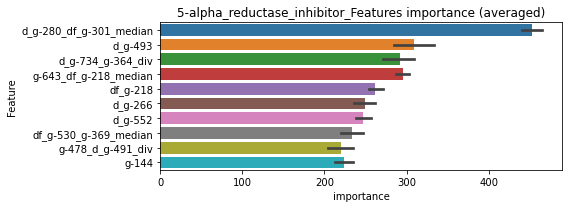

len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720674	valid_1's binary_logloss: 0.0871051
[200]	training's binary_logloss: 0.0181848	valid_1's binary_logloss: 0.0275703
[300]	training's binary_logloss: 0.00557191	valid_1's binary_logloss: 0.0111077
[400]	training's binary_logloss: 0.00221032	valid_1's binary_logloss: 0.00580353
[500]	training's binary_logloss: 0.00115819	valid_1's binary_logloss: 0.00384194
[600]	training's binary_logloss: 0.000756689	valid_1's binary_logloss: 0.00307465
[700]	training's binary_logloss: 0.000555825	valid_1's binary_logloss: 0.00261073
[800]	training's binary_logloss: 0.000454205	valid_1's binary_logloss: 0.0023389
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000436535	valid_1's binary_logloss: 0.00229241


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0713724	valid_1's binary_logloss: 0.0926737
[200]	training's binary_logloss: 0.017972	valid_1's binary_logloss: 0.0311172
[300]	training's binary_logloss: 0.00552899	valid_1's binary_logloss: 0.0126763
[400]	training's binary_logloss: 0.00219626	valid_1's binary_logloss: 0.00645867
[500]	training's binary_logloss: 0.00116224	valid_1's binary_logloss: 0.00424074
[600]	training's binary_logloss: 0.000754382	valid_1's binary_logloss: 0.00312937
[700]	training's binary_logloss: 0.000558489	valid_1's binary_logloss: 0.00261119
[800]	training's binary_logloss: 0.000459572	valid_1's binary_logloss: 0.00239396
[900]	training's binary_logloss: 0.00043403	valid_1's binary_logloss: 0.00231562
Early stopping, best iteration is:
[943]	training's binary_logloss: 0.00042396	valid_1's binary_logloss: 0.00226943


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0734485	valid_1's binary_logloss: 0.0931782
[200]	training's binary_logloss: 0.0187596	valid_1's binary_logloss: 0.0300015
[300]	training's binary_logloss: 0.00569877	valid_1's binary_logloss: 0.0118232
[400]	training's binary_logloss: 0.00225882	valid_1's binary_logloss: 0.00600769
[500]	training's binary_logloss: 0.00118214	valid_1's binary_logloss: 0.00385023
[600]	training's binary_logloss: 0.000765117	valid_1's binary_logloss: 0.00289491
[700]	training's binary_logloss: 0.000563039	valid_1's binary_logloss: 0.00237298
[800]	training's binary_logloss: 0.000464814	valid_1's binary_logloss: 0.00210693
[900]	training's binary_logloss: 0.000437369	valid_1's binary_logloss: 0.00201341
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.000433814	valid_1's binary_logloss: 0.00200336


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0718963	valid_1's binary_logloss: 0.0926964
[200]	training's binary_logloss: 0.0179125	valid_1's binary_logloss: 0.0329285
[300]	training's binary_logloss: 0.00546993	valid_1's binary_logloss: 0.0161616
[400]	training's binary_logloss: 0.00221498	valid_1's binary_logloss: 0.0105554
[500]	training's binary_logloss: 0.00117106	valid_1's binary_logloss: 0.00785309
[600]	training's binary_logloss: 0.00075593	valid_1's binary_logloss: 0.00661382
[700]	training's binary_logloss: 0.000561629	valid_1's binary_logloss: 0.00591525
[800]	training's binary_logloss: 0.000457944	valid_1's binary_logloss: 0.0056154
[900]	training's binary_logloss: 0.000428909	valid_1's binary_logloss: 0.00553717
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000433252	valid_1's binary_logloss: 0.00552495


5-alpha_reductase_inhibitor logloss: 0.0030232345325912203
11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729334	valid_1's binary_logloss: 0.0913961
[200]	training's binary_logloss: 0.0195595	valid_1's binary_logloss: 0.0341005
[300]	training's binary_logloss: 0.00613496	valid_1's binary_logloss: 0.0164133
[400]	training's binary_logloss: 0.00245787	valid_1's binary_logloss: 0.0101546
[500]	training's binary_logloss: 0.00128614	valid_1's binary_logloss: 0.0078063
[600]	training's binary_logloss: 0.000830379	valid_1's binary_logloss: 0.00679212
[700]	training's binary_logloss: 0.000608919	valid_1's binary_logloss: 0.00621976
[800]	training's binary_logloss: 0.000491392	valid_1's binary_logloss: 0.00593615
[900]	training's binary_logloss: 0.000439567	valid_1's binary_logloss: 0.00576981
Early stopping, best iteration is:
[877]	training's binary_logloss: 0.000440256	valid_1's binary_logloss: 0.00576569
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0059648, Threshold: 0.0422430, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02957, conf_1:0.05492
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0422430
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.0722430
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.1022430
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.1322430
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.1622430
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_6: 0.1922430
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_7: 0.2222430
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.2522430
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.2822430
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.3122430
threshold: 0.3422430, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0689062	valid_1's binary_logloss: 0.0886208
[200]	training's binary_logloss: 0.0165783	valid_1's binary_logloss: 0.0287259
[300]	training's binary_logloss: 0.00498541	valid_1's binary_logloss: 0.0120819
[400]	training's binary_logloss: 0.00199266	valid_1's binary_logloss: 0.00681816
[500]	training's binary_logloss: 0.00105826	valid_1's binary_logloss: 0.00462524
[600]	training's binary_logloss: 0.000688946	valid_1's binary_logloss: 0.00364847
[700]	training's binary_logloss: 0.000510216	valid_1's binary_logloss: 0.00312638
[800]	training's binary_logloss: 0.000422426	valid_1's binary_logloss: 0.00285773
[900]	training's binary_logloss: 0.000382621	valid_1's binary_logloss: 0.00272856
Early stopping, best iteration is:
[879]	training's binary_logloss: 0.000382855	valid_1's binary_logloss: 0.00272835
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1615128, Threshold: 0.3422430, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.27379, conf_1:0.41069
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.3422430
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.3722430
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.4022430
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_4: 0.4322430
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.4622430
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.4922430
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.5222430
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.5522430
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.5822430
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_10: 0.6122430
threshold: 0.6422430, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0689062	valid_1's binary_logloss: 0.0886208
[200]	training's binary_logloss: 0.0165783	valid_1's binary_logloss: 0.0287259
[300]	training's binary_logloss: 0.00498541	valid_1's binary_logloss: 0.0120819
[400]	training's binary_logloss: 0.00199266	valid_1's binary_logloss: 0.00681816
[500]	training's binary_logloss: 0.00105826	valid_1's binary_logloss: 0.00462524
[600]	training's binary_logloss: 0.000688946	valid_1's binary_logloss: 0.00364847
[700]	training's binary_logloss: 0.000510216	valid_1's binary_logloss: 0.00312638
[800]	training's binary_logloss: 0.000422426	valid_1's binary_logloss: 0.00285773
[900]	training's binary_logloss: 0.000382621	valid_1's binary_logloss: 0.00272856
Early stopping, best iteration is:
[879]	training's binary_logloss: 0.000382855	valid_1's binary_logloss: 0.00272835
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1615128, Threshold: 0.6422430, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.50000, conf_1:0.70647
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.6422430
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.6722430
threshold: 0.6722430, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


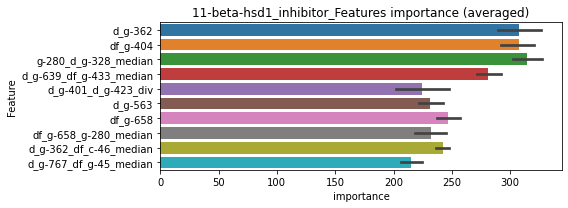

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0692084	valid_1's binary_logloss: 0.0866469
[200]	training's binary_logloss: 0.0165817	valid_1's binary_logloss: 0.0273694
[300]	training's binary_logloss: 0.0050456	valid_1's binary_logloss: 0.0108711
[400]	training's binary_logloss: 0.0019988	valid_1's binary_logloss: 0.00557726
[500]	training's binary_logloss: 0.00106399	valid_1's binary_logloss: 0.00375031
[600]	training's binary_logloss: 0.000690014	valid_1's binary_logloss: 0.00289203
[700]	training's binary_logloss: 0.000512899	valid_1's binary_logloss: 0.00247465
[800]	training's binary_logloss: 0.000418197	valid_1's binary_logloss: 0.00225402
Early stopping, best iteration is:
[831]	training's binary_logloss: 0.000404517	valid_1's binary_logloss: 0.00223431


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679902	valid_1's binary_logloss: 0.0871237
[200]	training's binary_logloss: 0.016455	valid_1's binary_logloss: 0.0282628
[300]	training's binary_logloss: 0.00491261	valid_1's binary_logloss: 0.0117137
[400]	training's binary_logloss: 0.00196729	valid_1's binary_logloss: 0.00638207
[500]	training's binary_logloss: 0.00104666	valid_1's binary_logloss: 0.00440591
[600]	training's binary_logloss: 0.000677405	valid_1's binary_logloss: 0.00348204
[700]	training's binary_logloss: 0.000508405	valid_1's binary_logloss: 0.00302294
[800]	training's binary_logloss: 0.000423516	valid_1's binary_logloss: 0.00277585
[900]	training's binary_logloss: 0.000388353	valid_1's binary_logloss: 0.00264536
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000388353	valid_1's binary_logloss: 0.00264536


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0695997	valid_1's binary_logloss: 0.0778077
[200]	training's binary_logloss: 0.017042	valid_1's binary_logloss: 0.0215492
[300]	training's binary_logloss: 0.00517133	valid_1's binary_logloss: 0.00786809
[400]	training's binary_logloss: 0.00205243	valid_1's binary_logloss: 0.00364016
[500]	training's binary_logloss: 0.00108271	valid_1's binary_logloss: 0.00215468
[600]	training's binary_logloss: 0.000707983	valid_1's binary_logloss: 0.00156456
[700]	training's binary_logloss: 0.00052675	valid_1's binary_logloss: 0.00125256
[800]	training's binary_logloss: 0.000429316	valid_1's binary_logloss: 0.00106361
[900]	training's binary_logloss: 0.000392172	valid_1's binary_logloss: 0.000999765
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000392172	valid_1's binary_logloss: 0.000999765


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.068867	valid_1's binary_logloss: 0.0894416
[200]	training's binary_logloss: 0.0167228	valid_1's binary_logloss: 0.0292528
[300]	training's binary_logloss: 0.00501717	valid_1's binary_logloss: 0.0124454
[400]	training's binary_logloss: 0.00199679	valid_1's binary_logloss: 0.00678195
[500]	training's binary_logloss: 0.00105699	valid_1's binary_logloss: 0.00497931
[600]	training's binary_logloss: 0.000691946	valid_1's binary_logloss: 0.00401193
[700]	training's binary_logloss: 0.00051537	valid_1's binary_logloss: 0.00346697
[800]	training's binary_logloss: 0.000426622	valid_1's binary_logloss: 0.00324619
[900]	training's binary_logloss: 0.000396497	valid_1's binary_logloss: 0.00314311
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000396497	valid_1's binary_logloss: 0.00314311


11-beta-hsd1_inhibitor logloss: 0.0022554050865684528
acat_inhibitor, len(trt): 24, len(othr): 3282, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0804075	valid_1's binary_logloss: 0.112097
[200]	training's binary_logloss: 0.0222698	valid_1's binary_logloss: 0.0491215
[300]	training's binary_logloss: 0.00737469	valid_1's binary_logloss: 0.0288146
[400]	training's binary_logloss: 0.00297551	valid_1's binary_logloss: 0.020913
[500]	training's binary_logloss: 0.00154475	valid_1's binary_logloss: 0.0178647
[600]	training's binary_logloss: 0.000987926	valid_1's binary_logloss: 0.0163615
[700]	training's binary_logloss: 0.000718774	valid_1's binary_logloss: 0.0156862
[800]	training's binary_logloss: 0.000568188	valid_1's binary_logloss: 0.0152712
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000515139	valid_1's binary_logloss: 0.0151546
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0801143	valid_1's binary_logloss: 0.114235
[200]	training's binary_logloss: 0.0237473	va

1 / 3 AUC score:1.000
y_Threshold: 0.0068580, Threshold: 0.0324044, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.02268, conf_1:0.04213
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0324044
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_2: 0.0624044
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_3: 0.0924044
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.1224044
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.1524044
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_6: 0.1824044
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_7: 0.2124044
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_8: 0.2424044
threshold: 0.2424044, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0769822	valid_1's binary_logloss: 0.101038
[200]	training's binary_logloss: 0.0201201	valid_1's binary_logloss: 0.0396618
[300]	training's binary_logloss: 0.0063665	valid_1's binary_logloss: 0.0210631
[400]	training's binary_logloss: 0.00254444	valid_1's binary_logloss: 0.0143538
[500]	training's binary_logloss: 0.00133268	valid_1's binary_logloss: 0.011992
[600]	training's binary_logloss: 0.00085233	valid_1's binary_logloss: 0.0110497
[700]	training's binary_logloss: 0.000622042	valid_1's binary_logloss: 0.0104329
[800]	training's binary_logloss: 0.000493855	valid_1's binary_logloss: 0.00999338
[900]	training's binary_logloss: 0.000437758	valid_1's binary_logloss: 0.00982979
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000435404	valid_1's binary_logloss: 0.0098274
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0752389

2 / 3 AUC score:1.000
y_Threshold: 0.1362219, Threshold: 0.2424044, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0092918 Vs.target_rate: 0.00101, Num_p_label: 37.0, conf_0:0.19392, conf_1:0.29089
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_1: 0.2424044
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_2: 0.2724044
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_3: 0.3024044
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_4: 0.3324044
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_5: 0.3624044
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_6: 0.3924044
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_7: 0.4224044
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_8: 0.4524044
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_9: 0.4824044
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_10: 0.5124044
threshold: 0.5424044, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0761046	valid_1's binary_logloss: 0.0986951
[200]	training's binary_logloss: 0.0197541	valid_1's binary_logloss: 0.0348937
[300]	training's binary_logloss: 0.00621223	valid_1's binary_logloss: 0.0157121
[400]	training's binary_logloss: 0.00250107	valid_1's binary_logloss: 0.00902418
[500]	training's binary_logloss: 0.00129751	valid_1's binary_logloss: 0.00630385
[600]	training's binary_logloss: 0.000826221	valid_1's binary_logloss: 0.00495802
[700]	training's binary_logloss: 0.000599707	valid_1's binary_logloss: 0.00433551
[800]	training's binary_logloss: 0.000483681	valid_1's binary_logloss: 0.00393211
Early stopping, best iteration is:
[847]	training's binary_logloss: 0.000451713	valid_1's binary_logloss: 0.00380675
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0742756	valid_1's binary_logloss: 0.105832
[200]	training's binary_logloss: 0.01

3 / 3 AUC score:1.000
y_Threshold: 0.1414643, Threshold: 0.5424044, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 647.0/3788
p_label_rate: 0.0057760 Vs.target_rate: 0.00101, Num_p_label: 23.0, conf_0:0.48816, conf_1:0.59664
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_1: 0.5424044
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_2: 0.5724044
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_3: 0.6024044
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_4: 0.6324044
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_5: 0.6624044
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_6: 0.6924044
threshold: 0.6924044, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 647.0/3788, y_label_rate: 0.1708025


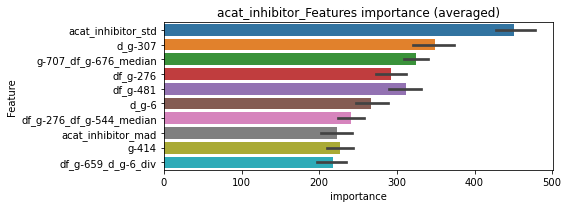

len(train_index) : 2841
len(valid_index) : 947
================================= fold 1/4 acat_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729438	valid_1's binary_logloss: 0.0896858
[200]	training's binary_logloss: 0.0188788	valid_1's binary_logloss: 0.0321507
[300]	training's binary_logloss: 0.00599333	valid_1's binary_logloss: 0.0146633
[400]	training's binary_logloss: 0.00241141	valid_1's binary_logloss: 0.00835188
[500]	training's binary_logloss: 0.00125194	valid_1's binary_logloss: 0.00574646
[600]	training's binary_logloss: 0.000801354	valid_1's binary_logloss: 0.00441172
[700]	training's binary_logloss: 0.000589962	valid_1's binary_logloss: 0.0037455
[800]	training's binary_logloss: 0.000476676	valid_1's binary_logloss: 0.00332434
[900]	training's binary_logloss: 0.000433692	valid_1's binary_logloss: 0.00311471
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000433692	valid_1's binary_logloss: 0.00311471


len(train_index) : 2841
len(valid_index) : 947
================================= fold 2/4 acat_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0745815	valid_1's binary_logloss: 0.0979514
[200]	training's binary_logloss: 0.0194159	valid_1's binary_logloss: 0.0369434
[300]	training's binary_logloss: 0.00594955	valid_1's binary_logloss: 0.0182918
[400]	training's binary_logloss: 0.00238909	valid_1's binary_logloss: 0.0117671
[500]	training's binary_logloss: 0.00125384	valid_1's binary_logloss: 0.00900082
[600]	training's binary_logloss: 0.000804302	valid_1's binary_logloss: 0.00774632
[700]	training's binary_logloss: 0.000589464	valid_1's binary_logloss: 0.00721369
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.000515725	valid_1's binary_logloss: 0.00690876


len(train_index) : 2841
len(valid_index) : 947
================================= fold 3/4 acat_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.074382	valid_1's binary_logloss: 0.0994543
[200]	training's binary_logloss: 0.0195544	valid_1's binary_logloss: 0.036
[300]	training's binary_logloss: 0.00619254	valid_1's binary_logloss: 0.0156973
[400]	training's binary_logloss: 0.00245598	valid_1's binary_logloss: 0.00809037
[500]	training's binary_logloss: 0.00126972	valid_1's binary_logloss: 0.00519562
[600]	training's binary_logloss: 0.000807535	valid_1's binary_logloss: 0.00406317
[700]	training's binary_logloss: 0.000593913	valid_1's binary_logloss: 0.00342655
[800]	training's binary_logloss: 0.000476109	valid_1's binary_logloss: 0.00305756
[900]	training's binary_logloss: 0.000439463	valid_1's binary_logloss: 0.00293818
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.000432236	valid_1's binary_logloss: 0.00290498


len(train_index) : 2841
len(valid_index) : 947
================================= fold 4/4 acat_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0725265	valid_1's binary_logloss: 0.102301
[200]	training's binary_logloss: 0.0183118	valid_1's binary_logloss: 0.0393865
[300]	training's binary_logloss: 0.00582506	valid_1's binary_logloss: 0.0188887
[400]	training's binary_logloss: 0.0023446	valid_1's binary_logloss: 0.0123812
[500]	training's binary_logloss: 0.00123625	valid_1's binary_logloss: 0.00980722
[600]	training's binary_logloss: 0.000801058	valid_1's binary_logloss: 0.00878036
[700]	training's binary_logloss: 0.000586049	valid_1's binary_logloss: 0.00828977
[800]	training's binary_logloss: 0.000475625	valid_1's binary_logloss: 0.0080848
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.000467316	valid_1's binary_logloss: 0.00803889


acat_inhibitor logloss: 0.005242184293193223


neg labels: 3289 → selected neg labels: 3261


acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3261, target_rate: 0.0079785 → Adj_target_rate: 0.0072634
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.183065	valid_1's binary_logloss: 0.312347
[200]	training's binary_logloss: 0.106964	valid_1's binary_logloss: 0.283456
[300]	training's binary_logloss: 0.0647275	valid_1's binary_logloss: 0.268873
[400]	training's binary_logloss: 0.0403425	valid_1's binary_logloss: 0.262707
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0418907	valid_1's binary_logloss: 0.262393
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.193624	valid_1's binary_logloss: 0.294141
[200]	training's binary_logloss: 0.108685	valid_1's binary_logloss: 0.250362
[300]	training's binary_logloss: 0.0672856	valid_1's binary_logloss: 0.231383
[400]	training's binary_logloss: 0.04175	valid_1's binary_logloss: 0.219334
[500]	training's binary_logloss: 0.0262788	valid_1's binary_logloss: 0.21081
[600]	training's binary_logloss: 0.0165583	valid_1's binary_logloss: 0

1 / 3 AUC score:0.924
y_Threshold: 0.0949336, Threshold: 0.5421002, pos_neg_ratio: 0.8000000
Remove_noisy_data: 367 → Positive_corect_labels: 534/3546
p_label_rate: 0.0100452 Vs.target_rate: 0.00798, Num_p_label: 40.0, conf_0:0.37947, conf_1:0.70473
threshold: 0.5421002, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 534.0/3546, y_label_rate: 0.1505922
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127908	valid_1's binary_logloss: 0.195268
[200]	training's binary_logloss: 0.0610196	valid_1's binary_logloss: 0.144368
[300]	training's binary_logloss: 0.03026	valid_1's binary_logloss: 0.120005
[400]	training's binary_logloss: 0.0162849	valid_1's binary_logloss: 0.108498
[500]	training's binary_logloss: 0.00926152	valid_1's binary_logloss: 0.101897
[600]	training's binary_logloss: 0.00548473	valid_1's binary_logloss: 0.0989398
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00487263	valid_1's binary_logloss: 0.0982341
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131165	valid_1's binary_logloss: 0.189145
[200]	training's binary_logloss: 0.0615686	valid_1's binary_logloss: 0.141068
[300]	training's binary_logloss: 0.0323718	valid_1's binary_logloss: 0.121256
[400]	training's binary_logloss: 0.0172038	valid_1's binary_lo

2 / 3 AUC score:0.979
y_Threshold: 0.1342052, Threshold: 0.5421002, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 465.0/3408
p_label_rate: 0.0366650 Vs.target_rate: 0.00798, Num_p_label: 146.0, conf_0:0.43368, conf_1:0.65052
Num_p_label: 146.0, Expected: 31.8, Adj_threshold_1: 0.5421002
Num_p_label: 137.0, Expected: 31.8, Adj_threshold_2: 0.5721002
Num_p_label: 130.0, Expected: 31.8, Adj_threshold_3: 0.6021002
Num_p_label: 123.0, Expected: 31.8, Adj_threshold_4: 0.6321002
Num_p_label: 115.0, Expected: 31.8, Adj_threshold_5: 0.6621002
Num_p_label: 106.0, Expected: 31.8, Adj_threshold_6: 0.6921002
threshold: 0.6921002, positive_p_label: 106.0/3982, p_label_rate: 0.0266198
positive_y_label: 465.0/3408, y_label_rate: 0.1364437
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0906445	valid_1's binary_logloss: 0.149955
[200]	training's binary_logloss: 0.0346607	valid_1's binary_logloss: 0.103119
[300]	training's binary_logloss: 0.0153196	valid_1's binary_logloss: 0.0805089
[400]	training's binary_logloss: 0.0074911	valid_1's binary_logloss: 0.0696899
[500]	training's binary_logloss: 0.00403738	valid_1's binary_logloss: 0.0652402
[600]	training's binary_logloss: 0.00251923	valid_1's binary_logloss: 0.0614327
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00251923	valid_1's binary_logloss: 0.0614327
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0967846	valid_1's binary_logloss: 0.126451
[200]	training's binary_logloss: 0.0386618	valid_1's binary_logloss: 0.0800192
[300]	training's binary_logloss: 0.0170609	valid_1's binary_logloss: 0.061348
[400]	training's binary_logloss: 0.00824712	valid_1's 

3 / 3 AUC score:0.989
y_Threshold: 0.1273728, Threshold: 0.6921002, pos_neg_ratio: 0.8000000
Remove_noisy_data: 60 → Positive_corect_labels: 435.0/3348
p_label_rate: 0.0416876 Vs.target_rate: 0.00798, Num_p_label: 166.0, conf_0:0.50000, conf_1:0.76131
Num_p_label: 166.0, Expected: 31.8, Adj_threshold_1: 0.6921002
threshold: 0.6921002, positive_p_label: 166.0/3982, p_label_rate: 0.0416876
positive_y_label: 435.0/3348, y_label_rate: 0.1299283


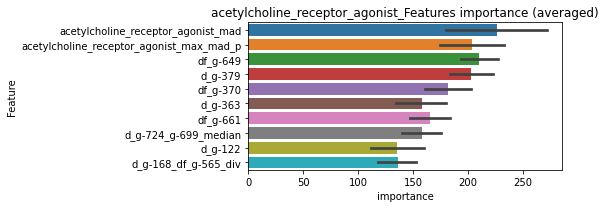

len(train_index) : 2511
len(valid_index) : 837
================================= fold 1/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0816003	valid_1's binary_logloss: 0.140461
[200]	training's binary_logloss: 0.0283433	valid_1's binary_logloss: 0.0863752
[300]	training's binary_logloss: 0.012035	valid_1's binary_logloss: 0.0661226
[400]	training's binary_logloss: 0.00571731	valid_1's binary_logloss: 0.0574364
[500]	training's binary_logloss: 0.00311398	valid_1's binary_logloss: 0.0527398
[600]	training's binary_logloss: 0.00199675	valid_1's binary_logloss: 0.0505537
[700]	training's binary_logloss: 0.00140171	valid_1's binary_logloss: 0.0486833
[800]	training's binary_logloss: 0.00107456	valid_1's binary_logloss: 0.0472755
[900]	training's binary_logloss: 0.000895947	valid_1's binary_logloss: 0.046311
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.0009403	valid_1's binary_logloss: 0.0460406


len(train_index) : 2511
len(valid_index) : 837
================================= fold 2/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0817133	valid_1's binary_logloss: 0.115504
[200]	training's binary_logloss: 0.0289981	valid_1's binary_logloss: 0.0724669
[300]	training's binary_logloss: 0.0124752	valid_1's binary_logloss: 0.0582149
[400]	training's binary_logloss: 0.00584683	valid_1's binary_logloss: 0.0518929
[500]	training's binary_logloss: 0.00316025	valid_1's binary_logloss: 0.0487792
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00290429	valid_1's binary_logloss: 0.0483521


len(train_index) : 2511
len(valid_index) : 837
================================= fold 3/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0853064	valid_1's binary_logloss: 0.121224
[200]	training's binary_logloss: 0.0305814	valid_1's binary_logloss: 0.0716267
[300]	training's binary_logloss: 0.0138321	valid_1's binary_logloss: 0.0528599
[400]	training's binary_logloss: 0.0070909	valid_1's binary_logloss: 0.0427898
[500]	training's binary_logloss: 0.0034962	valid_1's binary_logloss: 0.0378291
[600]	training's binary_logloss: 0.00208322	valid_1's binary_logloss: 0.0357275
[700]	training's binary_logloss: 0.00144767	valid_1's binary_logloss: 0.0347965
[800]	training's binary_logloss: 0.00111973	valid_1's binary_logloss: 0.0336561
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.00112972	valid_1's binary_logloss: 0.0336278


len(train_index) : 2511
len(valid_index) : 837
================================= fold 4/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0826328	valid_1's binary_logloss: 0.12468
[200]	training's binary_logloss: 0.0284165	valid_1's binary_logloss: 0.0782319
[300]	training's binary_logloss: 0.0123856	valid_1's binary_logloss: 0.0623818
[400]	training's binary_logloss: 0.00579571	valid_1's binary_logloss: 0.0563507
[500]	training's binary_logloss: 0.00307435	valid_1's binary_logloss: 0.0541674
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00307435	valid_1's binary_logloss: 0.0541674


acetylcholine_receptor_agonist logloss: 0.04554700426110403
acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394


neg labels: 3289 → selected neg labels: 3241


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.225395	valid_1's binary_logloss: 0.35855
[200]	training's binary_logloss: 0.140524	valid_1's binary_logloss: 0.337183
[300]	training's binary_logloss: 0.0938004	valid_1's binary_logloss: 0.329185
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.086769	valid_1's binary_logloss: 0.328172
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.238493	valid_1's binary_logloss: 0.36138
[200]	training's binary_logloss: 0.154709	valid_1's binary_logloss: 0.333059
[300]	training's binary_logloss: 0.105363	valid_1's binary_logloss: 0.322869
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0869665	valid_1's binary_logloss: 0.318464
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.238584	valid_1's binary_logloss: 0.347565
[200]	training's binary_logloss: 0.15456	valid_1's bin

1 / 3 AUC score:0.826
y_Threshold: 0.1389113, Threshold: 0.3599188, pos_neg_ratio: 0.8000000
Remove_noisy_data: 578 → Positive_corect_labels: 424/3311
p_label_rate: 0.0100452 Vs.target_rate: 0.01264, Num_p_label: 40.0, conf_0:0.25194, conf_1:0.46789
threshold: 0.3599188, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 424.0/3311, y_label_rate: 0.1280580
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121271	valid_1's binary_logloss: 0.219564
[200]	training's binary_logloss: 0.0537899	valid_1's binary_logloss: 0.177987
[300]	training's binary_logloss: 0.0264329	valid_1's binary_logloss: 0.164588
[400]	training's binary_logloss: 0.0141092	valid_1's binary_logloss: 0.158842
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0103684	valid_1's binary_logloss: 0.157849
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123023	valid_1's binary_logloss: 0.195953
[200]	training's binary_logloss: 0.056124	valid_1's binary_logloss: 0.150624
[300]	training's binary_logloss: 0.0275256	valid_1's binary_logloss: 0.128504
[400]	training's binary_logloss: 0.0143947	valid_1's binary_logloss: 0.121218
[500]	training's binary_logloss: 0.00815968	valid_1's binary_logloss: 0.118291
Early stopping, best iteration is:
[538]	training's binary_loglos

2 / 3 AUC score:0.978
y_Threshold: 0.0923290, Threshold: 0.3599188, pos_neg_ratio: 0.8000000
Remove_noisy_data: 112 → Positive_corect_labels: 368.0/3199
p_label_rate: 0.0253641 Vs.target_rate: 0.01264, Num_p_label: 101.0, conf_0:0.28794, conf_1:0.43190
threshold: 0.3599188, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 368.0/3199, y_label_rate: 0.1150359
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0962684	valid_1's binary_logloss: 0.175899
[200]	training's binary_logloss: 0.0387617	valid_1's binary_logloss: 0.14479
[300]	training's binary_logloss: 0.0176382	valid_1's binary_logloss: 0.135682
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0118125	valid_1's binary_logloss: 0.134014
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.095418	valid_1's binary_logloss: 0.171245
[200]	training's binary_logloss: 0.0386568	valid_1's binary_logloss: 0.123369
[300]	training's binary_logloss: 0.0175069	valid_1's binary_logloss: 0.104021
[400]	training's binary_logloss: 0.0085576	valid_1's binary_logloss: 0.0934322
[500]	training's binary_logloss: 0.00465451	valid_1's binary_logloss: 0.0882299
[600]	training's binary_logloss: 0.00292494	valid_1's binary_logloss: 0.0876866
Early stopping, best iteration is:
[574]	training's binary_l

3 / 3 AUC score:0.967
y_Threshold: 0.0904249, Threshold: 0.3599188, pos_neg_ratio: 0.8000000
Remove_noisy_data: 86 → Positive_corect_labels: 325.0/3113
p_label_rate: 0.0306379 Vs.target_rate: 0.01264, Num_p_label: 122.0, conf_0:0.32393, conf_1:0.39591
threshold: 0.3599188, positive_p_label: 122.0/3982, p_label_rate: 0.0306379
positive_y_label: 325.0/3113, y_label_rate: 0.1044009


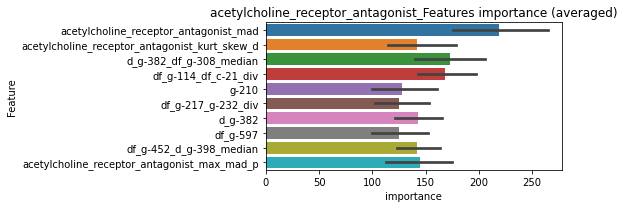

len(train_index) : 2334
len(valid_index) : 779
================================= fold 1/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0782324	valid_1's binary_logloss: 0.129678
[200]	training's binary_logloss: 0.0287012	valid_1's binary_logloss: 0.0872666
[300]	training's binary_logloss: 0.0122218	valid_1's binary_logloss: 0.0699504
[400]	training's binary_logloss: 0.00595428	valid_1's binary_logloss: 0.0643594
[500]	training's binary_logloss: 0.00329798	valid_1's binary_logloss: 0.0595975
[600]	training's binary_logloss: 0.00211403	valid_1's binary_logloss: 0.0589572
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00224063	valid_1's binary_logloss: 0.0585613


len(train_index) : 2335
len(valid_index) : 778
================================= fold 2/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0801649	valid_1's binary_logloss: 0.128925
[200]	training's binary_logloss: 0.0303881	valid_1's binary_logloss: 0.0888793
[300]	training's binary_logloss: 0.0142032	valid_1's binary_logloss: 0.07361
[400]	training's binary_logloss: 0.0082933	valid_1's binary_logloss: 0.0682051
[500]	training's binary_logloss: 0.00380957	valid_1's binary_logloss: 0.0622222
[600]	training's binary_logloss: 0.0022394	valid_1's binary_logloss: 0.0608239
[700]	training's binary_logloss: 0.00155399	valid_1's binary_logloss: 0.0594271
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00130104	valid_1's binary_logloss: 0.0586969


len(train_index) : 2335
len(valid_index) : 778
================================= fold 3/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0758673	valid_1's binary_logloss: 0.155624
[200]	training's binary_logloss: 0.0265075	valid_1's binary_logloss: 0.124859
[300]	training's binary_logloss: 0.0109945	valid_1's binary_logloss: 0.114151
[400]	training's binary_logloss: 0.00519604	valid_1's binary_logloss: 0.112257
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00383904	valid_1's binary_logloss: 0.111096


len(train_index) : 2335
len(valid_index) : 778
================================= fold 4/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0793223	valid_1's binary_logloss: 0.149261
[200]	training's binary_logloss: 0.0286965	valid_1's binary_logloss: 0.105722
[300]	training's binary_logloss: 0.0124425	valid_1's binary_logloss: 0.0898295
[400]	training's binary_logloss: 0.00618689	valid_1's binary_logloss: 0.0827458
[500]	training's binary_logloss: 0.00322983	valid_1's binary_logloss: 0.0774018
[600]	training's binary_logloss: 0.00204619	valid_1's binary_logloss: 0.0751248
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00225426	valid_1's binary_logloss: 0.0749082


acetylcholine_receptor_antagonist logloss: 0.07580999206321401
acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127283	valid_1's binary_logloss: 0.212071
[200]	training's binary_logloss: 0.0534605	valid_1's binary_logloss: 0.144968
[300]	training's binary_logloss: 0.0253003	valid_1's binary_logloss: 0.108547
[400]	training's binary_logloss: 0.0125262	valid_1's binary_logloss: 0.0889537
[500]	training's binary_logloss: 0.00673286	valid_1's binary_logloss: 0.0774804
[600]	training's binary_logloss: 0.00398172	valid_1's binary_logloss: 0.0713432
[700]	training's binary_logloss: 0.00262826	valid_1's binary_logloss: 0.067895
[800]	training's binary_logloss: 0.00190646	valid_1's binary_logloss: 0.0666475
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.00186501	valid_1's binary_logloss: 0.0665096
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132734	valid_1's binary_logloss: 0.198388
[200]	training's binary_logloss: 0.056426	valid_1's bin

1 / 3 AUC score:0.992
y_Threshold: 0.0376095, Threshold: 0.2000054, pos_neg_ratio: 0.8000000
Remove_noisy_data: 170 → Positive_corect_labels: 637/3767
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.14000, conf_1:0.26001
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.2000054
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.2300054
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_3: 0.2600054
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_4: 0.2900054
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_5: 0.3200054
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.3500054
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_7: 0.3800054
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_8: 0.4100054
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_9: 0.4400054
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_10: 0.4700054
threshold: 0.5000054, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 637.0/3767, y_label_rate: 0.1691001


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11389	valid_1's binary_logloss: 0.181123
[200]	training's binary_logloss: 0.0429392	valid_1's binary_logloss: 0.11513
[300]	training's binary_logloss: 0.0189835	valid_1's binary_logloss: 0.0888235
[400]	training's binary_logloss: 0.00894029	valid_1's binary_logloss: 0.076121
[500]	training's binary_logloss: 0.004705	valid_1's binary_logloss: 0.0695794
[600]	training's binary_logloss: 0.00283192	valid_1's binary_logloss: 0.0673251
[700]	training's binary_logloss: 0.00193048	valid_1's binary_logloss: 0.0661299
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.0019897	valid_1's binary_logloss: 0.0659792
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118666	valid_1's binary_logloss: 0.17867
[200]	training's binary_logloss: 0.0467226	valid_1's binary_logloss: 0.11585
[300]	training's binary_logloss: 0.0203459	valid_1's binary_lo

2 / 3 AUC score:0.996
y_Threshold: 0.1215916, Threshold: 0.5000054, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 609.0/3711
p_label_rate: 0.0170768 Vs.target_rate: 0.00307, Num_p_label: 68.0, conf_0:0.40000, conf_1:0.60001
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_1: 0.5000054
Num_p_label: 64.0, Expected: 12.2, Adj_threshold_2: 0.5300054
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_3: 0.5600054
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_4: 0.5900054
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_5: 0.6200054
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_6: 0.6500054
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_7: 0.6800054
threshold: 0.6800054, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 609.0/3711, y_label_rate: 0.1641067
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102258	valid_1's binary_logloss: 0.15852
[200]	training's binary_logloss: 0.0377509	valid_1's binary_logloss: 0.0965395
[300]	training's binary_logloss: 0.015547	valid_1's binary_logloss: 0.0697595
[400]	training's binary_logloss: 0.00708523	valid_1's binary_logloss: 0.0567325
[500]	training's binary_logloss: 0.00371171	valid_1's binary_logloss: 0.0510287
[600]	training's binary_logloss: 0.0022712	valid_1's binary_logloss: 0.0469576
[700]	training's binary_logloss: 0.00157088	valid_1's binary_logloss: 0.0449857
Early stopping, best iteration is:
[719]	training's binary_logloss: 0.0014818	valid_1's binary_logloss: 0.0447818
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107502	valid_1's binary_logloss: 0.160319
[200]	training's binary_logloss: 0.0394859	valid_1's binary_logloss: 0.0953633
[300]	training's binary_logloss: 0.0166044	valid_1's bin

3 / 3 AUC score:0.999
y_Threshold: 0.1306239, Threshold: 0.6800054, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 593.0/3679
p_label_rate: 0.0190859 Vs.target_rate: 0.00307, Num_p_label: 76.0, conf_0:0.50000, conf_1:0.74801
Num_p_label: 76.0, Expected: 12.2, Adj_threshold_1: 0.6800054
threshold: 0.6800054, positive_p_label: 76.0/3982, p_label_rate: 0.0190859
positive_y_label: 593.0/3679, y_label_rate: 0.1611851


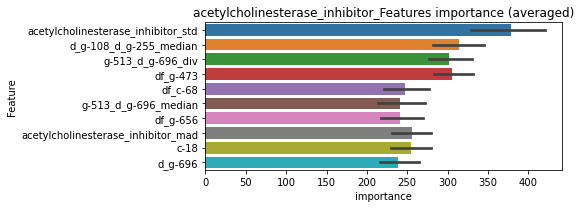

len(train_index) : 2759
len(valid_index) : 920
================================= fold 1/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0989125	valid_1's binary_logloss: 0.154578
[200]	training's binary_logloss: 0.0347155	valid_1's binary_logloss: 0.0929552
[300]	training's binary_logloss: 0.0141872	valid_1's binary_logloss: 0.0692413
[400]	training's binary_logloss: 0.00646362	valid_1's binary_logloss: 0.0577839
[500]	training's binary_logloss: 0.00338408	valid_1's binary_logloss: 0.0529303
[600]	training's binary_logloss: 0.00205672	valid_1's binary_logloss: 0.0497442
[700]	training's binary_logloss: 0.00143547	valid_1's binary_logloss: 0.0484783
[800]	training's binary_logloss: 0.0011065	valid_1's binary_logloss: 0.0478089
[900]	training's binary_logloss: 0.000919338	valid_1's binary_logloss: 0.0469224
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.000935844	valid_1's binary_logloss: 0.0467121


len(train_index) : 2759
len(valid_index) : 920
================================= fold 2/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101261	valid_1's binary_logloss: 0.140633
[200]	training's binary_logloss: 0.0359852	valid_1's binary_logloss: 0.0766719
[300]	training's binary_logloss: 0.0147239	valid_1's binary_logloss: 0.0512645
[400]	training's binary_logloss: 0.0066496	valid_1's binary_logloss: 0.039636
[500]	training's binary_logloss: 0.00344107	valid_1's binary_logloss: 0.0331155
[600]	training's binary_logloss: 0.0021053	valid_1's binary_logloss: 0.0300327
[700]	training's binary_logloss: 0.00145429	valid_1's binary_logloss: 0.0280806
[800]	training's binary_logloss: 0.00111234	valid_1's binary_logloss: 0.0271226
[900]	training's binary_logloss: 0.000922423	valid_1's binary_logloss: 0.0265084
[1000]	training's binary_logloss: 0.000813774	valid_1's binary_logloss: 0.0263596
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.000825957	valid_1's binary_logloss: 0.0262093


len(train_index) : 2759
len(valid_index) : 920
================================= fold 3/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100644	valid_1's binary_logloss: 0.151406
[200]	training's binary_logloss: 0.0358825	valid_1's binary_logloss: 0.0843884
[300]	training's binary_logloss: 0.01491	valid_1's binary_logloss: 0.0571888
[400]	training's binary_logloss: 0.0067792	valid_1's binary_logloss: 0.0440276
[500]	training's binary_logloss: 0.00353334	valid_1's binary_logloss: 0.0367019
[600]	training's binary_logloss: 0.00214506	valid_1's binary_logloss: 0.0332303
[700]	training's binary_logloss: 0.00148372	valid_1's binary_logloss: 0.0313009
[800]	training's binary_logloss: 0.00112907	valid_1's binary_logloss: 0.0304954
[900]	training's binary_logloss: 0.000932284	valid_1's binary_logloss: 0.0294414
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.0009407	valid_1's binary_logloss: 0.0294244


len(train_index) : 2760
len(valid_index) : 919
================================= fold 4/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102108	valid_1's binary_logloss: 0.150419
[200]	training's binary_logloss: 0.0358606	valid_1's binary_logloss: 0.0848467
[300]	training's binary_logloss: 0.0149648	valid_1's binary_logloss: 0.0594308
[400]	training's binary_logloss: 0.00685154	valid_1's binary_logloss: 0.0454808
[500]	training's binary_logloss: 0.00352054	valid_1's binary_logloss: 0.0383984
[600]	training's binary_logloss: 0.00214361	valid_1's binary_logloss: 0.0351071
[700]	training's binary_logloss: 0.00147172	valid_1's binary_logloss: 0.0331295
[800]	training's binary_logloss: 0.0011173	valid_1's binary_logloss: 0.0316998
[900]	training's binary_logloss: 0.000915938	valid_1's binary_logloss: 0.0306182
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.000925769	valid_1's binary_logloss: 0.0305715


acetylcholinesterase_inhibitor logloss: 0.03323003678095859
adenosine_receptor_agonist, len(trt): 54, len(othr): 3278, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126324	valid_1's binary_logloss: 0.18214
[200]	training's binary_logloss: 0.0523743	valid_1's binary_logloss: 0.114928
[300]	training's binary_logloss: 0.0235104	valid_1's binary_logloss: 0.0826021
[400]	training's binary_logloss: 0.0111448	valid_1's binary_logloss: 0.0654858
[500]	training's binary_logloss: 0.00561504	valid_1's binary_logloss: 0.0550275
[600]	training's binary_logloss: 0.00325041	valid_1's binary_logloss: 0.0503913
[700]	training's binary_logloss: 0.00213362	valid_1's binary_logloss: 0.0474841
[800]	training's binary_logloss: 0.00154071	valid_1's binary_logloss: 0.0463177
Early stopping, best iteration is:
[786]	training's binary_logloss: 0.00159933	valid_1's binary_logloss: 0.0462284
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128633	valid_1's binary_logloss: 0.166228
[200]	training's binary_logloss: 0.0557314	valid_1's b

1 / 3 AUC score:0.999
y_Threshold: 0.0267401, Threshold: 0.2645372, pos_neg_ratio: 0.8000000
Remove_noisy_data: 142 → Positive_corect_labels: 650/3791
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.18518, conf_1:0.34390
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.2645372
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_2: 0.2945372
Num_p_label: 32.0, Expected: 9.0, Adj_threshold_3: 0.3245372
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_4: 0.3545372
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_5: 0.3845372
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_6: 0.4145372
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_7: 0.4445372
threshold: 0.4445372, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 650.0/3791, y_label_rate: 0.1714587
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117295	valid_1's binary_logloss: 0.161112
[200]	training's binary_logloss: 0.0454295	valid_1's binary_logloss: 0.086302
[300]	training's binary_logloss: 0.0197449	valid_1's binary_logloss: 0.0528447
[400]	training's binary_logloss: 0.0088182	valid_1's binary_logloss: 0.0347373
[500]	training's binary_logloss: 0.00445169	valid_1's binary_logloss: 0.0255292
[600]	training's binary_logloss: 0.00259581	valid_1's binary_logloss: 0.0207506
[700]	training's binary_logloss: 0.00173645	valid_1's binary_logloss: 0.0175399
[800]	training's binary_logloss: 0.00128725	valid_1's binary_logloss: 0.0158979
[900]	training's binary_logloss: 0.00102737	valid_1's binary_logloss: 0.0148773
[1000]	training's binary_logloss: 0.000880027	valid_1's binary_logloss: 0.0142601
[1100]	training's binary_logloss: 0.000801938	valid_1's binary_logloss: 0.0137068
[1200]	training's binary_logloss: 0.000757332	valid_1's binary

2 / 3 AUC score:0.997
y_Threshold: 0.1541168, Threshold: 0.4445372, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 634.0/3759
p_label_rate: 0.0208438 Vs.target_rate: 0.00227, Num_p_label: 83.0, conf_0:0.35563, conf_1:0.53344
Num_p_label: 83.0, Expected: 9.0, Adj_threshold_1: 0.4445372
Num_p_label: 81.0, Expected: 9.0, Adj_threshold_2: 0.4745372
Num_p_label: 73.0, Expected: 9.0, Adj_threshold_3: 0.5045372
Num_p_label: 69.0, Expected: 9.0, Adj_threshold_4: 0.5345372
Num_p_label: 67.0, Expected: 9.0, Adj_threshold_5: 0.5645372
Num_p_label: 61.0, Expected: 9.0, Adj_threshold_6: 0.5945372
Num_p_label: 56.0, Expected: 9.0, Adj_threshold_7: 0.6245372
Num_p_label: 49.0, Expected: 9.0, Adj_threshold_8: 0.6545372
Num_p_label: 48.0, Expected: 9.0, Adj_threshold_9: 0.6845372
threshold: 0.6845372, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 634.0/3759, y_label_rate: 0.1686619
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110261	valid_1's binary_logloss: 0.163072
[200]	training's binary_logloss: 0.0414551	valid_1's binary_logloss: 0.0899387
[300]	training's binary_logloss: 0.0168992	valid_1's binary_logloss: 0.0571773
[400]	training's binary_logloss: 0.00764281	valid_1's binary_logloss: 0.0420993
[500]	training's binary_logloss: 0.00388687	valid_1's binary_logloss: 0.0343728
[600]	training's binary_logloss: 0.00230081	valid_1's binary_logloss: 0.0301431
[700]	training's binary_logloss: 0.00156765	valid_1's binary_logloss: 0.0286845
[800]	training's binary_logloss: 0.00116425	valid_1's binary_logloss: 0.0270211
[900]	training's binary_logloss: 0.000933794	valid_1's binary_logloss: 0.026068
[1000]	training's binary_logloss: 0.000811658	valid_1's binary_logloss: 0.0253818
Early stopping, best iteration is:
[1002]	training's binary_logloss: 0.000810808	valid_1's binary_logloss: 0.0253692
Training until validation

3 / 3 AUC score:0.999
y_Threshold: 0.1449624, Threshold: 0.6845372, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 623.0/3737
p_label_rate: 0.0155701 Vs.target_rate: 0.00227, Num_p_label: 62.0, conf_0:0.50000, conf_1:0.75299
Num_p_label: 62.0, Expected: 9.0, Adj_threshold_1: 0.6845372
threshold: 0.6845372, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 623.0/3737, y_label_rate: 0.1667113


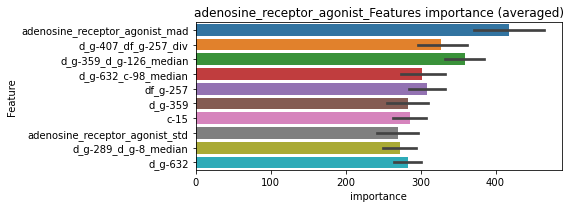

len(train_index) : 2802
len(valid_index) : 935
================================= fold 1/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106066	valid_1's binary_logloss: 0.15013
[200]	training's binary_logloss: 0.0381175	valid_1's binary_logloss: 0.0807228
[300]	training's binary_logloss: 0.0159324	valid_1's binary_logloss: 0.0533399
[400]	training's binary_logloss: 0.00697694	valid_1's binary_logloss: 0.0407393
[500]	training's binary_logloss: 0.00352351	valid_1's binary_logloss: 0.0343756
[600]	training's binary_logloss: 0.00209218	valid_1's binary_logloss: 0.0317606
[700]	training's binary_logloss: 0.00142684	valid_1's binary_logloss: 0.0301501
[800]	training's binary_logloss: 0.00108072	valid_1's binary_logloss: 0.0288873
[900]	training's binary_logloss: 0.000878606	valid_1's binary_logloss: 0.0281656
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.000810071	valid_1's binary_logloss: 0.0278625


len(train_index) : 2803
len(valid_index) : 934
================================= fold 2/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1066	valid_1's binary_logloss: 0.16835
[200]	training's binary_logloss: 0.0392447	valid_1's binary_logloss: 0.0969897
[300]	training's binary_logloss: 0.0161389	valid_1's binary_logloss: 0.067447
[400]	training's binary_logloss: 0.00716165	valid_1's binary_logloss: 0.0532479
[500]	training's binary_logloss: 0.00357794	valid_1's binary_logloss: 0.045049
[600]	training's binary_logloss: 0.00211562	valid_1's binary_logloss: 0.0427894
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00172808	valid_1's binary_logloss: 0.0420409


len(train_index) : 2803
len(valid_index) : 934
================================= fold 3/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104496	valid_1's binary_logloss: 0.14124
[200]	training's binary_logloss: 0.0382425	valid_1's binary_logloss: 0.0767668
[300]	training's binary_logloss: 0.0161112	valid_1's binary_logloss: 0.0486427
[400]	training's binary_logloss: 0.00704268	valid_1's binary_logloss: 0.0340927
[500]	training's binary_logloss: 0.00357011	valid_1's binary_logloss: 0.0261263
[600]	training's binary_logloss: 0.00212243	valid_1's binary_logloss: 0.0226524
[700]	training's binary_logloss: 0.00144085	valid_1's binary_logloss: 0.0205183
[800]	training's binary_logloss: 0.00108943	valid_1's binary_logloss: 0.0192714
[900]	training's binary_logloss: 0.000886042	valid_1's binary_logloss: 0.0182574
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000872417	valid_1's binary_logloss: 0.0181896


len(train_index) : 2803
len(valid_index) : 934
================================= fold 4/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110603	valid_1's binary_logloss: 0.147665
[200]	training's binary_logloss: 0.0402373	valid_1's binary_logloss: 0.0785404
[300]	training's binary_logloss: 0.0163195	valid_1's binary_logloss: 0.0504625
[400]	training's binary_logloss: 0.00726827	valid_1's binary_logloss: 0.0380217
[500]	training's binary_logloss: 0.00360455	valid_1's binary_logloss: 0.030814
[600]	training's binary_logloss: 0.00213636	valid_1's binary_logloss: 0.0277949
[700]	training's binary_logloss: 0.00145074	valid_1's binary_logloss: 0.0266152
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.00159781	valid_1's binary_logloss: 0.0265666


adenosine_receptor_agonist logloss: 0.028664692826859805
adenosine_receptor_antagonist, len(trt): 96, len(othr): 3276, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143139	valid_1's binary_logloss: 0.233931
[200]	training's binary_logloss: 0.0667284	valid_1's binary_logloss: 0.170136
[300]	training's binary_logloss: 0.0337613	valid_1's binary_logloss: 0.138177
[400]	training's binary_logloss: 0.0178386	valid_1's binary_logloss: 0.122427
[500]	training's binary_logloss: 0.0100585	valid_1's binary_logloss: 0.113576
[600]	training's binary_logloss: 0.00604449	valid_1's binary_logloss: 0.10818
[700]	training's binary_logloss: 0.00385366	valid_1's binary_logloss: 0.105804
[800]	training's binary_logloss: 0.00271722	valid_1's binary_logloss: 0.104821
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00226317	valid_1's binary_logloss: 0.104536
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143685	valid_1's binary_logloss: 0.211711
[200]	training's binary_logloss: 0.0655632	valid_1's binary_lo

1 / 3 AUC score:0.981
y_Threshold: 0.0455162, Threshold: 0.2058862, pos_neg_ratio: 0.8000000
Remove_noisy_data: 208 → Positive_corect_labels: 617/3723
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.14412, conf_1:0.26765
threshold: 0.2058862, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 617.0/3723, y_label_rate: 0.1657266
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124919	valid_1's binary_logloss: 0.195185
[200]	training's binary_logloss: 0.0512835	valid_1's binary_logloss: 0.129348
[300]	training's binary_logloss: 0.0236083	valid_1's binary_logloss: 0.102883
[400]	training's binary_logloss: 0.0114925	valid_1's binary_logloss: 0.0904223
[500]	training's binary_logloss: 0.00598724	valid_1's binary_logloss: 0.0823857
[600]	training's binary_logloss: 0.00359008	valid_1's binary_logloss: 0.0770326
[700]	training's binary_logloss: 0.00239545	valid_1's binary_logloss: 0.0752067
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.0019272	valid_1's binary_logloss: 0.0737224
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127206	valid_1's binary_logloss: 0.191298
[200]	training's binary_logloss: 0.0513682	valid_1's binary_logloss: 0.122662
[300]	training's binary_logloss: 0.0240725	valid_1's bina

2 / 3 AUC score:0.995
y_Threshold: 0.1134530, Threshold: 0.2058862, pos_neg_ratio: 0.8000000
Remove_noisy_data: 58 → Positive_corect_labels: 588.0/3665
p_label_rate: 0.0336514 Vs.target_rate: 0.00403, Num_p_label: 134.0, conf_0:0.16471, conf_1:0.24706
Num_p_label: 134.0, Expected: 16.1, Adj_threshold_1: 0.2058862
Num_p_label: 119.0, Expected: 16.1, Adj_threshold_2: 0.2358862
Num_p_label: 101.0, Expected: 16.1, Adj_threshold_3: 0.2658862
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_4: 0.2958862
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_5: 0.3258862
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_6: 0.3558862
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_7: 0.3858862
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_8: 0.4158862
Num_p_label: 57.0, Expected: 16.1, Adj_threshold_9: 0.4458862
Num_p_label: 52.0, Expected: 16.1, Adj_threshold_10: 0.4758862
threshold: 0.5058862, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 588.0/3665, y_label_rate: 0.160

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112654	valid_1's binary_logloss: 0.167569
[200]	training's binary_logloss: 0.0460649	valid_1's binary_logloss: 0.106684
[300]	training's binary_logloss: 0.0201876	valid_1's binary_logloss: 0.0794417
[400]	training's binary_logloss: 0.00951978	valid_1's binary_logloss: 0.0664502
[500]	training's binary_logloss: 0.00500176	valid_1's binary_logloss: 0.0592343
[600]	training's binary_logloss: 0.00297642	valid_1's binary_logloss: 0.0563917
[700]	training's binary_logloss: 0.00200272	valid_1's binary_logloss: 0.0548164
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00163392	valid_1's binary_logloss: 0.0537699
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112152	valid_1's binary_logloss: 0.164815
[200]	training's binary_logloss: 0.0457429	valid_1's binary_logloss: 0.10508
[300]	training's binary_logloss: 0.020191	valid_1's bin

3 / 3 AUC score:0.997
y_Threshold: 0.1229763, Threshold: 0.5058862, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 569.0/3627
p_label_rate: 0.0185836 Vs.target_rate: 0.00403, Num_p_label: 74.0, conf_0:0.45530, conf_1:0.55647
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_1: 0.5058862
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_2: 0.5358862
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_3: 0.5658862
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_4: 0.5958862
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_5: 0.6258862
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_6: 0.6558862
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_7: 0.6858862
threshold: 0.6858862, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 569.0/3627, y_label_rate: 0.1568790


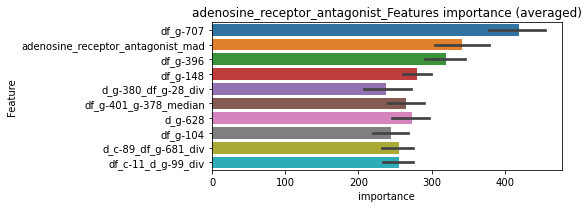

len(train_index) : 2720
len(valid_index) : 907
================================= fold 1/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106825	valid_1's binary_logloss: 0.169931
[200]	training's binary_logloss: 0.0407543	valid_1's binary_logloss: 0.107094
[300]	training's binary_logloss: 0.0174871	valid_1's binary_logloss: 0.0762062
[400]	training's binary_logloss: 0.0084428	valid_1's binary_logloss: 0.0632245
[500]	training's binary_logloss: 0.00432006	valid_1's binary_logloss: 0.0549755
[600]	training's binary_logloss: 0.00256248	valid_1's binary_logloss: 0.0505475
[700]	training's binary_logloss: 0.00174858	valid_1's binary_logloss: 0.0479961
[800]	training's binary_logloss: 0.00133016	valid_1's binary_logloss: 0.0464199
[900]	training's binary_logloss: 0.00108033	valid_1's binary_logloss: 0.0448433
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00109063	valid_1's binary_logloss: 0.0447249


len(train_index) : 2720
len(valid_index) : 907
================================= fold 2/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107028	valid_1's binary_logloss: 0.151741
[200]	training's binary_logloss: 0.0399655	valid_1's binary_logloss: 0.0877874
[300]	training's binary_logloss: 0.0168756	valid_1's binary_logloss: 0.0588798
[400]	training's binary_logloss: 0.00798453	valid_1's binary_logloss: 0.0453642
[500]	training's binary_logloss: 0.00418805	valid_1's binary_logloss: 0.0368005
[600]	training's binary_logloss: 0.00254758	valid_1's binary_logloss: 0.0323701
[700]	training's binary_logloss: 0.00175943	valid_1's binary_logloss: 0.0297963
[800]	training's binary_logloss: 0.0013285	valid_1's binary_logloss: 0.0279402
[900]	training's binary_logloss: 0.00108285	valid_1's binary_logloss: 0.0271384
[1000]	training's binary_logloss: 0.000937442	valid_1's binary_logloss: 0.0262217
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.000903186	valid_1's binary_logloss: 0.0259656


len(train_index) : 2720
len(valid_index) : 907
================================= fold 3/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105709	valid_1's binary_logloss: 0.156906
[200]	training's binary_logloss: 0.0397256	valid_1's binary_logloss: 0.0906298
[300]	training's binary_logloss: 0.0167627	valid_1's binary_logloss: 0.0623278
[400]	training's binary_logloss: 0.00784007	valid_1's binary_logloss: 0.0479537
[500]	training's binary_logloss: 0.0041745	valid_1's binary_logloss: 0.0397167
[600]	training's binary_logloss: 0.00253876	valid_1's binary_logloss: 0.0353054
[700]	training's binary_logloss: 0.00174637	valid_1's binary_logloss: 0.0325333
[800]	training's binary_logloss: 0.00132059	valid_1's binary_logloss: 0.0309876
[900]	training's binary_logloss: 0.00107924	valid_1's binary_logloss: 0.0298042
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.00105942	valid_1's binary_logloss: 0.029732


len(train_index) : 2721
len(valid_index) : 906
================================= fold 4/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104018	valid_1's binary_logloss: 0.165906
[200]	training's binary_logloss: 0.0375398	valid_1's binary_logloss: 0.105948
[300]	training's binary_logloss: 0.015844	valid_1's binary_logloss: 0.0833422
[400]	training's binary_logloss: 0.00741374	valid_1's binary_logloss: 0.0735223
[500]	training's binary_logloss: 0.00393899	valid_1's binary_logloss: 0.0700401
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00313643	valid_1's binary_logloss: 0.0695327


adenosine_receptor_antagonist logloss: 0.04248137107504837


neg labels: 3289 → selected neg labels: 3289


adenylyl_cyclase_activator, len(trt): 18, len(othr): 3289, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0844099	valid_1's binary_logloss: 0.105251
[200]	training's binary_logloss: 0.0248239	valid_1's binary_logloss: 0.0402817
[300]	training's binary_logloss: 0.00843663	valid_1's binary_logloss: 0.0195145
[400]	training's binary_logloss: 0.00335869	valid_1's binary_logloss: 0.0123178
[500]	training's binary_logloss: 0.00169804	valid_1's binary_logloss: 0.00951797
[600]	training's binary_logloss: 0.0010671	valid_1's binary_logloss: 0.00827342
[700]	training's binary_logloss: 0.000780068	valid_1's binary_logloss: 0.00772134
[800]	training's binary_logloss: 0.000617501	valid_1's binary_logloss: 0.00738314
[900]	training's binary_logloss: 0.000538058	valid_1's binary_logloss: 0.00723313
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.000525141	valid_1's binary_logloss: 0.00718466
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

1 / 3 AUC score:1.000
y_Threshold: 0.0046405, Threshold: 0.0515580, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.03609, conf_1:0.06703
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0515580
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.0815580
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.1115580
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.1415580
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.1715580
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_6: 0.2015580
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.2315580
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.2615580
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.2915580
threshold: 0.2915580, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0806808	valid_1's binary_logloss: 0.0996882
[200]	training's binary_logloss: 0.0219347	valid_1's binary_logloss: 0.0340588
[300]	training's binary_logloss: 0.00699642	valid_1's binary_logloss: 0.014632
[400]	training's binary_logloss: 0.00279561	valid_1's binary_logloss: 0.00826842
[500]	training's binary_logloss: 0.0014485	valid_1's binary_logloss: 0.00608525
[600]	training's binary_logloss: 0.000930494	valid_1's binary_logloss: 0.00500062
[700]	training's binary_logloss: 0.000678902	valid_1's binary_logloss: 0.0043869
[800]	training's binary_logloss: 0.000548372	valid_1's binary_logloss: 0.00413244
[900]	training's binary_logloss: 0.00048399	valid_1's binary_logloss: 0.00400992
[1000]	training's binary_logloss: 0.000461998	valid_1's binary_logloss: 0.00396494
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.000464646	valid_1's binary_logloss: 0.00394792
Training until 

2 / 3 AUC score:1.000
y_Threshold: 0.0921818, Threshold: 0.2915580, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0115520 Vs.target_rate: 0.00076, Num_p_label: 46.0, conf_0:0.23325, conf_1:0.34987
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_1: 0.2915580
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_2: 0.3215580
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_3: 0.3515580
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_4: 0.3815580
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_5: 0.4115580
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_6: 0.4415580
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_7: 0.4715580
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_8: 0.5015580
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_9: 0.5315580
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_10: 0.5615580
threshold: 0.5915580, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0806808	valid_1's binary_logloss: 0.0996882
[200]	training's binary_logloss: 0.0219347	valid_1's binary_logloss: 0.0340588
[300]	training's binary_logloss: 0.00699642	valid_1's binary_logloss: 0.014632
[400]	training's binary_logloss: 0.00279561	valid_1's binary_logloss: 0.00826842
[500]	training's binary_logloss: 0.0014485	valid_1's binary_logloss: 0.00608525
[600]	training's binary_logloss: 0.000930494	valid_1's binary_logloss: 0.00500062
[700]	training's binary_logloss: 0.000678902	valid_1's binary_logloss: 0.0043869
[800]	training's binary_logloss: 0.000548372	valid_1's binary_logloss: 0.00413244
[900]	training's binary_logloss: 0.00048399	valid_1's binary_logloss: 0.00400992
[1000]	training's binary_logloss: 0.000461998	valid_1's binary_logloss: 0.00396494
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.000464646	valid_1's binary_logloss: 0.00394792
Training until 

3 / 3 AUC score:1.000
y_Threshold: 0.0921818, Threshold: 0.5915580, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0072828 Vs.target_rate: 0.00076, Num_p_label: 29.0, conf_0:0.50000, conf_1:0.65071
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_1: 0.5915580
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.6215580
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_3: 0.6515580
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_4: 0.6815580
threshold: 0.6815580, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


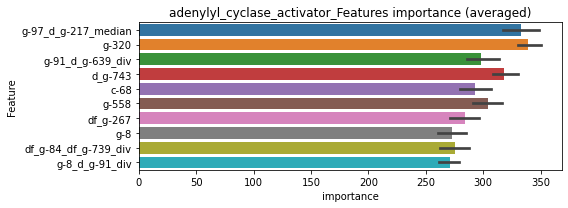

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0797818	valid_1's binary_logloss: 0.0997746
[200]	training's binary_logloss: 0.0217785	valid_1's binary_logloss: 0.0347901
[300]	training's binary_logloss: 0.0069197	valid_1's binary_logloss: 0.0148995
[400]	training's binary_logloss: 0.00274676	valid_1's binary_logloss: 0.00828769
[500]	training's binary_logloss: 0.00143663	valid_1's binary_logloss: 0.00591588
[600]	training's binary_logloss: 0.000925898	valid_1's binary_logloss: 0.0047825
[700]	training's binary_logloss: 0.000678696	valid_1's binary_logloss: 0.00424242
[800]	training's binary_logloss: 0.000546189	valid_1's binary_logloss: 0.00391831
[900]	training's binary_logloss: 0.000483099	valid_1's binary_logloss: 0.00374244
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.00047438	valid_1's binary_logloss: 0.00372551


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0800577	valid_1's binary_logloss: 0.10141
[200]	training's binary_logloss: 0.0226953	valid_1's binary_logloss: 0.0366308
[300]	training's binary_logloss: 0.00721558	valid_1's binary_logloss: 0.0152697
[400]	training's binary_logloss: 0.00288887	valid_1's binary_logloss: 0.00810268
[500]	training's binary_logloss: 0.00149213	valid_1's binary_logloss: 0.00508418
[600]	training's binary_logloss: 0.000944761	valid_1's binary_logloss: 0.00381274
[700]	training's binary_logloss: 0.000686602	valid_1's binary_logloss: 0.00318141
[800]	training's binary_logloss: 0.000551206	valid_1's binary_logloss: 0.00282364
[900]	training's binary_logloss: 0.000483738	valid_1's binary_logloss: 0.00266274
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000469955	valid_1's binary_logloss: 0.00264674


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0820267	valid_1's binary_logloss: 0.0993331
[200]	training's binary_logloss: 0.0226168	valid_1's binary_logloss: 0.0327782
[300]	training's binary_logloss: 0.00729116	valid_1's binary_logloss: 0.0127791
[400]	training's binary_logloss: 0.00284519	valid_1's binary_logloss: 0.00609005
[500]	training's binary_logloss: 0.00147005	valid_1's binary_logloss: 0.00363986
[600]	training's binary_logloss: 0.000929432	valid_1's binary_logloss: 0.0025293
[700]	training's binary_logloss: 0.000681057	valid_1's binary_logloss: 0.00201409
[800]	training's binary_logloss: 0.000553052	valid_1's binary_logloss: 0.00176692
[900]	training's binary_logloss: 0.00048543	valid_1's binary_logloss: 0.00161771
Early stopping, best iteration is:
[967]	training's binary_logloss: 0.000466687	valid_1's binary_logloss: 0.00156834


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0800498	valid_1's binary_logloss: 0.0975494
[200]	training's binary_logloss: 0.0215339	valid_1's binary_logloss: 0.0319972
[300]	training's binary_logloss: 0.00680262	valid_1's binary_logloss: 0.0127769
[400]	training's binary_logloss: 0.00272058	valid_1's binary_logloss: 0.0067405
[500]	training's binary_logloss: 0.00142539	valid_1's binary_logloss: 0.00444327
[600]	training's binary_logloss: 0.000912954	valid_1's binary_logloss: 0.00354159
[700]	training's binary_logloss: 0.000671187	valid_1's binary_logloss: 0.00302553
[800]	training's binary_logloss: 0.00054064	valid_1's binary_logloss: 0.00278192
[900]	training's binary_logloss: 0.000480857	valid_1's binary_logloss: 0.00262489
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.000471185	valid_1's binary_logloss: 0.00261299


adenylyl_cyclase_activator logloss: 0.002638889176664599
adrenergic_receptor_agonist, len(trt): 270, len(othr): 3254, target_rate: 0.0113379 → Adj_target_rate: 0.0097917


neg labels: 3289 → selected neg labels: 3254


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.233132	valid_1's binary_logloss: 0.35277
[200]	training's binary_logloss: 0.142475	valid_1's binary_logloss: 0.3145
[300]	training's binary_logloss: 0.0918322	valid_1's binary_logloss: 0.297045
[400]	training's binary_logloss: 0.0597569	valid_1's binary_logloss: 0.289729
[500]	training's binary_logloss: 0.0401987	valid_1's binary_logloss: 0.287467
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.0364748	valid_1's binary_logloss: 0.286695
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.225653	valid_1's binary_logloss: 0.359447
[200]	training's binary_logloss: 0.138807	valid_1's binary_logloss: 0.327975
[300]	training's binary_logloss: 0.09105	valid_1's binary_logloss: 0.315816
[400]	training's binary_logloss: 0.0611749	valid_1's binary_logloss: 0.310978
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.04

1 / 3 AUC score:0.858
y_Threshold: 0.1098095, Threshold: 0.6946688, pos_neg_ratio: 0.8000000
Remove_noisy_data: 487 → Positive_corect_labels: 472/3417
p_label_rate: 0.0100452 Vs.target_rate: 0.01134, Num_p_label: 40.0, conf_0:0.48627, conf_1:0.80000
threshold: 0.6946688, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 472.0/3417, y_label_rate: 0.1381329
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.146203	valid_1's binary_logloss: 0.239297
[200]	training's binary_logloss: 0.0730897	valid_1's binary_logloss: 0.188256
[300]	training's binary_logloss: 0.0393484	valid_1's binary_logloss: 0.161388
[400]	training's binary_logloss: 0.0217452	valid_1's binary_logloss: 0.14682
[500]	training's binary_logloss: 0.012492	valid_1's binary_logloss: 0.139238
[600]	training's binary_logloss: 0.00761418	valid_1's binary_logloss: 0.135404
[700]	training's binary_logloss: 0.00487784	valid_1's binary_logloss: 0.132282
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00389477	valid_1's binary_logloss: 0.131232
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149311	valid_1's binary_logloss: 0.246733
[200]	training's binary_logloss: 0.0730521	valid_1's binary_logloss: 0.195616
[300]	training's binary_logloss: 0.0383789	valid_1's binary_logl

2 / 3 AUC score:0.975
y_Threshold: 0.0906200, Threshold: 0.6946688, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 406.0/3285
p_label_rate: 0.0283777 Vs.target_rate: 0.01134, Num_p_label: 113.0, conf_0:0.50000, conf_1:0.80000
threshold: 0.6946688, positive_p_label: 113.0/3982, p_label_rate: 0.0283777
positive_y_label: 406.0/3285, y_label_rate: 0.1235921
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119036	valid_1's binary_logloss: 0.209968
[200]	training's binary_logloss: 0.0513698	valid_1's binary_logloss: 0.156846
[300]	training's binary_logloss: 0.0241768	valid_1's binary_logloss: 0.132032
[400]	training's binary_logloss: 0.0125285	valid_1's binary_logloss: 0.119802
[500]	training's binary_logloss: 0.00678636	valid_1's binary_logloss: 0.112768
[600]	training's binary_logloss: 0.00416524	valid_1's binary_logloss: 0.10917
[700]	training's binary_logloss: 0.00282895	valid_1's binary_logloss: 0.107292
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.002978	valid_1's binary_logloss: 0.107143
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120793	valid_1's binary_logloss: 0.194716
[200]	training's binary_logloss: 0.0508677	valid_1's binary_logloss: 0.142828
[300]	training's binary_logloss: 0.0247262	valid_1's binary_logl

3 / 3 AUC score:0.973
y_Threshold: 0.0818752, Threshold: 0.6946688, pos_neg_ratio: 0.8000000
Remove_noisy_data: 86 → Positive_corect_labels: 363.0/3199
p_label_rate: 0.0369161 Vs.target_rate: 0.01134, Num_p_label: 147.0, conf_0:0.50000, conf_1:0.76414
Num_p_label: 147.0, Expected: 45.1, Adj_threshold_1: 0.6946688
threshold: 0.6946688, positive_p_label: 147.0/3982, p_label_rate: 0.0369161
positive_y_label: 363.0/3199, y_label_rate: 0.1134730


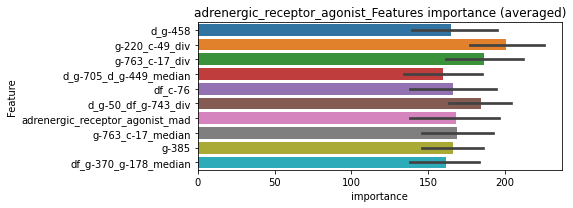

len(train_index) : 2399
len(valid_index) : 800
================================= fold 1/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101747	valid_1's binary_logloss: 0.182981
[200]	training's binary_logloss: 0.0415002	valid_1's binary_logloss: 0.134935
[300]	training's binary_logloss: 0.0178258	valid_1's binary_logloss: 0.112222
[400]	training's binary_logloss: 0.00850914	valid_1's binary_logloss: 0.0999583
[500]	training's binary_logloss: 0.0046153	valid_1's binary_logloss: 0.0949229
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00504649	valid_1's binary_logloss: 0.0947172


len(train_index) : 2399
len(valid_index) : 800
================================= fold 2/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103709	valid_1's binary_logloss: 0.187451
[200]	training's binary_logloss: 0.042755	valid_1's binary_logloss: 0.144783
[300]	training's binary_logloss: 0.0193835	valid_1's binary_logloss: 0.126332
[400]	training's binary_logloss: 0.00919775	valid_1's binary_logloss: 0.118034
[500]	training's binary_logloss: 0.00492095	valid_1's binary_logloss: 0.113842
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00432342	valid_1's binary_logloss: 0.113182


len(train_index) : 2399
len(valid_index) : 800
================================= fold 3/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105335	valid_1's binary_logloss: 0.169814
[200]	training's binary_logloss: 0.0415378	valid_1's binary_logloss: 0.115977
[300]	training's binary_logloss: 0.0184706	valid_1's binary_logloss: 0.0926348
[400]	training's binary_logloss: 0.0088695	valid_1's binary_logloss: 0.0807657
[500]	training's binary_logloss: 0.00481084	valid_1's binary_logloss: 0.0756945
[600]	training's binary_logloss: 0.00297851	valid_1's binary_logloss: 0.0733355
[700]	training's binary_logloss: 0.00205875	valid_1's binary_logloss: 0.0719362
[800]	training's binary_logloss: 0.00156198	valid_1's binary_logloss: 0.0713483
Early stopping, best iteration is:
[781]	training's binary_logloss: 0.00163474	valid_1's binary_logloss: 0.0710698


len(train_index) : 2400
len(valid_index) : 799
================================= fold 4/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107485	valid_1's binary_logloss: 0.158128
[200]	training's binary_logloss: 0.0449735	valid_1's binary_logloss: 0.10934
[300]	training's binary_logloss: 0.0206617	valid_1's binary_logloss: 0.086191
[400]	training's binary_logloss: 0.0100813	valid_1's binary_logloss: 0.0742992
[500]	training's binary_logloss: 0.00539577	valid_1's binary_logloss: 0.0659921
[600]	training's binary_logloss: 0.00325793	valid_1's binary_logloss: 0.0608478
[700]	training's binary_logloss: 0.00222276	valid_1's binary_logloss: 0.057795
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.00190482	valid_1's binary_logloss: 0.0570808


adrenergic_receptor_agonist logloss: 0.0840209926409564
adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3240, target_rate: 0.0151172 → Adj_target_rate: 0.0125042


neg labels: 3289 → selected neg labels: 3240


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.246672	valid_1's binary_logloss: 0.366543
[200]	training's binary_logloss: 0.158413	valid_1's binary_logloss: 0.343708
[300]	training's binary_logloss: 0.108832	valid_1's binary_logloss: 0.332394
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0942662	valid_1's binary_logloss: 0.331277
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.250308	valid_1's binary_logloss: 0.372601
[200]	training's binary_logloss: 0.16022	valid_1's binary_logloss: 0.350836
[300]	training's binary_logloss: 0.110066	valid_1's binary_logloss: 0.343481
[400]	training's binary_logloss: 0.0778882	valid_1's binary_logloss: 0.342241
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0857509	valid_1's binary_logloss: 0.340647
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.248359	valid_1's 

1 / 3 AUC score:0.787
y_Threshold: 0.1504799, Threshold: 0.6162265, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0917489	valid_1's binary_logloss: 0.336726


Remove_noisy_data: 646 → Positive_corect_labels: 390/3242
p_label_rate: 0.0100452 Vs.target_rate: 0.01512, Num_p_label: 40.0, conf_0:0.43136, conf_1:0.80000
threshold: 0.6162265, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 390.0/3242, y_label_rate: 0.1202961
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113924	valid_1's binary_logloss: 0.18977
[200]	training's binary_logloss: 0.045604	valid_1's binary_logloss: 0.151222
[300]	training's binary_logloss: 0.0215574	valid_1's binary_logloss: 0.13636
[400]	training's binary_logloss: 0.0111108	valid_1's binary_logloss: 0.130736
[500]	training's binary_logloss: 0.00606535	valid_1's binary_logloss: 0.128679
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.0049517	valid_1's binary_logloss: 0.127804
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112797	valid_1's binary_logloss: 0.190199
[200]	training's binary_logloss: 0.045559	valid_1's binary_logloss: 0.152475
[300]	training's binary_logloss: 0.0206338	valid_1's binary_logloss: 0.143214
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0169079	valid_1's binary_logloss: 0.142206
Training until validation scores 

2 / 3 AUC score:0.969
y_Threshold: 0.1088478, Threshold: 0.6162265, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 324.0/3110
p_label_rate: 0.0469613 Vs.target_rate: 0.01512, Num_p_label: 187.0, conf_0:0.49298, conf_1:0.73947
Num_p_label: 187.0, Expected: 60.2, Adj_threshold_1: 0.6162265
Num_p_label: 185.0, Expected: 60.2, Adj_threshold_2: 0.6462265
Num_p_label: 179.0, Expected: 60.2, Adj_threshold_3: 0.6762265
threshold: 0.6762265, positive_p_label: 179.0/3982, p_label_rate: 0.0449523
positive_y_label: 324.0/3110, y_label_rate: 0.1041801
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0800607	valid_1's binary_logloss: 0.126194
[200]	training's binary_logloss: 0.0284508	valid_1's binary_logloss: 0.0822989
[300]	training's binary_logloss: 0.0117593	valid_1's binary_logloss: 0.0658264
[400]	training's binary_logloss: 0.00564423	valid_1's binary_logloss: 0.0582037
[500]	training's binary_logloss: 0.00315574	valid_1's binary_logloss: 0.0547938
[600]	training's binary_logloss: 0.00203403	valid_1's binary_logloss: 0.0526516
[700]	training's binary_logloss: 0.00148095	valid_1's binary_logloss: 0.0514056
[800]	training's binary_logloss: 0.00116559	valid_1's binary_logloss: 0.0507683
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.00112474	valid_1's binary_logloss: 0.0505447
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0820107	valid_1's binary_logloss: 0.146034
[200]	training's binary_logloss: 0.0286979	valid_

3 / 3 AUC score:0.995
y_Threshold: 0.0882410, Threshold: 0.6762265, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 302.0/3066
p_label_rate: 0.0590156 Vs.target_rate: 0.01512, Num_p_label: 235.0, conf_0:0.50000, conf_1:0.74385
Num_p_label: 235.0, Expected: 60.2, Adj_threshold_1: 0.6762265
threshold: 0.6762265, positive_p_label: 235.0/3982, p_label_rate: 0.0590156
positive_y_label: 302.0/3066, y_label_rate: 0.0984997


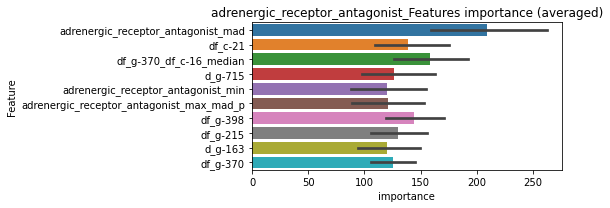

len(train_index) : 2299
len(valid_index) : 767
================================= fold 1/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0705265	valid_1's binary_logloss: 0.128266
[200]	training's binary_logloss: 0.0233567	valid_1's binary_logloss: 0.0973882
[300]	training's binary_logloss: 0.00930608	valid_1's binary_logloss: 0.0912422


len(train_index) : 2299
len(valid_index) : 767
================================= fold 2/4 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00744557	valid_1's binary_logloss: 0.0907773
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0702847	valid_1's binary_logloss: 0.12218
[200]	training's binary_logloss: 0.0229944	valid_1's binary_logloss: 0.0806152
[300]	training's binary_logloss: 0.00925676	valid_1's binary_logloss: 0.0673067
[400]	training's binary_logloss: 0.00444367	valid_1's binary_logloss: 0.0604318
[500]	training's binary_logloss: 0.00250378	valid_1's binary_logloss: 0.058442
[600]	training's binary_logloss: 0.00164457	valid_1's binary_logloss: 0.057672
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00163718	valid_1's binary_logloss: 0.0576499


len(train_index) : 2300
len(valid_index) : 766
================================= fold 3/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0723788	valid_1's binary_logloss: 0.121649
[200]	training's binary_logloss: 0.0248419	valid_1's binary_logloss: 0.0827802
[300]	training's binary_logloss: 0.0098988	valid_1's binary_logloss: 0.0660812
[400]	training's binary_logloss: 0.00470838	valid_1's binary_logloss: 0.0592527
[500]	training's binary_logloss: 0.00264331	valid_1's binary_logloss: 0.0566071
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00220583	valid_1's binary_logloss: 0.0555749


len(train_index) : 2300
len(valid_index) : 766
================================= fold 4/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0727537	valid_1's binary_logloss: 0.114014
[200]	training's binary_logloss: 0.023661	valid_1's binary_logloss: 0.074443
[300]	training's binary_logloss: 0.00931928	valid_1's binary_logloss: 0.0632577
[400]	training's binary_logloss: 0.00438752	valid_1's binary_logloss: 0.058084
[500]	training's binary_logloss: 0.00246379	valid_1's binary_logloss: 0.0565533
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00239192	valid_1's binary_logloss: 0.056467


adrenergic_receptor_antagonist logloss: 0.06512319797274731
akt_inhibitor, len(trt): 66, len(othr): 3284, target_rate: 0.0027715 → Adj_target_rate: 0.0029567


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128856	valid_1's binary_logloss: 0.210413
[200]	training's binary_logloss: 0.0558971	valid_1's binary_logloss: 0.139634
[300]	training's binary_logloss: 0.0258077	valid_1's binary_logloss: 0.105951
[400]	training's binary_logloss: 0.0132725	valid_1's binary_logloss: 0.0891347
[500]	training's binary_logloss: 0.00698127	valid_1's binary_logloss: 0.0788632
[600]	training's binary_logloss: 0.00408798	valid_1's binary_logloss: 0.0728821
[700]	training's binary_logloss: 0.00264281	valid_1's binary_logloss: 0.0698698
[800]	training's binary_logloss: 0.00189223	valid_1's binary_logloss: 0.0679516
[900]	training's binary_logloss: 0.00146407	valid_1's binary_logloss: 0.0668471
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.00135475	valid_1's binary_logloss: 0.066419
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129094	valid_1's 

1 / 3 AUC score:0.996
y_Threshold: 0.0266313, Threshold: 0.1597922, pos_neg_ratio: 0.8000000
Remove_noisy_data: 148 → Positive_corect_labels: 648/3792
p_label_rate: 0.0100452 Vs.target_rate: 0.00277, Num_p_label: 40.0, conf_0:0.11185, conf_1:0.20773
Num_p_label: 40.0, Expected: 11.0, Adj_threshold_1: 0.1597922
Num_p_label: 31.0, Expected: 11.0, Adj_threshold_2: 0.1897922
Num_p_label: 26.0, Expected: 11.0, Adj_threshold_3: 0.2197922
Num_p_label: 22.0, Expected: 11.0, Adj_threshold_4: 0.2497922
Num_p_label: 18.0, Expected: 11.0, Adj_threshold_5: 0.2797922
Num_p_label: 16.0, Expected: 11.0, Adj_threshold_6: 0.3097922
threshold: 0.3097922, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 648.0/3792, y_label_rate: 0.1708861
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123533	valid_1's binary_logloss: 0.191202
[200]	training's binary_logloss: 0.0471837	valid_1's binary_logloss: 0.117209
[300]	training's binary_logloss: 0.0207904	valid_1's binary_logloss: 0.088238
[400]	training's binary_logloss: 0.0100112	valid_1's binary_logloss: 0.075233
[500]	training's binary_logloss: 0.00517406	valid_1's binary_logloss: 0.0678355
[600]	training's binary_logloss: 0.00306005	valid_1's binary_logloss: 0.0644143
[700]	training's binary_logloss: 0.00204692	valid_1's binary_logloss: 0.0623988
Early stopping, best iteration is:
[740]	training's binary_logloss: 0.00179493	valid_1's binary_logloss: 0.0615167
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124756	valid_1's binary_logloss: 0.184237
[200]	training's binary_logloss: 0.0486138	valid_1's binary_logloss: 0.109788
[300]	training's binary_logloss: 0.0215446	valid_1's bina

2 / 3 AUC score:0.998
y_Threshold: 0.0608330, Threshold: 0.3097922, pos_neg_ratio: 0.8000000
Remove_noisy_data: 28 → Positive_corect_labels: 634.0/3764
p_label_rate: 0.0113009 Vs.target_rate: 0.00277, Num_p_label: 45.0, conf_0:0.24783, conf_1:0.37175
Num_p_label: 45.0, Expected: 11.0, Adj_threshold_1: 0.3097922
Num_p_label: 41.0, Expected: 11.0, Adj_threshold_2: 0.3397922
Num_p_label: 38.0, Expected: 11.0, Adj_threshold_3: 0.3697922
Num_p_label: 30.0, Expected: 11.0, Adj_threshold_4: 0.3997922
Num_p_label: 30.0, Expected: 11.0, Adj_threshold_5: 0.4297922
Num_p_label: 27.0, Expected: 11.0, Adj_threshold_6: 0.4597922
Num_p_label: 22.0, Expected: 11.0, Adj_threshold_7: 0.4897922
Num_p_label: 21.0, Expected: 11.0, Adj_threshold_8: 0.5197922
Num_p_label: 20.0, Expected: 11.0, Adj_threshold_9: 0.5497922
Num_p_label: 19.0, Expected: 11.0, Adj_threshold_10: 0.5797922
threshold: 0.6097922, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 634.0/3764, y_label_rate: 0.1684378

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115357	valid_1's binary_logloss: 0.170702
[200]	training's binary_logloss: 0.0429678	valid_1's binary_logloss: 0.0972386
[300]	training's binary_logloss: 0.0186416	valid_1's binary_logloss: 0.0669069
[400]	training's binary_logloss: 0.00887669	valid_1's binary_logloss: 0.0534115
[500]	training's binary_logloss: 0.00471352	valid_1's binary_logloss: 0.0459452
[600]	training's binary_logloss: 0.00284029	valid_1's binary_logloss: 0.0410122
[700]	training's binary_logloss: 0.00193186	valid_1's binary_logloss: 0.0393832
[800]	training's binary_logloss: 0.00144703	valid_1's binary_logloss: 0.0386651
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.00142017	valid_1's binary_logloss: 0.0385844
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11348	valid_1's binary_logloss: 0.171635
[200]	training's binary_logloss: 0.0424369	valid_1's

3 / 3 AUC score:0.998
y_Threshold: 0.0830366, Threshold: 0.6097922, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 622.0/3740
p_label_rate: 0.0052737 Vs.target_rate: 0.00277, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.67077
threshold: 0.6097922, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 622.0/3740, y_label_rate: 0.1663102


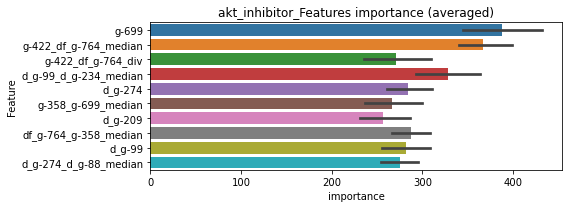

len(train_index) : 2805
len(valid_index) : 935
================================= fold 1/4 akt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113356	valid_1's binary_logloss: 0.161299
[200]	training's binary_logloss: 0.0426012	valid_1's binary_logloss: 0.0903562
[300]	training's binary_logloss: 0.0185122	valid_1's binary_logloss: 0.0627563
[400]	training's binary_logloss: 0.00873507	valid_1's binary_logloss: 0.0494316
[500]	training's binary_logloss: 0.00454909	valid_1's binary_logloss: 0.043042
[600]	training's binary_logloss: 0.0027215	valid_1's binary_logloss: 0.0401789
[700]	training's binary_logloss: 0.00184046	valid_1's binary_logloss: 0.0387088
[800]	training's binary_logloss: 0.00137114	valid_1's binary_logloss: 0.0374081
[900]	training's binary_logloss: 0.00109508	valid_1's binary_logloss: 0.0365349
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00110471	valid_1's binary_logloss: 0.0364797


len(train_index) : 2805
len(valid_index) : 935
================================= fold 2/4 akt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111806	valid_1's binary_logloss: 0.169126
[200]	training's binary_logloss: 0.0402963	valid_1's binary_logloss: 0.100742
[300]	training's binary_logloss: 0.0171127	valid_1's binary_logloss: 0.0731115
[400]	training's binary_logloss: 0.00800544	valid_1's binary_logloss: 0.0602507
[500]	training's binary_logloss: 0.00418749	valid_1's binary_logloss: 0.0539883
[600]	training's binary_logloss: 0.00252632	valid_1's binary_logloss: 0.0508638
[700]	training's binary_logloss: 0.00174355	valid_1's binary_logloss: 0.0494938
[800]	training's binary_logloss: 0.0013168	valid_1's binary_logloss: 0.0483719
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.00112883	valid_1's binary_logloss: 0.0475586


len(train_index) : 2805
len(valid_index) : 935
================================= fold 3/4 akt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113833	valid_1's binary_logloss: 0.149512
[200]	training's binary_logloss: 0.0427491	valid_1's binary_logloss: 0.07715
[300]	training's binary_logloss: 0.0180112	valid_1's binary_logloss: 0.0467631
[400]	training's binary_logloss: 0.00833158	valid_1's binary_logloss: 0.0323172
[500]	training's binary_logloss: 0.0043351	valid_1's binary_logloss: 0.02442
[600]	training's binary_logloss: 0.00262323	valid_1's binary_logloss: 0.0203712
[700]	training's binary_logloss: 0.00180107	valid_1's binary_logloss: 0.0183718
[800]	training's binary_logloss: 0.00135512	valid_1's binary_logloss: 0.0172538
[900]	training's binary_logloss: 0.00108951	valid_1's binary_logloss: 0.0163265
[1000]	training's binary_logloss: 0.00092779	valid_1's binary_logloss: 0.0157629
[1100]	training's binary_logloss: 0.00083136	valid_1's binary_logloss: 0.0152831
Early stopping, best iteration is:
[1138]	training's binary_logloss

len(train_index) : 2805
len(valid_index) : 935
================================= fold 4/4 akt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111077	valid_1's binary_logloss: 0.179362
[200]	training's binary_logloss: 0.0398887	valid_1's binary_logloss: 0.109836
[300]	training's binary_logloss: 0.0166378	valid_1's binary_logloss: 0.0816944
[400]	training's binary_logloss: 0.00768183	valid_1's binary_logloss: 0.0663572
[500]	training's binary_logloss: 0.0039966	valid_1's binary_logloss: 0.0597134
[600]	training's binary_logloss: 0.00243455	valid_1's binary_logloss: 0.0563122
[700]	training's binary_logloss: 0.0016822	valid_1's binary_logloss: 0.0546686
[800]	training's binary_logloss: 0.00127347	valid_1's binary_logloss: 0.0536541
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.00111894	valid_1's binary_logloss: 0.0525873


akt_inhibitor logloss: 0.03793707045534877
aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3288, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0785472	valid_1's binary_logloss: 0.105506
[200]	training's binary_logloss: 0.0233923	valid_1's binary_logloss: 0.042327
[300]	training's binary_logloss: 0.00749708	valid_1's binary_logloss: 0.0217117
[400]	training's binary_logloss: 0.00295822	valid_1's binary_logloss: 0.0144862
[500]	training's binary_logloss: 0.00150887	valid_1's binary_logloss: 0.0116285
[600]	training's binary_logloss: 0.000957565	valid_1's binary_logloss: 0.0104306
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.000822028	valid_1's binary_logloss: 0.0100741
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0801038	valid_1's binary_logloss: 0.101997
[200]	training's binary_logloss: 0.023906	valid_1's binary_logloss: 0.0413982
[300]	training's binary_logloss: 0.00788794	valid_1's binary_logloss: 0.0209677
[400]	training's binary_logloss: 0.00311322	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0082775, Threshold: 0.0470875, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.03296, conf_1:0.06121
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0470875
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_2: 0.0770875
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.1070875
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_4: 0.1370875
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.1670875
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.1970875
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.2270875
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_8: 0.2570875
threshold: 0.2570875, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0735106	valid_1's binary_logloss: 0.100965
[200]	training's binary_logloss: 0.0190787	valid_1's binary_logloss: 0.0382996
[300]	training's binary_logloss: 0.00599187	valid_1's binary_logloss: 0.0185852
[400]	training's binary_logloss: 0.00239992	valid_1's binary_logloss: 0.0119794
[500]	training's binary_logloss: 0.0012494	valid_1's binary_logloss: 0.00947769
[600]	training's binary_logloss: 0.00080767	valid_1's binary_logloss: 0.0082971
[700]	training's binary_logloss: 0.000593653	valid_1's binary_logloss: 0.00762029
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.000627383	valid_1's binary_logloss: 0.00753637
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0746413	valid_1's binary_logloss: 0.0947781
[200]	training's binary_logloss: 0.0200586	valid_1's binary_logloss: 0.0348745
[300]	training's binary_logloss: 0.00638135	

2 / 3 AUC score:1.000
y_Threshold: 0.1565944, Threshold: 0.2570875, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0060271 Vs.target_rate: 0.00080, Num_p_label: 24.0, conf_0:0.20567, conf_1:0.30850
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_1: 0.2570875
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_2: 0.2870875
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_3: 0.3170875
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_4: 0.3470875
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_5: 0.3770875
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_6: 0.4070875
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.4370875
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_8: 0.4670875
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.4970875
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.5270875
threshold: 0.5570875, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0735106	valid_1's binary_logloss: 0.100965
[200]	training's binary_logloss: 0.0190787	valid_1's binary_logloss: 0.0382996
[300]	training's binary_logloss: 0.00599187	valid_1's binary_logloss: 0.0185852
[400]	training's binary_logloss: 0.00239992	valid_1's binary_logloss: 0.0119794
[500]	training's binary_logloss: 0.0012494	valid_1's binary_logloss: 0.00947769
[600]	training's binary_logloss: 0.00080767	valid_1's binary_logloss: 0.0082971
[700]	training's binary_logloss: 0.000593653	valid_1's binary_logloss: 0.00762029
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.000627383	valid_1's binary_logloss: 0.00753637
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0746413	valid_1's binary_logloss: 0.0947781
[200]	training's binary_logloss: 0.0200586	valid_1's binary_logloss: 0.0348745
[300]	training's binary_logloss: 0.00638135	

3 / 3 AUC score:1.000
y_Threshold: 0.1565944, Threshold: 0.5570875, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.50000, conf_1:0.61280
threshold: 0.5570875, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


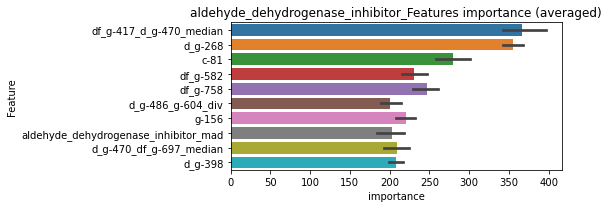

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0744055	valid_1's binary_logloss: 0.0987616
[200]	training's binary_logloss: 0.0196349	valid_1's binary_logloss: 0.0385703
[300]	training's binary_logloss: 0.00685336	valid_1's binary_logloss: 0.0233967
[400]	training's binary_logloss: 0.00324152	valid_1's binary_logloss: 0.0177404
[500]	training's binary_logloss: 0.00140364	valid_1's binary_logloss: 0.012279
[600]	training's binary_logloss: 0.000841824	valid_1's binary_logloss: 0.00950852
[700]	training's binary_logloss: 0.000595767	valid_1's binary_logloss: 0.00784228
[800]	training's binary_logloss: 0.000474731	valid_1's binary_logloss: 0.00739296
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.000457456	valid_1's binary_logloss: 0.00729988


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0746255	valid_1's binary_logloss: 0.0941646
[200]	training's binary_logloss: 0.0199929	valid_1's binary_logloss: 0.0338546
[300]	training's binary_logloss: 0.00634856	valid_1's binary_logloss: 0.0162268
[400]	training's binary_logloss: 0.0025545	valid_1's binary_logloss: 0.0103015
[500]	training's binary_logloss: 0.00131102	valid_1's binary_logloss: 0.00756501
[600]	training's binary_logloss: 0.000844626	valid_1's binary_logloss: 0.00668561
[700]	training's binary_logloss: 0.000619898	valid_1's binary_logloss: 0.00597943
[800]	training's binary_logloss: 0.00050079	valid_1's binary_logloss: 0.00569692
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000481959	valid_1's binary_logloss: 0.00560428


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0758382	valid_1's binary_logloss: 0.091263
[200]	training's binary_logloss: 0.0201367	valid_1's binary_logloss: 0.0290936
[300]	training's binary_logloss: 0.00643893	valid_1's binary_logloss: 0.0113941
[400]	training's binary_logloss: 0.00254577	valid_1's binary_logloss: 0.00541557
[500]	training's binary_logloss: 0.00132251	valid_1's binary_logloss: 0.00325468
[600]	training's binary_logloss: 0.000840478	valid_1's binary_logloss: 0.00228957
[700]	training's binary_logloss: 0.000617628	valid_1's binary_logloss: 0.00180287
[800]	training's binary_logloss: 0.000502488	valid_1's binary_logloss: 0.00153565
[900]	training's binary_logloss: 0.000458254	valid_1's binary_logloss: 0.00142063
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000449813	valid_1's binary_logloss: 0.00139899


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0757755	valid_1's binary_logloss: 0.0888408
[200]	training's binary_logloss: 0.0198915	valid_1's binary_logloss: 0.0292993
[300]	training's binary_logloss: 0.00637109	valid_1's binary_logloss: 0.0123517
[400]	training's binary_logloss: 0.00254882	valid_1's binary_logloss: 0.00658896
[500]	training's binary_logloss: 0.00132037	valid_1's binary_logloss: 0.0043617
[600]	training's binary_logloss: 0.000849769	valid_1's binary_logloss: 0.003365
[700]	training's binary_logloss: 0.000622389	valid_1's binary_logloss: 0.00283538
[800]	training's binary_logloss: 0.000505699	valid_1's binary_logloss: 0.00253983
[900]	training's binary_logloss: 0.000457283	valid_1's binary_logloss: 0.00241927
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000457283	valid_1's binary_logloss: 0.00241927


aldehyde_dehydrogenase_inhibitor logloss: 0.0041814240533879264
alk_inhibitor, len(trt): 42, len(othr): 3285, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114672	valid_1's binary_logloss: 0.157858
[200]	training's binary_logloss: 0.0453843	valid_1's binary_logloss: 0.0896664
[300]	training's binary_logloss: 0.0201093	valid_1's binary_logloss: 0.0600734
[400]	training's binary_logloss: 0.00928732	valid_1's binary_logloss: 0.0453644
[500]	training's binary_logloss: 0.00479931	valid_1's binary_logloss: 0.03752
[600]	training's binary_logloss: 0.00282477	valid_1's binary_logloss: 0.0334734
[700]	training's binary_logloss: 0.00187268	valid_1's binary_logloss: 0.0313777
[800]	training's binary_logloss: 0.00138057	valid_1's binary_logloss: 0.0298887
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.00118881	valid_1's binary_logloss: 0.0293322
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112122	valid_1's binary_logloss: 0.169879
[200]	training's binary_logloss: 0.043502	valid_1's b

1 / 3 AUC score:0.999
y_Threshold: 0.0160435, Threshold: 0.0728809, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.05102, conf_1:0.09475
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.0728809
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_2: 0.1028809
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_3: 0.1328809
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_4: 0.1628809
threshold: 0.1628809, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11043	valid_1's binary_logloss: 0.169849
[200]	training's binary_logloss: 0.0386189	valid_1's binary_logloss: 0.0988982
[300]	training's binary_logloss: 0.015883	valid_1's binary_logloss: 0.0730375
[400]	training's binary_logloss: 0.00724815	valid_1's binary_logloss: 0.0620773
[500]	training's binary_logloss: 0.00377775	valid_1's binary_logloss: 0.0557421
[600]	training's binary_logloss: 0.00226186	valid_1's binary_logloss: 0.0530844
[700]	training's binary_logloss: 0.00156146	valid_1's binary_logloss: 0.0521124
[800]	training's binary_logloss: 0.00117736	valid_1's binary_logloss: 0.0513089
Early stopping, best iteration is:
[851]	training's binary_logloss: 0.00104922	valid_1's binary_logloss: 0.0509554
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111776	valid_1's binary_logloss: 0.158399
[200]	training's binary_logloss: 0.0409913	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.0564565, Threshold: 0.1628809, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 644.0/3784
p_label_rate: 0.0150678 Vs.target_rate: 0.00176, Num_p_label: 60.0, conf_0:0.13030, conf_1:0.19546
Num_p_label: 60.0, Expected: 7.0, Adj_threshold_1: 0.1628809
Num_p_label: 49.0, Expected: 7.0, Adj_threshold_2: 0.1928809
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_3: 0.2228809
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_4: 0.2528809
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_5: 0.2828809
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_6: 0.3128809
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_7: 0.3428809
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_8: 0.3728809
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_9: 0.4028809
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_10: 0.4328809
threshold: 0.4628809, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 644.0/3784, y_label_rate: 0.1701903
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111421	valid_1's binary_logloss: 0.140356
[200]	training's binary_logloss: 0.0394729	valid_1's binary_logloss: 0.0682474
[300]	training's binary_logloss: 0.0160652	valid_1's binary_logloss: 0.0411873
[400]	training's binary_logloss: 0.00724628	valid_1's binary_logloss: 0.0285587
[500]	training's binary_logloss: 0.00375572	valid_1's binary_logloss: 0.0213189
[600]	training's binary_logloss: 0.00226209	valid_1's binary_logloss: 0.0175518
[700]	training's binary_logloss: 0.00154821	valid_1's binary_logloss: 0.0158552
[800]	training's binary_logloss: 0.00117226	valid_1's binary_logloss: 0.0144732
[900]	training's binary_logloss: 0.000946111	valid_1's binary_logloss: 0.0135968
[1000]	training's binary_logloss: 0.000822016	valid_1's binary_logloss: 0.0132837
[1100]	training's binary_logloss: 0.000748491	valid_1's binary_logloss: 0.0130305
Early stopping, best iteration is:
[1070]	training's binary

3 / 3 AUC score:0.999
y_Threshold: 0.0511975, Threshold: 0.4628809, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 637.0/3770
p_label_rate: 0.0042692 Vs.target_rate: 0.00176, Num_p_label: 17.0, conf_0:0.41659, conf_1:0.50917
threshold: 0.4628809, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 637.0/3770, y_label_rate: 0.1689655


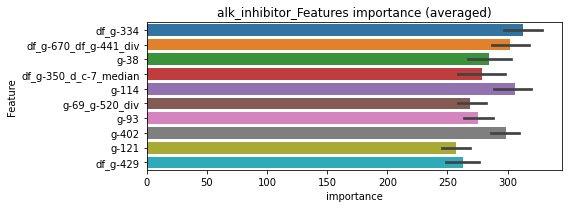

len(train_index) : 2827
len(valid_index) : 943
================================= fold 1/4 alk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107602	valid_1's binary_logloss: 0.163759
[200]	training's binary_logloss: 0.0370213	valid_1's binary_logloss: 0.0870733
[300]	training's binary_logloss: 0.0147502	valid_1's binary_logloss: 0.0572662
[400]	training's binary_logloss: 0.0065915	valid_1's binary_logloss: 0.0430714
[500]	training's binary_logloss: 0.00341663	valid_1's binary_logloss: 0.0360372
[600]	training's binary_logloss: 0.002068	valid_1's binary_logloss: 0.0329755
[700]	training's binary_logloss: 0.00142871	valid_1's binary_logloss: 0.0309206
[800]	training's binary_logloss: 0.00108233	valid_1's binary_logloss: 0.0299292
[900]	training's binary_logloss: 0.000887286	valid_1's binary_logloss: 0.0290623
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.000873654	valid_1's binary_logloss: 0.0289934


len(train_index) : 2827
len(valid_index) : 943
================================= fold 2/4 alk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106674	valid_1's binary_logloss: 0.15114
[200]	training's binary_logloss: 0.0368143	valid_1's binary_logloss: 0.0775318
[300]	training's binary_logloss: 0.0148341	valid_1's binary_logloss: 0.0489724
[400]	training's binary_logloss: 0.00662451	valid_1's binary_logloss: 0.0358702
[500]	training's binary_logloss: 0.0034776	valid_1's binary_logloss: 0.0305276
[600]	training's binary_logloss: 0.00211057	valid_1's binary_logloss: 0.0273974
[700]	training's binary_logloss: 0.00146243	valid_1's binary_logloss: 0.025341
[800]	training's binary_logloss: 0.00110691	valid_1's binary_logloss: 0.0242132
Early stopping, best iteration is:
[861]	training's binary_logloss: 0.000969274	valid_1's binary_logloss: 0.0237752


len(train_index) : 2828
len(valid_index) : 942
================================= fold 3/4 alk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107332	valid_1's binary_logloss: 0.157575
[200]	training's binary_logloss: 0.0372944	valid_1's binary_logloss: 0.0816493
[300]	training's binary_logloss: 0.0149917	valid_1's binary_logloss: 0.0510487
[400]	training's binary_logloss: 0.00669918	valid_1's binary_logloss: 0.0368319
[500]	training's binary_logloss: 0.00342282	valid_1's binary_logloss: 0.029046
[600]	training's binary_logloss: 0.00207647	valid_1's binary_logloss: 0.0259894
[700]	training's binary_logloss: 0.00144244	valid_1's binary_logloss: 0.0243156
[800]	training's binary_logloss: 0.00110422	valid_1's binary_logloss: 0.0228558
[900]	training's binary_logloss: 0.000901887	valid_1's binary_logloss: 0.0220871
[1000]	training's binary_logloss: 0.000788105	valid_1's binary_logloss: 0.0218699
Early stopping, best iteration is:
[1046]	training's binary_logloss: 0.000760526	valid_1's binary_logloss: 0.0215632


len(train_index) : 2828
len(valid_index) : 942
================================= fold 4/4 alk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106702	valid_1's binary_logloss: 0.143162
[200]	training's binary_logloss: 0.0364254	valid_1's binary_logloss: 0.0720369
[300]	training's binary_logloss: 0.0143096	valid_1's binary_logloss: 0.0437723
[400]	training's binary_logloss: 0.00638738	valid_1's binary_logloss: 0.0313931
[500]	training's binary_logloss: 0.00326407	valid_1's binary_logloss: 0.0247364
[600]	training's binary_logloss: 0.00200352	valid_1's binary_logloss: 0.0216361
[700]	training's binary_logloss: 0.00139948	valid_1's binary_logloss: 0.0199932
[800]	training's binary_logloss: 0.00107586	valid_1's binary_logloss: 0.0190734
[900]	training's binary_logloss: 0.000876783	valid_1's binary_logloss: 0.0185149
[1000]	training's binary_logloss: 0.000765765	valid_1's binary_logloss: 0.0182236
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.000747923	valid_1's binary_logloss: 0.0181022


alk_inhibitor logloss: 0.023110211567860417


neg labels: 3289 → selected neg labels: 3289


ampk_activator, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.061342	valid_1's binary_logloss: 0.0694541
[200]	training's binary_logloss: 0.014157	valid_1's binary_logloss: 0.0217838
[300]	training's binary_logloss: 0.00397782	valid_1's binary_logloss: 0.0100652
[400]	training's binary_logloss: 0.00151654	valid_1's binary_logloss: 0.00649688
[500]	training's binary_logloss: 0.000802963	valid_1's binary_logloss: 0.00492475
[600]	training's binary_logloss: 0.000536953	valid_1's binary_logloss: 0.00419817
[700]	training's binary_logloss: 0.000410107	valid_1's binary_logloss: 0.00381629
[800]	training's binary_logloss: 0.000352634	valid_1's binary_logloss: 0.00363375
[900]	training's binary_logloss: 0.000335836	valid_1's binary_logloss: 0.00356031
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000335843	valid_1's binary_logloss: 0.00356025
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0024450, Threshold: 0.0193495, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.01354, conf_1:0.02515
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0193495
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_2: 0.0493495
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_3: 0.0793495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.1093495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.1393495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_6: 0.1693495
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.1993495
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.2293495
threshold: 0.2293495, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0579947	valid_1's binary_logloss: 0.0660911
[200]	training's binary_logloss: 0.0119135	valid_1's binary_logloss: 0.0171215
[300]	training's binary_logloss: 0.00313404	valid_1's binary_logloss: 0.00676471
[400]	training's binary_logloss: 0.00122264	valid_1's binary_logloss: 0.00388008
[500]	training's binary_logloss: 0.000659523	valid_1's binary_logloss: 0.00282254
[600]	training's binary_logloss: 0.000445826	valid_1's binary_logloss: 0.00228587
[700]	training's binary_logloss: 0.000345738	valid_1's binary_logloss: 0.00203793
[800]	training's binary_logloss: 0.000302629	valid_1's binary_logloss: 0.00194226
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.000293891	valid_1's binary_logloss: 0.00192141
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0590103	valid_1's binary_logloss: 0.071884
[200]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0751954, Threshold: 0.2293495, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0045203 Vs.target_rate: 0.00050, Num_p_label: 18.0, conf_0:0.18348, conf_1:0.27522
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_1: 0.2293495
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_2: 0.2593495
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.2893495
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.3193495
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_5: 0.3493495
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_6: 0.3793495
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.4093495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_8: 0.4393495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_9: 0.4693495
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_10: 0.4993495
threshold: 0.5293495, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0579947	valid_1's binary_logloss: 0.0660911
[200]	training's binary_logloss: 0.0119135	valid_1's binary_logloss: 0.0171215
[300]	training's binary_logloss: 0.00313404	valid_1's binary_logloss: 0.00676471
[400]	training's binary_logloss: 0.00122264	valid_1's binary_logloss: 0.00388008
[500]	training's binary_logloss: 0.000659523	valid_1's binary_logloss: 0.00282254
[600]	training's binary_logloss: 0.000445826	valid_1's binary_logloss: 0.00228587
[700]	training's binary_logloss: 0.000345738	valid_1's binary_logloss: 0.00203793
[800]	training's binary_logloss: 0.000302629	valid_1's binary_logloss: 0.00194226
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.000293891	valid_1's binary_logloss: 0.00192141
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0590103	valid_1's binary_logloss: 0.071884
[200]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0751954, Threshold: 0.5293495, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.47641, conf_1:0.58228
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.5293495
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.5593495
threshold: 0.5593495, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


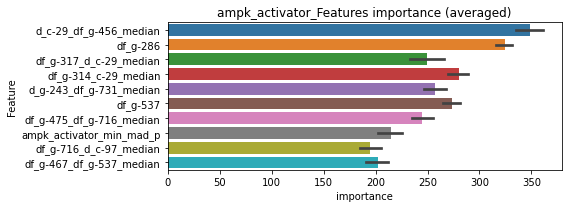

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 ampk_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0576187	valid_1's binary_logloss: 0.0653116
[200]	training's binary_logloss: 0.0119277	valid_1's binary_logloss: 0.0171439
[300]	training's binary_logloss: 0.00315707	valid_1's binary_logloss: 0.00655846
[400]	training's binary_logloss: 0.00121435	valid_1's binary_logloss: 0.00367571
[500]	training's binary_logloss: 0.000658613	valid_1's binary_logloss: 0.00267364
[600]	training's binary_logloss: 0.000446219	valid_1's binary_logloss: 0.00222324
[700]	training's binary_logloss: 0.000347301	valid_1's binary_logloss: 0.00199173
[800]	training's binary_logloss: 0.000305576	valid_1's binary_logloss: 0.0018815
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.00030357	valid_1's binary_logloss: 0.0018751


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 ampk_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0582667	valid_1's binary_logloss: 0.0691479
[200]	training's binary_logloss: 0.0120067	valid_1's binary_logloss: 0.0190441
[300]	training's binary_logloss: 0.00318839	valid_1's binary_logloss: 0.00796693
[400]	training's binary_logloss: 0.00123517	valid_1's binary_logloss: 0.00491634
[500]	training's binary_logloss: 0.000666774	valid_1's binary_logloss: 0.0038055
[600]	training's binary_logloss: 0.00045177	valid_1's binary_logloss: 0.00332365
[700]	training's binary_logloss: 0.000352622	valid_1's binary_logloss: 0.00312522
[800]	training's binary_logloss: 0.000306703	valid_1's binary_logloss: 0.00302681
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.000303262	valid_1's binary_logloss: 0.00302015


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 ampk_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0581816	valid_1's binary_logloss: 0.0654463
[200]	training's binary_logloss: 0.0121069	valid_1's binary_logloss: 0.0153891
[300]	training's binary_logloss: 0.00323865	valid_1's binary_logloss: 0.00470293
[400]	training's binary_logloss: 0.00124755	valid_1's binary_logloss: 0.00206268
[500]	training's binary_logloss: 0.000674014	valid_1's binary_logloss: 0.00122729
[600]	training's binary_logloss: 0.000454911	valid_1's binary_logloss: 0.000891317
[700]	training's binary_logloss: 0.000351643	valid_1's binary_logloss: 0.000713589
[800]	training's binary_logloss: 0.000303953	valid_1's binary_logloss: 0.000629907
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.000303953	valid_1's binary_logloss: 0.000629907


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 ampk_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0579718	valid_1's binary_logloss: 0.0652903
[200]	training's binary_logloss: 0.0119735	valid_1's binary_logloss: 0.0172639
[300]	training's binary_logloss: 0.00318456	valid_1's binary_logloss: 0.00679422
[400]	training's binary_logloss: 0.00122185	valid_1's binary_logloss: 0.00359819
[500]	training's binary_logloss: 0.000663747	valid_1's binary_logloss: 0.00248843
[600]	training's binary_logloss: 0.000450752	valid_1's binary_logloss: 0.00199741
[700]	training's binary_logloss: 0.000352843	valid_1's binary_logloss: 0.00172478
[800]	training's binary_logloss: 0.000307757	valid_1's binary_logloss: 0.00159223
[900]	training's binary_logloss: 0.000295619	valid_1's binary_logloss: 0.00155178
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.000295619	valid_1's binary_logloss: 0.00155178


ampk_activator logloss: 0.0017692632826024743
analgesic, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0654607	valid_1's binary_logloss: 0.0765732
[200]	training's binary_logloss: 0.0154389	valid_1's binary_logloss: 0.0219889
[300]	training's binary_logloss: 0.00436543	valid_1's binary_logloss: 0.00794552
[400]	training's binary_logloss: 0.00170579	valid_1's binary_logloss: 0.00407317
[500]	training's binary_logloss: 0.000915991	valid_1's binary_logloss: 0.00269752
[600]	training's binary_logloss: 0.000608766	valid_1's binary_logloss: 0.00211124
[700]	training's binary_logloss: 0.000465922	valid_1's binary_logloss: 0.00183189
[800]	training's binary_logloss: 0.000391837	valid_1's binary_logloss: 0.00166711
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.000374017	valid_1's binary_logloss: 0.00161224
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0654564	valid_1's binary_logloss: 0.0750149
[200]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0029341, Threshold: 0.0381488, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.02670, conf_1:0.04959
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0381488
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_2: 0.0681488
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_3: 0.0981488
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.1281488
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.1581488
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.1881488
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.2181488
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_8: 0.2481488
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.2781488
threshold: 0.2781488, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0625828	valid_1's binary_logloss: 0.0715399
[200]	training's binary_logloss: 0.0138536	valid_1's binary_logloss: 0.0196158
[300]	training's binary_logloss: 0.00377679	valid_1's binary_logloss: 0.0067805
[400]	training's binary_logloss: 0.0014581	valid_1's binary_logloss: 0.00336493
[500]	training's binary_logloss: 0.000778311	valid_1's binary_logloss: 0.00221443
[600]	training's binary_logloss: 0.000522005	valid_1's binary_logloss: 0.00169098
[700]	training's binary_logloss: 0.000401046	valid_1's binary_logloss: 0.00145919
[800]	training's binary_logloss: 0.000342241	valid_1's binary_logloss: 0.00133664
[900]	training's binary_logloss: 0.00032561	valid_1's binary_logloss: 0.00131477
Early stopping, best iteration is:
[876]	training's binary_logloss: 0.00032561	valid_1's binary_logloss: 0.00131477
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.2042407, Threshold: 0.2781488, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0052737 Vs.target_rate: 0.00050, Num_p_label: 21.0, conf_0:0.22252, conf_1:0.33378
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_1: 0.2781488
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_2: 0.3081488
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_3: 0.3381488
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.3681488
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.3981488
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.4281488
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.4581488
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_8: 0.4881488
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_9: 0.5181488
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_10: 0.5481488
threshold: 0.5781488, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0625828	valid_1's binary_logloss: 0.0715399
[200]	training's binary_logloss: 0.0138536	valid_1's binary_logloss: 0.0196158
[300]	training's binary_logloss: 0.00377679	valid_1's binary_logloss: 0.0067805
[400]	training's binary_logloss: 0.0014581	valid_1's binary_logloss: 0.00336493
[500]	training's binary_logloss: 0.000778311	valid_1's binary_logloss: 0.00221443
[600]	training's binary_logloss: 0.000522005	valid_1's binary_logloss: 0.00169098
[700]	training's binary_logloss: 0.000401046	valid_1's binary_logloss: 0.00145919
[800]	training's binary_logloss: 0.000342241	valid_1's binary_logloss: 0.00133664
[900]	training's binary_logloss: 0.00032561	valid_1's binary_logloss: 0.00131477
Early stopping, best iteration is:
[876]	training's binary_logloss: 0.00032561	valid_1's binary_logloss: 0.00131477
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.2042407, Threshold: 0.5781488, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.50000, conf_1:0.63596
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.5781488
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.6081488
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.6381488
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.6681488
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.6981488
threshold: 0.6981488, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


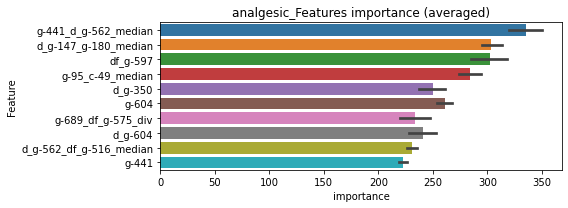

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 analgesic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0628327	valid_1's binary_logloss: 0.0728257
[200]	training's binary_logloss: 0.013818	valid_1's binary_logloss: 0.0198073
[300]	training's binary_logloss: 0.00374213	valid_1's binary_logloss: 0.00717828
[400]	training's binary_logloss: 0.00144305	valid_1's binary_logloss: 0.0036388
[500]	training's binary_logloss: 0.000773069	valid_1's binary_logloss: 0.0023767
[600]	training's binary_logloss: 0.000516737	valid_1's binary_logloss: 0.00191715
[700]	training's binary_logloss: 0.000396925	valid_1's binary_logloss: 0.0016977
[800]	training's binary_logloss: 0.000340591	valid_1's binary_logloss: 0.00158745
Early stopping, best iteration is:
[837]	training's binary_logloss: 0.000331202	valid_1's binary_logloss: 0.00156711


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 analgesic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0629649	valid_1's binary_logloss: 0.0738654
[200]	training's binary_logloss: 0.0137367	valid_1's binary_logloss: 0.0191397
[300]	training's binary_logloss: 0.00375955	valid_1's binary_logloss: 0.00647571
[400]	training's binary_logloss: 0.00146192	valid_1's binary_logloss: 0.00302095
[500]	training's binary_logloss: 0.000780092	valid_1's binary_logloss: 0.00184857
[600]	training's binary_logloss: 0.000517373	valid_1's binary_logloss: 0.00139597
[700]	training's binary_logloss: 0.000397065	valid_1's binary_logloss: 0.00118792
[800]	training's binary_logloss: 0.000343197	valid_1's binary_logloss: 0.00109743
[900]	training's binary_logloss: 0.000325761	valid_1's binary_logloss: 0.00106592
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.000324835	valid_1's binary_logloss: 0.00106466


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 analgesic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0625411	valid_1's binary_logloss: 0.0695011
[200]	training's binary_logloss: 0.0139436	valid_1's binary_logloss: 0.0172105
[300]	training's binary_logloss: 0.00384567	valid_1's binary_logloss: 0.00533222
[400]	training's binary_logloss: 0.00147816	valid_1's binary_logloss: 0.00228597
[500]	training's binary_logloss: 0.000785187	valid_1's binary_logloss: 0.00132325
[600]	training's binary_logloss: 0.000522981	valid_1's binary_logloss: 0.000936484
[700]	training's binary_logloss: 0.000401511	valid_1's binary_logloss: 0.000754843
[800]	training's binary_logloss: 0.000343759	valid_1's binary_logloss: 0.000661221
[900]	training's binary_logloss: 0.000325226	valid_1's binary_logloss: 0.000633817
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.000323633	valid_1's binary_logloss: 0.000630986


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 analgesic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0621493	valid_1's binary_logloss: 0.0720961
[200]	training's binary_logloss: 0.0134986	valid_1's binary_logloss: 0.0190745
[300]	training's binary_logloss: 0.0036903	valid_1's binary_logloss: 0.00664272
[400]	training's binary_logloss: 0.0014349	valid_1's binary_logloss: 0.00311096
[500]	training's binary_logloss: 0.000774035	valid_1's binary_logloss: 0.00195561
[600]	training's binary_logloss: 0.000516998	valid_1's binary_logloss: 0.00144429
[700]	training's binary_logloss: 0.000399534	valid_1's binary_logloss: 0.00121135
[800]	training's binary_logloss: 0.000342778	valid_1's binary_logloss: 0.00110394
[900]	training's binary_logloss: 0.000328104	valid_1's binary_logloss: 0.00107358
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.00032862	valid_1's binary_logloss: 0.00107246


analgesic logloss: 0.0010843589602910176
androgen_receptor_agonist, len(trt): 48, len(othr): 3282, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108549	valid_1's binary_logloss: 0.1662
[200]	training's binary_logloss: 0.0409203	valid_1's binary_logloss: 0.0922346
[300]	training's binary_logloss: 0.0177082	valid_1's binary_logloss: 0.0608156
[400]	training's binary_logloss: 0.00828915	valid_1's binary_logloss: 0.0443782
[500]	training's binary_logloss: 0.00419999	valid_1's binary_logloss: 0.0349745
[600]	training's binary_logloss: 0.00246666	valid_1's binary_logloss: 0.0299494
[700]	training's binary_logloss: 0.00165733	valid_1's binary_logloss: 0.0271631
[800]	training's binary_logloss: 0.00125405	valid_1's binary_logloss: 0.0255121
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.0011813	valid_1's binary_logloss: 0.0252348
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107351	valid_1's binary_logloss: 0.16381
[200]	training's binary_logloss: 0.0430256	valid_1's bi

1 / 3 AUC score:0.996
y_Threshold: 0.0174398, Threshold: 0.0967893, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3794
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.06775, conf_1:0.12583
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0967893
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.1267893
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_3: 0.1567893
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_4: 0.1867893
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_5: 0.2167893
threshold: 0.2167893, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 650.0/3794, y_label_rate: 0.1713231
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103737	valid_1's binary_logloss: 0.136496
[200]	training's binary_logloss: 0.0387544	valid_1's binary_logloss: 0.0688803
[300]	training's binary_logloss: 0.0158754	valid_1's binary_logloss: 0.0420318
[400]	training's binary_logloss: 0.00683544	valid_1's binary_logloss: 0.0294165
[500]	training's binary_logloss: 0.00346905	valid_1's binary_logloss: 0.0231732
[600]	training's binary_logloss: 0.00207481	valid_1's binary_logloss: 0.0200034
[700]	training's binary_logloss: 0.00142853	valid_1's binary_logloss: 0.018742
[800]	training's binary_logloss: 0.00108485	valid_1's binary_logloss: 0.0176746
[900]	training's binary_logloss: 0.000894585	valid_1's binary_logloss: 0.0171512
Early stopping, best iteration is:
[931]	training's binary_logloss: 0.000859568	valid_1's binary_logloss: 0.0169345
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104332	valid

2 / 3 AUC score:0.998
y_Threshold: 0.0889894, Threshold: 0.2167893, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 637.0/3768
p_label_rate: 0.0183325 Vs.target_rate: 0.00202, Num_p_label: 73.0, conf_0:0.17343, conf_1:0.26015
Num_p_label: 73.0, Expected: 8.0, Adj_threshold_1: 0.2167893
Num_p_label: 73.0, Expected: 8.0, Adj_threshold_2: 0.2467893
Num_p_label: 70.0, Expected: 8.0, Adj_threshold_3: 0.2767893
Num_p_label: 64.0, Expected: 8.0, Adj_threshold_4: 0.3067893
Num_p_label: 58.0, Expected: 8.0, Adj_threshold_5: 0.3367893
Num_p_label: 57.0, Expected: 8.0, Adj_threshold_6: 0.3667893
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_7: 0.3967893
Num_p_label: 48.0, Expected: 8.0, Adj_threshold_8: 0.4267893
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_9: 0.4567893
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_10: 0.4867893
threshold: 0.5167893, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 637.0/3768, y_label_rate: 0.1690552
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970687	valid_1's binary_logloss: 0.143093
[200]	training's binary_logloss: 0.0327076	valid_1's binary_logloss: 0.0729314
[300]	training's binary_logloss: 0.0133385	valid_1's binary_logloss: 0.0480634
[400]	training's binary_logloss: 0.00590166	valid_1's binary_logloss: 0.0359652
[500]	training's binary_logloss: 0.00299904	valid_1's binary_logloss: 0.0293444
[600]	training's binary_logloss: 0.00181971	valid_1's binary_logloss: 0.0268962
[700]	training's binary_logloss: 0.00125631	valid_1's binary_logloss: 0.025462
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.00117319	valid_1's binary_logloss: 0.0251033
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975686	valid_1's binary_logloss: 0.131574
[200]	training's binary_logloss: 0.0336423	valid_1's binary_logloss: 0.0669297
[300]	training's binary_logloss: 0.0138923	valid_1'

3 / 3 AUC score:0.999
y_Threshold: 0.1000393, Threshold: 0.5167893, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 627.0/3748
p_label_rate: 0.0135610 Vs.target_rate: 0.00202, Num_p_label: 54.0, conf_0:0.46511, conf_1:0.56847
Num_p_label: 54.0, Expected: 8.0, Adj_threshold_1: 0.5167893
Num_p_label: 48.0, Expected: 8.0, Adj_threshold_2: 0.5467893
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_3: 0.5767893
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_4: 0.6067893
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_5: 0.6367893
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_6: 0.6667893
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_7: 0.6967893
threshold: 0.6967893, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 627.0/3748, y_label_rate: 0.1672892


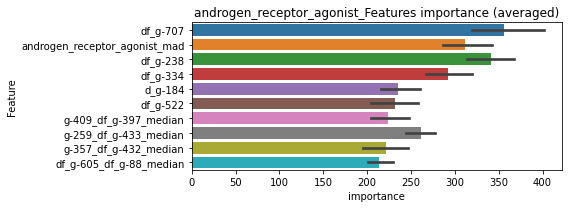

len(train_index) : 2811
len(valid_index) : 937
================================= fold 1/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0945561	valid_1's binary_logloss: 0.120378
[200]	training's binary_logloss: 0.0325693	valid_1's binary_logloss: 0.0585426
[300]	training's binary_logloss: 0.0128322	valid_1's binary_logloss: 0.0341884
[400]	training's binary_logloss: 0.00555986	valid_1's binary_logloss: 0.0235406
[500]	training's binary_logloss: 0.0028281	valid_1's binary_logloss: 0.0178172
[600]	training's binary_logloss: 0.00172323	valid_1's binary_logloss: 0.0152531
[700]	training's binary_logloss: 0.00120046	valid_1's binary_logloss: 0.0139258
[800]	training's binary_logloss: 0.000935968	valid_1's binary_logloss: 0.0132687
[900]	training's binary_logloss: 0.000785925	valid_1's binary_logloss: 0.0127619
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000746233	valid_1's binary_logloss: 0.0126689


len(train_index) : 2811
len(valid_index) : 937
================================= fold 2/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0917959	valid_1's binary_logloss: 0.144941
[200]	training's binary_logloss: 0.0313247	valid_1's binary_logloss: 0.0792136
[300]	training's binary_logloss: 0.0122876	valid_1's binary_logloss: 0.0532061
[400]	training's binary_logloss: 0.00531764	valid_1's binary_logloss: 0.0412846
[500]	training's binary_logloss: 0.0027295	valid_1's binary_logloss: 0.0344312
[600]	training's binary_logloss: 0.00166462	valid_1's binary_logloss: 0.03186
[700]	training's binary_logloss: 0.00116997	valid_1's binary_logloss: 0.0307088
Early stopping, best iteration is:
[686]	training's binary_logloss: 0.00122143	valid_1's binary_logloss: 0.0305843


len(train_index) : 2811
len(valid_index) : 937
================================= fold 3/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0952278	valid_1's binary_logloss: 0.129439
[200]	training's binary_logloss: 0.0327731	valid_1's binary_logloss: 0.0614054
[300]	training's binary_logloss: 0.0126512	valid_1's binary_logloss: 0.0344114
[400]	training's binary_logloss: 0.00548921	valid_1's binary_logloss: 0.0231682
[500]	training's binary_logloss: 0.00281032	valid_1's binary_logloss: 0.0181781
[600]	training's binary_logloss: 0.00173857	valid_1's binary_logloss: 0.0160105
[700]	training's binary_logloss: 0.00121178	valid_1's binary_logloss: 0.0148382
[800]	training's binary_logloss: 0.000936359	valid_1's binary_logloss: 0.0143019
[900]	training's binary_logloss: 0.000784335	valid_1's binary_logloss: 0.0138812
[1000]	training's binary_logloss: 0.000707432	valid_1's binary_logloss: 0.013693
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000711646	valid_1's binary_logloss: 0.0136582


len(train_index) : 2811
len(valid_index) : 937
================================= fold 4/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0940529	valid_1's binary_logloss: 0.141213
[200]	training's binary_logloss: 0.0326189	valid_1's binary_logloss: 0.0708117
[300]	training's binary_logloss: 0.0126856	valid_1's binary_logloss: 0.0405812
[400]	training's binary_logloss: 0.00557003	valid_1's binary_logloss: 0.0270521
[500]	training's binary_logloss: 0.00284007	valid_1's binary_logloss: 0.0203241
[600]	training's binary_logloss: 0.00173486	valid_1's binary_logloss: 0.0169223
[700]	training's binary_logloss: 0.00120932	valid_1's binary_logloss: 0.0151298
[800]	training's binary_logloss: 0.000937046	valid_1's binary_logloss: 0.0143327
[900]	training's binary_logloss: 0.000783408	valid_1's binary_logloss: 0.0136346
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000781686	valid_1's binary_logloss: 0.0136175


androgen_receptor_agonist logloss: 0.017632227590180693
androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145689	valid_1's binary_logloss: 0.25579
[200]	training's binary_logloss: 0.0683458	valid_1's binary_logloss: 0.197794
[300]	training's binary_logloss: 0.0353723	valid_1's binary_logloss: 0.168814
[400]	training's binary_logloss: 0.0187208	valid_1's binary_logloss: 0.155524
[500]	training's binary_logloss: 0.01004	valid_1's binary_logloss: 0.146822
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00851824	valid_1's binary_logloss: 0.145366
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148475	valid_1's binary_logloss: 0.216768
[200]	training's binary_logloss: 0.0677983	valid_1's binary_logloss: 0.145277
[300]	training's binary_logloss: 0.0353147	valid_1's binary_logloss: 0.111669
[400]	training's binary_logloss: 0.018945	valid_1's binary_logloss: 0.090976
[500]	training's binary_logloss: 0.010591	valid_1's binary_logloss: 

1 / 3 AUC score:0.989
y_Threshold: 0.0396822, Threshold: 0.2525795, pos_neg_ratio: 0.8000000
Remove_noisy_data: 192 → Positive_corect_labels: 624/3736
p_label_rate: 0.0100452 Vs.target_rate: 0.00374, Num_p_label: 40.0, conf_0:0.17681, conf_1:0.32835
threshold: 0.2525795, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 624.0/3736, y_label_rate: 0.1670236
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126774	valid_1's binary_logloss: 0.210433
[200]	training's binary_logloss: 0.0524935	valid_1's binary_logloss: 0.140539
[300]	training's binary_logloss: 0.0248969	valid_1's binary_logloss: 0.107641
[400]	training's binary_logloss: 0.0121254	valid_1's binary_logloss: 0.0883084
[500]	training's binary_logloss: 0.00639388	valid_1's binary_logloss: 0.078751
[600]	training's binary_logloss: 0.0037536	valid_1's binary_logloss: 0.0734755
[700]	training's binary_logloss: 0.00246041	valid_1's binary_logloss: 0.0704265
[800]	training's binary_logloss: 0.00178114	valid_1's binary_logloss: 0.0689721
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.00173456	valid_1's binary_logloss: 0.0686961
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129681	valid_1's binary_logloss: 0.202008
[200]	training's binary_logloss: 0.0562447	valid_1's bin

2 / 3 AUC score:0.999
y_Threshold: 0.1391385, Threshold: 0.2525795, pos_neg_ratio: 0.8000000
Remove_noisy_data: 54 → Positive_corect_labels: 597.0/3682
p_label_rate: 0.0273732 Vs.target_rate: 0.00374, Num_p_label: 109.0, conf_0:0.20206, conf_1:0.30310
Num_p_label: 109.0, Expected: 14.9, Adj_threshold_1: 0.2525795
Num_p_label: 105.0, Expected: 14.9, Adj_threshold_2: 0.2825795
Num_p_label: 96.0, Expected: 14.9, Adj_threshold_3: 0.3125795
Num_p_label: 87.0, Expected: 14.9, Adj_threshold_4: 0.3425795
Num_p_label: 85.0, Expected: 14.9, Adj_threshold_5: 0.3725795
Num_p_label: 71.0, Expected: 14.9, Adj_threshold_6: 0.4025795
Num_p_label: 66.0, Expected: 14.9, Adj_threshold_7: 0.4325795
Num_p_label: 60.0, Expected: 14.9, Adj_threshold_8: 0.4625795
Num_p_label: 58.0, Expected: 14.9, Adj_threshold_9: 0.4925795
Num_p_label: 56.0, Expected: 14.9, Adj_threshold_10: 0.5225795
threshold: 0.5525795, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 597.0/3682, y_label_rate: 0.1621

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117345	valid_1's binary_logloss: 0.19952
[200]	training's binary_logloss: 0.0478012	valid_1's binary_logloss: 0.129117
[300]	training's binary_logloss: 0.0212506	valid_1's binary_logloss: 0.0951934
[400]	training's binary_logloss: 0.0100807	valid_1's binary_logloss: 0.0756113
[500]	training's binary_logloss: 0.00524483	valid_1's binary_logloss: 0.0665494
[600]	training's binary_logloss: 0.0031267	valid_1's binary_logloss: 0.061798
[700]	training's binary_logloss: 0.00208392	valid_1's binary_logloss: 0.0585579
[800]	training's binary_logloss: 0.00153854	valid_1's binary_logloss: 0.0572962
[900]	training's binary_logloss: 0.00121684	valid_1's binary_logloss: 0.0559713
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.00123156	valid_1's binary_logloss: 0.0558837
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120906	valid_1's b

3 / 3 AUC score:0.996
y_Threshold: 0.1349398, Threshold: 0.5525795, pos_neg_ratio: 0.8000000
Remove_noisy_data: 40 → Positive_corect_labels: 577.0/3642
p_label_rate: 0.0208438 Vs.target_rate: 0.00374, Num_p_label: 83.0, conf_0:0.49732, conf_1:0.60784
Num_p_label: 83.0, Expected: 14.9, Adj_threshold_1: 0.5525795
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_2: 0.5825795
Num_p_label: 77.0, Expected: 14.9, Adj_threshold_3: 0.6125795
Num_p_label: 72.0, Expected: 14.9, Adj_threshold_4: 0.6425795
Num_p_label: 65.0, Expected: 14.9, Adj_threshold_5: 0.6725795
threshold: 0.6725795, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 577.0/3642, y_label_rate: 0.1584294


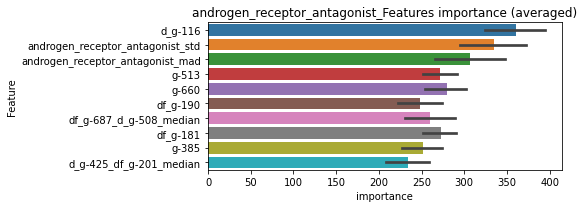

len(train_index) : 2731
len(valid_index) : 911
================================= fold 1/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108867	valid_1's binary_logloss: 0.176907
[200]	training's binary_logloss: 0.0410762	valid_1's binary_logloss: 0.108583
[300]	training's binary_logloss: 0.0173175	valid_1's binary_logloss: 0.0777377
[400]	training's binary_logloss: 0.00799076	valid_1's binary_logloss: 0.0624537
[500]	training's binary_logloss: 0.00416488	valid_1's binary_logloss: 0.0552181
[600]	training's binary_logloss: 0.00252792	valid_1's binary_logloss: 0.0518168
[700]	training's binary_logloss: 0.0017491	valid_1's binary_logloss: 0.050195
[800]	training's binary_logloss: 0.00132241	valid_1's binary_logloss: 0.0490182
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.00132241	valid_1's binary_logloss: 0.0490182


len(train_index) : 2731
len(valid_index) : 911
================================= fold 2/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112583	valid_1's binary_logloss: 0.166654
[200]	training's binary_logloss: 0.0435752	valid_1's binary_logloss: 0.0979396
[300]	training's binary_logloss: 0.0188868	valid_1's binary_logloss: 0.0661902
[400]	training's binary_logloss: 0.00881205	valid_1's binary_logloss: 0.0490729
[500]	training's binary_logloss: 0.00446518	valid_1's binary_logloss: 0.0402518
[600]	training's binary_logloss: 0.00267925	valid_1's binary_logloss: 0.0358117
[700]	training's binary_logloss: 0.00180818	valid_1's binary_logloss: 0.0334927
[800]	training's binary_logloss: 0.00136056	valid_1's binary_logloss: 0.031371
[900]	training's binary_logloss: 0.00109613	valid_1's binary_logloss: 0.0300683
[1000]	training's binary_logloss: 0.000944488	valid_1's binary_logloss: 0.0296012
[1100]	training's binary_logloss: 0.000850241	valid_1's binary_logloss: 0.0292852
Early stopping, best iteration is:
[1092]	training's binary_l

len(train_index) : 2732
len(valid_index) : 910
================================= fold 3/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110716	valid_1's binary_logloss: 0.164351
[200]	training's binary_logloss: 0.0427996	valid_1's binary_logloss: 0.0993135
[300]	training's binary_logloss: 0.0180742	valid_1's binary_logloss: 0.0703148
[400]	training's binary_logloss: 0.00845366	valid_1's binary_logloss: 0.0548912
[500]	training's binary_logloss: 0.00446711	valid_1's binary_logloss: 0.0474116
[600]	training's binary_logloss: 0.00268546	valid_1's binary_logloss: 0.0438701
[700]	training's binary_logloss: 0.00182528	valid_1's binary_logloss: 0.0413961
[800]	training's binary_logloss: 0.00137119	valid_1's binary_logloss: 0.040224
[900]	training's binary_logloss: 0.00111262	valid_1's binary_logloss: 0.0391979
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.00104506	valid_1's binary_logloss: 0.0389688


len(train_index) : 2732
len(valid_index) : 910
================================= fold 4/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109768	valid_1's binary_logloss: 0.16542
[200]	training's binary_logloss: 0.0417174	valid_1's binary_logloss: 0.100526
[300]	training's binary_logloss: 0.0184368	valid_1's binary_logloss: 0.0746932
[400]	training's binary_logloss: 0.00840784	valid_1's binary_logloss: 0.0589948
[500]	training's binary_logloss: 0.00431802	valid_1's binary_logloss: 0.0502048
[600]	training's binary_logloss: 0.00259312	valid_1's binary_logloss: 0.0464036
[700]	training's binary_logloss: 0.00176734	valid_1's binary_logloss: 0.0443596
[800]	training's binary_logloss: 0.00133503	valid_1's binary_logloss: 0.0431435
[900]	training's binary_logloss: 0.00107218	valid_1's binary_logloss: 0.0421859
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00106109	valid_1's binary_logloss: 0.0421481


androgen_receptor_antagonist logloss: 0.03982575683403269
anesthetic_-_local, len(trt): 80, len(othr): 3273, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133438	valid_1's binary_logloss: 0.21363
[200]	training's binary_logloss: 0.0594319	valid_1's binary_logloss: 0.154911
[300]	training's binary_logloss: 0.0287909	valid_1's binary_logloss: 0.126113
[400]	training's binary_logloss: 0.0148003	valid_1's binary_logloss: 0.111785
[500]	training's binary_logloss: 0.00799801	valid_1's binary_logloss: 0.106588
[600]	training's binary_logloss: 0.00459929	valid_1's binary_logloss: 0.103237
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00363733	valid_1's binary_logloss: 0.102948
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138795	valid_1's binary_logloss: 0.201678
[200]	training's binary_logloss: 0.061058	valid_1's binary_logloss: 0.132279
[300]	training's binary_logloss: 0.0296572	valid_1's binary_logloss: 0.0983246
[400]	training's binary_logloss: 0.0153135	valid_1's binary_log

1 / 3 AUC score:0.992
y_Threshold: 0.0301793, Threshold: 0.1646771, pos_neg_ratio: 0.8000000
Remove_noisy_data: 176 → Positive_corect_labels: 632/3751
p_label_rate: 0.0100452 Vs.target_rate: 0.00336, Num_p_label: 40.0, conf_0:0.11527, conf_1:0.21408
threshold: 0.1646771, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 632.0/3751, y_label_rate: 0.1684884
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120283	valid_1's binary_logloss: 0.199222
[200]	training's binary_logloss: 0.048383	valid_1's binary_logloss: 0.131972
[300]	training's binary_logloss: 0.0227041	valid_1's binary_logloss: 0.103843
[400]	training's binary_logloss: 0.0106661	valid_1's binary_logloss: 0.0876329
[500]	training's binary_logloss: 0.00562582	valid_1's binary_logloss: 0.0793613
[600]	training's binary_logloss: 0.00326907	valid_1's binary_logloss: 0.0749601
[700]	training's binary_logloss: 0.0021602	valid_1's binary_logloss: 0.0735243
Early stopping, best iteration is:
[761]	training's binary_logloss: 0.00176589	valid_1's binary_logloss: 0.0723366
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12555	valid_1's binary_logloss: 0.177355
[200]	training's binary_logloss: 0.052337	valid_1's binary_logloss: 0.109716
[300]	training's binary_logloss: 0.0240884	valid_1's binary_

2 / 3 AUC score:0.996
y_Threshold: 0.0766918, Threshold: 0.1646771, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 604.0/3695
p_label_rate: 0.0296334 Vs.target_rate: 0.00336, Num_p_label: 118.0, conf_0:0.13174, conf_1:0.19761
Num_p_label: 118.0, Expected: 13.4, Adj_threshold_1: 0.1646771
Num_p_label: 109.0, Expected: 13.4, Adj_threshold_2: 0.1946771
Num_p_label: 104.0, Expected: 13.4, Adj_threshold_3: 0.2246771
Num_p_label: 97.0, Expected: 13.4, Adj_threshold_4: 0.2546771
Num_p_label: 93.0, Expected: 13.4, Adj_threshold_5: 0.2846771
Num_p_label: 89.0, Expected: 13.4, Adj_threshold_6: 0.3146771
Num_p_label: 83.0, Expected: 13.4, Adj_threshold_7: 0.3446771
Num_p_label: 81.0, Expected: 13.4, Adj_threshold_8: 0.3746771
Num_p_label: 75.0, Expected: 13.4, Adj_threshold_9: 0.4046771
Num_p_label: 72.0, Expected: 13.4, Adj_threshold_10: 0.4346771
threshold: 0.4646771, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 604.0/3695, y_label_rate: 0.163

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110037	valid_1's binary_logloss: 0.172145
[200]	training's binary_logloss: 0.0417936	valid_1's binary_logloss: 0.108767
[300]	training's binary_logloss: 0.0180652	valid_1's binary_logloss: 0.0809569
[400]	training's binary_logloss: 0.00832641	valid_1's binary_logloss: 0.0654485
[500]	training's binary_logloss: 0.00439567	valid_1's binary_logloss: 0.0573379
[600]	training's binary_logloss: 0.00263884	valid_1's binary_logloss: 0.0521592
[700]	training's binary_logloss: 0.00178233	valid_1's binary_logloss: 0.0496353
[800]	training's binary_logloss: 0.00133483	valid_1's binary_logloss: 0.047908
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.00128386	valid_1's binary_logloss: 0.0476822
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108	valid_1's binary_logloss: 0.167991
[200]	training's binary_logloss: 0.0417608	valid_1's bin

3 / 3 AUC score:0.998
y_Threshold: 0.0818319, Threshold: 0.4646771, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 588.0/3663
p_label_rate: 0.0248619 Vs.target_rate: 0.00336, Num_p_label: 99.0, conf_0:0.41821, conf_1:0.51114
Num_p_label: 99.0, Expected: 13.4, Adj_threshold_1: 0.4646771
Num_p_label: 99.0, Expected: 13.4, Adj_threshold_2: 0.4946771
Num_p_label: 98.0, Expected: 13.4, Adj_threshold_3: 0.5246771
Num_p_label: 96.0, Expected: 13.4, Adj_threshold_4: 0.5546771
Num_p_label: 94.0, Expected: 13.4, Adj_threshold_5: 0.5846771
Num_p_label: 93.0, Expected: 13.4, Adj_threshold_6: 0.6146771
Num_p_label: 92.0, Expected: 13.4, Adj_threshold_7: 0.6446771
Num_p_label: 89.0, Expected: 13.4, Adj_threshold_8: 0.6746771
threshold: 0.6746771, positive_p_label: 89.0/3982, p_label_rate: 0.0223506
positive_y_label: 588.0/3663, y_label_rate: 0.1605242


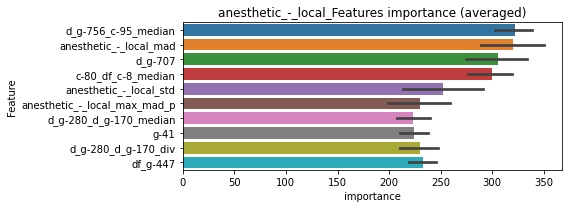

len(train_index) : 2747
len(valid_index) : 916
================================= fold 1/4 anesthetic_-_local=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109552	valid_1's binary_logloss: 0.142687
[200]	training's binary_logloss: 0.0409822	valid_1's binary_logloss: 0.074894
[300]	training's binary_logloss: 0.0178622	valid_1's binary_logloss: 0.0471999
[400]	training's binary_logloss: 0.00821232	valid_1's binary_logloss: 0.0343336
[500]	training's binary_logloss: 0.0043085	valid_1's binary_logloss: 0.0282703
[600]	training's binary_logloss: 0.00255501	valid_1's binary_logloss: 0.024925
[700]	training's binary_logloss: 0.0017317	valid_1's binary_logloss: 0.0229915
[800]	training's binary_logloss: 0.00129287	valid_1's binary_logloss: 0.02191
[900]	training's binary_logloss: 0.00105409	valid_1's binary_logloss: 0.0212247
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.00101019	valid_1's binary_logloss: 0.0209878


len(train_index) : 2747
len(valid_index) : 916
================================= fold 2/4 anesthetic_-_local=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105354	valid_1's binary_logloss: 0.150711
[200]	training's binary_logloss: 0.039279	valid_1's binary_logloss: 0.087036
[300]	training's binary_logloss: 0.0173998	valid_1's binary_logloss: 0.0620846
[400]	training's binary_logloss: 0.00818961	valid_1's binary_logloss: 0.0491804
[500]	training's binary_logloss: 0.00421524	valid_1's binary_logloss: 0.0422878
[600]	training's binary_logloss: 0.00248822	valid_1's binary_logloss: 0.0381104
[700]	training's binary_logloss: 0.00169317	valid_1's binary_logloss: 0.0355256
[800]	training's binary_logloss: 0.00126697	valid_1's binary_logloss: 0.0343034
[900]	training's binary_logloss: 0.0010309	valid_1's binary_logloss: 0.0335432
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.00101386	valid_1's binary_logloss: 0.0334665


len(train_index) : 2747
len(valid_index) : 916
================================= fold 3/4 anesthetic_-_local=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105169	valid_1's binary_logloss: 0.164408
[200]	training's binary_logloss: 0.0387526	valid_1's binary_logloss: 0.0995689
[300]	training's binary_logloss: 0.0161239	valid_1's binary_logloss: 0.0744576
[400]	training's binary_logloss: 0.00734141	valid_1's binary_logloss: 0.0617789
[500]	training's binary_logloss: 0.00386228	valid_1's binary_logloss: 0.0545347
[600]	training's binary_logloss: 0.00234044	valid_1's binary_logloss: 0.0512503
[700]	training's binary_logloss: 0.00159737	valid_1's binary_logloss: 0.0489454
[800]	training's binary_logloss: 0.00120683	valid_1's binary_logloss: 0.0477832
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00126778	valid_1's binary_logloss: 0.0477394


len(train_index) : 2748
len(valid_index) : 915
================================= fold 4/4 anesthetic_-_local=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105514	valid_1's binary_logloss: 0.156685
[200]	training's binary_logloss: 0.0389299	valid_1's binary_logloss: 0.0970249
[300]	training's binary_logloss: 0.0163296	valid_1's binary_logloss: 0.0724574
[400]	training's binary_logloss: 0.00736442	valid_1's binary_logloss: 0.0611352
[500]	training's binary_logloss: 0.00378727	valid_1's binary_logloss: 0.0539302
[600]	training's binary_logloss: 0.00227923	valid_1's binary_logloss: 0.0503634
[700]	training's binary_logloss: 0.00156396	valid_1's binary_logloss: 0.0488937
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.00129369	valid_1's binary_logloss: 0.0479771


anesthetic_-_local logloss: 0.03753984432507018


neg labels: 3289 → selected neg labels: 3282


angiogenesis_inhibitor, len(trt): 36, len(othr): 3282, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102043	valid_1's binary_logloss: 0.138008
[200]	training's binary_logloss: 0.0344158	valid_1's binary_logloss: 0.0654492
[300]	training's binary_logloss: 0.013252	valid_1's binary_logloss: 0.0376367
[400]	training's binary_logloss: 0.00559542	valid_1's binary_logloss: 0.0247538
[500]	training's binary_logloss: 0.00282898	valid_1's binary_logloss: 0.0185983
[600]	training's binary_logloss: 0.00171138	valid_1's binary_logloss: 0.0151277
[700]	training's binary_logloss: 0.00118593	valid_1's binary_logloss: 0.0132259
[800]	training's binary_logloss: 0.000915273	valid_1's binary_logloss: 0.0122326
[900]	training's binary_logloss: 0.00075096	valid_1's binary_logloss: 0.0114891
[1000]	training's binary_logloss: 0.00065682	valid_1's binary_logloss: 0.0110448
Early stopping, best iteration is:
[1013]	training's binary_logloss: 0.00065411	valid_1's binary_logloss: 0.0110285
Training until validation s

1 / 3 AUC score:1.000
y_Threshold: 0.0110031, Threshold: 0.0455059, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.03185, conf_1:0.05916
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0455059
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.0755059
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.1055059
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_4: 0.1355059
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_5: 0.1655059
threshold: 0.1655059, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955547	valid_1's binary_logloss: 0.132301
[200]	training's binary_logloss: 0.0304826	valid_1's binary_logloss: 0.0608084
[300]	training's binary_logloss: 0.0108817	valid_1's binary_logloss: 0.0324084
[400]	training's binary_logloss: 0.00457019	valid_1's binary_logloss: 0.0212282
[500]	training's binary_logloss: 0.0023431	valid_1's binary_logloss: 0.0168908
[600]	training's binary_logloss: 0.00143869	valid_1's binary_logloss: 0.014342
[700]	training's binary_logloss: 0.00101467	valid_1's binary_logloss: 0.0132603
[800]	training's binary_logloss: 0.000785611	valid_1's binary_logloss: 0.0124817
[900]	training's binary_logloss: 0.000653409	valid_1's binary_logloss: 0.0119896
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.000622981	valid_1's binary_logloss: 0.0119651
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957626	val

2 / 3 AUC score:1.000
y_Threshold: 0.0929400, Threshold: 0.1655059, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0092918 Vs.target_rate: 0.00151, Num_p_label: 37.0, conf_0:0.13240, conf_1:0.19861
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_1: 0.1655059
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_2: 0.1955059
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_3: 0.2255059
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_4: 0.2555059
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_5: 0.2855059
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_6: 0.3155059
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_7: 0.3455059
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_8: 0.3755059
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_9: 0.4055059
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_10: 0.4355059
threshold: 0.4355059, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0941282	valid_1's binary_logloss: 0.132883
[200]	training's binary_logloss: 0.0299478	valid_1's binary_logloss: 0.062822
[300]	training's binary_logloss: 0.010709	valid_1's binary_logloss: 0.0377663
[400]	training's binary_logloss: 0.00446188	valid_1's binary_logloss: 0.0270013
[500]	training's binary_logloss: 0.0022898	valid_1's binary_logloss: 0.0223635
[600]	training's binary_logloss: 0.00140925	valid_1's binary_logloss: 0.0201414
[700]	training's binary_logloss: 0.000995645	valid_1's binary_logloss: 0.0185799
[800]	training's binary_logloss: 0.000775692	valid_1's binary_logloss: 0.0176619
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000708408	valid_1's binary_logloss: 0.01746
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0947015	valid_1's binary_logloss: 0.132048
[200]	training's binary_logloss: 0.0296285	valid_1'

3 / 3 AUC score:1.000
y_Threshold: 0.0529253, Threshold: 0.4355059, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 649.0/3792
p_label_rate: 0.0032647 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.39196, conf_1:0.47906
threshold: 0.4355059, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 649.0/3792, y_label_rate: 0.1711498


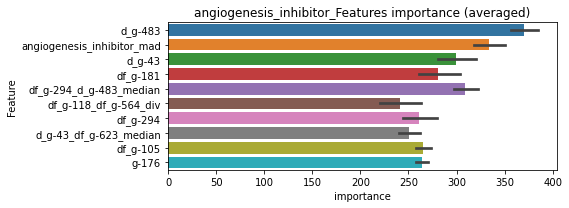

len(train_index) : 2844
len(valid_index) : 948
================================= fold 1/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.097426	valid_1's binary_logloss: 0.127723
[200]	training's binary_logloss: 0.0316205	valid_1's binary_logloss: 0.0548677
[300]	training's binary_logloss: 0.0114161	valid_1's binary_logloss: 0.0273573
[400]	training's binary_logloss: 0.00477682	valid_1's binary_logloss: 0.0157848
[500]	training's binary_logloss: 0.00237681	valid_1's binary_logloss: 0.0108118
[600]	training's binary_logloss: 0.00144853	valid_1's binary_logloss: 0.00841459
[700]	training's binary_logloss: 0.00101557	valid_1's binary_logloss: 0.00714148
[800]	training's binary_logloss: 0.000784628	valid_1's binary_logloss: 0.00632754
[900]	training's binary_logloss: 0.000650281	valid_1's binary_logloss: 0.00576695
[1000]	training's binary_logloss: 0.000573803	valid_1's binary_logloss: 0.00545165
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.000571407	valid_1's binary_logloss: 0.00544294


len(train_index) : 2844
len(valid_index) : 948
================================= fold 2/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0962765	valid_1's binary_logloss: 0.136447
[200]	training's binary_logloss: 0.0302168	valid_1's binary_logloss: 0.0658978
[300]	training's binary_logloss: 0.0108627	valid_1's binary_logloss: 0.0410835
[400]	training's binary_logloss: 0.00439151	valid_1's binary_logloss: 0.0310614
[500]	training's binary_logloss: 0.00222232	valid_1's binary_logloss: 0.0266333
[600]	training's binary_logloss: 0.00138403	valid_1's binary_logloss: 0.0256226
[700]	training's binary_logloss: 0.000973385	valid_1's binary_logloss: 0.0249149
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00104743	valid_1's binary_logloss: 0.0248174


len(train_index) : 2844
len(valid_index) : 948
================================= fold 3/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0949922	valid_1's binary_logloss: 0.115652
[200]	training's binary_logloss: 0.0303078	valid_1's binary_logloss: 0.0463025
[300]	training's binary_logloss: 0.0109818	valid_1's binary_logloss: 0.0220724
[400]	training's binary_logloss: 0.0045863	valid_1's binary_logloss: 0.0122365
[500]	training's binary_logloss: 0.00234237	valid_1's binary_logloss: 0.00776061
[600]	training's binary_logloss: 0.00144591	valid_1's binary_logloss: 0.00578034
[700]	training's binary_logloss: 0.00101471	valid_1's binary_logloss: 0.00467676
[800]	training's binary_logloss: 0.000786229	valid_1's binary_logloss: 0.00401529
[900]	training's binary_logloss: 0.000653303	valid_1's binary_logloss: 0.00358382
[1000]	training's binary_logloss: 0.000592136	valid_1's binary_logloss: 0.00340489
Early stopping, best iteration is:
[997]	training's binary_logloss: 0.000592136	valid_1's binary_logloss: 0.00340489


len(train_index) : 2844
len(valid_index) : 948
================================= fold 4/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957212	valid_1's binary_logloss: 0.121971
[200]	training's binary_logloss: 0.0298587	valid_1's binary_logloss: 0.0514048
[300]	training's binary_logloss: 0.0105963	valid_1's binary_logloss: 0.0263458
[400]	training's binary_logloss: 0.00440485	valid_1's binary_logloss: 0.0161605
[500]	training's binary_logloss: 0.00226455	valid_1's binary_logloss: 0.0114967
[600]	training's binary_logloss: 0.00142009	valid_1's binary_logloss: 0.00943421
[700]	training's binary_logloss: 0.00101219	valid_1's binary_logloss: 0.00799488
[800]	training's binary_logloss: 0.000784607	valid_1's binary_logloss: 0.00721451
[900]	training's binary_logloss: 0.000649053	valid_1's binary_logloss: 0.00694767
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000679131	valid_1's binary_logloss: 0.00693636


angiogenesis_inhibitor logloss: 0.010150405208951805
angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3286, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0997437	valid_1's binary_logloss: 0.143827
[200]	training's binary_logloss: 0.0352702	valid_1's binary_logloss: 0.0754921
[300]	training's binary_logloss: 0.0139906	valid_1's binary_logloss: 0.0462839
[400]	training's binary_logloss: 0.00624074	valid_1's binary_logloss: 0.0322248
[500]	training's binary_logloss: 0.00317244	valid_1's binary_logloss: 0.0252066
[600]	training's binary_logloss: 0.00190559	valid_1's binary_logloss: 0.0215518
[700]	training's binary_logloss: 0.00130528	valid_1's binary_logloss: 0.0200166
[800]	training's binary_logloss: 0.000990816	valid_1's binary_logloss: 0.0190785
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.00100208	valid_1's binary_logloss: 0.0189315
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0994885	valid_1's binary_logloss: 0.141955
[200]	training's binary_logloss: 0.0331832	valid

1 / 3 AUC score:0.999
y_Threshold: 0.0124799, Threshold: 0.0809316, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 653/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.05665, conf_1:0.10521
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0809316
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_2: 0.1109316
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_3: 0.1409316
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_4: 0.1709316
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_5: 0.2009316
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_6: 0.2309316
threshold: 0.2309316, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3803, y_label_rate: 0.1717065
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959267	valid_1's binary_logloss: 0.140274
[200]	training's binary_logloss: 0.030361	valid_1's binary_logloss: 0.0651322
[300]	training's binary_logloss: 0.0111006	valid_1's binary_logloss: 0.0362955
[400]	training's binary_logloss: 0.00471358	valid_1's binary_logloss: 0.0242557
[500]	training's binary_logloss: 0.00242551	valid_1's binary_logloss: 0.0187755
[600]	training's binary_logloss: 0.00148804	valid_1's binary_logloss: 0.01596
[700]	training's binary_logloss: 0.00105276	valid_1's binary_logloss: 0.014428
[800]	training's binary_logloss: 0.000816723	valid_1's binary_logloss: 0.0135442
[900]	training's binary_logloss: 0.000672673	valid_1's binary_logloss: 0.0130528
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.000652417	valid_1's binary_logloss: 0.0129796
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0974773	valid

2 / 3 AUC score:1.000
y_Threshold: 0.0912674, Threshold: 0.2309316, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 646.0/3789
p_label_rate: 0.0128076 Vs.target_rate: 0.00155, Num_p_label: 51.0, conf_0:0.18475, conf_1:0.27712
Num_p_label: 51.0, Expected: 6.2, Adj_threshold_1: 0.2309316
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_2: 0.2609316
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_3: 0.2909316
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_4: 0.3209316
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_5: 0.3509316
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_6: 0.3809316
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_7: 0.4109316
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_8: 0.4409316
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_9: 0.4709316
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_10: 0.5009316
threshold: 0.5309316, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 646.0/3789, y_label_rate: 0.1704935
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0937428	valid_1's binary_logloss: 0.141449
[200]	training's binary_logloss: 0.0289152	valid_1's binary_logloss: 0.0667188
[300]	training's binary_logloss: 0.0102703	valid_1's binary_logloss: 0.0393963
[400]	training's binary_logloss: 0.00435259	valid_1's binary_logloss: 0.0288089
[500]	training's binary_logloss: 0.00223461	valid_1's binary_logloss: 0.0234902
[600]	training's binary_logloss: 0.0013799	valid_1's binary_logloss: 0.0212788
[700]	training's binary_logloss: 0.000979724	valid_1's binary_logloss: 0.0202151
[800]	training's binary_logloss: 0.000761824	valid_1's binary_logloss: 0.0194729
Early stopping, best iteration is:
[841]	training's binary_logloss: 0.000701683	valid_1's binary_logloss: 0.0193032
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.092027	valid_1's binary_logloss: 0.134042
[200]	training's binary_logloss: 0.0285808	valid

3 / 3 AUC score:0.999
y_Threshold: 0.1092493, Threshold: 0.5309316, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 639.0/3775
p_label_rate: 0.0067805 Vs.target_rate: 0.00155, Num_p_label: 27.0, conf_0:0.47784, conf_1:0.58402
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_1: 0.5309316
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_2: 0.5609316
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_3: 0.5909316
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_4: 0.6209316
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_5: 0.6509316
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_6: 0.6809316
threshold: 0.6809316, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 639.0/3775, y_label_rate: 0.1692715


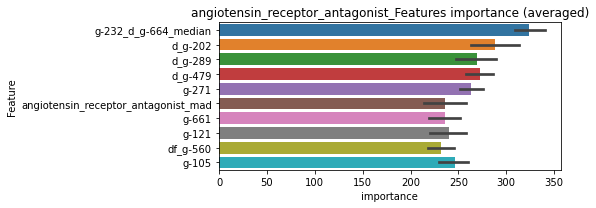

len(train_index) : 2831
len(valid_index) : 944
================================= fold 1/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0910197	valid_1's binary_logloss: 0.134882
[200]	training's binary_logloss: 0.0276604	valid_1's binary_logloss: 0.0611422
[300]	training's binary_logloss: 0.00990353	valid_1's binary_logloss: 0.0341517
[400]	training's binary_logloss: 0.00420402	valid_1's binary_logloss: 0.0229424
[500]	training's binary_logloss: 0.00217053	valid_1's binary_logloss: 0.0181628
[600]	training's binary_logloss: 0.00135356	valid_1's binary_logloss: 0.0159392
[700]	training's binary_logloss: 0.00095486	valid_1's binary_logloss: 0.0148912
Early stopping, best iteration is:
[735]	training's binary_logloss: 0.000870858	valid_1's binary_logloss: 0.0145285


len(train_index) : 2831
len(valid_index) : 944
================================= fold 2/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0937611	valid_1's binary_logloss: 0.129245
[200]	training's binary_logloss: 0.0280328	valid_1's binary_logloss: 0.0553906
[300]	training's binary_logloss: 0.01038	valid_1's binary_logloss: 0.0296762
[400]	training's binary_logloss: 0.00434184	valid_1's binary_logloss: 0.0185319
[500]	training's binary_logloss: 0.00221563	valid_1's binary_logloss: 0.0132235
[600]	training's binary_logloss: 0.00135896	valid_1's binary_logloss: 0.0105868
[700]	training's binary_logloss: 0.000966002	valid_1's binary_logloss: 0.00925415
[800]	training's binary_logloss: 0.000755522	valid_1's binary_logloss: 0.00857313
[900]	training's binary_logloss: 0.000638215	valid_1's binary_logloss: 0.00797835
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000644033	valid_1's binary_logloss: 0.00797048


len(train_index) : 2831
len(valid_index) : 944
================================= fold 3/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0922179	valid_1's binary_logloss: 0.13144
[200]	training's binary_logloss: 0.0275036	valid_1's binary_logloss: 0.0589283
[300]	training's binary_logloss: 0.0100237	valid_1's binary_logloss: 0.0331992
[400]	training's binary_logloss: 0.00414736	valid_1's binary_logloss: 0.0224624
[500]	training's binary_logloss: 0.00213642	valid_1's binary_logloss: 0.0175321
[600]	training's binary_logloss: 0.00134155	valid_1's binary_logloss: 0.0152669
[700]	training's binary_logloss: 0.00096056	valid_1's binary_logloss: 0.0137663
[800]	training's binary_logloss: 0.000744158	valid_1's binary_logloss: 0.012834
[900]	training's binary_logloss: 0.000629038	valid_1's binary_logloss: 0.0122875
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000617994	valid_1's binary_logloss: 0.0122553


len(train_index) : 2832
len(valid_index) : 943
================================= fold 4/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0924461	valid_1's binary_logloss: 0.136831
[200]	training's binary_logloss: 0.0277651	valid_1's binary_logloss: 0.0624548
[300]	training's binary_logloss: 0.0100602	valid_1's binary_logloss: 0.0356434
[400]	training's binary_logloss: 0.00418318	valid_1's binary_logloss: 0.0241465
[500]	training's binary_logloss: 0.00216738	valid_1's binary_logloss: 0.0193129
[600]	training's binary_logloss: 0.00133992	valid_1's binary_logloss: 0.0169439
[700]	training's binary_logloss: 0.000952345	valid_1's binary_logloss: 0.015907
[800]	training's binary_logloss: 0.000743537	valid_1's binary_logloss: 0.01538
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.00066884	valid_1's binary_logloss: 0.0150005


angiotensin_receptor_antagonist logloss: 0.012438021792397067
anti-inflammatory, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134088	valid_1's binary_logloss: 0.197068
[200]	training's binary_logloss: 0.0629841	valid_1's binary_logloss: 0.130042
[300]	training's binary_logloss: 0.0327693	valid_1's binary_logloss: 0.0985935
[400]	training's binary_logloss: 0.0170948	valid_1's binary_logloss: 0.0765553
[500]	training's binary_logloss: 0.00917539	valid_1's binary_logloss: 0.0645901
[600]	training's binary_logloss: 0.00526382	valid_1's binary_logloss: 0.0567727
[700]	training's binary_logloss: 0.00329943	valid_1's binary_logloss: 0.0517602
[800]	training's binary_logloss: 0.00227577	valid_1's binary_logloss: 0.0481368
[900]	training's binary_logloss: 0.00170736	valid_1's binary_logloss: 0.0462094
[1000]	training's binary_logloss: 0.00137051	valid_1's binary_logloss: 0.045054
Early stopping, best iteration is:
[1057]	training's binary_logloss: 0.00124187	valid_1's binary_logloss: 0.0445226
Training until validation scor

1 / 3 AUC score:0.996
y_Threshold: 0.0278920, Threshold: 0.2982436, pos_neg_ratio: 0.8000000
Remove_noisy_data: 150 → Positive_corect_labels: 646/3783
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.20877, conf_1:0.38772
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.2982436
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_2: 0.3282436
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_3: 0.3582436
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_4: 0.3882436
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_5: 0.4182436
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_6: 0.4482436
threshold: 0.4482436, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 646.0/3783, y_label_rate: 0.1707639
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124648	valid_1's binary_logloss: 0.194765
[200]	training's binary_logloss: 0.0532077	valid_1's binary_logloss: 0.132458
[300]	training's binary_logloss: 0.0250024	valid_1's binary_logloss: 0.104488
[400]	training's binary_logloss: 0.0123176	valid_1's binary_logloss: 0.0910851
[500]	training's binary_logloss: 0.00638528	valid_1's binary_logloss: 0.082048
[600]	training's binary_logloss: 0.0037122	valid_1's binary_logloss: 0.0793414
[700]	training's binary_logloss: 0.00241636	valid_1's binary_logloss: 0.0775937
[800]	training's binary_logloss: 0.0017407	valid_1's binary_logloss: 0.0772788
Early stopping, best iteration is:
[778]	training's binary_logloss: 0.00185955	valid_1's binary_logloss: 0.077028
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123957	valid_1's binary_logloss: 0.194838
[200]	training's binary_logloss: 0.0514482	valid_1's binar

2 / 3 AUC score:0.992
y_Threshold: 0.0856383, Threshold: 0.4482436, pos_neg_ratio: 0.8000000
Remove_noisy_data: 52 → Positive_corect_labels: 620.0/3731
p_label_rate: 0.0190859 Vs.target_rate: 0.00307, Num_p_label: 76.0, conf_0:0.35859, conf_1:0.53789
Num_p_label: 76.0, Expected: 12.2, Adj_threshold_1: 0.4482436
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_2: 0.4782436
Num_p_label: 64.0, Expected: 12.2, Adj_threshold_3: 0.5082436
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_4: 0.5382436
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_5: 0.5682436
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_6: 0.5982436
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_7: 0.6282436
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_8: 0.6582436
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_9: 0.6882436
threshold: 0.6882436, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 620.0/3731, y_label_rate: 0.1661753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112717	valid_1's binary_logloss: 0.173417
[200]	training's binary_logloss: 0.0435121	valid_1's binary_logloss: 0.109058
[300]	training's binary_logloss: 0.0196339	valid_1's binary_logloss: 0.0825113
[400]	training's binary_logloss: 0.00929455	valid_1's binary_logloss: 0.0685817
[500]	training's binary_logloss: 0.00483246	valid_1's binary_logloss: 0.0620663
[600]	training's binary_logloss: 0.00287208	valid_1's binary_logloss: 0.0582085
[700]	training's binary_logloss: 0.00194055	valid_1's binary_logloss: 0.0567678
Early stopping, best iteration is:
[723]	training's binary_logloss: 0.00179935	valid_1's binary_logloss: 0.0563882
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112044	valid_1's binary_logloss: 0.17848
[200]	training's binary_logloss: 0.0429597	valid_1's binary_logloss: 0.112582
[300]	training's binary_logloss: 0.0190997	valid_1's bi

3 / 3 AUC score:0.992
y_Threshold: 0.1217770, Threshold: 0.6882436, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 599.0/3689
p_label_rate: 0.0105475 Vs.target_rate: 0.00307, Num_p_label: 42.0, conf_0:0.50000, conf_1:0.75707
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_1: 0.6882436
threshold: 0.6882436, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 599.0/3689, y_label_rate: 0.1623746


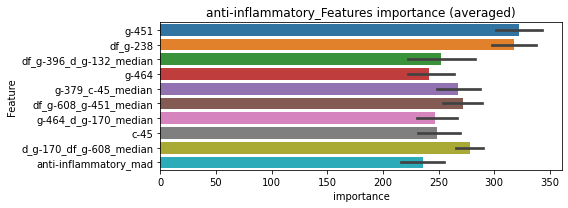

len(train_index) : 2766
len(valid_index) : 923
================================= fold 1/4 anti-inflammatory=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102806	valid_1's binary_logloss: 0.169596
[200]	training's binary_logloss: 0.0380808	valid_1's binary_logloss: 0.105804
[300]	training's binary_logloss: 0.0160182	valid_1's binary_logloss: 0.0792053
[400]	training's binary_logloss: 0.00735563	valid_1's binary_logloss: 0.0668391
[500]	training's binary_logloss: 0.00387474	valid_1's binary_logloss: 0.061971
[600]	training's binary_logloss: 0.00237841	valid_1's binary_logloss: 0.0604652
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00245042	valid_1's binary_logloss: 0.0602633


len(train_index) : 2767
len(valid_index) : 922
================================= fold 2/4 anti-inflammatory=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108357	valid_1's binary_logloss: 0.152447
[200]	training's binary_logloss: 0.0414236	valid_1's binary_logloss: 0.0845952
[300]	training's binary_logloss: 0.0179927	valid_1's binary_logloss: 0.0567325
[400]	training's binary_logloss: 0.00832425	valid_1's binary_logloss: 0.0427702
[500]	training's binary_logloss: 0.00434689	valid_1's binary_logloss: 0.0366091
[600]	training's binary_logloss: 0.0025873	valid_1's binary_logloss: 0.033994
[700]	training's binary_logloss: 0.00176232	valid_1's binary_logloss: 0.0323005
[800]	training's binary_logloss: 0.00133485	valid_1's binary_logloss: 0.0314827
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.00143468	valid_1's binary_logloss: 0.0313632


len(train_index) : 2767
len(valid_index) : 922
================================= fold 3/4 anti-inflammatory=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106946	valid_1's binary_logloss: 0.144319
[200]	training's binary_logloss: 0.0411666	valid_1's binary_logloss: 0.0771883
[300]	training's binary_logloss: 0.0176496	valid_1's binary_logloss: 0.0484945
[400]	training's binary_logloss: 0.00827823	valid_1's binary_logloss: 0.0360474
[500]	training's binary_logloss: 0.00430544	valid_1's binary_logloss: 0.029158
[600]	training's binary_logloss: 0.00259237	valid_1's binary_logloss: 0.0253577
[700]	training's binary_logloss: 0.00177567	valid_1's binary_logloss: 0.0230777
[800]	training's binary_logloss: 0.00133644	valid_1's binary_logloss: 0.0214614
[900]	training's binary_logloss: 0.0010716	valid_1's binary_logloss: 0.020697
[1000]	training's binary_logloss: 0.000915849	valid_1's binary_logloss: 0.020391
Early stopping, best iteration is:
[1055]	training's binary_logloss: 0.000860481	valid_1's binary_logloss: 0.0202061


len(train_index) : 2767
len(valid_index) : 922
================================= fold 4/4 anti-inflammatory=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104011	valid_1's binary_logloss: 0.166409
[200]	training's binary_logloss: 0.0393187	valid_1's binary_logloss: 0.107724
[300]	training's binary_logloss: 0.0165205	valid_1's binary_logloss: 0.0817782
[400]	training's binary_logloss: 0.00769804	valid_1's binary_logloss: 0.0700352
[500]	training's binary_logloss: 0.0039953	valid_1's binary_logloss: 0.0646934
[600]	training's binary_logloss: 0.00241762	valid_1's binary_logloss: 0.0624825
[700]	training's binary_logloss: 0.00166672	valid_1's binary_logloss: 0.061634
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.00163818	valid_1's binary_logloss: 0.0615628


anti-inflammatory logloss: 0.04335344769120369
antiarrhythmic, len(trt): 24, len(othr): 3284, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085931	valid_1's binary_logloss: 0.118512
[200]	training's binary_logloss: 0.0253561	valid_1's binary_logloss: 0.051197
[300]	training's binary_logloss: 0.00886454	valid_1's binary_logloss: 0.02749
[400]	training's binary_logloss: 0.00369461	valid_1's binary_logloss: 0.0183258
[500]	training's binary_logloss: 0.00191113	valid_1's binary_logloss: 0.0142985
[600]	training's binary_logloss: 0.00119736	valid_1's binary_logloss: 0.0125384
[700]	training's binary_logloss: 0.000859265	valid_1's binary_logloss: 0.0113601
[800]	training's binary_logloss: 0.00068104	valid_1's binary_logloss: 0.010809
[900]	training's binary_logloss: 0.000584458	valid_1's binary_logloss: 0.0104991
[1000]	training's binary_logloss: 0.000549984	valid_1's binary_logloss: 0.0104133
Early stopping, best iteration is:
[977]	training's binary_logloss: 0.000551352	valid_1's binary_logloss: 0.0104093
Training until validation s

1 / 3 AUC score:1.000
y_Threshold: 0.0066569, Threshold: 0.0360080, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.02521, conf_1:0.04681
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0360080
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_2: 0.0660080
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_3: 0.0960080
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_4: 0.1260080
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.1560080
threshold: 0.1560080, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0819521	valid_1's binary_logloss: 0.113571
[200]	training's binary_logloss: 0.0225856	valid_1's binary_logloss: 0.0445571
[300]	training's binary_logloss: 0.00745376	valid_1's binary_logloss: 0.0217736
[400]	training's binary_logloss: 0.00309865	valid_1's binary_logloss: 0.0136744
[500]	training's binary_logloss: 0.00161401	valid_1's binary_logloss: 0.0101538
[600]	training's binary_logloss: 0.00103471	valid_1's binary_logloss: 0.00852065
[700]	training's binary_logloss: 0.000752569	valid_1's binary_logloss: 0.00761427
[800]	training's binary_logloss: 0.000601259	valid_1's binary_logloss: 0.00704333
[900]	training's binary_logloss: 0.000519994	valid_1's binary_logloss: 0.00675055
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.000499269	valid_1's binary_logloss: 0.00669951
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

2 / 3 AUC score:1.000
y_Threshold: 0.0599162, Threshold: 0.1560080, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0087896 Vs.target_rate: 0.00101, Num_p_label: 35.0, conf_0:0.12481, conf_1:0.18721
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_1: 0.1560080
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.1860080
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_3: 0.2160080
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_4: 0.2460080
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_5: 0.2760080
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_6: 0.3060080
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_7: 0.3360080
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_8: 0.3660080
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_9: 0.3960080
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_10: 0.4260080
threshold: 0.4560080, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 652.0/3800, y_label_rate: 0.1715789
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0793686	valid_1's binary_logloss: 0.103726
[200]	training's binary_logloss: 0.0212746	valid_1's binary_logloss: 0.0373483
[300]	training's binary_logloss: 0.0068925	valid_1's binary_logloss: 0.0165765
[400]	training's binary_logloss: 0.00285013	valid_1's binary_logloss: 0.00893749
[500]	training's binary_logloss: 0.00152172	valid_1's binary_logloss: 0.00577789
[600]	training's binary_logloss: 0.000980811	valid_1's binary_logloss: 0.00431581
[700]	training's binary_logloss: 0.000718035	valid_1's binary_logloss: 0.00356666
[800]	training's binary_logloss: 0.000572597	valid_1's binary_logloss: 0.00309394
[900]	training's binary_logloss: 0.000507263	valid_1's binary_logloss: 0.0029017
[1000]	training's binary_logloss: 0.000482209	valid_1's binary_logloss: 0.00282549
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.0004833	valid_1's binary_logloss: 0.00282403
Training until v

3 / 3 AUC score:1.000
y_Threshold: 0.0688975, Threshold: 0.4560080, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0045203 Vs.target_rate: 0.00101, Num_p_label: 18.0, conf_0:0.41041, conf_1:0.50161
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_1: 0.4560080
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_2: 0.4860080
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_3: 0.5160080
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_4: 0.5460080
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_5: 0.5760080
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.6060080
threshold: 0.6060080, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 651.0/3798, y_label_rate: 0.1714060


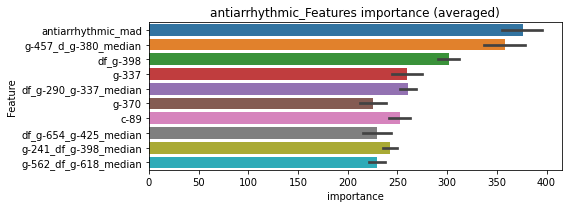

len(train_index) : 2848
len(valid_index) : 950
================================= fold 1/4 antiarrhythmic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0798608	valid_1's binary_logloss: 0.0990099
[200]	training's binary_logloss: 0.0212794	valid_1's binary_logloss: 0.0353735
[300]	training's binary_logloss: 0.00686899	valid_1's binary_logloss: 0.0154555
[400]	training's binary_logloss: 0.00282732	valid_1's binary_logloss: 0.00823248
[500]	training's binary_logloss: 0.00149474	valid_1's binary_logloss: 0.00536474
[600]	training's binary_logloss: 0.000969239	valid_1's binary_logloss: 0.00408037
[700]	training's binary_logloss: 0.000714257	valid_1's binary_logloss: 0.00338923
[800]	training's binary_logloss: 0.000573046	valid_1's binary_logloss: 0.00298125
[900]	training's binary_logloss: 0.000502953	valid_1's binary_logloss: 0.00278953
[1000]	training's binary_logloss: 0.000477337	valid_1's binary_logloss: 0.00273162
Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.000476956	valid_1's binary_logloss: 0.00272826


len(train_index) : 2848
len(valid_index) : 950
================================= fold 2/4 antiarrhythmic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0808132	valid_1's binary_logloss: 0.120505
[200]	training's binary_logloss: 0.0214545	valid_1's binary_logloss: 0.052019
[300]	training's binary_logloss: 0.00700112	valid_1's binary_logloss: 0.030065
[400]	training's binary_logloss: 0.00290434	valid_1's binary_logloss: 0.0221282
[500]	training's binary_logloss: 0.00151796	valid_1's binary_logloss: 0.0185384
[600]	training's binary_logloss: 0.000971768	valid_1's binary_logloss: 0.0170143
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.000878012	valid_1's binary_logloss: 0.0168874


len(train_index) : 2849
len(valid_index) : 949
================================= fold 3/4 antiarrhythmic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805882	valid_1's binary_logloss: 0.100853
[200]	training's binary_logloss: 0.02197	valid_1's binary_logloss: 0.0392086
[300]	training's binary_logloss: 0.0072393	valid_1's binary_logloss: 0.021552
[400]	training's binary_logloss: 0.00298764	valid_1's binary_logloss: 0.0151151
[500]	training's binary_logloss: 0.00154396	valid_1's binary_logloss: 0.0124402
[600]	training's binary_logloss: 0.00099742	valid_1's binary_logloss: 0.0113703
[700]	training's binary_logloss: 0.000728273	valid_1's binary_logloss: 0.0108401
[800]	training's binary_logloss: 0.000574121	valid_1's binary_logloss: 0.0105409
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.00053713	valid_1's binary_logloss: 0.0104888


len(train_index) : 2849
len(valid_index) : 949
================================= fold 4/4 antiarrhythmic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0804718	valid_1's binary_logloss: 0.106684
[200]	training's binary_logloss: 0.0214796	valid_1's binary_logloss: 0.0380814
[300]	training's binary_logloss: 0.00709159	valid_1's binary_logloss: 0.0174209
[400]	training's binary_logloss: 0.00293037	valid_1's binary_logloss: 0.00970032
[500]	training's binary_logloss: 0.00155461	valid_1's binary_logloss: 0.00627812
[600]	training's binary_logloss: 0.000991233	valid_1's binary_logloss: 0.00492402
[700]	training's binary_logloss: 0.000721407	valid_1's binary_logloss: 0.00402476
[800]	training's binary_logloss: 0.000575405	valid_1's binary_logloss: 0.00352104
[900]	training's binary_logloss: 0.000503139	valid_1's binary_logloss: 0.00328531
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.000490084	valid_1's binary_logloss: 0.00325394


antiarrhythmic logloss: 0.00834036545426854
antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113925	valid_1's binary_logloss: 0.152667
[200]	training's binary_logloss: 0.0410241	valid_1's binary_logloss: 0.07609
[300]	training's binary_logloss: 0.0162012	valid_1's binary_logloss: 0.0445539
[400]	training's binary_logloss: 0.00721303	valid_1's binary_logloss: 0.0303147
[500]	training's binary_logloss: 0.00367061	valid_1's binary_logloss: 0.0222516
[600]	training's binary_logloss: 0.00220614	valid_1's binary_logloss: 0.018137
[700]	training's binary_logloss: 0.00151759	valid_1's binary_logloss: 0.0158685
[800]	training's binary_logloss: 0.00114542	valid_1's binary_logloss: 0.0143079
[900]	training's binary_logloss: 0.000929976	valid_1's binary_logloss: 0.0134754
[1000]	training's binary_logloss: 0.00080888	valid_1's binary_logloss: 0.0129063
Early stopping, best iteration is:
[1058]	training's binary_logloss: 0.000763349	valid_1's binary_logloss: 0.0127014
Training until validation sc

1 / 3 AUC score:0.999
y_Threshold: 0.0147351, Threshold: 0.1295748, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00181, Num_p_label: 40.0, conf_0:0.09070, conf_1:0.16845
Num_p_label: 40.0, Expected: 7.2, Adj_threshold_1: 0.1295748
Num_p_label: 31.0, Expected: 7.2, Adj_threshold_2: 0.1595748
Num_p_label: 27.0, Expected: 7.2, Adj_threshold_3: 0.1895748
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_4: 0.2195748
Num_p_label: 20.0, Expected: 7.2, Adj_threshold_5: 0.2495748
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_6: 0.2795748
threshold: 0.2795748, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105213	valid_1's binary_logloss: 0.139956
[200]	training's binary_logloss: 0.0348429	valid_1's binary_logloss: 0.0640631
[300]	training's binary_logloss: 0.0130522	valid_1's binary_logloss: 0.03421
[400]	training's binary_logloss: 0.00558391	valid_1's binary_logloss: 0.0212177
[500]	training's binary_logloss: 0.00293003	valid_1's binary_logloss: 0.0153932
[600]	training's binary_logloss: 0.00181632	valid_1's binary_logloss: 0.0122887
[700]	training's binary_logloss: 0.00127548	valid_1's binary_logloss: 0.0104343
[800]	training's binary_logloss: 0.000977831	valid_1's binary_logloss: 0.00930419
[900]	training's binary_logloss: 0.000806187	valid_1's binary_logloss: 0.00869751
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.00077793	valid_1's binary_logloss: 0.00858597
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104522	val

2 / 3 AUC score:1.000
y_Threshold: 0.0997584, Threshold: 0.2795748, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0120542 Vs.target_rate: 0.00181, Num_p_label: 48.0, conf_0:0.22366, conf_1:0.33549
Num_p_label: 48.0, Expected: 7.2, Adj_threshold_1: 0.2795748
Num_p_label: 43.0, Expected: 7.2, Adj_threshold_2: 0.3095748
Num_p_label: 41.0, Expected: 7.2, Adj_threshold_3: 0.3395748
Num_p_label: 37.0, Expected: 7.2, Adj_threshold_4: 0.3695748
Num_p_label: 35.0, Expected: 7.2, Adj_threshold_5: 0.3995748
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_6: 0.4295748
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_7: 0.4595748
Num_p_label: 27.0, Expected: 7.2, Adj_threshold_8: 0.4895748
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_9: 0.5195748
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_10: 0.5495748
threshold: 0.5795748, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108019	valid_1's binary_logloss: 0.14023
[200]	training's binary_logloss: 0.0355715	valid_1's binary_logloss: 0.0620236
[300]	training's binary_logloss: 0.0129749	valid_1's binary_logloss: 0.0316916
[400]	training's binary_logloss: 0.00556339	valid_1's binary_logloss: 0.0189518
[500]	training's binary_logloss: 0.0028548	valid_1's binary_logloss: 0.0129591
[600]	training's binary_logloss: 0.00175009	valid_1's binary_logloss: 0.0101512
[700]	training's binary_logloss: 0.0012356	valid_1's binary_logloss: 0.00839044
[800]	training's binary_logloss: 0.000949928	valid_1's binary_logloss: 0.00741921
[900]	training's binary_logloss: 0.000784053	valid_1's binary_logloss: 0.00699853
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.000742045	valid_1's binary_logloss: 0.00683937
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104895	va

3 / 3 AUC score:1.000
y_Threshold: 0.0808173, Threshold: 0.5795748, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0050226 Vs.target_rate: 0.00181, Num_p_label: 20.0, conf_0:0.50000, conf_1:0.63753
threshold: 0.5795748, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 646.0/3785, y_label_rate: 0.1706737


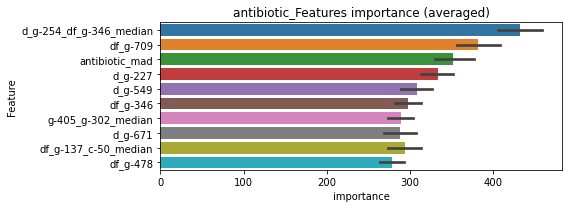

len(train_index) : 2838
len(valid_index) : 947
================================= fold 1/4 antibiotic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105114	valid_1's binary_logloss: 0.136789
[200]	training's binary_logloss: 0.0347066	valid_1's binary_logloss: 0.0613112
[300]	training's binary_logloss: 0.0128437	valid_1's binary_logloss: 0.0324027
[400]	training's binary_logloss: 0.00548997	valid_1's binary_logloss: 0.0198716
[500]	training's binary_logloss: 0.00281031	valid_1's binary_logloss: 0.0134536
[600]	training's binary_logloss: 0.00173287	valid_1's binary_logloss: 0.0104658
[700]	training's binary_logloss: 0.00122087	valid_1's binary_logloss: 0.00888714
[800]	training's binary_logloss: 0.000947448	valid_1's binary_logloss: 0.00784245
[900]	training's binary_logloss: 0.000776494	valid_1's binary_logloss: 0.00723802
[1000]	training's binary_logloss: 0.000680059	valid_1's binary_logloss: 0.00695194
[1100]	training's binary_logloss: 0.000640015	valid_1's binary_logloss: 0.00675966
Early stopping, best iteration is:
[1141]	training's 

len(train_index) : 2839
len(valid_index) : 946
================================= fold 2/4 antibiotic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104187	valid_1's binary_logloss: 0.143718
[200]	training's binary_logloss: 0.0340627	valid_1's binary_logloss: 0.065054
[300]	training's binary_logloss: 0.01268	valid_1's binary_logloss: 0.0371818
[400]	training's binary_logloss: 0.00544317	valid_1's binary_logloss: 0.0241805
[500]	training's binary_logloss: 0.00278314	valid_1's binary_logloss: 0.017506
[600]	training's binary_logloss: 0.00171217	valid_1's binary_logloss: 0.014563
[700]	training's binary_logloss: 0.00120561	valid_1's binary_logloss: 0.0130157
[800]	training's binary_logloss: 0.00093117	valid_1's binary_logloss: 0.0119746
[900]	training's binary_logloss: 0.000764562	valid_1's binary_logloss: 0.0112204
[1000]	training's binary_logloss: 0.000675389	valid_1's binary_logloss: 0.0110013
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.00067864	valid_1's binary_logloss: 0.0109647


len(train_index) : 2839
len(valid_index) : 946
================================= fold 3/4 antibiotic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10514	valid_1's binary_logloss: 0.14841
[200]	training's binary_logloss: 0.0343848	valid_1's binary_logloss: 0.0676325
[300]	training's binary_logloss: 0.0127047	valid_1's binary_logloss: 0.0366098
[400]	training's binary_logloss: 0.00543974	valid_1's binary_logloss: 0.022733
[500]	training's binary_logloss: 0.00278025	valid_1's binary_logloss: 0.0159147
[600]	training's binary_logloss: 0.00170141	valid_1's binary_logloss: 0.0128887
[700]	training's binary_logloss: 0.00120254	valid_1's binary_logloss: 0.0110958
[800]	training's binary_logloss: 0.000926145	valid_1's binary_logloss: 0.0101153
[900]	training's binary_logloss: 0.000768062	valid_1's binary_logloss: 0.0095057
[1000]	training's binary_logloss: 0.000676404	valid_1's binary_logloss: 0.00922002
[1100]	training's binary_logloss: 0.000637355	valid_1's binary_logloss: 0.0090756
Early stopping, best iteration is:
[1101]	training's binary_

len(train_index) : 2839
len(valid_index) : 946
================================= fold 4/4 antibiotic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106827	valid_1's binary_logloss: 0.136306
[200]	training's binary_logloss: 0.0348218	valid_1's binary_logloss: 0.0578834
[300]	training's binary_logloss: 0.0130392	valid_1's binary_logloss: 0.028712
[400]	training's binary_logloss: 0.00561821	valid_1's binary_logloss: 0.0165114
[500]	training's binary_logloss: 0.00286448	valid_1's binary_logloss: 0.0107521
[600]	training's binary_logloss: 0.00175903	valid_1's binary_logloss: 0.0080153
[700]	training's binary_logloss: 0.00123723	valid_1's binary_logloss: 0.00661165
[800]	training's binary_logloss: 0.000952133	valid_1's binary_logloss: 0.00576888
[900]	training's binary_logloss: 0.000783609	valid_1's binary_logloss: 0.00525795
[1000]	training's binary_logloss: 0.000680966	valid_1's binary_logloss: 0.00494705
[1100]	training's binary_logloss: 0.000632058	valid_1's binary_logloss: 0.00485404
Early stopping, best iteration is:
[1093]	training's b

antibiotic logloss: 0.007900711014331227
anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0750074	valid_1's binary_logloss: 0.0962899
[200]	training's binary_logloss: 0.0199408	valid_1's binary_logloss: 0.0353616
[300]	training's binary_logloss: 0.00631801	valid_1's binary_logloss: 0.0164583
[400]	training's binary_logloss: 0.00258163	valid_1's binary_logloss: 0.00987066
[500]	training's binary_logloss: 0.00135639	valid_1's binary_logloss: 0.00702351
[600]	training's binary_logloss: 0.000866887	valid_1's binary_logloss: 0.00567007
[700]	training's binary_logloss: 0.000644523	valid_1's binary_logloss: 0.00497737
[800]	training's binary_logloss: 0.000523564	valid_1's binary_logloss: 0.00447856
[900]	training's binary_logloss: 0.000469645	valid_1's binary_logloss: 0.00428031
[1000]	training's binary_logloss: 0.000452802	valid_1's binary_logloss: 0.00424164
Early stopping, best iteration is:
[987]	training's binary_logloss: 0.000453352	valid_1's binary_logloss: 0.00423938
Training un

1 / 3 AUC score:1.000
y_Threshold: 0.0056488, Threshold: 0.0181754, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01272, conf_1:0.02363
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0181754
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.0481754
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.0781754
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.1081754
threshold: 0.1081754, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0732757	valid_1's binary_logloss: 0.0938003
[200]	training's binary_logloss: 0.0183986	valid_1's binary_logloss: 0.0320525
[300]	training's binary_logloss: 0.00568958	valid_1's binary_logloss: 0.0138486
[400]	training's binary_logloss: 0.00229169	valid_1's binary_logloss: 0.00732442
[500]	training's binary_logloss: 0.00120721	valid_1's binary_logloss: 0.00487238
[600]	training's binary_logloss: 0.000775614	valid_1's binary_logloss: 0.00357994
[700]	training's binary_logloss: 0.000573117	valid_1's binary_logloss: 0.00294626
[800]	training's binary_logloss: 0.000470133	valid_1's binary_logloss: 0.00262777
[900]	training's binary_logloss: 0.000428805	valid_1's binary_logloss: 0.00253858
Early stopping, best iteration is:
[937]	training's binary_logloss: 0.000425352	valid_1's binary_logloss: 0.00252985
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1573212, Threshold: 0.1081754, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0082873 Vs.target_rate: 0.00076, Num_p_label: 33.0, conf_0:0.08654, conf_1:0.12981
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_1: 0.1081754
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.1381754
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.1681754
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_4: 0.1981754
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.2281754
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.2581754
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.2881754
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.3181754
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.3481754
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.3781754
threshold: 0.4081754, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0732757	valid_1's binary_logloss: 0.0938003
[200]	training's binary_logloss: 0.0183986	valid_1's binary_logloss: 0.0320525
[300]	training's binary_logloss: 0.00568958	valid_1's binary_logloss: 0.0138486
[400]	training's binary_logloss: 0.00229169	valid_1's binary_logloss: 0.00732442
[500]	training's binary_logloss: 0.00120721	valid_1's binary_logloss: 0.00487238
[600]	training's binary_logloss: 0.000775614	valid_1's binary_logloss: 0.00357994
[700]	training's binary_logloss: 0.000573117	valid_1's binary_logloss: 0.00294626
[800]	training's binary_logloss: 0.000470133	valid_1's binary_logloss: 0.00262777
[900]	training's binary_logloss: 0.000428805	valid_1's binary_logloss: 0.00253858
Early stopping, best iteration is:
[937]	training's binary_logloss: 0.000425352	valid_1's binary_logloss: 0.00252985
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1573212, Threshold: 0.4081754, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.36736, conf_1:0.44899
threshold: 0.4081754, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


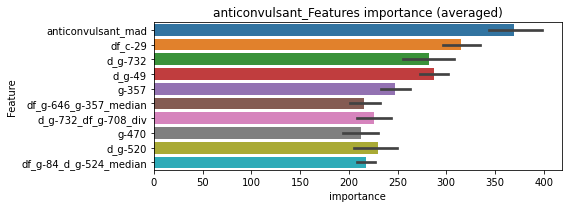

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 anticonvulsant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0736163	valid_1's binary_logloss: 0.0935197
[200]	training's binary_logloss: 0.0184316	valid_1's binary_logloss: 0.032328
[300]	training's binary_logloss: 0.00574211	valid_1's binary_logloss: 0.0141903
[400]	training's binary_logloss: 0.00231559	valid_1's binary_logloss: 0.00738233
[500]	training's binary_logloss: 0.001215	valid_1's binary_logloss: 0.00480115
[600]	training's binary_logloss: 0.000784182	valid_1's binary_logloss: 0.00374868
[700]	training's binary_logloss: 0.000578683	valid_1's binary_logloss: 0.00316218
[800]	training's binary_logloss: 0.000476117	valid_1's binary_logloss: 0.00284411
[900]	training's binary_logloss: 0.000440347	valid_1's binary_logloss: 0.0027793
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.000433569	valid_1's binary_logloss: 0.00275339


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 anticonvulsant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0736136	valid_1's binary_logloss: 0.105599
[200]	training's binary_logloss: 0.0182906	valid_1's binary_logloss: 0.0420016
[300]	training's binary_logloss: 0.00562323	valid_1's binary_logloss: 0.0229841
[400]	training's binary_logloss: 0.00224659	valid_1's binary_logloss: 0.015492
[500]	training's binary_logloss: 0.00117576	valid_1's binary_logloss: 0.0118072
[600]	training's binary_logloss: 0.000754895	valid_1's binary_logloss: 0.0103056
[700]	training's binary_logloss: 0.00055586	valid_1's binary_logloss: 0.00926913
[800]	training's binary_logloss: 0.000456493	valid_1's binary_logloss: 0.00889345
Early stopping, best iteration is:
[799]	training's binary_logloss: 0.000457289	valid_1's binary_logloss: 0.00888552


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 anticonvulsant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0745823	valid_1's binary_logloss: 0.0855653
[200]	training's binary_logloss: 0.0190503	valid_1's binary_logloss: 0.0265971
[300]	training's binary_logloss: 0.00586416	valid_1's binary_logloss: 0.01028
[400]	training's binary_logloss: 0.00233617	valid_1's binary_logloss: 0.00510649
[500]	training's binary_logloss: 0.00121758	valid_1's binary_logloss: 0.00321803
[600]	training's binary_logloss: 0.00078032	valid_1's binary_logloss: 0.00238521
[700]	training's binary_logloss: 0.000572031	valid_1's binary_logloss: 0.00193742
[800]	training's binary_logloss: 0.000470478	valid_1's binary_logloss: 0.00166655
[900]	training's binary_logloss: 0.000435529	valid_1's binary_logloss: 0.00158973
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.000423517	valid_1's binary_logloss: 0.00156933


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 anticonvulsant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0750458	valid_1's binary_logloss: 0.0965046
[200]	training's binary_logloss: 0.0190499	valid_1's binary_logloss: 0.0325896
[300]	training's binary_logloss: 0.00596701	valid_1's binary_logloss: 0.0135879
[400]	training's binary_logloss: 0.00236894	valid_1's binary_logloss: 0.00709167
[500]	training's binary_logloss: 0.0012362	valid_1's binary_logloss: 0.0046224
[600]	training's binary_logloss: 0.000797153	valid_1's binary_logloss: 0.00353664
[700]	training's binary_logloss: 0.000587293	valid_1's binary_logloss: 0.00292405
[800]	training's binary_logloss: 0.000474283	valid_1's binary_logloss: 0.00255256
[900]	training's binary_logloss: 0.000430698	valid_1's binary_logloss: 0.00245678
Early stopping, best iteration is:
[954]	training's binary_logloss: 0.000421764	valid_1's binary_logloss: 0.00242778


anticonvulsant logloss: 0.003912810582406165


neg labels: 3289 → selected neg labels: 3286


antifungal, len(trt): 26, len(othr): 3286, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0795786	valid_1's binary_logloss: 0.114743
[200]	training's binary_logloss: 0.0228029	valid_1's binary_logloss: 0.0503483
[300]	training's binary_logloss: 0.00784901	valid_1's binary_logloss: 0.0294577
[400]	training's binary_logloss: 0.00324192	valid_1's binary_logloss: 0.0206476
[500]	training's binary_logloss: 0.00169524	valid_1's binary_logloss: 0.0167139
[600]	training's binary_logloss: 0.00107442	valid_1's binary_logloss: 0.0152922
[700]	training's binary_logloss: 0.000779298	valid_1's binary_logloss: 0.0148104
[800]	training's binary_logloss: 0.000620592	valid_1's binary_logloss: 0.0145461
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000589054	valid_1's binary_logloss: 0.0144295
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0811514	valid_1's binary_logloss: 0.105018
[200]	training's binary_logloss: 0.0237523	va

1 / 3 AUC score:1.000
y_Threshold: 0.0077724, Threshold: 0.0948528, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.06640, conf_1:0.12331
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0948528
Num_p_label: 33.0, Expected: 4.3, Adj_threshold_2: 0.1248528
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_3: 0.1548528
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_4: 0.1848528
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_5: 0.2148528
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_6: 0.2448528
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_7: 0.2748528
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_8: 0.3048528
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_9: 0.3348528
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_10: 0.3648528
threshold: 0.3948528, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0768621	valid_1's binary_logloss: 0.100443
[200]	training's binary_logloss: 0.0206116	valid_1's binary_logloss: 0.0371811
[300]	training's binary_logloss: 0.00667415	valid_1's binary_logloss: 0.0173175
[400]	training's binary_logloss: 0.00276542	valid_1's binary_logloss: 0.00957989
[500]	training's binary_logloss: 0.00145772	valid_1's binary_logloss: 0.00637323
[600]	training's binary_logloss: 0.000946689	valid_1's binary_logloss: 0.0049608
[700]	training's binary_logloss: 0.000693741	valid_1's binary_logloss: 0.00412296
[800]	training's binary_logloss: 0.000554447	valid_1's binary_logloss: 0.0036433
[900]	training's binary_logloss: 0.000482941	valid_1's binary_logloss: 0.00343118
[1000]	training's binary_logloss: 0.000463167	valid_1's binary_logloss: 0.00338417
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.000464353	valid_1's binary_logloss: 0.00337833
Training until

2 / 3 AUC score:1.000
y_Threshold: 0.1434355, Threshold: 0.3948528, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0080362 Vs.target_rate: 0.00109, Num_p_label: 32.0, conf_0:0.31588, conf_1:0.47382
Num_p_label: 32.0, Expected: 4.3, Adj_threshold_1: 0.3948528
Num_p_label: 32.0, Expected: 4.3, Adj_threshold_2: 0.4248528
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_3: 0.4548528
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_4: 0.4848528
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_5: 0.5148528
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_6: 0.5448528
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_7: 0.5748528
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_8: 0.6048528
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_9: 0.6348528
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_10: 0.6648528
threshold: 0.6948528, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0768621	valid_1's binary_logloss: 0.100443
[200]	training's binary_logloss: 0.0206116	valid_1's binary_logloss: 0.0371811
[300]	training's binary_logloss: 0.00667415	valid_1's binary_logloss: 0.0173175
[400]	training's binary_logloss: 0.00276542	valid_1's binary_logloss: 0.00957989
[500]	training's binary_logloss: 0.00145772	valid_1's binary_logloss: 0.00637323
[600]	training's binary_logloss: 0.000946689	valid_1's binary_logloss: 0.0049608
[700]	training's binary_logloss: 0.000693741	valid_1's binary_logloss: 0.00412296
[800]	training's binary_logloss: 0.000554447	valid_1's binary_logloss: 0.0036433
[900]	training's binary_logloss: 0.000482941	valid_1's binary_logloss: 0.00343118
[1000]	training's binary_logloss: 0.000463167	valid_1's binary_logloss: 0.00338417
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.000464353	valid_1's binary_logloss: 0.00337833
Training until

3 / 3 AUC score:1.000
y_Threshold: 0.1434355, Threshold: 0.6948528, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00109, Num_p_label: 13.0, conf_0:0.50000, conf_1:0.76434
threshold: 0.6948528, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


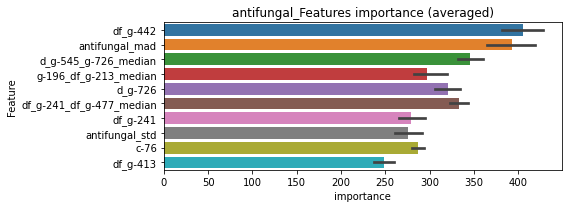

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 antifungal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0780371	valid_1's binary_logloss: 0.100479
[200]	training's binary_logloss: 0.0209947	valid_1's binary_logloss: 0.0368539
[300]	training's binary_logloss: 0.00686817	valid_1's binary_logloss: 0.0164502
[400]	training's binary_logloss: 0.00283221	valid_1's binary_logloss: 0.0089781
[500]	training's binary_logloss: 0.00148611	valid_1's binary_logloss: 0.00604448
[600]	training's binary_logloss: 0.000955189	valid_1's binary_logloss: 0.00474211
[700]	training's binary_logloss: 0.000697744	valid_1's binary_logloss: 0.00405952
[800]	training's binary_logloss: 0.000556394	valid_1's binary_logloss: 0.00357801
[900]	training's binary_logloss: 0.000489721	valid_1's binary_logloss: 0.00338551
[1000]	training's binary_logloss: 0.000471749	valid_1's binary_logloss: 0.00334884
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000472467	valid_1's binary_logloss: 0.00334711


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 antifungal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0769336	valid_1's binary_logloss: 0.0996967
[200]	training's binary_logloss: 0.0200514	valid_1's binary_logloss: 0.0349352
[300]	training's binary_logloss: 0.00656485	valid_1's binary_logloss: 0.0158871
[400]	training's binary_logloss: 0.00270713	valid_1's binary_logloss: 0.00881319
[500]	training's binary_logloss: 0.00144633	valid_1's binary_logloss: 0.00607285
[600]	training's binary_logloss: 0.000925267	valid_1's binary_logloss: 0.00482642
[700]	training's binary_logloss: 0.000679833	valid_1's binary_logloss: 0.00419319
[800]	training's binary_logloss: 0.00054897	valid_1's binary_logloss: 0.00389739
[900]	training's binary_logloss: 0.000484922	valid_1's binary_logloss: 0.00373007
Early stopping, best iteration is:
[913]	training's binary_logloss: 0.00048003	valid_1's binary_logloss: 0.00370916


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 antifungal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0776439	valid_1's binary_logloss: 0.0955818
[200]	training's binary_logloss: 0.0205233	valid_1's binary_logloss: 0.0333476
[300]	training's binary_logloss: 0.00668214	valid_1's binary_logloss: 0.014343
[400]	training's binary_logloss: 0.0027484	valid_1's binary_logloss: 0.00755609
[500]	training's binary_logloss: 0.00146389	valid_1's binary_logloss: 0.00478942
[600]	training's binary_logloss: 0.000944817	valid_1's binary_logloss: 0.00351013
[700]	training's binary_logloss: 0.000693588	valid_1's binary_logloss: 0.00281341
[800]	training's binary_logloss: 0.000554484	valid_1's binary_logloss: 0.00242162
[900]	training's binary_logloss: 0.000485105	valid_1's binary_logloss: 0.0022218
[1000]	training's binary_logloss: 0.00046621	valid_1's binary_logloss: 0.00215721
Early stopping, best iteration is:
[1022]	training's binary_logloss: 0.00046437	valid_1's binary_logloss: 0.00214979


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 antifungal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0765031	valid_1's binary_logloss: 0.102337
[200]	training's binary_logloss: 0.0203128	valid_1's binary_logloss: 0.0375541
[300]	training's binary_logloss: 0.00665258	valid_1's binary_logloss: 0.0182444
[400]	training's binary_logloss: 0.00275936	valid_1's binary_logloss: 0.010925
[500]	training's binary_logloss: 0.0014693	valid_1's binary_logloss: 0.00790145
[600]	training's binary_logloss: 0.000948119	valid_1's binary_logloss: 0.00643736
[700]	training's binary_logloss: 0.000689399	valid_1's binary_logloss: 0.0056833
[800]	training's binary_logloss: 0.000557283	valid_1's binary_logloss: 0.00537588
[900]	training's binary_logloss: 0.000484674	valid_1's binary_logloss: 0.00514558
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.000490948	valid_1's binary_logloss: 0.00512701


antifungal logloss: 0.003583294951844993
antihistamine, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720314	valid_1's binary_logloss: 0.0962518
[200]	training's binary_logloss: 0.0195059	valid_1's binary_logloss: 0.0378443
[300]	training's binary_logloss: 0.00618927	valid_1's binary_logloss: 0.0183539
[400]	training's binary_logloss: 0.00246912	valid_1's binary_logloss: 0.0119821
[500]	training's binary_logloss: 0.0012917	valid_1's binary_logloss: 0.00948778
[600]	training's binary_logloss: 0.000841387	valid_1's binary_logloss: 0.00850188
[700]	training's binary_logloss: 0.0006083	valid_1's binary_logloss: 0.00781883
[800]	training's binary_logloss: 0.000505552	valid_1's binary_logloss: 0.00757745
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.000486825	valid_1's binary_logloss: 0.00747588
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0715854	valid_1's binary_logloss: 0.0950266
[200]	training's binary_logloss: 0.01964

1 / 3 AUC score:1.000
y_Threshold: 0.0049166, Threshold: 0.1840058, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.12880, conf_1:0.23921
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1840058
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_2: 0.2140058
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.2440058
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_4: 0.2740058
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_5: 0.3040058
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_6: 0.3340058
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_7: 0.3640058
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_8: 0.3940058
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_9: 0.4240058
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_10: 0.4540058
threshold: 0.4840058, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.069748	valid_1's binary_logloss: 0.0887775
[200]	training's binary_logloss: 0.0172981	valid_1's binary_logloss: 0.0289331
[300]	training's binary_logloss: 0.00516177	valid_1's binary_logloss: 0.0110413
[400]	training's binary_logloss: 0.00202593	valid_1's binary_logloss: 0.00545151
[500]	training's binary_logloss: 0.00106765	valid_1's binary_logloss: 0.00344063
[600]	training's binary_logloss: 0.000692628	valid_1's binary_logloss: 0.0025628
[700]	training's binary_logloss: 0.000514236	valid_1's binary_logloss: 0.00210334
[800]	training's binary_logloss: 0.000432741	valid_1's binary_logloss: 0.00188456
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.000415851	valid_1's binary_logloss: 0.00186992
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0686577	valid_1's binary_logloss: 0.0893414
[200]	training's binary_logloss: 0.016

2 / 3 AUC score:1.000
y_Threshold: 0.1189052, Threshold: 0.4840058, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 654.0/3807
p_label_rate: 0.0145655 Vs.target_rate: 0.00076, Num_p_label: 58.0, conf_0:0.38720, conf_1:0.58081
Num_p_label: 58.0, Expected: 3.0, Adj_threshold_1: 0.4840058
Num_p_label: 53.0, Expected: 3.0, Adj_threshold_2: 0.5140058
Num_p_label: 52.0, Expected: 3.0, Adj_threshold_3: 0.5440058
Num_p_label: 52.0, Expected: 3.0, Adj_threshold_4: 0.5740058
Num_p_label: 48.0, Expected: 3.0, Adj_threshold_5: 0.6040058
Num_p_label: 45.0, Expected: 3.0, Adj_threshold_6: 0.6340058
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_7: 0.6640058
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_8: 0.6940058
threshold: 0.6940058, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 654.0/3807, y_label_rate: 0.1717888
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0682001	valid_1's binary_logloss: 0.0867628
[200]	training's binary_logloss: 0.016472	valid_1's binary_logloss: 0.0299532
[300]	training's binary_logloss: 0.0049203	valid_1's binary_logloss: 0.0138862
[400]	training's binary_logloss: 0.00197188	valid_1's binary_logloss: 0.00823886
[500]	training's binary_logloss: 0.00104432	valid_1's binary_logloss: 0.00595831
[600]	training's binary_logloss: 0.000675278	valid_1's binary_logloss: 0.0048967
[700]	training's binary_logloss: 0.000501005	valid_1's binary_logloss: 0.00428356
[800]	training's binary_logloss: 0.000428305	valid_1's binary_logloss: 0.00412214
Early stopping, best iteration is:
[837]	training's binary_logloss: 0.000415442	valid_1's binary_logloss: 0.00409211
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0689253	valid_1's binary_logloss: 0.0849852
[200]	training's binary_logloss: 0.0168

3 / 3 AUC score:1.000
y_Threshold: 0.2556846, Threshold: 0.6940058, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 653.0/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.50000, conf_1:0.76341
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.6940058
threshold: 0.6940058, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 653.0/3805, y_label_rate: 0.1716163


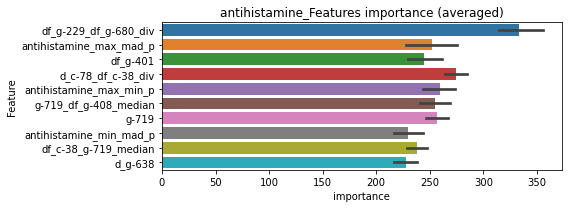

len(train_index) : 2853
len(valid_index) : 952
================================= fold 1/4 antihistamine=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0678669	valid_1's binary_logloss: 0.0811464
[200]	training's binary_logloss: 0.0168392	valid_1's binary_logloss: 0.0259226
[300]	training's binary_logloss: 0.00501742	valid_1's binary_logloss: 0.0105526
[400]	training's binary_logloss: 0.00201911	valid_1's binary_logloss: 0.00568635
[500]	training's binary_logloss: 0.00105792	valid_1's binary_logloss: 0.00380114
[600]	training's binary_logloss: 0.000684318	valid_1's binary_logloss: 0.00288744
[700]	training's binary_logloss: 0.000507405	valid_1's binary_logloss: 0.00242663
[800]	training's binary_logloss: 0.000428905	valid_1's binary_logloss: 0.00221881
[900]	training's binary_logloss: 0.000407406	valid_1's binary_logloss: 0.00218112
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000403302	valid_1's binary_logloss: 0.00216935


len(train_index) : 2854
len(valid_index) : 951
================================= fold 2/4 antihistamine=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0686262	valid_1's binary_logloss: 0.0884492
[200]	training's binary_logloss: 0.0165089	valid_1's binary_logloss: 0.0288425
[300]	training's binary_logloss: 0.00502282	valid_1's binary_logloss: 0.0115631
[400]	training's binary_logloss: 0.00202092	valid_1's binary_logloss: 0.00601445
[500]	training's binary_logloss: 0.00105863	valid_1's binary_logloss: 0.00374764
[600]	training's binary_logloss: 0.0006824	valid_1's binary_logloss: 0.00277243
[700]	training's binary_logloss: 0.000508551	valid_1's binary_logloss: 0.00222345
[800]	training's binary_logloss: 0.000429222	valid_1's binary_logloss: 0.00200302
[900]	training's binary_logloss: 0.000409913	valid_1's binary_logloss: 0.00194825
Early stopping, best iteration is:
[949]	training's binary_logloss: 0.00040235	valid_1's binary_logloss: 0.00192875


len(train_index) : 2854
len(valid_index) : 951
================================= fold 3/4 antihistamine=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679477	valid_1's binary_logloss: 0.0779031
[200]	training's binary_logloss: 0.0167338	valid_1's binary_logloss: 0.0237084
[300]	training's binary_logloss: 0.00506378	valid_1's binary_logloss: 0.00915394
[400]	training's binary_logloss: 0.00201992	valid_1's binary_logloss: 0.00447794
[500]	training's binary_logloss: 0.00105609	valid_1's binary_logloss: 0.00284937
[600]	training's binary_logloss: 0.00068009	valid_1's binary_logloss: 0.00209146
[700]	training's binary_logloss: 0.000507727	valid_1's binary_logloss: 0.00173446
[800]	training's binary_logloss: 0.000426352	valid_1's binary_logloss: 0.00155781
[900]	training's binary_logloss: 0.000404924	valid_1's binary_logloss: 0.00151038
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.000404924	valid_1's binary_logloss: 0.00151038


len(train_index) : 2854
len(valid_index) : 951
================================= fold 4/4 antihistamine=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0668797	valid_1's binary_logloss: 0.0961079
[200]	training's binary_logloss: 0.0163054	valid_1's binary_logloss: 0.0347206
[300]	training's binary_logloss: 0.0048647	valid_1's binary_logloss: 0.0149422
[400]	training's binary_logloss: 0.00194851	valid_1's binary_logloss: 0.00853182
[500]	training's binary_logloss: 0.00102487	valid_1's binary_logloss: 0.00582057
[600]	training's binary_logloss: 0.00065881	valid_1's binary_logloss: 0.00441611
[700]	training's binary_logloss: 0.000489488	valid_1's binary_logloss: 0.00371375
[800]	training's binary_logloss: 0.000418	valid_1's binary_logloss: 0.00342581
[900]	training's binary_logloss: 0.000397505	valid_1's binary_logloss: 0.00334594
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.000396648	valid_1's binary_logloss: 0.00334164


antihistamine logloss: 0.0022398253094474546
antimalarial, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0753988	valid_1's binary_logloss: 0.091115
[200]	training's binary_logloss: 0.0192086	valid_1's binary_logloss: 0.0287159
[300]	training's binary_logloss: 0.00565431	valid_1's binary_logloss: 0.010829
[400]	training's binary_logloss: 0.00212904	valid_1's binary_logloss: 0.00513436
[500]	training's binary_logloss: 0.00110149	valid_1's binary_logloss: 0.0032433
[600]	training's binary_logloss: 0.000712311	valid_1's binary_logloss: 0.00238395
[700]	training's binary_logloss: 0.000533658	valid_1's binary_logloss: 0.00199697
[800]	training's binary_logloss: 0.000442962	valid_1's binary_logloss: 0.00180705
[900]	training's binary_logloss: 0.00041283	valid_1's binary_logloss: 0.00174928
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00041338	valid_1's binary_logloss: 0.00174832
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.076

1 / 3 AUC score:1.000
y_Threshold: 0.0032860, Threshold: 0.0211716, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01482, conf_1:0.02752
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0211716
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.0511716
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0811716
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.1111716
threshold: 0.1111716, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0724272	valid_1's binary_logloss: 0.0855101
[200]	training's binary_logloss: 0.0175134	valid_1's binary_logloss: 0.0243536
[300]	training's binary_logloss: 0.00491691	valid_1's binary_logloss: 0.00841333
[400]	training's binary_logloss: 0.00187668	valid_1's binary_logloss: 0.00377947
[500]	training's binary_logloss: 0.000977676	valid_1's binary_logloss: 0.00227179
[600]	training's binary_logloss: 0.000647468	valid_1's binary_logloss: 0.00167229
[700]	training's binary_logloss: 0.000482985	valid_1's binary_logloss: 0.00137145
[800]	training's binary_logloss: 0.000408758	valid_1's binary_logloss: 0.00121659
[900]	training's binary_logloss: 0.000381654	valid_1's binary_logloss: 0.00116791
Early stopping, best iteration is:
[882]	training's binary_logloss: 0.000381866	valid_1's binary_logloss: 0.00116783
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1624596, Threshold: 0.1111716, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0062783 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.08894, conf_1:0.13341
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.1111716
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.1411716
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.1711716
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.2011716
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.2311716
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.2611716
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_7: 0.2911716
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.3211716
threshold: 0.3211716, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0724272	valid_1's binary_logloss: 0.0855101
[200]	training's binary_logloss: 0.0175134	valid_1's binary_logloss: 0.0243536
[300]	training's binary_logloss: 0.00491691	valid_1's binary_logloss: 0.00841333
[400]	training's binary_logloss: 0.00187668	valid_1's binary_logloss: 0.00377947
[500]	training's binary_logloss: 0.000977676	valid_1's binary_logloss: 0.00227179
[600]	training's binary_logloss: 0.000647468	valid_1's binary_logloss: 0.00167229
[700]	training's binary_logloss: 0.000482985	valid_1's binary_logloss: 0.00137145
[800]	training's binary_logloss: 0.000408758	valid_1's binary_logloss: 0.00121659
[900]	training's binary_logloss: 0.000381654	valid_1's binary_logloss: 0.00116791
Early stopping, best iteration is:
[882]	training's binary_logloss: 0.000381866	valid_1's binary_logloss: 0.00116783
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1624596, Threshold: 0.3211716, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.28905, conf_1:0.35329
threshold: 0.3211716, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


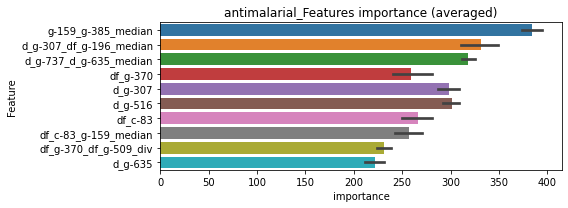

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 antimalarial=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0719082	valid_1's binary_logloss: 0.0852476
[200]	training's binary_logloss: 0.0175495	valid_1's binary_logloss: 0.02566
[300]	training's binary_logloss: 0.0048697	valid_1's binary_logloss: 0.00912497
[400]	training's binary_logloss: 0.00185458	valid_1's binary_logloss: 0.00450954
[500]	training's binary_logloss: 0.000969945	valid_1's binary_logloss: 0.00287073
[600]	training's binary_logloss: 0.000637279	valid_1's binary_logloss: 0.00213205
[700]	training's binary_logloss: 0.000482128	valid_1's binary_logloss: 0.00181052
[800]	training's binary_logloss: 0.000407767	valid_1's binary_logloss: 0.00163402
Early stopping, best iteration is:
[840]	training's binary_logloss: 0.000395588	valid_1's binary_logloss: 0.00160571


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 antimalarial=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0726821	valid_1's binary_logloss: 0.0908166
[200]	training's binary_logloss: 0.0176105	valid_1's binary_logloss: 0.0298455
[300]	training's binary_logloss: 0.00494492	valid_1's binary_logloss: 0.0113085
[400]	training's binary_logloss: 0.00188399	valid_1's binary_logloss: 0.00553979
[500]	training's binary_logloss: 0.000979402	valid_1's binary_logloss: 0.00343515
[600]	training's binary_logloss: 0.000640465	valid_1's binary_logloss: 0.00253142
[700]	training's binary_logloss: 0.000482179	valid_1's binary_logloss: 0.00209944
[800]	training's binary_logloss: 0.000404414	valid_1's binary_logloss: 0.00188605
[900]	training's binary_logloss: 0.000377781	valid_1's binary_logloss: 0.00182249
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000377815	valid_1's binary_logloss: 0.00182236


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 antimalarial=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0732896	valid_1's binary_logloss: 0.0823939
[200]	training's binary_logloss: 0.0179379	valid_1's binary_logloss: 0.0229537
[300]	training's binary_logloss: 0.00500426	valid_1's binary_logloss: 0.0073903
[400]	training's binary_logloss: 0.00192399	valid_1's binary_logloss: 0.0031581
[500]	training's binary_logloss: 0.00101433	valid_1's binary_logloss: 0.00182737
[600]	training's binary_logloss: 0.00066152	valid_1's binary_logloss: 0.00124669
[700]	training's binary_logloss: 0.000496136	valid_1's binary_logloss: 0.000977077
[800]	training's binary_logloss: 0.000411933	valid_1's binary_logloss: 0.000825096
[900]	training's binary_logloss: 0.000394176	valid_1's binary_logloss: 0.000794444
Early stopping, best iteration is:
[881]	training's binary_logloss: 0.000394176	valid_1's binary_logloss: 0.000794444


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 antimalarial=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0722091	valid_1's binary_logloss: 0.0823888
[200]	training's binary_logloss: 0.0175832	valid_1's binary_logloss: 0.023862
[300]	training's binary_logloss: 0.00502267	valid_1's binary_logloss: 0.00842957
[400]	training's binary_logloss: 0.00189594	valid_1's binary_logloss: 0.00396707
[500]	training's binary_logloss: 0.000988972	valid_1's binary_logloss: 0.00250042
[600]	training's binary_logloss: 0.00064447	valid_1's binary_logloss: 0.00187174
[700]	training's binary_logloss: 0.000483719	valid_1's binary_logloss: 0.00156916
[800]	training's binary_logloss: 0.000406019	valid_1's binary_logloss: 0.00141933
[900]	training's binary_logloss: 0.000383988	valid_1's binary_logloss: 0.00137884
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.000384178	valid_1's binary_logloss: 0.00137806


antimalarial logloss: 0.0014003856976084355
antioxidant, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133298	valid_1's binary_logloss: 0.197021
[200]	training's binary_logloss: 0.0569647	valid_1's binary_logloss: 0.126309
[300]	training's binary_logloss: 0.026149	valid_1's binary_logloss: 0.0902248
[400]	training's binary_logloss: 0.0129801	valid_1's binary_logloss: 0.0711853
[500]	training's binary_logloss: 0.00695529	valid_1's binary_logloss: 0.0600988
[600]	training's binary_logloss: 0.00405788	valid_1's binary_logloss: 0.0531976
[700]	training's binary_logloss: 0.00263663	valid_1's binary_logloss: 0.0495726
[800]	training's binary_logloss: 0.00188997	valid_1's binary_logloss: 0.0476489
[900]	training's binary_logloss: 0.00146094	valid_1's binary_logloss: 0.0461141
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.00134946	valid_1's binary_logloss: 0.0456519
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135826	valid_1's

1 / 3 AUC score:0.992
y_Threshold: 0.0283745, Threshold: 0.1314461, pos_neg_ratio: 0.8000000
Remove_noisy_data: 164 → Positive_corect_labels: 640/3773
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.09201, conf_1:0.17088
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.1314461
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_2: 0.1614461
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_3: 0.1914461
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_4: 0.2214461
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_5: 0.2514461
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_6: 0.2814461
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_7: 0.3114461
threshold: 0.3114461, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 640.0/3773, y_label_rate: 0.1696263
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122642	valid_1's binary_logloss: 0.177685
[200]	training's binary_logloss: 0.0487622	valid_1's binary_logloss: 0.107414
[300]	training's binary_logloss: 0.0215709	valid_1's binary_logloss: 0.0780904
[400]	training's binary_logloss: 0.0101609	valid_1's binary_logloss: 0.0623902
[500]	training's binary_logloss: 0.00527591	valid_1's binary_logloss: 0.0551356
[600]	training's binary_logloss: 0.00311265	valid_1's binary_logloss: 0.0510538
[700]	training's binary_logloss: 0.00204596	valid_1's binary_logloss: 0.0492565
[800]	training's binary_logloss: 0.00150039	valid_1's binary_logloss: 0.0482729
Early stopping, best iteration is:
[811]	training's binary_logloss: 0.00145825	valid_1's binary_logloss: 0.0481596
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126269	valid_1's binary_logloss: 0.173068
[200]	training's binary_logloss: 0.0497287	valid_1's 

2 / 3 AUC score:0.997
y_Threshold: 0.0926197, Threshold: 0.3114461, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 618.0/3729
p_label_rate: 0.0133099 Vs.target_rate: 0.00307, Num_p_label: 53.0, conf_0:0.24916, conf_1:0.37374
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_1: 0.3114461
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_2: 0.3414461
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_3: 0.3714461
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_4: 0.4014461
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_5: 0.4314461
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_6: 0.4614461
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_7: 0.4914461
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_8: 0.5214461
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_9: 0.5514461
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_10: 0.5814461
threshold: 0.6114461, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 618.0/3729, y_label_rate: 0.1657281

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116491	valid_1's binary_logloss: 0.161765
[200]	training's binary_logloss: 0.0441635	valid_1's binary_logloss: 0.0914187
[300]	training's binary_logloss: 0.0183433	valid_1's binary_logloss: 0.0623926
[400]	training's binary_logloss: 0.00848341	valid_1's binary_logloss: 0.0475938
[500]	training's binary_logloss: 0.00440355	valid_1's binary_logloss: 0.0396402
[600]	training's binary_logloss: 0.00261552	valid_1's binary_logloss: 0.0360665
[700]	training's binary_logloss: 0.00176409	valid_1's binary_logloss: 0.0334063
[800]	training's binary_logloss: 0.00131207	valid_1's binary_logloss: 0.0322638
[900]	training's binary_logloss: 0.0010497	valid_1's binary_logloss: 0.0314687
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00103903	valid_1's binary_logloss: 0.0314315
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116046	valid_1

3 / 3 AUC score:0.999
y_Threshold: 0.0751106, Threshold: 0.6114461, pos_neg_ratio: 0.8000000
Remove_noisy_data: 28 → Positive_corect_labels: 604.0/3701
p_label_rate: 0.0085384 Vs.target_rate: 0.00307, Num_p_label: 34.0, conf_0:0.50000, conf_1:0.67259
threshold: 0.6114461, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 604.0/3701, y_label_rate: 0.1631991


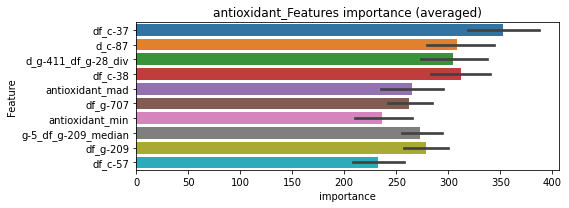

len(train_index) : 2775
len(valid_index) : 926
================================= fold 1/4 antioxidant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110675	valid_1's binary_logloss: 0.161867
[200]	training's binary_logloss: 0.039506	valid_1's binary_logloss: 0.0929745
[300]	training's binary_logloss: 0.016384	valid_1's binary_logloss: 0.065253
[400]	training's binary_logloss: 0.0075587	valid_1's binary_logloss: 0.052242
[500]	training's binary_logloss: 0.00386204	valid_1's binary_logloss: 0.0451362
[600]	training's binary_logloss: 0.00231559	valid_1's binary_logloss: 0.0416813
[700]	training's binary_logloss: 0.00158886	valid_1's binary_logloss: 0.0395115
[800]	training's binary_logloss: 0.00119386	valid_1's binary_logloss: 0.0383799
Early stopping, best iteration is:
[857]	training's binary_logloss: 0.00104444	valid_1's binary_logloss: 0.037485


len(train_index) : 2776
len(valid_index) : 925
================================= fold 2/4 antioxidant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107067	valid_1's binary_logloss: 0.159414
[200]	training's binary_logloss: 0.0388102	valid_1's binary_logloss: 0.0867802
[300]	training's binary_logloss: 0.0161092	valid_1's binary_logloss: 0.054892
[400]	training's binary_logloss: 0.00767152	valid_1's binary_logloss: 0.0394926
[500]	training's binary_logloss: 0.00395491	valid_1's binary_logloss: 0.0309997
[600]	training's binary_logloss: 0.00238248	valid_1's binary_logloss: 0.0269909
[700]	training's binary_logloss: 0.00160172	valid_1's binary_logloss: 0.0238178
[800]	training's binary_logloss: 0.0011967	valid_1's binary_logloss: 0.0220849
[900]	training's binary_logloss: 0.000959975	valid_1's binary_logloss: 0.0209525
[1000]	training's binary_logloss: 0.000827198	valid_1's binary_logloss: 0.0202912
[1100]	training's binary_logloss: 0.000745167	valid_1's binary_logloss: 0.020108
Early stopping, best iteration is:
[1146]	training's binary_lo

len(train_index) : 2776
len(valid_index) : 925
================================= fold 3/4 antioxidant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110373	valid_1's binary_logloss: 0.147497
[200]	training's binary_logloss: 0.0396259	valid_1's binary_logloss: 0.0751741
[300]	training's binary_logloss: 0.0163325	valid_1's binary_logloss: 0.0458231
[400]	training's binary_logloss: 0.00744345	valid_1's binary_logloss: 0.032749
[500]	training's binary_logloss: 0.00386771	valid_1's binary_logloss: 0.0266834
[600]	training's binary_logloss: 0.00233407	valid_1's binary_logloss: 0.0241123
[700]	training's binary_logloss: 0.00159332	valid_1's binary_logloss: 0.022598
[800]	training's binary_logloss: 0.00119969	valid_1's binary_logloss: 0.0218445
[900]	training's binary_logloss: 0.000966614	valid_1's binary_logloss: 0.0212971
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.000970615	valid_1's binary_logloss: 0.0212755


len(train_index) : 2776
len(valid_index) : 925
================================= fold 4/4 antioxidant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113529	valid_1's binary_logloss: 0.152759
[200]	training's binary_logloss: 0.0410727	valid_1's binary_logloss: 0.0789212
[300]	training's binary_logloss: 0.016932	valid_1's binary_logloss: 0.0480209
[400]	training's binary_logloss: 0.00788897	valid_1's binary_logloss: 0.034623
[500]	training's binary_logloss: 0.00410036	valid_1's binary_logloss: 0.0272374
[600]	training's binary_logloss: 0.00246778	valid_1's binary_logloss: 0.0233003
[700]	training's binary_logloss: 0.00166997	valid_1's binary_logloss: 0.0213689
[800]	training's binary_logloss: 0.00125197	valid_1's binary_logloss: 0.0197188
[900]	training's binary_logloss: 0.00100072	valid_1's binary_logloss: 0.0190271
[1000]	training's binary_logloss: 0.000854873	valid_1's binary_logloss: 0.0186565
Early stopping, best iteration is:
[1065]	training's binary_logloss: 0.000801634	valid_1's binary_logloss: 0.0184505


antioxidant logloss: 0.024269175827651004
antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096479	valid_1's binary_logloss: 0.141136
[200]	training's binary_logloss: 0.0333589	valid_1's binary_logloss: 0.0696619
[300]	training's binary_logloss: 0.0128758	valid_1's binary_logloss: 0.0397469
[400]	training's binary_logloss: 0.00562901	valid_1's binary_logloss: 0.0262779
[500]	training's binary_logloss: 0.00278655	valid_1's binary_logloss: 0.0185767
[600]	training's binary_logloss: 0.00168659	valid_1's binary_logloss: 0.014998
[700]	training's binary_logloss: 0.00117145	valid_1's binary_logloss: 0.01288
[800]	training's binary_logloss: 0.000901767	valid_1's binary_logloss: 0.0117995
[900]	training's binary_logloss: 0.000748858	valid_1's binary_logloss: 0.0109924
[1000]	training's binary_logloss: 0.000678833	valid_1's binary_logloss: 0.0106153
[1100]	training's binary_logloss: 0.000658045	valid_1's binary_logloss: 0.0104877
Early stopping, best iteration is:
[1091]	training's binary_l

1 / 3 AUC score:1.000
y_Threshold: 0.0119700, Threshold: 0.0763977, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.05348, conf_1:0.09932
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0763977
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.1063977
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.1363977
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_4: 0.1663977
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.1963977
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.2263977
threshold: 0.2263977, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0927883	valid_1's binary_logloss: 0.129893
[200]	training's binary_logloss: 0.0293439	valid_1's binary_logloss: 0.0625499
[300]	training's binary_logloss: 0.01043	valid_1's binary_logloss: 0.0361005
[400]	training's binary_logloss: 0.00438118	valid_1's binary_logloss: 0.0242965
[500]	training's binary_logloss: 0.00223839	valid_1's binary_logloss: 0.0192087
[600]	training's binary_logloss: 0.00136666	valid_1's binary_logloss: 0.0166735
[700]	training's binary_logloss: 0.000967748	valid_1's binary_logloss: 0.0152739
[800]	training's binary_logloss: 0.000762743	valid_1's binary_logloss: 0.0147597
Early stopping, best iteration is:
[831]	training's binary_logloss: 0.000717603	valid_1's binary_logloss: 0.014556
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933018	valid_1's binary_logloss: 0.138564
[200]	training's binary_logloss: 0.0298468	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1084513, Threshold: 0.2263977, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 647.0/3789
p_label_rate: 0.0178302 Vs.target_rate: 0.00151, Num_p_label: 71.0, conf_0:0.18112, conf_1:0.27168
Num_p_label: 71.0, Expected: 6.0, Adj_threshold_1: 0.2263977
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_2: 0.2563977
Num_p_label: 59.0, Expected: 6.0, Adj_threshold_3: 0.2863977
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_4: 0.3163977
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_5: 0.3463977
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_6: 0.3763977
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_7: 0.4063977
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_8: 0.4363977
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_9: 0.4663977
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_10: 0.4963977
threshold: 0.5263977, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 647.0/3789, y_label_rate: 0.1707575
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0919133	valid_1's binary_logloss: 0.133016
[200]	training's binary_logloss: 0.0286639	valid_1's binary_logloss: 0.0604941
[300]	training's binary_logloss: 0.010245	valid_1's binary_logloss: 0.0313294
[400]	training's binary_logloss: 0.00424988	valid_1's binary_logloss: 0.019811
[500]	training's binary_logloss: 0.00215501	valid_1's binary_logloss: 0.0143086
[600]	training's binary_logloss: 0.00132633	valid_1's binary_logloss: 0.0115481
[700]	training's binary_logloss: 0.000942991	valid_1's binary_logloss: 0.0102957
[800]	training's binary_logloss: 0.000743067	valid_1's binary_logloss: 0.00954294
[900]	training's binary_logloss: 0.000631785	valid_1's binary_logloss: 0.00910397
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000603063	valid_1's binary_logloss: 0.00897599
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0906517

3 / 3 AUC score:1.000
y_Threshold: 0.1300146, Threshold: 0.5263977, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 644.0/3783
p_label_rate: 0.0092918 Vs.target_rate: 0.00151, Num_p_label: 37.0, conf_0:0.47376, conf_1:0.57904
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_1: 0.5263977
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_2: 0.5563977
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.5863977
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_4: 0.6163977
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_5: 0.6463977
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_6: 0.6763977
threshold: 0.6763977, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 644.0/3783, y_label_rate: 0.1702353


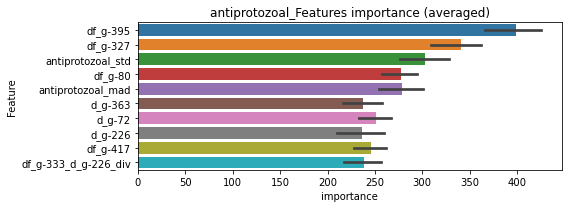

len(train_index) : 2837
len(valid_index) : 946
================================= fold 1/4 antiprotozoal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0897884	valid_1's binary_logloss: 0.125319
[200]	training's binary_logloss: 0.0281089	valid_1's binary_logloss: 0.0538873
[300]	training's binary_logloss: 0.0102767	valid_1's binary_logloss: 0.0283682
[400]	training's binary_logloss: 0.00423473	valid_1's binary_logloss: 0.0170302
[500]	training's binary_logloss: 0.00214041	valid_1's binary_logloss: 0.0122346
[600]	training's binary_logloss: 0.00132274	valid_1's binary_logloss: 0.00997509
[700]	training's binary_logloss: 0.000936229	valid_1's binary_logloss: 0.00866004
[800]	training's binary_logloss: 0.000731719	valid_1's binary_logloss: 0.0079107
[900]	training's binary_logloss: 0.000628268	valid_1's binary_logloss: 0.00753663
[1000]	training's binary_logloss: 0.000581705	valid_1's binary_logloss: 0.00735142
Early stopping, best iteration is:
[1042]	training's binary_logloss: 0.000569924	valid_1's binary_logloss: 0.00726457


len(train_index) : 2837
len(valid_index) : 946
================================= fold 2/4 antiprotozoal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0904677	valid_1's binary_logloss: 0.134941
[200]	training's binary_logloss: 0.027659	valid_1's binary_logloss: 0.0641117
[300]	training's binary_logloss: 0.00982474	valid_1's binary_logloss: 0.0395928
[400]	training's binary_logloss: 0.00412985	valid_1's binary_logloss: 0.0291365
[500]	training's binary_logloss: 0.00208901	valid_1's binary_logloss: 0.0235687
[600]	training's binary_logloss: 0.00128271	valid_1's binary_logloss: 0.0213838
[700]	training's binary_logloss: 0.000913556	valid_1's binary_logloss: 0.0200834
Early stopping, best iteration is:
[681]	training's binary_logloss: 0.000966566	valid_1's binary_logloss: 0.0200607


len(train_index) : 2837
len(valid_index) : 946
================================= fold 3/4 antiprotozoal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0934458	valid_1's binary_logloss: 0.123635
[200]	training's binary_logloss: 0.0289555	valid_1's binary_logloss: 0.0515638
[300]	training's binary_logloss: 0.0103764	valid_1's binary_logloss: 0.0258494
[400]	training's binary_logloss: 0.00431276	valid_1's binary_logloss: 0.0166256
[500]	training's binary_logloss: 0.00216466	valid_1's binary_logloss: 0.011463
[600]	training's binary_logloss: 0.00132369	valid_1's binary_logloss: 0.00878879
[700]	training's binary_logloss: 0.000944186	valid_1's binary_logloss: 0.00748784
[800]	training's binary_logloss: 0.000739488	valid_1's binary_logloss: 0.0071582
[900]	training's binary_logloss: 0.000634387	valid_1's binary_logloss: 0.0065951
[1000]	training's binary_logloss: 0.000586288	valid_1's binary_logloss: 0.00639324
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.000585834	valid_1's binary_logloss: 0.00638316


len(train_index) : 2838
len(valid_index) : 945
================================= fold 4/4 antiprotozoal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0922769	valid_1's binary_logloss: 0.121351
[200]	training's binary_logloss: 0.0290898	valid_1's binary_logloss: 0.0531084
[300]	training's binary_logloss: 0.0104607	valid_1's binary_logloss: 0.0296268
[400]	training's binary_logloss: 0.00430396	valid_1's binary_logloss: 0.0204055
[500]	training's binary_logloss: 0.00216906	valid_1's binary_logloss: 0.016937
[600]	training's binary_logloss: 0.00132224	valid_1's binary_logloss: 0.015015
[700]	training's binary_logloss: 0.000933464	valid_1's binary_logloss: 0.0144003
Early stopping, best iteration is:
[767]	training's binary_logloss: 0.000789669	valid_1's binary_logloss: 0.0139938


antiprotozoal logloss: 0.011927207913001014


neg labels: 3289 → selected neg labels: 3282


antiviral, len(trt): 23, len(othr): 3282, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0769017	valid_1's binary_logloss: 0.100947
[200]	training's binary_logloss: 0.0210817	valid_1's binary_logloss: 0.0380211
[300]	training's binary_logloss: 0.00683027	valid_1's binary_logloss: 0.018666
[400]	training's binary_logloss: 0.00271073	valid_1's binary_logloss: 0.0108875
[500]	training's binary_logloss: 0.00139077	valid_1's binary_logloss: 0.00777952
[600]	training's binary_logloss: 0.000887965	valid_1's binary_logloss: 0.00637071
[700]	training's binary_logloss: 0.000643837	valid_1's binary_logloss: 0.00562768
[800]	training's binary_logloss: 0.000512707	valid_1's binary_logloss: 0.00513817
[900]	training's binary_logloss: 0.000449526	valid_1's binary_logloss: 0.00496368
Early stopping, best iteration is:
[946]	training's binary_logloss: 0.000433705	valid_1's binary_logloss: 0.00492406
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0055487, Threshold: 0.0307643, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00097, Num_p_label: 40.0, conf_0:0.02154, conf_1:0.03999
Num_p_label: 40.0, Expected: 3.8, Adj_threshold_1: 0.0307643
Num_p_label: 23.0, Expected: 3.8, Adj_threshold_2: 0.0607643
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_3: 0.0907643
threshold: 0.0907643, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0732814	valid_1's binary_logloss: 0.0964914
[200]	training's binary_logloss: 0.01903	valid_1's binary_logloss: 0.0354115
[300]	training's binary_logloss: 0.0058779	valid_1's binary_logloss: 0.0165213
[400]	training's binary_logloss: 0.00233708	valid_1's binary_logloss: 0.00981862
[500]	training's binary_logloss: 0.00122396	valid_1's binary_logloss: 0.0071099
[600]	training's binary_logloss: 0.000778067	valid_1's binary_logloss: 0.00573736
[700]	training's binary_logloss: 0.000567964	valid_1's binary_logloss: 0.00508217
[800]	training's binary_logloss: 0.000453696	valid_1's binary_logloss: 0.00470176
[900]	training's binary_logloss: 0.000399866	valid_1's binary_logloss: 0.00452155
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.000401122	valid_1's binary_logloss: 0.00451827
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

2 / 3 AUC score:1.000
y_Threshold: 0.0384951, Threshold: 0.0907643, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00097, Num_p_label: 40.0, conf_0:0.07261, conf_1:0.10892
Num_p_label: 40.0, Expected: 3.8, Adj_threshold_1: 0.0907643
Num_p_label: 27.0, Expected: 3.8, Adj_threshold_2: 0.1207643
Num_p_label: 21.0, Expected: 3.8, Adj_threshold_3: 0.1507643
Num_p_label: 18.0, Expected: 3.8, Adj_threshold_4: 0.1807643
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_5: 0.2107643
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_6: 0.2407643
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_7: 0.2707643
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_8: 0.3007643
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_9: 0.3307643
threshold: 0.3307643, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0727589	valid_1's binary_logloss: 0.103833
[200]	training's binary_logloss: 0.0188245	valid_1's binary_logloss: 0.0441135
[300]	training's binary_logloss: 0.00594151	valid_1's binary_logloss: 0.0241328
[400]	training's binary_logloss: 0.00234881	valid_1's binary_logloss: 0.0165286
[500]	training's binary_logloss: 0.0012304	valid_1's binary_logloss: 0.0137453
[600]	training's binary_logloss: 0.00078178	valid_1's binary_logloss: 0.0122545
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000812412	valid_1's binary_logloss: 0.0121191
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0736136	valid_1's binary_logloss: 0.0944019
[200]	training's binary_logloss: 0.0190809	valid_1's binary_logloss: 0.0354128
[300]	training's binary_logloss: 0.00582385	valid_1's binary_logloss: 0.0181173
[400]	training's binary_logloss: 0.00231647	vali

3 / 3 AUC score:1.000
y_Threshold: 0.0530971, Threshold: 0.3307643, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0022602 Vs.target_rate: 0.00097, Num_p_label: 9.0, conf_0:0.29769, conf_1:0.36384
threshold: 0.3307643, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 654.0/3802, y_label_rate: 0.1720147


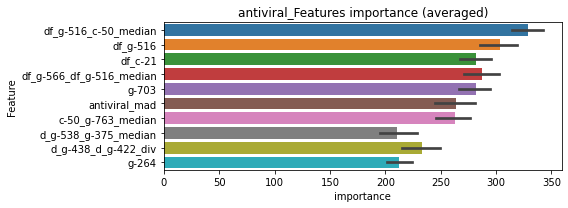

len(train_index) : 2851
len(valid_index) : 951
================================= fold 1/4 antiviral=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0733589	valid_1's binary_logloss: 0.106081
[200]	training's binary_logloss: 0.0187514	valid_1's binary_logloss: 0.0457996
[300]	training's binary_logloss: 0.00578623	valid_1's binary_logloss: 0.0263723
[400]	training's binary_logloss: 0.00230056	valid_1's binary_logloss: 0.0191417
[500]	training's binary_logloss: 0.0011974	valid_1's binary_logloss: 0.0163616
[600]	training's binary_logloss: 0.000761603	valid_1's binary_logloss: 0.0147132
[700]	training's binary_logloss: 0.000557693	valid_1's binary_logloss: 0.014434
Early stopping, best iteration is:
[761]	training's binary_logloss: 0.000483657	valid_1's binary_logloss: 0.0141048


len(train_index) : 2851
len(valid_index) : 951
================================= fold 2/4 antiviral=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0721202	valid_1's binary_logloss: 0.0908304
[200]	training's binary_logloss: 0.0184722	valid_1's binary_logloss: 0.0318729
[300]	training's binary_logloss: 0.00574462	valid_1's binary_logloss: 0.0131498
[400]	training's binary_logloss: 0.00229719	valid_1's binary_logloss: 0.00659948
[500]	training's binary_logloss: 0.00119181	valid_1's binary_logloss: 0.0041213
[600]	training's binary_logloss: 0.000763188	valid_1's binary_logloss: 0.00303336
[700]	training's binary_logloss: 0.00056063	valid_1's binary_logloss: 0.00243311
[800]	training's binary_logloss: 0.000450482	valid_1's binary_logloss: 0.00212594
[900]	training's binary_logloss: 0.000407455	valid_1's binary_logloss: 0.00199451
Early stopping, best iteration is:
[947]	training's binary_logloss: 0.000395699	valid_1's binary_logloss: 0.00197117


len(train_index) : 2852
len(valid_index) : 950
================================= fold 3/4 antiviral=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0747395	valid_1's binary_logloss: 0.0871262
[200]	training's binary_logloss: 0.01955	valid_1's binary_logloss: 0.028153
[300]	training's binary_logloss: 0.00603015	valid_1's binary_logloss: 0.0110164
[400]	training's binary_logloss: 0.00239631	valid_1's binary_logloss: 0.00570272
[500]	training's binary_logloss: 0.00123517	valid_1's binary_logloss: 0.00361932
[600]	training's binary_logloss: 0.00079168	valid_1's binary_logloss: 0.00265118
[700]	training's binary_logloss: 0.000576824	valid_1's binary_logloss: 0.00218072
[800]	training's binary_logloss: 0.000464163	valid_1's binary_logloss: 0.00192561
[900]	training's binary_logloss: 0.000415453	valid_1's binary_logloss: 0.0018096
Early stopping, best iteration is:
[968]	training's binary_logloss: 0.000405635	valid_1's binary_logloss: 0.0017825


len(train_index) : 2852
len(valid_index) : 950
================================= fold 4/4 antiviral=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0730873	valid_1's binary_logloss: 0.0891211
[200]	training's binary_logloss: 0.0189758	valid_1's binary_logloss: 0.0308844
[300]	training's binary_logloss: 0.00585664	valid_1's binary_logloss: 0.014376
[400]	training's binary_logloss: 0.00232011	valid_1's binary_logloss: 0.00795766
[500]	training's binary_logloss: 0.00121089	valid_1's binary_logloss: 0.00543426
[600]	training's binary_logloss: 0.000774812	valid_1's binary_logloss: 0.00433387
[700]	training's binary_logloss: 0.000567331	valid_1's binary_logloss: 0.00369309
[800]	training's binary_logloss: 0.000457828	valid_1's binary_logloss: 0.00334712
[900]	training's binary_logloss: 0.000409981	valid_1's binary_logloss: 0.00321552
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.000408997	valid_1's binary_logloss: 0.00320694


antiviral logloss: 0.005268709328015927
apoptosis_stimulant, len(trt): 49, len(othr): 3283, target_rate: 0.0020576 → Adj_target_rate: 0.0022954


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109202	valid_1's binary_logloss: 0.176727
[200]	training's binary_logloss: 0.039998	valid_1's binary_logloss: 0.101765
[300]	training's binary_logloss: 0.0160909	valid_1's binary_logloss: 0.0668194
[400]	training's binary_logloss: 0.00733986	valid_1's binary_logloss: 0.0486169
[500]	training's binary_logloss: 0.00384426	valid_1's binary_logloss: 0.0386577
[600]	training's binary_logloss: 0.00234756	valid_1's binary_logloss: 0.034076
[700]	training's binary_logloss: 0.00161782	valid_1's binary_logloss: 0.0311118
[800]	training's binary_logloss: 0.00121524	valid_1's binary_logloss: 0.0291557
[900]	training's binary_logloss: 0.000988196	valid_1's binary_logloss: 0.0282308
[1000]	training's binary_logloss: 0.00085295	valid_1's binary_logloss: 0.0277404
[1100]	training's binary_logloss: 0.000772784	valid_1's binary_logloss: 0.0275017
Early stopping, best iteration is:
[1080]	training's binary_log

1 / 3 AUC score:0.999
y_Threshold: 0.0210396, Threshold: 0.2470274, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00206, Num_p_label: 40.0, conf_0:0.17292, conf_1:0.32114
Num_p_label: 40.0, Expected: 8.2, Adj_threshold_1: 0.2470274
Num_p_label: 36.0, Expected: 8.2, Adj_threshold_2: 0.2770274
Num_p_label: 27.0, Expected: 8.2, Adj_threshold_3: 0.3070274
Num_p_label: 25.0, Expected: 8.2, Adj_threshold_4: 0.3370274
Num_p_label: 21.0, Expected: 8.2, Adj_threshold_5: 0.3670274
Num_p_label: 20.0, Expected: 8.2, Adj_threshold_6: 0.3970274
threshold: 0.3970274, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104504	valid_1's binary_logloss: 0.166963
[200]	training's binary_logloss: 0.0357262	valid_1's binary_logloss: 0.0912252
[300]	training's binary_logloss: 0.0144003	valid_1's binary_logloss: 0.0598394
[400]	training's binary_logloss: 0.00635398	valid_1's binary_logloss: 0.0438145
[500]	training's binary_logloss: 0.00328559	valid_1's binary_logloss: 0.0357292
[600]	training's binary_logloss: 0.00201906	valid_1's binary_logloss: 0.0321021
[700]	training's binary_logloss: 0.0013927	valid_1's binary_logloss: 0.0300223
[800]	training's binary_logloss: 0.00105708	valid_1's binary_logloss: 0.0289153
[900]	training's binary_logloss: 0.000864523	valid_1's binary_logloss: 0.0284091
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.000836612	valid_1's binary_logloss: 0.0282118
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104915	valid

2 / 3 AUC score:1.000
y_Threshold: 0.1513487, Threshold: 0.3970274, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 642.0/3779
p_label_rate: 0.0173280 Vs.target_rate: 0.00206, Num_p_label: 69.0, conf_0:0.31762, conf_1:0.47643
Num_p_label: 69.0, Expected: 8.2, Adj_threshold_1: 0.3970274
Num_p_label: 62.0, Expected: 8.2, Adj_threshold_2: 0.4270274
Num_p_label: 59.0, Expected: 8.2, Adj_threshold_3: 0.4570274
Num_p_label: 55.0, Expected: 8.2, Adj_threshold_4: 0.4870274
Num_p_label: 51.0, Expected: 8.2, Adj_threshold_5: 0.5170274
Num_p_label: 47.0, Expected: 8.2, Adj_threshold_6: 0.5470274
Num_p_label: 44.0, Expected: 8.2, Adj_threshold_7: 0.5770274
Num_p_label: 39.0, Expected: 8.2, Adj_threshold_8: 0.6070274
Num_p_label: 37.0, Expected: 8.2, Adj_threshold_9: 0.6370274
Num_p_label: 31.0, Expected: 8.2, Adj_threshold_10: 0.6670274
threshold: 0.6970274, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 642.0/3779, y_label_rate: 0.1698862
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103772	valid_1's binary_logloss: 0.152186
[200]	training's binary_logloss: 0.0349556	valid_1's binary_logloss: 0.0756618
[300]	training's binary_logloss: 0.0136321	valid_1's binary_logloss: 0.0434546
[400]	training's binary_logloss: 0.0060486	valid_1's binary_logloss: 0.0280792
[500]	training's binary_logloss: 0.00312509	valid_1's binary_logloss: 0.0201451
[600]	training's binary_logloss: 0.00191524	valid_1's binary_logloss: 0.0161716
[700]	training's binary_logloss: 0.00133866	valid_1's binary_logloss: 0.0137745
[800]	training's binary_logloss: 0.00102546	valid_1's binary_logloss: 0.0123286
[900]	training's binary_logloss: 0.000848269	valid_1's binary_logloss: 0.0116818
[1000]	training's binary_logloss: 0.00073795	valid_1's binary_logloss: 0.0113233
[1100]	training's binary_logloss: 0.000696737	valid_1's binary_logloss: 0.0110875
Early stopping, best iteration is:
[1141]	training's binary_l

3 / 3 AUC score:0.999
y_Threshold: 0.1118318, Threshold: 0.6970274, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 636.0/3767
p_label_rate: 0.0077850 Vs.target_rate: 0.00206, Num_p_label: 31.0, conf_0:0.50000, conf_1:0.76673
Num_p_label: 31.0, Expected: 8.2, Adj_threshold_1: 0.6970274
threshold: 0.6970274, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 636.0/3767, y_label_rate: 0.1688346


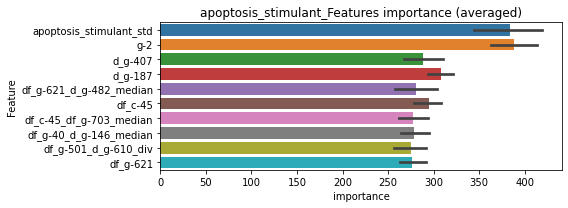

len(train_index) : 2825
len(valid_index) : 942
================================= fold 1/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101436	valid_1's binary_logloss: 0.148586
[200]	training's binary_logloss: 0.03421	valid_1's binary_logloss: 0.0806358
[300]	training's binary_logloss: 0.0130714	valid_1's binary_logloss: 0.0510311
[400]	training's binary_logloss: 0.00578911	valid_1's binary_logloss: 0.0394318
[500]	training's binary_logloss: 0.0029654	valid_1's binary_logloss: 0.0330475
[600]	training's binary_logloss: 0.00183434	valid_1's binary_logloss: 0.0303284
[700]	training's binary_logloss: 0.00128347	valid_1's binary_logloss: 0.0287814
[800]	training's binary_logloss: 0.000985513	valid_1's binary_logloss: 0.0281165
[900]	training's binary_logloss: 0.000812487	valid_1's binary_logloss: 0.0275334
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000807586	valid_1's binary_logloss: 0.0275044


len(train_index) : 2825
len(valid_index) : 942
================================= fold 2/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0987577	valid_1's binary_logloss: 0.147096
[200]	training's binary_logloss: 0.0326692	valid_1's binary_logloss: 0.07145
[300]	training's binary_logloss: 0.0122642	valid_1's binary_logloss: 0.041321
[400]	training's binary_logloss: 0.00536039	valid_1's binary_logloss: 0.0279832
[500]	training's binary_logloss: 0.00281981	valid_1's binary_logloss: 0.0217479
[600]	training's binary_logloss: 0.00175841	valid_1's binary_logloss: 0.0189463
[700]	training's binary_logloss: 0.00124721	valid_1's binary_logloss: 0.0169858
[800]	training's binary_logloss: 0.000971067	valid_1's binary_logloss: 0.0157544
[900]	training's binary_logloss: 0.0008063	valid_1's binary_logloss: 0.0150477
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.00079618	valid_1's binary_logloss: 0.0149938


len(train_index) : 2825
len(valid_index) : 942
================================= fold 3/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100882	valid_1's binary_logloss: 0.137342
[200]	training's binary_logloss: 0.0330929	valid_1's binary_logloss: 0.0664679
[300]	training's binary_logloss: 0.0126924	valid_1's binary_logloss: 0.0397396
[400]	training's binary_logloss: 0.00555771	valid_1's binary_logloss: 0.0277863
[500]	training's binary_logloss: 0.00292385	valid_1's binary_logloss: 0.0225936
[600]	training's binary_logloss: 0.00181382	valid_1's binary_logloss: 0.0204085
[700]	training's binary_logloss: 0.00127722	valid_1's binary_logloss: 0.0189327
[800]	training's binary_logloss: 0.000987068	valid_1's binary_logloss: 0.0180978
[900]	training's binary_logloss: 0.000817842	valid_1's binary_logloss: 0.0175935
[1000]	training's binary_logloss: 0.00071878	valid_1's binary_logloss: 0.01714
Early stopping, best iteration is:
[1002]	training's binary_logloss: 0.000717864	valid_1's binary_logloss: 0.0171323


len(train_index) : 2826
len(valid_index) : 941
================================= fold 4/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100772	valid_1's binary_logloss: 0.153194
[200]	training's binary_logloss: 0.0331766	valid_1's binary_logloss: 0.0748094
[300]	training's binary_logloss: 0.0127364	valid_1's binary_logloss: 0.0428194
[400]	training's binary_logloss: 0.0055649	valid_1's binary_logloss: 0.0275828
[500]	training's binary_logloss: 0.00288486	valid_1's binary_logloss: 0.0198771
[600]	training's binary_logloss: 0.00177878	valid_1's binary_logloss: 0.0157059
[700]	training's binary_logloss: 0.00126086	valid_1's binary_logloss: 0.0135444
[800]	training's binary_logloss: 0.000979415	valid_1's binary_logloss: 0.0122648
[900]	training's binary_logloss: 0.000812073	valid_1's binary_logloss: 0.0113682
[1000]	training's binary_logloss: 0.000720037	valid_1's binary_logloss: 0.0108605
[1100]	training's binary_logloss: 0.000670025	valid_1's binary_logloss: 0.0106005
Early stopping, best iteration is:
[1130]	training's binary

apoptosis_stimulant logloss: 0.01753926628254315
aromatase_inhibitor, len(trt): 47, len(othr): 3283, target_rate: 0.0019736 → Adj_target_rate: 0.0022155


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104942	valid_1's binary_logloss: 0.169324
[200]	training's binary_logloss: 0.0391492	valid_1's binary_logloss: 0.103276
[300]	training's binary_logloss: 0.0173134	valid_1's binary_logloss: 0.076113
[400]	training's binary_logloss: 0.00794859	valid_1's binary_logloss: 0.0611665
[500]	training's binary_logloss: 0.00411283	valid_1's binary_logloss: 0.0540465
[600]	training's binary_logloss: 0.00245367	valid_1's binary_logloss: 0.0499624
[700]	training's binary_logloss: 0.00166626	valid_1's binary_logloss: 0.0477379
[800]	training's binary_logloss: 0.00124548	valid_1's binary_logloss: 0.0464324
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.00123262	valid_1's binary_logloss: 0.0462961
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108555	valid_1's binary_logloss: 0.150764
[200]	training's binary_logloss: 0.0413354	valid_1's 

1 / 3 AUC score:0.999
y_Threshold: 0.0150390, Threshold: 0.0700364, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 652/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00197, Num_p_label: 40.0, conf_0:0.04903, conf_1:0.09105
Num_p_label: 40.0, Expected: 7.9, Adj_threshold_1: 0.0700364
Num_p_label: 26.0, Expected: 7.9, Adj_threshold_2: 0.1000364
Num_p_label: 23.0, Expected: 7.9, Adj_threshold_3: 0.1300364
Num_p_label: 16.0, Expected: 7.9, Adj_threshold_4: 0.1600364
threshold: 0.1600364, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10207	valid_1's binary_logloss: 0.163894
[200]	training's binary_logloss: 0.0348132	valid_1's binary_logloss: 0.0922689
[300]	training's binary_logloss: 0.0144652	valid_1's binary_logloss: 0.063124
[400]	training's binary_logloss: 0.00660261	valid_1's binary_logloss: 0.0492115
[500]	training's binary_logloss: 0.00344624	valid_1's binary_logloss: 0.0400329
[600]	training's binary_logloss: 0.00207327	valid_1's binary_logloss: 0.0348893
[700]	training's binary_logloss: 0.00143615	valid_1's binary_logloss: 0.0329233
[800]	training's binary_logloss: 0.00109686	valid_1's binary_logloss: 0.0309965
Early stopping, best iteration is:
[818]	training's binary_logloss: 0.00105414	valid_1's binary_logloss: 0.0307127
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102616	valid_1's binary_logloss: 0.146337
[200]	training's binary_logloss: 0.0369615	valid_1's 

2 / 3 AUC score:1.000
y_Threshold: 0.0833278, Threshold: 0.1600364, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 646.0/3787
p_label_rate: 0.0123054 Vs.target_rate: 0.00197, Num_p_label: 49.0, conf_0:0.12803, conf_1:0.19204
Num_p_label: 49.0, Expected: 7.9, Adj_threshold_1: 0.1600364
Num_p_label: 44.0, Expected: 7.9, Adj_threshold_2: 0.1900364
Num_p_label: 39.0, Expected: 7.9, Adj_threshold_3: 0.2200364
Num_p_label: 34.0, Expected: 7.9, Adj_threshold_4: 0.2500364
Num_p_label: 28.0, Expected: 7.9, Adj_threshold_5: 0.2800364
Num_p_label: 23.0, Expected: 7.9, Adj_threshold_6: 0.3100364
Num_p_label: 22.0, Expected: 7.9, Adj_threshold_7: 0.3400364
Num_p_label: 19.0, Expected: 7.9, Adj_threshold_8: 0.3700364
threshold: 0.3700364, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 646.0/3787, y_label_rate: 0.1705836
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101183	valid_1's binary_logloss: 0.153604
[200]	training's binary_logloss: 0.0356491	valid_1's binary_logloss: 0.0814003
[300]	training's binary_logloss: 0.014404	valid_1's binary_logloss: 0.0505812
[400]	training's binary_logloss: 0.00649455	valid_1's binary_logloss: 0.0362752
[500]	training's binary_logloss: 0.0033731	valid_1's binary_logloss: 0.0291711
[600]	training's binary_logloss: 0.00204066	valid_1's binary_logloss: 0.0249195
[700]	training's binary_logloss: 0.00141954	valid_1's binary_logloss: 0.0225256
[800]	training's binary_logloss: 0.00107639	valid_1's binary_logloss: 0.0210894
[900]	training's binary_logloss: 0.000877321	valid_1's binary_logloss: 0.020266
[1000]	training's binary_logloss: 0.000769271	valid_1's binary_logloss: 0.0198485
Early stopping, best iteration is:
[1023]	training's binary_logloss: 0.000752643	valid_1's binary_logloss: 0.0197093
Training until validation s

3 / 3 AUC score:1.000
y_Threshold: 0.0921617, Threshold: 0.3700364, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 644.0/3783
p_label_rate: 0.0047715 Vs.target_rate: 0.00197, Num_p_label: 19.0, conf_0:0.33303, conf_1:0.40704
threshold: 0.3700364, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 644.0/3783, y_label_rate: 0.1702353


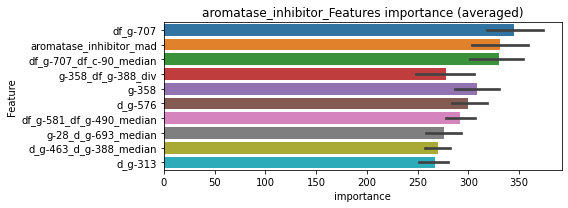

len(train_index) : 2837
len(valid_index) : 946
================================= fold 1/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101503	valid_1's binary_logloss: 0.144008
[200]	training's binary_logloss: 0.0366082	valid_1's binary_logloss: 0.0692637
[300]	training's binary_logloss: 0.0145624	valid_1's binary_logloss: 0.0399282
[400]	training's binary_logloss: 0.00653129	valid_1's binary_logloss: 0.0251268
[500]	training's binary_logloss: 0.00335929	valid_1's binary_logloss: 0.0184713
[600]	training's binary_logloss: 0.0020577	valid_1's binary_logloss: 0.0153995
[700]	training's binary_logloss: 0.00141957	valid_1's binary_logloss: 0.0133262
[800]	training's binary_logloss: 0.00108736	valid_1's binary_logloss: 0.0121293
[900]	training's binary_logloss: 0.000889884	valid_1's binary_logloss: 0.0112096
[1000]	training's binary_logloss: 0.00077707	valid_1's binary_logloss: 0.010731
[1100]	training's binary_logloss: 0.000720815	valid_1's binary_logloss: 0.0105521
Early stopping, best iteration is:
[1075]	training's binary_lo

len(train_index) : 2837
len(valid_index) : 946
================================= fold 2/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100303	valid_1's binary_logloss: 0.147679
[200]	training's binary_logloss: 0.0352867	valid_1's binary_logloss: 0.0766019
[300]	training's binary_logloss: 0.0137895	valid_1's binary_logloss: 0.0451685
[400]	training's binary_logloss: 0.00610105	valid_1's binary_logloss: 0.0302677
[500]	training's binary_logloss: 0.0031718	valid_1's binary_logloss: 0.0232138
[600]	training's binary_logloss: 0.00195231	valid_1's binary_logloss: 0.0191473
[700]	training's binary_logloss: 0.00136502	valid_1's binary_logloss: 0.0169805
[800]	training's binary_logloss: 0.00104665	valid_1's binary_logloss: 0.01573
[900]	training's binary_logloss: 0.000864389	valid_1's binary_logloss: 0.0148596
[1000]	training's binary_logloss: 0.000758495	valid_1's binary_logloss: 0.0145564
[1100]	training's binary_logloss: 0.000707346	valid_1's binary_logloss: 0.0142631
Early stopping, best iteration is:
[1134]	training's binary_lo

len(train_index) : 2837
len(valid_index) : 946
================================= fold 3/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0996783	valid_1's binary_logloss: 0.146273
[200]	training's binary_logloss: 0.0342063	valid_1's binary_logloss: 0.0749714
[300]	training's binary_logloss: 0.013156	valid_1's binary_logloss: 0.0459107
[400]	training's binary_logloss: 0.00581617	valid_1's binary_logloss: 0.0316209
[500]	training's binary_logloss: 0.0030643	valid_1's binary_logloss: 0.0243535
[600]	training's binary_logloss: 0.00190269	valid_1's binary_logloss: 0.0209567
[700]	training's binary_logloss: 0.00134374	valid_1's binary_logloss: 0.0193805
[800]	training's binary_logloss: 0.00102835	valid_1's binary_logloss: 0.0177676
[900]	training's binary_logloss: 0.000848195	valid_1's binary_logloss: 0.0168352
[1000]	training's binary_logloss: 0.000745872	valid_1's binary_logloss: 0.0163742
Early stopping, best iteration is:
[1057]	training's binary_logloss: 0.000717259	valid_1's binary_logloss: 0.0162312


len(train_index) : 2838
len(valid_index) : 945
================================= fold 4/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0999421	valid_1's binary_logloss: 0.142712
[200]	training's binary_logloss: 0.0345737	valid_1's binary_logloss: 0.0741984
[300]	training's binary_logloss: 0.0138801	valid_1's binary_logloss: 0.0457483
[400]	training's binary_logloss: 0.00618751	valid_1's binary_logloss: 0.0326904
[500]	training's binary_logloss: 0.00316719	valid_1's binary_logloss: 0.0255583
[600]	training's binary_logloss: 0.00194108	valid_1's binary_logloss: 0.0219886
[700]	training's binary_logloss: 0.00136132	valid_1's binary_logloss: 0.0200585
[800]	training's binary_logloss: 0.00104953	valid_1's binary_logloss: 0.0189742
[900]	training's binary_logloss: 0.000868449	valid_1's binary_logloss: 0.0177006
[1000]	training's binary_logloss: 0.00075636	valid_1's binary_logloss: 0.0172301
[1100]	training's binary_logloss: 0.000702958	valid_1's binary_logloss: 0.017111
Early stopping, best iteration is:
[1090]	training's binary_

aromatase_inhibitor logloss: 0.014510002148782218
atm_kinase_inhibitor, len(trt): 6, len(othr): 3285, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0444173	valid_1's binary_logloss: 0.046629
[200]	training's binary_logloss: 0.00716354	valid_1's binary_logloss: 0.00883013
[300]	training's binary_logloss: 0.00158865	valid_1's binary_logloss: 0.0031936
[400]	training's binary_logloss: 0.000583509	valid_1's binary_logloss: 0.00188417
[500]	training's binary_logloss: 0.000329876	valid_1's binary_logloss: 0.00142587
[600]	training's binary_logloss: 0.00023805	valid_1's binary_logloss: 0.00121911
[700]	training's binary_logloss: 0.000209274	valid_1's binary_logloss: 0.00115269
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.000206907	valid_1's binary_logloss: 0.00114366
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0441518	valid_1's binary_logloss: 0.0465353
[200]	training's binary_logloss: 0.00711949	valid_1's binary_logloss: 0.00867664
[300]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0005813, Threshold: 0.0022778, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00159, conf_1:0.00296
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0022778
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0322778
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.0622778
threshold: 0.0622778, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0438474	valid_1's binary_logloss: 0.046651
[200]	training's binary_logloss: 0.00675244	valid_1's binary_logloss: 0.00896963
[300]	training's binary_logloss: 0.00138725	valid_1's binary_logloss: 0.00347408
[400]	training's binary_logloss: 0.00048093	valid_1's binary_logloss: 0.00249619
[500]	training's binary_logloss: 0.000269807	valid_1's binary_logloss: 0.00237378
[600]	training's binary_logloss: 0.000197358	valid_1's binary_logloss: 0.00225057
[700]	training's binary_logloss: 0.000175933	valid_1's binary_logloss: 0.00222168
[800]	training's binary_logloss: 0.000173439	valid_1's binary_logloss: 0.00221564
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.000173439	valid_1's binary_logloss: 0.00221564
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0437926	valid_1's binary_logloss: 0.0460598
[200]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0404892, Threshold: 0.0622778, pos_neg_ratio: 0.8000000


[800]	training's binary_logloss: 0.000173696	valid_1's binary_logloss: 0.000225023
Early stopping, best iteration is:
[791]	training's binary_logloss: 0.000173696	valid_1's binary_logloss: 0.000225023


Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00025, Num_p_label: 21.0, conf_0:0.04982, conf_1:0.07473
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_1: 0.0622778
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_2: 0.0922778
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_3: 0.1222778
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_4: 0.1522778
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_5: 0.1822778
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_6: 0.2122778
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_7: 0.2422778
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.2722778
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.3022778
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_10: 0.3322778
threshold: 0.3622778, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0438474	valid_1's binary_logloss: 0.046651
[200]	training's binary_logloss: 0.00675244	valid_1's binary_logloss: 0.00896963
[300]	training's binary_logloss: 0.00138725	valid_1's binary_logloss: 0.00347408
[400]	training's binary_logloss: 0.00048093	valid_1's binary_logloss: 0.00249619
[500]	training's binary_logloss: 0.000269807	valid_1's binary_logloss: 0.00237378
[600]	training's binary_logloss: 0.000197358	valid_1's binary_logloss: 0.00225057
[700]	training's binary_logloss: 0.000175933	valid_1's binary_logloss: 0.00222168
[800]	training's binary_logloss: 0.000173439	valid_1's binary_logloss: 0.00221564
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.000173439	valid_1's binary_logloss: 0.00221564
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0437926	valid_1's binary_logloss: 0.0460598
[200]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0404892, Threshold: 0.3622778, pos_neg_ratio: 0.8000000


[800]	training's binary_logloss: 0.000173696	valid_1's binary_logloss: 0.000225023
Early stopping, best iteration is:
[791]	training's binary_logloss: 0.000173696	valid_1's binary_logloss: 0.000225023


Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.32605, conf_1:0.39851
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.3622778
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.3922778
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.4222778
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.4522778
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.4822778
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.5122778
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.5422778
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.5722778
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.6022778
threshold: 0.6022778, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


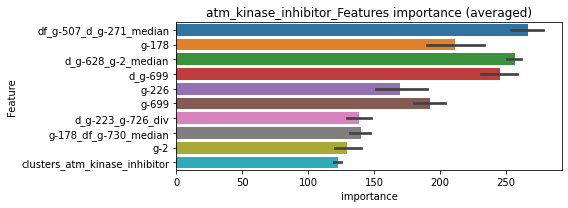

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0434758	valid_1's binary_logloss: 0.0459587
[200]	training's binary_logloss: 0.00666598	valid_1's binary_logloss: 0.00916976
[300]	training's binary_logloss: 0.00137708	valid_1's binary_logloss: 0.003655
[400]	training's binary_logloss: 0.000479613	valid_1's binary_logloss: 0.00273012
[500]	training's binary_logloss: 0.000266196	valid_1's binary_logloss: 0.00257392
[600]	training's binary_logloss: 0.000196772	valid_1's binary_logloss: 0.00247968
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000203661	valid_1's binary_logloss: 0.00246679


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0437292	valid_1's binary_logloss: 0.0457358
[200]	training's binary_logloss: 0.00672004	valid_1's binary_logloss: 0.00769791
[300]	training's binary_logloss: 0.00138355	valid_1's binary_logloss: 0.00180752
[400]	training's binary_logloss: 0.000481634	valid_1's binary_logloss: 0.000705617
[500]	training's binary_logloss: 0.000267091	valid_1's binary_logloss: 0.000417411
[600]	training's binary_logloss: 0.000197054	valid_1's binary_logloss: 0.000322696
[700]	training's binary_logloss: 0.000174599	valid_1's binary_logloss: 0.0002933
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.000170811	valid_1's binary_logloss: 0.000288784


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0436031	valid_1's binary_logloss: 0.044093
[200]	training's binary_logloss: 0.00670184	valid_1's binary_logloss: 0.0068921
[300]	training's binary_logloss: 0.00138148	valid_1's binary_logloss: 0.001455
[400]	training's binary_logloss: 0.000485943	valid_1's binary_logloss: 0.000525127
[500]	training's binary_logloss: 0.000269378	valid_1's binary_logloss: 0.000295464
[600]	training's binary_logloss: 0.000196793	valid_1's binary_logloss: 0.000218567
[700]	training's binary_logloss: 0.000176372	valid_1's binary_logloss: 0.000196203
[800]	training's binary_logloss: 0.000173174	valid_1's binary_logloss: 0.00019258
Early stopping, best iteration is:
[813]	training's binary_logloss: 0.000173125	valid_1's binary_logloss: 0.000192529


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0437296	valid_1's binary_logloss: 0.0452325
[200]	training's binary_logloss: 0.00671719	valid_1's binary_logloss: 0.00725575
[300]	training's binary_logloss: 0.00138585	valid_1's binary_logloss: 0.00161059
[400]	training's binary_logloss: 0.00048364	valid_1's binary_logloss: 0.000610317
[500]	training's binary_logloss: 0.000270032	valid_1's binary_logloss: 0.000353941
[600]	training's binary_logloss: 0.000198476	valid_1's binary_logloss: 0.000258996
[700]	training's binary_logloss: 0.000176144	valid_1's binary_logloss: 0.000229132


atm_kinase_inhibitor logloss: 0.0007939851015595314


Early stopping, best iteration is:
[741]	training's binary_logloss: 0.000174343	valid_1's binary_logloss: 0.000226614


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3289, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0511687	valid_1's binary_logloss: 0.0562979
[200]	training's binary_logloss: 0.0100037	valid_1's binary_logloss: 0.0131579
[300]	training's binary_logloss: 0.00253912	valid_1's binary_logloss: 0.00450111
[400]	training's binary_logloss: 0.000966095	valid_1's binary_logloss: 0.00209613
[500]	training's binary_logloss: 0.000530544	valid_1's binary_logloss: 0.00132183
[600]	training's binary_logloss: 0.000365933	valid_1's binary_logloss: 0.000994586
[700]	training's binary_logloss: 0.000290537	valid_1's binary_logloss: 0.000830198
[800]	training's binary_logloss: 0.000266937	valid_1's binary_logloss: 0.000774316
[900]	training's binary_logloss: 0.000258728	valid_1's binary_logloss: 0.000748874
Early stopping, best iteration is:
[882]	training's binary_logloss: 0.000258728	valid_1's binary_logloss: 0.000748874
Training until validation scores don't improve for 30 rounds
[100]	training's binary_l

1 / 3 AUC score:1.000
y_Threshold: 0.0017291, Threshold: 0.0174861, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.01224, conf_1:0.02273
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.0174861
Num_p_label: 20.0, Expected: 1.2, Adj_threshold_2: 0.0474861
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_3: 0.0774861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_4: 0.1074861
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_5: 0.1374861
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_6: 0.1674861
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_7: 0.1974861
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_8: 0.2274861
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_9: 0.2574861
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_10: 0.2874861
threshold: 0.3174861, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.049502	valid_1's binary_logloss: 0.0528054
[200]	training's binary_logloss: 0.00862979	valid_1's binary_logloss: 0.010096
[300]	training's binary_logloss: 0.00204343	valid_1's binary_logloss: 0.00279399
[400]	training's binary_logloss: 0.000781391	valid_1's binary_logloss: 0.00125101
[500]	training's binary_logloss: 0.000438336	valid_1's binary_logloss: 0.00076207
[600]	training's binary_logloss: 0.000308969	valid_1's binary_logloss: 0.000577114
[700]	training's binary_logloss: 0.000255915	valid_1's binary_logloss: 0.000497377
[800]	training's binary_logloss: 0.000240335	valid_1's binary_logloss: 0.000470816
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000240212	valid_1's binary_logloss: 0.000470684
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0489955	valid_1's binary_logloss: 0.055472
[200]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0930036, Threshold: 0.3174861, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0035158 Vs.target_rate: 0.00029, Num_p_label: 14.0, conf_0:0.25399, conf_1:0.38098
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_1: 0.3174861
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_2: 0.3474861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_3: 0.3774861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_4: 0.4074861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_5: 0.4374861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_6: 0.4674861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_7: 0.4974861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_8: 0.5274861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_9: 0.5574861
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_10: 0.5874861
threshold: 0.6174861, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.049502	valid_1's binary_logloss: 0.0528054
[200]	training's binary_logloss: 0.00862979	valid_1's binary_logloss: 0.010096
[300]	training's binary_logloss: 0.00204343	valid_1's binary_logloss: 0.00279399
[400]	training's binary_logloss: 0.000781391	valid_1's binary_logloss: 0.00125101
[500]	training's binary_logloss: 0.000438336	valid_1's binary_logloss: 0.00076207
[600]	training's binary_logloss: 0.000308969	valid_1's binary_logloss: 0.000577114
[700]	training's binary_logloss: 0.000255915	valid_1's binary_logloss: 0.000497377
[800]	training's binary_logloss: 0.000240335	valid_1's binary_logloss: 0.000470816
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000240212	valid_1's binary_logloss: 0.000470684
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0489955	valid_1's binary_logloss: 0.055472
[200]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0930036, Threshold: 0.6174861, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00029, Num_p_label: 12.0, conf_0:0.50000, conf_1:0.67923
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_1: 0.6174861
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_2: 0.6474861
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_3: 0.6774861
threshold: 0.6774861, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


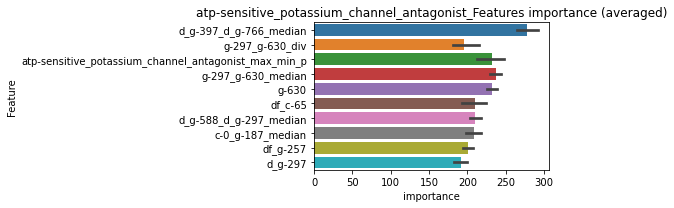

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0496009	valid_1's binary_logloss: 0.0525321
[200]	training's binary_logloss: 0.00864165	valid_1's binary_logloss: 0.0100528
[300]	training's binary_logloss: 0.00207169	valid_1's binary_logloss: 0.00290398
[400]	training's binary_logloss: 0.000791462	valid_1's binary_logloss: 0.0013429
[500]	training's binary_logloss: 0.000443704	valid_1's binary_logloss: 0.000844265
[600]	training's binary_logloss: 0.000311601	valid_1's binary_logloss: 0.00064551
[700]	training's binary_logloss: 0.000255359	valid_1's binary_logloss: 0.000558725
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.000244302	valid_1's binary_logloss: 0.000536853


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0491064	valid_1's binary_logloss: 0.0545204
[200]	training's binary_logloss: 0.00854565	valid_1's binary_logloss: 0.0120796
[300]	training's binary_logloss: 0.00202333	valid_1's binary_logloss: 0.00429863
[400]	training's binary_logloss: 0.000765682	valid_1's binary_logloss: 0.00222929
[500]	training's binary_logloss: 0.000427881	valid_1's binary_logloss: 0.00166004
[600]	training's binary_logloss: 0.000301185	valid_1's binary_logloss: 0.00134334
[700]	training's binary_logloss: 0.000250664	valid_1's binary_logloss: 0.00123466
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.000238421	valid_1's binary_logloss: 0.00118191


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0498509	valid_1's binary_logloss: 0.0538679
[200]	training's binary_logloss: 0.00863812	valid_1's binary_logloss: 0.00999646
[300]	training's binary_logloss: 0.00206466	valid_1's binary_logloss: 0.00262526
[400]	training's binary_logloss: 0.000781598	valid_1's binary_logloss: 0.00108828
[500]	training's binary_logloss: 0.000435088	valid_1's binary_logloss: 0.000643259
[600]	training's binary_logloss: 0.000304694	valid_1's binary_logloss: 0.000467
[700]	training's binary_logloss: 0.000250836	valid_1's binary_logloss: 0.000390187
[800]	training's binary_logloss: 0.000234083	valid_1's binary_logloss: 0.000366141
Early stopping, best iteration is:
[811]	training's binary_logloss: 0.000233019	valid_1's binary_logloss: 0.000364593


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0494893	valid_1's binary_logloss: 0.0531977
[200]	training's binary_logloss: 0.00854498	valid_1's binary_logloss: 0.00980079
[300]	training's binary_logloss: 0.00203324	valid_1's binary_logloss: 0.00260664
[400]	training's binary_logloss: 0.000777395	valid_1's binary_logloss: 0.00107596
[500]	training's binary_logloss: 0.000434749	valid_1's binary_logloss: 0.000639054
[600]	training's binary_logloss: 0.000306322	valid_1's binary_logloss: 0.000463107
[700]	training's binary_logloss: 0.000252878	valid_1's binary_logloss: 0.000390786
[800]	training's binary_logloss: 0.000235388	valid_1's binary_logloss: 0.000364972
Early stopping, best iteration is:
[811]	training's binary_logloss: 0.000234724	valid_1's binary_logloss: 0.000363882


atp-sensitive_potassium_channel_antagonist logloss: 0.0006117890740353575
atp_synthase_inhibitor, len(trt): 12, len(othr): 3286, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0667581	valid_1's binary_logloss: 0.0783546
[200]	training's binary_logloss: 0.0162791	valid_1's binary_logloss: 0.0247331
[300]	training's binary_logloss: 0.00478439	valid_1's binary_logloss: 0.0105537
[400]	training's binary_logloss: 0.00188475	valid_1's binary_logloss: 0.00647465
[500]	training's binary_logloss: 0.00099729	valid_1's binary_logloss: 0.00497814
[600]	training's binary_logloss: 0.000659331	valid_1's binary_logloss: 0.00435496
[700]	training's binary_logloss: 0.000499563	valid_1's binary_logloss: 0.0040048
[800]	training's binary_logloss: 0.000419638	valid_1's binary_logloss: 0.00378629
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.000417592	valid_1's binary_logloss: 0.00378552
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0667557	valid_1's binary_logloss: 0.075766
[200]	training's binary_logloss: 0.016

1 / 3 AUC score:1.000
y_Threshold: 0.0033205, Threshold: 0.0259925, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.01819, conf_1:0.03379
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0259925
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.0559925
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_3: 0.0859925
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.1159925
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.1459925
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.1759925
threshold: 0.1759925, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0647993	valid_1's binary_logloss: 0.0756687
[200]	training's binary_logloss: 0.0147809	valid_1's binary_logloss: 0.0218468
[300]	training's binary_logloss: 0.00414285	valid_1's binary_logloss: 0.00890575
[400]	training's binary_logloss: 0.00162909	valid_1's binary_logloss: 0.00485017
[500]	training's binary_logloss: 0.00086926	valid_1's binary_logloss: 0.00335614
[600]	training's binary_logloss: 0.000578253	valid_1's binary_logloss: 0.00263211
[700]	training's binary_logloss: 0.000440342	valid_1's binary_logloss: 0.00230478
[800]	training's binary_logloss: 0.000378372	valid_1's binary_logloss: 0.00218875
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000365754	valid_1's binary_logloss: 0.00218022
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0641946	valid_1's binary_logloss: 0.0728166
[200]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1519716, Threshold: 0.1759925, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0090407 Vs.target_rate: 0.00050, Num_p_label: 36.0, conf_0:0.14079, conf_1:0.21119
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_1: 0.1759925
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_2: 0.2059925
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_3: 0.2359925
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_4: 0.2659925
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_5: 0.2959925
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_6: 0.3259925
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_7: 0.3559925
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.3859925
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.4159925
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.4459925
threshold: 0.4759925, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0647993	valid_1's binary_logloss: 0.0756687
[200]	training's binary_logloss: 0.0147809	valid_1's binary_logloss: 0.0218468
[300]	training's binary_logloss: 0.00414285	valid_1's binary_logloss: 0.00890575
[400]	training's binary_logloss: 0.00162909	valid_1's binary_logloss: 0.00485017
[500]	training's binary_logloss: 0.00086926	valid_1's binary_logloss: 0.00335614
[600]	training's binary_logloss: 0.000578253	valid_1's binary_logloss: 0.00263211
[700]	training's binary_logloss: 0.000440342	valid_1's binary_logloss: 0.00230478
[800]	training's binary_logloss: 0.000378372	valid_1's binary_logloss: 0.00218875
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000365754	valid_1's binary_logloss: 0.00218022
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0641946	valid_1's binary_logloss: 0.0728166
[200]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1519716, Threshold: 0.4759925, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.42839, conf_1:0.52359
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.4759925
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.5059925
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_3: 0.5359925
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.5659925
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.5959925
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_6: 0.6259925
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.6559925
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_8: 0.6859925
threshold: 0.6859925, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


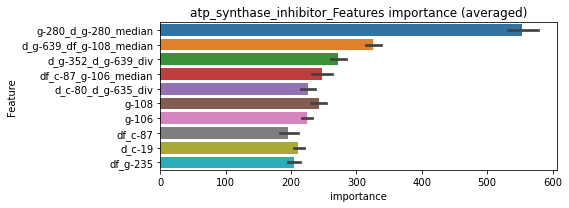

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0642065	valid_1's binary_logloss: 0.0759872
[200]	training's binary_logloss: 0.014569	valid_1's binary_logloss: 0.0220238
[300]	training's binary_logloss: 0.00412076	valid_1's binary_logloss: 0.00886038
[400]	training's binary_logloss: 0.00160674	valid_1's binary_logloss: 0.00498825
[500]	training's binary_logloss: 0.000865367	valid_1's binary_logloss: 0.0035741
[600]	training's binary_logloss: 0.0005748	valid_1's binary_logloss: 0.00291855
[700]	training's binary_logloss: 0.000439323	valid_1's binary_logloss: 0.00252789
[800]	training's binary_logloss: 0.00037658	valid_1's binary_logloss: 0.00237401
Early stopping, best iteration is:
[846]	training's binary_logloss: 0.000364302	valid_1's binary_logloss: 0.00232993


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0648421	valid_1's binary_logloss: 0.073396
[200]	training's binary_logloss: 0.014907	valid_1's binary_logloss: 0.0193163
[300]	training's binary_logloss: 0.0041972	valid_1's binary_logloss: 0.00639408
[400]	training's binary_logloss: 0.00162767	valid_1's binary_logloss: 0.00289876
[500]	training's binary_logloss: 0.000868595	valid_1's binary_logloss: 0.00173901
[600]	training's binary_logloss: 0.000578708	valid_1's binary_logloss: 0.00121862
[700]	training's binary_logloss: 0.000441949	valid_1's binary_logloss: 0.000978433
[800]	training's binary_logloss: 0.000379322	valid_1's binary_logloss: 0.000868538
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.000372344	valid_1's binary_logloss: 0.000854679


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0640987	valid_1's binary_logloss: 0.0759004
[200]	training's binary_logloss: 0.0143604	valid_1's binary_logloss: 0.0211507
[300]	training's binary_logloss: 0.00406872	valid_1's binary_logloss: 0.00808586
[400]	training's binary_logloss: 0.00159156	valid_1's binary_logloss: 0.00405617
[500]	training's binary_logloss: 0.000853983	valid_1's binary_logloss: 0.0025859
[600]	training's binary_logloss: 0.000569347	valid_1's binary_logloss: 0.00197712
[700]	training's binary_logloss: 0.00043585	valid_1's binary_logloss: 0.00160761
[800]	training's binary_logloss: 0.000377071	valid_1's binary_logloss: 0.00149462
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.000367947	valid_1's binary_logloss: 0.00147163


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0652203	valid_1's binary_logloss: 0.0761546
[200]	training's binary_logloss: 0.0149516	valid_1's binary_logloss: 0.020318
[300]	training's binary_logloss: 0.00418346	valid_1's binary_logloss: 0.00666079
[400]	training's binary_logloss: 0.00164508	valid_1's binary_logloss: 0.003106
[500]	training's binary_logloss: 0.000874537	valid_1's binary_logloss: 0.00186391
[600]	training's binary_logloss: 0.000580932	valid_1's binary_logloss: 0.00134467
[700]	training's binary_logloss: 0.000443414	valid_1's binary_logloss: 0.00110126
[800]	training's binary_logloss: 0.000375551	valid_1's binary_logloss: 0.000985874
[900]	training's binary_logloss: 0.000357497	valid_1's binary_logloss: 0.000957277
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000357497	valid_1's binary_logloss: 0.000957277


atp_synthase_inhibitor logloss: 0.0014035304731614164


neg labels: 3289 → selected neg labels: 3273


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151995	valid_1's binary_logloss: 0.240923
[200]	training's binary_logloss: 0.0714993	valid_1's binary_logloss: 0.17861
[300]	training's binary_logloss: 0.0372413	valid_1's binary_logloss: 0.148874
[400]	training's binary_logloss: 0.020476	valid_1's binary_logloss: 0.135861
[500]	training's binary_logloss: 0.0114759	valid_1's binary_logloss: 0.126677
[600]	training's binary_logloss: 0.00685343	valid_1's binary_logloss: 0.122308
[700]	training's binary_logloss: 0.0043357	valid_1's binary_logloss: 0.12059
Early stopping, best iteration is:
[718]	training's binary_logloss: 0.00403793	valid_1's binary_logloss: 0.12039
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.150869	valid_1's binary_logloss: 0.229252
[200]	training's binary_logloss: 0.0710115	valid_1's binary_logloss: 0.162667
[300]	training's binary_logloss: 0.0373796	valid_1's binary_logloss

1 / 3 AUC score:0.985
y_Threshold: 0.0393322, Threshold: 0.1566542, pos_neg_ratio: 0.8000000
Remove_noisy_data: 196 → Positive_corect_labels: 622/3731
p_label_rate: 0.0100452 Vs.target_rate: 0.00407, Num_p_label: 40.0, conf_0:0.10966, conf_1:0.20365
threshold: 0.1566542, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 622.0/3731, y_label_rate: 0.1667113
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133188	valid_1's binary_logloss: 0.198569
[200]	training's binary_logloss: 0.0560399	valid_1's binary_logloss: 0.129978
[300]	training's binary_logloss: 0.0268821	valid_1's binary_logloss: 0.098055
[400]	training's binary_logloss: 0.0132315	valid_1's binary_logloss: 0.0806079
[500]	training's binary_logloss: 0.00706046	valid_1's binary_logloss: 0.0712391
[600]	training's binary_logloss: 0.00422932	valid_1's binary_logloss: 0.066687
[700]	training's binary_logloss: 0.00279468	valid_1's binary_logloss: 0.0637528
[800]	training's binary_logloss: 0.00204078	valid_1's binary_logloss: 0.0621302
[900]	training's binary_logloss: 0.00158184	valid_1's binary_logloss: 0.0618073
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.00162085	valid_1's binary_logloss: 0.0617029
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135141	valid_1's 

2 / 3 AUC score:0.995
y_Threshold: 0.1060141, Threshold: 0.1566542, pos_neg_ratio: 0.8000000
Remove_noisy_data: 54 → Positive_corect_labels: 595.0/3677
p_label_rate: 0.0220994 Vs.target_rate: 0.00407, Num_p_label: 88.0, conf_0:0.12532, conf_1:0.18799
Num_p_label: 88.0, Expected: 16.2, Adj_threshold_1: 0.1566542
Num_p_label: 81.0, Expected: 16.2, Adj_threshold_2: 0.1866542
Num_p_label: 71.0, Expected: 16.2, Adj_threshold_3: 0.2166542
Num_p_label: 63.0, Expected: 16.2, Adj_threshold_4: 0.2466542
Num_p_label: 56.0, Expected: 16.2, Adj_threshold_5: 0.2766542
Num_p_label: 50.0, Expected: 16.2, Adj_threshold_6: 0.3066542
Num_p_label: 46.0, Expected: 16.2, Adj_threshold_7: 0.3366542
Num_p_label: 44.0, Expected: 16.2, Adj_threshold_8: 0.3666542
Num_p_label: 38.0, Expected: 16.2, Adj_threshold_9: 0.3966542
Num_p_label: 34.0, Expected: 16.2, Adj_threshold_10: 0.4266542
threshold: 0.4566542, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 595.0/3677, y_label_rate: 0.1618167

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124256	valid_1's binary_logloss: 0.176698
[200]	training's binary_logloss: 0.050161	valid_1's binary_logloss: 0.104477
[300]	training's binary_logloss: 0.0232273	valid_1's binary_logloss: 0.07467
[400]	training's binary_logloss: 0.0114103	valid_1's binary_logloss: 0.0586907
[500]	training's binary_logloss: 0.00605381	valid_1's binary_logloss: 0.048823
[600]	training's binary_logloss: 0.0036456	valid_1's binary_logloss: 0.0437523
[700]	training's binary_logloss: 0.00245009	valid_1's binary_logloss: 0.0409715
[800]	training's binary_logloss: 0.0017988	valid_1's binary_logloss: 0.0392177
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.00163516	valid_1's binary_logloss: 0.0389118
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122571	valid_1's binary_logloss: 0.185671
[200]	training's binary_logloss: 0.0495704	valid_1's binary

3 / 3 AUC score:0.996
y_Threshold: 0.0965528, Threshold: 0.4566542, pos_neg_ratio: 0.8000000
Remove_noisy_data: 34 → Positive_corect_labels: 578.0/3643
p_label_rate: 0.0110497 Vs.target_rate: 0.00407, Num_p_label: 44.0, conf_0:0.41099, conf_1:0.50232
threshold: 0.4566542, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 578.0/3643, y_label_rate: 0.1586604


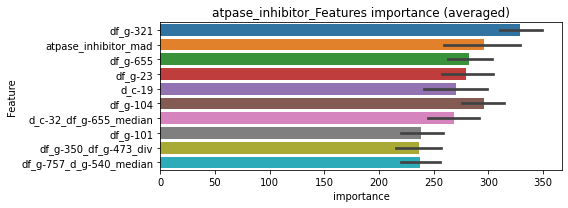

len(train_index) : 2732
len(valid_index) : 911
================================= fold 1/4 atpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116095	valid_1's binary_logloss: 0.175543
[200]	training's binary_logloss: 0.0459413	valid_1's binary_logloss: 0.108557
[300]	training's binary_logloss: 0.0198751	valid_1's binary_logloss: 0.077447
[400]	training's binary_logloss: 0.00934347	valid_1's binary_logloss: 0.0615067
[500]	training's binary_logloss: 0.00493085	valid_1's binary_logloss: 0.0527821
[600]	training's binary_logloss: 0.00299304	valid_1's binary_logloss: 0.048143
[700]	training's binary_logloss: 0.00204391	valid_1's binary_logloss: 0.0455136
[800]	training's binary_logloss: 0.00153419	valid_1's binary_logloss: 0.0444223
[900]	training's binary_logloss: 0.00123064	valid_1's binary_logloss: 0.0434966
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00124181	valid_1's binary_logloss: 0.0433873


len(train_index) : 2732
len(valid_index) : 911
================================= fold 2/4 atpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11632	valid_1's binary_logloss: 0.179215
[200]	training's binary_logloss: 0.0442275	valid_1's binary_logloss: 0.109595
[300]	training's binary_logloss: 0.0195831	valid_1's binary_logloss: 0.0781304
[400]	training's binary_logloss: 0.00929388	valid_1's binary_logloss: 0.0611188
[500]	training's binary_logloss: 0.00494423	valid_1's binary_logloss: 0.0515292
[600]	training's binary_logloss: 0.00297346	valid_1's binary_logloss: 0.0467329
[700]	training's binary_logloss: 0.00202312	valid_1's binary_logloss: 0.04385
[800]	training's binary_logloss: 0.00151481	valid_1's binary_logloss: 0.0423282
[900]	training's binary_logloss: 0.00120891	valid_1's binary_logloss: 0.0412959
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00119562	valid_1's binary_logloss: 0.0411613


len(train_index) : 2732
len(valid_index) : 911
================================= fold 3/4 atpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11582	valid_1's binary_logloss: 0.161318
[200]	training's binary_logloss: 0.0452173	valid_1's binary_logloss: 0.089814
[300]	training's binary_logloss: 0.0195564	valid_1's binary_logloss: 0.0581768
[400]	training's binary_logloss: 0.00962654	valid_1's binary_logloss: 0.0424767
[500]	training's binary_logloss: 0.00504456	valid_1's binary_logloss: 0.0326627
[600]	training's binary_logloss: 0.00304413	valid_1's binary_logloss: 0.0276841
[700]	training's binary_logloss: 0.00207801	valid_1's binary_logloss: 0.0246104
[800]	training's binary_logloss: 0.00155206	valid_1's binary_logloss: 0.0230917
[900]	training's binary_logloss: 0.00123826	valid_1's binary_logloss: 0.0217757
[1000]	training's binary_logloss: 0.00105634	valid_1's binary_logloss: 0.0212387
[1100]	training's binary_logloss: 0.000942419	valid_1's binary_logloss: 0.0206568
[1200]	training's binary_logloss: 0.000876419	valid_1's binary_

len(train_index) : 2733
len(valid_index) : 910
================================= fold 4/4 atpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115042	valid_1's binary_logloss: 0.173416
[200]	training's binary_logloss: 0.0445693	valid_1's binary_logloss: 0.107332
[300]	training's binary_logloss: 0.0196764	valid_1's binary_logloss: 0.0799185
[400]	training's binary_logloss: 0.0093943	valid_1's binary_logloss: 0.067069
[500]	training's binary_logloss: 0.00499381	valid_1's binary_logloss: 0.0595259
[600]	training's binary_logloss: 0.00300666	valid_1's binary_logloss: 0.0559424
[700]	training's binary_logloss: 0.00204105	valid_1's binary_logloss: 0.0537227
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.00174637	valid_1's binary_logloss: 0.0529702


atpase_inhibitor logloss: 0.03943452941327127


neg labels: 3289 → selected neg labels: 3287


atr_kinase_inhibitor, len(trt): 19, len(othr): 3287, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0774045	valid_1's binary_logloss: 0.0968642
[200]	training's binary_logloss: 0.0217564	valid_1's binary_logloss: 0.0362914
[300]	training's binary_logloss: 0.00716095	valid_1's binary_logloss: 0.0177248
[400]	training's binary_logloss: 0.00286627	valid_1's binary_logloss: 0.0102342
[500]	training's binary_logloss: 0.00148893	valid_1's binary_logloss: 0.00733701
[600]	training's binary_logloss: 0.000942471	valid_1's binary_logloss: 0.0059086
[700]	training's binary_logloss: 0.000688211	valid_1's binary_logloss: 0.00509311
[800]	training's binary_logloss: 0.000559652	valid_1's binary_logloss: 0.00472775
[900]	training's binary_logloss: 0.000500768	valid_1's binary_logloss: 0.00448935
[1000]	training's binary_logloss: 0.000484185	valid_1's binary_logloss: 0.00439555
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000484326	valid_1's binary_logloss: 0.00439544
Training unti

1 / 3 AUC score:1.000
y_Threshold: 0.0060402, Threshold: 0.0337537, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.02363, conf_1:0.04388
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0337537
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_2: 0.0637537
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_3: 0.0937537
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_4: 0.1237537
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_5: 0.1537537
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.1837537
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.2137537
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.2437537
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_9: 0.2737537
threshold: 0.2737537, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0740839	valid_1's binary_logloss: 0.0863105
[200]	training's binary_logloss: 0.019191	valid_1's binary_logloss: 0.0264332
[300]	training's binary_logloss: 0.00605044	valid_1's binary_logloss: 0.0102225
[400]	training's binary_logloss: 0.00245778	valid_1's binary_logloss: 0.00493407
[500]	training's binary_logloss: 0.00129908	valid_1's binary_logloss: 0.00297413
[600]	training's binary_logloss: 0.000841499	valid_1's binary_logloss: 0.00210114
[700]	training's binary_logloss: 0.000621162	valid_1's binary_logloss: 0.00165872
[800]	training's binary_logloss: 0.000504402	valid_1's binary_logloss: 0.00141152
[900]	training's binary_logloss: 0.000452381	valid_1's binary_logloss: 0.0012955
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.000442979	valid_1's binary_logloss: 0.00127656
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0638374, Threshold: 0.2737537, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0077850 Vs.target_rate: 0.00080, Num_p_label: 31.0, conf_0:0.21900, conf_1:0.32850
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_1: 0.2737537
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_2: 0.3037537
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_3: 0.3337537
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_4: 0.3637537
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_5: 0.3937537
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_6: 0.4237537
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_7: 0.4537537
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_8: 0.4837537
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_9: 0.5137537
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_10: 0.5437537
threshold: 0.5737537, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0736031	valid_1's binary_logloss: 0.0871871
[200]	training's binary_logloss: 0.0189061	valid_1's binary_logloss: 0.0271188
[300]	training's binary_logloss: 0.00603826	valid_1's binary_logloss: 0.0106167
[400]	training's binary_logloss: 0.00244244	valid_1's binary_logloss: 0.0052686
[500]	training's binary_logloss: 0.0012889	valid_1's binary_logloss: 0.00316939
[600]	training's binary_logloss: 0.000831509	valid_1's binary_logloss: 0.00229108
[700]	training's binary_logloss: 0.000613132	valid_1's binary_logloss: 0.001846
[800]	training's binary_logloss: 0.000494919	valid_1's binary_logloss: 0.0015528
[900]	training's binary_logloss: 0.000444436	valid_1's binary_logloss: 0.00144388
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.000433779	valid_1's binary_logloss: 0.00142166
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.071

3 / 3 AUC score:1.000
y_Threshold: 0.1669305, Threshold: 0.5737537, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.50000, conf_1:0.63113
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.5737537
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.6037537
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_3: 0.6337537
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.6637537
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_5: 0.6937537
threshold: 0.6937537, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3810, y_label_rate: 0.1721785


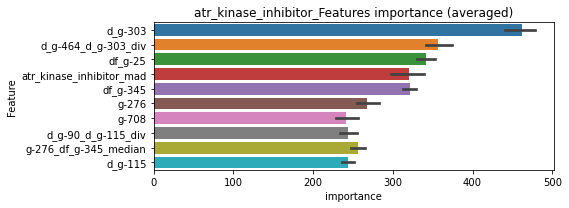

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0751151	valid_1's binary_logloss: 0.0881902
[200]	training's binary_logloss: 0.0198887	valid_1's binary_logloss: 0.0290225
[300]	training's binary_logloss: 0.00635545	valid_1's binary_logloss: 0.0119345
[400]	training's binary_logloss: 0.00261085	valid_1's binary_logloss: 0.00620512
[500]	training's binary_logloss: 0.00131348	valid_1's binary_logloss: 0.00369931
[600]	training's binary_logloss: 0.000833208	valid_1's binary_logloss: 0.00264356
[700]	training's binary_logloss: 0.000615111	valid_1's binary_logloss: 0.00212317
[800]	training's binary_logloss: 0.000496128	valid_1's binary_logloss: 0.00183096
[900]	training's binary_logloss: 0.000444449	valid_1's binary_logloss: 0.00168998
[1000]	training's binary_logloss: 0.000431898	valid_1's binary_logloss: 0.0016641
Early stopping, best iteration is:
[982]	training's binary_logloss: 0.000431898	valid_1's binary_logloss: 0.0016641


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.073403	valid_1's binary_logloss: 0.0993762
[200]	training's binary_logloss: 0.0188311	valid_1's binary_logloss: 0.0351377
[300]	training's binary_logloss: 0.00582326	valid_1's binary_logloss: 0.0160706
[400]	training's binary_logloss: 0.00233545	valid_1's binary_logloss: 0.00946227
[500]	training's binary_logloss: 0.00123298	valid_1's binary_logloss: 0.0065598
[600]	training's binary_logloss: 0.000804505	valid_1's binary_logloss: 0.00542676
[700]	training's binary_logloss: 0.000601162	valid_1's binary_logloss: 0.00483369
[800]	training's binary_logloss: 0.000489858	valid_1's binary_logloss: 0.00433669
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000469854	valid_1's binary_logloss: 0.00423706


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0739118	valid_1's binary_logloss: 0.0921546
[200]	training's binary_logloss: 0.0188021	valid_1's binary_logloss: 0.0285078
[300]	training's binary_logloss: 0.00582865	valid_1's binary_logloss: 0.0115236
[400]	training's binary_logloss: 0.0023381	valid_1's binary_logloss: 0.00610029
[500]	training's binary_logloss: 0.00124071	valid_1's binary_logloss: 0.00404387
[600]	training's binary_logloss: 0.000810818	valid_1's binary_logloss: 0.00326245
[700]	training's binary_logloss: 0.000600749	valid_1's binary_logloss: 0.00281347
[800]	training's binary_logloss: 0.000484718	valid_1's binary_logloss: 0.00257416
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.00045085	valid_1's binary_logloss: 0.00250586


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0738084	valid_1's binary_logloss: 0.0908012
[200]	training's binary_logloss: 0.0190919	valid_1's binary_logloss: 0.0305653
[300]	training's binary_logloss: 0.00595928	valid_1's binary_logloss: 0.0130942
[400]	training's binary_logloss: 0.00237901	valid_1's binary_logloss: 0.00673144
[500]	training's binary_logloss: 0.0012617	valid_1's binary_logloss: 0.00440745
[600]	training's binary_logloss: 0.000819817	valid_1's binary_logloss: 0.00326075
[700]	training's binary_logloss: 0.000607386	valid_1's binary_logloss: 0.00268734
[800]	training's binary_logloss: 0.000494431	valid_1's binary_logloss: 0.00234764
[900]	training's binary_logloss: 0.000444695	valid_1's binary_logloss: 0.00222848
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.000445475	valid_1's binary_logloss: 0.00222627


atr_kinase_inhibitor logloss: 0.002658476730700475
aurora_kinase_inhibitor, len(trt): 96, len(othr): 3271, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.157769	valid_1's binary_logloss: 0.260116
[200]	training's binary_logloss: 0.078277	valid_1's binary_logloss: 0.197787
[300]	training's binary_logloss: 0.041641	valid_1's binary_logloss: 0.167979
[400]	training's binary_logloss: 0.0222473	valid_1's binary_logloss: 0.150346
[500]	training's binary_logloss: 0.0127051	valid_1's binary_logloss: 0.140837
[600]	training's binary_logloss: 0.00751388	valid_1's binary_logloss: 0.134595
[700]	training's binary_logloss: 0.00471563	valid_1's binary_logloss: 0.133647
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.00512466	valid_1's binary_logloss: 0.133361
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.17093	valid_1's binary_logloss: 0.228063
[200]	training's binary_logloss: 0.0851866	valid_1's binary_logloss: 0.154725
[300]	training's binary_logloss: 0.045035	valid_1's binary_loglos

1 / 3 AUC score:0.988
y_Threshold: 0.0543820, Threshold: 0.4620169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 187 → Positive_corect_labels: 626/3738
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.32341, conf_1:0.60062
threshold: 0.4620169, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 626.0/3738, y_label_rate: 0.1674692
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145564	valid_1's binary_logloss: 0.220497
[200]	training's binary_logloss: 0.066355	valid_1's binary_logloss: 0.14597
[300]	training's binary_logloss: 0.0339971	valid_1's binary_logloss: 0.109488
[400]	training's binary_logloss: 0.0172943	valid_1's binary_logloss: 0.0854725
[500]	training's binary_logloss: 0.00928605	valid_1's binary_logloss: 0.0737533
[600]	training's binary_logloss: 0.00540182	valid_1's binary_logloss: 0.0659151
[700]	training's binary_logloss: 0.00346801	valid_1's binary_logloss: 0.061161
[800]	training's binary_logloss: 0.00243625	valid_1's binary_logloss: 0.0578114
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.0020177	valid_1's binary_logloss: 0.0566927
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145727	valid_1's binary_logloss: 0.222897
[200]	training's binary_logloss: 0.0633186	valid_1's binar

2 / 3 AUC score:0.996
y_Threshold: 0.1342229, Threshold: 0.4620169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 595.0/3676
p_label_rate: 0.0263687 Vs.target_rate: 0.00403, Num_p_label: 105.0, conf_0:0.36961, conf_1:0.55442
Num_p_label: 105.0, Expected: 16.1, Adj_threshold_1: 0.4620169
Num_p_label: 95.0, Expected: 16.1, Adj_threshold_2: 0.4920169
Num_p_label: 90.0, Expected: 16.1, Adj_threshold_3: 0.5220169
Num_p_label: 83.0, Expected: 16.1, Adj_threshold_4: 0.5520169
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_5: 0.5820169
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_6: 0.6120169
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_7: 0.6420169
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_8: 0.6720169
threshold: 0.6720169, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 595.0/3676, y_label_rate: 0.1618607
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13701	valid_1's binary_logloss: 0.185315
[200]	training's binary_logloss: 0.0595878	valid_1's binary_logloss: 0.113671
[300]	training's binary_logloss: 0.0286228	valid_1's binary_logloss: 0.0803238
[400]	training's binary_logloss: 0.0144273	valid_1's binary_logloss: 0.0610542
[500]	training's binary_logloss: 0.0074884	valid_1's binary_logloss: 0.0504974
[600]	training's binary_logloss: 0.00436924	valid_1's binary_logloss: 0.0444187
[700]	training's binary_logloss: 0.00283752	valid_1's binary_logloss: 0.0412535
[800]	training's binary_logloss: 0.00201836	valid_1's binary_logloss: 0.0391711
[900]	training's binary_logloss: 0.00155982	valid_1's binary_logloss: 0.0381678
[1000]	training's binary_logloss: 0.0012829	valid_1's binary_logloss: 0.0375944
[1100]	training's binary_logloss: 0.00113052	valid_1's binary_logloss: 0.0369994
[1200]	training's binary_logloss: 0.00104165	valid_1's binary_loglo

3 / 3 AUC score:0.992
y_Threshold: 0.1164263, Threshold: 0.6720169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 64 → Positive_corect_labels: 563.0/3612
p_label_rate: 0.0208438 Vs.target_rate: 0.00403, Num_p_label: 83.0, conf_0:0.50000, conf_1:0.73922
Num_p_label: 83.0, Expected: 16.1, Adj_threshold_1: 0.6720169
threshold: 0.6720169, positive_p_label: 83.0/3982, p_label_rate: 0.0208438
positive_y_label: 563.0/3612, y_label_rate: 0.1558693


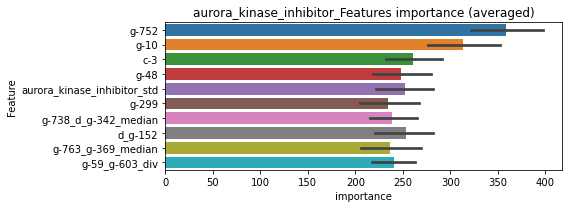

len(train_index) : 2709
len(valid_index) : 903
================================= fold 1/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118042	valid_1's binary_logloss: 0.187809
[200]	training's binary_logloss: 0.0474857	valid_1's binary_logloss: 0.12402
[300]	training's binary_logloss: 0.0209747	valid_1's binary_logloss: 0.0950265
[400]	training's binary_logloss: 0.00985777	valid_1's binary_logloss: 0.0807852
[500]	training's binary_logloss: 0.00514865	valid_1's binary_logloss: 0.0735131
[600]	training's binary_logloss: 0.00303685	valid_1's binary_logloss: 0.0708135
[700]	training's binary_logloss: 0.00203949	valid_1's binary_logloss: 0.069473
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.0016813	valid_1's binary_logloss: 0.0690795


len(train_index) : 2709
len(valid_index) : 903
================================= fold 2/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120416	valid_1's binary_logloss: 0.179524
[200]	training's binary_logloss: 0.0494437	valid_1's binary_logloss: 0.110795
[300]	training's binary_logloss: 0.0218577	valid_1's binary_logloss: 0.0770582
[400]	training's binary_logloss: 0.0103181	valid_1's binary_logloss: 0.0601445
[500]	training's binary_logloss: 0.00540274	valid_1's binary_logloss: 0.051264
[600]	training's binary_logloss: 0.00319278	valid_1's binary_logloss: 0.046237
[700]	training's binary_logloss: 0.00213456	valid_1's binary_logloss: 0.0431201
[800]	training's binary_logloss: 0.00159067	valid_1's binary_logloss: 0.0420317
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.00138704	valid_1's binary_logloss: 0.0415642


len(train_index) : 2709
len(valid_index) : 903
================================= fold 3/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125318	valid_1's binary_logloss: 0.17507
[200]	training's binary_logloss: 0.0521322	valid_1's binary_logloss: 0.108243
[300]	training's binary_logloss: 0.0235123	valid_1's binary_logloss: 0.0775842
[400]	training's binary_logloss: 0.0111431	valid_1's binary_logloss: 0.0616731
[500]	training's binary_logloss: 0.00584082	valid_1's binary_logloss: 0.0523376
[600]	training's binary_logloss: 0.00339993	valid_1's binary_logloss: 0.0478738
[700]	training's binary_logloss: 0.00226436	valid_1's binary_logloss: 0.0454575
Early stopping, best iteration is:
[767]	training's binary_logloss: 0.00182043	valid_1's binary_logloss: 0.0447789


len(train_index) : 2709
len(valid_index) : 903
================================= fold 4/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118639	valid_1's binary_logloss: 0.185993
[200]	training's binary_logloss: 0.0476593	valid_1's binary_logloss: 0.117832
[300]	training's binary_logloss: 0.0214089	valid_1's binary_logloss: 0.0859561
[400]	training's binary_logloss: 0.0102828	valid_1's binary_logloss: 0.0678019
[500]	training's binary_logloss: 0.00541185	valid_1's binary_logloss: 0.0573604
[600]	training's binary_logloss: 0.00321612	valid_1's binary_logloss: 0.0525521
[700]	training's binary_logloss: 0.00214717	valid_1's binary_logloss: 0.0488746
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00174341	valid_1's binary_logloss: 0.0472151


aurora_kinase_inhibitor logloss: 0.05065943712835496
autotaxin_inhibitor, len(trt): 6, len(othr): 3287, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451566	valid_1's binary_logloss: 0.047356
[200]	training's binary_logloss: 0.00751539	valid_1's binary_logloss: 0.0088812
[300]	training's binary_logloss: 0.001712	valid_1's binary_logloss: 0.00287231
[400]	training's binary_logloss: 0.000638218	valid_1's binary_logloss: 0.00161027
[500]	training's binary_logloss: 0.000356518	valid_1's binary_logloss: 0.00110448
[600]	training's binary_logloss: 0.000253334	valid_1's binary_logloss: 0.000952158
[700]	training's binary_logloss: 0.000217854	valid_1's binary_logloss: 0.000889143
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.000217854	valid_1's binary_logloss: 0.000889143
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0449368	valid_1's binary_logloss: 0.0481731
[200]	training's binary_logloss: 0.00737724	valid_1's binary_logloss: 0.00914407
[300]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0008042, Threshold: 0.0082552, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00578, conf_1:0.01073
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0082552
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0382552
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0682552
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0982552
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.1282552
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.1582552
threshold: 0.1582552, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0447179	valid_1's binary_logloss: 0.0481798
[200]	training's binary_logloss: 0.00706157	valid_1's binary_logloss: 0.00949886
[300]	training's binary_logloss: 0.0014908	valid_1's binary_logloss: 0.00297304
[400]	training's binary_logloss: 0.000528559	valid_1's binary_logloss: 0.00157227
[500]	training's binary_logloss: 0.000289588	valid_1's binary_logloss: 0.000997732
[600]	training's binary_logloss: 0.000206908	valid_1's binary_logloss: 0.000786274
[700]	training's binary_logloss: 0.000181597	valid_1's binary_logloss: 0.000732038
[800]	training's binary_logloss: 0.000179498	valid_1's binary_logloss: 0.000729784
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.00017924	valid_1's binary_logloss: 0.000729461
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448633	valid_1's binary_logloss: 0.0476852
[200]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1494281, Threshold: 0.1582552, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00025, Num_p_label: 15.0, conf_0:0.12660, conf_1:0.18991
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_1: 0.1582552
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.1882552
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_3: 0.2182552
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.2482552
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.2782552
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.3082552
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.3382552
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.3682552
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.3982552
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.4282552
threshold: 0.4582552, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= 

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0447179	valid_1's binary_logloss: 0.0481798
[200]	training's binary_logloss: 0.00706157	valid_1's binary_logloss: 0.00949886
[300]	training's binary_logloss: 0.0014908	valid_1's binary_logloss: 0.00297304
[400]	training's binary_logloss: 0.000528559	valid_1's binary_logloss: 0.00157227
[500]	training's binary_logloss: 0.000289588	valid_1's binary_logloss: 0.000997732
[600]	training's binary_logloss: 0.000206908	valid_1's binary_logloss: 0.000786274
[700]	training's binary_logloss: 0.000181597	valid_1's binary_logloss: 0.000732038
[800]	training's binary_logloss: 0.000179498	valid_1's binary_logloss: 0.000729784
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.00017924	valid_1's binary_logloss: 0.000729461
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448633	valid_1's binary_logloss: 0.0476852
[200]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1494281, Threshold: 0.4582552, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00025, Num_p_label: 6.0, conf_0:0.41243, conf_1:0.50408
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.4582552
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.4882552
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.5182552
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.5482552
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.5782552
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.6082552
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.6382552
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.6682552
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.6982552
threshold: 0.6982552, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


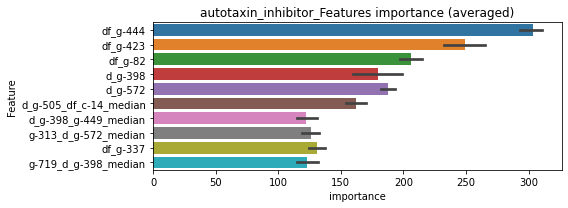

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448442	valid_1's binary_logloss: 0.0487613
[200]	training's binary_logloss: 0.00708394	valid_1's binary_logloss: 0.0105298
[300]	training's binary_logloss: 0.00150513	valid_1's binary_logloss: 0.00357051
[400]	training's binary_logloss: 0.000530329	valid_1's binary_logloss: 0.00196408
[500]	training's binary_logloss: 0.000289655	valid_1's binary_logloss: 0.00127956
[600]	training's binary_logloss: 0.000206334	valid_1's binary_logloss: 0.00100626


len(train_index) : 2859
len(valid_index) : 953


[700]	training's binary_logloss: 0.0001803	valid_1's binary_logloss: 0.000937697
Early stopping, best iteration is:
[711]	training's binary_logloss: 0.000179023	valid_1's binary_logloss: 0.000935868


================================= fold 2/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0447775	valid_1's binary_logloss: 0.0470853
[200]	training's binary_logloss: 0.0070095	valid_1's binary_logloss: 0.0079889
[300]	training's binary_logloss: 0.00148204	valid_1's binary_logloss: 0.00193551
[400]	training's binary_logloss: 0.000522853	valid_1's binary_logloss: 0.000814909
[500]	training's binary_logloss: 0.000286147	valid_1's binary_logloss: 0.000492727
[600]	training's binary_logloss: 0.000205308	valid_1's binary_logloss: 0.000376823
[700]	training's binary_logloss: 0.000179977	valid_1's binary_logloss: 0.000344025


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 autotaxin_inhibitor=================================


Early stopping, best iteration is:
[762]	training's binary_logloss: 0.000176129	valid_1's binary_logloss: 0.000338234
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451656	valid_1's binary_logloss: 0.0464857
[200]	training's binary_logloss: 0.00712405	valid_1's binary_logloss: 0.00760634
[300]	training's binary_logloss: 0.00151369	valid_1's binary_logloss: 0.0017256
[400]	training's binary_logloss: 0.000533053	valid_1's binary_logloss: 0.000636517
[500]	training's binary_logloss: 0.000293216	valid_1's binary_logloss: 0.000355512
[600]	training's binary_logloss: 0.000210129	valid_1's binary_logloss: 0.000255145
[700]	training's binary_logloss: 0.000184021	valid_1's binary_logloss: 0.000222683
Early stopping, best iteration is:
[758]	training's binary_logloss: 0.00018067	valid_1's binary_logloss: 0.000218229


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0446257	valid_1's binary_logloss: 0.0457824
[200]	training's binary_logloss: 0.00701895	valid_1's binary_logloss: 0.00764865
[300]	training's binary_logloss: 0.00149141	valid_1's binary_logloss: 0.00172519
[400]	training's binary_logloss: 0.000528198	valid_1's binary_logloss: 0.000644799
[500]	training's binary_logloss: 0.000291867	valid_1's binary_logloss: 0.000370317
[600]	training's binary_logloss: 0.000209638	valid_1's binary_logloss: 0.000273858
[700]	training's binary_logloss: 0.000183738	valid_1's binary_logloss: 0.000242031
[800]	training's binary_logloss: 0.000179952	valid_1's binary_logloss: 0.000237455
Early stopping, best iteration is:
[786]	training's binary_logloss: 0.000179952	valid_1's binary_logloss: 0.000237455


autotaxin_inhibitor logloss: 0.00043247083166317497


neg labels: 3289 → selected neg labels: 3277


bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3277, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133826	valid_1's binary_logloss: 0.18641
[200]	training's binary_logloss: 0.0597809	valid_1's binary_logloss: 0.112169
[300]	training's binary_logloss: 0.0290631	valid_1's binary_logloss: 0.0761197
[400]	training's binary_logloss: 0.0139781	valid_1's binary_logloss: 0.0553675
[500]	training's binary_logloss: 0.00724985	valid_1's binary_logloss: 0.0429406
[600]	training's binary_logloss: 0.00410536	valid_1's binary_logloss: 0.0358446
[700]	training's binary_logloss: 0.00261945	valid_1's binary_logloss: 0.032261
[800]	training's binary_logloss: 0.00184839	valid_1's binary_logloss: 0.0303373
[900]	training's binary_logloss: 0.00141983	valid_1's binary_logloss: 0.0285733
[1000]	training's binary_logloss: 0.00116583	valid_1's binary_logloss: 0.0273525
[1100]	training's binary_logloss: 0.00101181	valid_1's binary_logloss: 0.0267706
Early stopping, best iteration is:
[1095]	training's binary_loglos

1 / 3 AUC score:0.999
y_Threshold: 0.0212135, Threshold: 0.1038389, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 655/3800
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.07269, conf_1:0.13499
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.1038389
Num_p_label: 29.0, Expected: 10.0, Adj_threshold_2: 0.1338389
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_3: 0.1638389
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_4: 0.1938389
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_5: 0.2238389
threshold: 0.2238389, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3800, y_label_rate: 0.1723684
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132876	valid_1's binary_logloss: 0.178192
[200]	training's binary_logloss: 0.0553794	valid_1's binary_logloss: 0.10281
[300]	training's binary_logloss: 0.0252058	valid_1's binary_logloss: 0.0663466
[400]	training's binary_logloss: 0.0120867	valid_1's binary_logloss: 0.0474196
[500]	training's binary_logloss: 0.00614082	valid_1's binary_logloss: 0.0367917
[600]	training's binary_logloss: 0.00354751	valid_1's binary_logloss: 0.0304552
[700]	training's binary_logloss: 0.00229135	valid_1's binary_logloss: 0.0270785
[800]	training's binary_logloss: 0.00164939	valid_1's binary_logloss: 0.0251302
[900]	training's binary_logloss: 0.0012841	valid_1's binary_logloss: 0.0236977
[1000]	training's binary_logloss: 0.00106556	valid_1's binary_logloss: 0.0229821
[1100]	training's binary_logloss: 0.000939253	valid_1's binary_logloss: 0.0224802
Early stopping, best iteration is:
[1107]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.0850086, Threshold: 0.2238389, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 646.0/3782
p_label_rate: 0.0123054 Vs.target_rate: 0.00252, Num_p_label: 49.0, conf_0:0.17907, conf_1:0.26861
Num_p_label: 49.0, Expected: 10.0, Adj_threshold_1: 0.2238389
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_2: 0.2538389
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_3: 0.2838389
Num_p_label: 35.0, Expected: 10.0, Adj_threshold_4: 0.3138389
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_5: 0.3438389
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_6: 0.3738389
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_7: 0.4038389
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_8: 0.4338389
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_9: 0.4638389
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_10: 0.4938389
threshold: 0.5238389, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 646.0/3782, y_label_rate: 0.1708091

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125761	valid_1's binary_logloss: 0.183065
[200]	training's binary_logloss: 0.0536345	valid_1's binary_logloss: 0.111628
[300]	training's binary_logloss: 0.0243637	valid_1's binary_logloss: 0.0785799
[400]	training's binary_logloss: 0.0114649	valid_1's binary_logloss: 0.0600671
[500]	training's binary_logloss: 0.0057644	valid_1's binary_logloss: 0.0510905
[600]	training's binary_logloss: 0.00329674	valid_1's binary_logloss: 0.0461636
[700]	training's binary_logloss: 0.00213487	valid_1's binary_logloss: 0.0437257
[800]	training's binary_logloss: 0.00155711	valid_1's binary_logloss: 0.0415217
[900]	training's binary_logloss: 0.00121917	valid_1's binary_logloss: 0.0404512
[1000]	training's binary_logloss: 0.00101851	valid_1's binary_logloss: 0.0401592
Early stopping, best iteration is:
[992]	training's binary_logloss: 0.00103125	valid_1's binary_logloss: 0.0399769
Training until validation score

3 / 3 AUC score:0.998
y_Threshold: 0.0713141, Threshold: 0.5238389, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 634.0/3758
p_label_rate: 0.0050226 Vs.target_rate: 0.00252, Num_p_label: 20.0, conf_0:0.47145, conf_1:0.57622
threshold: 0.5238389, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 634.0/3758, y_label_rate: 0.1687068


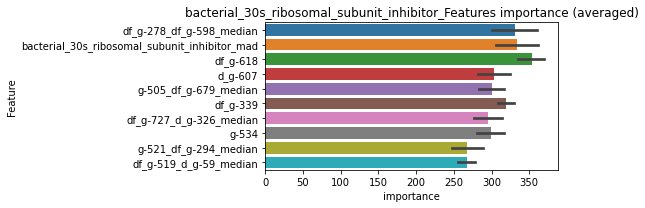

len(train_index) : 2818
len(valid_index) : 940
================================= fold 1/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12356	valid_1's binary_logloss: 0.167239
[200]	training's binary_logloss: 0.0515288	valid_1's binary_logloss: 0.0971251
[300]	training's binary_logloss: 0.0224499	valid_1's binary_logloss: 0.0645995
[400]	training's binary_logloss: 0.0102659	valid_1's binary_logloss: 0.0460844
[500]	training's binary_logloss: 0.00522377	valid_1's binary_logloss: 0.0351708
[600]	training's binary_logloss: 0.00306294	valid_1's binary_logloss: 0.0299675
[700]	training's binary_logloss: 0.00202113	valid_1's binary_logloss: 0.0267578
[800]	training's binary_logloss: 0.00148068	valid_1's binary_logloss: 0.0250504
[900]	training's binary_logloss: 0.00117199	valid_1's binary_logloss: 0.0240363
[1000]	training's binary_logloss: 0.000982482	valid_1's binary_logloss: 0.0235195
Early stopping, best iteration is:
[1011]	training's binary_logloss: 0.000969735	valid_1's binary_logloss: 0.023425


len(train_index) : 2818
len(valid_index) : 940
================================= fold 2/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127454	valid_1's binary_logloss: 0.176262
[200]	training's binary_logloss: 0.0519097	valid_1's binary_logloss: 0.10392
[300]	training's binary_logloss: 0.0235483	valid_1's binary_logloss: 0.0691793
[400]	training's binary_logloss: 0.0106981	valid_1's binary_logloss: 0.0503295
[500]	training's binary_logloss: 0.0055161	valid_1's binary_logloss: 0.0401559
[600]	training's binary_logloss: 0.00318344	valid_1's binary_logloss: 0.0347151
[700]	training's binary_logloss: 0.00209313	valid_1's binary_logloss: 0.0320235
[800]	training's binary_logloss: 0.001521	valid_1's binary_logloss: 0.0300419
[900]	training's binary_logloss: 0.00120217	valid_1's binary_logloss: 0.0288666
[1000]	training's binary_logloss: 0.00100021	valid_1's binary_logloss: 0.0284942
[1100]	training's binary_logloss: 0.000885129	valid_1's binary_logloss: 0.0275598
Early stopping, best iteration is:
[1131]	training's binary_logloss

len(train_index) : 2819
len(valid_index) : 939
================================= fold 3/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121279	valid_1's binary_logloss: 0.189847
[200]	training's binary_logloss: 0.0496291	valid_1's binary_logloss: 0.11795
[300]	training's binary_logloss: 0.0212321	valid_1's binary_logloss: 0.0813878
[400]	training's binary_logloss: 0.00990963	valid_1's binary_logloss: 0.0614227
[500]	training's binary_logloss: 0.00504759	valid_1's binary_logloss: 0.0514872
[600]	training's binary_logloss: 0.00296191	valid_1's binary_logloss: 0.0471499
[700]	training's binary_logloss: 0.00196331	valid_1's binary_logloss: 0.044228
[800]	training's binary_logloss: 0.00143904	valid_1's binary_logloss: 0.0426901
[900]	training's binary_logloss: 0.00114049	valid_1's binary_logloss: 0.0411872
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00114982	valid_1's binary_logloss: 0.041091


len(train_index) : 2819
len(valid_index) : 939
================================= fold 4/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120233	valid_1's binary_logloss: 0.16687
[200]	training's binary_logloss: 0.0488157	valid_1's binary_logloss: 0.0975437
[300]	training's binary_logloss: 0.0208742	valid_1's binary_logloss: 0.0638197
[400]	training's binary_logloss: 0.0095577	valid_1's binary_logloss: 0.047782
[500]	training's binary_logloss: 0.00497167	valid_1's binary_logloss: 0.0390982
[600]	training's binary_logloss: 0.00294051	valid_1's binary_logloss: 0.0344078
[700]	training's binary_logloss: 0.00196012	valid_1's binary_logloss: 0.0318905
[800]	training's binary_logloss: 0.00143727	valid_1's binary_logloss: 0.0299783
Early stopping, best iteration is:
[785]	training's binary_logloss: 0.00149894	valid_1's binary_logloss: 0.0298407


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03044966867754484
bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143405	valid_1's binary_logloss: 0.208047
[200]	training's binary_logloss: 0.0733995	valid_1's binary_logloss: 0.143635
[300]	training's binary_logloss: 0.037063	valid_1's binary_logloss: 0.107148
[400]	training's binary_logloss: 0.0194028	valid_1's binary_logloss: 0.0873001
[500]	training's binary_logloss: 0.0103152	valid_1's binary_logloss: 0.0769554
[600]	training's binary_logloss: 0.00597346	valid_1's binary_logloss: 0.0707193
[700]	training's binary_logloss: 0.00368889	valid_1's binary_logloss: 0.0668366
Early stopping, best iteration is:
[744]	training's binary_logloss: 0.00308107	valid_1's binary_logloss: 0.0653572
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.140074	valid_1's binary_logloss: 0.210258
[200]	training's binary_logloss: 0.0672629	valid_1's binary_logloss: 0.142498
[300]	training's binary_logloss: 0.0346134	valid_1's binar

1 / 3 AUC score:0.991
y_Threshold: 0.0329322, Threshold: 0.1785718, pos_neg_ratio: 0.8000000
Remove_noisy_data: 180 → Positive_corect_labels: 631/3752
p_label_rate: 0.0100452 Vs.target_rate: 0.00336, Num_p_label: 40.0, conf_0:0.12500, conf_1:0.23214
threshold: 0.1785718, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 631.0/3752, y_label_rate: 0.1681770
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126927	valid_1's binary_logloss: 0.187762
[200]	training's binary_logloss: 0.0542466	valid_1's binary_logloss: 0.116008
[300]	training's binary_logloss: 0.0259806	valid_1's binary_logloss: 0.0818357
[400]	training's binary_logloss: 0.0124798	valid_1's binary_logloss: 0.0637856
[500]	training's binary_logloss: 0.00648801	valid_1's binary_logloss: 0.053599
[600]	training's binary_logloss: 0.00375463	valid_1's binary_logloss: 0.0470957
[700]	training's binary_logloss: 0.00243342	valid_1's binary_logloss: 0.0436664
[800]	training's binary_logloss: 0.00176454	valid_1's binary_logloss: 0.0416499
[900]	training's binary_logloss: 0.00137706	valid_1's binary_logloss: 0.0408535
[1000]	training's binary_logloss: 0.00114115	valid_1's binary_logloss: 0.0395974
Early stopping, best iteration is:
[1067]	training's binary_logloss: 0.00104061	valid_1's binary_logloss: 0.0394473
Training until validation scor

2 / 3 AUC score:0.998
y_Threshold: 0.0697026, Threshold: 0.1785718, pos_neg_ratio: 0.8000000
Remove_noisy_data: 36 → Positive_corect_labels: 613.0/3716
p_label_rate: 0.0223506 Vs.target_rate: 0.00336, Num_p_label: 89.0, conf_0:0.14286, conf_1:0.21429
Num_p_label: 89.0, Expected: 13.4, Adj_threshold_1: 0.1785718
Num_p_label: 79.0, Expected: 13.4, Adj_threshold_2: 0.2085718
Num_p_label: 71.0, Expected: 13.4, Adj_threshold_3: 0.2385718
Num_p_label: 63.0, Expected: 13.4, Adj_threshold_4: 0.2685718
Num_p_label: 56.0, Expected: 13.4, Adj_threshold_5: 0.2985718
Num_p_label: 54.0, Expected: 13.4, Adj_threshold_6: 0.3285718
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_7: 0.3585718
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_8: 0.3885718
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_9: 0.4185718
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_10: 0.4485718
threshold: 0.4785718, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 613.0/3716, y_label_rate: 0.1649623

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123955	valid_1's binary_logloss: 0.174043
[200]	training's binary_logloss: 0.0506367	valid_1's binary_logloss: 0.102412
[300]	training's binary_logloss: 0.0226205	valid_1's binary_logloss: 0.0707178
[400]	training's binary_logloss: 0.0105638	valid_1's binary_logloss: 0.053525
[500]	training's binary_logloss: 0.00549847	valid_1's binary_logloss: 0.0450824
[600]	training's binary_logloss: 0.00325034	valid_1's binary_logloss: 0.0408622
[700]	training's binary_logloss: 0.00215766	valid_1's binary_logloss: 0.0388119
[800]	training's binary_logloss: 0.0015821	valid_1's binary_logloss: 0.0370607
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00136529	valid_1's binary_logloss: 0.0368329
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122001	valid_1's binary_logloss: 0.176907
[200]	training's binary_logloss: 0.0495013	valid_1's bi

3 / 3 AUC score:1.000
y_Threshold: 0.0985148, Threshold: 0.4785718, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 602.0/3694
p_label_rate: 0.0102963 Vs.target_rate: 0.00336, Num_p_label: 41.0, conf_0:0.43071, conf_1:0.52643
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_1: 0.4785718
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_2: 0.5085718
Num_p_label: 35.0, Expected: 13.4, Adj_threshold_3: 0.5385718
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_4: 0.5685718
Num_p_label: 30.0, Expected: 13.4, Adj_threshold_5: 0.5985718
Num_p_label: 29.0, Expected: 13.4, Adj_threshold_6: 0.6285718
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_7: 0.6585718
Num_p_label: 24.0, Expected: 13.4, Adj_threshold_8: 0.6885718
threshold: 0.6885718, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 602.0/3694, y_label_rate: 0.1629670


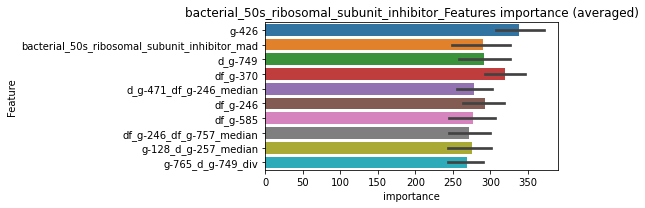

len(train_index) : 2770
len(valid_index) : 924
================================= fold 1/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119682	valid_1's binary_logloss: 0.16795
[200]	training's binary_logloss: 0.0488989	valid_1's binary_logloss: 0.0961918
[300]	training's binary_logloss: 0.0215946	valid_1's binary_logloss: 0.0608808
[400]	training's binary_logloss: 0.0100117	valid_1's binary_logloss: 0.0416287
[500]	training's binary_logloss: 0.0052189	valid_1's binary_logloss: 0.0314728
[600]	training's binary_logloss: 0.00309336	valid_1's binary_logloss: 0.0256421
[700]	training's binary_logloss: 0.00205095	valid_1's binary_logloss: 0.0223563
[800]	training's binary_logloss: 0.00151211	valid_1's binary_logloss: 0.0204133
[900]	training's binary_logloss: 0.0012042	valid_1's binary_logloss: 0.0190267
[1000]	training's binary_logloss: 0.00101101	valid_1's binary_logloss: 0.0183422
[1100]	training's binary_logloss: 0.00089789	valid_1's binary_logloss: 0.0177998
[1200]	training's binary_logloss: 0.000828875	valid_1's binary_log

len(train_index) : 2770
len(valid_index) : 924
================================= fold 2/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116517	valid_1's binary_logloss: 0.172033
[200]	training's binary_logloss: 0.0478178	valid_1's binary_logloss: 0.0967294
[300]	training's binary_logloss: 0.0219523	valid_1's binary_logloss: 0.06383
[400]	training's binary_logloss: 0.0102768	valid_1's binary_logloss: 0.0445793
[500]	training's binary_logloss: 0.00523463	valid_1's binary_logloss: 0.0342338
[600]	training's binary_logloss: 0.00305766	valid_1's binary_logloss: 0.0288951
[700]	training's binary_logloss: 0.00207274	valid_1's binary_logloss: 0.0269965
[800]	training's binary_logloss: 0.00149794	valid_1's binary_logloss: 0.0245695
[900]	training's binary_logloss: 0.00118917	valid_1's binary_logloss: 0.0233331
[1000]	training's binary_logloss: 0.00101049	valid_1's binary_logloss: 0.0227541
[1100]	training's binary_logloss: 0.000896321	valid_1's binary_logloss: 0.0224803
[1200]	training's binary_logloss: 0.000832729	valid_1's binary_l

len(train_index) : 2771
len(valid_index) : 923
================================= fold 3/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117715	valid_1's binary_logloss: 0.17403
[200]	training's binary_logloss: 0.0478045	valid_1's binary_logloss: 0.103747
[300]	training's binary_logloss: 0.021174	valid_1's binary_logloss: 0.0733891
[400]	training's binary_logloss: 0.0101408	valid_1's binary_logloss: 0.0590024
[500]	training's binary_logloss: 0.00518176	valid_1's binary_logloss: 0.0509773
[600]	training's binary_logloss: 0.00303246	valid_1's binary_logloss: 0.046839
[700]	training's binary_logloss: 0.00203671	valid_1's binary_logloss: 0.0447017
[800]	training's binary_logloss: 0.00149977	valid_1's binary_logloss: 0.0436279
[900]	training's binary_logloss: 0.00118897	valid_1's binary_logloss: 0.043015
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00118138	valid_1's binary_logloss: 0.0429865


len(train_index) : 2771
len(valid_index) : 923
================================= fold 4/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117204	valid_1's binary_logloss: 0.174603
[200]	training's binary_logloss: 0.0477158	valid_1's binary_logloss: 0.103296
[300]	training's binary_logloss: 0.0213099	valid_1's binary_logloss: 0.0701968
[400]	training's binary_logloss: 0.00992919	valid_1's binary_logloss: 0.0518447
[500]	training's binary_logloss: 0.00520082	valid_1's binary_logloss: 0.0424578
[600]	training's binary_logloss: 0.00308291	valid_1's binary_logloss: 0.0374195
[700]	training's binary_logloss: 0.00205287	valid_1's binary_logloss: 0.0338385
[800]	training's binary_logloss: 0.00151059	valid_1's binary_logloss: 0.032135
Early stopping, best iteration is:
[857]	training's binary_logloss: 0.00130695	valid_1's binary_logloss: 0.0310996


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.02828770811794508


neg labels: 3289 → selected neg labels: 3286


bacterial_antifolate, len(trt): 36, len(othr): 3286, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0974801	valid_1's binary_logloss: 0.135925
[200]	training's binary_logloss: 0.0334928	valid_1's binary_logloss: 0.0715125
[300]	training's binary_logloss: 0.0128516	valid_1's binary_logloss: 0.0462317
[400]	training's binary_logloss: 0.00553433	valid_1's binary_logloss: 0.0341458
[500]	training's binary_logloss: 0.00280895	valid_1's binary_logloss: 0.0288178
[600]	training's binary_logloss: 0.00170882	valid_1's binary_logloss: 0.0264855
[700]	training's binary_logloss: 0.00119095	valid_1's binary_logloss: 0.0251372
[800]	training's binary_logloss: 0.000920594	valid_1's binary_logloss: 0.0243036
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.000920594	valid_1's binary_logloss: 0.0243036
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0978909	valid_1's binary_logloss: 0.143584
[200]	training's binary_logloss: 0.0340906	vali

1 / 3 AUC score:0.999
y_Threshold: 0.0163439, Threshold: 0.1017126, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 651/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.07120, conf_1:0.13223
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1017126
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.1317126
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.1617126
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.1917126
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.2217126
threshold: 0.2217126, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/3799, y_label_rate: 0.1713609
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885417	valid_1's binary_logloss: 0.123827
[200]	training's binary_logloss: 0.0277675	valid_1's binary_logloss: 0.060801
[300]	training's binary_logloss: 0.0100492	valid_1's binary_logloss: 0.039096
[400]	training's binary_logloss: 0.00419888	valid_1's binary_logloss: 0.0286065
[500]	training's binary_logloss: 0.00216791	valid_1's binary_logloss: 0.0234583
[600]	training's binary_logloss: 0.00134928	valid_1's binary_logloss: 0.0211634
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00110687	valid_1's binary_logloss: 0.0203825
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0908931	valid_1's binary_logloss: 0.117498
[200]	training's binary_logloss: 0.0287787	valid_1's binary_logloss: 0.0511414
[300]	training's binary_logloss: 0.0107588	valid_1's binary_logloss: 0.0288173
[400]	training's binary_logloss: 0.0045459	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.0807997, Threshold: 0.2217126, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 636.0/3769
p_label_rate: 0.0185836 Vs.target_rate: 0.00151, Num_p_label: 74.0, conf_0:0.17737, conf_1:0.26606
Num_p_label: 74.0, Expected: 6.0, Adj_threshold_1: 0.2217126
Num_p_label: 70.0, Expected: 6.0, Adj_threshold_2: 0.2517126
Num_p_label: 64.0, Expected: 6.0, Adj_threshold_3: 0.2817126
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_4: 0.3117126
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_5: 0.3417126
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_6: 0.3717126
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_7: 0.4017126
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_8: 0.4317126
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_9: 0.4617126
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_10: 0.4917126
threshold: 0.5217126, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 636.0/3769, y_label_rate: 0.1687450
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0845164	valid_1's binary_logloss: 0.136185
[200]	training's binary_logloss: 0.0248726	valid_1's binary_logloss: 0.0809684
[300]	training's binary_logloss: 0.0085963	valid_1's binary_logloss: 0.0607984
[400]	training's binary_logloss: 0.00362928	valid_1's binary_logloss: 0.0551823
[500]	training's binary_logloss: 0.00192114	valid_1's binary_logloss: 0.0515156
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00171293	valid_1's binary_logloss: 0.0504203
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828524	valid_1's binary_logloss: 0.128398
[200]	training's binary_logloss: 0.0243148	valid_1's binary_logloss: 0.0644972
[300]	training's binary_logloss: 0.00848677	valid_1's binary_logloss: 0.0427586
[400]	training's binary_logloss: 0.00361344	valid_1's binary_logloss: 0.0338612
[500]	training's binary_logloss: 0.00188512	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.0931321, Threshold: 0.5217126, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 626.0/3749
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.46954, conf_1:0.57388
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.5217126
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.5517126
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_3: 0.5817126
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_4: 0.6117126
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_5: 0.6417126
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_6: 0.6717126
threshold: 0.6717126, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 626.0/3749, y_label_rate: 0.1669779


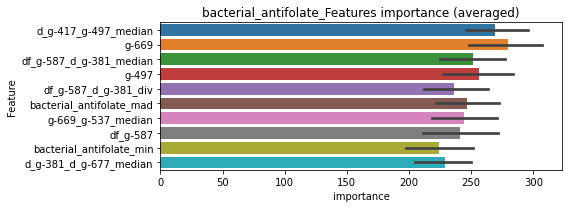

len(train_index) : 2811
len(valid_index) : 938
================================= fold 1/4 bacterial_antifolate=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0826264	valid_1's binary_logloss: 0.124193
[200]	training's binary_logloss: 0.0242523	valid_1's binary_logloss: 0.0568956
[300]	training's binary_logloss: 0.00853771	valid_1's binary_logloss: 0.0338101
[400]	training's binary_logloss: 0.00359747	valid_1's binary_logloss: 0.0250653
[500]	training's binary_logloss: 0.00187466	valid_1's binary_logloss: 0.0211975
[600]	training's binary_logloss: 0.00119389	valid_1's binary_logloss: 0.0199319
[700]	training's binary_logloss: 0.000846751	valid_1's binary_logloss: 0.0191164
[800]	training's binary_logloss: 0.000669556	valid_1's binary_logloss: 0.0186109
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000663158	valid_1's binary_logloss: 0.0185711


len(train_index) : 2812
len(valid_index) : 937
================================= fold 2/4 bacterial_antifolate=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0823498	valid_1's binary_logloss: 0.107907
[200]	training's binary_logloss: 0.0246596	valid_1's binary_logloss: 0.0462938
[300]	training's binary_logloss: 0.00860431	valid_1's binary_logloss: 0.0264256
[400]	training's binary_logloss: 0.00359707	valid_1's binary_logloss: 0.0178719
[500]	training's binary_logloss: 0.00188759	valid_1's binary_logloss: 0.0145805
[600]	training's binary_logloss: 0.00121202	valid_1's binary_logloss: 0.012501
[700]	training's binary_logloss: 0.00086024	valid_1's binary_logloss: 0.0113006
[800]	training's binary_logloss: 0.000679248	valid_1's binary_logloss: 0.0105616
[900]	training's binary_logloss: 0.000579053	valid_1's binary_logloss: 0.00991248
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.00056597	valid_1's binary_logloss: 0.00983261


len(train_index) : 2812
len(valid_index) : 937
================================= fold 3/4 bacterial_antifolate=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0833504	valid_1's binary_logloss: 0.106561
[200]	training's binary_logloss: 0.0247596	valid_1's binary_logloss: 0.0445904
[300]	training's binary_logloss: 0.00873695	valid_1's binary_logloss: 0.0241581
[400]	training's binary_logloss: 0.00372706	valid_1's binary_logloss: 0.0159746
[500]	training's binary_logloss: 0.00196118	valid_1's binary_logloss: 0.0120233
[600]	training's binary_logloss: 0.00123364	valid_1's binary_logloss: 0.0102464
[700]	training's binary_logloss: 0.000878075	valid_1's binary_logloss: 0.00920133
[800]	training's binary_logloss: 0.00069299	valid_1's binary_logloss: 0.00883258
[900]	training's binary_logloss: 0.000586903	valid_1's binary_logloss: 0.00833353
[1000]	training's binary_logloss: 0.000532528	valid_1's binary_logloss: 0.00820864
Early stopping, best iteration is:
[993]	training's binary_logloss: 0.000535584	valid_1's binary_logloss: 0.00818688


len(train_index) : 2812
len(valid_index) : 937
================================= fold 4/4 bacterial_antifolate=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0844378	valid_1's binary_logloss: 0.107797
[200]	training's binary_logloss: 0.0255341	valid_1's binary_logloss: 0.0451352
[300]	training's binary_logloss: 0.00896035	valid_1's binary_logloss: 0.0249679
[400]	training's binary_logloss: 0.0037694	valid_1's binary_logloss: 0.0173214
[500]	training's binary_logloss: 0.00194668	valid_1's binary_logloss: 0.013553
[600]	training's binary_logloss: 0.00122648	valid_1's binary_logloss: 0.012021
[700]	training's binary_logloss: 0.000877613	valid_1's binary_logloss: 0.0113405
[800]	training's binary_logloss: 0.000686326	valid_1's binary_logloss: 0.0109659
[900]	training's binary_logloss: 0.000588685	valid_1's binary_logloss: 0.0107183
Early stopping, best iteration is:
[913]	training's binary_logloss: 0.000579236	valid_1's binary_logloss: 0.0107027


bacterial_antifolate logloss: 0.011825125165748065
bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3268, target_rate: 0.0080625 → Adj_target_rate: 0.0073283


neg labels: 3289 → selected neg labels: 3268


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.199075	valid_1's binary_logloss: 0.314518
[200]	training's binary_logloss: 0.113627	valid_1's binary_logloss: 0.267503
[300]	training's binary_logloss: 0.068197	valid_1's binary_logloss: 0.243385
[400]	training's binary_logloss: 0.0419032	valid_1's binary_logloss: 0.231387
[500]	training's binary_logloss: 0.0260678	valid_1's binary_logloss: 0.223036
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.0197204	valid_1's binary_logloss: 0.220538
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.200641	valid_1's binary_logloss: 0.306184
[200]	training's binary_logloss: 0.111047	valid_1's binary_logloss: 0.258095
[300]	training's binary_logloss: 0.0662029	valid_1's binary_logloss: 0.236506
[400]	training's binary_logloss: 0.0415957	valid_1's binary_logloss: 0.226398
[500]	training's binary_logloss: 0.0264766	valid_1's binary_logloss:

1 / 3 AUC score:0.924
y_Threshold: 0.0916110, Threshold: 0.3378437, pos_neg_ratio: 0.8000000
Remove_noisy_data: 348 → Positive_corect_labels: 545/3573
p_label_rate: 0.0100452 Vs.target_rate: 0.00806, Num_p_label: 40.0, conf_0:0.23649, conf_1:0.43920
threshold: 0.3378437, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 545.0/3573, y_label_rate: 0.1525329
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148281	valid_1's binary_logloss: 0.230896
[200]	training's binary_logloss: 0.0688826	valid_1's binary_logloss: 0.169172
[300]	training's binary_logloss: 0.0359644	valid_1's binary_logloss: 0.140254
[400]	training's binary_logloss: 0.0192017	valid_1's binary_logloss: 0.122901
[500]	training's binary_logloss: 0.0109064	valid_1's binary_logloss: 0.114319
[600]	training's binary_logloss: 0.00659214	valid_1's binary_logloss: 0.10817
[700]	training's binary_logloss: 0.00428994	valid_1's binary_logloss: 0.104568
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.00351079	valid_1's binary_logloss: 0.103456
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148114	valid_1's binary_logloss: 0.248029
[200]	training's binary_logloss: 0.0701195	valid_1's binary_logloss: 0.190894
[300]	training's binary_logloss: 0.0361561	valid_1's binary_log

2 / 3 AUC score:0.986
y_Threshold: 0.1099836, Threshold: 0.3378437, pos_neg_ratio: 0.8000000
Remove_noisy_data: 116 → Positive_corect_labels: 487.0/3457
p_label_rate: 0.0298845 Vs.target_rate: 0.00806, Num_p_label: 119.0, conf_0:0.27027, conf_1:0.40541
Num_p_label: 119.0, Expected: 32.1, Adj_threshold_1: 0.3378437
Num_p_label: 106.0, Expected: 32.1, Adj_threshold_2: 0.3678437
Num_p_label: 102.0, Expected: 32.1, Adj_threshold_3: 0.3978437
Num_p_label: 91.0, Expected: 32.1, Adj_threshold_4: 0.4278437
Num_p_label: 85.0, Expected: 32.1, Adj_threshold_5: 0.4578437
Num_p_label: 76.0, Expected: 32.1, Adj_threshold_6: 0.4878437
Num_p_label: 70.0, Expected: 32.1, Adj_threshold_7: 0.5178437
Num_p_label: 63.0, Expected: 32.1, Adj_threshold_8: 0.5478437
Num_p_label: 55.0, Expected: 32.1, Adj_threshold_9: 0.5778437
Num_p_label: 55.0, Expected: 32.1, Adj_threshold_10: 0.6078437
threshold: 0.6378437, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 487.0/3457, y_label_rate: 0.14

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116821	valid_1's binary_logloss: 0.206787
[200]	training's binary_logloss: 0.0506764	valid_1's binary_logloss: 0.149452
[300]	training's binary_logloss: 0.0241301	valid_1's binary_logloss: 0.122871
[400]	training's binary_logloss: 0.0123533	valid_1's binary_logloss: 0.111268
[500]	training's binary_logloss: 0.00672011	valid_1's binary_logloss: 0.1046
[600]	training's binary_logloss: 0.00405353	valid_1's binary_logloss: 0.102007
[700]	training's binary_logloss: 0.00269243	valid_1's binary_logloss: 0.100025
Early stopping, best iteration is:
[748]	training's binary_logloss: 0.00230373	valid_1's binary_logloss: 0.09923
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123106	valid_1's binary_logloss: 0.183043
[200]	training's binary_logloss: 0.0538798	valid_1's binary_logloss: 0.120775
[300]	training's binary_logloss: 0.0258559	valid_1's binary_logl

3 / 3 AUC score:0.995
y_Threshold: 0.0901525, Threshold: 0.6378437, pos_neg_ratio: 0.8000000
Remove_noisy_data: 54 → Positive_corect_labels: 460.0/3403
p_label_rate: 0.0243596 Vs.target_rate: 0.00806, Num_p_label: 97.0, conf_0:0.50000, conf_1:0.70163
Num_p_label: 97.0, Expected: 32.1, Adj_threshold_1: 0.6378437
Num_p_label: 88.0, Expected: 32.1, Adj_threshold_2: 0.6678437
Num_p_label: 84.0, Expected: 32.1, Adj_threshold_3: 0.6978437
threshold: 0.6978437, positive_p_label: 84.0/3982, p_label_rate: 0.0210949
positive_y_label: 460.0/3403, y_label_rate: 0.1351748


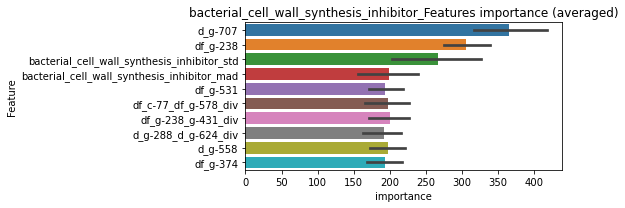

len(train_index) : 2552
len(valid_index) : 851
================================= fold 1/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108774	valid_1's binary_logloss: 0.181665
[200]	training's binary_logloss: 0.0448535	valid_1's binary_logloss: 0.128687
[300]	training's binary_logloss: 0.0204174	valid_1's binary_logloss: 0.105965
[400]	training's binary_logloss: 0.0100709	valid_1's binary_logloss: 0.0951109
[500]	training's binary_logloss: 0.00545147	valid_1's binary_logloss: 0.0910945
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00514054	valid_1's binary_logloss: 0.0906066


len(train_index) : 2552
len(valid_index) : 851
================================= fold 2/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111428	valid_1's binary_logloss: 0.16511
[200]	training's binary_logloss: 0.045418	valid_1's binary_logloss: 0.110143
[300]	training's binary_logloss: 0.0210492	valid_1's binary_logloss: 0.0863759
[400]	training's binary_logloss: 0.0103627	valid_1's binary_logloss: 0.0743831
[500]	training's binary_logloss: 0.00565607	valid_1's binary_logloss: 0.0678748
[600]	training's binary_logloss: 0.00341723	valid_1's binary_logloss: 0.0646892
[700]	training's binary_logloss: 0.00232011	valid_1's binary_logloss: 0.0627228
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00192644	valid_1's binary_logloss: 0.0618664


len(train_index) : 2552
len(valid_index) : 851
================================= fold 3/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109574	valid_1's binary_logloss: 0.185099
[200]	training's binary_logloss: 0.0468756	valid_1's binary_logloss: 0.132851
[300]	training's binary_logloss: 0.0220653	valid_1's binary_logloss: 0.108902
[400]	training's binary_logloss: 0.0108278	valid_1's binary_logloss: 0.0954785
[500]	training's binary_logloss: 0.00578076	valid_1's binary_logloss: 0.0878303
[600]	training's binary_logloss: 0.00348239	valid_1's binary_logloss: 0.0851072
[700]	training's binary_logloss: 0.00233034	valid_1's binary_logloss: 0.0835248
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.00240174	valid_1's binary_logloss: 0.0833841


len(train_index) : 2553
len(valid_index) : 850
================================= fold 4/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109214	valid_1's binary_logloss: 0.180958
[200]	training's binary_logloss: 0.0455466	valid_1's binary_logloss: 0.129464
[300]	training's binary_logloss: 0.0205108	valid_1's binary_logloss: 0.105859
[400]	training's binary_logloss: 0.00995652	valid_1's binary_logloss: 0.0957938
[500]	training's binary_logloss: 0.00540682	valid_1's binary_logloss: 0.0912682
[600]	training's binary_logloss: 0.00327514	valid_1's binary_logloss: 0.090037
[700]	training's binary_logloss: 0.00224104	valid_1's binary_logloss: 0.0891869
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00231486	valid_1's binary_logloss: 0.0888308


bacterial_cell_wall_synthesis_inhibitor logloss: 0.08116972176210845
bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3279, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145758	valid_1's binary_logloss: 0.221668
[200]	training's binary_logloss: 0.068623	valid_1's binary_logloss: 0.157514
[300]	training's binary_logloss: 0.0353447	valid_1's binary_logloss: 0.125756
[400]	training's binary_logloss: 0.0182264	valid_1's binary_logloss: 0.107667
[500]	training's binary_logloss: 0.00997351	valid_1's binary_logloss: 0.0959555
[600]	training's binary_logloss: 0.00574308	valid_1's binary_logloss: 0.0888827
[700]	training's binary_logloss: 0.00369305	valid_1's binary_logloss: 0.0862497
[800]	training's binary_logloss: 0.00254455	valid_1's binary_logloss: 0.0836155
[900]	training's binary_logloss: 0.00191461	valid_1's binary_logloss: 0.0824615
[1000]	training's binary_logloss: 0.00153147	valid_1's binary_logloss: 0.0818204
Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.00150819	valid_1's binary_logloss: 0.0816775
Training until validation scores

1 / 3 AUC score:0.992
y_Threshold: 0.0362249, Threshold: 0.1583664, pos_neg_ratio: 0.8000000
Remove_noisy_data: 180 → Positive_corect_labels: 631/3754
p_label_rate: 0.0100452 Vs.target_rate: 0.00374, Num_p_label: 40.0, conf_0:0.11086, conf_1:0.20588
threshold: 0.1583664, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 631.0/3754, y_label_rate: 0.1680874
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136613	valid_1's binary_logloss: 0.204716
[200]	training's binary_logloss: 0.0593758	valid_1's binary_logloss: 0.135201
[300]	training's binary_logloss: 0.0281398	valid_1's binary_logloss: 0.101458
[400]	training's binary_logloss: 0.0137507	valid_1's binary_logloss: 0.0836066
[500]	training's binary_logloss: 0.00715314	valid_1's binary_logloss: 0.0743513
[600]	training's binary_logloss: 0.00413761	valid_1's binary_logloss: 0.0698959
[700]	training's binary_logloss: 0.00268448	valid_1's binary_logloss: 0.0676563
[800]	training's binary_logloss: 0.00191979	valid_1's binary_logloss: 0.0655067
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.00169226	valid_1's binary_logloss: 0.0647236
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13409	valid_1's binary_logloss: 0.200064
[200]	training's binary_logloss: 0.0572552	valid_1's bi

2 / 3 AUC score:0.997
y_Threshold: 0.0954265, Threshold: 0.1583664, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 610.0/3712
p_label_rate: 0.0233551 Vs.target_rate: 0.00374, Num_p_label: 93.0, conf_0:0.12669, conf_1:0.19004
Num_p_label: 93.0, Expected: 14.9, Adj_threshold_1: 0.1583664
Num_p_label: 81.0, Expected: 14.9, Adj_threshold_2: 0.1883664
Num_p_label: 74.0, Expected: 14.9, Adj_threshold_3: 0.2183664
Num_p_label: 64.0, Expected: 14.9, Adj_threshold_4: 0.2483664
Num_p_label: 61.0, Expected: 14.9, Adj_threshold_5: 0.2783664
Num_p_label: 56.0, Expected: 14.9, Adj_threshold_6: 0.3083664
Num_p_label: 52.0, Expected: 14.9, Adj_threshold_7: 0.3383664
Num_p_label: 47.0, Expected: 14.9, Adj_threshold_8: 0.3683664
Num_p_label: 43.0, Expected: 14.9, Adj_threshold_9: 0.3983664
Num_p_label: 37.0, Expected: 14.9, Adj_threshold_10: 0.4283664
threshold: 0.4583664, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 610.0/3712, y_label_rate: 0.1643319

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124786	valid_1's binary_logloss: 0.181878
[200]	training's binary_logloss: 0.0510762	valid_1's binary_logloss: 0.105409
[300]	training's binary_logloss: 0.0236726	valid_1's binary_logloss: 0.0709124
[400]	training's binary_logloss: 0.0114874	valid_1's binary_logloss: 0.0516479
[500]	training's binary_logloss: 0.0058779	valid_1's binary_logloss: 0.0394504
[600]	training's binary_logloss: 0.00345807	valid_1's binary_logloss: 0.0329142
[700]	training's binary_logloss: 0.00228844	valid_1's binary_logloss: 0.0296387
[800]	training's binary_logloss: 0.00167748	valid_1's binary_logloss: 0.0281024
[900]	training's binary_logloss: 0.00131518	valid_1's binary_logloss: 0.0267846
[1000]	training's binary_logloss: 0.00110422	valid_1's binary_logloss: 0.0258845
Early stopping, best iteration is:
[1065]	training's binary_logloss: 0.00101308	valid_1's binary_logloss: 0.0253406
Training until validation scor

3 / 3 AUC score:1.000
y_Threshold: 0.0922431, Threshold: 0.4583664, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 599.0/3690
p_label_rate: 0.0097941 Vs.target_rate: 0.00374, Num_p_label: 39.0, conf_0:0.41253, conf_1:0.50420
threshold: 0.4583664, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 599.0/3690, y_label_rate: 0.1623306


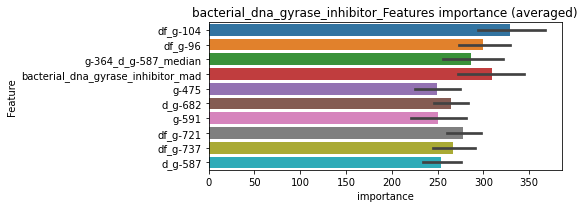

len(train_index) : 2767
len(valid_index) : 923
================================= fold 1/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124244	valid_1's binary_logloss: 0.184626
[200]	training's binary_logloss: 0.0495349	valid_1's binary_logloss: 0.107832
[300]	training's binary_logloss: 0.0222478	valid_1's binary_logloss: 0.0736461
[400]	training's binary_logloss: 0.0107319	valid_1's binary_logloss: 0.0563395
[500]	training's binary_logloss: 0.00561964	valid_1's binary_logloss: 0.0452314
[600]	training's binary_logloss: 0.00330219	valid_1's binary_logloss: 0.0398974
[700]	training's binary_logloss: 0.00218686	valid_1's binary_logloss: 0.0365868
[800]	training's binary_logloss: 0.00160216	valid_1's binary_logloss: 0.0344882
[900]	training's binary_logloss: 0.00126883	valid_1's binary_logloss: 0.0330378
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.00122962	valid_1's binary_logloss: 0.0329506


len(train_index) : 2767
len(valid_index) : 923
================================= fold 2/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121127	valid_1's binary_logloss: 0.187642
[200]	training's binary_logloss: 0.0493406	valid_1's binary_logloss: 0.118201
[300]	training's binary_logloss: 0.0215951	valid_1's binary_logloss: 0.085816
[400]	training's binary_logloss: 0.0104236	valid_1's binary_logloss: 0.0725497
[500]	training's binary_logloss: 0.00536498	valid_1's binary_logloss: 0.0619411
[600]	training's binary_logloss: 0.0031983	valid_1's binary_logloss: 0.0570154
[700]	training's binary_logloss: 0.00212554	valid_1's binary_logloss: 0.0542334
[800]	training's binary_logloss: 0.0015647	valid_1's binary_logloss: 0.052432
[900]	training's binary_logloss: 0.00124307	valid_1's binary_logloss: 0.0517861
[1000]	training's binary_logloss: 0.00105397	valid_1's binary_logloss: 0.0510765
Early stopping, best iteration is:
[1060]	training's binary_logloss: 0.000981189	valid_1's binary_logloss: 0.0508434


len(train_index) : 2768
len(valid_index) : 922
================================= fold 3/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124437	valid_1's binary_logloss: 0.182303
[200]	training's binary_logloss: 0.0500326	valid_1's binary_logloss: 0.111283
[300]	training's binary_logloss: 0.0223088	valid_1's binary_logloss: 0.0780092
[400]	training's binary_logloss: 0.0104819	valid_1's binary_logloss: 0.0592053
[500]	training's binary_logloss: 0.00542313	valid_1's binary_logloss: 0.0489068
[600]	training's binary_logloss: 0.00319204	valid_1's binary_logloss: 0.0433311
[700]	training's binary_logloss: 0.00212884	valid_1's binary_logloss: 0.0404493
[800]	training's binary_logloss: 0.00156145	valid_1's binary_logloss: 0.0390328
[900]	training's binary_logloss: 0.00124264	valid_1's binary_logloss: 0.03743
[1000]	training's binary_logloss: 0.00104794	valid_1's binary_logloss: 0.0367775
[1100]	training's binary_logloss: 0.000931796	valid_1's binary_logloss: 0.0363488
Early stopping, best iteration is:
[1073]	training's binary_loglo

len(train_index) : 2768
len(valid_index) : 922
================================= fold 4/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123813	valid_1's binary_logloss: 0.178768
[200]	training's binary_logloss: 0.0487188	valid_1's binary_logloss: 0.109519
[300]	training's binary_logloss: 0.021472	valid_1's binary_logloss: 0.0811954
[400]	training's binary_logloss: 0.010098	valid_1's binary_logloss: 0.0664916
[500]	training's binary_logloss: 0.00526958	valid_1's binary_logloss: 0.0583947
[600]	training's binary_logloss: 0.00312068	valid_1's binary_logloss: 0.0543218
[700]	training's binary_logloss: 0.00209999	valid_1's binary_logloss: 0.0516722
[800]	training's binary_logloss: 0.00154539	valid_1's binary_logloss: 0.0507028
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.00132329	valid_1's binary_logloss: 0.0499587


bacterial_dna_gyrase_inhibitor logloss: 0.042477413212220566
bacterial_dna_inhibitor, len(trt): 115, len(othr): 3274, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.155224	valid_1's binary_logloss: 0.237799
[200]	training's binary_logloss: 0.0736561	valid_1's binary_logloss: 0.174725
[300]	training's binary_logloss: 0.0387849	valid_1's binary_logloss: 0.145412
[400]	training's binary_logloss: 0.0214246	valid_1's binary_logloss: 0.129718
[500]	training's binary_logloss: 0.0123352	valid_1's binary_logloss: 0.121302
[600]	training's binary_logloss: 0.00736832	valid_1's binary_logloss: 0.118034
[700]	training's binary_logloss: 0.00477414	valid_1's binary_logloss: 0.115582
[800]	training's binary_logloss: 0.00330583	valid_1's binary_logloss: 0.113113
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00295689	valid_1's binary_logloss: 0.112733
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.155161	valid_1's binary_logloss: 0.240505
[200]	training's binary_logloss: 0.0746402	valid_1's binary_l

1 / 3 AUC score:0.983
y_Threshold: 0.0472743, Threshold: 0.2590850, pos_neg_ratio: 0.8000000
Remove_noisy_data: 206 → Positive_corect_labels: 617/3722
p_label_rate: 0.0100452 Vs.target_rate: 0.00483, Num_p_label: 40.0, conf_0:0.18136, conf_1:0.33681
threshold: 0.2590850, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 617.0/3722, y_label_rate: 0.1657711
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134277	valid_1's binary_logloss: 0.205882
[200]	training's binary_logloss: 0.0581025	valid_1's binary_logloss: 0.135872
[300]	training's binary_logloss: 0.0278355	valid_1's binary_logloss: 0.104528
[400]	training's binary_logloss: 0.0141279	valid_1's binary_logloss: 0.0858624
[500]	training's binary_logloss: 0.0077454	valid_1's binary_logloss: 0.0757638
[600]	training's binary_logloss: 0.00465828	valid_1's binary_logloss: 0.0691889
[700]	training's binary_logloss: 0.00306107	valid_1's binary_logloss: 0.064415
[800]	training's binary_logloss: 0.00221685	valid_1's binary_logloss: 0.0621235
[900]	training's binary_logloss: 0.00172309	valid_1's binary_logloss: 0.0607444
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.00166997	valid_1's binary_logloss: 0.06058
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135756	valid_1's bin

2 / 3 AUC score:0.994
y_Threshold: 0.1037500, Threshold: 0.2590850, pos_neg_ratio: 0.8000000
Remove_noisy_data: 76 → Positive_corect_labels: 579.0/3646
p_label_rate: 0.0271220 Vs.target_rate: 0.00483, Num_p_label: 108.0, conf_0:0.20727, conf_1:0.31090
Num_p_label: 108.0, Expected: 19.2, Adj_threshold_1: 0.2590850
Num_p_label: 101.0, Expected: 19.2, Adj_threshold_2: 0.2890850
Num_p_label: 90.0, Expected: 19.2, Adj_threshold_3: 0.3190850
Num_p_label: 83.0, Expected: 19.2, Adj_threshold_4: 0.3490850
Num_p_label: 78.0, Expected: 19.2, Adj_threshold_5: 0.3790850
Num_p_label: 73.0, Expected: 19.2, Adj_threshold_6: 0.4090850
Num_p_label: 66.0, Expected: 19.2, Adj_threshold_7: 0.4390850
Num_p_label: 64.0, Expected: 19.2, Adj_threshold_8: 0.4690850
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_9: 0.4990850
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_10: 0.5290850
threshold: 0.5590850, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 579.0/3646, y_label_rate: 0.1588

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122131	valid_1's binary_logloss: 0.191521
[200]	training's binary_logloss: 0.0479305	valid_1's binary_logloss: 0.125828
[300]	training's binary_logloss: 0.0223014	valid_1's binary_logloss: 0.0975751
[400]	training's binary_logloss: 0.0109714	valid_1's binary_logloss: 0.0828679
[500]	training's binary_logloss: 0.00583047	valid_1's binary_logloss: 0.0743583
[600]	training's binary_logloss: 0.00349664	valid_1's binary_logloss: 0.0700666
[700]	training's binary_logloss: 0.00236461	valid_1's binary_logloss: 0.0675153
[800]	training's binary_logloss: 0.00174842	valid_1's binary_logloss: 0.0659333
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.00155709	valid_1's binary_logloss: 0.0655725
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118755	valid_1's binary_logloss: 0.183703
[200]	training's binary_logloss: 0.0469965	valid_1's 

3 / 3 AUC score:0.995
y_Threshold: 0.0855916, Threshold: 0.5590850, pos_neg_ratio: 0.8000000
Remove_noisy_data: 52 → Positive_corect_labels: 553.0/3594
p_label_rate: 0.0190859 Vs.target_rate: 0.00483, Num_p_label: 76.0, conf_0:0.50000, conf_1:0.61499
Num_p_label: 76.0, Expected: 19.2, Adj_threshold_1: 0.5590850
Num_p_label: 72.0, Expected: 19.2, Adj_threshold_2: 0.5890850
Num_p_label: 66.0, Expected: 19.2, Adj_threshold_3: 0.6190850
Num_p_label: 61.0, Expected: 19.2, Adj_threshold_4: 0.6490850
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_5: 0.6790850
threshold: 0.6790850, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 553.0/3594, y_label_rate: 0.1538676


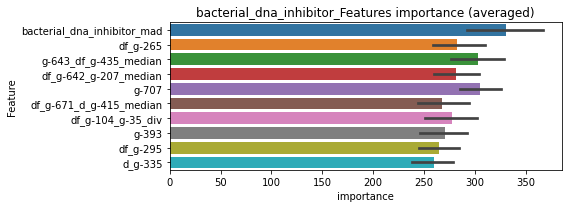

len(train_index) : 2695
len(valid_index) : 899
================================= fold 1/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111632	valid_1's binary_logloss: 0.175926
[200]	training's binary_logloss: 0.0429874	valid_1's binary_logloss: 0.11898
[300]	training's binary_logloss: 0.019269	valid_1's binary_logloss: 0.0947404
[400]	training's binary_logloss: 0.00938765	valid_1's binary_logloss: 0.0820718
[500]	training's binary_logloss: 0.00504708	valid_1's binary_logloss: 0.0742064
[600]	training's binary_logloss: 0.00307196	valid_1's binary_logloss: 0.0696734
[700]	training's binary_logloss: 0.00208108	valid_1's binary_logloss: 0.0677227
[800]	training's binary_logloss: 0.00155616	valid_1's binary_logloss: 0.065619
[900]	training's binary_logloss: 0.00123842	valid_1's binary_logloss: 0.0648108
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.00121509	valid_1's binary_logloss: 0.0646376


len(train_index) : 2695
len(valid_index) : 899
================================= fold 2/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111676	valid_1's binary_logloss: 0.173615
[200]	training's binary_logloss: 0.0424634	valid_1's binary_logloss: 0.105541
[300]	training's binary_logloss: 0.0186068	valid_1's binary_logloss: 0.0761551
[400]	training's binary_logloss: 0.0090233	valid_1's binary_logloss: 0.0614508
[500]	training's binary_logloss: 0.00490731	valid_1's binary_logloss: 0.053646
[600]	training's binary_logloss: 0.00299242	valid_1's binary_logloss: 0.0490281
[700]	training's binary_logloss: 0.002053	valid_1's binary_logloss: 0.0458118
[800]	training's binary_logloss: 0.00154838	valid_1's binary_logloss: 0.0443568
[900]	training's binary_logloss: 0.00124115	valid_1's binary_logloss: 0.0426092
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.00116861	valid_1's binary_logloss: 0.0423351


len(train_index) : 2696
len(valid_index) : 898
================================= fold 3/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116403	valid_1's binary_logloss: 0.168923
[200]	training's binary_logloss: 0.046196	valid_1's binary_logloss: 0.0992442
[300]	training's binary_logloss: 0.0202363	valid_1's binary_logloss: 0.0688642
[400]	training's binary_logloss: 0.00995144	valid_1's binary_logloss: 0.0516471
[500]	training's binary_logloss: 0.00535732	valid_1's binary_logloss: 0.042282
[600]	training's binary_logloss: 0.00322024	valid_1's binary_logloss: 0.036597
[700]	training's binary_logloss: 0.00217998	valid_1's binary_logloss: 0.0331718
[800]	training's binary_logloss: 0.00162945	valid_1's binary_logloss: 0.0312275
[900]	training's binary_logloss: 0.00130028	valid_1's binary_logloss: 0.0300365
[1000]	training's binary_logloss: 0.00109487	valid_1's binary_logloss: 0.0290016
[1100]	training's binary_logloss: 0.000958053	valid_1's binary_logloss: 0.0282847
[1200]	training's binary_logloss: 0.000881365	valid_1's binary_l

len(train_index) : 2696
len(valid_index) : 898
================================= fold 4/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115113	valid_1's binary_logloss: 0.18715
[200]	training's binary_logloss: 0.0449801	valid_1's binary_logloss: 0.121576
[300]	training's binary_logloss: 0.0196478	valid_1's binary_logloss: 0.0938588
[400]	training's binary_logloss: 0.00947985	valid_1's binary_logloss: 0.0798521
[500]	training's binary_logloss: 0.00509441	valid_1's binary_logloss: 0.0724982
[600]	training's binary_logloss: 0.00310647	valid_1's binary_logloss: 0.0697283
[700]	training's binary_logloss: 0.00211231	valid_1's binary_logloss: 0.0671364
Early stopping, best iteration is:
[712]	training's binary_logloss: 0.00202937	valid_1's binary_logloss: 0.0668778


bacterial_dna_inhibitor logloss: 0.05037782764802791
bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0695835	valid_1's binary_logloss: 0.0919879
[200]	training's binary_logloss: 0.0184112	valid_1's binary_logloss: 0.0336365
[300]	training's binary_logloss: 0.00596897	valid_1's binary_logloss: 0.0164089
[400]	training's binary_logloss: 0.00242475	valid_1's binary_logloss: 0.00991277
[500]	training's binary_logloss: 0.00128891	valid_1's binary_logloss: 0.00744329
[600]	training's binary_logloss: 0.000831261	valid_1's binary_logloss: 0.00610927
[700]	training's binary_logloss: 0.000611225	valid_1's binary_logloss: 0.0054653
[800]	training's binary_logloss: 0.00049133	valid_1's binary_logloss: 0.00500682
Early stopping, best iteration is:
[801]	training's binary_logloss: 0.000490419	valid_1's binary_logloss: 0.00500285
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0704081	valid_1's binary_logloss: 0.0935528
[200]	training's binary_logloss: 0.018

1 / 3 AUC score:1.000
y_Threshold: 0.0047092, Threshold: 0.0280311, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.01962, conf_1:0.03644
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0280311
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_2: 0.0580311
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.0880311
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.1180311
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.1480311
threshold: 0.1480311, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0675255	valid_1's binary_logloss: 0.0897072
[200]	training's binary_logloss: 0.0164408	valid_1's binary_logloss: 0.0304416
[300]	training's binary_logloss: 0.00514993	valid_1's binary_logloss: 0.0135807
[400]	training's binary_logloss: 0.00208037	valid_1's binary_logloss: 0.00769962
[500]	training's binary_logloss: 0.00110964	valid_1's binary_logloss: 0.00530689
[600]	training's binary_logloss: 0.000721936	valid_1's binary_logloss: 0.0042696
[700]	training's binary_logloss: 0.000536106	valid_1's binary_logloss: 0.00379797
[800]	training's binary_logloss: 0.000438299	valid_1's binary_logloss: 0.00347082
[900]	training's binary_logloss: 0.000400059	valid_1's binary_logloss: 0.00339861
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.000402711	valid_1's binary_logloss: 0.0033902
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0528606, Threshold: 0.1480311, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0065294 Vs.target_rate: 0.00080, Num_p_label: 26.0, conf_0:0.11842, conf_1:0.17764
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_1: 0.1480311
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.1780311
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_3: 0.2080311
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_4: 0.2380311
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.2680311
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.2980311
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_7: 0.3280311
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.3580311
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.3880311
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.4180311
threshold: 0.4480311, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
=============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679398	valid_1's binary_logloss: 0.0952038
[200]	training's binary_logloss: 0.0164501	valid_1's binary_logloss: 0.034289
[300]	training's binary_logloss: 0.0050773	valid_1's binary_logloss: 0.0169344
[400]	training's binary_logloss: 0.00205307	valid_1's binary_logloss: 0.011126
[500]	training's binary_logloss: 0.00109479	valid_1's binary_logloss: 0.00841713
[600]	training's binary_logloss: 0.000711572	valid_1's binary_logloss: 0.00688576
[700]	training's binary_logloss: 0.000529231	valid_1's binary_logloss: 0.00628208
[800]	training's binary_logloss: 0.000438875	valid_1's binary_logloss: 0.00588395
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.00041312	valid_1's binary_logloss: 0.00581128
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679306	valid_1's binary_logloss: 0.0912922
[200]	training's binary_logloss: 0.016797

3 / 3 AUC score:1.000
y_Threshold: 0.0771926, Threshold: 0.4480311, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.40323, conf_1:0.49283
threshold: 0.4480311, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3809, y_label_rate: 0.1722237


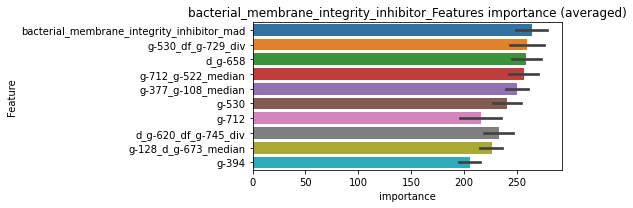

len(train_index) : 2856
len(valid_index) : 953
================================= fold 1/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0676106	valid_1's binary_logloss: 0.0944924
[200]	training's binary_logloss: 0.0165794	valid_1's binary_logloss: 0.0354821
[300]	training's binary_logloss: 0.00514075	valid_1's binary_logloss: 0.0177209
[400]	training's binary_logloss: 0.00219516	valid_1's binary_logloss: 0.0117452
[500]	training's binary_logloss: 0.00108921	valid_1's binary_logloss: 0.00860675
[600]	training's binary_logloss: 0.000693136	valid_1's binary_logloss: 0.00681077
[700]	training's binary_logloss: 0.000512043	valid_1's binary_logloss: 0.00610912
[800]	training's binary_logloss: 0.000420309	valid_1's binary_logloss: 0.00580452
Early stopping, best iteration is:
[854]	training's binary_logloss: 0.000399374	valid_1's binary_logloss: 0.00574405


len(train_index) : 2857
len(valid_index) : 952
================================= fold 2/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0682874	valid_1's binary_logloss: 0.0908023
[200]	training's binary_logloss: 0.0166162	valid_1's binary_logloss: 0.0347035
[300]	training's binary_logloss: 0.00507581	valid_1's binary_logloss: 0.0188876
[400]	training's binary_logloss: 0.0020758	valid_1's binary_logloss: 0.0129987
[500]	training's binary_logloss: 0.00110079	valid_1's binary_logloss: 0.0104176
[600]	training's binary_logloss: 0.000712612	valid_1's binary_logloss: 0.00897607
[700]	training's binary_logloss: 0.000527729	valid_1's binary_logloss: 0.00793363
[800]	training's binary_logloss: 0.00043278	valid_1's binary_logloss: 0.00759854
Early stopping, best iteration is:
[818]	training's binary_logloss: 0.000424357	valid_1's binary_logloss: 0.00753403


len(train_index) : 2857
len(valid_index) : 952
================================= fold 3/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0694728	valid_1's binary_logloss: 0.0758505
[200]	training's binary_logloss: 0.016996	valid_1's binary_logloss: 0.0217329
[300]	training's binary_logloss: 0.00519318	valid_1's binary_logloss: 0.00848937
[400]	training's binary_logloss: 0.00209912	valid_1's binary_logloss: 0.00482962
[500]	training's binary_logloss: 0.00111079	valid_1's binary_logloss: 0.00338368
[600]	training's binary_logloss: 0.000717519	valid_1's binary_logloss: 0.00288299
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.000587979	valid_1's binary_logloss: 0.00271645


len(train_index) : 2857
len(valid_index) : 952
================================= fold 4/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0688179	valid_1's binary_logloss: 0.0864774
[200]	training's binary_logloss: 0.0168564	valid_1's binary_logloss: 0.0287622
[300]	training's binary_logloss: 0.00521515	valid_1's binary_logloss: 0.0128778
[400]	training's binary_logloss: 0.00211282	valid_1's binary_logloss: 0.00788371
[500]	training's binary_logloss: 0.00111771	valid_1's binary_logloss: 0.00542796
[600]	training's binary_logloss: 0.000716997	valid_1's binary_logloss: 0.00415611
[700]	training's binary_logloss: 0.000531406	valid_1's binary_logloss: 0.00352309
[800]	training's binary_logloss: 0.000435597	valid_1's binary_logloss: 0.00322698
[900]	training's binary_logloss: 0.000408573	valid_1's binary_logloss: 0.00316329
[1000]	training's binary_logloss: 0.000396043	valid_1's binary_logloss: 0.00313667
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.000396043	valid_1's binary_logloss: 0.00313667


bacterial_membrane_integrity_inhibitor logloss: 0.004783051688691212


neg labels: 3289 → selected neg labels: 3282


bcl_inhibitor, len(trt): 31, len(othr): 3282, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0994217	valid_1's binary_logloss: 0.131675
[200]	training's binary_logloss: 0.035206	valid_1's binary_logloss: 0.0637181
[300]	training's binary_logloss: 0.0135461	valid_1's binary_logloss: 0.0362887
[400]	training's binary_logloss: 0.00576547	valid_1's binary_logloss: 0.0238682
[500]	training's binary_logloss: 0.00286147	valid_1's binary_logloss: 0.0174938
[600]	training's binary_logloss: 0.00171754	valid_1's binary_logloss: 0.0141233
[700]	training's binary_logloss: 0.00119594	valid_1's binary_logloss: 0.0124152
[800]	training's binary_logloss: 0.000922004	valid_1's binary_logloss: 0.0114173
[900]	training's binary_logloss: 0.000762825	valid_1's binary_logloss: 0.010936
[1000]	training's binary_logloss: 0.000664409	valid_1's binary_logloss: 0.0105768
[1100]	training's binary_logloss: 0.000618307	valid_1's binary_logloss: 0.0105024
Early stopping, best iteration is:
[1103]	training's binary

1 / 3 AUC score:1.000
y_Threshold: 0.0122390, Threshold: 0.0674357, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.04721, conf_1:0.08767
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.0674357
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_2: 0.0974357
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_3: 0.1274357
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_4: 0.1574357
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_5: 0.1874357
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_6: 0.2174357
threshold: 0.2174357, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0922915	valid_1's binary_logloss: 0.123228
[200]	training's binary_logloss: 0.0298772	valid_1's binary_logloss: 0.0555762
[300]	training's binary_logloss: 0.010665	valid_1's binary_logloss: 0.0296681
[400]	training's binary_logloss: 0.00445732	valid_1's binary_logloss: 0.0189403
[500]	training's binary_logloss: 0.00227784	valid_1's binary_logloss: 0.0138763
[600]	training's binary_logloss: 0.00141484	valid_1's binary_logloss: 0.0113158
[700]	training's binary_logloss: 0.00101321	valid_1's binary_logloss: 0.0102358
[800]	training's binary_logloss: 0.000794735	valid_1's binary_logloss: 0.00939083
[900]	training's binary_logloss: 0.000663227	valid_1's binary_logloss: 0.0089831
[1000]	training's binary_logloss: 0.000588413	valid_1's binary_logloss: 0.00881097
Early stopping, best iteration is:
[1027]	training's binary_logloss: 0.00057863	valid_1's binary_logloss: 0.00878373
Training until valida

2 / 3 AUC score:1.000
y_Threshold: 0.0851243, Threshold: 0.2174357, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0082873 Vs.target_rate: 0.00130, Num_p_label: 33.0, conf_0:0.17395, conf_1:0.26092
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_1: 0.2174357
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_2: 0.2474357
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_3: 0.2774357
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_4: 0.3074357
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_5: 0.3374357
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_6: 0.3674357
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_7: 0.3974357
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_8: 0.4274357
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_9: 0.4574357
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_10: 0.4874357
threshold: 0.5174357, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0917117	valid_1's binary_logloss: 0.125172
[200]	training's binary_logloss: 0.0294755	valid_1's binary_logloss: 0.0545168
[300]	training's binary_logloss: 0.0106143	valid_1's binary_logloss: 0.0273752
[400]	training's binary_logloss: 0.00439664	valid_1's binary_logloss: 0.0161654
[500]	training's binary_logloss: 0.00225631	valid_1's binary_logloss: 0.0110308
[600]	training's binary_logloss: 0.00141008	valid_1's binary_logloss: 0.00843212
[700]	training's binary_logloss: 0.00101554	valid_1's binary_logloss: 0.00715944
[800]	training's binary_logloss: 0.000798736	valid_1's binary_logloss: 0.00643771
[900]	training's binary_logloss: 0.000666214	valid_1's binary_logloss: 0.00596708
[1000]	training's binary_logloss: 0.000596245	valid_1's binary_logloss: 0.00574798
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.000584031	valid_1's binary_logloss: 0.00571525
Training until v

3 / 3 AUC score:1.000
y_Threshold: 0.1229358, Threshold: 0.5174357, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0045203 Vs.target_rate: 0.00130, Num_p_label: 18.0, conf_0:0.46569, conf_1:0.56918
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.5174357
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_2: 0.5474357
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_3: 0.5774357
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_4: 0.6074357
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_5: 0.6374357
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_6: 0.6674357
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_7: 0.6974357
threshold: 0.6974357, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3802, y_label_rate: 0.1720147


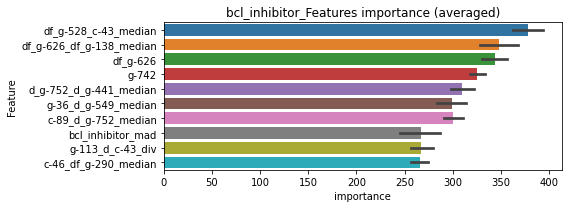

len(train_index) : 2851
len(valid_index) : 951
================================= fold 1/4 bcl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0937538	valid_1's binary_logloss: 0.127548
[200]	training's binary_logloss: 0.0304633	valid_1's binary_logloss: 0.0558568
[300]	training's binary_logloss: 0.0111393	valid_1's binary_logloss: 0.0289705
[400]	training's binary_logloss: 0.00454478	valid_1's binary_logloss: 0.0167651
[500]	training's binary_logloss: 0.00231053	valid_1's binary_logloss: 0.0111791
[600]	training's binary_logloss: 0.0014367	valid_1's binary_logloss: 0.00871825
[700]	training's binary_logloss: 0.00102952	valid_1's binary_logloss: 0.00752173
[800]	training's binary_logloss: 0.000807919	valid_1's binary_logloss: 0.0067858
[900]	training's binary_logloss: 0.000669763	valid_1's binary_logloss: 0.00631153
[1000]	training's binary_logloss: 0.000597997	valid_1's binary_logloss: 0.00617324
[1100]	training's binary_logloss: 0.000563084	valid_1's binary_logloss: 0.00603987
Early stopping, best iteration is:
[1075]	training's 

len(train_index) : 2851
len(valid_index) : 951
================================= fold 2/4 bcl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.093724	valid_1's binary_logloss: 0.123254
[200]	training's binary_logloss: 0.03018	valid_1's binary_logloss: 0.052163
[300]	training's binary_logloss: 0.0108687	valid_1's binary_logloss: 0.0248762
[400]	training's binary_logloss: 0.00447432	valid_1's binary_logloss: 0.0132777
[500]	training's binary_logloss: 0.00229237	valid_1's binary_logloss: 0.00843485
[600]	training's binary_logloss: 0.00143759	valid_1's binary_logloss: 0.00636849
[700]	training's binary_logloss: 0.00102666	valid_1's binary_logloss: 0.00519164
[800]	training's binary_logloss: 0.000802822	valid_1's binary_logloss: 0.00437855
[900]	training's binary_logloss: 0.000668297	valid_1's binary_logloss: 0.00392257
[1000]	training's binary_logloss: 0.000595754	valid_1's binary_logloss: 0.00368548
[1100]	training's binary_logloss: 0.000562509	valid_1's binary_logloss: 0.00359382
[1200]	training's binary_logloss: 0.000550043	valid_1'

len(train_index) : 2852
len(valid_index) : 950
================================= fold 3/4 bcl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0932204	valid_1's binary_logloss: 0.128241
[200]	training's binary_logloss: 0.0298139	valid_1's binary_logloss: 0.0556501
[300]	training's binary_logloss: 0.0108398	valid_1's binary_logloss: 0.0286841
[400]	training's binary_logloss: 0.00448153	valid_1's binary_logloss: 0.0178255
[500]	training's binary_logloss: 0.00228021	valid_1's binary_logloss: 0.0131502
[600]	training's binary_logloss: 0.00142848	valid_1's binary_logloss: 0.0112765
[700]	training's binary_logloss: 0.00102225	valid_1's binary_logloss: 0.0101263
[800]	training's binary_logloss: 0.000796054	valid_1's binary_logloss: 0.00942708
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000709855	valid_1's binary_logloss: 0.00919029


len(train_index) : 2852
len(valid_index) : 950
================================= fold 4/4 bcl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0927811	valid_1's binary_logloss: 0.131107
[200]	training's binary_logloss: 0.0296271	valid_1's binary_logloss: 0.0575242
[300]	training's binary_logloss: 0.0108191	valid_1's binary_logloss: 0.0297939
[400]	training's binary_logloss: 0.00450181	valid_1's binary_logloss: 0.0178752
[500]	training's binary_logloss: 0.00229028	valid_1's binary_logloss: 0.0123683
[600]	training's binary_logloss: 0.00142419	valid_1's binary_logloss: 0.00985572
[700]	training's binary_logloss: 0.00101673	valid_1's binary_logloss: 0.00872763
[800]	training's binary_logloss: 0.000790471	valid_1's binary_logloss: 0.00788495
[900]	training's binary_logloss: 0.00066094	valid_1's binary_logloss: 0.00734121
[1000]	training's binary_logloss: 0.00058876	valid_1's binary_logloss: 0.00711266
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000570162	valid_1's binary_logloss: 0.00705632


bcl_inhibitor logloss: 0.006460947687957798
bcr-abl_inhibitor, len(trt): 38, len(othr): 3285, target_rate: 0.0015957 → Adj_target_rate: 0.0018493


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107766	valid_1's binary_logloss: 0.143043
[200]	training's binary_logloss: 0.0397545	valid_1's binary_logloss: 0.0741957
[300]	training's binary_logloss: 0.0163506	valid_1's binary_logloss: 0.0460204
[400]	training's binary_logloss: 0.00742711	valid_1's binary_logloss: 0.0319305
[500]	training's binary_logloss: 0.00380265	valid_1's binary_logloss: 0.0240335
[600]	training's binary_logloss: 0.00224121	valid_1's binary_logloss: 0.0199792
[700]	training's binary_logloss: 0.00152888	valid_1's binary_logloss: 0.0178127
[800]	training's binary_logloss: 0.00115558	valid_1's binary_logloss: 0.0165613
[900]	training's binary_logloss: 0.000935959	valid_1's binary_logloss: 0.0158495
[1000]	training's binary_logloss: 0.000818822	valid_1's binary_logloss: 0.0152738
[1100]	training's binary_logloss: 0.000754827	valid_1's binary_logloss: 0.0150281
Early stopping, best iteration is:
[1100]	training's binary

1 / 3 AUC score:1.000
y_Threshold: 0.0144691, Threshold: 0.1783020, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00160, Num_p_label: 40.0, conf_0:0.12481, conf_1:0.23179
Num_p_label: 40.0, Expected: 6.4, Adj_threshold_1: 0.1783020
Num_p_label: 35.0, Expected: 6.4, Adj_threshold_2: 0.2083020
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_3: 0.2383020
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_4: 0.2683020
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_5: 0.2983020
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_6: 0.3283020
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_7: 0.3583020
Num_p_label: 18.0, Expected: 6.4, Adj_threshold_8: 0.3883020
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_9: 0.4183020
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_10: 0.4483020
threshold: 0.4783020, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102116	valid_1's binary_logloss: 0.144761
[200]	training's binary_logloss: 0.035754	valid_1's binary_logloss: 0.0752896
[300]	training's binary_logloss: 0.0140305	valid_1's binary_logloss: 0.0460239
[400]	training's binary_logloss: 0.00602453	valid_1's binary_logloss: 0.0309082
[500]	training's binary_logloss: 0.00312052	valid_1's binary_logloss: 0.0238211
[600]	training's binary_logloss: 0.00190386	valid_1's binary_logloss: 0.0194981
[700]	training's binary_logloss: 0.00132311	valid_1's binary_logloss: 0.0172971
[800]	training's binary_logloss: 0.0010086	valid_1's binary_logloss: 0.015671
[900]	training's binary_logloss: 0.000822177	valid_1's binary_logloss: 0.0147794
[1000]	training's binary_logloss: 0.000713648	valid_1's binary_logloss: 0.0143608
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.00071048	valid_1's binary_logloss: 0.0143395
Training until validation sc

2 / 3 AUC score:1.000
y_Threshold: 0.1043388, Threshold: 0.4783020, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0125565 Vs.target_rate: 0.00160, Num_p_label: 50.0, conf_0:0.38264, conf_1:0.57396
Num_p_label: 50.0, Expected: 6.4, Adj_threshold_1: 0.4783020
Num_p_label: 49.0, Expected: 6.4, Adj_threshold_2: 0.5083020
Num_p_label: 45.0, Expected: 6.4, Adj_threshold_3: 0.5383020
Num_p_label: 44.0, Expected: 6.4, Adj_threshold_4: 0.5683020
Num_p_label: 40.0, Expected: 6.4, Adj_threshold_5: 0.5983020
Num_p_label: 38.0, Expected: 6.4, Adj_threshold_6: 0.6283020
Num_p_label: 36.0, Expected: 6.4, Adj_threshold_7: 0.6583020
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_8: 0.6883020
threshold: 0.6883020, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 652.0/3800, y_label_rate: 0.1715789
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100571	valid_1's binary_logloss: 0.158812
[200]	training's binary_logloss: 0.0333123	valid_1's binary_logloss: 0.0827444
[300]	training's binary_logloss: 0.0127492	valid_1's binary_logloss: 0.0503557
[400]	training's binary_logloss: 0.00550225	valid_1's binary_logloss: 0.0352238
[500]	training's binary_logloss: 0.00286577	valid_1's binary_logloss: 0.0273248
[600]	training's binary_logloss: 0.00177021	valid_1's binary_logloss: 0.0237125
[700]	training's binary_logloss: 0.00123492	valid_1's binary_logloss: 0.0216201
[800]	training's binary_logloss: 0.000951648	valid_1's binary_logloss: 0.0203687
[900]	training's binary_logloss: 0.000781437	valid_1's binary_logloss: 0.0196639
[1000]	training's binary_logloss: 0.000696927	valid_1's binary_logloss: 0.0191542
[1100]	training's binary_logloss: 0.000658581	valid_1's binary_logloss: 0.0190193
Early stopping, best iteration is:
[1082]	training's binar

3 / 3 AUC score:1.000
y_Threshold: 0.0784909, Threshold: 0.6883020, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 646.0/3788
p_label_rate: 0.0082873 Vs.target_rate: 0.00160, Num_p_label: 33.0, conf_0:0.50000, conf_1:0.75713
Num_p_label: 33.0, Expected: 6.4, Adj_threshold_1: 0.6883020
threshold: 0.6883020, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 646.0/3788, y_label_rate: 0.1705385


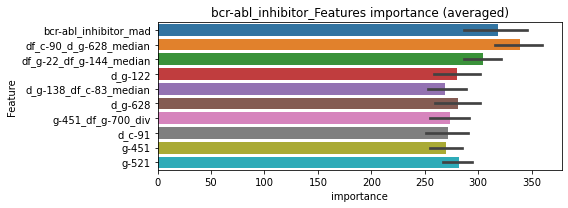

len(train_index) : 2841
len(valid_index) : 947
================================= fold 1/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100293	valid_1's binary_logloss: 0.147669
[200]	training's binary_logloss: 0.0320104	valid_1's binary_logloss: 0.0722681
[300]	training's binary_logloss: 0.0122601	valid_1's binary_logloss: 0.0424904
[400]	training's binary_logloss: 0.00528387	valid_1's binary_logloss: 0.0282864
[500]	training's binary_logloss: 0.00272854	valid_1's binary_logloss: 0.02126
[600]	training's binary_logloss: 0.00168567	valid_1's binary_logloss: 0.0176408
[700]	training's binary_logloss: 0.00118777	valid_1's binary_logloss: 0.0158447
[800]	training's binary_logloss: 0.00091655	valid_1's binary_logloss: 0.0148336
[900]	training's binary_logloss: 0.000755441	valid_1's binary_logloss: 0.0140842
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000745206	valid_1's binary_logloss: 0.0140549


len(train_index) : 2841
len(valid_index) : 947
================================= fold 2/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0983142	valid_1's binary_logloss: 0.141382
[200]	training's binary_logloss: 0.0323238	valid_1's binary_logloss: 0.0687857
[300]	training's binary_logloss: 0.0122985	valid_1's binary_logloss: 0.0408735
[400]	training's binary_logloss: 0.0053674	valid_1's binary_logloss: 0.0290984
[500]	training's binary_logloss: 0.00279432	valid_1's binary_logloss: 0.0233717
[600]	training's binary_logloss: 0.00173248	valid_1's binary_logloss: 0.0201679
[700]	training's binary_logloss: 0.00121605	valid_1's binary_logloss: 0.0180336
[800]	training's binary_logloss: 0.000947041	valid_1's binary_logloss: 0.0173564
[900]	training's binary_logloss: 0.000780557	valid_1's binary_logloss: 0.0165816
[1000]	training's binary_logloss: 0.000693501	valid_1's binary_logloss: 0.0163267
Early stopping, best iteration is:
[1046]	training's binary_logloss: 0.000671387	valid_1's binary_logloss: 0.0162234


len(train_index) : 2841
len(valid_index) : 947
================================= fold 3/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0995686	valid_1's binary_logloss: 0.131136
[200]	training's binary_logloss: 0.0328903	valid_1's binary_logloss: 0.0605139
[300]	training's binary_logloss: 0.0124917	valid_1's binary_logloss: 0.0329956
[400]	training's binary_logloss: 0.0055076	valid_1's binary_logloss: 0.0213695
[500]	training's binary_logloss: 0.00288937	valid_1's binary_logloss: 0.0161868
[600]	training's binary_logloss: 0.0017653	valid_1's binary_logloss: 0.0133981
[700]	training's binary_logloss: 0.00122938	valid_1's binary_logloss: 0.0117925
[800]	training's binary_logloss: 0.000947317	valid_1's binary_logloss: 0.0108868
[900]	training's binary_logloss: 0.000779889	valid_1's binary_logloss: 0.0102769
[1000]	training's binary_logloss: 0.000692245	valid_1's binary_logloss: 0.0100214
Early stopping, best iteration is:
[1060]	training's binary_logloss: 0.000670377	valid_1's binary_logloss: 0.00987089


len(train_index) : 2841
len(valid_index) : 947
================================= fold 4/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0999131	valid_1's binary_logloss: 0.144972
[200]	training's binary_logloss: 0.0330978	valid_1's binary_logloss: 0.0731582
[300]	training's binary_logloss: 0.0126203	valid_1's binary_logloss: 0.0447331
[400]	training's binary_logloss: 0.00551257	valid_1's binary_logloss: 0.032014
[500]	training's binary_logloss: 0.00283265	valid_1's binary_logloss: 0.026848
[600]	training's binary_logloss: 0.00174307	valid_1's binary_logloss: 0.024224
[700]	training's binary_logloss: 0.00122067	valid_1's binary_logloss: 0.0229912
[800]	training's binary_logloss: 0.000939981	valid_1's binary_logloss: 0.022147
[900]	training's binary_logloss: 0.000779548	valid_1's binary_logloss: 0.0216467
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000819827	valid_1's binary_logloss: 0.0215257


bcr-abl_inhibitor logloss: 0.015419193282447397
benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3280, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126746	valid_1's binary_logloss: 0.197702
[200]	training's binary_logloss: 0.0552652	valid_1's binary_logloss: 0.140413
[300]	training's binary_logloss: 0.025293	valid_1's binary_logloss: 0.111228
[400]	training's binary_logloss: 0.0123575	valid_1's binary_logloss: 0.0946524
[500]	training's binary_logloss: 0.00642004	valid_1's binary_logloss: 0.0858415
[600]	training's binary_logloss: 0.0037137	valid_1's binary_logloss: 0.0805918
[700]	training's binary_logloss: 0.00241381	valid_1's binary_logloss: 0.0776469
Early stopping, best iteration is:
[748]	training's binary_logloss: 0.00203638	valid_1's binary_logloss: 0.0767766
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12954	valid_1's binary_logloss: 0.204499
[200]	training's binary_logloss: 0.058278	valid_1's binary_logloss: 0.136273
[300]	training's binary_logloss: 0.0270661	valid_1's binary_

1 / 3 AUC score:0.996
y_Threshold: 0.0293701, Threshold: 0.2155457, pos_neg_ratio: 0.8000000
Remove_noisy_data: 158 → Positive_corect_labels: 643/3778
p_label_rate: 0.0100452 Vs.target_rate: 0.00281, Num_p_label: 40.0, conf_0:0.15088, conf_1:0.28021
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_1: 0.2155457
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_2: 0.2455457
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_3: 0.2755457
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_4: 0.3055457
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_5: 0.3355457
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_6: 0.3655457
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_7: 0.3955457
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_8: 0.4255457
threshold: 0.4255457, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 643.0/3778, y_label_rate: 0.1701959
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119674	valid_1's binary_logloss: 0.157457
[200]	training's binary_logloss: 0.0474918	valid_1's binary_logloss: 0.0860885
[300]	training's binary_logloss: 0.0205803	valid_1's binary_logloss: 0.0540731
[400]	training's binary_logloss: 0.00966382	valid_1's binary_logloss: 0.0379991
[500]	training's binary_logloss: 0.00498318	valid_1's binary_logloss: 0.0292954
[600]	training's binary_logloss: 0.00292043	valid_1's binary_logloss: 0.0245918
[700]	training's binary_logloss: 0.00193256	valid_1's binary_logloss: 0.0217678
[800]	training's binary_logloss: 0.00141437	valid_1's binary_logloss: 0.0203182
[900]	training's binary_logloss: 0.00111886	valid_1's binary_logloss: 0.019164
[1000]	training's binary_logloss: 0.000946842	valid_1's binary_logloss: 0.0186362
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.000909878	valid_1's binary_logloss: 0.0183984
Training until validation 

2 / 3 AUC score:0.998
y_Threshold: 0.1389094, Threshold: 0.4255457, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 621.0/3734
p_label_rate: 0.0170768 Vs.target_rate: 0.00281, Num_p_label: 68.0, conf_0:0.34044, conf_1:0.51065
Num_p_label: 68.0, Expected: 11.2, Adj_threshold_1: 0.4255457
Num_p_label: 64.0, Expected: 11.2, Adj_threshold_2: 0.4555457
Num_p_label: 62.0, Expected: 11.2, Adj_threshold_3: 0.4855457
Num_p_label: 60.0, Expected: 11.2, Adj_threshold_4: 0.5155457
Num_p_label: 55.0, Expected: 11.2, Adj_threshold_5: 0.5455457
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_6: 0.5755457
Num_p_label: 51.0, Expected: 11.2, Adj_threshold_7: 0.6055457
Num_p_label: 47.0, Expected: 11.2, Adj_threshold_8: 0.6355457
Num_p_label: 43.0, Expected: 11.2, Adj_threshold_9: 0.6655457
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_10: 0.6955457
threshold: 0.6955457, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 621.0/3734, y_label_rate: 0.1663096

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110206	valid_1's binary_logloss: 0.158341
[200]	training's binary_logloss: 0.0428779	valid_1's binary_logloss: 0.0896969
[300]	training's binary_logloss: 0.017854	valid_1's binary_logloss: 0.0598464
[400]	training's binary_logloss: 0.00807419	valid_1's binary_logloss: 0.0445122
[500]	training's binary_logloss: 0.00413868	valid_1's binary_logloss: 0.0366458
[600]	training's binary_logloss: 0.00244322	valid_1's binary_logloss: 0.0322876
[700]	training's binary_logloss: 0.00164928	valid_1's binary_logloss: 0.030097
[800]	training's binary_logloss: 0.00122246	valid_1's binary_logloss: 0.0285717
[900]	training's binary_logloss: 0.000979819	valid_1's binary_logloss: 0.0278364
[1000]	training's binary_logloss: 0.000836653	valid_1's binary_logloss: 0.0272054
Early stopping, best iteration is:
[999]	training's binary_logloss: 0.000837294	valid_1's binary_logloss: 0.0272049
Training until validation s

3 / 3 AUC score:0.999
y_Threshold: 0.1389833, Threshold: 0.6955457, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 606.0/3704
p_label_rate: 0.0125565 Vs.target_rate: 0.00281, Num_p_label: 50.0, conf_0:0.50000, conf_1:0.76510
Num_p_label: 50.0, Expected: 11.2, Adj_threshold_1: 0.6955457
threshold: 0.6955457, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 606.0/3704, y_label_rate: 0.1636069


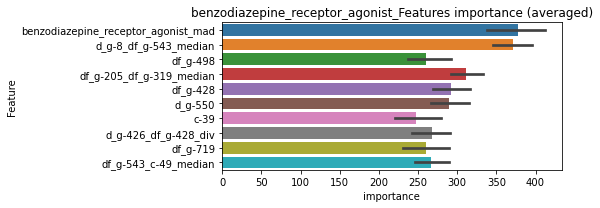

len(train_index) : 2778
len(valid_index) : 926
================================= fold 1/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104467	valid_1's binary_logloss: 0.157155
[200]	training's binary_logloss: 0.0398302	valid_1's binary_logloss: 0.0913163
[300]	training's binary_logloss: 0.0172244	valid_1's binary_logloss: 0.0641059
[400]	training's binary_logloss: 0.00772851	valid_1's binary_logloss: 0.0508949
[500]	training's binary_logloss: 0.00372806	valid_1's binary_logloss: 0.0436678
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00252777	valid_1's binary_logloss: 0.0413282


len(train_index) : 2778
len(valid_index) : 926
================================= fold 2/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10563	valid_1's binary_logloss: 0.149549
[200]	training's binary_logloss: 0.040228	valid_1's binary_logloss: 0.0860752
[300]	training's binary_logloss: 0.0171105	valid_1's binary_logloss: 0.0575601
[400]	training's binary_logloss: 0.00752522	valid_1's binary_logloss: 0.0426603
[500]	training's binary_logloss: 0.00376733	valid_1's binary_logloss: 0.0357033
[600]	training's binary_logloss: 0.00223065	valid_1's binary_logloss: 0.0326531
[700]	training's binary_logloss: 0.00151036	valid_1's binary_logloss: 0.0307049
[800]	training's binary_logloss: 0.00113008	valid_1's binary_logloss: 0.0293669
[900]	training's binary_logloss: 0.000913145	valid_1's binary_logloss: 0.0286919
[1000]	training's binary_logloss: 0.000790431	valid_1's binary_logloss: 0.028407
Early stopping, best iteration is:
[1031]	training's binary_logloss: 0.000768164	valid_1's binary_logloss: 0.0282542


len(train_index) : 2778
len(valid_index) : 926
================================= fold 3/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107126	valid_1's binary_logloss: 0.141051
[200]	training's binary_logloss: 0.0414703	valid_1's binary_logloss: 0.0771764
[300]	training's binary_logloss: 0.0170369	valid_1's binary_logloss: 0.0490721
[400]	training's binary_logloss: 0.00752937	valid_1's binary_logloss: 0.0350688
[500]	training's binary_logloss: 0.00380541	valid_1's binary_logloss: 0.0272403
[600]	training's binary_logloss: 0.00223926	valid_1's binary_logloss: 0.0231169
[700]	training's binary_logloss: 0.00151141	valid_1's binary_logloss: 0.020838
[800]	training's binary_logloss: 0.00113247	valid_1's binary_logloss: 0.0195256
[900]	training's binary_logloss: 0.000918453	valid_1's binary_logloss: 0.0185699
[1000]	training's binary_logloss: 0.000801704	valid_1's binary_logloss: 0.0179544
[1100]	training's binary_logloss: 0.000739806	valid_1's binary_logloss: 0.0177101
Early stopping, best iteration is:
[1092]	training's binary_

len(train_index) : 2778
len(valid_index) : 926
================================= fold 4/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104672	valid_1's binary_logloss: 0.161114
[200]	training's binary_logloss: 0.038454	valid_1's binary_logloss: 0.0935564
[300]	training's binary_logloss: 0.0161801	valid_1's binary_logloss: 0.0661521
[400]	training's binary_logloss: 0.00773594	valid_1's binary_logloss: 0.0537352
[500]	training's binary_logloss: 0.0038316	valid_1's binary_logloss: 0.0477223
[600]	training's binary_logloss: 0.00221709	valid_1's binary_logloss: 0.0449461
[700]	training's binary_logloss: 0.00149436	valid_1's binary_logloss: 0.0439992
Early stopping, best iteration is:
[698]	training's binary_logloss: 0.00150457	valid_1's binary_logloss: 0.0439843


benzodiazepine_receptor_agonist logloss: 0.03281585630429913
beta_amyloid_inhibitor, len(trt): 24, len(othr): 3287, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0853563	valid_1's binary_logloss: 0.111851
[200]	training's binary_logloss: 0.0256975	valid_1's binary_logloss: 0.0432208
[300]	training's binary_logloss: 0.00899396	valid_1's binary_logloss: 0.0205377
[400]	training's binary_logloss: 0.00383657	valid_1's binary_logloss: 0.011647
[500]	training's binary_logloss: 0.00199316	valid_1's binary_logloss: 0.00792588
[600]	training's binary_logloss: 0.00126683	valid_1's binary_logloss: 0.00619915
[700]	training's binary_logloss: 0.000903942	valid_1's binary_logloss: 0.00522297
[800]	training's binary_logloss: 0.000711173	valid_1's binary_logloss: 0.00459299
[900]	training's binary_logloss: 0.000602511	valid_1's binary_logloss: 0.0042915
[1000]	training's binary_logloss: 0.000564045	valid_1's binary_logloss: 0.00419221
Early stopping, best iteration is:
[1067]	training's binary_logloss: 0.000552085	valid_1's binary_logloss: 0.00414128
Training until 

1 / 3 AUC score:1.000
y_Threshold: 0.0069373, Threshold: 0.0445756, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.03120, conf_1:0.05795
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0445756
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_2: 0.0745756
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_3: 0.1045756
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_4: 0.1345756
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.1645756
threshold: 0.1645756, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0852507	valid_1's binary_logloss: 0.109616
[200]	training's binary_logloss: 0.024324	valid_1's binary_logloss: 0.0400923
[300]	training's binary_logloss: 0.00829008	valid_1's binary_logloss: 0.0178562
[400]	training's binary_logloss: 0.00344649	valid_1's binary_logloss: 0.00957087
[500]	training's binary_logloss: 0.00182226	valid_1's binary_logloss: 0.00635423
[600]	training's binary_logloss: 0.00113882	valid_1's binary_logloss: 0.00474063
[700]	training's binary_logloss: 0.00081241	valid_1's binary_logloss: 0.00389017
[800]	training's binary_logloss: 0.000637672	valid_1's binary_logloss: 0.00336387
[900]	training's binary_logloss: 0.000548146	valid_1's binary_logloss: 0.00314103
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000527966	valid_1's binary_logloss: 0.00311359
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

2 / 3 AUC score:1.000
y_Threshold: 0.0532903, Threshold: 0.1645756, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0062783 Vs.target_rate: 0.00101, Num_p_label: 25.0, conf_0:0.13166, conf_1:0.19749
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_1: 0.1645756
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_2: 0.1945756
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_3: 0.2245756
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_4: 0.2545756
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_5: 0.2845756
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_6: 0.3145756
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_7: 0.3445756
threshold: 0.3445756, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0852507	valid_1's binary_logloss: 0.109616
[200]	training's binary_logloss: 0.024324	valid_1's binary_logloss: 0.0400923
[300]	training's binary_logloss: 0.00829008	valid_1's binary_logloss: 0.0178562
[400]	training's binary_logloss: 0.00344649	valid_1's binary_logloss: 0.00957087
[500]	training's binary_logloss: 0.00182226	valid_1's binary_logloss: 0.00635423
[600]	training's binary_logloss: 0.00113882	valid_1's binary_logloss: 0.00474063
[700]	training's binary_logloss: 0.00081241	valid_1's binary_logloss: 0.00389017
[800]	training's binary_logloss: 0.000637672	valid_1's binary_logloss: 0.00336387
[900]	training's binary_logloss: 0.000548146	valid_1's binary_logloss: 0.00314103
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000527966	valid_1's binary_logloss: 0.00311359
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

3 / 3 AUC score:1.000
y_Threshold: 0.0532903, Threshold: 0.3445756, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.31012, conf_1:0.37903
threshold: 0.3445756, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


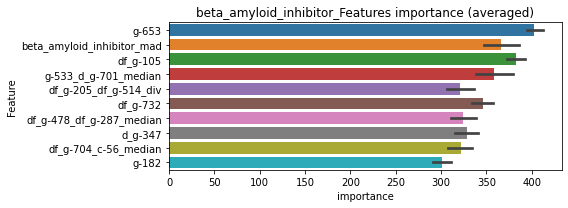

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0850104	valid_1's binary_logloss: 0.110183
[200]	training's binary_logloss: 0.0235698	valid_1's binary_logloss: 0.0390668
[300]	training's binary_logloss: 0.0078435	valid_1's binary_logloss: 0.017431
[400]	training's binary_logloss: 0.00330024	valid_1's binary_logloss: 0.00947986
[500]	training's binary_logloss: 0.00174381	valid_1's binary_logloss: 0.00619583
[600]	training's binary_logloss: 0.00110431	valid_1's binary_logloss: 0.00463144
[700]	training's binary_logloss: 0.000799538	valid_1's binary_logloss: 0.00387554
[800]	training's binary_logloss: 0.000638507	valid_1's binary_logloss: 0.00344195
[900]	training's binary_logloss: 0.000547382	valid_1's binary_logloss: 0.00313571
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.000521276	valid_1's binary_logloss: 0.00306158


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843753	valid_1's binary_logloss: 0.112155
[200]	training's binary_logloss: 0.023363	valid_1's binary_logloss: 0.0423644
[300]	training's binary_logloss: 0.00795079	valid_1's binary_logloss: 0.0216106
[400]	training's binary_logloss: 0.00333643	valid_1's binary_logloss: 0.0137339
[500]	training's binary_logloss: 0.00174664	valid_1's binary_logloss: 0.0102328
[600]	training's binary_logloss: 0.00110431	valid_1's binary_logloss: 0.00863663
[700]	training's binary_logloss: 0.000796837	valid_1's binary_logloss: 0.00790894
[800]	training's binary_logloss: 0.000629736	valid_1's binary_logloss: 0.00738895
[900]	training's binary_logloss: 0.000541036	valid_1's binary_logloss: 0.00706666
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.000523739	valid_1's binary_logloss: 0.00702564


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0847921	valid_1's binary_logloss: 0.112259
[200]	training's binary_logloss: 0.0237578	valid_1's binary_logloss: 0.0410358
[300]	training's binary_logloss: 0.00798328	valid_1's binary_logloss: 0.0185021
[400]	training's binary_logloss: 0.00331482	valid_1's binary_logloss: 0.0104652
[500]	training's binary_logloss: 0.00174848	valid_1's binary_logloss: 0.00730393
[600]	training's binary_logloss: 0.00111057	valid_1's binary_logloss: 0.00579299
[700]	training's binary_logloss: 0.000797948	valid_1's binary_logloss: 0.0049802
[800]	training's binary_logloss: 0.000638697	valid_1's binary_logloss: 0.004715
[900]	training's binary_logloss: 0.000548599	valid_1's binary_logloss: 0.00446818
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000536275	valid_1's binary_logloss: 0.00438786


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0844183	valid_1's binary_logloss: 0.113068
[200]	training's binary_logloss: 0.0240062	valid_1's binary_logloss: 0.0415724
[300]	training's binary_logloss: 0.00807236	valid_1's binary_logloss: 0.0178786
[400]	training's binary_logloss: 0.00339733	valid_1's binary_logloss: 0.00937189
[500]	training's binary_logloss: 0.00176651	valid_1's binary_logloss: 0.0061103
[600]	training's binary_logloss: 0.00112518	valid_1's binary_logloss: 0.00461536
[700]	training's binary_logloss: 0.000809521	valid_1's binary_logloss: 0.00382401
[800]	training's binary_logloss: 0.000639071	valid_1's binary_logloss: 0.00333225
[900]	training's binary_logloss: 0.00054512	valid_1's binary_logloss: 0.00304424
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000532874	valid_1's binary_logloss: 0.00300972


beta_amyloid_inhibitor logloss: 0.004371430820479511
bromodomain_inhibitor, len(trt): 68, len(othr): 3281, target_rate: 0.0028555 → Adj_target_rate: 0.0030327


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123768	valid_1's binary_logloss: 0.199512
[200]	training's binary_logloss: 0.049835	valid_1's binary_logloss: 0.131338
[300]	training's binary_logloss: 0.0225741	valid_1's binary_logloss: 0.101877
[400]	training's binary_logloss: 0.0107439	valid_1's binary_logloss: 0.0877333
[500]	training's binary_logloss: 0.00587798	valid_1's binary_logloss: 0.0814119
[600]	training's binary_logloss: 0.00351135	valid_1's binary_logloss: 0.0776987
[700]	training's binary_logloss: 0.00232884	valid_1's binary_logloss: 0.0757274
[800]	training's binary_logloss: 0.00172061	valid_1's binary_logloss: 0.0750857
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.00151168	valid_1's binary_logloss: 0.0747071
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125986	valid_1's binary_logloss: 0.184637
[200]	training's binary_logloss: 0.0535724	valid_1's bi

1 / 3 AUC score:0.994
y_Threshold: 0.0318984, Threshold: 0.2165553, pos_neg_ratio: 0.8000000
Remove_noisy_data: 166 → Positive_corect_labels: 639/3771
p_label_rate: 0.0100452 Vs.target_rate: 0.00286, Num_p_label: 40.0, conf_0:0.15159, conf_1:0.28152
Num_p_label: 40.0, Expected: 11.4, Adj_threshold_1: 0.2165553
Num_p_label: 36.0, Expected: 11.4, Adj_threshold_2: 0.2465553
Num_p_label: 31.0, Expected: 11.4, Adj_threshold_3: 0.2765553
Num_p_label: 26.0, Expected: 11.4, Adj_threshold_4: 0.3065553
Num_p_label: 22.0, Expected: 11.4, Adj_threshold_5: 0.3365553
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_6: 0.3665553
Num_p_label: 15.0, Expected: 11.4, Adj_threshold_7: 0.3965553
threshold: 0.3965553, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 639.0/3771, y_label_rate: 0.1694511
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114518	valid_1's binary_logloss: 0.169713
[200]	training's binary_logloss: 0.0421187	valid_1's binary_logloss: 0.102155
[300]	training's binary_logloss: 0.0179139	valid_1's binary_logloss: 0.0758437
[400]	training's binary_logloss: 0.0081859	valid_1's binary_logloss: 0.0620392
[500]	training's binary_logloss: 0.00429241	valid_1's binary_logloss: 0.0559294
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00305751	valid_1's binary_logloss: 0.0537023
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113317	valid_1's binary_logloss: 0.168548
[200]	training's binary_logloss: 0.0410956	valid_1's binary_logloss: 0.101128
[300]	training's binary_logloss: 0.0166573	valid_1's binary_logloss: 0.0726905
[400]	training's binary_logloss: 0.00758954	valid_1's binary_logloss: 0.0599472
[500]	training's binary_logloss: 0.00396805	valid_1's bi

2 / 3 AUC score:0.998
y_Threshold: 0.1051942, Threshold: 0.3965553, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 608.0/3709
p_label_rate: 0.0238574 Vs.target_rate: 0.00286, Num_p_label: 95.0, conf_0:0.31724, conf_1:0.47587
Num_p_label: 95.0, Expected: 11.4, Adj_threshold_1: 0.3965553
Num_p_label: 87.0, Expected: 11.4, Adj_threshold_2: 0.4265553
Num_p_label: 83.0, Expected: 11.4, Adj_threshold_3: 0.4565553
Num_p_label: 79.0, Expected: 11.4, Adj_threshold_4: 0.4865553
Num_p_label: 75.0, Expected: 11.4, Adj_threshold_5: 0.5165553
Num_p_label: 72.0, Expected: 11.4, Adj_threshold_6: 0.5465553
Num_p_label: 68.0, Expected: 11.4, Adj_threshold_7: 0.5765553
Num_p_label: 64.0, Expected: 11.4, Adj_threshold_8: 0.6065553
Num_p_label: 57.0, Expected: 11.4, Adj_threshold_9: 0.6365553
Num_p_label: 50.0, Expected: 11.4, Adj_threshold_10: 0.6665553
threshold: 0.6965553, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 608.0/3709, y_label_rate: 0.1639256

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101154	valid_1's binary_logloss: 0.15185
[200]	training's binary_logloss: 0.03446	valid_1's binary_logloss: 0.0860003
[300]	training's binary_logloss: 0.0134433	valid_1's binary_logloss: 0.0592184
[400]	training's binary_logloss: 0.00610967	valid_1's binary_logloss: 0.0473006
[500]	training's binary_logloss: 0.00323754	valid_1's binary_logloss: 0.0401763
[600]	training's binary_logloss: 0.00201187	valid_1's binary_logloss: 0.0373679
[700]	training's binary_logloss: 0.00141268	valid_1's binary_logloss: 0.0358021
[800]	training's binary_logloss: 0.00108756	valid_1's binary_logloss: 0.0346089
Early stopping, best iteration is:
[801]	training's binary_logloss: 0.00108522	valid_1's binary_logloss: 0.0345927
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100884	valid_1's binary_logloss: 0.154737
[200]	training's binary_logloss: 0.034623	valid_1's bi

3 / 3 AUC score:0.999
y_Threshold: 0.1164216, Threshold: 0.6965553, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 593.0/3679
p_label_rate: 0.0193370 Vs.target_rate: 0.00286, Num_p_label: 77.0, conf_0:0.50000, conf_1:0.76621
Num_p_label: 77.0, Expected: 11.4, Adj_threshold_1: 0.6965553
threshold: 0.6965553, positive_p_label: 77.0/3982, p_label_rate: 0.0193370
positive_y_label: 593.0/3679, y_label_rate: 0.1611851


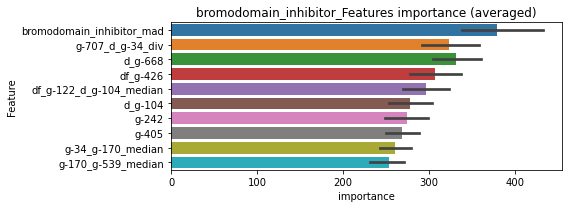

len(train_index) : 2759
len(valid_index) : 920
================================= fold 1/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0974242	valid_1's binary_logloss: 0.138551
[200]	training's binary_logloss: 0.0328626	valid_1's binary_logloss: 0.0692391
[300]	training's binary_logloss: 0.0130759	valid_1's binary_logloss: 0.0425149
[400]	training's binary_logloss: 0.00578669	valid_1's binary_logloss: 0.0296001
[500]	training's binary_logloss: 0.00305429	valid_1's binary_logloss: 0.0235764
[600]	training's binary_logloss: 0.00189886	valid_1's binary_logloss: 0.0207055
[700]	training's binary_logloss: 0.00133361	valid_1's binary_logloss: 0.018755
[800]	training's binary_logloss: 0.00102635	valid_1's binary_logloss: 0.0174733
[900]	training's binary_logloss: 0.000852882	valid_1's binary_logloss: 0.0165817
[1000]	training's binary_logloss: 0.000744302	valid_1's binary_logloss: 0.0161863
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.000721726	valid_1's binary_logloss: 0.0159773


len(train_index) : 2759
len(valid_index) : 920
================================= fold 2/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0969347	valid_1's binary_logloss: 0.140337
[200]	training's binary_logloss: 0.0321071	valid_1's binary_logloss: 0.0776963
[300]	training's binary_logloss: 0.0124289	valid_1's binary_logloss: 0.0555997
[400]	training's binary_logloss: 0.00549857	valid_1's binary_logloss: 0.0457789
[500]	training's binary_logloss: 0.00291981	valid_1's binary_logloss: 0.0412386
[600]	training's binary_logloss: 0.00182181	valid_1's binary_logloss: 0.0402885
[700]	training's binary_logloss: 0.00127412	valid_1's binary_logloss: 0.0392605
[800]	training's binary_logloss: 0.00098562	valid_1's binary_logloss: 0.0389829
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.000967159	valid_1's binary_logloss: 0.0388723


len(train_index) : 2759
len(valid_index) : 920
================================= fold 3/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0981147	valid_1's binary_logloss: 0.138003
[200]	training's binary_logloss: 0.0331138	valid_1's binary_logloss: 0.070211
[300]	training's binary_logloss: 0.0127607	valid_1's binary_logloss: 0.0447905
[400]	training's binary_logloss: 0.00571547	valid_1's binary_logloss: 0.0333416
[500]	training's binary_logloss: 0.00304281	valid_1's binary_logloss: 0.0272459
[600]	training's binary_logloss: 0.00190025	valid_1's binary_logloss: 0.0243316
[700]	training's binary_logloss: 0.00133716	valid_1's binary_logloss: 0.0226275
[800]	training's binary_logloss: 0.00102777	valid_1's binary_logloss: 0.0218496
[900]	training's binary_logloss: 0.000851075	valid_1's binary_logloss: 0.0209721
[1000]	training's binary_logloss: 0.000758328	valid_1's binary_logloss: 0.020556
Early stopping, best iteration is:
[1049]	training's binary_logloss: 0.000726679	valid_1's binary_logloss: 0.0203418


len(train_index) : 2760
len(valid_index) : 919
================================= fold 4/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0990577	valid_1's binary_logloss: 0.146916
[200]	training's binary_logloss: 0.0331601	valid_1's binary_logloss: 0.0825893
[300]	training's binary_logloss: 0.0131757	valid_1's binary_logloss: 0.0558169
[400]	training's binary_logloss: 0.00607933	valid_1's binary_logloss: 0.044627
[500]	training's binary_logloss: 0.00307987	valid_1's binary_logloss: 0.0387634
[600]	training's binary_logloss: 0.00187091	valid_1's binary_logloss: 0.0350292
[700]	training's binary_logloss: 0.00129406	valid_1's binary_logloss: 0.0332099
[800]	training's binary_logloss: 0.0010015	valid_1's binary_logloss: 0.0324577
Early stopping, best iteration is:
[806]	training's binary_logloss: 0.000989403	valid_1's binary_logloss: 0.0323474


bromodomain_inhibitor logloss: 0.02688320799255665


neg labels: 3289 → selected neg labels: 3286


btk_inhibitor, len(trt): 29, len(othr): 3286, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0936238	valid_1's binary_logloss: 0.133879
[200]	training's binary_logloss: 0.032183	valid_1's binary_logloss: 0.0640281
[300]	training's binary_logloss: 0.0121335	valid_1's binary_logloss: 0.0349652
[400]	training's binary_logloss: 0.00520072	valid_1's binary_logloss: 0.0222433
[500]	training's binary_logloss: 0.00258974	valid_1's binary_logloss: 0.0161775
[600]	training's binary_logloss: 0.00156462	valid_1's binary_logloss: 0.0136127
[700]	training's binary_logloss: 0.00109063	valid_1's binary_logloss: 0.0120758
[800]	training's binary_logloss: 0.000838409	valid_1's binary_logloss: 0.0112331
[900]	training's binary_logloss: 0.000691184	valid_1's binary_logloss: 0.0108429
[1000]	training's binary_logloss: 0.000611364	valid_1's binary_logloss: 0.010679
Early stopping, best iteration is:
[1064]	training's binary_logloss: 0.000588209	valid_1's binary_logloss: 0.010568
Training until validation

1 / 3 AUC score:1.000
y_Threshold: 0.0096633, Threshold: 0.0542097, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00122, Num_p_label: 40.0, conf_0:0.03795, conf_1:0.07047
Num_p_label: 40.0, Expected: 4.8, Adj_threshold_1: 0.0542097
Num_p_label: 26.0, Expected: 4.8, Adj_threshold_2: 0.0842097
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_3: 0.1142097
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_4: 0.1442097
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_5: 0.1742097
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_6: 0.2042097
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_7: 0.2342097
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_8: 0.2642097
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_9: 0.2942097
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_10: 0.3242097
threshold: 0.3242097, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0920601	valid_1's binary_logloss: 0.127902
[200]	training's binary_logloss: 0.0290691	valid_1's binary_logloss: 0.0545572
[300]	training's binary_logloss: 0.0105112	valid_1's binary_logloss: 0.0272756
[400]	training's binary_logloss: 0.00425848	valid_1's binary_logloss: 0.0156172
[500]	training's binary_logloss: 0.00215531	valid_1's binary_logloss: 0.0110525
[600]	training's binary_logloss: 0.0013208	valid_1's binary_logloss: 0.0088273
[700]	training's binary_logloss: 0.000935325	valid_1's binary_logloss: 0.00774768
[800]	training's binary_logloss: 0.000728126	valid_1's binary_logloss: 0.00703507
[900]	training's binary_logloss: 0.000606575	valid_1's binary_logloss: 0.00657055
[1000]	training's binary_logloss: 0.000546551	valid_1's binary_logloss: 0.00642861
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.000556106	valid_1's binary_logloss: 0.00641762
Training until val

2 / 3 AUC score:1.000
y_Threshold: 0.0921789, Threshold: 0.3242097, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 655.0/3807
p_label_rate: 0.0082873 Vs.target_rate: 0.00122, Num_p_label: 33.0, conf_0:0.25937, conf_1:0.38905
Num_p_label: 33.0, Expected: 4.8, Adj_threshold_1: 0.3242097
Num_p_label: 27.0, Expected: 4.8, Adj_threshold_2: 0.3542097
Num_p_label: 25.0, Expected: 4.8, Adj_threshold_3: 0.3842097
Num_p_label: 23.0, Expected: 4.8, Adj_threshold_4: 0.4142097
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_5: 0.4442097
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_6: 0.4742097
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_7: 0.5042097
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_8: 0.5342097
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_9: 0.5642097
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_10: 0.5942097
threshold: 0.6242097, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0915785	valid_1's binary_logloss: 0.1201
[200]	training's binary_logloss: 0.0288634	valid_1's binary_logloss: 0.0512207
[300]	training's binary_logloss: 0.0102565	valid_1's binary_logloss: 0.0282057
[400]	training's binary_logloss: 0.00418908	valid_1's binary_logloss: 0.0185981
[500]	training's binary_logloss: 0.00213028	valid_1's binary_logloss: 0.0153809
[600]	training's binary_logloss: 0.00130933	valid_1's binary_logloss: 0.0132841
[700]	training's binary_logloss: 0.000923179	valid_1's binary_logloss: 0.0122026
[800]	training's binary_logloss: 0.000718238	valid_1's binary_logloss: 0.0117355
[900]	training's binary_logloss: 0.00059855	valid_1's binary_logloss: 0.0114214
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000626901	valid_1's binary_logloss: 0.011383
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0924669	vali

3 / 3 AUC score:1.000
y_Threshold: 0.1448391, Threshold: 0.6242097, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0035158 Vs.target_rate: 0.00122, Num_p_label: 14.0, conf_0:0.50000, conf_1:0.68663
threshold: 0.6242097, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3803, y_label_rate: 0.1717065


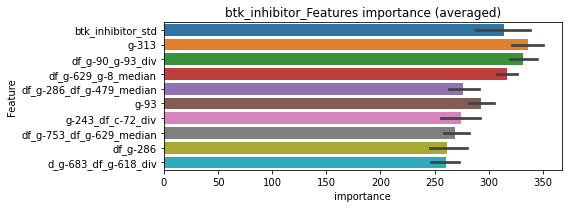

len(train_index) : 2852
len(valid_index) : 951
================================= fold 1/4 btk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0883809	valid_1's binary_logloss: 0.118652
[200]	training's binary_logloss: 0.0276717	valid_1's binary_logloss: 0.0507538
[300]	training's binary_logloss: 0.00987899	valid_1's binary_logloss: 0.0267673
[400]	training's binary_logloss: 0.00405042	valid_1's binary_logloss: 0.0161613
[500]	training's binary_logloss: 0.00206796	valid_1's binary_logloss: 0.0114783
[600]	training's binary_logloss: 0.00127491	valid_1's binary_logloss: 0.00947798
[700]	training's binary_logloss: 0.000902337	valid_1's binary_logloss: 0.00804488
[800]	training's binary_logloss: 0.000699462	valid_1's binary_logloss: 0.00730473
[900]	training's binary_logloss: 0.000582939	valid_1's binary_logloss: 0.00687625
[1000]	training's binary_logloss: 0.000537235	valid_1's binary_logloss: 0.00674662
Early stopping, best iteration is:
[982]	training's binary_logloss: 0.00054033	valid_1's binary_logloss: 0.00673198


len(train_index) : 2852
len(valid_index) : 951
================================= fold 2/4 btk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0903348	valid_1's binary_logloss: 0.12209
[200]	training's binary_logloss: 0.0287268	valid_1's binary_logloss: 0.0527876
[300]	training's binary_logloss: 0.0104766	valid_1's binary_logloss: 0.0270977
[400]	training's binary_logloss: 0.00432991	valid_1's binary_logloss: 0.0159524
[500]	training's binary_logloss: 0.00212399	valid_1's binary_logloss: 0.0108591
[600]	training's binary_logloss: 0.00128579	valid_1's binary_logloss: 0.00855997
[700]	training's binary_logloss: 0.000901641	valid_1's binary_logloss: 0.00749258
[800]	training's binary_logloss: 0.000696531	valid_1's binary_logloss: 0.00680851
[900]	training's binary_logloss: 0.000582334	valid_1's binary_logloss: 0.0063611
[1000]	training's binary_logloss: 0.00053862	valid_1's binary_logloss: 0.00629896
Early stopping, best iteration is:
[1064]	training's binary_logloss: 0.000531808	valid_1's binary_logloss: 0.00626055


len(train_index) : 2852
len(valid_index) : 951
================================= fold 3/4 btk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0899094	valid_1's binary_logloss: 0.118119
[200]	training's binary_logloss: 0.0285201	valid_1's binary_logloss: 0.0465772
[300]	training's binary_logloss: 0.0103007	valid_1's binary_logloss: 0.0216901
[400]	training's binary_logloss: 0.00419623	valid_1's binary_logloss: 0.0109229
[500]	training's binary_logloss: 0.00212527	valid_1's binary_logloss: 0.00658049
[600]	training's binary_logloss: 0.00130081	valid_1's binary_logloss: 0.00464607
[700]	training's binary_logloss: 0.000914279	valid_1's binary_logloss: 0.0036136
[800]	training's binary_logloss: 0.000704991	valid_1's binary_logloss: 0.00301815
[900]	training's binary_logloss: 0.000586782	valid_1's binary_logloss: 0.00270435
[1000]	training's binary_logloss: 0.000539439	valid_1's binary_logloss: 0.0025509
Early stopping, best iteration is:
[1008]	training's binary_logloss: 0.000536298	valid_1's binary_logloss: 0.00254146


len(train_index) : 2853
len(valid_index) : 950
================================= fold 4/4 btk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0909019	valid_1's binary_logloss: 0.123676
[200]	training's binary_logloss: 0.028549	valid_1's binary_logloss: 0.0504512
[300]	training's binary_logloss: 0.0101568	valid_1's binary_logloss: 0.0238245
[400]	training's binary_logloss: 0.0041684	valid_1's binary_logloss: 0.0136102
[500]	training's binary_logloss: 0.0021176	valid_1's binary_logloss: 0.00896591
[600]	training's binary_logloss: 0.0013083	valid_1's binary_logloss: 0.00686356
[700]	training's binary_logloss: 0.000919007	valid_1's binary_logloss: 0.00571917
[800]	training's binary_logloss: 0.000712562	valid_1's binary_logloss: 0.00506259
[900]	training's binary_logloss: 0.000598702	valid_1's binary_logloss: 0.00469218
[1000]	training's binary_logloss: 0.000546494	valid_1's binary_logloss: 0.00448357
Early stopping, best iteration is:
[1069]	training's binary_logloss: 0.000529848	valid_1's binary_logloss: 0.00445398


btk_inhibitor logloss: 0.0049988657429302
calcineurin_inhibitor, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0581274	valid_1's binary_logloss: 0.0708195
[200]	training's binary_logloss: 0.0131746	valid_1's binary_logloss: 0.0209299
[300]	training's binary_logloss: 0.00373521	valid_1's binary_logloss: 0.00879902
[400]	training's binary_logloss: 0.00148714	valid_1's binary_logloss: 0.00546249
[500]	training's binary_logloss: 0.000795243	valid_1's binary_logloss: 0.00418715
[600]	training's binary_logloss: 0.00052566	valid_1's binary_logloss: 0.00379084
[700]	training's binary_logloss: 0.000398817	valid_1's binary_logloss: 0.00352587
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.000374127	valid_1's binary_logloss: 0.00350914
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.058535	valid_1's binary_logloss: 0.0690386
[200]	training's binary_logloss: 0.0131331	valid_1's binary_logloss: 0.0190648
[300]	training's binary_logloss: 0.0037

1 / 3 AUC score:1.000
y_Threshold: 0.0026593, Threshold: 0.0118614, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00830, conf_1:0.01542
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0118614
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_2: 0.0418614
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_3: 0.0718614
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.1018614
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.1318614
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.1618614
threshold: 0.1618614, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0579836	valid_1's binary_logloss: 0.0710984
[200]	training's binary_logloss: 0.0121727	valid_1's binary_logloss: 0.0204545
[300]	training's binary_logloss: 0.00330292	valid_1's binary_logloss: 0.00876856
[400]	training's binary_logloss: 0.00130118	valid_1's binary_logloss: 0.00562753
[500]	training's binary_logloss: 0.000691494	valid_1's binary_logloss: 0.00442836
[600]	training's binary_logloss: 0.000459083	valid_1's binary_logloss: 0.00392777
[700]	training's binary_logloss: 0.000353962	valid_1's binary_logloss: 0.00376774
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.000333349	valid_1's binary_logloss: 0.00373446
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0584408	valid_1's binary_logloss: 0.0694672
[200]	training's binary_logloss: 0.0123541	valid_1's binary_logloss: 0.0193229
[300]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0311663, Threshold: 0.1618614, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.12949, conf_1:0.19423
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.1618614
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.1918614
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_3: 0.2218614
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.2518614
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.2818614
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_6: 0.3118614
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_7: 0.3418614
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_8: 0.3718614
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.4018614
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.4318614
threshold: 0.4318614, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0579836	valid_1's binary_logloss: 0.0710984
[200]	training's binary_logloss: 0.0121727	valid_1's binary_logloss: 0.0204545
[300]	training's binary_logloss: 0.00330292	valid_1's binary_logloss: 0.00876856
[400]	training's binary_logloss: 0.00130118	valid_1's binary_logloss: 0.00562753
[500]	training's binary_logloss: 0.000691494	valid_1's binary_logloss: 0.00442836
[600]	training's binary_logloss: 0.000459083	valid_1's binary_logloss: 0.00392777
[700]	training's binary_logloss: 0.000353962	valid_1's binary_logloss: 0.00376774
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.000333349	valid_1's binary_logloss: 0.00373446
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0584408	valid_1's binary_logloss: 0.0694672
[200]	training's binary_logloss: 0.0123541	valid_1's binary_logloss: 0.0193229
[300]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0311663, Threshold: 0.4318614, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.38868, conf_1:0.47505
threshold: 0.4318614, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


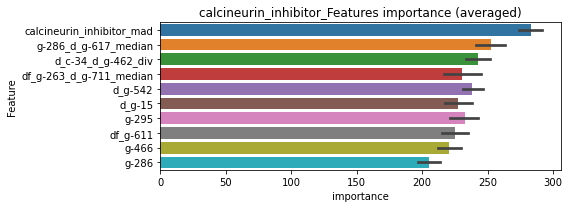

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0580474	valid_1's binary_logloss: 0.0701537
[200]	training's binary_logloss: 0.012127	valid_1's binary_logloss: 0.0193555
[300]	training's binary_logloss: 0.00328323	valid_1's binary_logloss: 0.00784165
[400]	training's binary_logloss: 0.00128116	valid_1's binary_logloss: 0.00479449
[500]	training's binary_logloss: 0.000689615	valid_1's binary_logloss: 0.00392907
[600]	training's binary_logloss: 0.000456995	valid_1's binary_logloss: 0.00358884
[700]	training's binary_logloss: 0.000351096	valid_1's binary_logloss: 0.00341699
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.000366728	valid_1's binary_logloss: 0.00338109


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0585808	valid_1's binary_logloss: 0.0693043
[200]	training's binary_logloss: 0.0122057	valid_1's binary_logloss: 0.0191059
[300]	training's binary_logloss: 0.00335971	valid_1's binary_logloss: 0.00768194
[400]	training's binary_logloss: 0.00131499	valid_1's binary_logloss: 0.00410087
[500]	training's binary_logloss: 0.000703929	valid_1's binary_logloss: 0.00272755
[600]	training's binary_logloss: 0.00046492	valid_1's binary_logloss: 0.00211209
[700]	training's binary_logloss: 0.000355017	valid_1's binary_logloss: 0.00170725
[800]	training's binary_logloss: 0.000318586	valid_1's binary_logloss: 0.0016311
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.000317052	valid_1's binary_logloss: 0.00162796


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0586267	valid_1's binary_logloss: 0.065142
[200]	training's binary_logloss: 0.0120593	valid_1's binary_logloss: 0.0155596
[300]	training's binary_logloss: 0.00329007	valid_1's binary_logloss: 0.0049871
[400]	training's binary_logloss: 0.00130555	valid_1's binary_logloss: 0.00230146
[500]	training's binary_logloss: 0.000693214	valid_1's binary_logloss: 0.00138093
[600]	training's binary_logloss: 0.000458054	valid_1's binary_logloss: 0.00100976
[700]	training's binary_logloss: 0.000351828	valid_1's binary_logloss: 0.000825321
[800]	training's binary_logloss: 0.000318873	valid_1's binary_logloss: 0.000774042
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.000318873	valid_1's binary_logloss: 0.000774042


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0589813	valid_1's binary_logloss: 0.0640836
[200]	training's binary_logloss: 0.0123783	valid_1's binary_logloss: 0.0151282
[300]	training's binary_logloss: 0.00338945	valid_1's binary_logloss: 0.00470382
[400]	training's binary_logloss: 0.00130582	valid_1's binary_logloss: 0.00204436
[500]	training's binary_logloss: 0.000705529	valid_1's binary_logloss: 0.00122541
[600]	training's binary_logloss: 0.000465441	valid_1's binary_logloss: 0.000868847
[700]	training's binary_logloss: 0.000355701	valid_1's binary_logloss: 0.000701805
[800]	training's binary_logloss: 0.000319906	valid_1's binary_logloss: 0.000645427
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.000319906	valid_1's binary_logloss: 0.000645427


calcineurin_inhibitor logloss: 0.0016076155100087778
calcium_channel_blocker, len(trt): 281, len(othr): 3246, target_rate: 0.0117998 → Adj_target_rate: 0.0101297


neg labels: 3289 → selected neg labels: 3246


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.226292	valid_1's binary_logloss: 0.361828
[200]	training's binary_logloss: 0.140456	valid_1's binary_logloss: 0.335328
[300]	training's binary_logloss: 0.0895667	valid_1's binary_logloss: 0.320473
[400]	training's binary_logloss: 0.0608667	valid_1's binary_logloss: 0.315231
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.048852	valid_1's binary_logloss: 0.313953
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.230154	valid_1's binary_logloss: 0.362098
[200]	training's binary_logloss: 0.142048	valid_1's binary_logloss: 0.339633
[300]	training's binary_logloss: 0.0934985	valid_1's binary_logloss: 0.330093
[400]	training's binary_logloss: 0.0631005	valid_1's binary_logloss: 0.326632
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0591082	valid_1's binary_logloss: 0.325426
Training until validation scores 

1 / 3 AUC score:0.839
y_Threshold: 0.1259317, Threshold: 0.5309656, pos_neg_ratio: 0.8000000
Remove_noisy_data: 534 → Positive_corect_labels: 447/3361
p_label_rate: 0.0100452 Vs.target_rate: 0.01180, Num_p_label: 40.0, conf_0:0.37168, conf_1:0.69026
threshold: 0.5309656, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 447.0/3361, y_label_rate: 0.1329961
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121079	valid_1's binary_logloss: 0.222539
[200]	training's binary_logloss: 0.0525338	valid_1's binary_logloss: 0.186361
[300]	training's binary_logloss: 0.0260048	valid_1's binary_logloss: 0.171842
[400]	training's binary_logloss: 0.0139391	valid_1's binary_logloss: 0.169913
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0109548	valid_1's binary_logloss: 0.169424
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134728	valid_1's binary_logloss: 0.196166
[200]	training's binary_logloss: 0.0613464	valid_1's binary_logloss: 0.138443
[300]	training's binary_logloss: 0.0311919	valid_1's binary_logloss: 0.112924
[400]	training's binary_logloss: 0.0167222	valid_1's binary_logloss: 0.0986347
[500]	training's binary_logloss: 0.00937601	valid_1's binary_logloss: 0.0918513
[600]	training's binary_logloss: 0.0056401	valid_1's binary_lo

2 / 3 AUC score:0.978
y_Threshold: 0.1081700, Threshold: 0.5309656, pos_neg_ratio: 0.8000000
Remove_noisy_data: 118 → Positive_corect_labels: 388.0/3243
p_label_rate: 0.0472125 Vs.target_rate: 0.01180, Num_p_label: 188.0, conf_0:0.42477, conf_1:0.63716
Num_p_label: 188.0, Expected: 47.0, Adj_threshold_1: 0.5309656
Num_p_label: 178.0, Expected: 47.0, Adj_threshold_2: 0.5609656
Num_p_label: 167.0, Expected: 47.0, Adj_threshold_3: 0.5909656
Num_p_label: 153.0, Expected: 47.0, Adj_threshold_4: 0.6209656
Num_p_label: 146.0, Expected: 47.0, Adj_threshold_5: 0.6509656
Num_p_label: 139.0, Expected: 47.0, Adj_threshold_6: 0.6809656
threshold: 0.6809656, positive_p_label: 139.0/3982, p_label_rate: 0.0349071
positive_y_label: 388.0/3243, y_label_rate: 0.1196423
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.093099	valid_1's binary_logloss: 0.166035
[200]	training's binary_logloss: 0.0352862	valid_1's binary_logloss: 0.1288
[300]	training's binary_logloss: 0.0152205	valid_1's binary_logloss: 0.11482
[400]	training's binary_logloss: 0.00747929	valid_1's binary_logloss: 0.110063
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00615766	valid_1's binary_logloss: 0.108879
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0960451	valid_1's binary_logloss: 0.152263
[200]	training's binary_logloss: 0.0372562	valid_1's binary_logloss: 0.105681
[300]	training's binary_logloss: 0.0158496	valid_1's binary_logloss: 0.0853852
[400]	training's binary_logloss: 0.00756565	valid_1's binary_logloss: 0.0735586
[500]	training's binary_logloss: 0.00410767	valid_1's binary_logloss: 0.0690228
[600]	training's binary_logloss: 0.0025516	valid_1's binary_

3 / 3 AUC score:0.983
y_Threshold: 0.1030687, Threshold: 0.6809656, pos_neg_ratio: 0.8000000
Remove_noisy_data: 68 → Positive_corect_labels: 354.0/3175
p_label_rate: 0.0522351 Vs.target_rate: 0.01180, Num_p_label: 208.0, conf_0:0.50000, conf_1:0.74906
Num_p_label: 208.0, Expected: 47.0, Adj_threshold_1: 0.6809656
threshold: 0.6809656, positive_p_label: 208.0/3982, p_label_rate: 0.0522351
positive_y_label: 354.0/3175, y_label_rate: 0.1114961


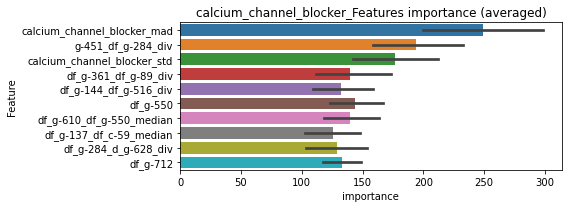

len(train_index) : 2381
len(valid_index) : 794
================================= fold 1/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0786132	valid_1's binary_logloss: 0.131462
[200]	training's binary_logloss: 0.0270346	valid_1's binary_logloss: 0.095971
[300]	training's binary_logloss: 0.0110572	valid_1's binary_logloss: 0.0857255


len(train_index) : 2381
len(valid_index) : 794
================================= fold 2/4 calcium_channel_blocker=================================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00765537	valid_1's binary_logloss: 0.0839053
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794756	valid_1's binary_logloss: 0.138678
[200]	training's binary_logloss: 0.0268927	valid_1's binary_logloss: 0.0976605
[300]	training's binary_logloss: 0.0109758	valid_1's binary_logloss: 0.0860716


len(train_index) : 2381
len(valid_index) : 794
================================= fold 3/4 calcium_channel_blocker=================================


[400]	training's binary_logloss: 0.00519243	valid_1's binary_logloss: 0.0834308
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00631417	valid_1's binary_logloss: 0.0831264
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0783941	valid_1's binary_logloss: 0.141981
[200]	training's binary_logloss: 0.0268713	valid_1's binary_logloss: 0.10348
[300]	training's binary_logloss: 0.0113776	valid_1's binary_logloss: 0.0925344


len(train_index) : 2382
len(valid_index) : 793
================================= fold 4/4 calcium_channel_blocker=================================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00800446	valid_1's binary_logloss: 0.0914692
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0796319	valid_1's binary_logloss: 0.112958
[200]	training's binary_logloss: 0.0279258	valid_1's binary_logloss: 0.0708388
[300]	training's binary_logloss: 0.0114724	valid_1's binary_logloss: 0.0562888
[400]	training's binary_logloss: 0.00530814	valid_1's binary_logloss: 0.0498949
[500]	training's binary_logloss: 0.00292927	valid_1's binary_logloss: 0.0469919
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00298932	valid_1's binary_logloss: 0.0468869


calcium_channel_blocker logloss: 0.07635622989191071
cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3281, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10742	valid_1's binary_logloss: 0.163348
[200]	training's binary_logloss: 0.0380594	valid_1's binary_logloss: 0.0898307
[300]	training's binary_logloss: 0.0161003	valid_1's binary_logloss: 0.0606046
[400]	training's binary_logloss: 0.00715943	valid_1's binary_logloss: 0.0437303
[500]	training's binary_logloss: 0.00353193	valid_1's binary_logloss: 0.0347393
[600]	training's binary_logloss: 0.00209885	valid_1's binary_logloss: 0.0310245
[700]	training's binary_logloss: 0.00143202	valid_1's binary_logloss: 0.0284908
[800]	training's binary_logloss: 0.00108645	valid_1's binary_logloss: 0.0267172
[900]	training's binary_logloss: 0.000884593	valid_1's binary_logloss: 0.0261203
[1000]	training's binary_logloss: 0.000772895	valid_1's binary_logloss: 0.0254883
Early stopping, best iteration is:
[992]	training's binary_logloss: 0.000776191	valid_1's binary_logloss: 0.0254597
Training until validation 

1 / 3 AUC score:1.000
y_Threshold: 0.0168498, Threshold: 0.1426447, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.09985, conf_1:0.18544
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.1426447
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_2: 0.1726447
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_3: 0.2026447
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_4: 0.2326447
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_5: 0.2626447
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_6: 0.2926447
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_7: 0.3226447
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_8: 0.3526447
threshold: 0.3526447, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100345	valid_1's binary_logloss: 0.134745
[200]	training's binary_logloss: 0.0343638	valid_1's binary_logloss: 0.0638657
[300]	training's binary_logloss: 0.0130052	valid_1's binary_logloss: 0.0355855
[400]	training's binary_logloss: 0.00561161	valid_1's binary_logloss: 0.0240432
[500]	training's binary_logloss: 0.00286517	valid_1's binary_logloss: 0.0181718
[600]	training's binary_logloss: 0.00173734	valid_1's binary_logloss: 0.0155366
[700]	training's binary_logloss: 0.00121403	valid_1's binary_logloss: 0.0139635
[800]	training's binary_logloss: 0.000928652	valid_1's binary_logloss: 0.0127351
[900]	training's binary_logloss: 0.000767316	valid_1's binary_logloss: 0.0120506
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000704701	valid_1's binary_logloss: 0.0118165
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100918	val

2 / 3 AUC score:1.000
y_Threshold: 0.1140252, Threshold: 0.3526447, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 647.0/3787
p_label_rate: 0.0173280 Vs.target_rate: 0.00176, Num_p_label: 69.0, conf_0:0.28212, conf_1:0.42317
Num_p_label: 69.0, Expected: 7.0, Adj_threshold_1: 0.3526447
Num_p_label: 69.0, Expected: 7.0, Adj_threshold_2: 0.3826447
Num_p_label: 66.0, Expected: 7.0, Adj_threshold_3: 0.4126447
Num_p_label: 61.0, Expected: 7.0, Adj_threshold_4: 0.4426447
Num_p_label: 59.0, Expected: 7.0, Adj_threshold_5: 0.4726447
Num_p_label: 58.0, Expected: 7.0, Adj_threshold_6: 0.5026447
Num_p_label: 57.0, Expected: 7.0, Adj_threshold_7: 0.5326447
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_8: 0.5626447
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_9: 0.5926447
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_10: 0.6226447
threshold: 0.6526447, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.097381	valid_1's binary_logloss: 0.139913
[200]	training's binary_logloss: 0.0328856	valid_1's binary_logloss: 0.0687318
[300]	training's binary_logloss: 0.0125858	valid_1's binary_logloss: 0.0394453
[400]	training's binary_logloss: 0.00540634	valid_1's binary_logloss: 0.0252939
[500]	training's binary_logloss: 0.0027128	valid_1's binary_logloss: 0.0178661
[600]	training's binary_logloss: 0.00164107	valid_1's binary_logloss: 0.0144392
[700]	training's binary_logloss: 0.00114239	valid_1's binary_logloss: 0.0123356
[800]	training's binary_logloss: 0.000884737	valid_1's binary_logloss: 0.011416
[900]	training's binary_logloss: 0.000735131	valid_1's binary_logloss: 0.0107951
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000695654	valid_1's binary_logloss: 0.0106346
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959992	vali

3 / 3 AUC score:1.000
y_Threshold: 0.0927810, Threshold: 0.6526447, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 643.0/3779
p_label_rate: 0.0175791 Vs.target_rate: 0.00176, Num_p_label: 70.0, conf_0:0.50000, conf_1:0.71791
Num_p_label: 70.0, Expected: 7.0, Adj_threshold_1: 0.6526447
Num_p_label: 68.0, Expected: 7.0, Adj_threshold_2: 0.6826447
threshold: 0.6826447, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 643.0/3779, y_label_rate: 0.1701508


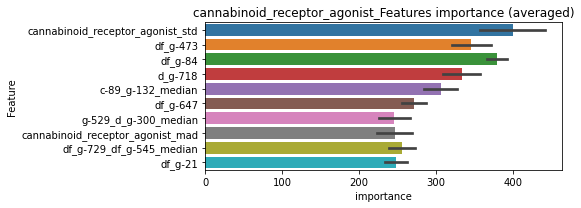

len(train_index) : 2834
len(valid_index) : 945
================================= fold 1/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955083	valid_1's binary_logloss: 0.127571
[200]	training's binary_logloss: 0.0328581	valid_1's binary_logloss: 0.0623135
[300]	training's binary_logloss: 0.0127171	valid_1's binary_logloss: 0.0366533
[400]	training's binary_logloss: 0.00543609	valid_1's binary_logloss: 0.0252052
[500]	training's binary_logloss: 0.00271264	valid_1's binary_logloss: 0.0190687
[600]	training's binary_logloss: 0.00164772	valid_1's binary_logloss: 0.0165215
[700]	training's binary_logloss: 0.00114384	valid_1's binary_logloss: 0.0149927
[800]	training's binary_logloss: 0.000874068	valid_1's binary_logloss: 0.0141816
[900]	training's binary_logloss: 0.000733207	valid_1's binary_logloss: 0.0139264
[1000]	training's binary_logloss: 0.000673833	valid_1's binary_logloss: 0.013608
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.000679314	valid_1's binary_logloss: 0.0135995


len(train_index) : 2834
len(valid_index) : 945
================================= fold 2/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0962072	valid_1's binary_logloss: 0.13711
[200]	training's binary_logloss: 0.0316702	valid_1's binary_logloss: 0.0661878
[300]	training's binary_logloss: 0.0118548	valid_1's binary_logloss: 0.0401459
[400]	training's binary_logloss: 0.00509607	valid_1's binary_logloss: 0.0286921
[500]	training's binary_logloss: 0.00260291	valid_1's binary_logloss: 0.023558
[600]	training's binary_logloss: 0.00157767	valid_1's binary_logloss: 0.0217475
[700]	training's binary_logloss: 0.00111187	valid_1's binary_logloss: 0.0200741
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000934347	valid_1's binary_logloss: 0.0196811


len(train_index) : 2834
len(valid_index) : 945
================================= fold 3/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0934511	valid_1's binary_logloss: 0.138786
[200]	training's binary_logloss: 0.0322322	valid_1's binary_logloss: 0.0708885
[300]	training's binary_logloss: 0.011987	valid_1's binary_logloss: 0.0421069
[400]	training's binary_logloss: 0.00510597	valid_1's binary_logloss: 0.0281962
[500]	training's binary_logloss: 0.00258978	valid_1's binary_logloss: 0.0216156
[600]	training's binary_logloss: 0.00158261	valid_1's binary_logloss: 0.018491
[700]	training's binary_logloss: 0.00111373	valid_1's binary_logloss: 0.016636
[800]	training's binary_logloss: 0.000857844	valid_1's binary_logloss: 0.0153254
[900]	training's binary_logloss: 0.000728461	valid_1's binary_logloss: 0.0146409
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.00071897	valid_1's binary_logloss: 0.0145456


len(train_index) : 2835
len(valid_index) : 944
================================= fold 4/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0953187	valid_1's binary_logloss: 0.139025
[200]	training's binary_logloss: 0.0319008	valid_1's binary_logloss: 0.0674616
[300]	training's binary_logloss: 0.0120846	valid_1's binary_logloss: 0.0395423
[400]	training's binary_logloss: 0.00503457	valid_1's binary_logloss: 0.026347
[500]	training's binary_logloss: 0.00255129	valid_1's binary_logloss: 0.0200601
[600]	training's binary_logloss: 0.00155272	valid_1's binary_logloss: 0.0171467
[700]	training's binary_logloss: 0.00109616	valid_1's binary_logloss: 0.0155096
[800]	training's binary_logloss: 0.000854684	valid_1's binary_logloss: 0.0143944
[900]	training's binary_logloss: 0.000712442	valid_1's binary_logloss: 0.0136446
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000706359	valid_1's binary_logloss: 0.0136034


cannabinoid_receptor_agonist logloss: 0.015360404101255875
cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.140365	valid_1's binary_logloss: 0.206915
[200]	training's binary_logloss: 0.0625186	valid_1's binary_logloss: 0.130572
[300]	training's binary_logloss: 0.0306839	valid_1's binary_logloss: 0.0951938
[400]	training's binary_logloss: 0.0153898	valid_1's binary_logloss: 0.0741799
[500]	training's binary_logloss: 0.00792252	valid_1's binary_logloss: 0.0606683
[600]	training's binary_logloss: 0.00448795	valid_1's binary_logloss: 0.0530354
[700]	training's binary_logloss: 0.00282469	valid_1's binary_logloss: 0.0491506
[800]	training's binary_logloss: 0.00196205	valid_1's binary_logloss: 0.0464464
[900]	training's binary_logloss: 0.00148905	valid_1's binary_logloss: 0.0448417
[1000]	training's binary_logloss: 0.0012135	valid_1's binary_logloss: 0.0438806
[1100]	training's binary_logloss: 0.0010371	valid_1's binary_logloss: 0.0430451
Early stopping, best iteration is:
[1108]	training's binary_loglos

1 / 3 AUC score:0.996
y_Threshold: 0.0237037, Threshold: 0.1287920, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3792
p_label_rate: 0.0100452 Vs.target_rate: 0.00231, Num_p_label: 40.0, conf_0:0.09015, conf_1:0.16743
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_1: 0.1287920
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_2: 0.1587920
Num_p_label: 25.0, Expected: 9.2, Adj_threshold_3: 0.1887920
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_4: 0.2187920
threshold: 0.2187920, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138117	valid_1's binary_logloss: 0.194876
[200]	training's binary_logloss: 0.0561393	valid_1's binary_logloss: 0.111263
[300]	training's binary_logloss: 0.0246464	valid_1's binary_logloss: 0.0722042
[400]	training's binary_logloss: 0.0115505	valid_1's binary_logloss: 0.0507386
[500]	training's binary_logloss: 0.00596277	valid_1's binary_logloss: 0.0396329
[600]	training's binary_logloss: 0.00341329	valid_1's binary_logloss: 0.0323739
[700]	training's binary_logloss: 0.00221788	valid_1's binary_logloss: 0.0285357
[800]	training's binary_logloss: 0.00161173	valid_1's binary_logloss: 0.026283
[900]	training's binary_logloss: 0.00126134	valid_1's binary_logloss: 0.0250681
[1000]	training's binary_logloss: 0.00104595	valid_1's binary_logloss: 0.0242156
[1100]	training's binary_logloss: 0.000923962	valid_1's binary_logloss: 0.023461
Early stopping, best iteration is:
[1112]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1003890, Threshold: 0.2187920, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 640.0/3772
p_label_rate: 0.0175791 Vs.target_rate: 0.00231, Num_p_label: 70.0, conf_0:0.17503, conf_1:0.26255
Num_p_label: 70.0, Expected: 9.2, Adj_threshold_1: 0.2187920
Num_p_label: 57.0, Expected: 9.2, Adj_threshold_2: 0.2487920
Num_p_label: 53.0, Expected: 9.2, Adj_threshold_3: 0.2787920
Num_p_label: 51.0, Expected: 9.2, Adj_threshold_4: 0.3087920
Num_p_label: 44.0, Expected: 9.2, Adj_threshold_5: 0.3387920
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_6: 0.3687920
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_7: 0.3987920
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_8: 0.4287920
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_9: 0.4587920
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_10: 0.4887920
threshold: 0.5187920, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 640.0/3772, y_label_rate: 0.1696713
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133565	valid_1's binary_logloss: 0.189287
[200]	training's binary_logloss: 0.053252	valid_1's binary_logloss: 0.106904
[300]	training's binary_logloss: 0.0236841	valid_1's binary_logloss: 0.0706574
[400]	training's binary_logloss: 0.0109944	valid_1's binary_logloss: 0.0498614
[500]	training's binary_logloss: 0.00566033	valid_1's binary_logloss: 0.0384566
[600]	training's binary_logloss: 0.00329647	valid_1's binary_logloss: 0.0322763
[700]	training's binary_logloss: 0.00215848	valid_1's binary_logloss: 0.0294365
[800]	training's binary_logloss: 0.00156928	valid_1's binary_logloss: 0.0267864
[900]	training's binary_logloss: 0.00122526	valid_1's binary_logloss: 0.0253476
[1000]	training's binary_logloss: 0.00102071	valid_1's binary_logloss: 0.0245674
[1100]	training's binary_logloss: 0.000899701	valid_1's binary_logloss: 0.0238251
Early stopping, best iteration is:
[1147]	training's binary_logl

3 / 3 AUC score:0.998
y_Threshold: 0.0963607, Threshold: 0.5187920, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 631.0/3754
p_label_rate: 0.0072828 Vs.target_rate: 0.00231, Num_p_label: 29.0, conf_0:0.46691, conf_1:0.57067
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_1: 0.5187920
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_2: 0.5487920
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_3: 0.5787920
Num_p_label: 23.0, Expected: 9.2, Adj_threshold_4: 0.6087920
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_5: 0.6387920
threshold: 0.6387920, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 631.0/3754, y_label_rate: 0.1680874


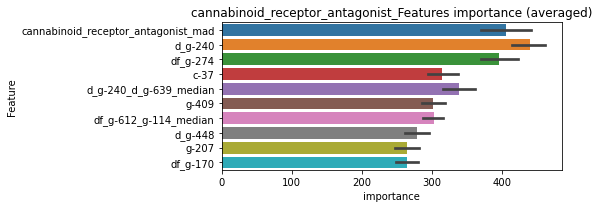

len(train_index) : 2815
len(valid_index) : 939
================================= fold 1/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13102	valid_1's binary_logloss: 0.180158
[200]	training's binary_logloss: 0.0505427	valid_1's binary_logloss: 0.0992997
[300]	training's binary_logloss: 0.0213129	valid_1's binary_logloss: 0.0621702
[400]	training's binary_logloss: 0.00978716	valid_1's binary_logloss: 0.043953
[500]	training's binary_logloss: 0.00501641	valid_1's binary_logloss: 0.034139
[600]	training's binary_logloss: 0.00296375	valid_1's binary_logloss: 0.0286804
[700]	training's binary_logloss: 0.00196453	valid_1's binary_logloss: 0.025181
[800]	training's binary_logloss: 0.00145165	valid_1's binary_logloss: 0.0232366
[900]	training's binary_logloss: 0.00115738	valid_1's binary_logloss: 0.0218149
[1000]	training's binary_logloss: 0.000970954	valid_1's binary_logloss: 0.0206719
Early stopping, best iteration is:
[1036]	training's binary_logloss: 0.000930025	valid_1's binary_logloss: 0.0205879


len(train_index) : 2815
len(valid_index) : 939
================================= fold 2/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129079	valid_1's binary_logloss: 0.182747
[200]	training's binary_logloss: 0.0491985	valid_1's binary_logloss: 0.103572
[300]	training's binary_logloss: 0.0209848	valid_1's binary_logloss: 0.0695881
[400]	training's binary_logloss: 0.00956928	valid_1's binary_logloss: 0.052847
[500]	training's binary_logloss: 0.00490907	valid_1's binary_logloss: 0.0436924
[600]	training's binary_logloss: 0.00289595	valid_1's binary_logloss: 0.0397998
[700]	training's binary_logloss: 0.0019424	valid_1's binary_logloss: 0.0370107
[800]	training's binary_logloss: 0.00144001	valid_1's binary_logloss: 0.0360216
[900]	training's binary_logloss: 0.00114153	valid_1's binary_logloss: 0.0353327
[1000]	training's binary_logloss: 0.000968852	valid_1's binary_logloss: 0.0349344
Early stopping, best iteration is:
[1003]	training's binary_logloss: 0.000964519	valid_1's binary_logloss: 0.0349106


len(train_index) : 2816
len(valid_index) : 938
================================= fold 3/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128544	valid_1's binary_logloss: 0.190441
[200]	training's binary_logloss: 0.048767	valid_1's binary_logloss: 0.105458
[300]	training's binary_logloss: 0.0205736	valid_1's binary_logloss: 0.0711641
[400]	training's binary_logloss: 0.00955736	valid_1's binary_logloss: 0.0545735
[500]	training's binary_logloss: 0.00489355	valid_1's binary_logloss: 0.0457733
[600]	training's binary_logloss: 0.00287065	valid_1's binary_logloss: 0.0422785
[700]	training's binary_logloss: 0.00193422	valid_1's binary_logloss: 0.0401019
[800]	training's binary_logloss: 0.00142772	valid_1's binary_logloss: 0.0394349
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00150497	valid_1's binary_logloss: 0.0393133


len(train_index) : 2816
len(valid_index) : 938
================================= fold 4/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131863	valid_1's binary_logloss: 0.173985
[200]	training's binary_logloss: 0.0517361	valid_1's binary_logloss: 0.0949148
[300]	training's binary_logloss: 0.0225369	valid_1's binary_logloss: 0.0606245
[400]	training's binary_logloss: 0.0104797	valid_1's binary_logloss: 0.0431839
[500]	training's binary_logloss: 0.00531847	valid_1's binary_logloss: 0.0334734
[600]	training's binary_logloss: 0.00310256	valid_1's binary_logloss: 0.0281574
[700]	training's binary_logloss: 0.00205918	valid_1's binary_logloss: 0.0257408
[800]	training's binary_logloss: 0.00151235	valid_1's binary_logloss: 0.0242421
[900]	training's binary_logloss: 0.00118858	valid_1's binary_logloss: 0.0230541
[1000]	training's binary_logloss: 0.000995028	valid_1's binary_logloss: 0.0224427
[1100]	training's binary_logloss: 0.000873625	valid_1's binary_logloss: 0.0220425
[1200]	training's binary_logloss: 0.000808013	valid_1's binar

cannabinoid_receptor_antagonist logloss: 0.029155327267524157


neg labels: 3289 → selected neg labels: 3281


carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3281, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0988523	valid_1's binary_logloss: 0.14921
[200]	training's binary_logloss: 0.0342211	valid_1's binary_logloss: 0.0771497
[300]	training's binary_logloss: 0.0136232	valid_1's binary_logloss: 0.0479488
[400]	training's binary_logloss: 0.00591882	valid_1's binary_logloss: 0.0345173
[500]	training's binary_logloss: 0.00299561	valid_1's binary_logloss: 0.0277111
[600]	training's binary_logloss: 0.00180415	valid_1's binary_logloss: 0.0249145
[700]	training's binary_logloss: 0.00125591	valid_1's binary_logloss: 0.0230794
[800]	training's binary_logloss: 0.000969823	valid_1's binary_logloss: 0.0225678
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000873694	valid_1's binary_logloss: 0.022112
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0986853	valid_1's binary_logloss: 0.137304
[200]	training's binary_logloss: 0.0347058	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0100531, Threshold: 0.1329067, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.09303, conf_1:0.17278
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1329067
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_2: 0.1629067
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.1929067
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_4: 0.2229067
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_5: 0.2529067
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.2829067
threshold: 0.2829067, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0947501	valid_1's binary_logloss: 0.137137
[200]	training's binary_logloss: 0.0301004	valid_1's binary_logloss: 0.0663981
[300]	training's binary_logloss: 0.0109519	valid_1's binary_logloss: 0.0382659
[400]	training's binary_logloss: 0.00473092	valid_1's binary_logloss: 0.0265163
[500]	training's binary_logloss: 0.00242718	valid_1's binary_logloss: 0.0216259
[600]	training's binary_logloss: 0.00152552	valid_1's binary_logloss: 0.0196947
[700]	training's binary_logloss: 0.00108158	valid_1's binary_logloss: 0.0186856
[800]	training's binary_logloss: 0.000847721	valid_1's binary_logloss: 0.0179857
[900]	training's binary_logloss: 0.000721	valid_1's binary_logloss: 0.0177565
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000713751	valid_1's binary_logloss: 0.017756
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0950478	valid

2 / 3 AUC score:1.000
y_Threshold: 0.0961954, Threshold: 0.2829067, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0165746 Vs.target_rate: 0.00151, Num_p_label: 66.0, conf_0:0.22633, conf_1:0.33949
Num_p_label: 66.0, Expected: 6.0, Adj_threshold_1: 0.2829067
Num_p_label: 61.0, Expected: 6.0, Adj_threshold_2: 0.3129067
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_3: 0.3429067
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_4: 0.3729067
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_5: 0.4029067
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_6: 0.4329067
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_7: 0.4629067
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_8: 0.4929067
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_9: 0.5229067
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_10: 0.5529067
threshold: 0.5829067, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955752	valid_1's binary_logloss: 0.119916
[200]	training's binary_logloss: 0.0304836	valid_1's binary_logloss: 0.053792
[300]	training's binary_logloss: 0.0115619	valid_1's binary_logloss: 0.0302647
[400]	training's binary_logloss: 0.00486749	valid_1's binary_logloss: 0.0196629
[500]	training's binary_logloss: 0.00250087	valid_1's binary_logloss: 0.0148215
[600]	training's binary_logloss: 0.00153794	valid_1's binary_logloss: 0.012232
[700]	training's binary_logloss: 0.00109766	valid_1's binary_logloss: 0.0108495
[800]	training's binary_logloss: 0.000853981	valid_1's binary_logloss: 0.0099869
[900]	training's binary_logloss: 0.000720174	valid_1's binary_logloss: 0.0096001
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.000713882	valid_1's binary_logloss: 0.00956857
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0931158	va

3 / 3 AUC score:1.000
y_Threshold: 0.0858394, Threshold: 0.5829067, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 648.0/3789
p_label_rate: 0.0062783 Vs.target_rate: 0.00151, Num_p_label: 25.0, conf_0:0.50000, conf_1:0.64120
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.5829067
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.6129067
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.6429067
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.6729067
threshold: 0.6729067, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 648.0/3789, y_label_rate: 0.1710214


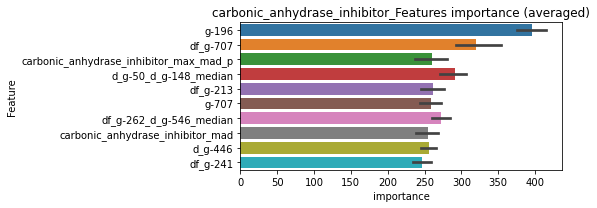

len(train_index) : 2841
len(valid_index) : 948
================================= fold 1/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0905939	valid_1's binary_logloss: 0.113977
[200]	training's binary_logloss: 0.0291393	valid_1's binary_logloss: 0.0487441
[300]	training's binary_logloss: 0.0108824	valid_1's binary_logloss: 0.0242604
[400]	training's binary_logloss: 0.0047178	valid_1's binary_logloss: 0.0147776
[500]	training's binary_logloss: 0.00242114	valid_1's binary_logloss: 0.00998751
[600]	training's binary_logloss: 0.00150122	valid_1's binary_logloss: 0.00786625
[700]	training's binary_logloss: 0.00106633	valid_1's binary_logloss: 0.00670682
[800]	training's binary_logloss: 0.000836565	valid_1's binary_logloss: 0.00594849
[900]	training's binary_logloss: 0.00071784	valid_1's binary_logloss: 0.00561197
[1000]	training's binary_logloss: 0.000654182	valid_1's binary_logloss: 0.00538372
[1100]	training's binary_logloss: 0.000621538	valid_1's binary_logloss: 0.00527769
Early stopping, best iteration is:
[1160]	training's

len(train_index) : 2842
len(valid_index) : 947
================================= fold 2/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0927638	valid_1's binary_logloss: 0.126329
[200]	training's binary_logloss: 0.0291475	valid_1's binary_logloss: 0.0592096
[300]	training's binary_logloss: 0.0105501	valid_1's binary_logloss: 0.0326279
[400]	training's binary_logloss: 0.00437089	valid_1's binary_logloss: 0.0208371
[500]	training's binary_logloss: 0.00224774	valid_1's binary_logloss: 0.0151137
[600]	training's binary_logloss: 0.00141392	valid_1's binary_logloss: 0.0125205
[700]	training's binary_logloss: 0.00101462	valid_1's binary_logloss: 0.0111505
[800]	training's binary_logloss: 0.000795837	valid_1's binary_logloss: 0.0102565
[900]	training's binary_logloss: 0.000683433	valid_1's binary_logloss: 0.00982886
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000680094	valid_1's binary_logloss: 0.00981993


len(train_index) : 2842
len(valid_index) : 947
================================= fold 3/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0897835	valid_1's binary_logloss: 0.138044
[200]	training's binary_logloss: 0.027383	valid_1's binary_logloss: 0.0699612
[300]	training's binary_logloss: 0.0100933	valid_1's binary_logloss: 0.041597
[400]	training's binary_logloss: 0.00434198	valid_1's binary_logloss: 0.0284001
[500]	training's binary_logloss: 0.00224247	valid_1's binary_logloss: 0.0218145
[600]	training's binary_logloss: 0.00140698	valid_1's binary_logloss: 0.0187123
[700]	training's binary_logloss: 0.00100745	valid_1's binary_logloss: 0.0165215
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00105167	valid_1's binary_logloss: 0.0164053


len(train_index) : 2842
len(valid_index) : 947
================================= fold 4/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0935453	valid_1's binary_logloss: 0.128819
[200]	training's binary_logloss: 0.0299502	valid_1's binary_logloss: 0.0571476
[300]	training's binary_logloss: 0.0111951	valid_1's binary_logloss: 0.030565
[400]	training's binary_logloss: 0.00467833	valid_1's binary_logloss: 0.0183378
[500]	training's binary_logloss: 0.00241049	valid_1's binary_logloss: 0.0128176
[600]	training's binary_logloss: 0.00150103	valid_1's binary_logloss: 0.010396
[700]	training's binary_logloss: 0.00107082	valid_1's binary_logloss: 0.00887956
[800]	training's binary_logloss: 0.000838502	valid_1's binary_logloss: 0.00819828
[900]	training's binary_logloss: 0.000716938	valid_1's binary_logloss: 0.00773349
[1000]	training's binary_logloss: 0.000654752	valid_1's binary_logloss: 0.00754383
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.000659325	valid_1's binary_logloss: 0.00750987


carbonic_anhydrase_inhibitor logloss: 0.009745159956569166
casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103406	valid_1's binary_logloss: 0.147445
[200]	training's binary_logloss: 0.0389393	valid_1's binary_logloss: 0.0812425
[300]	training's binary_logloss: 0.0152943	valid_1's binary_logloss: 0.0510728
[400]	training's binary_logloss: 0.00633135	valid_1's binary_logloss: 0.0352687
[500]	training's binary_logloss: 0.00318039	valid_1's binary_logloss: 0.027649
[600]	training's binary_logloss: 0.00187746	valid_1's binary_logloss: 0.0234193
[700]	training's binary_logloss: 0.0012791	valid_1's binary_logloss: 0.0208361
[800]	training's binary_logloss: 0.000968951	valid_1's binary_logloss: 0.0197173
[900]	training's binary_logloss: 0.000787306	valid_1's binary_logloss: 0.0191165
[1000]	training's binary_logloss: 0.000692939	valid_1's binary_logloss: 0.0188067
Early stopping, best iteration is:
[989]	training's binary_logloss: 0.000700976	valid_1's binary_logloss: 0.0187525
Training until validation 

1 / 3 AUC score:1.000
y_Threshold: 0.0134142, Threshold: 0.0801419, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.05610, conf_1:0.10418
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0801419
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_2: 0.1101419
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.1401419
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.1701419
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_5: 0.2001419
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_6: 0.2301419
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_7: 0.2601419
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_8: 0.2901419
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_9: 0.3201419
threshold: 0.3201419, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975629	valid_1's binary_logloss: 0.129526
[200]	training's binary_logloss: 0.03352	valid_1's binary_logloss: 0.0630976
[300]	training's binary_logloss: 0.0132072	valid_1's binary_logloss: 0.0378614
[400]	training's binary_logloss: 0.00547921	valid_1's binary_logloss: 0.0258779
[500]	training's binary_logloss: 0.00272373	valid_1's binary_logloss: 0.0207676
[600]	training's binary_logloss: 0.00165334	valid_1's binary_logloss: 0.0188025
[700]	training's binary_logloss: 0.00115088	valid_1's binary_logloss: 0.0180465
[800]	training's binary_logloss: 0.000884167	valid_1's binary_logloss: 0.0175594
Early stopping, best iteration is:
[842]	training's binary_logloss: 0.000804485	valid_1's binary_logloss: 0.0173606
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970228	valid_1's binary_logloss: 0.139732
[200]	training's binary_logloss: 0.0346217	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1191269, Threshold: 0.3201419, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0090407 Vs.target_rate: 0.00151, Num_p_label: 36.0, conf_0:0.25611, conf_1:0.38417
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_1: 0.3201419
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_2: 0.3501419
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_3: 0.3801419
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_4: 0.4101419
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_5: 0.4401419
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_6: 0.4701419
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_7: 0.5001419
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_8: 0.5301419
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_9: 0.5601419
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_10: 0.5901419
threshold: 0.6201419, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970495	valid_1's binary_logloss: 0.13245
[200]	training's binary_logloss: 0.03355	valid_1's binary_logloss: 0.063697
[300]	training's binary_logloss: 0.0130477	valid_1's binary_logloss: 0.0360152
[400]	training's binary_logloss: 0.00540383	valid_1's binary_logloss: 0.0228226
[500]	training's binary_logloss: 0.00273095	valid_1's binary_logloss: 0.016266
[600]	training's binary_logloss: 0.00163176	valid_1's binary_logloss: 0.0127895
[700]	training's binary_logloss: 0.00113095	valid_1's binary_logloss: 0.0112773
[800]	training's binary_logloss: 0.000861211	valid_1's binary_logloss: 0.0102817
[900]	training's binary_logloss: 0.000707139	valid_1's binary_logloss: 0.00978042
[1000]	training's binary_logloss: 0.000627013	valid_1's binary_logloss: 0.00956971
[1100]	training's binary_logloss: 0.000603627	valid_1's binary_logloss: 0.00946366
Early stopping, best iteration is:
[1153]	training's binary

3 / 3 AUC score:1.000
y_Threshold: 0.1535544, Threshold: 0.6201419, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 650.0/3795
p_label_rate: 0.0042692 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.50000, conf_1:0.68216
threshold: 0.6201419, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 650.0/3795, y_label_rate: 0.1712780


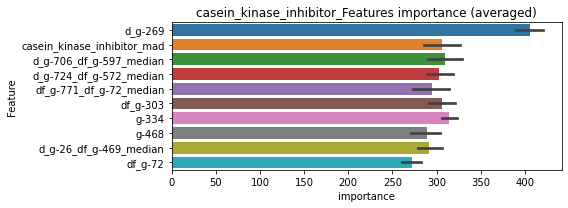

len(train_index) : 2846
len(valid_index) : 949
================================= fold 1/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957319	valid_1's binary_logloss: 0.125586
[200]	training's binary_logloss: 0.0328666	valid_1's binary_logloss: 0.0553842
[300]	training's binary_logloss: 0.0126951	valid_1's binary_logloss: 0.0281626
[400]	training's binary_logloss: 0.00539852	valid_1's binary_logloss: 0.0157498
[500]	training's binary_logloss: 0.00270848	valid_1's binary_logloss: 0.0103075
[600]	training's binary_logloss: 0.00162915	valid_1's binary_logloss: 0.00776688
[700]	training's binary_logloss: 0.00112662	valid_1's binary_logloss: 0.00626269
[800]	training's binary_logloss: 0.000871997	valid_1's binary_logloss: 0.00550414
[900]	training's binary_logloss: 0.000713605	valid_1's binary_logloss: 0.00489731
[1000]	training's binary_logloss: 0.000636085	valid_1's binary_logloss: 0.00461784
[1100]	training's binary_logloss: 0.000593407	valid_1's binary_logloss: 0.00443579
Early stopping, best iteration is:
[1155]	training'

len(train_index) : 2846
len(valid_index) : 949
================================= fold 2/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958663	valid_1's binary_logloss: 0.135259
[200]	training's binary_logloss: 0.0331697	valid_1's binary_logloss: 0.0668866
[300]	training's binary_logloss: 0.0128351	valid_1's binary_logloss: 0.0379156
[400]	training's binary_logloss: 0.00527526	valid_1's binary_logloss: 0.0241335
[500]	training's binary_logloss: 0.00263077	valid_1's binary_logloss: 0.0177245
[600]	training's binary_logloss: 0.00158678	valid_1's binary_logloss: 0.0151355
[700]	training's binary_logloss: 0.00110029	valid_1's binary_logloss: 0.0138984
[800]	training's binary_logloss: 0.000849922	valid_1's binary_logloss: 0.0129319
[900]	training's binary_logloss: 0.000703045	valid_1's binary_logloss: 0.0126114
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.00069538	valid_1's binary_logloss: 0.012556


len(train_index) : 2846
len(valid_index) : 949
================================= fold 3/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0956139	valid_1's binary_logloss: 0.133903
[200]	training's binary_logloss: 0.0338422	valid_1's binary_logloss: 0.0646221
[300]	training's binary_logloss: 0.0129645	valid_1's binary_logloss: 0.0360782
[400]	training's binary_logloss: 0.00541879	valid_1's binary_logloss: 0.0227566
[500]	training's binary_logloss: 0.0027168	valid_1's binary_logloss: 0.016566
[600]	training's binary_logloss: 0.00163483	valid_1's binary_logloss: 0.0137493
[700]	training's binary_logloss: 0.00112589	valid_1's binary_logloss: 0.0121066
[800]	training's binary_logloss: 0.000856993	valid_1's binary_logloss: 0.0110898
[900]	training's binary_logloss: 0.000706009	valid_1's binary_logloss: 0.0105668
[1000]	training's binary_logloss: 0.000617632	valid_1's binary_logloss: 0.0102223
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.000615935	valid_1's binary_logloss: 0.0102087


len(train_index) : 2847
len(valid_index) : 948
================================= fold 4/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0977313	valid_1's binary_logloss: 0.130825
[200]	training's binary_logloss: 0.0343742	valid_1's binary_logloss: 0.063382
[300]	training's binary_logloss: 0.0128898	valid_1's binary_logloss: 0.0334789
[400]	training's binary_logloss: 0.00537299	valid_1's binary_logloss: 0.0197562
[500]	training's binary_logloss: 0.00265829	valid_1's binary_logloss: 0.0130615
[600]	training's binary_logloss: 0.0016166	valid_1's binary_logloss: 0.0102133
[700]	training's binary_logloss: 0.00111235	valid_1's binary_logloss: 0.00847755
[800]	training's binary_logloss: 0.000852241	valid_1's binary_logloss: 0.00749148
[900]	training's binary_logloss: 0.000700386	valid_1's binary_logloss: 0.00694735
[1000]	training's binary_logloss: 0.000621984	valid_1's binary_logloss: 0.00656326
Early stopping, best iteration is:
[1026]	training's binary_logloss: 0.000608353	valid_1's binary_logloss: 0.00649156


casein_kinase_inhibitor logloss: 0.00841303726486602
caspase_activator, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.075015	valid_1's binary_logloss: 0.0919702
[200]	training's binary_logloss: 0.0199686	valid_1's binary_logloss: 0.0306812
[300]	training's binary_logloss: 0.00627729	valid_1's binary_logloss: 0.0128171
[400]	training's binary_logloss: 0.00253339	valid_1's binary_logloss: 0.0069586
[500]	training's binary_logloss: 0.00132803	valid_1's binary_logloss: 0.00444815
[600]	training's binary_logloss: 0.000856927	valid_1's binary_logloss: 0.00342314
[700]	training's binary_logloss: 0.000628761	valid_1's binary_logloss: 0.00287268
[800]	training's binary_logloss: 0.000512427	valid_1's binary_logloss: 0.00256433
[900]	training's binary_logloss: 0.000461371	valid_1's binary_logloss: 0.00242096
Early stopping, best iteration is:
[952]	training's binary_logloss: 0.000446336	valid_1's binary_logloss: 0.00236698
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0048677, Threshold: 0.0464564, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.03252, conf_1:0.06039
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0464564
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_2: 0.0764564
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_3: 0.1064564
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_4: 0.1364564
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.1664564
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_6: 0.1964564
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_7: 0.2264564
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.2564564
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_9: 0.2864564
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.3164564
threshold: 0.3464564, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.073868	valid_1's binary_logloss: 0.0859215
[200]	training's binary_logloss: 0.0186044	valid_1's binary_logloss: 0.0254472
[300]	training's binary_logloss: 0.0056111	valid_1's binary_logloss: 0.00929791
[400]	training's binary_logloss: 0.0022271	valid_1's binary_logloss: 0.004389
[500]	training's binary_logloss: 0.00117709	valid_1's binary_logloss: 0.00266489
[600]	training's binary_logloss: 0.000776085	valid_1's binary_logloss: 0.00195321
[700]	training's binary_logloss: 0.000574974	valid_1's binary_logloss: 0.00156686
[800]	training's binary_logloss: 0.000470379	valid_1's binary_logloss: 0.00135149
[900]	training's binary_logloss: 0.000431878	valid_1's binary_logloss: 0.00128051
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000431878	valid_1's binary_logloss: 0.00128051
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

2 / 3 AUC score:1.000
y_Threshold: 0.1036135, Threshold: 0.3464564, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0060271 Vs.target_rate: 0.00076, Num_p_label: 24.0, conf_0:0.27717, conf_1:0.41575
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_1: 0.3464564
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.3764564
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.4064564
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_4: 0.4364564
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.4664564
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.4964564
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_7: 0.5264564
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_8: 0.5564564
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_9: 0.5864564
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_10: 0.6164564
threshold: 0.6464564, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.073868	valid_1's binary_logloss: 0.0859215
[200]	training's binary_logloss: 0.0186044	valid_1's binary_logloss: 0.0254472
[300]	training's binary_logloss: 0.0056111	valid_1's binary_logloss: 0.00929791
[400]	training's binary_logloss: 0.0022271	valid_1's binary_logloss: 0.004389
[500]	training's binary_logloss: 0.00117709	valid_1's binary_logloss: 0.00266489
[600]	training's binary_logloss: 0.000776085	valid_1's binary_logloss: 0.00195321
[700]	training's binary_logloss: 0.000574974	valid_1's binary_logloss: 0.00156686
[800]	training's binary_logloss: 0.000470379	valid_1's binary_logloss: 0.00135149
[900]	training's binary_logloss: 0.000431878	valid_1's binary_logloss: 0.00128051
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000431878	valid_1's binary_logloss: 0.00128051
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

3 / 3 AUC score:1.000
y_Threshold: 0.1036135, Threshold: 0.6464564, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.50000, conf_1:0.71110
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.6464564
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.6764564
threshold: 0.6764564, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


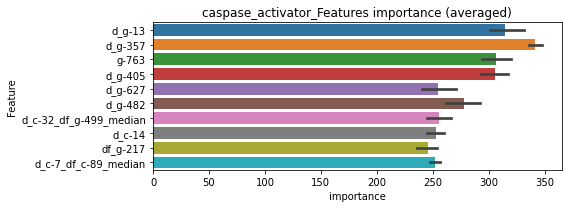

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 caspase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0737477	valid_1's binary_logloss: 0.0867869
[200]	training's binary_logloss: 0.018373	valid_1's binary_logloss: 0.0256676
[300]	training's binary_logloss: 0.00557314	valid_1's binary_logloss: 0.009473
[400]	training's binary_logloss: 0.0022504	valid_1's binary_logloss: 0.00457149
[500]	training's binary_logloss: 0.00118188	valid_1's binary_logloss: 0.00286058
[600]	training's binary_logloss: 0.000769613	valid_1's binary_logloss: 0.0020911
[700]	training's binary_logloss: 0.000573333	valid_1's binary_logloss: 0.00168847
[800]	training's binary_logloss: 0.000472353	valid_1's binary_logloss: 0.00148434
[900]	training's binary_logloss: 0.0004288	valid_1's binary_logloss: 0.00138865
Early stopping, best iteration is:
[931]	training's binary_logloss: 0.000419817	valid_1's binary_logloss: 0.00137005


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 caspase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720194	valid_1's binary_logloss: 0.0906079
[200]	training's binary_logloss: 0.017755	valid_1's binary_logloss: 0.0299145
[300]	training's binary_logloss: 0.00542276	valid_1's binary_logloss: 0.0133824
[400]	training's binary_logloss: 0.00218641	valid_1's binary_logloss: 0.00766788
[500]	training's binary_logloss: 0.00115057	valid_1's binary_logloss: 0.00549157
[600]	training's binary_logloss: 0.000750757	valid_1's binary_logloss: 0.00457506
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.000616044	valid_1's binary_logloss: 0.00420599


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 caspase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729467	valid_1's binary_logloss: 0.0817554
[200]	training's binary_logloss: 0.01858	valid_1's binary_logloss: 0.0233645
[300]	training's binary_logloss: 0.0056093	valid_1's binary_logloss: 0.0082081
[400]	training's binary_logloss: 0.00224622	valid_1's binary_logloss: 0.00372875
[500]	training's binary_logloss: 0.00118485	valid_1's binary_logloss: 0.0021648
[600]	training's binary_logloss: 0.000771877	valid_1's binary_logloss: 0.00151198
[700]	training's binary_logloss: 0.000573004	valid_1's binary_logloss: 0.00117601
[800]	training's binary_logloss: 0.000469404	valid_1's binary_logloss: 0.000999488
[900]	training's binary_logloss: 0.000430452	valid_1's binary_logloss: 0.000929623
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.000430452	valid_1's binary_logloss: 0.000929623


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 caspase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0719754	valid_1's binary_logloss: 0.0875125
[200]	training's binary_logloss: 0.0175855	valid_1's binary_logloss: 0.0283559
[300]	training's binary_logloss: 0.00531494	valid_1's binary_logloss: 0.0122541
[400]	training's binary_logloss: 0.00214711	valid_1's binary_logloss: 0.00677626
[500]	training's binary_logloss: 0.00114108	valid_1's binary_logloss: 0.00444479
[600]	training's binary_logloss: 0.000749037	valid_1's binary_logloss: 0.00356219
[700]	training's binary_logloss: 0.000562407	valid_1's binary_logloss: 0.00302705
[800]	training's binary_logloss: 0.000464987	valid_1's binary_logloss: 0.00268605
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.000432111	valid_1's binary_logloss: 0.00258714


caspase_activator logloss: 0.002273117780488357
catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0817869	valid_1's binary_logloss: 0.104556
[200]	training's binary_logloss: 0.0238264	valid_1's binary_logloss: 0.0377985
[300]	training's binary_logloss: 0.00794673	valid_1's binary_logloss: 0.0162433
[400]	training's binary_logloss: 0.00319164	valid_1's binary_logloss: 0.00883774
[500]	training's binary_logloss: 0.00163399	valid_1's binary_logloss: 0.00584248
[600]	training's binary_logloss: 0.00102276	valid_1's binary_logloss: 0.00442383
[700]	training's binary_logloss: 0.00073919	valid_1's binary_logloss: 0.0037714
[800]	training's binary_logloss: 0.000590238	valid_1's binary_logloss: 0.0033607
[900]	training's binary_logloss: 0.000510768	valid_1's binary_logloss: 0.0031573
[1000]	training's binary_logloss: 0.000490087	valid_1's binary_logloss: 0.00310252
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.000490087	valid_1's binary_logloss: 0.00310252
Training until va

1 / 3 AUC score:1.000
y_Threshold: 0.0044472, Threshold: 0.0280601, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01964, conf_1:0.03648
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0280601
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.0580601
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0880601
threshold: 0.0880601, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805337	valid_1's binary_logloss: 0.101294
[200]	training's binary_logloss: 0.0216834	valid_1's binary_logloss: 0.0327867
[300]	training's binary_logloss: 0.00694858	valid_1's binary_logloss: 0.0126641
[400]	training's binary_logloss: 0.00278569	valid_1's binary_logloss: 0.00620432
[500]	training's binary_logloss: 0.00142965	valid_1's binary_logloss: 0.00377911
[600]	training's binary_logloss: 0.000907135	valid_1's binary_logloss: 0.00268356
[700]	training's binary_logloss: 0.000661192	valid_1's binary_logloss: 0.00212009
[800]	training's binary_logloss: 0.000528856	valid_1's binary_logloss: 0.00180297
[900]	training's binary_logloss: 0.000473237	valid_1's binary_logloss: 0.00168524
[1000]	training's binary_logloss: 0.000459539	valid_1's binary_logloss: 0.00165997
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.000459539	valid_1's binary_logloss: 0.00165997
Training unt

2 / 3 AUC score:1.000
y_Threshold: 0.1135829, Threshold: 0.0880601, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0077850 Vs.target_rate: 0.00076, Num_p_label: 31.0, conf_0:0.07045, conf_1:0.10567
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_1: 0.0880601
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.1180601
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_3: 0.1480601
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_4: 0.1780601
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.2080601
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.2380601
threshold: 0.2380601, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805337	valid_1's binary_logloss: 0.101294
[200]	training's binary_logloss: 0.0216834	valid_1's binary_logloss: 0.0327867
[300]	training's binary_logloss: 0.00694858	valid_1's binary_logloss: 0.0126641
[400]	training's binary_logloss: 0.00278569	valid_1's binary_logloss: 0.00620432
[500]	training's binary_logloss: 0.00142965	valid_1's binary_logloss: 0.00377911
[600]	training's binary_logloss: 0.000907135	valid_1's binary_logloss: 0.00268356
[700]	training's binary_logloss: 0.000661192	valid_1's binary_logloss: 0.00212009
[800]	training's binary_logloss: 0.000528856	valid_1's binary_logloss: 0.00180297
[900]	training's binary_logloss: 0.000473237	valid_1's binary_logloss: 0.00168524
[1000]	training's binary_logloss: 0.000459539	valid_1's binary_logloss: 0.00165997
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.000459539	valid_1's binary_logloss: 0.00165997
Training unt

3 / 3 AUC score:1.000
y_Threshold: 0.1135829, Threshold: 0.2380601, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.21425, conf_1:0.26187
threshold: 0.2380601, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


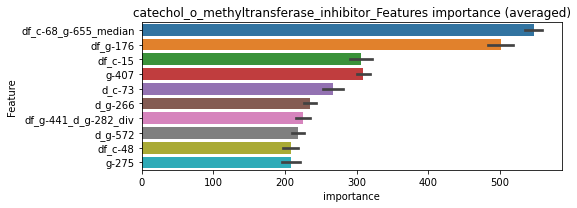

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0803939	valid_1's binary_logloss: 0.101593
[200]	training's binary_logloss: 0.0220848	valid_1's binary_logloss: 0.0329256
[300]	training's binary_logloss: 0.00693342	valid_1's binary_logloss: 0.012623
[400]	training's binary_logloss: 0.00277423	valid_1's binary_logloss: 0.00618722
[500]	training's binary_logloss: 0.00143658	valid_1's binary_logloss: 0.00374927
[600]	training's binary_logloss: 0.000912895	valid_1's binary_logloss: 0.00264019
[700]	training's binary_logloss: 0.000667996	valid_1's binary_logloss: 0.002075
[800]	training's binary_logloss: 0.000537184	valid_1's binary_logloss: 0.00178085
[900]	training's binary_logloss: 0.000471625	valid_1's binary_logloss: 0.00162107
[1000]	training's binary_logloss: 0.000449429	valid_1's binary_logloss: 0.00157345
Early stopping, best iteration is:
[1058]	training's binary_logloss: 0.000446932	valid_1's binary_logloss: 0.00156966


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0807084	valid_1's binary_logloss: 0.0997615
[200]	training's binary_logloss: 0.0216679	valid_1's binary_logloss: 0.0334653
[300]	training's binary_logloss: 0.00673773	valid_1's binary_logloss: 0.013289
[400]	training's binary_logloss: 0.00265543	valid_1's binary_logloss: 0.00651616
[500]	training's binary_logloss: 0.00138277	valid_1's binary_logloss: 0.00407697
[600]	training's binary_logloss: 0.000875719	valid_1's binary_logloss: 0.00295205
[700]	training's binary_logloss: 0.000641021	valid_1's binary_logloss: 0.00236499
[800]	training's binary_logloss: 0.000517475	valid_1's binary_logloss: 0.00207497
[900]	training's binary_logloss: 0.000466535	valid_1's binary_logloss: 0.00193834
[1000]	training's binary_logloss: 0.000453034	valid_1's binary_logloss: 0.00191317
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000453034	valid_1's binary_logloss: 0.00191317


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0803375	valid_1's binary_logloss: 0.101993
[200]	training's binary_logloss: 0.0219756	valid_1's binary_logloss: 0.0349951
[300]	training's binary_logloss: 0.00687589	valid_1's binary_logloss: 0.0144229
[400]	training's binary_logloss: 0.00270797	valid_1's binary_logloss: 0.00761156
[500]	training's binary_logloss: 0.0013949	valid_1's binary_logloss: 0.00489938
[600]	training's binary_logloss: 0.000886211	valid_1's binary_logloss: 0.00374759
[700]	training's binary_logloss: 0.000647453	valid_1's binary_logloss: 0.00311003
[800]	training's binary_logloss: 0.00052154	valid_1's binary_logloss: 0.00280735
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.000492917	valid_1's binary_logloss: 0.0027376


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0815356	valid_1's binary_logloss: 0.0949115
[200]	training's binary_logloss: 0.0224688	valid_1's binary_logloss: 0.0324442
[300]	training's binary_logloss: 0.00699489	valid_1's binary_logloss: 0.0135489
[400]	training's binary_logloss: 0.00276134	valid_1's binary_logloss: 0.00691891
[500]	training's binary_logloss: 0.00141535	valid_1's binary_logloss: 0.00440948
[600]	training's binary_logloss: 0.00089963	valid_1's binary_logloss: 0.00337592
[700]	training's binary_logloss: 0.000655443	valid_1's binary_logloss: 0.00287526
[800]	training's binary_logloss: 0.000529096	valid_1's binary_logloss: 0.00257538
[900]	training's binary_logloss: 0.000478084	valid_1's binary_logloss: 0.00243332
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000478084	valid_1's binary_logloss: 0.00243332


catechol_o_methyltransferase_inhibitor logloss: 0.00216336694151852
cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3276, target_rate: 0.0042832 → Adj_target_rate: 0.0042806


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141691	valid_1's binary_logloss: 0.230389
[200]	training's binary_logloss: 0.068492	valid_1's binary_logloss: 0.17376
[300]	training's binary_logloss: 0.0373602	valid_1's binary_logloss: 0.145498
[400]	training's binary_logloss: 0.0204325	valid_1's binary_logloss: 0.129902
[500]	training's binary_logloss: 0.0114612	valid_1's binary_logloss: 0.121703
[600]	training's binary_logloss: 0.0067987	valid_1's binary_logloss: 0.117345
[700]	training's binary_logloss: 0.00425777	valid_1's binary_logloss: 0.114532
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00336202	valid_1's binary_logloss: 0.113274
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141197	valid_1's binary_logloss: 0.220021
[200]	training's binary_logloss: 0.0691014	valid_1's binary_logloss: 0.160068
[300]	training's binary_logloss: 0.0375114	valid_1's binary_loglo

1 / 3 AUC score:0.985
y_Threshold: 0.0358222, Threshold: 0.1903116, pos_neg_ratio: 0.8000000
Remove_noisy_data: 188 → Positive_corect_labels: 627/3743
p_label_rate: 0.0100452 Vs.target_rate: 0.00428, Num_p_label: 40.0, conf_0:0.13322, conf_1:0.24741
threshold: 0.1903116, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 627.0/3743, y_label_rate: 0.1675127
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126855	valid_1's binary_logloss: 0.19807
[200]	training's binary_logloss: 0.0557609	valid_1's binary_logloss: 0.131772
[300]	training's binary_logloss: 0.0279182	valid_1's binary_logloss: 0.102864
[400]	training's binary_logloss: 0.0143534	valid_1's binary_logloss: 0.0875785
[500]	training's binary_logloss: 0.00769115	valid_1's binary_logloss: 0.0795403
[600]	training's binary_logloss: 0.00453618	valid_1's binary_logloss: 0.0762817
[700]	training's binary_logloss: 0.00293858	valid_1's binary_logloss: 0.0742141
[800]	training's binary_logloss: 0.00208199	valid_1's binary_logloss: 0.0731987
Early stopping, best iteration is:
[777]	training's binary_logloss: 0.00224215	valid_1's binary_logloss: 0.0729045
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12709	valid_1's binary_logloss: 0.195197
[200]	training's binary_logloss: 0.0537747	valid_1's bin

2 / 3 AUC score:0.994
y_Threshold: 0.1009975, Threshold: 0.1903116, pos_neg_ratio: 0.8000000
Remove_noisy_data: 58 → Positive_corect_labels: 598.0/3685
p_label_rate: 0.0246107 Vs.target_rate: 0.00428, Num_p_label: 98.0, conf_0:0.15225, conf_1:0.22837
Num_p_label: 98.0, Expected: 17.1, Adj_threshold_1: 0.1903116
Num_p_label: 86.0, Expected: 17.1, Adj_threshold_2: 0.2203116
Num_p_label: 74.0, Expected: 17.1, Adj_threshold_3: 0.2503116
Num_p_label: 68.0, Expected: 17.1, Adj_threshold_4: 0.2803116
Num_p_label: 60.0, Expected: 17.1, Adj_threshold_5: 0.3103116
Num_p_label: 52.0, Expected: 17.1, Adj_threshold_6: 0.3403116
Num_p_label: 49.0, Expected: 17.1, Adj_threshold_7: 0.3703116
Num_p_label: 43.0, Expected: 17.1, Adj_threshold_8: 0.4003116
Num_p_label: 42.0, Expected: 17.1, Adj_threshold_9: 0.4303116
Num_p_label: 40.0, Expected: 17.1, Adj_threshold_10: 0.4603116
threshold: 0.4903116, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 598.0/3685, y_label_rate: 0.1622795

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114429	valid_1's binary_logloss: 0.180294
[200]	training's binary_logloss: 0.045318	valid_1's binary_logloss: 0.115115
[300]	training's binary_logloss: 0.0205868	valid_1's binary_logloss: 0.0858112
[400]	training's binary_logloss: 0.0101674	valid_1's binary_logloss: 0.0712498
[500]	training's binary_logloss: 0.00543329	valid_1's binary_logloss: 0.0633386
[600]	training's binary_logloss: 0.00328816	valid_1's binary_logloss: 0.0593306
[700]	training's binary_logloss: 0.0022073	valid_1's binary_logloss: 0.0563105
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.0021323	valid_1's binary_logloss: 0.0559456
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116902	valid_1's binary_logloss: 0.173188
[200]	training's binary_logloss: 0.0471471	valid_1's binary_logloss: 0.103391
[300]	training's binary_logloss: 0.021775	valid_1's binary

3 / 3 AUC score:0.997
y_Threshold: 0.1236513, Threshold: 0.4903116, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 585.0/3659
p_label_rate: 0.0125565 Vs.target_rate: 0.00428, Num_p_label: 50.0, conf_0:0.44128, conf_1:0.53934
threshold: 0.4903116, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 585.0/3659, y_label_rate: 0.1598797


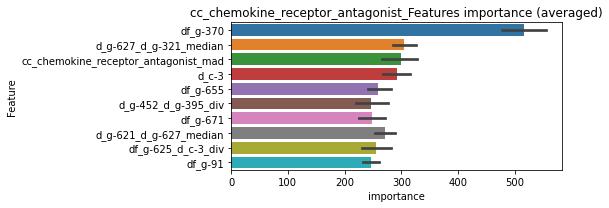

len(train_index) : 2744
len(valid_index) : 915
================================= fold 1/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106145	valid_1's binary_logloss: 0.176095
[200]	training's binary_logloss: 0.039707	valid_1's binary_logloss: 0.112344
[300]	training's binary_logloss: 0.0179154	valid_1's binary_logloss: 0.0872645
[400]	training's binary_logloss: 0.00873524	valid_1's binary_logloss: 0.0743982
[500]	training's binary_logloss: 0.00469007	valid_1's binary_logloss: 0.0669399
[600]	training's binary_logloss: 0.00283345	valid_1's binary_logloss: 0.0634357
[700]	training's binary_logloss: 0.00192609	valid_1's binary_logloss: 0.0623869
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.00194433	valid_1's binary_logloss: 0.0623808


len(train_index) : 2744
len(valid_index) : 915
================================= fold 2/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110403	valid_1's binary_logloss: 0.161022
[200]	training's binary_logloss: 0.0419716	valid_1's binary_logloss: 0.0973499
[300]	training's binary_logloss: 0.0184249	valid_1's binary_logloss: 0.0712978
[400]	training's binary_logloss: 0.0087719	valid_1's binary_logloss: 0.0609871
[500]	training's binary_logloss: 0.00475019	valid_1's binary_logloss: 0.0548637
[600]	training's binary_logloss: 0.00288712	valid_1's binary_logloss: 0.0528139
[700]	training's binary_logloss: 0.0019849	valid_1's binary_logloss: 0.0521209
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00163277	valid_1's binary_logloss: 0.0517849


len(train_index) : 2744
len(valid_index) : 915
================================= fold 3/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111967	valid_1's binary_logloss: 0.152731
[200]	training's binary_logloss: 0.0427428	valid_1's binary_logloss: 0.0842724
[300]	training's binary_logloss: 0.0197505	valid_1's binary_logloss: 0.057126
[400]	training's binary_logloss: 0.00970844	valid_1's binary_logloss: 0.0426304
[500]	training's binary_logloss: 0.00519833	valid_1's binary_logloss: 0.0336354
[600]	training's binary_logloss: 0.00310503	valid_1's binary_logloss: 0.0282984
[700]	training's binary_logloss: 0.00208328	valid_1's binary_logloss: 0.0250912
[800]	training's binary_logloss: 0.00155498	valid_1's binary_logloss: 0.0229944
[900]	training's binary_logloss: 0.00124427	valid_1's binary_logloss: 0.0216673
[1000]	training's binary_logloss: 0.00106452	valid_1's binary_logloss: 0.0206042
[1100]	training's binary_logloss: 0.00095628	valid_1's binary_logloss: 0.0202558
Early stopping, best iteration is:
[1145]	training's binary_log

len(train_index) : 2745
len(valid_index) : 914
================================= fold 4/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105704	valid_1's binary_logloss: 0.169283
[200]	training's binary_logloss: 0.0396314	valid_1's binary_logloss: 0.108977
[300]	training's binary_logloss: 0.017672	valid_1's binary_logloss: 0.086312
[400]	training's binary_logloss: 0.00857025	valid_1's binary_logloss: 0.0784331
[500]	training's binary_logloss: 0.00462967	valid_1's binary_logloss: 0.072556
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.0037583	valid_1's binary_logloss: 0.0712463


cc_chemokine_receptor_antagonist logloss: 0.051360816002218


neg labels: 3289 → selected neg labels: 3288


cck_receptor_antagonist, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0758988	valid_1's binary_logloss: 0.0952695
[200]	training's binary_logloss: 0.0204892	valid_1's binary_logloss: 0.0333482
[300]	training's binary_logloss: 0.00654512	valid_1's binary_logloss: 0.0144436
[400]	training's binary_logloss: 0.00258446	valid_1's binary_logloss: 0.00824956
[500]	training's binary_logloss: 0.0013432	valid_1's binary_logloss: 0.00557471
[600]	training's binary_logloss: 0.000866916	valid_1's binary_logloss: 0.0043894
[700]	training's binary_logloss: 0.000643514	valid_1's binary_logloss: 0.00378779
[800]	training's binary_logloss: 0.000520611	valid_1's binary_logloss: 0.00347644
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.0004849	valid_1's binary_logloss: 0.00335455
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0761314	valid_1's binary_logloss: 0.100508
[200]	training's binary_logloss: 0.020933

1 / 3 AUC score:1.000
y_Threshold: 0.0047879, Threshold: 0.0327749, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02294, conf_1:0.04261
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0327749
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.0627749
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.0927749
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.1227749
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.1527749
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.1827749
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.2127749
threshold: 0.2127749, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0723841	valid_1's binary_logloss: 0.0876906
[200]	training's binary_logloss: 0.0182436	valid_1's binary_logloss: 0.026699
[300]	training's binary_logloss: 0.00558035	valid_1's binary_logloss: 0.0101283
[400]	training's binary_logloss: 0.00220774	valid_1's binary_logloss: 0.00489966
[500]	training's binary_logloss: 0.00117156	valid_1's binary_logloss: 0.00304103
[600]	training's binary_logloss: 0.00076365	valid_1's binary_logloss: 0.00227243
[700]	training's binary_logloss: 0.000564141	valid_1's binary_logloss: 0.0018271
[800]	training's binary_logloss: 0.000466519	valid_1's binary_logloss: 0.00160153
[900]	training's binary_logloss: 0.00043885	valid_1's binary_logloss: 0.00155598
Early stopping, best iteration is:
[881]	training's binary_logloss: 0.000438928	valid_1's binary_logloss: 0.00155592
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

2 / 3 AUC score:1.000
y_Threshold: 0.0732643, Threshold: 0.2127749, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0090407 Vs.target_rate: 0.00076, Num_p_label: 36.0, conf_0:0.17022, conf_1:0.25533
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_1: 0.2127749
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.2427749
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_3: 0.2727749
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.3027749
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.3327749
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.3627749
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_7: 0.3927749
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.4227749
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.4527749
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_10: 0.4827749
threshold: 0.5127749, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0723841	valid_1's binary_logloss: 0.0876906
[200]	training's binary_logloss: 0.0182436	valid_1's binary_logloss: 0.026699
[300]	training's binary_logloss: 0.00558035	valid_1's binary_logloss: 0.0101283
[400]	training's binary_logloss: 0.00220774	valid_1's binary_logloss: 0.00489966
[500]	training's binary_logloss: 0.00117156	valid_1's binary_logloss: 0.00304103
[600]	training's binary_logloss: 0.00076365	valid_1's binary_logloss: 0.00227243
[700]	training's binary_logloss: 0.000564141	valid_1's binary_logloss: 0.0018271
[800]	training's binary_logloss: 0.000466519	valid_1's binary_logloss: 0.00160153
[900]	training's binary_logloss: 0.00043885	valid_1's binary_logloss: 0.00155598
Early stopping, best iteration is:
[881]	training's binary_logloss: 0.000438928	valid_1's binary_logloss: 0.00155592
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

3 / 3 AUC score:1.000
y_Threshold: 0.0732643, Threshold: 0.5127749, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.46150, conf_1:0.56405
threshold: 0.5127749, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


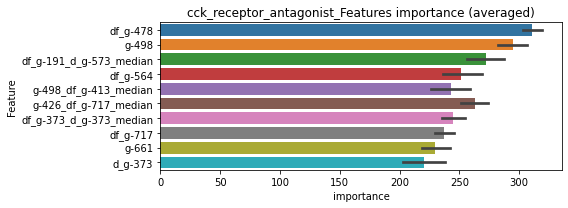

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0724998	valid_1's binary_logloss: 0.0871345
[200]	training's binary_logloss: 0.0183887	valid_1's binary_logloss: 0.0270552
[300]	training's binary_logloss: 0.00559972	valid_1's binary_logloss: 0.0103307
[400]	training's binary_logloss: 0.00221613	valid_1's binary_logloss: 0.00498119
[500]	training's binary_logloss: 0.00115932	valid_1's binary_logloss: 0.00307559
[600]	training's binary_logloss: 0.000749636	valid_1's binary_logloss: 0.00230279
[700]	training's binary_logloss: 0.000558444	valid_1's binary_logloss: 0.00192006
[800]	training's binary_logloss: 0.00046226	valid_1's binary_logloss: 0.00170917
Early stopping, best iteration is:
[797]	training's binary_logloss: 0.000463929	valid_1's binary_logloss: 0.00170817


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729226	valid_1's binary_logloss: 0.0939244
[200]	training's binary_logloss: 0.0182642	valid_1's binary_logloss: 0.0327814
[300]	training's binary_logloss: 0.00545869	valid_1's binary_logloss: 0.0145688
[400]	training's binary_logloss: 0.00218451	valid_1's binary_logloss: 0.00868333
[500]	training's binary_logloss: 0.00114373	valid_1's binary_logloss: 0.00620681
[600]	training's binary_logloss: 0.000742441	valid_1's binary_logloss: 0.00519599
[700]	training's binary_logloss: 0.000548239	valid_1's binary_logloss: 0.00458704
[800]	training's binary_logloss: 0.000456162	valid_1's binary_logloss: 0.00426061
[900]	training's binary_logloss: 0.000430046	valid_1's binary_logloss: 0.00414009
Early stopping, best iteration is:
[882]	training's binary_logloss: 0.000431045	valid_1's binary_logloss: 0.0041327


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.071912	valid_1's binary_logloss: 0.087021
[200]	training's binary_logloss: 0.0183959	valid_1's binary_logloss: 0.0278076
[300]	training's binary_logloss: 0.00566048	valid_1's binary_logloss: 0.0109096
[400]	training's binary_logloss: 0.00226232	valid_1's binary_logloss: 0.00620133
[500]	training's binary_logloss: 0.00117888	valid_1's binary_logloss: 0.00450608
[600]	training's binary_logloss: 0.000763301	valid_1's binary_logloss: 0.00374767
[700]	training's binary_logloss: 0.000563782	valid_1's binary_logloss: 0.00349762
[800]	training's binary_logloss: 0.000465268	valid_1's binary_logloss: 0.00337144
[900]	training's binary_logloss: 0.000433924	valid_1's binary_logloss: 0.00335305
Early stopping, best iteration is:
[874]	training's binary_logloss: 0.000441648	valid_1's binary_logloss: 0.00333031


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0716581	valid_1's binary_logloss: 0.0950708
[200]	training's binary_logloss: 0.0182383	valid_1's binary_logloss: 0.0345487
[300]	training's binary_logloss: 0.00559678	valid_1's binary_logloss: 0.0150302
[400]	training's binary_logloss: 0.00224932	valid_1's binary_logloss: 0.0084116
[500]	training's binary_logloss: 0.00118418	valid_1's binary_logloss: 0.00574194
[600]	training's binary_logloss: 0.000762213	valid_1's binary_logloss: 0.00462647
[700]	training's binary_logloss: 0.000560934	valid_1's binary_logloss: 0.00392204
[800]	training's binary_logloss: 0.000458322	valid_1's binary_logloss: 0.00354334
Early stopping, best iteration is:
[837]	training's binary_logloss: 0.000439298	valid_1's binary_logloss: 0.00347143


cck_receptor_antagonist logloss: 0.00316315598657233
cdk_inhibitor, len(trt): 352, len(othr): 3241, target_rate: 0.0147812 → Adj_target_rate: 0.0122676


neg labels: 3289 → selected neg labels: 3241


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.260918	valid_1's binary_logloss: 0.395666
[200]	training's binary_logloss: 0.171751	valid_1's binary_logloss: 0.378227
[300]	training's binary_logloss: 0.118824	valid_1's binary_logloss: 0.369138
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0997215	valid_1's binary_logloss: 0.367374
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.25554	valid_1's binary_logloss: 0.401361
[200]	training's binary_logloss: 0.167141	valid_1's binary_logloss: 0.384021
[300]	training's binary_logloss: 0.11638	valid_1's binary_logloss: 0.375447
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.110766	valid_1's binary_logloss: 0.374749
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.256434	valid_1's binary_logloss: 0.398712
[200]	training's binary_logloss: 0.165598	valid_1's bin

1 / 3 AUC score:0.753
y_Threshold: 0.1477971, Threshold: 0.4167587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 688 → Positive_corect_labels: 369/3201
p_label_rate: 0.0100452 Vs.target_rate: 0.01478, Num_p_label: 40.0, conf_0:0.29173, conf_1:0.54179
threshold: 0.4167587, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 369.0/3201, y_label_rate: 0.1152765
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128948	valid_1's binary_logloss: 0.246841
[200]	training's binary_logloss: 0.0614897	valid_1's binary_logloss: 0.21773
[300]	training's binary_logloss: 0.0311991	valid_1's binary_logloss: 0.210285
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.024574	valid_1's binary_logloss: 0.208407
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137082	valid_1's binary_logloss: 0.218938
[200]	training's binary_logloss: 0.0663745	valid_1's binary_logloss: 0.177471
[300]	training's binary_logloss: 0.0356825	valid_1's binary_logloss: 0.158658
[400]	training's binary_logloss: 0.0191942	valid_1's binary_logloss: 0.147268
[500]	training's binary_logloss: 0.0110039	valid_1's binary_logloss: 0.143693
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00934423	valid_1's binary_logloss: 0.143529
Training until validation score

2 / 3 AUC score:0.960
y_Threshold: 0.1045178, Threshold: 0.4167587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 162 → Positive_corect_labels: 288.0/3039
p_label_rate: 0.0246107 Vs.target_rate: 0.01478, Num_p_label: 98.0, conf_0:0.33341, conf_1:0.50011
threshold: 0.4167587, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 288.0/3039, y_label_rate: 0.0947680
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0928342	valid_1's binary_logloss: 0.169693
[200]	training's binary_logloss: 0.0372814	valid_1's binary_logloss: 0.132248
[300]	training's binary_logloss: 0.0170646	valid_1's binary_logloss: 0.115694
[400]	training's binary_logloss: 0.00851762	valid_1's binary_logloss: 0.10947
[500]	training's binary_logloss: 0.00466988	valid_1's binary_logloss: 0.106522
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00409227	valid_1's binary_logloss: 0.105934
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0911368	valid_1's binary_logloss: 0.165295
[200]	training's binary_logloss: 0.0365874	valid_1's binary_logloss: 0.133468
[300]	training's binary_logloss: 0.0167994	valid_1's binary_logloss: 0.121553
[400]	training's binary_logloss: 0.00832387	valid_1's binary_logloss: 0.117282
Early stopping, best iteration is:
[438]	training's binary_l

3 / 3 AUC score:0.963
y_Threshold: 0.0912105, Threshold: 0.4167587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 80 → Positive_corect_labels: 248.0/2959
p_label_rate: 0.0462079 Vs.target_rate: 0.01478, Num_p_label: 184.0, conf_0:0.37508, conf_1:0.45843
Num_p_label: 184.0, Expected: 58.9, Adj_threshold_1: 0.4167587
Num_p_label: 173.0, Expected: 58.9, Adj_threshold_2: 0.4467587
Num_p_label: 162.0, Expected: 58.9, Adj_threshold_3: 0.4767587
Num_p_label: 151.0, Expected: 58.9, Adj_threshold_4: 0.5067587
Num_p_label: 137.0, Expected: 58.9, Adj_threshold_5: 0.5367587
Num_p_label: 132.0, Expected: 58.9, Adj_threshold_6: 0.5667587
Num_p_label: 117.0, Expected: 58.9, Adj_threshold_7: 0.5967587
Num_p_label: 104.0, Expected: 58.9, Adj_threshold_8: 0.6267587
Num_p_label: 94.0, Expected: 58.9, Adj_threshold_9: 0.6567587
Num_p_label: 82.0, Expected: 58.9, Adj_threshold_10: 0.6867587
threshold: 0.6867587, positive_p_label: 82.0/3982, p_label_rate: 0.0205927
positive_y_label: 248.0/2959, y_label_rate: 

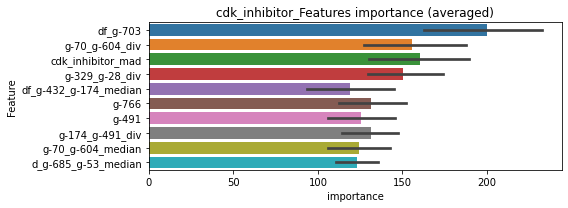

len(train_index) : 2219
len(valid_index) : 740
================================= fold 1/4 cdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0671697	valid_1's binary_logloss: 0.141379
[200]	training's binary_logloss: 0.0248245	valid_1's binary_logloss: 0.110476
[300]	training's binary_logloss: 0.0106409	valid_1's binary_logloss: 0.100597
[400]	training's binary_logloss: 0.00526122	valid_1's binary_logloss: 0.0991428
[500]	training's binary_logloss: 0.00290957	valid_1's binary_logloss: 0.0978309
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00211061	valid_1's binary_logloss: 0.0966244


len(train_index) : 2219
len(valid_index) : 740
================================= fold 2/4 cdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.069427	valid_1's binary_logloss: 0.123537
[200]	training's binary_logloss: 0.0258151	valid_1's binary_logloss: 0.092916
[300]	training's binary_logloss: 0.0109482	valid_1's binary_logloss: 0.0819184
[400]	training's binary_logloss: 0.00527371	valid_1's binary_logloss: 0.0770131
[500]	training's binary_logloss: 0.00293655	valid_1's binary_logloss: 0.0747025
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00302898	valid_1's binary_logloss: 0.0745948


len(train_index) : 2219
len(valid_index) : 740
================================= fold 3/4 cdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0711293	valid_1's binary_logloss: 0.121296
[200]	training's binary_logloss: 0.0270522	valid_1's binary_logloss: 0.0811472
[300]	training's binary_logloss: 0.0116204	valid_1's binary_logloss: 0.062824
[400]	training's binary_logloss: 0.00565897	valid_1's binary_logloss: 0.0553555
[500]	training's binary_logloss: 0.00320993	valid_1's binary_logloss: 0.0492838
[600]	training's binary_logloss: 0.00207628	valid_1's binary_logloss: 0.0460771
[700]	training's binary_logloss: 0.00149424	valid_1's binary_logloss: 0.0441189
[800]	training's binary_logloss: 0.00117583	valid_1's binary_logloss: 0.0435553
Early stopping, best iteration is:
[832]	training's binary_logloss: 0.00110093	valid_1's binary_logloss: 0.0426257


len(train_index) : 2220
len(valid_index) : 739
================================= fold 4/4 cdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0691185	valid_1's binary_logloss: 0.130613
[200]	training's binary_logloss: 0.0252937	valid_1's binary_logloss: 0.0939948
[300]	training's binary_logloss: 0.0107943	valid_1's binary_logloss: 0.077203
[400]	training's binary_logloss: 0.00516955	valid_1's binary_logloss: 0.0699244
[500]	training's binary_logloss: 0.00290223	valid_1's binary_logloss: 0.0653432
[600]	training's binary_logloss: 0.00187187	valid_1's binary_logloss: 0.0642947
[700]	training's binary_logloss: 0.0013589	valid_1's binary_logloss: 0.063361
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00116433	valid_1's binary_logloss: 0.0626777


cdk_inhibitor logloss: 0.06913282551827798
chelating_agent, len(trt): 54, len(othr): 3282, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12647	valid_1's binary_logloss: 0.18917
[200]	training's binary_logloss: 0.05246	valid_1's binary_logloss: 0.11596
[300]	training's binary_logloss: 0.0245494	valid_1's binary_logloss: 0.0845864
[400]	training's binary_logloss: 0.011856	valid_1's binary_logloss: 0.0680993
[500]	training's binary_logloss: 0.00607052	valid_1's binary_logloss: 0.0576159
[600]	training's binary_logloss: 0.00346854	valid_1's binary_logloss: 0.0512098
[700]	training's binary_logloss: 0.00225365	valid_1's binary_logloss: 0.0487885
[800]	training's binary_logloss: 0.00161349	valid_1's binary_logloss: 0.0470364
Early stopping, best iteration is:
[786]	training's binary_logloss: 0.00167756	valid_1's binary_logloss: 0.0468967
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129831	valid_1's binary_logloss: 0.167744
[200]	training's binary_logloss: 0.0529972	valid_1's binary

1 / 3 AUC score:1.000
y_Threshold: 0.0210602, Threshold: 0.1047073, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.07330, conf_1:0.13612
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.1047073
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_2: 0.1347073
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_3: 0.1647073
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_4: 0.1947073
threshold: 0.1947073, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12132	valid_1's binary_logloss: 0.183001
[200]	training's binary_logloss: 0.0464528	valid_1's binary_logloss: 0.106064
[300]	training's binary_logloss: 0.0205435	valid_1's binary_logloss: 0.0737286
[400]	training's binary_logloss: 0.00946529	valid_1's binary_logloss: 0.0554838
[500]	training's binary_logloss: 0.00480564	valid_1's binary_logloss: 0.0450782
[600]	training's binary_logloss: 0.00281881	valid_1's binary_logloss: 0.0405568
[700]	training's binary_logloss: 0.00188201	valid_1's binary_logloss: 0.0381132
[800]	training's binary_logloss: 0.00139126	valid_1's binary_logloss: 0.0369943
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.00130299	valid_1's binary_logloss: 0.0365141
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117269	valid_1's binary_logloss: 0.165391
[200]	training's binary_logloss: 0.0457054	valid_1's 

2 / 3 AUC score:1.000
y_Threshold: 0.1118224, Threshold: 0.1947073, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 648.0/3790
p_label_rate: 0.0135610 Vs.target_rate: 0.00227, Num_p_label: 54.0, conf_0:0.15577, conf_1:0.23365
Num_p_label: 54.0, Expected: 9.0, Adj_threshold_1: 0.1947073
Num_p_label: 48.0, Expected: 9.0, Adj_threshold_2: 0.2247073
Num_p_label: 41.0, Expected: 9.0, Adj_threshold_3: 0.2547073
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_4: 0.2847073
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_5: 0.3147073
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_6: 0.3447073
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_7: 0.3747073
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_8: 0.4047073
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_9: 0.4347073
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_10: 0.4647073
threshold: 0.4647073, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 648.0/3790, y_label_rate: 0.1709763
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119784	valid_1's binary_logloss: 0.173564
[200]	training's binary_logloss: 0.0450228	valid_1's binary_logloss: 0.0970713
[300]	training's binary_logloss: 0.0187691	valid_1's binary_logloss: 0.0664339
[400]	training's binary_logloss: 0.00848	valid_1's binary_logloss: 0.0515313
[500]	training's binary_logloss: 0.00441199	valid_1's binary_logloss: 0.0445113
[600]	training's binary_logloss: 0.00263612	valid_1's binary_logloss: 0.0416717
[700]	training's binary_logloss: 0.00178532	valid_1's binary_logloss: 0.0403008
Early stopping, best iteration is:
[683]	training's binary_logloss: 0.00189183	valid_1's binary_logloss: 0.0402161
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119532	valid_1's binary_logloss: 0.169182
[200]	training's binary_logloss: 0.0451331	valid_1's binary_logloss: 0.091855
[300]	training's binary_logloss: 0.0186895	valid_1's bin

3 / 3 AUC score:0.999
y_Threshold: 0.0851053, Threshold: 0.4647073, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 642.0/3778
p_label_rate: 0.0055249 Vs.target_rate: 0.00227, Num_p_label: 22.0, conf_0:0.41824, conf_1:0.51118
threshold: 0.4647073, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 642.0/3778, y_label_rate: 0.1699312


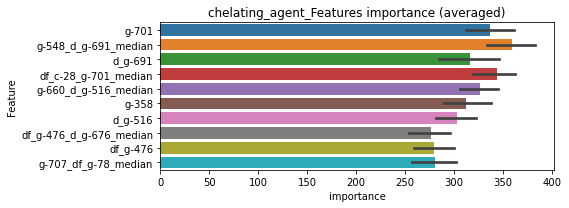

len(train_index) : 2833
len(valid_index) : 945
================================= fold 1/4 chelating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11612	valid_1's binary_logloss: 0.165576
[200]	training's binary_logloss: 0.0438715	valid_1's binary_logloss: 0.0880312
[300]	training's binary_logloss: 0.0185584	valid_1's binary_logloss: 0.0540487
[400]	training's binary_logloss: 0.00849366	valid_1's binary_logloss: 0.0375022
[500]	training's binary_logloss: 0.00437897	valid_1's binary_logloss: 0.0289459
[600]	training's binary_logloss: 0.00260005	valid_1's binary_logloss: 0.0242751
[700]	training's binary_logloss: 0.00175384	valid_1's binary_logloss: 0.021641
[800]	training's binary_logloss: 0.00131551	valid_1's binary_logloss: 0.0198176
[900]	training's binary_logloss: 0.0010599	valid_1's binary_logloss: 0.018864
[1000]	training's binary_logloss: 0.000907245	valid_1's binary_logloss: 0.0183125
Early stopping, best iteration is:
[1060]	training's binary_logloss: 0.000845889	valid_1's binary_logloss: 0.0180591


len(train_index) : 2833
len(valid_index) : 945
================================= fold 2/4 chelating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119555	valid_1's binary_logloss: 0.16993
[200]	training's binary_logloss: 0.0458274	valid_1's binary_logloss: 0.0921532
[300]	training's binary_logloss: 0.0197599	valid_1's binary_logloss: 0.0586489
[400]	training's binary_logloss: 0.00899204	valid_1's binary_logloss: 0.0416407
[500]	training's binary_logloss: 0.00457235	valid_1's binary_logloss: 0.0324707
[600]	training's binary_logloss: 0.00268786	valid_1's binary_logloss: 0.0275834
[700]	training's binary_logloss: 0.00179324	valid_1's binary_logloss: 0.0249109
[800]	training's binary_logloss: 0.00133321	valid_1's binary_logloss: 0.0230388
[900]	training's binary_logloss: 0.00106968	valid_1's binary_logloss: 0.0219651
[1000]	training's binary_logloss: 0.000916142	valid_1's binary_logloss: 0.0212688
[1100]	training's binary_logloss: 0.00083608	valid_1's binary_logloss: 0.0207412
Early stopping, best iteration is:
[1151]	training's binary_lo

len(train_index) : 2834
len(valid_index) : 944
================================= fold 3/4 chelating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118532	valid_1's binary_logloss: 0.162468
[200]	training's binary_logloss: 0.0471488	valid_1's binary_logloss: 0.0853768
[300]	training's binary_logloss: 0.0201999	valid_1's binary_logloss: 0.0516753
[400]	training's binary_logloss: 0.00919451	valid_1's binary_logloss: 0.0340374
[500]	training's binary_logloss: 0.00467433	valid_1's binary_logloss: 0.0254783
[600]	training's binary_logloss: 0.00275825	valid_1's binary_logloss: 0.0216099
[700]	training's binary_logloss: 0.00186132	valid_1's binary_logloss: 0.0193554
[800]	training's binary_logloss: 0.00137077	valid_1's binary_logloss: 0.0179349
[900]	training's binary_logloss: 0.00110145	valid_1's binary_logloss: 0.0172891
[1000]	training's binary_logloss: 0.00093278	valid_1's binary_logloss: 0.0169406
Early stopping, best iteration is:
[1064]	training's binary_logloss: 0.000863248	valid_1's binary_logloss: 0.0166365


len(train_index) : 2834
len(valid_index) : 944
================================= fold 4/4 chelating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118138	valid_1's binary_logloss: 0.165139
[200]	training's binary_logloss: 0.0461056	valid_1's binary_logloss: 0.0885544
[300]	training's binary_logloss: 0.0196276	valid_1's binary_logloss: 0.0559417
[400]	training's binary_logloss: 0.00902188	valid_1's binary_logloss: 0.0393559
[500]	training's binary_logloss: 0.00454442	valid_1's binary_logloss: 0.0301894
[600]	training's binary_logloss: 0.0026851	valid_1's binary_logloss: 0.0256686
[700]	training's binary_logloss: 0.00179641	valid_1's binary_logloss: 0.0230863
[800]	training's binary_logloss: 0.00133681	valid_1's binary_logloss: 0.0217375
[900]	training's binary_logloss: 0.00107662	valid_1's binary_logloss: 0.0206721
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.00107406	valid_1's binary_logloss: 0.0206604


chelating_agent logloss: 0.01897868781944698
chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885957	valid_1's binary_logloss: 0.116902
[200]	training's binary_logloss: 0.027298	valid_1's binary_logloss: 0.0499777
[300]	training's binary_logloss: 0.00949972	valid_1's binary_logloss: 0.0269415
[400]	training's binary_logloss: 0.00388449	valid_1's binary_logloss: 0.018031
[500]	training's binary_logloss: 0.00199511	valid_1's binary_logloss: 0.0137413
[600]	training's binary_logloss: 0.00126477	valid_1's binary_logloss: 0.0115917
[700]	training's binary_logloss: 0.000902793	valid_1's binary_logloss: 0.0102249
[800]	training's binary_logloss: 0.00071376	valid_1's binary_logloss: 0.009612
[900]	training's binary_logloss: 0.000605236	valid_1's binary_logloss: 0.00943403
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000597464	valid_1's binary_logloss: 0.00939716
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0867982	v

1 / 3 AUC score:1.000
y_Threshold: 0.0088407, Threshold: 0.0586606, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.04106, conf_1:0.07626
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0586606
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_2: 0.0886606
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_3: 0.1186606
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.1486606
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.1786606
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_6: 0.2086606
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.2386606
threshold: 0.2386606, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0817031	valid_1's binary_logloss: 0.104709
[200]	training's binary_logloss: 0.0232899	valid_1's binary_logloss: 0.0400366
[300]	training's binary_logloss: 0.0075989	valid_1's binary_logloss: 0.0191404
[400]	training's binary_logloss: 0.00316231	valid_1's binary_logloss: 0.0116128
[500]	training's binary_logloss: 0.00166377	valid_1's binary_logloss: 0.0083757
[600]	training's binary_logloss: 0.00106933	valid_1's binary_logloss: 0.00684391
[700]	training's binary_logloss: 0.000779188	valid_1's binary_logloss: 0.00606886
[800]	training's binary_logloss: 0.000613261	valid_1's binary_logloss: 0.00553934
[900]	training's binary_logloss: 0.000524724	valid_1's binary_logloss: 0.00526012
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000512284	valid_1's binary_logloss: 0.00520893
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.083

2 / 3 AUC score:1.000
y_Threshold: 0.1124631, Threshold: 0.2386606, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.19093, conf_1:0.28639
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.2386606
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_2: 0.2686606
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_3: 0.2986606
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_4: 0.3286606
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_5: 0.3586606
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_6: 0.3886606
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_7: 0.4186606
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_8: 0.4486606
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_9: 0.4786606
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_10: 0.5086606
threshold: 0.5386606, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0817031	valid_1's binary_logloss: 0.104709
[200]	training's binary_logloss: 0.0232899	valid_1's binary_logloss: 0.0400366
[300]	training's binary_logloss: 0.0075989	valid_1's binary_logloss: 0.0191404
[400]	training's binary_logloss: 0.00316231	valid_1's binary_logloss: 0.0116128
[500]	training's binary_logloss: 0.00166377	valid_1's binary_logloss: 0.0083757
[600]	training's binary_logloss: 0.00106933	valid_1's binary_logloss: 0.00684391
[700]	training's binary_logloss: 0.000779188	valid_1's binary_logloss: 0.00606886
[800]	training's binary_logloss: 0.000613261	valid_1's binary_logloss: 0.00553934
[900]	training's binary_logloss: 0.000524724	valid_1's binary_logloss: 0.00526012
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000512284	valid_1's binary_logloss: 0.00520893
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.083

3 / 3 AUC score:1.000
y_Threshold: 0.1124631, Threshold: 0.5386606, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.48479, conf_1:0.59253
threshold: 0.5386606, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


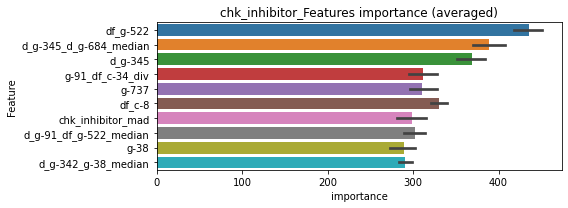

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 chk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0809974	valid_1's binary_logloss: 0.103353
[200]	training's binary_logloss: 0.0230983	valid_1's binary_logloss: 0.0389085
[300]	training's binary_logloss: 0.00759005	valid_1's binary_logloss: 0.0185297
[400]	training's binary_logloss: 0.00314527	valid_1's binary_logloss: 0.0109374
[500]	training's binary_logloss: 0.00165408	valid_1's binary_logloss: 0.00760789
[600]	training's binary_logloss: 0.00105785	valid_1's binary_logloss: 0.00624484
[700]	training's binary_logloss: 0.000768239	valid_1's binary_logloss: 0.00535418
[800]	training's binary_logloss: 0.000613369	valid_1's binary_logloss: 0.00496049
[900]	training's binary_logloss: 0.000532039	valid_1's binary_logloss: 0.00474892
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000514448	valid_1's binary_logloss: 0.00471731


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 chk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0824509	valid_1's binary_logloss: 0.100902
[200]	training's binary_logloss: 0.0233942	valid_1's binary_logloss: 0.0364748
[300]	training's binary_logloss: 0.00784698	valid_1's binary_logloss: 0.0164508
[400]	training's binary_logloss: 0.00322603	valid_1's binary_logloss: 0.00892085
[500]	training's binary_logloss: 0.00170047	valid_1's binary_logloss: 0.00595878
[600]	training's binary_logloss: 0.00108487	valid_1's binary_logloss: 0.00455868
[700]	training's binary_logloss: 0.000790024	valid_1's binary_logloss: 0.00379506
[800]	training's binary_logloss: 0.000625857	valid_1's binary_logloss: 0.00334429
[900]	training's binary_logloss: 0.000537345	valid_1's binary_logloss: 0.00307006
[1000]	training's binary_logloss: 0.000499314	valid_1's binary_logloss: 0.00296878
Early stopping, best iteration is:
[1051]	training's binary_logloss: 0.000489969	valid_1's binary_logloss: 0.00295145


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 chk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0820987	valid_1's binary_logloss: 0.103453
[200]	training's binary_logloss: 0.0236822	valid_1's binary_logloss: 0.0401307
[300]	training's binary_logloss: 0.00780429	valid_1's binary_logloss: 0.0185309
[400]	training's binary_logloss: 0.00321743	valid_1's binary_logloss: 0.0106209
[500]	training's binary_logloss: 0.00167474	valid_1's binary_logloss: 0.00745939
[600]	training's binary_logloss: 0.0010786	valid_1's binary_logloss: 0.00586036
[700]	training's binary_logloss: 0.000783291	valid_1's binary_logloss: 0.00486932
[800]	training's binary_logloss: 0.000622077	valid_1's binary_logloss: 0.00429786
[900]	training's binary_logloss: 0.000533002	valid_1's binary_logloss: 0.00397138
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.000509597	valid_1's binary_logloss: 0.0039321


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 chk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0810963	valid_1's binary_logloss: 0.106522
[200]	training's binary_logloss: 0.0228827	valid_1's binary_logloss: 0.0408315
[300]	training's binary_logloss: 0.00763178	valid_1's binary_logloss: 0.019127
[400]	training's binary_logloss: 0.0031021	valid_1's binary_logloss: 0.0111734
[500]	training's binary_logloss: 0.00163189	valid_1's binary_logloss: 0.00807005
[600]	training's binary_logloss: 0.0010412	valid_1's binary_logloss: 0.00657157
[700]	training's binary_logloss: 0.000753669	valid_1's binary_logloss: 0.00556723
[800]	training's binary_logloss: 0.000604716	valid_1's binary_logloss: 0.00513098
[900]	training's binary_logloss: 0.000520017	valid_1's binary_logloss: 0.00479331
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000517483	valid_1's binary_logloss: 0.00478787


chk_inhibitor logloss: 0.004098364254186227


neg labels: 3289 → selected neg labels: 3284


chloride_channel_blocker, len(trt): 42, len(othr): 3284, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100984	valid_1's binary_logloss: 0.13904
[200]	training's binary_logloss: 0.0395701	valid_1's binary_logloss: 0.0765024
[300]	training's binary_logloss: 0.0174544	valid_1's binary_logloss: 0.0498522
[400]	training's binary_logloss: 0.00780105	valid_1's binary_logloss: 0.0350752
[500]	training's binary_logloss: 0.00388898	valid_1's binary_logloss: 0.027727
[600]	training's binary_logloss: 0.00226485	valid_1's binary_logloss: 0.023666
[700]	training's binary_logloss: 0.00152103	valid_1's binary_logloss: 0.0214073
[800]	training's binary_logloss: 0.0011282	valid_1's binary_logloss: 0.019701
[900]	training's binary_logloss: 0.000919113	valid_1's binary_logloss: 0.0191653
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.000852164	valid_1's binary_logloss: 0.0189365
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102047	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0184837, Threshold: 0.1136031, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.07952, conf_1:0.14768
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.1136031
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_2: 0.1436031
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_3: 0.1736031
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_4: 0.2036031
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_5: 0.2336031
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_6: 0.2636031
threshold: 0.2636031, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100277	valid_1's binary_logloss: 0.127559
[200]	training's binary_logloss: 0.0355057	valid_1's binary_logloss: 0.0619338
[300]	training's binary_logloss: 0.0143596	valid_1's binary_logloss: 0.0359821
[400]	training's binary_logloss: 0.00624635	valid_1's binary_logloss: 0.0233331
[500]	training's binary_logloss: 0.00309835	valid_1's binary_logloss: 0.0172827
[600]	training's binary_logloss: 0.00184559	valid_1's binary_logloss: 0.0139675
[700]	training's binary_logloss: 0.001263	valid_1's binary_logloss: 0.012508
[800]	training's binary_logloss: 0.000966211	valid_1's binary_logloss: 0.0116031
[900]	training's binary_logloss: 0.000790345	valid_1's binary_logloss: 0.0110798
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000733242	valid_1's binary_logloss: 0.0108508
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958758	valid

2 / 3 AUC score:1.000
y_Threshold: 0.1185331, Threshold: 0.2636031, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 647.0/3790
p_label_rate: 0.0107986 Vs.target_rate: 0.00176, Num_p_label: 43.0, conf_0:0.21088, conf_1:0.31632
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_1: 0.2636031
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_2: 0.2936031
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_3: 0.3236031
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_4: 0.3536031
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_5: 0.3836031
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_6: 0.4136031
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_7: 0.4436031
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_8: 0.4736031
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_9: 0.5036031
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_10: 0.5336031
threshold: 0.5336031, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 647.0/3790, y_label_rate: 0.1707124
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0972243	valid_1's binary_logloss: 0.129897
[200]	training's binary_logloss: 0.0353191	valid_1's binary_logloss: 0.0658296
[300]	training's binary_logloss: 0.014506	valid_1's binary_logloss: 0.039858
[400]	training's binary_logloss: 0.00611308	valid_1's binary_logloss: 0.0261923
[500]	training's binary_logloss: 0.00303038	valid_1's binary_logloss: 0.0192644
[600]	training's binary_logloss: 0.00179735	valid_1's binary_logloss: 0.0157313
[700]	training's binary_logloss: 0.00124518	valid_1's binary_logloss: 0.0140209
[800]	training's binary_logloss: 0.000942915	valid_1's binary_logloss: 0.0127978
[900]	training's binary_logloss: 0.000780524	valid_1's binary_logloss: 0.0123628
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.000748627	valid_1's binary_logloss: 0.0121879
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968462	val

3 / 3 AUC score:1.000
y_Threshold: 0.1119241, Threshold: 0.5336031, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 644.0/3784
p_label_rate: 0.0055249 Vs.target_rate: 0.00176, Num_p_label: 22.0, conf_0:0.48024, conf_1:0.58696
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_1: 0.5336031
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_2: 0.5636031
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_3: 0.5936031
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_4: 0.6236031
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_5: 0.6536031
threshold: 0.6536031, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 644.0/3784, y_label_rate: 0.1701903


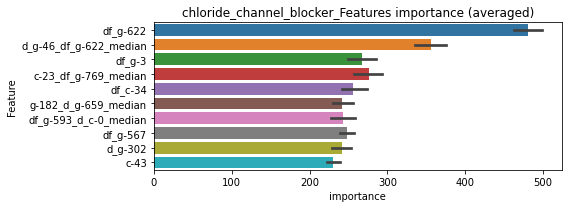

len(train_index) : 2838
len(valid_index) : 946
================================= fold 1/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959619	valid_1's binary_logloss: 0.122154
[200]	training's binary_logloss: 0.0342335	valid_1's binary_logloss: 0.0561991
[300]	training's binary_logloss: 0.0142843	valid_1's binary_logloss: 0.0317281
[400]	training's binary_logloss: 0.00601935	valid_1's binary_logloss: 0.0191004
[500]	training's binary_logloss: 0.0029976	valid_1's binary_logloss: 0.0129337
[600]	training's binary_logloss: 0.00178228	valid_1's binary_logloss: 0.00987406
[700]	training's binary_logloss: 0.00122966	valid_1's binary_logloss: 0.00814069
[800]	training's binary_logloss: 0.000934204	valid_1's binary_logloss: 0.00708081
[900]	training's binary_logloss: 0.00076884	valid_1's binary_logloss: 0.00640071
[1000]	training's binary_logloss: 0.000683496	valid_1's binary_logloss: 0.00615179
Early stopping, best iteration is:
[1048]	training's binary_logloss: 0.000664436	valid_1's binary_logloss: 0.0061059


len(train_index) : 2838
len(valid_index) : 946
================================= fold 2/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968506	valid_1's binary_logloss: 0.130907
[200]	training's binary_logloss: 0.0337456	valid_1's binary_logloss: 0.0633765
[300]	training's binary_logloss: 0.0131588	valid_1's binary_logloss: 0.0349519
[400]	training's binary_logloss: 0.00561301	valid_1's binary_logloss: 0.0220961
[500]	training's binary_logloss: 0.00283006	valid_1's binary_logloss: 0.0159969
[600]	training's binary_logloss: 0.00171509	valid_1's binary_logloss: 0.0129682
[700]	training's binary_logloss: 0.00119712	valid_1's binary_logloss: 0.0114721
[800]	training's binary_logloss: 0.000911912	valid_1's binary_logloss: 0.0105298
[900]	training's binary_logloss: 0.000757421	valid_1's binary_logloss: 0.00988129
[1000]	training's binary_logloss: 0.000681088	valid_1's binary_logloss: 0.00970892
Early stopping, best iteration is:
[993]	training's binary_logloss: 0.000685584	valid_1's binary_logloss: 0.00968195


len(train_index) : 2838
len(valid_index) : 946
================================= fold 3/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0967359	valid_1's binary_logloss: 0.12302
[200]	training's binary_logloss: 0.0325878	valid_1's binary_logloss: 0.0546102
[300]	training's binary_logloss: 0.0129678	valid_1's binary_logloss: 0.0300432
[400]	training's binary_logloss: 0.00565327	valid_1's binary_logloss: 0.0188863
[500]	training's binary_logloss: 0.00285812	valid_1's binary_logloss: 0.0135485
[600]	training's binary_logloss: 0.00173028	valid_1's binary_logloss: 0.010882
[700]	training's binary_logloss: 0.00120348	valid_1's binary_logloss: 0.00912684
[800]	training's binary_logloss: 0.000917815	valid_1's binary_logloss: 0.00820799
[900]	training's binary_logloss: 0.000763361	valid_1's binary_logloss: 0.00756173
[1000]	training's binary_logloss: 0.000688214	valid_1's binary_logloss: 0.00725931
Early stopping, best iteration is:
[1060]	training's binary_logloss: 0.000666622	valid_1's binary_logloss: 0.00721341


len(train_index) : 2838
len(valid_index) : 946
================================= fold 4/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0956586	valid_1's binary_logloss: 0.136849
[200]	training's binary_logloss: 0.0338209	valid_1's binary_logloss: 0.0695472
[300]	training's binary_logloss: 0.0129726	valid_1's binary_logloss: 0.0411729
[400]	training's binary_logloss: 0.00557204	valid_1's binary_logloss: 0.0294829
[500]	training's binary_logloss: 0.0028076	valid_1's binary_logloss: 0.0230409
[600]	training's binary_logloss: 0.00170877	valid_1's binary_logloss: 0.0204019
[700]	training's binary_logloss: 0.00118893	valid_1's binary_logloss: 0.0187791
[800]	training's binary_logloss: 0.000909765	valid_1's binary_logloss: 0.0179599
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.000807334	valid_1's binary_logloss: 0.0173173


chloride_channel_blocker logloss: 0.01008061531921463
cholesterol_inhibitor, len(trt): 48, len(othr): 3288, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111963	valid_1's binary_logloss: 0.164862
[200]	training's binary_logloss: 0.0440367	valid_1's binary_logloss: 0.0907966
[300]	training's binary_logloss: 0.0187134	valid_1's binary_logloss: 0.0566049
[400]	training's binary_logloss: 0.00840023	valid_1's binary_logloss: 0.0392748
[500]	training's binary_logloss: 0.00430262	valid_1's binary_logloss: 0.0308153
[600]	training's binary_logloss: 0.00251596	valid_1's binary_logloss: 0.0259251
[700]	training's binary_logloss: 0.00169933	valid_1's binary_logloss: 0.0236474
[800]	training's binary_logloss: 0.00126159	valid_1's binary_logloss: 0.0222907
[900]	training's binary_logloss: 0.00100762	valid_1's binary_logloss: 0.0216209
[1000]	training's binary_logloss: 0.000858749	valid_1's binary_logloss: 0.0208844
[1100]	training's binary_logloss: 0.000774332	valid_1's binary_logloss: 0.0207445
Early stopping, best iteration is:
[1165]	training's binary_

1 / 3 AUC score:0.999
y_Threshold: 0.0200716, Threshold: 0.0825587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.05779, conf_1:0.10733
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0825587
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.1125587
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_3: 0.1425587
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_4: 0.1725587
threshold: 0.1725587, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103465	valid_1's binary_logloss: 0.150621
[200]	training's binary_logloss: 0.0364921	valid_1's binary_logloss: 0.0814699
[300]	training's binary_logloss: 0.0144298	valid_1's binary_logloss: 0.0510079
[400]	training's binary_logloss: 0.00629143	valid_1's binary_logloss: 0.0363919
[500]	training's binary_logloss: 0.00325149	valid_1's binary_logloss: 0.0289918
[600]	training's binary_logloss: 0.00197854	valid_1's binary_logloss: 0.0247243
[700]	training's binary_logloss: 0.00136389	valid_1's binary_logloss: 0.0221614
[800]	training's binary_logloss: 0.00103885	valid_1's binary_logloss: 0.0210948
[900]	training's binary_logloss: 0.000846486	valid_1's binary_logloss: 0.0203115
[1000]	training's binary_logloss: 0.00073295	valid_1's binary_logloss: 0.0198619
Early stopping, best iteration is:
[1008]	training's binary_logloss: 0.000725677	valid_1's binary_logloss: 0.0197565
Training until validation

2 / 3 AUC score:1.000
y_Threshold: 0.1905681, Threshold: 0.1725587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 650.0/3799
p_label_rate: 0.0138122 Vs.target_rate: 0.00202, Num_p_label: 55.0, conf_0:0.13805, conf_1:0.20707
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_1: 0.1725587
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_2: 0.2025587
Num_p_label: 45.0, Expected: 8.0, Adj_threshold_3: 0.2325587
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_4: 0.2625587
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_5: 0.2925587
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_6: 0.3225587
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_7: 0.3525587
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_8: 0.3825587
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_9: 0.4125587
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_10: 0.4425587
threshold: 0.4725587, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 650.0/3799, y_label_rate: 0.1710977
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101353	valid_1's binary_logloss: 0.150785
[200]	training's binary_logloss: 0.03556	valid_1's binary_logloss: 0.0840498
[300]	training's binary_logloss: 0.0139619	valid_1's binary_logloss: 0.0572924
[400]	training's binary_logloss: 0.00610294	valid_1's binary_logloss: 0.046934
[500]	training's binary_logloss: 0.00312442	valid_1's binary_logloss: 0.0420657
[600]	training's binary_logloss: 0.00189834	valid_1's binary_logloss: 0.0407489
[700]	training's binary_logloss: 0.00132092	valid_1's binary_logloss: 0.0397766
[800]	training's binary_logloss: 0.00101086	valid_1's binary_logloss: 0.039092
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.000925228	valid_1's binary_logloss: 0.0385657
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102606	valid_1's binary_logloss: 0.149809
[200]	training's binary_logloss: 0.0364816	valid_1's b

3 / 3 AUC score:0.999
y_Threshold: 0.1391802, Threshold: 0.4725587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 641.0/3781
p_label_rate: 0.0070316 Vs.target_rate: 0.00202, Num_p_label: 28.0, conf_0:0.42530, conf_1:0.51981
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_1: 0.4725587
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.5025587
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_3: 0.5325587
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_4: 0.5625587
threshold: 0.5625587, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 641.0/3781, y_label_rate: 0.1695319


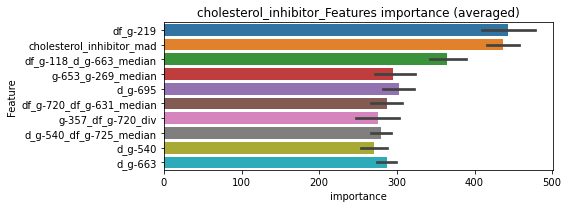

len(train_index) : 2835
len(valid_index) : 946
================================= fold 1/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0999949	valid_1's binary_logloss: 0.14597
[200]	training's binary_logloss: 0.0344379	valid_1's binary_logloss: 0.0763693
[300]	training's binary_logloss: 0.0135287	valid_1's binary_logloss: 0.0467978
[400]	training's binary_logloss: 0.0057962	valid_1's binary_logloss: 0.032684
[500]	training's binary_logloss: 0.00297733	valid_1's binary_logloss: 0.026118
[600]	training's binary_logloss: 0.00181868	valid_1's binary_logloss: 0.0228081
[700]	training's binary_logloss: 0.00126061	valid_1's binary_logloss: 0.0211149
[800]	training's binary_logloss: 0.000961152	valid_1's binary_logloss: 0.0200466
[900]	training's binary_logloss: 0.000791926	valid_1's binary_logloss: 0.0193233
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000785878	valid_1's binary_logloss: 0.0192773


len(train_index) : 2836
len(valid_index) : 945
================================= fold 2/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102258	valid_1's binary_logloss: 0.136962
[200]	training's binary_logloss: 0.0352533	valid_1's binary_logloss: 0.0651585
[300]	training's binary_logloss: 0.0141076	valid_1's binary_logloss: 0.0362941
[400]	training's binary_logloss: 0.00625644	valid_1's binary_logloss: 0.0237336
[500]	training's binary_logloss: 0.00318695	valid_1's binary_logloss: 0.0167269
[600]	training's binary_logloss: 0.00191647	valid_1's binary_logloss: 0.013904
[700]	training's binary_logloss: 0.00132801	valid_1's binary_logloss: 0.0119894
[800]	training's binary_logloss: 0.00101601	valid_1's binary_logloss: 0.0111371
[900]	training's binary_logloss: 0.000831027	valid_1's binary_logloss: 0.0103142
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000804925	valid_1's binary_logloss: 0.0101994


len(train_index) : 2836
len(valid_index) : 945
================================= fold 3/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0987052	valid_1's binary_logloss: 0.15022
[200]	training's binary_logloss: 0.0332902	valid_1's binary_logloss: 0.080277
[300]	training's binary_logloss: 0.012822	valid_1's binary_logloss: 0.05168
[400]	training's binary_logloss: 0.00573472	valid_1's binary_logloss: 0.0377454
[500]	training's binary_logloss: 0.00294365	valid_1's binary_logloss: 0.0303705
[600]	training's binary_logloss: 0.00180663	valid_1's binary_logloss: 0.0265594
[700]	training's binary_logloss: 0.00125454	valid_1's binary_logloss: 0.0244957
[800]	training's binary_logloss: 0.000954655	valid_1's binary_logloss: 0.0237227
[900]	training's binary_logloss: 0.00078208	valid_1's binary_logloss: 0.0226557
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.000756569	valid_1's binary_logloss: 0.0224464


len(train_index) : 2836
len(valid_index) : 945
================================= fold 4/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101222	valid_1's binary_logloss: 0.128981
[200]	training's binary_logloss: 0.0348398	valid_1's binary_logloss: 0.0590681
[300]	training's binary_logloss: 0.0140556	valid_1's binary_logloss: 0.032811
[400]	training's binary_logloss: 0.00620897	valid_1's binary_logloss: 0.019843
[500]	training's binary_logloss: 0.00316343	valid_1's binary_logloss: 0.0133539
[600]	training's binary_logloss: 0.00192057	valid_1's binary_logloss: 0.0102254
[700]	training's binary_logloss: 0.0013212	valid_1's binary_logloss: 0.00849012
[800]	training's binary_logloss: 0.00100364	valid_1's binary_logloss: 0.00733937
[900]	training's binary_logloss: 0.000822394	valid_1's binary_logloss: 0.00668997
[1000]	training's binary_logloss: 0.000721895	valid_1's binary_logloss: 0.00630911
[1100]	training's binary_logloss: 0.000670852	valid_1's binary_logloss: 0.00608097
[1200]	training's binary_logloss: 0.000645788	valid_1's b

cholesterol_inhibitor logloss: 0.014470381011349637


neg labels: 3289 → selected neg labels: 3281


cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129559	valid_1's binary_logloss: 0.193515
[200]	training's binary_logloss: 0.053947	valid_1's binary_logloss: 0.121026
[300]	training's binary_logloss: 0.0239362	valid_1's binary_logloss: 0.0867278
[400]	training's binary_logloss: 0.0113245	valid_1's binary_logloss: 0.0694913
[500]	training's binary_logloss: 0.00581178	valid_1's binary_logloss: 0.0619091
[600]	training's binary_logloss: 0.00341915	valid_1's binary_logloss: 0.0584363
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00300537	valid_1's binary_logloss: 0.0570353
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129717	valid_1's binary_logloss: 0.184718
[200]	training's binary_logloss: 0.0543781	valid_1's binary_logloss: 0.112857
[300]	training's binary_logloss: 0.0251768	valid_1's binary_logloss: 0.0790841
[400]	training's binary_logloss: 0.0117234	valid_1's bina

1 / 3 AUC score:0.997
y_Threshold: 0.0273382, Threshold: 0.1177379, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.08242, conf_1:0.15306
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.1177379
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_2: 0.1477379
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_3: 0.1777379
threshold: 0.1777379, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120472	valid_1's binary_logloss: 0.168683
[200]	training's binary_logloss: 0.0465692	valid_1's binary_logloss: 0.0895331
[300]	training's binary_logloss: 0.0201688	valid_1's binary_logloss: 0.0545274
[400]	training's binary_logloss: 0.00938703	valid_1's binary_logloss: 0.0363502
[500]	training's binary_logloss: 0.00478095	valid_1's binary_logloss: 0.0266718
[600]	training's binary_logloss: 0.00281504	valid_1's binary_logloss: 0.0215658
[700]	training's binary_logloss: 0.00189904	valid_1's binary_logloss: 0.0185035
[800]	training's binary_logloss: 0.00140795	valid_1's binary_logloss: 0.0167431
[900]	training's binary_logloss: 0.00111978	valid_1's binary_logloss: 0.0156359
[1000]	training's binary_logloss: 0.000943679	valid_1's binary_logloss: 0.0148291
[1100]	training's binary_logloss: 0.000840409	valid_1's binary_logloss: 0.0142498
[1200]	training's binary_logloss: 0.000786029	valid_1's bina

2 / 3 AUC score:1.000
y_Threshold: 0.1273200, Threshold: 0.1777379, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 640.0/3773
p_label_rate: 0.0193370 Vs.target_rate: 0.00227, Num_p_label: 77.0, conf_0:0.14219, conf_1:0.21329
Num_p_label: 77.0, Expected: 9.0, Adj_threshold_1: 0.1777379
Num_p_label: 60.0, Expected: 9.0, Adj_threshold_2: 0.2077379
Num_p_label: 55.0, Expected: 9.0, Adj_threshold_3: 0.2377379
Num_p_label: 49.0, Expected: 9.0, Adj_threshold_4: 0.2677379
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_5: 0.2977379
Num_p_label: 32.0, Expected: 9.0, Adj_threshold_6: 0.3277379
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_7: 0.3577379
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_8: 0.3877379
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_9: 0.4177379
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_10: 0.4477379
threshold: 0.4477379, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 640.0/3773, y_label_rate: 0.1696263
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117992	valid_1's binary_logloss: 0.170546
[200]	training's binary_logloss: 0.0441883	valid_1's binary_logloss: 0.100211
[300]	training's binary_logloss: 0.0182476	valid_1's binary_logloss: 0.068676
[400]	training's binary_logloss: 0.0081599	valid_1's binary_logloss: 0.0533879
[500]	training's binary_logloss: 0.0042517	valid_1's binary_logloss: 0.0470098
[600]	training's binary_logloss: 0.00255007	valid_1's binary_logloss: 0.0433903
[700]	training's binary_logloss: 0.00174663	valid_1's binary_logloss: 0.0419793
[800]	training's binary_logloss: 0.00130959	valid_1's binary_logloss: 0.0413474
[900]	training's binary_logloss: 0.00104796	valid_1's binary_logloss: 0.0408204
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000999025	valid_1's binary_logloss: 0.0405319
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114787	valid_1's

3 / 3 AUC score:0.998
y_Threshold: 0.1002075, Threshold: 0.4477379, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 630.0/3753
p_label_rate: 0.0072828 Vs.target_rate: 0.00227, Num_p_label: 29.0, conf_0:0.40296, conf_1:0.49251
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_1: 0.4477379
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_2: 0.4777379
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_3: 0.5077379
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_4: 0.5377379
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_5: 0.5677379
threshold: 0.5677379, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 630.0/3753, y_label_rate: 0.1678657


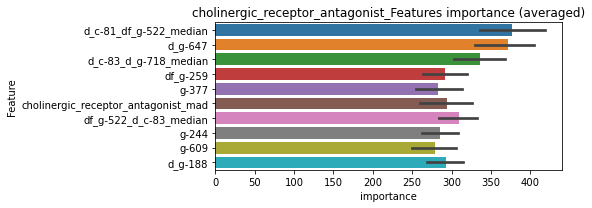

len(train_index) : 2814
len(valid_index) : 939
================================= fold 1/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113553	valid_1's binary_logloss: 0.167575
[200]	training's binary_logloss: 0.0416596	valid_1's binary_logloss: 0.0920444
[300]	training's binary_logloss: 0.0172075	valid_1's binary_logloss: 0.0590881
[400]	training's binary_logloss: 0.00773202	valid_1's binary_logloss: 0.0430018
[500]	training's binary_logloss: 0.00398657	valid_1's binary_logloss: 0.0349727
[600]	training's binary_logloss: 0.00241431	valid_1's binary_logloss: 0.0306834
[700]	training's binary_logloss: 0.0016531	valid_1's binary_logloss: 0.0279233
[800]	training's binary_logloss: 0.00124147	valid_1's binary_logloss: 0.0266788
[900]	training's binary_logloss: 0.00100197	valid_1's binary_logloss: 0.0258105
[1000]	training's binary_logloss: 0.000858169	valid_1's binary_logloss: 0.0249917
Early stopping, best iteration is:
[1032]	training's binary_logloss: 0.000824318	valid_1's binary_logloss: 0.0246761


len(train_index) : 2815
len(valid_index) : 938
================================= fold 2/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114422	valid_1's binary_logloss: 0.162819
[200]	training's binary_logloss: 0.0432341	valid_1's binary_logloss: 0.0873557
[300]	training's binary_logloss: 0.0179358	valid_1's binary_logloss: 0.053793
[400]	training's binary_logloss: 0.0081176	valid_1's binary_logloss: 0.0383875
[500]	training's binary_logloss: 0.004114	valid_1's binary_logloss: 0.0299153
[600]	training's binary_logloss: 0.00245572	valid_1's binary_logloss: 0.0258793
[700]	training's binary_logloss: 0.00167234	valid_1's binary_logloss: 0.0232672
[800]	training's binary_logloss: 0.00125626	valid_1's binary_logloss: 0.0222566
[900]	training's binary_logloss: 0.00101423	valid_1's binary_logloss: 0.0212657
[1000]	training's binary_logloss: 0.00086537	valid_1's binary_logloss: 0.0208501
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000819578	valid_1's binary_logloss: 0.0206394


len(train_index) : 2815
len(valid_index) : 938
================================= fold 3/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113297	valid_1's binary_logloss: 0.157142
[200]	training's binary_logloss: 0.0429388	valid_1's binary_logloss: 0.0832242
[300]	training's binary_logloss: 0.01773	valid_1's binary_logloss: 0.0511843
[400]	training's binary_logloss: 0.00801391	valid_1's binary_logloss: 0.0356013
[500]	training's binary_logloss: 0.00409101	valid_1's binary_logloss: 0.0274548
[600]	training's binary_logloss: 0.00245795	valid_1's binary_logloss: 0.0236821
[700]	training's binary_logloss: 0.00167843	valid_1's binary_logloss: 0.0215154
[800]	training's binary_logloss: 0.00126485	valid_1's binary_logloss: 0.0198881
[900]	training's binary_logloss: 0.00101714	valid_1's binary_logloss: 0.0189384
[1000]	training's binary_logloss: 0.000867764	valid_1's binary_logloss: 0.0182593
[1100]	training's binary_logloss: 0.000778499	valid_1's binary_logloss: 0.0179662
Early stopping, best iteration is:
[1100]	training's binary_lo

len(train_index) : 2815
len(valid_index) : 938
================================= fold 4/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112379	valid_1's binary_logloss: 0.164736
[200]	training's binary_logloss: 0.0419557	valid_1's binary_logloss: 0.0863156
[300]	training's binary_logloss: 0.0173062	valid_1's binary_logloss: 0.0518479
[400]	training's binary_logloss: 0.00779326	valid_1's binary_logloss: 0.0356956
[500]	training's binary_logloss: 0.00398624	valid_1's binary_logloss: 0.0275309
[600]	training's binary_logloss: 0.00240073	valid_1's binary_logloss: 0.0238553
[700]	training's binary_logloss: 0.00164056	valid_1's binary_logloss: 0.0214948
[800]	training's binary_logloss: 0.00124422	valid_1's binary_logloss: 0.0200854
[900]	training's binary_logloss: 0.00100291	valid_1's binary_logloss: 0.0192094
[1000]	training's binary_logloss: 0.000858721	valid_1's binary_logloss: 0.0186854
Early stopping, best iteration is:
[1065]	training's binary_logloss: 0.00079644	valid_1's binary_logloss: 0.0184521


cholinergic_receptor_antagonist logloss: 0.02043459870434702
coagulation_factor_inhibitor, len(trt): 24, len(othr): 3288, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0817571	valid_1's binary_logloss: 0.107149
[200]	training's binary_logloss: 0.0249708	valid_1's binary_logloss: 0.0416075
[300]	training's binary_logloss: 0.00856308	valid_1's binary_logloss: 0.0194366
[400]	training's binary_logloss: 0.00356534	valid_1's binary_logloss: 0.0112494
[500]	training's binary_logloss: 0.00184896	valid_1's binary_logloss: 0.00748497
[600]	training's binary_logloss: 0.00116678	valid_1's binary_logloss: 0.00585109
[700]	training's binary_logloss: 0.000845512	valid_1's binary_logloss: 0.00489489
[800]	training's binary_logloss: 0.0006681	valid_1's binary_logloss: 0.00435007
[900]	training's binary_logloss: 0.00057439	valid_1's binary_logloss: 0.00407415
[1000]	training's binary_logloss: 0.000534638	valid_1's binary_logloss: 0.00396789
Early stopping, best iteration is:
[1047]	training's binary_logloss: 0.000527123	valid_1's binary_logloss: 0.0039496
Training until va

1 / 3 AUC score:1.000
y_Threshold: 0.0073804, Threshold: 0.0458475, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.03209, conf_1:0.05960
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0458475
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.0758475
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_3: 0.1058475
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.1358475
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_5: 0.1658475
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_6: 0.1958475
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_7: 0.2258475
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_8: 0.2558475
threshold: 0.2558475, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.079367	valid_1's binary_logloss: 0.100928
[200]	training's binary_logloss: 0.0216232	valid_1's binary_logloss: 0.0357898
[300]	training's binary_logloss: 0.00724154	valid_1's binary_logloss: 0.0162053
[400]	training's binary_logloss: 0.00298516	valid_1's binary_logloss: 0.00876717
[500]	training's binary_logloss: 0.00157082	valid_1's binary_logloss: 0.00569235
[600]	training's binary_logloss: 0.00100942	valid_1's binary_logloss: 0.0043093
[700]	training's binary_logloss: 0.000738979	valid_1's binary_logloss: 0.00355392
[800]	training's binary_logloss: 0.000588717	valid_1's binary_logloss: 0.00309743
[900]	training's binary_logloss: 0.000508904	valid_1's binary_logloss: 0.00281909
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.000486092	valid_1's binary_logloss: 0.00275567
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

2 / 3 AUC score:1.000
y_Threshold: 0.1323802, Threshold: 0.2558475, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0055249 Vs.target_rate: 0.00101, Num_p_label: 22.0, conf_0:0.20468, conf_1:0.30702
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_1: 0.2558475
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.2858475
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_3: 0.3158475
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_4: 0.3458475
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_5: 0.3758475
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_6: 0.4058475
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_7: 0.4358475
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_8: 0.4658475
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_9: 0.4958475
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_10: 0.5258475
threshold: 0.5558475, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.079367	valid_1's binary_logloss: 0.100928
[200]	training's binary_logloss: 0.0216232	valid_1's binary_logloss: 0.0357898
[300]	training's binary_logloss: 0.00724154	valid_1's binary_logloss: 0.0162053
[400]	training's binary_logloss: 0.00298516	valid_1's binary_logloss: 0.00876717
[500]	training's binary_logloss: 0.00157082	valid_1's binary_logloss: 0.00569235
[600]	training's binary_logloss: 0.00100942	valid_1's binary_logloss: 0.0043093
[700]	training's binary_logloss: 0.000738979	valid_1's binary_logloss: 0.00355392
[800]	training's binary_logloss: 0.000588717	valid_1's binary_logloss: 0.00309743
[900]	training's binary_logloss: 0.000508904	valid_1's binary_logloss: 0.00281909
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.000486092	valid_1's binary_logloss: 0.00275567
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

3 / 3 AUC score:1.000
y_Threshold: 0.1323802, Threshold: 0.5558475, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00101, Num_p_label: 13.0, conf_0:0.50000, conf_1:0.61143
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.5558475
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.5858475
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.6158475
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.6458475
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_5: 0.6758475
threshold: 0.6758475, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


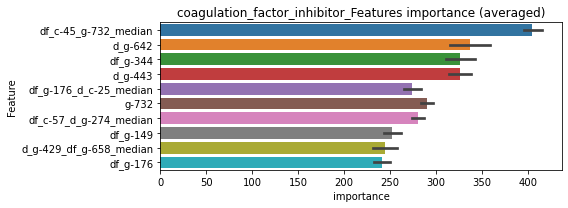

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0802144	valid_1's binary_logloss: 0.102723
[200]	training's binary_logloss: 0.022159	valid_1's binary_logloss: 0.037377
[300]	training's binary_logloss: 0.00734844	valid_1's binary_logloss: 0.0165607
[400]	training's binary_logloss: 0.00302889	valid_1's binary_logloss: 0.00898144
[500]	training's binary_logloss: 0.00159463	valid_1's binary_logloss: 0.00583739
[600]	training's binary_logloss: 0.00101645	valid_1's binary_logloss: 0.00434456
[700]	training's binary_logloss: 0.000735184	valid_1's binary_logloss: 0.00350416
[800]	training's binary_logloss: 0.000594282	valid_1's binary_logloss: 0.00309677
[900]	training's binary_logloss: 0.000519428	valid_1's binary_logloss: 0.00284715
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000502794	valid_1's binary_logloss: 0.00279964


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0810477	valid_1's binary_logloss: 0.0947471
[200]	training's binary_logloss: 0.0230016	valid_1's binary_logloss: 0.0342144
[300]	training's binary_logloss: 0.0076477	valid_1's binary_logloss: 0.0145193
[400]	training's binary_logloss: 0.0031107	valid_1's binary_logloss: 0.00721617
[500]	training's binary_logloss: 0.00163495	valid_1's binary_logloss: 0.00447799
[600]	training's binary_logloss: 0.00104849	valid_1's binary_logloss: 0.00320957
[700]	training's binary_logloss: 0.000756653	valid_1's binary_logloss: 0.00252042
[800]	training's binary_logloss: 0.000602015	valid_1's binary_logloss: 0.00212128
[900]	training's binary_logloss: 0.000523916	valid_1's binary_logloss: 0.00193211
[1000]	training's binary_logloss: 0.000498046	valid_1's binary_logloss: 0.00186347
Early stopping, best iteration is:
[982]	training's binary_logloss: 0.000498046	valid_1's binary_logloss: 0.00186347


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794893	valid_1's binary_logloss: 0.113904
[200]	training's binary_logloss: 0.0217783	valid_1's binary_logloss: 0.0440075
[300]	training's binary_logloss: 0.00720048	valid_1's binary_logloss: 0.0207133
[400]	training's binary_logloss: 0.00297441	valid_1's binary_logloss: 0.0121647
[500]	training's binary_logloss: 0.00156196	valid_1's binary_logloss: 0.00863025
[600]	training's binary_logloss: 0.00100336	valid_1's binary_logloss: 0.00696912
[700]	training's binary_logloss: 0.000724365	valid_1's binary_logloss: 0.00592053
[800]	training's binary_logloss: 0.000579342	valid_1's binary_logloss: 0.00533803
[900]	training's binary_logloss: 0.000508097	valid_1's binary_logloss: 0.00513718
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000486276	valid_1's binary_logloss: 0.00503874


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0796776	valid_1's binary_logloss: 0.102507
[200]	training's binary_logloss: 0.0220686	valid_1's binary_logloss: 0.0391438
[300]	training's binary_logloss: 0.0072946	valid_1's binary_logloss: 0.0191289
[400]	training's binary_logloss: 0.00302337	valid_1's binary_logloss: 0.0120316
[500]	training's binary_logloss: 0.00157799	valid_1's binary_logloss: 0.00893514
[600]	training's binary_logloss: 0.00100925	valid_1's binary_logloss: 0.00741901
[700]	training's binary_logloss: 0.00073484	valid_1's binary_logloss: 0.00672976
[800]	training's binary_logloss: 0.000583852	valid_1's binary_logloss: 0.00624885
[900]	training's binary_logloss: 0.000508898	valid_1's binary_logloss: 0.00606169
[1000]	training's binary_logloss: 0.000482535	valid_1's binary_logloss: 0.00592753
Early stopping, best iteration is:
[1047]	training's binary_logloss: 0.000479233	valid_1's binary_logloss: 0.00592139


coagulation_factor_inhibitor logloss: 0.003911566947219086
corticosteroid_agonist, len(trt): 36, len(othr): 3285, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958056	valid_1's binary_logloss: 0.137485
[200]	training's binary_logloss: 0.0341203	valid_1's binary_logloss: 0.0720347
[300]	training's binary_logloss: 0.0133899	valid_1's binary_logloss: 0.0435044
[400]	training's binary_logloss: 0.00577148	valid_1's binary_logloss: 0.0297802
[500]	training's binary_logloss: 0.00296405	valid_1's binary_logloss: 0.0229704
[600]	training's binary_logloss: 0.00179465	valid_1's binary_logloss: 0.0195407
[700]	training's binary_logloss: 0.00124954	valid_1's binary_logloss: 0.0176723
[800]	training's binary_logloss: 0.000956113	valid_1's binary_logloss: 0.0167311
[900]	training's binary_logloss: 0.000789764	valid_1's binary_logloss: 0.0162897
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.00080459	valid_1's binary_logloss: 0.0162724
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0978675	va

1 / 3 AUC score:0.999
y_Threshold: 0.0165003, Threshold: 0.0975866, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 655/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.06831, conf_1:0.12686
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0975866
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_2: 0.1275866
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.1575866
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.1875866
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_5: 0.2175866
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_6: 0.2475866
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.2775866
threshold: 0.2775866, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0930658	valid_1's binary_logloss: 0.128422
[200]	training's binary_logloss: 0.0299133	valid_1's binary_logloss: 0.0569992
[300]	training's binary_logloss: 0.0111203	valid_1's binary_logloss: 0.0297684
[400]	training's binary_logloss: 0.00468492	valid_1's binary_logloss: 0.0173716
[500]	training's binary_logloss: 0.00245051	valid_1's binary_logloss: 0.0122648
[600]	training's binary_logloss: 0.00152216	valid_1's binary_logloss: 0.0099291
[700]	training's binary_logloss: 0.00107204	valid_1's binary_logloss: 0.00852838
[800]	training's binary_logloss: 0.00083127	valid_1's binary_logloss: 0.00757932
[900]	training's binary_logloss: 0.000686275	valid_1's binary_logloss: 0.00706314
[1000]	training's binary_logloss: 0.00061803	valid_1's binary_logloss: 0.00676438
Early stopping, best iteration is:
[1064]	training's binary_logloss: 0.000588643	valid_1's binary_logloss: 0.00663372
Training until vali

2 / 3 AUC score:1.000
y_Threshold: 0.1899863, Threshold: 0.2775866, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0125565 Vs.target_rate: 0.00151, Num_p_label: 50.0, conf_0:0.22207, conf_1:0.33310
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_1: 0.2775866
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_2: 0.3075866
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_3: 0.3375866
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_4: 0.3675866
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_5: 0.3975866
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.4275866
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_7: 0.4575866
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_8: 0.4875866
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_9: 0.5175866
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_10: 0.5475866
threshold: 0.5775866, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 648.0/3792, y_label_rate: 0.1708861
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.090051	valid_1's binary_logloss: 0.127516
[200]	training's binary_logloss: 0.0289052	valid_1's binary_logloss: 0.0620328
[300]	training's binary_logloss: 0.0106722	valid_1's binary_logloss: 0.0370084
[400]	training's binary_logloss: 0.00454494	valid_1's binary_logloss: 0.0271564
[500]	training's binary_logloss: 0.0023321	valid_1's binary_logloss: 0.022671
[600]	training's binary_logloss: 0.0014375	valid_1's binary_logloss: 0.0210748
[700]	training's binary_logloss: 0.00101122	valid_1's binary_logloss: 0.0203005
Early stopping, best iteration is:
[763]	training's binary_logloss: 0.000852587	valid_1's binary_logloss: 0.0196097
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0904368	valid_1's binary_logloss: 0.123139
[200]	training's binary_logloss: 0.0291267	valid_1's binary_logloss: 0.0606356
[300]	training's binary_logloss: 0.0106672	valid_1's 

3 / 3 AUC score:1.000
y_Threshold: 0.2560224, Threshold: 0.5775866, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 645.0/3786
p_label_rate: 0.0097941 Vs.target_rate: 0.00151, Num_p_label: 39.0, conf_0:0.50000, conf_1:0.63535
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_1: 0.5775866
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.6075866
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_3: 0.6375866
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_4: 0.6675866
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_5: 0.6975866
threshold: 0.6975866, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 645.0/3786, y_label_rate: 0.1703645


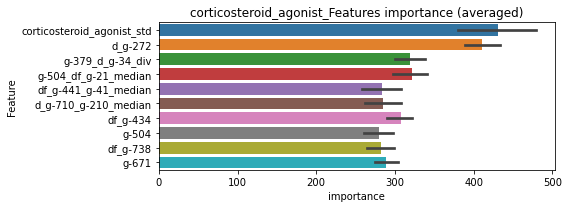

len(train_index) : 2839
len(valid_index) : 947
================================= fold 1/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.088781	valid_1's binary_logloss: 0.127394
[200]	training's binary_logloss: 0.027818	valid_1's binary_logloss: 0.05886
[300]	training's binary_logloss: 0.0102236	valid_1's binary_logloss: 0.0335608
[400]	training's binary_logloss: 0.00439049	valid_1's binary_logloss: 0.023039
[500]	training's binary_logloss: 0.00226414	valid_1's binary_logloss: 0.0178925
[600]	training's binary_logloss: 0.00140042	valid_1's binary_logloss: 0.0152027
[700]	training's binary_logloss: 0.000991609	valid_1's binary_logloss: 0.0136347
[800]	training's binary_logloss: 0.000774567	valid_1's binary_logloss: 0.0126864
[900]	training's binary_logloss: 0.000648813	valid_1's binary_logloss: 0.0121433
[1000]	training's binary_logloss: 0.000588499	valid_1's binary_logloss: 0.0120453
Early stopping, best iteration is:
[1022]	training's binary_logloss: 0.000578187	valid_1's binary_logloss: 0.0119306


len(train_index) : 2839
len(valid_index) : 947
================================= fold 2/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0908804	valid_1's binary_logloss: 0.113352
[200]	training's binary_logloss: 0.0292527	valid_1's binary_logloss: 0.0501775
[300]	training's binary_logloss: 0.0110299	valid_1's binary_logloss: 0.0294349
[400]	training's binary_logloss: 0.00463414	valid_1's binary_logloss: 0.0208047
[500]	training's binary_logloss: 0.00234492	valid_1's binary_logloss: 0.0171366
[600]	training's binary_logloss: 0.00144207	valid_1's binary_logloss: 0.0151229
[700]	training's binary_logloss: 0.00102596	valid_1's binary_logloss: 0.0141786
[800]	training's binary_logloss: 0.000794173	valid_1's binary_logloss: 0.0136568
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.000752572	valid_1's binary_logloss: 0.0134473


len(train_index) : 2840
len(valid_index) : 946
================================= fold 3/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0882013	valid_1's binary_logloss: 0.12598
[200]	training's binary_logloss: 0.0277438	valid_1's binary_logloss: 0.0612008
[300]	training's binary_logloss: 0.0103326	valid_1's binary_logloss: 0.0360837
[400]	training's binary_logloss: 0.00439624	valid_1's binary_logloss: 0.0255548
[500]	training's binary_logloss: 0.00223256	valid_1's binary_logloss: 0.0203943
[600]	training's binary_logloss: 0.00138733	valid_1's binary_logloss: 0.0175065
[700]	training's binary_logloss: 0.000985873	valid_1's binary_logloss: 0.0162638
[800]	training's binary_logloss: 0.000768316	valid_1's binary_logloss: 0.015463
[900]	training's binary_logloss: 0.000636772	valid_1's binary_logloss: 0.0147397
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000626913	valid_1's binary_logloss: 0.0146866


len(train_index) : 2840
len(valid_index) : 946
================================= fold 4/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0897193	valid_1's binary_logloss: 0.12319
[200]	training's binary_logloss: 0.0279233	valid_1's binary_logloss: 0.0563201
[300]	training's binary_logloss: 0.0101789	valid_1's binary_logloss: 0.031794
[400]	training's binary_logloss: 0.00436345	valid_1's binary_logloss: 0.0220019
[500]	training's binary_logloss: 0.00223858	valid_1's binary_logloss: 0.0164093
[600]	training's binary_logloss: 0.00139636	valid_1's binary_logloss: 0.0135751
[700]	training's binary_logloss: 0.000986452	valid_1's binary_logloss: 0.0119361
[800]	training's binary_logloss: 0.000773862	valid_1's binary_logloss: 0.0111711
[900]	training's binary_logloss: 0.000643891	valid_1's binary_logloss: 0.0102864
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00061811	valid_1's binary_logloss: 0.0101979


corticosteroid_agonist logloss: 0.012577943183446792
cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3235, target_rate: 0.0182666 → Adj_target_rate: 0.0146863


neg labels: 3289 → selected neg labels: 3235


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.281199	valid_1's binary_logloss: 0.414878
[200]	training's binary_logloss: 0.193391	valid_1's binary_logloss: 0.402097
[300]	training's binary_logloss: 0.138109	valid_1's binary_logloss: 0.39516
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.124398	valid_1's binary_logloss: 0.394518
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.288594	valid_1's binary_logloss: 0.415072
[200]	training's binary_logloss: 0.200031	valid_1's binary_logloss: 0.403032
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.159739	valid_1's binary_logloss: 0.398645
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.282301	valid_1's binary_logloss: 0.42135
[200]	training's binary_logloss: 0.196905	valid_1's binary_logloss: 0.412888
[300]	training's binary_logloss: 0.139513	valid_1's bina

1 / 3 AUC score:0.706
y_Threshold: 0.1716922, Threshold: 0.4269902, pos_neg_ratio: 0.8000000
Remove_noisy_data: 800 → Positive_corect_labels: 312/3082
p_label_rate: 0.0100452 Vs.target_rate: 0.01827, Num_p_label: 40.0, conf_0:0.29889, conf_1:0.55509
threshold: 0.4269902, positive_p_label: 40.0/3982, p_label_rate: 0.0100452


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.153551	valid_1's binary_logloss: 0.394168


positive_y_label: 312.0/3082, y_label_rate: 0.1012330
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114858	valid_1's binary_logloss: 0.206326
[200]	training's binary_logloss: 0.0544514	valid_1's binary_logloss: 0.177262
[300]	training's binary_logloss: 0.0282962	valid_1's binary_logloss: 0.16597
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0237631	valid_1's binary_logloss: 0.164534
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109456	valid_1's binary_logloss: 0.208316
[200]	training's binary_logloss: 0.0511077	valid_1's binary_logloss: 0.180148
[300]	training's binary_logloss: 0.0263865	valid_1's binary_logloss: 0.169823
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0234888	valid_1's binary_logloss: 0.168402
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113274	valid_1's binary_logloss: 0.204713
[200]	training's binary_logloss: 0.0530609	valid_

2 / 3 AUC score:0.937
y_Threshold: 0.1187764, Threshold: 0.4269902, pos_neg_ratio: 0.8000000
Remove_noisy_data: 176 → Positive_corect_labels: 224.0/2906
p_label_rate: 0.0406831 Vs.target_rate: 0.01827, Num_p_label: 162.0, conf_0:0.34159, conf_1:0.51239
threshold: 0.4269902, positive_p_label: 162.0/3982, p_label_rate: 0.0406831


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0253306	valid_1's binary_logloss: 0.180729


positive_y_label: 224.0/2906, y_label_rate: 0.0770819
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0661129	valid_1's binary_logloss: 0.122505
[200]	training's binary_logloss: 0.0254421	valid_1's binary_logloss: 0.0922841
[300]	training's binary_logloss: 0.0113099	valid_1's binary_logloss: 0.0821225
[400]	training's binary_logloss: 0.00560021	valid_1's binary_logloss: 0.0778633
[500]	training's binary_logloss: 0.00315641	valid_1's binary_logloss: 0.077214
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00367164	valid_1's binary_logloss: 0.0766348
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0637208	valid_1's binary_logloss: 0.140946
[200]	training's binary_logloss: 0.0249028	valid_1's binary_logloss: 0.128088
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0151704	valid_1's binary_logloss: 0.125277
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.065

3 / 3 AUC score:0.968
y_Threshold: 0.0952144, Threshold: 0.4269902, pos_neg_ratio: 0.8000000
Remove_noisy_data: 80 → Positive_corect_labels: 184.0/2826
p_label_rate: 0.0479658 Vs.target_rate: 0.01827, Num_p_label: 191.0, conf_0:0.38429, conf_1:0.46969
threshold: 0.4269902, positive_p_label: 191.0/3982, p_label_rate: 0.0479658


[300]	training's binary_logloss: 0.0109008	valid_1's binary_logloss: 0.122352
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0137174	valid_1's binary_logloss: 0.120964


positive_y_label: 184.0/2826, y_label_rate: 0.0651097


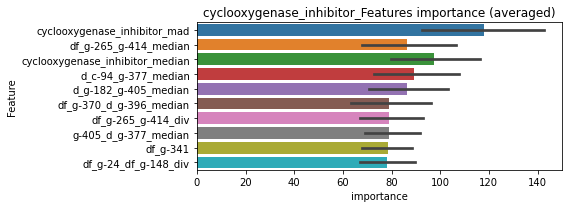

len(train_index) : 2119
len(valid_index) : 707
================================= fold 1/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0468261	valid_1's binary_logloss: 0.0959031
[200]	training's binary_logloss: 0.0160726	valid_1's binary_logloss: 0.0713333
[300]	training's binary_logloss: 0.00656069	valid_1's binary_logloss: 0.0643599


len(train_index) : 2119
len(valid_index) : 707
================================= fold 2/4 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00451294	valid_1's binary_logloss: 0.0617925
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0480517	valid_1's binary_logloss: 0.0803763
[200]	training's binary_logloss: 0.0167871	valid_1's binary_logloss: 0.055085
[300]	training's binary_logloss: 0.00707378	valid_1's binary_logloss: 0.0463756
[400]	training's binary_logloss: 0.00340996	valid_1's binary_logloss: 0.0422787
[500]	training's binary_logloss: 0.00195819	valid_1's binary_logloss: 0.0406806
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00198569	valid_1's binary_logloss: 0.0405299


len(train_index) : 2120
len(valid_index) : 706
================================= fold 3/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452829	valid_1's binary_logloss: 0.106131
[200]	training's binary_logloss: 0.0147146	valid_1's binary_logloss: 0.0857237


len(train_index) : 2120
len(valid_index) : 706
================================= fold 4/4 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00827391	valid_1's binary_logloss: 0.0816454
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0488882	valid_1's binary_logloss: 0.0934561
[200]	training's binary_logloss: 0.0179014	valid_1's binary_logloss: 0.0608361
[300]	training's binary_logloss: 0.00841196	valid_1's binary_logloss: 0.0475227
[400]	training's binary_logloss: 0.00499206	valid_1's binary_logloss: 0.0416868
[500]	training's binary_logloss: 0.00228712	valid_1's binary_logloss: 0.0356813
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00231313	valid_1's binary_logloss: 0.0356723


cyclooxygenase_inhibitor logloss: 0.054907366750372444
cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3273, target_rate: 0.0043672 → Adj_target_rate: 0.0043519


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.158355	valid_1's binary_logloss: 0.261129
[200]	training's binary_logloss: 0.0801522	valid_1's binary_logloss: 0.195763
[300]	training's binary_logloss: 0.0439636	valid_1's binary_logloss: 0.159548
[400]	training's binary_logloss: 0.0241744	valid_1's binary_logloss: 0.138067
[500]	training's binary_logloss: 0.0137369	valid_1's binary_logloss: 0.125775
[600]	training's binary_logloss: 0.00814252	valid_1's binary_logloss: 0.119817
[700]	training's binary_logloss: 0.00509443	valid_1's binary_logloss: 0.115871
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.00405803	valid_1's binary_logloss: 0.114613
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.160546	valid_1's binary_logloss: 0.257619
[200]	training's binary_logloss: 0.0842314	valid_1's binary_logloss: 0.198126
[300]	training's binary_logloss: 0.0462303	valid_1's binary_lo

1 / 3 AUC score:0.985
y_Threshold: 0.0449711, Threshold: 0.2513830, pos_neg_ratio: 0.8000000
Remove_noisy_data: 194 → Positive_corect_labels: 623/3733
p_label_rate: 0.0100452 Vs.target_rate: 0.00437, Num_p_label: 40.0, conf_0:0.17597, conf_1:0.32680
threshold: 0.2513830, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 623.0/3733, y_label_rate: 0.1668899
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138028	valid_1's binary_logloss: 0.235383
[200]	training's binary_logloss: 0.0636038	valid_1's binary_logloss: 0.184934
[300]	training's binary_logloss: 0.0314341	valid_1's binary_logloss: 0.157594
[400]	training's binary_logloss: 0.0165158	valid_1's binary_logloss: 0.149196
[500]	training's binary_logloss: 0.00896477	valid_1's binary_logloss: 0.144299
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00750924	valid_1's binary_logloss: 0.144193
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.140805	valid_1's binary_logloss: 0.212679
[200]	training's binary_logloss: 0.0650543	valid_1's binary_logloss: 0.147797
[300]	training's binary_logloss: 0.0335833	valid_1's binary_logloss: 0.116944
[400]	training's binary_logloss: 0.0177446	valid_1's binary_logloss: 0.0972863
[500]	training's binary_logloss: 0.00961263	valid_1's binary_l

2 / 3 AUC score:0.987
y_Threshold: 0.1042377, Threshold: 0.2513830, pos_neg_ratio: 0.8000000
Remove_noisy_data: 100 → Positive_corect_labels: 573.0/3633
p_label_rate: 0.0271220 Vs.target_rate: 0.00437, Num_p_label: 108.0, conf_0:0.20111, conf_1:0.30166
Num_p_label: 108.0, Expected: 17.4, Adj_threshold_1: 0.2513830
Num_p_label: 103.0, Expected: 17.4, Adj_threshold_2: 0.2813830
Num_p_label: 100.0, Expected: 17.4, Adj_threshold_3: 0.3113830
Num_p_label: 94.0, Expected: 17.4, Adj_threshold_4: 0.3413830
Num_p_label: 89.0, Expected: 17.4, Adj_threshold_5: 0.3713830
Num_p_label: 81.0, Expected: 17.4, Adj_threshold_6: 0.4013830
Num_p_label: 76.0, Expected: 17.4, Adj_threshold_7: 0.4313830
Num_p_label: 72.0, Expected: 17.4, Adj_threshold_8: 0.4613830
Num_p_label: 66.0, Expected: 17.4, Adj_threshold_9: 0.4913830
Num_p_label: 65.0, Expected: 17.4, Adj_threshold_10: 0.5213830
threshold: 0.5513830, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 573.0/3633, y_label_rate: 0.15

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115682	valid_1's binary_logloss: 0.191407
[200]	training's binary_logloss: 0.0482095	valid_1's binary_logloss: 0.133042
[300]	training's binary_logloss: 0.0223291	valid_1's binary_logloss: 0.108189
[400]	training's binary_logloss: 0.0108636	valid_1's binary_logloss: 0.093416
[500]	training's binary_logloss: 0.00558275	valid_1's binary_logloss: 0.0863574
[600]	training's binary_logloss: 0.00327528	valid_1's binary_logloss: 0.0809122
[700]	training's binary_logloss: 0.00216965	valid_1's binary_logloss: 0.0785246
[800]	training's binary_logloss: 0.00158639	valid_1's binary_logloss: 0.0776056
Early stopping, best iteration is:
[779]	training's binary_logloss: 0.00168175	valid_1's binary_logloss: 0.0773049
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11805	valid_1's binary_logloss: 0.193739
[200]	training's binary_logloss: 0.0481228	valid_1's bin

3 / 3 AUC score:0.997
y_Threshold: 0.1102013, Threshold: 0.5513830, pos_neg_ratio: 0.8000000
Remove_noisy_data: 48 → Positive_corect_labels: 549.0/3585
p_label_rate: 0.0268709 Vs.target_rate: 0.00437, Num_p_label: 107.0, conf_0:0.49624, conf_1:0.60652
Num_p_label: 107.0, Expected: 17.4, Adj_threshold_1: 0.5513830
Num_p_label: 106.0, Expected: 17.4, Adj_threshold_2: 0.5813830
Num_p_label: 102.0, Expected: 17.4, Adj_threshold_3: 0.6113830
Num_p_label: 98.0, Expected: 17.4, Adj_threshold_4: 0.6413830
Num_p_label: 94.0, Expected: 17.4, Adj_threshold_5: 0.6713830
threshold: 0.6713830, positive_p_label: 94.0/3982, p_label_rate: 0.0236062
positive_y_label: 549.0/3585, y_label_rate: 0.1531381


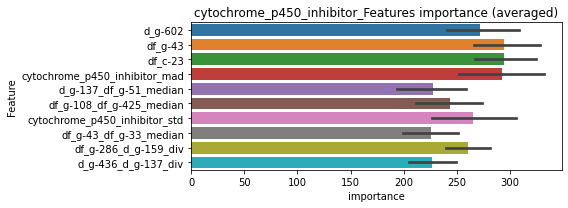

len(train_index) : 2688
len(valid_index) : 897
================================= fold 1/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109737	valid_1's binary_logloss: 0.171875
[200]	training's binary_logloss: 0.0426809	valid_1's binary_logloss: 0.113118
[300]	training's binary_logloss: 0.0189397	valid_1's binary_logloss: 0.0890786
[400]	training's binary_logloss: 0.00927726	valid_1's binary_logloss: 0.0770834
[500]	training's binary_logloss: 0.00476603	valid_1's binary_logloss: 0.0719404
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00482388	valid_1's binary_logloss: 0.0718889


len(train_index) : 2689
len(valid_index) : 896
================================= fold 2/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112059	valid_1's binary_logloss: 0.168675
[200]	training's binary_logloss: 0.0440616	valid_1's binary_logloss: 0.107357
[300]	training's binary_logloss: 0.0196988	valid_1's binary_logloss: 0.0790477
[400]	training's binary_logloss: 0.00925075	valid_1's binary_logloss: 0.0635172
[500]	training's binary_logloss: 0.00472977	valid_1's binary_logloss: 0.0551204
[600]	training's binary_logloss: 0.0028052	valid_1's binary_logloss: 0.050998
[700]	training's binary_logloss: 0.00188371	valid_1's binary_logloss: 0.0476506
[800]	training's binary_logloss: 0.00139696	valid_1's binary_logloss: 0.0458332
[900]	training's binary_logloss: 0.00111689	valid_1's binary_logloss: 0.0445636
[1000]	training's binary_logloss: 0.000958153	valid_1's binary_logloss: 0.043605
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.00096282	valid_1's binary_logloss: 0.043565


len(train_index) : 2689
len(valid_index) : 896
================================= fold 3/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106353	valid_1's binary_logloss: 0.159492
[200]	training's binary_logloss: 0.0407243	valid_1's binary_logloss: 0.0992193
[300]	training's binary_logloss: 0.017986	valid_1's binary_logloss: 0.0740816
[400]	training's binary_logloss: 0.00844272	valid_1's binary_logloss: 0.0611595
[500]	training's binary_logloss: 0.00443922	valid_1's binary_logloss: 0.0554775
[600]	training's binary_logloss: 0.00263568	valid_1's binary_logloss: 0.0527029
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00213771	valid_1's binary_logloss: 0.0521664


len(train_index) : 2689
len(valid_index) : 896
================================= fold 4/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11288	valid_1's binary_logloss: 0.172624
[200]	training's binary_logloss: 0.0442006	valid_1's binary_logloss: 0.10331
[300]	training's binary_logloss: 0.0193927	valid_1's binary_logloss: 0.0725606
[400]	training's binary_logloss: 0.00930666	valid_1's binary_logloss: 0.0580132
[500]	training's binary_logloss: 0.00481694	valid_1's binary_logloss: 0.0482157
[600]	training's binary_logloss: 0.00285565	valid_1's binary_logloss: 0.042786
[700]	training's binary_logloss: 0.00190683	valid_1's binary_logloss: 0.0402483
[800]	training's binary_logloss: 0.00141538	valid_1's binary_logloss: 0.0387023
[900]	training's binary_logloss: 0.00113016	valid_1's binary_logloss: 0.0375897
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.00108074	valid_1's binary_logloss: 0.0370387


cytochrome_p450_inhibitor logloss: 0.05117053032170885
dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3281, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109124	valid_1's binary_logloss: 0.153528
[200]	training's binary_logloss: 0.0417482	valid_1's binary_logloss: 0.0811181
[300]	training's binary_logloss: 0.0166008	valid_1's binary_logloss: 0.0484904
[400]	training's binary_logloss: 0.00735635	valid_1's binary_logloss: 0.0335653
[500]	training's binary_logloss: 0.00367381	valid_1's binary_logloss: 0.0261394
[600]	training's binary_logloss: 0.00219222	valid_1's binary_logloss: 0.0221259
[700]	training's binary_logloss: 0.00149756	valid_1's binary_logloss: 0.0201098
[800]	training's binary_logloss: 0.00113336	valid_1's binary_logloss: 0.0189388
[900]	training's binary_logloss: 0.000917277	valid_1's binary_logloss: 0.0178666
[1000]	training's binary_logloss: 0.000788958	valid_1's binary_logloss: 0.0173537
[1100]	training's binary_logloss: 0.000726705	valid_1's binary_logloss: 0.017082
Early stopping, best iteration is:
[1140]	training's binary_

1 / 3 AUC score:1.000
y_Threshold: 0.0149467, Threshold: 0.0854072, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.05979, conf_1:0.11103
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0854072
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_2: 0.1154072
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.1454072
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_4: 0.1754072
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.2054072
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.2354072
threshold: 0.2354072, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0997785	valid_1's binary_logloss: 0.141589
[200]	training's binary_logloss: 0.0341299	valid_1's binary_logloss: 0.0716154
[300]	training's binary_logloss: 0.0132509	valid_1's binary_logloss: 0.0447781
[400]	training's binary_logloss: 0.00572781	valid_1's binary_logloss: 0.0312408
[500]	training's binary_logloss: 0.00289161	valid_1's binary_logloss: 0.0240297
[600]	training's binary_logloss: 0.00176887	valid_1's binary_logloss: 0.0208925
[700]	training's binary_logloss: 0.00123876	valid_1's binary_logloss: 0.0193703
[800]	training's binary_logloss: 0.000947676	valid_1's binary_logloss: 0.0181402
Early stopping, best iteration is:
[839]	training's binary_logloss: 0.000871356	valid_1's binary_logloss: 0.017815
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101997	valid_1's binary_logloss: 0.132536
[200]	training's binary_logloss: 0.0354184	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1673267, Threshold: 0.2354072, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 647.0/3787
p_label_rate: 0.0135610 Vs.target_rate: 0.00151, Num_p_label: 54.0, conf_0:0.18833, conf_1:0.28249
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_1: 0.2354072
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_2: 0.2654072
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_3: 0.2954072
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_4: 0.3254072
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_5: 0.3554072
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.3854072
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_7: 0.4154072
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_8: 0.4454072
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_9: 0.4754072
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_10: 0.5054072
threshold: 0.5354072, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975507	valid_1's binary_logloss: 0.136869
[200]	training's binary_logloss: 0.0331085	valid_1's binary_logloss: 0.0638702
[300]	training's binary_logloss: 0.0125813	valid_1's binary_logloss: 0.0346907
[400]	training's binary_logloss: 0.00540871	valid_1's binary_logloss: 0.0215927
[500]	training's binary_logloss: 0.00274716	valid_1's binary_logloss: 0.0156025
[600]	training's binary_logloss: 0.00168311	valid_1's binary_logloss: 0.0129552
[700]	training's binary_logloss: 0.00118076	valid_1's binary_logloss: 0.0110415
[800]	training's binary_logloss: 0.000915177	valid_1's binary_logloss: 0.010035
[900]	training's binary_logloss: 0.000761026	valid_1's binary_logloss: 0.00952202
[1000]	training's binary_logloss: 0.000695633	valid_1's binary_logloss: 0.00927688
[1100]	training's binary_logloss: 0.000667266	valid_1's binary_logloss: 0.00910954
Early stopping, best iteration is:
[1106]	training's bi

3 / 3 AUC score:1.000
y_Threshold: 0.1138213, Threshold: 0.5354072, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 643.0/3779
p_label_rate: 0.0082873 Vs.target_rate: 0.00151, Num_p_label: 33.0, conf_0:0.48187, conf_1:0.58895
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_1: 0.5354072
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_2: 0.5654072
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.5954072
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.6254072
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_5: 0.6554072
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_6: 0.6854072
threshold: 0.6854072, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 643.0/3779, y_label_rate: 0.1701508


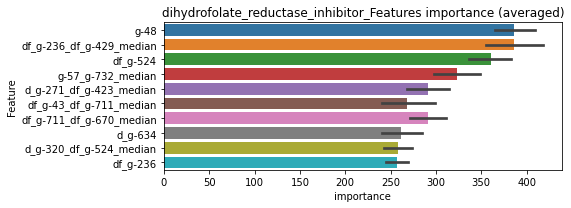

len(train_index) : 2834
len(valid_index) : 945
================================= fold 1/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.095693	valid_1's binary_logloss: 0.142966
[200]	training's binary_logloss: 0.0333686	valid_1's binary_logloss: 0.0716103
[300]	training's binary_logloss: 0.0124913	valid_1's binary_logloss: 0.0423302
[400]	training's binary_logloss: 0.00533191	valid_1's binary_logloss: 0.0294643
[500]	training's binary_logloss: 0.0027131	valid_1's binary_logloss: 0.0238137
[600]	training's binary_logloss: 0.00166861	valid_1's binary_logloss: 0.0212361
[700]	training's binary_logloss: 0.00117065	valid_1's binary_logloss: 0.019648
[800]	training's binary_logloss: 0.000901413	valid_1's binary_logloss: 0.0185735
Early stopping, best iteration is:
[824]	training's binary_logloss: 0.000854938	valid_1's binary_logloss: 0.0182854


len(train_index) : 2834
len(valid_index) : 945
================================= fold 2/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0965037	valid_1's binary_logloss: 0.143353
[200]	training's binary_logloss: 0.0316878	valid_1's binary_logloss: 0.0719315
[300]	training's binary_logloss: 0.012039	valid_1's binary_logloss: 0.0436312
[400]	training's binary_logloss: 0.00518627	valid_1's binary_logloss: 0.0319246
[500]	training's binary_logloss: 0.00265469	valid_1's binary_logloss: 0.0263469
[600]	training's binary_logloss: 0.00162898	valid_1's binary_logloss: 0.0230849
[700]	training's binary_logloss: 0.00113935	valid_1's binary_logloss: 0.021451
[800]	training's binary_logloss: 0.000886607	valid_1's binary_logloss: 0.0205312
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.000775213	valid_1's binary_logloss: 0.020157


len(train_index) : 2834
len(valid_index) : 945
================================= fold 3/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0960029	valid_1's binary_logloss: 0.128247
[200]	training's binary_logloss: 0.0334406	valid_1's binary_logloss: 0.0614857
[300]	training's binary_logloss: 0.0131881	valid_1's binary_logloss: 0.0355796
[400]	training's binary_logloss: 0.00562076	valid_1's binary_logloss: 0.0228597
[500]	training's binary_logloss: 0.00285288	valid_1's binary_logloss: 0.016922
[600]	training's binary_logloss: 0.00171573	valid_1's binary_logloss: 0.0142907
[700]	training's binary_logloss: 0.00118725	valid_1's binary_logloss: 0.0127245
[800]	training's binary_logloss: 0.000915362	valid_1's binary_logloss: 0.0119614
[900]	training's binary_logloss: 0.000761917	valid_1's binary_logloss: 0.011359
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000755053	valid_1's binary_logloss: 0.0113118


len(train_index) : 2835
len(valid_index) : 944
================================= fold 4/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.097452	valid_1's binary_logloss: 0.130035
[200]	training's binary_logloss: 0.0324092	valid_1's binary_logloss: 0.0619154
[300]	training's binary_logloss: 0.0123693	valid_1's binary_logloss: 0.0349622
[400]	training's binary_logloss: 0.0052778	valid_1's binary_logloss: 0.0221745
[500]	training's binary_logloss: 0.00270897	valid_1's binary_logloss: 0.01647
[600]	training's binary_logloss: 0.00166083	valid_1's binary_logloss: 0.0132179
[700]	training's binary_logloss: 0.00116137	valid_1's binary_logloss: 0.0115367
[800]	training's binary_logloss: 0.000896434	valid_1's binary_logloss: 0.0103757
[900]	training's binary_logloss: 0.000743194	valid_1's binary_logloss: 0.00982313
[1000]	training's binary_logloss: 0.000681021	valid_1's binary_logloss: 0.00946405
Early stopping, best iteration is:
[1038]	training's binary_logloss: 0.000668738	valid_1's binary_logloss: 0.00939255


dihydrofolate_reductase_inhibitor logloss: 0.014793899779730283
dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885401	valid_1's binary_logloss: 0.113032
[200]	training's binary_logloss: 0.0279006	valid_1's binary_logloss: 0.046921
[300]	training's binary_logloss: 0.00974795	valid_1's binary_logloss: 0.0231429
[400]	training's binary_logloss: 0.00398138	valid_1's binary_logloss: 0.014076
[500]	training's binary_logloss: 0.00205306	valid_1's binary_logloss: 0.0099357
[600]	training's binary_logloss: 0.00128115	valid_1's binary_logloss: 0.00796083
[700]	training's binary_logloss: 0.000910012	valid_1's binary_logloss: 0.00705889
[800]	training's binary_logloss: 0.000715935	valid_1's binary_logloss: 0.00642078
[900]	training's binary_logloss: 0.000609021	valid_1's binary_logloss: 0.00619296
[1000]	training's binary_logloss: 0.000565558	valid_1's binary_logloss: 0.0060622
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.000565558	valid_1's binary_logloss: 0.0060622
Training until vali

1 / 3 AUC score:1.000
y_Threshold: 0.0076073, Threshold: 0.0463302, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.03243, conf_1:0.06023
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0463302
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_2: 0.0763302
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_3: 0.1063302
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_4: 0.1363302
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_5: 0.1663302
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_6: 0.1963302
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_7: 0.2263302
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_8: 0.2563302
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_9: 0.2863302
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_10: 0.3163302
threshold: 0.3463302, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0842699	valid_1's binary_logloss: 0.106802
[200]	training's binary_logloss: 0.0241921	valid_1's binary_logloss: 0.0393205
[300]	training's binary_logloss: 0.00819588	valid_1's binary_logloss: 0.0177149
[400]	training's binary_logloss: 0.00335524	valid_1's binary_logloss: 0.00931212
[500]	training's binary_logloss: 0.00171505	valid_1's binary_logloss: 0.00580462
[600]	training's binary_logloss: 0.00107955	valid_1's binary_logloss: 0.00435829
[700]	training's binary_logloss: 0.000781343	valid_1's binary_logloss: 0.00362348
[800]	training's binary_logloss: 0.000615531	valid_1's binary_logloss: 0.0031073
[900]	training's binary_logloss: 0.000526487	valid_1's binary_logloss: 0.00283065
[1000]	training's binary_logloss: 0.000491487	valid_1's binary_logloss: 0.00273715
Early stopping, best iteration is:
[1031]	training's binary_logloss: 0.000487588	valid_1's binary_logloss: 0.00272186
Training unti

2 / 3 AUC score:1.000
y_Threshold: 0.1103300, Threshold: 0.3463302, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0070316 Vs.target_rate: 0.00105, Num_p_label: 28.0, conf_0:0.27706, conf_1:0.41560
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_1: 0.3463302
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_2: 0.3763302
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_3: 0.4063302
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_4: 0.4363302
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_5: 0.4663302
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_6: 0.4963302
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_7: 0.5263302
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_8: 0.5563302
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_9: 0.5863302
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_10: 0.6163302
threshold: 0.6463302, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0842699	valid_1's binary_logloss: 0.106802
[200]	training's binary_logloss: 0.0241921	valid_1's binary_logloss: 0.0393205
[300]	training's binary_logloss: 0.00819588	valid_1's binary_logloss: 0.0177149
[400]	training's binary_logloss: 0.00335524	valid_1's binary_logloss: 0.00931212
[500]	training's binary_logloss: 0.00171505	valid_1's binary_logloss: 0.00580462
[600]	training's binary_logloss: 0.00107955	valid_1's binary_logloss: 0.00435829
[700]	training's binary_logloss: 0.000781343	valid_1's binary_logloss: 0.00362348
[800]	training's binary_logloss: 0.000615531	valid_1's binary_logloss: 0.0031073
[900]	training's binary_logloss: 0.000526487	valid_1's binary_logloss: 0.00283065
[1000]	training's binary_logloss: 0.000491487	valid_1's binary_logloss: 0.00273715
Early stopping, best iteration is:
[1031]	training's binary_logloss: 0.000487588	valid_1's binary_logloss: 0.00272186
Training unti

3 / 3 AUC score:1.000
y_Threshold: 0.1103300, Threshold: 0.6463302, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0035158 Vs.target_rate: 0.00105, Num_p_label: 14.0, conf_0:0.50000, conf_1:0.71096
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_1: 0.6463302
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.6763302
threshold: 0.6763302, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


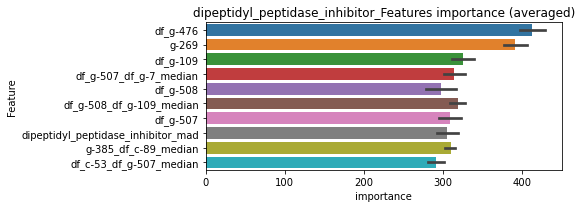

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0823302	valid_1's binary_logloss: 0.106414
[200]	training's binary_logloss: 0.0242493	valid_1's binary_logloss: 0.040246
[300]	training's binary_logloss: 0.00818842	valid_1's binary_logloss: 0.0183037
[400]	training's binary_logloss: 0.00329771	valid_1's binary_logloss: 0.00986693
[500]	training's binary_logloss: 0.00170759	valid_1's binary_logloss: 0.00638784
[600]	training's binary_logloss: 0.00108005	valid_1's binary_logloss: 0.00477854
[700]	training's binary_logloss: 0.000780042	valid_1's binary_logloss: 0.00392587
[800]	training's binary_logloss: 0.000618816	valid_1's binary_logloss: 0.00343673
[900]	training's binary_logloss: 0.000533805	valid_1's binary_logloss: 0.00316841
[1000]	training's binary_logloss: 0.000503393	valid_1's binary_logloss: 0.00305562
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000503393	valid_1's binary_logloss: 0.00305562


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08321	valid_1's binary_logloss: 0.110631
[200]	training's binary_logloss: 0.0247979	valid_1's binary_logloss: 0.0418454
[300]	training's binary_logloss: 0.0085511	valid_1's binary_logloss: 0.0188826
[400]	training's binary_logloss: 0.00346804	valid_1's binary_logloss: 0.00991531
[500]	training's binary_logloss: 0.00178818	valid_1's binary_logloss: 0.00633868
[600]	training's binary_logloss: 0.00112417	valid_1's binary_logloss: 0.00471649
[700]	training's binary_logloss: 0.000804837	valid_1's binary_logloss: 0.0038829
[800]	training's binary_logloss: 0.000637176	valid_1's binary_logloss: 0.00337959
[900]	training's binary_logloss: 0.000546073	valid_1's binary_logloss: 0.00307174
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000517087	valid_1's binary_logloss: 0.003008


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0847138	valid_1's binary_logloss: 0.106345
[200]	training's binary_logloss: 0.0246809	valid_1's binary_logloss: 0.0377476
[300]	training's binary_logloss: 0.0082577	valid_1's binary_logloss: 0.0163346
[400]	training's binary_logloss: 0.0033589	valid_1's binary_logloss: 0.0084632
[500]	training's binary_logloss: 0.00173011	valid_1's binary_logloss: 0.00526433
[600]	training's binary_logloss: 0.00109305	valid_1's binary_logloss: 0.00386292
[700]	training's binary_logloss: 0.000785585	valid_1's binary_logloss: 0.00308417
[800]	training's binary_logloss: 0.000626362	valid_1's binary_logloss: 0.00270737
[900]	training's binary_logloss: 0.000542392	valid_1's binary_logloss: 0.00248648
[1000]	training's binary_logloss: 0.000508335	valid_1's binary_logloss: 0.00240354
Early stopping, best iteration is:
[1011]	training's binary_logloss: 0.00050785	valid_1's binary_logloss: 0.00240189


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0840619	valid_1's binary_logloss: 0.105877
[200]	training's binary_logloss: 0.0246019	valid_1's binary_logloss: 0.0381132
[300]	training's binary_logloss: 0.00830716	valid_1's binary_logloss: 0.0170453
[400]	training's binary_logloss: 0.00335489	valid_1's binary_logloss: 0.00945461
[500]	training's binary_logloss: 0.00171972	valid_1's binary_logloss: 0.00645111
[600]	training's binary_logloss: 0.00109245	valid_1's binary_logloss: 0.00497789
[700]	training's binary_logloss: 0.000791874	valid_1's binary_logloss: 0.00438218
[800]	training's binary_logloss: 0.000624415	valid_1's binary_logloss: 0.00392047
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.000600308	valid_1's binary_logloss: 0.00382957


dipeptidyl_peptidase_inhibitor logloss: 0.0030737972111080374
diuretic, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0578574	valid_1's binary_logloss: 0.0641254
[200]	training's binary_logloss: 0.0115942	valid_1's binary_logloss: 0.0151384
[300]	training's binary_logloss: 0.0027605	valid_1's binary_logloss: 0.00450291
[400]	training's binary_logloss: 0.00100774	valid_1's binary_logloss: 0.00200356
[500]	training's binary_logloss: 0.00053728	valid_1's binary_logloss: 0.00121694
[600]	training's binary_logloss: 0.000363941	valid_1's binary_logloss: 0.000901392
[700]	training's binary_logloss: 0.000290874	valid_1's binary_logloss: 0.000756583
[800]	training's binary_logloss: 0.000271847	valid_1's binary_logloss: 0.000714164
Early stopping, best iteration is:
[852]	training's binary_logloss: 0.000266619	valid_1's binary_logloss: 0.000703955
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0565588	valid_1's binary_logloss: 0.0625032
[200]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0012476, Threshold: 0.0045738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00320, conf_1:0.00595
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0045738
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.0345738
threshold: 0.0345738, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0544393	valid_1's binary_logloss: 0.0588811
[200]	training's binary_logloss: 0.0103422	valid_1's binary_logloss: 0.0128153
[300]	training's binary_logloss: 0.00253066	valid_1's binary_logloss: 0.00363633
[400]	training's binary_logloss: 0.00093224	valid_1's binary_logloss: 0.00150293
[500]	training's binary_logloss: 0.000493505	valid_1's binary_logloss: 0.000882843
[600]	training's binary_logloss: 0.000331469	valid_1's binary_logloss: 0.000630323
[700]	training's binary_logloss: 0.000266016	valid_1's binary_logloss: 0.000528539
[800]	training's binary_logloss: 0.000249047	valid_1's binary_logloss: 0.000506071
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.000249048	valid_1's binary_logloss: 0.000506068
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0537604	valid_1's binary_logloss: 0.058594
[200]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1011996, Threshold: 0.0345738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0050226 Vs.target_rate: 0.00025, Num_p_label: 20.0, conf_0:0.02766, conf_1:0.04149
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_1: 0.0345738
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0645738
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0945738
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.1245738
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.1545738
threshold: 0.1545738, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0544393	valid_1's binary_logloss: 0.0588811
[200]	training's binary_logloss: 0.0103422	valid_1's binary_logloss: 0.0128153
[300]	training's binary_logloss: 0.00253066	valid_1's binary_logloss: 0.00363633
[400]	training's binary_logloss: 0.00093224	valid_1's binary_logloss: 0.00150293
[500]	training's binary_logloss: 0.000493505	valid_1's binary_logloss: 0.000882843
[600]	training's binary_logloss: 0.000331469	valid_1's binary_logloss: 0.000630323
[700]	training's binary_logloss: 0.000266016	valid_1's binary_logloss: 0.000528539
[800]	training's binary_logloss: 0.000249047	valid_1's binary_logloss: 0.000506071
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.000249048	valid_1's binary_logloss: 0.000506068
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0537604	valid_1's binary_logloss: 0.058594
[200]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1011996, Threshold: 0.1545738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.13912, conf_1:0.17003
threshold: 0.1545738, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


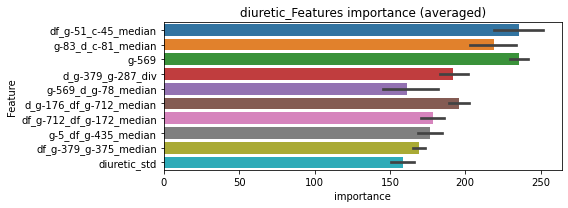

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 diuretic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0539766	valid_1's binary_logloss: 0.0582448
[200]	training's binary_logloss: 0.0103101	valid_1's binary_logloss: 0.0125534
[300]	training's binary_logloss: 0.00250663	valid_1's binary_logloss: 0.00362087
[400]	training's binary_logloss: 0.000930459	valid_1's binary_logloss: 0.00155971
[500]	training's binary_logloss: 0.000494068	valid_1's binary_logloss: 0.000904005
[600]	training's binary_logloss: 0.000334602	valid_1's binary_logloss: 0.000666127
[700]	training's binary_logloss: 0.000266168	valid_1's binary_logloss: 0.000563279
Early stopping, best iteration is:
[768]	training's binary_logloss: 0.000256954	valid_1's binary_logloss: 0.000551558


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 diuretic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0540423	valid_1's binary_logloss: 0.0593822
[200]	training's binary_logloss: 0.010217	valid_1's binary_logloss: 0.0142451
[300]	training's binary_logloss: 0.00249148	valid_1's binary_logloss: 0.0050946
[400]	training's binary_logloss: 0.000923007	valid_1's binary_logloss: 0.002611
[500]	training's binary_logloss: 0.000489996	valid_1's binary_logloss: 0.00168774
[600]	training's binary_logloss: 0.00033131	valid_1's binary_logloss: 0.00134683
[700]	training's binary_logloss: 0.000266308	valid_1's binary_logloss: 0.00121188
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00025812	valid_1's binary_logloss: 0.0012002


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 diuretic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0544073	valid_1's binary_logloss: 0.0566469
[200]	training's binary_logloss: 0.0103212	valid_1's binary_logloss: 0.0114883
[300]	training's binary_logloss: 0.00250848	valid_1's binary_logloss: 0.00312984
[400]	training's binary_logloss: 0.000920035	valid_1's binary_logloss: 0.00132156
[500]	training's binary_logloss: 0.000488917	valid_1's binary_logloss: 0.000770752
[600]	training's binary_logloss: 0.000330404	valid_1's binary_logloss: 0.000553486
[700]	training's binary_logloss: 0.000263199	valid_1's binary_logloss: 0.000460286
[800]	training's binary_logloss: 0.000247982	valid_1's binary_logloss: 0.000438102
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.00024756	valid_1's binary_logloss: 0.000437527


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 diuretic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0542971	valid_1's binary_logloss: 0.0597715
[200]	training's binary_logloss: 0.0101612	valid_1's binary_logloss: 0.0131337
[300]	training's binary_logloss: 0.00248122	valid_1's binary_logloss: 0.00393381
[400]	training's binary_logloss: 0.000918937	valid_1's binary_logloss: 0.00175107
[500]	training's binary_logloss: 0.000489394	valid_1's binary_logloss: 0.00100857
[600]	training's binary_logloss: 0.000328132	valid_1's binary_logloss: 0.000727151
[700]	training's binary_logloss: 0.000264203	valid_1's binary_logloss: 0.00060927
[800]	training's binary_logloss: 0.000249767	valid_1's binary_logloss: 0.00058964
[900]	training's binary_logloss: 0.000246936	valid_1's binary_logloss: 0.000586006
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.000246938	valid_1's binary_logloss: 0.000586001


diuretic logloss: 0.0006937890448303922
dna_alkylating_agent, len(trt): 48, len(othr): 3280, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110582	valid_1's binary_logloss: 0.166753
[200]	training's binary_logloss: 0.0426117	valid_1's binary_logloss: 0.0970164
[300]	training's binary_logloss: 0.0189224	valid_1's binary_logloss: 0.0668502
[400]	training's binary_logloss: 0.00848826	valid_1's binary_logloss: 0.0489371
[500]	training's binary_logloss: 0.00428911	valid_1's binary_logloss: 0.040637
[600]	training's binary_logloss: 0.00253186	valid_1's binary_logloss: 0.0353498
[700]	training's binary_logloss: 0.0016857	valid_1's binary_logloss: 0.0325283
[800]	training's binary_logloss: 0.0012534	valid_1's binary_logloss: 0.0310399
[900]	training's binary_logloss: 0.00099946	valid_1's binary_logloss: 0.0303318
[1000]	training's binary_logloss: 0.000845402	valid_1's binary_logloss: 0.0297191
Early stopping, best iteration is:
[1055]	training's binary_logloss: 0.000790164	valid_1's binary_logloss: 0.0294653
Training until validation sc

1 / 3 AUC score:0.997
y_Threshold: 0.0242221, Threshold: 0.1882605, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3792
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.13178, conf_1:0.24474
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.1882605
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.2182605
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_3: 0.2482605
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_4: 0.2782605
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_5: 0.3082605
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_6: 0.3382605
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_7: 0.3682605
threshold: 0.3682605, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109753	valid_1's binary_logloss: 0.147138
[200]	training's binary_logloss: 0.0406922	valid_1's binary_logloss: 0.0741367
[300]	training's binary_logloss: 0.0159483	valid_1's binary_logloss: 0.0428606
[400]	training's binary_logloss: 0.00681939	valid_1's binary_logloss: 0.0270084
[500]	training's binary_logloss: 0.00343397	valid_1's binary_logloss: 0.0200882
[600]	training's binary_logloss: 0.0020443	valid_1's binary_logloss: 0.016364
[700]	training's binary_logloss: 0.00139887	valid_1's binary_logloss: 0.0145893
[800]	training's binary_logloss: 0.0010574	valid_1's binary_logloss: 0.0134415
[900]	training's binary_logloss: 0.000855817	valid_1's binary_logloss: 0.012903
[1000]	training's binary_logloss: 0.000737087	valid_1's binary_logloss: 0.0124571
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.000732085	valid_1's binary_logloss: 0.012429
Training until validation sco

2 / 3 AUC score:0.999
y_Threshold: 0.1412398, Threshold: 0.3682605, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 640.0/3772
p_label_rate: 0.0155701 Vs.target_rate: 0.00202, Num_p_label: 62.0, conf_0:0.29461, conf_1:0.44191
Num_p_label: 62.0, Expected: 8.0, Adj_threshold_1: 0.3682605
Num_p_label: 56.0, Expected: 8.0, Adj_threshold_2: 0.3982605
Num_p_label: 51.0, Expected: 8.0, Adj_threshold_3: 0.4282605
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_4: 0.4582605
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_5: 0.4882605
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_6: 0.5182605
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_7: 0.5482605
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_8: 0.5782605
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_9: 0.6082605
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_10: 0.6382605
threshold: 0.6682605, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 640.0/3772, y_label_rate: 0.1696713
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0991091	valid_1's binary_logloss: 0.141825
[200]	training's binary_logloss: 0.0346429	valid_1's binary_logloss: 0.0700871
[300]	training's binary_logloss: 0.0138502	valid_1's binary_logloss: 0.0410891
[400]	training's binary_logloss: 0.00596326	valid_1's binary_logloss: 0.0268902
[500]	training's binary_logloss: 0.0030317	valid_1's binary_logloss: 0.0200258
[600]	training's binary_logloss: 0.00183336	valid_1's binary_logloss: 0.0169217
[700]	training's binary_logloss: 0.00127378	valid_1's binary_logloss: 0.0150441
[800]	training's binary_logloss: 0.000961223	valid_1's binary_logloss: 0.0138462
[900]	training's binary_logloss: 0.000791436	valid_1's binary_logloss: 0.0132799
[1000]	training's binary_logloss: 0.000690673	valid_1's binary_logloss: 0.0129444
[1100]	training's binary_logloss: 0.000643283	valid_1's binary_logloss: 0.012823
Early stopping, best iteration is:
[1076]	training's binary

3 / 3 AUC score:1.000
y_Threshold: 0.1355034, Threshold: 0.6682605, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 635.0/3762
p_label_rate: 0.0095429 Vs.target_rate: 0.00202, Num_p_label: 38.0, conf_0:0.50000, conf_1:0.73509
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_1: 0.6682605
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.6982605
threshold: 0.6982605, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 635.0/3762, y_label_rate: 0.1687932


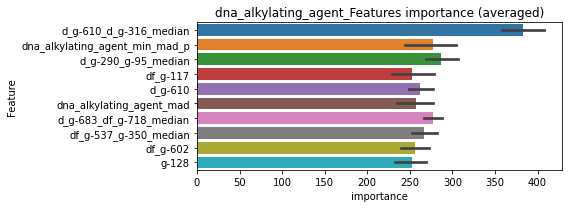

len(train_index) : 2821
len(valid_index) : 941
================================= fold 1/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0981169	valid_1's binary_logloss: 0.136018
[200]	training's binary_logloss: 0.0332634	valid_1's binary_logloss: 0.0657875
[300]	training's binary_logloss: 0.0129918	valid_1's binary_logloss: 0.0399967
[400]	training's binary_logloss: 0.00566446	valid_1's binary_logloss: 0.028992
[500]	training's binary_logloss: 0.0028723	valid_1's binary_logloss: 0.0238755
[600]	training's binary_logloss: 0.00175289	valid_1's binary_logloss: 0.0215612
[700]	training's binary_logloss: 0.00121096	valid_1's binary_logloss: 0.0201012
[800]	training's binary_logloss: 0.000930715	valid_1's binary_logloss: 0.0194994
[900]	training's binary_logloss: 0.000763101	valid_1's binary_logloss: 0.0189592
[1000]	training's binary_logloss: 0.000678037	valid_1's binary_logloss: 0.0186801
[1100]	training's binary_logloss: 0.000632613	valid_1's binary_logloss: 0.0184764
Early stopping, best iteration is:
[1080]	training's binary

len(train_index) : 2821
len(valid_index) : 941
================================= fold 2/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0979678	valid_1's binary_logloss: 0.140456
[200]	training's binary_logloss: 0.0329532	valid_1's binary_logloss: 0.06928
[300]	training's binary_logloss: 0.0130915	valid_1's binary_logloss: 0.0414045
[400]	training's binary_logloss: 0.00565624	valid_1's binary_logloss: 0.0296579
[500]	training's binary_logloss: 0.00287272	valid_1's binary_logloss: 0.023564
[600]	training's binary_logloss: 0.00174672	valid_1's binary_logloss: 0.0211079
[700]	training's binary_logloss: 0.00121537	valid_1's binary_logloss: 0.0199048
[800]	training's binary_logloss: 0.000934477	valid_1's binary_logloss: 0.0189804
[900]	training's binary_logloss: 0.000765752	valid_1's binary_logloss: 0.0184313
[1000]	training's binary_logloss: 0.000670154	valid_1's binary_logloss: 0.0182142
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.00067443	valid_1's binary_logloss: 0.0181794


len(train_index) : 2822
len(valid_index) : 940
================================= fold 3/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100671	valid_1's binary_logloss: 0.134997
[200]	training's binary_logloss: 0.0348536	valid_1's binary_logloss: 0.0653233
[300]	training's binary_logloss: 0.013775	valid_1's binary_logloss: 0.0366081
[400]	training's binary_logloss: 0.00598507	valid_1's binary_logloss: 0.0232936
[500]	training's binary_logloss: 0.00305134	valid_1's binary_logloss: 0.0169174
[600]	training's binary_logloss: 0.00184412	valid_1's binary_logloss: 0.0133523
[700]	training's binary_logloss: 0.00125758	valid_1's binary_logloss: 0.0114142
[800]	training's binary_logloss: 0.000950861	valid_1's binary_logloss: 0.0104705
[900]	training's binary_logloss: 0.000775389	valid_1's binary_logloss: 0.00966329
[1000]	training's binary_logloss: 0.00067584	valid_1's binary_logloss: 0.00940193
[1100]	training's binary_logloss: 0.000636025	valid_1's binary_logloss: 0.00915338
Early stopping, best iteration is:
[1146]	training's bina

len(train_index) : 2822
len(valid_index) : 940
================================= fold 4/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0994648	valid_1's binary_logloss: 0.143583
[200]	training's binary_logloss: 0.0341769	valid_1's binary_logloss: 0.0759027
[300]	training's binary_logloss: 0.0132777	valid_1's binary_logloss: 0.0484808
[400]	training's binary_logloss: 0.00569693	valid_1's binary_logloss: 0.0371215
[500]	training's binary_logloss: 0.00285329	valid_1's binary_logloss: 0.0317395
[600]	training's binary_logloss: 0.00172032	valid_1's binary_logloss: 0.0295242
[700]	training's binary_logloss: 0.00119887	valid_1's binary_logloss: 0.0278809
[800]	training's binary_logloss: 0.000919025	valid_1's binary_logloss: 0.0278793
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.000972369	valid_1's binary_logloss: 0.0275465


dna_alkylating_agent logloss: 0.01831848773840397
dna_inhibitor, len(trt): 402, len(othr): 3248, target_rate: 0.0168808 → Adj_target_rate: 0.0137338


neg labels: 3289 → selected neg labels: 3248


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.257552	valid_1's binary_logloss: 0.404837
[200]	training's binary_logloss: 0.165113	valid_1's binary_logloss: 0.387787
[300]	training's binary_logloss: 0.112434	valid_1's binary_logloss: 0.382581
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0974015	valid_1's binary_logloss: 0.381557
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.255865	valid_1's binary_logloss: 0.401613
[200]	training's binary_logloss: 0.165039	valid_1's binary_logloss: 0.386738
[300]	training's binary_logloss: 0.113018	valid_1's binary_logloss: 0.381617
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.100276	valid_1's binary_logloss: 0.380631
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.25787	valid_1's binary_logloss: 0.388666
[200]	training's binary_logloss: 0.170347	valid_1's bi

1 / 3 AUC score:0.767
y_Threshold: 0.1547629, Threshold: 0.5113506, pos_neg_ratio: 0.8000000
Remove_noisy_data: 697 → Positive_corect_labels: 366/3200
p_label_rate: 0.0100452 Vs.target_rate: 0.01688, Num_p_label: 40.0, conf_0:0.35795, conf_1:0.66476
threshold: 0.5113506, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 366.0/3200, y_label_rate: 0.1143750
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122765	valid_1's binary_logloss: 0.224975
[200]	training's binary_logloss: 0.0565305	valid_1's binary_logloss: 0.184209
[300]	training's binary_logloss: 0.0294705	valid_1's binary_logloss: 0.163783
[400]	training's binary_logloss: 0.0156175	valid_1's binary_logloss: 0.155162
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.010988	valid_1's binary_logloss: 0.152251
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125761	valid_1's binary_logloss: 0.223739
[200]	training's binary_logloss: 0.0551798	valid_1's binary_logloss: 0.182482
[300]	training's binary_logloss: 0.0270304	valid_1's binary_logloss: 0.167617
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0198735	valid_1's binary_logloss: 0.164406
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13043	valid_1

2 / 3 AUC score:0.963
y_Threshold: 0.1080898, Threshold: 0.5113506, pos_neg_ratio: 0.8000000
Remove_noisy_data: 150 → Positive_corect_labels: 291.0/3050
p_label_rate: 0.0303867 Vs.target_rate: 0.01688, Num_p_label: 121.0, conf_0:0.40908, conf_1:0.61362
threshold: 0.5113506, positive_p_label: 121.0/3982, p_label_rate: 0.0303867
positive_y_label: 291.0/3050, y_label_rate: 0.0954098
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0880309	valid_1's binary_logloss: 0.160956
[200]	training's binary_logloss: 0.0347936	valid_1's binary_logloss: 0.124378
[300]	training's binary_logloss: 0.015963	valid_1's binary_logloss: 0.109478
[400]	training's binary_logloss: 0.00798499	valid_1's binary_logloss: 0.101346
[500]	training's binary_logloss: 0.00449335	valid_1's binary_logloss: 0.0985974
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00494086	valid_1's binary_logloss: 0.0978023
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0879676	valid_1's binary_logloss: 0.163999
[200]	training's binary_logloss: 0.0346286	valid_1's binary_logloss: 0.129495
[300]	training's binary_logloss: 0.0151555	valid_1's binary_logloss: 0.119839
[400]	training's binary_logloss: 0.00747609	valid_1's binary_logloss: 0.116923
Early stopping, best iteration is:
[431]	training's binary

3 / 3 AUC score:0.983
y_Threshold: 0.0795507, Threshold: 0.5113506, pos_neg_ratio: 0.8000000
Remove_noisy_data: 70 → Positive_corect_labels: 256.0/2980
p_label_rate: 0.0444500 Vs.target_rate: 0.01688, Num_p_label: 177.0, conf_0:0.46022, conf_1:0.56249
threshold: 0.5113506, positive_p_label: 177.0/3982, p_label_rate: 0.0444500
positive_y_label: 256.0/2980, y_label_rate: 0.0859060


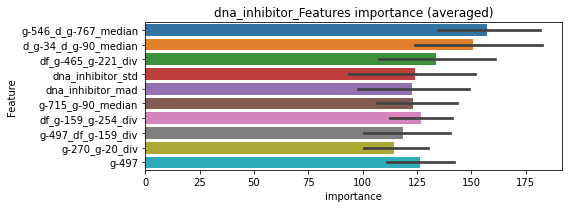

len(train_index) : 2235
len(valid_index) : 745
================================= fold 1/4 dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0732704	valid_1's binary_logloss: 0.117559
[200]	training's binary_logloss: 0.0267088	valid_1's binary_logloss: 0.0791948
[300]	training's binary_logloss: 0.011437	valid_1's binary_logloss: 0.0635114
[400]	training's binary_logloss: 0.00561417	valid_1's binary_logloss: 0.0561834
[500]	training's binary_logloss: 0.00321319	valid_1's binary_logloss: 0.0532162
[600]	training's binary_logloss: 0.00209229	valid_1's binary_logloss: 0.0515915
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00221532	valid_1's binary_logloss: 0.0513953


len(train_index) : 2235
len(valid_index) : 745
================================= fold 2/4 dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0703236	valid_1's binary_logloss: 0.146177
[200]	training's binary_logloss: 0.026469	valid_1's binary_logloss: 0.122228
[300]	training's binary_logloss: 0.0104852	valid_1's binary_logloss: 0.110838


len(train_index) : 2235
len(valid_index) : 745
================================= fold 3/4 dna_inhibitor=================================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00626806	valid_1's binary_logloss: 0.109255
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0691725	valid_1's binary_logloss: 0.114902
[200]	training's binary_logloss: 0.0252246	valid_1's binary_logloss: 0.0814027
[300]	training's binary_logloss: 0.0107565	valid_1's binary_logloss: 0.068894
[400]	training's binary_logloss: 0.00527901	valid_1's binary_logloss: 0.0644031
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00521597	valid_1's binary_logloss: 0.064277


len(train_index) : 2235
len(valid_index) : 745
================================= fold 4/4 dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0693403	valid_1's binary_logloss: 0.14918
[200]	training's binary_logloss: 0.024693	valid_1's binary_logloss: 0.119054
[300]	training's binary_logloss: 0.010067	valid_1's binary_logloss: 0.107512


dna_inhibitor logloss: 0.08275460229378798


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00799155	valid_1's binary_logloss: 0.106091
neg labels: 3289 → selected neg labels: 3272


dopamine_receptor_agonist, len(trt): 121, len(othr): 3272, target_rate: 0.0050810 → Adj_target_rate: 0.0049495
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.16284	valid_1's binary_logloss: 0.252715
[200]	training's binary_logloss: 0.0804781	valid_1's binary_logloss: 0.198747
[300]	training's binary_logloss: 0.0411992	valid_1's binary_logloss: 0.170485
[400]	training's binary_logloss: 0.0219998	valid_1's binary_logloss: 0.156875
[500]	training's binary_logloss: 0.0126181	valid_1's binary_logloss: 0.152583
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00983332	valid_1's binary_logloss: 0.150545
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.170828	valid_1's binary_logloss: 0.242368
[200]	training's binary_logloss: 0.0869527	valid_1's binary_logloss: 0.176052
[300]	training's binary_logloss: 0.0463763	valid_1's binary_logloss: 0.140275
[400]	training's binary_logloss: 0.0254368	valid_1's binary_logloss: 0.120333
[500]	training's binary_logloss: 0.0148058	valid_1's binary_loglo

1 / 3 AUC score:0.979
y_Threshold: 0.0526630, Threshold: 0.2255686, pos_neg_ratio: 0.8000000
Remove_noisy_data: 210 → Positive_corect_labels: 615/3716
p_label_rate: 0.0100452 Vs.target_rate: 0.00508, Num_p_label: 40.0, conf_0:0.15790, conf_1:0.29324
threshold: 0.2255686, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 615.0/3716, y_label_rate: 0.1655005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.139851	valid_1's binary_logloss: 0.221542
[200]	training's binary_logloss: 0.0632643	valid_1's binary_logloss: 0.156132
[300]	training's binary_logloss: 0.0308138	valid_1's binary_logloss: 0.123317
[400]	training's binary_logloss: 0.015672	valid_1's binary_logloss: 0.104276
[500]	training's binary_logloss: 0.0086738	valid_1's binary_logloss: 0.0951855
[600]	training's binary_logloss: 0.00511072	valid_1's binary_logloss: 0.090639
[700]	training's binary_logloss: 0.00329038	valid_1's binary_logloss: 0.0879332
[800]	training's binary_logloss: 0.00233233	valid_1's binary_logloss: 0.0855788
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.00228669	valid_1's binary_logloss: 0.0855262
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145036	valid_1's binary_logloss: 0.207296
[200]	training's binary_logloss: 0.0653297	valid_1's binar

2 / 3 AUC score:0.996
y_Threshold: 0.0992227, Threshold: 0.2255686, pos_neg_ratio: 0.8000000
Remove_noisy_data: 66 → Positive_corect_labels: 582.0/3650
p_label_rate: 0.0251130 Vs.target_rate: 0.00508, Num_p_label: 100.0, conf_0:0.18045, conf_1:0.27068
Num_p_label: 100.0, Expected: 20.2, Adj_threshold_1: 0.2255686
Num_p_label: 91.0, Expected: 20.2, Adj_threshold_2: 0.2555686
Num_p_label: 83.0, Expected: 20.2, Adj_threshold_3: 0.2855686
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_4: 0.3155686
Num_p_label: 72.0, Expected: 20.2, Adj_threshold_5: 0.3455686
Num_p_label: 61.0, Expected: 20.2, Adj_threshold_6: 0.3755686
Num_p_label: 61.0, Expected: 20.2, Adj_threshold_7: 0.4055686
Num_p_label: 56.0, Expected: 20.2, Adj_threshold_8: 0.4355686
Num_p_label: 47.0, Expected: 20.2, Adj_threshold_9: 0.4655686
Num_p_label: 44.0, Expected: 20.2, Adj_threshold_10: 0.4955686
threshold: 0.5255686, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 582.0/3650, y_label_rate: 0.15945

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127856	valid_1's binary_logloss: 0.195364
[200]	training's binary_logloss: 0.0548172	valid_1's binary_logloss: 0.130555
[300]	training's binary_logloss: 0.0257043	valid_1's binary_logloss: 0.100118
[400]	training's binary_logloss: 0.0126213	valid_1's binary_logloss: 0.0849733
[500]	training's binary_logloss: 0.00672225	valid_1's binary_logloss: 0.0769991
[600]	training's binary_logloss: 0.00400818	valid_1's binary_logloss: 0.0728113
[700]	training's binary_logloss: 0.00263451	valid_1's binary_logloss: 0.0714761
[800]	training's binary_logloss: 0.0019232	valid_1's binary_logloss: 0.0700723
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.00171333	valid_1's binary_logloss: 0.0699303
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130815	valid_1's binary_logloss: 0.198176
[200]	training's binary_logloss: 0.0580965	valid_1's bi

3 / 3 AUC score:0.993
y_Threshold: 0.1025702, Threshold: 0.5255686, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 560.0/3606
p_label_rate: 0.0153189 Vs.target_rate: 0.00508, Num_p_label: 61.0, conf_0:0.47301, conf_1:0.57813
Num_p_label: 61.0, Expected: 20.2, Adj_threshold_1: 0.5255686
Num_p_label: 57.0, Expected: 20.2, Adj_threshold_2: 0.5555686
Num_p_label: 55.0, Expected: 20.2, Adj_threshold_3: 0.5855686
Num_p_label: 52.0, Expected: 20.2, Adj_threshold_4: 0.6155686
Num_p_label: 47.0, Expected: 20.2, Adj_threshold_5: 0.6455686
Num_p_label: 44.0, Expected: 20.2, Adj_threshold_6: 0.6755686
threshold: 0.6755686, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 560.0/3606, y_label_rate: 0.1552967


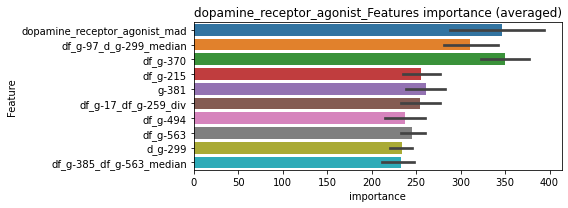

len(train_index) : 2704
len(valid_index) : 902
================================= fold 1/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119643	valid_1's binary_logloss: 0.184933
[200]	training's binary_logloss: 0.0498097	valid_1's binary_logloss: 0.115076
[300]	training's binary_logloss: 0.0229517	valid_1's binary_logloss: 0.0840615
[400]	training's binary_logloss: 0.0112068	valid_1's binary_logloss: 0.0678604
[500]	training's binary_logloss: 0.0058685	valid_1's binary_logloss: 0.0590682
[600]	training's binary_logloss: 0.00347603	valid_1's binary_logloss: 0.0540316
[700]	training's binary_logloss: 0.0023088	valid_1's binary_logloss: 0.0511914
[800]	training's binary_logloss: 0.00170167	valid_1's binary_logloss: 0.0491157
[900]	training's binary_logloss: 0.00134307	valid_1's binary_logloss: 0.0475069
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.00128288	valid_1's binary_logloss: 0.0472321


len(train_index) : 2704
len(valid_index) : 902
================================= fold 2/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118572	valid_1's binary_logloss: 0.179477
[200]	training's binary_logloss: 0.0475472	valid_1's binary_logloss: 0.115511
[300]	training's binary_logloss: 0.0217648	valid_1's binary_logloss: 0.0905353
[400]	training's binary_logloss: 0.0105054	valid_1's binary_logloss: 0.0797641
[500]	training's binary_logloss: 0.00561207	valid_1's binary_logloss: 0.0737811
[600]	training's binary_logloss: 0.00330628	valid_1's binary_logloss: 0.0718957
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00343164	valid_1's binary_logloss: 0.0714857


len(train_index) : 2705
len(valid_index) : 901
================================= fold 3/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118521	valid_1's binary_logloss: 0.167057
[200]	training's binary_logloss: 0.0476163	valid_1's binary_logloss: 0.104153
[300]	training's binary_logloss: 0.0216962	valid_1's binary_logloss: 0.0805167
[400]	training's binary_logloss: 0.0104196	valid_1's binary_logloss: 0.0695149
[500]	training's binary_logloss: 0.00557736	valid_1's binary_logloss: 0.0636563
[600]	training's binary_logloss: 0.00334332	valid_1's binary_logloss: 0.0605773
[700]	training's binary_logloss: 0.00222931	valid_1's binary_logloss: 0.0591909
[800]	training's binary_logloss: 0.00166234	valid_1's binary_logloss: 0.05809
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00143366	valid_1's binary_logloss: 0.0574609


len(train_index) : 2705
len(valid_index) : 901
================================= fold 4/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121179	valid_1's binary_logloss: 0.180878
[200]	training's binary_logloss: 0.0487529	valid_1's binary_logloss: 0.117137
[300]	training's binary_logloss: 0.0223482	valid_1's binary_logloss: 0.0916875
[400]	training's binary_logloss: 0.0107219	valid_1's binary_logloss: 0.0787383
[500]	training's binary_logloss: 0.00555039	valid_1's binary_logloss: 0.07211
[600]	training's binary_logloss: 0.00327829	valid_1's binary_logloss: 0.068393
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.0033054	valid_1's binary_logloss: 0.0683569


dopamine_receptor_agonist logloss: 0.061132918168351966
dopamine_receptor_antagonist, len(trt): 424, len(othr): 3231, target_rate: 0.0178047 → Adj_target_rate: 0.0143701


neg labels: 3289 → selected neg labels: 3231


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.267576	valid_1's binary_logloss: 0.410647
[200]	training's binary_logloss: 0.173933	valid_1's binary_logloss: 0.39956
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.154449	valid_1's binary_logloss: 0.397276
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.263612	valid_1's binary_logloss: 0.400706
[200]	training's binary_logloss: 0.173074	valid_1's binary_logloss: 0.387637
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.136015	valid_1's binary_logloss: 0.384976
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.267637	valid_1's binary_logloss: 0.397096
[200]	training's binary_logloss: 0.177864	valid_1's binary_logloss: 0.38628
[300]	training's binary_logloss: 0.123203	valid_1's binary_logloss: 0.381222
Early stopping, best iteration is:
[282]	training's bina

1 / 3 AUC score:0.714
y_Threshold: 0.1661330, Threshold: 0.5177353, pos_neg_ratio: 0.8000000
Remove_noisy_data: 782 → Positive_corect_labels: 320/3095
p_label_rate: 0.0100452 Vs.target_rate: 0.01780, Num_p_label: 40.0, conf_0:0.36241, conf_1:0.67306
threshold: 0.5177353, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 320.0/3095, y_label_rate: 0.1033926
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100305	valid_1's binary_logloss: 0.167932
[200]	training's binary_logloss: 0.0433972	valid_1's binary_logloss: 0.133702
[300]	training's binary_logloss: 0.0208099	valid_1's binary_logloss: 0.119112
[400]	training's binary_logloss: 0.0107759	valid_1's binary_logloss: 0.114061
[500]	training's binary_logloss: 0.0060824	valid_1's binary_logloss: 0.113057
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0069104	valid_1's binary_logloss: 0.112632
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.097899	valid_1's binary_logloss: 0.197512
[200]	training's binary_logloss: 0.0394422	valid_1's binary_logloss: 0.166043
[300]	training's binary_logloss: 0.0187583	valid_1's binary_logloss: 0.160054
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0131741	valid_1's binary_logloss: 0.156449
Training until validation scor

2 / 3 AUC score:0.964
y_Threshold: 0.0953884, Threshold: 0.5177353, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 251.0/2957
p_label_rate: 0.0542441 Vs.target_rate: 0.01780, Num_p_label: 216.0, conf_0:0.41419, conf_1:0.62128
Num_p_label: 216.0, Expected: 70.9, Adj_threshold_1: 0.5177353
Num_p_label: 204.0, Expected: 70.9, Adj_threshold_2: 0.5477353
Num_p_label: 194.0, Expected: 70.9, Adj_threshold_3: 0.5777353
Num_p_label: 187.0, Expected: 70.9, Adj_threshold_4: 0.6077353
Num_p_label: 179.0, Expected: 70.9, Adj_threshold_5: 0.6377353
Num_p_label: 166.0, Expected: 70.9, Adj_threshold_6: 0.6677353
Num_p_label: 151.0, Expected: 70.9, Adj_threshold_7: 0.6977353
threshold: 0.6977353, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 251.0/2957, y_label_rate: 0.0848833
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0651637	valid_1's binary_logloss: 0.118823
[200]	training's binary_logloss: 0.0224471	valid_1's binary_logloss: 0.0948738
[300]	training's binary_logloss: 0.00900469	valid_1's binary_logloss: 0.0900136
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00689116	valid_1's binary_logloss: 0.0894845
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0648474	valid_1's binary_logloss: 0.107912
[200]	training's binary_logloss: 0.0226546	valid_1's binary_logloss: 0.0761446
[300]	training's binary_logloss: 0.00939479	valid_1's binary_logloss: 0.0631443
[400]	training's binary_logloss: 0.00458723	valid_1's binary_logloss: 0.0592503
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00324549	valid_1's binary_logloss: 0.0576362
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

3 / 3 AUC score:0.973
y_Threshold: 0.0803602, Threshold: 0.6977353, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 223.0/2901
p_label_rate: 0.0577599 Vs.target_rate: 0.01780, Num_p_label: 230.0, conf_0:0.50000, conf_1:0.76751
Num_p_label: 230.0, Expected: 70.9, Adj_threshold_1: 0.6977353
threshold: 0.6977353, positive_p_label: 230.0/3982, p_label_rate: 0.0577599
positive_y_label: 223.0/2901, y_label_rate: 0.0768700


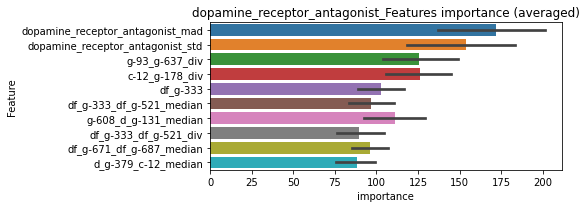

len(train_index) : 2175
len(valid_index) : 726
================================= fold 1/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0528686	valid_1's binary_logloss: 0.0951316
[200]	training's binary_logloss: 0.0166233	valid_1's binary_logloss: 0.0665293
[300]	training's binary_logloss: 0.00655049	valid_1's binary_logloss: 0.057551
[400]	training's binary_logloss: 0.00310986	valid_1's binary_logloss: 0.0535727
[500]	training's binary_logloss: 0.00180941	valid_1's binary_logloss: 0.0513021
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00176233	valid_1's binary_logloss: 0.0511205


len(train_index) : 2176
len(valid_index) : 725
================================= fold 2/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.053651	valid_1's binary_logloss: 0.102657
[200]	training's binary_logloss: 0.016647	valid_1's binary_logloss: 0.0730939
[300]	training's binary_logloss: 0.00641034	valid_1's binary_logloss: 0.0597024
[400]	training's binary_logloss: 0.00302147	valid_1's binary_logloss: 0.0540698
[500]	training's binary_logloss: 0.00176488	valid_1's binary_logloss: 0.0511809
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00180402	valid_1's binary_logloss: 0.0509821


len(train_index) : 2176
len(valid_index) : 725
================================= fold 3/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0514876	valid_1's binary_logloss: 0.094273
[200]	training's binary_logloss: 0.0161693	valid_1's binary_logloss: 0.0653274
[300]	training's binary_logloss: 0.00629802	valid_1's binary_logloss: 0.0555122
[400]	training's binary_logloss: 0.00301115	valid_1's binary_logloss: 0.050154
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00276851	valid_1's binary_logloss: 0.0492796


len(train_index) : 2176
len(valid_index) : 725
================================= fold 4/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497238	valid_1's binary_logloss: 0.102708
[200]	training's binary_logloss: 0.0156048	valid_1's binary_logloss: 0.085352


dopamine_receptor_antagonist logloss: 0.05858011038765332


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00993084	valid_1's binary_logloss: 0.0829486


egfr_inhibitor, len(trt): 336, len(othr): 3242, target_rate: 0.0141093 → Adj_target_rate: 0.0117920


neg labels: 3289 → selected neg labels: 3242


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.236768	valid_1's binary_logloss: 0.375353
[200]	training's binary_logloss: 0.153268	valid_1's binary_logloss: 0.353456
[300]	training's binary_logloss: 0.105298	valid_1's binary_logloss: 0.341886
[400]	training's binary_logloss: 0.0739799	valid_1's binary_logloss: 0.336646
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0639481	valid_1's binary_logloss: 0.336105
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.242676	valid_1's binary_logloss: 0.361537
[200]	training's binary_logloss: 0.151481	valid_1's binary_logloss: 0.333852
[300]	training's binary_logloss: 0.102396	valid_1's binary_logloss: 0.319672
[400]	training's binary_logloss: 0.0713315	valid_1's binary_logloss: 0.314213
[500]	training's binary_logloss: 0.0487095	valid_1's binary_logloss: 0.310125
Early stopping, best iteration is:
[512]	training's binary_logloss: 0

1 / 3 AUC score:0.822
y_Threshold: 0.1415988, Threshold: 0.8000996, pos_neg_ratio: 0.8000000
Remove_noisy_data: 600 → Positive_corect_labels: 413/3290
p_label_rate: 0.0100452 Vs.target_rate: 0.01411, Num_p_label: 40.0, conf_0:0.50000, conf_1:0.80000
threshold: 0.8000996, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 413.0/3290, y_label_rate: 0.1255319
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130981	valid_1's binary_logloss: 0.21364
[200]	training's binary_logloss: 0.0623033	valid_1's binary_logloss: 0.167073
[300]	training's binary_logloss: 0.0324834	valid_1's binary_logloss: 0.144882
[400]	training's binary_logloss: 0.0177784	valid_1's binary_logloss: 0.133975
[500]	training's binary_logloss: 0.0100745	valid_1's binary_logloss: 0.128391
[600]	training's binary_logloss: 0.00607676	valid_1's binary_logloss: 0.126742
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00638634	valid_1's binary_logloss: 0.126315
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127492	valid_1's binary_logloss: 0.205185
[200]	training's binary_logloss: 0.0588107	valid_1's binary_logloss: 0.167739
[300]	training's binary_logloss: 0.0303927	valid_1's binary_logloss: 0.153587
[400]	training's binary_logloss: 0.0165339	valid_1's binary_logl

2 / 3 AUC score:0.965
y_Threshold: 0.1181030, Threshold: 0.8000996, pos_neg_ratio: 0.8000000
Remove_noisy_data: 152 → Positive_corect_labels: 337.0/3138
p_label_rate: 0.0301356 Vs.target_rate: 0.01411, Num_p_label: 120.0, conf_0:0.50000, conf_1:0.80000
threshold: 0.8000996, positive_p_label: 120.0/3982, p_label_rate: 0.0301356
positive_y_label: 337.0/3138, y_label_rate: 0.1073932
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885377	valid_1's binary_logloss: 0.151878
[200]	training's binary_logloss: 0.0335496	valid_1's binary_logloss: 0.113226
[300]	training's binary_logloss: 0.0149525	valid_1's binary_logloss: 0.100683
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0101173	valid_1's binary_logloss: 0.097846
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0913281	valid_1's binary_logloss: 0.158616
[200]	training's binary_logloss: 0.0348033	valid_1's binary_logloss: 0.115978
[300]	training's binary_logloss: 0.0152066	valid_1's binary_logloss: 0.0990872
[400]	training's binary_logloss: 0.00754245	valid_1's binary_logloss: 0.09237
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00801032	valid_1's binary_logloss: 0.092091
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0934118	

3 / 3 AUC score:0.987
y_Threshold: 0.1254288, Threshold: 0.8000996, pos_neg_ratio: 0.8000000
Remove_noisy_data: 70 → Positive_corect_labels: 302.0/3068
p_label_rate: 0.0484681 Vs.target_rate: 0.01411, Num_p_label: 193.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 193.0, Expected: 56.2, Adj_threshold_1: 0.8000996
threshold: 0.8000996, positive_p_label: 193.0/3982, p_label_rate: 0.0484681
positive_y_label: 302.0/3068, y_label_rate: 0.0984355


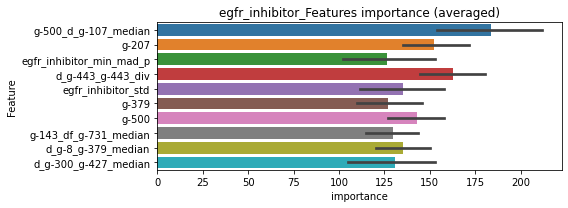

len(train_index) : 2301
len(valid_index) : 767
================================= fold 1/4 egfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0759166	valid_1's binary_logloss: 0.118238
[200]	training's binary_logloss: 0.0257613	valid_1's binary_logloss: 0.0803997
[300]	training's binary_logloss: 0.0109477	valid_1's binary_logloss: 0.0693157
[400]	training's binary_logloss: 0.00527362	valid_1's binary_logloss: 0.064331
[500]	training's binary_logloss: 0.00294872	valid_1's binary_logloss: 0.0619084
[600]	training's binary_logloss: 0.00191595	valid_1's binary_logloss: 0.0605769
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00202509	valid_1's binary_logloss: 0.0604869


len(train_index) : 2301
len(valid_index) : 767
================================= fold 2/4 egfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0745574	valid_1's binary_logloss: 0.128446
[200]	training's binary_logloss: 0.0253654	valid_1's binary_logloss: 0.0835675
[300]	training's binary_logloss: 0.0105195	valid_1's binary_logloss: 0.0669874
[400]	training's binary_logloss: 0.0051484	valid_1's binary_logloss: 0.0577115
[500]	training's binary_logloss: 0.0028859	valid_1's binary_logloss: 0.0532516
[600]	training's binary_logloss: 0.00188481	valid_1's binary_logloss: 0.0511587
[700]	training's binary_logloss: 0.00136935	valid_1's binary_logloss: 0.0507716
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.00143931	valid_1's binary_logloss: 0.0505652


len(train_index) : 2301
len(valid_index) : 767
================================= fold 3/4 egfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.075379	valid_1's binary_logloss: 0.138595
[200]	training's binary_logloss: 0.0259175	valid_1's binary_logloss: 0.105821
[300]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0956499
[400]	training's binary_logloss: 0.00501588	valid_1's binary_logloss: 0.0919657
[500]	training's binary_logloss: 0.00279888	valid_1's binary_logloss: 0.0909023
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00306865	valid_1's binary_logloss: 0.090723


len(train_index) : 2301
len(valid_index) : 767
================================= fold 4/4 egfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0739489	valid_1's binary_logloss: 0.134477
[200]	training's binary_logloss: 0.0255481	valid_1's binary_logloss: 0.0971931
[300]	training's binary_logloss: 0.0103013	valid_1's binary_logloss: 0.0837147
[400]	training's binary_logloss: 0.00490842	valid_1's binary_logloss: 0.0792797
[500]	training's binary_logloss: 0.00276855	valid_1's binary_logloss: 0.0776279
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00264	valid_1's binary_logloss: 0.0772381


egfr_inhibitor logloss: 0.06975327909640974
elastase_inhibitor, len(trt): 12, len(othr): 3284, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0614965	valid_1's binary_logloss: 0.0744388
[200]	training's binary_logloss: 0.0144072	valid_1's binary_logloss: 0.0233975
[300]	training's binary_logloss: 0.00408118	valid_1's binary_logloss: 0.0112307
[400]	training's binary_logloss: 0.00157935	valid_1's binary_logloss: 0.00697973
[500]	training's binary_logloss: 0.00082393	valid_1's binary_logloss: 0.00528706
[600]	training's binary_logloss: 0.000546371	valid_1's binary_logloss: 0.00451414
[700]	training's binary_logloss: 0.000417065	valid_1's binary_logloss: 0.00405819
[800]	training's binary_logloss: 0.000363241	valid_1's binary_logloss: 0.00386551
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.000359792	valid_1's binary_logloss: 0.00385738
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0633697	valid_1's binary_logloss: 0.0740851
[200]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0024262, Threshold: 0.0085230, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00597, conf_1:0.01108
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0085230
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.0385230
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0685230
threshold: 0.0685230, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0596925	valid_1's binary_logloss: 0.0713314
[200]	training's binary_logloss: 0.0129161	valid_1's binary_logloss: 0.0201132
[300]	training's binary_logloss: 0.00350839	valid_1's binary_logloss: 0.00870884
[400]	training's binary_logloss: 0.00135917	valid_1's binary_logloss: 0.0056908
[500]	training's binary_logloss: 0.000727412	valid_1's binary_logloss: 0.00444968
[600]	training's binary_logloss: 0.000484338	valid_1's binary_logloss: 0.00394762
[700]	training's binary_logloss: 0.000370732	valid_1's binary_logloss: 0.00363534
[800]	training's binary_logloss: 0.000331815	valid_1's binary_logloss: 0.00359685
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00033781	valid_1's binary_logloss: 0.00358409
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0597162	valid_1's binary_logloss: 0.0681703
[200]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0392055, Threshold: 0.0685230, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0065294 Vs.target_rate: 0.00050, Num_p_label: 26.0, conf_0:0.05482, conf_1:0.08223
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_1: 0.0685230
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_2: 0.0985230
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.1285230
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.1585230
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.1885230
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.2185230
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_7: 0.2485230
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.2785230
threshold: 0.2785230, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0596925	valid_1's binary_logloss: 0.0713314
[200]	training's binary_logloss: 0.0129161	valid_1's binary_logloss: 0.0201132
[300]	training's binary_logloss: 0.00350839	valid_1's binary_logloss: 0.00870884
[400]	training's binary_logloss: 0.00135917	valid_1's binary_logloss: 0.0056908
[500]	training's binary_logloss: 0.000727412	valid_1's binary_logloss: 0.00444968
[600]	training's binary_logloss: 0.000484338	valid_1's binary_logloss: 0.00394762
[700]	training's binary_logloss: 0.000370732	valid_1's binary_logloss: 0.00363534
[800]	training's binary_logloss: 0.000331815	valid_1's binary_logloss: 0.00359685
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00033781	valid_1's binary_logloss: 0.00358409
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0597162	valid_1's binary_logloss: 0.0681703
[200]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0392055, Threshold: 0.2785230, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.25067, conf_1:0.30638
threshold: 0.2785230, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689


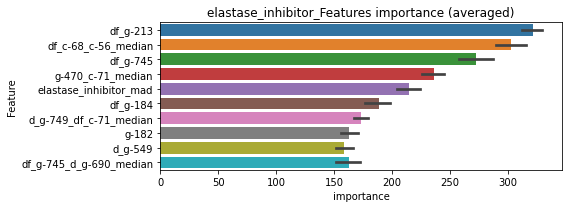

len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 elastase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0598517	valid_1's binary_logloss: 0.0710304
[200]	training's binary_logloss: 0.0127763	valid_1's binary_logloss: 0.0189858
[300]	training's binary_logloss: 0.00351203	valid_1's binary_logloss: 0.00827598
[400]	training's binary_logloss: 0.00135443	valid_1's binary_logloss: 0.00506127
[500]	training's binary_logloss: 0.000722577	valid_1's binary_logloss: 0.00384626
[600]	training's binary_logloss: 0.000479364	valid_1's binary_logloss: 0.00345184
[700]	training's binary_logloss: 0.000369796	valid_1's binary_logloss: 0.0031858
[800]	training's binary_logloss: 0.000332385	valid_1's binary_logloss: 0.00314371
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.000337437	valid_1's binary_logloss: 0.00313394


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 elastase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0601054	valid_1's binary_logloss: 0.0681757
[200]	training's binary_logloss: 0.012955	valid_1's binary_logloss: 0.0170961
[300]	training's binary_logloss: 0.00354754	valid_1's binary_logloss: 0.00580113
[400]	training's binary_logloss: 0.00136947	valid_1's binary_logloss: 0.00263216
[500]	training's binary_logloss: 0.000733228	valid_1's binary_logloss: 0.00157781
[600]	training's binary_logloss: 0.000483651	valid_1's binary_logloss: 0.00112818
[700]	training's binary_logloss: 0.000372529	valid_1's binary_logloss: 0.000916512
[800]	training's binary_logloss: 0.000339917	valid_1's binary_logloss: 0.000860928
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.000339917	valid_1's binary_logloss: 0.000860928


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 elastase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.060142	valid_1's binary_logloss: 0.071639
[200]	training's binary_logloss: 0.0130825	valid_1's binary_logloss: 0.0183029
[300]	training's binary_logloss: 0.00361012	valid_1's binary_logloss: 0.00594917
[400]	training's binary_logloss: 0.00139359	valid_1's binary_logloss: 0.00266266
[500]	training's binary_logloss: 0.000737955	valid_1's binary_logloss: 0.00164102
[600]	training's binary_logloss: 0.000493223	valid_1's binary_logloss: 0.00120958
[700]	training's binary_logloss: 0.000376962	valid_1's binary_logloss: 0.00099621
[800]	training's binary_logloss: 0.000333721	valid_1's binary_logloss: 0.000902663
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.000333721	valid_1's binary_logloss: 0.000902663


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 elastase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0604022	valid_1's binary_logloss: 0.0680189
[200]	training's binary_logloss: 0.0133393	valid_1's binary_logloss: 0.0171576
[300]	training's binary_logloss: 0.00367962	valid_1's binary_logloss: 0.00546227
[400]	training's binary_logloss: 0.00140249	valid_1's binary_logloss: 0.00240384
[500]	training's binary_logloss: 0.000742903	valid_1's binary_logloss: 0.00138372
[600]	training's binary_logloss: 0.000495261	valid_1's binary_logloss: 0.000988008
[700]	training's binary_logloss: 0.000380308	valid_1's binary_logloss: 0.000803101
[800]	training's binary_logloss: 0.000341962	valid_1's binary_logloss: 0.000728633
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.000338024	valid_1's binary_logloss: 0.000723694


elastase_inhibitor logloss: 0.0014053057810648098
erbb2_inhibitor, len(trt): 20, len(othr): 3287, target_rate: 0.0008398 → Adj_target_rate: 0.0010717


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0842927	valid_1's binary_logloss: 0.115175
[200]	training's binary_logloss: 0.025454	valid_1's binary_logloss: 0.0475475
[300]	training's binary_logloss: 0.008587	valid_1's binary_logloss: 0.0242648
[400]	training's binary_logloss: 0.00341586	valid_1's binary_logloss: 0.0145613
[500]	training's binary_logloss: 0.00170558	valid_1's binary_logloss: 0.010003
[600]	training's binary_logloss: 0.0010527	valid_1's binary_logloss: 0.00774155
[700]	training's binary_logloss: 0.000750669	valid_1's binary_logloss: 0.00664416
[800]	training's binary_logloss: 0.000594905	valid_1's binary_logloss: 0.00607337
[900]	training's binary_logloss: 0.000520277	valid_1's binary_logloss: 0.00582196
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.000531927	valid_1's binary_logloss: 0.00580773
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0869398

1 / 3 AUC score:1.000
y_Threshold: 0.0064692, Threshold: 0.0294482, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00084, Num_p_label: 40.0, conf_0:0.02061, conf_1:0.03828
Num_p_label: 40.0, Expected: 3.3, Adj_threshold_1: 0.0294482
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_2: 0.0594482
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_3: 0.0894482
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_4: 0.1194482
threshold: 0.1194482, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0792911	valid_1's binary_logloss: 0.10069
[200]	training's binary_logloss: 0.0221969	valid_1's binary_logloss: 0.0352912
[300]	training's binary_logloss: 0.0071467	valid_1's binary_logloss: 0.0146291
[400]	training's binary_logloss: 0.00285677	valid_1's binary_logloss: 0.00753068
[500]	training's binary_logloss: 0.00148032	valid_1's binary_logloss: 0.00482314
[600]	training's binary_logloss: 0.00093168	valid_1's binary_logloss: 0.00341182
[700]	training's binary_logloss: 0.000678184	valid_1's binary_logloss: 0.00277156
[800]	training's binary_logloss: 0.000545296	valid_1's binary_logloss: 0.00238509
[900]	training's binary_logloss: 0.000474566	valid_1's binary_logloss: 0.00218765
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000470471	valid_1's binary_logloss: 0.00218356
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

2 / 3 AUC score:1.000
y_Threshold: 0.1510118, Threshold: 0.1194482, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0105475 Vs.target_rate: 0.00084, Num_p_label: 42.0, conf_0:0.09556, conf_1:0.14334
Num_p_label: 42.0, Expected: 3.3, Adj_threshold_1: 0.1194482
Num_p_label: 32.0, Expected: 3.3, Adj_threshold_2: 0.1494482
Num_p_label: 28.0, Expected: 3.3, Adj_threshold_3: 0.1794482
Num_p_label: 24.0, Expected: 3.3, Adj_threshold_4: 0.2094482
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_5: 0.2394482
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_6: 0.2694482
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_7: 0.2994482
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_8: 0.3294482
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_9: 0.3594482
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_10: 0.3894482
threshold: 0.4194482, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0792911	valid_1's binary_logloss: 0.10069
[200]	training's binary_logloss: 0.0221969	valid_1's binary_logloss: 0.0352912
[300]	training's binary_logloss: 0.0071467	valid_1's binary_logloss: 0.0146291
[400]	training's binary_logloss: 0.00285677	valid_1's binary_logloss: 0.00753068
[500]	training's binary_logloss: 0.00148032	valid_1's binary_logloss: 0.00482314
[600]	training's binary_logloss: 0.00093168	valid_1's binary_logloss: 0.00341182
[700]	training's binary_logloss: 0.000678184	valid_1's binary_logloss: 0.00277156
[800]	training's binary_logloss: 0.000545296	valid_1's binary_logloss: 0.00238509
[900]	training's binary_logloss: 0.000474566	valid_1's binary_logloss: 0.00218765
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000470471	valid_1's binary_logloss: 0.00218356
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

3 / 3 AUC score:1.000
y_Threshold: 0.1510118, Threshold: 0.4194482, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0027624 Vs.target_rate: 0.00084, Num_p_label: 11.0, conf_0:0.37750, conf_1:0.46139
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.4194482
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_2: 0.4494482
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_3: 0.4794482
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_4: 0.5094482
threshold: 0.5094482, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


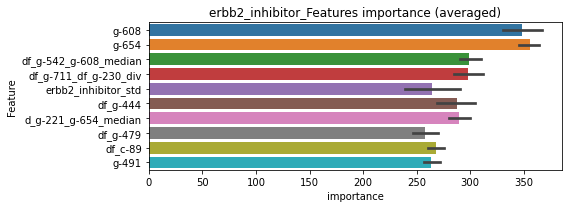

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0796818	valid_1's binary_logloss: 0.102624
[200]	training's binary_logloss: 0.0224985	valid_1's binary_logloss: 0.036784
[300]	training's binary_logloss: 0.00735781	valid_1's binary_logloss: 0.0158833
[400]	training's binary_logloss: 0.00289191	valid_1's binary_logloss: 0.00815378
[500]	training's binary_logloss: 0.00148451	valid_1's binary_logloss: 0.00507835
[600]	training's binary_logloss: 0.000936426	valid_1's binary_logloss: 0.00371364
[700]	training's binary_logloss: 0.000683762	valid_1's binary_logloss: 0.00300219
[800]	training's binary_logloss: 0.000547475	valid_1's binary_logloss: 0.00258149
[900]	training's binary_logloss: 0.00047739	valid_1's binary_logloss: 0.00240149
[1000]	training's binary_logloss: 0.000458121	valid_1's binary_logloss: 0.00236045
Early stopping, best iteration is:
[989]	training's binary_logloss: 0.000459938	valid_1's binary_logloss: 0.00235661


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0803672	valid_1's binary_logloss: 0.103595
[200]	training's binary_logloss: 0.022008	valid_1's binary_logloss: 0.0366448
[300]	training's binary_logloss: 0.00725373	valid_1's binary_logloss: 0.0157181
[400]	training's binary_logloss: 0.00286129	valid_1's binary_logloss: 0.00828919
[500]	training's binary_logloss: 0.00146913	valid_1's binary_logloss: 0.00550823
[600]	training's binary_logloss: 0.000926166	valid_1's binary_logloss: 0.00438322
[700]	training's binary_logloss: 0.000672286	valid_1's binary_logloss: 0.00379588
[800]	training's binary_logloss: 0.000537375	valid_1's binary_logloss: 0.00347545
[900]	training's binary_logloss: 0.000468719	valid_1's binary_logloss: 0.00330684
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.000466402	valid_1's binary_logloss: 0.00330508


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0795466	valid_1's binary_logloss: 0.102206
[200]	training's binary_logloss: 0.0223195	valid_1's binary_logloss: 0.0358863
[300]	training's binary_logloss: 0.00733068	valid_1's binary_logloss: 0.015366
[400]	training's binary_logloss: 0.00290424	valid_1's binary_logloss: 0.00770593
[500]	training's binary_logloss: 0.00147653	valid_1's binary_logloss: 0.00485567
[600]	training's binary_logloss: 0.000932161	valid_1's binary_logloss: 0.00357231
[700]	training's binary_logloss: 0.000673933	valid_1's binary_logloss: 0.00300168
[800]	training's binary_logloss: 0.000538358	valid_1's binary_logloss: 0.00257822
[900]	training's binary_logloss: 0.000474156	valid_1's binary_logloss: 0.00239943
[1000]	training's binary_logloss: 0.000459326	valid_1's binary_logloss: 0.00236092
Early stopping, best iteration is:
[982]	training's binary_logloss: 0.000459326	valid_1's binary_logloss: 0.00236092


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.079364	valid_1's binary_logloss: 0.10314
[200]	training's binary_logloss: 0.0216465	valid_1's binary_logloss: 0.039996
[300]	training's binary_logloss: 0.0070725	valid_1's binary_logloss: 0.0189961
[400]	training's binary_logloss: 0.00279184	valid_1's binary_logloss: 0.0108653
[500]	training's binary_logloss: 0.00144378	valid_1's binary_logloss: 0.00738576
[600]	training's binary_logloss: 0.000911328	valid_1's binary_logloss: 0.00581972
[700]	training's binary_logloss: 0.000658673	valid_1's binary_logloss: 0.00517985
[800]	training's binary_logloss: 0.000526516	valid_1's binary_logloss: 0.00465038
Early stopping, best iteration is:
[859]	training's binary_logloss: 0.000486281	valid_1's binary_logloss: 0.00452156


erbb2_inhibitor logloss: 0.0031416710966580305
estrogen_receptor_agonist, len(trt): 158, len(othr): 3270, target_rate: 0.0066348 → Adj_target_rate: 0.0062095


neg labels: 3289 → selected neg labels: 3270


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.172943	valid_1's binary_logloss: 0.29039
[200]	training's binary_logloss: 0.0926942	valid_1's binary_logloss: 0.247015
[300]	training's binary_logloss: 0.0532941	valid_1's binary_logloss: 0.227391
[400]	training's binary_logloss: 0.0308857	valid_1's binary_logloss: 0.221418
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.0291945	valid_1's binary_logloss: 0.22103
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.174844	valid_1's binary_logloss: 0.275349
[200]	training's binary_logloss: 0.090503	valid_1's binary_logloss: 0.225505
[300]	training's binary_logloss: 0.0511046	valid_1's binary_logloss: 0.203765
[400]	training's binary_logloss: 0.0305847	valid_1's binary_logloss: 0.193708
[500]	training's binary_logloss: 0.0182851	valid_1's binary_logloss: 0.188173
[600]	training's binary_logloss: 0.0115107	valid_1's binary_logloss:

1 / 3 AUC score:0.949
y_Threshold: 0.0696533, Threshold: 0.3713962, pos_neg_ratio: 0.8000000
Remove_noisy_data: 309 → Positive_corect_labels: 565/3615
p_label_rate: 0.0100452 Vs.target_rate: 0.00663, Num_p_label: 40.0, conf_0:0.25998, conf_1:0.48282
threshold: 0.3713962, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 565.0/3615, y_label_rate: 0.1562932
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132168	valid_1's binary_logloss: 0.201372
[200]	training's binary_logloss: 0.0595129	valid_1's binary_logloss: 0.148105
[300]	training's binary_logloss: 0.0295098	valid_1's binary_logloss: 0.124071
[400]	training's binary_logloss: 0.0153388	valid_1's binary_logloss: 0.112486
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0110842	valid_1's binary_logloss: 0.109623
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13407	valid_1's binary_logloss: 0.211689
[200]	training's binary_logloss: 0.0592383	valid_1's binary_logloss: 0.155317
[300]	training's binary_logloss: 0.0290006	valid_1's binary_logloss: 0.129496
[400]	training's binary_logloss: 0.0152149	valid_1's binary_logloss: 0.115019
[500]	training's binary_logloss: 0.00845404	valid_1's binary_logloss: 0.106209
[600]	training's binary_logloss: 0.00508956	valid_1's binary_logl

2 / 3 AUC score:0.985
y_Threshold: 0.1110749, Threshold: 0.3713962, pos_neg_ratio: 0.8000000
Remove_noisy_data: 80 → Positive_corect_labels: 525.0/3535
p_label_rate: 0.0369161 Vs.target_rate: 0.00663, Num_p_label: 147.0, conf_0:0.29712, conf_1:0.44568
Num_p_label: 147.0, Expected: 26.4, Adj_threshold_1: 0.3713962
Num_p_label: 136.0, Expected: 26.4, Adj_threshold_2: 0.4013962
Num_p_label: 122.0, Expected: 26.4, Adj_threshold_3: 0.4313962
Num_p_label: 114.0, Expected: 26.4, Adj_threshold_4: 0.4613962
Num_p_label: 101.0, Expected: 26.4, Adj_threshold_5: 0.4913962
Num_p_label: 95.0, Expected: 26.4, Adj_threshold_6: 0.5213962
Num_p_label: 88.0, Expected: 26.4, Adj_threshold_7: 0.5513962
Num_p_label: 79.0, Expected: 26.4, Adj_threshold_8: 0.5813962
Num_p_label: 71.0, Expected: 26.4, Adj_threshold_9: 0.6113962
Num_p_label: 66.0, Expected: 26.4, Adj_threshold_10: 0.6413962
threshold: 0.6713962, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 525.0/3535, y_label_rate: 0.1

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111183	valid_1's binary_logloss: 0.190244
[200]	training's binary_logloss: 0.0448297	valid_1's binary_logloss: 0.132569
[300]	training's binary_logloss: 0.0199473	valid_1's binary_logloss: 0.104754
[400]	training's binary_logloss: 0.00982086	valid_1's binary_logloss: 0.091857
[500]	training's binary_logloss: 0.00547985	valid_1's binary_logloss: 0.0845054
[600]	training's binary_logloss: 0.00331559	valid_1's binary_logloss: 0.0799045
[700]	training's binary_logloss: 0.00227906	valid_1's binary_logloss: 0.0764454
[800]	training's binary_logloss: 0.00170379	valid_1's binary_logloss: 0.0753357
[900]	training's binary_logloss: 0.00136548	valid_1's binary_logloss: 0.0742873
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.00131665	valid_1's binary_logloss: 0.0741044
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118543	valid_1's

3 / 3 AUC score:0.993
y_Threshold: 0.0950701, Threshold: 0.6713962, pos_neg_ratio: 0.8000000
Remove_noisy_data: 58 → Positive_corect_labels: 496.0/3477
p_label_rate: 0.0236062 Vs.target_rate: 0.00663, Num_p_label: 94.0, conf_0:0.50000, conf_1:0.73854
Num_p_label: 94.0, Expected: 26.4, Adj_threshold_1: 0.6713962
threshold: 0.6713962, positive_p_label: 94.0/3982, p_label_rate: 0.0236062
positive_y_label: 496.0/3477, y_label_rate: 0.1426517


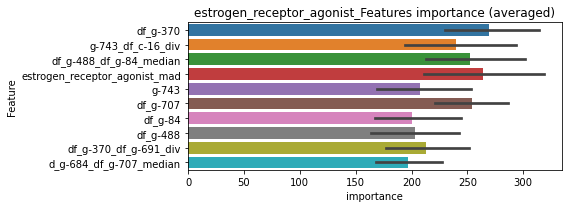

len(train_index) : 2607
len(valid_index) : 870
================================= fold 1/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104165	valid_1's binary_logloss: 0.161872
[200]	training's binary_logloss: 0.0392405	valid_1's binary_logloss: 0.105934
[300]	training's binary_logloss: 0.0169729	valid_1's binary_logloss: 0.0852208
[400]	training's binary_logloss: 0.00811071	valid_1's binary_logloss: 0.0755529
[500]	training's binary_logloss: 0.0043632	valid_1's binary_logloss: 0.0707759
[600]	training's binary_logloss: 0.00269764	valid_1's binary_logloss: 0.0686397
[700]	training's binary_logloss: 0.0018823	valid_1's binary_logloss: 0.0676868
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00197875	valid_1's binary_logloss: 0.0675061


len(train_index) : 2608
len(valid_index) : 869
================================= fold 2/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106294	valid_1's binary_logloss: 0.153728
[200]	training's binary_logloss: 0.0408635	valid_1's binary_logloss: 0.0964725
[300]	training's binary_logloss: 0.0172756	valid_1's binary_logloss: 0.0744923
[400]	training's binary_logloss: 0.00847517	valid_1's binary_logloss: 0.0679029
[500]	training's binary_logloss: 0.00454525	valid_1's binary_logloss: 0.0641211
[600]	training's binary_logloss: 0.00278375	valid_1's binary_logloss: 0.062968
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00300391	valid_1's binary_logloss: 0.06284


len(train_index) : 2608
len(valid_index) : 869
================================= fold 3/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10189	valid_1's binary_logloss: 0.152167
[200]	training's binary_logloss: 0.0393621	valid_1's binary_logloss: 0.0969508
[300]	training's binary_logloss: 0.0166229	valid_1's binary_logloss: 0.0742268
[400]	training's binary_logloss: 0.00803649	valid_1's binary_logloss: 0.0633821
[500]	training's binary_logloss: 0.00429139	valid_1's binary_logloss: 0.0580562
[600]	training's binary_logloss: 0.00266816	valid_1's binary_logloss: 0.0558107
[700]	training's binary_logloss: 0.0018724	valid_1's binary_logloss: 0.0545995
Early stopping, best iteration is:
[686]	training's binary_logloss: 0.00196004	valid_1's binary_logloss: 0.0544129


len(train_index) : 2608
len(valid_index) : 869
================================= fold 4/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100415	valid_1's binary_logloss: 0.171169
[200]	training's binary_logloss: 0.0387042	valid_1's binary_logloss: 0.119893
[300]	training's binary_logloss: 0.0172025	valid_1's binary_logloss: 0.100134
[400]	training's binary_logloss: 0.00825717	valid_1's binary_logloss: 0.0903113
[500]	training's binary_logloss: 0.00444072	valid_1's binary_logloss: 0.0834521
[600]	training's binary_logloss: 0.0027383	valid_1's binary_logloss: 0.0820897
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00297042	valid_1's binary_logloss: 0.0819139


estrogen_receptor_agonist logloss: 0.06666846394145892


neg labels: 3289 → selected neg labels: 3283


estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118756	valid_1's binary_logloss: 0.177095
[200]	training's binary_logloss: 0.0465103	valid_1's binary_logloss: 0.10376
[300]	training's binary_logloss: 0.0207202	valid_1's binary_logloss: 0.071988
[400]	training's binary_logloss: 0.00957873	valid_1's binary_logloss: 0.0561006
[500]	training's binary_logloss: 0.0047858	valid_1's binary_logloss: 0.045804
[600]	training's binary_logloss: 0.00276681	valid_1's binary_logloss: 0.0395927
[700]	training's binary_logloss: 0.00181389	valid_1's binary_logloss: 0.0367326
[800]	training's binary_logloss: 0.00134077	valid_1's binary_logloss: 0.0348888
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.00125241	valid_1's binary_logloss: 0.0346709
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115285	valid_1's binary_logloss: 0.166471
[200]	training's binary_logloss: 0.0474026	valid_1's bin

1 / 3 AUC score:1.000
y_Threshold: 0.0183605, Threshold: 0.4531319, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.31719, conf_1:0.58907
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.4531319
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_2: 0.4831319
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_3: 0.5131319
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_4: 0.5431319
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_5: 0.5731319
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_6: 0.6031319
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_7: 0.6331319
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_8: 0.6631319
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_9: 0.6931319
threshold: 0.6931319, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11749	valid_1's binary_logloss: 0.158731
[200]	training's binary_logloss: 0.0441149	valid_1's binary_logloss: 0.0822591
[300]	training's binary_logloss: 0.0185945	valid_1's binary_logloss: 0.0494521
[400]	training's binary_logloss: 0.00850599	valid_1's binary_logloss: 0.0338175
[500]	training's binary_logloss: 0.00425703	valid_1's binary_logloss: 0.0249997
[600]	training's binary_logloss: 0.0025443	valid_1's binary_logloss: 0.0208318
[700]	training's binary_logloss: 0.00170781	valid_1's binary_logloss: 0.0181547
[800]	training's binary_logloss: 0.00127696	valid_1's binary_logloss: 0.0164666
[900]	training's binary_logloss: 0.00102249	valid_1's binary_logloss: 0.0152686
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.000990027	valid_1's binary_logloss: 0.0152306
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117254	valid_1

2 / 3 AUC score:0.999
y_Threshold: 0.0769966, Threshold: 0.6931319, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 651.0/3797
p_label_rate: 0.0102963 Vs.target_rate: 0.00202, Num_p_label: 41.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_1: 0.6931319
threshold: 0.6931319, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 651.0/3797, y_label_rate: 0.1714511
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113793	valid_1's binary_logloss: 0.151037
[200]	training's binary_logloss: 0.0428191	valid_1's binary_logloss: 0.0784859
[300]	training's binary_logloss: 0.017389	valid_1's binary_logloss: 0.0469174
[400]	training's binary_logloss: 0.00775345	valid_1's binary_logloss: 0.0320756
[500]	training's binary_logloss: 0.0039837	valid_1's binary_logloss: 0.0235716
[600]	training's binary_logloss: 0.00240621	valid_1's binary_logloss: 0.0193619
[700]	training's binary_logloss: 0.00163558	valid_1's binary_logloss: 0.0167959
[800]	training's binary_logloss: 0.00122711	valid_1's binary_logloss: 0.0153502
[900]	training's binary_logloss: 0.000992441	valid_1's binary_logloss: 0.0143996
[1000]	training's binary_logloss: 0.000859737	valid_1's binary_logloss: 0.0139444
[1100]	training's binary_logloss: 0.00078714	valid_1's binary_logloss: 0.0138319
Early stopping, best iteration is:
[1077]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.0842657, Threshold: 0.6931319, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 647.0/3789
p_label_rate: 0.0097941 Vs.target_rate: 0.00202, Num_p_label: 39.0, conf_0:0.50000, conf_1:0.76245
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_1: 0.6931319
threshold: 0.6931319, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 647.0/3789, y_label_rate: 0.1707575


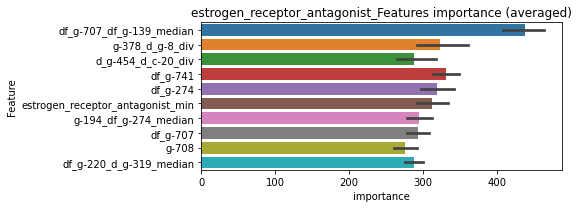

len(train_index) : 2841
len(valid_index) : 948
================================= fold 1/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11333	valid_1's binary_logloss: 0.160245
[200]	training's binary_logloss: 0.0417162	valid_1's binary_logloss: 0.0902386
[300]	training's binary_logloss: 0.0166296	valid_1's binary_logloss: 0.0600692
[400]	training's binary_logloss: 0.00749209	valid_1's binary_logloss: 0.0477377
[500]	training's binary_logloss: 0.00380065	valid_1's binary_logloss: 0.0399999
[600]	training's binary_logloss: 0.00226192	valid_1's binary_logloss: 0.0349295
[700]	training's binary_logloss: 0.00154621	valid_1's binary_logloss: 0.0331701
[800]	training's binary_logloss: 0.00116465	valid_1's binary_logloss: 0.0323289
[900]	training's binary_logloss: 0.000942906	valid_1's binary_logloss: 0.0315532
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000933302	valid_1's binary_logloss: 0.0314605


len(train_index) : 2842
len(valid_index) : 947
================================= fold 2/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112672	valid_1's binary_logloss: 0.155538
[200]	training's binary_logloss: 0.0411688	valid_1's binary_logloss: 0.0818716
[300]	training's binary_logloss: 0.0172847	valid_1's binary_logloss: 0.0528295
[400]	training's binary_logloss: 0.00770347	valid_1's binary_logloss: 0.0388316
[500]	training's binary_logloss: 0.00393323	valid_1's binary_logloss: 0.0321162
[600]	training's binary_logloss: 0.00232109	valid_1's binary_logloss: 0.0294665
[700]	training's binary_logloss: 0.00159069	valid_1's binary_logloss: 0.0276178
[800]	training's binary_logloss: 0.00118521	valid_1's binary_logloss: 0.0266228
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00103882	valid_1's binary_logloss: 0.0262459


len(train_index) : 2842
len(valid_index) : 947
================================= fold 3/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110263	valid_1's binary_logloss: 0.154781
[200]	training's binary_logloss: 0.0408717	valid_1's binary_logloss: 0.0842574
[300]	training's binary_logloss: 0.0164712	valid_1's binary_logloss: 0.0529364
[400]	training's binary_logloss: 0.00747618	valid_1's binary_logloss: 0.0382133
[500]	training's binary_logloss: 0.00382065	valid_1's binary_logloss: 0.031223
[600]	training's binary_logloss: 0.00227163	valid_1's binary_logloss: 0.0276938
[700]	training's binary_logloss: 0.00155537	valid_1's binary_logloss: 0.0253317
[800]	training's binary_logloss: 0.00117305	valid_1's binary_logloss: 0.0245428
[900]	training's binary_logloss: 0.000946717	valid_1's binary_logloss: 0.0235749


len(train_index) : 2842
len(valid_index) : 947
================================= fold 4/4 estrogen_receptor_antagonist=================================


Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000888653	valid_1's binary_logloss: 0.0234322
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113869	valid_1's binary_logloss: 0.148563
[200]	training's binary_logloss: 0.0425315	valid_1's binary_logloss: 0.0749807
[300]	training's binary_logloss: 0.0178001	valid_1's binary_logloss: 0.0439454
[400]	training's binary_logloss: 0.0078628	valid_1's binary_logloss: 0.0278713
[500]	training's binary_logloss: 0.00403364	valid_1's binary_logloss: 0.0201059
[600]	training's binary_logloss: 0.00239642	valid_1's binary_logloss: 0.0157287
[700]	training's binary_logloss: 0.00161321	valid_1's binary_logloss: 0.0133214
[800]	training's binary_logloss: 0.00119567	valid_1's binary_logloss: 0.0119752
[900]	training's binary_logloss: 0.000962322	valid_1's binary_logloss: 0.0112287
[1000]	training's binary_logloss: 0.000844076	valid_1's binary_logloss: 0.0108104
[1100]	training's binary_l

estrogen_receptor_antagonist logloss: 0.022903248731804104
faah_inhibitor, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103464	valid_1's binary_logloss: 0.143129
[200]	training's binary_logloss: 0.0373181	valid_1's binary_logloss: 0.0714593
[300]	training's binary_logloss: 0.0147952	valid_1's binary_logloss: 0.0410824
[400]	training's binary_logloss: 0.00660279	valid_1's binary_logloss: 0.0278543
[500]	training's binary_logloss: 0.00336396	valid_1's binary_logloss: 0.0206218
[600]	training's binary_logloss: 0.0020211	valid_1's binary_logloss: 0.0170181
[700]	training's binary_logloss: 0.0013854	valid_1's binary_logloss: 0.0152521
[800]	training's binary_logloss: 0.00104848	valid_1's binary_logloss: 0.0138924
[900]	training's binary_logloss: 0.000855761	valid_1's binary_logloss: 0.0132201
[1000]	training's binary_logloss: 0.000744959	valid_1's binary_logloss: 0.0127853
[1100]	training's binary_logloss: 0.000690221	valid_1's binary_logloss: 0.0126102
[1200]	training's binary_logloss: 0.00066378	valid_1's binary

1 / 3 AUC score:0.999
y_Threshold: 0.0145846, Threshold: 0.0825452, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.05778, conf_1:0.10731
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0825452
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_2: 0.1125452
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.1425452
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_4: 0.1725452
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.2025452
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_6: 0.2325452
threshold: 0.2325452, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0985956	valid_1's binary_logloss: 0.137563
[200]	training's binary_logloss: 0.0323306	valid_1's binary_logloss: 0.0678408
[300]	training's binary_logloss: 0.0124979	valid_1's binary_logloss: 0.0414712
[400]	training's binary_logloss: 0.00531806	valid_1's binary_logloss: 0.0296857
[500]	training's binary_logloss: 0.0027274	valid_1's binary_logloss: 0.0247614
[600]	training's binary_logloss: 0.00165789	valid_1's binary_logloss: 0.022727
[700]	training's binary_logloss: 0.0011565	valid_1's binary_logloss: 0.021749
[800]	training's binary_logloss: 0.000890351	valid_1's binary_logloss: 0.0214148
[900]	training's binary_logloss: 0.000730437	valid_1's binary_logloss: 0.0211833
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.000766287	valid_1's binary_logloss: 0.0211019
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959813	valid

2 / 3 AUC score:0.999
y_Threshold: 0.0661539, Threshold: 0.2325452, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0113009 Vs.target_rate: 0.00151, Num_p_label: 45.0, conf_0:0.18604, conf_1:0.27905
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_1: 0.2325452
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.2625452
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_3: 0.2925452
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_4: 0.3225452
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_5: 0.3525452
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_6: 0.3825452
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_7: 0.4125452
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_8: 0.4425452
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_9: 0.4725452
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_10: 0.5025452
threshold: 0.5025452, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 648.0/3792, y_label_rate: 0.1708861
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0966756	valid_1's binary_logloss: 0.124259
[200]	training's binary_logloss: 0.0322642	valid_1's binary_logloss: 0.0541885
[300]	training's binary_logloss: 0.0122818	valid_1's binary_logloss: 0.027402
[400]	training's binary_logloss: 0.00524282	valid_1's binary_logloss: 0.0162463
[500]	training's binary_logloss: 0.00265115	valid_1's binary_logloss: 0.0109308
[600]	training's binary_logloss: 0.0016172	valid_1's binary_logloss: 0.00802895
[700]	training's binary_logloss: 0.00113353	valid_1's binary_logloss: 0.00665813
[800]	training's binary_logloss: 0.000871182	valid_1's binary_logloss: 0.00587105
[900]	training's binary_logloss: 0.000721716	valid_1's binary_logloss: 0.00543848
[1000]	training's binary_logloss: 0.000640281	valid_1's binary_logloss: 0.0051405
Early stopping, best iteration is:
[1064]	training's binary_logloss: 0.000617466	valid_1's binary_logloss: 0.0050255
Training until valid

3 / 3 AUC score:1.000
y_Threshold: 0.0997327, Threshold: 0.5025452, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 646.0/3788
p_label_rate: 0.0047715 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.45229, conf_1:0.55280
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.5025452
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.5325452
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.5625452
threshold: 0.5625452, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 646.0/3788, y_label_rate: 0.1705385


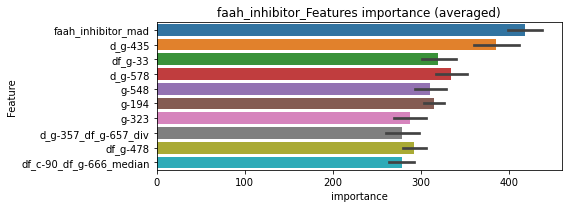

len(train_index) : 2841
len(valid_index) : 947
================================= fold 1/4 faah_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0966482	valid_1's binary_logloss: 0.128292
[200]	training's binary_logloss: 0.0314241	valid_1's binary_logloss: 0.0553979
[300]	training's binary_logloss: 0.0119107	valid_1's binary_logloss: 0.0291182
[400]	training's binary_logloss: 0.0050262	valid_1's binary_logloss: 0.0173009
[500]	training's binary_logloss: 0.00258585	valid_1's binary_logloss: 0.0117606
[600]	training's binary_logloss: 0.00158794	valid_1's binary_logloss: 0.00885153
[700]	training's binary_logloss: 0.00111754	valid_1's binary_logloss: 0.00735358
[800]	training's binary_logloss: 0.000860318	valid_1's binary_logloss: 0.00639472
[900]	training's binary_logloss: 0.000710233	valid_1's binary_logloss: 0.00577173
[1000]	training's binary_logloss: 0.000634138	valid_1's binary_logloss: 0.00549169
[1100]	training's binary_logloss: 0.000604013	valid_1's binary_logloss: 0.00537462
[1200]	training's binary_logloss: 0.000583018	valid_

len(train_index) : 2841
len(valid_index) : 947
================================= fold 2/4 faah_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0942419	valid_1's binary_logloss: 0.117213
[200]	training's binary_logloss: 0.0312463	valid_1's binary_logloss: 0.0504446
[300]	training's binary_logloss: 0.0118695	valid_1's binary_logloss: 0.0263277
[400]	training's binary_logloss: 0.00501496	valid_1's binary_logloss: 0.0159059
[500]	training's binary_logloss: 0.00255984	valid_1's binary_logloss: 0.0112228
[600]	training's binary_logloss: 0.00157714	valid_1's binary_logloss: 0.00877874
[700]	training's binary_logloss: 0.00111041	valid_1's binary_logloss: 0.00759485
[800]	training's binary_logloss: 0.000853955	valid_1's binary_logloss: 0.00672265
[900]	training's binary_logloss: 0.000706087	valid_1's binary_logloss: 0.00622113
[1000]	training's binary_logloss: 0.00062693	valid_1's binary_logloss: 0.0059184
[1100]	training's binary_logloss: 0.000598768	valid_1's binary_logloss: 0.00584247
Early stopping, best iteration is:
[1084]	training's 

len(train_index) : 2841
len(valid_index) : 947
================================= fold 3/4 faah_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0948785	valid_1's binary_logloss: 0.142394
[200]	training's binary_logloss: 0.0301677	valid_1's binary_logloss: 0.0682813
[300]	training's binary_logloss: 0.0110805	valid_1's binary_logloss: 0.0402181
[400]	training's binary_logloss: 0.00470805	valid_1's binary_logloss: 0.02794
[500]	training's binary_logloss: 0.00245362	valid_1's binary_logloss: 0.0217739
[600]	training's binary_logloss: 0.00153199	valid_1's binary_logloss: 0.0195498
[700]	training's binary_logloss: 0.00107433	valid_1's binary_logloss: 0.0183669
[800]	training's binary_logloss: 0.000835607	valid_1's binary_logloss: 0.0176502
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.000771746	valid_1's binary_logloss: 0.017439


len(train_index) : 2841
len(valid_index) : 947
================================= fold 4/4 faah_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0946044	valid_1's binary_logloss: 0.128397
[200]	training's binary_logloss: 0.0300854	valid_1's binary_logloss: 0.0562283
[300]	training's binary_logloss: 0.0112299	valid_1's binary_logloss: 0.0290173
[400]	training's binary_logloss: 0.00486463	valid_1's binary_logloss: 0.0175414
[500]	training's binary_logloss: 0.00251241	valid_1's binary_logloss: 0.0122141
[600]	training's binary_logloss: 0.0015585	valid_1's binary_logloss: 0.0095527
[700]	training's binary_logloss: 0.00109936	valid_1's binary_logloss: 0.00798007
[800]	training's binary_logloss: 0.000851926	valid_1's binary_logloss: 0.00711429
[900]	training's binary_logloss: 0.000706922	valid_1's binary_logloss: 0.00660829
[1000]	training's binary_logloss: 0.000626098	valid_1's binary_logloss: 0.00633976
[1100]	training's binary_logloss: 0.000599688	valid_1's binary_logloss: 0.00626286
Early stopping, best iteration is:
[1138]	training's 

faah_inhibitor logloss: 0.008705601308262341
farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0766954	valid_1's binary_logloss: 0.102798
[200]	training's binary_logloss: 0.0217801	valid_1's binary_logloss: 0.0378849
[300]	training's binary_logloss: 0.00700271	valid_1's binary_logloss: 0.0165829
[400]	training's binary_logloss: 0.00276712	valid_1's binary_logloss: 0.00929801
[500]	training's binary_logloss: 0.00143561	valid_1's binary_logloss: 0.00700101
[600]	training's binary_logloss: 0.000928468	valid_1's binary_logloss: 0.00589996
[700]	training's binary_logloss: 0.000678512	valid_1's binary_logloss: 0.00517289
[800]	training's binary_logloss: 0.000549064	valid_1's binary_logloss: 0.00488088
[900]	training's binary_logloss: 0.000489102	valid_1's binary_logloss: 0.00474246
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000495409	valid_1's binary_logloss: 0.00470151
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0049643, Threshold: 0.0282879, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01980, conf_1:0.03677
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0282879
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.0582879
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.0882879
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.1182879
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.1482879
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.1782879
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.2082879
threshold: 0.2082879, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0756612	valid_1's binary_logloss: 0.101141
[200]	training's binary_logloss: 0.0198863	valid_1's binary_logloss: 0.0348321
[300]	training's binary_logloss: 0.00600734	valid_1's binary_logloss: 0.0154164
[400]	training's binary_logloss: 0.00238265	valid_1's binary_logloss: 0.00988841
[500]	training's binary_logloss: 0.00123235	valid_1's binary_logloss: 0.00738077
[600]	training's binary_logloss: 0.000797667	valid_1's binary_logloss: 0.00650034
[700]	training's binary_logloss: 0.000588087	valid_1's binary_logloss: 0.00591866
[800]	training's binary_logloss: 0.000479794	valid_1's binary_logloss: 0.00564819
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.000465133	valid_1's binary_logloss: 0.00563076
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0759453	valid_1's binary_logloss: 0.0952014
[200]	training's binary_logloss: 0.01

2 / 3 AUC score:1.000
y_Threshold: 0.0573561, Threshold: 0.2082879, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0065294 Vs.target_rate: 0.00076, Num_p_label: 26.0, conf_0:0.16663, conf_1:0.24995
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.2082879
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.2382879
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.2682879
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_4: 0.2982879
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.3282879
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.3582879
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.3882879
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.4182879
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_9: 0.4482879
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_10: 0.4782879
threshold: 0.5082879, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0756645	valid_1's binary_logloss: 0.0969241
[200]	training's binary_logloss: 0.0193225	valid_1's binary_logloss: 0.033317
[300]	training's binary_logloss: 0.0059241	valid_1's binary_logloss: 0.0141942
[400]	training's binary_logloss: 0.00232517	valid_1's binary_logloss: 0.00761703
[500]	training's binary_logloss: 0.00121873	valid_1's binary_logloss: 0.00526531
[600]	training's binary_logloss: 0.000788392	valid_1's binary_logloss: 0.00414595
[700]	training's binary_logloss: 0.000585238	valid_1's binary_logloss: 0.00368072
[800]	training's binary_logloss: 0.000477537	valid_1's binary_logloss: 0.00334306
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000460524	valid_1's binary_logloss: 0.00330537
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0746957	valid_1's binary_logloss: 0.100383
[200]	training's binary_logloss: 0.0186

3 / 3 AUC score:1.000
y_Threshold: 0.0870197, Threshold: 0.5082879, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.45746, conf_1:0.55912
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.5082879
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.5382879
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.5682879
threshold: 0.5682879, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3811, y_label_rate: 0.1721333


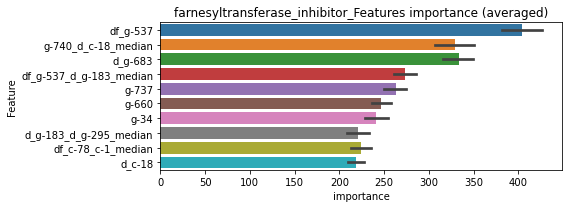

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0753871	valid_1's binary_logloss: 0.0993685
[200]	training's binary_logloss: 0.0196237	valid_1's binary_logloss: 0.0337871
[300]	training's binary_logloss: 0.0060295	valid_1's binary_logloss: 0.0146567
[400]	training's binary_logloss: 0.00234928	valid_1's binary_logloss: 0.00762657
[500]	training's binary_logloss: 0.00122704	valid_1's binary_logloss: 0.00524545
[600]	training's binary_logloss: 0.000796605	valid_1's binary_logloss: 0.00415439
[700]	training's binary_logloss: 0.000590574	valid_1's binary_logloss: 0.00363726
[800]	training's binary_logloss: 0.000482046	valid_1's binary_logloss: 0.00335094
[900]	training's binary_logloss: 0.000437835	valid_1's binary_logloss: 0.00324086
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.000439066	valid_1's binary_logloss: 0.00323535


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0747636	valid_1's binary_logloss: 0.10101
[200]	training's binary_logloss: 0.0188417	valid_1's binary_logloss: 0.0338646
[300]	training's binary_logloss: 0.00590781	valid_1's binary_logloss: 0.0148586
[400]	training's binary_logloss: 0.0023172	valid_1's binary_logloss: 0.00881433
[500]	training's binary_logloss: 0.00120217	valid_1's binary_logloss: 0.006697
[600]	training's binary_logloss: 0.000777334	valid_1's binary_logloss: 0.00563937
[700]	training's binary_logloss: 0.000576054	valid_1's binary_logloss: 0.00520337
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.000543774	valid_1's binary_logloss: 0.00509012


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0763132	valid_1's binary_logloss: 0.091426
[200]	training's binary_logloss: 0.0199736	valid_1's binary_logloss: 0.028061
[300]	training's binary_logloss: 0.00626269	valid_1's binary_logloss: 0.0105541
[400]	training's binary_logloss: 0.00245153	valid_1's binary_logloss: 0.00503983
[500]	training's binary_logloss: 0.00125755	valid_1's binary_logloss: 0.00298296
[600]	training's binary_logloss: 0.000808527	valid_1's binary_logloss: 0.00212635
[700]	training's binary_logloss: 0.000602118	valid_1's binary_logloss: 0.00171294
[800]	training's binary_logloss: 0.000488534	valid_1's binary_logloss: 0.00146151
[900]	training's binary_logloss: 0.000440236	valid_1's binary_logloss: 0.00135777
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000437252	valid_1's binary_logloss: 0.00135193


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0756689	valid_1's binary_logloss: 0.0939563
[200]	training's binary_logloss: 0.0200565	valid_1's binary_logloss: 0.0301085
[300]	training's binary_logloss: 0.00621831	valid_1's binary_logloss: 0.0114705
[400]	training's binary_logloss: 0.00241321	valid_1's binary_logloss: 0.0055114
[500]	training's binary_logloss: 0.00125513	valid_1's binary_logloss: 0.00342331
[600]	training's binary_logloss: 0.00081003	valid_1's binary_logloss: 0.00249139
[700]	training's binary_logloss: 0.000596201	valid_1's binary_logloss: 0.00201375
[800]	training's binary_logloss: 0.000488802	valid_1's binary_logloss: 0.00177653
[900]	training's binary_logloss: 0.000441311	valid_1's binary_logloss: 0.00164294
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.000431892	valid_1's binary_logloss: 0.0016211


farnesyltransferase_inhibitor logloss: 0.002825624545802593
fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.086502	valid_1's binary_logloss: 0.110388
[200]	training's binary_logloss: 0.0265356	valid_1's binary_logloss: 0.0445854
[300]	training's binary_logloss: 0.00892733	valid_1's binary_logloss: 0.0209733
[400]	training's binary_logloss: 0.00359273	valid_1's binary_logloss: 0.0120699
[500]	training's binary_logloss: 0.00182403	valid_1's binary_logloss: 0.00814261
[600]	training's binary_logloss: 0.00112939	valid_1's binary_logloss: 0.0063365
[700]	training's binary_logloss: 0.000806132	valid_1's binary_logloss: 0.00531184
[800]	training's binary_logloss: 0.000635965	valid_1's binary_logloss: 0.0048092
[900]	training's binary_logloss: 0.000545318	valid_1's binary_logloss: 0.00449885
[1000]	training's binary_logloss: 0.000514035	valid_1's binary_logloss: 0.00440118
[1100]	training's binary_logloss: 0.000501147	valid_1's binary_logloss: 0.00433218
Early stopping, best iteration is:
[1137]	training'

1 / 3 AUC score:1.000
y_Threshold: 0.0067286, Threshold: 0.0521370, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.03650, conf_1:0.06778
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0521370
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_2: 0.0821370
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_3: 0.1121370
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_4: 0.1421370
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_5: 0.1721370
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_6: 0.2021370
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_7: 0.2321370
threshold: 0.2321370, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0837032	valid_1's binary_logloss: 0.102939
[200]	training's binary_logloss: 0.0233308	valid_1's binary_logloss: 0.0364421
[300]	training's binary_logloss: 0.00757279	valid_1's binary_logloss: 0.0160404
[400]	training's binary_logloss: 0.00302927	valid_1's binary_logloss: 0.00875814
[500]	training's binary_logloss: 0.00156266	valid_1's binary_logloss: 0.00601646
[600]	training's binary_logloss: 0.000990869	valid_1's binary_logloss: 0.0046466
[700]	training's binary_logloss: 0.000722564	valid_1's binary_logloss: 0.0039762
[800]	training's binary_logloss: 0.000575877	valid_1's binary_logloss: 0.0035818
[900]	training's binary_logloss: 0.000494245	valid_1's binary_logloss: 0.0033367
[1000]	training's binary_logloss: 0.000465984	valid_1's binary_logloss: 0.00325854
Early stopping, best iteration is:
[1000]	training's binary_logloss: 0.000465984	valid_1's binary_logloss: 0.00325854
Training until 

2 / 3 AUC score:1.000
y_Threshold: 0.0919595, Threshold: 0.2321370, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0070316 Vs.target_rate: 0.00105, Num_p_label: 28.0, conf_0:0.18571, conf_1:0.27856
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_1: 0.2321370
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_2: 0.2621370
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_3: 0.2921370
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_4: 0.3221370
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_5: 0.3521370
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_6: 0.3821370
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_7: 0.4121370
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_8: 0.4421370
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_9: 0.4721370
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_10: 0.5021370
threshold: 0.5021370, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0847072	valid_1's binary_logloss: 0.108064
[200]	training's binary_logloss: 0.0237872	valid_1's binary_logloss: 0.0399639
[300]	training's binary_logloss: 0.00773332	valid_1's binary_logloss: 0.0179672
[400]	training's binary_logloss: 0.00309877	valid_1's binary_logloss: 0.00993356
[500]	training's binary_logloss: 0.00158329	valid_1's binary_logloss: 0.00648693
[600]	training's binary_logloss: 0.000991343	valid_1's binary_logloss: 0.00501084
[700]	training's binary_logloss: 0.000719039	valid_1's binary_logloss: 0.00417481
[800]	training's binary_logloss: 0.000569623	valid_1's binary_logloss: 0.00372885
[900]	training's binary_logloss: 0.000485019	valid_1's binary_logloss: 0.00348048
Early stopping, best iteration is:
[961]	training's binary_logloss: 0.000457899	valid_1's binary_logloss: 0.00341801
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0836116, Threshold: 0.5021370, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.45192, conf_1:0.55235
threshold: 0.5021370, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967


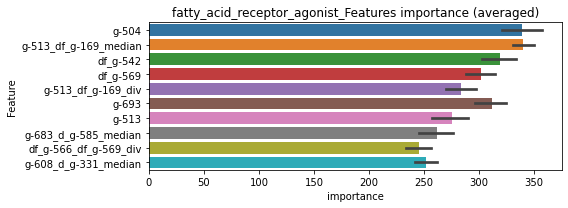

len(train_index) : 2854
len(valid_index) : 952
================================= fold 1/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.083942	valid_1's binary_logloss: 0.106665
[200]	training's binary_logloss: 0.0231907	valid_1's binary_logloss: 0.0400221
[300]	training's binary_logloss: 0.00741173	valid_1's binary_logloss: 0.0180998
[400]	training's binary_logloss: 0.00298814	valid_1's binary_logloss: 0.00979711
[500]	training's binary_logloss: 0.00155069	valid_1's binary_logloss: 0.00660731
[600]	training's binary_logloss: 0.0009835	valid_1's binary_logloss: 0.00499048
[700]	training's binary_logloss: 0.000713019	valid_1's binary_logloss: 0.00416049
[800]	training's binary_logloss: 0.000566771	valid_1's binary_logloss: 0.00365442
[900]	training's binary_logloss: 0.000488142	valid_1's binary_logloss: 0.00342413
[1000]	training's binary_logloss: 0.000458778	valid_1's binary_logloss: 0.00337589
Early stopping, best iteration is:
[1000]	training's binary_logloss: 0.000458778	valid_1's binary_logloss: 0.00337589


len(train_index) : 2854
len(valid_index) : 952
================================= fold 2/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0829879	valid_1's binary_logloss: 0.106487
[200]	training's binary_logloss: 0.0232792	valid_1's binary_logloss: 0.0394656
[300]	training's binary_logloss: 0.00750938	valid_1's binary_logloss: 0.0177421
[400]	training's binary_logloss: 0.00303488	valid_1's binary_logloss: 0.00991497
[500]	training's binary_logloss: 0.00157716	valid_1's binary_logloss: 0.0065087
[600]	training's binary_logloss: 0.000996562	valid_1's binary_logloss: 0.00500199
[700]	training's binary_logloss: 0.000718795	valid_1's binary_logloss: 0.00413423
[800]	training's binary_logloss: 0.000571557	valid_1's binary_logloss: 0.00367032
[900]	training's binary_logloss: 0.000489251	valid_1's binary_logloss: 0.00343482
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.000476861	valid_1's binary_logloss: 0.00339082


len(train_index) : 2855
len(valid_index) : 951
================================= fold 3/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0831762	valid_1's binary_logloss: 0.108353
[200]	training's binary_logloss: 0.0232569	valid_1's binary_logloss: 0.0407538
[300]	training's binary_logloss: 0.0075308	valid_1's binary_logloss: 0.0182173
[400]	training's binary_logloss: 0.00305223	valid_1's binary_logloss: 0.0101286
[500]	training's binary_logloss: 0.00157926	valid_1's binary_logloss: 0.00671341
[600]	training's binary_logloss: 0.000997356	valid_1's binary_logloss: 0.00495687
[700]	training's binary_logloss: 0.000720764	valid_1's binary_logloss: 0.00417247
[800]	training's binary_logloss: 0.000570213	valid_1's binary_logloss: 0.00362669
[900]	training's binary_logloss: 0.000492892	valid_1's binary_logloss: 0.00341215
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000471469	valid_1's binary_logloss: 0.00334831


len(train_index) : 2855
len(valid_index) : 951
================================= fold 4/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0841628	valid_1's binary_logloss: 0.104725
[200]	training's binary_logloss: 0.0240576	valid_1's binary_logloss: 0.0383891
[300]	training's binary_logloss: 0.00769402	valid_1's binary_logloss: 0.0173912
[400]	training's binary_logloss: 0.00305908	valid_1's binary_logloss: 0.00977199
[500]	training's binary_logloss: 0.00158304	valid_1's binary_logloss: 0.00695823
[600]	training's binary_logloss: 0.000993015	valid_1's binary_logloss: 0.00574364
[700]	training's binary_logloss: 0.000718891	valid_1's binary_logloss: 0.0049713
[800]	training's binary_logloss: 0.000568861	valid_1's binary_logloss: 0.00452273
[900]	training's binary_logloss: 0.000490731	valid_1's binary_logloss: 0.0042053
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.000462873	valid_1's binary_logloss: 0.00411942


fatty_acid_receptor_agonist logloss: 0.003568415534377104
fgfr_inhibitor, len(trt): 50, len(othr): 3284, target_rate: 0.0020996 → Adj_target_rate: 0.0023352


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130066	valid_1's binary_logloss: 0.203977
[200]	training's binary_logloss: 0.0554229	valid_1's binary_logloss: 0.131325
[300]	training's binary_logloss: 0.0252821	valid_1's binary_logloss: 0.0948426
[400]	training's binary_logloss: 0.0116464	valid_1's binary_logloss: 0.0749518
[500]	training's binary_logloss: 0.00583413	valid_1's binary_logloss: 0.064594
[600]	training's binary_logloss: 0.00332297	valid_1's binary_logloss: 0.0593847
[700]	training's binary_logloss: 0.00217495	valid_1's binary_logloss: 0.0569658
Early stopping, best iteration is:
[761]	training's binary_logloss: 0.00176479	valid_1's binary_logloss: 0.0554545
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133099	valid_1's binary_logloss: 0.182782
[200]	training's binary_logloss: 0.0570841	valid_1's binary_logloss: 0.109196
[300]	training's binary_logloss: 0.0267202	valid_1's bin

1 / 3 AUC score:0.997
y_Threshold: 0.0232294, Threshold: 0.1373869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 142 → Positive_corect_labels: 651/3798
p_label_rate: 0.0100452 Vs.target_rate: 0.00210, Num_p_label: 40.0, conf_0:0.09617, conf_1:0.17860
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_1: 0.1373869
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_2: 0.1673869
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_3: 0.1973869
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_4: 0.2273869
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_5: 0.2573869
threshold: 0.2573869, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 651.0/3798, y_label_rate: 0.1714060
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127241	valid_1's binary_logloss: 0.169093
[200]	training's binary_logloss: 0.0512037	valid_1's binary_logloss: 0.0936319
[300]	training's binary_logloss: 0.0225283	valid_1's binary_logloss: 0.059968
[400]	training's binary_logloss: 0.0103683	valid_1's binary_logloss: 0.0412475
[500]	training's binary_logloss: 0.00516543	valid_1's binary_logloss: 0.0319691
[600]	training's binary_logloss: 0.00295863	valid_1's binary_logloss: 0.027235
[700]	training's binary_logloss: 0.00193924	valid_1's binary_logloss: 0.0249325
[800]	training's binary_logloss: 0.00141868	valid_1's binary_logloss: 0.0234832
[900]	training's binary_logloss: 0.00111598	valid_1's binary_logloss: 0.0224273
[1000]	training's binary_logloss: 0.000945289	valid_1's binary_logloss: 0.0217308
Early stopping, best iteration is:
[1054]	training's binary_logloss: 0.000878924	valid_1's binary_logloss: 0.0214789
Training until validation sc

2 / 3 AUC score:1.000
y_Threshold: 0.1459436, Threshold: 0.2573869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 641.0/3778
p_label_rate: 0.0168257 Vs.target_rate: 0.00210, Num_p_label: 67.0, conf_0:0.20591, conf_1:0.30886
Num_p_label: 67.0, Expected: 8.4, Adj_threshold_1: 0.2573869
Num_p_label: 62.0, Expected: 8.4, Adj_threshold_2: 0.2873869
Num_p_label: 61.0, Expected: 8.4, Adj_threshold_3: 0.3173869
Num_p_label: 53.0, Expected: 8.4, Adj_threshold_4: 0.3473869
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_5: 0.3773869
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_6: 0.4073869
Num_p_label: 42.0, Expected: 8.4, Adj_threshold_7: 0.4373869
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_8: 0.4673869
Num_p_label: 34.0, Expected: 8.4, Adj_threshold_9: 0.4973869
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_10: 0.5273869
threshold: 0.5573869, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 641.0/3778, y_label_rate: 0.1696665
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119596	valid_1's binary_logloss: 0.175028
[200]	training's binary_logloss: 0.0455118	valid_1's binary_logloss: 0.0987905
[300]	training's binary_logloss: 0.0196269	valid_1's binary_logloss: 0.0652934
[400]	training's binary_logloss: 0.0087302	valid_1's binary_logloss: 0.047943
[500]	training's binary_logloss: 0.00441893	valid_1's binary_logloss: 0.0389614
[600]	training's binary_logloss: 0.00258792	valid_1's binary_logloss: 0.0344981
[700]	training's binary_logloss: 0.00174465	valid_1's binary_logloss: 0.0324876
[800]	training's binary_logloss: 0.00129922	valid_1's binary_logloss: 0.030562
[900]	training's binary_logloss: 0.00104086	valid_1's binary_logloss: 0.0299788
[1000]	training's binary_logloss: 0.000891481	valid_1's binary_logloss: 0.0291313
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.00088542	valid_1's binary_logloss: 0.0290572
Training until validation sco

3 / 3 AUC score:1.000
y_Threshold: 0.1657549, Threshold: 0.5573869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 631.0/3758
p_label_rate: 0.0095429 Vs.target_rate: 0.00210, Num_p_label: 38.0, conf_0:0.50000, conf_1:0.61313
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_1: 0.5573869
Num_p_label: 34.0, Expected: 8.4, Adj_threshold_2: 0.5873869
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_3: 0.6173869
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_4: 0.6473869
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_5: 0.6773869
threshold: 0.6773869, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 631.0/3758, y_label_rate: 0.1679085


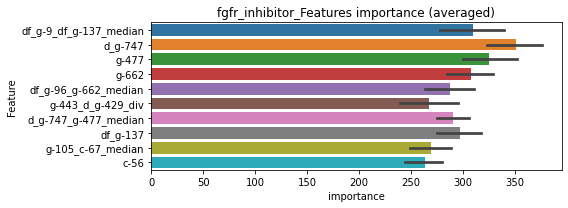

len(train_index) : 2818
len(valid_index) : 940
================================= fold 1/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115295	valid_1's binary_logloss: 0.166616
[200]	training's binary_logloss: 0.0432752	valid_1's binary_logloss: 0.0883703
[300]	training's binary_logloss: 0.0180746	valid_1's binary_logloss: 0.0551748
[400]	training's binary_logloss: 0.00809458	valid_1's binary_logloss: 0.0382393
[500]	training's binary_logloss: 0.00409319	valid_1's binary_logloss: 0.0293388
[600]	training's binary_logloss: 0.00240713	valid_1's binary_logloss: 0.0247929
[700]	training's binary_logloss: 0.00163979	valid_1's binary_logloss: 0.0230367
[800]	training's binary_logloss: 0.00122866	valid_1's binary_logloss: 0.0217992
[900]	training's binary_logloss: 0.000990432	valid_1's binary_logloss: 0.0209141
[1000]	training's binary_logloss: 0.000851027	valid_1's binary_logloss: 0.0205382
[1100]	training's binary_logloss: 0.000775923	valid_1's binary_logloss: 0.0203339
Early stopping, best iteration is:
[1085]	training's binary

len(train_index) : 2818
len(valid_index) : 940
================================= fold 2/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115349	valid_1's binary_logloss: 0.160477
[200]	training's binary_logloss: 0.0446031	valid_1's binary_logloss: 0.0884041
[300]	training's binary_logloss: 0.0191518	valid_1's binary_logloss: 0.057216
[400]	training's binary_logloss: 0.00851979	valid_1's binary_logloss: 0.0405478
[500]	training's binary_logloss: 0.00430177	valid_1's binary_logloss: 0.0316482
[600]	training's binary_logloss: 0.0025167	valid_1's binary_logloss: 0.0273359
[700]	training's binary_logloss: 0.00168797	valid_1's binary_logloss: 0.0245807
[800]	training's binary_logloss: 0.0012546	valid_1's binary_logloss: 0.0229618
[900]	training's binary_logloss: 0.00100081	valid_1's binary_logloss: 0.0219738
[1000]	training's binary_logloss: 0.000859683	valid_1's binary_logloss: 0.0215111
Early stopping, best iteration is:
[1008]	training's binary_logloss: 0.000852177	valid_1's binary_logloss: 0.0214687


len(train_index) : 2819
len(valid_index) : 939
================================= fold 3/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119258	valid_1's binary_logloss: 0.157553
[200]	training's binary_logloss: 0.0465731	valid_1's binary_logloss: 0.0826196
[300]	training's binary_logloss: 0.0197807	valid_1's binary_logloss: 0.0495124
[400]	training's binary_logloss: 0.00899347	valid_1's binary_logloss: 0.0327172
[500]	training's binary_logloss: 0.00443522	valid_1's binary_logloss: 0.022898
[600]	training's binary_logloss: 0.00260644	valid_1's binary_logloss: 0.0181637
[700]	training's binary_logloss: 0.00174735	valid_1's binary_logloss: 0.0153506
[800]	training's binary_logloss: 0.00129733	valid_1's binary_logloss: 0.0135184
[900]	training's binary_logloss: 0.00103234	valid_1's binary_logloss: 0.012361
[1000]	training's binary_logloss: 0.000884978	valid_1's binary_logloss: 0.0115481
[1100]	training's binary_logloss: 0.000797133	valid_1's binary_logloss: 0.0111182
Early stopping, best iteration is:
[1144]	training's binary_lo

len(train_index) : 2819
len(valid_index) : 939
================================= fold 4/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117676	valid_1's binary_logloss: 0.167833
[200]	training's binary_logloss: 0.0454579	valid_1's binary_logloss: 0.0933695
[300]	training's binary_logloss: 0.0188809	valid_1's binary_logloss: 0.0601415
[400]	training's binary_logloss: 0.00860379	valid_1's binary_logloss: 0.0422546
[500]	training's binary_logloss: 0.00434273	valid_1's binary_logloss: 0.0330448
[600]	training's binary_logloss: 0.00255369	valid_1's binary_logloss: 0.0281972
[700]	training's binary_logloss: 0.00171169	valid_1's binary_logloss: 0.0252112
[800]	training's binary_logloss: 0.00127923	valid_1's binary_logloss: 0.0237677
[900]	training's binary_logloss: 0.00102806	valid_1's binary_logloss: 0.0223881
[1000]	training's binary_logloss: 0.000882659	valid_1's binary_logloss: 0.0217773
Early stopping, best iteration is:
[1023]	training's binary_logloss: 0.000860623	valid_1's binary_logloss: 0.021681


fgfr_inhibitor logloss: 0.018619107915814354


neg labels: 3289 → selected neg labels: 3258


flt3_inhibitor, len(trt): 279, len(othr): 3258, target_rate: 0.0117158 → Adj_target_rate: 0.0100684
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.241131	valid_1's binary_logloss: 0.367356
[200]	training's binary_logloss: 0.15342	valid_1's binary_logloss: 0.340646
[300]	training's binary_logloss: 0.102689	valid_1's binary_logloss: 0.330946
[400]	training's binary_logloss: 0.069351	valid_1's binary_logloss: 0.326776
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0769765	valid_1's binary_logloss: 0.326048
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.240665	valid_1's binary_logloss: 0.354892
[200]	training's binary_logloss: 0.14823	valid_1's binary_logloss: 0.322492
[300]	training's binary_logloss: 0.101751	valid_1's binary_logloss: 0.303781
[400]	training's binary_logloss: 0.0688548	valid_1's binary_logloss: 0.293739
[500]	training's binary_logloss: 0.0469816	valid_1's binary_logloss: 0.288521
[600]	training's binary_logloss: 0.0319679	valid_1's binary_logloss: 0.2

1 / 3 AUC score:0.841
y_Threshold: 0.1275944, Threshold: 0.6832262, pos_neg_ratio: 0.8000000
Remove_noisy_data: 541 → Positive_corect_labels: 446/3368
p_label_rate: 0.0100452 Vs.target_rate: 0.01172, Num_p_label: 40.0, conf_0:0.47826, conf_1:0.80000
threshold: 0.6832262, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 446.0/3368, y_label_rate: 0.1324228
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131298	valid_1's binary_logloss: 0.208686
[200]	training's binary_logloss: 0.0592213	valid_1's binary_logloss: 0.152244
[300]	training's binary_logloss: 0.0303754	valid_1's binary_logloss: 0.126772
[400]	training's binary_logloss: 0.0161385	valid_1's binary_logloss: 0.112839
[500]	training's binary_logloss: 0.00922756	valid_1's binary_logloss: 0.103566
[600]	training's binary_logloss: 0.00564954	valid_1's binary_logloss: 0.0990158
[700]	training's binary_logloss: 0.00374849	valid_1's binary_logloss: 0.0957303
[800]	training's binary_logloss: 0.0026935	valid_1's binary_logloss: 0.0947456
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.00267905	valid_1's binary_logloss: 0.0946892
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131824	valid_1's binary_logloss: 0.228914
[200]	training's binary_logloss: 0.0608364	valid_1's bina

2 / 3 AUC score:0.980
y_Threshold: 0.1301072, Threshold: 0.6832262, pos_neg_ratio: 0.8000000
Remove_noisy_data: 124 → Positive_corect_labels: 384.0/3244
p_label_rate: 0.0306379 Vs.target_rate: 0.01172, Num_p_label: 122.0, conf_0:0.50000, conf_1:0.80000
threshold: 0.6832262, positive_p_label: 122.0/3982, p_label_rate: 0.0306379
positive_y_label: 384.0/3244, y_label_rate: 0.1183724
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103439	valid_1's binary_logloss: 0.172089
[200]	training's binary_logloss: 0.0427057	valid_1's binary_logloss: 0.131349
[300]	training's binary_logloss: 0.0199259	valid_1's binary_logloss: 0.11614
[400]	training's binary_logloss: 0.00980302	valid_1's binary_logloss: 0.109404
[500]	training's binary_logloss: 0.00526166	valid_1's binary_logloss: 0.107625
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00467637	valid_1's binary_logloss: 0.106827
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100107	valid_1's binary_logloss: 0.168328
[200]	training's binary_logloss: 0.0402599	valid_1's binary_logloss: 0.124918
[300]	training's binary_logloss: 0.0181906	valid_1's binary_logloss: 0.108945
[400]	training's binary_logloss: 0.00922238	valid_1's binary_logloss: 0.10269
Early stopping, best iteration is:
[463]	training's binary_logl

3 / 3 AUC score:0.978
y_Threshold: 0.1051168, Threshold: 0.6832262, pos_neg_ratio: 0.8000000
Remove_noisy_data: 86 → Positive_corect_labels: 341.0/3158
p_label_rate: 0.0421899 Vs.target_rate: 0.01172, Num_p_label: 168.0, conf_0:0.50000, conf_1:0.75155
Num_p_label: 168.0, Expected: 46.7, Adj_threshold_1: 0.6832262
threshold: 0.6832262, positive_p_label: 168.0/3982, p_label_rate: 0.0421899
positive_y_label: 341.0/3158, y_label_rate: 0.1079797


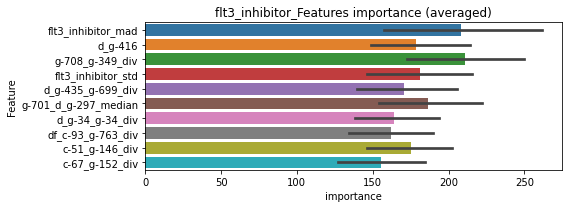

len(train_index) : 2368
len(valid_index) : 790
================================= fold 1/4 flt3_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0809546	valid_1's binary_logloss: 0.143625
[200]	training's binary_logloss: 0.0281376	valid_1's binary_logloss: 0.0945981
[300]	training's binary_logloss: 0.0117909	valid_1's binary_logloss: 0.0739343
[400]	training's binary_logloss: 0.0056344	valid_1's binary_logloss: 0.0636868
[500]	training's binary_logloss: 0.00311794	valid_1's binary_logloss: 0.0583987
[600]	training's binary_logloss: 0.00199677	valid_1's binary_logloss: 0.055041
[700]	training's binary_logloss: 0.00143805	valid_1's binary_logloss: 0.0535147
[800]	training's binary_logloss: 0.00112502	valid_1's binary_logloss: 0.0522501
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00117784	valid_1's binary_logloss: 0.0521432


len(train_index) : 2368
len(valid_index) : 790
================================= fold 2/4 flt3_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0837789	valid_1's binary_logloss: 0.137554
[200]	training's binary_logloss: 0.0296438	valid_1's binary_logloss: 0.093826
[300]	training's binary_logloss: 0.0125054	valid_1's binary_logloss: 0.0775031
[400]	training's binary_logloss: 0.00588394	valid_1's binary_logloss: 0.0688996
[500]	training's binary_logloss: 0.00323138	valid_1's binary_logloss: 0.0654398
[600]	training's binary_logloss: 0.00204955	valid_1's binary_logloss: 0.0647037
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.0017183	valid_1's binary_logloss: 0.0639853


len(train_index) : 2369
len(valid_index) : 789
================================= fold 3/4 flt3_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0829238	valid_1's binary_logloss: 0.142717
[200]	training's binary_logloss: 0.0300551	valid_1's binary_logloss: 0.0933034
[300]	training's binary_logloss: 0.0126485	valid_1's binary_logloss: 0.0709536
[400]	training's binary_logloss: 0.00607736	valid_1's binary_logloss: 0.0595901
[500]	training's binary_logloss: 0.00332434	valid_1's binary_logloss: 0.05182
[600]	training's binary_logloss: 0.00209498	valid_1's binary_logloss: 0.0481972
[700]	training's binary_logloss: 0.00149406	valid_1's binary_logloss: 0.0457327
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.00143182	valid_1's binary_logloss: 0.045318


len(train_index) : 2369
len(valid_index) : 789
================================= fold 4/4 flt3_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0799651	valid_1's binary_logloss: 0.136523
[200]	training's binary_logloss: 0.0288544	valid_1's binary_logloss: 0.093001
[300]	training's binary_logloss: 0.0120466	valid_1's binary_logloss: 0.0758575
[400]	training's binary_logloss: 0.0057479	valid_1's binary_logloss: 0.0676666
[500]	training's binary_logloss: 0.00314444	valid_1's binary_logloss: 0.0630596
[600]	training's binary_logloss: 0.00198949	valid_1's binary_logloss: 0.0602149
[700]	training's binary_logloss: 0.00142538	valid_1's binary_logloss: 0.0585584
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.00149528	valid_1's binary_logloss: 0.0584495


flt3_inhibitor logloss: 0.05497599602417484
focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3289, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838943	valid_1's binary_logloss: 0.106253
[200]	training's binary_logloss: 0.0250188	valid_1's binary_logloss: 0.0420456
[300]	training's binary_logloss: 0.00830315	valid_1's binary_logloss: 0.0209011
[400]	training's binary_logloss: 0.00335502	valid_1's binary_logloss: 0.0132361
[500]	training's binary_logloss: 0.00171168	valid_1's binary_logloss: 0.010436
[600]	training's binary_logloss: 0.00107426	valid_1's binary_logloss: 0.00931814
[700]	training's binary_logloss: 0.000771829	valid_1's binary_logloss: 0.0084921
[800]	training's binary_logloss: 0.000614052	valid_1's binary_logloss: 0.00808113
[900]	training's binary_logloss: 0.000534935	valid_1's binary_logloss: 0.00789766
[1000]	training's binary_logloss: 0.000510075	valid_1's binary_logloss: 0.00786973
Early stopping, best iteration is:
[1006]	training's binary_logloss: 0.000510019	valid_1's binary_logloss: 0.00786574
Training until v

1 / 3 AUC score:1.000
y_Threshold: 0.0057766, Threshold: 0.0348551, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02440, conf_1:0.04531
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0348551
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.0648551
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.0948551
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.1248551
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.1548551
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.1848551
threshold: 0.1848551, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0813919	valid_1's binary_logloss: 0.102556
[200]	training's binary_logloss: 0.0224397	valid_1's binary_logloss: 0.0376342
[300]	training's binary_logloss: 0.0070845	valid_1's binary_logloss: 0.0181409
[400]	training's binary_logloss: 0.00282464	valid_1's binary_logloss: 0.0119658
[500]	training's binary_logloss: 0.00145545	valid_1's binary_logloss: 0.00984958
[600]	training's binary_logloss: 0.000929701	valid_1's binary_logloss: 0.00887717
[700]	training's binary_logloss: 0.000680668	valid_1's binary_logloss: 0.00860078
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000581068	valid_1's binary_logloss: 0.00842333
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0830963	valid_1's binary_logloss: 0.0982804
[200]	training's binary_logloss: 0.0234169	valid_1's binary_logloss: 0.0325678
[300]	training's binary_logloss: 0.0075220

2 / 3 AUC score:1.000
y_Threshold: 0.0743488, Threshold: 0.1848551, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0050226 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.14788, conf_1:0.22183
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.1848551
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.2148551
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.2448551
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.2748551
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.3048551
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.3348551
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.3648551
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.3948551
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.4248551
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.4548551
threshold: 0.4848551, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0813919	valid_1's binary_logloss: 0.102556
[200]	training's binary_logloss: 0.0224397	valid_1's binary_logloss: 0.0376342
[300]	training's binary_logloss: 0.0070845	valid_1's binary_logloss: 0.0181409
[400]	training's binary_logloss: 0.00282464	valid_1's binary_logloss: 0.0119658
[500]	training's binary_logloss: 0.00145545	valid_1's binary_logloss: 0.00984958
[600]	training's binary_logloss: 0.000929701	valid_1's binary_logloss: 0.00887717
[700]	training's binary_logloss: 0.000680668	valid_1's binary_logloss: 0.00860078
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000581068	valid_1's binary_logloss: 0.00842333
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0830963	valid_1's binary_logloss: 0.0982804
[200]	training's binary_logloss: 0.0234169	valid_1's binary_logloss: 0.0325678
[300]	training's binary_logloss: 0.0075220

3 / 3 AUC score:1.000
y_Threshold: 0.0743488, Threshold: 0.4848551, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.43637, conf_1:0.53334
threshold: 0.4848551, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


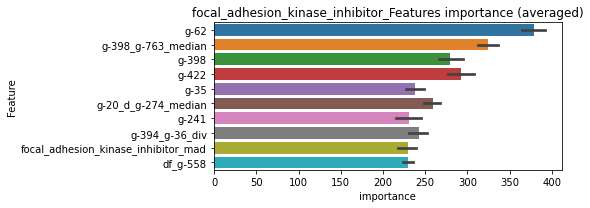

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0801266	valid_1's binary_logloss: 0.100141
[200]	training's binary_logloss: 0.0218626	valid_1's binary_logloss: 0.036371
[300]	training's binary_logloss: 0.00707719	valid_1's binary_logloss: 0.0174962
[400]	training's binary_logloss: 0.00283337	valid_1's binary_logloss: 0.0113325
[500]	training's binary_logloss: 0.00144786	valid_1's binary_logloss: 0.0093878
[600]	training's binary_logloss: 0.00092208	valid_1's binary_logloss: 0.00864215
[700]	training's binary_logloss: 0.000676501	valid_1's binary_logloss: 0.00845188
Early stopping, best iteration is:
[729]	training's binary_logloss: 0.000632658	valid_1's binary_logloss: 0.00837534


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0812705	valid_1's binary_logloss: 0.0963839
[200]	training's binary_logloss: 0.0222491	valid_1's binary_logloss: 0.0313336
[300]	training's binary_logloss: 0.00731115	valid_1's binary_logloss: 0.0129362
[400]	training's binary_logloss: 0.00288288	valid_1's binary_logloss: 0.0063159
[500]	training's binary_logloss: 0.00149614	valid_1's binary_logloss: 0.00384075
[600]	training's binary_logloss: 0.000957151	valid_1's binary_logloss: 0.00280845
[700]	training's binary_logloss: 0.000691858	valid_1's binary_logloss: 0.00224352
[800]	training's binary_logloss: 0.00055321	valid_1's binary_logloss: 0.00193861
[900]	training's binary_logloss: 0.000479775	valid_1's binary_logloss: 0.00176203
[1000]	training's binary_logloss: 0.000459399	valid_1's binary_logloss: 0.00172848
Early stopping, best iteration is:
[1033]	training's binary_logloss: 0.000455374	valid_1's binary_logloss: 0.00172502


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0812	valid_1's binary_logloss: 0.0997772
[200]	training's binary_logloss: 0.0222814	valid_1's binary_logloss: 0.034217
[300]	training's binary_logloss: 0.0072892	valid_1's binary_logloss: 0.0147432
[400]	training's binary_logloss: 0.00287986	valid_1's binary_logloss: 0.00801709
[500]	training's binary_logloss: 0.00149545	valid_1's binary_logloss: 0.00544993
[600]	training's binary_logloss: 0.000952597	valid_1's binary_logloss: 0.0040068
[700]	training's binary_logloss: 0.00069067	valid_1's binary_logloss: 0.00332239
[800]	training's binary_logloss: 0.000550987	valid_1's binary_logloss: 0.00293603
[900]	training's binary_logloss: 0.000482752	valid_1's binary_logloss: 0.00274335
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.000465245	valid_1's binary_logloss: 0.0026999


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0796749	valid_1's binary_logloss: 0.102346
[200]	training's binary_logloss: 0.0212473	valid_1's binary_logloss: 0.037423
[300]	training's binary_logloss: 0.00686739	valid_1's binary_logloss: 0.0173791
[400]	training's binary_logloss: 0.00277504	valid_1's binary_logloss: 0.00994337
[500]	training's binary_logloss: 0.00145636	valid_1's binary_logloss: 0.00677682
[600]	training's binary_logloss: 0.000937489	valid_1's binary_logloss: 0.00536371
[700]	training's binary_logloss: 0.000683314	valid_1's binary_logloss: 0.00470103
[800]	training's binary_logloss: 0.000546512	valid_1's binary_logloss: 0.00427092
[900]	training's binary_logloss: 0.000480146	valid_1's binary_logloss: 0.00405248
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000470911	valid_1's binary_logloss: 0.0040323


focal_adhesion_kinase_inhibitor logloss: 0.0042092304978440945
free_radical_scavenger, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0759988	valid_1's binary_logloss: 0.0987008
[200]	training's binary_logloss: 0.0225553	valid_1's binary_logloss: 0.0417157
[300]	training's binary_logloss: 0.00740625	valid_1's binary_logloss: 0.0225792
[400]	training's binary_logloss: 0.00284237	valid_1's binary_logloss: 0.0149675
[500]	training's binary_logloss: 0.00142807	valid_1's binary_logloss: 0.0117196
[600]	training's binary_logloss: 0.00090474	valid_1's binary_logloss: 0.0104981
[700]	training's binary_logloss: 0.000655715	valid_1's binary_logloss: 0.00970852
[800]	training's binary_logloss: 0.000519413	valid_1's binary_logloss: 0.00933419
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000515832	valid_1's binary_logloss: 0.00931148
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0774668	valid_1's binary_logloss: 0.0942488
[200]	training's binary_logloss: 0.02362

1 / 3 AUC score:1.000
y_Threshold: 0.0051410, Threshold: 0.0339624, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02377, conf_1:0.04415
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0339624
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.0639624
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.0939624
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.1239624
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.1539624
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.1839624
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.2139624
threshold: 0.2139624, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0726851	valid_1's binary_logloss: 0.0865306
[200]	training's binary_logloss: 0.0192574	valid_1's binary_logloss: 0.0281051
[300]	training's binary_logloss: 0.00603851	valid_1's binary_logloss: 0.0117396
[400]	training's binary_logloss: 0.00235969	valid_1's binary_logloss: 0.00606443
[500]	training's binary_logloss: 0.00121564	valid_1's binary_logloss: 0.00384698
[600]	training's binary_logloss: 0.000786559	valid_1's binary_logloss: 0.00283981
[700]	training's binary_logloss: 0.000580197	valid_1's binary_logloss: 0.00234069
[800]	training's binary_logloss: 0.000468611	valid_1's binary_logloss: 0.00205064
[900]	training's binary_logloss: 0.000418718	valid_1's binary_logloss: 0.00190868
[1000]	training's binary_logloss: 0.000401486	valid_1's binary_logloss: 0.00186873
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000401521	valid_1's binary_logloss: 0.00186846
Training un

2 / 3 AUC score:1.000
y_Threshold: 0.0418186, Threshold: 0.2139624, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0062783 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.17117, conf_1:0.25675
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.2139624
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.2439624
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.2739624
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.3039624
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.3339624
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.3639624
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.3939624
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.4239624
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.4539624
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.4839624
threshold: 0.5139624, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
===========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0732575	valid_1's binary_logloss: 0.0906799
[200]	training's binary_logloss: 0.0190147	valid_1's binary_logloss: 0.0312025
[300]	training's binary_logloss: 0.00587913	valid_1's binary_logloss: 0.0138927
[400]	training's binary_logloss: 0.00233537	valid_1's binary_logloss: 0.00704281
[500]	training's binary_logloss: 0.00120075	valid_1's binary_logloss: 0.00436828
[600]	training's binary_logloss: 0.000769647	valid_1's binary_logloss: 0.00317008
[700]	training's binary_logloss: 0.000567886	valid_1's binary_logloss: 0.00258775
[800]	training's binary_logloss: 0.000459593	valid_1's binary_logloss: 0.00223864
[900]	training's binary_logloss: 0.000414341	valid_1's binary_logloss: 0.00210597
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.000406562	valid_1's binary_logloss: 0.00208284
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0490036, Threshold: 0.5139624, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.46257, conf_1:0.56536
threshold: 0.5139624, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3811, y_label_rate: 0.1721333


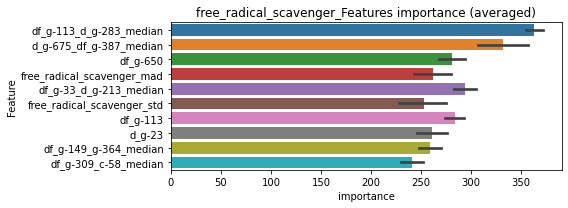

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 free_radical_scavenger=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720493	valid_1's binary_logloss: 0.0908379
[200]	training's binary_logloss: 0.0186508	valid_1's binary_logloss: 0.0316714
[300]	training's binary_logloss: 0.00590188	valid_1's binary_logloss: 0.0139452
[400]	training's binary_logloss: 0.00232175	valid_1's binary_logloss: 0.00716809
[500]	training's binary_logloss: 0.00120077	valid_1's binary_logloss: 0.00445647
[600]	training's binary_logloss: 0.000773197	valid_1's binary_logloss: 0.0032316
[700]	training's binary_logloss: 0.000569464	valid_1's binary_logloss: 0.00264188
[800]	training's binary_logloss: 0.000462879	valid_1's binary_logloss: 0.00228924
Early stopping, best iteration is:
[839]	training's binary_logloss: 0.000440106	valid_1's binary_logloss: 0.00223585


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 free_radical_scavenger=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0737264	valid_1's binary_logloss: 0.0879451
[200]	training's binary_logloss: 0.0189751	valid_1's binary_logloss: 0.0277185
[300]	training's binary_logloss: 0.00592008	valid_1's binary_logloss: 0.0107634
[400]	training's binary_logloss: 0.00232916	valid_1's binary_logloss: 0.00526188
[500]	training's binary_logloss: 0.00121136	valid_1's binary_logloss: 0.00326912
[600]	training's binary_logloss: 0.000778618	valid_1's binary_logloss: 0.00237693
[700]	training's binary_logloss: 0.000575543	valid_1's binary_logloss: 0.00194625
[800]	training's binary_logloss: 0.000464606	valid_1's binary_logloss: 0.00170162
[900]	training's binary_logloss: 0.000426756	valid_1's binary_logloss: 0.00160714
[1000]	training's binary_logloss: 0.000415389	valid_1's binary_logloss: 0.00158414
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000415389	valid_1's binary_logloss: 0.00158414


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 free_radical_scavenger=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0735901	valid_1's binary_logloss: 0.0861455
[200]	training's binary_logloss: 0.0194397	valid_1's binary_logloss: 0.0273696
[300]	training's binary_logloss: 0.00619951	valid_1's binary_logloss: 0.0107472
[400]	training's binary_logloss: 0.00238714	valid_1's binary_logloss: 0.00491016
[500]	training's binary_logloss: 0.00123582	valid_1's binary_logloss: 0.00293932
[600]	training's binary_logloss: 0.000785131	valid_1's binary_logloss: 0.00206937
[700]	training's binary_logloss: 0.000578232	valid_1's binary_logloss: 0.00163736
[800]	training's binary_logloss: 0.00046786	valid_1's binary_logloss: 0.00139494
[900]	training's binary_logloss: 0.000425523	valid_1's binary_logloss: 0.00131538
[1000]	training's binary_logloss: 0.000414874	valid_1's binary_logloss: 0.00129694
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.000414874	valid_1's binary_logloss: 0.00129694


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 free_radical_scavenger=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0721518	valid_1's binary_logloss: 0.0995723
[200]	training's binary_logloss: 0.0185649	valid_1's binary_logloss: 0.0378986
[300]	training's binary_logloss: 0.00581558	valid_1's binary_logloss: 0.020058
[400]	training's binary_logloss: 0.00224569	valid_1's binary_logloss: 0.0130769
[500]	training's binary_logloss: 0.00116666	valid_1's binary_logloss: 0.0103069
[600]	training's binary_logloss: 0.000756647	valid_1's binary_logloss: 0.00896122
[700]	training's binary_logloss: 0.000560446	valid_1's binary_logloss: 0.00824879
[800]	training's binary_logloss: 0.000454955	valid_1's binary_logloss: 0.00794043
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.000427237	valid_1's binary_logloss: 0.00772273


free_radical_scavenger logloss: 0.0032087315599138512
fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3287, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0907457	valid_1's binary_logloss: 0.125219
[200]	training's binary_logloss: 0.0273304	valid_1's binary_logloss: 0.0507134
[300]	training's binary_logloss: 0.00982494	valid_1's binary_logloss: 0.0247473
[400]	training's binary_logloss: 0.00407465	valid_1's binary_logloss: 0.0145459
[500]	training's binary_logloss: 0.00208712	valid_1's binary_logloss: 0.0102524
[600]	training's binary_logloss: 0.00130519	valid_1's binary_logloss: 0.00833246
[700]	training's binary_logloss: 0.000936731	valid_1's binary_logloss: 0.00726985
[800]	training's binary_logloss: 0.000731471	valid_1's binary_logloss: 0.0065273
[900]	training's binary_logloss: 0.000613772	valid_1's binary_logloss: 0.006138
[1000]	training's binary_logloss: 0.000556167	valid_1's binary_logloss: 0.00599161
[1100]	training's binary_logloss: 0.000537508	valid_1's binary_logloss: 0.00595771
Early stopping, best iteration is:
[1116]	training's

1 / 3 AUC score:1.000
y_Threshold: 0.0069784, Threshold: 0.0504363, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00097, Num_p_label: 40.0, conf_0:0.03531, conf_1:0.06557
Num_p_label: 40.0, Expected: 3.8, Adj_threshold_1: 0.0504363
Num_p_label: 27.0, Expected: 3.8, Adj_threshold_2: 0.0804363
Num_p_label: 21.0, Expected: 3.8, Adj_threshold_3: 0.1104363
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_4: 0.1404363
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_5: 0.1704363
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_6: 0.2004363
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_7: 0.2304363
threshold: 0.2304363, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0861295	valid_1's binary_logloss: 0.118526
[200]	training's binary_logloss: 0.0248489	valid_1's binary_logloss: 0.0461559
[300]	training's binary_logloss: 0.00838134	valid_1's binary_logloss: 0.0215291
[400]	training's binary_logloss: 0.00348337	valid_1's binary_logloss: 0.012149
[500]	training's binary_logloss: 0.00178752	valid_1's binary_logloss: 0.00845088
[600]	training's binary_logloss: 0.00111958	valid_1's binary_logloss: 0.00648913
[700]	training's binary_logloss: 0.000808528	valid_1's binary_logloss: 0.0054759
[800]	training's binary_logloss: 0.000632469	valid_1's binary_logloss: 0.00480818
[900]	training's binary_logloss: 0.000541015	valid_1's binary_logloss: 0.00451265
[1000]	training's binary_logloss: 0.000509163	valid_1's binary_logloss: 0.00439803
Early stopping, best iteration is:
[987]	training's binary_logloss: 0.000509163	valid_1's binary_logloss: 0.00439803
Training until v

2 / 3 AUC score:1.000
y_Threshold: 0.1095592, Threshold: 0.2304363, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0087896 Vs.target_rate: 0.00097, Num_p_label: 35.0, conf_0:0.18435, conf_1:0.27652
Num_p_label: 35.0, Expected: 3.8, Adj_threshold_1: 0.2304363
Num_p_label: 30.0, Expected: 3.8, Adj_threshold_2: 0.2604363
Num_p_label: 26.0, Expected: 3.8, Adj_threshold_3: 0.2904363
Num_p_label: 25.0, Expected: 3.8, Adj_threshold_4: 0.3204363
Num_p_label: 22.0, Expected: 3.8, Adj_threshold_5: 0.3504363
Num_p_label: 20.0, Expected: 3.8, Adj_threshold_6: 0.3804363
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_7: 0.4104363
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_8: 0.4404363
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_9: 0.4704363
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_10: 0.5004363
threshold: 0.5304363, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3808, y_label_rate: 0.1720063
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0870519	valid_1's binary_logloss: 0.116316
[200]	training's binary_logloss: 0.0248497	valid_1's binary_logloss: 0.0453161
[300]	training's binary_logloss: 0.0082147	valid_1's binary_logloss: 0.0205598
[400]	training's binary_logloss: 0.00338936	valid_1's binary_logloss: 0.0114405
[500]	training's binary_logloss: 0.00177118	valid_1's binary_logloss: 0.00758524
[600]	training's binary_logloss: 0.00110899	valid_1's binary_logloss: 0.00574161
[700]	training's binary_logloss: 0.000801838	valid_1's binary_logloss: 0.0046941
[800]	training's binary_logloss: 0.00063057	valid_1's binary_logloss: 0.0040918
[900]	training's binary_logloss: 0.000533066	valid_1's binary_logloss: 0.00377512
[1000]	training's binary_logloss: 0.00049418	valid_1's binary_logloss: 0.00367939
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.000490386	valid_1's binary_logloss: 0.00366296
Training until val

3 / 3 AUC score:1.000
y_Threshold: 0.0729322, Threshold: 0.5304363, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3806
p_label_rate: 0.0030136 Vs.target_rate: 0.00097, Num_p_label: 12.0, conf_0:0.47739, conf_1:0.58348
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_1: 0.5304363
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_2: 0.5604363
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_3: 0.5904363
threshold: 0.5904363, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 654.0/3806, y_label_rate: 0.1718339


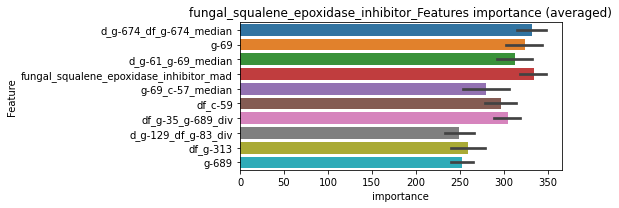

len(train_index) : 2854
len(valid_index) : 952
================================= fold 1/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0886619	valid_1's binary_logloss: 0.120842
[200]	training's binary_logloss: 0.025367	valid_1's binary_logloss: 0.04724
[300]	training's binary_logloss: 0.00847507	valid_1's binary_logloss: 0.022967
[400]	training's binary_logloss: 0.00344996	valid_1's binary_logloss: 0.0135301
[500]	training's binary_logloss: 0.00177477	valid_1's binary_logloss: 0.00951129
[600]	training's binary_logloss: 0.00111672	valid_1's binary_logloss: 0.007745
[700]	training's binary_logloss: 0.000802079	valid_1's binary_logloss: 0.00652613
[800]	training's binary_logloss: 0.000627874	valid_1's binary_logloss: 0.00583148
[900]	training's binary_logloss: 0.000540314	valid_1's binary_logloss: 0.0054804
[1000]	training's binary_logloss: 0.000509792	valid_1's binary_logloss: 0.00540324
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.000509478	valid_1's binary_logloss: 0.00539572


len(train_index) : 2854
len(valid_index) : 952
================================= fold 2/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0862557	valid_1's binary_logloss: 0.117321
[200]	training's binary_logloss: 0.0248483	valid_1's binary_logloss: 0.0467225
[300]	training's binary_logloss: 0.00866054	valid_1's binary_logloss: 0.0228703
[400]	training's binary_logloss: 0.00380495	valid_1's binary_logloss: 0.0138744
[500]	training's binary_logloss: 0.00183697	valid_1's binary_logloss: 0.00910647
[600]	training's binary_logloss: 0.00111441	valid_1's binary_logloss: 0.00756388
[700]	training's binary_logloss: 0.000794107	valid_1's binary_logloss: 0.00647222
[800]	training's binary_logloss: 0.000622669	valid_1's binary_logloss: 0.00579361
[900]	training's binary_logloss: 0.000530677	valid_1's binary_logloss: 0.00542751
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000528103	valid_1's binary_logloss: 0.00541713


len(train_index) : 2855
len(valid_index) : 951
================================= fold 3/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0875371	valid_1's binary_logloss: 0.113191
[200]	training's binary_logloss: 0.0250056	valid_1's binary_logloss: 0.0433956
[300]	training's binary_logloss: 0.00841371	valid_1's binary_logloss: 0.0197155
[400]	training's binary_logloss: 0.00346468	valid_1's binary_logloss: 0.0115209
[500]	training's binary_logloss: 0.00178589	valid_1's binary_logloss: 0.00822022
[600]	training's binary_logloss: 0.00112449	valid_1's binary_logloss: 0.00665449
[700]	training's binary_logloss: 0.000811307	valid_1's binary_logloss: 0.00586459
[800]	training's binary_logloss: 0.00063879	valid_1's binary_logloss: 0.0053817
[900]	training's binary_logloss: 0.000547942	valid_1's binary_logloss: 0.00514404
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000541663	valid_1's binary_logloss: 0.0051382


len(train_index) : 2855
len(valid_index) : 951
================================= fold 4/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0875937	valid_1's binary_logloss: 0.110205
[200]	training's binary_logloss: 0.0252051	valid_1's binary_logloss: 0.0409096
[300]	training's binary_logloss: 0.00855587	valid_1's binary_logloss: 0.0188436
[400]	training's binary_logloss: 0.00345752	valid_1's binary_logloss: 0.0106255
[500]	training's binary_logloss: 0.00179343	valid_1's binary_logloss: 0.00750563
[600]	training's binary_logloss: 0.00112517	valid_1's binary_logloss: 0.00597913
[700]	training's binary_logloss: 0.000805318	valid_1's binary_logloss: 0.00520313
[800]	training's binary_logloss: 0.000635091	valid_1's binary_logloss: 0.00477793
[900]	training's binary_logloss: 0.000541384	valid_1's binary_logloss: 0.00449886
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.000510278	valid_1's binary_logloss: 0.00445905


fungal_squalene_epoxidase_inhibitor logloss: 0.0051075029359086265
gaba_receptor_agonist, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.152609	valid_1's binary_logloss: 0.257617
[200]	training's binary_logloss: 0.0726739	valid_1's binary_logloss: 0.198436
[300]	training's binary_logloss: 0.0385737	valid_1's binary_logloss: 0.168843
[400]	training's binary_logloss: 0.0215545	valid_1's binary_logloss: 0.153753
[500]	training's binary_logloss: 0.0120681	valid_1's binary_logloss: 0.147116
[600]	training's binary_logloss: 0.00701395	valid_1's binary_logloss: 0.143502
[700]	training's binary_logloss: 0.00440584	valid_1's binary_logloss: 0.142916
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.0045738	valid_1's binary_logloss: 0.142766
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.157581	valid_1's binary_logloss: 0.239693
[200]	training's binary_logloss: 0.0817162	valid_1's binary_logloss: 0.177985
[300]	training's binary_logloss: 0.0442991	valid_1's binary_log

1 / 3 AUC score:0.982
y_Threshold: 0.0510910, Threshold: 0.3342915, pos_neg_ratio: 0.8000000
Remove_noisy_data: 215 → Positive_corect_labels: 612/3710
p_label_rate: 0.0100452 Vs.target_rate: 0.00445, Num_p_label: 40.0, conf_0:0.23400, conf_1:0.43458
threshold: 0.3342915, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 612.0/3710, y_label_rate: 0.1649596
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132095	valid_1's binary_logloss: 0.2022
[200]	training's binary_logloss: 0.0556511	valid_1's binary_logloss: 0.133245
[300]	training's binary_logloss: 0.0265892	valid_1's binary_logloss: 0.103077
[400]	training's binary_logloss: 0.0130922	valid_1's binary_logloss: 0.0872587
[500]	training's binary_logloss: 0.00697684	valid_1's binary_logloss: 0.0778432
[600]	training's binary_logloss: 0.00409535	valid_1's binary_logloss: 0.073405
[700]	training's binary_logloss: 0.00269763	valid_1's binary_logloss: 0.0728648
[800]	training's binary_logloss: 0.00194311	valid_1's binary_logloss: 0.0714589
Early stopping, best iteration is:
[782]	training's binary_logloss: 0.00204836	valid_1's binary_logloss: 0.0710811
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131522	valid_1's binary_logloss: 0.201265
[200]	training's binary_logloss: 0.0577917	valid_1's bina

2 / 3 AUC score:0.996
y_Threshold: 0.1358332, Threshold: 0.3342915, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 584.0/3654
p_label_rate: 0.0288800 Vs.target_rate: 0.00445, Num_p_label: 115.0, conf_0:0.26743, conf_1:0.40115
Num_p_label: 115.0, Expected: 17.7, Adj_threshold_1: 0.3342915
Num_p_label: 107.0, Expected: 17.7, Adj_threshold_2: 0.3642915
Num_p_label: 98.0, Expected: 17.7, Adj_threshold_3: 0.3942915
Num_p_label: 88.0, Expected: 17.7, Adj_threshold_4: 0.4242915
Num_p_label: 85.0, Expected: 17.7, Adj_threshold_5: 0.4542915
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_6: 0.4842915
Num_p_label: 76.0, Expected: 17.7, Adj_threshold_7: 0.5142915
Num_p_label: 68.0, Expected: 17.7, Adj_threshold_8: 0.5442915
Num_p_label: 64.0, Expected: 17.7, Adj_threshold_9: 0.5742915
Num_p_label: 59.0, Expected: 17.7, Adj_threshold_10: 0.6042915
threshold: 0.6342915, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 584.0/3654, y_label_rate: 0.1598

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121198	valid_1's binary_logloss: 0.189913
[200]	training's binary_logloss: 0.0486392	valid_1's binary_logloss: 0.123364
[300]	training's binary_logloss: 0.0220309	valid_1's binary_logloss: 0.0915706
[400]	training's binary_logloss: 0.0105786	valid_1's binary_logloss: 0.0765644
[500]	training's binary_logloss: 0.00561335	valid_1's binary_logloss: 0.0681556
[600]	training's binary_logloss: 0.00330898	valid_1's binary_logloss: 0.0625488
[700]	training's binary_logloss: 0.00222382	valid_1's binary_logloss: 0.0608159
[800]	training's binary_logloss: 0.00163132	valid_1's binary_logloss: 0.0589515
[900]	training's binary_logloss: 0.0012875	valid_1's binary_logloss: 0.0579476
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.00131228	valid_1's binary_logloss: 0.057869
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123276	valid_1's 

3 / 3 AUC score:0.997
y_Threshold: 0.1351342, Threshold: 0.6342915, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 565.0/3616
p_label_rate: 0.0185836 Vs.target_rate: 0.00445, Num_p_label: 74.0, conf_0:0.50000, conf_1:0.69772
Num_p_label: 74.0, Expected: 17.7, Adj_threshold_1: 0.6342915
Num_p_label: 70.0, Expected: 17.7, Adj_threshold_2: 0.6642915
Num_p_label: 68.0, Expected: 17.7, Adj_threshold_3: 0.6942915
threshold: 0.6942915, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 565.0/3616, y_label_rate: 0.1562500


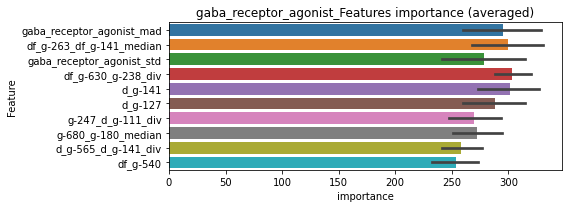

len(train_index) : 2712
len(valid_index) : 904
================================= fold 1/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12148	valid_1's binary_logloss: 0.185087
[200]	training's binary_logloss: 0.0495249	valid_1's binary_logloss: 0.117158
[300]	training's binary_logloss: 0.0217206	valid_1's binary_logloss: 0.0854473
[400]	training's binary_logloss: 0.0106579	valid_1's binary_logloss: 0.0707105
[500]	training's binary_logloss: 0.00544001	valid_1's binary_logloss: 0.0625291
[600]	training's binary_logloss: 0.00317982	valid_1's binary_logloss: 0.0579007
[700]	training's binary_logloss: 0.00209959	valid_1's binary_logloss: 0.0552828
[800]	training's binary_logloss: 0.00153072	valid_1's binary_logloss: 0.0541627
[900]	training's binary_logloss: 0.00120931	valid_1's binary_logloss: 0.0529509
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.00112539	valid_1's binary_logloss: 0.0528938


len(train_index) : 2712
len(valid_index) : 904
================================= fold 2/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119876	valid_1's binary_logloss: 0.159274
[200]	training's binary_logloss: 0.0471938	valid_1's binary_logloss: 0.0886214
[300]	training's binary_logloss: 0.0205038	valid_1's binary_logloss: 0.0574501
[400]	training's binary_logloss: 0.0097058	valid_1's binary_logloss: 0.0422143
[500]	training's binary_logloss: 0.0050173	valid_1's binary_logloss: 0.0352695
[600]	training's binary_logloss: 0.00298049	valid_1's binary_logloss: 0.0317511
[700]	training's binary_logloss: 0.00200301	valid_1's binary_logloss: 0.030259
[800]	training's binary_logloss: 0.00148424	valid_1's binary_logloss: 0.0291565
[900]	training's binary_logloss: 0.00118288	valid_1's binary_logloss: 0.0283551
[1000]	training's binary_logloss: 0.00100554	valid_1's binary_logloss: 0.0278581
Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.000993241	valid_1's binary_logloss: 0.0278161


len(train_index) : 2712
len(valid_index) : 904
================================= fold 3/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120653	valid_1's binary_logloss: 0.175298
[200]	training's binary_logloss: 0.0473709	valid_1's binary_logloss: 0.106704
[300]	training's binary_logloss: 0.0209613	valid_1's binary_logloss: 0.0767942
[400]	training's binary_logloss: 0.00967389	valid_1's binary_logloss: 0.0623492
[500]	training's binary_logloss: 0.00508669	valid_1's binary_logloss: 0.0544786
[600]	training's binary_logloss: 0.00302962	valid_1's binary_logloss: 0.050144
[700]	training's binary_logloss: 0.00202182	valid_1's binary_logloss: 0.0473832
[800]	training's binary_logloss: 0.0014891	valid_1's binary_logloss: 0.0465839
Early stopping, best iteration is:
[859]	training's binary_logloss: 0.00128791	valid_1's binary_logloss: 0.0457502


len(train_index) : 2712
len(valid_index) : 904
================================= fold 4/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11552	valid_1's binary_logloss: 0.181665
[200]	training's binary_logloss: 0.0459487	valid_1's binary_logloss: 0.115353
[300]	training's binary_logloss: 0.0203871	valid_1's binary_logloss: 0.086674
[400]	training's binary_logloss: 0.00963753	valid_1's binary_logloss: 0.0719824
[500]	training's binary_logloss: 0.00504105	valid_1's binary_logloss: 0.0639415
[600]	training's binary_logloss: 0.00299366	valid_1's binary_logloss: 0.0605615
[700]	training's binary_logloss: 0.0020022	valid_1's binary_logloss: 0.0582049
[800]	training's binary_logloss: 0.00148365	valid_1's binary_logloss: 0.0571092
Early stopping, best iteration is:
[863]	training's binary_logloss: 0.00127427	valid_1's binary_logloss: 0.056375


gaba_receptor_agonist logloss: 0.04570878350077591
gaba_receptor_antagonist, len(trt): 165, len(othr): 3266, target_rate: 0.0069287 → Adj_target_rate: 0.0064426


neg labels: 3289 → selected neg labels: 3266


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.182211	valid_1's binary_logloss: 0.294493
[200]	training's binary_logloss: 0.100668	valid_1's binary_logloss: 0.240946
[300]	training's binary_logloss: 0.0588412	valid_1's binary_logloss: 0.209677
[400]	training's binary_logloss: 0.0355596	valid_1's binary_logloss: 0.193377
[500]	training's binary_logloss: 0.0216693	valid_1's binary_logloss: 0.182562
[600]	training's binary_logloss: 0.013234	valid_1's binary_logloss: 0.176435
Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00995071	valid_1's binary_logloss: 0.174809
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.185715	valid_1's binary_logloss: 0.287992
[200]	training's binary_logloss: 0.10351	valid_1's binary_logloss: 0.240617
[300]	training's binary_logloss: 0.0614489	valid_1's binary_logloss: 0.214886
[400]	training's binary_logloss: 0.0362165	valid_1's binary_logloss:

1 / 3 AUC score:0.950
y_Threshold: 0.0726915, Threshold: 0.3750296, pos_neg_ratio: 0.8000000
Remove_noisy_data: 301 → Positive_corect_labels: 568/3618
p_label_rate: 0.0100452 Vs.target_rate: 0.00693, Num_p_label: 40.0, conf_0:0.26252, conf_1:0.48754
threshold: 0.3750296, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 568.0/3618, y_label_rate: 0.1569928
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145324	valid_1's binary_logloss: 0.225816
[200]	training's binary_logloss: 0.067735	valid_1's binary_logloss: 0.164894
[300]	training's binary_logloss: 0.0351167	valid_1's binary_logloss: 0.137555
[400]	training's binary_logloss: 0.0184294	valid_1's binary_logloss: 0.122233
[500]	training's binary_logloss: 0.0102449	valid_1's binary_logloss: 0.114098
[600]	training's binary_logloss: 0.005976	valid_1's binary_logloss: 0.109853
[700]	training's binary_logloss: 0.00379273	valid_1's binary_logloss: 0.107778
[800]	training's binary_logloss: 0.0026279	valid_1's binary_logloss: 0.106661
Early stopping, best iteration is:
[771]	training's binary_logloss: 0.00288752	valid_1's binary_logloss: 0.106225
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141093	valid_1's binary_logloss: 0.236367
[200]	training's binary_logloss: 0.0651081	valid_1's binary_loglo

2 / 3 AUC score:0.985
y_Threshold: 0.0947357, Threshold: 0.3750296, pos_neg_ratio: 0.8000000
Remove_noisy_data: 98 → Positive_corect_labels: 519.0/3520
p_label_rate: 0.0339026 Vs.target_rate: 0.00693, Num_p_label: 135.0, conf_0:0.30002, conf_1:0.45004
Num_p_label: 135.0, Expected: 27.6, Adj_threshold_1: 0.3750296
Num_p_label: 123.0, Expected: 27.6, Adj_threshold_2: 0.4050296
Num_p_label: 116.0, Expected: 27.6, Adj_threshold_3: 0.4350296
Num_p_label: 111.0, Expected: 27.6, Adj_threshold_4: 0.4650296
Num_p_label: 108.0, Expected: 27.6, Adj_threshold_5: 0.4950296
Num_p_label: 101.0, Expected: 27.6, Adj_threshold_6: 0.5250296
Num_p_label: 94.0, Expected: 27.6, Adj_threshold_7: 0.5550296
Num_p_label: 88.0, Expected: 27.6, Adj_threshold_8: 0.5850296
Num_p_label: 86.0, Expected: 27.6, Adj_threshold_9: 0.6150296
Num_p_label: 82.0, Expected: 27.6, Adj_threshold_10: 0.6450296
threshold: 0.6750296, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 519.0/3520, y_label_rate: 0.

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112246	valid_1's binary_logloss: 0.224515
[200]	training's binary_logloss: 0.0468453	valid_1's binary_logloss: 0.185012
[300]	training's binary_logloss: 0.0215873	valid_1's binary_logloss: 0.168875
[400]	training's binary_logloss: 0.0105303	valid_1's binary_logloss: 0.166153
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0123702	valid_1's binary_logloss: 0.165479
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116584	valid_1's binary_logloss: 0.192892
[200]	training's binary_logloss: 0.0494411	valid_1's binary_logloss: 0.131289
[300]	training's binary_logloss: 0.0242742	valid_1's binary_logloss: 0.106925
[400]	training's binary_logloss: 0.0120929	valid_1's binary_logloss: 0.0920807
[500]	training's binary_logloss: 0.00633069	valid_1's binary_logloss: 0.0851726
[600]	training's binary_logloss: 0.00373543	valid_1's binary_l

3 / 3 AUC score:0.981
y_Threshold: 0.0702833, Threshold: 0.6750296, pos_neg_ratio: 0.8000000
Remove_noisy_data: 84 → Positive_corect_labels: 477.0/3436
p_label_rate: 0.0283777 Vs.target_rate: 0.00693, Num_p_label: 113.0, conf_0:0.50000, conf_1:0.74253
Num_p_label: 113.0, Expected: 27.6, Adj_threshold_1: 0.6750296
threshold: 0.6750296, positive_p_label: 113.0/3982, p_label_rate: 0.0283777
positive_y_label: 477.0/3436, y_label_rate: 0.1388242


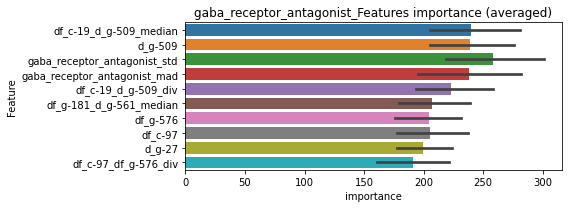

len(train_index) : 2577
len(valid_index) : 859
================================= fold 1/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0963902	valid_1's binary_logloss: 0.167067
[200]	training's binary_logloss: 0.0364391	valid_1's binary_logloss: 0.113727
[300]	training's binary_logloss: 0.0159662	valid_1's binary_logloss: 0.0899861
[400]	training's binary_logloss: 0.00758457	valid_1's binary_logloss: 0.0807262
[500]	training's binary_logloss: 0.00401663	valid_1's binary_logloss: 0.0770213
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00291203	valid_1's binary_logloss: 0.0761561


len(train_index) : 2577
len(valid_index) : 859
================================= fold 2/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101835	valid_1's binary_logloss: 0.160829
[200]	training's binary_logloss: 0.0386405	valid_1's binary_logloss: 0.106283
[300]	training's binary_logloss: 0.0167577	valid_1's binary_logloss: 0.0828191
[400]	training's binary_logloss: 0.0079829	valid_1's binary_logloss: 0.0712327
[500]	training's binary_logloss: 0.00424264	valid_1's binary_logloss: 0.0663882
[600]	training's binary_logloss: 0.00255944	valid_1's binary_logloss: 0.0634354
[700]	training's binary_logloss: 0.00174537	valid_1's binary_logloss: 0.0609624
[800]	training's binary_logloss: 0.00131688	valid_1's binary_logloss: 0.0596429
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.00132214	valid_1's binary_logloss: 0.059624


len(train_index) : 2577
len(valid_index) : 859
================================= fold 3/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100426	valid_1's binary_logloss: 0.146197
[200]	training's binary_logloss: 0.0382284	valid_1's binary_logloss: 0.0894547
[300]	training's binary_logloss: 0.0167521	valid_1's binary_logloss: 0.0648348
[400]	training's binary_logloss: 0.00791325	valid_1's binary_logloss: 0.0527226
[500]	training's binary_logloss: 0.00416515	valid_1's binary_logloss: 0.0478913
[600]	training's binary_logloss: 0.00254183	valid_1's binary_logloss: 0.0458267
[700]	training's binary_logloss: 0.00175338	valid_1's binary_logloss: 0.0443366
[800]	training's binary_logloss: 0.00131808	valid_1's binary_logloss: 0.0431248
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.00115467	valid_1's binary_logloss: 0.0426019


len(train_index) : 2577
len(valid_index) : 859
================================= fold 4/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0980674	valid_1's binary_logloss: 0.170856
[200]	training's binary_logloss: 0.0355531	valid_1's binary_logloss: 0.117669
[300]	training's binary_logloss: 0.0155677	valid_1's binary_logloss: 0.0946713
[400]	training's binary_logloss: 0.00729574	valid_1's binary_logloss: 0.0853591
[500]	training's binary_logloss: 0.003862	valid_1's binary_logloss: 0.0806822
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00310503	valid_1's binary_logloss: 0.0798826


gaba_receptor_antagonist logloss: 0.06456615811042607


neg labels: 3289 → selected neg labels: 3284


gamma_secretase_inhibitor, len(trt): 56, len(othr): 3284, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128757	valid_1's binary_logloss: 0.187659
[200]	training's binary_logloss: 0.0525336	valid_1's binary_logloss: 0.116482
[300]	training's binary_logloss: 0.0248369	valid_1's binary_logloss: 0.0841112
[400]	training's binary_logloss: 0.0119453	valid_1's binary_logloss: 0.0656212
[500]	training's binary_logloss: 0.00621005	valid_1's binary_logloss: 0.055317
[600]	training's binary_logloss: 0.00360838	valid_1's binary_logloss: 0.0498
[700]	training's binary_logloss: 0.00234155	valid_1's binary_logloss: 0.0464737
[800]	training's binary_logloss: 0.0016745	valid_1's binary_logloss: 0.0446404
[900]	training's binary_logloss: 0.00129903	valid_1's binary_logloss: 0.0435241
[1000]	training's binary_logloss: 0.0010707	valid_1's binary_logloss: 0.042861
Early stopping, best iteration is:
[1001]	training's binary_logloss: 0.00106938	valid_1's binary_logloss: 0.0428427
Training until validation scores don

1 / 3 AUC score:0.999
y_Threshold: 0.0213216, Threshold: 0.1031793, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 652/3800
p_label_rate: 0.0100452 Vs.target_rate: 0.00235, Num_p_label: 40.0, conf_0:0.07223, conf_1:0.13413
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_1: 0.1031793
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_2: 0.1331793
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_3: 0.1631793
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_4: 0.1931793
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_5: 0.2231793
threshold: 0.2231793, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 652.0/3800, y_label_rate: 0.1715789
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128556	valid_1's binary_logloss: 0.167987
[200]	training's binary_logloss: 0.0499429	valid_1's binary_logloss: 0.0894807
[300]	training's binary_logloss: 0.021804	valid_1's binary_logloss: 0.0541317
[400]	training's binary_logloss: 0.0101999	valid_1's binary_logloss: 0.0366208
[500]	training's binary_logloss: 0.00528561	valid_1's binary_logloss: 0.0276492
[600]	training's binary_logloss: 0.00305015	valid_1's binary_logloss: 0.021989
[700]	training's binary_logloss: 0.00201574	valid_1's binary_logloss: 0.019206
[800]	training's binary_logloss: 0.0014697	valid_1's binary_logloss: 0.0170737
[900]	training's binary_logloss: 0.00115579	valid_1's binary_logloss: 0.0158511
[1000]	training's binary_logloss: 0.000971098	valid_1's binary_logloss: 0.0150745
[1100]	training's binary_logloss: 0.000882583	valid_1's binary_logloss: 0.0146394
Early stopping, best iteration is:
[1142]	training's binary_loglo

2 / 3 AUC score:0.998
y_Threshold: 0.1013356, Threshold: 0.2231793, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 643.0/3782
p_label_rate: 0.0133099 Vs.target_rate: 0.00235, Num_p_label: 53.0, conf_0:0.17854, conf_1:0.26782
Num_p_label: 53.0, Expected: 9.4, Adj_threshold_1: 0.2231793
Num_p_label: 48.0, Expected: 9.4, Adj_threshold_2: 0.2531793
Num_p_label: 46.0, Expected: 9.4, Adj_threshold_3: 0.2831793
Num_p_label: 42.0, Expected: 9.4, Adj_threshold_4: 0.3131793
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_5: 0.3431793
Num_p_label: 38.0, Expected: 9.4, Adj_threshold_6: 0.3731793
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_7: 0.4031793
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_8: 0.4331793
Num_p_label: 30.0, Expected: 9.4, Adj_threshold_9: 0.4631793
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_10: 0.4931793
threshold: 0.5231793, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 643.0/3782, y_label_rate: 0.1700159
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124432	valid_1's binary_logloss: 0.172852
[200]	training's binary_logloss: 0.0489462	valid_1's binary_logloss: 0.100012
[300]	training's binary_logloss: 0.0203454	valid_1's binary_logloss: 0.0667033
[400]	training's binary_logloss: 0.00945229	valid_1's binary_logloss: 0.0527235
[500]	training's binary_logloss: 0.00475962	valid_1's binary_logloss: 0.0462246
[600]	training's binary_logloss: 0.00276269	valid_1's binary_logloss: 0.0428583
[700]	training's binary_logloss: 0.00183028	valid_1's binary_logloss: 0.0420173
[800]	training's binary_logloss: 0.00134037	valid_1's binary_logloss: 0.0412803
Early stopping, best iteration is:
[773]	training's binary_logloss: 0.00144171	valid_1's binary_logloss: 0.0411723
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12126	valid_1's binary_logloss: 0.17326
[200]	training's binary_logloss: 0.0466794	valid_1's b

3 / 3 AUC score:0.997
y_Threshold: 0.0902600, Threshold: 0.5231793, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 636.0/3768
p_label_rate: 0.0075339 Vs.target_rate: 0.00235, Num_p_label: 30.0, conf_0:0.47086, conf_1:0.57550
Num_p_label: 30.0, Expected: 9.4, Adj_threshold_1: 0.5231793
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_2: 0.5531793
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_3: 0.5831793
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_4: 0.6131793
threshold: 0.6131793, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 636.0/3768, y_label_rate: 0.1687898


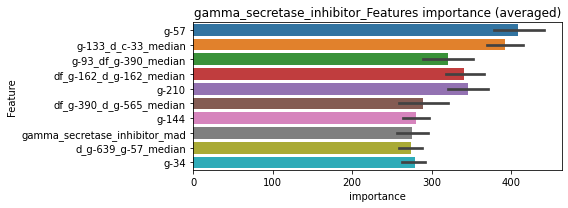

len(train_index) : 2826
len(valid_index) : 942
================================= fold 1/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119535	valid_1's binary_logloss: 0.173691
[200]	training's binary_logloss: 0.0455956	valid_1's binary_logloss: 0.0948209
[300]	training's binary_logloss: 0.0195457	valid_1's binary_logloss: 0.0603954
[400]	training's binary_logloss: 0.00878424	valid_1's binary_logloss: 0.0411492
[500]	training's binary_logloss: 0.00449853	valid_1's binary_logloss: 0.0322641
[600]	training's binary_logloss: 0.00264682	valid_1's binary_logloss: 0.0276488
[700]	training's binary_logloss: 0.00176491	valid_1's binary_logloss: 0.0247479
[800]	training's binary_logloss: 0.00130002	valid_1's binary_logloss: 0.0230956
[900]	training's binary_logloss: 0.00104509	valid_1's binary_logloss: 0.0226341
[1000]	training's binary_logloss: 0.000889603	valid_1's binary_logloss: 0.021943
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.000860159	valid_1's binary_logloss: 0.021781


len(train_index) : 2826
len(valid_index) : 942
================================= fold 2/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117587	valid_1's binary_logloss: 0.169821
[200]	training's binary_logloss: 0.0444685	valid_1's binary_logloss: 0.0928823
[300]	training's binary_logloss: 0.0191042	valid_1's binary_logloss: 0.0604924
[400]	training's binary_logloss: 0.00890557	valid_1's binary_logloss: 0.0439343
[500]	training's binary_logloss: 0.00458499	valid_1's binary_logloss: 0.0351776
[600]	training's binary_logloss: 0.00270856	valid_1's binary_logloss: 0.0304355
[700]	training's binary_logloss: 0.00179552	valid_1's binary_logloss: 0.0278079
[800]	training's binary_logloss: 0.00131594	valid_1's binary_logloss: 0.025979
[900]	training's binary_logloss: 0.00104116	valid_1's binary_logloss: 0.0247521
[1000]	training's binary_logloss: 0.000884643	valid_1's binary_logloss: 0.0242956
[1100]	training's binary_logloss: 0.000815173	valid_1's binary_logloss: 0.0240292
[1200]	training's binary_logloss: 0.000774618	valid_1's binar

len(train_index) : 2826
len(valid_index) : 942
================================= fold 3/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120987	valid_1's binary_logloss: 0.164462
[200]	training's binary_logloss: 0.0473017	valid_1's binary_logloss: 0.092144
[300]	training's binary_logloss: 0.0201264	valid_1's binary_logloss: 0.0616079
[400]	training's binary_logloss: 0.0090978	valid_1's binary_logloss: 0.0468352
[500]	training's binary_logloss: 0.00460374	valid_1's binary_logloss: 0.0395664
[600]	training's binary_logloss: 0.00269149	valid_1's binary_logloss: 0.0366452
[700]	training's binary_logloss: 0.00178585	valid_1's binary_logloss: 0.0353862
Early stopping, best iteration is:
[713]	training's binary_logloss: 0.0017059	valid_1's binary_logloss: 0.0351481


len(train_index) : 2826
len(valid_index) : 942
================================= fold 4/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123396	valid_1's binary_logloss: 0.15166
[200]	training's binary_logloss: 0.0482223	valid_1's binary_logloss: 0.078329
[300]	training's binary_logloss: 0.0203913	valid_1's binary_logloss: 0.046292
[400]	training's binary_logloss: 0.00955915	valid_1's binary_logloss: 0.0308216
[500]	training's binary_logloss: 0.0047082	valid_1's binary_logloss: 0.0234087
[600]	training's binary_logloss: 0.00271901	valid_1's binary_logloss: 0.0192694
[700]	training's binary_logloss: 0.0018042	valid_1's binary_logloss: 0.016888
[800]	training's binary_logloss: 0.00133462	valid_1's binary_logloss: 0.0157764
[900]	training's binary_logloss: 0.00105952	valid_1's binary_logloss: 0.0148986
[1000]	training's binary_logloss: 0.000906536	valid_1's binary_logloss: 0.0145881
[1100]	training's binary_logloss: 0.000821035	valid_1's binary_logloss: 0.0143655
Early stopping, best iteration is:
[1140]	training's binary_loglos

gamma_secretase_inhibitor logloss: 0.023724275016118266
glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3248, target_rate: 0.0111699 → Adj_target_rate: 0.0096682


neg labels: 3289 → selected neg labels: 3248


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.225191	valid_1's binary_logloss: 0.361039
[200]	training's binary_logloss: 0.141156	valid_1's binary_logloss: 0.327954
[300]	training's binary_logloss: 0.0953735	valid_1's binary_logloss: 0.311806
[400]	training's binary_logloss: 0.0649861	valid_1's binary_logloss: 0.306567
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.0521352	valid_1's binary_logloss: 0.303162
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.226328	valid_1's binary_logloss: 0.358675
[200]	training's binary_logloss: 0.138679	valid_1's binary_logloss: 0.326874
[300]	training's binary_logloss: 0.0912782	valid_1's binary_logloss: 0.308778
[400]	training's binary_logloss: 0.0628402	valid_1's binary_logloss: 0.301803
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.05781	valid_1's binary_logloss: 0.300555
Training until validation scores d

1 / 3 AUC score:0.865
y_Threshold: 0.1282390, Threshold: 0.3628061, pos_neg_ratio: 0.8000000
Remove_noisy_data: 483 → Positive_corect_labels: 473/3414
p_label_rate: 0.0100452 Vs.target_rate: 0.01117, Num_p_label: 40.0, conf_0:0.25396, conf_1:0.47165
threshold: 0.3628061, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 473.0/3414, y_label_rate: 0.1385472
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145915	valid_1's binary_logloss: 0.248993
[200]	training's binary_logloss: 0.072787	valid_1's binary_logloss: 0.198717
[300]	training's binary_logloss: 0.039761	valid_1's binary_logloss: 0.176133
[400]	training's binary_logloss: 0.0224018	valid_1's binary_logloss: 0.162268
[500]	training's binary_logloss: 0.0131262	valid_1's binary_logloss: 0.154649
[600]	training's binary_logloss: 0.00798481	valid_1's binary_logloss: 0.150309
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00803136	valid_1's binary_logloss: 0.150259
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143376	valid_1's binary_logloss: 0.268921
[200]	training's binary_logloss: 0.0696439	valid_1's binary_logloss: 0.222829
[300]	training's binary_logloss: 0.0372222	valid_1's binary_logloss: 0.203678
[400]	training's binary_logloss: 0.0207882	valid_1's binary_loglo

2 / 3 AUC score:0.967
y_Threshold: 0.1128910, Threshold: 0.3628061, pos_neg_ratio: 0.8000000
Remove_noisy_data: 150 → Positive_corect_labels: 398.0/3264
p_label_rate: 0.0336514 Vs.target_rate: 0.01117, Num_p_label: 134.0, conf_0:0.29024, conf_1:0.43537
Num_p_label: 134.0, Expected: 44.5, Adj_threshold_1: 0.3628061
Num_p_label: 118.0, Expected: 44.5, Adj_threshold_2: 0.3928061
Num_p_label: 112.0, Expected: 44.5, Adj_threshold_3: 0.4228061
Num_p_label: 104.0, Expected: 44.5, Adj_threshold_4: 0.4528061
Num_p_label: 93.0, Expected: 44.5, Adj_threshold_5: 0.4828061
Num_p_label: 83.0, Expected: 44.5, Adj_threshold_6: 0.5128061
Num_p_label: 73.0, Expected: 44.5, Adj_threshold_7: 0.5428061
Num_p_label: 66.0, Expected: 44.5, Adj_threshold_8: 0.5728061
threshold: 0.5728061, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 398.0/3264, y_label_rate: 0.1219363
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113133	valid_1's binary_logloss: 0.192167
[200]	training's binary_logloss: 0.0496045	valid_1's binary_logloss: 0.152127
[300]	training's binary_logloss: 0.0243476	valid_1's binary_logloss: 0.135608
[400]	training's binary_logloss: 0.0125729	valid_1's binary_logloss: 0.128606
[500]	training's binary_logloss: 0.00700429	valid_1's binary_logloss: 0.125032
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00742238	valid_1's binary_logloss: 0.124824
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115007	valid_1's binary_logloss: 0.205016
[200]	training's binary_logloss: 0.0504487	valid_1's binary_logloss: 0.161127
[300]	training's binary_logloss: 0.0246256	valid_1's binary_logloss: 0.142862
[400]	training's binary_logloss: 0.0125005	valid_1's binary_logloss: 0.132018
[500]	training's binary_logloss: 0.00683203	valid_1's binary_lo

3 / 3 AUC score:0.959
y_Threshold: 0.1004556, Threshold: 0.5728061, pos_neg_ratio: 0.8000000
Remove_noisy_data: 114 → Positive_corect_labels: 341.0/3150
p_label_rate: 0.0253641 Vs.target_rate: 0.01117, Num_p_label: 101.0, conf_0:0.50000, conf_1:0.63009
threshold: 0.5728061, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 341.0/3150, y_label_rate: 0.1082540


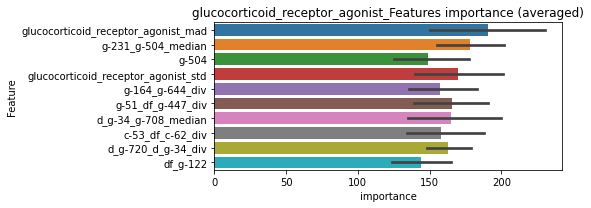

len(train_index) : 2362
len(valid_index) : 788
================================= fold 1/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843191	valid_1's binary_logloss: 0.17035
[200]	training's binary_logloss: 0.0332646	valid_1's binary_logloss: 0.135273
[300]	training's binary_logloss: 0.0147274	valid_1's binary_logloss: 0.122735
[400]	training's binary_logloss: 0.00721158	valid_1's binary_logloss: 0.117462
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00745217	valid_1's binary_logloss: 0.117029


len(train_index) : 2362
len(valid_index) : 788
================================= fold 2/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0866055	valid_1's binary_logloss: 0.157227
[200]	training's binary_logloss: 0.0320578	valid_1's binary_logloss: 0.12066
[300]	training's binary_logloss: 0.0139926	valid_1's binary_logloss: 0.109721
[400]	training's binary_logloss: 0.00672097	valid_1's binary_logloss: 0.106086
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00734874	valid_1's binary_logloss: 0.1057


len(train_index) : 2363
len(valid_index) : 787
================================= fold 3/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0857041	valid_1's binary_logloss: 0.169903
[200]	training's binary_logloss: 0.0330135	valid_1's binary_logloss: 0.133317
[300]	training's binary_logloss: 0.0146354	valid_1's binary_logloss: 0.120444
[400]	training's binary_logloss: 0.00698826	valid_1's binary_logloss: 0.112401
[500]	training's binary_logloss: 0.00382932	valid_1's binary_logloss: 0.11041
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00425407	valid_1's binary_logloss: 0.110106


len(train_index) : 2363
len(valid_index) : 787
================================= fold 4/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0863778	valid_1's binary_logloss: 0.163833
[200]	training's binary_logloss: 0.0337491	valid_1's binary_logloss: 0.134468


glucocorticoid_receptor_agonist logloss: 0.11505345659853813


[300]	training's binary_logloss: 0.0146296	valid_1's binary_logloss: 0.128023
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0169549	valid_1's binary_logloss: 0.127388


glutamate_inhibitor, len(trt): 13, len(othr): 3285, target_rate: 0.0005459 → Adj_target_rate: 0.0007431


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0595239	valid_1's binary_logloss: 0.0725223
[200]	training's binary_logloss: 0.013619	valid_1's binary_logloss: 0.0213724
[300]	training's binary_logloss: 0.00388271	valid_1's binary_logloss: 0.00849312
[400]	training's binary_logloss: 0.00149138	valid_1's binary_logloss: 0.00455043
[500]	training's binary_logloss: 0.000791453	valid_1's binary_logloss: 0.00318708
[600]	training's binary_logloss: 0.000517237	valid_1's binary_logloss: 0.00263426
[700]	training's binary_logloss: 0.000396419	valid_1's binary_logloss: 0.0023717
[800]	training's binary_logloss: 0.000351116	valid_1's binary_logloss: 0.00226883
[900]	training's binary_logloss: 0.000338166	valid_1's binary_logloss: 0.00224382
Early stopping, best iteration is:
[883]	training's binary_logloss: 0.000339175	valid_1's binary_logloss: 0.00224069
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0024546, Threshold: 0.0132425, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00055, Num_p_label: 40.0, conf_0:0.00927, conf_1:0.01722
Num_p_label: 40.0, Expected: 2.2, Adj_threshold_1: 0.0132425
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_2: 0.0432425
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_3: 0.0732425
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_4: 0.1032425
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_5: 0.1332425
threshold: 0.1332425, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.05881	valid_1's binary_logloss: 0.0703959
[200]	training's binary_logloss: 0.0123557	valid_1's binary_logloss: 0.0192984
[300]	training's binary_logloss: 0.00329524	valid_1's binary_logloss: 0.0075122
[400]	training's binary_logloss: 0.00126914	valid_1's binary_logloss: 0.00411542
[500]	training's binary_logloss: 0.000675791	valid_1's binary_logloss: 0.00293869
[600]	training's binary_logloss: 0.00045	valid_1's binary_logloss: 0.00255077
[700]	training's binary_logloss: 0.000347931	valid_1's binary_logloss: 0.00229822
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.00032305	valid_1's binary_logloss: 0.00219339
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.059104	valid_1's binary_logloss: 0.0700619
[200]	training's binary_logloss: 0.012362	valid_1's binary_logloss: 0.0182174
[300]	training's binary_logloss: 0.00339208	val

2 / 3 AUC score:1.000
y_Threshold: 0.1368581, Threshold: 0.1332425, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0057760 Vs.target_rate: 0.00055, Num_p_label: 23.0, conf_0:0.10659, conf_1:0.15989
Num_p_label: 23.0, Expected: 2.2, Adj_threshold_1: 0.1332425
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_2: 0.1632425
Num_p_label: 18.0, Expected: 2.2, Adj_threshold_3: 0.1932425
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_4: 0.2232425
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_5: 0.2532425
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_6: 0.2832425
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_7: 0.3132425
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_8: 0.3432425
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_9: 0.3732425
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_10: 0.4032425
threshold: 0.4332425, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.05881	valid_1's binary_logloss: 0.0703959
[200]	training's binary_logloss: 0.0123557	valid_1's binary_logloss: 0.0192984
[300]	training's binary_logloss: 0.00329524	valid_1's binary_logloss: 0.0075122
[400]	training's binary_logloss: 0.00126914	valid_1's binary_logloss: 0.00411542
[500]	training's binary_logloss: 0.000675791	valid_1's binary_logloss: 0.00293869
[600]	training's binary_logloss: 0.00045	valid_1's binary_logloss: 0.00255077
[700]	training's binary_logloss: 0.000347931	valid_1's binary_logloss: 0.00229822
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.00032305	valid_1's binary_logloss: 0.00219339
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.059104	valid_1's binary_logloss: 0.0700619
[200]	training's binary_logloss: 0.012362	valid_1's binary_logloss: 0.0182174
[300]	training's binary_logloss: 0.00339208	val

3 / 3 AUC score:1.000
y_Threshold: 0.1368581, Threshold: 0.4332425, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00055, Num_p_label: 7.0, conf_0:0.38992, conf_1:0.47657
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_1: 0.4332425
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_2: 0.4632425
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_3: 0.4932425
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_4: 0.5232425
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_5: 0.5532425
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_6: 0.5832425
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_7: 0.6132425
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_8: 0.6432425
threshold: 0.6432425, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


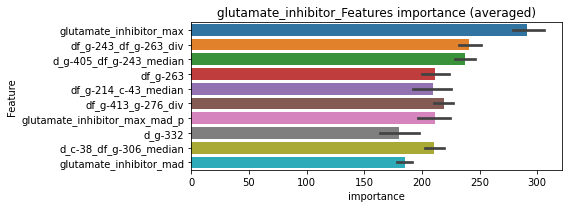

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0581829	valid_1's binary_logloss: 0.0708047
[200]	training's binary_logloss: 0.0122558	valid_1's binary_logloss: 0.0202349
[300]	training's binary_logloss: 0.00336244	valid_1's binary_logloss: 0.00826158
[400]	training's binary_logloss: 0.00132391	valid_1's binary_logloss: 0.00492417
[500]	training's binary_logloss: 0.000686471	valid_1's binary_logloss: 0.00364272
[600]	training's binary_logloss: 0.000451587	valid_1's binary_logloss: 0.00309597
[700]	training's binary_logloss: 0.000346076	valid_1's binary_logloss: 0.00285786
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.000319759	valid_1's binary_logloss: 0.00276361


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0587422	valid_1's binary_logloss: 0.0683227
[200]	training's binary_logloss: 0.0124077	valid_1's binary_logloss: 0.0178983
[300]	training's binary_logloss: 0.0034011	valid_1's binary_logloss: 0.00591162
[400]	training's binary_logloss: 0.00129139	valid_1's binary_logloss: 0.00264632
[500]	training's binary_logloss: 0.000695437	valid_1's binary_logloss: 0.00160608
[600]	training's binary_logloss: 0.000457626	valid_1's binary_logloss: 0.00115269
[700]	training's binary_logloss: 0.000351046	valid_1's binary_logloss: 0.000942102
[800]	training's binary_logloss: 0.000316757	valid_1's binary_logloss: 0.000881688
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.000314377	valid_1's binary_logloss: 0.000878291


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0592414	valid_1's binary_logloss: 0.0675828
[200]	training's binary_logloss: 0.0123775	valid_1's binary_logloss: 0.0165501
[300]	training's binary_logloss: 0.00339076	valid_1's binary_logloss: 0.00550866
[400]	training's binary_logloss: 0.00130993	valid_1's binary_logloss: 0.00255817
[500]	training's binary_logloss: 0.000693995	valid_1's binary_logloss: 0.00150335
[600]	training's binary_logloss: 0.000460292	valid_1's binary_logloss: 0.00106625
[700]	training's binary_logloss: 0.000351928	valid_1's binary_logloss: 0.00086401
[800]	training's binary_logloss: 0.000317727	valid_1's binary_logloss: 0.000797856
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.000317727	valid_1's binary_logloss: 0.000797856


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0590566	valid_1's binary_logloss: 0.0688922
[200]	training's binary_logloss: 0.0124535	valid_1's binary_logloss: 0.0170435
[300]	training's binary_logloss: 0.00340784	valid_1's binary_logloss: 0.0054767
[400]	training's binary_logloss: 0.00132081	valid_1's binary_logloss: 0.00238464
[500]	training's binary_logloss: 0.000710859	valid_1's binary_logloss: 0.00140243
[600]	training's binary_logloss: 0.000466573	valid_1's binary_logloss: 0.000987418
[700]	training's binary_logloss: 0.000356777	valid_1's binary_logloss: 0.000791053
[800]	training's binary_logloss: 0.000320159	valid_1's binary_logloss: 0.000727501
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.00031457	valid_1's binary_logloss: 0.000721789


glutamate_inhibitor logloss: 0.0012906726185858838
glutamate_receptor_agonist, len(trt): 74, len(othr): 3283, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122314	valid_1's binary_logloss: 0.19918
[200]	training's binary_logloss: 0.0498634	valid_1's binary_logloss: 0.131688
[300]	training's binary_logloss: 0.0231927	valid_1's binary_logloss: 0.102346
[400]	training's binary_logloss: 0.0114219	valid_1's binary_logloss: 0.0877567
[500]	training's binary_logloss: 0.00611456	valid_1's binary_logloss: 0.079998
[600]	training's binary_logloss: 0.00364018	valid_1's binary_logloss: 0.07565
[700]	training's binary_logloss: 0.00239992	valid_1's binary_logloss: 0.0735599
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00196204	valid_1's binary_logloss: 0.0734072
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12657	valid_1's binary_logloss: 0.184763
[200]	training's binary_logloss: 0.051397	valid_1's binary_logloss: 0.109651
[300]	training's binary_logloss: 0.0237327	valid_1's binary_lo

1 / 3 AUC score:0.993
y_Threshold: 0.0300656, Threshold: 0.3286738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 160 → Positive_corect_labels: 642/3779
p_label_rate: 0.0100452 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.23007, conf_1:0.42728
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.3286738
Num_p_label: 37.0, Expected: 12.4, Adj_threshold_2: 0.3586738
Num_p_label: 34.0, Expected: 12.4, Adj_threshold_3: 0.3886738
Num_p_label: 26.0, Expected: 12.4, Adj_threshold_4: 0.4186738
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_5: 0.4486738
Num_p_label: 18.0, Expected: 12.4, Adj_threshold_6: 0.4786738
threshold: 0.4786738, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 642.0/3779, y_label_rate: 0.1698862
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114717	valid_1's binary_logloss: 0.177697
[200]	training's binary_logloss: 0.0426757	valid_1's binary_logloss: 0.106764
[300]	training's binary_logloss: 0.0180518	valid_1's binary_logloss: 0.0780922
[400]	training's binary_logloss: 0.00815992	valid_1's binary_logloss: 0.0641409
[500]	training's binary_logloss: 0.00432329	valid_1's binary_logloss: 0.0587931
[600]	training's binary_logloss: 0.00261951	valid_1's binary_logloss: 0.0558279
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.00216867	valid_1's binary_logloss: 0.0548498
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114053	valid_1's binary_logloss: 0.170657
[200]	training's binary_logloss: 0.0416105	valid_1's binary_logloss: 0.0976299
[300]	training's binary_logloss: 0.0174904	valid_1's binary_logloss: 0.0701699
[400]	training's binary_logloss: 0.00800851	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.1111796, Threshold: 0.4786738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 623.0/3741
p_label_rate: 0.0175791 Vs.target_rate: 0.00311, Num_p_label: 70.0, conf_0:0.38294, conf_1:0.57441
Num_p_label: 70.0, Expected: 12.4, Adj_threshold_1: 0.4786738
Num_p_label: 69.0, Expected: 12.4, Adj_threshold_2: 0.5086738
Num_p_label: 60.0, Expected: 12.4, Adj_threshold_3: 0.5386738
Num_p_label: 53.0, Expected: 12.4, Adj_threshold_4: 0.5686738
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_5: 0.5986738
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_6: 0.6286738
Num_p_label: 37.0, Expected: 12.4, Adj_threshold_7: 0.6586738
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_8: 0.6886738
threshold: 0.6886738, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 623.0/3741, y_label_rate: 0.1665330
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107297	valid_1's binary_logloss: 0.145226
[200]	training's binary_logloss: 0.039127	valid_1's binary_logloss: 0.073201
[300]	training's binary_logloss: 0.0156922	valid_1's binary_logloss: 0.043272
[400]	training's binary_logloss: 0.00714942	valid_1's binary_logloss: 0.0298776
[500]	training's binary_logloss: 0.00374129	valid_1's binary_logloss: 0.0226811
[600]	training's binary_logloss: 0.00227987	valid_1's binary_logloss: 0.0187843
[700]	training's binary_logloss: 0.00158516	valid_1's binary_logloss: 0.0165578
[800]	training's binary_logloss: 0.00121572	valid_1's binary_logloss: 0.0153872
[900]	training's binary_logloss: 0.000989623	valid_1's binary_logloss: 0.0145709
[1000]	training's binary_logloss: 0.000846861	valid_1's binary_logloss: 0.0142232
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.000844298	valid_1's binary_logloss: 0.0141803
Training until validation s

3 / 3 AUC score:0.998
y_Threshold: 0.1011655, Threshold: 0.6886738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 608.0/3711
p_label_rate: 0.0118031 Vs.target_rate: 0.00311, Num_p_label: 47.0, conf_0:0.50000, conf_1:0.75754
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_1: 0.6886738
threshold: 0.6886738, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 608.0/3711, y_label_rate: 0.1638372


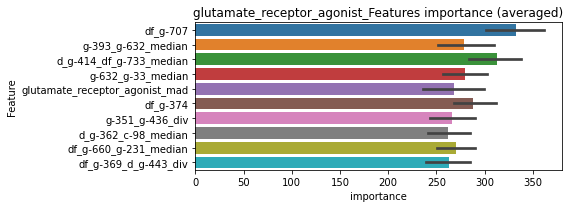

len(train_index) : 2783
len(valid_index) : 928
================================= fold 1/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103733	valid_1's binary_logloss: 0.155231
[200]	training's binary_logloss: 0.0366859	valid_1's binary_logloss: 0.0800333
[300]	training's binary_logloss: 0.0146257	valid_1's binary_logloss: 0.0495806
[400]	training's binary_logloss: 0.00659648	valid_1's binary_logloss: 0.0352818
[500]	training's binary_logloss: 0.00346226	valid_1's binary_logloss: 0.0283145
[600]	training's binary_logloss: 0.0021178	valid_1's binary_logloss: 0.0245067
[700]	training's binary_logloss: 0.0014838	valid_1's binary_logloss: 0.0221836
[800]	training's binary_logloss: 0.00113469	valid_1's binary_logloss: 0.0209546
[900]	training's binary_logloss: 0.000923744	valid_1's binary_logloss: 0.019901
[1000]	training's binary_logloss: 0.000793309	valid_1's binary_logloss: 0.0193629
Early stopping, best iteration is:
[1067]	training's binary_logloss: 0.000749066	valid_1's binary_logloss: 0.0191981


len(train_index) : 2783
len(valid_index) : 928
================================= fold 2/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10522	valid_1's binary_logloss: 0.148636
[200]	training's binary_logloss: 0.0361247	valid_1's binary_logloss: 0.0736247
[300]	training's binary_logloss: 0.0143313	valid_1's binary_logloss: 0.0446321
[400]	training's binary_logloss: 0.00626246	valid_1's binary_logloss: 0.0317178
[500]	training's binary_logloss: 0.00329778	valid_1's binary_logloss: 0.0253215
[600]	training's binary_logloss: 0.0020466	valid_1's binary_logloss: 0.0218038
[700]	training's binary_logloss: 0.00143313	valid_1's binary_logloss: 0.0195116
[800]	training's binary_logloss: 0.00110084	valid_1's binary_logloss: 0.0181443
[900]	training's binary_logloss: 0.000907908	valid_1's binary_logloss: 0.0172527
[1000]	training's binary_logloss: 0.000788661	valid_1's binary_logloss: 0.0167817
[1100]	training's binary_logloss: 0.000724214	valid_1's binary_logloss: 0.0165803
Early stopping, best iteration is:
[1095]	training's binary_l

len(train_index) : 2783
len(valid_index) : 928
================================= fold 3/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103692	valid_1's binary_logloss: 0.158652
[200]	training's binary_logloss: 0.0364054	valid_1's binary_logloss: 0.0883127
[300]	training's binary_logloss: 0.0144833	valid_1's binary_logloss: 0.0582678
[400]	training's binary_logloss: 0.00655478	valid_1's binary_logloss: 0.0451449
[500]	training's binary_logloss: 0.00342556	valid_1's binary_logloss: 0.0377508
[600]	training's binary_logloss: 0.00209196	valid_1's binary_logloss: 0.0347406
[700]	training's binary_logloss: 0.00147836	valid_1's binary_logloss: 0.0331698
[800]	training's binary_logloss: 0.00112674	valid_1's binary_logloss: 0.0321948
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.00111557	valid_1's binary_logloss: 0.0321397


len(train_index) : 2784
len(valid_index) : 927
================================= fold 4/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103662	valid_1's binary_logloss: 0.139543
[200]	training's binary_logloss: 0.0365515	valid_1's binary_logloss: 0.071747
[300]	training's binary_logloss: 0.0146015	valid_1's binary_logloss: 0.0464056
[400]	training's binary_logloss: 0.00657788	valid_1's binary_logloss: 0.0361097
[500]	training's binary_logloss: 0.00348521	valid_1's binary_logloss: 0.0319309
[600]	training's binary_logloss: 0.00216373	valid_1's binary_logloss: 0.0298584
[700]	training's binary_logloss: 0.00149853	valid_1's binary_logloss: 0.028201
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.0012874	valid_1's binary_logloss: 0.0278845


glutamate_receptor_agonist logloss: 0.023940070805260436
glutamate_receptor_antagonist, len(trt): 367, len(othr): 3235, target_rate: 0.0154111 → Adj_target_rate: 0.0127105


neg labels: 3289 → selected neg labels: 3235


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.252954	valid_1's binary_logloss: 0.392602
[200]	training's binary_logloss: 0.159259	valid_1's binary_logloss: 0.376159
[300]	training's binary_logloss: 0.107812	valid_1's binary_logloss: 0.370441
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.108529	valid_1's binary_logloss: 0.370281
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.256753	valid_1's binary_logloss: 0.380008
[200]	training's binary_logloss: 0.164482	valid_1's binary_logloss: 0.355505
[300]	training's binary_logloss: 0.11125	valid_1's binary_logloss: 0.344444
[400]	training's binary_logloss: 0.0763283	valid_1's binary_logloss: 0.338154
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.071439	valid_1's binary_logloss: 0.337334
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.256049	valid_1's bi

1 / 3 AUC score:0.792
y_Threshold: 0.1483591, Threshold: 0.4475338, pos_neg_ratio: 0.8000000
Remove_noisy_data: 664 → Positive_corect_labels: 380/3218
p_label_rate: 0.0100452 Vs.target_rate: 0.01541, Num_p_label: 40.0, conf_0:0.31327, conf_1:0.58179
threshold: 0.4475338, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 380.0/3218, y_label_rate: 0.1180858
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124523	valid_1's binary_logloss: 0.201854
[200]	training's binary_logloss: 0.0554213	valid_1's binary_logloss: 0.15328
[300]	training's binary_logloss: 0.0271336	valid_1's binary_logloss: 0.133414
[400]	training's binary_logloss: 0.0143076	valid_1's binary_logloss: 0.126046
[500]	training's binary_logloss: 0.00793437	valid_1's binary_logloss: 0.12294
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00866079	valid_1's binary_logloss: 0.122439
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122058	valid_1's binary_logloss: 0.196522
[200]	training's binary_logloss: 0.0537783	valid_1's binary_logloss: 0.152389
[300]	training's binary_logloss: 0.0265365	valid_1's binary_logloss: 0.132874
[400]	training's binary_logloss: 0.0140331	valid_1's binary_logloss: 0.123213
[500]	training's binary_logloss: 0.0079772	valid_1's binary_loglo

2 / 3 AUC score:0.971
y_Threshold: 0.1082566, Threshold: 0.4475338, pos_neg_ratio: 0.8000000
Remove_noisy_data: 128 → Positive_corect_labels: 316.0/3090
p_label_rate: 0.0401808 Vs.target_rate: 0.01541, Num_p_label: 160.0, conf_0:0.35803, conf_1:0.53704
threshold: 0.4475338, positive_p_label: 160.0/3982, p_label_rate: 0.0401808
positive_y_label: 316.0/3090, y_label_rate: 0.1022654
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0882934	valid_1's binary_logloss: 0.166435
[200]	training's binary_logloss: 0.0347893	valid_1's binary_logloss: 0.131428
[300]	training's binary_logloss: 0.0154911	valid_1's binary_logloss: 0.118544
[400]	training's binary_logloss: 0.00772839	valid_1's binary_logloss: 0.113772
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00537762	valid_1's binary_logloss: 0.112678
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085928	valid_1's binary_logloss: 0.162181
[200]	training's binary_logloss: 0.0335338	valid_1's binary_logloss: 0.126161
[300]	training's binary_logloss: 0.0148064	valid_1's binary_logloss: 0.112811
[400]	training's binary_logloss: 0.00734549	valid_1's binary_logloss: 0.109079
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00868084	valid_1's binary_logloss: 0.108625
Training until validation

3 / 3 AUC score:0.976
y_Threshold: 0.0798776, Threshold: 0.4475338, pos_neg_ratio: 0.8000000
Remove_noisy_data: 72 → Positive_corect_labels: 280.0/3018
p_label_rate: 0.0474636 Vs.target_rate: 0.01541, Num_p_label: 189.0, conf_0:0.40278, conf_1:0.49229
Num_p_label: 189.0, Expected: 61.4, Adj_threshold_1: 0.4475338
Num_p_label: 186.0, Expected: 61.4, Adj_threshold_2: 0.4775338
Num_p_label: 181.0, Expected: 61.4, Adj_threshold_3: 0.5075338
Num_p_label: 176.0, Expected: 61.4, Adj_threshold_4: 0.5375338
Num_p_label: 173.0, Expected: 61.4, Adj_threshold_5: 0.5675338
Num_p_label: 167.0, Expected: 61.4, Adj_threshold_6: 0.5975338
Num_p_label: 161.0, Expected: 61.4, Adj_threshold_7: 0.6275338
Num_p_label: 156.0, Expected: 61.4, Adj_threshold_8: 0.6575338
Num_p_label: 151.0, Expected: 61.4, Adj_threshold_9: 0.6875338
threshold: 0.6875338, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 280.0/3018, y_label_rate: 0.0927767


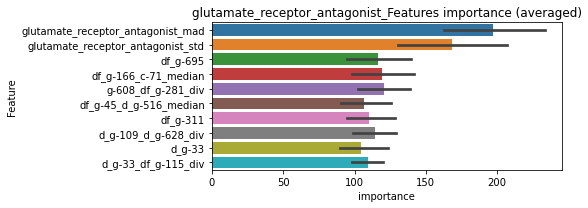

len(train_index) : 2263
len(valid_index) : 755
================================= fold 1/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0692767	valid_1's binary_logloss: 0.146266
[200]	training's binary_logloss: 0.0239877	valid_1's binary_logloss: 0.119179
[300]	training's binary_logloss: 0.00982063	valid_1's binary_logloss: 0.111934
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00933955	valid_1's binary_logloss: 0.111553


len(train_index) : 2263
len(valid_index) : 755
================================= fold 2/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0702704	valid_1's binary_logloss: 0.120821
[200]	training's binary_logloss: 0.0244272	valid_1's binary_logloss: 0.0780495
[300]	training's binary_logloss: 0.0101893	valid_1's binary_logloss: 0.0575527
[400]	training's binary_logloss: 0.00501018	valid_1's binary_logloss: 0.0481245
[500]	training's binary_logloss: 0.00285449	valid_1's binary_logloss: 0.0427168
[600]	training's binary_logloss: 0.00184271	valid_1's binary_logloss: 0.0390823
[700]	training's binary_logloss: 0.00135074	valid_1's binary_logloss: 0.0381752
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.00114142	valid_1's binary_logloss: 0.0371345


len(train_index) : 2264
len(valid_index) : 754
================================= fold 3/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0735129	valid_1's binary_logloss: 0.105299
[200]	training's binary_logloss: 0.0264305	valid_1's binary_logloss: 0.0679283
[300]	training's binary_logloss: 0.0109493	valid_1's binary_logloss: 0.052387
[400]	training's binary_logloss: 0.00519568	valid_1's binary_logloss: 0.0467546
[500]	training's binary_logloss: 0.00289619	valid_1's binary_logloss: 0.0439538
[600]	training's binary_logloss: 0.00185566	valid_1's binary_logloss: 0.0427991
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.0015622	valid_1's binary_logloss: 0.0419034


len(train_index) : 2264
len(valid_index) : 754
================================= fold 4/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0741631	valid_1's binary_logloss: 0.138039
[200]	training's binary_logloss: 0.0255309	valid_1's binary_logloss: 0.0971481
[300]	training's binary_logloss: 0.0102993	valid_1's binary_logloss: 0.0824716
[400]	training's binary_logloss: 0.00488076	valid_1's binary_logloss: 0.0757452
[500]	training's binary_logloss: 0.00271472	valid_1's binary_logloss: 0.071778
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00205688	valid_1's binary_logloss: 0.0699042


glutamate_receptor_antagonist logloss: 0.06512996540247201


neg labels: 3289 → selected neg labels: 3287


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0719564	valid_1's binary_logloss: 0.0927077
[200]	training's binary_logloss: 0.0196004	valid_1's binary_logloss: 0.0341171
[300]	training's binary_logloss: 0.00637105	valid_1's binary_logloss: 0.016833
[400]	training's binary_logloss: 0.00247065	valid_1's binary_logloss: 0.0101144
[500]	training's binary_logloss: 0.00126546	valid_1's binary_logloss: 0.00728903
[600]	training's binary_logloss: 0.000816875	valid_1's binary_logloss: 0.00609009
[700]	training's binary_logloss: 0.000597733	valid_1's binary_logloss: 0.0054144
[800]	training's binary_logloss: 0.000484059	valid_1's binary_logloss: 0.00506684
[900]	training's binary_logloss: 0.000440158	valid_1's binary_logloss: 0.00489396
Early stopping, best iteration is:
[889]	training's binary_logloss: 0.000440158	valid_1's binary_logloss: 0.00489396
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0049594, Threshold: 0.0224413, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01571, conf_1:0.02917
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0224413
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.0524413
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.0824413
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.1124413
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.1424413
threshold: 0.1424413, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0683755	valid_1's binary_logloss: 0.0770653
[200]	training's binary_logloss: 0.0167772	valid_1's binary_logloss: 0.0230628
[300]	training's binary_logloss: 0.00511762	valid_1's binary_logloss: 0.00875852
[400]	training's binary_logloss: 0.00201401	valid_1's binary_logloss: 0.00430633
[500]	training's binary_logloss: 0.001063	valid_1's binary_logloss: 0.00270688
[600]	training's binary_logloss: 0.000687835	valid_1's binary_logloss: 0.00196076
[700]	training's binary_logloss: 0.000511996	valid_1's binary_logloss: 0.00160535
[800]	training's binary_logloss: 0.000424857	valid_1's binary_logloss: 0.00141076
[900]	training's binary_logloss: 0.000396192	valid_1's binary_logloss: 0.00135867
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.000396192	valid_1's binary_logloss: 0.00135867
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0617093, Threshold: 0.1424413, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0065294 Vs.target_rate: 0.00076, Num_p_label: 26.0, conf_0:0.11395, conf_1:0.17093
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.1424413
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_2: 0.1724413
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.2024413
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_4: 0.2324413
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.2624413
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_6: 0.2924413
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.3224413
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.3524413
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.3824413
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_10: 0.4124413
threshold: 0.4424413, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3808, y_label_rate: 0.1720063
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0674816	valid_1's binary_logloss: 0.0788217
[200]	training's binary_logloss: 0.0163539	valid_1's binary_logloss: 0.0248271
[300]	training's binary_logloss: 0.00486847	valid_1's binary_logloss: 0.0105843
[400]	training's binary_logloss: 0.00193139	valid_1's binary_logloss: 0.00616959
[500]	training's binary_logloss: 0.00102354	valid_1's binary_logloss: 0.00467704
[600]	training's binary_logloss: 0.000675401	valid_1's binary_logloss: 0.00390815
[700]	training's binary_logloss: 0.000507709	valid_1's binary_logloss: 0.00360113
[800]	training's binary_logloss: 0.000421611	valid_1's binary_logloss: 0.00337328
[900]	training's binary_logloss: 0.000394366	valid_1's binary_logloss: 0.00330741
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.000390468	valid_1's binary_logloss: 0.00329696
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0495609, Threshold: 0.4424413, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 653.0/3804
p_label_rate: 0.0025113 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.39820, conf_1:0.48669
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.4424413
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.4724413
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.5024413
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.5324413
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.5624413
threshold: 0.5624413, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 653.0/3804, y_label_rate: 0.1716614


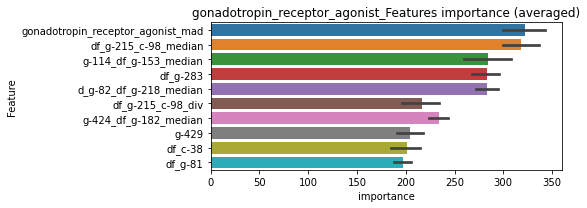

len(train_index) : 2853
len(valid_index) : 951
================================= fold 1/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0674289	valid_1's binary_logloss: 0.0820389
[200]	training's binary_logloss: 0.0162628	valid_1's binary_logloss: 0.0258165
[300]	training's binary_logloss: 0.0048491	valid_1's binary_logloss: 0.0107519
[400]	training's binary_logloss: 0.00190751	valid_1's binary_logloss: 0.00591655
[500]	training's binary_logloss: 0.0010023	valid_1's binary_logloss: 0.00413975
[600]	training's binary_logloss: 0.000654063	valid_1's binary_logloss: 0.00338975
[700]	training's binary_logloss: 0.000489437	valid_1's binary_logloss: 0.00301072
[800]	training's binary_logloss: 0.000408995	valid_1's binary_logloss: 0.00279974
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.000390646	valid_1's binary_logloss: 0.00276634


len(train_index) : 2853
len(valid_index) : 951
================================= fold 2/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0681543	valid_1's binary_logloss: 0.0797449
[200]	training's binary_logloss: 0.0168189	valid_1's binary_logloss: 0.0245267
[300]	training's binary_logloss: 0.005069	valid_1's binary_logloss: 0.00968488
[400]	training's binary_logloss: 0.00195793	valid_1's binary_logloss: 0.0051919
[500]	training's binary_logloss: 0.00103304	valid_1's binary_logloss: 0.00356421
[600]	training's binary_logloss: 0.000680572	valid_1's binary_logloss: 0.00280448
[700]	training's binary_logloss: 0.000510747	valid_1's binary_logloss: 0.00241552
[800]	training's binary_logloss: 0.000421612	valid_1's binary_logloss: 0.00215389
[900]	training's binary_logloss: 0.000389615	valid_1's binary_logloss: 0.00205849
Early stopping, best iteration is:
[889]	training's binary_logloss: 0.000390147	valid_1's binary_logloss: 0.00205761


len(train_index) : 2853
len(valid_index) : 951
================================= fold 3/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0684074	valid_1's binary_logloss: 0.080736
[200]	training's binary_logloss: 0.0169711	valid_1's binary_logloss: 0.0264097
[300]	training's binary_logloss: 0.00512625	valid_1's binary_logloss: 0.0114734
[400]	training's binary_logloss: 0.0020001	valid_1's binary_logloss: 0.00696177
[500]	training's binary_logloss: 0.00104088	valid_1's binary_logloss: 0.00509614
[600]	training's binary_logloss: 0.000674486	valid_1's binary_logloss: 0.00423904
[700]	training's binary_logloss: 0.000503951	valid_1's binary_logloss: 0.00377237
[800]	training's binary_logloss: 0.00041442	valid_1's binary_logloss: 0.00347528
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.000396337	valid_1's binary_logloss: 0.00342244


len(train_index) : 2853
len(valid_index) : 951
================================= fold 4/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0675865	valid_1's binary_logloss: 0.0865983
[200]	training's binary_logloss: 0.0163136	valid_1's binary_logloss: 0.0268526
[300]	training's binary_logloss: 0.00486762	valid_1's binary_logloss: 0.0110196
[400]	training's binary_logloss: 0.00193332	valid_1's binary_logloss: 0.00582168
[500]	training's binary_logloss: 0.0010219	valid_1's binary_logloss: 0.00405169
[600]	training's binary_logloss: 0.000670893	valid_1's binary_logloss: 0.00330861
[700]	training's binary_logloss: 0.000502203	valid_1's binary_logloss: 0.00286529
[800]	training's binary_logloss: 0.000418456	valid_1's binary_logloss: 0.00269055
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.000421008	valid_1's binary_logloss: 0.00268883


gonadotropin_receptor_agonist logloss: 0.002736771814406292
gsk_inhibitor, len(trt): 60, len(othr): 3281, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130052	valid_1's binary_logloss: 0.210112
[200]	training's binary_logloss: 0.0584213	valid_1's binary_logloss: 0.143395
[300]	training's binary_logloss: 0.0290521	valid_1's binary_logloss: 0.107441
[400]	training's binary_logloss: 0.0142907	valid_1's binary_logloss: 0.0869959
[500]	training's binary_logloss: 0.0074296	valid_1's binary_logloss: 0.0754195
[600]	training's binary_logloss: 0.0042233	valid_1's binary_logloss: 0.0680801
[700]	training's binary_logloss: 0.00269939	valid_1's binary_logloss: 0.0645337
[800]	training's binary_logloss: 0.00192537	valid_1's binary_logloss: 0.0628425
Early stopping, best iteration is:
[843]	training's binary_logloss: 0.00170371	valid_1's binary_logloss: 0.0624575
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130325	valid_1's binary_logloss: 0.193236
[200]	training's binary_logloss: 0.0609383	valid_1's bin

1 / 3 AUC score:0.998
y_Threshold: 0.0383777, Threshold: 0.2160781, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 652/3797
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.15125, conf_1:0.28090
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.2160781
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_2: 0.2460781
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_3: 0.2760781
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_4: 0.3060781
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_5: 0.3360781
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_6: 0.3660781
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_7: 0.3960781
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_8: 0.4260781
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_9: 0.4560781
Num_p_label: 11.0, Expected: 10.0, Adj_threshold_10: 0.4860781
threshold: 0.4860781, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 652.0/3797, y_label_rate: 0.1717145


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122579	valid_1's binary_logloss: 0.17571
[200]	training's binary_logloss: 0.0517476	valid_1's binary_logloss: 0.103743
[300]	training's binary_logloss: 0.0233846	valid_1's binary_logloss: 0.0675929
[400]	training's binary_logloss: 0.0109559	valid_1's binary_logloss: 0.0477438
[500]	training's binary_logloss: 0.00567445	valid_1's binary_logloss: 0.0373742
[600]	training's binary_logloss: 0.00337664	valid_1's binary_logloss: 0.0318484
[700]	training's binary_logloss: 0.00222597	valid_1's binary_logloss: 0.0279827
[800]	training's binary_logloss: 0.00164145	valid_1's binary_logloss: 0.0260169
[900]	training's binary_logloss: 0.00130134	valid_1's binary_logloss: 0.0244645
[1000]	training's binary_logloss: 0.00109191	valid_1's binary_logloss: 0.0232983
[1100]	training's binary_logloss: 0.000975084	valid_1's binary_logloss: 0.0227931
Early stopping, best iteration is:
[1112]	training's binary_logl

2 / 3 AUC score:0.999
y_Threshold: 0.1375153, Threshold: 0.4860781, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 636.0/3765
p_label_rate: 0.0105475 Vs.target_rate: 0.00252, Num_p_label: 42.0, conf_0:0.38886, conf_1:0.58329
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_1: 0.4860781
Num_p_label: 38.0, Expected: 10.0, Adj_threshold_2: 0.5160781
Num_p_label: 36.0, Expected: 10.0, Adj_threshold_3: 0.5460781
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_4: 0.5760781
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_5: 0.6060781
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_6: 0.6360781
Num_p_label: 26.0, Expected: 10.0, Adj_threshold_7: 0.6660781
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_8: 0.6960781
threshold: 0.6960781, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 636.0/3765, y_label_rate: 0.1689243
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117434	valid_1's binary_logloss: 0.182133
[200]	training's binary_logloss: 0.0471404	valid_1's binary_logloss: 0.1132
[300]	training's binary_logloss: 0.0205271	valid_1's binary_logloss: 0.077863
[400]	training's binary_logloss: 0.00941292	valid_1's binary_logloss: 0.0610767
[500]	training's binary_logloss: 0.00481739	valid_1's binary_logloss: 0.0511326
[600]	training's binary_logloss: 0.00290809	valid_1's binary_logloss: 0.0466055
[700]	training's binary_logloss: 0.00196106	valid_1's binary_logloss: 0.0443444
[800]	training's binary_logloss: 0.0014549	valid_1's binary_logloss: 0.0426349
Early stopping, best iteration is:
[847]	training's binary_logloss: 0.00129981	valid_1's binary_logloss: 0.0422015
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12114	valid_1's binary_logloss: 0.172857
[200]	training's binary_logloss: 0.0500677	valid_1's bina

3 / 3 AUC score:0.998
y_Threshold: 0.0849292, Threshold: 0.6960781, pos_neg_ratio: 0.8000000
Remove_noisy_data: 34 → Positive_corect_labels: 619.0/3731
p_label_rate: 0.0075339 Vs.target_rate: 0.00252, Num_p_label: 30.0, conf_0:0.50000, conf_1:0.76569
threshold: 0.6960781, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 619.0/3731, y_label_rate: 0.1659073


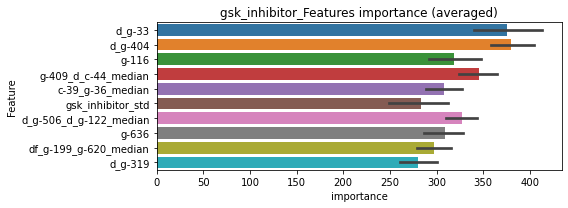

len(train_index) : 2798
len(valid_index) : 933
================================= fold 1/4 gsk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109495	valid_1's binary_logloss: 0.16972
[200]	training's binary_logloss: 0.043382	valid_1's binary_logloss: 0.102496
[300]	training's binary_logloss: 0.0191852	valid_1's binary_logloss: 0.0730909
[400]	training's binary_logloss: 0.00881705	valid_1's binary_logloss: 0.0591885
[500]	training's binary_logloss: 0.00449736	valid_1's binary_logloss: 0.0505302
[600]	training's binary_logloss: 0.00265412	valid_1's binary_logloss: 0.0471009
[700]	training's binary_logloss: 0.00180065	valid_1's binary_logloss: 0.045502
[800]	training's binary_logloss: 0.00134148	valid_1's binary_logloss: 0.0444147
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.00123296	valid_1's binary_logloss: 0.0441151


len(train_index) : 2798
len(valid_index) : 933
================================= fold 2/4 gsk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116833	valid_1's binary_logloss: 0.157854
[200]	training's binary_logloss: 0.0481619	valid_1's binary_logloss: 0.0887477
[300]	training's binary_logloss: 0.0215427	valid_1's binary_logloss: 0.0563291
[400]	training's binary_logloss: 0.010045	valid_1's binary_logloss: 0.0396679
[500]	training's binary_logloss: 0.00513927	valid_1's binary_logloss: 0.0303409
[600]	training's binary_logloss: 0.0030268	valid_1's binary_logloss: 0.0258828
[700]	training's binary_logloss: 0.00200041	valid_1's binary_logloss: 0.023002
[800]	training's binary_logloss: 0.00147982	valid_1's binary_logloss: 0.0213365
[900]	training's binary_logloss: 0.00117782	valid_1's binary_logloss: 0.0203573
[1000]	training's binary_logloss: 0.000996259	valid_1's binary_logloss: 0.020011
Early stopping, best iteration is:
[976]	training's binary_logloss: 0.00102872	valid_1's binary_logloss: 0.0199288


len(train_index) : 2798
len(valid_index) : 933
================================= fold 3/4 gsk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112836	valid_1's binary_logloss: 0.167892
[200]	training's binary_logloss: 0.0455092	valid_1's binary_logloss: 0.101502
[300]	training's binary_logloss: 0.0199444	valid_1's binary_logloss: 0.0691429
[400]	training's binary_logloss: 0.00933435	valid_1's binary_logloss: 0.0532588
[500]	training's binary_logloss: 0.00481659	valid_1's binary_logloss: 0.0439986
[600]	training's binary_logloss: 0.00280109	valid_1's binary_logloss: 0.0397548
[700]	training's binary_logloss: 0.00188343	valid_1's binary_logloss: 0.0380953
[800]	training's binary_logloss: 0.00140202	valid_1's binary_logloss: 0.0374257
[900]	training's binary_logloss: 0.00112027	valid_1's binary_logloss: 0.037038
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00119124	valid_1's binary_logloss: 0.0369078


len(train_index) : 2799
len(valid_index) : 932
================================= fold 4/4 gsk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111676	valid_1's binary_logloss: 0.166869
[200]	training's binary_logloss: 0.043912	valid_1's binary_logloss: 0.0994952
[300]	training's binary_logloss: 0.0198373	valid_1's binary_logloss: 0.0694259
[400]	training's binary_logloss: 0.00941448	valid_1's binary_logloss: 0.0548696
[500]	training's binary_logloss: 0.00475592	valid_1's binary_logloss: 0.0455643
[600]	training's binary_logloss: 0.00276877	valid_1's binary_logloss: 0.0403778
[700]	training's binary_logloss: 0.0018516	valid_1's binary_logloss: 0.0370206
[800]	training's binary_logloss: 0.00137734	valid_1's binary_logloss: 0.0354283
[900]	training's binary_logloss: 0.00111138	valid_1's binary_logloss: 0.0342339
Early stopping, best iteration is:
[931]	training's binary_logloss: 0.00104983	valid_1's binary_logloss: 0.0340099


gsk_inhibitor logloss: 0.03374031921636826
hcv_inhibitor, len(trt): 72, len(othr): 3273, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133483	valid_1's binary_logloss: 0.207873
[200]	training's binary_logloss: 0.0596913	valid_1's binary_logloss: 0.145145
[300]	training's binary_logloss: 0.0293946	valid_1's binary_logloss: 0.116936
[400]	training's binary_logloss: 0.0153612	valid_1's binary_logloss: 0.102023
[500]	training's binary_logloss: 0.00833592	valid_1's binary_logloss: 0.0941227
[600]	training's binary_logloss: 0.00481694	valid_1's binary_logloss: 0.0909849
[700]	training's binary_logloss: 0.00309013	valid_1's binary_logloss: 0.0896864
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00349227	valid_1's binary_logloss: 0.0895303
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133667	valid_1's binary_logloss: 0.218479
[200]	training's binary_logloss: 0.0611871	valid_1's binary_logloss: 0.148931
[300]	training's binary_logloss: 0.0307326	valid_1's bina

1 / 3 AUC score:0.993
y_Threshold: 0.0376865, Threshold: 0.1602546, pos_neg_ratio: 0.8000000
Remove_noisy_data: 176 → Positive_corect_labels: 632/3751
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.11218, conf_1:0.20833
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.1602546
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_2: 0.1902546
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_3: 0.2202546
Num_p_label: 14.0, Expected: 12.0, Adj_threshold_4: 0.2502546
threshold: 0.2502546, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 632.0/3751, y_label_rate: 0.1684884
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123113	valid_1's binary_logloss: 0.175994
[200]	training's binary_logloss: 0.0504628	valid_1's binary_logloss: 0.101513
[300]	training's binary_logloss: 0.0238722	valid_1's binary_logloss: 0.0698796
[400]	training's binary_logloss: 0.0118665	valid_1's binary_logloss: 0.0541947
[500]	training's binary_logloss: 0.00621024	valid_1's binary_logloss: 0.0441824
[600]	training's binary_logloss: 0.00367061	valid_1's binary_logloss: 0.0394685
[700]	training's binary_logloss: 0.00242305	valid_1's binary_logloss: 0.036556
[800]	training's binary_logloss: 0.00175547	valid_1's binary_logloss: 0.0347807
[900]	training's binary_logloss: 0.0013771	valid_1's binary_logloss: 0.0333494
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.00137415	valid_1's binary_logloss: 0.0333108
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123146	valid_1's 

2 / 3 AUC score:0.996
y_Threshold: 0.1012818, Threshold: 0.2502546, pos_neg_ratio: 0.8000000
Remove_noisy_data: 48 → Positive_corect_labels: 608.0/3703
p_label_rate: 0.0133099 Vs.target_rate: 0.00302, Num_p_label: 53.0, conf_0:0.20020, conf_1:0.30031
Num_p_label: 53.0, Expected: 12.0, Adj_threshold_1: 0.2502546
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_2: 0.2802546
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_3: 0.3102546
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_4: 0.3402546
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_5: 0.3702546
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_6: 0.4002546
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_7: 0.4302546
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_8: 0.4602546
Num_p_label: 18.0, Expected: 12.0, Adj_threshold_9: 0.4902546
threshold: 0.4902546, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 608.0/3703, y_label_rate: 0.1641912
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111576	valid_1's binary_logloss: 0.156317
[200]	training's binary_logloss: 0.042356	valid_1's binary_logloss: 0.0852759
[300]	training's binary_logloss: 0.0185073	valid_1's binary_logloss: 0.0559956
[400]	training's binary_logloss: 0.00868108	valid_1's binary_logloss: 0.0415271
[500]	training's binary_logloss: 0.00457401	valid_1's binary_logloss: 0.0336074
[600]	training's binary_logloss: 0.0028021	valid_1's binary_logloss: 0.029624
[700]	training's binary_logloss: 0.00191242	valid_1's binary_logloss: 0.0275253
[800]	training's binary_logloss: 0.00143608	valid_1's binary_logloss: 0.0261465
[900]	training's binary_logloss: 0.00114687	valid_1's binary_logloss: 0.025343
[1000]	training's binary_logloss: 0.000975834	valid_1's binary_logloss: 0.0249859
Early stopping, best iteration is:
[1006]	training's binary_logloss: 0.000968438	valid_1's binary_logloss: 0.0249235
Training until validation sco

3 / 3 AUC score:0.997
y_Threshold: 0.0977967, Threshold: 0.4902546, pos_neg_ratio: 0.8000000
Remove_noisy_data: 34 → Positive_corect_labels: 591.0/3669
p_label_rate: 0.0065294 Vs.target_rate: 0.00302, Num_p_label: 26.0, conf_0:0.44123, conf_1:0.53928
threshold: 0.4902546, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 591.0/3669, y_label_rate: 0.1610793


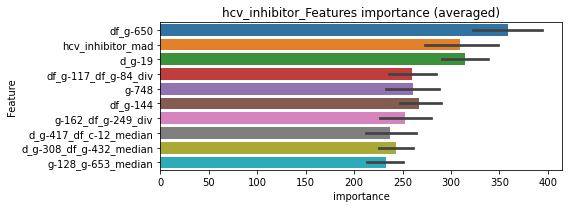

len(train_index) : 2751
len(valid_index) : 918
================================= fold 1/4 hcv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105741	valid_1's binary_logloss: 0.161812
[200]	training's binary_logloss: 0.0390992	valid_1's binary_logloss: 0.0870693
[300]	training's binary_logloss: 0.0167151	valid_1's binary_logloss: 0.0553395
[400]	training's binary_logloss: 0.0076667	valid_1's binary_logloss: 0.0393269
[500]	training's binary_logloss: 0.00405772	valid_1's binary_logloss: 0.0308142
[600]	training's binary_logloss: 0.00247976	valid_1's binary_logloss: 0.0264765
[700]	training's binary_logloss: 0.00171446	valid_1's binary_logloss: 0.023933
[800]	training's binary_logloss: 0.0013017	valid_1's binary_logloss: 0.0224939
[900]	training's binary_logloss: 0.00105204	valid_1's binary_logloss: 0.0214706
[1000]	training's binary_logloss: 0.000901683	valid_1's binary_logloss: 0.0208643
[1100]	training's binary_logloss: 0.000809901	valid_1's binary_logloss: 0.0204577
Early stopping, best iteration is:
[1111]	training's binary_log

len(train_index) : 2752
len(valid_index) : 917
================================= fold 2/4 hcv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106997	valid_1's binary_logloss: 0.167293
[200]	training's binary_logloss: 0.0382939	valid_1's binary_logloss: 0.102793
[300]	training's binary_logloss: 0.0160373	valid_1's binary_logloss: 0.0784261
[400]	training's binary_logloss: 0.00742829	valid_1's binary_logloss: 0.0694431
[500]	training's binary_logloss: 0.00389637	valid_1's binary_logloss: 0.0652504
[600]	training's binary_logloss: 0.00238932	valid_1's binary_logloss: 0.0647328
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00252558	valid_1's binary_logloss: 0.0644884


len(train_index) : 2752
len(valid_index) : 917
================================= fold 3/4 hcv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107594	valid_1's binary_logloss: 0.155513
[200]	training's binary_logloss: 0.0396165	valid_1's binary_logloss: 0.0873337
[300]	training's binary_logloss: 0.0169043	valid_1's binary_logloss: 0.0595463
[400]	training's binary_logloss: 0.00772363	valid_1's binary_logloss: 0.0443371
[500]	training's binary_logloss: 0.00411069	valid_1's binary_logloss: 0.0364542
[600]	training's binary_logloss: 0.00249383	valid_1's binary_logloss: 0.0322867
[700]	training's binary_logloss: 0.00171722	valid_1's binary_logloss: 0.0298436
[800]	training's binary_logloss: 0.00129651	valid_1's binary_logloss: 0.0280153
[900]	training's binary_logloss: 0.00104982	valid_1's binary_logloss: 0.0270426
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.00100054	valid_1's binary_logloss: 0.0268291


len(train_index) : 2752
len(valid_index) : 917
================================= fold 4/4 hcv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106662	valid_1's binary_logloss: 0.170247
[200]	training's binary_logloss: 0.0395025	valid_1's binary_logloss: 0.101699
[300]	training's binary_logloss: 0.0164436	valid_1's binary_logloss: 0.0744863
[400]	training's binary_logloss: 0.0075558	valid_1's binary_logloss: 0.0622307
[500]	training's binary_logloss: 0.00398658	valid_1's binary_logloss: 0.0563004
[600]	training's binary_logloss: 0.00243028	valid_1's binary_logloss: 0.0536904
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.0021941	valid_1's binary_logloss: 0.052963


hcv_inhibitor logloss: 0.041143109243467396
hdac_inhibitor, len(trt): 106, len(othr): 3275, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.165088	valid_1's binary_logloss: 0.263301
[200]	training's binary_logloss: 0.0855073	valid_1's binary_logloss: 0.204057
[300]	training's binary_logloss: 0.0461162	valid_1's binary_logloss: 0.173985
[400]	training's binary_logloss: 0.026066	valid_1's binary_logloss: 0.156221
[500]	training's binary_logloss: 0.0147601	valid_1's binary_logloss: 0.146297
[600]	training's binary_logloss: 0.00878478	valid_1's binary_logloss: 0.140769
[700]	training's binary_logloss: 0.00545655	valid_1's binary_logloss: 0.137661
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.00565423	valid_1's binary_logloss: 0.137603
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.165989	valid_1's binary_logloss: 0.24625
[200]	training's binary_logloss: 0.0858438	valid_1's binary_logloss: 0.182127
[300]	training's binary_logloss: 0.049888	valid_1's binary_loglo

1 / 3 AUC score:0.980
y_Threshold: 0.0449998, Threshold: 0.2725203, pos_neg_ratio: 0.8000000
Remove_noisy_data: 193 → Positive_corect_labels: 624/3737
p_label_rate: 0.0100452 Vs.target_rate: 0.00445, Num_p_label: 40.0, conf_0:0.19076, conf_1:0.35428
threshold: 0.2725203, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 624.0/3737, y_label_rate: 0.1669789
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151659	valid_1's binary_logloss: 0.20905
[200]	training's binary_logloss: 0.0736344	valid_1's binary_logloss: 0.139692
[300]	training's binary_logloss: 0.0384829	valid_1's binary_logloss: 0.102678
[400]	training's binary_logloss: 0.0205882	valid_1's binary_logloss: 0.0820795
[500]	training's binary_logloss: 0.0112429	valid_1's binary_logloss: 0.0695013
[600]	training's binary_logloss: 0.00653364	valid_1's binary_logloss: 0.0633045
[700]	training's binary_logloss: 0.00412785	valid_1's binary_logloss: 0.0577832
[800]	training's binary_logloss: 0.00284336	valid_1's binary_logloss: 0.0552554
[900]	training's binary_logloss: 0.00209342	valid_1's binary_logloss: 0.0540262
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.00187447	valid_1's binary_logloss: 0.0535222
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.146144	valid_1's b

2 / 3 AUC score:0.993
y_Threshold: 0.0965898, Threshold: 0.2725203, pos_neg_ratio: 0.8000000
Remove_noisy_data: 60 → Positive_corect_labels: 594.0/3677
p_label_rate: 0.0321447 Vs.target_rate: 0.00445, Num_p_label: 128.0, conf_0:0.21802, conf_1:0.32702
Num_p_label: 128.0, Expected: 17.7, Adj_threshold_1: 0.2725203
Num_p_label: 115.0, Expected: 17.7, Adj_threshold_2: 0.3025203
Num_p_label: 114.0, Expected: 17.7, Adj_threshold_3: 0.3325203
Num_p_label: 105.0, Expected: 17.7, Adj_threshold_4: 0.3625203
Num_p_label: 93.0, Expected: 17.7, Adj_threshold_5: 0.3925203
Num_p_label: 81.0, Expected: 17.7, Adj_threshold_6: 0.4225203
Num_p_label: 74.0, Expected: 17.7, Adj_threshold_7: 0.4525203
Num_p_label: 71.0, Expected: 17.7, Adj_threshold_8: 0.4825203
Num_p_label: 66.0, Expected: 17.7, Adj_threshold_9: 0.5125203
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_10: 0.5425203
threshold: 0.5725203, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 594.0/3677, y_label_rate: 0.16

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136022	valid_1's binary_logloss: 0.212754
[200]	training's binary_logloss: 0.060173	valid_1's binary_logloss: 0.139379
[300]	training's binary_logloss: 0.0292269	valid_1's binary_logloss: 0.104815
[400]	training's binary_logloss: 0.0149735	valid_1's binary_logloss: 0.0844617
[500]	training's binary_logloss: 0.00810418	valid_1's binary_logloss: 0.07223
[600]	training's binary_logloss: 0.00467329	valid_1's binary_logloss: 0.0654563
[700]	training's binary_logloss: 0.00302472	valid_1's binary_logloss: 0.0621589
[800]	training's binary_logloss: 0.00216162	valid_1's binary_logloss: 0.0603474
[900]	training's binary_logloss: 0.00166145	valid_1's binary_logloss: 0.0585237
[1000]	training's binary_logloss: 0.00136401	valid_1's binary_logloss: 0.0575799
Early stopping, best iteration is:
[1060]	training's binary_logloss: 0.00123959	valid_1's binary_logloss: 0.0573315
Training until validation scores 

3 / 3 AUC score:0.992
y_Threshold: 0.0973603, Threshold: 0.5725203, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 573.0/3635
p_label_rate: 0.0188348 Vs.target_rate: 0.00445, Num_p_label: 75.0, conf_0:0.50000, conf_1:0.62977
Num_p_label: 75.0, Expected: 17.7, Adj_threshold_1: 0.5725203
Num_p_label: 71.0, Expected: 17.7, Adj_threshold_2: 0.6025203
Num_p_label: 67.0, Expected: 17.7, Adj_threshold_3: 0.6325203
Num_p_label: 60.0, Expected: 17.7, Adj_threshold_4: 0.6625203
Num_p_label: 57.0, Expected: 17.7, Adj_threshold_5: 0.6925203
threshold: 0.6925203, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 573.0/3635, y_label_rate: 0.1576341


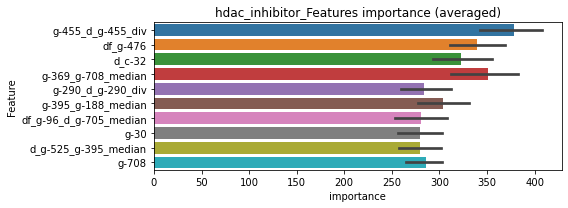

len(train_index) : 2726
len(valid_index) : 909
================================= fold 1/4 hdac_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127015	valid_1's binary_logloss: 0.20499
[200]	training's binary_logloss: 0.054699	valid_1's binary_logloss: 0.131231
[300]	training's binary_logloss: 0.0264183	valid_1's binary_logloss: 0.0961505
[400]	training's binary_logloss: 0.013443	valid_1's binary_logloss: 0.0754495
[500]	training's binary_logloss: 0.00724975	valid_1's binary_logloss: 0.063854
[600]	training's binary_logloss: 0.00416949	valid_1's binary_logloss: 0.0560617
[700]	training's binary_logloss: 0.00273137	valid_1's binary_logloss: 0.0510039
[800]	training's binary_logloss: 0.00195662	valid_1's binary_logloss: 0.0475557
[900]	training's binary_logloss: 0.00151549	valid_1's binary_logloss: 0.0457147
Early stopping, best iteration is:
[893]	training's binary_logloss: 0.00153724	valid_1's binary_logloss: 0.0456754


len(train_index) : 2726
len(valid_index) : 909
================================= fold 2/4 hdac_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130889	valid_1's binary_logloss: 0.193426
[200]	training's binary_logloss: 0.0564299	valid_1's binary_logloss: 0.12541
[300]	training's binary_logloss: 0.027364	valid_1's binary_logloss: 0.0925128
[400]	training's binary_logloss: 0.0137584	valid_1's binary_logloss: 0.0755558
[500]	training's binary_logloss: 0.00734849	valid_1's binary_logloss: 0.0656772
[600]	training's binary_logloss: 0.0042619	valid_1's binary_logloss: 0.0601584
[700]	training's binary_logloss: 0.00276873	valid_1's binary_logloss: 0.0573587
[800]	training's binary_logloss: 0.00198439	valid_1's binary_logloss: 0.0555558
[900]	training's binary_logloss: 0.00153169	valid_1's binary_logloss: 0.0549243
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.00141834	valid_1's binary_logloss: 0.0546147


len(train_index) : 2726
len(valid_index) : 909
================================= fold 3/4 hdac_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129994	valid_1's binary_logloss: 0.183949
[200]	training's binary_logloss: 0.0554671	valid_1's binary_logloss: 0.115949
[300]	training's binary_logloss: 0.0266087	valid_1's binary_logloss: 0.0826525
[400]	training's binary_logloss: 0.0142057	valid_1's binary_logloss: 0.065814
[500]	training's binary_logloss: 0.00768806	valid_1's binary_logloss: 0.054935
[600]	training's binary_logloss: 0.00445001	valid_1's binary_logloss: 0.0478567
[700]	training's binary_logloss: 0.00288115	valid_1's binary_logloss: 0.0440689
[800]	training's binary_logloss: 0.00205078	valid_1's binary_logloss: 0.0415112
[900]	training's binary_logloss: 0.00158647	valid_1's binary_logloss: 0.0395659
Early stopping, best iteration is:
[952]	training's binary_logloss: 0.00141646	valid_1's binary_logloss: 0.0388304


len(train_index) : 2727
len(valid_index) : 908
================================= fold 4/4 hdac_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128868	valid_1's binary_logloss: 0.198101
[200]	training's binary_logloss: 0.0522055	valid_1's binary_logloss: 0.136165
[300]	training's binary_logloss: 0.0245623	valid_1's binary_logloss: 0.110919
[400]	training's binary_logloss: 0.012364	valid_1's binary_logloss: 0.100399
[500]	training's binary_logloss: 0.00651046	valid_1's binary_logloss: 0.0934217
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00598005	valid_1's binary_logloss: 0.0930855


hdac_inhibitor logloss: 0.05804186796481154
histamine_receptor_agonist, len(trt): 59, len(othr): 3283, target_rate: 0.0024775 → Adj_target_rate: 0.0026880


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1246	valid_1's binary_logloss: 0.192798
[200]	training's binary_logloss: 0.0511613	valid_1's binary_logloss: 0.1263
[300]	training's binary_logloss: 0.0228126	valid_1's binary_logloss: 0.0945546
[400]	training's binary_logloss: 0.0108179	valid_1's binary_logloss: 0.0789585
[500]	training's binary_logloss: 0.00571716	valid_1's binary_logloss: 0.0710346
[600]	training's binary_logloss: 0.00330325	valid_1's binary_logloss: 0.0658783
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.00256984	valid_1's binary_logloss: 0.064745
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127641	valid_1's binary_logloss: 0.198472
[200]	training's binary_logloss: 0.0532797	valid_1's binary_logloss: 0.123408
[300]	training's binary_logloss: 0.0249211	valid_1's binary_logloss: 0.0869
[400]	training's binary_logloss: 0.0119722	valid_1's binary_logl

1 / 3 AUC score:0.998
y_Threshold: 0.0284034, Threshold: 0.1127828, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 652/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00248, Num_p_label: 40.0, conf_0:0.07895, conf_1:0.14662
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_1: 0.1127828
Num_p_label: 31.0, Expected: 9.9, Adj_threshold_2: 0.1427828
Num_p_label: 30.0, Expected: 9.9, Adj_threshold_3: 0.1727828
Num_p_label: 23.0, Expected: 9.9, Adj_threshold_4: 0.2027828
threshold: 0.2027828, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115951	valid_1's binary_logloss: 0.165018
[200]	training's binary_logloss: 0.0441105	valid_1's binary_logloss: 0.0904823
[300]	training's binary_logloss: 0.0188088	valid_1's binary_logloss: 0.0595944
[400]	training's binary_logloss: 0.00879618	valid_1's binary_logloss: 0.0446921
[500]	training's binary_logloss: 0.00455537	valid_1's binary_logloss: 0.0352979
[600]	training's binary_logloss: 0.00272554	valid_1's binary_logloss: 0.0307711
[700]	training's binary_logloss: 0.00184127	valid_1's binary_logloss: 0.0280223
[800]	training's binary_logloss: 0.00137122	valid_1's binary_logloss: 0.0266912
[900]	training's binary_logloss: 0.00109806	valid_1's binary_logloss: 0.0256736
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00108467	valid_1's binary_logloss: 0.0256314
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117622	valid_

2 / 3 AUC score:0.999
y_Threshold: 0.1850790, Threshold: 0.2027828, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 633.0/3761
p_label_rate: 0.0178302 Vs.target_rate: 0.00248, Num_p_label: 71.0, conf_0:0.16223, conf_1:0.24334
Num_p_label: 71.0, Expected: 9.9, Adj_threshold_1: 0.2027828
Num_p_label: 64.0, Expected: 9.9, Adj_threshold_2: 0.2327828
Num_p_label: 59.0, Expected: 9.9, Adj_threshold_3: 0.2627828
Num_p_label: 53.0, Expected: 9.9, Adj_threshold_4: 0.2927828
Num_p_label: 50.0, Expected: 9.9, Adj_threshold_5: 0.3227828
Num_p_label: 47.0, Expected: 9.9, Adj_threshold_6: 0.3527828
Num_p_label: 45.0, Expected: 9.9, Adj_threshold_7: 0.3827828
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_8: 0.4127828
Num_p_label: 36.0, Expected: 9.9, Adj_threshold_9: 0.4427828
Num_p_label: 33.0, Expected: 9.9, Adj_threshold_10: 0.4727828
threshold: 0.5027828, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 633.0/3761, y_label_rate: 0.1683063
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105254	valid_1's binary_logloss: 0.165988
[200]	training's binary_logloss: 0.0376762	valid_1's binary_logloss: 0.0962966
[300]	training's binary_logloss: 0.0149153	valid_1's binary_logloss: 0.0671302
[400]	training's binary_logloss: 0.00670479	valid_1's binary_logloss: 0.0531562
[500]	training's binary_logloss: 0.003471	valid_1's binary_logloss: 0.0474329
[600]	training's binary_logloss: 0.00211649	valid_1's binary_logloss: 0.0445734
[700]	training's binary_logloss: 0.00146824	valid_1's binary_logloss: 0.0434726
Early stopping, best iteration is:
[738]	training's binary_logloss: 0.00130872	valid_1's binary_logloss: 0.0428508
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109309	valid_1's binary_logloss: 0.161462
[200]	training's binary_logloss: 0.0399729	valid_1's binary_logloss: 0.0862504
[300]	training's binary_logloss: 0.0165018	valid_1's b

3 / 3 AUC score:1.000
y_Threshold: 0.1563009, Threshold: 0.5027828, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 623.0/3741
p_label_rate: 0.0120542 Vs.target_rate: 0.00248, Num_p_label: 48.0, conf_0:0.45250, conf_1:0.55306
Num_p_label: 48.0, Expected: 9.9, Adj_threshold_1: 0.5027828
Num_p_label: 47.0, Expected: 9.9, Adj_threshold_2: 0.5327828
Num_p_label: 45.0, Expected: 9.9, Adj_threshold_3: 0.5627828
Num_p_label: 39.0, Expected: 9.9, Adj_threshold_4: 0.5927828
Num_p_label: 38.0, Expected: 9.9, Adj_threshold_5: 0.6227828
Num_p_label: 38.0, Expected: 9.9, Adj_threshold_6: 0.6527828
Num_p_label: 37.0, Expected: 9.9, Adj_threshold_7: 0.6827828
threshold: 0.6827828, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 623.0/3741, y_label_rate: 0.1665330


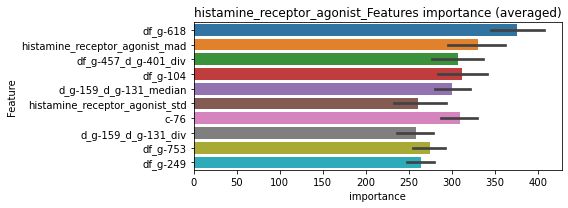

len(train_index) : 2805
len(valid_index) : 936
================================= fold 1/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106157	valid_1's binary_logloss: 0.149605
[200]	training's binary_logloss: 0.0374039	valid_1's binary_logloss: 0.0801204
[300]	training's binary_logloss: 0.0145969	valid_1's binary_logloss: 0.0519385
[400]	training's binary_logloss: 0.00637564	valid_1's binary_logloss: 0.0385286
[500]	training's binary_logloss: 0.00333683	valid_1's binary_logloss: 0.0318788
[600]	training's binary_logloss: 0.00203968	valid_1's binary_logloss: 0.0288884
[700]	training's binary_logloss: 0.00142577	valid_1's binary_logloss: 0.0270372
[800]	training's binary_logloss: 0.00108326	valid_1's binary_logloss: 0.0259039
[900]	training's binary_logloss: 0.000877909	valid_1's binary_logloss: 0.0255462
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000864545	valid_1's binary_logloss: 0.02548


len(train_index) : 2806
len(valid_index) : 935
================================= fold 2/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105418	valid_1's binary_logloss: 0.168319
[200]	training's binary_logloss: 0.0373189	valid_1's binary_logloss: 0.0957884
[300]	training's binary_logloss: 0.0148784	valid_1's binary_logloss: 0.0627751
[400]	training's binary_logloss: 0.00660353	valid_1's binary_logloss: 0.0454518
[500]	training's binary_logloss: 0.00343247	valid_1's binary_logloss: 0.0383481
[600]	training's binary_logloss: 0.0020897	valid_1's binary_logloss: 0.0346852
[700]	training's binary_logloss: 0.0014602	valid_1's binary_logloss: 0.0332495
[800]	training's binary_logloss: 0.00110524	valid_1's binary_logloss: 0.0315793
[900]	training's binary_logloss: 0.000893975	valid_1's binary_logloss: 0.0306551
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000836902	valid_1's binary_logloss: 0.0303971


len(train_index) : 2806
len(valid_index) : 935
================================= fold 3/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106361	valid_1's binary_logloss: 0.148255
[200]	training's binary_logloss: 0.0376176	valid_1's binary_logloss: 0.0756992
[300]	training's binary_logloss: 0.0154223	valid_1's binary_logloss: 0.046889
[400]	training's binary_logloss: 0.00678715	valid_1's binary_logloss: 0.0321752
[500]	training's binary_logloss: 0.00351602	valid_1's binary_logloss: 0.0253106
[600]	training's binary_logloss: 0.00212567	valid_1's binary_logloss: 0.0218957
[700]	training's binary_logloss: 0.00146999	valid_1's binary_logloss: 0.0198337
[800]	training's binary_logloss: 0.0011241	valid_1's binary_logloss: 0.0186689
[900]	training's binary_logloss: 0.000911707	valid_1's binary_logloss: 0.0177647
[1000]	training's binary_logloss: 0.000785094	valid_1's binary_logloss: 0.0172975
[1100]	training's binary_logloss: 0.000712747	valid_1's binary_logloss: 0.0168981
Early stopping, best iteration is:
[1124]	training's binary_l

len(train_index) : 2806
len(valid_index) : 935
================================= fold 4/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105708	valid_1's binary_logloss: 0.144462
[200]	training's binary_logloss: 0.0371909	valid_1's binary_logloss: 0.077406
[300]	training's binary_logloss: 0.0150404	valid_1's binary_logloss: 0.0496393
[400]	training's binary_logloss: 0.00659611	valid_1's binary_logloss: 0.0356683
[500]	training's binary_logloss: 0.00342968	valid_1's binary_logloss: 0.0283692
[600]	training's binary_logloss: 0.00208951	valid_1's binary_logloss: 0.0247905
[700]	training's binary_logloss: 0.00145615	valid_1's binary_logloss: 0.0225824
[800]	training's binary_logloss: 0.00111042	valid_1's binary_logloss: 0.0212279
[900]	training's binary_logloss: 0.000896454	valid_1's binary_logloss: 0.02012
[1000]	training's binary_logloss: 0.000771704	valid_1's binary_logloss: 0.0194389
[1100]	training's binary_logloss: 0.000708429	valid_1's binary_logloss: 0.019042
Early stopping, best iteration is:
[1155]	training's binary_log

histamine_receptor_agonist logloss: 0.02289011383818638


neg labels: 3289 → selected neg labels: 3255


histamine_receptor_antagonist, len(trt): 241, len(othr): 3255, target_rate: 0.0101201 → Adj_target_rate: 0.0088902
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.213698	valid_1's binary_logloss: 0.327936
[200]	training's binary_logloss: 0.125635	valid_1's binary_logloss: 0.285325
[300]	training's binary_logloss: 0.0789866	valid_1's binary_logloss: 0.264258
[400]	training's binary_logloss: 0.0516523	valid_1's binary_logloss: 0.255312
[500]	training's binary_logloss: 0.0331747	valid_1's binary_logloss: 0.251044
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.0319839	valid_1's binary_logloss: 0.25077
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.206004	valid_1's binary_logloss: 0.327881
[200]	training's binary_logloss: 0.119513	valid_1's binary_logloss: 0.296188
[300]	training's binary_logloss: 0.0760541	valid_1's binary_logloss: 0.2816
[400]	training's binary_logloss: 0.0477392	valid_1's binary_logloss: 0.275165
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.

1 / 3 AUC score:0.903
y_Threshold: 0.1014788, Threshold: 0.5373338, pos_neg_ratio: 0.8000000
Remove_noisy_data: 415 → Positive_corect_labels: 509/3491
p_label_rate: 0.0100452 Vs.target_rate: 0.01012, Num_p_label: 40.0, conf_0:0.37613, conf_1:0.69853
threshold: 0.5373338, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 509.0/3491, y_label_rate: 0.1458035
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134945	valid_1's binary_logloss: 0.222126
[200]	training's binary_logloss: 0.0632102	valid_1's binary_logloss: 0.171974
[300]	training's binary_logloss: 0.0325946	valid_1's binary_logloss: 0.150643
[400]	training's binary_logloss: 0.0179484	valid_1's binary_logloss: 0.139124
[500]	training's binary_logloss: 0.0100515	valid_1's binary_logloss: 0.130837
[600]	training's binary_logloss: 0.00609976	valid_1's binary_logloss: 0.127311
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00508666	valid_1's binary_logloss: 0.12631
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.139188	valid_1's binary_logloss: 0.212523
[200]	training's binary_logloss: 0.0635757	valid_1's binary_logloss: 0.168678
[300]	training's binary_logloss: 0.0316582	valid_1's binary_logloss: 0.151464
[400]	training's binary_logloss: 0.0163674	valid_1's binary_logl

2 / 3 AUC score:0.973
y_Threshold: 0.1011488, Threshold: 0.5373338, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 440.0/3353
p_label_rate: 0.0386740 Vs.target_rate: 0.01012, Num_p_label: 154.0, conf_0:0.42987, conf_1:0.64480
Num_p_label: 154.0, Expected: 40.3, Adj_threshold_1: 0.5373338
Num_p_label: 138.0, Expected: 40.3, Adj_threshold_2: 0.5673338
Num_p_label: 129.0, Expected: 40.3, Adj_threshold_3: 0.5973338
Num_p_label: 120.0, Expected: 40.3, Adj_threshold_4: 0.6273338
Num_p_label: 111.0, Expected: 40.3, Adj_threshold_5: 0.6573338
Num_p_label: 104.0, Expected: 40.3, Adj_threshold_6: 0.6873338
threshold: 0.6873338, positive_p_label: 104.0/3982, p_label_rate: 0.0261175
positive_y_label: 440.0/3353, y_label_rate: 0.1312258
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103426	valid_1's binary_logloss: 0.176544
[200]	training's binary_logloss: 0.0412448	valid_1's binary_logloss: 0.135716
[300]	training's binary_logloss: 0.0191984	valid_1's binary_logloss: 0.120533
[400]	training's binary_logloss: 0.00925616	valid_1's binary_logloss: 0.111401
[500]	training's binary_logloss: 0.00514198	valid_1's binary_logloss: 0.110035
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00562511	valid_1's binary_logloss: 0.109446
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101908	valid_1's binary_logloss: 0.163969
[200]	training's binary_logloss: 0.0415942	valid_1's binary_logloss: 0.120436
[300]	training's binary_logloss: 0.0189558	valid_1's binary_logloss: 0.10232
[400]	training's binary_logloss: 0.00949793	valid_1's binary_logloss: 0.0951317
[500]	training's binary_logloss: 0.00514886	valid_1's binary_

3 / 3 AUC score:0.988
y_Threshold: 0.1039258, Threshold: 0.6873338, pos_neg_ratio: 0.8000000
Remove_noisy_data: 72 → Positive_corect_labels: 404.0/3281
p_label_rate: 0.0391763 Vs.target_rate: 0.01012, Num_p_label: 156.0, conf_0:0.50000, conf_1:0.75607
Num_p_label: 156.0, Expected: 40.3, Adj_threshold_1: 0.6873338
threshold: 0.6873338, positive_p_label: 156.0/3982, p_label_rate: 0.0391763
positive_y_label: 404.0/3281, y_label_rate: 0.1231332


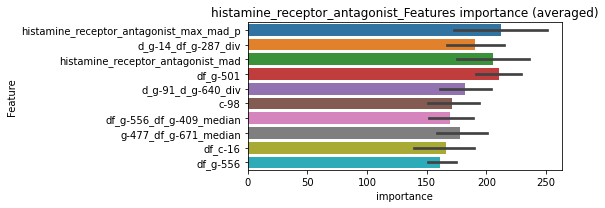

len(train_index) : 2460
len(valid_index) : 821
================================= fold 1/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0891093	valid_1's binary_logloss: 0.139102
[200]	training's binary_logloss: 0.0328343	valid_1's binary_logloss: 0.0896657
[300]	training's binary_logloss: 0.0137519	valid_1's binary_logloss: 0.0698955
[400]	training's binary_logloss: 0.00648245	valid_1's binary_logloss: 0.0598661
[500]	training's binary_logloss: 0.00357865	valid_1's binary_logloss: 0.0549536
[600]	training's binary_logloss: 0.00224083	valid_1's binary_logloss: 0.0525975
[700]	training's binary_logloss: 0.00159482	valid_1's binary_logloss: 0.0515835
[800]	training's binary_logloss: 0.00123587	valid_1's binary_logloss: 0.050977
[900]	training's binary_logloss: 0.00103363	valid_1's binary_logloss: 0.0498028
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.00100574	valid_1's binary_logloss: 0.04971


len(train_index) : 2461
len(valid_index) : 820
================================= fold 2/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0896321	valid_1's binary_logloss: 0.152892
[200]	training's binary_logloss: 0.0324333	valid_1's binary_logloss: 0.105822
[300]	training's binary_logloss: 0.013395	valid_1's binary_logloss: 0.0855589
[400]	training's binary_logloss: 0.00637907	valid_1's binary_logloss: 0.0794424
[500]	training's binary_logloss: 0.00347624	valid_1's binary_logloss: 0.0751535
[600]	training's binary_logloss: 0.00219948	valid_1's binary_logloss: 0.0743272
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.00200825	valid_1's binary_logloss: 0.0735992


len(train_index) : 2461
len(valid_index) : 820
================================= fold 3/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0901645	valid_1's binary_logloss: 0.134472
[200]	training's binary_logloss: 0.0342026	valid_1's binary_logloss: 0.0870034
[300]	training's binary_logloss: 0.0144407	valid_1's binary_logloss: 0.06822
[400]	training's binary_logloss: 0.00679486	valid_1's binary_logloss: 0.0620184
[500]	training's binary_logloss: 0.00369309	valid_1's binary_logloss: 0.0585324
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00349242	valid_1's binary_logloss: 0.0583107


len(train_index) : 2461
len(valid_index) : 820
================================= fold 4/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0849134	valid_1's binary_logloss: 0.155146
[200]	training's binary_logloss: 0.0309241	valid_1's binary_logloss: 0.115757
[300]	training's binary_logloss: 0.0131389	valid_1's binary_logloss: 0.0963545
[400]	training's binary_logloss: 0.006373	valid_1's binary_logloss: 0.0908982
[500]	training's binary_logloss: 0.0035037	valid_1's binary_logloss: 0.0845356
[600]	training's binary_logloss: 0.00220876	valid_1's binary_logloss: 0.0820836
[700]	training's binary_logloss: 0.00156538	valid_1's binary_logloss: 0.0806911
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00171613	valid_1's binary_logloss: 0.080372


histamine_receptor_antagonist logloss: 0.06549314727462473
histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3283, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.088628	valid_1's binary_logloss: 0.125947
[200]	training's binary_logloss: 0.0261163	valid_1's binary_logloss: 0.0532596
[300]	training's binary_logloss: 0.00909254	valid_1's binary_logloss: 0.0266197
[400]	training's binary_logloss: 0.00375516	valid_1's binary_logloss: 0.0160644
[500]	training's binary_logloss: 0.00195183	valid_1's binary_logloss: 0.0116537
[600]	training's binary_logloss: 0.00123745	valid_1's binary_logloss: 0.00971
[700]	training's binary_logloss: 0.000891322	valid_1's binary_logloss: 0.00850384
[800]	training's binary_logloss: 0.000707579	valid_1's binary_logloss: 0.00777565
[900]	training's binary_logloss: 0.000593009	valid_1's binary_logloss: 0.00735516
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.000564541	valid_1's binary_logloss: 0.00727069
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.087265

1 / 3 AUC score:1.000
y_Threshold: 0.0098860, Threshold: 0.1138453, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.07969, conf_1:0.14800
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.1138453
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_2: 0.1438453
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_3: 0.1738453
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_4: 0.2038453
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_5: 0.2338453
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_6: 0.2638453
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_7: 0.2938453
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_8: 0.3238453
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_9: 0.3538453
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_10: 0.3838453
threshold: 0.4138453, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0854364	valid_1's binary_logloss: 0.117162
[200]	training's binary_logloss: 0.0240714	valid_1's binary_logloss: 0.0449435
[300]	training's binary_logloss: 0.0080745	valid_1's binary_logloss: 0.0208508
[400]	training's binary_logloss: 0.00331718	valid_1's binary_logloss: 0.0120288
[500]	training's binary_logloss: 0.00172789	valid_1's binary_logloss: 0.0083263
[600]	training's binary_logloss: 0.00109977	valid_1's binary_logloss: 0.00663463
[700]	training's binary_logloss: 0.0007934	valid_1's binary_logloss: 0.00577003
[800]	training's binary_logloss: 0.000625836	valid_1's binary_logloss: 0.00514842
[900]	training's binary_logloss: 0.000543443	valid_1's binary_logloss: 0.0049363
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000537259	valid_1's binary_logloss: 0.00491892
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085124

2 / 3 AUC score:1.000
y_Threshold: 0.0827179, Threshold: 0.4138453, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0087896 Vs.target_rate: 0.00101, Num_p_label: 35.0, conf_0:0.33108, conf_1:0.49661
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_1: 0.4138453
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_2: 0.4438453
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_3: 0.4738453
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_4: 0.5038453
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_5: 0.5338453
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_6: 0.5638453
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_7: 0.5938453
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_8: 0.6238453
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_9: 0.6538453
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_10: 0.6838453
threshold: 0.6838453, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843796	valid_1's binary_logloss: 0.108944
[200]	training's binary_logloss: 0.0238238	valid_1's binary_logloss: 0.0418003
[300]	training's binary_logloss: 0.00808472	valid_1's binary_logloss: 0.0191236
[400]	training's binary_logloss: 0.00332098	valid_1's binary_logloss: 0.0105774
[500]	training's binary_logloss: 0.00173364	valid_1's binary_logloss: 0.00689036
[600]	training's binary_logloss: 0.00110957	valid_1's binary_logloss: 0.00523569
[700]	training's binary_logloss: 0.00080263	valid_1's binary_logloss: 0.00434398
[800]	training's binary_logloss: 0.000637612	valid_1's binary_logloss: 0.00384891
[900]	training's binary_logloss: 0.000542776	valid_1's binary_logloss: 0.00350507
[1000]	training's binary_logloss: 0.00051423	valid_1's binary_logloss: 0.00342472
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.000514799	valid_1's binary_logloss: 0.00342199
Training until v

3 / 3 AUC score:1.000
y_Threshold: 0.0928031, Threshold: 0.6838453, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0052737 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.75223
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.6838453
threshold: 0.6838453, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 654.0/3803, y_label_rate: 0.1719695


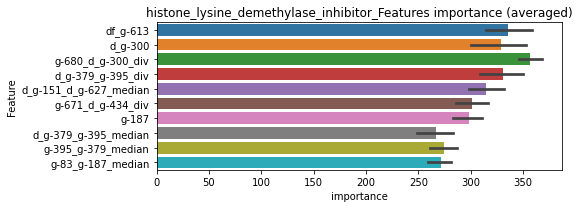

len(train_index) : 2852
len(valid_index) : 951
================================= fold 1/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.082987	valid_1's binary_logloss: 0.114061
[200]	training's binary_logloss: 0.0231963	valid_1's binary_logloss: 0.0441391
[300]	training's binary_logloss: 0.00782577	valid_1's binary_logloss: 0.0199377
[400]	training's binary_logloss: 0.00321722	valid_1's binary_logloss: 0.0106683
[500]	training's binary_logloss: 0.00168396	valid_1's binary_logloss: 0.00702035
[600]	training's binary_logloss: 0.00107411	valid_1's binary_logloss: 0.00532021
[700]	training's binary_logloss: 0.000780576	valid_1's binary_logloss: 0.00438906
[800]	training's binary_logloss: 0.000623192	valid_1's binary_logloss: 0.0038524
[900]	training's binary_logloss: 0.000538938	valid_1's binary_logloss: 0.0035579
[1000]	training's binary_logloss: 0.000507044	valid_1's binary_logloss: 0.00345461
[1100]	training's binary_logloss: 0.000499646	valid_1's binary_logloss: 0.00342827
Early stopping, best iteration is:
[1075]	training'

len(train_index) : 2852
len(valid_index) : 951
================================= fold 2/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0835551	valid_1's binary_logloss: 0.117581
[200]	training's binary_logloss: 0.0236139	valid_1's binary_logloss: 0.0486567
[300]	training's binary_logloss: 0.00810967	valid_1's binary_logloss: 0.023759
[400]	training's binary_logloss: 0.00341288	valid_1's binary_logloss: 0.0138661
[500]	training's binary_logloss: 0.00172	valid_1's binary_logloss: 0.00847795
[600]	training's binary_logloss: 0.0010918	valid_1's binary_logloss: 0.00643436
[700]	training's binary_logloss: 0.000784933	valid_1's binary_logloss: 0.0053245
[800]	training's binary_logloss: 0.000623992	valid_1's binary_logloss: 0.00477608
[900]	training's binary_logloss: 0.000548056	valid_1's binary_logloss: 0.00445783
[1000]	training's binary_logloss: 0.00051953	valid_1's binary_logloss: 0.00437576
Early stopping, best iteration is:
[983]	training's binary_logloss: 0.00051953	valid_1's binary_logloss: 0.00437576


len(train_index) : 2852
len(valid_index) : 951
================================= fold 3/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0839577	valid_1's binary_logloss: 0.110747
[200]	training's binary_logloss: 0.0237462	valid_1's binary_logloss: 0.0438536
[300]	training's binary_logloss: 0.00803042	valid_1's binary_logloss: 0.0220008
[400]	training's binary_logloss: 0.00332877	valid_1's binary_logloss: 0.0139156
[500]	training's binary_logloss: 0.00171945	valid_1's binary_logloss: 0.00995254
[600]	training's binary_logloss: 0.00109489	valid_1's binary_logloss: 0.00847034
[700]	training's binary_logloss: 0.000789463	valid_1's binary_logloss: 0.00744205
[800]	training's binary_logloss: 0.000621733	valid_1's binary_logloss: 0.00683729
[900]	training's binary_logloss: 0.000538822	valid_1's binary_logloss: 0.00649781
Early stopping, best iteration is:
[943]	training's binary_logloss: 0.000520362	valid_1's binary_logloss: 0.00648333


len(train_index) : 2853
len(valid_index) : 950
================================= fold 4/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838851	valid_1's binary_logloss: 0.112924
[200]	training's binary_logloss: 0.0238343	valid_1's binary_logloss: 0.0451345
[300]	training's binary_logloss: 0.00809962	valid_1's binary_logloss: 0.022719
[400]	training's binary_logloss: 0.00329743	valid_1's binary_logloss: 0.0138504
[500]	training's binary_logloss: 0.00170926	valid_1's binary_logloss: 0.00970179
[600]	training's binary_logloss: 0.00109179	valid_1's binary_logloss: 0.00805947
[700]	training's binary_logloss: 0.00079229	valid_1's binary_logloss: 0.00706303
[800]	training's binary_logloss: 0.000630227	valid_1's binary_logloss: 0.00663141
[900]	training's binary_logloss: 0.000542372	valid_1's binary_logloss: 0.00621521
Early stopping, best iteration is:
[961]	training's binary_logloss: 0.000517706	valid_1's binary_logloss: 0.00612122


histone_lysine_demethylase_inhibitor logloss: 0.00510656837575083
histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3284, target_rate: 0.0013437 → Adj_target_rate: 0.0015980


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0983561	valid_1's binary_logloss: 0.143097
[200]	training's binary_logloss: 0.0331403	valid_1's binary_logloss: 0.0702455
[300]	training's binary_logloss: 0.0124462	valid_1's binary_logloss: 0.0416246
[400]	training's binary_logloss: 0.00526547	valid_1's binary_logloss: 0.0287064
[500]	training's binary_logloss: 0.00269208	valid_1's binary_logloss: 0.0228639
[600]	training's binary_logloss: 0.00163358	valid_1's binary_logloss: 0.0194155
[700]	training's binary_logloss: 0.00114583	valid_1's binary_logloss: 0.0181883
[800]	training's binary_logloss: 0.000878484	valid_1's binary_logloss: 0.016988
[900]	training's binary_logloss: 0.000736982	valid_1's binary_logloss: 0.0164621
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000726953	valid_1's binary_logloss: 0.0163584
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0982423	va

1 / 3 AUC score:1.000
y_Threshold: 0.0120137, Threshold: 0.0903639, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3802
p_label_rate: 0.0100452 Vs.target_rate: 0.00134, Num_p_label: 40.0, conf_0:0.06325, conf_1:0.11747
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_1: 0.0903639
Num_p_label: 30.0, Expected: 5.4, Adj_threshold_2: 0.1203639
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_3: 0.1503639
Num_p_label: 25.0, Expected: 5.4, Adj_threshold_4: 0.1803639
Num_p_label: 22.0, Expected: 5.4, Adj_threshold_5: 0.2103639
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_6: 0.2403639
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_7: 0.2703639
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_8: 0.3003639
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_9: 0.3303639
threshold: 0.3303639, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0921472	valid_1's binary_logloss: 0.146373
[200]	training's binary_logloss: 0.0274315	valid_1's binary_logloss: 0.0862895
[300]	training's binary_logloss: 0.00979539	valid_1's binary_logloss: 0.0693968
[400]	training's binary_logloss: 0.00407375	valid_1's binary_logloss: 0.0668916
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00376632	valid_1's binary_logloss: 0.0664871
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0940507	valid_1's binary_logloss: 0.134267
[200]	training's binary_logloss: 0.0297107	valid_1's binary_logloss: 0.066123
[300]	training's binary_logloss: 0.0105582	valid_1's binary_logloss: 0.0414147
[400]	training's binary_logloss: 0.00432789	valid_1's binary_logloss: 0.0310368
[500]	training's binary_logloss: 0.00219271	valid_1's binary_logloss: 0.0265559
[600]	training's binary_logloss: 0.00136246	valid_1

2 / 3 AUC score:0.999
y_Threshold: 0.1150876, Threshold: 0.3303639, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 640.0/3776
p_label_rate: 0.0128076 Vs.target_rate: 0.00134, Num_p_label: 51.0, conf_0:0.26429, conf_1:0.39644
Num_p_label: 51.0, Expected: 5.4, Adj_threshold_1: 0.3303639
Num_p_label: 47.0, Expected: 5.4, Adj_threshold_2: 0.3603639
Num_p_label: 47.0, Expected: 5.4, Adj_threshold_3: 0.3903639
Num_p_label: 42.0, Expected: 5.4, Adj_threshold_4: 0.4203639
Num_p_label: 41.0, Expected: 5.4, Adj_threshold_5: 0.4503639
Num_p_label: 37.0, Expected: 5.4, Adj_threshold_6: 0.4803639
Num_p_label: 35.0, Expected: 5.4, Adj_threshold_7: 0.5103639
Num_p_label: 32.0, Expected: 5.4, Adj_threshold_8: 0.5403639
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_9: 0.5703639
Num_p_label: 28.0, Expected: 5.4, Adj_threshold_10: 0.6003639
threshold: 0.6303639, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 640.0/3776, y_label_rate: 0.1694915
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0881341	valid_1's binary_logloss: 0.13487
[200]	training's binary_logloss: 0.0267474	valid_1's binary_logloss: 0.0667906
[300]	training's binary_logloss: 0.00948709	valid_1's binary_logloss: 0.0431364
[400]	training's binary_logloss: 0.00391771	valid_1's binary_logloss: 0.034451
[500]	training's binary_logloss: 0.00197578	valid_1's binary_logloss: 0.0306022
[600]	training's binary_logloss: 0.00122628	valid_1's binary_logloss: 0.0291088
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.00109385	valid_1's binary_logloss: 0.0288833
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0875033	valid_1's binary_logloss: 0.126869
[200]	training's binary_logloss: 0.0262387	valid_1's binary_logloss: 0.0579966
[300]	training's binary_logloss: 0.00937249	valid_1's binary_logloss: 0.0328256
[400]	training's binary_logloss: 0.00388829	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.1596577, Threshold: 0.6303639, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 637.0/3770
p_label_rate: 0.0087896 Vs.target_rate: 0.00134, Num_p_label: 35.0, conf_0:0.50000, conf_1:0.69340
Num_p_label: 35.0, Expected: 5.4, Adj_threshold_1: 0.6303639
Num_p_label: 33.0, Expected: 5.4, Adj_threshold_2: 0.6603639
Num_p_label: 32.0, Expected: 5.4, Adj_threshold_3: 0.6903639
threshold: 0.6903639, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 637.0/3770, y_label_rate: 0.1689655


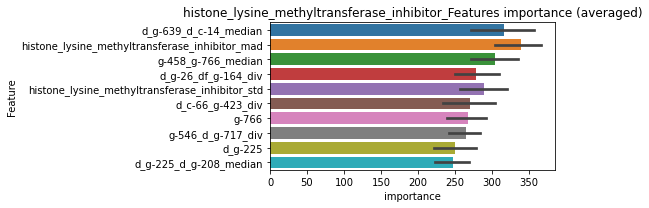

len(train_index) : 2827
len(valid_index) : 943
================================= fold 1/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0877789	valid_1's binary_logloss: 0.119461
[200]	training's binary_logloss: 0.0270995	valid_1's binary_logloss: 0.0548845
[300]	training's binary_logloss: 0.0096327	valid_1's binary_logloss: 0.0311574
[400]	training's binary_logloss: 0.00396795	valid_1's binary_logloss: 0.020644
[500]	training's binary_logloss: 0.00202242	valid_1's binary_logloss: 0.0165794
[600]	training's binary_logloss: 0.00125875	valid_1's binary_logloss: 0.0143296
[700]	training's binary_logloss: 0.000894203	valid_1's binary_logloss: 0.0131453
[800]	training's binary_logloss: 0.000708132	valid_1's binary_logloss: 0.0123388
[900]	training's binary_logloss: 0.000607798	valid_1's binary_logloss: 0.0118733
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.000612874	valid_1's binary_logloss: 0.011828


len(train_index) : 2827
len(valid_index) : 943
================================= fold 2/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0878636	valid_1's binary_logloss: 0.118571
[200]	training's binary_logloss: 0.0269104	valid_1's binary_logloss: 0.05107
[300]	training's binary_logloss: 0.00951737	valid_1's binary_logloss: 0.0264305
[400]	training's binary_logloss: 0.00400698	valid_1's binary_logloss: 0.0162868
[500]	training's binary_logloss: 0.00201915	valid_1's binary_logloss: 0.0116535
[600]	training's binary_logloss: 0.0012532	valid_1's binary_logloss: 0.00944479
[700]	training's binary_logloss: 0.000890835	valid_1's binary_logloss: 0.00812882
[800]	training's binary_logloss: 0.000696919	valid_1's binary_logloss: 0.00757087
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000661972	valid_1's binary_logloss: 0.0073982


len(train_index) : 2828
len(valid_index) : 942
================================= fold 3/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0891652	valid_1's binary_logloss: 0.11754
[200]	training's binary_logloss: 0.0269659	valid_1's binary_logloss: 0.0497512
[300]	training's binary_logloss: 0.00958871	valid_1's binary_logloss: 0.0264956
[400]	training's binary_logloss: 0.0039825	valid_1's binary_logloss: 0.0173406
[500]	training's binary_logloss: 0.00200604	valid_1's binary_logloss: 0.0130391
[600]	training's binary_logloss: 0.00125147	valid_1's binary_logloss: 0.0110627
[700]	training's binary_logloss: 0.000888571	valid_1's binary_logloss: 0.0100241
[800]	training's binary_logloss: 0.000694897	valid_1's binary_logloss: 0.00937997
[900]	training's binary_logloss: 0.000603059	valid_1's binary_logloss: 0.0093019
Early stopping, best iteration is:
[913]	training's binary_logloss: 0.000597578	valid_1's binary_logloss: 0.00924567


len(train_index) : 2828
len(valid_index) : 942
================================= fold 4/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0883454	valid_1's binary_logloss: 0.118996
[200]	training's binary_logloss: 0.0273296	valid_1's binary_logloss: 0.0514648
[300]	training's binary_logloss: 0.0094348	valid_1's binary_logloss: 0.0263305
[400]	training's binary_logloss: 0.00391174	valid_1's binary_logloss: 0.0162754
[500]	training's binary_logloss: 0.00199216	valid_1's binary_logloss: 0.0120072
[600]	training's binary_logloss: 0.0012423	valid_1's binary_logloss: 0.00979739
[700]	training's binary_logloss: 0.000883581	valid_1's binary_logloss: 0.00854465
[800]	training's binary_logloss: 0.000696769	valid_1's binary_logloss: 0.00767658
[900]	training's binary_logloss: 0.000601682	valid_1's binary_logloss: 0.00733751
[1000]	training's binary_logloss: 0.000563942	valid_1's binary_logloss: 0.00722962
Early stopping, best iteration is:
[1020]	training's binary_logloss: 0.00056274	valid_1's binary_logloss: 0.00721085


histone_lysine_methyltransferase_inhibitor logloss: 0.00892105671212447


neg labels: 3289 → selected neg labels: 3280


hiv_inhibitor, len(trt): 72, len(othr): 3280, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129796	valid_1's binary_logloss: 0.194661
[200]	training's binary_logloss: 0.0531284	valid_1's binary_logloss: 0.123296
[300]	training's binary_logloss: 0.0243536	valid_1's binary_logloss: 0.0912762
[400]	training's binary_logloss: 0.0120057	valid_1's binary_logloss: 0.0754047
[500]	training's binary_logloss: 0.0062377	valid_1's binary_logloss: 0.0650904
[600]	training's binary_logloss: 0.00364263	valid_1's binary_logloss: 0.0606719
[700]	training's binary_logloss: 0.00239054	valid_1's binary_logloss: 0.0579462
[800]	training's binary_logloss: 0.00174124	valid_1's binary_logloss: 0.0562376
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.0015888	valid_1's binary_logloss: 0.0559066
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134573	valid_1's binary_logloss: 0.180324
[200]	training's binary_logloss: 0.0565559	valid_1's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0204733, Threshold: 0.2000452, pos_neg_ratio: 0.8000000
Remove_noisy_data: 142 → Positive_corect_labels: 651/3794
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.14003, conf_1:0.26006
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.2000452
Num_p_label: 32.0, Expected: 12.0, Adj_threshold_2: 0.2300452
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_3: 0.2600452
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_4: 0.2900452
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_5: 0.3200452
Num_p_label: 17.0, Expected: 12.0, Adj_threshold_6: 0.3500452
threshold: 0.3500452, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127862	valid_1's binary_logloss: 0.178879
[200]	training's binary_logloss: 0.0511862	valid_1's binary_logloss: 0.104772
[300]	training's binary_logloss: 0.0220498	valid_1's binary_logloss: 0.0712817
[400]	training's binary_logloss: 0.0103863	valid_1's binary_logloss: 0.0550197
[500]	training's binary_logloss: 0.00535823	valid_1's binary_logloss: 0.0462252
[600]	training's binary_logloss: 0.00315575	valid_1's binary_logloss: 0.0420667
[700]	training's binary_logloss: 0.00210211	valid_1's binary_logloss: 0.0403568
[800]	training's binary_logloss: 0.00154689	valid_1's binary_logloss: 0.0393292
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.00149946	valid_1's binary_logloss: 0.0392617
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125267	valid_1's binary_logloss: 0.189624
[200]	training's binary_logloss: 0.0495188	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.0690453, Threshold: 0.3500452, pos_neg_ratio: 0.8000000
Remove_noisy_data: 34 → Positive_corect_labels: 634.0/3760
p_label_rate: 0.0150678 Vs.target_rate: 0.00302, Num_p_label: 60.0, conf_0:0.28004, conf_1:0.42005
Num_p_label: 60.0, Expected: 12.0, Adj_threshold_1: 0.3500452
Num_p_label: 57.0, Expected: 12.0, Adj_threshold_2: 0.3800452
Num_p_label: 57.0, Expected: 12.0, Adj_threshold_3: 0.4100452
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_4: 0.4400452
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_5: 0.4700452
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_6: 0.5000452
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_7: 0.5300452
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_8: 0.5600452
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_9: 0.5900452
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_10: 0.6200452
threshold: 0.6500452, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 634.0/3760, y_label_rate: 0.1686170

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119935	valid_1's binary_logloss: 0.176366
[200]	training's binary_logloss: 0.0448576	valid_1's binary_logloss: 0.0998042
[300]	training's binary_logloss: 0.0192988	valid_1's binary_logloss: 0.0664388
[400]	training's binary_logloss: 0.00896251	valid_1's binary_logloss: 0.0495605
[500]	training's binary_logloss: 0.00470717	valid_1's binary_logloss: 0.0405603
[600]	training's binary_logloss: 0.00283142	valid_1's binary_logloss: 0.0361268
[700]	training's binary_logloss: 0.00190004	valid_1's binary_logloss: 0.0337896
[800]	training's binary_logloss: 0.00141377	valid_1's binary_logloss: 0.0330981
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.00126024	valid_1's binary_logloss: 0.0326994
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121293	valid_1's binary_logloss: 0.174983
[200]	training's binary_logloss: 0.0466553	valid_1'

3 / 3 AUC score:0.999
y_Threshold: 0.0733572, Threshold: 0.6500452, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 625.0/3742
p_label_rate: 0.0095429 Vs.target_rate: 0.00302, Num_p_label: 38.0, conf_0:0.50000, conf_1:0.71505
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_1: 0.6500452
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_2: 0.6800452
threshold: 0.6800452, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 625.0/3742, y_label_rate: 0.1670230


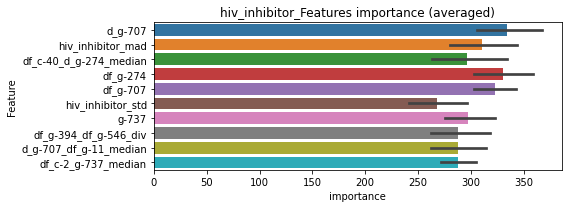

len(train_index) : 2806
len(valid_index) : 936
================================= fold 1/4 hiv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116765	valid_1's binary_logloss: 0.161729
[200]	training's binary_logloss: 0.0437692	valid_1's binary_logloss: 0.0866768
[300]	training's binary_logloss: 0.0187807	valid_1's binary_logloss: 0.0542185
[400]	training's binary_logloss: 0.00881433	valid_1's binary_logloss: 0.0378032
[500]	training's binary_logloss: 0.00461792	valid_1's binary_logloss: 0.0297181
[600]	training's binary_logloss: 0.00274833	valid_1's binary_logloss: 0.0254619
[700]	training's binary_logloss: 0.00187367	valid_1's binary_logloss: 0.0230009
[800]	training's binary_logloss: 0.00139623	valid_1's binary_logloss: 0.0216034
[900]	training's binary_logloss: 0.00111354	valid_1's binary_logloss: 0.0207575
[1000]	training's binary_logloss: 0.000950913	valid_1's binary_logloss: 0.020368
[1100]	training's binary_logloss: 0.000850522	valid_1's binary_logloss: 0.0199696
[1200]	training's binary_logloss: 0.000800583	valid_1's binar

len(train_index) : 2806
len(valid_index) : 936
================================= fold 2/4 hiv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118118	valid_1's binary_logloss: 0.167748
[200]	training's binary_logloss: 0.0429323	valid_1's binary_logloss: 0.0950053
[300]	training's binary_logloss: 0.0179992	valid_1's binary_logloss: 0.066749
[400]	training's binary_logloss: 0.00840777	valid_1's binary_logloss: 0.0534715
[500]	training's binary_logloss: 0.00438474	valid_1's binary_logloss: 0.0470615
[600]	training's binary_logloss: 0.00261957	valid_1's binary_logloss: 0.0428219
[700]	training's binary_logloss: 0.0017851	valid_1's binary_logloss: 0.041435
Early stopping, best iteration is:
[767]	training's binary_logloss: 0.00146152	valid_1's binary_logloss: 0.0407005


len(train_index) : 2807
len(valid_index) : 935
================================= fold 3/4 hiv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117487	valid_1's binary_logloss: 0.166508
[200]	training's binary_logloss: 0.0438138	valid_1's binary_logloss: 0.096971
[300]	training's binary_logloss: 0.0175907	valid_1's binary_logloss: 0.0663126
[400]	training's binary_logloss: 0.00802344	valid_1's binary_logloss: 0.0519185
[500]	training's binary_logloss: 0.0041938	valid_1's binary_logloss: 0.0457037
[600]	training's binary_logloss: 0.00254552	valid_1's binary_logloss: 0.0424875
[700]	training's binary_logloss: 0.00174413	valid_1's binary_logloss: 0.0407048
[800]	training's binary_logloss: 0.00131436	valid_1's binary_logloss: 0.0402003
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.00136468	valid_1's binary_logloss: 0.0400719


len(train_index) : 2807
len(valid_index) : 935
================================= fold 4/4 hiv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115783	valid_1's binary_logloss: 0.176798
[200]	training's binary_logloss: 0.0426592	valid_1's binary_logloss: 0.101574
[300]	training's binary_logloss: 0.017715	valid_1's binary_logloss: 0.06978
[400]	training's binary_logloss: 0.00799804	valid_1's binary_logloss: 0.0563598
[500]	training's binary_logloss: 0.004188	valid_1's binary_logloss: 0.0491888
[600]	training's binary_logloss: 0.00252827	valid_1's binary_logloss: 0.0456248
[700]	training's binary_logloss: 0.0017583	valid_1's binary_logloss: 0.0438376
[800]	training's binary_logloss: 0.00132541	valid_1's binary_logloss: 0.0425113
Early stopping, best iteration is:
[859]	training's binary_logloss: 0.00116703	valid_1's binary_logloss: 0.041928


hiv_inhibitor logloss: 0.035603606674833345
hmgcr_inhibitor, len(trt): 283, len(othr): 3246, target_rate: 0.0118838 → Adj_target_rate: 0.0101910


neg labels: 3289 → selected neg labels: 3246


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.242011	valid_1's binary_logloss: 0.374061
[200]	training's binary_logloss: 0.151952	valid_1's binary_logloss: 0.340494
[300]	training's binary_logloss: 0.0983056	valid_1's binary_logloss: 0.323373
[400]	training's binary_logloss: 0.0662145	valid_1's binary_logloss: 0.316644
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.0587372	valid_1's binary_logloss: 0.314585
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.235389	valid_1's binary_logloss: 0.366795
[200]	training's binary_logloss: 0.151329	valid_1's binary_logloss: 0.341542
[300]	training's binary_logloss: 0.0994452	valid_1's binary_logloss: 0.327086
[400]	training's binary_logloss: 0.0656112	valid_1's binary_logloss: 0.320463
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.0634192	valid_1's binary_logloss: 0.319843
Training until validation scores

1 / 3 AUC score:0.851
y_Threshold: 0.1256300, Threshold: 0.4638352, pos_neg_ratio: 0.8000000
Remove_noisy_data: 528 → Positive_corect_labels: 450/3367
p_label_rate: 0.0100452 Vs.target_rate: 0.01188, Num_p_label: 40.0, conf_0:0.32468, conf_1:0.60299
threshold: 0.4638352, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 450.0/3367, y_label_rate: 0.1336501
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.14754	valid_1's binary_logloss: 0.264544
[200]	training's binary_logloss: 0.0729908	valid_1's binary_logloss: 0.2228
[300]	training's binary_logloss: 0.039111	valid_1's binary_logloss: 0.205574
[400]	training's binary_logloss: 0.0213194	valid_1's binary_logloss: 0.195942
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0155709	valid_1's binary_logloss: 0.192527
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145154	valid_1's binary_logloss: 0.240138
[200]	training's binary_logloss: 0.0710757	valid_1's binary_logloss: 0.192912
[300]	training's binary_logloss: 0.0383242	valid_1's binary_logloss: 0.172383
[400]	training's binary_logloss: 0.0212163	valid_1's binary_logloss: 0.162153
[500]	training's binary_logloss: 0.0123744	valid_1's binary_logloss: 0.158245
[600]	training's binary_logloss: 0.00747018	valid_1's binary_logloss:

2 / 3 AUC score:0.956
y_Threshold: 0.0997604, Threshold: 0.4638352, pos_neg_ratio: 0.8000000
Remove_noisy_data: 158 → Positive_corect_labels: 371.0/3209
p_label_rate: 0.0208438 Vs.target_rate: 0.01188, Num_p_label: 83.0, conf_0:0.37107, conf_1:0.55660
threshold: 0.4638352, positive_p_label: 83.0/3982, p_label_rate: 0.0208438
positive_y_label: 371.0/3209, y_label_rate: 0.1156123
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111243	valid_1's binary_logloss: 0.190568
[200]	training's binary_logloss: 0.0492579	valid_1's binary_logloss: 0.147583
[300]	training's binary_logloss: 0.0237514	valid_1's binary_logloss: 0.127624
[400]	training's binary_logloss: 0.0119901	valid_1's binary_logloss: 0.118741
[500]	training's binary_logloss: 0.00664997	valid_1's binary_logloss: 0.115166
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00651097	valid_1's binary_logloss: 0.114993
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111901	valid_1's binary_logloss: 0.191281
[200]	training's binary_logloss: 0.0478749	valid_1's binary_logloss: 0.144576
[300]	training's binary_logloss: 0.022713	valid_1's binary_logloss: 0.126554
[400]	training's binary_logloss: 0.0115459	valid_1's binary_logloss: 0.116522
[500]	training's binary_logloss: 0.00638145	valid_1's binary_log

3 / 3 AUC score:0.979
y_Threshold: 0.0827634, Threshold: 0.4638352, pos_neg_ratio: 0.8000000
Remove_noisy_data: 86 → Positive_corect_labels: 328.0/3123
p_label_rate: 0.0263687 Vs.target_rate: 0.01188, Num_p_label: 105.0, conf_0:0.41745, conf_1:0.51022
threshold: 0.4638352, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 328.0/3123, y_label_rate: 0.1050272


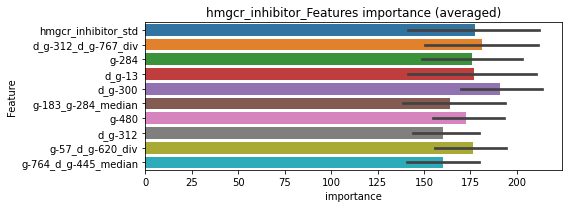

len(train_index) : 2342
len(valid_index) : 781
================================= fold 1/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0875111	valid_1's binary_logloss: 0.163945
[200]	training's binary_logloss: 0.0340253	valid_1's binary_logloss: 0.1173
[300]	training's binary_logloss: 0.0153674	valid_1's binary_logloss: 0.100508
[400]	training's binary_logloss: 0.00756805	valid_1's binary_logloss: 0.0909565
[500]	training's binary_logloss: 0.00416492	valid_1's binary_logloss: 0.0863252
[600]	training's binary_logloss: 0.00264324	valid_1's binary_logloss: 0.0854959
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00228973	valid_1's binary_logloss: 0.0852296


len(train_index) : 2342
len(valid_index) : 781
================================= fold 2/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.092321	valid_1's binary_logloss: 0.135452
[200]	training's binary_logloss: 0.0378692	valid_1's binary_logloss: 0.0835545
[300]	training's binary_logloss: 0.017149	valid_1's binary_logloss: 0.0585744
[400]	training's binary_logloss: 0.00848264	valid_1's binary_logloss: 0.0451942
[500]	training's binary_logloss: 0.00465896	valid_1's binary_logloss: 0.0381368
[600]	training's binary_logloss: 0.00291507	valid_1's binary_logloss: 0.0343425
[700]	training's binary_logloss: 0.00202803	valid_1's binary_logloss: 0.0314251
[800]	training's binary_logloss: 0.00154971	valid_1's binary_logloss: 0.0305487
Early stopping, best iteration is:
[776]	training's binary_logloss: 0.00164122	valid_1's binary_logloss: 0.0303695


len(train_index) : 2342
len(valid_index) : 781
================================= fold 3/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0864434	valid_1's binary_logloss: 0.155358
[200]	training's binary_logloss: 0.033749	valid_1's binary_logloss: 0.11607
[300]	training's binary_logloss: 0.0152663	valid_1's binary_logloss: 0.100037
[400]	training's binary_logloss: 0.00759629	valid_1's binary_logloss: 0.0948428
[500]	training's binary_logloss: 0.0042227	valid_1's binary_logloss: 0.0925407
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00380512	valid_1's binary_logloss: 0.0920263


len(train_index) : 2343
len(valid_index) : 780
================================= fold 4/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0860098	valid_1's binary_logloss: 0.17159
[200]	training's binary_logloss: 0.0345012	valid_1's binary_logloss: 0.135975
[300]	training's binary_logloss: 0.0159456	valid_1's binary_logloss: 0.124411
[400]	training's binary_logloss: 0.00782409	valid_1's binary_logloss: 0.12052
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00541273	valid_1's binary_logloss: 0.119005


hmgcr_inhibitor logloss: 0.08164571980857452


neg labels: 3289 → selected neg labels: 3272


hsp_inhibitor, len(trt): 93, len(othr): 3272, target_rate: 0.0039053 → Adj_target_rate: 0.0039574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.157165	valid_1's binary_logloss: 0.237495
[200]	training's binary_logloss: 0.072262	valid_1's binary_logloss: 0.169281
[300]	training's binary_logloss: 0.037488	valid_1's binary_logloss: 0.137539
[400]	training's binary_logloss: 0.019895	valid_1's binary_logloss: 0.117046
[500]	training's binary_logloss: 0.0112127	valid_1's binary_logloss: 0.105649
[600]	training's binary_logloss: 0.00666111	valid_1's binary_logloss: 0.100096
[700]	training's binary_logloss: 0.00426166	valid_1's binary_logloss: 0.0968296
[800]	training's binary_logloss: 0.00296644	valid_1's binary_logloss: 0.0944738
Early stopping, best iteration is:
[797]	training's binary_logloss: 0.00299482	valid_1's binary_logloss: 0.0943993
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.156106	valid_1's binary_logloss: 0.244992
[200]	training's binary_logloss: 0.0738015	valid_1's binary_l

1 / 3 AUC score:0.991
y_Threshold: 0.0443830, Threshold: 0.2379824, pos_neg_ratio: 0.8000000
Remove_noisy_data: 180 → Positive_corect_labels: 630/3746
p_label_rate: 0.0100452 Vs.target_rate: 0.00391, Num_p_label: 40.0, conf_0:0.16659, conf_1:0.30938
threshold: 0.2379824, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 630.0/3746, y_label_rate: 0.1681794
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135901	valid_1's binary_logloss: 0.234844
[200]	training's binary_logloss: 0.0588029	valid_1's binary_logloss: 0.17117
[300]	training's binary_logloss: 0.028582	valid_1's binary_logloss: 0.143823
[400]	training's binary_logloss: 0.0145663	valid_1's binary_logloss: 0.131098
[500]	training's binary_logloss: 0.00780137	valid_1's binary_logloss: 0.124462
[600]	training's binary_logloss: 0.00461929	valid_1's binary_logloss: 0.122609
[700]	training's binary_logloss: 0.00301012	valid_1's binary_logloss: 0.122166
Early stopping, best iteration is:
[673]	training's binary_logloss: 0.00333366	valid_1's binary_logloss: 0.121435
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.146846	valid_1's binary_logloss: 0.213691
[200]	training's binary_logloss: 0.0615993	valid_1's binary_logloss: 0.138861
[300]	training's binary_logloss: 0.0294755	valid_1's binary_log

2 / 3 AUC score:0.993
y_Threshold: 0.1144623, Threshold: 0.2379824, pos_neg_ratio: 0.8000000
Remove_noisy_data: 68 → Positive_corect_labels: 596.0/3678
p_label_rate: 0.0271220 Vs.target_rate: 0.00391, Num_p_label: 108.0, conf_0:0.19039, conf_1:0.28558
Num_p_label: 108.0, Expected: 15.6, Adj_threshold_1: 0.2379824
Num_p_label: 94.0, Expected: 15.6, Adj_threshold_2: 0.2679824
Num_p_label: 84.0, Expected: 15.6, Adj_threshold_3: 0.2979824
Num_p_label: 76.0, Expected: 15.6, Adj_threshold_4: 0.3279824
Num_p_label: 71.0, Expected: 15.6, Adj_threshold_5: 0.3579824
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_6: 0.3879824
Num_p_label: 56.0, Expected: 15.6, Adj_threshold_7: 0.4179824
Num_p_label: 51.0, Expected: 15.6, Adj_threshold_8: 0.4479824
Num_p_label: 47.0, Expected: 15.6, Adj_threshold_9: 0.4779824
Num_p_label: 42.0, Expected: 15.6, Adj_threshold_10: 0.5079824
threshold: 0.5379824, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 596.0/3678, y_label_rate: 0.16204

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126632	valid_1's binary_logloss: 0.215795
[200]	training's binary_logloss: 0.0501682	valid_1's binary_logloss: 0.153825
[300]	training's binary_logloss: 0.0225733	valid_1's binary_logloss: 0.129144
[400]	training's binary_logloss: 0.0108331	valid_1's binary_logloss: 0.119893
[500]	training's binary_logloss: 0.00577021	valid_1's binary_logloss: 0.116569
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00419842	valid_1's binary_logloss: 0.114536
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131019	valid_1's binary_logloss: 0.186896
[200]	training's binary_logloss: 0.0524696	valid_1's binary_logloss: 0.115296
[300]	training's binary_logloss: 0.0233495	valid_1's binary_logloss: 0.0838662
[400]	training's binary_logloss: 0.0113415	valid_1's binary_logloss: 0.0666752
[500]	training's binary_logloss: 0.00605588	valid_1's binary_

3 / 3 AUC score:0.992
y_Threshold: 0.1250835, Threshold: 0.5379824, pos_neg_ratio: 0.8000000
Remove_noisy_data: 50 → Positive_corect_labels: 571.0/3628
p_label_rate: 0.0125565 Vs.target_rate: 0.00391, Num_p_label: 50.0, conf_0:0.48418, conf_1:0.59178
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_1: 0.5379824
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_2: 0.5679824
Num_p_label: 47.0, Expected: 15.6, Adj_threshold_3: 0.5979824
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_4: 0.6279824
Num_p_label: 35.0, Expected: 15.6, Adj_threshold_5: 0.6579824
Num_p_label: 33.0, Expected: 15.6, Adj_threshold_6: 0.6879824
threshold: 0.6879824, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 571.0/3628, y_label_rate: 0.1573870


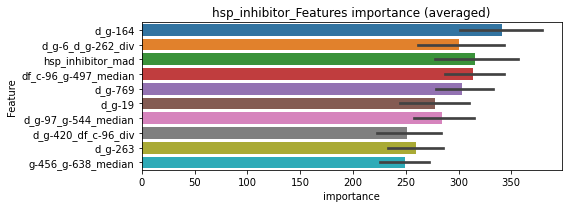

len(train_index) : 2721
len(valid_index) : 907
================================= fold 1/4 hsp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122895	valid_1's binary_logloss: 0.184181
[200]	training's binary_logloss: 0.0479538	valid_1's binary_logloss: 0.112146
[300]	training's binary_logloss: 0.0207948	valid_1's binary_logloss: 0.0793185
[400]	training's binary_logloss: 0.0101345	valid_1's binary_logloss: 0.06463
[500]	training's binary_logloss: 0.00524986	valid_1's binary_logloss: 0.0546793
[600]	training's binary_logloss: 0.00315959	valid_1's binary_logloss: 0.0500965
[700]	training's binary_logloss: 0.00214348	valid_1's binary_logloss: 0.0472789
[800]	training's binary_logloss: 0.00159582	valid_1's binary_logloss: 0.0460762
[900]	training's binary_logloss: 0.00127723	valid_1's binary_logloss: 0.0449141
[1000]	training's binary_logloss: 0.00107798	valid_1's binary_logloss: 0.0443286
[1100]	training's binary_logloss: 0.000968902	valid_1's binary_logloss: 0.0439306
Early stopping, best iteration is:
[1084]	training's binary_loglo

len(train_index) : 2721
len(valid_index) : 907
================================= fold 2/4 hsp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122378	valid_1's binary_logloss: 0.169941
[200]	training's binary_logloss: 0.0477518	valid_1's binary_logloss: 0.100553
[300]	training's binary_logloss: 0.0205641	valid_1's binary_logloss: 0.0706212
[400]	training's binary_logloss: 0.00976859	valid_1's binary_logloss: 0.0562498
[500]	training's binary_logloss: 0.00516306	valid_1's binary_logloss: 0.0487654
[600]	training's binary_logloss: 0.00312878	valid_1's binary_logloss: 0.0446103
[700]	training's binary_logloss: 0.0021305	valid_1's binary_logloss: 0.0429808
[800]	training's binary_logloss: 0.0015944	valid_1's binary_logloss: 0.0415883
[900]	training's binary_logloss: 0.00127466	valid_1's binary_logloss: 0.0405948
[1000]	training's binary_logloss: 0.00107442	valid_1's binary_logloss: 0.039803
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.00108151	valid_1's binary_logloss: 0.0397137


len(train_index) : 2721
len(valid_index) : 907
================================= fold 3/4 hsp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120914	valid_1's binary_logloss: 0.182022
[200]	training's binary_logloss: 0.0484203	valid_1's binary_logloss: 0.110483
[300]	training's binary_logloss: 0.021565	valid_1's binary_logloss: 0.0794329
[400]	training's binary_logloss: 0.0104717	valid_1's binary_logloss: 0.0653947
[500]	training's binary_logloss: 0.00556036	valid_1's binary_logloss: 0.0579662
[600]	training's binary_logloss: 0.00331258	valid_1's binary_logloss: 0.054201
[700]	training's binary_logloss: 0.00222878	valid_1's binary_logloss: 0.0513291
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.00181329	valid_1's binary_logloss: 0.0502881


len(train_index) : 2721
len(valid_index) : 907
================================= fold 4/4 hsp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120866	valid_1's binary_logloss: 0.177255
[200]	training's binary_logloss: 0.0472517	valid_1's binary_logloss: 0.112564
[300]	training's binary_logloss: 0.0207842	valid_1's binary_logloss: 0.08436
[400]	training's binary_logloss: 0.00970279	valid_1's binary_logloss: 0.0717191
[500]	training's binary_logloss: 0.0050617	valid_1's binary_logloss: 0.0643681
[600]	training's binary_logloss: 0.00304898	valid_1's binary_logloss: 0.0614282
[700]	training's binary_logloss: 0.00207342	valid_1's binary_logloss: 0.0591111
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.00174674	valid_1's binary_logloss: 0.0583822


hsp_inhibitor logloss: 0.04804977101415793
igf-1_inhibitor, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108038	valid_1's binary_logloss: 0.150765
[200]	training's binary_logloss: 0.0383463	valid_1's binary_logloss: 0.0738983
[300]	training's binary_logloss: 0.0158337	valid_1's binary_logloss: 0.0445225
[400]	training's binary_logloss: 0.00727591	valid_1's binary_logloss: 0.0310797
[500]	training's binary_logloss: 0.00369861	valid_1's binary_logloss: 0.0240571
[600]	training's binary_logloss: 0.00222321	valid_1's binary_logloss: 0.0207903
[700]	training's binary_logloss: 0.00151972	valid_1's binary_logloss: 0.0186412
[800]	training's binary_logloss: 0.00115472	valid_1's binary_logloss: 0.0176939
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00106166	valid_1's binary_logloss: 0.0174239
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10755	valid_1's binary_logloss: 0.146586
[200]	training's binary_logloss: 0.0379572	valid_1's

1 / 3 AUC score:1.000
y_Threshold: 0.0148697, Threshold: 0.1187723, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.08314, conf_1:0.15440
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.1187723
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_2: 0.1487723
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_3: 0.1787723
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_4: 0.2087723
threshold: 0.2087723, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103492	valid_1's binary_logloss: 0.146578
[200]	training's binary_logloss: 0.0345482	valid_1's binary_logloss: 0.0688551
[300]	training's binary_logloss: 0.013434	valid_1's binary_logloss: 0.0389586
[400]	training's binary_logloss: 0.0058867	valid_1's binary_logloss: 0.026743
[500]	training's binary_logloss: 0.00300438	valid_1's binary_logloss: 0.0207687
[600]	training's binary_logloss: 0.00184549	valid_1's binary_logloss: 0.018228
[700]	training's binary_logloss: 0.00128715	valid_1's binary_logloss: 0.0166181
[800]	training's binary_logloss: 0.000993928	valid_1's binary_logloss: 0.0158132
[900]	training's binary_logloss: 0.000819938	valid_1's binary_logloss: 0.015281
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000818793	valid_1's binary_logloss: 0.0152583
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103732	valid_1'

2 / 3 AUC score:1.000
y_Threshold: 0.0954562, Threshold: 0.2087723, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 651.0/3797
p_label_rate: 0.0178302 Vs.target_rate: 0.00155, Num_p_label: 71.0, conf_0:0.16702, conf_1:0.25053
Num_p_label: 71.0, Expected: 6.2, Adj_threshold_1: 0.2087723
Num_p_label: 68.0, Expected: 6.2, Adj_threshold_2: 0.2387723
Num_p_label: 66.0, Expected: 6.2, Adj_threshold_3: 0.2687723
Num_p_label: 57.0, Expected: 6.2, Adj_threshold_4: 0.2987723
Num_p_label: 53.0, Expected: 6.2, Adj_threshold_5: 0.3287723
Num_p_label: 50.0, Expected: 6.2, Adj_threshold_6: 0.3587723
Num_p_label: 47.0, Expected: 6.2, Adj_threshold_7: 0.3887723
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_8: 0.4187723
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_9: 0.4487723
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_10: 0.4787723
threshold: 0.5087723, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 651.0/3797, y_label_rate: 0.1714511
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100454	valid_1's binary_logloss: 0.13466
[200]	training's binary_logloss: 0.0323902	valid_1's binary_logloss: 0.0600496
[300]	training's binary_logloss: 0.0120398	valid_1's binary_logloss: 0.033487
[400]	training's binary_logloss: 0.00524942	valid_1's binary_logloss: 0.0225821
[500]	training's binary_logloss: 0.00275322	valid_1's binary_logloss: 0.0180317
[600]	training's binary_logloss: 0.00171262	valid_1's binary_logloss: 0.0156332
[700]	training's binary_logloss: 0.00121764	valid_1's binary_logloss: 0.014519
[800]	training's binary_logloss: 0.000942904	valid_1's binary_logloss: 0.0140545
[900]	training's binary_logloss: 0.00077776	valid_1's binary_logloss: 0.0135205
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000770373	valid_1's binary_logloss: 0.0134764
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102804	valid_1

3 / 3 AUC score:0.999
y_Threshold: 0.0860982, Threshold: 0.5087723, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 649.0/3793
p_label_rate: 0.0102963 Vs.target_rate: 0.00155, Num_p_label: 41.0, conf_0:0.45790, conf_1:0.55965
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_1: 0.5087723
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_2: 0.5387723
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_3: 0.5687723
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_4: 0.5987723
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_5: 0.6287723
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_6: 0.6587723
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_7: 0.6887723
threshold: 0.6887723, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 649.0/3793, y_label_rate: 0.1711047


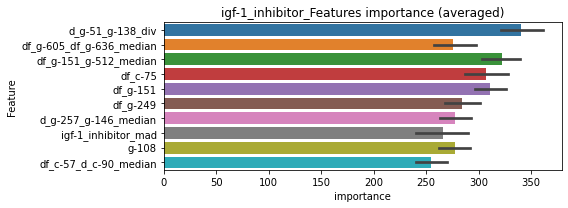

len(train_index) : 2844
len(valid_index) : 949
================================= fold 1/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.099872	valid_1's binary_logloss: 0.129936
[200]	training's binary_logloss: 0.0316811	valid_1's binary_logloss: 0.0535406
[300]	training's binary_logloss: 0.0119581	valid_1's binary_logloss: 0.0261033
[400]	training's binary_logloss: 0.00520271	valid_1's binary_logloss: 0.015001
[500]	training's binary_logloss: 0.0027333	valid_1's binary_logloss: 0.00992568
[600]	training's binary_logloss: 0.00170747	valid_1's binary_logloss: 0.00776933
[700]	training's binary_logloss: 0.00121271	valid_1's binary_logloss: 0.00652602
[800]	training's binary_logloss: 0.000937082	valid_1's binary_logloss: 0.00571255
[900]	training's binary_logloss: 0.000777609	valid_1's binary_logloss: 0.00526437
[1000]	training's binary_logloss: 0.000686284	valid_1's binary_logloss: 0.0050284
[1100]	training's binary_logloss: 0.000645015	valid_1's binary_logloss: 0.00491507
Early stopping, best iteration is:
[1090]	training's b

len(train_index) : 2845
len(valid_index) : 948
================================= fold 2/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0985635	valid_1's binary_logloss: 0.135729
[200]	training's binary_logloss: 0.031817	valid_1's binary_logloss: 0.0632781
[300]	training's binary_logloss: 0.0119996	valid_1's binary_logloss: 0.0342706
[400]	training's binary_logloss: 0.00522375	valid_1's binary_logloss: 0.0219278
[500]	training's binary_logloss: 0.00270576	valid_1's binary_logloss: 0.016357
[600]	training's binary_logloss: 0.00167305	valid_1's binary_logloss: 0.013576
[700]	training's binary_logloss: 0.00118823	valid_1's binary_logloss: 0.0123585
[800]	training's binary_logloss: 0.000923655	valid_1's binary_logloss: 0.0116841
[900]	training's binary_logloss: 0.000763019	valid_1's binary_logloss: 0.0110712
[1000]	training's binary_logloss: 0.000678192	valid_1's binary_logloss: 0.0109242
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.000681192	valid_1's binary_logloss: 0.0109031


len(train_index) : 2845
len(valid_index) : 948
================================= fold 3/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968172	valid_1's binary_logloss: 0.131672
[200]	training's binary_logloss: 0.0310884	valid_1's binary_logloss: 0.0610964
[300]	training's binary_logloss: 0.0116605	valid_1's binary_logloss: 0.0354065
[400]	training's binary_logloss: 0.0050525	valid_1's binary_logloss: 0.0238162
[500]	training's binary_logloss: 0.00262892	valid_1's binary_logloss: 0.0183233
[600]	training's binary_logloss: 0.00164254	valid_1's binary_logloss: 0.0152819
[700]	training's binary_logloss: 0.00115959	valid_1's binary_logloss: 0.013717
[800]	training's binary_logloss: 0.000899906	valid_1's binary_logloss: 0.0125447
[900]	training's binary_logloss: 0.000751769	valid_1's binary_logloss: 0.0121112
[1000]	training's binary_logloss: 0.000679547	valid_1's binary_logloss: 0.0118936
Early stopping, best iteration is:
[1049]	training's binary_logloss: 0.000658633	valid_1's binary_logloss: 0.0117716


len(train_index) : 2845
len(valid_index) : 948
================================= fold 4/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0999545	valid_1's binary_logloss: 0.142918
[200]	training's binary_logloss: 0.0324381	valid_1's binary_logloss: 0.0685745
[300]	training's binary_logloss: 0.0123455	valid_1's binary_logloss: 0.0392967
[400]	training's binary_logloss: 0.00530043	valid_1's binary_logloss: 0.0262168
[500]	training's binary_logloss: 0.002757	valid_1's binary_logloss: 0.0205422
[600]	training's binary_logloss: 0.00170997	valid_1's binary_logloss: 0.0171507
[700]	training's binary_logloss: 0.00120565	valid_1's binary_logloss: 0.0156897
[800]	training's binary_logloss: 0.000931476	valid_1's binary_logloss: 0.0145554
[900]	training's binary_logloss: 0.00077071	valid_1's binary_logloss: 0.0139567
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.00071567	valid_1's binary_logloss: 0.0136724


igf-1_inhibitor logloss: 0.010311977619192687
ikk_inhibitor, len(trt): 30, len(othr): 3285, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.095898	valid_1's binary_logloss: 0.127057
[200]	training's binary_logloss: 0.0333159	valid_1's binary_logloss: 0.0620955
[300]	training's binary_logloss: 0.0121524	valid_1's binary_logloss: 0.0363747
[400]	training's binary_logloss: 0.00503412	valid_1's binary_logloss: 0.0254211
[500]	training's binary_logloss: 0.00251623	valid_1's binary_logloss: 0.0202513
[600]	training's binary_logloss: 0.00151336	valid_1's binary_logloss: 0.0176024
[700]	training's binary_logloss: 0.0010592	valid_1's binary_logloss: 0.0164051
[800]	training's binary_logloss: 0.000811979	valid_1's binary_logloss: 0.0158345
[900]	training's binary_logloss: 0.000672447	valid_1's binary_logloss: 0.0154908
Early stopping, best iteration is:
[893]	training's binary_logloss: 0.000680965	valid_1's binary_logloss: 0.0153846
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959029	val

1 / 3 AUC score:1.000
y_Threshold: 0.0117222, Threshold: 0.0827667, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.05794, conf_1:0.10760
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0827667
Num_p_label: 33.0, Expected: 5.0, Adj_threshold_2: 0.1127667
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_3: 0.1427667
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_4: 0.1727667
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_5: 0.2027667
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_6: 0.2327667
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_7: 0.2627667
threshold: 0.2627667, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.090626	valid_1's binary_logloss: 0.116808
[200]	training's binary_logloss: 0.029006	valid_1's binary_logloss: 0.0514855
[300]	training's binary_logloss: 0.0101144	valid_1's binary_logloss: 0.02888
[400]	training's binary_logloss: 0.00406093	valid_1's binary_logloss: 0.0193486
[500]	training's binary_logloss: 0.00204379	valid_1's binary_logloss: 0.0153492
[600]	training's binary_logloss: 0.00125378	valid_1's binary_logloss: 0.0135046
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00121021	valid_1's binary_logloss: 0.0132747
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0892709	valid_1's binary_logloss: 0.127442
[200]	training's binary_logloss: 0.0286992	valid_1's binary_logloss: 0.059537
[300]	training's binary_logloss: 0.0101062	valid_1's binary_logloss: 0.0332556
[400]	training's binary_logloss: 0.00414054	valid_1's bi

2 / 3 AUC score:1.000
y_Threshold: 0.1932675, Threshold: 0.2627667, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0123054 Vs.target_rate: 0.00126, Num_p_label: 49.0, conf_0:0.21021, conf_1:0.31532
Num_p_label: 49.0, Expected: 5.0, Adj_threshold_1: 0.2627667
Num_p_label: 44.0, Expected: 5.0, Adj_threshold_2: 0.2927667
Num_p_label: 42.0, Expected: 5.0, Adj_threshold_3: 0.3227667
Num_p_label: 41.0, Expected: 5.0, Adj_threshold_4: 0.3527667
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_5: 0.3827667
Num_p_label: 37.0, Expected: 5.0, Adj_threshold_6: 0.4127667
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_7: 0.4427667
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_8: 0.4727667
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_9: 0.5027667
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_10: 0.5327667
threshold: 0.5627667, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0889189	valid_1's binary_logloss: 0.115549
[200]	training's binary_logloss: 0.0279292	valid_1's binary_logloss: 0.0497619
[300]	training's binary_logloss: 0.00989923	valid_1's binary_logloss: 0.0252966
[400]	training's binary_logloss: 0.00402196	valid_1's binary_logloss: 0.0149172
[500]	training's binary_logloss: 0.00201692	valid_1's binary_logloss: 0.0101299
[600]	training's binary_logloss: 0.00123583	valid_1's binary_logloss: 0.00800368
[700]	training's binary_logloss: 0.000877451	valid_1's binary_logloss: 0.00669738
[800]	training's binary_logloss: 0.000681323	valid_1's binary_logloss: 0.00595418
[900]	training's binary_logloss: 0.000575576	valid_1's binary_logloss: 0.00552961
Early stopping, best iteration is:
[968]	training's binary_logloss: 0.000533297	valid_1's binary_logloss: 0.00535345
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

3 / 3 AUC score:1.000
y_Threshold: 0.1731154, Threshold: 0.5627667, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0065294 Vs.target_rate: 0.00126, Num_p_label: 26.0, conf_0:0.50000, conf_1:0.61904
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_1: 0.5627667
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_2: 0.5927667
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.6227667
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_4: 0.6527667
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_5: 0.6827667
threshold: 0.6827667, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 653.0/3802, y_label_rate: 0.1717517


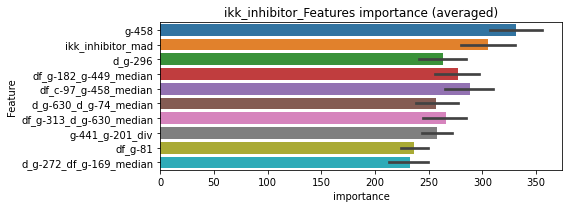

len(train_index) : 2851
len(valid_index) : 951
================================= fold 1/4 ikk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0883342	valid_1's binary_logloss: 0.113096
[200]	training's binary_logloss: 0.0274209	valid_1's binary_logloss: 0.0489526
[300]	training's binary_logloss: 0.00959226	valid_1's binary_logloss: 0.0251585
[400]	training's binary_logloss: 0.00396719	valid_1's binary_logloss: 0.0152172
[500]	training's binary_logloss: 0.00201521	valid_1's binary_logloss: 0.0106358
[600]	training's binary_logloss: 0.00123553	valid_1's binary_logloss: 0.0082807
[700]	training's binary_logloss: 0.000870752	valid_1's binary_logloss: 0.00690587
[800]	training's binary_logloss: 0.000682499	valid_1's binary_logloss: 0.00625669
[900]	training's binary_logloss: 0.000571446	valid_1's binary_logloss: 0.00581774
[1000]	training's binary_logloss: 0.000533322	valid_1's binary_logloss: 0.00561714
[1100]	training's binary_logloss: 0.000521963	valid_1's binary_logloss: 0.00557446
Early stopping, best iteration is:
[1088]	training

len(train_index) : 2851
len(valid_index) : 951
================================= fold 2/4 ikk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0873289	valid_1's binary_logloss: 0.112877
[200]	training's binary_logloss: 0.0280094	valid_1's binary_logloss: 0.0478522
[300]	training's binary_logloss: 0.0098375	valid_1's binary_logloss: 0.0229677
[400]	training's binary_logloss: 0.00398505	valid_1's binary_logloss: 0.0129073
[500]	training's binary_logloss: 0.00199845	valid_1's binary_logloss: 0.00831419
[600]	training's binary_logloss: 0.00123306	valid_1's binary_logloss: 0.00641994
[700]	training's binary_logloss: 0.000871213	valid_1's binary_logloss: 0.00533212
[800]	training's binary_logloss: 0.000677185	valid_1's binary_logloss: 0.00472765
[900]	training's binary_logloss: 0.000572205	valid_1's binary_logloss: 0.00434764
[1000]	training's binary_logloss: 0.000530827	valid_1's binary_logloss: 0.00421498
[1100]	training's binary_logloss: 0.00052417	valid_1's binary_logloss: 0.0041752
Early stopping, best iteration is:
[1079]	training'

len(train_index) : 2852
len(valid_index) : 950
================================= fold 3/4 ikk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885877	valid_1's binary_logloss: 0.122544
[200]	training's binary_logloss: 0.0277962	valid_1's binary_logloss: 0.0548168
[300]	training's binary_logloss: 0.00968543	valid_1's binary_logloss: 0.0287018
[400]	training's binary_logloss: 0.00389472	valid_1's binary_logloss: 0.0173597
[500]	training's binary_logloss: 0.00198096	valid_1's binary_logloss: 0.0121218
[600]	training's binary_logloss: 0.00122214	valid_1's binary_logloss: 0.00980283
[700]	training's binary_logloss: 0.000866311	valid_1's binary_logloss: 0.00823266
[800]	training's binary_logloss: 0.000676486	valid_1's binary_logloss: 0.00750123
[900]	training's binary_logloss: 0.000568163	valid_1's binary_logloss: 0.00706544
[1000]	training's binary_logloss: 0.000526894	valid_1's binary_logloss: 0.00691909
Early stopping, best iteration is:
[982]	training's binary_logloss: 0.00052809	valid_1's binary_logloss: 0.00691062


len(train_index) : 2852
len(valid_index) : 950
================================= fold 4/4 ikk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0895741	valid_1's binary_logloss: 0.116292
[200]	training's binary_logloss: 0.0279254	valid_1's binary_logloss: 0.0481313
[300]	training's binary_logloss: 0.00988161	valid_1's binary_logloss: 0.0229318
[400]	training's binary_logloss: 0.00397428	valid_1's binary_logloss: 0.0120444
[500]	training's binary_logloss: 0.00201693	valid_1's binary_logloss: 0.00766599
[600]	training's binary_logloss: 0.00123663	valid_1's binary_logloss: 0.00553196
[700]	training's binary_logloss: 0.000872228	valid_1's binary_logloss: 0.00434167
[800]	training's binary_logloss: 0.00067857	valid_1's binary_logloss: 0.00372261
[900]	training's binary_logloss: 0.000577617	valid_1's binary_logloss: 0.00339001
[1000]	training's binary_logloss: 0.000530284	valid_1's binary_logloss: 0.00325992
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.000532958	valid_1's binary_logloss: 0.00325881


ikk_inhibitor logloss: 0.004979923325610822
imidazoline_receptor_agonist, len(trt): 31, len(othr): 3286, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10015	valid_1's binary_logloss: 0.135366
[200]	training's binary_logloss: 0.0348639	valid_1's binary_logloss: 0.0666466
[300]	training's binary_logloss: 0.0130764	valid_1's binary_logloss: 0.0384973
[400]	training's binary_logloss: 0.00565469	valid_1's binary_logloss: 0.0268633
[500]	training's binary_logloss: 0.00287399	valid_1's binary_logloss: 0.021097
[600]	training's binary_logloss: 0.00174678	valid_1's binary_logloss: 0.0181929
[700]	training's binary_logloss: 0.00122763	valid_1's binary_logloss: 0.0169739
[800]	training's binary_logloss: 0.000948461	valid_1's binary_logloss: 0.0159868
[900]	training's binary_logloss: 0.000780963	valid_1's binary_logloss: 0.0154489
[1000]	training's binary_logloss: 0.000694466	valid_1's binary_logloss: 0.0152539
Early stopping, best iteration is:
[1061]	training's binary_logloss: 0.000663305	valid_1's binary_logloss: 0.0151394
Training until validation

1 / 3 AUC score:1.000
y_Threshold: 0.0130047, Threshold: 0.1330893, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.09316, conf_1:0.17302
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.1330893
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_2: 0.1630893
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_3: 0.1930893
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_4: 0.2230893
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_5: 0.2530893
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_6: 0.2830893
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_7: 0.3130893
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_8: 0.3430893
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_9: 0.3730893
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_10: 0.4030893
threshold: 0.4330893, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0965965	valid_1's binary_logloss: 0.127704
[200]	training's binary_logloss: 0.031835	valid_1's binary_logloss: 0.0567587
[300]	training's binary_logloss: 0.0113664	valid_1's binary_logloss: 0.0295039
[400]	training's binary_logloss: 0.00478981	valid_1's binary_logloss: 0.0186425
[500]	training's binary_logloss: 0.00247567	valid_1's binary_logloss: 0.0142811
[600]	training's binary_logloss: 0.00153477	valid_1's binary_logloss: 0.0120227
[700]	training's binary_logloss: 0.00108976	valid_1's binary_logloss: 0.0106894
[800]	training's binary_logloss: 0.00085052	valid_1's binary_logloss: 0.0100212
[900]	training's binary_logloss: 0.000708022	valid_1's binary_logloss: 0.00961665
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000701011	valid_1's binary_logloss: 0.00958401
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0936215	v

2 / 3 AUC score:1.000
y_Threshold: 0.0946196, Threshold: 0.4330893, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0120542 Vs.target_rate: 0.00130, Num_p_label: 48.0, conf_0:0.34647, conf_1:0.51971
Num_p_label: 48.0, Expected: 5.2, Adj_threshold_1: 0.4330893
Num_p_label: 48.0, Expected: 5.2, Adj_threshold_2: 0.4630893
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_3: 0.4930893
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_4: 0.5230893
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_5: 0.5530893
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_6: 0.5830893
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_7: 0.6130893
Num_p_label: 31.0, Expected: 5.2, Adj_threshold_8: 0.6430893
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_9: 0.6730893
threshold: 0.6730893, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 653.0/3803, y_label_rate: 0.1717065
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096435	valid_1's binary_logloss: 0.129821
[200]	training's binary_logloss: 0.0314483	valid_1's binary_logloss: 0.059012
[300]	training's binary_logloss: 0.0113411	valid_1's binary_logloss: 0.0317969
[400]	training's binary_logloss: 0.00475618	valid_1's binary_logloss: 0.0202829
[500]	training's binary_logloss: 0.00243727	valid_1's binary_logloss: 0.0150714
[600]	training's binary_logloss: 0.00151336	valid_1's binary_logloss: 0.0122694
[700]	training's binary_logloss: 0.0010829	valid_1's binary_logloss: 0.0110762
[800]	training's binary_logloss: 0.000845779	valid_1's binary_logloss: 0.0103581
[900]	training's binary_logloss: 0.000705187	valid_1's binary_logloss: 0.00989092
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.000682349	valid_1's binary_logloss: 0.00977398
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0934591	va

3 / 3 AUC score:1.000
y_Threshold: 0.0929814, Threshold: 0.6730893, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0070316 Vs.target_rate: 0.00130, Num_p_label: 28.0, conf_0:0.50000, conf_1:0.74040
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_1: 0.6730893
threshold: 0.6730893, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 653.0/3803, y_label_rate: 0.1717065


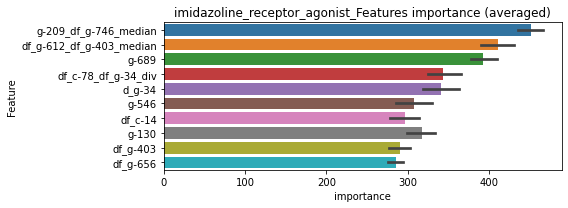

len(train_index) : 2852
len(valid_index) : 951
================================= fold 1/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0941885	valid_1's binary_logloss: 0.128097
[200]	training's binary_logloss: 0.0308015	valid_1's binary_logloss: 0.0587024
[300]	training's binary_logloss: 0.0113552	valid_1's binary_logloss: 0.0330839
[400]	training's binary_logloss: 0.00477521	valid_1's binary_logloss: 0.0224581
[500]	training's binary_logloss: 0.00243932	valid_1's binary_logloss: 0.0175643
[600]	training's binary_logloss: 0.00151542	valid_1's binary_logloss: 0.0152929
[700]	training's binary_logloss: 0.00107501	valid_1's binary_logloss: 0.0137349
[800]	training's binary_logloss: 0.000838846	valid_1's binary_logloss: 0.0126767
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.00079064	valid_1's binary_logloss: 0.0124887


len(train_index) : 2852
len(valid_index) : 951
================================= fold 2/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0934731	valid_1's binary_logloss: 0.137542
[200]	training's binary_logloss: 0.0300171	valid_1's binary_logloss: 0.0658284
[300]	training's binary_logloss: 0.0108162	valid_1's binary_logloss: 0.0387825
[400]	training's binary_logloss: 0.00453626	valid_1's binary_logloss: 0.0269652
[500]	training's binary_logloss: 0.0023215	valid_1's binary_logloss: 0.0212733
[600]	training's binary_logloss: 0.00145957	valid_1's binary_logloss: 0.018615
[700]	training's binary_logloss: 0.00104133	valid_1's binary_logloss: 0.0175192
[800]	training's binary_logloss: 0.000817496	valid_1's binary_logloss: 0.0165842
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.000737266	valid_1's binary_logloss: 0.0161767


len(train_index) : 2852
len(valid_index) : 951
================================= fold 3/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0973167	valid_1's binary_logloss: 0.12953
[200]	training's binary_logloss: 0.0316975	valid_1's binary_logloss: 0.0562161
[300]	training's binary_logloss: 0.0116033	valid_1's binary_logloss: 0.0291753
[400]	training's binary_logloss: 0.00483603	valid_1's binary_logloss: 0.0180277
[500]	training's binary_logloss: 0.00246327	valid_1's binary_logloss: 0.0131971
[600]	training's binary_logloss: 0.00151787	valid_1's binary_logloss: 0.0108219
[700]	training's binary_logloss: 0.00107817	valid_1's binary_logloss: 0.00940967
[800]	training's binary_logloss: 0.000842225	valid_1's binary_logloss: 0.00875625
[900]	training's binary_logloss: 0.000703334	valid_1's binary_logloss: 0.00832312
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000683842	valid_1's binary_logloss: 0.00824066


len(train_index) : 2853
len(valid_index) : 950
================================= fold 4/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.097098	valid_1's binary_logloss: 0.122936
[200]	training's binary_logloss: 0.0311963	valid_1's binary_logloss: 0.051078
[300]	training's binary_logloss: 0.0113486	valid_1's binary_logloss: 0.0245333
[400]	training's binary_logloss: 0.00473499	valid_1's binary_logloss: 0.0135924
[500]	training's binary_logloss: 0.0024504	valid_1's binary_logloss: 0.00907895
[600]	training's binary_logloss: 0.00152807	valid_1's binary_logloss: 0.00692584
[700]	training's binary_logloss: 0.00109398	valid_1's binary_logloss: 0.00575277
[800]	training's binary_logloss: 0.000849535	valid_1's binary_logloss: 0.00492343
[900]	training's binary_logloss: 0.000707839	valid_1's binary_logloss: 0.00448294
[1000]	training's binary_logloss: 0.00063682	valid_1's binary_logloss: 0.00430583
[1100]	training's binary_logloss: 0.00061141	valid_1's binary_logloss: 0.00422939
[1200]	training's binary_logloss: 0.000594298	valid_1's

imidazoline_receptor_agonist logloss: 0.010266204545634943
immunosuppressant, len(trt): 73, len(othr): 3279, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.140975	valid_1's binary_logloss: 0.211335
[200]	training's binary_logloss: 0.0657245	valid_1's binary_logloss: 0.137852
[300]	training's binary_logloss: 0.0343661	valid_1's binary_logloss: 0.102045
[400]	training's binary_logloss: 0.0181074	valid_1's binary_logloss: 0.0791447
[500]	training's binary_logloss: 0.00980334	valid_1's binary_logloss: 0.0649942
[600]	training's binary_logloss: 0.00561228	valid_1's binary_logloss: 0.0545642
[700]	training's binary_logloss: 0.0035556	valid_1's binary_logloss: 0.0500943
[800]	training's binary_logloss: 0.00245822	valid_1's binary_logloss: 0.0463041
[900]	training's binary_logloss: 0.00185331	valid_1's binary_logloss: 0.0443367
[1000]	training's binary_logloss: 0.0014878	valid_1's binary_logloss: 0.042383
[1100]	training's binary_logloss: 0.0012553	valid_1's binary_logloss: 0.0414618
[1200]	training's binary_logloss: 0.00110129	valid_1's binary_logloss

1 / 3 AUC score:0.996
y_Threshold: 0.0351167, Threshold: 0.1981549, pos_neg_ratio: 0.8000000
Remove_noisy_data: 164 → Positive_corect_labels: 639/3770
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.13871, conf_1:0.25760
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.1981549
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.2281549
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_3: 0.2581549
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_4: 0.2881549
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_5: 0.3181549
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_6: 0.3481549
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_7: 0.3781549
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_8: 0.4081549
threshold: 0.4081549, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 639.0/3770, y_label_rate: 0.1694960
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130474	valid_1's binary_logloss: 0.200251
[200]	training's binary_logloss: 0.0536149	valid_1's binary_logloss: 0.123269
[300]	training's binary_logloss: 0.0260087	valid_1's binary_logloss: 0.0879226
[400]	training's binary_logloss: 0.0126988	valid_1's binary_logloss: 0.0654907
[500]	training's binary_logloss: 0.00660565	valid_1's binary_logloss: 0.0518506
[600]	training's binary_logloss: 0.00386713	valid_1's binary_logloss: 0.043345
[700]	training's binary_logloss: 0.00254162	valid_1's binary_logloss: 0.0389338
[800]	training's binary_logloss: 0.00183165	valid_1's binary_logloss: 0.0360434
[900]	training's binary_logloss: 0.00142743	valid_1's binary_logloss: 0.0339616
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.00145847	valid_1's binary_logloss: 0.0339214
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131427	valid_1's

2 / 3 AUC score:0.997
y_Threshold: 0.1475530, Threshold: 0.4081549, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 617.0/3726
p_label_rate: 0.0118031 Vs.target_rate: 0.00307, Num_p_label: 47.0, conf_0:0.32652, conf_1:0.48979
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_1: 0.4081549
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_2: 0.4381549
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_3: 0.4681549
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_4: 0.4981549
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_5: 0.5281549
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_6: 0.5581549
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_7: 0.5881549
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_8: 0.6181549
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_9: 0.6481549
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_10: 0.6781549
threshold: 0.6781549, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 617.0/3726, y_label_rate: 0.1655931

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122158	valid_1's binary_logloss: 0.179264
[200]	training's binary_logloss: 0.0479304	valid_1's binary_logloss: 0.107245
[300]	training's binary_logloss: 0.0211719	valid_1's binary_logloss: 0.0776344
[400]	training's binary_logloss: 0.0101893	valid_1's binary_logloss: 0.0631351
[500]	training's binary_logloss: 0.00537078	valid_1's binary_logloss: 0.0560893
[600]	training's binary_logloss: 0.00322083	valid_1's binary_logloss: 0.0515667
[700]	training's binary_logloss: 0.00215577	valid_1's binary_logloss: 0.0488102
[800]	training's binary_logloss: 0.00159091	valid_1's binary_logloss: 0.0477521
[900]	training's binary_logloss: 0.00126595	valid_1's binary_logloss: 0.0472045
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.00127175	valid_1's binary_logloss: 0.0470557
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12517	valid_1's

3 / 3 AUC score:0.995
y_Threshold: 0.1378923, Threshold: 0.6781549, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 596.0/3684
p_label_rate: 0.0070316 Vs.target_rate: 0.00307, Num_p_label: 28.0, conf_0:0.50000, conf_1:0.74597
threshold: 0.6781549, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 596.0/3684, y_label_rate: 0.1617807


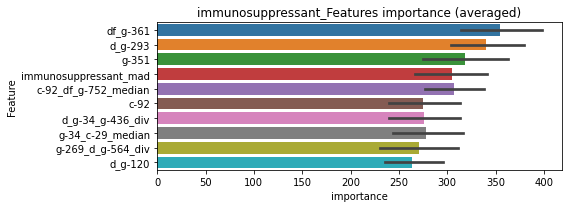

len(train_index) : 2763
len(valid_index) : 921
================================= fold 1/4 immunosuppressant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115983	valid_1's binary_logloss: 0.167235
[200]	training's binary_logloss: 0.044927	valid_1's binary_logloss: 0.0950543
[300]	training's binary_logloss: 0.0200574	valid_1's binary_logloss: 0.0626203
[400]	training's binary_logloss: 0.00934332	valid_1's binary_logloss: 0.0455054
[500]	training's binary_logloss: 0.00475608	valid_1's binary_logloss: 0.0360993
[600]	training's binary_logloss: 0.00279992	valid_1's binary_logloss: 0.0316305
[700]	training's binary_logloss: 0.00188424	valid_1's binary_logloss: 0.0294406
[800]	training's binary_logloss: 0.00140248	valid_1's binary_logloss: 0.0284933
[900]	training's binary_logloss: 0.00113146	valid_1's binary_logloss: 0.0278493
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.00100172	valid_1's binary_logloss: 0.0276009


len(train_index) : 2763
len(valid_index) : 921
================================= fold 2/4 immunosuppressant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114757	valid_1's binary_logloss: 0.169622
[200]	training's binary_logloss: 0.0432644	valid_1's binary_logloss: 0.100929
[300]	training's binary_logloss: 0.0185456	valid_1's binary_logloss: 0.0707113
[400]	training's binary_logloss: 0.00860256	valid_1's binary_logloss: 0.0570003
[500]	training's binary_logloss: 0.00448085	valid_1's binary_logloss: 0.0494315
[600]	training's binary_logloss: 0.0026597	valid_1's binary_logloss: 0.0452166
[700]	training's binary_logloss: 0.00179417	valid_1's binary_logloss: 0.0431621
[800]	training's binary_logloss: 0.00134359	valid_1's binary_logloss: 0.0419586
[900]	training's binary_logloss: 0.00108402	valid_1's binary_logloss: 0.0410762
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.0011148	valid_1's binary_logloss: 0.0409868


len(train_index) : 2763
len(valid_index) : 921
================================= fold 3/4 immunosuppressant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115206	valid_1's binary_logloss: 0.164333
[200]	training's binary_logloss: 0.044415	valid_1's binary_logloss: 0.0979159
[300]	training's binary_logloss: 0.0191944	valid_1's binary_logloss: 0.0697076
[400]	training's binary_logloss: 0.00883798	valid_1's binary_logloss: 0.0574632
[500]	training's binary_logloss: 0.00450878	valid_1's binary_logloss: 0.0505779
[600]	training's binary_logloss: 0.00270202	valid_1's binary_logloss: 0.0482716
[700]	training's binary_logloss: 0.00182684	valid_1's binary_logloss: 0.0464296
[800]	training's binary_logloss: 0.00136073	valid_1's binary_logloss: 0.0455763
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.00119668	valid_1's binary_logloss: 0.045285


len(train_index) : 2763
len(valid_index) : 921
================================= fold 4/4 immunosuppressant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115303	valid_1's binary_logloss: 0.161936
[200]	training's binary_logloss: 0.0439042	valid_1's binary_logloss: 0.0898771
[300]	training's binary_logloss: 0.0196329	valid_1's binary_logloss: 0.0614625
[400]	training's binary_logloss: 0.00898589	valid_1's binary_logloss: 0.0470473
[500]	training's binary_logloss: 0.00462086	valid_1's binary_logloss: 0.0389915
[600]	training's binary_logloss: 0.00276597	valid_1's binary_logloss: 0.0349658
[700]	training's binary_logloss: 0.00187469	valid_1's binary_logloss: 0.0325612
[800]	training's binary_logloss: 0.00139941	valid_1's binary_logloss: 0.0312113
[900]	training's binary_logloss: 0.00111361	valid_1's binary_logloss: 0.0301948
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000992832	valid_1's binary_logloss: 0.0298587


immunosuppressant logloss: 0.0359328650577246


neg labels: 3289 → selected neg labels: 3284


insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933622	valid_1's binary_logloss: 0.130562
[200]	training's binary_logloss: 0.0310664	valid_1's binary_logloss: 0.0633469
[300]	training's binary_logloss: 0.0114583	valid_1's binary_logloss: 0.036234
[400]	training's binary_logloss: 0.00482149	valid_1's binary_logloss: 0.0238427
[500]	training's binary_logloss: 0.00246731	valid_1's binary_logloss: 0.0182191
[600]	training's binary_logloss: 0.00151471	valid_1's binary_logloss: 0.0152177
[700]	training's binary_logloss: 0.00107011	valid_1's binary_logloss: 0.0133331
[800]	training's binary_logloss: 0.000836568	valid_1's binary_logloss: 0.0121854
[900]	training's binary_logloss: 0.000697274	valid_1's binary_logloss: 0.0115815
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.000660537	valid_1's binary_logloss: 0.0114172
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0915856	va

1 / 3 AUC score:1.000
y_Threshold: 0.0117121, Threshold: 0.0974100, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.06819, conf_1:0.12663
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0974100
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_2: 0.1274100
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.1574100
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_4: 0.1874100
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_5: 0.2174100
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_6: 0.2474100
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_7: 0.2774100
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.3074100
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_9: 0.3374100
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_10: 0.3674100
threshold: 0.3674100, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0902211	valid_1's binary_logloss: 0.122926
[200]	training's binary_logloss: 0.0277407	valid_1's binary_logloss: 0.0529147
[300]	training's binary_logloss: 0.00997663	valid_1's binary_logloss: 0.0286026
[400]	training's binary_logloss: 0.00413261	valid_1's binary_logloss: 0.0178805
[500]	training's binary_logloss: 0.00213591	valid_1's binary_logloss: 0.0131605
[600]	training's binary_logloss: 0.00132834	valid_1's binary_logloss: 0.0109259
[700]	training's binary_logloss: 0.000948141	valid_1's binary_logloss: 0.00959065
[800]	training's binary_logloss: 0.000744368	valid_1's binary_logloss: 0.00885784
[900]	training's binary_logloss: 0.000624194	valid_1's binary_logloss: 0.00850216
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.000583023	valid_1's binary_logloss: 0.00827743
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.090

2 / 3 AUC score:1.000
y_Threshold: 0.1322604, Threshold: 0.3674100, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0077850 Vs.target_rate: 0.00126, Num_p_label: 31.0, conf_0:0.29393, conf_1:0.44089
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_1: 0.3674100
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_2: 0.3974100
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_3: 0.4274100
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_4: 0.4574100
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_5: 0.4874100
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_6: 0.5174100
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_7: 0.5474100
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_8: 0.5774100
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_9: 0.6074100
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_10: 0.6374100
threshold: 0.6674100, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0882424	valid_1's binary_logloss: 0.132802
[200]	training's binary_logloss: 0.0260609	valid_1's binary_logloss: 0.0665977
[300]	training's binary_logloss: 0.0091721	valid_1's binary_logloss: 0.0446325
[400]	training's binary_logloss: 0.00381017	valid_1's binary_logloss: 0.0379334
[500]	training's binary_logloss: 0.00198102	valid_1's binary_logloss: 0.03568
[600]	training's binary_logloss: 0.00125414	valid_1's binary_logloss: 0.0345966
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00117958	valid_1's binary_logloss: 0.0341484
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0905686	valid_1's binary_logloss: 0.119267
[200]	training's binary_logloss: 0.0282286	valid_1's binary_logloss: 0.0499365
[300]	training's binary_logloss: 0.0102447	valid_1's binary_logloss: 0.0255507
[400]	training's binary_logloss: 0.00424034	valid_1's

3 / 3 AUC score:0.999
y_Threshold: 0.1095921, Threshold: 0.6674100, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 650.0/3796
p_label_rate: 0.0042692 Vs.target_rate: 0.00126, Num_p_label: 17.0, conf_0:0.50000, conf_1:0.73415
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.6674100
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_2: 0.6974100
threshold: 0.6974100, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 650.0/3796, y_label_rate: 0.1712329


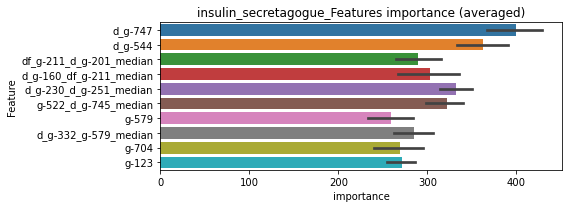

len(train_index) : 2847
len(valid_index) : 949
================================= fold 1/4 insulin_secretagogue=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0906355	valid_1's binary_logloss: 0.119574
[200]	training's binary_logloss: 0.0271353	valid_1's binary_logloss: 0.0464344
[300]	training's binary_logloss: 0.00982308	valid_1's binary_logloss: 0.0222893
[400]	training's binary_logloss: 0.004116	valid_1's binary_logloss: 0.0124468
[500]	training's binary_logloss: 0.00209975	valid_1's binary_logloss: 0.00794267
[600]	training's binary_logloss: 0.00130546	valid_1's binary_logloss: 0.00582229
[700]	training's binary_logloss: 0.000928507	valid_1's binary_logloss: 0.00467912
[800]	training's binary_logloss: 0.000733626	valid_1's binary_logloss: 0.00401444
[900]	training's binary_logloss: 0.000620689	valid_1's binary_logloss: 0.00364067
[1000]	training's binary_logloss: 0.000574893	valid_1's binary_logloss: 0.00348751
[1100]	training's binary_logloss: 0.000551288	valid_1's binary_logloss: 0.00341686
Early stopping, best iteration is:
[1150]	training

len(train_index) : 2847
len(valid_index) : 949
================================= fold 2/4 insulin_secretagogue=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0879547	valid_1's binary_logloss: 0.12098
[200]	training's binary_logloss: 0.02655	valid_1's binary_logloss: 0.0493727
[300]	training's binary_logloss: 0.0094211	valid_1's binary_logloss: 0.0247433
[400]	training's binary_logloss: 0.00393804	valid_1's binary_logloss: 0.0146096
[500]	training's binary_logloss: 0.00202629	valid_1's binary_logloss: 0.0101134
[600]	training's binary_logloss: 0.0012686	valid_1's binary_logloss: 0.0079628
[700]	training's binary_logloss: 0.000901491	valid_1's binary_logloss: 0.00661567
[800]	training's binary_logloss: 0.000706967	valid_1's binary_logloss: 0.00593371
[900]	training's binary_logloss: 0.000605083	valid_1's binary_logloss: 0.00552431
[1000]	training's binary_logloss: 0.000563024	valid_1's binary_logloss: 0.00531569
Early stopping, best iteration is:
[1050]	training's binary_logloss: 0.00055052	valid_1's binary_logloss: 0.00523639


len(train_index) : 2847
len(valid_index) : 949
================================= fold 3/4 insulin_secretagogue=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0895732	valid_1's binary_logloss: 0.11657
[200]	training's binary_logloss: 0.0274616	valid_1's binary_logloss: 0.0471562
[300]	training's binary_logloss: 0.00987107	valid_1's binary_logloss: 0.0230041
[400]	training's binary_logloss: 0.00407349	valid_1's binary_logloss: 0.0133343
[500]	training's binary_logloss: 0.00208473	valid_1's binary_logloss: 0.00943999
[600]	training's binary_logloss: 0.0012899	valid_1's binary_logloss: 0.007581
[700]	training's binary_logloss: 0.000920249	valid_1's binary_logloss: 0.00684459
[800]	training's binary_logloss: 0.000722995	valid_1's binary_logloss: 0.00621131
[900]	training's binary_logloss: 0.000612884	valid_1's binary_logloss: 0.00592387
[1000]	training's binary_logloss: 0.000561103	valid_1's binary_logloss: 0.00581772
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000563761	valid_1's binary_logloss: 0.00581623


len(train_index) : 2847
len(valid_index) : 949
================================= fold 4/4 insulin_secretagogue=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0905651	valid_1's binary_logloss: 0.118421
[200]	training's binary_logloss: 0.0272777	valid_1's binary_logloss: 0.0468131
[300]	training's binary_logloss: 0.00982379	valid_1's binary_logloss: 0.0237016
[400]	training's binary_logloss: 0.00413087	valid_1's binary_logloss: 0.0145491
[500]	training's binary_logloss: 0.00213897	valid_1's binary_logloss: 0.0110033
[600]	training's binary_logloss: 0.00132659	valid_1's binary_logloss: 0.00906359
[700]	training's binary_logloss: 0.000938576	valid_1's binary_logloss: 0.00813293
[800]	training's binary_logloss: 0.000739034	valid_1's binary_logloss: 0.00763189
[900]	training's binary_logloss: 0.000617764	valid_1's binary_logloss: 0.00722615
[1000]	training's binary_logloss: 0.000569569	valid_1's binary_logloss: 0.00713029
Early stopping, best iteration is:
[1042]	training's binary_logloss: 0.000562596	valid_1's binary_logloss: 0.00710186


insulin_secretagogue logloss: 0.005396330520647936
insulin_sensitizer, len(trt): 51, len(othr): 3284, target_rate: 0.0021416 → Adj_target_rate: 0.0023748


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121995	valid_1's binary_logloss: 0.180652
[200]	training's binary_logloss: 0.0535241	valid_1's binary_logloss: 0.118488
[300]	training's binary_logloss: 0.0252487	valid_1's binary_logloss: 0.0883616
[400]	training's binary_logloss: 0.0116875	valid_1's binary_logloss: 0.0705179
[500]	training's binary_logloss: 0.00589166	valid_1's binary_logloss: 0.0625916
[600]	training's binary_logloss: 0.00334253	valid_1's binary_logloss: 0.0584542
[700]	training's binary_logloss: 0.00214577	valid_1's binary_logloss: 0.0563129
[800]	training's binary_logloss: 0.00155204	valid_1's binary_logloss: 0.0555704
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.00162659	valid_1's binary_logloss: 0.0554308
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125568	valid_1's binary_logloss: 0.178858
[200]	training's binary_logloss: 0.0540729	valid_1's 

1 / 3 AUC score:0.998
y_Threshold: 0.0273630, Threshold: 0.1675691, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3796
p_label_rate: 0.0100452 Vs.target_rate: 0.00214, Num_p_label: 40.0, conf_0:0.11730, conf_1:0.21784
Num_p_label: 40.0, Expected: 8.5, Adj_threshold_1: 0.1675691
Num_p_label: 32.0, Expected: 8.5, Adj_threshold_2: 0.1975691
Num_p_label: 26.0, Expected: 8.5, Adj_threshold_3: 0.2275691
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_4: 0.2575691
threshold: 0.2575691, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 650.0/3796, y_label_rate: 0.1712329
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118314	valid_1's binary_logloss: 0.162219
[200]	training's binary_logloss: 0.047222	valid_1's binary_logloss: 0.0908444
[300]	training's binary_logloss: 0.0200296	valid_1's binary_logloss: 0.05709
[400]	training's binary_logloss: 0.00906531	valid_1's binary_logloss: 0.0408319
[500]	training's binary_logloss: 0.00457627	valid_1's binary_logloss: 0.0333907
[600]	training's binary_logloss: 0.00267351	valid_1's binary_logloss: 0.0290041
[700]	training's binary_logloss: 0.00178176	valid_1's binary_logloss: 0.0273053
[800]	training's binary_logloss: 0.00130597	valid_1's binary_logloss: 0.02591
[900]	training's binary_logloss: 0.00103645	valid_1's binary_logloss: 0.0252745
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.000990077	valid_1's binary_logloss: 0.0251889
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114363	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.1365422, Threshold: 0.2575691, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 638.0/3772
p_label_rate: 0.0198393 Vs.target_rate: 0.00214, Num_p_label: 79.0, conf_0:0.20606, conf_1:0.30908
Num_p_label: 79.0, Expected: 8.5, Adj_threshold_1: 0.2575691
Num_p_label: 70.0, Expected: 8.5, Adj_threshold_2: 0.2875691
Num_p_label: 64.0, Expected: 8.5, Adj_threshold_3: 0.3175691
Num_p_label: 60.0, Expected: 8.5, Adj_threshold_4: 0.3475691
Num_p_label: 58.0, Expected: 8.5, Adj_threshold_5: 0.3775691
Num_p_label: 56.0, Expected: 8.5, Adj_threshold_6: 0.4075691
Num_p_label: 52.0, Expected: 8.5, Adj_threshold_7: 0.4375691
Num_p_label: 47.0, Expected: 8.5, Adj_threshold_8: 0.4675691
Num_p_label: 45.0, Expected: 8.5, Adj_threshold_9: 0.4975691
Num_p_label: 39.0, Expected: 8.5, Adj_threshold_10: 0.5275691
threshold: 0.5575691, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 638.0/3772, y_label_rate: 0.1691410
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110748	valid_1's binary_logloss: 0.15921
[200]	training's binary_logloss: 0.0422979	valid_1's binary_logloss: 0.0902268
[300]	training's binary_logloss: 0.0174812	valid_1's binary_logloss: 0.0606006
[400]	training's binary_logloss: 0.00782176	valid_1's binary_logloss: 0.047398
[500]	training's binary_logloss: 0.00394779	valid_1's binary_logloss: 0.0424556
[600]	training's binary_logloss: 0.00235515	valid_1's binary_logloss: 0.0394088
[700]	training's binary_logloss: 0.00159021	valid_1's binary_logloss: 0.0381934
[800]	training's binary_logloss: 0.00119038	valid_1's binary_logloss: 0.037512
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.00109978	valid_1's binary_logloss: 0.0374146
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112255	valid_1's binary_logloss: 0.179968
[200]	training's binary_logloss: 0.0425078	valid_1's b

3 / 3 AUC score:0.997
y_Threshold: 0.1087524, Threshold: 0.5575691, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 626.0/3748
p_label_rate: 0.0105475 Vs.target_rate: 0.00214, Num_p_label: 42.0, conf_0:0.50000, conf_1:0.61333
Num_p_label: 42.0, Expected: 8.5, Adj_threshold_1: 0.5575691
Num_p_label: 40.0, Expected: 8.5, Adj_threshold_2: 0.5875691
Num_p_label: 39.0, Expected: 8.5, Adj_threshold_3: 0.6175691
Num_p_label: 35.0, Expected: 8.5, Adj_threshold_4: 0.6475691
Num_p_label: 32.0, Expected: 8.5, Adj_threshold_5: 0.6775691
threshold: 0.6775691, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 626.0/3748, y_label_rate: 0.1670224


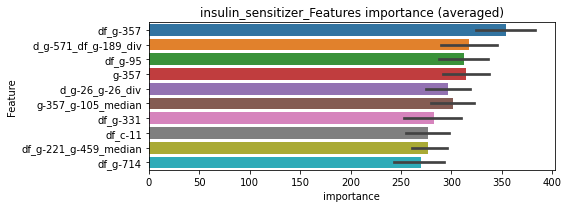

len(train_index) : 2811
len(valid_index) : 937
================================= fold 1/4 insulin_sensitizer=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107157	valid_1's binary_logloss: 0.148666
[200]	training's binary_logloss: 0.040376	valid_1's binary_logloss: 0.079506
[300]	training's binary_logloss: 0.0168693	valid_1's binary_logloss: 0.0494743
[400]	training's binary_logloss: 0.00747668	valid_1's binary_logloss: 0.0340868
[500]	training's binary_logloss: 0.00379357	valid_1's binary_logloss: 0.0259365
[600]	training's binary_logloss: 0.00224216	valid_1's binary_logloss: 0.0215306
[700]	training's binary_logloss: 0.00151221	valid_1's binary_logloss: 0.0193088
[800]	training's binary_logloss: 0.00113524	valid_1's binary_logloss: 0.0178539
[900]	training's binary_logloss: 0.000905269	valid_1's binary_logloss: 0.0166148
[1000]	training's binary_logloss: 0.00077298	valid_1's binary_logloss: 0.0157691
[1100]	training's binary_logloss: 0.000700701	valid_1's binary_logloss: 0.0154194
Early stopping, best iteration is:
[1131]	training's binary_lo

len(train_index) : 2811
len(valid_index) : 937
================================= fold 2/4 insulin_sensitizer=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104782	valid_1's binary_logloss: 0.158806
[200]	training's binary_logloss: 0.0398073	valid_1's binary_logloss: 0.0925181
[300]	training's binary_logloss: 0.0161706	valid_1's binary_logloss: 0.0592444
[400]	training's binary_logloss: 0.00714605	valid_1's binary_logloss: 0.0427008
[500]	training's binary_logloss: 0.0036098	valid_1's binary_logloss: 0.0336514
[600]	training's binary_logloss: 0.00214825	valid_1's binary_logloss: 0.0287482
[700]	training's binary_logloss: 0.00145036	valid_1's binary_logloss: 0.0262878
[800]	training's binary_logloss: 0.00109203	valid_1's binary_logloss: 0.0246304
[900]	training's binary_logloss: 0.000882318	valid_1's binary_logloss: 0.0236218
[1000]	training's binary_logloss: 0.000764309	valid_1's binary_logloss: 0.0229738
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.000738321	valid_1's binary_logloss: 0.022719


len(train_index) : 2811
len(valid_index) : 937
================================= fold 3/4 insulin_sensitizer=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106883	valid_1's binary_logloss: 0.138776
[200]	training's binary_logloss: 0.0400117	valid_1's binary_logloss: 0.0673849
[300]	training's binary_logloss: 0.0163661	valid_1's binary_logloss: 0.0368613
[400]	training's binary_logloss: 0.00737184	valid_1's binary_logloss: 0.0224705
[500]	training's binary_logloss: 0.00372855	valid_1's binary_logloss: 0.0152745
[600]	training's binary_logloss: 0.00222261	valid_1's binary_logloss: 0.0114468
[700]	training's binary_logloss: 0.00152563	valid_1's binary_logloss: 0.00964652
[800]	training's binary_logloss: 0.00115096	valid_1's binary_logloss: 0.00836014
[900]	training's binary_logloss: 0.000926033	valid_1's binary_logloss: 0.0075301
[1000]	training's binary_logloss: 0.000794345	valid_1's binary_logloss: 0.00697911
[1100]	training's binary_logloss: 0.000721463	valid_1's binary_logloss: 0.00664612
Early stopping, best iteration is:
[1132]	training's bi

len(train_index) : 2811
len(valid_index) : 937
================================= fold 4/4 insulin_sensitizer=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104032	valid_1's binary_logloss: 0.153372
[200]	training's binary_logloss: 0.0371704	valid_1's binary_logloss: 0.0805405
[300]	training's binary_logloss: 0.0159146	valid_1's binary_logloss: 0.0509809
[400]	training's binary_logloss: 0.00721121	valid_1's binary_logloss: 0.0366182
[500]	training's binary_logloss: 0.00364488	valid_1's binary_logloss: 0.0288921
[600]	training's binary_logloss: 0.002164	valid_1's binary_logloss: 0.0252984
[700]	training's binary_logloss: 0.00147795	valid_1's binary_logloss: 0.0233032
[800]	training's binary_logloss: 0.00111213	valid_1's binary_logloss: 0.0218813
[900]	training's binary_logloss: 0.000894306	valid_1's binary_logloss: 0.0211494
[1000]	training's binary_logloss: 0.000767208	valid_1's binary_logloss: 0.0206074
Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.000759057	valid_1's binary_logloss: 0.0205481


insulin_sensitizer logloss: 0.016300510347879126
integrin_inhibitor, len(trt): 42, len(othr): 3281, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103309	valid_1's binary_logloss: 0.16108
[200]	training's binary_logloss: 0.0425434	valid_1's binary_logloss: 0.0976457
[300]	training's binary_logloss: 0.0181934	valid_1's binary_logloss: 0.067398
[400]	training's binary_logloss: 0.0079502	valid_1's binary_logloss: 0.0518001
[500]	training's binary_logloss: 0.00393798	valid_1's binary_logloss: 0.043475
[600]	training's binary_logloss: 0.00223988	valid_1's binary_logloss: 0.0386234
[700]	training's binary_logloss: 0.00150024	valid_1's binary_logloss: 0.0356677
[800]	training's binary_logloss: 0.00111306	valid_1's binary_logloss: 0.0342322
[900]	training's binary_logloss: 0.000893521	valid_1's binary_logloss: 0.0339727
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000918077	valid_1's binary_logloss: 0.0336852
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106861	valid_1'

1 / 3 AUC score:1.000
y_Threshold: 0.0116511, Threshold: 0.0527206, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.03690, conf_1:0.06854
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.0527206
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_2: 0.0827206
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_3: 0.1127206
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_4: 0.1427206
threshold: 0.1427206, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103022	valid_1's binary_logloss: 0.150401
[200]	training's binary_logloss: 0.038312	valid_1's binary_logloss: 0.0834451
[300]	training's binary_logloss: 0.0167266	valid_1's binary_logloss: 0.055007
[400]	training's binary_logloss: 0.00719116	valid_1's binary_logloss: 0.038555
[500]	training's binary_logloss: 0.00349404	valid_1's binary_logloss: 0.0302363
[600]	training's binary_logloss: 0.00204756	valid_1's binary_logloss: 0.0262664
[700]	training's binary_logloss: 0.00136864	valid_1's binary_logloss: 0.0244309
[800]	training's binary_logloss: 0.00102134	valid_1's binary_logloss: 0.0232174
[900]	training's binary_logloss: 0.000830067	valid_1's binary_logloss: 0.0225155
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.000816582	valid_1's binary_logloss: 0.0224737
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103333	valid_1

2 / 3 AUC score:0.999
y_Threshold: 0.0795461, Threshold: 0.1427206, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0138122 Vs.target_rate: 0.00176, Num_p_label: 55.0, conf_0:0.11418, conf_1:0.17126
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_1: 0.1427206
Num_p_label: 44.0, Expected: 7.0, Adj_threshold_2: 0.1727206
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_3: 0.2027206
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_4: 0.2327206
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_5: 0.2627206
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_6: 0.2927206
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_7: 0.3227206
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_8: 0.3527206
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_9: 0.3827206
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_10: 0.4127206
threshold: 0.4427206, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 646.0/3785, y_label_rate: 0.1706737
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0994117	valid_1's binary_logloss: 0.139973
[200]	training's binary_logloss: 0.0370597	valid_1's binary_logloss: 0.0730584
[300]	training's binary_logloss: 0.0152918	valid_1's binary_logloss: 0.0453659
[400]	training's binary_logloss: 0.00676657	valid_1's binary_logloss: 0.0324518
[500]	training's binary_logloss: 0.00333829	valid_1's binary_logloss: 0.0258727
[600]	training's binary_logloss: 0.00194456	valid_1's binary_logloss: 0.0232118
[700]	training's binary_logloss: 0.00130205	valid_1's binary_logloss: 0.0218828
[800]	training's binary_logloss: 0.000976756	valid_1's binary_logloss: 0.0211649
Early stopping, best iteration is:
[839]	training's binary_logloss: 0.000895109	valid_1's binary_logloss: 0.0208119
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096681	valid_1's binary_logloss: 0.145828
[200]	training's binary_logloss: 0.0352776	valid

3 / 3 AUC score:0.999
y_Threshold: 0.0668985, Threshold: 0.4427206, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0057760 Vs.target_rate: 0.00176, Num_p_label: 23.0, conf_0:0.39845, conf_1:0.48699
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_1: 0.4427206
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_2: 0.4727206
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_3: 0.5027206
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_4: 0.5327206
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_5: 0.5627206
threshold: 0.5627206, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 639.0/3771, y_label_rate: 0.1694511


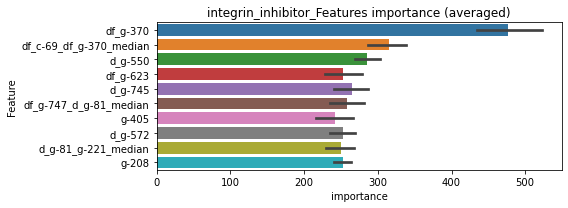

len(train_index) : 2828
len(valid_index) : 943
================================= fold 1/4 integrin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0936309	valid_1's binary_logloss: 0.138613
[200]	training's binary_logloss: 0.0347092	valid_1's binary_logloss: 0.0779124
[300]	training's binary_logloss: 0.0145362	valid_1's binary_logloss: 0.0537944
[400]	training's binary_logloss: 0.00625813	valid_1's binary_logloss: 0.0421759
[500]	training's binary_logloss: 0.00309132	valid_1's binary_logloss: 0.0350677
[600]	training's binary_logloss: 0.00180526	valid_1's binary_logloss: 0.032817
[700]	training's binary_logloss: 0.00122675	valid_1's binary_logloss: 0.0315572
Early stopping, best iteration is:
[739]	training's binary_logloss: 0.00108171	valid_1's binary_logloss: 0.0310745


len(train_index) : 2828
len(valid_index) : 943
================================= fold 2/4 integrin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957317	valid_1's binary_logloss: 0.128414
[200]	training's binary_logloss: 0.0360623	valid_1's binary_logloss: 0.0640955
[300]	training's binary_logloss: 0.0147865	valid_1's binary_logloss: 0.0376441
[400]	training's binary_logloss: 0.00627718	valid_1's binary_logloss: 0.0238542
[500]	training's binary_logloss: 0.00308612	valid_1's binary_logloss: 0.0172462
[600]	training's binary_logloss: 0.00183973	valid_1's binary_logloss: 0.0140396
[700]	training's binary_logloss: 0.00125473	valid_1's binary_logloss: 0.0123976
[800]	training's binary_logloss: 0.000948752	valid_1's binary_logloss: 0.0113718
[900]	training's binary_logloss: 0.000772673	valid_1's binary_logloss: 0.0107197
[1000]	training's binary_logloss: 0.000689859	valid_1's binary_logloss: 0.010534
Early stopping, best iteration is:
[1069]	training's binary_logloss: 0.000655958	valid_1's binary_logloss: 0.0104324


len(train_index) : 2828
len(valid_index) : 943
================================= fold 3/4 integrin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0936814	valid_1's binary_logloss: 0.12884
[200]	training's binary_logloss: 0.0334545	valid_1's binary_logloss: 0.0644107
[300]	training's binary_logloss: 0.0140005	valid_1's binary_logloss: 0.0397311
[400]	training's binary_logloss: 0.00607644	valid_1's binary_logloss: 0.0275401
[500]	training's binary_logloss: 0.00299557	valid_1's binary_logloss: 0.0211466
[600]	training's binary_logloss: 0.00177736	valid_1's binary_logloss: 0.0181591
[700]	training's binary_logloss: 0.00122169	valid_1's binary_logloss: 0.0163762
[800]	training's binary_logloss: 0.000929762	valid_1's binary_logloss: 0.0152181
[900]	training's binary_logloss: 0.000763568	valid_1's binary_logloss: 0.0148164
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.0008027	valid_1's binary_logloss: 0.014791


len(train_index) : 2829
len(valid_index) : 942
================================= fold 4/4 integrin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0961744	valid_1's binary_logloss: 0.132698
[200]	training's binary_logloss: 0.0344394	valid_1's binary_logloss: 0.0720974
[300]	training's binary_logloss: 0.0143575	valid_1's binary_logloss: 0.0490681
[400]	training's binary_logloss: 0.00637368	valid_1's binary_logloss: 0.0367491
[500]	training's binary_logloss: 0.0031444	valid_1's binary_logloss: 0.0306458
[600]	training's binary_logloss: 0.00183893	valid_1's binary_logloss: 0.0271746
[700]	training's binary_logloss: 0.00125508	valid_1's binary_logloss: 0.0262378
[800]	training's binary_logloss: 0.000949802	valid_1's binary_logloss: 0.0256635
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.000864473	valid_1's binary_logloss: 0.0253152


integrin_inhibitor logloss: 0.020403238140944427
jak_inhibitor, len(trt): 92, len(othr): 3273, target_rate: 0.0038633 → Adj_target_rate: 0.0039212


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.162123	valid_1's binary_logloss: 0.249512
[200]	training's binary_logloss: 0.0851223	valid_1's binary_logloss: 0.185813
[300]	training's binary_logloss: 0.04761	valid_1's binary_logloss: 0.15053
[400]	training's binary_logloss: 0.0266961	valid_1's binary_logloss: 0.128789
[500]	training's binary_logloss: 0.0156025	valid_1's binary_logloss: 0.11771
[600]	training's binary_logloss: 0.00932007	valid_1's binary_logloss: 0.109354
[700]	training's binary_logloss: 0.00579522	valid_1's binary_logloss: 0.106278
[800]	training's binary_logloss: 0.00383652	valid_1's binary_logloss: 0.105262
[900]	training's binary_logloss: 0.00275479	valid_1's binary_logloss: 0.104909
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.00300516	valid_1's binary_logloss: 0.104663
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.164803	valid_1's binary_logl

1 / 3 AUC score:0.988
y_Threshold: 0.0431057, Threshold: 0.3208351, pos_neg_ratio: 0.8000000
Remove_noisy_data: 192 → Positive_corect_labels: 624/3735
p_label_rate: 0.0100452 Vs.target_rate: 0.00386, Num_p_label: 40.0, conf_0:0.22458, conf_1:0.41709
threshold: 0.3208351, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 624.0/3735, y_label_rate: 0.1670683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.154559	valid_1's binary_logloss: 0.222874
[200]	training's binary_logloss: 0.072537	valid_1's binary_logloss: 0.150196
[300]	training's binary_logloss: 0.0373182	valid_1's binary_logloss: 0.114842
[400]	training's binary_logloss: 0.0202884	valid_1's binary_logloss: 0.093601
[500]	training's binary_logloss: 0.0110371	valid_1's binary_logloss: 0.0805106
[600]	training's binary_logloss: 0.00646918	valid_1's binary_logloss: 0.0720359
[700]	training's binary_logloss: 0.00406277	valid_1's binary_logloss: 0.0676171
[800]	training's binary_logloss: 0.00277959	valid_1's binary_logloss: 0.0651265
[900]	training's binary_logloss: 0.00205874	valid_1's binary_logloss: 0.0630245
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00207845	valid_1's binary_logloss: 0.0628747
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.155506	valid_1's bi

2 / 3 AUC score:0.993
y_Threshold: 0.1143076, Threshold: 0.3208351, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 593.0/3673
p_label_rate: 0.0301356 Vs.target_rate: 0.00386, Num_p_label: 120.0, conf_0:0.25667, conf_1:0.38500
Num_p_label: 120.0, Expected: 15.4, Adj_threshold_1: 0.3208351
Num_p_label: 111.0, Expected: 15.4, Adj_threshold_2: 0.3508351
Num_p_label: 97.0, Expected: 15.4, Adj_threshold_3: 0.3808351
Num_p_label: 89.0, Expected: 15.4, Adj_threshold_4: 0.4108351
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_5: 0.4408351
Num_p_label: 73.0, Expected: 15.4, Adj_threshold_6: 0.4708351
Num_p_label: 66.0, Expected: 15.4, Adj_threshold_7: 0.5008351
Num_p_label: 60.0, Expected: 15.4, Adj_threshold_8: 0.5308351
Num_p_label: 57.0, Expected: 15.4, Adj_threshold_9: 0.5608351
Num_p_label: 52.0, Expected: 15.4, Adj_threshold_10: 0.5908351
threshold: 0.6208351, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 593.0/3673, y_label_rate: 0.1614

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.139414	valid_1's binary_logloss: 0.204477
[200]	training's binary_logloss: 0.0613262	valid_1's binary_logloss: 0.130635
[300]	training's binary_logloss: 0.0300368	valid_1's binary_logloss: 0.0928589
[400]	training's binary_logloss: 0.0148529	valid_1's binary_logloss: 0.0708805
[500]	training's binary_logloss: 0.00802294	valid_1's binary_logloss: 0.0598758
[600]	training's binary_logloss: 0.00464486	valid_1's binary_logloss: 0.0525064
[700]	training's binary_logloss: 0.00297287	valid_1's binary_logloss: 0.0479713
[800]	training's binary_logloss: 0.00209595	valid_1's binary_logloss: 0.0447881
[900]	training's binary_logloss: 0.00161939	valid_1's binary_logloss: 0.0439428
[1000]	training's binary_logloss: 0.00133061	valid_1's binary_logloss: 0.0430425
Early stopping, best iteration is:
[1065]	training's binary_logloss: 0.001202	valid_1's binary_logloss: 0.0423515
Training until validation score

3 / 3 AUC score:0.997
y_Threshold: 0.0965562, Threshold: 0.6208351, pos_neg_ratio: 0.8000000
Remove_noisy_data: 46 → Positive_corect_labels: 570.0/3627
p_label_rate: 0.0175791 Vs.target_rate: 0.00386, Num_p_label: 70.0, conf_0:0.50000, conf_1:0.68292
Num_p_label: 70.0, Expected: 15.4, Adj_threshold_1: 0.6208351
Num_p_label: 59.0, Expected: 15.4, Adj_threshold_2: 0.6508351
Num_p_label: 56.0, Expected: 15.4, Adj_threshold_3: 0.6808351
threshold: 0.6808351, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 570.0/3627, y_label_rate: 0.1571547


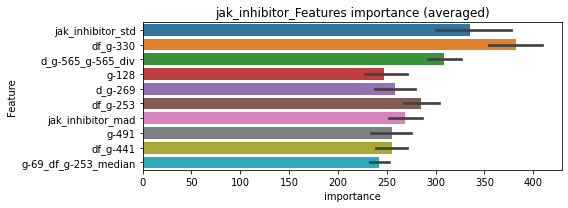

len(train_index) : 2720
len(valid_index) : 907
================================= fold 1/4 jak_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12877	valid_1's binary_logloss: 0.189871
[200]	training's binary_logloss: 0.054832	valid_1's binary_logloss: 0.119765
[300]	training's binary_logloss: 0.0270598	valid_1's binary_logloss: 0.0866013
[400]	training's binary_logloss: 0.0131149	valid_1's binary_logloss: 0.0660926
[500]	training's binary_logloss: 0.00672532	valid_1's binary_logloss: 0.0541071
[600]	training's binary_logloss: 0.00391356	valid_1's binary_logloss: 0.0475312
[700]	training's binary_logloss: 0.00255279	valid_1's binary_logloss: 0.0437006
[800]	training's binary_logloss: 0.00184577	valid_1's binary_logloss: 0.0418292
[900]	training's binary_logloss: 0.0014403	valid_1's binary_logloss: 0.0394072
[1000]	training's binary_logloss: 0.00119945	valid_1's binary_logloss: 0.038334
[1100]	training's binary_logloss: 0.00105981	valid_1's binary_logloss: 0.0376684
Early stopping, best iteration is:
[1144]	training's binary_logloss:

len(train_index) : 2720
len(valid_index) : 907
================================= fold 2/4 jak_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129487	valid_1's binary_logloss: 0.192981
[200]	training's binary_logloss: 0.0570856	valid_1's binary_logloss: 0.119796
[300]	training's binary_logloss: 0.0276375	valid_1's binary_logloss: 0.0814007
[400]	training's binary_logloss: 0.0133963	valid_1's binary_logloss: 0.0589682
[500]	training's binary_logloss: 0.00698478	valid_1's binary_logloss: 0.0445637
[600]	training's binary_logloss: 0.00405789	valid_1's binary_logloss: 0.0367165
[700]	training's binary_logloss: 0.00263401	valid_1's binary_logloss: 0.0323227
[800]	training's binary_logloss: 0.00189363	valid_1's binary_logloss: 0.0296345
[900]	training's binary_logloss: 0.0014688	valid_1's binary_logloss: 0.0279637
[1000]	training's binary_logloss: 0.0012146	valid_1's binary_logloss: 0.0268842
[1100]	training's binary_logloss: 0.00104838	valid_1's binary_logloss: 0.0257606
[1200]	training's binary_logloss: 0.000958571	valid_1's binary_log

len(train_index) : 2720
len(valid_index) : 907
================================= fold 3/4 jak_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12868	valid_1's binary_logloss: 0.192137
[200]	training's binary_logloss: 0.0549122	valid_1's binary_logloss: 0.117114
[300]	training's binary_logloss: 0.0254179	valid_1's binary_logloss: 0.0799187
[400]	training's binary_logloss: 0.0126288	valid_1's binary_logloss: 0.0602312
[500]	training's binary_logloss: 0.00659281	valid_1's binary_logloss: 0.0490893
[600]	training's binary_logloss: 0.00384957	valid_1's binary_logloss: 0.0430915
[700]	training's binary_logloss: 0.00251289	valid_1's binary_logloss: 0.0393529
[800]	training's binary_logloss: 0.00180741	valid_1's binary_logloss: 0.0374302
[900]	training's binary_logloss: 0.00139981	valid_1's binary_logloss: 0.0360338
[1000]	training's binary_logloss: 0.00116631	valid_1's binary_logloss: 0.0348362
[1100]	training's binary_logloss: 0.00102194	valid_1's binary_logloss: 0.0344784
Early stopping, best iteration is:
[1091]	training's binary_loglo

len(train_index) : 2721
len(valid_index) : 906
================================= fold 4/4 jak_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129068	valid_1's binary_logloss: 0.181357
[200]	training's binary_logloss: 0.0560668	valid_1's binary_logloss: 0.114005
[300]	training's binary_logloss: 0.0264767	valid_1's binary_logloss: 0.0819307
[400]	training's binary_logloss: 0.012709	valid_1's binary_logloss: 0.0648307
[500]	training's binary_logloss: 0.00668919	valid_1's binary_logloss: 0.055213
[600]	training's binary_logloss: 0.00390558	valid_1's binary_logloss: 0.0497404
[700]	training's binary_logloss: 0.00254007	valid_1's binary_logloss: 0.0472639
[800]	training's binary_logloss: 0.00182615	valid_1's binary_logloss: 0.0456007
[900]	training's binary_logloss: 0.00142577	valid_1's binary_logloss: 0.0449585
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00143726	valid_1's binary_logloss: 0.0447565


jak_inhibitor logloss: 0.03547631229230944
kit_inhibitor, len(trt): 273, len(othr): 3248, target_rate: 0.0114638 → Adj_target_rate: 0.0098841


neg labels: 3289 → selected neg labels: 3248


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.2272	valid_1's binary_logloss: 0.370459
[200]	training's binary_logloss: 0.139355	valid_1's binary_logloss: 0.35014
[300]	training's binary_logloss: 0.0892045	valid_1's binary_logloss: 0.342742
[400]	training's binary_logloss: 0.0583569	valid_1's binary_logloss: 0.340776
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0656321	valid_1's binary_logloss: 0.340072
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.232186	valid_1's binary_logloss: 0.360564
[200]	training's binary_logloss: 0.141799	valid_1's binary_logloss: 0.329304
[300]	training's binary_logloss: 0.0931899	valid_1's binary_logloss: 0.315022
[400]	training's binary_logloss: 0.0621695	valid_1's binary_logloss: 0.309733
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0534915	valid_1's binary_logloss: 0.307751
Training until validation scores do

1 / 3 AUC score:0.860
y_Threshold: 0.1161595, Threshold: 0.6086377, pos_neg_ratio: 0.8000000
Remove_noisy_data: 523 → Positive_corect_labels: 453/3374
p_label_rate: 0.0100452 Vs.target_rate: 0.01146, Num_p_label: 40.0, conf_0:0.42605, conf_1:0.79123
threshold: 0.6086377, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 453.0/3374, y_label_rate: 0.1342620
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12751	valid_1's binary_logloss: 0.235049
[200]	training's binary_logloss: 0.0593818	valid_1's binary_logloss: 0.193297
[300]	training's binary_logloss: 0.03034	valid_1's binary_logloss: 0.173998
[400]	training's binary_logloss: 0.016133	valid_1's binary_logloss: 0.164573
[500]	training's binary_logloss: 0.00919471	valid_1's binary_logloss: 0.159373
[600]	training's binary_logloss: 0.00551488	valid_1's binary_logloss: 0.156345
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00638008	valid_1's binary_logloss: 0.156307
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130793	valid_1's binary_logloss: 0.221062
[200]	training's binary_logloss: 0.0590939	valid_1's binary_logloss: 0.176951
[300]	training's binary_logloss: 0.0301776	valid_1's binary_logloss: 0.157734
[400]	training's binary_logloss: 0.0161841	valid_1's binary_loglos

2 / 3 AUC score:0.961
y_Threshold: 0.1233721, Threshold: 0.6086377, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 381.0/3230
p_label_rate: 0.0323958 Vs.target_rate: 0.01146, Num_p_label: 129.0, conf_0:0.48691, conf_1:0.73037
threshold: 0.6086377, positive_p_label: 129.0/3982, p_label_rate: 0.0323958
positive_y_label: 381.0/3230, y_label_rate: 0.1179567
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0917346	valid_1's binary_logloss: 0.179434
[200]	training's binary_logloss: 0.0353953	valid_1's binary_logloss: 0.139989
[300]	training's binary_logloss: 0.0160889	valid_1's binary_logloss: 0.125056
[400]	training's binary_logloss: 0.00797307	valid_1's binary_logloss: 0.119643
[500]	training's binary_logloss: 0.00439722	valid_1's binary_logloss: 0.117474
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.0049362	valid_1's binary_logloss: 0.117165
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0941366	valid_1's binary_logloss: 0.161336
[200]	training's binary_logloss: 0.0363079	valid_1's binary_logloss: 0.114412
[300]	training's binary_logloss: 0.0158425	valid_1's binary_logloss: 0.0934079
[400]	training's binary_logloss: 0.00773183	valid_1's binary_logloss: 0.0847987
[500]	training's binary_logloss: 0.00432545	valid_1's bina

3 / 3 AUC score:0.984
y_Threshold: 0.0942557, Threshold: 0.6086377, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 350.0/3168
p_label_rate: 0.0409342 Vs.target_rate: 0.01146, Num_p_label: 163.0, conf_0:0.50000, conf_1:0.66950
Num_p_label: 163.0, Expected: 45.6, Adj_threshold_1: 0.6086377
Num_p_label: 158.0, Expected: 45.6, Adj_threshold_2: 0.6386377
Num_p_label: 154.0, Expected: 45.6, Adj_threshold_3: 0.6686377
Num_p_label: 148.0, Expected: 45.6, Adj_threshold_4: 0.6986377
threshold: 0.6986377, positive_p_label: 148.0/3982, p_label_rate: 0.0371673
positive_y_label: 350.0/3168, y_label_rate: 0.1104798


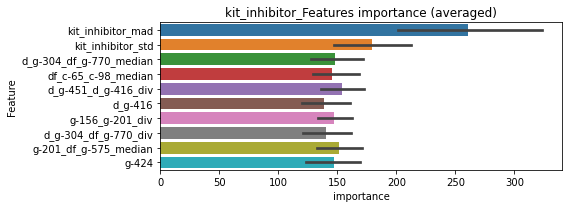

len(train_index) : 2376
len(valid_index) : 792
================================= fold 1/4 kit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794941	valid_1's binary_logloss: 0.154674
[200]	training's binary_logloss: 0.0280419	valid_1's binary_logloss: 0.113539
[300]	training's binary_logloss: 0.0116084	valid_1's binary_logloss: 0.0965166
[400]	training's binary_logloss: 0.00556015	valid_1's binary_logloss: 0.0902626
[500]	training's binary_logloss: 0.00310479	valid_1's binary_logloss: 0.08769
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00293354	valid_1's binary_logloss: 0.0874774


len(train_index) : 2376
len(valid_index) : 792
================================= fold 2/4 kit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0792887	valid_1's binary_logloss: 0.13839
[200]	training's binary_logloss: 0.0279968	valid_1's binary_logloss: 0.104592
[300]	training's binary_logloss: 0.011657	valid_1's binary_logloss: 0.0949963


len(train_index) : 2376
len(valid_index) : 792
================================= fold 3/4 kit_inhibitor=================================


Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0101407	valid_1's binary_logloss: 0.0945355
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0787893	valid_1's binary_logloss: 0.132606
[200]	training's binary_logloss: 0.028273	valid_1's binary_logloss: 0.0879865
[300]	training's binary_logloss: 0.0118755	valid_1's binary_logloss: 0.0702266
[400]	training's binary_logloss: 0.00564946	valid_1's binary_logloss: 0.0626267
[500]	training's binary_logloss: 0.00316281	valid_1's binary_logloss: 0.0599487
[600]	training's binary_logloss: 0.00202145	valid_1's binary_logloss: 0.0589916
[700]	training's binary_logloss: 0.0014631	valid_1's binary_logloss: 0.0580956
Early stopping, best iteration is:
[673]	training's binary_logloss: 0.00158199	valid_1's binary_logloss: 0.0579664


len(train_index) : 2376
len(valid_index) : 792
================================= fold 4/4 kit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0824254	valid_1's binary_logloss: 0.127728
[200]	training's binary_logloss: 0.0286508	valid_1's binary_logloss: 0.0797215
[300]	training's binary_logloss: 0.0119693	valid_1's binary_logloss: 0.062062
[400]	training's binary_logloss: 0.00570985	valid_1's binary_logloss: 0.0525942
[500]	training's binary_logloss: 0.00319187	valid_1's binary_logloss: 0.0478091
[600]	training's binary_logloss: 0.00206351	valid_1's binary_logloss: 0.0456134
[700]	training's binary_logloss: 0.00148415	valid_1's binary_logloss: 0.0442232
[800]	training's binary_logloss: 0.00116202	valid_1's binary_logloss: 0.0435777
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.00109705	valid_1's binary_logloss: 0.0431153


kit_inhibitor logloss: 0.0707736480978182


neg labels: 3289 → selected neg labels: 3289


laxative, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0445083	valid_1's binary_logloss: 0.0472294
[200]	training's binary_logloss: 0.00706824	valid_1's binary_logloss: 0.00812469
[300]	training's binary_logloss: 0.0015414	valid_1's binary_logloss: 0.00207902
[400]	training's binary_logloss: 0.000562325	valid_1's binary_logloss: 0.000950737
[500]	training's binary_logloss: 0.000317154	valid_1's binary_logloss: 0.000629855
[600]	training's binary_logloss: 0.000227702	valid_1's binary_logloss: 0.000476853
[700]	training's binary_logloss: 0.000193115	valid_1's binary_logloss: 0.000412875
[800]	training's binary_logloss: 0.000188102	valid_1's binary_logloss: 0.000402681
Early stopping, best iteration is:
[781]	training's binary_logloss: 0.000188102	valid_1's binary_logloss: 0.000402681
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0442152	valid_1's binary_logloss: 0.0462095
[200]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0006417, Threshold: 0.0027662, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00194, conf_1:0.00360
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0027662
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0327662
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0627662
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0927662
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.1227662
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.1527662
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.1827662
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.2127662
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.2427662
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2727662
threshold: 0.3027662, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Ps

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0450077	valid_1's binary_logloss: 0.0473893
[200]	training's binary_logloss: 0.00687431	valid_1's binary_logloss: 0.00762849
[300]	training's binary_logloss: 0.00142253	valid_1's binary_logloss: 0.0016665
[400]	training's binary_logloss: 0.000502273	valid_1's binary_logloss: 0.000620133
[500]	training's binary_logloss: 0.000280244	valid_1's binary_logloss: 0.000360087
[600]	training's binary_logloss: 0.000203648	valid_1's binary_logloss: 0.000268025
[700]	training's binary_logloss: 0.000175726	valid_1's binary_logloss: 0.000234098
[800]	training's binary_logloss: 0.000168745	valid_1's binary_logloss: 0.000225485
[900]	training's binary_logloss: 0.00016691	valid_1's binary_logloss: 0.000223344
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.00016691	valid_1's binary_logloss: 0.000223344
Training until validation scores don't improve for 30 rounds
[100]	training's binary_

2 / 3 AUC score:1.000
y_Threshold: 0.1166057, Threshold: 0.3027662, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00025, Num_p_label: 6.0, conf_0:0.24221, conf_1:0.36332


Early stopping, best iteration is:
[837]	training's binary_logloss: 0.00016856	valid_1's binary_logloss: 0.00028655


Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.3027662
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.3327662
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.3627662
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.3927662
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.4227662
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.4527662
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.4827662
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.5127662
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.5427662
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.5727662
threshold: 0.6027662, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0450077	valid_1's binary_logloss: 0.0473893
[200]	training's binary_logloss: 0.00687431	valid_1's binary_logloss: 0.00762849
[300]	training's binary_logloss: 0.00142253	valid_1's binary_logloss: 0.0016665
[400]	training's binary_logloss: 0.000502273	valid_1's binary_logloss: 0.000620133
[500]	training's binary_logloss: 0.000280244	valid_1's binary_logloss: 0.000360087
[600]	training's binary_logloss: 0.000203648	valid_1's binary_logloss: 0.000268025
[700]	training's binary_logloss: 0.000175726	valid_1's binary_logloss: 0.000234098
[800]	training's binary_logloss: 0.000168745	valid_1's binary_logloss: 0.000225485
[900]	training's binary_logloss: 0.00016691	valid_1's binary_logloss: 0.000223344
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.00016691	valid_1's binary_logloss: 0.000223344
Training until validation scores don't improve for 30 rounds
[100]	training's binary_

3 / 3 AUC score:1.000
y_Threshold: 0.1166057, Threshold: 0.6027662, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.50000, conf_1:0.66304
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.6027662
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.6327662
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.6627662
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.6927662
threshold: 0.6927662, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


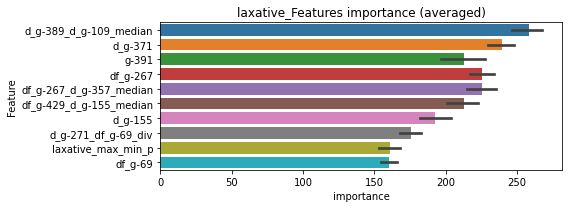

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 laxative=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0447989	valid_1's binary_logloss: 0.0465384
[200]	training's binary_logloss: 0.00689775	valid_1's binary_logloss: 0.00747175
[300]	training's binary_logloss: 0.0014243	valid_1's binary_logloss: 0.00164404
[400]	training's binary_logloss: 0.000502722	valid_1's binary_logloss: 0.000614383
[500]	training's binary_logloss: 0.000279768	valid_1's binary_logloss: 0.000355297
[600]	training's binary_logloss: 0.00020353	valid_1's binary_logloss: 0.000264265
[700]	training's binary_logloss: 0.000175674	valid_1's binary_logloss: 0.00023134
[800]	training's binary_logloss: 0.000168548	valid_1's binary_logloss: 0.000223099
[900]	training's binary_logloss: 0.000167593	valid_1's binary_logloss: 0.000222017
Early stopping, best iteration is:
[883]	training's binary_logloss: 0.000167593	valid_1's binary_logloss: 0.000222017


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 laxative=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0449356	valid_1's binary_logloss: 0.0461857
[200]	training's binary_logloss: 0.00693172	valid_1's binary_logloss: 0.00805664
[300]	training's binary_logloss: 0.00144175	valid_1's binary_logloss: 0.00231515
[400]	training's binary_logloss: 0.00050614	valid_1's binary_logloss: 0.00107609
[500]	training's binary_logloss: 0.00028282	valid_1's binary_logloss: 0.000730741
[600]	training's binary_logloss: 0.000205234	valid_1's binary_logloss: 0.000589559
[700]	training's binary_logloss: 0.000176783	valid_1's binary_logloss: 0.000546291


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 laxative=================================


[800]	training's binary_logloss: 0.000168972	valid_1's binary_logloss: 0.00053607
Early stopping, best iteration is:
[772]	training's binary_logloss: 0.000169771	valid_1's binary_logloss: 0.000535458
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451289	valid_1's binary_logloss: 0.0464835
[200]	training's binary_logloss: 0.00693815	valid_1's binary_logloss: 0.00733198
[300]	training's binary_logloss: 0.00142677	valid_1's binary_logloss: 0.00157425
[400]	training's binary_logloss: 0.000501775	valid_1's binary_logloss: 0.000579692
[500]	training's binary_logloss: 0.000280286	valid_1's binary_logloss: 0.000330876
[600]	training's binary_logloss: 0.000204379	valid_1's binary_logloss: 0.000242754
[700]	training's binary_logloss: 0.000174987	valid_1's binary_logloss: 0.000208351


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 laxative=================================


[800]	training's binary_logloss: 0.000167824	valid_1's binary_logloss: 0.000199665
Early stopping, best iteration is:
[786]	training's binary_logloss: 0.000167824	valid_1's binary_logloss: 0.000199665
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0450497	valid_1's binary_logloss: 0.0489155
[200]	training's binary_logloss: 0.0069371	valid_1's binary_logloss: 0.00814235
[300]	training's binary_logloss: 0.00143201	valid_1's binary_logloss: 0.00185494
[400]	training's binary_logloss: 0.000503832	valid_1's binary_logloss: 0.000729659
[500]	training's binary_logloss: 0.00028097	valid_1's binary_logloss: 0.000440302
[600]	training's binary_logloss: 0.000204797	valid_1's binary_logloss: 0.000337652
[700]	training's binary_logloss: 0.00017617	valid_1's binary_logloss: 0.000298453
[800]	training's binary_logloss: 0.00016778	valid_1's binary_logloss: 0.000286363
Early stopping, best iteration is:
[840]	training's binary_logloss: 0.000166908	valid_

laxative logloss: 0.00031064462462624597
leukotriene_inhibitor, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0454984	valid_1's binary_logloss: 0.0486865
[200]	training's binary_logloss: 0.00740175	valid_1's binary_logloss: 0.00887184
[300]	training's binary_logloss: 0.00160709	valid_1's binary_logloss: 0.00249335
[400]	training's binary_logloss: 0.000578591	valid_1's binary_logloss: 0.0013721
[500]	training's binary_logloss: 0.000320329	valid_1's binary_logloss: 0.00106402
[600]	training's binary_logloss: 0.000227271	valid_1's binary_logloss: 0.000945874
[700]	training's binary_logloss: 0.000193138	valid_1's binary_logloss: 0.000881457
[800]	training's binary_logloss: 0.00018551	valid_1's binary_logloss: 0.000869216
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.000185527	valid_1's binary_logloss: 0.000869191
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455112	valid_1's binary_logloss: 0.0511013
[200]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0005022, Threshold: 0.0036269, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00254, conf_1:0.00471
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0036269
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0336269
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0636269
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0936269
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.1236269
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.1536269
threshold: 0.1536269, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0458134	valid_1's binary_logloss: 0.0482176
[200]	training's binary_logloss: 0.0071274	valid_1's binary_logloss: 0.00781774
[300]	training's binary_logloss: 0.00146542	valid_1's binary_logloss: 0.00169835
[400]	training's binary_logloss: 0.000498757	valid_1's binary_logloss: 0.000606243
[500]	training's binary_logloss: 0.00027032	valid_1's binary_logloss: 0.000337256
[600]	training's binary_logloss: 0.000192438	valid_1's binary_logloss: 0.00024437
[700]	training's binary_logloss: 0.000169868	valid_1's binary_logloss: 0.000216946
[800]	training's binary_logloss: 0.000161399	valid_1's binary_logloss: 0.000206921
[900]	training's binary_logloss: 0.000159434	valid_1's binary_logloss: 0.000204497
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.000159194	valid_1's binary_logloss: 0.000204212
Training until validation scores don't improve for 30 rounds
[100]	training's binary_

2 / 3 AUC score:1.000
y_Threshold: 0.1182611, Threshold: 0.1536269, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0045203 Vs.target_rate: 0.00025, Num_p_label: 18.0, conf_0:0.12290, conf_1:0.18435
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_1: 0.1536269
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_2: 0.1836269
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_3: 0.2136269
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_4: 0.2436269
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_5: 0.2736269
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_6: 0.3036269
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_7: 0.3336269
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_8: 0.3636269
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_9: 0.3936269
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_10: 0.4236269
threshold: 0.4536269, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0458134	valid_1's binary_logloss: 0.0482176
[200]	training's binary_logloss: 0.0071274	valid_1's binary_logloss: 0.00781774
[300]	training's binary_logloss: 0.00146542	valid_1's binary_logloss: 0.00169835
[400]	training's binary_logloss: 0.000498757	valid_1's binary_logloss: 0.000606243
[500]	training's binary_logloss: 0.00027032	valid_1's binary_logloss: 0.000337256
[600]	training's binary_logloss: 0.000192438	valid_1's binary_logloss: 0.00024437
[700]	training's binary_logloss: 0.000169868	valid_1's binary_logloss: 0.000216946
[800]	training's binary_logloss: 0.000161399	valid_1's binary_logloss: 0.000206921
[900]	training's binary_logloss: 0.000159434	valid_1's binary_logloss: 0.000204497
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.000159194	valid_1's binary_logloss: 0.000204212
Training until validation scores don't improve for 30 rounds
[100]	training's binary_

3 / 3 AUC score:1.000
y_Threshold: 0.1182611, Threshold: 0.4536269, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.40826, conf_1:0.49899
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.4536269
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.4836269
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.5136269
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.5436269
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.5736269
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.6036269
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.6336269
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.6636269
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.6936269
threshold: 0.6936269, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


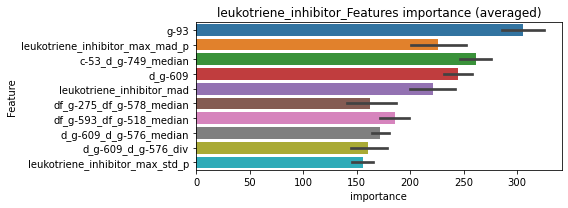

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452884	valid_1's binary_logloss: 0.0474718
[200]	training's binary_logloss: 0.00706732	valid_1's binary_logloss: 0.00774466
[300]	training's binary_logloss: 0.00145483	valid_1's binary_logloss: 0.00169439
[400]	training's binary_logloss: 0.000496547	valid_1's binary_logloss: 0.000609355
[500]	training's binary_logloss: 0.000269456	valid_1's binary_logloss: 0.000341706
[600]	training's binary_logloss: 0.000192576	valid_1's binary_logloss: 0.000249077
[700]	training's binary_logloss: 0.000168038	valid_1's binary_logloss: 0.000218781
[800]	training's binary_logloss: 0.000160543	valid_1's binary_logloss: 0.00020955
[900]	training's binary_logloss: 0.000158152	valid_1's binary_logloss: 0.00020654
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000157713	valid_1's binary_logloss: 0.000205981


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0454098	valid_1's binary_logloss: 0.0482679
[200]	training's binary_logloss: 0.00704382	valid_1's binary_logloss: 0.00887929
[300]	training's binary_logloss: 0.00145896	valid_1's binary_logloss: 0.00262382
[400]	training's binary_logloss: 0.000495147	valid_1's binary_logloss: 0.00130608
[500]	training's binary_logloss: 0.000264797	valid_1's binary_logloss: 0.000999452
[600]	training's binary_logloss: 0.000190587	valid_1's binary_logloss: 0.000906357
[700]	training's binary_logloss: 0.000166071	valid_1's binary_logloss: 0.000869317
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.000163837	valid_1's binary_logloss: 0.000866086


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453616	valid_1's binary_logloss: 0.0480058
[200]	training's binary_logloss: 0.00698309	valid_1's binary_logloss: 0.00762557
[300]	training's binary_logloss: 0.00144286	valid_1's binary_logloss: 0.0016321
[400]	training's binary_logloss: 0.00049022	valid_1's binary_logloss: 0.000586686
[500]	training's binary_logloss: 0.000263581	valid_1's binary_logloss: 0.000327594
[600]	training's binary_logloss: 0.000189312	valid_1's binary_logloss: 0.000240612
[700]	training's binary_logloss: 0.000166253	valid_1's binary_logloss: 0.000213891
[800]	training's binary_logloss: 0.000158543	valid_1's binary_logloss: 0.00020463
[900]	training's binary_logloss: 0.000156215	valid_1's binary_logloss: 0.000201884
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.000156085	valid_1's binary_logloss: 0.000201734


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0449387	valid_1's binary_logloss: 0.0467315
[200]	training's binary_logloss: 0.00702631	valid_1's binary_logloss: 0.00772096
[300]	training's binary_logloss: 0.00144592	valid_1's binary_logloss: 0.00169824
[400]	training's binary_logloss: 0.000492333	valid_1's binary_logloss: 0.000617477
[500]	training's binary_logloss: 0.000267133	valid_1's binary_logloss: 0.000346232
[600]	training's binary_logloss: 0.000192052	valid_1's binary_logloss: 0.000255937
[700]	training's binary_logloss: 0.000167562	valid_1's binary_logloss: 0.00022515
[800]	training's binary_logloss: 0.000158854	valid_1's binary_logloss: 0.000214422
[900]	training's binary_logloss: 0.000156301	valid_1's binary_logloss: 0.000211477
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000155218	valid_1's binary_logloss: 0.000210193


leukotriene_inhibitor logloss: 0.00037095547962920025
leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3282, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128408	valid_1's binary_logloss: 0.18331
[200]	training's binary_logloss: 0.0542583	valid_1's binary_logloss: 0.117178
[300]	training's binary_logloss: 0.0257776	valid_1's binary_logloss: 0.0882131
[400]	training's binary_logloss: 0.0127508	valid_1's binary_logloss: 0.0739229
[500]	training's binary_logloss: 0.00675177	valid_1's binary_logloss: 0.0651395
[600]	training's binary_logloss: 0.00396915	valid_1's binary_logloss: 0.0602816
[700]	training's binary_logloss: 0.00257213	valid_1's binary_logloss: 0.05771
[800]	training's binary_logloss: 0.00184395	valid_1's binary_logloss: 0.0561901
[900]	training's binary_logloss: 0.00142322	valid_1's binary_logloss: 0.0549799
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.00142322	valid_1's binary_logloss: 0.0549799
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126315	valid_1's b

1 / 3 AUC score:0.998
y_Threshold: 0.0212774, Threshold: 0.1340705, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3794
p_label_rate: 0.0100452 Vs.target_rate: 0.00260, Num_p_label: 40.0, conf_0:0.09385, conf_1:0.17429
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_1: 0.1340705
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_2: 0.1640705
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_3: 0.1940705
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_4: 0.2240705
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_5: 0.2540705
Num_p_label: 19.0, Expected: 10.4, Adj_threshold_6: 0.2840705
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_7: 0.3140705
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_8: 0.3440705
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_9: 0.3740705
threshold: 0.3740705, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3794, y_label_rate: 0.1713231
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117898	valid_1's binary_logloss: 0.180251
[200]	training's binary_logloss: 0.0457036	valid_1's binary_logloss: 0.107004
[300]	training's binary_logloss: 0.0198346	valid_1's binary_logloss: 0.0745764
[400]	training's binary_logloss: 0.00916469	valid_1's binary_logloss: 0.0579136
[500]	training's binary_logloss: 0.00479948	valid_1's binary_logloss: 0.0498708
[600]	training's binary_logloss: 0.00290823	valid_1's binary_logloss: 0.0455197
[700]	training's binary_logloss: 0.00193267	valid_1's binary_logloss: 0.0431748
[800]	training's binary_logloss: 0.00143121	valid_1's binary_logloss: 0.0411562
Early stopping, best iteration is:
[831]	training's binary_logloss: 0.00132571	valid_1's binary_logloss: 0.0409356
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1199	valid_1's binary_logloss: 0.161853
[200]	training's binary_logloss: 0.0459314	valid_1's b

2 / 3 AUC score:0.998
y_Threshold: 0.1003906, Threshold: 0.3740705, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 629.0/3752
p_label_rate: 0.0140633 Vs.target_rate: 0.00260, Num_p_label: 56.0, conf_0:0.29926, conf_1:0.44888
Num_p_label: 56.0, Expected: 10.4, Adj_threshold_1: 0.3740705
Num_p_label: 55.0, Expected: 10.4, Adj_threshold_2: 0.4040705
Num_p_label: 51.0, Expected: 10.4, Adj_threshold_3: 0.4340705
Num_p_label: 49.0, Expected: 10.4, Adj_threshold_4: 0.4640705
Num_p_label: 46.0, Expected: 10.4, Adj_threshold_5: 0.4940705
Num_p_label: 44.0, Expected: 10.4, Adj_threshold_6: 0.5240705
Num_p_label: 42.0, Expected: 10.4, Adj_threshold_7: 0.5540705
Num_p_label: 39.0, Expected: 10.4, Adj_threshold_8: 0.5840705
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_9: 0.6140705
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_10: 0.6440705
threshold: 0.6740705, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 629.0/3752, y_label_rate: 0.1676439

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110925	valid_1's binary_logloss: 0.156091
[200]	training's binary_logloss: 0.0411081	valid_1's binary_logloss: 0.0910766
[300]	training's binary_logloss: 0.0172998	valid_1's binary_logloss: 0.0637041
[400]	training's binary_logloss: 0.00809204	valid_1's binary_logloss: 0.0501367
[500]	training's binary_logloss: 0.0041646	valid_1's binary_logloss: 0.0415055
[600]	training's binary_logloss: 0.00252107	valid_1's binary_logloss: 0.0384087
[700]	training's binary_logloss: 0.00173217	valid_1's binary_logloss: 0.0353594
[800]	training's binary_logloss: 0.00129335	valid_1's binary_logloss: 0.0338297
[900]	training's binary_logloss: 0.00104164	valid_1's binary_logloss: 0.0332688
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.00100939	valid_1's binary_logloss: 0.033054
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108463	valid_1'

3 / 3 AUC score:0.998
y_Threshold: 0.1012596, Threshold: 0.6740705, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 613.0/3720
p_label_rate: 0.0120542 Vs.target_rate: 0.00260, Num_p_label: 48.0, conf_0:0.50000, conf_1:0.74148
Num_p_label: 48.0, Expected: 10.4, Adj_threshold_1: 0.6740705
threshold: 0.6740705, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 613.0/3720, y_label_rate: 0.1647849


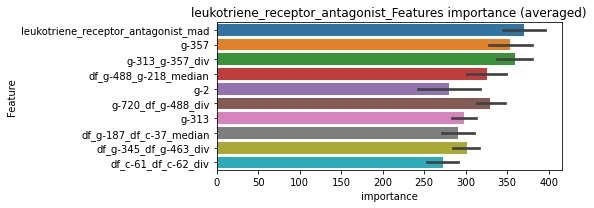

len(train_index) : 2790
len(valid_index) : 930
================================= fold 1/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106105	valid_1's binary_logloss: 0.157149
[200]	training's binary_logloss: 0.0382913	valid_1's binary_logloss: 0.0915645
[300]	training's binary_logloss: 0.0160724	valid_1's binary_logloss: 0.0628029
[400]	training's binary_logloss: 0.00736654	valid_1's binary_logloss: 0.0479528
[500]	training's binary_logloss: 0.00378521	valid_1's binary_logloss: 0.0383695
[600]	training's binary_logloss: 0.00228361	valid_1's binary_logloss: 0.0338781
[700]	training's binary_logloss: 0.00154706	valid_1's binary_logloss: 0.0310597
[800]	training's binary_logloss: 0.00115392	valid_1's binary_logloss: 0.029158
[900]	training's binary_logloss: 0.000934306	valid_1's binary_logloss: 0.0282816
Early stopping, best iteration is:
[883]	training's binary_logloss: 0.000962682	valid_1's binary_logloss: 0.0282134


len(train_index) : 2790
len(valid_index) : 930
================================= fold 2/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108138	valid_1's binary_logloss: 0.163899
[200]	training's binary_logloss: 0.0378204	valid_1's binary_logloss: 0.0923881
[300]	training's binary_logloss: 0.0154968	valid_1's binary_logloss: 0.0640767
[400]	training's binary_logloss: 0.00707456	valid_1's binary_logloss: 0.049697
[500]	training's binary_logloss: 0.00365643	valid_1's binary_logloss: 0.0424443
[600]	training's binary_logloss: 0.00222596	valid_1's binary_logloss: 0.0394355
[700]	training's binary_logloss: 0.00152583	valid_1's binary_logloss: 0.0378346
[800]	training's binary_logloss: 0.00114483	valid_1's binary_logloss: 0.0367165
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.00119558	valid_1's binary_logloss: 0.0365221


len(train_index) : 2790
len(valid_index) : 930
================================= fold 3/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109003	valid_1's binary_logloss: 0.15114
[200]	training's binary_logloss: 0.0381566	valid_1's binary_logloss: 0.0833142
[300]	training's binary_logloss: 0.0157834	valid_1's binary_logloss: 0.0589639
[400]	training's binary_logloss: 0.00719439	valid_1's binary_logloss: 0.047686
[500]	training's binary_logloss: 0.00376975	valid_1's binary_logloss: 0.0421747
[600]	training's binary_logloss: 0.00228836	valid_1's binary_logloss: 0.039747
[700]	training's binary_logloss: 0.00157126	valid_1's binary_logloss: 0.038924
[800]	training's binary_logloss: 0.00118615	valid_1's binary_logloss: 0.0381381
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.00116741	valid_1's binary_logloss: 0.0380972


len(train_index) : 2790
len(valid_index) : 930
================================= fold 4/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108045	valid_1's binary_logloss: 0.151928
[200]	training's binary_logloss: 0.038945	valid_1's binary_logloss: 0.0869128
[300]	training's binary_logloss: 0.0166852	valid_1's binary_logloss: 0.0593797
[400]	training's binary_logloss: 0.00760901	valid_1's binary_logloss: 0.0463967
[500]	training's binary_logloss: 0.00390364	valid_1's binary_logloss: 0.0391495
[600]	training's binary_logloss: 0.00233394	valid_1's binary_logloss: 0.0354211
[700]	training's binary_logloss: 0.00158525	valid_1's binary_logloss: 0.0338471
[800]	training's binary_logloss: 0.00119788	valid_1's binary_logloss: 0.0329217
[900]	training's binary_logloss: 0.000962752	valid_1's binary_logloss: 0.0319199
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.000907493	valid_1's binary_logloss: 0.0316813


leukotriene_receptor_antagonist logloss: 0.03362849653934187
lipase_inhibitor, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0605958	valid_1's binary_logloss: 0.0657487
[200]	training's binary_logloss: 0.0128376	valid_1's binary_logloss: 0.0159543
[300]	training's binary_logloss: 0.00341312	valid_1's binary_logloss: 0.0052969
[400]	training's binary_logloss: 0.00130097	valid_1's binary_logloss: 0.00248175
[500]	training's binary_logloss: 0.000687199	valid_1's binary_logloss: 0.00154461
[600]	training's binary_logloss: 0.000455828	valid_1's binary_logloss: 0.00116651
[700]	training's binary_logloss: 0.000352178	valid_1's binary_logloss: 0.000980544
[800]	training's binary_logloss: 0.000315973	valid_1's binary_logloss: 0.0009095
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.000313377	valid_1's binary_logloss: 0.000905248
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0599927	valid_1's binary_logloss: 0.0688255
[200]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0020834, Threshold: 0.0121536, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00851, conf_1:0.01580
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0121536
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.0421536
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.0721536
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.1021536
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.1321536
threshold: 0.1321536, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0582124	valid_1's binary_logloss: 0.0623549
[200]	training's binary_logloss: 0.0117531	valid_1's binary_logloss: 0.0138001
[300]	training's binary_logloss: 0.00302641	valid_1's binary_logloss: 0.00402245
[400]	training's binary_logloss: 0.00113859	valid_1's binary_logloss: 0.00166172
[500]	training's binary_logloss: 0.000596908	valid_1's binary_logloss: 0.00092242
[600]	training's binary_logloss: 0.000399968	valid_1's binary_logloss: 0.000639938
[700]	training's binary_logloss: 0.000310743	valid_1's binary_logloss: 0.000508681
[800]	training's binary_logloss: 0.000281251	valid_1's binary_logloss: 0.000463432
[900]	training's binary_logloss: 0.000275114	valid_1's binary_logloss: 0.000454764
Early stopping, best iteration is:
[911]	training's binary_logloss: 0.000274255	valid_1's binary_logloss: 0.000453476
Training until validation scores don't improve for 30 rounds
[100]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1693116, Threshold: 0.1321536, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0045203 Vs.target_rate: 0.00050, Num_p_label: 18.0, conf_0:0.10572, conf_1:0.15858
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_1: 0.1321536
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.1621536
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.1921536
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.2221536
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_5: 0.2521536
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_6: 0.2821536
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_7: 0.3121536
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.3421536
threshold: 0.3421536, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0582124	valid_1's binary_logloss: 0.0623549
[200]	training's binary_logloss: 0.0117531	valid_1's binary_logloss: 0.0138001
[300]	training's binary_logloss: 0.00302641	valid_1's binary_logloss: 0.00402245
[400]	training's binary_logloss: 0.00113859	valid_1's binary_logloss: 0.00166172
[500]	training's binary_logloss: 0.000596908	valid_1's binary_logloss: 0.00092242
[600]	training's binary_logloss: 0.000399968	valid_1's binary_logloss: 0.000639938
[700]	training's binary_logloss: 0.000310743	valid_1's binary_logloss: 0.000508681
[800]	training's binary_logloss: 0.000281251	valid_1's binary_logloss: 0.000463432
[900]	training's binary_logloss: 0.000275114	valid_1's binary_logloss: 0.000454764
Early stopping, best iteration is:
[911]	training's binary_logloss: 0.000274255	valid_1's binary_logloss: 0.000453476
Training until validation scores don't improve for 30 rounds
[100]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1693116, Threshold: 0.3421536, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.30794, conf_1:0.37637
threshold: 0.3421536, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


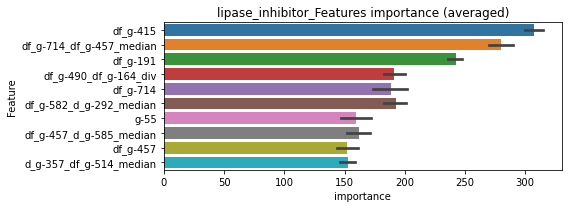

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0581438	valid_1's binary_logloss: 0.062694
[200]	training's binary_logloss: 0.0117873	valid_1's binary_logloss: 0.0136878
[300]	training's binary_logloss: 0.00303856	valid_1's binary_logloss: 0.00399387
[400]	training's binary_logloss: 0.00113659	valid_1's binary_logloss: 0.0016187
[500]	training's binary_logloss: 0.000595631	valid_1's binary_logloss: 0.00089426
[600]	training's binary_logloss: 0.000398428	valid_1's binary_logloss: 0.000615405
[700]	training's binary_logloss: 0.000312324	valid_1's binary_logloss: 0.000493624
[800]	training's binary_logloss: 0.000282365	valid_1's binary_logloss: 0.000450843
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.000277281	valid_1's binary_logloss: 0.00044399


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0585357	valid_1's binary_logloss: 0.0670865
[200]	training's binary_logloss: 0.0119573	valid_1's binary_logloss: 0.0167933
[300]	training's binary_logloss: 0.00314489	valid_1's binary_logloss: 0.0058264
[400]	training's binary_logloss: 0.0011982	valid_1's binary_logloss: 0.00281983
[500]	training's binary_logloss: 0.000606797	valid_1's binary_logloss: 0.00161988
[600]	training's binary_logloss: 0.000398799	valid_1's binary_logloss: 0.00112674
[700]	training's binary_logloss: 0.00030953	valid_1's binary_logloss: 0.000922408
[800]	training's binary_logloss: 0.000278821	valid_1's binary_logloss: 0.000855815
Early stopping, best iteration is:
[801]	training's binary_logloss: 0.0002788	valid_1's binary_logloss: 0.000855777


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0588783	valid_1's binary_logloss: 0.0631185
[200]	training's binary_logloss: 0.0119599	valid_1's binary_logloss: 0.0137695
[300]	training's binary_logloss: 0.00305494	valid_1's binary_logloss: 0.00387091
[400]	training's binary_logloss: 0.00113999	valid_1's binary_logloss: 0.00156385
[500]	training's binary_logloss: 0.000600824	valid_1's binary_logloss: 0.000876279
[600]	training's binary_logloss: 0.00040189	valid_1's binary_logloss: 0.000608525
[700]	training's binary_logloss: 0.000312601	valid_1's binary_logloss: 0.000489994
[800]	training's binary_logloss: 0.000283934	valid_1's binary_logloss: 0.000449227
[900]	training's binary_logloss: 0.000277482	valid_1's binary_logloss: 0.0004405
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.000277404	valid_1's binary_logloss: 0.000440454


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.05747	valid_1's binary_logloss: 0.0690909
[200]	training's binary_logloss: 0.0117331	valid_1's binary_logloss: 0.0171506
[300]	training's binary_logloss: 0.00301575	valid_1's binary_logloss: 0.00558844
[400]	training's binary_logloss: 0.00112283	valid_1's binary_logloss: 0.00255757
[500]	training's binary_logloss: 0.000585858	valid_1's binary_logloss: 0.00154291
[600]	training's binary_logloss: 0.000392199	valid_1's binary_logloss: 0.0011298
[700]	training's binary_logloss: 0.00030721	valid_1's binary_logloss: 0.000947789
[800]	training's binary_logloss: 0.000278288	valid_1's binary_logloss: 0.000874492
[900]	training's binary_logloss: 0.000271877	valid_1's binary_logloss: 0.000858996
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.000271676	valid_1's binary_logloss: 0.000858321


lipase_inhibitor logloss: 0.0006495815470586882
lipoxygenase_inhibitor, len(trt): 61, len(othr): 3284, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128663	valid_1's binary_logloss: 0.197618
[200]	training's binary_logloss: 0.0548052	valid_1's binary_logloss: 0.128163
[300]	training's binary_logloss: 0.0250568	valid_1's binary_logloss: 0.0945379
[400]	training's binary_logloss: 0.0117662	valid_1's binary_logloss: 0.0767146
[500]	training's binary_logloss: 0.00611797	valid_1's binary_logloss: 0.0683451
[600]	training's binary_logloss: 0.0035646	valid_1's binary_logloss: 0.0652978
[700]	training's binary_logloss: 0.00234828	valid_1's binary_logloss: 0.063358
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.00196997	valid_1's binary_logloss: 0.0623638
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128088	valid_1's binary_logloss: 0.187144
[200]	training's binary_logloss: 0.0512649	valid_1's binary_logloss: 0.113099
[300]	training's binary_logloss: 0.0226666	valid_1's bina

1 / 3 AUC score:0.998
y_Threshold: 0.0235986, Threshold: 0.3358420, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3802
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.23509, conf_1:0.43659
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.3358420
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_2: 0.3658420
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_3: 0.3958420
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_4: 0.4258420
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_5: 0.4558420
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_6: 0.4858420
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_7: 0.5158420
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_8: 0.5458420
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_9: 0.5758420
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_10: 0.6058420
threshold: 0.6358420, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 653.0/3802, y_label_rate: 0.1717517


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124437	valid_1's binary_logloss: 0.181788
[200]	training's binary_logloss: 0.0512145	valid_1's binary_logloss: 0.113691
[300]	training's binary_logloss: 0.0220545	valid_1's binary_logloss: 0.0820707
[400]	training's binary_logloss: 0.0103145	valid_1's binary_logloss: 0.0661607
[500]	training's binary_logloss: 0.00527264	valid_1's binary_logloss: 0.0575641
[600]	training's binary_logloss: 0.00306886	valid_1's binary_logloss: 0.0529867
[700]	training's binary_logloss: 0.00205798	valid_1's binary_logloss: 0.0512411
Early stopping, best iteration is:
[740]	training's binary_logloss: 0.0018006	valid_1's binary_logloss: 0.0504682
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122237	valid_1's binary_logloss: 0.1757
[200]	training's binary_logloss: 0.0476188	valid_1's binary_logloss: 0.103599
[300]	training's binary_logloss: 0.0206088	valid_1's binar

2 / 3 AUC score:0.999
y_Threshold: 0.0921365, Threshold: 0.6358420, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 640.0/3776
p_label_rate: 0.0115520 Vs.target_rate: 0.00256, Num_p_label: 46.0, conf_0:0.50000, conf_1:0.76301
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_1: 0.6358420
Num_p_label: 43.0, Expected: 10.2, Adj_threshold_2: 0.6658420
Num_p_label: 39.0, Expected: 10.2, Adj_threshold_3: 0.6958420
threshold: 0.6958420, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 640.0/3776, y_label_rate: 0.1694915
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120066	valid_1's binary_logloss: 0.179158
[200]	training's binary_logloss: 0.0474898	valid_1's binary_logloss: 0.111097
[300]	training's binary_logloss: 0.0202804	valid_1's binary_logloss: 0.080882
[400]	training's binary_logloss: 0.00931305	valid_1's binary_logloss: 0.0659075
[500]	training's binary_logloss: 0.00474884	valid_1's binary_logloss: 0.0589347
[600]	training's binary_logloss: 0.00279647	valid_1's binary_logloss: 0.0548563
[700]	training's binary_logloss: 0.00188295	valid_1's binary_logloss: 0.052926
Early stopping, best iteration is:
[738]	training's binary_logloss: 0.00166582	valid_1's binary_logloss: 0.0526773
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121493	valid_1's binary_logloss: 0.172865
[200]	training's binary_logloss: 0.0479276	valid_1's binary_logloss: 0.0948083
[300]	training's binary_logloss: 0.0207041	valid_1's bi

3 / 3 AUC score:0.998
y_Threshold: 0.0804265, Threshold: 0.6958420, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 621.0/3738
p_label_rate: 0.0125565 Vs.target_rate: 0.00256, Num_p_label: 50.0, conf_0:0.50000, conf_1:0.76543
Num_p_label: 50.0, Expected: 10.2, Adj_threshold_1: 0.6958420
threshold: 0.6958420, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 621.0/3738, y_label_rate: 0.1661316


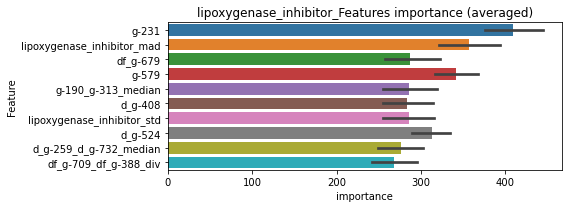

len(train_index) : 2803
len(valid_index) : 935
================================= fold 1/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114543	valid_1's binary_logloss: 0.168049
[200]	training's binary_logloss: 0.0445225	valid_1's binary_logloss: 0.0956618
[300]	training's binary_logloss: 0.0188024	valid_1's binary_logloss: 0.0626884
[400]	training's binary_logloss: 0.0089009	valid_1's binary_logloss: 0.0464545
[500]	training's binary_logloss: 0.00454067	valid_1's binary_logloss: 0.0370379
[600]	training's binary_logloss: 0.00267482	valid_1's binary_logloss: 0.0319383
[700]	training's binary_logloss: 0.00179648	valid_1's binary_logloss: 0.0283553
[800]	training's binary_logloss: 0.00134459	valid_1's binary_logloss: 0.0263277
[900]	training's binary_logloss: 0.00107492	valid_1's binary_logloss: 0.025134
[1000]	training's binary_logloss: 0.000916911	valid_1's binary_logloss: 0.0242677
[1100]	training's binary_logloss: 0.000826521	valid_1's binary_logloss: 0.0236857
Early stopping, best iteration is:
[1107]	training's binary_lo

len(train_index) : 2803
len(valid_index) : 935
================================= fold 2/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11255	valid_1's binary_logloss: 0.160962
[200]	training's binary_logloss: 0.0427713	valid_1's binary_logloss: 0.0904058
[300]	training's binary_logloss: 0.0180912	valid_1's binary_logloss: 0.0616195
[400]	training's binary_logloss: 0.00821328	valid_1's binary_logloss: 0.0475012
[500]	training's binary_logloss: 0.00420558	valid_1's binary_logloss: 0.0396779
[600]	training's binary_logloss: 0.00253974	valid_1's binary_logloss: 0.0346654
[700]	training's binary_logloss: 0.0017378	valid_1's binary_logloss: 0.0321674
[800]	training's binary_logloss: 0.00130109	valid_1's binary_logloss: 0.0302832
[900]	training's binary_logloss: 0.0010451	valid_1's binary_logloss: 0.028949
[1000]	training's binary_logloss: 0.000895209	valid_1's binary_logloss: 0.0283596
Early stopping, best iteration is:
[1047]	training's binary_logloss: 0.000855242	valid_1's binary_logloss: 0.0280715


len(train_index) : 2804
len(valid_index) : 934
================================= fold 3/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110598	valid_1's binary_logloss: 0.16896
[200]	training's binary_logloss: 0.0404657	valid_1's binary_logloss: 0.100291
[300]	training's binary_logloss: 0.0167752	valid_1's binary_logloss: 0.0736091
[400]	training's binary_logloss: 0.00764303	valid_1's binary_logloss: 0.0615415
[500]	training's binary_logloss: 0.00394717	valid_1's binary_logloss: 0.0561534
[600]	training's binary_logloss: 0.00239217	valid_1's binary_logloss: 0.0541493
[700]	training's binary_logloss: 0.00163023	valid_1's binary_logloss: 0.0526685
Early stopping, best iteration is:
[738]	training's binary_logloss: 0.00144198	valid_1's binary_logloss: 0.0524963


len(train_index) : 2804
len(valid_index) : 934
================================= fold 4/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113375	valid_1's binary_logloss: 0.170399
[200]	training's binary_logloss: 0.0416284	valid_1's binary_logloss: 0.102249
[300]	training's binary_logloss: 0.0172888	valid_1's binary_logloss: 0.0711736
[400]	training's binary_logloss: 0.00789839	valid_1's binary_logloss: 0.0564432
[500]	training's binary_logloss: 0.00410307	valid_1's binary_logloss: 0.0490235
[600]	training's binary_logloss: 0.00243783	valid_1's binary_logloss: 0.0449685
[700]	training's binary_logloss: 0.00165936	valid_1's binary_logloss: 0.0422866
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.00137537	valid_1's binary_logloss: 0.0413422


lipoxygenase_inhibitor logloss: 0.03638398065341548
lxr_agonist, len(trt): 6, len(othr): 3287, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0514302	valid_1's binary_logloss: 0.0559631
[200]	training's binary_logloss: 0.0104174	valid_1's binary_logloss: 0.0135101
[300]	training's binary_logloss: 0.0026378	valid_1's binary_logloss: 0.00479728
[400]	training's binary_logloss: 0.000989323	valid_1's binary_logloss: 0.00233826
[500]	training's binary_logloss: 0.000542966	valid_1's binary_logloss: 0.0015092
[600]	training's binary_logloss: 0.000368317	valid_1's binary_logloss: 0.00115967
[700]	training's binary_logloss: 0.000298991	valid_1's binary_logloss: 0.00102688
[800]	training's binary_logloss: 0.000275834	valid_1's binary_logloss: 0.0009733
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.000275834	valid_1's binary_logloss: 0.0009733
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0511694	valid_1's binary_logloss: 0.0588486
[200]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0012912, Threshold: 0.0055198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00386, conf_1:0.00718
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0055198
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.0355198
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0655198
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0955198
threshold: 0.0955198, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0498273	valid_1's binary_logloss: 0.0549965
[200]	training's binary_logloss: 0.00860241	valid_1's binary_logloss: 0.0108386
[300]	training's binary_logloss: 0.00203522	valid_1's binary_logloss: 0.00332081
[400]	training's binary_logloss: 0.0007685	valid_1's binary_logloss: 0.00169157
[500]	training's binary_logloss: 0.000425075	valid_1's binary_logloss: 0.0011038
[600]	training's binary_logloss: 0.000298116	valid_1's binary_logloss: 0.00083442
[700]	training's binary_logloss: 0.000248275	valid_1's binary_logloss: 0.000745994
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.000241921	valid_1's binary_logloss: 0.000733143
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497669	valid_1's binary_logloss: 0.0538645
[200]	training's binary_logloss: 0.00857848	valid_1's binary_logloss: 0.0105787
[300]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1514173, Threshold: 0.0955198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0060271 Vs.target_rate: 0.00025, Num_p_label: 24.0, conf_0:0.07642, conf_1:0.11462
Num_p_label: 24.0, Expected: 1.0, Adj_threshold_1: 0.0955198
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_2: 0.1255198
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_3: 0.1555198
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_4: 0.1855198
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_5: 0.2155198
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_6: 0.2455198
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_7: 0.2755198
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.3055198
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.3355198
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.3655198
threshold: 0.3955198, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0498273	valid_1's binary_logloss: 0.0549965
[200]	training's binary_logloss: 0.00860241	valid_1's binary_logloss: 0.0108386
[300]	training's binary_logloss: 0.00203522	valid_1's binary_logloss: 0.00332081
[400]	training's binary_logloss: 0.0007685	valid_1's binary_logloss: 0.00169157
[500]	training's binary_logloss: 0.000425075	valid_1's binary_logloss: 0.0011038
[600]	training's binary_logloss: 0.000298116	valid_1's binary_logloss: 0.00083442
[700]	training's binary_logloss: 0.000248275	valid_1's binary_logloss: 0.000745994
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.000241921	valid_1's binary_logloss: 0.000733143
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497669	valid_1's binary_logloss: 0.0538645
[200]	training's binary_logloss: 0.00857848	valid_1's binary_logloss: 0.0105787
[300]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1514173, Threshold: 0.3955198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00025, Num_p_label: 6.0, conf_0:0.35597, conf_1:0.43507
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.3955198
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.4255198
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.4555198
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.4855198
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.5155198
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.5455198
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.5755198
threshold: 0.5755198, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


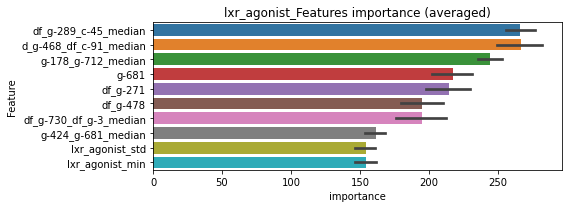

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 lxr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0500026	valid_1's binary_logloss: 0.0542532
[200]	training's binary_logloss: 0.00862933	valid_1's binary_logloss: 0.0107268
[300]	training's binary_logloss: 0.00202526	valid_1's binary_logloss: 0.00353304
[400]	training's binary_logloss: 0.000767199	valid_1's binary_logloss: 0.00169669
[500]	training's binary_logloss: 0.000423545	valid_1's binary_logloss: 0.00110946
[600]	training's binary_logloss: 0.000295176	valid_1's binary_logloss: 0.000879306
[700]	training's binary_logloss: 0.00024666	valid_1's binary_logloss: 0.000766109
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.000240489	valid_1's binary_logloss: 0.000754227


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 lxr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0500594	valid_1's binary_logloss: 0.0540432
[200]	training's binary_logloss: 0.00858919	valid_1's binary_logloss: 0.0104876
[300]	training's binary_logloss: 0.00202093	valid_1's binary_logloss: 0.00301539
[400]	training's binary_logloss: 0.000759696	valid_1's binary_logloss: 0.00133179
[500]	training's binary_logloss: 0.000417464	valid_1's binary_logloss: 0.000835652
[600]	training's binary_logloss: 0.000291007	valid_1's binary_logloss: 0.00062404
[700]	training's binary_logloss: 0.000241856	valid_1's binary_logloss: 0.000535076
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.000237884	valid_1's binary_logloss: 0.000529464


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 lxr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0502359	valid_1's binary_logloss: 0.0529666
[200]	training's binary_logloss: 0.00865929	valid_1's binary_logloss: 0.00938088
[300]	training's binary_logloss: 0.00203698	valid_1's binary_logloss: 0.00227667
[400]	training's binary_logloss: 0.000766333	valid_1's binary_logloss: 0.000900673
[500]	training's binary_logloss: 0.000421739	valid_1's binary_logloss: 0.000515348
[600]	training's binary_logloss: 0.000293416	valid_1's binary_logloss: 0.000367053
[700]	training's binary_logloss: 0.000247422	valid_1's binary_logloss: 0.000313246
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.000243513	valid_1's binary_logloss: 0.000308641


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 lxr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497463	valid_1's binary_logloss: 0.0575928
[200]	training's binary_logloss: 0.00846611	valid_1's binary_logloss: 0.0110361
[300]	training's binary_logloss: 0.00198864	valid_1's binary_logloss: 0.00301388
[400]	training's binary_logloss: 0.000757214	valid_1's binary_logloss: 0.00128763
[500]	training's binary_logloss: 0.000417561	valid_1's binary_logloss: 0.00075985
[600]	training's binary_logloss: 0.000291257	valid_1's binary_logloss: 0.000550416
[700]	training's binary_logloss: 0.000244769	valid_1's binary_logloss: 0.0004716
Early stopping, best iteration is:
[740]	training's binary_logloss: 0.000240311	valid_1's binary_logloss: 0.0004654


lxr_agonist logloss: 0.0005144367691959048


neg labels: 3289 → selected neg labels: 3284


mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0956815	valid_1's binary_logloss: 0.131888
[200]	training's binary_logloss: 0.0325534	valid_1's binary_logloss: 0.062849
[300]	training's binary_logloss: 0.0122867	valid_1's binary_logloss: 0.0365555
[400]	training's binary_logloss: 0.00518721	valid_1's binary_logloss: 0.0249163
[500]	training's binary_logloss: 0.00263717	valid_1's binary_logloss: 0.0194295
[600]	training's binary_logloss: 0.0016251	valid_1's binary_logloss: 0.0169028
[700]	training's binary_logloss: 0.00115017	valid_1's binary_logloss: 0.0158221
[800]	training's binary_logloss: 0.000893197	valid_1's binary_logloss: 0.0147202
[900]	training's binary_logloss: 0.000747083	valid_1's binary_logloss: 0.0141285
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.000721042	valid_1's binary_logloss: 0.0140167
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0983821	val

1 / 3 AUC score:1.000
y_Threshold: 0.0097853, Threshold: 0.1042086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.07295, conf_1:0.13547
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.1042086
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_2: 0.1342086
Num_p_label: 31.0, Expected: 5.2, Adj_threshold_3: 0.1642086
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_4: 0.1942086
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_5: 0.2242086
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_6: 0.2542086
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_7: 0.2842086
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_8: 0.3142086
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_9: 0.3442086
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_10: 0.3742086
threshold: 0.3742086, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0942747	valid_1's binary_logloss: 0.127538
[200]	training's binary_logloss: 0.0294887	valid_1's binary_logloss: 0.0569258
[300]	training's binary_logloss: 0.0107621	valid_1's binary_logloss: 0.032011
[400]	training's binary_logloss: 0.00446374	valid_1's binary_logloss: 0.0220351
[500]	training's binary_logloss: 0.00232442	valid_1's binary_logloss: 0.0176905
[600]	training's binary_logloss: 0.00146507	valid_1's binary_logloss: 0.015715
[700]	training's binary_logloss: 0.00105009	valid_1's binary_logloss: 0.0144241
[800]	training's binary_logloss: 0.000821225	valid_1's binary_logloss: 0.0136525
[900]	training's binary_logloss: 0.000686439	valid_1's binary_logloss: 0.0134645
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000668803	valid_1's binary_logloss: 0.0134056
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0966754	val

2 / 3 AUC score:1.000
y_Threshold: 0.0608823, Threshold: 0.3742086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0105475 Vs.target_rate: 0.00130, Num_p_label: 42.0, conf_0:0.29937, conf_1:0.44905
Num_p_label: 42.0, Expected: 5.2, Adj_threshold_1: 0.3742086
Num_p_label: 38.0, Expected: 5.2, Adj_threshold_2: 0.4042086
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_3: 0.4342086
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_4: 0.4642086
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_5: 0.4942086
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_6: 0.5242086
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_7: 0.5542086
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_8: 0.5842086
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_9: 0.6142086
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_10: 0.6442086
threshold: 0.6742086, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959551	valid_1's binary_logloss: 0.127657
[200]	training's binary_logloss: 0.0300505	valid_1's binary_logloss: 0.053549
[300]	training's binary_logloss: 0.0108388	valid_1's binary_logloss: 0.0282349
[400]	training's binary_logloss: 0.00449112	valid_1's binary_logloss: 0.016786
[500]	training's binary_logloss: 0.00234208	valid_1's binary_logloss: 0.0120459
[600]	training's binary_logloss: 0.00146628	valid_1's binary_logloss: 0.00984388
[700]	training's binary_logloss: 0.00103755	valid_1's binary_logloss: 0.00863071
[800]	training's binary_logloss: 0.000809424	valid_1's binary_logloss: 0.00797534
[900]	training's binary_logloss: 0.000678955	valid_1's binary_logloss: 0.00774402
[1000]	training's binary_logloss: 0.000618959	valid_1's binary_logloss: 0.00767457
Early stopping, best iteration is:
[1037]	training's binary_logloss: 0.000608152	valid_1's binary_logloss: 0.00766079
Training until val

3 / 3 AUC score:1.000
y_Threshold: 0.0908836, Threshold: 0.6742086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0052737 Vs.target_rate: 0.00130, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.74163
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_1: 0.6742086
threshold: 0.6742086, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 652.0/3800, y_label_rate: 0.1715789


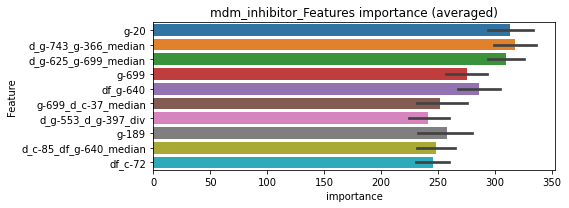

len(train_index) : 2850
len(valid_index) : 950
================================= fold 1/4 mdm_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.095736	valid_1's binary_logloss: 0.132733
[200]	training's binary_logloss: 0.0306816	valid_1's binary_logloss: 0.0586243
[300]	training's binary_logloss: 0.0110001	valid_1's binary_logloss: 0.0310432
[400]	training's binary_logloss: 0.00467368	valid_1's binary_logloss: 0.0209921
[500]	training's binary_logloss: 0.00239682	valid_1's binary_logloss: 0.0160271
[600]	training's binary_logloss: 0.00148247	valid_1's binary_logloss: 0.0138085
[700]	training's binary_logloss: 0.00104402	valid_1's binary_logloss: 0.0125393
[800]	training's binary_logloss: 0.000812358	valid_1's binary_logloss: 0.0117722
[900]	training's binary_logloss: 0.000681696	valid_1's binary_logloss: 0.0112944
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.000641541	valid_1's binary_logloss: 0.0111985


len(train_index) : 2850
len(valid_index) : 950
================================= fold 2/4 mdm_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096994	valid_1's binary_logloss: 0.116842
[200]	training's binary_logloss: 0.0309555	valid_1's binary_logloss: 0.0469689
[300]	training's binary_logloss: 0.0111014	valid_1's binary_logloss: 0.0229521
[400]	training's binary_logloss: 0.00464437	valid_1's binary_logloss: 0.013521
[500]	training's binary_logloss: 0.00240408	valid_1's binary_logloss: 0.00958386
[600]	training's binary_logloss: 0.00149483	valid_1's binary_logloss: 0.00759582
[700]	training's binary_logloss: 0.0010614	valid_1's binary_logloss: 0.00667883
[800]	training's binary_logloss: 0.000829234	valid_1's binary_logloss: 0.0061996
[900]	training's binary_logloss: 0.000701432	valid_1's binary_logloss: 0.00580732
[1000]	training's binary_logloss: 0.000630288	valid_1's binary_logloss: 0.00565321
Early stopping, best iteration is:
[1008]	training's binary_logloss: 0.000627225	valid_1's binary_logloss: 0.00561919


len(train_index) : 2850
len(valid_index) : 950
================================= fold 3/4 mdm_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0930629	valid_1's binary_logloss: 0.128775
[200]	training's binary_logloss: 0.0295396	valid_1's binary_logloss: 0.0581172
[300]	training's binary_logloss: 0.0105708	valid_1's binary_logloss: 0.0324532
[400]	training's binary_logloss: 0.00443863	valid_1's binary_logloss: 0.0224616
[500]	training's binary_logloss: 0.00229833	valid_1's binary_logloss: 0.0186129
[600]	training's binary_logloss: 0.0014433	valid_1's binary_logloss: 0.0169921
[700]	training's binary_logloss: 0.00103376	valid_1's binary_logloss: 0.0160705
[800]	training's binary_logloss: 0.000798131	valid_1's binary_logloss: 0.0154749
[900]	training's binary_logloss: 0.000672421	valid_1's binary_logloss: 0.0149971
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000668472	valid_1's binary_logloss: 0.0149732


len(train_index) : 2850
len(valid_index) : 950
================================= fold 4/4 mdm_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959431	valid_1's binary_logloss: 0.129486
[200]	training's binary_logloss: 0.0293597	valid_1's binary_logloss: 0.054545
[300]	training's binary_logloss: 0.0104596	valid_1's binary_logloss: 0.0287788
[400]	training's binary_logloss: 0.00442707	valid_1's binary_logloss: 0.0183951
[500]	training's binary_logloss: 0.00229455	valid_1's binary_logloss: 0.013933
[600]	training's binary_logloss: 0.00144218	valid_1's binary_logloss: 0.0118549
[700]	training's binary_logloss: 0.00102707	valid_1's binary_logloss: 0.0106818
[800]	training's binary_logloss: 0.000804445	valid_1's binary_logloss: 0.0101516
[900]	training's binary_logloss: 0.000678571	valid_1's binary_logloss: 0.00969819
[1000]	training's binary_logloss: 0.000621984	valid_1's binary_logloss: 0.00959227
Early stopping, best iteration is:
[1032]	training's binary_logloss: 0.00060508	valid_1's binary_logloss: 0.00955872


mdm_inhibitor logloss: 0.010345121602074006
mek_inhibitor, len(trt): 72, len(othr): 3273, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151445	valid_1's binary_logloss: 0.247976
[200]	training's binary_logloss: 0.0766139	valid_1's binary_logloss: 0.18546
[300]	training's binary_logloss: 0.0394895	valid_1's binary_logloss: 0.146277
[400]	training's binary_logloss: 0.0208915	valid_1's binary_logloss: 0.122042
[500]	training's binary_logloss: 0.0112623	valid_1's binary_logloss: 0.108741
[600]	training's binary_logloss: 0.00637809	valid_1's binary_logloss: 0.103273
[700]	training's binary_logloss: 0.00394311	valid_1's binary_logloss: 0.099831
[800]	training's binary_logloss: 0.0026465	valid_1's binary_logloss: 0.0972627
[900]	training's binary_logloss: 0.00195103	valid_1's binary_logloss: 0.095852
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.00196806	valid_1's binary_logloss: 0.0958313
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.150868	valid_1's binary_

1 / 3 AUC score:0.995
y_Threshold: 0.0338565, Threshold: 0.1321105, pos_neg_ratio: 0.8000000
Remove_noisy_data: 168 → Positive_corect_labels: 636/3759
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.09248, conf_1:0.17174
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.1321105
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_2: 0.1621105
Num_p_label: 15.0, Expected: 12.0, Adj_threshold_3: 0.1921105
threshold: 0.1921105, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 636.0/3759, y_label_rate: 0.1691939
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.147295	valid_1's binary_logloss: 0.211616
[200]	training's binary_logloss: 0.068814	valid_1's binary_logloss: 0.135252
[300]	training's binary_logloss: 0.0343777	valid_1's binary_logloss: 0.0949867
[400]	training's binary_logloss: 0.0177261	valid_1's binary_logloss: 0.0716621
[500]	training's binary_logloss: 0.00928978	valid_1's binary_logloss: 0.0573157
[600]	training's binary_logloss: 0.00538012	valid_1's binary_logloss: 0.0491916
[700]	training's binary_logloss: 0.00336216	valid_1's binary_logloss: 0.0446056
[800]	training's binary_logloss: 0.00231842	valid_1's binary_logloss: 0.0415335
[900]	training's binary_logloss: 0.00173857	valid_1's binary_logloss: 0.0396723
[1000]	training's binary_logloss: 0.00139845	valid_1's binary_logloss: 0.038912
[1100]	training's binary_logloss: 0.00118467	valid_1's binary_logloss: 0.0381198
[1200]	training's binary_logloss: 0.00105286	valid_1's binary_logl

2 / 3 AUC score:0.998
y_Threshold: 0.1298737, Threshold: 0.1921105, pos_neg_ratio: 0.8000000
Remove_noisy_data: 40 → Positive_corect_labels: 616.0/3719
p_label_rate: 0.0203415 Vs.target_rate: 0.00302, Num_p_label: 81.0, conf_0:0.15369, conf_1:0.23053
Num_p_label: 81.0, Expected: 12.0, Adj_threshold_1: 0.1921105
Num_p_label: 72.0, Expected: 12.0, Adj_threshold_2: 0.2221105
Num_p_label: 61.0, Expected: 12.0, Adj_threshold_3: 0.2521105
Num_p_label: 54.0, Expected: 12.0, Adj_threshold_4: 0.2821105
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_5: 0.3121105
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_6: 0.3421105
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_7: 0.3721105
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_8: 0.4021105
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_9: 0.4321105
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_10: 0.4621105
threshold: 0.4921105, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 616.0/3719, y_label_rate: 0.1656359

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135492	valid_1's binary_logloss: 0.201196
[200]	training's binary_logloss: 0.0620375	valid_1's binary_logloss: 0.123911
[300]	training's binary_logloss: 0.0296758	valid_1's binary_logloss: 0.0839574
[400]	training's binary_logloss: 0.0147993	valid_1's binary_logloss: 0.0609806
[500]	training's binary_logloss: 0.00766162	valid_1's binary_logloss: 0.047251
[600]	training's binary_logloss: 0.00438093	valid_1's binary_logloss: 0.0398785
[700]	training's binary_logloss: 0.0027916	valid_1's binary_logloss: 0.0353755
[800]	training's binary_logloss: 0.0019794	valid_1's binary_logloss: 0.0329599
[900]	training's binary_logloss: 0.00152119	valid_1's binary_logloss: 0.0310401
[1000]	training's binary_logloss: 0.00124109	valid_1's binary_logloss: 0.029958
[1100]	training's binary_logloss: 0.00106622	valid_1's binary_logloss: 0.0291755
Early stopping, best iteration is:
[1163]	training's binary_logloss:

3 / 3 AUC score:0.999
y_Threshold: 0.1700694, Threshold: 0.4921105, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 608.0/3703
p_label_rate: 0.0090407 Vs.target_rate: 0.00302, Num_p_label: 36.0, conf_0:0.44290, conf_1:0.54132
threshold: 0.4921105, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 608.0/3703, y_label_rate: 0.1641912


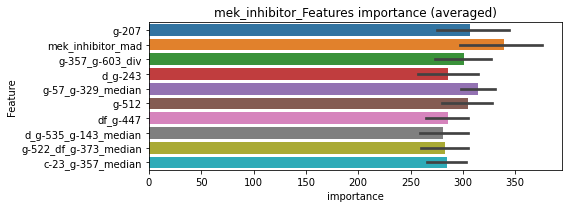

len(train_index) : 2777
len(valid_index) : 926
================================= fold 1/4 mek_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131745	valid_1's binary_logloss: 0.195518
[200]	training's binary_logloss: 0.0586635	valid_1's binary_logloss: 0.121637
[300]	training's binary_logloss: 0.0279262	valid_1's binary_logloss: 0.0830871
[400]	training's binary_logloss: 0.0133419	valid_1's binary_logloss: 0.0602306
[500]	training's binary_logloss: 0.00694204	valid_1's binary_logloss: 0.0469578
[600]	training's binary_logloss: 0.00398761	valid_1's binary_logloss: 0.0400866
[700]	training's binary_logloss: 0.00256703	valid_1's binary_logloss: 0.0350656
[800]	training's binary_logloss: 0.00183832	valid_1's binary_logloss: 0.0325894
[900]	training's binary_logloss: 0.00142321	valid_1's binary_logloss: 0.030781
[1000]	training's binary_logloss: 0.00117288	valid_1's binary_logloss: 0.0293417
[1100]	training's binary_logloss: 0.00101129	valid_1's binary_logloss: 0.0285161
[1200]	training's binary_logloss: 0.000907344	valid_1's binary_lo

len(train_index) : 2777
len(valid_index) : 926
================================= fold 2/4 mek_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129207	valid_1's binary_logloss: 0.19025
[200]	training's binary_logloss: 0.0572377	valid_1's binary_logloss: 0.114474
[300]	training's binary_logloss: 0.0269946	valid_1's binary_logloss: 0.07673
[400]	training's binary_logloss: 0.012863	valid_1's binary_logloss: 0.0553161
[500]	training's binary_logloss: 0.00657656	valid_1's binary_logloss: 0.0429897
[600]	training's binary_logloss: 0.00382215	valid_1's binary_logloss: 0.0372195
[700]	training's binary_logloss: 0.00249234	valid_1's binary_logloss: 0.0331582
[800]	training's binary_logloss: 0.00179948	valid_1's binary_logloss: 0.0308053
[900]	training's binary_logloss: 0.00139504	valid_1's binary_logloss: 0.0288613
Early stopping, best iteration is:
[961]	training's binary_logloss: 0.00122665	valid_1's binary_logloss: 0.028139


len(train_index) : 2777
len(valid_index) : 926
================================= fold 3/4 mek_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13709	valid_1's binary_logloss: 0.194058
[200]	training's binary_logloss: 0.06127	valid_1's binary_logloss: 0.120578
[300]	training's binary_logloss: 0.0287477	valid_1's binary_logloss: 0.0828742
[400]	training's binary_logloss: 0.0146374	valid_1's binary_logloss: 0.0635665
[500]	training's binary_logloss: 0.00742242	valid_1's binary_logloss: 0.0513359
[600]	training's binary_logloss: 0.00422802	valid_1's binary_logloss: 0.0446267
[700]	training's binary_logloss: 0.00269246	valid_1's binary_logloss: 0.0415937
[800]	training's binary_logloss: 0.00191432	valid_1's binary_logloss: 0.0404829
[900]	training's binary_logloss: 0.00146318	valid_1's binary_logloss: 0.039553
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.00144163	valid_1's binary_logloss: 0.0394924


len(train_index) : 2778
len(valid_index) : 925
================================= fold 4/4 mek_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135315	valid_1's binary_logloss: 0.200262
[200]	training's binary_logloss: 0.060354	valid_1's binary_logloss: 0.122423
[300]	training's binary_logloss: 0.0288839	valid_1's binary_logloss: 0.0818449
[400]	training's binary_logloss: 0.0134312	valid_1's binary_logloss: 0.0576282
[500]	training's binary_logloss: 0.00689498	valid_1's binary_logloss: 0.0443592
[600]	training's binary_logloss: 0.00396317	valid_1's binary_logloss: 0.0370024
[700]	training's binary_logloss: 0.0025566	valid_1's binary_logloss: 0.0326029
[800]	training's binary_logloss: 0.00183651	valid_1's binary_logloss: 0.0303689
[900]	training's binary_logloss: 0.00141816	valid_1's binary_logloss: 0.0286354
[1000]	training's binary_logloss: 0.00117387	valid_1's binary_logloss: 0.0274348
[1100]	training's binary_logloss: 0.00100762	valid_1's binary_logloss: 0.0268814
Early stopping, best iteration is:
[1157]	training's binary_loglos

mek_inhibitor logloss: 0.03039365593529996
membrane_integrity_inhibitor, len(trt): 74, len(othr): 3276, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133304	valid_1's binary_logloss: 0.213025
[200]	training's binary_logloss: 0.0573082	valid_1's binary_logloss: 0.148755
[300]	training's binary_logloss: 0.0271114	valid_1's binary_logloss: 0.121074
[400]	training's binary_logloss: 0.0135123	valid_1's binary_logloss: 0.10896
[500]	training's binary_logloss: 0.0072188	valid_1's binary_logloss: 0.102115
[600]	training's binary_logloss: 0.00426041	valid_1's binary_logloss: 0.0993646
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00389952	valid_1's binary_logloss: 0.0988963
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136681	valid_1's binary_logloss: 0.189015
[200]	training's binary_logloss: 0.0613061	valid_1's binary_logloss: 0.120637
[300]	training's binary_logloss: 0.0303084	valid_1's binary_logloss: 0.0884619
[400]	training's binary_logloss: 0.0157609	valid_1's binary_l

1 / 3 AUC score:0.992
y_Threshold: 0.0365549, Threshold: 0.1222148, pos_neg_ratio: 0.8000000
Remove_noisy_data: 168 → Positive_corect_labels: 637/3763
p_label_rate: 0.0100452 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.08555, conf_1:0.15888
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.1222148
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_2: 0.1522148
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_3: 0.1822148
Num_p_label: 21.0, Expected: 12.4, Adj_threshold_4: 0.2122148
Num_p_label: 21.0, Expected: 12.4, Adj_threshold_5: 0.2422148
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_6: 0.2722148
threshold: 0.2722148, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 637.0/3763, y_label_rate: 0.1692798
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123025	valid_1's binary_logloss: 0.17958
[200]	training's binary_logloss: 0.0489615	valid_1's binary_logloss: 0.107768
[300]	training's binary_logloss: 0.0217448	valid_1's binary_logloss: 0.0740734
[400]	training's binary_logloss: 0.0102306	valid_1's binary_logloss: 0.056695
[500]	training's binary_logloss: 0.00542311	valid_1's binary_logloss: 0.0479472
[600]	training's binary_logloss: 0.0032472	valid_1's binary_logloss: 0.0428549
[700]	training's binary_logloss: 0.00217345	valid_1's binary_logloss: 0.0405803
[800]	training's binary_logloss: 0.00159318	valid_1's binary_logloss: 0.0389354
[900]	training's binary_logloss: 0.00126299	valid_1's binary_logloss: 0.0379819
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.00117908	valid_1's binary_logloss: 0.0376817
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1273	valid_1's bin

2 / 3 AUC score:0.999
y_Threshold: 0.1007195, Threshold: 0.2722148, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 615.0/3719
p_label_rate: 0.0160723 Vs.target_rate: 0.00311, Num_p_label: 64.0, conf_0:0.21777, conf_1:0.32666
Num_p_label: 64.0, Expected: 12.4, Adj_threshold_1: 0.2722148
Num_p_label: 59.0, Expected: 12.4, Adj_threshold_2: 0.3022148
Num_p_label: 57.0, Expected: 12.4, Adj_threshold_3: 0.3322148
Num_p_label: 50.0, Expected: 12.4, Adj_threshold_4: 0.3622148
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_5: 0.3922148
Num_p_label: 44.0, Expected: 12.4, Adj_threshold_6: 0.4222148
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_7: 0.4522148
Num_p_label: 41.0, Expected: 12.4, Adj_threshold_8: 0.4822148
Num_p_label: 37.0, Expected: 12.4, Adj_threshold_9: 0.5122148
Num_p_label: 35.0, Expected: 12.4, Adj_threshold_10: 0.5422148
threshold: 0.5722148, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 615.0/3719, y_label_rate: 0.1653670

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117361	valid_1's binary_logloss: 0.166428
[200]	training's binary_logloss: 0.0457672	valid_1's binary_logloss: 0.0961031
[300]	training's binary_logloss: 0.0192009	valid_1's binary_logloss: 0.0647996
[400]	training's binary_logloss: 0.00910032	valid_1's binary_logloss: 0.0497014
[500]	training's binary_logloss: 0.00477333	valid_1's binary_logloss: 0.0420095
[600]	training's binary_logloss: 0.00287722	valid_1's binary_logloss: 0.0375256
[700]	training's binary_logloss: 0.00191726	valid_1's binary_logloss: 0.0358626
[800]	training's binary_logloss: 0.00142334	valid_1's binary_logloss: 0.0338123
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.00134273	valid_1's binary_logloss: 0.0336888
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114036	valid_1's binary_logloss: 0.169253
[200]	training's binary_logloss: 0.0421967	valid_1'

3 / 3 AUC score:0.998
y_Threshold: 0.0967348, Threshold: 0.5722148, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 596.0/3681
p_label_rate: 0.0123054 Vs.target_rate: 0.00311, Num_p_label: 49.0, conf_0:0.50000, conf_1:0.62944
Num_p_label: 49.0, Expected: 12.4, Adj_threshold_1: 0.5722148
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_2: 0.6022148
Num_p_label: 45.0, Expected: 12.4, Adj_threshold_3: 0.6322148
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_4: 0.6622148
Num_p_label: 41.0, Expected: 12.4, Adj_threshold_5: 0.6922148
threshold: 0.6922148, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 596.0/3681, y_label_rate: 0.1619125


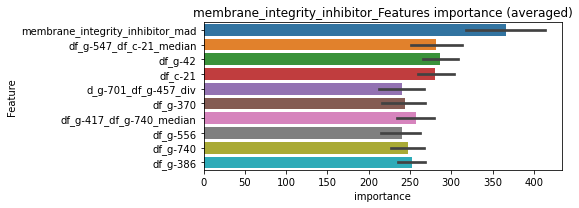

len(train_index) : 2760
len(valid_index) : 921
================================= fold 1/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110053	valid_1's binary_logloss: 0.157925
[200]	training's binary_logloss: 0.0403885	valid_1's binary_logloss: 0.0883035
[300]	training's binary_logloss: 0.0169355	valid_1's binary_logloss: 0.0581791
[400]	training's binary_logloss: 0.00778968	valid_1's binary_logloss: 0.043208
[500]	training's binary_logloss: 0.00408575	valid_1's binary_logloss: 0.035244
[600]	training's binary_logloss: 0.00247574	valid_1's binary_logloss: 0.0310746
[700]	training's binary_logloss: 0.00170425	valid_1's binary_logloss: 0.0288578
[800]	training's binary_logloss: 0.00129548	valid_1's binary_logloss: 0.0277852
[900]	training's binary_logloss: 0.00104791	valid_1's binary_logloss: 0.0267654
[1000]	training's binary_logloss: 0.00090081	valid_1's binary_logloss: 0.0264058
[1100]	training's binary_logloss: 0.000814312	valid_1's binary_logloss: 0.0260579
Early stopping, best iteration is:
[1110]	training's binary_log

len(train_index) : 2761
len(valid_index) : 920
================================= fold 2/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108182	valid_1's binary_logloss: 0.159121
[200]	training's binary_logloss: 0.0394323	valid_1's binary_logloss: 0.0889394
[300]	training's binary_logloss: 0.0161996	valid_1's binary_logloss: 0.0592329
[400]	training's binary_logloss: 0.00736358	valid_1's binary_logloss: 0.0456807
[500]	training's binary_logloss: 0.00385495	valid_1's binary_logloss: 0.0381416
[600]	training's binary_logloss: 0.00234505	valid_1's binary_logloss: 0.0345222
[700]	training's binary_logloss: 0.001627	valid_1's binary_logloss: 0.0325816
[800]	training's binary_logloss: 0.00123623	valid_1's binary_logloss: 0.0315003
[900]	training's binary_logloss: 0.000999518	valid_1's binary_logloss: 0.0309068
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00105473	valid_1's binary_logloss: 0.0308128


len(train_index) : 2761
len(valid_index) : 920
================================= fold 3/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11042	valid_1's binary_logloss: 0.158444
[200]	training's binary_logloss: 0.0407842	valid_1's binary_logloss: 0.0888348
[300]	training's binary_logloss: 0.0168263	valid_1's binary_logloss: 0.0600097
[400]	training's binary_logloss: 0.00783106	valid_1's binary_logloss: 0.0458205
[500]	training's binary_logloss: 0.00412623	valid_1's binary_logloss: 0.038313
[600]	training's binary_logloss: 0.00248578	valid_1's binary_logloss: 0.0342046
[700]	training's binary_logloss: 0.00171531	valid_1's binary_logloss: 0.0319629
[800]	training's binary_logloss: 0.00129485	valid_1's binary_logloss: 0.0309345
[900]	training's binary_logloss: 0.0010475	valid_1's binary_logloss: 0.0293932
Early stopping, best iteration is:
[913]	training's binary_logloss: 0.00102477	valid_1's binary_logloss: 0.0293782


len(train_index) : 2761
len(valid_index) : 920
================================= fold 4/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110148	valid_1's binary_logloss: 0.152314
[200]	training's binary_logloss: 0.0413051	valid_1's binary_logloss: 0.0845215
[300]	training's binary_logloss: 0.017177	valid_1's binary_logloss: 0.0573496
[400]	training's binary_logloss: 0.00790531	valid_1's binary_logloss: 0.0443791
[500]	training's binary_logloss: 0.00407014	valid_1's binary_logloss: 0.0360876
[600]	training's binary_logloss: 0.00246514	valid_1's binary_logloss: 0.032211
[700]	training's binary_logloss: 0.00169185	valid_1's binary_logloss: 0.0296253
[800]	training's binary_logloss: 0.00128012	valid_1's binary_logloss: 0.0282626
[900]	training's binary_logloss: 0.00103664	valid_1's binary_logloss: 0.0272117
[1000]	training's binary_logloss: 0.00089295	valid_1's binary_logloss: 0.0267293
[1100]	training's binary_logloss: 0.00080826	valid_1's binary_logloss: 0.0265014
Early stopping, best iteration is:
[1088]	training's binary_logl

membrane_integrity_inhibitor logloss: 0.028156812660391193
mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3283, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0779245	valid_1's binary_logloss: 0.101296
[200]	training's binary_logloss: 0.0232253	valid_1's binary_logloss: 0.0425377
[300]	training's binary_logloss: 0.00778937	valid_1's binary_logloss: 0.0234401
[400]	training's binary_logloss: 0.00317789	valid_1's binary_logloss: 0.0170944
[500]	training's binary_logloss: 0.00161813	valid_1's binary_logloss: 0.0145342
[600]	training's binary_logloss: 0.00102863	valid_1's binary_logloss: 0.0134147
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.0010449	valid_1's binary_logloss: 0.0133934
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805066	valid_1's binary_logloss: 0.102107
[200]	training's binary_logloss: 0.0243902	valid_1's binary_logloss: 0.0390551
[300]	training's binary_logloss: 0.00826852	valid_1's binary_logloss: 0.0184037
[400]	training's binary_logloss: 0.00331845	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0076443, Threshold: 0.0499738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.03498, conf_1:0.06497
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0499738
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_2: 0.0799738
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_3: 0.1099738
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.1399738
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_5: 0.1699738
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.1999738
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_7: 0.2299738
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_8: 0.2599738
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_9: 0.2899738
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_10: 0.3199738
threshold: 0.3499738, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0742729	valid_1's binary_logloss: 0.0986108
[200]	training's binary_logloss: 0.0198505	valid_1's binary_logloss: 0.0366636
[300]	training's binary_logloss: 0.00649917	valid_1's binary_logloss: 0.0183261
[400]	training's binary_logloss: 0.00259984	valid_1's binary_logloss: 0.0120453
[500]	training's binary_logloss: 0.00135657	valid_1's binary_logloss: 0.00943709
[600]	training's binary_logloss: 0.000870118	valid_1's binary_logloss: 0.00838489
[700]	training's binary_logloss: 0.000637038	valid_1's binary_logloss: 0.00775468
[800]	training's binary_logloss: 0.000517285	valid_1's binary_logloss: 0.00740439
[900]	training's binary_logloss: 0.000475286	valid_1's binary_logloss: 0.00732723
Early stopping, best iteration is:
[914]	training's binary_logloss: 0.000474239	valid_1's binary_logloss: 0.00731326
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0779473, Threshold: 0.3499738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0055249 Vs.target_rate: 0.00105, Num_p_label: 22.0, conf_0:0.27998, conf_1:0.41997
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_1: 0.3499738
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_2: 0.3799738
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_3: 0.4099738
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.4399738
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_5: 0.4699738
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_6: 0.4999738
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_7: 0.5299738
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_8: 0.5599738
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_9: 0.5899738
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_10: 0.6199738
threshold: 0.6499738, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0748226	valid_1's binary_logloss: 0.0968091
[200]	training's binary_logloss: 0.0198858	valid_1's binary_logloss: 0.0356161
[300]	training's binary_logloss: 0.00655773	valid_1's binary_logloss: 0.0181754
[400]	training's binary_logloss: 0.00264079	valid_1's binary_logloss: 0.0113839
[500]	training's binary_logloss: 0.00137725	valid_1's binary_logloss: 0.00864081
[600]	training's binary_logloss: 0.000880239	valid_1's binary_logloss: 0.00753565
[700]	training's binary_logloss: 0.000644014	valid_1's binary_logloss: 0.00683985
[800]	training's binary_logloss: 0.000518551	valid_1's binary_logloss: 0.00647197
[900]	training's binary_logloss: 0.000464787	valid_1's binary_logloss: 0.00628494
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.000465185	valid_1's binary_logloss: 0.00628438
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0591177, Threshold: 0.6499738, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0035158 Vs.target_rate: 0.00105, Num_p_label: 14.0, conf_0:0.50000, conf_1:0.71497
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_1: 0.6499738
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_2: 0.6799738
threshold: 0.6799738, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3803, y_label_rate: 0.1719695


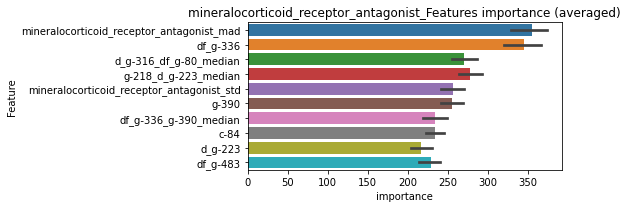

len(train_index) : 2852
len(valid_index) : 951
================================= fold 1/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.074531	valid_1's binary_logloss: 0.0949703
[200]	training's binary_logloss: 0.0200425	valid_1's binary_logloss: 0.0352447
[300]	training's binary_logloss: 0.00659138	valid_1's binary_logloss: 0.0179061
[400]	training's binary_logloss: 0.00269433	valid_1's binary_logloss: 0.0117861
[500]	training's binary_logloss: 0.00139346	valid_1's binary_logloss: 0.00923848
[600]	training's binary_logloss: 0.000881105	valid_1's binary_logloss: 0.00796088
[700]	training's binary_logloss: 0.000644406	valid_1's binary_logloss: 0.0072714
[800]	training's binary_logloss: 0.000520092	valid_1's binary_logloss: 0.00687323
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.00051053	valid_1's binary_logloss: 0.00683326


len(train_index) : 2852
len(valid_index) : 951
================================= fold 2/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0758472	valid_1's binary_logloss: 0.0917454
[200]	training's binary_logloss: 0.0208213	valid_1's binary_logloss: 0.0319416
[300]	training's binary_logloss: 0.00689095	valid_1's binary_logloss: 0.0140831
[400]	training's binary_logloss: 0.00278498	valid_1's binary_logloss: 0.00811553
[500]	training's binary_logloss: 0.00144712	valid_1's binary_logloss: 0.00547443
[600]	training's binary_logloss: 0.000916353	valid_1's binary_logloss: 0.00435963
[700]	training's binary_logloss: 0.000662468	valid_1's binary_logloss: 0.00386705
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.000576347	valid_1's binary_logloss: 0.00371682


len(train_index) : 2852
len(valid_index) : 951
================================= fold 3/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07528	valid_1's binary_logloss: 0.0957399
[200]	training's binary_logloss: 0.020683	valid_1's binary_logloss: 0.0331851
[300]	training's binary_logloss: 0.00662455	valid_1's binary_logloss: 0.0137627
[400]	training's binary_logloss: 0.00267446	valid_1's binary_logloss: 0.00735183
[500]	training's binary_logloss: 0.00140319	valid_1's binary_logloss: 0.00469499
[600]	training's binary_logloss: 0.000895808	valid_1's binary_logloss: 0.00358731
[700]	training's binary_logloss: 0.000651625	valid_1's binary_logloss: 0.0029341
[800]	training's binary_logloss: 0.000526718	valid_1's binary_logloss: 0.00263698
[900]	training's binary_logloss: 0.000480309	valid_1's binary_logloss: 0.00250992
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000468482	valid_1's binary_logloss: 0.00248571


len(train_index) : 2853
len(valid_index) : 950
================================= fold 4/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0760667	valid_1's binary_logloss: 0.0948201
[200]	training's binary_logloss: 0.0204469	valid_1's binary_logloss: 0.0337026
[300]	training's binary_logloss: 0.00669309	valid_1's binary_logloss: 0.0155342
[400]	training's binary_logloss: 0.00267991	valid_1's binary_logloss: 0.00912121
[500]	training's binary_logloss: 0.00139208	valid_1's binary_logloss: 0.0062406
[600]	training's binary_logloss: 0.000884486	valid_1's binary_logloss: 0.00488444
[700]	training's binary_logloss: 0.000646298	valid_1's binary_logloss: 0.00428244
[800]	training's binary_logloss: 0.000524401	valid_1's binary_logloss: 0.00405862
[900]	training's binary_logloss: 0.000467184	valid_1's binary_logloss: 0.00384953
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.000467184	valid_1's binary_logloss: 0.00384953


mineralocorticoid_receptor_antagonist logloss: 0.004221427962562623
monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0710895	valid_1's binary_logloss: 0.0840686
[200]	training's binary_logloss: 0.0169017	valid_1's binary_logloss: 0.0253269
[300]	training's binary_logloss: 0.00465129	valid_1's binary_logloss: 0.00953845
[400]	training's binary_logloss: 0.00170163	valid_1's binary_logloss: 0.00467572
[500]	training's binary_logloss: 0.000864595	valid_1's binary_logloss: 0.00301177
[600]	training's binary_logloss: 0.000559959	valid_1's binary_logloss: 0.00228186
[700]	training's binary_logloss: 0.000421085	valid_1's binary_logloss: 0.00194491
[800]	training's binary_logloss: 0.000365617	valid_1's binary_logloss: 0.00176218
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.000366457	valid_1's binary_logloss: 0.00176045
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0708944	valid_1's binary_logloss: 0.0808427
[200]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0027640, Threshold: 0.0119199, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00834, conf_1:0.01550
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0119199
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.0419199
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0719199
threshold: 0.0719199, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0690814	valid_1's binary_logloss: 0.0801638
[200]	training's binary_logloss: 0.0159884	valid_1's binary_logloss: 0.0229544
[300]	training's binary_logloss: 0.00425736	valid_1's binary_logloss: 0.00821062
[400]	training's binary_logloss: 0.00154526	valid_1's binary_logloss: 0.00393524
[500]	training's binary_logloss: 0.000790359	valid_1's binary_logloss: 0.00260667
[600]	training's binary_logloss: 0.000512613	valid_1's binary_logloss: 0.00212704
[700]	training's binary_logloss: 0.000387316	valid_1's binary_logloss: 0.00187247
[800]	training's binary_logloss: 0.000341525	valid_1's binary_logloss: 0.00177549
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.000336213	valid_1's binary_logloss: 0.00176572
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0689448	valid_1's binary_logloss: 0.0795024
[200]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1160822, Threshold: 0.0719199, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0042692 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.05754, conf_1:0.08630
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.0719199
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.1019199
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.1319199
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.1619199
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.1919199
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.2219199
threshold: 0.2219199, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0690814	valid_1's binary_logloss: 0.0801638
[200]	training's binary_logloss: 0.0159884	valid_1's binary_logloss: 0.0229544
[300]	training's binary_logloss: 0.00425736	valid_1's binary_logloss: 0.00821062
[400]	training's binary_logloss: 0.00154526	valid_1's binary_logloss: 0.00393524
[500]	training's binary_logloss: 0.000790359	valid_1's binary_logloss: 0.00260667
[600]	training's binary_logloss: 0.000512613	valid_1's binary_logloss: 0.00212704
[700]	training's binary_logloss: 0.000387316	valid_1's binary_logloss: 0.00187247
[800]	training's binary_logloss: 0.000341525	valid_1's binary_logloss: 0.00177549
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.000336213	valid_1's binary_logloss: 0.00176572
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0689448	valid_1's binary_logloss: 0.0795024
[200]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1160822, Threshold: 0.2219199, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.19973, conf_1:0.24411
threshold: 0.2219199, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


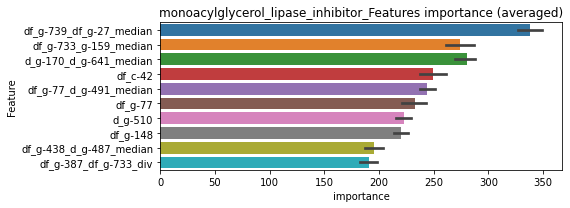

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0706911	valid_1's binary_logloss: 0.0827424
[200]	training's binary_logloss: 0.0160219	valid_1's binary_logloss: 0.0228423
[300]	training's binary_logloss: 0.00425643	valid_1's binary_logloss: 0.00801646
[400]	training's binary_logloss: 0.00156443	valid_1's binary_logloss: 0.00371038
[500]	training's binary_logloss: 0.000800156	valid_1's binary_logloss: 0.00233343
[600]	training's binary_logloss: 0.000519734	valid_1's binary_logloss: 0.00173252
[700]	training's binary_logloss: 0.000389456	valid_1's binary_logloss: 0.00143717
[800]	training's binary_logloss: 0.000338414	valid_1's binary_logloss: 0.00132406
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.000337017	valid_1's binary_logloss: 0.0013201


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0694228	valid_1's binary_logloss: 0.0789966
[200]	training's binary_logloss: 0.015879	valid_1's binary_logloss: 0.0212743
[300]	training's binary_logloss: 0.00428901	valid_1's binary_logloss: 0.00688665
[400]	training's binary_logloss: 0.0015875	valid_1's binary_logloss: 0.00302818
[500]	training's binary_logloss: 0.000800282	valid_1's binary_logloss: 0.001682
[600]	training's binary_logloss: 0.000514471	valid_1's binary_logloss: 0.00118891
[700]	training's binary_logloss: 0.000387586	valid_1's binary_logloss: 0.000972135
[800]	training's binary_logloss: 0.000335916	valid_1's binary_logloss: 0.000876901
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.000335916	valid_1's binary_logloss: 0.000876901


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0691405	valid_1's binary_logloss: 0.0757306
[200]	training's binary_logloss: 0.0157187	valid_1's binary_logloss: 0.0193257
[300]	training's binary_logloss: 0.00415797	valid_1's binary_logloss: 0.00595495
[400]	training's binary_logloss: 0.00152233	valid_1's binary_logloss: 0.00249995
[500]	training's binary_logloss: 0.000784579	valid_1's binary_logloss: 0.00142053
[600]	training's binary_logloss: 0.000509166	valid_1's binary_logloss: 0.000983177
[700]	training's binary_logloss: 0.000381411	valid_1's binary_logloss: 0.000773435
[800]	training's binary_logloss: 0.000331679	valid_1's binary_logloss: 0.000690533
Early stopping, best iteration is:
[841]	training's binary_logloss: 0.00032811	valid_1's binary_logloss: 0.00068382


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679925	valid_1's binary_logloss: 0.0811889
[200]	training's binary_logloss: 0.0151823	valid_1's binary_logloss: 0.0222796
[300]	training's binary_logloss: 0.00409584	valid_1's binary_logloss: 0.00784482
[400]	training's binary_logloss: 0.00152376	valid_1's binary_logloss: 0.00387675
[500]	training's binary_logloss: 0.0007856	valid_1's binary_logloss: 0.00235041
[600]	training's binary_logloss: 0.000510418	valid_1's binary_logloss: 0.00181356
[700]	training's binary_logloss: 0.000383894	valid_1's binary_logloss: 0.00149937
[800]	training's binary_logloss: 0.000337093	valid_1's binary_logloss: 0.00141648
Early stopping, best iteration is:
[853]	training's binary_logloss: 0.000331494	valid_1's binary_logloss: 0.00140254


monoacylglycerol_lipase_inhibitor logloss: 0.0010710346859827298


neg labels: 3289 → selected neg labels: 3280


monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3280, target_rate: 0.0035693 → Adj_target_rate: 0.0036661
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.144894	valid_1's binary_logloss: 0.234883
[200]	training's binary_logloss: 0.0663263	valid_1's binary_logloss: 0.171453
[300]	training's binary_logloss: 0.0336734	valid_1's binary_logloss: 0.138963
[400]	training's binary_logloss: 0.0174654	valid_1's binary_logloss: 0.119924
[500]	training's binary_logloss: 0.00956591	valid_1's binary_logloss: 0.110417
[600]	training's binary_logloss: 0.00565326	valid_1's binary_logloss: 0.104934
[700]	training's binary_logloss: 0.00360691	valid_1's binary_logloss: 0.101378
[800]	training's binary_logloss: 0.00251899	valid_1's binary_logloss: 0.0991909
Early stopping, best iteration is:
[847]	training's binary_logloss: 0.00218512	valid_1's binary_logloss: 0.0984304
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148321	valid_1's binary_logloss: 0.23154
[200]	training's binary_logloss: 0.070374	valid_1's binary_

1 / 3 AUC score:0.984
y_Threshold: 0.0319649, Threshold: 0.3750670, pos_neg_ratio: 0.8000000
Remove_noisy_data: 180 → Positive_corect_labels: 632/3756
p_label_rate: 0.0100452 Vs.target_rate: 0.00357, Num_p_label: 40.0, conf_0:0.26255, conf_1:0.48759
threshold: 0.3750670, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 632.0/3756, y_label_rate: 0.1682641
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128484	valid_1's binary_logloss: 0.207233
[200]	training's binary_logloss: 0.052373	valid_1's binary_logloss: 0.137778
[300]	training's binary_logloss: 0.0242696	valid_1's binary_logloss: 0.102659
[400]	training's binary_logloss: 0.0119274	valid_1's binary_logloss: 0.0835033
[500]	training's binary_logloss: 0.00632069	valid_1's binary_logloss: 0.0710212
[600]	training's binary_logloss: 0.00371546	valid_1's binary_logloss: 0.0644355
[700]	training's binary_logloss: 0.00243455	valid_1's binary_logloss: 0.0603968
[800]	training's binary_logloss: 0.00176574	valid_1's binary_logloss: 0.0577628
[900]	training's binary_logloss: 0.00138137	valid_1's binary_logloss: 0.0561714
[1000]	training's binary_logloss: 0.00115249	valid_1's binary_logloss: 0.0552228
Early stopping, best iteration is:
[1006]	training's binary_logloss: 0.00114401	valid_1's binary_logloss: 0.0550568
Training until validation score

2 / 3 AUC score:0.994
y_Threshold: 0.1055378, Threshold: 0.3750670, pos_neg_ratio: 0.8000000
Remove_noisy_data: 70 → Positive_corect_labels: 597.0/3686
p_label_rate: 0.0268709 Vs.target_rate: 0.00357, Num_p_label: 107.0, conf_0:0.30005, conf_1:0.45008
Num_p_label: 107.0, Expected: 14.2, Adj_threshold_1: 0.3750670
Num_p_label: 103.0, Expected: 14.2, Adj_threshold_2: 0.4050670
Num_p_label: 97.0, Expected: 14.2, Adj_threshold_3: 0.4350670
Num_p_label: 92.0, Expected: 14.2, Adj_threshold_4: 0.4650670
Num_p_label: 89.0, Expected: 14.2, Adj_threshold_5: 0.4950670
Num_p_label: 87.0, Expected: 14.2, Adj_threshold_6: 0.5250670
Num_p_label: 87.0, Expected: 14.2, Adj_threshold_7: 0.5550670
Num_p_label: 86.0, Expected: 14.2, Adj_threshold_8: 0.5850670
Num_p_label: 84.0, Expected: 14.2, Adj_threshold_9: 0.6150670
Num_p_label: 83.0, Expected: 14.2, Adj_threshold_10: 0.6450670
threshold: 0.6750670, positive_p_label: 79.0/3982, p_label_rate: 0.0198393
positive_y_label: 597.0/3686, y_label_rate: 0.1619

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112154	valid_1's binary_logloss: 0.182751
[200]	training's binary_logloss: 0.0423035	valid_1's binary_logloss: 0.119334
[300]	training's binary_logloss: 0.0189551	valid_1's binary_logloss: 0.0950354
[400]	training's binary_logloss: 0.00892077	valid_1's binary_logloss: 0.0836232
[500]	training's binary_logloss: 0.00465702	valid_1's binary_logloss: 0.076263
[600]	training's binary_logloss: 0.00274743	valid_1's binary_logloss: 0.0729191
[700]	training's binary_logloss: 0.0018311	valid_1's binary_logloss: 0.0711213
Early stopping, best iteration is:
[673]	training's binary_logloss: 0.00201667	valid_1's binary_logloss: 0.0709244
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117927	valid_1's binary_logloss: 0.15729
[200]	training's binary_logloss: 0.0471206	valid_1's binary_logloss: 0.0930298
[300]	training's binary_logloss: 0.0215931	valid_1's bin

3 / 3 AUC score:0.998
y_Threshold: 0.1031137, Threshold: 0.6750670, pos_neg_ratio: 0.8000000
Remove_noisy_data: 36 → Positive_corect_labels: 579.0/3650
p_label_rate: 0.0286288 Vs.target_rate: 0.00357, Num_p_label: 114.0, conf_0:0.50000, conf_1:0.74257
Num_p_label: 114.0, Expected: 14.2, Adj_threshold_1: 0.6750670
threshold: 0.6750670, positive_p_label: 114.0/3982, p_label_rate: 0.0286288
positive_y_label: 579.0/3650, y_label_rate: 0.1586301


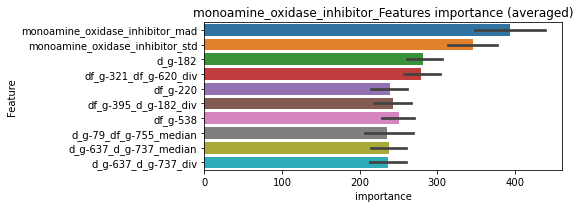

len(train_index) : 2737
len(valid_index) : 913
================================= fold 1/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107433	valid_1's binary_logloss: 0.156734
[200]	training's binary_logloss: 0.0385098	valid_1's binary_logloss: 0.0931013
[300]	training's binary_logloss: 0.0161929	valid_1's binary_logloss: 0.0697738
[400]	training's binary_logloss: 0.00732698	valid_1's binary_logloss: 0.0587605
[500]	training's binary_logloss: 0.0037998	valid_1's binary_logloss: 0.0535568
[600]	training's binary_logloss: 0.00228511	valid_1's binary_logloss: 0.052031
[700]	training's binary_logloss: 0.00157784	valid_1's binary_logloss: 0.0508223
Early stopping, best iteration is:
[683]	training's binary_logloss: 0.00166806	valid_1's binary_logloss: 0.0507424


len(train_index) : 2737
len(valid_index) : 913
================================= fold 2/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105652	valid_1's binary_logloss: 0.170702
[200]	training's binary_logloss: 0.0384801	valid_1's binary_logloss: 0.101185
[300]	training's binary_logloss: 0.0161168	valid_1's binary_logloss: 0.0709674
[400]	training's binary_logloss: 0.00734744	valid_1's binary_logloss: 0.0554293
[500]	training's binary_logloss: 0.00387004	valid_1's binary_logloss: 0.0455713
[600]	training's binary_logloss: 0.00232115	valid_1's binary_logloss: 0.0406989
[700]	training's binary_logloss: 0.0015934	valid_1's binary_logloss: 0.0384134
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.00135083	valid_1's binary_logloss: 0.0373311


len(train_index) : 2738
len(valid_index) : 912
================================= fold 3/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107831	valid_1's binary_logloss: 0.16657
[200]	training's binary_logloss: 0.039551	valid_1's binary_logloss: 0.10163
[300]	training's binary_logloss: 0.0164324	valid_1's binary_logloss: 0.0766637
[400]	training's binary_logloss: 0.00751807	valid_1's binary_logloss: 0.0630035
[500]	training's binary_logloss: 0.00384516	valid_1's binary_logloss: 0.0555756
[600]	training's binary_logloss: 0.00233872	valid_1's binary_logloss: 0.0529927
[700]	training's binary_logloss: 0.00160194	valid_1's binary_logloss: 0.0506078
[800]	training's binary_logloss: 0.00120844	valid_1's binary_logloss: 0.0493853
Early stopping, best iteration is:
[799]	training's binary_logloss: 0.00121063	valid_1's binary_logloss: 0.0493692


len(train_index) : 2738
len(valid_index) : 912
================================= fold 4/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107645	valid_1's binary_logloss: 0.151724
[200]	training's binary_logloss: 0.0398483	valid_1's binary_logloss: 0.0891205
[300]	training's binary_logloss: 0.0175669	valid_1's binary_logloss: 0.0626434
[400]	training's binary_logloss: 0.00829317	valid_1's binary_logloss: 0.0496809
[500]	training's binary_logloss: 0.00416885	valid_1's binary_logloss: 0.0423111
[600]	training's binary_logloss: 0.00242959	valid_1's binary_logloss: 0.0373054
[700]	training's binary_logloss: 0.00163232	valid_1's binary_logloss: 0.0351802
[800]	training's binary_logloss: 0.00124127	valid_1's binary_logloss: 0.0343666
[900]	training's binary_logloss: 0.00101282	valid_1's binary_logloss: 0.0331038
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.00101467	valid_1's binary_logloss: 0.0330907


monoamine_oxidase_inhibitor logloss: 0.04263412235144858


neg labels: 3289 → selected neg labels: 3287


monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0754261	valid_1's binary_logloss: 0.0912611
[200]	training's binary_logloss: 0.0204188	valid_1's binary_logloss: 0.0303778
[300]	training's binary_logloss: 0.00620535	valid_1's binary_logloss: 0.0125175
[400]	training's binary_logloss: 0.00238932	valid_1's binary_logloss: 0.00686854
[500]	training's binary_logloss: 0.00122286	valid_1's binary_logloss: 0.00477527
[600]	training's binary_logloss: 0.000787893	valid_1's binary_logloss: 0.00391602
[700]	training's binary_logloss: 0.000579028	valid_1's binary_logloss: 0.00349932
[800]	training's binary_logloss: 0.00047114	valid_1's binary_logloss: 0.0032403
[900]	training's binary_logloss: 0.000424391	valid_1's binary_logloss: 0.00312927
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000421949	valid_1's binary_logloss: 0.00312536
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0039371, Threshold: 0.0362198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02535, conf_1:0.04709
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0362198
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.0662198
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.0962198
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.1262198
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.1562198
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.1862198
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.2162198
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.2462198
threshold: 0.2462198, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.073515	valid_1's binary_logloss: 0.0839454
[200]	training's binary_logloss: 0.0188282	valid_1's binary_logloss: 0.024513
[300]	training's binary_logloss: 0.00549152	valid_1's binary_logloss: 0.0085091
[400]	training's binary_logloss: 0.00212575	valid_1's binary_logloss: 0.00400811
[500]	training's binary_logloss: 0.00109016	valid_1's binary_logloss: 0.00244782
[600]	training's binary_logloss: 0.000706294	valid_1's binary_logloss: 0.00178725
[700]	training's binary_logloss: 0.000525035	valid_1's binary_logloss: 0.00145937
[800]	training's binary_logloss: 0.000431826	valid_1's binary_logloss: 0.0012785
[900]	training's binary_logloss: 0.000404624	valid_1's binary_logloss: 0.00124722
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000405784	valid_1's binary_logloss: 0.00124619
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1218655, Threshold: 0.2462198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.19698, conf_1:0.29546
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.2462198
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.2762198
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.3062198
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_4: 0.3362198
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.3662198
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.3962198
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.4262198
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.4562198
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.4862198
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_10: 0.5162198
threshold: 0.5462198, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.073515	valid_1's binary_logloss: 0.0839454
[200]	training's binary_logloss: 0.0188282	valid_1's binary_logloss: 0.024513
[300]	training's binary_logloss: 0.00549152	valid_1's binary_logloss: 0.0085091
[400]	training's binary_logloss: 0.00212575	valid_1's binary_logloss: 0.00400811
[500]	training's binary_logloss: 0.00109016	valid_1's binary_logloss: 0.00244782
[600]	training's binary_logloss: 0.000706294	valid_1's binary_logloss: 0.00178725
[700]	training's binary_logloss: 0.000525035	valid_1's binary_logloss: 0.00145937
[800]	training's binary_logloss: 0.000431826	valid_1's binary_logloss: 0.0012785
[900]	training's binary_logloss: 0.000404624	valid_1's binary_logloss: 0.00124722
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000405784	valid_1's binary_logloss: 0.00124619
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1218655, Threshold: 0.5462198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.49160, conf_1:0.60084
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.5462198
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.5762198
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.6062198
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.6362198
threshold: 0.6362198, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


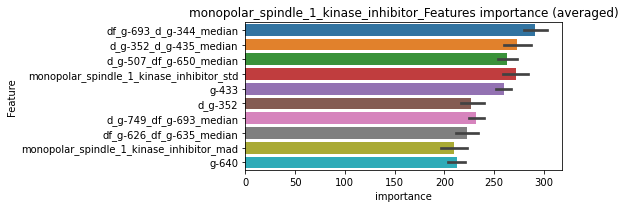

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0748522	valid_1's binary_logloss: 0.0848653
[200]	training's binary_logloss: 0.018935	valid_1's binary_logloss: 0.0246724
[300]	training's binary_logloss: 0.00554244	valid_1's binary_logloss: 0.00855286
[400]	training's binary_logloss: 0.00213162	valid_1's binary_logloss: 0.00386339
[500]	training's binary_logloss: 0.00110176	valid_1's binary_logloss: 0.00233103
[600]	training's binary_logloss: 0.000713104	valid_1's binary_logloss: 0.00169681
[700]	training's binary_logloss: 0.000530048	valid_1's binary_logloss: 0.00140748
[800]	training's binary_logloss: 0.000435013	valid_1's binary_logloss: 0.00121939
[900]	training's binary_logloss: 0.000400655	valid_1's binary_logloss: 0.00116096
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000400655	valid_1's binary_logloss: 0.00116096


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0715939	valid_1's binary_logloss: 0.0970175
[200]	training's binary_logloss: 0.0176343	valid_1's binary_logloss: 0.0338183
[300]	training's binary_logloss: 0.00526044	valid_1's binary_logloss: 0.0144875
[400]	training's binary_logloss: 0.00203217	valid_1's binary_logloss: 0.00730409
[500]	training's binary_logloss: 0.00105568	valid_1's binary_logloss: 0.00478429
[600]	training's binary_logloss: 0.000696202	valid_1's binary_logloss: 0.00389162
[700]	training's binary_logloss: 0.000518452	valid_1's binary_logloss: 0.00322951
[800]	training's binary_logloss: 0.000424981	valid_1's binary_logloss: 0.00295699
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.000404836	valid_1's binary_logloss: 0.00290139


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.072651	valid_1's binary_logloss: 0.086526
[200]	training's binary_logloss: 0.0183676	valid_1's binary_logloss: 0.0262349
[300]	training's binary_logloss: 0.00541062	valid_1's binary_logloss: 0.00994372
[400]	training's binary_logloss: 0.00209237	valid_1's binary_logloss: 0.00504073
[500]	training's binary_logloss: 0.00108401	valid_1's binary_logloss: 0.00328841
[600]	training's binary_logloss: 0.00071079	valid_1's binary_logloss: 0.00264929
[700]	training's binary_logloss: 0.000527561	valid_1's binary_logloss: 0.00226888
[800]	training's binary_logloss: 0.000437045	valid_1's binary_logloss: 0.00212944
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.000450394	valid_1's binary_logloss: 0.00210942


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0728989	valid_1's binary_logloss: 0.0869137
[200]	training's binary_logloss: 0.0178549	valid_1's binary_logloss: 0.0251043
[300]	training's binary_logloss: 0.00521795	valid_1's binary_logloss: 0.00890065
[400]	training's binary_logloss: 0.00202942	valid_1's binary_logloss: 0.00410193
[500]	training's binary_logloss: 0.00106125	valid_1's binary_logloss: 0.00235822
[600]	training's binary_logloss: 0.000695629	valid_1's binary_logloss: 0.00168488
[700]	training's binary_logloss: 0.000521063	valid_1's binary_logloss: 0.00133342
[800]	training's binary_logloss: 0.00043095	valid_1's binary_logloss: 0.0011517
[900]	training's binary_logloss: 0.000402765	valid_1's binary_logloss: 0.00109297
Early stopping, best iteration is:
[951]	training's binary_logloss: 0.000394223	valid_1's binary_logloss: 0.00107797


monopolar_spindle_1_kinase_inhibitor logloss: 0.0018124316779205894
mtor_inhibitor, len(trt): 130, len(othr): 3269, target_rate: 0.0054590 → Adj_target_rate: 0.0052608


neg labels: 3289 → selected neg labels: 3269


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.18504	valid_1's binary_logloss: 0.275249
[200]	training's binary_logloss: 0.0991105	valid_1's binary_logloss: 0.21149
[300]	training's binary_logloss: 0.0553946	valid_1's binary_logloss: 0.178145
[400]	training's binary_logloss: 0.0325355	valid_1's binary_logloss: 0.158981
[500]	training's binary_logloss: 0.0195753	valid_1's binary_logloss: 0.145444
[600]	training's binary_logloss: 0.0120668	valid_1's binary_logloss: 0.13902
[700]	training's binary_logloss: 0.00770242	valid_1's binary_logloss: 0.134085
[800]	training's binary_logloss: 0.00517082	valid_1's binary_logloss: 0.132287
[900]	training's binary_logloss: 0.00367764	valid_1's binary_logloss: 0.131038
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.00382392	valid_1's binary_logloss: 0.130874
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.180684	valid_1's binary_logl

1 / 3 AUC score:0.972
y_Threshold: 0.0692996, Threshold: 0.4347630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 220 → Positive_corect_labels: 609/3702
p_label_rate: 0.0100452 Vs.target_rate: 0.00546, Num_p_label: 40.0, conf_0:0.30433, conf_1:0.56519
threshold: 0.4347630, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 609.0/3702, y_label_rate: 0.1645057
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.158601	valid_1's binary_logloss: 0.239227
[200]	training's binary_logloss: 0.0749214	valid_1's binary_logloss: 0.166318
[300]	training's binary_logloss: 0.0390052	valid_1's binary_logloss: 0.127201
[400]	training's binary_logloss: 0.0209191	valid_1's binary_logloss: 0.107172
[500]	training's binary_logloss: 0.0118899	valid_1's binary_logloss: 0.0943896
[600]	training's binary_logloss: 0.00707439	valid_1's binary_logloss: 0.0857865
[700]	training's binary_logloss: 0.0045397	valid_1's binary_logloss: 0.0799533
[800]	training's binary_logloss: 0.00313158	valid_1's binary_logloss: 0.0765213
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.00271509	valid_1's binary_logloss: 0.0755982
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.157003	valid_1's binary_logloss: 0.223557
[200]	training's binary_logloss: 0.0740967	valid_1's bina

2 / 3 AUC score:0.995
y_Threshold: 0.1199214, Threshold: 0.4347630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 82 → Positive_corect_labels: 568.0/3620
p_label_rate: 0.0283777 Vs.target_rate: 0.00546, Num_p_label: 113.0, conf_0:0.34781, conf_1:0.52172
Num_p_label: 113.0, Expected: 21.7, Adj_threshold_1: 0.4347630
Num_p_label: 100.0, Expected: 21.7, Adj_threshold_2: 0.4647630
Num_p_label: 91.0, Expected: 21.7, Adj_threshold_3: 0.4947630
Num_p_label: 85.0, Expected: 21.7, Adj_threshold_4: 0.5247630
Num_p_label: 73.0, Expected: 21.7, Adj_threshold_5: 0.5547630
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_6: 0.5847630
Num_p_label: 64.0, Expected: 21.7, Adj_threshold_7: 0.6147630
Num_p_label: 58.0, Expected: 21.7, Adj_threshold_8: 0.6447630
Num_p_label: 49.0, Expected: 21.7, Adj_threshold_9: 0.6747630
threshold: 0.6747630, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 568.0/3620, y_label_rate: 0.1569061
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143075	valid_1's binary_logloss: 0.216512
[200]	training's binary_logloss: 0.0623183	valid_1's binary_logloss: 0.14203
[300]	training's binary_logloss: 0.0316145	valid_1's binary_logloss: 0.107917
[400]	training's binary_logloss: 0.0162479	valid_1's binary_logloss: 0.0885947
[500]	training's binary_logloss: 0.00893118	valid_1's binary_logloss: 0.0794829
[600]	training's binary_logloss: 0.00524966	valid_1's binary_logloss: 0.0737711
[700]	training's binary_logloss: 0.00342406	valid_1's binary_logloss: 0.0717918
[800]	training's binary_logloss: 0.00242396	valid_1's binary_logloss: 0.0703283
[900]	training's binary_logloss: 0.00184586	valid_1's binary_logloss: 0.06956
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.00191232	valid_1's binary_logloss: 0.0694002
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.146299	valid_1's bi

3 / 3 AUC score:0.994
y_Threshold: 0.1087257, Threshold: 0.6747630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 540.0/3564
p_label_rate: 0.0160723 Vs.target_rate: 0.00546, Num_p_label: 64.0, conf_0:0.50000, conf_1:0.74224
threshold: 0.6747630, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 540.0/3564, y_label_rate: 0.1515152


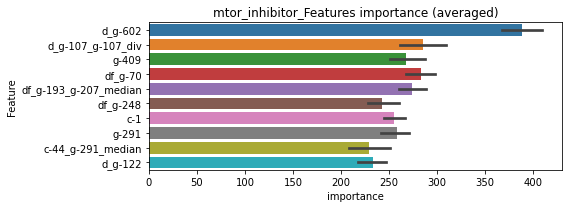

len(train_index) : 2673
len(valid_index) : 891
================================= fold 1/4 mtor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134673	valid_1's binary_logloss: 0.191215
[200]	training's binary_logloss: 0.0565492	valid_1's binary_logloss: 0.118548
[300]	training's binary_logloss: 0.026918	valid_1's binary_logloss: 0.0865675
[400]	training's binary_logloss: 0.0132636	valid_1's binary_logloss: 0.0690911
[500]	training's binary_logloss: 0.0071633	valid_1's binary_logloss: 0.0587922
[600]	training's binary_logloss: 0.00426774	valid_1's binary_logloss: 0.0536629
[700]	training's binary_logloss: 0.00281006	valid_1's binary_logloss: 0.0498906
[800]	training's binary_logloss: 0.00203005	valid_1's binary_logloss: 0.0478952
[900]	training's binary_logloss: 0.00157552	valid_1's binary_logloss: 0.0466245
[1000]	training's binary_logloss: 0.00130187	valid_1's binary_logloss: 0.0455831
[1100]	training's binary_logloss: 0.00113233	valid_1's binary_logloss: 0.0447022
Early stopping, best iteration is:
[1165]	training's binary_loglos

len(train_index) : 2673
len(valid_index) : 891
================================= fold 2/4 mtor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12947	valid_1's binary_logloss: 0.202737
[200]	training's binary_logloss: 0.0539191	valid_1's binary_logloss: 0.138421
[300]	training's binary_logloss: 0.0246094	valid_1's binary_logloss: 0.106829
[400]	training's binary_logloss: 0.012348	valid_1's binary_logloss: 0.0898282
[500]	training's binary_logloss: 0.00658341	valid_1's binary_logloss: 0.0826657
[600]	training's binary_logloss: 0.00390977	valid_1's binary_logloss: 0.0776791
[700]	training's binary_logloss: 0.00261447	valid_1's binary_logloss: 0.0754794
[800]	training's binary_logloss: 0.0019199	valid_1's binary_logloss: 0.0740969
[900]	training's binary_logloss: 0.00150544	valid_1's binary_logloss: 0.0731319
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00159742	valid_1's binary_logloss: 0.0729677


len(train_index) : 2673
len(valid_index) : 891
================================= fold 3/4 mtor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13211	valid_1's binary_logloss: 0.202528
[200]	training's binary_logloss: 0.0561204	valid_1's binary_logloss: 0.134459
[300]	training's binary_logloss: 0.0259289	valid_1's binary_logloss: 0.104818
[400]	training's binary_logloss: 0.0130897	valid_1's binary_logloss: 0.0889709
[500]	training's binary_logloss: 0.0070149	valid_1's binary_logloss: 0.0810901
[600]	training's binary_logloss: 0.00417082	valid_1's binary_logloss: 0.0780913
[700]	training's binary_logloss: 0.00274109	valid_1's binary_logloss: 0.0762223
Early stopping, best iteration is:
[693]	training's binary_logloss: 0.00280995	valid_1's binary_logloss: 0.0760712


len(train_index) : 2673
len(valid_index) : 891
================================= fold 4/4 mtor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128287	valid_1's binary_logloss: 0.198805
[200]	training's binary_logloss: 0.0537239	valid_1's binary_logloss: 0.130555
[300]	training's binary_logloss: 0.025021	valid_1's binary_logloss: 0.0965134
[400]	training's binary_logloss: 0.0124098	valid_1's binary_logloss: 0.0777679
[500]	training's binary_logloss: 0.00663114	valid_1's binary_logloss: 0.0669105
[600]	training's binary_logloss: 0.00398305	valid_1's binary_logloss: 0.061357
[700]	training's binary_logloss: 0.00265443	valid_1's binary_logloss: 0.0589334
[800]	training's binary_logloss: 0.00194345	valid_1's binary_logloss: 0.0568338
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.00168767	valid_1's binary_logloss: 0.0560673


mtor_inhibitor logloss: 0.062376984684228864
mucolytic_agent, len(trt): 48, len(othr): 3288, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114686	valid_1's binary_logloss: 0.171852
[200]	training's binary_logloss: 0.0416954	valid_1's binary_logloss: 0.0953217
[300]	training's binary_logloss: 0.0178129	valid_1's binary_logloss: 0.063683
[400]	training's binary_logloss: 0.00800921	valid_1's binary_logloss: 0.0478102
[500]	training's binary_logloss: 0.00416198	valid_1's binary_logloss: 0.0392279
[600]	training's binary_logloss: 0.00247906	valid_1's binary_logloss: 0.0352352
[700]	training's binary_logloss: 0.00168446	valid_1's binary_logloss: 0.0332781
[800]	training's binary_logloss: 0.00126298	valid_1's binary_logloss: 0.0323124
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00115932	valid_1's binary_logloss: 0.0320047
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113277	valid_1's binary_logloss: 0.16231
[200]	training's binary_logloss: 0.0411012	valid_1's 

1 / 3 AUC score:0.999
y_Threshold: 0.0180001, Threshold: 0.1739266, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.12175, conf_1:0.22610
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.1739266
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_2: 0.2039266
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_3: 0.2339266
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_4: 0.2639266
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_5: 0.2939266
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_6: 0.3239266
threshold: 0.3239266, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 654.0/3807, y_label_rate: 0.1717888
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108543	valid_1's binary_logloss: 0.164418
[200]	training's binary_logloss: 0.0365841	valid_1's binary_logloss: 0.0925987
[300]	training's binary_logloss: 0.0146107	valid_1's binary_logloss: 0.0634224
[400]	training's binary_logloss: 0.00642855	valid_1's binary_logloss: 0.0485588
[500]	training's binary_logloss: 0.00333281	valid_1's binary_logloss: 0.0427767
[600]	training's binary_logloss: 0.00203613	valid_1's binary_logloss: 0.040642
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.00205258	valid_1's binary_logloss: 0.0404445
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108211	valid_1's binary_logloss: 0.152741
[200]	training's binary_logloss: 0.0364252	valid_1's binary_logloss: 0.0796368
[300]	training's binary_logloss: 0.0139299	valid_1's binary_logloss: 0.0496831
[400]	training's binary_logloss: 0.00605875	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.0962568, Threshold: 0.3239266, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 642.0/3783
p_label_rate: 0.0153189 Vs.target_rate: 0.00202, Num_p_label: 61.0, conf_0:0.25914, conf_1:0.38871
Num_p_label: 61.0, Expected: 8.0, Adj_threshold_1: 0.3239266
Num_p_label: 60.0, Expected: 8.0, Adj_threshold_2: 0.3539266
Num_p_label: 57.0, Expected: 8.0, Adj_threshold_3: 0.3839266
Num_p_label: 53.0, Expected: 8.0, Adj_threshold_4: 0.4139266
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_5: 0.4439266
Num_p_label: 48.0, Expected: 8.0, Adj_threshold_6: 0.4739266
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_7: 0.5039266
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_8: 0.5339266
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_9: 0.5639266
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_10: 0.5939266
threshold: 0.6239266, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 642.0/3783, y_label_rate: 0.1697066
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103909	valid_1's binary_logloss: 0.160099
[200]	training's binary_logloss: 0.034393	valid_1's binary_logloss: 0.0879174
[300]	training's binary_logloss: 0.0132494	valid_1's binary_logloss: 0.0586752
[400]	training's binary_logloss: 0.00578062	valid_1's binary_logloss: 0.0471569
[500]	training's binary_logloss: 0.00301021	valid_1's binary_logloss: 0.0418863
[600]	training's binary_logloss: 0.00187235	valid_1's binary_logloss: 0.0410547
[700]	training's binary_logloss: 0.00130779	valid_1's binary_logloss: 0.038918
[800]	training's binary_logloss: 0.00100622	valid_1's binary_logloss: 0.037593
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.000990809	valid_1's binary_logloss: 0.0375587
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107278	valid_1's binary_logloss: 0.14847
[200]	training's binary_logloss: 0.0360668	valid_1's b

3 / 3 AUC score:0.999
y_Threshold: 0.0908359, Threshold: 0.6239266, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 634.0/3767
p_label_rate: 0.0118031 Vs.target_rate: 0.00202, Num_p_label: 47.0, conf_0:0.50000, conf_1:0.68632
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_1: 0.6239266
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_2: 0.6539266
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_3: 0.6839266
threshold: 0.6839266, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 634.0/3767, y_label_rate: 0.1683037


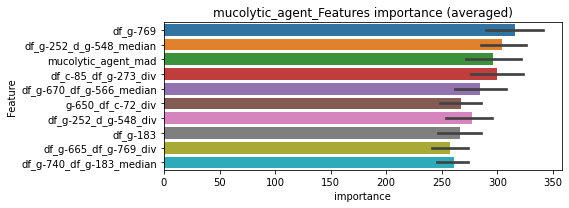

len(train_index) : 2825
len(valid_index) : 942
================================= fold 1/4 mucolytic_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101253	valid_1's binary_logloss: 0.157895
[200]	training's binary_logloss: 0.0325741	valid_1's binary_logloss: 0.0788621
[300]	training's binary_logloss: 0.012475	valid_1's binary_logloss: 0.0474503
[400]	training's binary_logloss: 0.00544244	valid_1's binary_logloss: 0.0330416
[500]	training's binary_logloss: 0.00286385	valid_1's binary_logloss: 0.0255981
[600]	training's binary_logloss: 0.00177656	valid_1's binary_logloss: 0.0219292
[700]	training's binary_logloss: 0.00125544	valid_1's binary_logloss: 0.01993
[800]	training's binary_logloss: 0.000964966	valid_1's binary_logloss: 0.0183508
[900]	training's binary_logloss: 0.000797498	valid_1's binary_logloss: 0.0173106
[1000]	training's binary_logloss: 0.000715585	valid_1's binary_logloss: 0.0168469
Early stopping, best iteration is:
[1065]	training's binary_logloss: 0.000684129	valid_1's binary_logloss: 0.0165641


len(train_index) : 2825
len(valid_index) : 942
================================= fold 2/4 mucolytic_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103175	valid_1's binary_logloss: 0.141028
[200]	training's binary_logloss: 0.0333737	valid_1's binary_logloss: 0.0718723
[300]	training's binary_logloss: 0.0128945	valid_1's binary_logloss: 0.0469703
[400]	training's binary_logloss: 0.00560447	valid_1's binary_logloss: 0.0350588
[500]	training's binary_logloss: 0.00293639	valid_1's binary_logloss: 0.0292134
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00210569	valid_1's binary_logloss: 0.0272315


len(train_index) : 2825
len(valid_index) : 942
================================= fold 3/4 mucolytic_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102609	valid_1's binary_logloss: 0.146467
[200]	training's binary_logloss: 0.0331372	valid_1's binary_logloss: 0.0721276
[300]	training's binary_logloss: 0.0124868	valid_1's binary_logloss: 0.0439904
[400]	training's binary_logloss: 0.00543455	valid_1's binary_logloss: 0.0315864
[500]	training's binary_logloss: 0.00284908	valid_1's binary_logloss: 0.0262883
[600]	training's binary_logloss: 0.00177121	valid_1's binary_logloss: 0.0238142
[700]	training's binary_logloss: 0.00124541	valid_1's binary_logloss: 0.0223609
[800]	training's binary_logloss: 0.000966305	valid_1's binary_logloss: 0.0215675
[900]	training's binary_logloss: 0.000798689	valid_1's binary_logloss: 0.0211476
[1000]	training's binary_logloss: 0.000709179	valid_1's binary_logloss: 0.0209872
Early stopping, best iteration is:
[986]	training's binary_logloss: 0.000716495	valid_1's binary_logloss: 0.0209667


len(train_index) : 2826
len(valid_index) : 941
================================= fold 4/4 mucolytic_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10272	valid_1's binary_logloss: 0.147571
[200]	training's binary_logloss: 0.0336648	valid_1's binary_logloss: 0.0772477
[300]	training's binary_logloss: 0.0126723	valid_1's binary_logloss: 0.0498706
[400]	training's binary_logloss: 0.00554668	valid_1's binary_logloss: 0.0387174
[500]	training's binary_logloss: 0.00287649	valid_1's binary_logloss: 0.0336694
[600]	training's binary_logloss: 0.00177683	valid_1's binary_logloss: 0.0311329
[700]	training's binary_logloss: 0.00124764	valid_1's binary_logloss: 0.0299435
[800]	training's binary_logloss: 0.000964748	valid_1's binary_logloss: 0.0294541
[900]	training's binary_logloss: 0.000803228	valid_1's binary_logloss: 0.0288887
[1000]	training's binary_logloss: 0.000719072	valid_1's binary_logloss: 0.0285377
Early stopping, best iteration is:
[1057]	training's binary_logloss: 0.000688887	valid_1's binary_logloss: 0.0284158


mucolytic_agent logloss: 0.023297191410161282
neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3281, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0988496	valid_1's binary_logloss: 0.144411
[200]	training's binary_logloss: 0.0340343	valid_1's binary_logloss: 0.0740505
[300]	training's binary_logloss: 0.013285	valid_1's binary_logloss: 0.0455069
[400]	training's binary_logloss: 0.00568784	valid_1's binary_logloss: 0.0319706
[500]	training's binary_logloss: 0.00287761	valid_1's binary_logloss: 0.0252794
[600]	training's binary_logloss: 0.00174982	valid_1's binary_logloss: 0.0220603
[700]	training's binary_logloss: 0.00122111	valid_1's binary_logloss: 0.0199804
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.00104118	valid_1's binary_logloss: 0.0191304
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0991556	valid_1's binary_logloss: 0.138064
[200]	training's binary_logloss: 0.0335667	valid_1's binary_logloss: 0.0615145
[300]	training's binary_logloss: 0.0135927	valid_1'

1 / 3 AUC score:1.000
y_Threshold: 0.0143749, Threshold: 0.0610147, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.04271, conf_1:0.07932
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0610147
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_2: 0.0910147
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_3: 0.1210147
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.1510147
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.1810147
threshold: 0.1810147, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957456	valid_1's binary_logloss: 0.144505
[200]	training's binary_logloss: 0.0313043	valid_1's binary_logloss: 0.0785852
[300]	training's binary_logloss: 0.0114408	valid_1's binary_logloss: 0.0541272
[400]	training's binary_logloss: 0.00480333	valid_1's binary_logloss: 0.0437953
[500]	training's binary_logloss: 0.00242621	valid_1's binary_logloss: 0.0382432
[600]	training's binary_logloss: 0.00150634	valid_1's binary_logloss: 0.0358542
[700]	training's binary_logloss: 0.00105983	valid_1's binary_logloss: 0.0343797
[800]	training's binary_logloss: 0.000818086	valid_1's binary_logloss: 0.0336565
Early stopping, best iteration is:
[799]	training's binary_logloss: 0.000819461	valid_1's binary_logloss: 0.0336333
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096884	valid_1's binary_logloss: 0.119849
[200]	training's binary_logloss: 0.0310952	valid

2 / 3 AUC score:1.000
y_Threshold: 0.0588310, Threshold: 0.1810147, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 645.0/3783
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.14481, conf_1:0.21722
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.1810147
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_2: 0.2110147
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_3: 0.2410147
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_4: 0.2710147
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_5: 0.3010147
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_6: 0.3310147
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_7: 0.3610147
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_8: 0.3910147
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_9: 0.4210147
threshold: 0.4210147, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 645.0/3783, y_label_rate: 0.1704996
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0940096	valid_1's binary_logloss: 0.131468
[200]	training's binary_logloss: 0.0297504	valid_1's binary_logloss: 0.0594001
[300]	training's binary_logloss: 0.0107455	valid_1's binary_logloss: 0.0328462
[400]	training's binary_logloss: 0.00451877	valid_1's binary_logloss: 0.0212487
[500]	training's binary_logloss: 0.00232358	valid_1's binary_logloss: 0.0155643
[600]	training's binary_logloss: 0.00144768	valid_1's binary_logloss: 0.0125116
[700]	training's binary_logloss: 0.00103183	valid_1's binary_logloss: 0.0111023
[800]	training's binary_logloss: 0.00080614	valid_1's binary_logloss: 0.0101507
[900]	training's binary_logloss: 0.000675231	valid_1's binary_logloss: 0.0094943
[1000]	training's binary_logloss: 0.000613081	valid_1's binary_logloss: 0.00926489
[1100]	training's binary_logloss: 0.000578106	valid_1's binary_logloss: 0.00914336
Early stopping, best iteration is:
[1096]	training's bin

3 / 3 AUC score:0.999
y_Threshold: 0.0581927, Threshold: 0.4210147, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 640.0/3773
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.37891, conf_1:0.46312
threshold: 0.4210147, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 640.0/3773, y_label_rate: 0.1696263


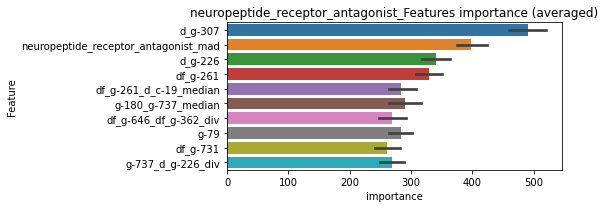

len(train_index) : 2829
len(valid_index) : 944
================================= fold 1/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933694	valid_1's binary_logloss: 0.12569
[200]	training's binary_logloss: 0.0299957	valid_1's binary_logloss: 0.0561687
[300]	training's binary_logloss: 0.0108987	valid_1's binary_logloss: 0.0311523
[400]	training's binary_logloss: 0.00448931	valid_1's binary_logloss: 0.0198818
[500]	training's binary_logloss: 0.00230348	valid_1's binary_logloss: 0.0147285
[600]	training's binary_logloss: 0.00142905	valid_1's binary_logloss: 0.0125842
[700]	training's binary_logloss: 0.00100881	valid_1's binary_logloss: 0.0114386
[800]	training's binary_logloss: 0.000784413	valid_1's binary_logloss: 0.010568
[900]	training's binary_logloss: 0.000660602	valid_1's binary_logloss: 0.0100124
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000665198	valid_1's binary_logloss: 0.00997638


len(train_index) : 2830
len(valid_index) : 943
================================= fold 2/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0913441	valid_1's binary_logloss: 0.123654
[200]	training's binary_logloss: 0.0278447	valid_1's binary_logloss: 0.0537148
[300]	training's binary_logloss: 0.00986641	valid_1's binary_logloss: 0.0280696
[400]	training's binary_logloss: 0.00416339	valid_1's binary_logloss: 0.0176095
[500]	training's binary_logloss: 0.00216014	valid_1's binary_logloss: 0.0125931
[600]	training's binary_logloss: 0.00135552	valid_1's binary_logloss: 0.0101979
[700]	training's binary_logloss: 0.000967824	valid_1's binary_logloss: 0.00886767
[800]	training's binary_logloss: 0.000757056	valid_1's binary_logloss: 0.00807177
[900]	training's binary_logloss: 0.000644974	valid_1's binary_logloss: 0.00754653
[1000]	training's binary_logloss: 0.000589561	valid_1's binary_logloss: 0.007412
[1100]	training's binary_logloss: 0.000555051	valid_1's binary_logloss: 0.0072433
Early stopping, best iteration is:
[1076]	training's 

len(train_index) : 2830
len(valid_index) : 943
================================= fold 3/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0944065	valid_1's binary_logloss: 0.130607
[200]	training's binary_logloss: 0.0290097	valid_1's binary_logloss: 0.0586778
[300]	training's binary_logloss: 0.0105372	valid_1's binary_logloss: 0.0331675
[400]	training's binary_logloss: 0.0043999	valid_1's binary_logloss: 0.022359
[500]	training's binary_logloss: 0.00229695	valid_1's binary_logloss: 0.0174508
[600]	training's binary_logloss: 0.00141744	valid_1's binary_logloss: 0.0147343
[700]	training's binary_logloss: 0.00100718	valid_1's binary_logloss: 0.0133191
[800]	training's binary_logloss: 0.00078663	valid_1's binary_logloss: 0.0124807
[900]	training's binary_logloss: 0.000661829	valid_1's binary_logloss: 0.012056
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.000631224	valid_1's binary_logloss: 0.0118888


len(train_index) : 2830
len(valid_index) : 943
================================= fold 4/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0909145	valid_1's binary_logloss: 0.130526
[200]	training's binary_logloss: 0.027912	valid_1's binary_logloss: 0.0592419
[300]	training's binary_logloss: 0.0100474	valid_1's binary_logloss: 0.0344704
[400]	training's binary_logloss: 0.00413441	valid_1's binary_logloss: 0.0238618
[500]	training's binary_logloss: 0.00216236	valid_1's binary_logloss: 0.0194423
[600]	training's binary_logloss: 0.00134907	valid_1's binary_logloss: 0.0173753
[700]	training's binary_logloss: 0.000963542	valid_1's binary_logloss: 0.016653
[800]	training's binary_logloss: 0.00075273	valid_1's binary_logloss: 0.0162202
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000688028	valid_1's binary_logloss: 0.015933


neuropeptide_receptor_antagonist logloss: 0.011259444401502398


neg labels: 3289 → selected neg labels: 3173


nfkb_inhibitor, len(trt): 832, len(othr): 3173, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.461826	valid_1's binary_logloss: 0.507829
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.465392	valid_1's binary_logloss: 0.508665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.482225	valid_1's binary_logloss: 0.506357
Training until validation scores don't improve for 30 rounds


1 / 3 AUC score:0.526
y_Threshold: 0.2158827, Threshold: 0.4128569, pos_neg_ratio: 0.7377876
Remove_noisy_data: 1388 → Positive_corect_labels: 247/2617
p_label_rate: 0.0100452 Vs.target_rate: 0.03494, Num_p_label: 40.0, conf_0:0.28900, conf_1:0.53671
Num_p_label: 40.0, Expected: 139.1, Adj_threshold_1: 0.4128569
Num_p_label: 116.0, Expected: 139.1, Adj_threshold_2: 0.3828569
Num_p_label: 133.0, Expected: 139.1, Adj_threshold_3: 0.3528569
Num_p_label: 139.0, Expected: 139.1, Adj_threshold_4: 0.3228569
Num_p_label: 148.0, Expected: 139.1, Adj_threshold_5: 0.2928569
Num_p_label: 152.0, Expected: 139.1, Adj_threshold_6: 0.2628569
Num_p_label: 288.0, Expected: 139.1, Adj_threshold_7: 0.2328569
threshold: 0.2328569, positive_p_label: 288.0/3982, p_label_rate: 0.0723255
positive_y_label: 247.0/2617, y_label_rate: 0.0943829
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[33]	training's binary_logloss: 0.452263	valid_1's binary_logloss: 0.507428
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116087	valid_1's binary_logloss: 0.249108
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.08098	valid_1's binary_logloss: 0.246318
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10952	valid_1's binary_logloss: 0.256219
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0908341	valid_1's binary_logloss: 0.254456
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114939	valid_1's binary_logloss: 0.233243
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0701198	valid_1's binary_logloss: 0.2294
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115423	valid_1's binary_logloss: 0.251841


2 / 3 AUC score:0.833
y_Threshold: 0.1290938, Threshold: 0.2328569, pos_neg_ratio: 0.7377876
Remove_noisy_data: 276 → Positive_corect_labels: 109.0/2341
p_label_rate: 0.0743345 Vs.target_rate: 0.03494, Num_p_label: 296.0, conf_0:0.18629, conf_1:0.27943
threshold: 0.2328569, positive_p_label: 296.0/3982, p_label_rate: 0.0743345
positive_y_label: 109.0/2341, y_label_rate: 0.0465613
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0691358	valid_1's binary_logloss: 0.247319
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0344177	valid_1's binary_logloss: 0.0874562
[200]	training's binary_logloss: 0.0110394	valid_1's binary_logloss: 0.0797635
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00799968	valid_1's binary_logloss: 0.0784922
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0329623	valid_1's binary_logloss: 0.115237
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0268901	valid_1's binary_logloss: 0.114532
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0344905	valid_1's binary_logloss: 0.0997077
[200]	training's binary_logloss: 0.0113191	valid_1's binary_logloss: 0.0961126
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0146913	vali

3 / 3 AUC score:0.971
y_Threshold: 0.0701116, Threshold: 0.2328569, pos_neg_ratio: 0.7377876
Remove_noisy_data: 68 → Positive_corect_labels: 75.0/2273
p_label_rate: 0.0642893 Vs.target_rate: 0.03494, Num_p_label: 256.0, conf_0:0.20957, conf_1:0.25614
threshold: 0.2328569, positive_p_label: 256.0/3982, p_label_rate: 0.0642893
positive_y_label: 75.0/2273, y_label_rate: 0.0329960


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0182366	valid_1's binary_logloss: 0.092588


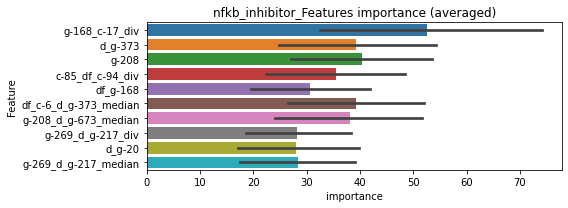

len(train_index) : 1704
len(valid_index) : 569
================================= fold 1/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0197051	valid_1's binary_logloss: 0.051427
[200]	training's binary_logloss: 0.00565738	valid_1's binary_logloss: 0.0448685
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00430001	valid_1's binary_logloss: 0.044581


len(train_index) : 1705
len(valid_index) : 568
================================= fold 2/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0214784	valid_1's binary_logloss: 0.0336167
[200]	training's binary_logloss: 0.00604524	valid_1's binary_logloss: 0.0259298
[300]	training's binary_logloss: 0.00245047	valid_1's binary_logloss: 0.0243494


len(train_index) : 1705
len(valid_index) : 568
================================= fold 3/4 nfkb_inhibitor=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00156812	valid_1's binary_logloss: 0.0238012
Training until validation scores don't improve for 30 rounds


len(train_index) : 1705
len(valid_index) : 568
================================= fold 4/4 nfkb_inhibitor=================================


[100]	training's binary_logloss: 0.0190122	valid_1's binary_logloss: 0.0878277
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0190122	valid_1's binary_logloss: 0.0878277
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0194572	valid_1's binary_logloss: 0.0675563


nfkb_inhibitor logloss: 0.0549682043821023


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00848906	valid_1's binary_logloss: 0.0636812


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0655682	valid_1's binary_logloss: 0.0788431
[200]	training's binary_logloss: 0.0161289	valid_1's binary_logloss: 0.0256616
[300]	training's binary_logloss: 0.00470657	valid_1's binary_logloss: 0.0111375
[400]	training's binary_logloss: 0.00182982	valid_1's binary_logloss: 0.00649549
[500]	training's binary_logloss: 0.000967482	valid_1's binary_logloss: 0.00483514
[600]	training's binary_logloss: 0.000631421	valid_1's binary_logloss: 0.00412248
[700]	training's binary_logloss: 0.000469909	valid_1's binary_logloss: 0.00355912
[800]	training's binary_logloss: 0.000398934	valid_1's binary_logloss: 0.00332124
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.000380307	valid_1's binary_logloss: 0.00319931
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.066655	valid_1's binary_logloss: 0.0794576
[200]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0025271, Threshold: 0.0177119, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.01240, conf_1:0.02303
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0177119
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_2: 0.0477119
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_3: 0.0777119
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.1077119
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.1377119
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.1677119
threshold: 0.1677119, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0641321	valid_1's binary_logloss: 0.0756851
[200]	training's binary_logloss: 0.0143753	valid_1's binary_logloss: 0.020754
[300]	training's binary_logloss: 0.00413089	valid_1's binary_logloss: 0.00764827
[400]	training's binary_logloss: 0.00160487	valid_1's binary_logloss: 0.00370191
[500]	training's binary_logloss: 0.000852172	valid_1's binary_logloss: 0.00235971
[600]	training's binary_logloss: 0.000556246	valid_1's binary_logloss: 0.00173499
[700]	training's binary_logloss: 0.000418569	valid_1's binary_logloss: 0.00142096
[800]	training's binary_logloss: 0.000355287	valid_1's binary_logloss: 0.00129149
[900]	training's binary_logloss: 0.000339884	valid_1's binary_logloss: 0.001262
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000339951	valid_1's binary_logloss: 0.00126141
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.2727272, Threshold: 0.1677119, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0042692 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.13417, conf_1:0.20125
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.1677119
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_2: 0.1977119
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_3: 0.2277119
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_4: 0.2577119
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.2877119
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_6: 0.3177119
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_7: 0.3477119
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_8: 0.3777119
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.4077119
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.4377119
threshold: 0.4677119, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0641321	valid_1's binary_logloss: 0.0756851
[200]	training's binary_logloss: 0.0143753	valid_1's binary_logloss: 0.020754
[300]	training's binary_logloss: 0.00413089	valid_1's binary_logloss: 0.00764827
[400]	training's binary_logloss: 0.00160487	valid_1's binary_logloss: 0.00370191
[500]	training's binary_logloss: 0.000852172	valid_1's binary_logloss: 0.00235971
[600]	training's binary_logloss: 0.000556246	valid_1's binary_logloss: 0.00173499
[700]	training's binary_logloss: 0.000418569	valid_1's binary_logloss: 0.00142096
[800]	training's binary_logloss: 0.000355287	valid_1's binary_logloss: 0.00129149
[900]	training's binary_logloss: 0.000339884	valid_1's binary_logloss: 0.001262
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000339951	valid_1's binary_logloss: 0.00126141
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.2727272, Threshold: 0.4677119, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.42094, conf_1:0.51448
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.4677119
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.4977119
threshold: 0.4977119, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


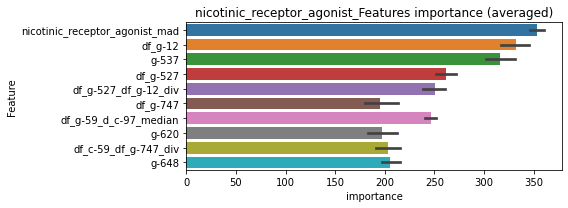

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0630009	valid_1's binary_logloss: 0.0745926
[200]	training's binary_logloss: 0.0140801	valid_1's binary_logloss: 0.0203437
[300]	training's binary_logloss: 0.00406603	valid_1's binary_logloss: 0.00746649
[400]	training's binary_logloss: 0.00159686	valid_1's binary_logloss: 0.00349578
[500]	training's binary_logloss: 0.000838447	valid_1's binary_logloss: 0.00210175
[600]	training's binary_logloss: 0.000557467	valid_1's binary_logloss: 0.00154382
[700]	training's binary_logloss: 0.000418691	valid_1's binary_logloss: 0.00125406
[800]	training's binary_logloss: 0.000359877	valid_1's binary_logloss: 0.00112813
[900]	training's binary_logloss: 0.000344946	valid_1's binary_logloss: 0.00109981
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.000344946	valid_1's binary_logloss: 0.00109981


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0646715	valid_1's binary_logloss: 0.0762313
[200]	training's binary_logloss: 0.0144829	valid_1's binary_logloss: 0.020438
[300]	training's binary_logloss: 0.00415243	valid_1's binary_logloss: 0.00721392
[400]	training's binary_logloss: 0.00161632	valid_1's binary_logloss: 0.00347047
[500]	training's binary_logloss: 0.00085925	valid_1's binary_logloss: 0.00212033
[600]	training's binary_logloss: 0.000566729	valid_1's binary_logloss: 0.00156164
[700]	training's binary_logloss: 0.000426915	valid_1's binary_logloss: 0.00129337
[800]	training's binary_logloss: 0.000358201	valid_1's binary_logloss: 0.00115591
[900]	training's binary_logloss: 0.000345293	valid_1's binary_logloss: 0.00113034
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.000345938	valid_1's binary_logloss: 0.00112982


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0630205	valid_1's binary_logloss: 0.0804659
[200]	training's binary_logloss: 0.0139478	valid_1's binary_logloss: 0.026176
[300]	training's binary_logloss: 0.00397693	valid_1's binary_logloss: 0.0109388
[400]	training's binary_logloss: 0.00157173	valid_1's binary_logloss: 0.00605004
[500]	training's binary_logloss: 0.000831723	valid_1's binary_logloss: 0.00400317
[600]	training's binary_logloss: 0.000548525	valid_1's binary_logloss: 0.00313446
[700]	training's binary_logloss: 0.000416465	valid_1's binary_logloss: 0.00267817
[800]	training's binary_logloss: 0.000355671	valid_1's binary_logloss: 0.00253475
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000354283	valid_1's binary_logloss: 0.00251812


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0632096	valid_1's binary_logloss: 0.0782619
[200]	training's binary_logloss: 0.0140519	valid_1's binary_logloss: 0.022932
[300]	training's binary_logloss: 0.00402895	valid_1's binary_logloss: 0.00909477
[400]	training's binary_logloss: 0.00156457	valid_1's binary_logloss: 0.00464284
[500]	training's binary_logloss: 0.000824992	valid_1's binary_logloss: 0.00294207
[600]	training's binary_logloss: 0.000544815	valid_1's binary_logloss: 0.00224616
[700]	training's binary_logloss: 0.000411772	valid_1's binary_logloss: 0.00187513
[800]	training's binary_logloss: 0.000354805	valid_1's binary_logloss: 0.00170806
[900]	training's binary_logloss: 0.000338315	valid_1's binary_logloss: 0.00166092
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.000338316	valid_1's binary_logloss: 0.00166092


nicotinic_receptor_agonist logloss: 0.0016021669957646523
nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0868847	valid_1's binary_logloss: 0.114521
[200]	training's binary_logloss: 0.0280935	valid_1's binary_logloss: 0.0497153
[300]	training's binary_logloss: 0.00996638	valid_1's binary_logloss: 0.0262161
[400]	training's binary_logloss: 0.00406994	valid_1's binary_logloss: 0.0170087
[500]	training's binary_logloss: 0.00204238	valid_1's binary_logloss: 0.0123825
[600]	training's binary_logloss: 0.00126891	valid_1's binary_logloss: 0.0106129
[700]	training's binary_logloss: 0.000905712	valid_1's binary_logloss: 0.00961593
[800]	training's binary_logloss: 0.000707145	valid_1's binary_logloss: 0.00895641
[900]	training's binary_logloss: 0.000604562	valid_1's binary_logloss: 0.00865288
[1000]	training's binary_logloss: 0.000562959	valid_1's binary_logloss: 0.00852897
Early stopping, best iteration is:
[1053]	training's binary_logloss: 0.000553642	valid_1's binary_logloss: 0.00850223
Training until 

1 / 3 AUC score:1.000
y_Threshold: 0.0091032, Threshold: 0.0779542, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.05457, conf_1:0.10134
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0779542
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_2: 0.1079542
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_3: 0.1379542
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_4: 0.1679542
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_5: 0.1979542
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_6: 0.2279542
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_7: 0.2579542
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_8: 0.2879542
threshold: 0.2879542, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0850134	valid_1's binary_logloss: 0.108389
[200]	training's binary_logloss: 0.0249823	valid_1's binary_logloss: 0.0416992
[300]	training's binary_logloss: 0.00844205	valid_1's binary_logloss: 0.019559
[400]	training's binary_logloss: 0.00344247	valid_1's binary_logloss: 0.0113268
[500]	training's binary_logloss: 0.00177326	valid_1's binary_logloss: 0.0082555
[600]	training's binary_logloss: 0.00111548	valid_1's binary_logloss: 0.00687469
[700]	training's binary_logloss: 0.000798	valid_1's binary_logloss: 0.00612072
[800]	training's binary_logloss: 0.000630385	valid_1's binary_logloss: 0.00569105
[900]	training's binary_logloss: 0.000548267	valid_1's binary_logloss: 0.00545249
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000549311	valid_1's binary_logloss: 0.0054485
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0871644

2 / 3 AUC score:1.000
y_Threshold: 0.1755248, Threshold: 0.2879542, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0082873 Vs.target_rate: 0.00109, Num_p_label: 33.0, conf_0:0.23036, conf_1:0.34555
Num_p_label: 33.0, Expected: 4.3, Adj_threshold_1: 0.2879542
Num_p_label: 30.0, Expected: 4.3, Adj_threshold_2: 0.3179542
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_3: 0.3479542
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_4: 0.3779542
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_5: 0.4079542
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_6: 0.4379542
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_7: 0.4679542
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_8: 0.4979542
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_9: 0.5279542
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_10: 0.5579542
threshold: 0.5879542, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0850134	valid_1's binary_logloss: 0.108389
[200]	training's binary_logloss: 0.0249823	valid_1's binary_logloss: 0.0416992
[300]	training's binary_logloss: 0.00844205	valid_1's binary_logloss: 0.019559
[400]	training's binary_logloss: 0.00344247	valid_1's binary_logloss: 0.0113268
[500]	training's binary_logloss: 0.00177326	valid_1's binary_logloss: 0.0082555
[600]	training's binary_logloss: 0.00111548	valid_1's binary_logloss: 0.00687469
[700]	training's binary_logloss: 0.000798	valid_1's binary_logloss: 0.00612072
[800]	training's binary_logloss: 0.000630385	valid_1's binary_logloss: 0.00569105
[900]	training's binary_logloss: 0.000548267	valid_1's binary_logloss: 0.00545249
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000549311	valid_1's binary_logloss: 0.0054485
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0871644

3 / 3 AUC score:1.000
y_Threshold: 0.1755248, Threshold: 0.5879542, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00109, Num_p_label: 12.0, conf_0:0.50000, conf_1:0.64675
threshold: 0.5879542, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


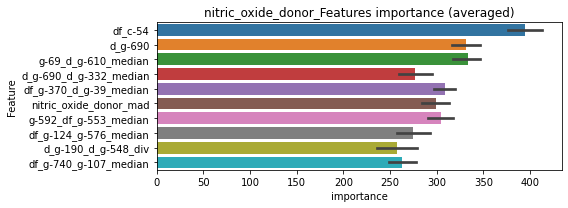

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843395	valid_1's binary_logloss: 0.107973
[200]	training's binary_logloss: 0.0254284	valid_1's binary_logloss: 0.0424211
[300]	training's binary_logloss: 0.00861802	valid_1's binary_logloss: 0.0199369
[400]	training's binary_logloss: 0.00351672	valid_1's binary_logloss: 0.0115576
[500]	training's binary_logloss: 0.00179486	valid_1's binary_logloss: 0.00804709
[600]	training's binary_logloss: 0.00112347	valid_1's binary_logloss: 0.00649327
[700]	training's binary_logloss: 0.000808608	valid_1's binary_logloss: 0.00560981
[800]	training's binary_logloss: 0.000643489	valid_1's binary_logloss: 0.00522767
[900]	training's binary_logloss: 0.000554746	valid_1's binary_logloss: 0.00501336
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.000533086	valid_1's binary_logloss: 0.00492036


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0874052	valid_1's binary_logloss: 0.112546
[200]	training's binary_logloss: 0.0259812	valid_1's binary_logloss: 0.045993
[300]	training's binary_logloss: 0.00904583	valid_1's binary_logloss: 0.0251117
[400]	training's binary_logloss: 0.00361188	valid_1's binary_logloss: 0.0157848
[500]	training's binary_logloss: 0.00185077	valid_1's binary_logloss: 0.0120399
[600]	training's binary_logloss: 0.00114813	valid_1's binary_logloss: 0.010237
[700]	training's binary_logloss: 0.00082604	valid_1's binary_logloss: 0.00900211
[800]	training's binary_logloss: 0.00065167	valid_1's binary_logloss: 0.00857119
[900]	training's binary_logloss: 0.000560863	valid_1's binary_logloss: 0.00806805
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.000549913	valid_1's binary_logloss: 0.0080284


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0869915	valid_1's binary_logloss: 0.103099
[200]	training's binary_logloss: 0.0255417	valid_1's binary_logloss: 0.0370616
[300]	training's binary_logloss: 0.00869288	valid_1's binary_logloss: 0.0162081
[400]	training's binary_logloss: 0.0035591	valid_1's binary_logloss: 0.00831053
[500]	training's binary_logloss: 0.00181339	valid_1's binary_logloss: 0.00512282
[600]	training's binary_logloss: 0.00113985	valid_1's binary_logloss: 0.0037978
[700]	training's binary_logloss: 0.000816425	valid_1's binary_logloss: 0.00302846
[800]	training's binary_logloss: 0.000642278	valid_1's binary_logloss: 0.00259766
[900]	training's binary_logloss: 0.000553433	valid_1's binary_logloss: 0.00239877
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.00054103	valid_1's binary_logloss: 0.00238393


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0857557	valid_1's binary_logloss: 0.106753
[200]	training's binary_logloss: 0.0251284	valid_1's binary_logloss: 0.0414218
[300]	training's binary_logloss: 0.008515	valid_1's binary_logloss: 0.020149
[400]	training's binary_logloss: 0.00344857	valid_1's binary_logloss: 0.011737
[500]	training's binary_logloss: 0.00177494	valid_1's binary_logloss: 0.00852251
[600]	training's binary_logloss: 0.0011158	valid_1's binary_logloss: 0.00689918
[700]	training's binary_logloss: 0.000805147	valid_1's binary_logloss: 0.00619502
[800]	training's binary_logloss: 0.000638176	valid_1's binary_logloss: 0.00579798
[900]	training's binary_logloss: 0.000547531	valid_1's binary_logloss: 0.00552257
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000535033	valid_1's binary_logloss: 0.00547387


nitric_oxide_donor logloss: 0.0052062350178824135
nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3285, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0866853	valid_1's binary_logloss: 0.115445
[200]	training's binary_logloss: 0.0269322	valid_1's binary_logloss: 0.0471896
[300]	training's binary_logloss: 0.0097569	valid_1's binary_logloss: 0.0250546
[400]	training's binary_logloss: 0.00399611	valid_1's binary_logloss: 0.0158709
[500]	training's binary_logloss: 0.00203524	valid_1's binary_logloss: 0.0120087
[600]	training's binary_logloss: 0.00126647	valid_1's binary_logloss: 0.0102408
[700]	training's binary_logloss: 0.000903868	valid_1's binary_logloss: 0.00921322
[800]	training's binary_logloss: 0.000702527	valid_1's binary_logloss: 0.00876266
[900]	training's binary_logloss: 0.000601134	valid_1's binary_logloss: 0.0085151
[1000]	training's binary_logloss: 0.000557371	valid_1's binary_logloss: 0.00843053
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.000560012	valid_1's binary_logloss: 0.00841674
Training until val

1 / 3 AUC score:1.000
y_Threshold: 0.0095927, Threshold: 0.0553235, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00122, Num_p_label: 40.0, conf_0:0.03873, conf_1:0.07192
Num_p_label: 40.0, Expected: 4.8, Adj_threshold_1: 0.0553235
Num_p_label: 29.0, Expected: 4.8, Adj_threshold_2: 0.0853235
Num_p_label: 23.0, Expected: 4.8, Adj_threshold_3: 0.1153235
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_4: 0.1453235
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_5: 0.1753235
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_6: 0.2053235
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_7: 0.2353235
threshold: 0.2353235, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0836826	valid_1's binary_logloss: 0.107404
[200]	training's binary_logloss: 0.0232166	valid_1's binary_logloss: 0.0411714
[300]	training's binary_logloss: 0.00775617	valid_1's binary_logloss: 0.0205607
[400]	training's binary_logloss: 0.00318323	valid_1's binary_logloss: 0.0128519
[500]	training's binary_logloss: 0.00164866	valid_1's binary_logloss: 0.00949424
[600]	training's binary_logloss: 0.00104371	valid_1's binary_logloss: 0.00797959
[700]	training's binary_logloss: 0.000752722	valid_1's binary_logloss: 0.00700654
[800]	training's binary_logloss: 0.00059447	valid_1's binary_logloss: 0.00646508
[900]	training's binary_logloss: 0.000510886	valid_1's binary_logloss: 0.00619606
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000507796	valid_1's binary_logloss: 0.00618256
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

2 / 3 AUC score:1.000
y_Threshold: 0.1192266, Threshold: 0.2353235, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0085384 Vs.target_rate: 0.00122, Num_p_label: 34.0, conf_0:0.18826, conf_1:0.28239
Num_p_label: 34.0, Expected: 4.8, Adj_threshold_1: 0.2353235
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_2: 0.2653235
Num_p_label: 27.0, Expected: 4.8, Adj_threshold_3: 0.2953235
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_4: 0.3253235
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_5: 0.3553235
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_6: 0.3853235
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_7: 0.4153235
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_8: 0.4453235
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_9: 0.4753235
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_10: 0.5053235
threshold: 0.5353235, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0815298	valid_1's binary_logloss: 0.107775
[200]	training's binary_logloss: 0.022474	valid_1's binary_logloss: 0.0396601
[300]	training's binary_logloss: 0.00734546	valid_1's binary_logloss: 0.0177979
[400]	training's binary_logloss: 0.00302808	valid_1's binary_logloss: 0.0100216
[500]	training's binary_logloss: 0.0016061	valid_1's binary_logloss: 0.00697973
[600]	training's binary_logloss: 0.00102171	valid_1's binary_logloss: 0.00540517
[700]	training's binary_logloss: 0.000738696	valid_1's binary_logloss: 0.00449149
[800]	training's binary_logloss: 0.000586963	valid_1's binary_logloss: 0.00396919
[900]	training's binary_logloss: 0.00051011	valid_1's binary_logloss: 0.00376415
[1000]	training's binary_logloss: 0.000479886	valid_1's binary_logloss: 0.00368903
Early stopping, best iteration is:
[988]	training's binary_logloss: 0.000479886	valid_1's binary_logloss: 0.00368903
Training until va

3 / 3 AUC score:1.000
y_Threshold: 0.0963830, Threshold: 0.5353235, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0037670 Vs.target_rate: 0.00122, Num_p_label: 15.0, conf_0:0.48179, conf_1:0.58886
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_1: 0.5353235
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_2: 0.5653235
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_3: 0.5953235
threshold: 0.5953235, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3804, y_label_rate: 0.1719243


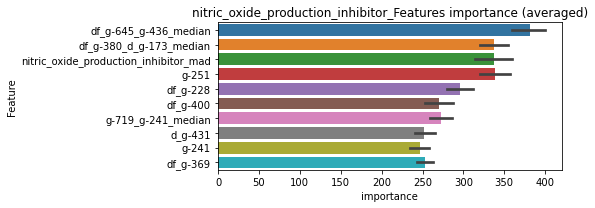

len(train_index) : 2853
len(valid_index) : 951
================================= fold 1/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0801064	valid_1's binary_logloss: 0.105167
[200]	training's binary_logloss: 0.0219294	valid_1's binary_logloss: 0.0392601
[300]	training's binary_logloss: 0.00722083	valid_1's binary_logloss: 0.0186798
[400]	training's binary_logloss: 0.003007	valid_1's binary_logloss: 0.0108189
[500]	training's binary_logloss: 0.00157146	valid_1's binary_logloss: 0.00767347
[600]	training's binary_logloss: 0.00100617	valid_1's binary_logloss: 0.0062315
[700]	training's binary_logloss: 0.000729827	valid_1's binary_logloss: 0.00547455
[800]	training's binary_logloss: 0.000581261	valid_1's binary_logloss: 0.00491185
[900]	training's binary_logloss: 0.000502171	valid_1's binary_logloss: 0.00464432
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000485392	valid_1's binary_logloss: 0.00459026


len(train_index) : 2853
len(valid_index) : 951
================================= fold 2/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0810964	valid_1's binary_logloss: 0.106636
[200]	training's binary_logloss: 0.0226426	valid_1's binary_logloss: 0.0405622
[300]	training's binary_logloss: 0.00757548	valid_1's binary_logloss: 0.0190478
[400]	training's binary_logloss: 0.00310768	valid_1's binary_logloss: 0.0111119
[500]	training's binary_logloss: 0.00162616	valid_1's binary_logloss: 0.00782108
[600]	training's binary_logloss: 0.0010289	valid_1's binary_logloss: 0.006305
[700]	training's binary_logloss: 0.000739645	valid_1's binary_logloss: 0.00539586
[800]	training's binary_logloss: 0.000589437	valid_1's binary_logloss: 0.00485002
[900]	training's binary_logloss: 0.000510772	valid_1's binary_logloss: 0.00454097
Early stopping, best iteration is:
[967]	training's binary_logloss: 0.000482406	valid_1's binary_logloss: 0.00443698


len(train_index) : 2853
len(valid_index) : 951
================================= fold 3/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0807108	valid_1's binary_logloss: 0.10446
[200]	training's binary_logloss: 0.022328	valid_1's binary_logloss: 0.0375477
[300]	training's binary_logloss: 0.00735281	valid_1's binary_logloss: 0.0170478
[400]	training's binary_logloss: 0.00301588	valid_1's binary_logloss: 0.00941411
[500]	training's binary_logloss: 0.00157761	valid_1's binary_logloss: 0.00607675
[600]	training's binary_logloss: 0.00101036	valid_1's binary_logloss: 0.0047161
[700]	training's binary_logloss: 0.000735274	valid_1's binary_logloss: 0.0039292
[800]	training's binary_logloss: 0.000586775	valid_1's binary_logloss: 0.00355703
[900]	training's binary_logloss: 0.000507496	valid_1's binary_logloss: 0.00327325
[1000]	training's binary_logloss: 0.000481883	valid_1's binary_logloss: 0.00322452
Early stopping, best iteration is:
[1006]	training's binary_logloss: 0.000479846	valid_1's binary_logloss: 0.0032126


len(train_index) : 2853
len(valid_index) : 951
================================= fold 4/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0815053	valid_1's binary_logloss: 0.109546
[200]	training's binary_logloss: 0.0222725	valid_1's binary_logloss: 0.0461115
[300]	training's binary_logloss: 0.00728358	valid_1's binary_logloss: 0.0249263
[400]	training's binary_logloss: 0.00298894	valid_1's binary_logloss: 0.0166284
[500]	training's binary_logloss: 0.00156765	valid_1's binary_logloss: 0.0138257
[600]	training's binary_logloss: 0.00100283	valid_1's binary_logloss: 0.0121796
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.000820553	valid_1's binary_logloss: 0.0113712


nitric_oxide_production_inhibitor logloss: 0.00590699323415348
nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0865176	valid_1's binary_logloss: 0.121784
[200]	training's binary_logloss: 0.0269795	valid_1's binary_logloss: 0.0567868
[300]	training's binary_logloss: 0.0097613	valid_1's binary_logloss: 0.0322963
[400]	training's binary_logloss: 0.00407172	valid_1's binary_logloss: 0.0228534
[500]	training's binary_logloss: 0.00210707	valid_1's binary_logloss: 0.0190561
[600]	training's binary_logloss: 0.00131204	valid_1's binary_logloss: 0.0169684
[700]	training's binary_logloss: 0.000933126	valid_1's binary_logloss: 0.0154899
[800]	training's binary_logloss: 0.000731632	valid_1's binary_logloss: 0.0150481
[900]	training's binary_logloss: 0.000616548	valid_1's binary_logloss: 0.0148705
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000611842	valid_1's binary_logloss: 0.0148518
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0890105	

1 / 3 AUC score:1.000
y_Threshold: 0.0078508, Threshold: 0.0936221, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.06554, conf_1:0.12171
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0936221
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_2: 0.1236221
Num_p_label: 27.0, Expected: 4.3, Adj_threshold_3: 0.1536221
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_4: 0.1836221
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_5: 0.2136221
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_6: 0.2436221
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_7: 0.2736221
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_8: 0.3036221
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_9: 0.3336221
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_10: 0.3636221
threshold: 0.3936221, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0842481	valid_1's binary_logloss: 0.114895
[200]	training's binary_logloss: 0.0241424	valid_1's binary_logloss: 0.0505648
[300]	training's binary_logloss: 0.00825877	valid_1's binary_logloss: 0.0287819
[400]	training's binary_logloss: 0.00343628	valid_1's binary_logloss: 0.0204692
[500]	training's binary_logloss: 0.00179275	valid_1's binary_logloss: 0.0166756
[600]	training's binary_logloss: 0.00114849	valid_1's binary_logloss: 0.0149311
[700]	training's binary_logloss: 0.000826551	valid_1's binary_logloss: 0.0139864
[800]	training's binary_logloss: 0.00065389	valid_1's binary_logloss: 0.013408
[900]	training's binary_logloss: 0.000559465	valid_1's binary_logloss: 0.0130813
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00056255	valid_1's binary_logloss: 0.0130687
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0870015	va

2 / 3 AUC score:1.000
y_Threshold: 0.0603746, Threshold: 0.3936221, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0097941 Vs.target_rate: 0.00109, Num_p_label: 39.0, conf_0:0.31490, conf_1:0.47235
Num_p_label: 39.0, Expected: 4.3, Adj_threshold_1: 0.3936221
Num_p_label: 39.0, Expected: 4.3, Adj_threshold_2: 0.4236221
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_3: 0.4536221
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_4: 0.4836221
Num_p_label: 33.0, Expected: 4.3, Adj_threshold_5: 0.5136221
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_6: 0.5436221
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_7: 0.5736221
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_8: 0.6036221
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_9: 0.6336221
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_10: 0.6636221
threshold: 0.6936221, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0840824	valid_1's binary_logloss: 0.114405
[200]	training's binary_logloss: 0.0236257	valid_1's binary_logloss: 0.045348
[300]	training's binary_logloss: 0.0079677	valid_1's binary_logloss: 0.0221063
[400]	training's binary_logloss: 0.0033466	valid_1's binary_logloss: 0.0133046
[500]	training's binary_logloss: 0.00174316	valid_1's binary_logloss: 0.00927927
[600]	training's binary_logloss: 0.00110262	valid_1's binary_logloss: 0.00767106
[700]	training's binary_logloss: 0.000806839	valid_1's binary_logloss: 0.00688923
[800]	training's binary_logloss: 0.000635512	valid_1's binary_logloss: 0.00614331
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.000587815	valid_1's binary_logloss: 0.00596803
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0834393	valid_1's binary_logloss: 0.117095
[200]	training's binary_logloss: 0.0236328	

3 / 3 AUC score:1.000
y_Threshold: 0.0546048, Threshold: 0.6936221, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0065294 Vs.target_rate: 0.00109, Num_p_label: 26.0, conf_0:0.50000, conf_1:0.76298
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_1: 0.6936221
threshold: 0.6936221, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 652.0/3800, y_label_rate: 0.1715789


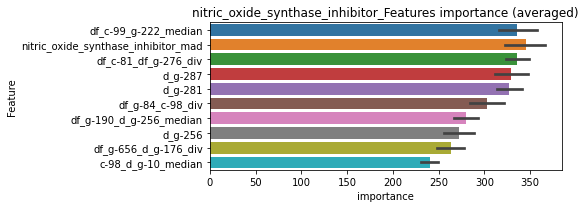

len(train_index) : 2850
len(valid_index) : 950
================================= fold 1/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838775	valid_1's binary_logloss: 0.118851
[200]	training's binary_logloss: 0.0236103	valid_1's binary_logloss: 0.0474548
[300]	training's binary_logloss: 0.00789106	valid_1's binary_logloss: 0.0233412
[400]	training's binary_logloss: 0.0032547	valid_1's binary_logloss: 0.0145991
[500]	training's binary_logloss: 0.00169098	valid_1's binary_logloss: 0.0112355
[600]	training's binary_logloss: 0.00108455	valid_1's binary_logloss: 0.00956265
[700]	training's binary_logloss: 0.0007901	valid_1's binary_logloss: 0.0086709
[800]	training's binary_logloss: 0.000631016	valid_1's binary_logloss: 0.00831523
[900]	training's binary_logloss: 0.000543954	valid_1's binary_logloss: 0.00805136
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.000520413	valid_1's binary_logloss: 0.0079617


len(train_index) : 2850
len(valid_index) : 950
================================= fold 2/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0841735	valid_1's binary_logloss: 0.10185
[200]	training's binary_logloss: 0.0238413	valid_1's binary_logloss: 0.038267
[300]	training's binary_logloss: 0.00816763	valid_1's binary_logloss: 0.0186789
[400]	training's binary_logloss: 0.00340823	valid_1's binary_logloss: 0.0116889
[500]	training's binary_logloss: 0.00178217	valid_1's binary_logloss: 0.00839222
[600]	training's binary_logloss: 0.001136	valid_1's binary_logloss: 0.00691658
[700]	training's binary_logloss: 0.000820255	valid_1's binary_logloss: 0.00619347
[800]	training's binary_logloss: 0.00065117	valid_1's binary_logloss: 0.00579161
[900]	training's binary_logloss: 0.000559542	valid_1's binary_logloss: 0.00557989
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000578553	valid_1's binary_logloss: 0.00555295


len(train_index) : 2850
len(valid_index) : 950
================================= fold 3/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0832206	valid_1's binary_logloss: 0.114897
[200]	training's binary_logloss: 0.0236023	valid_1's binary_logloss: 0.0482843
[300]	training's binary_logloss: 0.00810694	valid_1's binary_logloss: 0.02605
[400]	training's binary_logloss: 0.00338401	valid_1's binary_logloss: 0.0172712
[500]	training's binary_logloss: 0.00174354	valid_1's binary_logloss: 0.0138042
[600]	training's binary_logloss: 0.00109333	valid_1's binary_logloss: 0.0114179
[700]	training's binary_logloss: 0.00079336	valid_1's binary_logloss: 0.0101707
[800]	training's binary_logloss: 0.000629627	valid_1's binary_logloss: 0.00964673
[900]	training's binary_logloss: 0.000540651	valid_1's binary_logloss: 0.00912857
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.000522797	valid_1's binary_logloss: 0.0090649


len(train_index) : 2850
len(valid_index) : 950
================================= fold 4/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0864174	valid_1's binary_logloss: 0.116095
[200]	training's binary_logloss: 0.0243795	valid_1's binary_logloss: 0.0434856
[300]	training's binary_logloss: 0.00821658	valid_1's binary_logloss: 0.0198847
[400]	training's binary_logloss: 0.00340194	valid_1's binary_logloss: 0.0113619
[500]	training's binary_logloss: 0.00177344	valid_1's binary_logloss: 0.00767798
[600]	training's binary_logloss: 0.00110869	valid_1's binary_logloss: 0.00592066
[700]	training's binary_logloss: 0.00080642	valid_1's binary_logloss: 0.00514184
[800]	training's binary_logloss: 0.000643582	valid_1's binary_logloss: 0.00470311
[900]	training's binary_logloss: 0.000551199	valid_1's binary_logloss: 0.00450962
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00056942	valid_1's binary_logloss: 0.00447972


nitric_oxide_synthase_inhibitor logloss: 0.006767307651921024
norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3286, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.049683	valid_1's binary_logloss: 0.0544516
[200]	training's binary_logloss: 0.00925618	valid_1's binary_logloss: 0.0109855
[300]	training's binary_logloss: 0.00225963	valid_1's binary_logloss: 0.00314005
[400]	training's binary_logloss: 0.000841044	valid_1's binary_logloss: 0.00139486
[500]	training's binary_logloss: 0.000462462	valid_1's binary_logloss: 0.000858718
[600]	training's binary_logloss: 0.000321327	valid_1's binary_logloss: 0.000655304
[700]	training's binary_logloss: 0.000272937	valid_1's binary_logloss: 0.000582763
Early stopping, best iteration is:
[768]	training's binary_logloss: 0.000267794	valid_1's binary_logloss: 0.000576698
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497434	valid_1's binary_logloss: 0.0538099
[200]	training's binary_logloss: 0.00927286	valid_1's binary_logloss: 0.0116953
[300]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0011142, Threshold: 0.0072720, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.00509, conf_1:0.00945
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.0072720
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_2: 0.0372720
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_3: 0.0672720
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_4: 0.0972720
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_5: 0.1272720
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_6: 0.1572720
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_7: 0.1872720
threshold: 0.1872720, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0484351	valid_1's binary_logloss: 0.0522151
[200]	training's binary_logloss: 0.00822265	valid_1's binary_logloss: 0.00998651
[300]	training's binary_logloss: 0.00190136	valid_1's binary_logloss: 0.00291551
[400]	training's binary_logloss: 0.000694343	valid_1's binary_logloss: 0.00126456
[500]	training's binary_logloss: 0.000382435	valid_1's binary_logloss: 0.000778172
[600]	training's binary_logloss: 0.000268653	valid_1's binary_logloss: 0.000598559
[700]	training's binary_logloss: 0.000232083	valid_1's binary_logloss: 0.000534555
[800]	training's binary_logloss: 0.000226513	valid_1's binary_logloss: 0.000527435
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.000226778	valid_1's binary_logloss: 0.00052736
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0488631	valid_1's binary_logloss: 0.0519733
[200]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1773259, Threshold: 0.1872720, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00029, Num_p_label: 15.0, conf_0:0.14982, conf_1:0.22473
Num_p_label: 15.0, Expected: 1.2, Adj_threshold_1: 0.1872720
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_2: 0.2172720
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_3: 0.2472720
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_4: 0.2772720
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_5: 0.3072720
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_6: 0.3372720
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_7: 0.3672720
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_8: 0.3972720
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_9: 0.4272720
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_10: 0.4572720
threshold: 0.4872720, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=================

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0484351	valid_1's binary_logloss: 0.0522151
[200]	training's binary_logloss: 0.00822265	valid_1's binary_logloss: 0.00998651
[300]	training's binary_logloss: 0.00190136	valid_1's binary_logloss: 0.00291551
[400]	training's binary_logloss: 0.000694343	valid_1's binary_logloss: 0.00126456
[500]	training's binary_logloss: 0.000382435	valid_1's binary_logloss: 0.000778172
[600]	training's binary_logloss: 0.000268653	valid_1's binary_logloss: 0.000598559
[700]	training's binary_logloss: 0.000232083	valid_1's binary_logloss: 0.000534555
[800]	training's binary_logloss: 0.000226513	valid_1's binary_logloss: 0.000527435
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.000226778	valid_1's binary_logloss: 0.00052736
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0488631	valid_1's binary_logloss: 0.0519733
[200]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1773259, Threshold: 0.4872720, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00029, Num_p_label: 5.0, conf_0:0.43854, conf_1:0.53600
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_1: 0.4872720
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.5172720
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.5472720
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.5772720
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.6072720
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.6372720
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.6672720
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_8: 0.6972720
threshold: 0.6972720, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


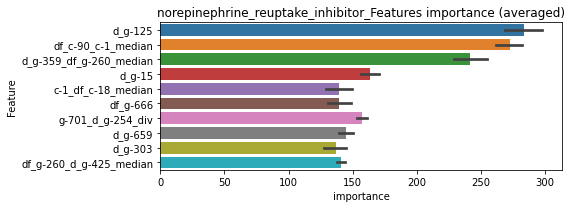

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0484861	valid_1's binary_logloss: 0.0528628
[200]	training's binary_logloss: 0.00836175	valid_1's binary_logloss: 0.0107073
[300]	training's binary_logloss: 0.00192961	valid_1's binary_logloss: 0.00330069
[400]	training's binary_logloss: 0.000703935	valid_1's binary_logloss: 0.00154542
[500]	training's binary_logloss: 0.000384844	valid_1's binary_logloss: 0.000974967
[600]	training's binary_logloss: 0.000270157	valid_1's binary_logloss: 0.000759641
[700]	training's binary_logloss: 0.000228692	valid_1's binary_logloss: 0.000677147
Early stopping, best iteration is:
[745]	training's binary_logloss: 0.000222452	valid_1's binary_logloss: 0.00066888


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0487193	valid_1's binary_logloss: 0.0517126
[200]	training's binary_logloss: 0.00842501	valid_1's binary_logloss: 0.00971549
[300]	training's binary_logloss: 0.0019339	valid_1's binary_logloss: 0.00251124
[400]	training's binary_logloss: 0.000695402	valid_1's binary_logloss: 0.00100979
[500]	training's binary_logloss: 0.00037877	valid_1's binary_logloss: 0.000602314
[600]	training's binary_logloss: 0.00026766	valid_1's binary_logloss: 0.000444319
[700]	training's binary_logloss: 0.000228852	valid_1's binary_logloss: 0.000386655
Early stopping, best iteration is:
[746]	training's binary_logloss: 0.000223513	valid_1's binary_logloss: 0.000378645


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0485635	valid_1's binary_logloss: 0.0505958
[200]	training's binary_logloss: 0.0083372	valid_1's binary_logloss: 0.00901646
[300]	training's binary_logloss: 0.00191573	valid_1's binary_logloss: 0.00217708
[400]	training's binary_logloss: 0.000695183	valid_1's binary_logloss: 0.000821124
[500]	training's binary_logloss: 0.000382699	valid_1's binary_logloss: 0.000461691
[600]	training's binary_logloss: 0.000270746	valid_1's binary_logloss: 0.000332701
[700]	training's binary_logloss: 0.000231151	valid_1's binary_logloss: 0.000285668
[800]	training's binary_logloss: 0.000224672	valid_1's binary_logloss: 0.000277965
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.000224672	valid_1's binary_logloss: 0.000277965


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0486701	valid_1's binary_logloss: 0.0525421
[200]	training's binary_logloss: 0.00841175	valid_1's binary_logloss: 0.0100351
[300]	training's binary_logloss: 0.0019426	valid_1's binary_logloss: 0.00265856
[400]	training's binary_logloss: 0.000703949	valid_1's binary_logloss: 0.00109942
[500]	training's binary_logloss: 0.000387332	valid_1's binary_logloss: 0.000671169
[600]	training's binary_logloss: 0.000270211	valid_1's binary_logloss: 0.000496813
[700]	training's binary_logloss: 0.000230547	valid_1's binary_logloss: 0.000432522


norepinephrine_reuptake_inhibitor logloss: 0.0004375307920063092


Early stopping, best iteration is:
[746]	training's binary_logloss: 0.000225132	valid_1's binary_logloss: 0.00042462


nrf2_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.075975	valid_1's binary_logloss: 0.096427
[200]	training's binary_logloss: 0.0211155	valid_1's binary_logloss: 0.0390679
[300]	training's binary_logloss: 0.00670536	valid_1's binary_logloss: 0.0214893
[400]	training's binary_logloss: 0.00268173	valid_1's binary_logloss: 0.0156108
[500]	training's binary_logloss: 0.00138543	valid_1's binary_logloss: 0.0142262
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00154296	valid_1's binary_logloss: 0.0140972
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0757114	valid_1's binary_logloss: 0.0919524
[200]	training's binary_logloss: 0.0215015	valid_1's binary_logloss: 0.0326651
[300]	training's binary_logloss: 0.00698911	valid_1's binary_logloss: 0.0148151
[400]	training's binary_logloss: 0.00278219	valid_1's binary_logloss: 0.00880585
[500]	training's binary_logloss: 0.00145171	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0063893, Threshold: 0.0294120, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02059, conf_1:0.03824
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0294120
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.0594120
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.0894120
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.1194120
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.1494120
threshold: 0.1494120, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729227	valid_1's binary_logloss: 0.0895513
[200]	training's binary_logloss: 0.0186821	valid_1's binary_logloss: 0.0327028
[300]	training's binary_logloss: 0.00583401	valid_1's binary_logloss: 0.0170572
[400]	training's binary_logloss: 0.00235883	valid_1's binary_logloss: 0.0119277
[500]	training's binary_logloss: 0.00125333	valid_1's binary_logloss: 0.0101721
[600]	training's binary_logloss: 0.000807967	valid_1's binary_logloss: 0.00990698
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000896697	valid_1's binary_logloss: 0.00979509
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729648	valid_1's binary_logloss: 0.0926164
[200]	training's binary_logloss: 0.0188985	valid_1's binary_logloss: 0.0307274
[300]	training's binary_logloss: 0.00590037	valid_1's binary_logloss: 0.0128509
[400]	training's binary_logloss: 0.00237753

2 / 3 AUC score:1.000
y_Threshold: 0.0372784, Threshold: 0.1494120, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.11953, conf_1:0.17929
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.1494120
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.1794120
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.2094120
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.2394120
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.2694120
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_6: 0.2994120
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.3294120
threshold: 0.3294120, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0742259	valid_1's binary_logloss: 0.0881574
[200]	training's binary_logloss: 0.0192876	valid_1's binary_logloss: 0.0288117
[300]	training's binary_logloss: 0.00599788	valid_1's binary_logloss: 0.0123004
[400]	training's binary_logloss: 0.00241721	valid_1's binary_logloss: 0.00711565
[500]	training's binary_logloss: 0.00126702	valid_1's binary_logloss: 0.0051724
[600]	training's binary_logloss: 0.000816106	valid_1's binary_logloss: 0.00443358
[700]	training's binary_logloss: 0.000594828	valid_1's binary_logloss: 0.00399581
[800]	training's binary_logloss: 0.000480471	valid_1's binary_logloss: 0.00379748
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000476178	valid_1's binary_logloss: 0.00377732
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07304	valid_1's binary_logloss: 0.0920365
[200]	training's binary_logloss: 0.0188

3 / 3 AUC score:1.000
y_Threshold: 0.0805881, Threshold: 0.3294120, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.29647, conf_1:0.36235
threshold: 0.3294120, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3810, y_label_rate: 0.1721785


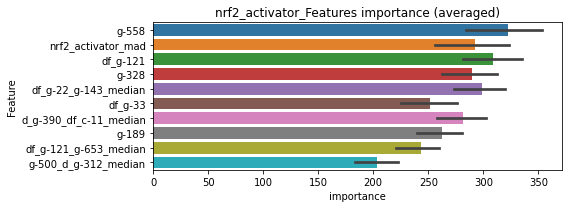

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 nrf2_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0740441	valid_1's binary_logloss: 0.0886637
[200]	training's binary_logloss: 0.0195236	valid_1's binary_logloss: 0.0294913
[300]	training's binary_logloss: 0.00612968	valid_1's binary_logloss: 0.0128739
[400]	training's binary_logloss: 0.00244962	valid_1's binary_logloss: 0.00751583
[500]	training's binary_logloss: 0.00127846	valid_1's binary_logloss: 0.00555832
[600]	training's binary_logloss: 0.000823204	valid_1's binary_logloss: 0.00468
[700]	training's binary_logloss: 0.000603002	valid_1's binary_logloss: 0.00425124
[800]	training's binary_logloss: 0.000484165	valid_1's binary_logloss: 0.00402229
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.000444847	valid_1's binary_logloss: 0.00395411


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 nrf2_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720714	valid_1's binary_logloss: 0.0907497
[200]	training's binary_logloss: 0.0185466	valid_1's binary_logloss: 0.0341736
[300]	training's binary_logloss: 0.00577893	valid_1's binary_logloss: 0.0163344
[400]	training's binary_logloss: 0.00233368	valid_1's binary_logloss: 0.00974299
[500]	training's binary_logloss: 0.00121968	valid_1's binary_logloss: 0.00688636
[600]	training's binary_logloss: 0.000787003	valid_1's binary_logloss: 0.00552168
[700]	training's binary_logloss: 0.000578375	valid_1's binary_logloss: 0.00485223
[800]	training's binary_logloss: 0.000466564	valid_1's binary_logloss: 0.00440274
[900]	training's binary_logloss: 0.000419835	valid_1's binary_logloss: 0.004214
[1000]	training's binary_logloss: 0.000408685	valid_1's binary_logloss: 0.00416918
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.000408685	valid_1's binary_logloss: 0.00416918


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 nrf2_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0738474	valid_1's binary_logloss: 0.0851266
[200]	training's binary_logloss: 0.0189276	valid_1's binary_logloss: 0.0261411
[300]	training's binary_logloss: 0.005972	valid_1's binary_logloss: 0.0103741
[400]	training's binary_logloss: 0.00243155	valid_1's binary_logloss: 0.00509277
[500]	training's binary_logloss: 0.00126479	valid_1's binary_logloss: 0.00308618
[600]	training's binary_logloss: 0.000815984	valid_1's binary_logloss: 0.00225959
[700]	training's binary_logloss: 0.000600408	valid_1's binary_logloss: 0.00176177
[800]	training's binary_logloss: 0.00048243	valid_1's binary_logloss: 0.00148281
[900]	training's binary_logloss: 0.000432967	valid_1's binary_logloss: 0.00137382
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000420074	valid_1's binary_logloss: 0.00135447


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 nrf2_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729733	valid_1's binary_logloss: 0.092751
[200]	training's binary_logloss: 0.0186518	valid_1's binary_logloss: 0.0327043
[300]	training's binary_logloss: 0.00581257	valid_1's binary_logloss: 0.0162197
[400]	training's binary_logloss: 0.00236255	valid_1's binary_logloss: 0.0106955
[500]	training's binary_logloss: 0.00123877	valid_1's binary_logloss: 0.00836815
[600]	training's binary_logloss: 0.00079902	valid_1's binary_logloss: 0.00713592
[700]	training's binary_logloss: 0.000587825	valid_1's binary_logloss: 0.00655111
[800]	training's binary_logloss: 0.000473963	valid_1's binary_logloss: 0.00622805
Early stopping, best iteration is:
[859]	training's binary_logloss: 0.000443912	valid_1's binary_logloss: 0.006092


nrf2_activator logloss: 0.003892526392858308


neg labels: 3289 → selected neg labels: 3280


opioid_receptor_agonist, len(trt): 61, len(othr): 3280, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113313	valid_1's binary_logloss: 0.175091
[200]	training's binary_logloss: 0.0454381	valid_1's binary_logloss: 0.107118
[300]	training's binary_logloss: 0.0214402	valid_1's binary_logloss: 0.0777652
[400]	training's binary_logloss: 0.0103898	valid_1's binary_logloss: 0.0601323
[500]	training's binary_logloss: 0.0053966	valid_1's binary_logloss: 0.0503215
[600]	training's binary_logloss: 0.00316477	valid_1's binary_logloss: 0.0446638
[700]	training's binary_logloss: 0.00210032	valid_1's binary_logloss: 0.0422526
[800]	training's binary_logloss: 0.00154604	valid_1's binary_logloss: 0.0401029
Early stopping, best iteration is:
[832]	training's binary_logloss: 0.00142567	valid_1's binary_logloss: 0.0394645
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118787	valid_1's binary_logloss: 0.167992
[200]	training's binary_logloss: 0.0486738	valid_1's b

1 / 3 AUC score:0.998
y_Threshold: 0.0182529, Threshold: 0.0746352, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3798
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.05224, conf_1:0.09703
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.0746352
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_2: 0.1046352
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_3: 0.1346352
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_4: 0.1646352
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_5: 0.1946352
threshold: 0.1946352, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112784	valid_1's binary_logloss: 0.159445
[200]	training's binary_logloss: 0.0422391	valid_1's binary_logloss: 0.0850181
[300]	training's binary_logloss: 0.0187146	valid_1's binary_logloss: 0.0546604
[400]	training's binary_logloss: 0.00885191	valid_1's binary_logloss: 0.038793
[500]	training's binary_logloss: 0.00462468	valid_1's binary_logloss: 0.0310292
[600]	training's binary_logloss: 0.00275683	valid_1's binary_logloss: 0.026462
[700]	training's binary_logloss: 0.00185294	valid_1's binary_logloss: 0.02428
[800]	training's binary_logloss: 0.00138761	valid_1's binary_logloss: 0.022827
[900]	training's binary_logloss: 0.00111536	valid_1's binary_logloss: 0.0221395
[1000]	training's binary_logloss: 0.000962324	valid_1's binary_logloss: 0.0216108
Early stopping, best iteration is:
[1001]	training's binary_logloss: 0.000961074	valid_1's binary_logloss: 0.021609
Training until validation score

2 / 3 AUC score:1.000
y_Threshold: 0.0893532, Threshold: 0.1946352, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0123054 Vs.target_rate: 0.00256, Num_p_label: 49.0, conf_0:0.15571, conf_1:0.23356
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_1: 0.1946352
Num_p_label: 45.0, Expected: 10.2, Adj_threshold_2: 0.2246352
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_3: 0.2546352
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_4: 0.2846352
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_5: 0.3146352
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_6: 0.3446352
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_7: 0.3746352
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_8: 0.4046352
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_9: 0.4346352
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_10: 0.4646352
threshold: 0.4946352, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 646.0/3784, y_label_rate: 0.1707188

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10874	valid_1's binary_logloss: 0.164283
[200]	training's binary_logloss: 0.0394464	valid_1's binary_logloss: 0.0902905
[300]	training's binary_logloss: 0.0168291	valid_1's binary_logloss: 0.0608245
[400]	training's binary_logloss: 0.00774801	valid_1's binary_logloss: 0.0454217
[500]	training's binary_logloss: 0.00404359	valid_1's binary_logloss: 0.037248
[600]	training's binary_logloss: 0.00246284	valid_1's binary_logloss: 0.0331481
[700]	training's binary_logloss: 0.00169544	valid_1's binary_logloss: 0.0307907
[800]	training's binary_logloss: 0.00129025	valid_1's binary_logloss: 0.0288659
[900]	training's binary_logloss: 0.00104903	valid_1's binary_logloss: 0.0280838
[1000]	training's binary_logloss: 0.000908686	valid_1's binary_logloss: 0.0273837
[1100]	training's binary_logloss: 0.000837387	valid_1's binary_logloss: 0.02703
Early stopping, best iteration is:
[1143]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.0806946, Threshold: 0.4946352, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 639.0/3770
p_label_rate: 0.0055249 Vs.target_rate: 0.00256, Num_p_label: 22.0, conf_0:0.44517, conf_1:0.54410
threshold: 0.4946352, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 639.0/3770, y_label_rate: 0.1694960


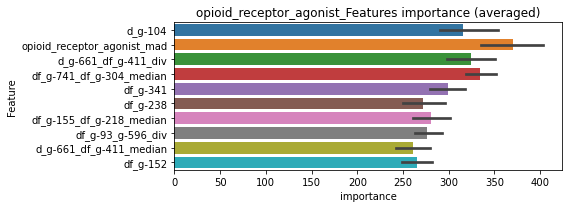

len(train_index) : 2827
len(valid_index) : 943
================================= fold 1/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110994	valid_1's binary_logloss: 0.159255
[200]	training's binary_logloss: 0.0394562	valid_1's binary_logloss: 0.0919297
[300]	training's binary_logloss: 0.0164819	valid_1's binary_logloss: 0.0665021
[400]	training's binary_logloss: 0.00786512	valid_1's binary_logloss: 0.0549318
[500]	training's binary_logloss: 0.00410957	valid_1's binary_logloss: 0.047619
[600]	training's binary_logloss: 0.00245247	valid_1's binary_logloss: 0.0443422
[700]	training's binary_logloss: 0.00168011	valid_1's binary_logloss: 0.0425089
[800]	training's binary_logloss: 0.00126843	valid_1's binary_logloss: 0.0415501
[900]	training's binary_logloss: 0.00102837	valid_1's binary_logloss: 0.0408197
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00101865	valid_1's binary_logloss: 0.0407656


len(train_index) : 2827
len(valid_index) : 943
================================= fold 2/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107028	valid_1's binary_logloss: 0.158577
[200]	training's binary_logloss: 0.0375607	valid_1's binary_logloss: 0.0868856
[300]	training's binary_logloss: 0.0157591	valid_1's binary_logloss: 0.0586573
[400]	training's binary_logloss: 0.00741677	valid_1's binary_logloss: 0.0447892
[500]	training's binary_logloss: 0.00388367	valid_1's binary_logloss: 0.0371426
[600]	training's binary_logloss: 0.0023587	valid_1's binary_logloss: 0.0341019
[700]	training's binary_logloss: 0.00163586	valid_1's binary_logloss: 0.0318545
[800]	training's binary_logloss: 0.00124292	valid_1's binary_logloss: 0.0308308
[900]	training's binary_logloss: 0.00101544	valid_1's binary_logloss: 0.0303421
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.000929459	valid_1's binary_logloss: 0.030066


len(train_index) : 2828
len(valid_index) : 942
================================= fold 3/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110064	valid_1's binary_logloss: 0.154755
[200]	training's binary_logloss: 0.0414377	valid_1's binary_logloss: 0.0839168
[300]	training's binary_logloss: 0.0175255	valid_1's binary_logloss: 0.0537149
[400]	training's binary_logloss: 0.0082357	valid_1's binary_logloss: 0.0391465
[500]	training's binary_logloss: 0.00434054	valid_1's binary_logloss: 0.0308778
[600]	training's binary_logloss: 0.00258141	valid_1's binary_logloss: 0.0257421
[700]	training's binary_logloss: 0.00174566	valid_1's binary_logloss: 0.0230735
[800]	training's binary_logloss: 0.00130117	valid_1's binary_logloss: 0.0214539
[900]	training's binary_logloss: 0.00105414	valid_1's binary_logloss: 0.0202206
[1000]	training's binary_logloss: 0.000907552	valid_1's binary_logloss: 0.0195895
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.000884127	valid_1's binary_logloss: 0.0194999


len(train_index) : 2828
len(valid_index) : 942
================================= fold 4/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10664	valid_1's binary_logloss: 0.169436
[200]	training's binary_logloss: 0.0394975	valid_1's binary_logloss: 0.0993125
[300]	training's binary_logloss: 0.0169927	valid_1's binary_logloss: 0.0703792
[400]	training's binary_logloss: 0.00770514	valid_1's binary_logloss: 0.0543415
[500]	training's binary_logloss: 0.00411132	valid_1's binary_logloss: 0.0470555
[600]	training's binary_logloss: 0.00247995	valid_1's binary_logloss: 0.0423573
[700]	training's binary_logloss: 0.00169077	valid_1's binary_logloss: 0.0400084
[800]	training's binary_logloss: 0.00127334	valid_1's binary_logloss: 0.0383992
[900]	training's binary_logloss: 0.00103009	valid_1's binary_logloss: 0.0372721
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.000977507	valid_1's binary_logloss: 0.0370216


opioid_receptor_agonist logloss: 0.03184019642115042
opioid_receptor_antagonist, len(trt): 96, len(othr): 3274, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145386	valid_1's binary_logloss: 0.221989
[200]	training's binary_logloss: 0.0676664	valid_1's binary_logloss: 0.163871
[300]	training's binary_logloss: 0.0333276	valid_1's binary_logloss: 0.136785
[400]	training's binary_logloss: 0.0173944	valid_1's binary_logloss: 0.124493
[500]	training's binary_logloss: 0.00957205	valid_1's binary_logloss: 0.119024
[600]	training's binary_logloss: 0.00562242	valid_1's binary_logloss: 0.117552
[700]	training's binary_logloss: 0.00360551	valid_1's binary_logloss: 0.117111
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00397022	valid_1's binary_logloss: 0.116405
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.150114	valid_1's binary_logloss: 0.210149
[200]	training's binary_logloss: 0.0713858	valid_1's binary_logloss: 0.139263
[300]	training's binary_logloss: 0.0370593	valid_1's binary_l

1 / 3 AUC score:0.984
y_Threshold: 0.0478887, Threshold: 0.1979968, pos_neg_ratio: 0.8000000
Remove_noisy_data: 194 → Positive_corect_labels: 623/3734
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.13860, conf_1:0.25740
threshold: 0.1979968, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 623.0/3734, y_label_rate: 0.1668452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124863	valid_1's binary_logloss: 0.197405
[200]	training's binary_logloss: 0.050264	valid_1's binary_logloss: 0.132254
[300]	training's binary_logloss: 0.0233179	valid_1's binary_logloss: 0.105
[400]	training's binary_logloss: 0.011406	valid_1's binary_logloss: 0.0928803
[500]	training's binary_logloss: 0.00604313	valid_1's binary_logloss: 0.0856933
[600]	training's binary_logloss: 0.00359977	valid_1's binary_logloss: 0.0820113
[700]	training's binary_logloss: 0.00240971	valid_1's binary_logloss: 0.0809812
Early stopping, best iteration is:
[712]	training's binary_logloss: 0.00231427	valid_1's binary_logloss: 0.0808237
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129602	valid_1's binary_logloss: 0.197353
[200]	training's binary_logloss: 0.0536418	valid_1's binary_logloss: 0.130937
[300]	training's binary_logloss: 0.0244617	valid_1's binary_l

2 / 3 AUC score:0.991
y_Threshold: 0.1186082, Threshold: 0.1979968, pos_neg_ratio: 0.8000000
Remove_noisy_data: 70 → Positive_corect_labels: 588.0/3664
p_label_rate: 0.0261175 Vs.target_rate: 0.00403, Num_p_label: 104.0, conf_0:0.15840, conf_1:0.23760
Num_p_label: 104.0, Expected: 16.1, Adj_threshold_1: 0.1979968
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_2: 0.2279968
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_3: 0.2579968
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_4: 0.2879968
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_5: 0.3179968
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_6: 0.3479968
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_7: 0.3779968
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_8: 0.4079968
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_9: 0.4379968
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_10: 0.4679968
threshold: 0.4979968, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 588.0/3664, y_label_rate: 0.16048

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112578	valid_1's binary_logloss: 0.168475
[200]	training's binary_logloss: 0.0438747	valid_1's binary_logloss: 0.10339
[300]	training's binary_logloss: 0.0197509	valid_1's binary_logloss: 0.076162
[400]	training's binary_logloss: 0.0093268	valid_1's binary_logloss: 0.0628868
[500]	training's binary_logloss: 0.0048887	valid_1's binary_logloss: 0.0579353
[600]	training's binary_logloss: 0.00293504	valid_1's binary_logloss: 0.0536821
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00241095	valid_1's binary_logloss: 0.0533227
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112972	valid_1's binary_logloss: 0.17569
[200]	training's binary_logloss: 0.0443765	valid_1's binary_logloss: 0.110331
[300]	training's binary_logloss: 0.0193509	valid_1's binary_logloss: 0.084584
[400]	training's binary_logloss: 0.00930981	valid_1's binary_

3 / 3 AUC score:0.997
y_Threshold: 0.1090409, Threshold: 0.4979968, pos_neg_ratio: 0.8000000
Remove_noisy_data: 40 → Positive_corect_labels: 568.0/3624
p_label_rate: 0.0158212 Vs.target_rate: 0.00403, Num_p_label: 63.0, conf_0:0.44820, conf_1:0.54780
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_1: 0.4979968
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_2: 0.5279968
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_3: 0.5579968
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_4: 0.5879968
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_5: 0.6179968
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_6: 0.6479968
Num_p_label: 44.0, Expected: 16.1, Adj_threshold_7: 0.6779968
threshold: 0.6779968, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 568.0/3624, y_label_rate: 0.1567329


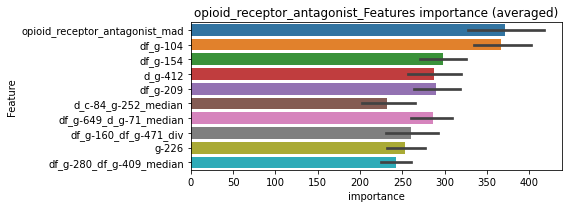

len(train_index) : 2718
len(valid_index) : 906
================================= fold 1/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108789	valid_1's binary_logloss: 0.157071
[200]	training's binary_logloss: 0.0388601	valid_1's binary_logloss: 0.090082
[300]	training's binary_logloss: 0.0166349	valid_1's binary_logloss: 0.0622617
[400]	training's binary_logloss: 0.0078786	valid_1's binary_logloss: 0.0490685
[500]	training's binary_logloss: 0.0040001	valid_1's binary_logloss: 0.0415627
[600]	training's binary_logloss: 0.00241577	valid_1's binary_logloss: 0.0374997
[700]	training's binary_logloss: 0.00167105	valid_1's binary_logloss: 0.0354751
[800]	training's binary_logloss: 0.00127682	valid_1's binary_logloss: 0.0340811
[900]	training's binary_logloss: 0.00103538	valid_1's binary_logloss: 0.0327172
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.0010334	valid_1's binary_logloss: 0.0327


len(train_index) : 2718
len(valid_index) : 906
================================= fold 2/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108733	valid_1's binary_logloss: 0.158417
[200]	training's binary_logloss: 0.0397841	valid_1's binary_logloss: 0.0884156
[300]	training's binary_logloss: 0.0164273	valid_1's binary_logloss: 0.0596589
[400]	training's binary_logloss: 0.00767597	valid_1's binary_logloss: 0.0460789
[500]	training's binary_logloss: 0.00406945	valid_1's binary_logloss: 0.0383701
[600]	training's binary_logloss: 0.00248198	valid_1's binary_logloss: 0.0350327
[700]	training's binary_logloss: 0.00171471	valid_1's binary_logloss: 0.0325514
[800]	training's binary_logloss: 0.00130064	valid_1's binary_logloss: 0.0314121
[900]	training's binary_logloss: 0.0010584	valid_1's binary_logloss: 0.0306862
[1000]	training's binary_logloss: 0.000906019	valid_1's binary_logloss: 0.030202
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.000874607	valid_1's binary_logloss: 0.0300906


len(train_index) : 2718
len(valid_index) : 906
================================= fold 3/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108378	valid_1's binary_logloss: 0.155385
[200]	training's binary_logloss: 0.0408699	valid_1's binary_logloss: 0.0863813
[300]	training's binary_logloss: 0.0172013	valid_1's binary_logloss: 0.0583581
[400]	training's binary_logloss: 0.00805118	valid_1's binary_logloss: 0.044757
[500]	training's binary_logloss: 0.0042696	valid_1's binary_logloss: 0.0371702
[600]	training's binary_logloss: 0.00257173	valid_1's binary_logloss: 0.0332898
[700]	training's binary_logloss: 0.00176358	valid_1's binary_logloss: 0.0309154
[800]	training's binary_logloss: 0.00133535	valid_1's binary_logloss: 0.0297277
[900]	training's binary_logloss: 0.00108255	valid_1's binary_logloss: 0.0288494
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.000992865	valid_1's binary_logloss: 0.0283432


len(train_index) : 2718
len(valid_index) : 906
================================= fold 4/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104515	valid_1's binary_logloss: 0.16102
[200]	training's binary_logloss: 0.0387179	valid_1's binary_logloss: 0.0901746
[300]	training's binary_logloss: 0.0169992	valid_1's binary_logloss: 0.0619739
[400]	training's binary_logloss: 0.00837586	valid_1's binary_logloss: 0.0476835
[500]	training's binary_logloss: 0.00435564	valid_1's binary_logloss: 0.0397697
[600]	training's binary_logloss: 0.00257308	valid_1's binary_logloss: 0.0357527
[700]	training's binary_logloss: 0.00174681	valid_1's binary_logloss: 0.033527
[800]	training's binary_logloss: 0.00132022	valid_1's binary_logloss: 0.0321424
[900]	training's binary_logloss: 0.00106964	valid_1's binary_logloss: 0.0311751
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.0010301	valid_1's binary_logloss: 0.031059


opioid_receptor_antagonist logloss: 0.030548175993838352
orexin_receptor_antagonist, len(trt): 37, len(othr): 3286, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0974931	valid_1's binary_logloss: 0.143307
[200]	training's binary_logloss: 0.0344455	valid_1's binary_logloss: 0.0732429
[300]	training's binary_logloss: 0.0134551	valid_1's binary_logloss: 0.0448705
[400]	training's binary_logloss: 0.00575426	valid_1's binary_logloss: 0.0304719
[500]	training's binary_logloss: 0.002842	valid_1's binary_logloss: 0.0234011
[600]	training's binary_logloss: 0.00171226	valid_1's binary_logloss: 0.0196858
[700]	training's binary_logloss: 0.0011846	valid_1's binary_logloss: 0.0177944
[800]	training's binary_logloss: 0.000907812	valid_1's binary_logloss: 0.0166735
[900]	training's binary_logloss: 0.000743293	valid_1's binary_logloss: 0.0162448
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.000682493	valid_1's binary_logloss: 0.0160577
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096572	valid

1 / 3 AUC score:0.999
y_Threshold: 0.0129874, Threshold: 0.0864763, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.06053, conf_1:0.11242
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0864763
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_2: 0.1164763
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_3: 0.1464763
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_4: 0.1764763
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.2064763
threshold: 0.2064763, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0923933	valid_1's binary_logloss: 0.134479
[200]	training's binary_logloss: 0.0289863	valid_1's binary_logloss: 0.061798
[300]	training's binary_logloss: 0.0104277	valid_1's binary_logloss: 0.0344973
[400]	training's binary_logloss: 0.0043538	valid_1's binary_logloss: 0.0228703
[500]	training's binary_logloss: 0.00224147	valid_1's binary_logloss: 0.0178741
[600]	training's binary_logloss: 0.00139767	valid_1's binary_logloss: 0.0154054
[700]	training's binary_logloss: 0.000985328	valid_1's binary_logloss: 0.0144696
[800]	training's binary_logloss: 0.000767916	valid_1's binary_logloss: 0.0134757
[900]	training's binary_logloss: 0.000643349	valid_1's binary_logloss: 0.0130674
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.000610632	valid_1's binary_logloss: 0.0130294
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0917442	va

2 / 3 AUC score:1.000
y_Threshold: 0.0796392, Threshold: 0.2064763, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 649.0/3795
p_label_rate: 0.0130588 Vs.target_rate: 0.00155, Num_p_label: 52.0, conf_0:0.16518, conf_1:0.24777
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_1: 0.2064763
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_2: 0.2364763
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_3: 0.2664763
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_4: 0.2964763
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_5: 0.3264763
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_6: 0.3564763
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_7: 0.3864763
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_8: 0.4164763
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_9: 0.4464763
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_10: 0.4764763
threshold: 0.4764763, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3795, y_label_rate: 0.1710145
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0916818	valid_1's binary_logloss: 0.130004
[200]	training's binary_logloss: 0.0296018	valid_1's binary_logloss: 0.0566645
[300]	training's binary_logloss: 0.0106161	valid_1's binary_logloss: 0.0291045
[400]	training's binary_logloss: 0.00437324	valid_1's binary_logloss: 0.0171976
[500]	training's binary_logloss: 0.00224505	valid_1's binary_logloss: 0.0120401
[600]	training's binary_logloss: 0.00137866	valid_1's binary_logloss: 0.00954679
[700]	training's binary_logloss: 0.000981485	valid_1's binary_logloss: 0.00832854
[800]	training's binary_logloss: 0.000762984	valid_1's binary_logloss: 0.00731147
[900]	training's binary_logloss: 0.000638512	valid_1's binary_logloss: 0.00690657
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.00061868	valid_1's binary_logloss: 0.00682546
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0901

3 / 3 AUC score:1.000
y_Threshold: 0.0850470, Threshold: 0.4764763, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 645.0/3787
p_label_rate: 0.0047715 Vs.target_rate: 0.00155, Num_p_label: 19.0, conf_0:0.42883, conf_1:0.52412
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_1: 0.4764763
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.5064763
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_3: 0.5364763
threshold: 0.5364763, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 645.0/3787, y_label_rate: 0.1703195


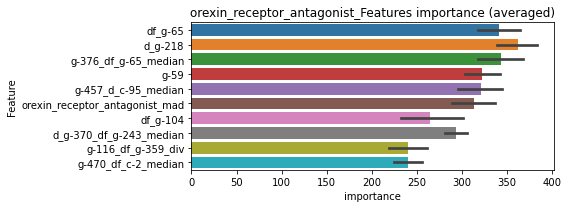

len(train_index) : 2840
len(valid_index) : 947
================================= fold 1/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0890836	valid_1's binary_logloss: 0.123839
[200]	training's binary_logloss: 0.0281425	valid_1's binary_logloss: 0.0555103
[300]	training's binary_logloss: 0.0102367	valid_1's binary_logloss: 0.0301122
[400]	training's binary_logloss: 0.00428885	valid_1's binary_logloss: 0.0188065
[500]	training's binary_logloss: 0.00218185	valid_1's binary_logloss: 0.0138471
[600]	training's binary_logloss: 0.00134992	valid_1's binary_logloss: 0.0114967
[700]	training's binary_logloss: 0.000953792	valid_1's binary_logloss: 0.0101181
[800]	training's binary_logloss: 0.000750058	valid_1's binary_logloss: 0.00929793
[900]	training's binary_logloss: 0.000626826	valid_1's binary_logloss: 0.00870239
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.000622662	valid_1's binary_logloss: 0.0086717


len(train_index) : 2840
len(valid_index) : 947
================================= fold 2/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0908082	valid_1's binary_logloss: 0.124434
[200]	training's binary_logloss: 0.0285438	valid_1's binary_logloss: 0.0558404
[300]	training's binary_logloss: 0.0103266	valid_1's binary_logloss: 0.0308588
[400]	training's binary_logloss: 0.00430896	valid_1's binary_logloss: 0.0210858
[500]	training's binary_logloss: 0.00217312	valid_1's binary_logloss: 0.0165555
[600]	training's binary_logloss: 0.00133042	valid_1's binary_logloss: 0.0146666
[700]	training's binary_logloss: 0.000944119	valid_1's binary_logloss: 0.0137866
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.000811365	valid_1's binary_logloss: 0.0135031


len(train_index) : 2840
len(valid_index) : 947
================================= fold 3/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0920206	valid_1's binary_logloss: 0.116952
[200]	training's binary_logloss: 0.0287466	valid_1's binary_logloss: 0.0494796
[300]	training's binary_logloss: 0.0106543	valid_1's binary_logloss: 0.0267053
[400]	training's binary_logloss: 0.0044371	valid_1's binary_logloss: 0.0170421
[500]	training's binary_logloss: 0.00222696	valid_1's binary_logloss: 0.0126269
[600]	training's binary_logloss: 0.00135841	valid_1's binary_logloss: 0.0105125
[700]	training's binary_logloss: 0.00096403	valid_1's binary_logloss: 0.0092103
[800]	training's binary_logloss: 0.000756512	valid_1's binary_logloss: 0.00854533
[900]	training's binary_logloss: 0.000636565	valid_1's binary_logloss: 0.00815444
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000633455	valid_1's binary_logloss: 0.00812589


len(train_index) : 2841
len(valid_index) : 946
================================= fold 4/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0898972	valid_1's binary_logloss: 0.130075
[200]	training's binary_logloss: 0.0279096	valid_1's binary_logloss: 0.0608267
[300]	training's binary_logloss: 0.0105171	valid_1's binary_logloss: 0.0353908
[400]	training's binary_logloss: 0.00440198	valid_1's binary_logloss: 0.0239849
[500]	training's binary_logloss: 0.00224733	valid_1's binary_logloss: 0.0185617
[600]	training's binary_logloss: 0.00137244	valid_1's binary_logloss: 0.0158508
[700]	training's binary_logloss: 0.000972574	valid_1's binary_logloss: 0.0145081
[800]	training's binary_logloss: 0.000756484	valid_1's binary_logloss: 0.0137068
[900]	training's binary_logloss: 0.000633645	valid_1's binary_logloss: 0.0132331
[1000]	training's binary_logloss: 0.000570033	valid_1's binary_logloss: 0.0128511
Early stopping, best iteration is:
[1016]	training's binary_logloss: 0.000563608	valid_1's binary_logloss: 0.0127734


orexin_receptor_antagonist logloss: 0.010767998818897152
p38_mapk_inhibitor, len(trt): 62, len(othr): 3281, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131321	valid_1's binary_logloss: 0.188647
[200]	training's binary_logloss: 0.0586557	valid_1's binary_logloss: 0.117339
[300]	training's binary_logloss: 0.0289269	valid_1's binary_logloss: 0.0848072
[400]	training's binary_logloss: 0.0146311	valid_1's binary_logloss: 0.0660869
[500]	training's binary_logloss: 0.00764391	valid_1's binary_logloss: 0.0543993
[600]	training's binary_logloss: 0.00433824	valid_1's binary_logloss: 0.0479788
[700]	training's binary_logloss: 0.00277356	valid_1's binary_logloss: 0.0444429
[800]	training's binary_logloss: 0.00196722	valid_1's binary_logloss: 0.041889
[900]	training's binary_logloss: 0.00152049	valid_1's binary_logloss: 0.0405791
[1000]	training's binary_logloss: 0.00124393	valid_1's binary_logloss: 0.0397324
[1100]	training's binary_logloss: 0.00108345	valid_1's binary_logloss: 0.0391776
Early stopping, best iteration is:
[1110]	training's binary_loglo

1 / 3 AUC score:0.997
y_Threshold: 0.0269973, Threshold: 0.2052825, pos_neg_ratio: 0.8000000
Remove_noisy_data: 146 → Positive_corect_labels: 649/3791
p_label_rate: 0.0100452 Vs.target_rate: 0.00260, Num_p_label: 40.0, conf_0:0.14370, conf_1:0.26687
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_1: 0.2052825
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_2: 0.2352825
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_3: 0.2652825
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_4: 0.2952825
Num_p_label: 19.0, Expected: 10.4, Adj_threshold_5: 0.3252825
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_6: 0.3552825
threshold: 0.3552825, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122495	valid_1's binary_logloss: 0.174797
[200]	training's binary_logloss: 0.0503367	valid_1's binary_logloss: 0.101887
[300]	training's binary_logloss: 0.0226233	valid_1's binary_logloss: 0.0691699
[400]	training's binary_logloss: 0.0111424	valid_1's binary_logloss: 0.0524521
[500]	training's binary_logloss: 0.00573818	valid_1's binary_logloss: 0.0418573
[600]	training's binary_logloss: 0.00333589	valid_1's binary_logloss: 0.0359275
[700]	training's binary_logloss: 0.00219526	valid_1's binary_logloss: 0.0330964
[800]	training's binary_logloss: 0.0015937	valid_1's binary_logloss: 0.0303988
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.00145427	valid_1's binary_logloss: 0.0300652
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123418	valid_1's binary_logloss: 0.188615
[200]	training's binary_logloss: 0.0496637	valid_1's b

2 / 3 AUC score:0.999
y_Threshold: 0.1149993, Threshold: 0.3552825, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 640.0/3773
p_label_rate: 0.0123054 Vs.target_rate: 0.00260, Num_p_label: 49.0, conf_0:0.28423, conf_1:0.42634
Num_p_label: 49.0, Expected: 10.4, Adj_threshold_1: 0.3552825
Num_p_label: 43.0, Expected: 10.4, Adj_threshold_2: 0.3852825
Num_p_label: 41.0, Expected: 10.4, Adj_threshold_3: 0.4152825
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_4: 0.4452825
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_5: 0.4752825
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_6: 0.5052825
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_7: 0.5352825
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_8: 0.5652825
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_9: 0.5952825
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_10: 0.6252825
threshold: 0.6552825, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 640.0/3773, y_label_rate: 0.1696263

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120735	valid_1's binary_logloss: 0.174154
[200]	training's binary_logloss: 0.0481224	valid_1's binary_logloss: 0.104135
[300]	training's binary_logloss: 0.0214121	valid_1's binary_logloss: 0.0754328
[400]	training's binary_logloss: 0.0103673	valid_1's binary_logloss: 0.060624
[500]	training's binary_logloss: 0.00537902	valid_1's binary_logloss: 0.0538516
[600]	training's binary_logloss: 0.00315923	valid_1's binary_logloss: 0.0496566
[700]	training's binary_logloss: 0.00208218	valid_1's binary_logloss: 0.0476647
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.00228969	valid_1's binary_logloss: 0.0474942
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119875	valid_1's binary_logloss: 0.170963
[200]	training's binary_logloss: 0.0488833	valid_1's binary_logloss: 0.0981119
[300]	training's binary_logloss: 0.0225793	valid_1's bi

3 / 3 AUC score:0.998
y_Threshold: 0.0795641, Threshold: 0.6552825, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 627.0/3747
p_label_rate: 0.0047715 Vs.target_rate: 0.00260, Num_p_label: 19.0, conf_0:0.50000, conf_1:0.72081
threshold: 0.6552825, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 627.0/3747, y_label_rate: 0.1673339


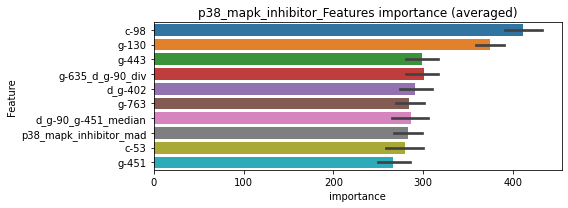

len(train_index) : 2810
len(valid_index) : 937
================================= fold 1/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118789	valid_1's binary_logloss: 0.165989
[200]	training's binary_logloss: 0.0454055	valid_1's binary_logloss: 0.093236
[300]	training's binary_logloss: 0.0199715	valid_1's binary_logloss: 0.0637421
[400]	training's binary_logloss: 0.00918832	valid_1's binary_logloss: 0.0457717
[500]	training's binary_logloss: 0.00475452	valid_1's binary_logloss: 0.0369897
[600]	training's binary_logloss: 0.0027988	valid_1's binary_logloss: 0.0312708
[700]	training's binary_logloss: 0.00188676	valid_1's binary_logloss: 0.0282427
[800]	training's binary_logloss: 0.00139579	valid_1's binary_logloss: 0.0268226
[900]	training's binary_logloss: 0.00111243	valid_1's binary_logloss: 0.0253086
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.00104139	valid_1's binary_logloss: 0.0250215


len(train_index) : 2810
len(valid_index) : 937
================================= fold 2/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116685	valid_1's binary_logloss: 0.179931
[200]	training's binary_logloss: 0.0458092	valid_1's binary_logloss: 0.109288
[300]	training's binary_logloss: 0.0198879	valid_1's binary_logloss: 0.0774153
[400]	training's binary_logloss: 0.009253	valid_1's binary_logloss: 0.0593704
[500]	training's binary_logloss: 0.00481004	valid_1's binary_logloss: 0.0500057
[600]	training's binary_logloss: 0.00284073	valid_1's binary_logloss: 0.0454709
[700]	training's binary_logloss: 0.00190348	valid_1's binary_logloss: 0.0423397
[800]	training's binary_logloss: 0.00140781	valid_1's binary_logloss: 0.0399765
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.00135263	valid_1's binary_logloss: 0.039735


len(train_index) : 2810
len(valid_index) : 937
================================= fold 3/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120143	valid_1's binary_logloss: 0.167039
[200]	training's binary_logloss: 0.0482395	valid_1's binary_logloss: 0.091511
[300]	training's binary_logloss: 0.0212344	valid_1's binary_logloss: 0.0579713
[400]	training's binary_logloss: 0.00996302	valid_1's binary_logloss: 0.0413413
[500]	training's binary_logloss: 0.00502908	valid_1's binary_logloss: 0.0323917
[600]	training's binary_logloss: 0.00295382	valid_1's binary_logloss: 0.0273655
[700]	training's binary_logloss: 0.00197043	valid_1's binary_logloss: 0.0252156
[800]	training's binary_logloss: 0.00144683	valid_1's binary_logloss: 0.0241403
[900]	training's binary_logloss: 0.00115384	valid_1's binary_logloss: 0.0229621
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.00109711	valid_1's binary_logloss: 0.022837


len(train_index) : 2811
len(valid_index) : 936
================================= fold 4/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119596	valid_1's binary_logloss: 0.176364
[200]	training's binary_logloss: 0.0471382	valid_1's binary_logloss: 0.097188
[300]	training's binary_logloss: 0.0213317	valid_1's binary_logloss: 0.0620002
[400]	training's binary_logloss: 0.0101725	valid_1's binary_logloss: 0.0431905
[500]	training's binary_logloss: 0.00523478	valid_1's binary_logloss: 0.0320338
[600]	training's binary_logloss: 0.00306165	valid_1's binary_logloss: 0.0263951
[700]	training's binary_logloss: 0.00204264	valid_1's binary_logloss: 0.02269
[800]	training's binary_logloss: 0.00149872	valid_1's binary_logloss: 0.0208511
[900]	training's binary_logloss: 0.00118067	valid_1's binary_logloss: 0.0194419
[1000]	training's binary_logloss: 0.000996998	valid_1's binary_logloss: 0.0185034
[1100]	training's binary_logloss: 0.000898729	valid_1's binary_logloss: 0.0178851
Early stopping, best iteration is:
[1151]	training's binary_logl

p38_mapk_inhibitor logloss: 0.026305214893293693
p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3288, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0825739	valid_1's binary_logloss: 0.11436
[200]	training's binary_logloss: 0.025979	valid_1's binary_logloss: 0.0550576
[300]	training's binary_logloss: 0.00949086	valid_1's binary_logloss: 0.0336732
[400]	training's binary_logloss: 0.00381309	valid_1's binary_logloss: 0.0250648
[500]	training's binary_logloss: 0.00189249	valid_1's binary_logloss: 0.0218906
[600]	training's binary_logloss: 0.0011671	valid_1's binary_logloss: 0.0196817
[700]	training's binary_logloss: 0.000824998	valid_1's binary_logloss: 0.0189531
[800]	training's binary_logloss: 0.000656006	valid_1's binary_logloss: 0.0184049
Early stopping, best iteration is:
[818]	training's binary_logloss: 0.000634792	valid_1's binary_logloss: 0.0182554
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0844472	valid_1's binary_logloss: 0.100565
[200]	training's binary_logloss: 0.0282177	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0086716, Threshold: 0.0546194, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.03823, conf_1:0.07101
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0546194
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_2: 0.0846194
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_3: 0.1146194
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.1446194
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_5: 0.1746194
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.2046194
threshold: 0.2046194, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0797558	valid_1's binary_logloss: 0.101239
[200]	training's binary_logloss: 0.022563	valid_1's binary_logloss: 0.0382411
[300]	training's binary_logloss: 0.00755332	valid_1's binary_logloss: 0.0183881
[400]	training's binary_logloss: 0.00303862	valid_1's binary_logloss: 0.0114227
[500]	training's binary_logloss: 0.00156768	valid_1's binary_logloss: 0.00865567
[600]	training's binary_logloss: 0.00099351	valid_1's binary_logloss: 0.00746871
[700]	training's binary_logloss: 0.000720198	valid_1's binary_logloss: 0.00691457
[800]	training's binary_logloss: 0.000571138	valid_1's binary_logloss: 0.00645388
[900]	training's binary_logloss: 0.000505806	valid_1's binary_logloss: 0.00632252
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.000513273	valid_1's binary_logloss: 0.00630031
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

2 / 3 AUC score:1.000
y_Threshold: 0.1511319, Threshold: 0.2046194, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0113009 Vs.target_rate: 0.00101, Num_p_label: 45.0, conf_0:0.16370, conf_1:0.24554
Num_p_label: 45.0, Expected: 4.0, Adj_threshold_1: 0.2046194
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_2: 0.2346194
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_3: 0.2646194
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_4: 0.2946194
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_5: 0.3246194
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_6: 0.3546194
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_7: 0.3846194
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_8: 0.4146194
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_9: 0.4446194
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_10: 0.4746194
threshold: 0.5046194, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0784605	valid_1's binary_logloss: 0.108444
[200]	training's binary_logloss: 0.0222722	valid_1's binary_logloss: 0.0434474
[300]	training's binary_logloss: 0.00730839	valid_1's binary_logloss: 0.0223186
[400]	training's binary_logloss: 0.00292391	valid_1's binary_logloss: 0.0145068
[500]	training's binary_logloss: 0.00150499	valid_1's binary_logloss: 0.0116735
[600]	training's binary_logloss: 0.000961143	valid_1's binary_logloss: 0.0105139
[700]	training's binary_logloss: 0.000699683	valid_1's binary_logloss: 0.00998272
Early stopping, best iteration is:
[703]	training's binary_logloss: 0.000694804	valid_1's binary_logloss: 0.00996985
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0800509	valid_1's binary_logloss: 0.0944116
[200]	training's binary_logloss: 0.023238	valid_1's binary_logloss: 0.0349114
[300]	training's binary_logloss: 0.00785843	

3 / 3 AUC score:1.000
y_Threshold: 0.1381498, Threshold: 0.5046194, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 653.0/3805
p_label_rate: 0.0052737 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.45416, conf_1:0.55508
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.5046194
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_2: 0.5346194
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_3: 0.5646194
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_4: 0.5946194
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_5: 0.6246194
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_6: 0.6546194
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_7: 0.6846194
threshold: 0.6846194, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3805, y_label_rate: 0.1716163


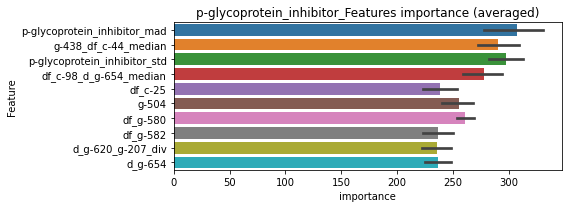

len(train_index) : 2853
len(valid_index) : 952
================================= fold 1/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.080047	valid_1's binary_logloss: 0.0961412
[200]	training's binary_logloss: 0.0227567	valid_1's binary_logloss: 0.0353419
[300]	training's binary_logloss: 0.00764509	valid_1's binary_logloss: 0.0160677
[400]	training's binary_logloss: 0.00311686	valid_1's binary_logloss: 0.00859184
[500]	training's binary_logloss: 0.00158083	valid_1's binary_logloss: 0.00548741
[600]	training's binary_logloss: 0.00100089	valid_1's binary_logloss: 0.00428873
[700]	training's binary_logloss: 0.000726204	valid_1's binary_logloss: 0.00358267
[800]	training's binary_logloss: 0.000574778	valid_1's binary_logloss: 0.00317224
[900]	training's binary_logloss: 0.000508385	valid_1's binary_logloss: 0.00300061
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000508385	valid_1's binary_logloss: 0.00300061


len(train_index) : 2854
len(valid_index) : 951
================================= fold 2/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.079139	valid_1's binary_logloss: 0.105586
[200]	training's binary_logloss: 0.0220885	valid_1's binary_logloss: 0.0404456
[300]	training's binary_logloss: 0.00758323	valid_1's binary_logloss: 0.0188047
[400]	training's binary_logloss: 0.00309164	valid_1's binary_logloss: 0.0108209
[500]	training's binary_logloss: 0.00157993	valid_1's binary_logloss: 0.0073393
[600]	training's binary_logloss: 0.000997829	valid_1's binary_logloss: 0.00579362
[700]	training's binary_logloss: 0.000717689	valid_1's binary_logloss: 0.00484462
[800]	training's binary_logloss: 0.000573227	valid_1's binary_logloss: 0.00437775
[900]	training's binary_logloss: 0.000513539	valid_1's binary_logloss: 0.00421915
[1000]	training's binary_logloss: 0.00048819	valid_1's binary_logloss: 0.00410901
Early stopping, best iteration is:
[1013]	training's binary_logloss: 0.000483386	valid_1's binary_logloss: 0.00405443


len(train_index) : 2854
len(valid_index) : 951
================================= fold 3/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0780329	valid_1's binary_logloss: 0.0964715
[200]	training's binary_logloss: 0.0219792	valid_1's binary_logloss: 0.0352621
[300]	training's binary_logloss: 0.00744088	valid_1's binary_logloss: 0.0167647
[400]	training's binary_logloss: 0.00298028	valid_1's binary_logloss: 0.0095417
[500]	training's binary_logloss: 0.0015479	valid_1's binary_logloss: 0.00690993
[600]	training's binary_logloss: 0.000980875	valid_1's binary_logloss: 0.0056691
[700]	training's binary_logloss: 0.000714228	valid_1's binary_logloss: 0.00508617
[800]	training's binary_logloss: 0.00056629	valid_1's binary_logloss: 0.00473481
[900]	training's binary_logloss: 0.000509558	valid_1's binary_logloss: 0.00461631
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.000511594	valid_1's binary_logloss: 0.0046114


len(train_index) : 2854
len(valid_index) : 951
================================= fold 4/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794783	valid_1's binary_logloss: 0.106551
[200]	training's binary_logloss: 0.0228804	valid_1's binary_logloss: 0.0417355
[300]	training's binary_logloss: 0.00788565	valid_1's binary_logloss: 0.0211359
[400]	training's binary_logloss: 0.00312621	valid_1's binary_logloss: 0.0128381
[500]	training's binary_logloss: 0.00157707	valid_1's binary_logloss: 0.00992396
[600]	training's binary_logloss: 0.000981892	valid_1's binary_logloss: 0.00906264
[700]	training's binary_logloss: 0.000707351	valid_1's binary_logloss: 0.00830773
[800]	training's binary_logloss: 0.000566208	valid_1's binary_logloss: 0.00797304
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.000541777	valid_1's binary_logloss: 0.00789175


p-glycoprotein_inhibitor logloss: 0.004889120752694206


neg labels: 3289 → selected neg labels: 3281


parp_inhibitor, len(trt): 61, len(othr): 3281, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135466	valid_1's binary_logloss: 0.209185
[200]	training's binary_logloss: 0.0585422	valid_1's binary_logloss: 0.132204
[300]	training's binary_logloss: 0.0280197	valid_1's binary_logloss: 0.0965211
[400]	training's binary_logloss: 0.0137853	valid_1's binary_logloss: 0.0755512
[500]	training's binary_logloss: 0.00734797	valid_1's binary_logloss: 0.0658327
[600]	training's binary_logloss: 0.00430212	valid_1's binary_logloss: 0.059723
[700]	training's binary_logloss: 0.00278104	valid_1's binary_logloss: 0.0565034
[800]	training's binary_logloss: 0.00197428	valid_1's binary_logloss: 0.0549765
Early stopping, best iteration is:
[846]	training's binary_logloss: 0.00174046	valid_1's binary_logloss: 0.0538696
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137621	valid_1's binary_logloss: 0.199688
[200]	training's binary_logloss: 0.0595821	valid_1's b

1 / 3 AUC score:0.997
y_Threshold: 0.0262387, Threshold: 0.0905169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 150 → Positive_corect_labels: 647/3787
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.06336, conf_1:0.11767
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.0905169
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_2: 0.1205169
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_3: 0.1505169
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_4: 0.1805169
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_5: 0.2105169
threshold: 0.2105169, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128065	valid_1's binary_logloss: 0.190654
[200]	training's binary_logloss: 0.0514369	valid_1's binary_logloss: 0.112381
[300]	training's binary_logloss: 0.0221711	valid_1's binary_logloss: 0.079399
[400]	training's binary_logloss: 0.0103941	valid_1's binary_logloss: 0.0620682
[500]	training's binary_logloss: 0.00536408	valid_1's binary_logloss: 0.0530639
[600]	training's binary_logloss: 0.00318471	valid_1's binary_logloss: 0.0494765
[700]	training's binary_logloss: 0.00214621	valid_1's binary_logloss: 0.0470962
[800]	training's binary_logloss: 0.00157582	valid_1's binary_logloss: 0.0455073
Early stopping, best iteration is:
[786]	training's binary_logloss: 0.00163627	valid_1's binary_logloss: 0.045415
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132361	valid_1's binary_logloss: 0.181599
[200]	training's binary_logloss: 0.0537664	valid_1's bi

2 / 3 AUC score:0.997
y_Threshold: 0.0735223, Threshold: 0.2105169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 632.0/3757
p_label_rate: 0.0143144 Vs.target_rate: 0.00256, Num_p_label: 57.0, conf_0:0.16841, conf_1:0.25262
Num_p_label: 57.0, Expected: 10.2, Adj_threshold_1: 0.2105169
Num_p_label: 43.0, Expected: 10.2, Adj_threshold_2: 0.2405169
Num_p_label: 39.0, Expected: 10.2, Adj_threshold_3: 0.2705169
Num_p_label: 34.0, Expected: 10.2, Adj_threshold_4: 0.3005169
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_5: 0.3305169
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_6: 0.3605169
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_7: 0.3905169
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_8: 0.4205169
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_9: 0.4505169
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_10: 0.4805169
threshold: 0.5105169, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 632.0/3757, y_label_rate: 0.1682193

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123047	valid_1's binary_logloss: 0.188345
[200]	training's binary_logloss: 0.0478084	valid_1's binary_logloss: 0.108745
[300]	training's binary_logloss: 0.0210418	valid_1's binary_logloss: 0.073771
[400]	training's binary_logloss: 0.00986834	valid_1's binary_logloss: 0.0555251
[500]	training's binary_logloss: 0.00508433	valid_1's binary_logloss: 0.0467248
[600]	training's binary_logloss: 0.00301962	valid_1's binary_logloss: 0.0420004
[700]	training's binary_logloss: 0.00203145	valid_1's binary_logloss: 0.0396962
[800]	training's binary_logloss: 0.00149629	valid_1's binary_logloss: 0.0384143
[900]	training's binary_logloss: 0.00119068	valid_1's binary_logloss: 0.0374768
[1000]	training's binary_logloss: 0.0010016	valid_1's binary_logloss: 0.0370541
Early stopping, best iteration is:
[1006]	training's binary_logloss: 0.00099387	valid_1's binary_logloss: 0.0370021
Training until validation scor

3 / 3 AUC score:0.999
y_Threshold: 0.0787831, Threshold: 0.5105169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 623.0/3739
p_label_rate: 0.0045203 Vs.target_rate: 0.00256, Num_p_label: 18.0, conf_0:0.45947, conf_1:0.56157
threshold: 0.5105169, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 623.0/3739, y_label_rate: 0.1666221


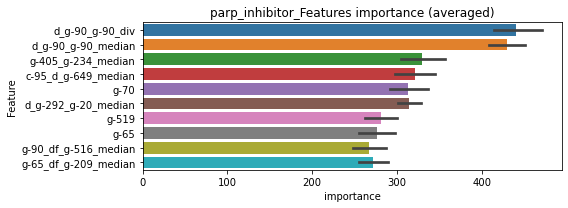

len(train_index) : 2804
len(valid_index) : 935
================================= fold 1/4 parp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12357	valid_1's binary_logloss: 0.175686
[200]	training's binary_logloss: 0.0473967	valid_1's binary_logloss: 0.0931376
[300]	training's binary_logloss: 0.0198438	valid_1's binary_logloss: 0.0560793
[400]	training's binary_logloss: 0.00924687	valid_1's binary_logloss: 0.0388054
[500]	training's binary_logloss: 0.00474778	valid_1's binary_logloss: 0.0288779
[600]	training's binary_logloss: 0.00283623	valid_1's binary_logloss: 0.0239207
[700]	training's binary_logloss: 0.00191759	valid_1's binary_logloss: 0.0212373
[800]	training's binary_logloss: 0.00143014	valid_1's binary_logloss: 0.0196128
[900]	training's binary_logloss: 0.0011449	valid_1's binary_logloss: 0.0186029
[1000]	training's binary_logloss: 0.000969537	valid_1's binary_logloss: 0.0178297
[1100]	training's binary_logloss: 0.000859265	valid_1's binary_logloss: 0.0172529
Early stopping, best iteration is:
[1094]	training's binary_lo

len(train_index) : 2804
len(valid_index) : 935
================================= fold 2/4 parp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11793	valid_1's binary_logloss: 0.185377
[200]	training's binary_logloss: 0.0467099	valid_1's binary_logloss: 0.111441
[300]	training's binary_logloss: 0.0199068	valid_1's binary_logloss: 0.0796287
[400]	training's binary_logloss: 0.00921505	valid_1's binary_logloss: 0.0631384
[500]	training's binary_logloss: 0.0047643	valid_1's binary_logloss: 0.0553634
[600]	training's binary_logloss: 0.00282437	valid_1's binary_logloss: 0.0516831
[700]	training's binary_logloss: 0.00191259	valid_1's binary_logloss: 0.0501323
[800]	training's binary_logloss: 0.00142489	valid_1's binary_logloss: 0.0492252
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.0012576	valid_1's binary_logloss: 0.048488


len(train_index) : 2804
len(valid_index) : 935
================================= fold 3/4 parp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119684	valid_1's binary_logloss: 0.182929
[200]	training's binary_logloss: 0.045695	valid_1's binary_logloss: 0.101821
[300]	training's binary_logloss: 0.0199881	valid_1's binary_logloss: 0.065554
[400]	training's binary_logloss: 0.00927964	valid_1's binary_logloss: 0.0487896
[500]	training's binary_logloss: 0.00476328	valid_1's binary_logloss: 0.0394117
[600]	training's binary_logloss: 0.00284903	valid_1's binary_logloss: 0.0350564
[700]	training's binary_logloss: 0.001917	valid_1's binary_logloss: 0.0321409
[800]	training's binary_logloss: 0.00142459	valid_1's binary_logloss: 0.0299127
[900]	training's binary_logloss: 0.00113503	valid_1's binary_logloss: 0.02854
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00112313	valid_1's binary_logloss: 0.0285261


len(train_index) : 2805
len(valid_index) : 934
================================= fold 4/4 parp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118909	valid_1's binary_logloss: 0.173336
[200]	training's binary_logloss: 0.0468061	valid_1's binary_logloss: 0.103651
[300]	training's binary_logloss: 0.0198267	valid_1's binary_logloss: 0.0703011
[400]	training's binary_logloss: 0.00918805	valid_1's binary_logloss: 0.0552671
[500]	training's binary_logloss: 0.00472815	valid_1's binary_logloss: 0.0490839
[600]	training's binary_logloss: 0.0027998	valid_1's binary_logloss: 0.0452357
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.00215673	valid_1's binary_logloss: 0.0438421


parp_inhibitor logloss: 0.03452341494629014
pdgfr_inhibitor, len(trt): 297, len(othr): 3245, target_rate: 0.0124717 → Adj_target_rate: 0.0106179


neg labels: 3289 → selected neg labels: 3245


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.241299	valid_1's binary_logloss: 0.361438
[200]	training's binary_logloss: 0.149229	valid_1's binary_logloss: 0.328061
[300]	training's binary_logloss: 0.094907	valid_1's binary_logloss: 0.311157
[400]	training's binary_logloss: 0.0651819	valid_1's binary_logloss: 0.304595
[500]	training's binary_logloss: 0.0439773	valid_1's binary_logloss: 0.298126
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.0434125	valid_1's binary_logloss: 0.298004
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.237363	valid_1's binary_logloss: 0.36405
[200]	training's binary_logloss: 0.154625	valid_1's binary_logloss: 0.331653
[300]	training's binary_logloss: 0.102573	valid_1's binary_logloss: 0.313453
[400]	training's binary_logloss: 0.0686194	valid_1's binary_logloss: 0.302934
[500]	training's binary_logloss: 0.047262	valid_1's binary_logloss: 0.

1 / 3 AUC score:0.852
y_Threshold: 0.1263638, Threshold: 0.6342759, pos_neg_ratio: 0.8000000
Remove_noisy_data: 518 → Positive_corect_labels: 455/3376
p_label_rate: 0.0100452 Vs.target_rate: 0.01247, Num_p_label: 40.0, conf_0:0.44399, conf_1:0.80000
threshold: 0.6342759, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 455.0/3376, y_label_rate: 0.1347749
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148239	valid_1's binary_logloss: 0.242653
[200]	training's binary_logloss: 0.0720705	valid_1's binary_logloss: 0.197249
[300]	training's binary_logloss: 0.038059	valid_1's binary_logloss: 0.177362
[400]	training's binary_logloss: 0.0210316	valid_1's binary_logloss: 0.167066
[500]	training's binary_logloss: 0.0120545	valid_1's binary_logloss: 0.164018
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.0129991	valid_1's binary_logloss: 0.163261
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.155355	valid_1's binary_logloss: 0.22228
[200]	training's binary_logloss: 0.0760486	valid_1's binary_logloss: 0.167048
[300]	training's binary_logloss: 0.0408066	valid_1's binary_logloss: 0.139824
[400]	training's binary_logloss: 0.0231538	valid_1's binary_logloss: 0.125889
[500]	training's binary_logloss: 0.0136897	valid_1's binary_logloss

2 / 3 AUC score:0.964
y_Threshold: 0.0983379, Threshold: 0.6342759, pos_neg_ratio: 0.8000000
Remove_noisy_data: 142 → Positive_corect_labels: 384.0/3234
p_label_rate: 0.0323958 Vs.target_rate: 0.01247, Num_p_label: 129.0, conf_0:0.50000, conf_1:0.76113
threshold: 0.6342759, positive_p_label: 129.0/3982, p_label_rate: 0.0323958
positive_y_label: 384.0/3234, y_label_rate: 0.1187384
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115015	valid_1's binary_logloss: 0.189033
[200]	training's binary_logloss: 0.0533213	valid_1's binary_logloss: 0.145002
[300]	training's binary_logloss: 0.0264378	valid_1's binary_logloss: 0.126667
[400]	training's binary_logloss: 0.0134019	valid_1's binary_logloss: 0.11616
[500]	training's binary_logloss: 0.00735495	valid_1's binary_logloss: 0.110668
[600]	training's binary_logloss: 0.00443217	valid_1's binary_logloss: 0.108176
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00385569	valid_1's binary_logloss: 0.10763
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117399	valid_1's binary_logloss: 0.203186
[200]	training's binary_logloss: 0.0525457	valid_1's binary_logloss: 0.158494
[300]	training's binary_logloss: 0.0247805	valid_1's binary_logloss: 0.140092
[400]	training's binary_logloss: 0.0127757	valid_1's binary_logl

3 / 3 AUC score:0.975
y_Threshold: 0.0984630, Threshold: 0.6342759, pos_neg_ratio: 0.8000000
Remove_noisy_data: 90 → Positive_corect_labels: 339.0/3144
p_label_rate: 0.0429432 Vs.target_rate: 0.01247, Num_p_label: 171.0, conf_0:0.50000, conf_1:0.69770
Num_p_label: 171.0, Expected: 49.7, Adj_threshold_1: 0.6342759
Num_p_label: 162.0, Expected: 49.7, Adj_threshold_2: 0.6642759
Num_p_label: 154.0, Expected: 49.7, Adj_threshold_3: 0.6942759
threshold: 0.6942759, positive_p_label: 154.0/3982, p_label_rate: 0.0386740
positive_y_label: 339.0/3144, y_label_rate: 0.1078244


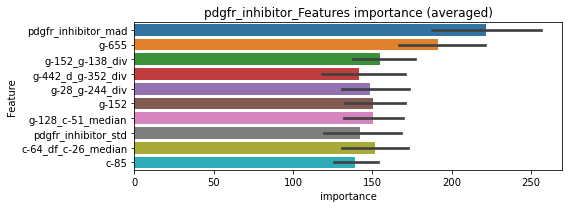

len(train_index) : 2358
len(valid_index) : 786
================================= fold 1/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0908738	valid_1's binary_logloss: 0.182732
[200]	training's binary_logloss: 0.0353927	valid_1's binary_logloss: 0.145416
[300]	training's binary_logloss: 0.0156054	valid_1's binary_logloss: 0.136231
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0154714	valid_1's binary_logloss: 0.136078


len(train_index) : 2358
len(valid_index) : 786
================================= fold 2/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0904878	valid_1's binary_logloss: 0.162601
[200]	training's binary_logloss: 0.037456	valid_1's binary_logloss: 0.124634
[300]	training's binary_logloss: 0.0171567	valid_1's binary_logloss: 0.110692
[400]	training's binary_logloss: 0.00840445	valid_1's binary_logloss: 0.1054
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00585475	valid_1's binary_logloss: 0.102607


len(train_index) : 2358
len(valid_index) : 786
================================= fold 3/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0971996	valid_1's binary_logloss: 0.148298
[200]	training's binary_logloss: 0.0403027	valid_1's binary_logloss: 0.104735
[300]	training's binary_logloss: 0.0187809	valid_1's binary_logloss: 0.0824762
[400]	training's binary_logloss: 0.00931723	valid_1's binary_logloss: 0.0708396
[500]	training's binary_logloss: 0.00504426	valid_1's binary_logloss: 0.0659403
[600]	training's binary_logloss: 0.00308649	valid_1's binary_logloss: 0.0628052
[700]	training's binary_logloss: 0.00211089	valid_1's binary_logloss: 0.0607209
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.00200546	valid_1's binary_logloss: 0.0605586


len(train_index) : 2358
len(valid_index) : 786
================================= fold 4/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.097522	valid_1's binary_logloss: 0.152292
[200]	training's binary_logloss: 0.0406363	valid_1's binary_logloss: 0.102287
[300]	training's binary_logloss: 0.0182163	valid_1's binary_logloss: 0.078363
[400]	training's binary_logloss: 0.00902827	valid_1's binary_logloss: 0.0657404
[500]	training's binary_logloss: 0.00493051	valid_1's binary_logloss: 0.0579503
[600]	training's binary_logloss: 0.00305653	valid_1's binary_logloss: 0.053235
[700]	training's binary_logloss: 0.00210918	valid_1's binary_logloss: 0.0505507
[800]	training's binary_logloss: 0.00159383	valid_1's binary_logloss: 0.0490144
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.00150251	valid_1's binary_logloss: 0.0484277


pdgfr_inhibitor logloss: 0.08691794720673075
pdk_inhibitor, len(trt): 18, len(othr): 3284, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0709359	valid_1's binary_logloss: 0.0878041
[200]	training's binary_logloss: 0.0193187	valid_1's binary_logloss: 0.0320973
[300]	training's binary_logloss: 0.00594798	valid_1's binary_logloss: 0.0145981
[400]	training's binary_logloss: 0.00231806	valid_1's binary_logloss: 0.00851972
[500]	training's binary_logloss: 0.00120013	valid_1's binary_logloss: 0.00586482
[600]	training's binary_logloss: 0.000770993	valid_1's binary_logloss: 0.00474681
[700]	training's binary_logloss: 0.000565358	valid_1's binary_logloss: 0.00407668
[800]	training's binary_logloss: 0.000464921	valid_1's binary_logloss: 0.00382706
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000437403	valid_1's binary_logloss: 0.00378031
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.072251	valid_1's binary_logloss: 0.0843149
[200]	training's binary_logloss: 0.01

1 / 3 AUC score:1.000
y_Threshold: 0.0053836, Threshold: 0.0423695, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02966, conf_1:0.05508
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0423695
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.0723695
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.1023695
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.1323695
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.1623695
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.1923695
threshold: 0.1923695, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0678283	valid_1's binary_logloss: 0.0844274
[200]	training's binary_logloss: 0.0164785	valid_1's binary_logloss: 0.026327
[300]	training's binary_logloss: 0.00485631	valid_1's binary_logloss: 0.0108352
[400]	training's binary_logloss: 0.00190919	valid_1's binary_logloss: 0.0059588
[500]	training's binary_logloss: 0.00100241	valid_1's binary_logloss: 0.00391338
[600]	training's binary_logloss: 0.000652813	valid_1's binary_logloss: 0.00307822
[700]	training's binary_logloss: 0.000485236	valid_1's binary_logloss: 0.00260109
[800]	training's binary_logloss: 0.000403095	valid_1's binary_logloss: 0.00237778
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.000394153	valid_1's binary_logloss: 0.00234856
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0661068	valid_1's binary_logloss: 0.0790478
[200]	training's binary_logloss: 0.015

2 / 3 AUC score:1.000
y_Threshold: 0.0873568, Threshold: 0.1923695, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0062783 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.15390, conf_1:0.23084
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.1923695
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.2223695
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_3: 0.2523695
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_4: 0.2823695
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.3123695
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.3423695
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_7: 0.3723695
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_8: 0.4023695
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.4323695
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_10: 0.4623695
threshold: 0.4923695, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0678283	valid_1's binary_logloss: 0.0844274
[200]	training's binary_logloss: 0.0164785	valid_1's binary_logloss: 0.026327
[300]	training's binary_logloss: 0.00485631	valid_1's binary_logloss: 0.0108352
[400]	training's binary_logloss: 0.00190919	valid_1's binary_logloss: 0.0059588
[500]	training's binary_logloss: 0.00100241	valid_1's binary_logloss: 0.00391338
[600]	training's binary_logloss: 0.000652813	valid_1's binary_logloss: 0.00307822
[700]	training's binary_logloss: 0.000485236	valid_1's binary_logloss: 0.00260109
[800]	training's binary_logloss: 0.000403095	valid_1's binary_logloss: 0.00237778
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.000394153	valid_1's binary_logloss: 0.00234856
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0661068	valid_1's binary_logloss: 0.0790478
[200]	training's binary_logloss: 0.015

3 / 3 AUC score:1.000
y_Threshold: 0.0873568, Threshold: 0.4923695, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0027624 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.44313, conf_1:0.54161
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.4923695
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.5223695
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.5523695
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.5823695
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.6123695
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.6423695
threshold: 0.6423695, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689


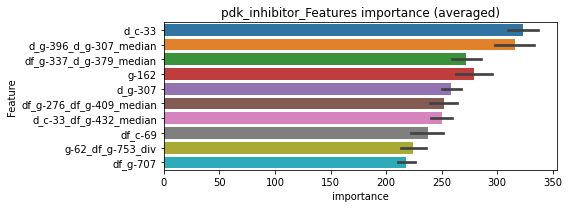

len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 pdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0666427	valid_1's binary_logloss: 0.0822157
[200]	training's binary_logloss: 0.0161532	valid_1's binary_logloss: 0.0258759
[300]	training's binary_logloss: 0.00484755	valid_1's binary_logloss: 0.0105157
[400]	training's binary_logloss: 0.00187728	valid_1's binary_logloss: 0.0056006
[500]	training's binary_logloss: 0.000989092	valid_1's binary_logloss: 0.0037562
[600]	training's binary_logloss: 0.000643832	valid_1's binary_logloss: 0.00293002
[700]	training's binary_logloss: 0.000479023	valid_1's binary_logloss: 0.00255439
[800]	training's binary_logloss: 0.000400528	valid_1's binary_logloss: 0.00238192
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.000396844	valid_1's binary_logloss: 0.0023764


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 pdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0672267	valid_1's binary_logloss: 0.0802461
[200]	training's binary_logloss: 0.0163341	valid_1's binary_logloss: 0.024966
[300]	training's binary_logloss: 0.00484566	valid_1's binary_logloss: 0.0109225
[400]	training's binary_logloss: 0.00191634	valid_1's binary_logloss: 0.0063117
[500]	training's binary_logloss: 0.0010054	valid_1's binary_logloss: 0.00456001
[600]	training's binary_logloss: 0.000653201	valid_1's binary_logloss: 0.00380011
[700]	training's binary_logloss: 0.000488602	valid_1's binary_logloss: 0.00330806
[800]	training's binary_logloss: 0.000405119	valid_1's binary_logloss: 0.00308324
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.00040291	valid_1's binary_logloss: 0.00307896


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 pdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0671823	valid_1's binary_logloss: 0.0792145
[200]	training's binary_logloss: 0.0164491	valid_1's binary_logloss: 0.0226833
[300]	training's binary_logloss: 0.00494691	valid_1's binary_logloss: 0.00840854
[400]	training's binary_logloss: 0.00193145	valid_1's binary_logloss: 0.00400256
[500]	training's binary_logloss: 0.00101757	valid_1's binary_logloss: 0.0024433
[600]	training's binary_logloss: 0.000662882	valid_1's binary_logloss: 0.00173789
[700]	training's binary_logloss: 0.000491609	valid_1's binary_logloss: 0.00135761
[800]	training's binary_logloss: 0.000407178	valid_1's binary_logloss: 0.00116642
[900]	training's binary_logloss: 0.000386393	valid_1's binary_logloss: 0.00112794
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.000386393	valid_1's binary_logloss: 0.00112794


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 pdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.066695	valid_1's binary_logloss: 0.0840618
[200]	training's binary_logloss: 0.0162432	valid_1's binary_logloss: 0.0266136
[300]	training's binary_logloss: 0.00484316	valid_1's binary_logloss: 0.0113435
[400]	training's binary_logloss: 0.00189651	valid_1's binary_logloss: 0.00641541
[500]	training's binary_logloss: 0.00100474	valid_1's binary_logloss: 0.00446936
[600]	training's binary_logloss: 0.000648028	valid_1's binary_logloss: 0.0035357
[700]	training's binary_logloss: 0.000481342	valid_1's binary_logloss: 0.00310377
[800]	training's binary_logloss: 0.000402027	valid_1's binary_logloss: 0.0028734
[900]	training's binary_logloss: 0.000377668	valid_1's binary_logloss: 0.00280249
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.000377419	valid_1's binary_logloss: 0.00280202


pdk_inhibitor logloss: 0.002346387341037624
phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3248, target_rate: 0.0110859 → Adj_target_rate: 0.0096064


neg labels: 3289 → selected neg labels: 3248


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.220089	valid_1's binary_logloss: 0.375793
[200]	training's binary_logloss: 0.133955	valid_1's binary_logloss: 0.352464
[300]	training's binary_logloss: 0.086838	valid_1's binary_logloss: 0.340951
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.069776	valid_1's binary_logloss: 0.338677
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.228516	valid_1's binary_logloss: 0.345813
[200]	training's binary_logloss: 0.139114	valid_1's binary_logloss: 0.310097
[300]	training's binary_logloss: 0.0899646	valid_1's binary_logloss: 0.290987
[400]	training's binary_logloss: 0.0606113	valid_1's binary_logloss: 0.280008
[500]	training's binary_logloss: 0.0403851	valid_1's binary_logloss: 0.275855
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.0417439	valid_1's binary_logloss: 0.275514
Training until validation scores d

1 / 3 AUC score:0.855
y_Threshold: 0.1286961, Threshold: 0.4489071, pos_neg_ratio: 0.8000000
Remove_noisy_data: 523 → Positive_corect_labels: 453/3374
p_label_rate: 0.0100452 Vs.target_rate: 0.01109, Num_p_label: 40.0, conf_0:0.31423, conf_1:0.58358
threshold: 0.4489071, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 453.0/3374, y_label_rate: 0.1342620
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135079	valid_1's binary_logloss: 0.224609
[200]	training's binary_logloss: 0.0625528	valid_1's binary_logloss: 0.181866
[300]	training's binary_logloss: 0.0315077	valid_1's binary_logloss: 0.160839
[400]	training's binary_logloss: 0.0164783	valid_1's binary_logloss: 0.15349
[500]	training's binary_logloss: 0.00910672	valid_1's binary_logloss: 0.149313
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00752145	valid_1's binary_logloss: 0.149083
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133621	valid_1's binary_logloss: 0.204151
[200]	training's binary_logloss: 0.0608447	valid_1's binary_logloss: 0.150249
[300]	training's binary_logloss: 0.0299472	valid_1's binary_logloss: 0.126062
[400]	training's binary_logloss: 0.0162086	valid_1's binary_logloss: 0.114143
[500]	training's binary_logloss: 0.00913442	valid_1's binary_log

2 / 3 AUC score:0.969
y_Threshold: 0.1445977, Threshold: 0.4489071, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 383.0/3234
p_label_rate: 0.0464591 Vs.target_rate: 0.01109, Num_p_label: 185.0, conf_0:0.35913, conf_1:0.53869
Num_p_label: 185.0, Expected: 44.1, Adj_threshold_1: 0.4489071
Num_p_label: 168.0, Expected: 44.1, Adj_threshold_2: 0.4789071
Num_p_label: 153.0, Expected: 44.1, Adj_threshold_3: 0.5089071
Num_p_label: 143.0, Expected: 44.1, Adj_threshold_4: 0.5389071
Num_p_label: 131.0, Expected: 44.1, Adj_threshold_5: 0.5689071
Num_p_label: 116.0, Expected: 44.1, Adj_threshold_6: 0.5989071
Num_p_label: 103.0, Expected: 44.1, Adj_threshold_7: 0.6289071
Num_p_label: 92.0, Expected: 44.1, Adj_threshold_8: 0.6589071
Num_p_label: 85.0, Expected: 44.1, Adj_threshold_9: 0.6889071
threshold: 0.6889071, positive_p_label: 85.0/3982, p_label_rate: 0.0213461
positive_y_label: 383.0/3234, y_label_rate: 0.1184292
================= Pseudo labeling 3 / 3 =============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101959	valid_1's binary_logloss: 0.175578
[200]	training's binary_logloss: 0.042207	valid_1's binary_logloss: 0.131954
[300]	training's binary_logloss: 0.0186768	valid_1's binary_logloss: 0.114576
[400]	training's binary_logloss: 0.0087936	valid_1's binary_logloss: 0.104707
[500]	training's binary_logloss: 0.00469527	valid_1's binary_logloss: 0.101674
[600]	training's binary_logloss: 0.00285341	valid_1's binary_logloss: 0.09973
[700]	training's binary_logloss: 0.00194055	valid_1's binary_logloss: 0.098245
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.00194055	valid_1's binary_logloss: 0.098245
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100874	valid_1's binary_logloss: 0.156788
[200]	training's binary_logloss: 0.0410137	valid_1's binary_logloss: 0.103559
[300]	training's binary_logloss: 0.0188996	valid_1's binary_log

3 / 3 AUC score:0.990
y_Threshold: 0.1471992, Threshold: 0.6889071, pos_neg_ratio: 0.8000000
Remove_noisy_data: 66 → Positive_corect_labels: 350.0/3168
p_label_rate: 0.0404319 Vs.target_rate: 0.01109, Num_p_label: 161.0, conf_0:0.50000, conf_1:0.75780
Num_p_label: 161.0, Expected: 44.1, Adj_threshold_1: 0.6889071
threshold: 0.6889071, positive_p_label: 161.0/3982, p_label_rate: 0.0404319
positive_y_label: 350.0/3168, y_label_rate: 0.1104798


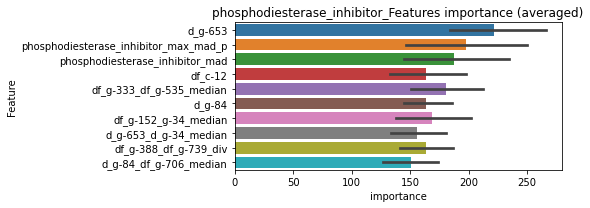

len(train_index) : 2376
len(valid_index) : 792
================================= fold 1/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0857224	valid_1's binary_logloss: 0.14648
[200]	training's binary_logloss: 0.0322205	valid_1's binary_logloss: 0.106525
[300]	training's binary_logloss: 0.013593	valid_1's binary_logloss: 0.0907506
[400]	training's binary_logloss: 0.00645454	valid_1's binary_logloss: 0.0816946
[500]	training's binary_logloss: 0.00346029	valid_1's binary_logloss: 0.0788362
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00358814	valid_1's binary_logloss: 0.078645


len(train_index) : 2376
len(valid_index) : 792
================================= fold 2/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0871974	valid_1's binary_logloss: 0.151097
[200]	training's binary_logloss: 0.0324738	valid_1's binary_logloss: 0.106935
[300]	training's binary_logloss: 0.0136363	valid_1's binary_logloss: 0.0887252
[400]	training's binary_logloss: 0.00651947	valid_1's binary_logloss: 0.0803715
[500]	training's binary_logloss: 0.00353335	valid_1's binary_logloss: 0.0770279
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00395582	valid_1's binary_logloss: 0.0768344


len(train_index) : 2376
len(valid_index) : 792
================================= fold 3/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0887531	valid_1's binary_logloss: 0.14023
[200]	training's binary_logloss: 0.0325594	valid_1's binary_logloss: 0.0935442
[300]	training's binary_logloss: 0.0136833	valid_1's binary_logloss: 0.072093
[400]	training's binary_logloss: 0.00645834	valid_1's binary_logloss: 0.0613286
[500]	training's binary_logloss: 0.00347692	valid_1's binary_logloss: 0.0568926
[600]	training's binary_logloss: 0.00218422	valid_1's binary_logloss: 0.0552301
[700]	training's binary_logloss: 0.00153443	valid_1's binary_logloss: 0.0538758
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.0013176	valid_1's binary_logloss: 0.053327


len(train_index) : 2376
len(valid_index) : 792
================================= fold 4/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0870203	valid_1's binary_logloss: 0.128792
[200]	training's binary_logloss: 0.0333726	valid_1's binary_logloss: 0.079787
[300]	training's binary_logloss: 0.0154066	valid_1's binary_logloss: 0.0582953
[400]	training's binary_logloss: 0.00797697	valid_1's binary_logloss: 0.0488783
[500]	training's binary_logloss: 0.00404137	valid_1's binary_logloss: 0.0403484
[600]	training's binary_logloss: 0.0023626	valid_1's binary_logloss: 0.0372905
[700]	training's binary_logloss: 0.00159606	valid_1's binary_logloss: 0.0350951
[800]	training's binary_logloss: 0.00121454	valid_1's binary_logloss: 0.0340498
[900]	training's binary_logloss: 0.00101202	valid_1's binary_logloss: 0.0335741
Early stopping, best iteration is:
[878]	training's binary_logloss: 0.00105043	valid_1's binary_logloss: 0.033503


phosphodiesterase_inhibitor logloss: 0.060577346854655004
phospholipase_inhibitor, len(trt): 25, len(othr): 3286, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0998225	valid_1's binary_logloss: 0.122184
[200]	training's binary_logloss: 0.035349	valid_1's binary_logloss: 0.053624
[300]	training's binary_logloss: 0.0141637	valid_1's binary_logloss: 0.0275685
[400]	training's binary_logloss: 0.00586265	valid_1's binary_logloss: 0.0156164
[500]	training's binary_logloss: 0.00287182	valid_1's binary_logloss: 0.0105073
[600]	training's binary_logloss: 0.00166471	valid_1's binary_logloss: 0.00820262
[700]	training's binary_logloss: 0.0011318	valid_1's binary_logloss: 0.00703309
[800]	training's binary_logloss: 0.00085264	valid_1's binary_logloss: 0.00621147
[900]	training's binary_logloss: 0.00069655	valid_1's binary_logloss: 0.00586819
[1000]	training's binary_logloss: 0.000626174	valid_1's binary_logloss: 0.00576312
[1100]	training's binary_logloss: 0.000599813	valid_1's binary_logloss: 0.00565037
Early stopping, best iteration is:
[1112]	training's bin

1 / 3 AUC score:1.000
y_Threshold: 0.0086642, Threshold: 0.0572891, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.04010, conf_1:0.07448
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0572891
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_2: 0.0872891
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_3: 0.1172891
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.1472891
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_5: 0.1772891
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_6: 0.2072891
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_7: 0.2372891
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.2672891
threshold: 0.2672891, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0969612	valid_1's binary_logloss: 0.116039
[200]	training's binary_logloss: 0.0318172	valid_1's binary_logloss: 0.04669
[300]	training's binary_logloss: 0.0117287	valid_1's binary_logloss: 0.0218266
[400]	training's binary_logloss: 0.00485247	valid_1's binary_logloss: 0.0119291
[500]	training's binary_logloss: 0.00242158	valid_1's binary_logloss: 0.00758919
[600]	training's binary_logloss: 0.00145474	valid_1's binary_logloss: 0.0055742
[700]	training's binary_logloss: 0.00100631	valid_1's binary_logloss: 0.00460881
[800]	training's binary_logloss: 0.000769909	valid_1's binary_logloss: 0.00395633
[900]	training's binary_logloss: 0.000636851	valid_1's binary_logloss: 0.00372031
[1000]	training's binary_logloss: 0.000585305	valid_1's binary_logloss: 0.00366589
[1100]	training's binary_logloss: 0.000556649	valid_1's binary_logloss: 0.00357896
Early stopping, best iteration is:
[1093]	training's 

2 / 3 AUC score:1.000
y_Threshold: 0.0808988, Threshold: 0.2672891, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0062783 Vs.target_rate: 0.00105, Num_p_label: 25.0, conf_0:0.21383, conf_1:0.32075
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_1: 0.2672891
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.2972891
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_3: 0.3272891
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.3572891
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_5: 0.3872891
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_6: 0.4172891
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_7: 0.4472891
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_8: 0.4772891
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_9: 0.5072891
threshold: 0.5072891, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0948472	valid_1's binary_logloss: 0.127266
[200]	training's binary_logloss: 0.0313459	valid_1's binary_logloss: 0.0564535
[300]	training's binary_logloss: 0.0115174	valid_1's binary_logloss: 0.0296155
[400]	training's binary_logloss: 0.00465888	valid_1's binary_logloss: 0.0183087
[500]	training's binary_logloss: 0.00229188	valid_1's binary_logloss: 0.0128967
[600]	training's binary_logloss: 0.00137759	valid_1's binary_logloss: 0.0107029
[700]	training's binary_logloss: 0.000955469	valid_1's binary_logloss: 0.00943381
[800]	training's binary_logloss: 0.000741149	valid_1's binary_logloss: 0.00884991
[900]	training's binary_logloss: 0.000616172	valid_1's binary_logloss: 0.00841093
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000635546	valid_1's binary_logloss: 0.00835695
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0963

3 / 3 AUC score:1.000
y_Threshold: 0.0891004, Threshold: 0.5072891, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0032647 Vs.target_rate: 0.00105, Num_p_label: 13.0, conf_0:0.45656, conf_1:0.55802
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_1: 0.5072891
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.5372891
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.5672891
threshold: 0.5672891, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3809, y_label_rate: 0.1722237


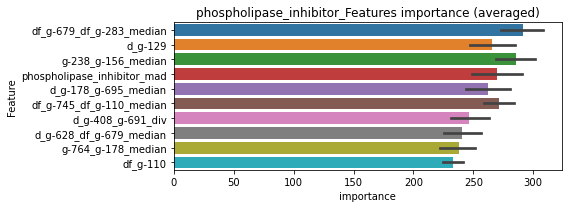

len(train_index) : 2856
len(valid_index) : 953
================================= fold 1/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.095592	valid_1's binary_logloss: 0.128655
[200]	training's binary_logloss: 0.0320047	valid_1's binary_logloss: 0.0578087
[300]	training's binary_logloss: 0.0116873	valid_1's binary_logloss: 0.0297009
[400]	training's binary_logloss: 0.00482163	valid_1's binary_logloss: 0.0179171
[500]	training's binary_logloss: 0.00239532	valid_1's binary_logloss: 0.0127198
[600]	training's binary_logloss: 0.00142601	valid_1's binary_logloss: 0.0103117
[700]	training's binary_logloss: 0.000979644	valid_1's binary_logloss: 0.00896155
[800]	training's binary_logloss: 0.000755566	valid_1's binary_logloss: 0.00841639
[900]	training's binary_logloss: 0.000627623	valid_1's binary_logloss: 0.0079411
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.000624338	valid_1's binary_logloss: 0.00790376


len(train_index) : 2857
len(valid_index) : 952
================================= fold 2/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096049	valid_1's binary_logloss: 0.127149
[200]	training's binary_logloss: 0.0312921	valid_1's binary_logloss: 0.0547113
[300]	training's binary_logloss: 0.0118844	valid_1's binary_logloss: 0.028353
[400]	training's binary_logloss: 0.00487667	valid_1's binary_logloss: 0.0171633
[500]	training's binary_logloss: 0.00238193	valid_1's binary_logloss: 0.0120349
[600]	training's binary_logloss: 0.00142027	valid_1's binary_logloss: 0.00957105
[700]	training's binary_logloss: 0.000977587	valid_1's binary_logloss: 0.00834846
[800]	training's binary_logloss: 0.00075028	valid_1's binary_logloss: 0.00764634
[900]	training's binary_logloss: 0.000626646	valid_1's binary_logloss: 0.00727039
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000618067	valid_1's binary_logloss: 0.0071654


len(train_index) : 2857
len(valid_index) : 952
================================= fold 3/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0954341	valid_1's binary_logloss: 0.117971
[200]	training's binary_logloss: 0.0315857	valid_1's binary_logloss: 0.0473135
[300]	training's binary_logloss: 0.0117632	valid_1's binary_logloss: 0.0215884
[400]	training's binary_logloss: 0.00482219	valid_1's binary_logloss: 0.0113823
[500]	training's binary_logloss: 0.00240814	valid_1's binary_logloss: 0.00718452
[600]	training's binary_logloss: 0.00143604	valid_1's binary_logloss: 0.00510717
[700]	training's binary_logloss: 0.000996472	valid_1's binary_logloss: 0.00417907
[800]	training's binary_logloss: 0.000764497	valid_1's binary_logloss: 0.00363915
[900]	training's binary_logloss: 0.000632384	valid_1's binary_logloss: 0.00334484
[1000]	training's binary_logloss: 0.000571609	valid_1's binary_logloss: 0.00317055
[1100]	training's binary_logloss: 0.000552415	valid_1's binary_logloss: 0.00313237
Early stopping, best iteration is:
[1097]	trainin

len(train_index) : 2857
len(valid_index) : 952
================================= fold 4/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968256	valid_1's binary_logloss: 0.120007
[200]	training's binary_logloss: 0.032671	valid_1's binary_logloss: 0.0502061
[300]	training's binary_logloss: 0.0120489	valid_1's binary_logloss: 0.0242284
[400]	training's binary_logloss: 0.00500667	valid_1's binary_logloss: 0.013465
[500]	training's binary_logloss: 0.00248539	valid_1's binary_logloss: 0.00870965
[600]	training's binary_logloss: 0.00146814	valid_1's binary_logloss: 0.00652371
[700]	training's binary_logloss: 0.00101402	valid_1's binary_logloss: 0.00545404
[800]	training's binary_logloss: 0.000772355	valid_1's binary_logloss: 0.00475097
[900]	training's binary_logloss: 0.000644044	valid_1's binary_logloss: 0.00434657
[1000]	training's binary_logloss: 0.000580419	valid_1's binary_logloss: 0.00415995
Early stopping, best iteration is:
[1067]	training's binary_logloss: 0.000567474	valid_1's binary_logloss: 0.00410039


phospholipase_inhibitor logloss: 0.0055783731308957675
pi3k_inhibitor, len(trt): 151, len(othr): 3262, target_rate: 0.0063408 → Adj_target_rate: 0.0059749


neg labels: 3289 → selected neg labels: 3262


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.182826	valid_1's binary_logloss: 0.30514
[200]	training's binary_logloss: 0.103215	valid_1's binary_logloss: 0.253305
[300]	training's binary_logloss: 0.0589553	valid_1's binary_logloss: 0.226183
[400]	training's binary_logloss: 0.03575	valid_1's binary_logloss: 0.213053
[500]	training's binary_logloss: 0.0215158	valid_1's binary_logloss: 0.203419
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.0157482	valid_1's binary_logloss: 0.202103
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.185446	valid_1's binary_logloss: 0.295741
[200]	training's binary_logloss: 0.102583	valid_1's binary_logloss: 0.243163
[300]	training's binary_logloss: 0.0613941	valid_1's binary_logloss: 0.214526
[400]	training's binary_logloss: 0.0371325	valid_1's binary_logloss: 0.196263
[500]	training's binary_logloss: 0.0224758	valid_1's binary_logloss: 0

1 / 3 AUC score:0.949
y_Threshold: 0.0856702, Threshold: 0.3355212, pos_neg_ratio: 0.8000000
Remove_noisy_data: 307 → Positive_corect_labels: 564/3607
p_label_rate: 0.0100452 Vs.target_rate: 0.00634, Num_p_label: 40.0, conf_0:0.23486, conf_1:0.43618
threshold: 0.3355212, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 564.0/3607, y_label_rate: 0.1563626
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.140294	valid_1's binary_logloss: 0.21396
[200]	training's binary_logloss: 0.0680697	valid_1's binary_logloss: 0.153097
[300]	training's binary_logloss: 0.0354739	valid_1's binary_logloss: 0.121904
[400]	training's binary_logloss: 0.0190582	valid_1's binary_logloss: 0.103511
[500]	training's binary_logloss: 0.0105229	valid_1's binary_logloss: 0.0915965
[600]	training's binary_logloss: 0.00622294	valid_1's binary_logloss: 0.0847774
[700]	training's binary_logloss: 0.00400843	valid_1's binary_logloss: 0.0802365
[800]	training's binary_logloss: 0.00279092	valid_1's binary_logloss: 0.0775046
[900]	training's binary_logloss: 0.00211111	valid_1's binary_logloss: 0.0759661
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.00191765	valid_1's binary_logloss: 0.0756853
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138066	valid_1's bi

2 / 3 AUC score:0.987
y_Threshold: 0.1286434, Threshold: 0.3355212, pos_neg_ratio: 0.8000000
Remove_noisy_data: 102 → Positive_corect_labels: 513.0/3505
p_label_rate: 0.0326469 Vs.target_rate: 0.00634, Num_p_label: 130.0, conf_0:0.26842, conf_1:0.40263
Num_p_label: 130.0, Expected: 25.2, Adj_threshold_1: 0.3355212
Num_p_label: 119.0, Expected: 25.2, Adj_threshold_2: 0.3655212
Num_p_label: 111.0, Expected: 25.2, Adj_threshold_3: 0.3955212
Num_p_label: 106.0, Expected: 25.2, Adj_threshold_4: 0.4255212
Num_p_label: 101.0, Expected: 25.2, Adj_threshold_5: 0.4555212
Num_p_label: 97.0, Expected: 25.2, Adj_threshold_6: 0.4855212
Num_p_label: 91.0, Expected: 25.2, Adj_threshold_7: 0.5155212
Num_p_label: 87.0, Expected: 25.2, Adj_threshold_8: 0.5455212
Num_p_label: 79.0, Expected: 25.2, Adj_threshold_9: 0.5755212
Num_p_label: 74.0, Expected: 25.2, Adj_threshold_10: 0.6055212
threshold: 0.6355212, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 513.0/3505, y_label_rate: 0.

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116863	valid_1's binary_logloss: 0.202722
[200]	training's binary_logloss: 0.0502525	valid_1's binary_logloss: 0.142856
[300]	training's binary_logloss: 0.0241542	valid_1's binary_logloss: 0.110276
[400]	training's binary_logloss: 0.0118113	valid_1's binary_logloss: 0.0910299
[500]	training's binary_logloss: 0.00632803	valid_1's binary_logloss: 0.0805108
[600]	training's binary_logloss: 0.00376736	valid_1's binary_logloss: 0.0743677
[700]	training's binary_logloss: 0.0025268	valid_1's binary_logloss: 0.0716703
[800]	training's binary_logloss: 0.00184965	valid_1's binary_logloss: 0.069201
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.00164524	valid_1's binary_logloss: 0.0679703
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116095	valid_1's binary_logloss: 0.193559
[200]	training's binary_logloss: 0.0485155	valid_1's bin

3 / 3 AUC score:0.991
y_Threshold: 0.1368102, Threshold: 0.6355212, pos_neg_ratio: 0.8000000
Remove_noisy_data: 68 → Positive_corect_labels: 479.0/3437
p_label_rate: 0.0283777 Vs.target_rate: 0.00634, Num_p_label: 113.0, conf_0:0.50000, conf_1:0.69907
Num_p_label: 113.0, Expected: 25.2, Adj_threshold_1: 0.6355212
Num_p_label: 109.0, Expected: 25.2, Adj_threshold_2: 0.6655212
Num_p_label: 105.0, Expected: 25.2, Adj_threshold_3: 0.6955212
threshold: 0.6955212, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 479.0/3437, y_label_rate: 0.1393657


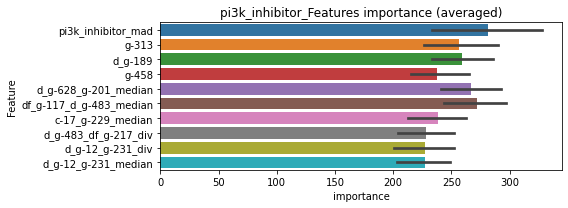

len(train_index) : 2577
len(valid_index) : 860
================================= fold 1/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101428	valid_1's binary_logloss: 0.17661
[200]	training's binary_logloss: 0.0414962	valid_1's binary_logloss: 0.125761
[300]	training's binary_logloss: 0.01884	valid_1's binary_logloss: 0.100345
[400]	training's binary_logloss: 0.00918918	valid_1's binary_logloss: 0.0865342
[500]	training's binary_logloss: 0.00489844	valid_1's binary_logloss: 0.0775578
[600]	training's binary_logloss: 0.00295594	valid_1's binary_logloss: 0.0740086
[700]	training's binary_logloss: 0.00201728	valid_1's binary_logloss: 0.0719228
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.00169372	valid_1's binary_logloss: 0.0708987


len(train_index) : 2578
len(valid_index) : 859
================================= fold 2/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101886	valid_1's binary_logloss: 0.163093
[200]	training's binary_logloss: 0.040776	valid_1's binary_logloss: 0.109775
[300]	training's binary_logloss: 0.0183965	valid_1's binary_logloss: 0.0829468
[400]	training's binary_logloss: 0.00881995	valid_1's binary_logloss: 0.0691681
[500]	training's binary_logloss: 0.00476095	valid_1's binary_logloss: 0.0613646
[600]	training's binary_logloss: 0.00292297	valid_1's binary_logloss: 0.0565683
[700]	training's binary_logloss: 0.00200855	valid_1's binary_logloss: 0.0538463
[800]	training's binary_logloss: 0.00150325	valid_1's binary_logloss: 0.0518362
[900]	training's binary_logloss: 0.00120623	valid_1's binary_logloss: 0.0506608
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.00111878	valid_1's binary_logloss: 0.0502646


len(train_index) : 2578
len(valid_index) : 859
================================= fold 3/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100768	valid_1's binary_logloss: 0.179598
[200]	training's binary_logloss: 0.0391177	valid_1's binary_logloss: 0.125177
[300]	training's binary_logloss: 0.0170127	valid_1's binary_logloss: 0.101908
[400]	training's binary_logloss: 0.00831471	valid_1's binary_logloss: 0.0927725
[500]	training's binary_logloss: 0.00451525	valid_1's binary_logloss: 0.0865617
[600]	training's binary_logloss: 0.00277811	valid_1's binary_logloss: 0.0844707
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.00222034	valid_1's binary_logloss: 0.0837895


len(train_index) : 2578
len(valid_index) : 859
================================= fold 4/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101833	valid_1's binary_logloss: 0.155476
[200]	training's binary_logloss: 0.0385828	valid_1's binary_logloss: 0.101632
[300]	training's binary_logloss: 0.0170016	valid_1's binary_logloss: 0.0806536
[400]	training's binary_logloss: 0.00836749	valid_1's binary_logloss: 0.072071
[500]	training's binary_logloss: 0.00446321	valid_1's binary_logloss: 0.0686931
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00424815	valid_1's binary_logloss: 0.0680485


pi3k_inhibitor logloss: 0.06825111246834852


neg labels: 3289 → selected neg labels: 3286


pkc_inhibitor, len(trt): 31, len(othr): 3286, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0907797	valid_1's binary_logloss: 0.13462
[200]	training's binary_logloss: 0.0319825	valid_1's binary_logloss: 0.0699533
[300]	training's binary_logloss: 0.0126835	valid_1's binary_logloss: 0.0450883
[400]	training's binary_logloss: 0.00543669	valid_1's binary_logloss: 0.0343815
[500]	training's binary_logloss: 0.00270732	valid_1's binary_logloss: 0.0298719
[600]	training's binary_logloss: 0.0016364	valid_1's binary_logloss: 0.0287216
[700]	training's binary_logloss: 0.00114476	valid_1's binary_logloss: 0.0273322
Early stopping, best iteration is:
[683]	training's binary_logloss: 0.00120752	valid_1's binary_logloss: 0.027238
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0931857	valid_1's binary_logloss: 0.129065
[200]	training's binary_logloss: 0.0325874	valid_1's binary_logloss: 0.0672344
[300]	training's binary_logloss: 0.0124358	valid_1's 

1 / 3 AUC score:1.000
y_Threshold: 0.0119441, Threshold: 0.0658060, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.04606, conf_1:0.08555
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.0658060
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_2: 0.0958060
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_3: 0.1258060
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_4: 0.1558060
threshold: 0.1558060, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0861428	valid_1's binary_logloss: 0.125492
[200]	training's binary_logloss: 0.0269551	valid_1's binary_logloss: 0.0599354
[300]	training's binary_logloss: 0.0099249	valid_1's binary_logloss: 0.0378231
[400]	training's binary_logloss: 0.00415313	valid_1's binary_logloss: 0.0286833
[500]	training's binary_logloss: 0.00212208	valid_1's binary_logloss: 0.0256451
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00198283	valid_1's binary_logloss: 0.025486
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.087198	valid_1's binary_logloss: 0.118584
[200]	training's binary_logloss: 0.02744	valid_1's binary_logloss: 0.0544081
[300]	training's binary_logloss: 0.00999023	valid_1's binary_logloss: 0.0347601
[400]	training's binary_logloss: 0.00421609	valid_1's binary_logloss: 0.0260409
[500]	training's binary_logloss: 0.00218388	valid_1's 

2 / 3 AUC score:1.000
y_Threshold: 0.0671205, Threshold: 0.1558060, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 651.0/3799
p_label_rate: 0.0148167 Vs.target_rate: 0.00130, Num_p_label: 59.0, conf_0:0.12464, conf_1:0.18697
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_1: 0.1558060
Num_p_label: 51.0, Expected: 5.2, Adj_threshold_2: 0.1858060
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_3: 0.2158060
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_4: 0.2458060
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_5: 0.2758060
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_6: 0.3058060
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_7: 0.3358060
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_8: 0.3658060
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_9: 0.3958060
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_10: 0.4258060
threshold: 0.4558060, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 651.0/3799, y_label_rate: 0.1713609
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0846118	valid_1's binary_logloss: 0.119273
[200]	training's binary_logloss: 0.0250064	valid_1's binary_logloss: 0.051317
[300]	training's binary_logloss: 0.0090025	valid_1's binary_logloss: 0.0282166
[400]	training's binary_logloss: 0.00379572	valid_1's binary_logloss: 0.0186396
[500]	training's binary_logloss: 0.00198685	valid_1's binary_logloss: 0.0146481
[600]	training's binary_logloss: 0.00125804	valid_1's binary_logloss: 0.0126645
[700]	training's binary_logloss: 0.000903997	valid_1's binary_logloss: 0.0118868
[800]	training's binary_logloss: 0.000715811	valid_1's binary_logloss: 0.0112024
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000657934	valid_1's binary_logloss: 0.0110225
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0852025	valid_1's binary_logloss: 0.117027
[200]	training's binary_logloss: 0.0262642	vali

3 / 3 AUC score:1.000
y_Threshold: 0.0627726, Threshold: 0.4558060, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 648.0/3793
p_label_rate: 0.0062783 Vs.target_rate: 0.00130, Num_p_label: 25.0, conf_0:0.41023, conf_1:0.50139
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_1: 0.4558060
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_2: 0.4858060
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_3: 0.5158060
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_4: 0.5458060
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_5: 0.5758060
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_6: 0.6058060
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_7: 0.6358060
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_8: 0.6658060
threshold: 0.6658060, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 648.0/3793, y_label_rate: 0.1708410


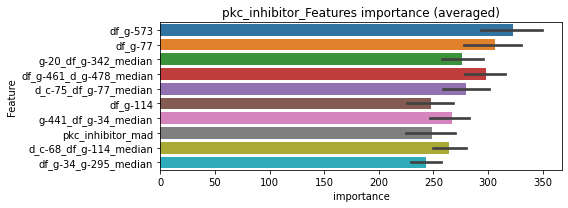

len(train_index) : 2844
len(valid_index) : 949
================================= fold 1/4 pkc_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0855302	valid_1's binary_logloss: 0.113647
[200]	training's binary_logloss: 0.0268855	valid_1's binary_logloss: 0.0492788
[300]	training's binary_logloss: 0.00982912	valid_1's binary_logloss: 0.0268692
[400]	training's binary_logloss: 0.00407063	valid_1's binary_logloss: 0.0174703
[500]	training's binary_logloss: 0.00207576	valid_1's binary_logloss: 0.0134708
[600]	training's binary_logloss: 0.00129703	valid_1's binary_logloss: 0.0119621
[700]	training's binary_logloss: 0.000930055	valid_1's binary_logloss: 0.0112953
[800]	training's binary_logloss: 0.000729531	valid_1's binary_logloss: 0.0109421
Early stopping, best iteration is:
[778]	training's binary_logloss: 0.000765252	valid_1's binary_logloss: 0.0108369


len(train_index) : 2845
len(valid_index) : 948
================================= fold 2/4 pkc_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0856591	valid_1's binary_logloss: 0.108844
[200]	training's binary_logloss: 0.0273515	valid_1's binary_logloss: 0.0453531
[300]	training's binary_logloss: 0.00984965	valid_1's binary_logloss: 0.0232745
[400]	training's binary_logloss: 0.00409596	valid_1's binary_logloss: 0.0140488
[500]	training's binary_logloss: 0.00209179	valid_1's binary_logloss: 0.0100074
[600]	training's binary_logloss: 0.00129973	valid_1's binary_logloss: 0.00800607
[700]	training's binary_logloss: 0.000922556	valid_1's binary_logloss: 0.00703398
[800]	training's binary_logloss: 0.000725019	valid_1's binary_logloss: 0.00654845
[900]	training's binary_logloss: 0.000614066	valid_1's binary_logloss: 0.00606272
[1000]	training's binary_logloss: 0.00057539	valid_1's binary_logloss: 0.00593332
Early stopping, best iteration is:
[1053]	training's binary_logloss: 0.000562827	valid_1's binary_logloss: 0.00591393


len(train_index) : 2845
len(valid_index) : 948
================================= fold 3/4 pkc_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.082772	valid_1's binary_logloss: 0.126992
[200]	training's binary_logloss: 0.0254749	valid_1's binary_logloss: 0.0649296
[300]	training's binary_logloss: 0.00903717	valid_1's binary_logloss: 0.0417418
[400]	training's binary_logloss: 0.00380884	valid_1's binary_logloss: 0.0330765
[500]	training's binary_logloss: 0.00196271	valid_1's binary_logloss: 0.0293829
[600]	training's binary_logloss: 0.00123518	valid_1's binary_logloss: 0.0279365
[700]	training's binary_logloss: 0.000891905	valid_1's binary_logloss: 0.0274333
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.000957514	valid_1's binary_logloss: 0.027316


len(train_index) : 2845
len(valid_index) : 948
================================= fold 4/4 pkc_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0836767	valid_1's binary_logloss: 0.109093
[200]	training's binary_logloss: 0.0265583	valid_1's binary_logloss: 0.0446218
[300]	training's binary_logloss: 0.00958798	valid_1's binary_logloss: 0.0213948
[400]	training's binary_logloss: 0.00403868	valid_1's binary_logloss: 0.0127603
[500]	training's binary_logloss: 0.00207804	valid_1's binary_logloss: 0.00863424
[600]	training's binary_logloss: 0.0013001	valid_1's binary_logloss: 0.00694606
[700]	training's binary_logloss: 0.000930793	valid_1's binary_logloss: 0.00595536
[800]	training's binary_logloss: 0.000727411	valid_1's binary_logloss: 0.00548237
[900]	training's binary_logloss: 0.000621824	valid_1's binary_logloss: 0.00515152
Early stopping, best iteration is:
[913]	training's binary_logloss: 0.000610272	valid_1's binary_logloss: 0.00512401


pkc_inhibitor logloss: 0.012297335938836714
potassium_channel_activator, len(trt): 55, len(othr): 3281, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131459	valid_1's binary_logloss: 0.188569
[200]	training's binary_logloss: 0.0586863	valid_1's binary_logloss: 0.120019
[300]	training's binary_logloss: 0.0289264	valid_1's binary_logloss: 0.0851778
[400]	training's binary_logloss: 0.0144859	valid_1's binary_logloss: 0.0632876
[500]	training's binary_logloss: 0.00761798	valid_1's binary_logloss: 0.0514345
[600]	training's binary_logloss: 0.00426759	valid_1's binary_logloss: 0.0437993
[700]	training's binary_logloss: 0.00269066	valid_1's binary_logloss: 0.0398299
[800]	training's binary_logloss: 0.00188984	valid_1's binary_logloss: 0.0373693
[900]	training's binary_logloss: 0.0014414	valid_1's binary_logloss: 0.0359715
[1000]	training's binary_logloss: 0.00118442	valid_1's binary_logloss: 0.0351421
[1100]	training's binary_logloss: 0.00102641	valid_1's binary_logloss: 0.0344685
Early stopping, best iteration is:
[1107]	training's binary_loglo

1 / 3 AUC score:0.998
y_Threshold: 0.0212261, Threshold: 0.1257049, pos_neg_ratio: 0.8000000
Remove_noisy_data: 146 → Positive_corect_labels: 649/3791
p_label_rate: 0.0100452 Vs.target_rate: 0.00231, Num_p_label: 40.0, conf_0:0.08799, conf_1:0.16342
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_1: 0.1257049
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_2: 0.1557049
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_3: 0.1857049
Num_p_label: 25.0, Expected: 9.2, Adj_threshold_4: 0.2157049
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_5: 0.2457049
threshold: 0.2457049, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129556	valid_1's binary_logloss: 0.186271
[200]	training's binary_logloss: 0.05266	valid_1's binary_logloss: 0.106762
[300]	training's binary_logloss: 0.023458	valid_1's binary_logloss: 0.0708356
[400]	training's binary_logloss: 0.011139	valid_1's binary_logloss: 0.052056
[500]	training's binary_logloss: 0.00575978	valid_1's binary_logloss: 0.0426528
[600]	training's binary_logloss: 0.00331412	valid_1's binary_logloss: 0.0376045
[700]	training's binary_logloss: 0.00217784	valid_1's binary_logloss: 0.034936
[800]	training's binary_logloss: 0.00159343	valid_1's binary_logloss: 0.0335791
[900]	training's binary_logloss: 0.00124727	valid_1's binary_logloss: 0.0326773
[1000]	training's binary_logloss: 0.00103544	valid_1's binary_logloss: 0.0322759
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.00108792	valid_1's binary_logloss: 0.0321915
Training until validation scores don

2 / 3 AUC score:0.999
y_Threshold: 0.1343213, Threshold: 0.2457049, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0160723 Vs.target_rate: 0.00231, Num_p_label: 64.0, conf_0:0.19656, conf_1:0.29485
Num_p_label: 64.0, Expected: 9.2, Adj_threshold_1: 0.2457049
Num_p_label: 52.0, Expected: 9.2, Adj_threshold_2: 0.2757049
Num_p_label: 47.0, Expected: 9.2, Adj_threshold_3: 0.3057049
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_4: 0.3357049
Num_p_label: 36.0, Expected: 9.2, Adj_threshold_5: 0.3657049
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_6: 0.3957049
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_7: 0.4257049
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_8: 0.4557049
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_9: 0.4857049
threshold: 0.4857049, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 639.0/3771, y_label_rate: 0.1694511
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12191	valid_1's binary_logloss: 0.178964
[200]	training's binary_logloss: 0.0483693	valid_1's binary_logloss: 0.105574
[300]	training's binary_logloss: 0.0206349	valid_1's binary_logloss: 0.0754552
[400]	training's binary_logloss: 0.00960079	valid_1's binary_logloss: 0.0597822
[500]	training's binary_logloss: 0.00497696	valid_1's binary_logloss: 0.0528601
[600]	training's binary_logloss: 0.00291126	valid_1's binary_logloss: 0.0488449
[700]	training's binary_logloss: 0.00194383	valid_1's binary_logloss: 0.046828
[800]	training's binary_logloss: 0.00143713	valid_1's binary_logloss: 0.0459961
[900]	training's binary_logloss: 0.00113276	valid_1's binary_logloss: 0.0454456
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.00107484	valid_1's binary_logloss: 0.0451811
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125981	valid_1's

3 / 3 AUC score:0.999
y_Threshold: 0.1461287, Threshold: 0.4857049, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 632.0/3757
p_label_rate: 0.0072828 Vs.target_rate: 0.00231, Num_p_label: 29.0, conf_0:0.43713, conf_1:0.53428
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_1: 0.4857049
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_2: 0.5157049
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_3: 0.5457049
threshold: 0.5457049, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 632.0/3757, y_label_rate: 0.1682193


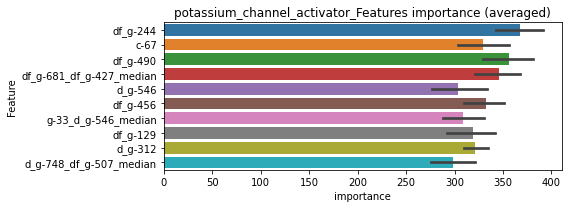

len(train_index) : 2817
len(valid_index) : 940
================================= fold 1/4 potassium_channel_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120774	valid_1's binary_logloss: 0.173659
[200]	training's binary_logloss: 0.0466114	valid_1's binary_logloss: 0.0948317
[300]	training's binary_logloss: 0.0212217	valid_1's binary_logloss: 0.0638344
[400]	training's binary_logloss: 0.0100569	valid_1's binary_logloss: 0.0476948
[500]	training's binary_logloss: 0.00505821	valid_1's binary_logloss: 0.0385328
[600]	training's binary_logloss: 0.00293617	valid_1's binary_logloss: 0.0345221
[700]	training's binary_logloss: 0.00193316	valid_1's binary_logloss: 0.0324055
[800]	training's binary_logloss: 0.00142581	valid_1's binary_logloss: 0.0317567
[900]	training's binary_logloss: 0.00113	valid_1's binary_logloss: 0.0313714
Early stopping, best iteration is:
[882]	training's binary_logloss: 0.00116567	valid_1's binary_logloss: 0.031216


len(train_index) : 2818
len(valid_index) : 939
================================= fold 2/4 potassium_channel_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125699	valid_1's binary_logloss: 0.168185
[200]	training's binary_logloss: 0.0499058	valid_1's binary_logloss: 0.0910277
[300]	training's binary_logloss: 0.0214945	valid_1's binary_logloss: 0.0550152
[400]	training's binary_logloss: 0.00995777	valid_1's binary_logloss: 0.0371657
[500]	training's binary_logloss: 0.00512591	valid_1's binary_logloss: 0.0265987
[600]	training's binary_logloss: 0.00300627	valid_1's binary_logloss: 0.0209252
[700]	training's binary_logloss: 0.0019736	valid_1's binary_logloss: 0.0172227
[800]	training's binary_logloss: 0.00145732	valid_1's binary_logloss: 0.0154698
[900]	training's binary_logloss: 0.00115063	valid_1's binary_logloss: 0.014302
[1000]	training's binary_logloss: 0.000963434	valid_1's binary_logloss: 0.013579
[1100]	training's binary_logloss: 0.000852769	valid_1's binary_logloss: 0.013247
[1200]	training's binary_logloss: 0.000794026	valid_1's binary_l

len(train_index) : 2818
len(valid_index) : 939
================================= fold 3/4 potassium_channel_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119942	valid_1's binary_logloss: 0.175158
[200]	training's binary_logloss: 0.0480086	valid_1's binary_logloss: 0.0958351
[300]	training's binary_logloss: 0.0210951	valid_1's binary_logloss: 0.0594149
[400]	training's binary_logloss: 0.00976364	valid_1's binary_logloss: 0.0408458
[500]	training's binary_logloss: 0.00496297	valid_1's binary_logloss: 0.030955
[600]	training's binary_logloss: 0.00289395	valid_1's binary_logloss: 0.0258435
[700]	training's binary_logloss: 0.00193009	valid_1's binary_logloss: 0.0230155
[800]	training's binary_logloss: 0.0014275	valid_1's binary_logloss: 0.0208309
[900]	training's binary_logloss: 0.00113295	valid_1's binary_logloss: 0.0191045
[1000]	training's binary_logloss: 0.000952063	valid_1's binary_logloss: 0.0183323
Early stopping, best iteration is:
[1055]	training's binary_logloss: 0.000888631	valid_1's binary_logloss: 0.017772


len(train_index) : 2818
len(valid_index) : 939
================================= fold 4/4 potassium_channel_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122243	valid_1's binary_logloss: 0.170684
[200]	training's binary_logloss: 0.0483774	valid_1's binary_logloss: 0.0975612
[300]	training's binary_logloss: 0.0211418	valid_1's binary_logloss: 0.0639398
[400]	training's binary_logloss: 0.00967957	valid_1's binary_logloss: 0.0456305
[500]	training's binary_logloss: 0.00491802	valid_1's binary_logloss: 0.0361201
[600]	training's binary_logloss: 0.00287669	valid_1's binary_logloss: 0.0303333
[700]	training's binary_logloss: 0.00191471	valid_1's binary_logloss: 0.0266856
[800]	training's binary_logloss: 0.00141322	valid_1's binary_logloss: 0.0246208
[900]	training's binary_logloss: 0.00112206	valid_1's binary_logloss: 0.0232447
[1000]	training's binary_logloss: 0.000941095	valid_1's binary_logloss: 0.0224817
[1100]	training's binary_logloss: 0.000832541	valid_1's binary_logloss: 0.0217921
[1200]	training's binary_logloss: 0.000775864	valid_1's bina

potassium_channel_activator logloss: 0.020834210784315542
potassium_channel_antagonist, len(trt): 98, len(othr): 3278, target_rate: 0.0041152 → Adj_target_rate: 0.0041375


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151622	valid_1's binary_logloss: 0.233874
[200]	training's binary_logloss: 0.0764479	valid_1's binary_logloss: 0.170357
[300]	training's binary_logloss: 0.0400521	valid_1's binary_logloss: 0.136737
[400]	training's binary_logloss: 0.0220255	valid_1's binary_logloss: 0.119388
[500]	training's binary_logloss: 0.0126509	valid_1's binary_logloss: 0.109474
[600]	training's binary_logloss: 0.00747577	valid_1's binary_logloss: 0.102792
[700]	training's binary_logloss: 0.00463352	valid_1's binary_logloss: 0.100077
[800]	training's binary_logloss: 0.00313208	valid_1's binary_logloss: 0.0966324
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.00302732	valid_1's binary_logloss: 0.0963317
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.156177	valid_1's binary_logloss: 0.234215
[200]	training's binary_logloss: 0.0791756	valid_1's binary

1 / 3 AUC score:0.987
y_Threshold: 0.0342700, Threshold: 0.1398032, pos_neg_ratio: 0.8000000
Remove_noisy_data: 198 → Positive_corect_labels: 622/3735
p_label_rate: 0.0100452 Vs.target_rate: 0.00412, Num_p_label: 40.0, conf_0:0.09786, conf_1:0.18174
threshold: 0.1398032, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 622.0/3735, y_label_rate: 0.1665328
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137572	valid_1's binary_logloss: 0.204583
[200]	training's binary_logloss: 0.0648399	valid_1's binary_logloss: 0.138799
[300]	training's binary_logloss: 0.0319762	valid_1's binary_logloss: 0.107637
[400]	training's binary_logloss: 0.0159493	valid_1's binary_logloss: 0.0905572
[500]	training's binary_logloss: 0.00860302	valid_1's binary_logloss: 0.0823757
[600]	training's binary_logloss: 0.00505417	valid_1's binary_logloss: 0.078464
[700]	training's binary_logloss: 0.00323543	valid_1's binary_logloss: 0.076384
[800]	training's binary_logloss: 0.00230275	valid_1's binary_logloss: 0.075622
Early stopping, best iteration is:
[803]	training's binary_logloss: 0.00228502	valid_1's binary_logloss: 0.0755858
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.142737	valid_1's binary_logloss: 0.214266
[200]	training's binary_logloss: 0.0644406	valid_1's bina

2 / 3 AUC score:0.996
y_Threshold: 0.0700716, Threshold: 0.1398032, pos_neg_ratio: 0.8000000
Remove_noisy_data: 58 → Positive_corect_labels: 593.0/3677
p_label_rate: 0.0208438 Vs.target_rate: 0.00412, Num_p_label: 83.0, conf_0:0.11184, conf_1:0.16776
Num_p_label: 83.0, Expected: 16.4, Adj_threshold_1: 0.1398032
Num_p_label: 71.0, Expected: 16.4, Adj_threshold_2: 0.1698032
Num_p_label: 58.0, Expected: 16.4, Adj_threshold_3: 0.1998032
Num_p_label: 53.0, Expected: 16.4, Adj_threshold_4: 0.2298032
Num_p_label: 46.0, Expected: 16.4, Adj_threshold_5: 0.2598032
Num_p_label: 42.0, Expected: 16.4, Adj_threshold_6: 0.2898032
Num_p_label: 36.0, Expected: 16.4, Adj_threshold_7: 0.3198032
Num_p_label: 27.0, Expected: 16.4, Adj_threshold_8: 0.3498032
Num_p_label: 20.0, Expected: 16.4, Adj_threshold_9: 0.3798032
threshold: 0.3798032, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 593.0/3677, y_label_rate: 0.1612728
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128507	valid_1's binary_logloss: 0.194634
[200]	training's binary_logloss: 0.0562173	valid_1's binary_logloss: 0.127709
[300]	training's binary_logloss: 0.0260238	valid_1's binary_logloss: 0.0971865
[400]	training's binary_logloss: 0.0124843	valid_1's binary_logloss: 0.081649
[500]	training's binary_logloss: 0.00667215	valid_1's binary_logloss: 0.0739223
[600]	training's binary_logloss: 0.00393625	valid_1's binary_logloss: 0.0692875
[700]	training's binary_logloss: 0.00260772	valid_1's binary_logloss: 0.0668437
Early stopping, best iteration is:
[762]	training's binary_logloss: 0.00210783	valid_1's binary_logloss: 0.0655382
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132264	valid_1's binary_logloss: 0.192617
[200]	training's binary_logloss: 0.0582715	valid_1's binary_logloss: 0.122959
[300]	training's binary_logloss: 0.0277048	valid_1's bin

3 / 3 AUC score:0.993
y_Threshold: 0.0591014, Threshold: 0.3798032, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 571.0/3633
p_label_rate: 0.0065294 Vs.target_rate: 0.00412, Num_p_label: 26.0, conf_0:0.34182, conf_1:0.41778
threshold: 0.3798032, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 571.0/3633, y_label_rate: 0.1571704


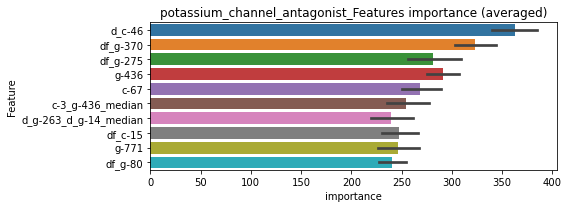

len(train_index) : 2724
len(valid_index) : 909
================================= fold 1/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123136	valid_1's binary_logloss: 0.191432
[200]	training's binary_logloss: 0.0510717	valid_1's binary_logloss: 0.121007
[300]	training's binary_logloss: 0.0239694	valid_1's binary_logloss: 0.0902291
[400]	training's binary_logloss: 0.0114369	valid_1's binary_logloss: 0.0727937
[500]	training's binary_logloss: 0.0059512	valid_1's binary_logloss: 0.0637189
[600]	training's binary_logloss: 0.00347391	valid_1's binary_logloss: 0.0602852
[700]	training's binary_logloss: 0.00229322	valid_1's binary_logloss: 0.0574585
[800]	training's binary_logloss: 0.00168047	valid_1's binary_logloss: 0.056188
[900]	training's binary_logloss: 0.00132966	valid_1's binary_logloss: 0.0550174
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.00133121	valid_1's binary_logloss: 0.0549956


len(train_index) : 2725
len(valid_index) : 908
================================= fold 2/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124852	valid_1's binary_logloss: 0.178798
[200]	training's binary_logloss: 0.0537047	valid_1's binary_logloss: 0.109257
[300]	training's binary_logloss: 0.0247157	valid_1's binary_logloss: 0.0750205
[400]	training's binary_logloss: 0.0116179	valid_1's binary_logloss: 0.0551062
[500]	training's binary_logloss: 0.00619264	valid_1's binary_logloss: 0.0448183
[600]	training's binary_logloss: 0.00362891	valid_1's binary_logloss: 0.0392518
[700]	training's binary_logloss: 0.00239201	valid_1's binary_logloss: 0.0356447
[800]	training's binary_logloss: 0.00173334	valid_1's binary_logloss: 0.0337703
[900]	training's binary_logloss: 0.00136641	valid_1's binary_logloss: 0.0322126
[1000]	training's binary_logloss: 0.00114155	valid_1's binary_logloss: 0.0315534
[1100]	training's binary_logloss: 0.00101083	valid_1's binary_logloss: 0.0308509
Early stopping, best iteration is:
[1144]	training's binary_logl

len(train_index) : 2725
len(valid_index) : 908
================================= fold 3/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124696	valid_1's binary_logloss: 0.169003
[200]	training's binary_logloss: 0.0532251	valid_1's binary_logloss: 0.103124
[300]	training's binary_logloss: 0.0254717	valid_1's binary_logloss: 0.0721702
[400]	training's binary_logloss: 0.0121967	valid_1's binary_logloss: 0.0542428
[500]	training's binary_logloss: 0.00641619	valid_1's binary_logloss: 0.0443383
[600]	training's binary_logloss: 0.00374605	valid_1's binary_logloss: 0.038913
[700]	training's binary_logloss: 0.00245632	valid_1's binary_logloss: 0.0356459
[800]	training's binary_logloss: 0.00179583	valid_1's binary_logloss: 0.033887
[900]	training's binary_logloss: 0.00139689	valid_1's binary_logloss: 0.0329102
[1000]	training's binary_logloss: 0.00116743	valid_1's binary_logloss: 0.032118
[1100]	training's binary_logloss: 0.00102786	valid_1's binary_logloss: 0.0318459
Early stopping, best iteration is:
[1074]	training's binary_logloss

len(train_index) : 2725
len(valid_index) : 908
================================= fold 4/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123434	valid_1's binary_logloss: 0.19197
[200]	training's binary_logloss: 0.0514535	valid_1's binary_logloss: 0.128532
[300]	training's binary_logloss: 0.0232137	valid_1's binary_logloss: 0.0981866
[400]	training's binary_logloss: 0.0111857	valid_1's binary_logloss: 0.0808761
[500]	training's binary_logloss: 0.00585194	valid_1's binary_logloss: 0.0738762
[600]	training's binary_logloss: 0.00347427	valid_1's binary_logloss: 0.070988
[700]	training's binary_logloss: 0.00230556	valid_1's binary_logloss: 0.06916
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.00237374	valid_1's binary_logloss: 0.0689542


potassium_channel_antagonist logloss: 0.04657718609078845
ppar_receptor_agonist, len(trt): 115, len(othr): 3278, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.152829	valid_1's binary_logloss: 0.249897
[200]	training's binary_logloss: 0.0742007	valid_1's binary_logloss: 0.19472
[300]	training's binary_logloss: 0.0387421	valid_1's binary_logloss: 0.169739
[400]	training's binary_logloss: 0.0214185	valid_1's binary_logloss: 0.160554
[500]	training's binary_logloss: 0.0120803	valid_1's binary_logloss: 0.155482
[600]	training's binary_logloss: 0.00712471	valid_1's binary_logloss: 0.154123
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00828935	valid_1's binary_logloss: 0.153585
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.160078	valid_1's binary_logloss: 0.237456
[200]	training's binary_logloss: 0.0810869	valid_1's binary_logloss: 0.175159
[300]	training's binary_logloss: 0.0441012	valid_1's binary_logloss: 0.142929
[400]	training's binary_logloss: 0.0246737	valid_1's binary_logl

1 / 3 AUC score:0.973
y_Threshold: 0.0582282, Threshold: 0.2215069, pos_neg_ratio: 0.8000000
Remove_noisy_data: 236 → Positive_corect_labels: 603/3697
p_label_rate: 0.0100452 Vs.target_rate: 0.00483, Num_p_label: 40.0, conf_0:0.15505, conf_1:0.28796
threshold: 0.2215069, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 603.0/3697, y_label_rate: 0.1631052
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129389	valid_1's binary_logloss: 0.201122
[200]	training's binary_logloss: 0.0537071	valid_1's binary_logloss: 0.128551
[300]	training's binary_logloss: 0.0258665	valid_1's binary_logloss: 0.0943713
[400]	training's binary_logloss: 0.013094	valid_1's binary_logloss: 0.0766946
[500]	training's binary_logloss: 0.00692551	valid_1's binary_logloss: 0.0667368
[600]	training's binary_logloss: 0.00405827	valid_1's binary_logloss: 0.0607991
[700]	training's binary_logloss: 0.00265729	valid_1's binary_logloss: 0.0579945
[800]	training's binary_logloss: 0.0019034	valid_1's binary_logloss: 0.0565647
[900]	training's binary_logloss: 0.00148345	valid_1's binary_logloss: 0.0555034
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00149666	valid_1's binary_logloss: 0.0554873
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133396	valid_1's 

2 / 3 AUC score:0.993
y_Threshold: 0.1067589, Threshold: 0.2215069, pos_neg_ratio: 0.8000000
Remove_noisy_data: 74 → Positive_corect_labels: 566.0/3623
p_label_rate: 0.0271220 Vs.target_rate: 0.00483, Num_p_label: 108.0, conf_0:0.17721, conf_1:0.26581
Num_p_label: 108.0, Expected: 19.2, Adj_threshold_1: 0.2215069
Num_p_label: 99.0, Expected: 19.2, Adj_threshold_2: 0.2515069
Num_p_label: 92.0, Expected: 19.2, Adj_threshold_3: 0.2815069
Num_p_label: 86.0, Expected: 19.2, Adj_threshold_4: 0.3115069
Num_p_label: 79.0, Expected: 19.2, Adj_threshold_5: 0.3415069
Num_p_label: 78.0, Expected: 19.2, Adj_threshold_6: 0.3715069
Num_p_label: 75.0, Expected: 19.2, Adj_threshold_7: 0.4015069
Num_p_label: 71.0, Expected: 19.2, Adj_threshold_8: 0.4315069
Num_p_label: 62.0, Expected: 19.2, Adj_threshold_9: 0.4615069
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_10: 0.4915069
threshold: 0.5215069, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 566.0/3623, y_label_rate: 0.15622

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111732	valid_1's binary_logloss: 0.164367
[200]	training's binary_logloss: 0.0438503	valid_1's binary_logloss: 0.100103
[300]	training's binary_logloss: 0.0198837	valid_1's binary_logloss: 0.0753746
[400]	training's binary_logloss: 0.00942007	valid_1's binary_logloss: 0.0632528
[500]	training's binary_logloss: 0.00487145	valid_1's binary_logloss: 0.0574216
[600]	training's binary_logloss: 0.00289915	valid_1's binary_logloss: 0.0552306
[700]	training's binary_logloss: 0.00194369	valid_1's binary_logloss: 0.054175
[800]	training's binary_logloss: 0.00144564	valid_1's binary_logloss: 0.0532928
Early stopping, best iteration is:
[801]	training's binary_logloss: 0.00144233	valid_1's binary_logloss: 0.0532746
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109592	valid_1's binary_logloss: 0.161067
[200]	training's binary_logloss: 0.044412	valid_1's b

3 / 3 AUC score:0.990
y_Threshold: 0.1145775, Threshold: 0.5215069, pos_neg_ratio: 0.8000000
Remove_noisy_data: 52 → Positive_corect_labels: 540.0/3571
p_label_rate: 0.0208438 Vs.target_rate: 0.00483, Num_p_label: 83.0, conf_0:0.46936, conf_1:0.57366
Num_p_label: 83.0, Expected: 19.2, Adj_threshold_1: 0.5215069
Num_p_label: 81.0, Expected: 19.2, Adj_threshold_2: 0.5515069
Num_p_label: 76.0, Expected: 19.2, Adj_threshold_3: 0.5815069
Num_p_label: 75.0, Expected: 19.2, Adj_threshold_4: 0.6115069
Num_p_label: 72.0, Expected: 19.2, Adj_threshold_5: 0.6415069
Num_p_label: 67.0, Expected: 19.2, Adj_threshold_6: 0.6715069
threshold: 0.6715069, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 540.0/3571, y_label_rate: 0.1512181


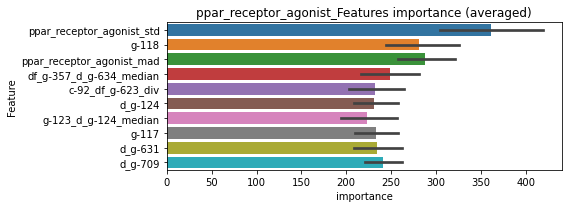

len(train_index) : 2678
len(valid_index) : 893
================================= fold 1/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101627	valid_1's binary_logloss: 0.166626
[200]	training's binary_logloss: 0.0382487	valid_1's binary_logloss: 0.112836
[300]	training's binary_logloss: 0.0157748	valid_1's binary_logloss: 0.0942466
[400]	training's binary_logloss: 0.00708021	valid_1's binary_logloss: 0.0861833
[500]	training's binary_logloss: 0.00357665	valid_1's binary_logloss: 0.0835665
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00278291	valid_1's binary_logloss: 0.0828029


len(train_index) : 2678
len(valid_index) : 893
================================= fold 2/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0994225	valid_1's binary_logloss: 0.1583
[200]	training's binary_logloss: 0.0366584	valid_1's binary_logloss: 0.091475
[300]	training's binary_logloss: 0.0153039	valid_1's binary_logloss: 0.064706
[400]	training's binary_logloss: 0.00685158	valid_1's binary_logloss: 0.0506022
[500]	training's binary_logloss: 0.00357406	valid_1's binary_logloss: 0.0435886
[600]	training's binary_logloss: 0.00217705	valid_1's binary_logloss: 0.0401491
[700]	training's binary_logloss: 0.00151679	valid_1's binary_logloss: 0.0388328
[800]	training's binary_logloss: 0.00115935	valid_1's binary_logloss: 0.0374654
Early stopping, best iteration is:
[859]	training's binary_logloss: 0.00102712	valid_1's binary_logloss: 0.0367268


len(train_index) : 2678
len(valid_index) : 893
================================= fold 3/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0966218	valid_1's binary_logloss: 0.144708
[200]	training's binary_logloss: 0.0372863	valid_1's binary_logloss: 0.0893951
[300]	training's binary_logloss: 0.0154471	valid_1's binary_logloss: 0.0655333
[400]	training's binary_logloss: 0.00696689	valid_1's binary_logloss: 0.0545897
[500]	training's binary_logloss: 0.00353802	valid_1's binary_logloss: 0.0497191
[600]	training's binary_logloss: 0.00215832	valid_1's binary_logloss: 0.0477087
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00168616	valid_1's binary_logloss: 0.0469363


len(train_index) : 2679
len(valid_index) : 892
================================= fold 4/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103805	valid_1's binary_logloss: 0.143518
[200]	training's binary_logloss: 0.0404988	valid_1's binary_logloss: 0.0856727
[300]	training's binary_logloss: 0.0172866	valid_1's binary_logloss: 0.0604108
[400]	training's binary_logloss: 0.00789932	valid_1's binary_logloss: 0.0469991
[500]	training's binary_logloss: 0.00399089	valid_1's binary_logloss: 0.0398456
[600]	training's binary_logloss: 0.00238519	valid_1's binary_logloss: 0.0360348
[700]	training's binary_logloss: 0.00161017	valid_1's binary_logloss: 0.0334639
[800]	training's binary_logloss: 0.00121988	valid_1's binary_logloss: 0.0320584
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00107669	valid_1's binary_logloss: 0.0312893


ppar_receptor_agonist logloss: 0.04944393655063076
ppar_receptor_antagonist, len(trt): 30, len(othr): 3282, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0888527	valid_1's binary_logloss: 0.118155
[200]	training's binary_logloss: 0.0307045	valid_1's binary_logloss: 0.054012
[300]	training's binary_logloss: 0.011567	valid_1's binary_logloss: 0.0294398
[400]	training's binary_logloss: 0.00484694	valid_1's binary_logloss: 0.0186645
[500]	training's binary_logloss: 0.00240154	valid_1's binary_logloss: 0.0136572
[600]	training's binary_logloss: 0.00144251	valid_1's binary_logloss: 0.0109653
[700]	training's binary_logloss: 0.00100358	valid_1's binary_logloss: 0.00937738
[800]	training's binary_logloss: 0.000773375	valid_1's binary_logloss: 0.00849675
[900]	training's binary_logloss: 0.000647728	valid_1's binary_logloss: 0.00808272
[1000]	training's binary_logloss: 0.000592537	valid_1's binary_logloss: 0.00787248
[1100]	training's binary_logloss: 0.000575865	valid_1's binary_logloss: 0.00780564
Early stopping, best iteration is:
[1101]	training's b

1 / 3 AUC score:0.999
y_Threshold: 0.0086458, Threshold: 0.0399077, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3800
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.02794, conf_1:0.05188
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0399077
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_2: 0.0699077
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_3: 0.0999077
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_4: 0.1299077
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_5: 0.1599077
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_6: 0.1899077
threshold: 0.1899077, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0834414	valid_1's binary_logloss: 0.113136
[200]	training's binary_logloss: 0.0248604	valid_1's binary_logloss: 0.0489224
[300]	training's binary_logloss: 0.00908254	valid_1's binary_logloss: 0.0266732
[400]	training's binary_logloss: 0.00372025	valid_1's binary_logloss: 0.0168791
[500]	training's binary_logloss: 0.00187335	valid_1's binary_logloss: 0.0124439
[600]	training's binary_logloss: 0.00116926	valid_1's binary_logloss: 0.0103638
[700]	training's binary_logloss: 0.000836179	valid_1's binary_logloss: 0.00924647
[800]	training's binary_logloss: 0.000653465	valid_1's binary_logloss: 0.00844161
[900]	training's binary_logloss: 0.000564416	valid_1's binary_logloss: 0.00814447
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.000541261	valid_1's binary_logloss: 0.0080447
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0866

2 / 3 AUC score:1.000
y_Threshold: 0.1468247, Threshold: 0.1899077, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 652.0/3798
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.15193, conf_1:0.22789
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.1899077
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_2: 0.2199077
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_3: 0.2499077
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_4: 0.2799077
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_5: 0.3099077
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_6: 0.3399077
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_7: 0.3699077
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_8: 0.3999077
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_9: 0.4299077
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_10: 0.4599077
threshold: 0.4899077, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 652.0/3798, y_label_rate: 0.1716693
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843139	valid_1's binary_logloss: 0.112032
[200]	training's binary_logloss: 0.0254109	valid_1's binary_logloss: 0.0460058
[300]	training's binary_logloss: 0.00904951	valid_1's binary_logloss: 0.0221083
[400]	training's binary_logloss: 0.00372789	valid_1's binary_logloss: 0.0123239
[500]	training's binary_logloss: 0.00187668	valid_1's binary_logloss: 0.00842393
[600]	training's binary_logloss: 0.00116246	valid_1's binary_logloss: 0.00626623
[700]	training's binary_logloss: 0.00082217	valid_1's binary_logloss: 0.00522672
[800]	training's binary_logloss: 0.000643017	valid_1's binary_logloss: 0.0045539
[900]	training's binary_logloss: 0.000554014	valid_1's binary_logloss: 0.00416795
[1000]	training's binary_logloss: 0.000523764	valid_1's binary_logloss: 0.00404898
[1100]	training's binary_logloss: 0.000512051	valid_1's binary_logloss: 0.00398456
Early stopping, best iteration is:
[1118]	training

3 / 3 AUC score:1.000
y_Threshold: 0.1585558, Threshold: 0.4899077, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 649.0/3792
p_label_rate: 0.0052737 Vs.target_rate: 0.00126, Num_p_label: 21.0, conf_0:0.44092, conf_1:0.53890
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_1: 0.4899077
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_2: 0.5199077
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_3: 0.5499077
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_4: 0.5799077
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_5: 0.6099077
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_6: 0.6399077
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_7: 0.6699077
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_8: 0.6999077
threshold: 0.6999077, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 649.0/3792, y_label_rate: 0.1711498


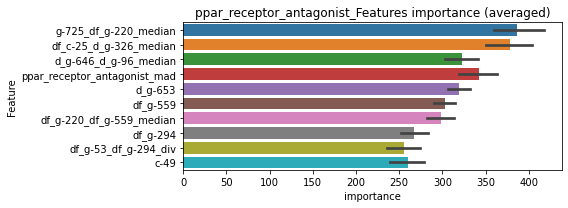

len(train_index) : 2844
len(valid_index) : 948
================================= fold 1/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0834956	valid_1's binary_logloss: 0.113435
[200]	training's binary_logloss: 0.0253908	valid_1's binary_logloss: 0.0487265
[300]	training's binary_logloss: 0.00889927	valid_1's binary_logloss: 0.0245368
[400]	training's binary_logloss: 0.00359898	valid_1's binary_logloss: 0.0141464
[500]	training's binary_logloss: 0.00179104	valid_1's binary_logloss: 0.0096087
[600]	training's binary_logloss: 0.00110051	valid_1's binary_logloss: 0.00767559
[700]	training's binary_logloss: 0.000783779	valid_1's binary_logloss: 0.0066476
[800]	training's binary_logloss: 0.000617445	valid_1's binary_logloss: 0.0061178
[900]	training's binary_logloss: 0.000537691	valid_1's binary_logloss: 0.00581865
Early stopping, best iteration is:
[876]	training's binary_logloss: 0.000546998	valid_1's binary_logloss: 0.00581394


len(train_index) : 2844
len(valid_index) : 948
================================= fold 2/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0829563	valid_1's binary_logloss: 0.107901
[200]	training's binary_logloss: 0.0245793	valid_1's binary_logloss: 0.0429062
[300]	training's binary_logloss: 0.00843681	valid_1's binary_logloss: 0.0206795
[400]	training's binary_logloss: 0.00346773	valid_1's binary_logloss: 0.012311
[500]	training's binary_logloss: 0.00177042	valid_1's binary_logloss: 0.00868542
[600]	training's binary_logloss: 0.00109942	valid_1's binary_logloss: 0.00694672
[700]	training's binary_logloss: 0.000782992	valid_1's binary_logloss: 0.00604642
[800]	training's binary_logloss: 0.000620065	valid_1's binary_logloss: 0.00540599
[900]	training's binary_logloss: 0.000540084	valid_1's binary_logloss: 0.00513169
[1000]	training's binary_logloss: 0.000509711	valid_1's binary_logloss: 0.00504471
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.000509711	valid_1's binary_logloss: 0.00504471


len(train_index) : 2844
len(valid_index) : 948
================================= fold 3/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0852395	valid_1's binary_logloss: 0.112831
[200]	training's binary_logloss: 0.0252898	valid_1's binary_logloss: 0.0452473
[300]	training's binary_logloss: 0.00875052	valid_1's binary_logloss: 0.0214723
[400]	training's binary_logloss: 0.00358934	valid_1's binary_logloss: 0.0133065
[500]	training's binary_logloss: 0.00181889	valid_1's binary_logloss: 0.0101934
[600]	training's binary_logloss: 0.00113256	valid_1's binary_logloss: 0.00902711
[700]	training's binary_logloss: 0.000807276	valid_1's binary_logloss: 0.00802809
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000807276	valid_1's binary_logloss: 0.00802809


len(train_index) : 2844
len(valid_index) : 948
================================= fold 4/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0837232	valid_1's binary_logloss: 0.111617
[200]	training's binary_logloss: 0.0248908	valid_1's binary_logloss: 0.0474192
[300]	training's binary_logloss: 0.0087277	valid_1's binary_logloss: 0.0243189
[400]	training's binary_logloss: 0.00354397	valid_1's binary_logloss: 0.0149502
[500]	training's binary_logloss: 0.00179892	valid_1's binary_logloss: 0.0107517
[600]	training's binary_logloss: 0.00111382	valid_1's binary_logloss: 0.00895737
[700]	training's binary_logloss: 0.00079545	valid_1's binary_logloss: 0.00809707
[800]	training's binary_logloss: 0.000622383	valid_1's binary_logloss: 0.00747702
[900]	training's binary_logloss: 0.00053524	valid_1's binary_logloss: 0.00727483
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000539679	valid_1's binary_logloss: 0.00724696


ppar_receptor_antagonist logloss: 0.006533424620367714


neg labels: 3289 → selected neg labels: 3270


progesterone_receptor_agonist, len(trt): 119, len(othr): 3270, target_rate: 0.0049971 → Adj_target_rate: 0.0048799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.168971	valid_1's binary_logloss: 0.264346
[200]	training's binary_logloss: 0.0840873	valid_1's binary_logloss: 0.203562
[300]	training's binary_logloss: 0.0452697	valid_1's binary_logloss: 0.173207
[400]	training's binary_logloss: 0.0259144	valid_1's binary_logloss: 0.157521
[500]	training's binary_logloss: 0.0154621	valid_1's binary_logloss: 0.14939
[600]	training's binary_logloss: 0.00919391	valid_1's binary_logloss: 0.146061
[700]	training's binary_logloss: 0.00585653	valid_1's binary_logloss: 0.143445
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.00632613	valid_1's binary_logloss: 0.143107
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.172485	valid_1's binary_logloss: 0.263239
[200]	training's binary_logloss: 0.0826712	valid_1's binary_logloss: 0.187122
[300]	training's binary_logloss: 0.0441714	valid_1's binary_log

1 / 3 AUC score:0.978
y_Threshold: 0.0496534, Threshold: 0.2882219, pos_neg_ratio: 0.8000000
Remove_noisy_data: 209 → Positive_corect_labels: 615/3715
p_label_rate: 0.0100452 Vs.target_rate: 0.00500, Num_p_label: 40.0, conf_0:0.20176, conf_1:0.37469
threshold: 0.2882219, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 615.0/3715, y_label_rate: 0.1655451
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149049	valid_1's binary_logloss: 0.23695
[200]	training's binary_logloss: 0.0653766	valid_1's binary_logloss: 0.166562
[300]	training's binary_logloss: 0.0311499	valid_1's binary_logloss: 0.130041
[400]	training's binary_logloss: 0.0161648	valid_1's binary_logloss: 0.113209
[500]	training's binary_logloss: 0.00877036	valid_1's binary_logloss: 0.101629
[600]	training's binary_logloss: 0.00522483	valid_1's binary_logloss: 0.0954825
[700]	training's binary_logloss: 0.00342885	valid_1's binary_logloss: 0.0914658
[800]	training's binary_logloss: 0.0024408	valid_1's binary_logloss: 0.0880456
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.00205112	valid_1's binary_logloss: 0.0873333
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149892	valid_1's binary_logloss: 0.218076
[200]	training's binary_logloss: 0.0646729	valid_1's binar

2 / 3 AUC score:0.995
y_Threshold: 0.0954469, Threshold: 0.2882219, pos_neg_ratio: 0.8000000
Remove_noisy_data: 64 → Positive_corect_labels: 583.0/3651
p_label_rate: 0.0253641 Vs.target_rate: 0.00500, Num_p_label: 101.0, conf_0:0.23058, conf_1:0.34587
Num_p_label: 101.0, Expected: 19.9, Adj_threshold_1: 0.2882219
Num_p_label: 88.0, Expected: 19.9, Adj_threshold_2: 0.3182219
Num_p_label: 78.0, Expected: 19.9, Adj_threshold_3: 0.3482219
Num_p_label: 69.0, Expected: 19.9, Adj_threshold_4: 0.3782219
Num_p_label: 61.0, Expected: 19.9, Adj_threshold_5: 0.4082219
Num_p_label: 55.0, Expected: 19.9, Adj_threshold_6: 0.4382219
Num_p_label: 50.0, Expected: 19.9, Adj_threshold_7: 0.4682219
Num_p_label: 44.0, Expected: 19.9, Adj_threshold_8: 0.4982219
Num_p_label: 39.0, Expected: 19.9, Adj_threshold_9: 0.5282219
Num_p_label: 34.0, Expected: 19.9, Adj_threshold_10: 0.5582219
threshold: 0.5882219, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 583.0/3651, y_label_rate: 0.15968

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132438	valid_1's binary_logloss: 0.229409
[200]	training's binary_logloss: 0.0537638	valid_1's binary_logloss: 0.164455
[300]	training's binary_logloss: 0.0253105	valid_1's binary_logloss: 0.132389
[400]	training's binary_logloss: 0.0127863	valid_1's binary_logloss: 0.115751
[500]	training's binary_logloss: 0.00695196	valid_1's binary_logloss: 0.107115
[600]	training's binary_logloss: 0.00417366	valid_1's binary_logloss: 0.102149
[700]	training's binary_logloss: 0.00279255	valid_1's binary_logloss: 0.100824
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00302109	valid_1's binary_logloss: 0.100449
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134046	valid_1's binary_logloss: 0.217964
[200]	training's binary_logloss: 0.055408	valid_1's binary_logloss: 0.145596
[300]	training's binary_logloss: 0.0264311	valid_1's binary_lo

3 / 3 AUC score:0.994
y_Threshold: 0.0845811, Threshold: 0.5882219, pos_neg_ratio: 0.8000000
Remove_noisy_data: 66 → Positive_corect_labels: 550.0/3585
p_label_rate: 0.0097941 Vs.target_rate: 0.00500, Num_p_label: 39.0, conf_0:0.50000, conf_1:0.64704
threshold: 0.5882219, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 550.0/3585, y_label_rate: 0.1534170


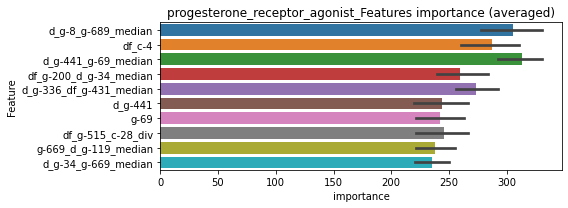

len(train_index) : 2688
len(valid_index) : 897
================================= fold 1/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123642	valid_1's binary_logloss: 0.199428
[200]	training's binary_logloss: 0.0499234	valid_1's binary_logloss: 0.136839
[300]	training's binary_logloss: 0.0226406	valid_1's binary_logloss: 0.10686
[400]	training's binary_logloss: 0.0110925	valid_1's binary_logloss: 0.0923747
[500]	training's binary_logloss: 0.00600994	valid_1's binary_logloss: 0.0856831
[600]	training's binary_logloss: 0.00360524	valid_1's binary_logloss: 0.0807743
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00275978	valid_1's binary_logloss: 0.0791079


len(train_index) : 2689
len(valid_index) : 896
================================= fold 2/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125822	valid_1's binary_logloss: 0.17412
[200]	training's binary_logloss: 0.0510048	valid_1's binary_logloss: 0.102255
[300]	training's binary_logloss: 0.0229389	valid_1's binary_logloss: 0.0704536
[400]	training's binary_logloss: 0.0111618	valid_1's binary_logloss: 0.0547024
[500]	training's binary_logloss: 0.00604441	valid_1's binary_logloss: 0.0455112
[600]	training's binary_logloss: 0.00367003	valid_1's binary_logloss: 0.040318
[700]	training's binary_logloss: 0.00247622	valid_1's binary_logloss: 0.0364958
[800]	training's binary_logloss: 0.00183368	valid_1's binary_logloss: 0.0344359
[900]	training's binary_logloss: 0.00145924	valid_1's binary_logloss: 0.0328745
[1000]	training's binary_logloss: 0.00122856	valid_1's binary_logloss: 0.0316383
[1100]	training's binary_logloss: 0.00107558	valid_1's binary_logloss: 0.0311103
[1200]	training's binary_logloss: 0.000987056	valid_1's binary_log

len(train_index) : 2689
len(valid_index) : 896
================================= fold 3/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12772	valid_1's binary_logloss: 0.197704
[200]	training's binary_logloss: 0.0527005	valid_1's binary_logloss: 0.124611
[300]	training's binary_logloss: 0.0235074	valid_1's binary_logloss: 0.0914576
[400]	training's binary_logloss: 0.0114026	valid_1's binary_logloss: 0.0728952
[500]	training's binary_logloss: 0.00612474	valid_1's binary_logloss: 0.0629778
[600]	training's binary_logloss: 0.00367137	valid_1's binary_logloss: 0.0576113
[700]	training's binary_logloss: 0.0024853	valid_1's binary_logloss: 0.0549696
[800]	training's binary_logloss: 0.00183968	valid_1's binary_logloss: 0.0539563
Early stopping, best iteration is:
[771]	training's binary_logloss: 0.00199441	valid_1's binary_logloss: 0.0539101


len(train_index) : 2689
len(valid_index) : 896
================================= fold 4/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123727	valid_1's binary_logloss: 0.190112
[200]	training's binary_logloss: 0.0505355	valid_1's binary_logloss: 0.122554
[300]	training's binary_logloss: 0.0223539	valid_1's binary_logloss: 0.0915207
[400]	training's binary_logloss: 0.0109967	valid_1's binary_logloss: 0.0770754
[500]	training's binary_logloss: 0.00597525	valid_1's binary_logloss: 0.0675872
[600]	training's binary_logloss: 0.00362004	valid_1's binary_logloss: 0.0639771
[700]	training's binary_logloss: 0.00245704	valid_1's binary_logloss: 0.0614384
Early stopping, best iteration is:
[761]	training's binary_logloss: 0.00202395	valid_1's binary_logloss: 0.0603003


progesterone_receptor_agonist logloss: 0.05581685446318322
progesterone_receptor_antagonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720233	valid_1's binary_logloss: 0.0830261
[200]	training's binary_logloss: 0.0199527	valid_1's binary_logloss: 0.028016
[300]	training's binary_logloss: 0.00633605	valid_1's binary_logloss: 0.012005
[400]	training's binary_logloss: 0.00252832	valid_1's binary_logloss: 0.00650747
[500]	training's binary_logloss: 0.00130726	valid_1's binary_logloss: 0.00439337
[600]	training's binary_logloss: 0.000837506	valid_1's binary_logloss: 0.00355538
[700]	training's binary_logloss: 0.000611054	valid_1's binary_logloss: 0.00301445
[800]	training's binary_logloss: 0.00049414	valid_1's binary_logloss: 0.00280014
[900]	training's binary_logloss: 0.00044711	valid_1's binary_logloss: 0.00267919
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.000445536	valid_1's binary_logloss: 0.00267319
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

1 / 3 AUC score:1.000
y_Threshold: 0.0045147, Threshold: 0.0204982, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01435, conf_1:0.02665
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0204982
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.0504982
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0804982
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.1104982
threshold: 0.1104982, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0682777	valid_1's binary_logloss: 0.0772539
[200]	training's binary_logloss: 0.0167895	valid_1's binary_logloss: 0.022335
[300]	training's binary_logloss: 0.00509958	valid_1's binary_logloss: 0.00821937
[400]	training's binary_logloss: 0.00200446	valid_1's binary_logloss: 0.00396046
[500]	training's binary_logloss: 0.00106976	valid_1's binary_logloss: 0.00243069
[600]	training's binary_logloss: 0.000695038	valid_1's binary_logloss: 0.00171465
[700]	training's binary_logloss: 0.000516109	valid_1's binary_logloss: 0.00136596
[800]	training's binary_logloss: 0.000423481	valid_1's binary_logloss: 0.00115586
[900]	training's binary_logloss: 0.000394603	valid_1's binary_logloss: 0.00110039
[1000]	training's binary_logloss: 0.000385813	valid_1's binary_logloss: 0.00108219
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.000385813	valid_1's binary_logloss: 0.00108219
Training un

2 / 3 AUC score:1.000
y_Threshold: 0.0683317, Threshold: 0.1104982, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0072828 Vs.target_rate: 0.00076, Num_p_label: 29.0, conf_0:0.08840, conf_1:0.13260
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_1: 0.1104982
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.1404982
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_3: 0.1704982
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_4: 0.2004982
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.2304982
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.2604982
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_7: 0.2904982
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.3204982
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_9: 0.3504982
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.3804982
threshold: 0.3804982, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0682777	valid_1's binary_logloss: 0.0772539
[200]	training's binary_logloss: 0.0167895	valid_1's binary_logloss: 0.022335
[300]	training's binary_logloss: 0.00509958	valid_1's binary_logloss: 0.00821937
[400]	training's binary_logloss: 0.00200446	valid_1's binary_logloss: 0.00396046
[500]	training's binary_logloss: 0.00106976	valid_1's binary_logloss: 0.00243069
[600]	training's binary_logloss: 0.000695038	valid_1's binary_logloss: 0.00171465
[700]	training's binary_logloss: 0.000516109	valid_1's binary_logloss: 0.00136596
[800]	training's binary_logloss: 0.000423481	valid_1's binary_logloss: 0.00115586
[900]	training's binary_logloss: 0.000394603	valid_1's binary_logloss: 0.00110039
[1000]	training's binary_logloss: 0.000385813	valid_1's binary_logloss: 0.00108219
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.000385813	valid_1's binary_logloss: 0.00108219
Training un

3 / 3 AUC score:1.000
y_Threshold: 0.0683317, Threshold: 0.3804982, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.34245, conf_1:0.41855
threshold: 0.3804982, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


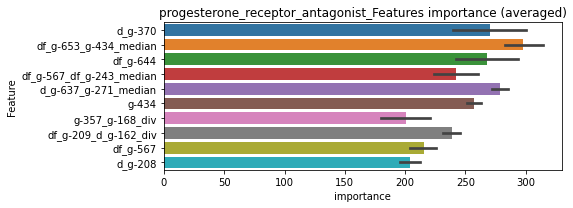

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.069206	valid_1's binary_logloss: 0.0795616
[200]	training's binary_logloss: 0.0169292	valid_1's binary_logloss: 0.0231284
[300]	training's binary_logloss: 0.00515902	valid_1's binary_logloss: 0.00877787
[400]	training's binary_logloss: 0.00203661	valid_1's binary_logloss: 0.00423579
[500]	training's binary_logloss: 0.00107173	valid_1's binary_logloss: 0.00256039
[600]	training's binary_logloss: 0.000701613	valid_1's binary_logloss: 0.00184529
[700]	training's binary_logloss: 0.000521595	valid_1's binary_logloss: 0.0014649
[800]	training's binary_logloss: 0.000425829	valid_1's binary_logloss: 0.00124424
[900]	training's binary_logloss: 0.000393607	valid_1's binary_logloss: 0.00117126
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000393607	valid_1's binary_logloss: 0.00117126


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0676911	valid_1's binary_logloss: 0.0818083
[200]	training's binary_logloss: 0.0167498	valid_1's binary_logloss: 0.0277811
[300]	training's binary_logloss: 0.0050422	valid_1's binary_logloss: 0.0129098
[400]	training's binary_logloss: 0.00199833	valid_1's binary_logloss: 0.00724816
[500]	training's binary_logloss: 0.00105882	valid_1's binary_logloss: 0.00503727
[600]	training's binary_logloss: 0.000690099	valid_1's binary_logloss: 0.00411131
[700]	training's binary_logloss: 0.00051666	valid_1's binary_logloss: 0.00365596
[800]	training's binary_logloss: 0.000423815	valid_1's binary_logloss: 0.00342441
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.000417807	valid_1's binary_logloss: 0.00339964


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0678689	valid_1's binary_logloss: 0.0792613
[200]	training's binary_logloss: 0.0167138	valid_1's binary_logloss: 0.0225938
[300]	training's binary_logloss: 0.00510584	valid_1's binary_logloss: 0.00815272
[400]	training's binary_logloss: 0.0020102	valid_1's binary_logloss: 0.00380932
[500]	training's binary_logloss: 0.00105905	valid_1's binary_logloss: 0.0023228
[600]	training's binary_logloss: 0.00068541	valid_1's binary_logloss: 0.00165278
[700]	training's binary_logloss: 0.00050968	valid_1's binary_logloss: 0.0013301
[800]	training's binary_logloss: 0.000423117	valid_1's binary_logloss: 0.00117272
[900]	training's binary_logloss: 0.000386622	valid_1's binary_logloss: 0.00110276
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000385691	valid_1's binary_logloss: 0.001101


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0684589	valid_1's binary_logloss: 0.086258
[200]	training's binary_logloss: 0.0173132	valid_1's binary_logloss: 0.0314686
[300]	training's binary_logloss: 0.00509915	valid_1's binary_logloss: 0.0154848
[400]	training's binary_logloss: 0.00201244	valid_1's binary_logloss: 0.0100287
[500]	training's binary_logloss: 0.00105747	valid_1's binary_logloss: 0.00775682
[600]	training's binary_logloss: 0.000689009	valid_1's binary_logloss: 0.00654844
[700]	training's binary_logloss: 0.000510893	valid_1's binary_logloss: 0.00604981
[800]	training's binary_logloss: 0.00042196	valid_1's binary_logloss: 0.00568621
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.000405493	valid_1's binary_logloss: 0.00555346


progesterone_receptor_antagonist logloss: 0.0028063408597295875
prostaglandin_inhibitor, len(trt): 36, len(othr): 3286, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.093262	valid_1's binary_logloss: 0.134538
[200]	training's binary_logloss: 0.0296775	valid_1's binary_logloss: 0.0687665
[300]	training's binary_logloss: 0.0112882	valid_1's binary_logloss: 0.0423015
[400]	training's binary_logloss: 0.00481301	valid_1's binary_logloss: 0.0301327
[500]	training's binary_logloss: 0.00248424	valid_1's binary_logloss: 0.0242611
[600]	training's binary_logloss: 0.00154771	valid_1's binary_logloss: 0.021226
[700]	training's binary_logloss: 0.00109538	valid_1's binary_logloss: 0.0195347
[800]	training's binary_logloss: 0.000852274	valid_1's binary_logloss: 0.0180202
[900]	training's binary_logloss: 0.000708868	valid_1's binary_logloss: 0.0175035
[1000]	training's binary_logloss: 0.000646579	valid_1's binary_logloss: 0.017215
[1100]	training's binary_logloss: 0.000616226	valid_1's binary_logloss: 0.0170424
Early stopping, best iteration is:
[1095]	training's binary_

1 / 3 AUC score:0.999
y_Threshold: 0.0099398, Threshold: 0.1097544, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.07683, conf_1:0.14268
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1097544
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_2: 0.1397544
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_3: 0.1697544
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_4: 0.1997544
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_5: 0.2297544
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_6: 0.2597544
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_7: 0.2897544
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_8: 0.3197544
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_9: 0.3497544
threshold: 0.3497544, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.086556	valid_1's binary_logloss: 0.127073
[200]	training's binary_logloss: 0.0249703	valid_1's binary_logloss: 0.0603199
[300]	training's binary_logloss: 0.00874686	valid_1's binary_logloss: 0.0371503
[400]	training's binary_logloss: 0.00374299	valid_1's binary_logloss: 0.0289183
[500]	training's binary_logloss: 0.00198277	valid_1's binary_logloss: 0.0247927
[600]	training's binary_logloss: 0.00125317	valid_1's binary_logloss: 0.0228626
[700]	training's binary_logloss: 0.000907663	valid_1's binary_logloss: 0.0217433
[800]	training's binary_logloss: 0.000715259	valid_1's binary_logloss: 0.0206687
[900]	training's binary_logloss: 0.000602038	valid_1's binary_logloss: 0.0203413
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.000614297	valid_1's binary_logloss: 0.0202701
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0874863	

2 / 3 AUC score:1.000
y_Threshold: 0.1682708, Threshold: 0.3497544, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 646.0/3789
p_label_rate: 0.0148167 Vs.target_rate: 0.00151, Num_p_label: 59.0, conf_0:0.27980, conf_1:0.41971
Num_p_label: 59.0, Expected: 6.0, Adj_threshold_1: 0.3497544
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_2: 0.3797544
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_3: 0.4097544
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_4: 0.4397544
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_5: 0.4697544
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_6: 0.4997544
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_7: 0.5297544
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_8: 0.5597544
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_9: 0.5897544
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_10: 0.6197544
threshold: 0.6497544, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 646.0/3789, y_label_rate: 0.1704935
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0849171	valid_1's binary_logloss: 0.108569
[200]	training's binary_logloss: 0.0244117	valid_1's binary_logloss: 0.0432612
[300]	training's binary_logloss: 0.00867959	valid_1's binary_logloss: 0.0227638
[400]	training's binary_logloss: 0.00370124	valid_1's binary_logloss: 0.0142525
[500]	training's binary_logloss: 0.00195377	valid_1's binary_logloss: 0.0101395
[600]	training's binary_logloss: 0.00124432	valid_1's binary_logloss: 0.00825635
[700]	training's binary_logloss: 0.000891708	valid_1's binary_logloss: 0.00715663
[800]	training's binary_logloss: 0.000704992	valid_1's binary_logloss: 0.00649167
[900]	training's binary_logloss: 0.000598554	valid_1's binary_logloss: 0.00612208
Early stopping, best iteration is:
[881]	training's binary_logloss: 0.000612495	valid_1's binary_logloss: 0.00610182
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

3 / 3 AUC score:1.000
y_Threshold: 0.1148001, Threshold: 0.6497544, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 643.0/3783
p_label_rate: 0.0105475 Vs.target_rate: 0.00151, Num_p_label: 42.0, conf_0:0.50000, conf_1:0.71473
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_1: 0.6497544
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.6797544
threshold: 0.6797544, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 643.0/3783, y_label_rate: 0.1699709


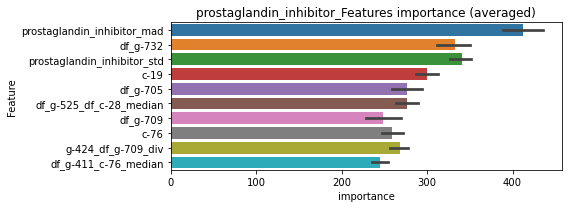

len(train_index) : 2837
len(valid_index) : 946
================================= fold 1/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0821865	valid_1's binary_logloss: 0.117136
[200]	training's binary_logloss: 0.023683	valid_1's binary_logloss: 0.0503956
[300]	training's binary_logloss: 0.00834983	valid_1's binary_logloss: 0.0289174
[400]	training's binary_logloss: 0.00351646	valid_1's binary_logloss: 0.0191936
[500]	training's binary_logloss: 0.00183428	valid_1's binary_logloss: 0.0147906
[600]	training's binary_logloss: 0.00116606	valid_1's binary_logloss: 0.0126242
[700]	training's binary_logloss: 0.000838432	valid_1's binary_logloss: 0.0116193
[800]	training's binary_logloss: 0.000661099	valid_1's binary_logloss: 0.0109283
[900]	training's binary_logloss: 0.000570623	valid_1's binary_logloss: 0.010567
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00057435	valid_1's binary_logloss: 0.0105025


len(train_index) : 2837
len(valid_index) : 946
================================= fold 2/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0851073	valid_1's binary_logloss: 0.106962
[200]	training's binary_logloss: 0.0248348	valid_1's binary_logloss: 0.042662
[300]	training's binary_logloss: 0.00884558	valid_1's binary_logloss: 0.0212756
[400]	training's binary_logloss: 0.00374793	valid_1's binary_logloss: 0.0127243
[500]	training's binary_logloss: 0.00194685	valid_1's binary_logloss: 0.00887634
[600]	training's binary_logloss: 0.00121708	valid_1's binary_logloss: 0.00693189
[700]	training's binary_logloss: 0.00087816	valid_1's binary_logloss: 0.00595367
[800]	training's binary_logloss: 0.00069113	valid_1's binary_logloss: 0.00543344
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.000651655	valid_1's binary_logloss: 0.00528739


len(train_index) : 2837
len(valid_index) : 946
================================= fold 3/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0839351	valid_1's binary_logloss: 0.122884
[200]	training's binary_logloss: 0.023681	valid_1's binary_logloss: 0.0577717
[300]	training's binary_logloss: 0.00819804	valid_1's binary_logloss: 0.0367231
[400]	training's binary_logloss: 0.00346976	valid_1's binary_logloss: 0.0283309
[500]	training's binary_logloss: 0.00182762	valid_1's binary_logloss: 0.0241683
[600]	training's binary_logloss: 0.00116716	valid_1's binary_logloss: 0.0223973
[700]	training's binary_logloss: 0.000838422	valid_1's binary_logloss: 0.0208246
[800]	training's binary_logloss: 0.000663745	valid_1's binary_logloss: 0.0198081
Early stopping, best iteration is:
[859]	training's binary_logloss: 0.000606409	valid_1's binary_logloss: 0.0194573


len(train_index) : 2838
len(valid_index) : 945
================================= fold 4/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0871608	valid_1's binary_logloss: 0.106945
[200]	training's binary_logloss: 0.0254043	valid_1's binary_logloss: 0.0434687
[300]	training's binary_logloss: 0.00897792	valid_1's binary_logloss: 0.0228307
[400]	training's binary_logloss: 0.00375578	valid_1's binary_logloss: 0.0137443
[500]	training's binary_logloss: 0.00194553	valid_1's binary_logloss: 0.00977747
[600]	training's binary_logloss: 0.00121942	valid_1's binary_logloss: 0.00791188
[700]	training's binary_logloss: 0.00087719	valid_1's binary_logloss: 0.00671721
[800]	training's binary_logloss: 0.000691666	valid_1's binary_logloss: 0.00603989
[900]	training's binary_logloss: 0.000599112	valid_1's binary_logloss: 0.00562042
[1000]	training's binary_logloss: 0.000556176	valid_1's binary_logloss: 0.00553978
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.00056029	valid_1's binary_logloss: 0.00552571


prostaglandin_inhibitor logloss: 0.01019444128001425
prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3280, target_rate: 0.0035273 → Adj_target_rate: 0.0036294


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134528	valid_1's binary_logloss: 0.222456
[200]	training's binary_logloss: 0.0614419	valid_1's binary_logloss: 0.162645
[300]	training's binary_logloss: 0.0303773	valid_1's binary_logloss: 0.133558
[400]	training's binary_logloss: 0.016052	valid_1's binary_logloss: 0.117421
[500]	training's binary_logloss: 0.00867727	valid_1's binary_logloss: 0.107276
[600]	training's binary_logloss: 0.00504036	valid_1's binary_logloss: 0.0997621
[700]	training's binary_logloss: 0.00322044	valid_1's binary_logloss: 0.0970034
[800]	training's binary_logloss: 0.00227078	valid_1's binary_logloss: 0.0957884
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.00223635	valid_1's binary_logloss: 0.0957443
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137529	valid_1's binary_logloss: 0.199721
[200]	training's binary_logloss: 0.0641696	valid_1's bina

1 / 3 AUC score:0.990
y_Threshold: 0.0318143, Threshold: 0.2631334, pos_neg_ratio: 0.8000000
Remove_noisy_data: 176 → Positive_corect_labels: 634/3760
p_label_rate: 0.0100452 Vs.target_rate: 0.00353, Num_p_label: 40.0, conf_0:0.18419, conf_1:0.34207
threshold: 0.2631334, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 634.0/3760, y_label_rate: 0.1686170
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122257	valid_1's binary_logloss: 0.184592
[200]	training's binary_logloss: 0.049131	valid_1's binary_logloss: 0.119077
[300]	training's binary_logloss: 0.0220693	valid_1's binary_logloss: 0.0895668
[400]	training's binary_logloss: 0.0107647	valid_1's binary_logloss: 0.0767009
[500]	training's binary_logloss: 0.00564882	valid_1's binary_logloss: 0.0689947
[600]	training's binary_logloss: 0.00335315	valid_1's binary_logloss: 0.0652111
Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00259083	valid_1's binary_logloss: 0.0641476
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124056	valid_1's binary_logloss: 0.186769
[200]	training's binary_logloss: 0.0516309	valid_1's binary_logloss: 0.122407
[300]	training's binary_logloss: 0.0234919	valid_1's binary_logloss: 0.0936085
[400]	training's binary_logloss: 0.0112332	valid_1's bina

2 / 3 AUC score:0.995
y_Threshold: 0.1132036, Threshold: 0.2631334, pos_neg_ratio: 0.8000000
Remove_noisy_data: 52 → Positive_corect_labels: 608.0/3708
p_label_rate: 0.0316424 Vs.target_rate: 0.00353, Num_p_label: 126.0, conf_0:0.21051, conf_1:0.31576
Num_p_label: 126.0, Expected: 14.0, Adj_threshold_1: 0.2631334
Num_p_label: 118.0, Expected: 14.0, Adj_threshold_2: 0.2931334
Num_p_label: 109.0, Expected: 14.0, Adj_threshold_3: 0.3231334
Num_p_label: 102.0, Expected: 14.0, Adj_threshold_4: 0.3531334
Num_p_label: 96.0, Expected: 14.0, Adj_threshold_5: 0.3831334
Num_p_label: 86.0, Expected: 14.0, Adj_threshold_6: 0.4131334
Num_p_label: 82.0, Expected: 14.0, Adj_threshold_7: 0.4431334
Num_p_label: 79.0, Expected: 14.0, Adj_threshold_8: 0.4731334
Num_p_label: 71.0, Expected: 14.0, Adj_threshold_9: 0.5031334
Num_p_label: 69.0, Expected: 14.0, Adj_threshold_10: 0.5331334
threshold: 0.5631334, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 608.0/3708, y_label_rate: 0.16

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109477	valid_1's binary_logloss: 0.171152
[200]	training's binary_logloss: 0.0443309	valid_1's binary_logloss: 0.112261
[300]	training's binary_logloss: 0.0192343	valid_1's binary_logloss: 0.0831055
[400]	training's binary_logloss: 0.00904138	valid_1's binary_logloss: 0.0676995
[500]	training's binary_logloss: 0.00461282	valid_1's binary_logloss: 0.0594111
[600]	training's binary_logloss: 0.00273094	valid_1's binary_logloss: 0.0552719
[700]	training's binary_logloss: 0.00185249	valid_1's binary_logloss: 0.0530667
[800]	training's binary_logloss: 0.00137428	valid_1's binary_logloss: 0.0514484
[900]	training's binary_logloss: 0.00110044	valid_1's binary_logloss: 0.0507823
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.00105991	valid_1's binary_logloss: 0.0505644
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111168	valid_1

3 / 3 AUC score:0.995
y_Threshold: 0.1142834, Threshold: 0.5631334, pos_neg_ratio: 0.8000000
Remove_noisy_data: 36 → Positive_corect_labels: 590.0/3672
p_label_rate: 0.0276243 Vs.target_rate: 0.00353, Num_p_label: 110.0, conf_0:0.50000, conf_1:0.61945
Num_p_label: 110.0, Expected: 14.0, Adj_threshold_1: 0.5631334
Num_p_label: 100.0, Expected: 14.0, Adj_threshold_2: 0.5931334
Num_p_label: 94.0, Expected: 14.0, Adj_threshold_3: 0.6231334
Num_p_label: 88.0, Expected: 14.0, Adj_threshold_4: 0.6531334
Num_p_label: 82.0, Expected: 14.0, Adj_threshold_5: 0.6831334
threshold: 0.6831334, positive_p_label: 82.0/3982, p_label_rate: 0.0205927
positive_y_label: 590.0/3672, y_label_rate: 0.1606754


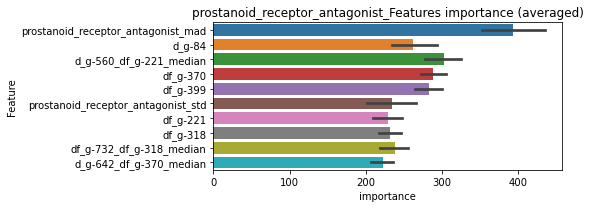

len(train_index) : 2754
len(valid_index) : 918
================================= fold 1/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106339	valid_1's binary_logloss: 0.141031
[200]	training's binary_logloss: 0.042053	valid_1's binary_logloss: 0.0757889
[300]	training's binary_logloss: 0.0181641	valid_1's binary_logloss: 0.0488669
[400]	training's binary_logloss: 0.00840582	valid_1's binary_logloss: 0.0357844
[500]	training's binary_logloss: 0.00433667	valid_1's binary_logloss: 0.0292798
[600]	training's binary_logloss: 0.00255625	valid_1's binary_logloss: 0.0253453
[700]	training's binary_logloss: 0.00172783	valid_1's binary_logloss: 0.0226849
[800]	training's binary_logloss: 0.00129964	valid_1's binary_logloss: 0.0210087
[900]	training's binary_logloss: 0.00104561	valid_1's binary_logloss: 0.0199773
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.00101048	valid_1's binary_logloss: 0.0197614


len(train_index) : 2754
len(valid_index) : 918
================================= fold 2/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104028	valid_1's binary_logloss: 0.174341
[200]	training's binary_logloss: 0.0390451	valid_1's binary_logloss: 0.11262
[300]	training's binary_logloss: 0.0165603	valid_1's binary_logloss: 0.0855548
[400]	training's binary_logloss: 0.0074543	valid_1's binary_logloss: 0.0726002
[500]	training's binary_logloss: 0.00391194	valid_1's binary_logloss: 0.0658501
[600]	training's binary_logloss: 0.00235454	valid_1's binary_logloss: 0.0637867
[700]	training's binary_logloss: 0.00160919	valid_1's binary_logloss: 0.0623362
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.00165759	valid_1's binary_logloss: 0.062045


len(train_index) : 2754
len(valid_index) : 918
================================= fold 3/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106531	valid_1's binary_logloss: 0.155812
[200]	training's binary_logloss: 0.0419501	valid_1's binary_logloss: 0.094056
[300]	training's binary_logloss: 0.0174227	valid_1's binary_logloss: 0.0642625
[400]	training's binary_logloss: 0.00794173	valid_1's binary_logloss: 0.0506296
[500]	training's binary_logloss: 0.00411364	valid_1's binary_logloss: 0.0426175
[600]	training's binary_logloss: 0.00246612	valid_1's binary_logloss: 0.0383288
[700]	training's binary_logloss: 0.00168583	valid_1's binary_logloss: 0.0361641
[800]	training's binary_logloss: 0.00125924	valid_1's binary_logloss: 0.034669
[900]	training's binary_logloss: 0.00101926	valid_1's binary_logloss: 0.0343428
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.00105758	valid_1's binary_logloss: 0.0341891


len(train_index) : 2754
len(valid_index) : 918
================================= fold 4/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107221	valid_1's binary_logloss: 0.141771
[200]	training's binary_logloss: 0.0420087	valid_1's binary_logloss: 0.0732268
[300]	training's binary_logloss: 0.0179931	valid_1's binary_logloss: 0.0446083
[400]	training's binary_logloss: 0.00808525	valid_1's binary_logloss: 0.0300309
[500]	training's binary_logloss: 0.00419646	valid_1's binary_logloss: 0.0225454
[600]	training's binary_logloss: 0.00250142	valid_1's binary_logloss: 0.0192323
[700]	training's binary_logloss: 0.00171314	valid_1's binary_logloss: 0.017272
[800]	training's binary_logloss: 0.0012838	valid_1's binary_logloss: 0.0157218
Early stopping, best iteration is:
[861]	training's binary_logloss: 0.00111808	valid_1's binary_logloss: 0.0151256


prostanoid_receptor_antagonist logloss: 0.03278029335704856
proteasome_inhibitor, len(trt): 726, len(othr): 3197, target_rate: 0.0304863 → Adj_target_rate: 0.0226983


neg labels: 3289 → selected neg labels: 3197


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.433135	valid_1's binary_logloss: 0.475795
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.421189	valid_1's binary_logloss: 0.475471
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.387976	valid_1's binary_logloss: 0.475033
Training until validation scores don't improve for 30 rounds


1 / 3 AUC score:0.524
y_Threshold: 0.1920600, Threshold: 0.3856890, pos_neg_ratio: 0.7729121
Remove_noisy_data: 1240 → Positive_corect_labels: 192/2683
p_label_rate: 0.0100452 Vs.target_rate: 0.03049, Num_p_label: 40.0, conf_0:0.26998, conf_1:0.50140
Num_p_label: 40.0, Expected: 121.4, Adj_threshold_1: 0.3856890
Num_p_label: 94.0, Expected: 121.4, Adj_threshold_2: 0.3556890
Num_p_label: 117.0, Expected: 121.4, Adj_threshold_3: 0.3256890
Num_p_label: 135.0, Expected: 121.4, Adj_threshold_4: 0.2956890
Num_p_label: 140.0, Expected: 121.4, Adj_threshold_5: 0.2656890
Num_p_label: 166.0, Expected: 121.4, Adj_threshold_6: 0.2356890
Num_p_label: 395.0, Expected: 121.4, Adj_threshold_7: 0.2056890
threshold: 0.2056890, positive_p_label: 395.0/3982, p_label_rate: 0.0991964
positive_y_label: 192.0/2683, y_label_rate: 0.0715617
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.477269	valid_1's binary_logloss: 0.478524
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0891133	valid_1's binary_logloss: 0.197395
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.060099	valid_1's binary_logloss: 0.193558
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822192	valid_1's binary_logloss: 0.231395
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.0983216	valid_1's binary_logloss: 0.230016
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.082699	valid_1's binary_logloss: 0.220669
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0980892	valid_1's binary_logloss: 0.219242
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0854225	valid_1's binary_logloss: 0.209302

2 / 3 AUC score:0.776
y_Threshold: 0.1093390, Threshold: 0.2056890, pos_neg_ratio: 0.7729121
Remove_noisy_data: 252 → Positive_corect_labels: 66.0/2431
p_label_rate: 0.0605224 Vs.target_rate: 0.03049, Num_p_label: 241.0, conf_0:0.16455, conf_1:0.24683
threshold: 0.2056890, positive_p_label: 241.0/3982, p_label_rate: 0.0605224
positive_y_label: 66.0/2431, y_label_rate: 0.0271493
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0814215	valid_1's binary_logloss: 0.208923
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0165409	valid_1's binary_logloss: 0.0602228
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00873055	valid_1's binary_logloss: 0.0578148
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0161995	valid_1's binary_logloss: 0.0479255
[200]	training's binary_logloss: 0.0046338	valid_1's binary_logloss: 0.0424053
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00495748	valid_1's binary_logloss: 0.0422003
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0164778	valid_1's binary_logloss: 0.0581412
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0108082	valid_1's binary_logloss: 0.0562336
Training until validation scores don't impro

3 / 3 AUC score:0.973
y_Threshold: 0.0482783, Threshold: 0.2056890, pos_neg_ratio: 0.7729121
Remove_noisy_data: 46 → Positive_corect_labels: 43.0/2385
p_label_rate: 0.0657961 Vs.target_rate: 0.03049, Num_p_label: 262.0, conf_0:0.18512, conf_1:0.22626
threshold: 0.2056890, positive_p_label: 262.0/3982, p_label_rate: 0.0657961


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00803209	valid_1's binary_logloss: 0.0580654


positive_y_label: 43.0/2385, y_label_rate: 0.0180294


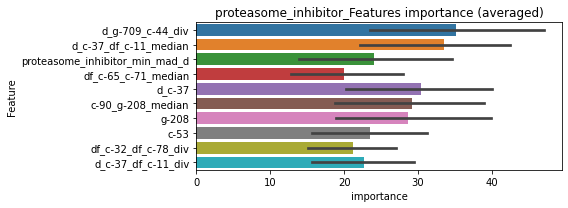

len(train_index) : 1788
len(valid_index) : 597
================================= fold 1/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0082198	valid_1's binary_logloss: 0.0245809
[200]	training's binary_logloss: 0.00207618	valid_1's binary_logloss: 0.0177534
[300]	training's binary_logloss: 0.00081592	valid_1's binary_logloss: 0.0162454
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000756201	valid_1's binary_logloss: 0.0158721


len(train_index) : 1789
len(valid_index) : 596
================================= fold 2/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.00839192	valid_1's binary_logloss: 0.0215752
[200]	training's binary_logloss: 0.00204197	valid_1's binary_logloss: 0.0180263
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00111366	valid_1's binary_logloss: 0.0175061


len(train_index) : 1789
len(valid_index) : 596
================================= fold 3/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.00806233	valid_1's binary_logloss: 0.0208068


len(train_index) : 1789
len(valid_index) : 596
================================= fold 4/4 proteasome_inhibitor=================================


[200]	training's binary_logloss: 0.00202677	valid_1's binary_logloss: 0.0178311
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00284473	valid_1's binary_logloss: 0.0177907
Training until validation scores don't improve for 30 rounds


proteasome_inhibitor logloss: 0.018171000873947657


[100]	training's binary_logloss: 0.00851316	valid_1's binary_logloss: 0.0223023
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.00469188	valid_1's binary_logloss: 0.021519
neg labels: 3289 → selected neg labels: 3285


protein_kinase_inhibitor, len(trt): 48, len(othr): 3285, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119546	valid_1's binary_logloss: 0.175035
[200]	training's binary_logloss: 0.0477419	valid_1's binary_logloss: 0.0985597
[300]	training's binary_logloss: 0.0200821	valid_1's binary_logloss: 0.0610817
[400]	training's binary_logloss: 0.00929622	valid_1's binary_logloss: 0.0438887
[500]	training's binary_logloss: 0.00483229	valid_1's binary_logloss: 0.033958
[600]	training's binary_logloss: 0.00283039	valid_1's binary_logloss: 0.0293511
[700]	training's binary_logloss: 0.0018901	valid_1's binary_logloss: 0.0265271
[800]	training's binary_logloss: 0.00138287	valid_1's binary_logloss: 0.0249585
[900]	training's binary_logloss: 0.00109214	valid_1's binary_logloss: 0.0236296
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.00106006	valid_1's binary_logloss: 0.023425
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119658	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0180021, Threshold: 0.0795695, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.05570, conf_1:0.10344
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0795695
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_2: 0.1095695
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_3: 0.1395695
threshold: 0.1395695, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112304	valid_1's binary_logloss: 0.169839
[200]	training's binary_logloss: 0.0423231	valid_1's binary_logloss: 0.0966086
[300]	training's binary_logloss: 0.0174879	valid_1's binary_logloss: 0.0630425
[400]	training's binary_logloss: 0.00772956	valid_1's binary_logloss: 0.0448944
[500]	training's binary_logloss: 0.00397382	valid_1's binary_logloss: 0.0360241
[600]	training's binary_logloss: 0.00237872	valid_1's binary_logloss: 0.0316728
[700]	training's binary_logloss: 0.00161532	valid_1's binary_logloss: 0.028508
[800]	training's binary_logloss: 0.00120803	valid_1's binary_logloss: 0.0272292
[900]	training's binary_logloss: 0.000971151	valid_1's binary_logloss: 0.026201
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.000975268	valid_1's binary_logloss: 0.0261761
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119058	valid_

2 / 3 AUC score:0.999
y_Threshold: 0.0519699, Threshold: 0.1395695, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0133099 Vs.target_rate: 0.00202, Num_p_label: 53.0, conf_0:0.11166, conf_1:0.16748
Num_p_label: 53.0, Expected: 8.0, Adj_threshold_1: 0.1395695
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_2: 0.1695695
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_3: 0.1995695
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_4: 0.2295695
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_5: 0.2595695
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_6: 0.2895695
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_7: 0.3195695
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_8: 0.3495695
threshold: 0.3495695, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 648.0/3792, y_label_rate: 0.1708861
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112932	valid_1's binary_logloss: 0.158916
[200]	training's binary_logloss: 0.0410944	valid_1's binary_logloss: 0.0828039
[300]	training's binary_logloss: 0.0166601	valid_1's binary_logloss: 0.051002
[400]	training's binary_logloss: 0.00731278	valid_1's binary_logloss: 0.0362475
[500]	training's binary_logloss: 0.00376051	valid_1's binary_logloss: 0.0290529
[600]	training's binary_logloss: 0.00226957	valid_1's binary_logloss: 0.0249719
[700]	training's binary_logloss: 0.00154297	valid_1's binary_logloss: 0.0228025
[800]	training's binary_logloss: 0.00116217	valid_1's binary_logloss: 0.0215943
[900]	training's binary_logloss: 0.000938537	valid_1's binary_logloss: 0.0210536
[1000]	training's binary_logloss: 0.000807213	valid_1's binary_logloss: 0.0205983
[1100]	training's binary_logloss: 0.000745338	valid_1's binary_logloss: 0.0204736
Early stopping, best iteration is:
[1072]	training's binary_

3 / 3 AUC score:1.000
y_Threshold: 0.0611954, Threshold: 0.3495695, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 642.0/3780
p_label_rate: 0.0055249 Vs.target_rate: 0.00202, Num_p_label: 22.0, conf_0:0.31461, conf_1:0.38453
threshold: 0.3495695, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 642.0/3780, y_label_rate: 0.1698413


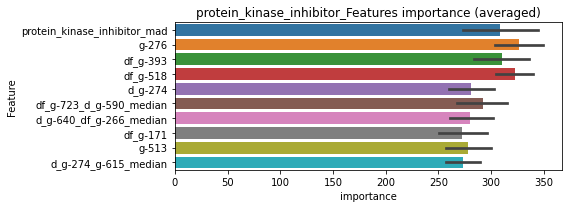

len(train_index) : 2835
len(valid_index) : 945
================================= fold 1/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107906	valid_1's binary_logloss: 0.167529
[200]	training's binary_logloss: 0.038786	valid_1's binary_logloss: 0.0940382
[300]	training's binary_logloss: 0.0157841	valid_1's binary_logloss: 0.0650683
[400]	training's binary_logloss: 0.00699891	valid_1's binary_logloss: 0.0499342
[500]	training's binary_logloss: 0.00360162	valid_1's binary_logloss: 0.0416776
[600]	training's binary_logloss: 0.00216992	valid_1's binary_logloss: 0.0379885
[700]	training's binary_logloss: 0.00148602	valid_1's binary_logloss: 0.0361125
[800]	training's binary_logloss: 0.00112297	valid_1's binary_logloss: 0.0347894
[900]	training's binary_logloss: 0.000909672	valid_1's binary_logloss: 0.0338556
[1000]	training's binary_logloss: 0.000781287	valid_1's binary_logloss: 0.0330862
Early stopping, best iteration is:
[1023]	training's binary_logloss: 0.000761803	valid_1's binary_logloss: 0.0329169


len(train_index) : 2835
len(valid_index) : 945
================================= fold 2/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111172	valid_1's binary_logloss: 0.158294
[200]	training's binary_logloss: 0.0399514	valid_1's binary_logloss: 0.0800194
[300]	training's binary_logloss: 0.0161469	valid_1's binary_logloss: 0.0473523
[400]	training's binary_logloss: 0.00722141	valid_1's binary_logloss: 0.0312259
[500]	training's binary_logloss: 0.00372279	valid_1's binary_logloss: 0.0228603
[600]	training's binary_logloss: 0.00224445	valid_1's binary_logloss: 0.0188959
[700]	training's binary_logloss: 0.00153736	valid_1's binary_logloss: 0.0164098
[800]	training's binary_logloss: 0.00115443	valid_1's binary_logloss: 0.0147261
[900]	training's binary_logloss: 0.000935691	valid_1's binary_logloss: 0.013714
[1000]	training's binary_logloss: 0.000797305	valid_1's binary_logloss: 0.013012
Early stopping, best iteration is:
[1063]	training's binary_logloss: 0.000752384	valid_1's binary_logloss: 0.0126963


len(train_index) : 2835
len(valid_index) : 945
================================= fold 3/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111979	valid_1's binary_logloss: 0.150539
[200]	training's binary_logloss: 0.0400965	valid_1's binary_logloss: 0.0752987
[300]	training's binary_logloss: 0.0165954	valid_1's binary_logloss: 0.0455055
[400]	training's binary_logloss: 0.00744077	valid_1's binary_logloss: 0.031849
[500]	training's binary_logloss: 0.00381542	valid_1's binary_logloss: 0.0237893
[600]	training's binary_logloss: 0.00227227	valid_1's binary_logloss: 0.0199124
[700]	training's binary_logloss: 0.00154235	valid_1's binary_logloss: 0.0176484
[800]	training's binary_logloss: 0.00115371	valid_1's binary_logloss: 0.0161951
[900]	training's binary_logloss: 0.000935293	valid_1's binary_logloss: 0.0154118
[1000]	training's binary_logloss: 0.000806831	valid_1's binary_logloss: 0.0151058
[1100]	training's binary_logloss: 0.000742616	valid_1's binary_logloss: 0.0148436
Early stopping, best iteration is:
[1127]	training's binary_

len(train_index) : 2835
len(valid_index) : 945
================================= fold 4/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110062	valid_1's binary_logloss: 0.162922
[200]	training's binary_logloss: 0.0394113	valid_1's binary_logloss: 0.0858147
[300]	training's binary_logloss: 0.0160908	valid_1's binary_logloss: 0.0547343
[400]	training's binary_logloss: 0.00723086	valid_1's binary_logloss: 0.0408094
[500]	training's binary_logloss: 0.00370107	valid_1's binary_logloss: 0.0332769
[600]	training's binary_logloss: 0.00222098	valid_1's binary_logloss: 0.029707
[700]	training's binary_logloss: 0.00152253	valid_1's binary_logloss: 0.0273731
[800]	training's binary_logloss: 0.00114501	valid_1's binary_logloss: 0.0261901
[900]	training's binary_logloss: 0.000924512	valid_1's binary_logloss: 0.0252159
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.000845796	valid_1's binary_logloss: 0.0248839


protein_kinase_inhibitor logloss: 0.02131713367238711
protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0878196	valid_1's binary_logloss: 0.112455
[200]	training's binary_logloss: 0.0265951	valid_1's binary_logloss: 0.0467377
[300]	training's binary_logloss: 0.00937468	valid_1's binary_logloss: 0.0249049
[400]	training's binary_logloss: 0.00377023	valid_1's binary_logloss: 0.0153621
[500]	training's binary_logloss: 0.00189744	valid_1's binary_logloss: 0.0110193
[600]	training's binary_logloss: 0.00117395	valid_1's binary_logloss: 0.00899948
[700]	training's binary_logloss: 0.000840158	valid_1's binary_logloss: 0.0077712
[800]	training's binary_logloss: 0.000657866	valid_1's binary_logloss: 0.0071817
[900]	training's binary_logloss: 0.000553341	valid_1's binary_logloss: 0.00685347
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.000532943	valid_1's binary_logloss: 0.00675768
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0878

1 / 3 AUC score:1.000
y_Threshold: 0.0059676, Threshold: 0.0317960, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.02226, conf_1:0.04133
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0317960
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.0617960
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.0917960
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.1217960
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_5: 0.1517960
threshold: 0.1517960, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838012	valid_1's binary_logloss: 0.105414
[200]	training's binary_logloss: 0.0243023	valid_1's binary_logloss: 0.0397923
[300]	training's binary_logloss: 0.00790835	valid_1's binary_logloss: 0.0181205
[400]	training's binary_logloss: 0.00318353	valid_1's binary_logloss: 0.0100713
[500]	training's binary_logloss: 0.0016396	valid_1's binary_logloss: 0.00690836
[600]	training's binary_logloss: 0.00102863	valid_1's binary_logloss: 0.0054974
[700]	training's binary_logloss: 0.000740414	valid_1's binary_logloss: 0.00471017
[800]	training's binary_logloss: 0.000587237	valid_1's binary_logloss: 0.00431509
[900]	training's binary_logloss: 0.000506343	valid_1's binary_logloss: 0.0040914
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.00048873	valid_1's binary_logloss: 0.00405871
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08271

2 / 3 AUC score:1.000
y_Threshold: 0.0887721, Threshold: 0.1517960, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0062783 Vs.target_rate: 0.00101, Num_p_label: 25.0, conf_0:0.12144, conf_1:0.18216
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_1: 0.1517960
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_2: 0.1817960
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_3: 0.2117960
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.2417960
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_5: 0.2717960
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_6: 0.3017960
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_7: 0.3317960
threshold: 0.3317960, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838012	valid_1's binary_logloss: 0.105414
[200]	training's binary_logloss: 0.0243023	valid_1's binary_logloss: 0.0397923
[300]	training's binary_logloss: 0.00790835	valid_1's binary_logloss: 0.0181205
[400]	training's binary_logloss: 0.00318353	valid_1's binary_logloss: 0.0100713
[500]	training's binary_logloss: 0.0016396	valid_1's binary_logloss: 0.00690836
[600]	training's binary_logloss: 0.00102863	valid_1's binary_logloss: 0.0054974
[700]	training's binary_logloss: 0.000740414	valid_1's binary_logloss: 0.00471017
[800]	training's binary_logloss: 0.000587237	valid_1's binary_logloss: 0.00431509
[900]	training's binary_logloss: 0.000506343	valid_1's binary_logloss: 0.0040914
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.00048873	valid_1's binary_logloss: 0.00405871
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08271

3 / 3 AUC score:1.000
y_Threshold: 0.0887721, Threshold: 0.3317960, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.29862, conf_1:0.36498
threshold: 0.3317960, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


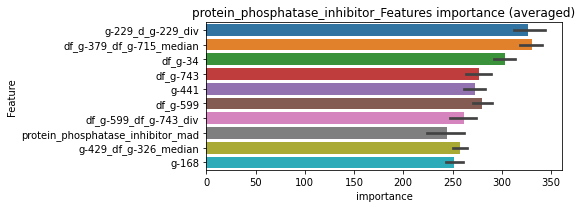

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0844407	valid_1's binary_logloss: 0.105899
[200]	training's binary_logloss: 0.0239455	valid_1's binary_logloss: 0.039138
[300]	training's binary_logloss: 0.00778502	valid_1's binary_logloss: 0.0177633
[400]	training's binary_logloss: 0.00313744	valid_1's binary_logloss: 0.0100727
[500]	training's binary_logloss: 0.00160958	valid_1's binary_logloss: 0.00680575
[600]	training's binary_logloss: 0.00101624	valid_1's binary_logloss: 0.00552331
[700]	training's binary_logloss: 0.000737761	valid_1's binary_logloss: 0.00478715
[800]	training's binary_logloss: 0.000584765	valid_1's binary_logloss: 0.0043801
[900]	training's binary_logloss: 0.000499594	valid_1's binary_logloss: 0.00408466
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000496585	valid_1's binary_logloss: 0.00406987


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0821522	valid_1's binary_logloss: 0.105363
[200]	training's binary_logloss: 0.0232833	valid_1's binary_logloss: 0.0391324
[300]	training's binary_logloss: 0.00754842	valid_1's binary_logloss: 0.0175457
[400]	training's binary_logloss: 0.00307624	valid_1's binary_logloss: 0.00978249
[500]	training's binary_logloss: 0.0015986	valid_1's binary_logloss: 0.00649329
[600]	training's binary_logloss: 0.00101149	valid_1's binary_logloss: 0.00516821
[700]	training's binary_logloss: 0.000732138	valid_1's binary_logloss: 0.00446696
[800]	training's binary_logloss: 0.000580355	valid_1's binary_logloss: 0.00401673
[900]	training's binary_logloss: 0.000506859	valid_1's binary_logloss: 0.0038341
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000490778	valid_1's binary_logloss: 0.00379162


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0832706	valid_1's binary_logloss: 0.101568
[200]	training's binary_logloss: 0.0238498	valid_1's binary_logloss: 0.0369398
[300]	training's binary_logloss: 0.00795293	valid_1's binary_logloss: 0.0163264
[400]	training's binary_logloss: 0.00320569	valid_1's binary_logloss: 0.00870058
[500]	training's binary_logloss: 0.00165428	valid_1's binary_logloss: 0.00568033
[600]	training's binary_logloss: 0.00104263	valid_1's binary_logloss: 0.00428257
[700]	training's binary_logloss: 0.000755158	valid_1's binary_logloss: 0.00360792
[800]	training's binary_logloss: 0.000596261	valid_1's binary_logloss: 0.00317144
[900]	training's binary_logloss: 0.000509624	valid_1's binary_logloss: 0.0029223
Early stopping, best iteration is:
[958]	training's binary_logloss: 0.00048733	valid_1's binary_logloss: 0.00287812


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0826706	valid_1's binary_logloss: 0.106465
[200]	training's binary_logloss: 0.0233127	valid_1's binary_logloss: 0.0392248
[300]	training's binary_logloss: 0.00754324	valid_1's binary_logloss: 0.0170155
[400]	training's binary_logloss: 0.00304152	valid_1's binary_logloss: 0.00939102
[500]	training's binary_logloss: 0.00157805	valid_1's binary_logloss: 0.00639443
[600]	training's binary_logloss: 0.00100406	valid_1's binary_logloss: 0.00519275
[700]	training's binary_logloss: 0.000729091	valid_1's binary_logloss: 0.00449904
[800]	training's binary_logloss: 0.000574261	valid_1's binary_logloss: 0.00407366
[900]	training's binary_logloss: 0.000498692	valid_1's binary_logloss: 0.00390048
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.000491805	valid_1's binary_logloss: 0.0038765


protein_phosphatase_inhibitor logloss: 0.003654410708866465
protein_synthesis_inhibitor, len(trt): 103, len(othr): 3278, target_rate: 0.0043252 → Adj_target_rate: 0.0043163


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.159684	valid_1's binary_logloss: 0.229569
[200]	training's binary_logloss: 0.0780766	valid_1's binary_logloss: 0.161743
[300]	training's binary_logloss: 0.0404377	valid_1's binary_logloss: 0.128424
[400]	training's binary_logloss: 0.0220233	valid_1's binary_logloss: 0.1109
[500]	training's binary_logloss: 0.0118584	valid_1's binary_logloss: 0.0999503
[600]	training's binary_logloss: 0.00684198	valid_1's binary_logloss: 0.0936907
[700]	training's binary_logloss: 0.00429294	valid_1's binary_logloss: 0.090902
[800]	training's binary_logloss: 0.00293832	valid_1's binary_logloss: 0.0888295
[900]	training's binary_logloss: 0.00215677	valid_1's binary_logloss: 0.088014
[1000]	training's binary_logloss: 0.00170226	valid_1's binary_logloss: 0.0869061
Early stopping, best iteration is:
[988]	training's binary_logloss: 0.0017471	valid_1's binary_logloss: 0.0868587
Training until validation scores don't

1 / 3 AUC score:0.988
y_Threshold: 0.0322804, Threshold: 0.2669664, pos_neg_ratio: 0.8000000
Remove_noisy_data: 188 → Positive_corect_labels: 627/3745
p_label_rate: 0.0100452 Vs.target_rate: 0.00433, Num_p_label: 40.0, conf_0:0.18688, conf_1:0.34706
threshold: 0.2669664, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 627.0/3745, y_label_rate: 0.1674232
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.140018	valid_1's binary_logloss: 0.196161
[200]	training's binary_logloss: 0.0612308	valid_1's binary_logloss: 0.126662
[300]	training's binary_logloss: 0.0299704	valid_1's binary_logloss: 0.0936856
[400]	training's binary_logloss: 0.0154695	valid_1's binary_logloss: 0.0775283
[500]	training's binary_logloss: 0.00823555	valid_1's binary_logloss: 0.0682199
[600]	training's binary_logloss: 0.00473548	valid_1's binary_logloss: 0.0635447
[700]	training's binary_logloss: 0.00299694	valid_1's binary_logloss: 0.0607271
[800]	training's binary_logloss: 0.00210325	valid_1's binary_logloss: 0.0597428
[900]	training's binary_logloss: 0.00158709	valid_1's binary_logloss: 0.0586056
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.00149967	valid_1's binary_logloss: 0.0583731
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135398	valid_1'

2 / 3 AUC score:0.992
y_Threshold: 0.1118523, Threshold: 0.2669664, pos_neg_ratio: 0.8000000
Remove_noisy_data: 80 → Positive_corect_labels: 587.0/3665
p_label_rate: 0.0226017 Vs.target_rate: 0.00433, Num_p_label: 90.0, conf_0:0.21357, conf_1:0.32036
Num_p_label: 90.0, Expected: 17.2, Adj_threshold_1: 0.2669664
Num_p_label: 82.0, Expected: 17.2, Adj_threshold_2: 0.2969664
Num_p_label: 71.0, Expected: 17.2, Adj_threshold_3: 0.3269664
Num_p_label: 63.0, Expected: 17.2, Adj_threshold_4: 0.3569664
Num_p_label: 56.0, Expected: 17.2, Adj_threshold_5: 0.3869664
Num_p_label: 51.0, Expected: 17.2, Adj_threshold_6: 0.4169664
Num_p_label: 43.0, Expected: 17.2, Adj_threshold_7: 0.4469664
Num_p_label: 39.0, Expected: 17.2, Adj_threshold_8: 0.4769664
Num_p_label: 36.0, Expected: 17.2, Adj_threshold_9: 0.5069664
Num_p_label: 32.0, Expected: 17.2, Adj_threshold_10: 0.5369664
threshold: 0.5669664, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 587.0/3665, y_label_rate: 0.1601637

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124277	valid_1's binary_logloss: 0.177415
[200]	training's binary_logloss: 0.049042	valid_1's binary_logloss: 0.111397
[300]	training's binary_logloss: 0.0216096	valid_1's binary_logloss: 0.0833939
[400]	training's binary_logloss: 0.0104162	valid_1's binary_logloss: 0.0715832
[500]	training's binary_logloss: 0.00540479	valid_1's binary_logloss: 0.064853
[600]	training's binary_logloss: 0.00318263	valid_1's binary_logloss: 0.0626921
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00291634	valid_1's binary_logloss: 0.062436
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119352	valid_1's binary_logloss: 0.193501
[200]	training's binary_logloss: 0.0485754	valid_1's binary_logloss: 0.129355
[300]	training's binary_logloss: 0.0224897	valid_1's binary_logloss: 0.101883
[400]	training's binary_logloss: 0.0105389	valid_1's binary_

3 / 3 AUC score:0.996
y_Threshold: 0.0964036, Threshold: 0.5669664, pos_neg_ratio: 0.8000000
Remove_noisy_data: 54 → Positive_corect_labels: 560.0/3611
p_label_rate: 0.0118031 Vs.target_rate: 0.00433, Num_p_label: 47.0, conf_0:0.50000, conf_1:0.62366
threshold: 0.5669664, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 560.0/3611, y_label_rate: 0.1550817


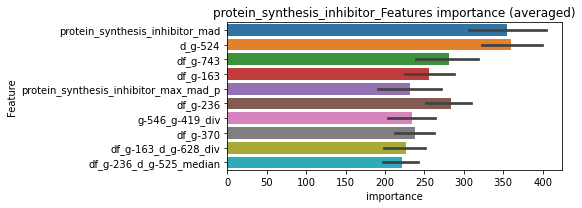

len(train_index) : 2708
len(valid_index) : 903
================================= fold 1/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113735	valid_1's binary_logloss: 0.167655
[200]	training's binary_logloss: 0.0431692	valid_1's binary_logloss: 0.100773
[300]	training's binary_logloss: 0.0200515	valid_1's binary_logloss: 0.0768475
[400]	training's binary_logloss: 0.00947095	valid_1's binary_logloss: 0.0611364
[500]	training's binary_logloss: 0.00497397	valid_1's binary_logloss: 0.0526079
[600]	training's binary_logloss: 0.00293646	valid_1's binary_logloss: 0.0478328
[700]	training's binary_logloss: 0.00194298	valid_1's binary_logloss: 0.0446593
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.00156478	valid_1's binary_logloss: 0.042879


len(train_index) : 2708
len(valid_index) : 903
================================= fold 2/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113933	valid_1's binary_logloss: 0.178896
[200]	training's binary_logloss: 0.0430384	valid_1's binary_logloss: 0.112793
[300]	training's binary_logloss: 0.0190611	valid_1's binary_logloss: 0.0836018
[400]	training's binary_logloss: 0.00888094	valid_1's binary_logloss: 0.0695245
[500]	training's binary_logloss: 0.00457882	valid_1's binary_logloss: 0.061826
[600]	training's binary_logloss: 0.00266785	valid_1's binary_logloss: 0.057506
[700]	training's binary_logloss: 0.00177383	valid_1's binary_logloss: 0.0547221
Early stopping, best iteration is:
[694]	training's binary_logloss: 0.0018096	valid_1's binary_logloss: 0.0547083


len(train_index) : 2708
len(valid_index) : 903
================================= fold 3/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114873	valid_1's binary_logloss: 0.157357
[200]	training's binary_logloss: 0.0445878	valid_1's binary_logloss: 0.0872611
[300]	training's binary_logloss: 0.0197194	valid_1's binary_logloss: 0.0591912
[400]	training's binary_logloss: 0.00919336	valid_1's binary_logloss: 0.0442784
[500]	training's binary_logloss: 0.0047356	valid_1's binary_logloss: 0.0362337
[600]	training's binary_logloss: 0.00280564	valid_1's binary_logloss: 0.0311898
[700]	training's binary_logloss: 0.00188945	valid_1's binary_logloss: 0.0291062
[800]	training's binary_logloss: 0.00138443	valid_1's binary_logloss: 0.0272398
[900]	training's binary_logloss: 0.00110253	valid_1's binary_logloss: 0.0260773
[1000]	training's binary_logloss: 0.000937881	valid_1's binary_logloss: 0.0255332
[1100]	training's binary_logloss: 0.000860536	valid_1's binary_logloss: 0.0251869
Early stopping, best iteration is:
[1090]	training's binary_l

len(train_index) : 2709
len(valid_index) : 902
================================= fold 4/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112489	valid_1's binary_logloss: 0.165336
[200]	training's binary_logloss: 0.0408584	valid_1's binary_logloss: 0.100523
[300]	training's binary_logloss: 0.0180841	valid_1's binary_logloss: 0.0748309
[400]	training's binary_logloss: 0.00841284	valid_1's binary_logloss: 0.0614434
[500]	training's binary_logloss: 0.0042988	valid_1's binary_logloss: 0.0546402
[600]	training's binary_logloss: 0.00255816	valid_1's binary_logloss: 0.0508787
[700]	training's binary_logloss: 0.00171594	valid_1's binary_logloss: 0.0491476
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.0013984	valid_1's binary_logloss: 0.0484278


protein_synthesis_inhibitor logloss: 0.042772983934753525
protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0826457	valid_1's binary_logloss: 0.0998
[200]	training's binary_logloss: 0.0244035	valid_1's binary_logloss: 0.0364973
[300]	training's binary_logloss: 0.00795558	valid_1's binary_logloss: 0.0157761
[400]	training's binary_logloss: 0.00312689	valid_1's binary_logloss: 0.00811412
[500]	training's binary_logloss: 0.0016026	valid_1's binary_logloss: 0.00513878
[600]	training's binary_logloss: 0.00101444	valid_1's binary_logloss: 0.00386842
[700]	training's binary_logloss: 0.000728207	valid_1's binary_logloss: 0.00322034
[800]	training's binary_logloss: 0.000584641	valid_1's binary_logloss: 0.00279032
[900]	training's binary_logloss: 0.000520735	valid_1's binary_logloss: 0.00262304
[1000]	training's binary_logloss: 0.000499111	valid_1's binary_logloss: 0.0025634
[1100]	training's binary_logloss: 0.000492317	valid_1's binary_logloss: 0.0025503
Early stopping, best iteration is:
[1090]	training's

1 / 3 AUC score:1.000
y_Threshold: 0.0051370, Threshold: 0.0286561, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.02006, conf_1:0.03725
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0286561
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.0586561
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.0886561
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_4: 0.1186561
threshold: 0.1186561, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0790837	valid_1's binary_logloss: 0.0987477
[200]	training's binary_logloss: 0.0213533	valid_1's binary_logloss: 0.0336067
[300]	training's binary_logloss: 0.00671925	valid_1's binary_logloss: 0.0134091
[400]	training's binary_logloss: 0.00270057	valid_1's binary_logloss: 0.00646731
[500]	training's binary_logloss: 0.00139921	valid_1's binary_logloss: 0.00380272
[600]	training's binary_logloss: 0.000889845	valid_1's binary_logloss: 0.00267351
[700]	training's binary_logloss: 0.00064998	valid_1's binary_logloss: 0.00212387
[800]	training's binary_logloss: 0.000528125	valid_1's binary_logloss: 0.00183041
[900]	training's binary_logloss: 0.000474964	valid_1's binary_logloss: 0.00169468
[1000]	training's binary_logloss: 0.00045597	valid_1's binary_logloss: 0.00165204
[1100]	training's binary_logloss: 0.0004474	valid_1's binary_logloss: 0.00163274
Early stopping, best iteration is:
[1095]	trainin

2 / 3 AUC score:1.000
y_Threshold: 0.0920750, Threshold: 0.1186561, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0072828 Vs.target_rate: 0.00080, Num_p_label: 29.0, conf_0:0.09492, conf_1:0.14239
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_1: 0.1186561
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_2: 0.1486561
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.1786561
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.2086561
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.2386561
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.2686561
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.2986561
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_8: 0.3286561
threshold: 0.3286561, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0790837	valid_1's binary_logloss: 0.0987477
[200]	training's binary_logloss: 0.0213533	valid_1's binary_logloss: 0.0336067
[300]	training's binary_logloss: 0.00671925	valid_1's binary_logloss: 0.0134091
[400]	training's binary_logloss: 0.00270057	valid_1's binary_logloss: 0.00646731
[500]	training's binary_logloss: 0.00139921	valid_1's binary_logloss: 0.00380272
[600]	training's binary_logloss: 0.000889845	valid_1's binary_logloss: 0.00267351
[700]	training's binary_logloss: 0.00064998	valid_1's binary_logloss: 0.00212387
[800]	training's binary_logloss: 0.000528125	valid_1's binary_logloss: 0.00183041
[900]	training's binary_logloss: 0.000474964	valid_1's binary_logloss: 0.00169468
[1000]	training's binary_logloss: 0.00045597	valid_1's binary_logloss: 0.00165204
[1100]	training's binary_logloss: 0.0004474	valid_1's binary_logloss: 0.00163274
Early stopping, best iteration is:
[1095]	trainin

3 / 3 AUC score:1.000
y_Threshold: 0.0920750, Threshold: 0.3286561, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.29579, conf_1:0.36152
threshold: 0.3286561, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


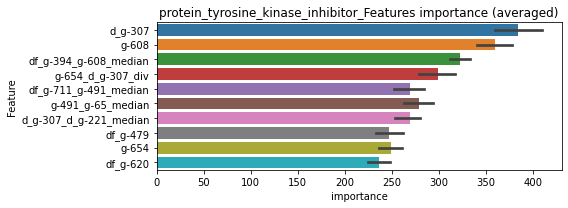

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0772118	valid_1's binary_logloss: 0.0954759
[200]	training's binary_logloss: 0.0207706	valid_1's binary_logloss: 0.0324367
[300]	training's binary_logloss: 0.00648653	valid_1's binary_logloss: 0.0127267
[400]	training's binary_logloss: 0.00262133	valid_1's binary_logloss: 0.00625765
[500]	training's binary_logloss: 0.00138246	valid_1's binary_logloss: 0.00385517
[600]	training's binary_logloss: 0.000881311	valid_1's binary_logloss: 0.00265743
[700]	training's binary_logloss: 0.000647187	valid_1's binary_logloss: 0.00211747
[800]	training's binary_logloss: 0.000522835	valid_1's binary_logloss: 0.0018125
[900]	training's binary_logloss: 0.000472614	valid_1's binary_logloss: 0.00169057
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000464008	valid_1's binary_logloss: 0.00166989


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0772787	valid_1's binary_logloss: 0.102863
[200]	training's binary_logloss: 0.0212818	valid_1's binary_logloss: 0.0380291
[300]	training's binary_logloss: 0.00682811	valid_1's binary_logloss: 0.0177821
[400]	training's binary_logloss: 0.00271118	valid_1's binary_logloss: 0.00996056
[500]	training's binary_logloss: 0.00139268	valid_1's binary_logloss: 0.00677729
[600]	training's binary_logloss: 0.000897145	valid_1's binary_logloss: 0.00542722
[700]	training's binary_logloss: 0.000653256	valid_1's binary_logloss: 0.00465583
[800]	training's binary_logloss: 0.000527401	valid_1's binary_logloss: 0.00422278
[900]	training's binary_logloss: 0.0004741	valid_1's binary_logloss: 0.00406061
[1000]	training's binary_logloss: 0.000453865	valid_1's binary_logloss: 0.00401409
Early stopping, best iteration is:
[1015]	training's binary_logloss: 0.000451955	valid_1's binary_logloss: 0.00399246


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0772121	valid_1's binary_logloss: 0.0998532
[200]	training's binary_logloss: 0.020723	valid_1's binary_logloss: 0.0355422
[300]	training's binary_logloss: 0.00655215	valid_1's binary_logloss: 0.0159029
[400]	training's binary_logloss: 0.00261143	valid_1's binary_logloss: 0.00928034
[500]	training's binary_logloss: 0.00135185	valid_1's binary_logloss: 0.00663931
[600]	training's binary_logloss: 0.000866188	valid_1's binary_logloss: 0.00531788
[700]	training's binary_logloss: 0.000635722	valid_1's binary_logloss: 0.00459584
[800]	training's binary_logloss: 0.000516747	valid_1's binary_logloss: 0.00427977
[900]	training's binary_logloss: 0.000470781	valid_1's binary_logloss: 0.0041463
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.000464421	valid_1's binary_logloss: 0.00412806


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0775604	valid_1's binary_logloss: 0.0929578
[200]	training's binary_logloss: 0.0213203	valid_1's binary_logloss: 0.0317102
[300]	training's binary_logloss: 0.00683898	valid_1's binary_logloss: 0.0128975
[400]	training's binary_logloss: 0.00274916	valid_1's binary_logloss: 0.00661371
[500]	training's binary_logloss: 0.00143021	valid_1's binary_logloss: 0.0040608
[600]	training's binary_logloss: 0.00091011	valid_1's binary_logloss: 0.00298411
[700]	training's binary_logloss: 0.000663402	valid_1's binary_logloss: 0.00236662
[800]	training's binary_logloss: 0.000532878	valid_1's binary_logloss: 0.00202102
[900]	training's binary_logloss: 0.000474048	valid_1's binary_logloss: 0.00188194
Early stopping, best iteration is:
[949]	training's binary_logloss: 0.000461507	valid_1's binary_logloss: 0.00185348


protein_tyrosine_kinase_inhibitor logloss: 0.0029115588031795154
radiopaque_medium, len(trt): 56, len(othr): 3283, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12679	valid_1's binary_logloss: 0.207203
[200]	training's binary_logloss: 0.0526283	valid_1's binary_logloss: 0.140663
[300]	training's binary_logloss: 0.0236457	valid_1's binary_logloss: 0.109641
[400]	training's binary_logloss: 0.0113196	valid_1's binary_logloss: 0.0919244
[500]	training's binary_logloss: 0.00576676	valid_1's binary_logloss: 0.0814797
[600]	training's binary_logloss: 0.00336683	valid_1's binary_logloss: 0.0776806
[700]	training's binary_logloss: 0.00222209	valid_1's binary_logloss: 0.0750134
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00240125	valid_1's binary_logloss: 0.074979
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127466	valid_1's binary_logloss: 0.200808
[200]	training's binary_logloss: 0.0499727	valid_1's binary_logloss: 0.124788
[300]	training's binary_logloss: 0.0223889	valid_1's binar

1 / 3 AUC score:0.998
y_Threshold: 0.0238952, Threshold: 0.1425256, pos_neg_ratio: 0.8000000
Remove_noisy_data: 146 → Positive_corect_labels: 649/3793
p_label_rate: 0.0100452 Vs.target_rate: 0.00235, Num_p_label: 40.0, conf_0:0.09977, conf_1:0.18528
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_1: 0.1425256
Num_p_label: 31.0, Expected: 9.4, Adj_threshold_2: 0.1725256
Num_p_label: 27.0, Expected: 9.4, Adj_threshold_3: 0.2025256
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_4: 0.2325256
threshold: 0.2325256, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 649.0/3793, y_label_rate: 0.1711047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123544	valid_1's binary_logloss: 0.168363
[200]	training's binary_logloss: 0.0456845	valid_1's binary_logloss: 0.0916096
[300]	training's binary_logloss: 0.0189617	valid_1's binary_logloss: 0.0580414
[400]	training's binary_logloss: 0.00866055	valid_1's binary_logloss: 0.0409288
[500]	training's binary_logloss: 0.00445268	valid_1's binary_logloss: 0.0328662
[600]	training's binary_logloss: 0.00263639	valid_1's binary_logloss: 0.0292881
[700]	training's binary_logloss: 0.00178084	valid_1's binary_logloss: 0.026837
[800]	training's binary_logloss: 0.0013271	valid_1's binary_logloss: 0.0255375
[900]	training's binary_logloss: 0.00107441	valid_1's binary_logloss: 0.0252906
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00102061	valid_1's binary_logloss: 0.0249397
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119877	valid_1'

2 / 3 AUC score:0.994
y_Threshold: 0.0873269, Threshold: 0.2325256, pos_neg_ratio: 0.8000000
Remove_noisy_data: 34 → Positive_corect_labels: 632.0/3759
p_label_rate: 0.0203415 Vs.target_rate: 0.00235, Num_p_label: 81.0, conf_0:0.18602, conf_1:0.27903
Num_p_label: 81.0, Expected: 9.4, Adj_threshold_1: 0.2325256
Num_p_label: 77.0, Expected: 9.4, Adj_threshold_2: 0.2625256
Num_p_label: 73.0, Expected: 9.4, Adj_threshold_3: 0.2925256
Num_p_label: 67.0, Expected: 9.4, Adj_threshold_4: 0.3225256
Num_p_label: 64.0, Expected: 9.4, Adj_threshold_5: 0.3525256
Num_p_label: 61.0, Expected: 9.4, Adj_threshold_6: 0.3825256
Num_p_label: 60.0, Expected: 9.4, Adj_threshold_7: 0.4125256
Num_p_label: 57.0, Expected: 9.4, Adj_threshold_8: 0.4425256
Num_p_label: 51.0, Expected: 9.4, Adj_threshold_9: 0.4725256
Num_p_label: 49.0, Expected: 9.4, Adj_threshold_10: 0.5025256
threshold: 0.5325256, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 632.0/3759, y_label_rate: 0.1681298
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117633	valid_1's binary_logloss: 0.164346
[200]	training's binary_logloss: 0.042867	valid_1's binary_logloss: 0.0916601
[300]	training's binary_logloss: 0.0180685	valid_1's binary_logloss: 0.0615617
[400]	training's binary_logloss: 0.00806434	valid_1's binary_logloss: 0.0476401
[500]	training's binary_logloss: 0.00404291	valid_1's binary_logloss: 0.038652
[600]	training's binary_logloss: 0.00242111	valid_1's binary_logloss: 0.0345217
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.00186007	valid_1's binary_logloss: 0.0328766
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115526	valid_1's binary_logloss: 0.172923
[200]	training's binary_logloss: 0.0415828	valid_1's binary_logloss: 0.0991669
[300]	training's binary_logloss: 0.0165525	valid_1's binary_logloss: 0.0651265
[400]	training's binary_logloss: 0.00738616	valid_1's b

3 / 3 AUC score:0.999
y_Threshold: 0.1064361, Threshold: 0.5325256, pos_neg_ratio: 0.8000000
Remove_noisy_data: 28 → Positive_corect_labels: 618.0/3731
p_label_rate: 0.0150678 Vs.target_rate: 0.00235, Num_p_label: 60.0, conf_0:0.47927, conf_1:0.58578
Num_p_label: 60.0, Expected: 9.4, Adj_threshold_1: 0.5325256
Num_p_label: 58.0, Expected: 9.4, Adj_threshold_2: 0.5625256
Num_p_label: 55.0, Expected: 9.4, Adj_threshold_3: 0.5925256
Num_p_label: 52.0, Expected: 9.4, Adj_threshold_4: 0.6225256
Num_p_label: 46.0, Expected: 9.4, Adj_threshold_5: 0.6525256
Num_p_label: 41.0, Expected: 9.4, Adj_threshold_6: 0.6825256
threshold: 0.6825256, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 618.0/3731, y_label_rate: 0.1656392


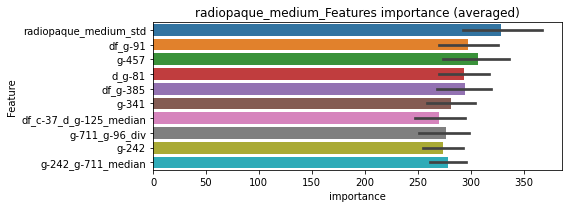

len(train_index) : 2798
len(valid_index) : 933
================================= fold 1/4 radiopaque_medium=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111202	valid_1's binary_logloss: 0.158189
[200]	training's binary_logloss: 0.0398526	valid_1's binary_logloss: 0.0868628
[300]	training's binary_logloss: 0.0167077	valid_1's binary_logloss: 0.0584854
[400]	training's binary_logloss: 0.00741821	valid_1's binary_logloss: 0.0451701
[500]	training's binary_logloss: 0.00379712	valid_1's binary_logloss: 0.038211
[600]	training's binary_logloss: 0.00226367	valid_1's binary_logloss: 0.0351263
[700]	training's binary_logloss: 0.00152847	valid_1's binary_logloss: 0.0330941
[800]	training's binary_logloss: 0.00115388	valid_1's binary_logloss: 0.0322864
[900]	training's binary_logloss: 0.000938981	valid_1's binary_logloss: 0.0319645
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.000990123	valid_1's binary_logloss: 0.0317318


len(train_index) : 2798
len(valid_index) : 933
================================= fold 2/4 radiopaque_medium=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110417	valid_1's binary_logloss: 0.156005
[200]	training's binary_logloss: 0.0389113	valid_1's binary_logloss: 0.0842013
[300]	training's binary_logloss: 0.0162573	valid_1's binary_logloss: 0.0551822
[400]	training's binary_logloss: 0.00725667	valid_1's binary_logloss: 0.040477
[500]	training's binary_logloss: 0.00373701	valid_1's binary_logloss: 0.0330019
[600]	training's binary_logloss: 0.00223472	valid_1's binary_logloss: 0.0293519
[700]	training's binary_logloss: 0.00152526	valid_1's binary_logloss: 0.0276215
[800]	training's binary_logloss: 0.00113903	valid_1's binary_logloss: 0.026533
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.00118346	valid_1's binary_logloss: 0.026395


len(train_index) : 2798
len(valid_index) : 933
================================= fold 3/4 radiopaque_medium=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109991	valid_1's binary_logloss: 0.172837
[200]	training's binary_logloss: 0.040448	valid_1's binary_logloss: 0.0990285
[300]	training's binary_logloss: 0.0167011	valid_1's binary_logloss: 0.0672382
[400]	training's binary_logloss: 0.00760083	valid_1's binary_logloss: 0.052091
[500]	training's binary_logloss: 0.00379017	valid_1's binary_logloss: 0.0432524
[600]	training's binary_logloss: 0.00224087	valid_1's binary_logloss: 0.0383288
[700]	training's binary_logloss: 0.00151626	valid_1's binary_logloss: 0.0362805
[800]	training's binary_logloss: 0.00113643	valid_1's binary_logloss: 0.0343665
[900]	training's binary_logloss: 0.000920152	valid_1's binary_logloss: 0.0333383
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000927722	valid_1's binary_logloss: 0.0331881


len(train_index) : 2799
len(valid_index) : 932
================================= fold 4/4 radiopaque_medium=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111254	valid_1's binary_logloss: 0.152373
[200]	training's binary_logloss: 0.0402119	valid_1's binary_logloss: 0.0817021
[300]	training's binary_logloss: 0.0164411	valid_1's binary_logloss: 0.0514544
[400]	training's binary_logloss: 0.00738224	valid_1's binary_logloss: 0.0390457
[500]	training's binary_logloss: 0.00373703	valid_1's binary_logloss: 0.0303293
[600]	training's binary_logloss: 0.00222856	valid_1's binary_logloss: 0.0263688
[700]	training's binary_logloss: 0.0015227	valid_1's binary_logloss: 0.024591
[800]	training's binary_logloss: 0.00114716	valid_1's binary_logloss: 0.0232823
[900]	training's binary_logloss: 0.000937633	valid_1's binary_logloss: 0.0222922
[1000]	training's binary_logloss: 0.000821192	valid_1's binary_logloss: 0.0219065
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000826531	valid_1's binary_logloss: 0.0218777


radiopaque_medium logloss: 0.028299891627141596


neg labels: 3289 → selected neg labels: 3266


raf_inhibitor, len(trt): 223, len(othr): 3266, target_rate: 0.0093642 → Adj_target_rate: 0.0083226
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.226959	valid_1's binary_logloss: 0.328736
[200]	training's binary_logloss: 0.140377	valid_1's binary_logloss: 0.288954
[300]	training's binary_logloss: 0.089319	valid_1's binary_logloss: 0.26716
[400]	training's binary_logloss: 0.0590627	valid_1's binary_logloss: 0.256468
[500]	training's binary_logloss: 0.0399511	valid_1's binary_logloss: 0.251199
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.0339808	valid_1's binary_logloss: 0.249863
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.218791	valid_1's binary_logloss: 0.339075
[200]	training's binary_logloss: 0.133345	valid_1's binary_logloss: 0.299414
[300]	training's binary_logloss: 0.08627	valid_1's binary_logloss: 0.274879
[400]	training's binary_logloss: 0.0569225	valid_1's binary_logloss: 0.263648
[500]	training's binary_logloss: 0.0385797	valid_1's binary_logloss: 0.

1 / 3 AUC score:0.892
y_Threshold: 0.1123260, Threshold: 0.4621702, pos_neg_ratio: 0.8000000
Remove_noisy_data: 431 → Positive_corect_labels: 503/3488
p_label_rate: 0.0100452 Vs.target_rate: 0.00936, Num_p_label: 40.0, conf_0:0.32352, conf_1:0.60082
threshold: 0.4621702, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 503.0/3488, y_label_rate: 0.1442087
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1414	valid_1's binary_logloss: 0.248841
[200]	training's binary_logloss: 0.0689305	valid_1's binary_logloss: 0.195432
[300]	training's binary_logloss: 0.0366655	valid_1's binary_logloss: 0.167503
[400]	training's binary_logloss: 0.0204079	valid_1's binary_logloss: 0.153463
[500]	training's binary_logloss: 0.011367	valid_1's binary_logloss: 0.144266
[600]	training's binary_logloss: 0.00679798	valid_1's binary_logloss: 0.139109
[700]	training's binary_logloss: 0.00435344	valid_1's binary_logloss: 0.138629
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.00484837	valid_1's binary_logloss: 0.138088
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149661	valid_1's binary_logloss: 0.236028
[200]	training's binary_logloss: 0.0720655	valid_1's binary_logloss: 0.185032
[300]	training's binary_logloss: 0.0379488	valid_1's binary_loglo

2 / 3 AUC score:0.973
y_Threshold: 0.1031633, Threshold: 0.4621702, pos_neg_ratio: 0.8000000
Remove_noisy_data: 122 → Positive_corect_labels: 442.0/3366
p_label_rate: 0.0391763 Vs.target_rate: 0.00936, Num_p_label: 156.0, conf_0:0.36974, conf_1:0.55460
Num_p_label: 156.0, Expected: 37.3, Adj_threshold_1: 0.4621702
Num_p_label: 144.0, Expected: 37.3, Adj_threshold_2: 0.4921702
Num_p_label: 136.0, Expected: 37.3, Adj_threshold_3: 0.5221702
Num_p_label: 124.0, Expected: 37.3, Adj_threshold_4: 0.5521702
Num_p_label: 113.0, Expected: 37.3, Adj_threshold_5: 0.5821702
Num_p_label: 105.0, Expected: 37.3, Adj_threshold_6: 0.6121702
Num_p_label: 101.0, Expected: 37.3, Adj_threshold_7: 0.6421702
Num_p_label: 95.0, Expected: 37.3, Adj_threshold_8: 0.6721702
threshold: 0.6721702, positive_p_label: 95.0/3982, p_label_rate: 0.0238574
positive_y_label: 442.0/3366, y_label_rate: 0.1313131
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114005	valid_1's binary_logloss: 0.187401
[200]	training's binary_logloss: 0.0492884	valid_1's binary_logloss: 0.140605
[300]	training's binary_logloss: 0.0243483	valid_1's binary_logloss: 0.122289
[400]	training's binary_logloss: 0.0125404	valid_1's binary_logloss: 0.114255
[500]	training's binary_logloss: 0.00668845	valid_1's binary_logloss: 0.110545
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00653699	valid_1's binary_logloss: 0.110231
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114777	valid_1's binary_logloss: 0.174168
[200]	training's binary_logloss: 0.0493407	valid_1's binary_logloss: 0.125904
[300]	training's binary_logloss: 0.0232279	valid_1's binary_logloss: 0.104248
[400]	training's binary_logloss: 0.011776	valid_1's binary_logloss: 0.0948613
[500]	training's binary_logloss: 0.00636949	valid_1's binary_lo

3 / 3 AUC score:0.979
y_Threshold: 0.0932832, Threshold: 0.6721702, pos_neg_ratio: 0.8000000
Remove_noisy_data: 72 → Positive_corect_labels: 406.0/3294
p_label_rate: 0.0414365 Vs.target_rate: 0.00936, Num_p_label: 165.0, conf_0:0.50000, conf_1:0.73939
Num_p_label: 165.0, Expected: 37.3, Adj_threshold_1: 0.6721702
threshold: 0.6721702, positive_p_label: 165.0/3982, p_label_rate: 0.0414365
positive_y_label: 406.0/3294, y_label_rate: 0.1232544


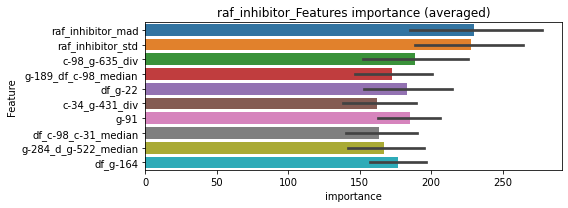

len(train_index) : 2470
len(valid_index) : 824
================================= fold 1/4 raf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0953762	valid_1's binary_logloss: 0.1577
[200]	training's binary_logloss: 0.0367404	valid_1's binary_logloss: 0.107182
[300]	training's binary_logloss: 0.0163931	valid_1's binary_logloss: 0.0854849
[400]	training's binary_logloss: 0.00802187	valid_1's binary_logloss: 0.0754297
[500]	training's binary_logloss: 0.00439578	valid_1's binary_logloss: 0.0719199
[600]	training's binary_logloss: 0.0026952	valid_1's binary_logloss: 0.0699629
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.0026952	valid_1's binary_logloss: 0.0699629


len(train_index) : 2470
len(valid_index) : 824
================================= fold 2/4 raf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0979932	valid_1's binary_logloss: 0.157697
[200]	training's binary_logloss: 0.0372121	valid_1's binary_logloss: 0.102842
[300]	training's binary_logloss: 0.0165165	valid_1's binary_logloss: 0.0799435
[400]	training's binary_logloss: 0.00819601	valid_1's binary_logloss: 0.068661
[500]	training's binary_logloss: 0.00439042	valid_1's binary_logloss: 0.062144
[600]	training's binary_logloss: 0.00270048	valid_1's binary_logloss: 0.0589285
[700]	training's binary_logloss: 0.00186607	valid_1's binary_logloss: 0.0567392
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.00152978	valid_1's binary_logloss: 0.05562


len(train_index) : 2471
len(valid_index) : 823
================================= fold 3/4 raf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957451	valid_1's binary_logloss: 0.166072
[200]	training's binary_logloss: 0.0378964	valid_1's binary_logloss: 0.118759
[300]	training's binary_logloss: 0.0168907	valid_1's binary_logloss: 0.0989557
[400]	training's binary_logloss: 0.00836766	valid_1's binary_logloss: 0.0887199
[500]	training's binary_logloss: 0.0044345	valid_1's binary_logloss: 0.085568
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00359203	valid_1's binary_logloss: 0.0847273


len(train_index) : 2471
len(valid_index) : 823
================================= fold 4/4 raf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970677	valid_1's binary_logloss: 0.151529
[200]	training's binary_logloss: 0.0373348	valid_1's binary_logloss: 0.109605
[300]	training's binary_logloss: 0.0167094	valid_1's binary_logloss: 0.095772
[400]	training's binary_logloss: 0.00808593	valid_1's binary_logloss: 0.0897771
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00612365	valid_1's binary_logloss: 0.0887427


raf_inhibitor logloss: 0.07475596418189191
ras_gtpase_inhibitor, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0786689	valid_1's binary_logloss: 0.0917215
[200]	training's binary_logloss: 0.0221884	valid_1's binary_logloss: 0.0313162
[300]	training's binary_logloss: 0.00639683	valid_1's binary_logloss: 0.0127328
[400]	training's binary_logloss: 0.00233806	valid_1's binary_logloss: 0.00666961
[500]	training's binary_logloss: 0.00117794	valid_1's binary_logloss: 0.0045654
[600]	training's binary_logloss: 0.000748035	valid_1's binary_logloss: 0.00362053
[700]	training's binary_logloss: 0.000554959	valid_1's binary_logloss: 0.00314109
[800]	training's binary_logloss: 0.000454431	valid_1's binary_logloss: 0.00286672
[900]	training's binary_logloss: 0.000414813	valid_1's binary_logloss: 0.00271153
Early stopping, best iteration is:
[943]	training's binary_logloss: 0.000409869	valid_1's binary_logloss: 0.00269238
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0037249, Threshold: 0.0457216, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.03201, conf_1:0.05944
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0457216
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_2: 0.0757216
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_3: 0.1057216
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_4: 0.1357216
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.1657216
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.1957216
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.2257216
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.2557216
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.2857216
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_10: 0.3157216
threshold: 0.3457216, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0710661	valid_1's binary_logloss: 0.0832592
[200]	training's binary_logloss: 0.0174385	valid_1's binary_logloss: 0.0241115
[300]	training's binary_logloss: 0.00495378	valid_1's binary_logloss: 0.008367
[400]	training's binary_logloss: 0.00188415	valid_1's binary_logloss: 0.00384506
[500]	training's binary_logloss: 0.000977292	valid_1's binary_logloss: 0.0023621
[600]	training's binary_logloss: 0.000630603	valid_1's binary_logloss: 0.00173098
[700]	training's binary_logloss: 0.000467713	valid_1's binary_logloss: 0.0013935
[800]	training's binary_logloss: 0.000398025	valid_1's binary_logloss: 0.00127199
[900]	training's binary_logloss: 0.000375359	valid_1's binary_logloss: 0.0012212
[1000]	training's binary_logloss: 0.000371162	valid_1's binary_logloss: 0.0012138
Early stopping, best iteration is:
[979]	training's binary_logloss: 0.00037123	valid_1's binary_logloss: 0.00121376
Training until v

2 / 3 AUC score:1.000
y_Threshold: 0.1504083, Threshold: 0.3457216, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0062783 Vs.target_rate: 0.00050, Num_p_label: 25.0, conf_0:0.27658, conf_1:0.41487
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.3457216
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_2: 0.3757216
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_3: 0.4057216
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_4: 0.4357216
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_5: 0.4657216
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_6: 0.4957216
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_7: 0.5257216
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_8: 0.5557216
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.5857216
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_10: 0.6157216
threshold: 0.6457216, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0710661	valid_1's binary_logloss: 0.0832592
[200]	training's binary_logloss: 0.0174385	valid_1's binary_logloss: 0.0241115
[300]	training's binary_logloss: 0.00495378	valid_1's binary_logloss: 0.008367
[400]	training's binary_logloss: 0.00188415	valid_1's binary_logloss: 0.00384506
[500]	training's binary_logloss: 0.000977292	valid_1's binary_logloss: 0.0023621
[600]	training's binary_logloss: 0.000630603	valid_1's binary_logloss: 0.00173098
[700]	training's binary_logloss: 0.000467713	valid_1's binary_logloss: 0.0013935
[800]	training's binary_logloss: 0.000398025	valid_1's binary_logloss: 0.00127199
[900]	training's binary_logloss: 0.000375359	valid_1's binary_logloss: 0.0012212
[1000]	training's binary_logloss: 0.000371162	valid_1's binary_logloss: 0.0012138
Early stopping, best iteration is:
[979]	training's binary_logloss: 0.00037123	valid_1's binary_logloss: 0.00121376
Training until v

3 / 3 AUC score:1.000
y_Threshold: 0.1504083, Threshold: 0.6457216, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.50000, conf_1:0.71029
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.6457216
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.6757216
threshold: 0.6757216, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


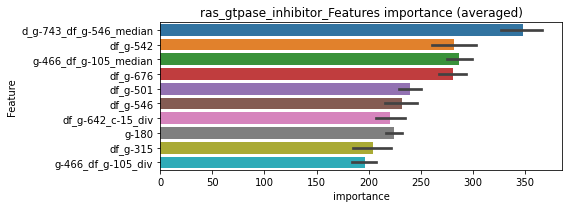

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0706969	valid_1's binary_logloss: 0.0828956
[200]	training's binary_logloss: 0.0173894	valid_1's binary_logloss: 0.02388
[300]	training's binary_logloss: 0.00494698	valid_1's binary_logloss: 0.00833461
[400]	training's binary_logloss: 0.00187673	valid_1's binary_logloss: 0.00381193
[500]	training's binary_logloss: 0.000981318	valid_1's binary_logloss: 0.00235432
[600]	training's binary_logloss: 0.000634731	valid_1's binary_logloss: 0.0017204
[700]	training's binary_logloss: 0.000475019	valid_1's binary_logloss: 0.00139478
[800]	training's binary_logloss: 0.000397785	valid_1's binary_logloss: 0.0012351
[900]	training's binary_logloss: 0.000377368	valid_1's binary_logloss: 0.00119373
Early stopping, best iteration is:
[893]	training's binary_logloss: 0.000377368	valid_1's binary_logloss: 0.00119373


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0751407	valid_1's binary_logloss: 0.0815477
[200]	training's binary_logloss: 0.0186882	valid_1's binary_logloss: 0.0235725
[300]	training's binary_logloss: 0.00533373	valid_1's binary_logloss: 0.00849253
[400]	training's binary_logloss: 0.00201609	valid_1's binary_logloss: 0.0041428
[500]	training's binary_logloss: 0.00103269	valid_1's binary_logloss: 0.00247417
[600]	training's binary_logloss: 0.000664897	valid_1's binary_logloss: 0.00178385
[700]	training's binary_logloss: 0.000490359	valid_1's binary_logloss: 0.00147816
[800]	training's binary_logloss: 0.000406279	valid_1's binary_logloss: 0.00133428
[900]	training's binary_logloss: 0.000379092	valid_1's binary_logloss: 0.00128074
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000379092	valid_1's binary_logloss: 0.00128074


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0722121	valid_1's binary_logloss: 0.0833458
[200]	training's binary_logloss: 0.0176948	valid_1's binary_logloss: 0.0228614
[300]	training's binary_logloss: 0.00517512	valid_1's binary_logloss: 0.00780173
[400]	training's binary_logloss: 0.00194276	valid_1's binary_logloss: 0.00338072
[500]	training's binary_logloss: 0.00101956	valid_1's binary_logloss: 0.00196123
[600]	training's binary_logloss: 0.000656016	valid_1's binary_logloss: 0.0013551
[700]	training's binary_logloss: 0.000485479	valid_1's binary_logloss: 0.00106598
[800]	training's binary_logloss: 0.000402705	valid_1's binary_logloss: 0.000916934
Early stopping, best iteration is:
[840]	training's binary_logloss: 0.000387263	valid_1's binary_logloss: 0.000886812


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0747829	valid_1's binary_logloss: 0.0843067
[200]	training's binary_logloss: 0.0186043	valid_1's binary_logloss: 0.0246208
[300]	training's binary_logloss: 0.00537361	valid_1's binary_logloss: 0.00862741
[400]	training's binary_logloss: 0.0019887	valid_1's binary_logloss: 0.00381637
[500]	training's binary_logloss: 0.00101154	valid_1's binary_logloss: 0.00216019
[600]	training's binary_logloss: 0.000657964	valid_1's binary_logloss: 0.00153343
[700]	training's binary_logloss: 0.000485882	valid_1's binary_logloss: 0.00120732
[800]	training's binary_logloss: 0.000404075	valid_1's binary_logloss: 0.00104567
[900]	training's binary_logloss: 0.00038192	valid_1's binary_logloss: 0.0010007
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.000380953	valid_1's binary_logloss: 0.000998576


ras_gtpase_inhibitor logloss: 0.0010899919868958842
retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13351	valid_1's binary_logloss: 0.210317
[200]	training's binary_logloss: 0.0581955	valid_1's binary_logloss: 0.140958
[300]	training's binary_logloss: 0.0277924	valid_1's binary_logloss: 0.107523
[400]	training's binary_logloss: 0.0139962	valid_1's binary_logloss: 0.0913242
[500]	training's binary_logloss: 0.00739907	valid_1's binary_logloss: 0.0802595
[600]	training's binary_logloss: 0.00430166	valid_1's binary_logloss: 0.0764629
[700]	training's binary_logloss: 0.00278404	valid_1's binary_logloss: 0.0735296
[800]	training's binary_logloss: 0.00197702	valid_1's binary_logloss: 0.0721994
[900]	training's binary_logloss: 0.00151911	valid_1's binary_logloss: 0.0712962
[1000]	training's binary_logloss: 0.00124945	valid_1's binary_logloss: 0.0706544
Early stopping, best iteration is:
[1004]	training's binary_logloss: 0.00124079	valid_1's binary_logloss: 0.0705956
Training until validation score

1 / 3 AUC score:0.994
y_Threshold: 0.0274181, Threshold: 0.3089753, pos_neg_ratio: 0.8000000
Remove_noisy_data: 146 → Positive_corect_labels: 648/3787
p_label_rate: 0.0100452 Vs.target_rate: 0.00281, Num_p_label: 40.0, conf_0:0.21628, conf_1:0.40167
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_1: 0.3089753
Num_p_label: 39.0, Expected: 11.2, Adj_threshold_2: 0.3389753
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_3: 0.3689753
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_4: 0.3989753
Num_p_label: 32.0, Expected: 11.2, Adj_threshold_5: 0.4289753
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_6: 0.4589753
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_7: 0.4889753
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_8: 0.5189753
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_9: 0.5489753
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_10: 0.5789753
threshold: 0.6089753, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 648.0/3787, y_label_rate: 0.1711117


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12948	valid_1's binary_logloss: 0.188449
[200]	training's binary_logloss: 0.0526211	valid_1's binary_logloss: 0.117
[300]	training's binary_logloss: 0.0232852	valid_1's binary_logloss: 0.0843522
[400]	training's binary_logloss: 0.011331	valid_1's binary_logloss: 0.0681939
[500]	training's binary_logloss: 0.00591655	valid_1's binary_logloss: 0.0606015
[600]	training's binary_logloss: 0.00342837	valid_1's binary_logloss: 0.0569966
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00290105	valid_1's binary_logloss: 0.0559087
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134682	valid_1's binary_logloss: 0.182465
[200]	training's binary_logloss: 0.0576909	valid_1's binary_logloss: 0.111308
[300]	training's binary_logloss: 0.0269038	valid_1's binary_logloss: 0.0759461
[400]	training's binary_logloss: 0.0124304	valid_1's binary_l

2 / 3 AUC score:0.998
y_Threshold: 0.0981443, Threshold: 0.6089753, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 629.0/3749
p_label_rate: 0.0123054 Vs.target_rate: 0.00281, Num_p_label: 49.0, conf_0:0.48718, conf_1:0.73077
Num_p_label: 49.0, Expected: 11.2, Adj_threshold_1: 0.6089753
Num_p_label: 47.0, Expected: 11.2, Adj_threshold_2: 0.6389753
Num_p_label: 43.0, Expected: 11.2, Adj_threshold_3: 0.6689753
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_4: 0.6989753
threshold: 0.6989753, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 629.0/3749, y_label_rate: 0.1677781
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121454	valid_1's binary_logloss: 0.171033
[200]	training's binary_logloss: 0.0501455	valid_1's binary_logloss: 0.0975452
[300]	training's binary_logloss: 0.021836	valid_1's binary_logloss: 0.0638128
[400]	training's binary_logloss: 0.0102966	valid_1's binary_logloss: 0.0463507
[500]	training's binary_logloss: 0.00531303	valid_1's binary_logloss: 0.0366392
[600]	training's binary_logloss: 0.00307601	valid_1's binary_logloss: 0.0317332
[700]	training's binary_logloss: 0.00204033	valid_1's binary_logloss: 0.0286975
[800]	training's binary_logloss: 0.00150705	valid_1's binary_logloss: 0.0267385
[900]	training's binary_logloss: 0.00119147	valid_1's binary_logloss: 0.0254183
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.0011508	valid_1's binary_logloss: 0.0252712
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122079	valid_1's

3 / 3 AUC score:0.996
y_Threshold: 0.1165760, Threshold: 0.6989753, pos_neg_ratio: 0.8000000
Remove_noisy_data: 46 → Positive_corect_labels: 606.0/3703
p_label_rate: 0.0140633 Vs.target_rate: 0.00281, Num_p_label: 56.0, conf_0:0.50000, conf_1:0.76887
Num_p_label: 56.0, Expected: 11.2, Adj_threshold_1: 0.6989753
threshold: 0.6989753, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 606.0/3703, y_label_rate: 0.1636511


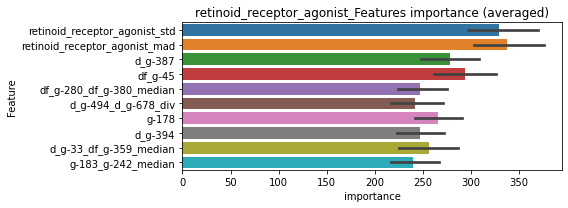

len(train_index) : 2777
len(valid_index) : 926
================================= fold 1/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11724	valid_1's binary_logloss: 0.16586
[200]	training's binary_logloss: 0.0450441	valid_1's binary_logloss: 0.092712
[300]	training's binary_logloss: 0.0190646	valid_1's binary_logloss: 0.0622141
[400]	training's binary_logloss: 0.00881352	valid_1's binary_logloss: 0.0474681
[500]	training's binary_logloss: 0.00451697	valid_1's binary_logloss: 0.0399474
[600]	training's binary_logloss: 0.00266895	valid_1's binary_logloss: 0.0360029
[700]	training's binary_logloss: 0.00179984	valid_1's binary_logloss: 0.0344196
[800]	training's binary_logloss: 0.00133591	valid_1's binary_logloss: 0.0330309
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00140632	valid_1's binary_logloss: 0.0328819


len(train_index) : 2777
len(valid_index) : 926
================================= fold 2/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114428	valid_1's binary_logloss: 0.172739
[200]	training's binary_logloss: 0.0423503	valid_1's binary_logloss: 0.106291
[300]	training's binary_logloss: 0.0182986	valid_1's binary_logloss: 0.0763676
[400]	training's binary_logloss: 0.00813155	valid_1's binary_logloss: 0.063085
[500]	training's binary_logloss: 0.00423104	valid_1's binary_logloss: 0.0568494
[600]	training's binary_logloss: 0.00249903	valid_1's binary_logloss: 0.0533072
[700]	training's binary_logloss: 0.00169567	valid_1's binary_logloss: 0.0519752
[800]	training's binary_logloss: 0.00127762	valid_1's binary_logloss: 0.0509206
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.00109352	valid_1's binary_logloss: 0.0499431


len(train_index) : 2777
len(valid_index) : 926
================================= fold 3/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11653	valid_1's binary_logloss: 0.155408
[200]	training's binary_logloss: 0.0463222	valid_1's binary_logloss: 0.0855895
[300]	training's binary_logloss: 0.0197965	valid_1's binary_logloss: 0.0560071
[400]	training's binary_logloss: 0.00916537	valid_1's binary_logloss: 0.0415073
[500]	training's binary_logloss: 0.00472309	valid_1's binary_logloss: 0.0335088
[600]	training's binary_logloss: 0.00278173	valid_1's binary_logloss: 0.0290618
[700]	training's binary_logloss: 0.0018554	valid_1's binary_logloss: 0.0267473
[800]	training's binary_logloss: 0.00136776	valid_1's binary_logloss: 0.0251771
[900]	training's binary_logloss: 0.00109461	valid_1's binary_logloss: 0.0242568
[1000]	training's binary_logloss: 0.000929844	valid_1's binary_logloss: 0.0236114
[1100]	training's binary_logloss: 0.000844185	valid_1's binary_logloss: 0.0233894
Early stopping, best iteration is:
[1158]	training's binary_lo

len(train_index) : 2778
len(valid_index) : 925
================================= fold 4/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113034	valid_1's binary_logloss: 0.174324
[200]	training's binary_logloss: 0.0432526	valid_1's binary_logloss: 0.103715
[300]	training's binary_logloss: 0.0181676	valid_1's binary_logloss: 0.0704486
[400]	training's binary_logloss: 0.00832254	valid_1's binary_logloss: 0.052034
[500]	training's binary_logloss: 0.0043472	valid_1's binary_logloss: 0.0424242
[600]	training's binary_logloss: 0.00257713	valid_1's binary_logloss: 0.0372687
[700]	training's binary_logloss: 0.00175665	valid_1's binary_logloss: 0.0350409
[800]	training's binary_logloss: 0.00131407	valid_1's binary_logloss: 0.0330433
Early stopping, best iteration is:
[861]	training's binary_logloss: 0.00114121	valid_1's binary_logloss: 0.0323522


retinoid_receptor_agonist logloss: 0.034596709195334835
retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452776	valid_1's binary_logloss: 0.0489713
[200]	training's binary_logloss: 0.00745814	valid_1's binary_logloss: 0.0107085
[300]	training's binary_logloss: 0.0016983	valid_1's binary_logloss: 0.0045758
[400]	training's binary_logloss: 0.000637141	valid_1's binary_logloss: 0.00303212
[500]	training's binary_logloss: 0.000360187	valid_1's binary_logloss: 0.00243586
[600]	training's binary_logloss: 0.000256459	valid_1's binary_logloss: 0.00215885
[700]	training's binary_logloss: 0.000219623	valid_1's binary_logloss: 0.00197997
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.000212496	valid_1's binary_logloss: 0.00193254
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0454598	valid_1's binary_logloss: 0.0475254
[200]	training's binary_logloss: 0.00761643	valid_1's binary_logloss: 0.00924538
[300]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0008875, Threshold: 0.0056374, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00395, conf_1:0.00733
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0056374
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0356374
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0656374
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0956374
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_5: 0.1256374
threshold: 0.1256374, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0450538	valid_1's binary_logloss: 0.0472905
[200]	training's binary_logloss: 0.0070985	valid_1's binary_logloss: 0.00788044
[300]	training's binary_logloss: 0.00152872	valid_1's binary_logloss: 0.00185994
[400]	training's binary_logloss: 0.000548744	valid_1's binary_logloss: 0.000723265
[500]	training's binary_logloss: 0.000307161	valid_1's binary_logloss: 0.000425664
[600]	training's binary_logloss: 0.000220986	valid_1's binary_logloss: 0.00031479
[700]	training's binary_logloss: 0.000191826	valid_1's binary_logloss: 0.000275752
[800]	training's binary_logloss: 0.000184043	valid_1's binary_logloss: 0.000264945
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.000183963	valid_1's binary_logloss: 0.000264839
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448672	valid_1's binary_logloss: 0.0464273
[200]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1917974, Threshold: 0.1256374, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0035158 Vs.target_rate: 0.00025, Num_p_label: 14.0, conf_0:0.10051, conf_1:0.15076
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_1: 0.1256374
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.1556374
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_3: 0.1856374
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.2156374
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.2456374
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.2756374
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.3056374
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.3356374
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.3656374
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_10: 0.3956374
threshold: 0.4256374, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0450538	valid_1's binary_logloss: 0.0472905
[200]	training's binary_logloss: 0.0070985	valid_1's binary_logloss: 0.00788044
[300]	training's binary_logloss: 0.00152872	valid_1's binary_logloss: 0.00185994
[400]	training's binary_logloss: 0.000548744	valid_1's binary_logloss: 0.000723265
[500]	training's binary_logloss: 0.000307161	valid_1's binary_logloss: 0.000425664
[600]	training's binary_logloss: 0.000220986	valid_1's binary_logloss: 0.00031479
[700]	training's binary_logloss: 0.000191826	valid_1's binary_logloss: 0.000275752
[800]	training's binary_logloss: 0.000184043	valid_1's binary_logloss: 0.000264945
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.000183963	valid_1's binary_logloss: 0.000264839
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448672	valid_1's binary_logloss: 0.0464273
[200]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1917974, Threshold: 0.4256374, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.38307, conf_1:0.46820


Early stopping, best iteration is:
[790]	training's binary_logloss: 0.000183285	valid_1's binary_logloss: 0.00030201


Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.4256374
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.4556374
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.4856374
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.5156374
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.5456374
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.5756374
threshold: 0.5756374, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


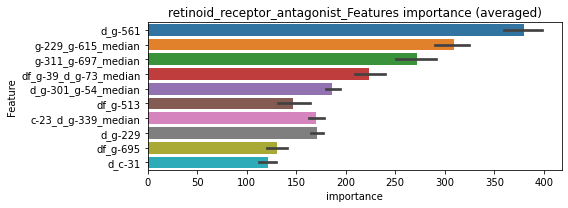

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0449579	valid_1's binary_logloss: 0.0470645
[200]	training's binary_logloss: 0.0070932	valid_1's binary_logloss: 0.00793535
[300]	training's binary_logloss: 0.00151548	valid_1's binary_logloss: 0.00187363
[400]	training's binary_logloss: 0.000543383	valid_1's binary_logloss: 0.000742699
[500]	training's binary_logloss: 0.000307069	valid_1's binary_logloss: 0.000446291
[600]	training's binary_logloss: 0.000224102	valid_1's binary_logloss: 0.000334541
[700]	training's binary_logloss: 0.000193179	valid_1's binary_logloss: 0.0002908
[800]	training's binary_logloss: 0.000185284	valid_1's binary_logloss: 0.000279095


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[844]	training's binary_logloss: 0.000184094	valid_1's binary_logloss: 0.000277291
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451269	valid_1's binary_logloss: 0.0466198
[200]	training's binary_logloss: 0.00711436	valid_1's binary_logloss: 0.00788161
[300]	training's binary_logloss: 0.00151265	valid_1's binary_logloss: 0.001919
[400]	training's binary_logloss: 0.000543113	valid_1's binary_logloss: 0.000778547
[500]	training's binary_logloss: 0.000303633	valid_1's binary_logloss: 0.000463859
[600]	training's binary_logloss: 0.000222106	valid_1's binary_logloss: 0.000342858
[700]	training's binary_logloss: 0.00019299	valid_1's binary_logloss: 0.000300615


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 retinoid_receptor_antagonist=================================


[800]	training's binary_logloss: 0.000184338	valid_1's binary_logloss: 0.000286714
Early stopping, best iteration is:
[785]	training's binary_logloss: 0.000184338	valid_1's binary_logloss: 0.000286714
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452962	valid_1's binary_logloss: 0.0478994
[200]	training's binary_logloss: 0.00718732	valid_1's binary_logloss: 0.0077436
[300]	training's binary_logloss: 0.00155554	valid_1's binary_logloss: 0.00175001
[400]	training's binary_logloss: 0.00055749	valid_1's binary_logloss: 0.000653205
[500]	training's binary_logloss: 0.000308294	valid_1's binary_logloss: 0.000373605
[600]	training's binary_logloss: 0.000223156	valid_1's binary_logloss: 0.000275906
[700]	training's binary_logloss: 0.000192798	valid_1's binary_logloss: 0.000241825
[800]	training's binary_logloss: 0.000186145	valid_1's binary_logloss: 0.000234135


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[804]	training's binary_logloss: 0.000186109	valid_1's binary_logloss: 0.000234086
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453751	valid_1's binary_logloss: 0.0492065
[200]	training's binary_logloss: 0.00718572	valid_1's binary_logloss: 0.00863716
[300]	training's binary_logloss: 0.00153089	valid_1's binary_logloss: 0.00211028
[400]	training's binary_logloss: 0.000553609	valid_1's binary_logloss: 0.000864782
[500]	training's binary_logloss: 0.000307139	valid_1's binary_logloss: 0.000511431
[600]	training's binary_logloss: 0.000222601	valid_1's binary_logloss: 0.000389064
[700]	training's binary_logloss: 0.000193159	valid_1's binary_logloss: 0.000347826
[800]	training's binary_logloss: 0.000183103	valid_1's binary_logloss: 0.000334996
Early stopping, best iteration is:
[824]	training's binary_logloss: 0.000181982	valid_1's binary_logloss: 0.000333713


retinoid_receptor_antagonist logloss: 0.00028295222242813716
rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106277	valid_1's binary_logloss: 0.140697
[200]	training's binary_logloss: 0.0405304	valid_1's binary_logloss: 0.0719898
[300]	training's binary_logloss: 0.0163286	valid_1's binary_logloss: 0.0430658
[400]	training's binary_logloss: 0.00716474	valid_1's binary_logloss: 0.0282053
[500]	training's binary_logloss: 0.0035632	valid_1's binary_logloss: 0.0211863
[600]	training's binary_logloss: 0.00211432	valid_1's binary_logloss: 0.0182828
[700]	training's binary_logloss: 0.00144706	valid_1's binary_logloss: 0.0168331
[800]	training's binary_logloss: 0.00108837	valid_1's binary_logloss: 0.0158428
[900]	training's binary_logloss: 0.000885975	valid_1's binary_logloss: 0.0154424
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000847998	valid_1's binary_logloss: 0.0153001
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107505	valid

1 / 3 AUC score:0.999
y_Threshold: 0.0162498, Threshold: 0.0902164, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00147, Num_p_label: 40.0, conf_0:0.06315, conf_1:0.11728
Num_p_label: 40.0, Expected: 5.9, Adj_threshold_1: 0.0902164
Num_p_label: 28.0, Expected: 5.9, Adj_threshold_2: 0.1202164
Num_p_label: 25.0, Expected: 5.9, Adj_threshold_3: 0.1502164
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_4: 0.1802164
Num_p_label: 18.0, Expected: 5.9, Adj_threshold_5: 0.2102164
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_6: 0.2402164
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_7: 0.2702164
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_8: 0.3002164
Num_p_label: 14.0, Expected: 5.9, Adj_threshold_9: 0.3302164
threshold: 0.3302164, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0989353	valid_1's binary_logloss: 0.13831
[200]	training's binary_logloss: 0.0332726	valid_1's binary_logloss: 0.0666813
[300]	training's binary_logloss: 0.0122944	valid_1's binary_logloss: 0.0397792
[400]	training's binary_logloss: 0.00533987	valid_1's binary_logloss: 0.0305017
[500]	training's binary_logloss: 0.00277004	valid_1's binary_logloss: 0.026149
[600]	training's binary_logloss: 0.00171443	valid_1's binary_logloss: 0.0240472
[700]	training's binary_logloss: 0.00118856	valid_1's binary_logloss: 0.0226328
[800]	training's binary_logloss: 0.00091816	valid_1's binary_logloss: 0.0218366
[900]	training's binary_logloss: 0.000750668	valid_1's binary_logloss: 0.0214484
[1000]	training's binary_logloss: 0.000668421	valid_1's binary_logloss: 0.0212389
Early stopping, best iteration is:
[973]	training's binary_logloss: 0.000681964	valid_1's binary_logloss: 0.0211874
Training until validation 

2 / 3 AUC score:1.000
y_Threshold: 0.1070841, Threshold: 0.3302164, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 645.0/3785
p_label_rate: 0.0097941 Vs.target_rate: 0.00147, Num_p_label: 39.0, conf_0:0.26417, conf_1:0.39626
Num_p_label: 39.0, Expected: 5.9, Adj_threshold_1: 0.3302164
Num_p_label: 33.0, Expected: 5.9, Adj_threshold_2: 0.3602164
Num_p_label: 30.0, Expected: 5.9, Adj_threshold_3: 0.3902164
Num_p_label: 28.0, Expected: 5.9, Adj_threshold_4: 0.4202164
Num_p_label: 27.0, Expected: 5.9, Adj_threshold_5: 0.4502164
Num_p_label: 27.0, Expected: 5.9, Adj_threshold_6: 0.4802164
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_7: 0.5102164
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_8: 0.5402164
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_9: 0.5702164
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_10: 0.6002164
threshold: 0.6302164, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 645.0/3785, y_label_rate: 0.1704095
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0989869	valid_1's binary_logloss: 0.126759
[200]	training's binary_logloss: 0.0332582	valid_1's binary_logloss: 0.0594561
[300]	training's binary_logloss: 0.0125691	valid_1's binary_logloss: 0.0344293
[400]	training's binary_logloss: 0.00530487	valid_1's binary_logloss: 0.023388
[500]	training's binary_logloss: 0.00268653	valid_1's binary_logloss: 0.0176767
[600]	training's binary_logloss: 0.00164841	valid_1's binary_logloss: 0.014752
[700]	training's binary_logloss: 0.00116275	valid_1's binary_logloss: 0.0131819
[800]	training's binary_logloss: 0.000890375	valid_1's binary_logloss: 0.012143
[900]	training's binary_logloss: 0.000733737	valid_1's binary_logloss: 0.0117065
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.000665323	valid_1's binary_logloss: 0.0115336
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0972914	vali

3 / 3 AUC score:1.000
y_Threshold: 0.1312957, Threshold: 0.6302164, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 642.0/3779
p_label_rate: 0.0055249 Vs.target_rate: 0.00147, Num_p_label: 22.0, conf_0:0.50000, conf_1:0.69324
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_1: 0.6302164
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_2: 0.6602164
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_3: 0.6902164
threshold: 0.6902164, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 642.0/3779, y_label_rate: 0.1698862


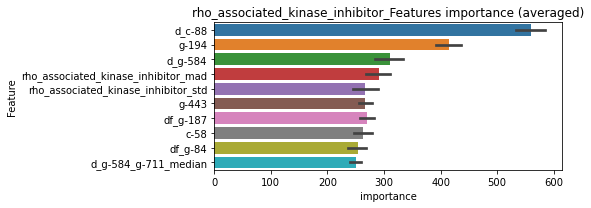

len(train_index) : 2834
len(valid_index) : 945
================================= fold 1/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0953912	valid_1's binary_logloss: 0.131276
[200]	training's binary_logloss: 0.0320747	valid_1's binary_logloss: 0.064273
[300]	training's binary_logloss: 0.0120655	valid_1's binary_logloss: 0.0384392
[400]	training's binary_logloss: 0.00510433	valid_1's binary_logloss: 0.0261737
[500]	training's binary_logloss: 0.00258621	valid_1's binary_logloss: 0.0197117
[600]	training's binary_logloss: 0.00158513	valid_1's binary_logloss: 0.0165079
[700]	training's binary_logloss: 0.00111995	valid_1's binary_logloss: 0.0148822
[800]	training's binary_logloss: 0.000860333	valid_1's binary_logloss: 0.0137331
[900]	training's binary_logloss: 0.000713049	valid_1's binary_logloss: 0.0130379
[1000]	training's binary_logloss: 0.000635095	valid_1's binary_logloss: 0.0127611
[1100]	training's binary_logloss: 0.00059956	valid_1's binary_logloss: 0.0126741
Early stopping, best iteration is:
[1086]	training's binary

len(train_index) : 2834
len(valid_index) : 945
================================= fold 2/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0972017	valid_1's binary_logloss: 0.13626
[200]	training's binary_logloss: 0.0321317	valid_1's binary_logloss: 0.0637385
[300]	training's binary_logloss: 0.0120236	valid_1's binary_logloss: 0.0354025
[400]	training's binary_logloss: 0.00508973	valid_1's binary_logloss: 0.0233805
[500]	training's binary_logloss: 0.00259631	valid_1's binary_logloss: 0.017239
[600]	training's binary_logloss: 0.00158364	valid_1's binary_logloss: 0.0143171
[700]	training's binary_logloss: 0.00110896	valid_1's binary_logloss: 0.0127401
[800]	training's binary_logloss: 0.000851734	valid_1's binary_logloss: 0.0118217
[900]	training's binary_logloss: 0.000711917	valid_1's binary_logloss: 0.0112318
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.000654579	valid_1's binary_logloss: 0.0110855


len(train_index) : 2834
len(valid_index) : 945
================================= fold 3/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0978791	valid_1's binary_logloss: 0.125296
[200]	training's binary_logloss: 0.0324025	valid_1's binary_logloss: 0.0532968
[300]	training's binary_logloss: 0.0119325	valid_1's binary_logloss: 0.0264053
[400]	training's binary_logloss: 0.00516097	valid_1's binary_logloss: 0.0156569
[500]	training's binary_logloss: 0.00262673	valid_1's binary_logloss: 0.0104745
[600]	training's binary_logloss: 0.00162552	valid_1's binary_logloss: 0.00812585
[700]	training's binary_logloss: 0.00114129	valid_1's binary_logloss: 0.00683569
[800]	training's binary_logloss: 0.000879719	valid_1's binary_logloss: 0.00595332
[900]	training's binary_logloss: 0.000728812	valid_1's binary_logloss: 0.00546883
[1000]	training's binary_logloss: 0.000646153	valid_1's binary_logloss: 0.00513212
[1100]	training's binary_logloss: 0.000605441	valid_1's binary_logloss: 0.0049804
Early stopping, best iteration is:
[1164]	training's

len(train_index) : 2835
len(valid_index) : 944
================================= fold 4/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0986486	valid_1's binary_logloss: 0.130202
[200]	training's binary_logloss: 0.0339192	valid_1's binary_logloss: 0.0622271
[300]	training's binary_logloss: 0.0127341	valid_1's binary_logloss: 0.036073
[400]	training's binary_logloss: 0.00536797	valid_1's binary_logloss: 0.0248158
[500]	training's binary_logloss: 0.00267829	valid_1's binary_logloss: 0.0197363
[600]	training's binary_logloss: 0.00163219	valid_1's binary_logloss: 0.017445
[700]	training's binary_logloss: 0.00113589	valid_1's binary_logloss: 0.0161924
[800]	training's binary_logloss: 0.000876753	valid_1's binary_logloss: 0.0156113
[900]	training's binary_logloss: 0.000727309	valid_1's binary_logloss: 0.0150365
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.000686627	valid_1's binary_logloss: 0.0149067


rho_associated_kinase_inhibitor logloss: 0.010899482602667708
ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3284, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100213	valid_1's binary_logloss: 0.145401
[200]	training's binary_logloss: 0.0356611	valid_1's binary_logloss: 0.0767409
[300]	training's binary_logloss: 0.0145277	valid_1's binary_logloss: 0.049843
[400]	training's binary_logloss: 0.00636414	valid_1's binary_logloss: 0.03775
[500]	training's binary_logloss: 0.00322682	valid_1's binary_logloss: 0.0328632
[600]	training's binary_logloss: 0.00194731	valid_1's binary_logloss: 0.0303042
[700]	training's binary_logloss: 0.00134042	valid_1's binary_logloss: 0.0291261
[800]	training's binary_logloss: 0.00101399	valid_1's binary_logloss: 0.0285232
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.00101856	valid_1's binary_logloss: 0.0284946
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102087	valid_1's binary_logloss: 0.134927
[200]	training's binary_logloss: 0.0361669	valid_1's b

1 / 3 AUC score:0.999
y_Threshold: 0.0149502, Threshold: 0.0497852, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.03485, conf_1:0.06472
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0497852
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_2: 0.0797852
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_3: 0.1097852
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_4: 0.1397852
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.1697852
threshold: 0.1697852, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957519	valid_1's binary_logloss: 0.136079
[200]	training's binary_logloss: 0.0313545	valid_1's binary_logloss: 0.0684014
[300]	training's binary_logloss: 0.0115846	valid_1's binary_logloss: 0.0402759
[400]	training's binary_logloss: 0.0049436	valid_1's binary_logloss: 0.0277561
[500]	training's binary_logloss: 0.0025896	valid_1's binary_logloss: 0.0213084
[600]	training's binary_logloss: 0.00161383	valid_1's binary_logloss: 0.0184443
[700]	training's binary_logloss: 0.00112944	valid_1's binary_logloss: 0.0170724
[800]	training's binary_logloss: 0.000869088	valid_1's binary_logloss: 0.0161718
[900]	training's binary_logloss: 0.0007239	valid_1's binary_logloss: 0.0156409
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000722556	valid_1's binary_logloss: 0.0156383
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955223	valid

2 / 3 AUC score:1.000
y_Threshold: 0.1255519, Threshold: 0.1697852, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0120542 Vs.target_rate: 0.00155, Num_p_label: 48.0, conf_0:0.13583, conf_1:0.20374
Num_p_label: 48.0, Expected: 6.2, Adj_threshold_1: 0.1697852
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_2: 0.1997852
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_3: 0.2297852
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_4: 0.2597852
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_5: 0.2897852
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_6: 0.3197852
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_7: 0.3497852
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_8: 0.3797852
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_9: 0.4097852
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_10: 0.4397852
threshold: 0.4697852, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 649.0/3794, y_label_rate: 0.1710596
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0930519	valid_1's binary_logloss: 0.122531
[200]	training's binary_logloss: 0.029627	valid_1's binary_logloss: 0.0548715
[300]	training's binary_logloss: 0.0109375	valid_1's binary_logloss: 0.0290941
[400]	training's binary_logloss: 0.0047615	valid_1's binary_logloss: 0.0184158
[500]	training's binary_logloss: 0.00246653	valid_1's binary_logloss: 0.0134961
[600]	training's binary_logloss: 0.0015456	valid_1's binary_logloss: 0.0114536
[700]	training's binary_logloss: 0.00108927	valid_1's binary_logloss: 0.00958558
[800]	training's binary_logloss: 0.000839048	valid_1's binary_logloss: 0.00860685
[900]	training's binary_logloss: 0.000701138	valid_1's binary_logloss: 0.00810624
[1000]	training's binary_logloss: 0.000639346	valid_1's binary_logloss: 0.00789414
Early stopping, best iteration is:
[1021]	training's binary_logloss: 0.000630172	valid_1's binary_logloss: 0.00782801
Training until valid

3 / 3 AUC score:1.000
y_Threshold: 0.1107436, Threshold: 0.4697852, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 645.0/3786
p_label_rate: 0.0055249 Vs.target_rate: 0.00155, Num_p_label: 22.0, conf_0:0.42281, conf_1:0.51676
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.4697852
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.4997852
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_3: 0.5297852
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.5597852
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_5: 0.5897852
threshold: 0.5897852, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 645.0/3786, y_label_rate: 0.1703645


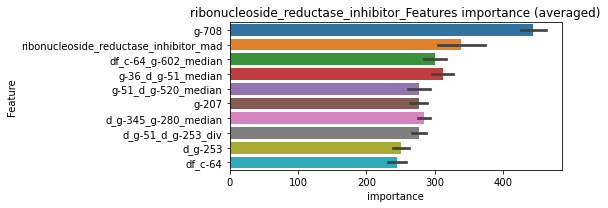

len(train_index) : 2839
len(valid_index) : 947
================================= fold 1/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0918377	valid_1's binary_logloss: 0.124376
[200]	training's binary_logloss: 0.0285666	valid_1's binary_logloss: 0.0576087
[300]	training's binary_logloss: 0.01047	valid_1's binary_logloss: 0.0333067
[400]	training's binary_logloss: 0.00447539	valid_1's binary_logloss: 0.0224144
[500]	training's binary_logloss: 0.00235288	valid_1's binary_logloss: 0.0169476
[600]	training's binary_logloss: 0.00146246	valid_1's binary_logloss: 0.0139596
[700]	training's binary_logloss: 0.0010513	valid_1's binary_logloss: 0.0122789
[800]	training's binary_logloss: 0.000820143	valid_1's binary_logloss: 0.011368
[900]	training's binary_logloss: 0.000679789	valid_1's binary_logloss: 0.0108729
[1000]	training's binary_logloss: 0.000615006	valid_1's binary_logloss: 0.0106941
Early stopping, best iteration is:
[1054]	training's binary_logloss: 0.00059695	valid_1's binary_logloss: 0.0106131


len(train_index) : 2839
len(valid_index) : 947
================================= fold 2/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0937534	valid_1's binary_logloss: 0.124405
[200]	training's binary_logloss: 0.0295682	valid_1's binary_logloss: 0.0552224
[300]	training's binary_logloss: 0.0108671	valid_1's binary_logloss: 0.0307125
[400]	training's binary_logloss: 0.00457376	valid_1's binary_logloss: 0.0193713
[500]	training's binary_logloss: 0.00237202	valid_1's binary_logloss: 0.0148051
[600]	training's binary_logloss: 0.00148129	valid_1's binary_logloss: 0.0130304
[700]	training's binary_logloss: 0.00105136	valid_1's binary_logloss: 0.0121636
[800]	training's binary_logloss: 0.000819292	valid_1's binary_logloss: 0.0117217
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.000780695	valid_1's binary_logloss: 0.0115977


len(train_index) : 2840
len(valid_index) : 946
================================= fold 3/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0930878	valid_1's binary_logloss: 0.138734
[200]	training's binary_logloss: 0.0294167	valid_1's binary_logloss: 0.0700393
[300]	training's binary_logloss: 0.0109621	valid_1's binary_logloss: 0.0448315
[400]	training's binary_logloss: 0.00465716	valid_1's binary_logloss: 0.0315538
[500]	training's binary_logloss: 0.00243151	valid_1's binary_logloss: 0.0248874
[600]	training's binary_logloss: 0.00150945	valid_1's binary_logloss: 0.0213767
[700]	training's binary_logloss: 0.00106863	valid_1's binary_logloss: 0.0193149
[800]	training's binary_logloss: 0.000833853	valid_1's binary_logloss: 0.0182917
[900]	training's binary_logloss: 0.000692167	valid_1's binary_logloss: 0.0171635
[1000]	training's binary_logloss: 0.000615846	valid_1's binary_logloss: 0.0167292
Early stopping, best iteration is:
[1020]	training's binary_logloss: 0.000605577	valid_1's binary_logloss: 0.0165664


len(train_index) : 2840
len(valid_index) : 946
================================= fold 4/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0943637	valid_1's binary_logloss: 0.118403
[200]	training's binary_logloss: 0.0298197	valid_1's binary_logloss: 0.0499196
[300]	training's binary_logloss: 0.0110743	valid_1's binary_logloss: 0.026834
[400]	training's binary_logloss: 0.00476718	valid_1's binary_logloss: 0.0168735
[500]	training's binary_logloss: 0.00242497	valid_1's binary_logloss: 0.0116415
[600]	training's binary_logloss: 0.00152058	valid_1's binary_logloss: 0.00948509
[700]	training's binary_logloss: 0.00107653	valid_1's binary_logloss: 0.00828933
[800]	training's binary_logloss: 0.000844838	valid_1's binary_logloss: 0.00765252
[900]	training's binary_logloss: 0.000702524	valid_1's binary_logloss: 0.00720127
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.000694561	valid_1's binary_logloss: 0.00717044


ribonucleoside_reductase_inhibitor logloss: 0.011489545089696119


neg labels: 3289 → selected neg labels: 3284


rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.087906	valid_1's binary_logloss: 0.109184
[200]	training's binary_logloss: 0.0264028	valid_1's binary_logloss: 0.0422595
[300]	training's binary_logloss: 0.00886508	valid_1's binary_logloss: 0.020295
[400]	training's binary_logloss: 0.00357341	valid_1's binary_logloss: 0.0129321
[500]	training's binary_logloss: 0.00184575	valid_1's binary_logloss: 0.00993058
[600]	training's binary_logloss: 0.00117153	valid_1's binary_logloss: 0.00874805
[700]	training's binary_logloss: 0.000841992	valid_1's binary_logloss: 0.00801694
[800]	training's binary_logloss: 0.000665201	valid_1's binary_logloss: 0.00771159
[900]	training's binary_logloss: 0.000574959	valid_1's binary_logloss: 0.00762487
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.000583918	valid_1's binary_logloss: 0.00761251
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085

1 / 3 AUC score:1.000
y_Threshold: 0.0062699, Threshold: 0.0355520, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.02489, conf_1:0.04622
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0355520
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_2: 0.0655520
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_3: 0.0955520
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_4: 0.1255520
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_5: 0.1555520
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.1855520
threshold: 0.1855520, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0853797	valid_1's binary_logloss: 0.106735
[200]	training's binary_logloss: 0.023522	valid_1's binary_logloss: 0.0385252
[300]	training's binary_logloss: 0.00759328	valid_1's binary_logloss: 0.018025
[400]	training's binary_logloss: 0.00304973	valid_1's binary_logloss: 0.0111211
[500]	training's binary_logloss: 0.00161086	valid_1's binary_logloss: 0.00870479
[600]	training's binary_logloss: 0.0010296	valid_1's binary_logloss: 0.00770795
[700]	training's binary_logloss: 0.000753506	valid_1's binary_logloss: 0.00714908
[800]	training's binary_logloss: 0.000606591	valid_1's binary_logloss: 0.00690208
Early stopping, best iteration is:
[788]	training's binary_logloss: 0.000618773	valid_1's binary_logloss: 0.0068772
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.082324	valid_1's binary_logloss: 0.108551
[200]	training's binary_logloss: 0.022839	val

2 / 3 AUC score:1.000
y_Threshold: 0.0839272, Threshold: 0.1855520, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0047715 Vs.target_rate: 0.00105, Num_p_label: 19.0, conf_0:0.14844, conf_1:0.22266
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_1: 0.1855520
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.2155520
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_3: 0.2455520
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_4: 0.2755520
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_5: 0.3055520
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_6: 0.3355520
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_7: 0.3655520
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_8: 0.3955520
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_9: 0.4255520
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_10: 0.4555520
threshold: 0.4855520, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0850553	valid_1's binary_logloss: 0.116948
[200]	training's binary_logloss: 0.0230083	valid_1's binary_logloss: 0.0471001
[300]	training's binary_logloss: 0.00751671	valid_1's binary_logloss: 0.0247668
[400]	training's binary_logloss: 0.00301271	valid_1's binary_logloss: 0.0171804
[500]	training's binary_logloss: 0.00158149	valid_1's binary_logloss: 0.0134606
[600]	training's binary_logloss: 0.00101341	valid_1's binary_logloss: 0.0118635
[700]	training's binary_logloss: 0.000743646	valid_1's binary_logloss: 0.0113259
[800]	training's binary_logloss: 0.00059474	valid_1's binary_logloss: 0.0108678
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000539489	valid_1's binary_logloss: 0.0106655
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0840609	valid_1's binary_logloss: 0.098497
[200]	training's binary_logloss: 0.0232802	val

3 / 3 AUC score:1.000
y_Threshold: 0.0690105, Threshold: 0.4855520, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0022602 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.43700, conf_1:0.53411
threshold: 0.4855520, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3806, y_label_rate: 0.1720967


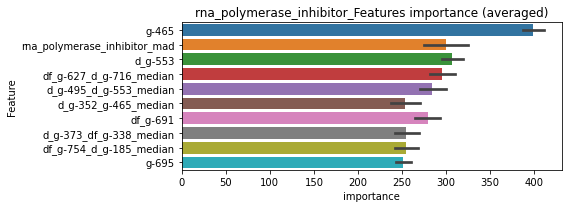

len(train_index) : 2854
len(valid_index) : 952
================================= fold 1/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0849053	valid_1's binary_logloss: 0.114443
[200]	training's binary_logloss: 0.0235049	valid_1's binary_logloss: 0.0455341
[300]	training's binary_logloss: 0.0075339	valid_1's binary_logloss: 0.0241052
[400]	training's binary_logloss: 0.00305385	valid_1's binary_logloss: 0.0163548
[500]	training's binary_logloss: 0.0016181	valid_1's binary_logloss: 0.0129027
[600]	training's binary_logloss: 0.00102753	valid_1's binary_logloss: 0.0111415
[700]	training's binary_logloss: 0.00074451	valid_1's binary_logloss: 0.0105081
[800]	training's binary_logloss: 0.000600039	valid_1's binary_logloss: 0.00997739
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000545992	valid_1's binary_logloss: 0.00969559


len(train_index) : 2854
len(valid_index) : 952
================================= fold 2/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0854969	valid_1's binary_logloss: 0.0982011
[200]	training's binary_logloss: 0.0240945	valid_1's binary_logloss: 0.0328016
[300]	training's binary_logloss: 0.00783252	valid_1's binary_logloss: 0.0130752
[400]	training's binary_logloss: 0.00315004	valid_1's binary_logloss: 0.00648363
[500]	training's binary_logloss: 0.00164107	valid_1's binary_logloss: 0.0039391
[600]	training's binary_logloss: 0.00104254	valid_1's binary_logloss: 0.00280646
[700]	training's binary_logloss: 0.000757087	valid_1's binary_logloss: 0.00220361
[800]	training's binary_logloss: 0.000609323	valid_1's binary_logloss: 0.00187453
[900]	training's binary_logloss: 0.000532388	valid_1's binary_logloss: 0.00170688
[1000]	training's binary_logloss: 0.000511138	valid_1's binary_logloss: 0.00165623
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000511138	valid_1's binary_logloss: 0.00165623


len(train_index) : 2855
len(valid_index) : 951
================================= fold 3/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085386	valid_1's binary_logloss: 0.108286
[200]	training's binary_logloss: 0.023449	valid_1's binary_logloss: 0.0377685
[300]	training's binary_logloss: 0.00747788	valid_1's binary_logloss: 0.0159692
[400]	training's binary_logloss: 0.00303626	valid_1's binary_logloss: 0.00867462
[500]	training's binary_logloss: 0.00158731	valid_1's binary_logloss: 0.00566521
[600]	training's binary_logloss: 0.00102119	valid_1's binary_logloss: 0.00443295
[700]	training's binary_logloss: 0.000745826	valid_1's binary_logloss: 0.00364081
[800]	training's binary_logloss: 0.000597867	valid_1's binary_logloss: 0.00321888
[900]	training's binary_logloss: 0.000524508	valid_1's binary_logloss: 0.00303121
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.000520882	valid_1's binary_logloss: 0.00302275


len(train_index) : 2855
len(valid_index) : 951
================================= fold 4/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.086701	valid_1's binary_logloss: 0.111412
[200]	training's binary_logloss: 0.0237883	valid_1's binary_logloss: 0.0403677
[300]	training's binary_logloss: 0.00760258	valid_1's binary_logloss: 0.0182353
[400]	training's binary_logloss: 0.00307244	valid_1's binary_logloss: 0.0104051
[500]	training's binary_logloss: 0.00159857	valid_1's binary_logloss: 0.00710665
[600]	training's binary_logloss: 0.00102612	valid_1's binary_logloss: 0.0057565
[700]	training's binary_logloss: 0.000745385	valid_1's binary_logloss: 0.00482225
[800]	training's binary_logloss: 0.000596526	valid_1's binary_logloss: 0.00440581
[900]	training's binary_logloss: 0.000525759	valid_1's binary_logloss: 0.00422813
Early stopping, best iteration is:
[947]	training's binary_logloss: 0.000506704	valid_1's binary_logloss: 0.00418592


rna_polymerase_inhibitor logloss: 0.004643320739254419
serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.199869	valid_1's binary_logloss: 0.30984
[200]	training's binary_logloss: 0.115025	valid_1's binary_logloss: 0.27276
[300]	training's binary_logloss: 0.0750661	valid_1's binary_logloss: 0.256636
[400]	training's binary_logloss: 0.047884	valid_1's binary_logloss: 0.24871
[500]	training's binary_logloss: 0.0315367	valid_1's binary_logloss: 0.246829
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.030289	valid_1's binary_logloss: 0.246214
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.199904	valid_1's binary_logloss: 0.310012
[200]	training's binary_logloss: 0.11712	valid_1's binary_logloss: 0.272056
[300]	training's binary_logloss: 0.0727505	valid_1's binary_logloss: 0.252247
[400]	training's binary_logloss: 0.0466715	valid_1's binary_logloss: 0.242743
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.035

1 / 3 AUC score:0.898
y_Threshold: 0.0989039, Threshold: 0.4742644, pos_neg_ratio: 0.8000000
Remove_noisy_data: 433 → Positive_corect_labels: 498/3465
p_label_rate: 0.0100452 Vs.target_rate: 0.00991, Num_p_label: 40.0, conf_0:0.33199, conf_1:0.61654
threshold: 0.4742644, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 498.0/3465, y_label_rate: 0.1437229
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132236	valid_1's binary_logloss: 0.213941
[200]	training's binary_logloss: 0.0590752	valid_1's binary_logloss: 0.157495
[300]	training's binary_logloss: 0.0303296	valid_1's binary_logloss: 0.130277
[400]	training's binary_logloss: 0.016215	valid_1's binary_logloss: 0.115275
[500]	training's binary_logloss: 0.00905239	valid_1's binary_logloss: 0.106715
[600]	training's binary_logloss: 0.00538714	valid_1's binary_logloss: 0.102915
[700]	training's binary_logloss: 0.00355205	valid_1's binary_logloss: 0.10034
Early stopping, best iteration is:
[712]	training's binary_logloss: 0.00339605	valid_1's binary_logloss: 0.100002
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132302	valid_1's binary_logloss: 0.214288
[200]	training's binary_logloss: 0.0592754	valid_1's binary_logloss: 0.1674
[300]	training's binary_logloss: 0.0295534	valid_1's binary_loglo

2 / 3 AUC score:0.983
y_Threshold: 0.0917673, Threshold: 0.4742644, pos_neg_ratio: 0.8000000
Remove_noisy_data: 110 → Positive_corect_labels: 443.0/3355
p_label_rate: 0.0306379 Vs.target_rate: 0.00991, Num_p_label: 122.0, conf_0:0.37941, conf_1:0.56912
Num_p_label: 122.0, Expected: 39.5, Adj_threshold_1: 0.4742644
Num_p_label: 114.0, Expected: 39.5, Adj_threshold_2: 0.5042644
Num_p_label: 106.0, Expected: 39.5, Adj_threshold_3: 0.5342644
Num_p_label: 100.0, Expected: 39.5, Adj_threshold_4: 0.5642644
Num_p_label: 88.0, Expected: 39.5, Adj_threshold_5: 0.5942644
Num_p_label: 84.0, Expected: 39.5, Adj_threshold_6: 0.6242644
Num_p_label: 77.0, Expected: 39.5, Adj_threshold_7: 0.6542644
Num_p_label: 72.0, Expected: 39.5, Adj_threshold_8: 0.6842644
threshold: 0.6842644, positive_p_label: 72.0/3982, p_label_rate: 0.0180814
positive_y_label: 443.0/3355, y_label_rate: 0.1320417
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105937	valid_1's binary_logloss: 0.162483
[200]	training's binary_logloss: 0.0416653	valid_1's binary_logloss: 0.110236
[300]	training's binary_logloss: 0.0189464	valid_1's binary_logloss: 0.0870473
[400]	training's binary_logloss: 0.00937776	valid_1's binary_logloss: 0.0755393
[500]	training's binary_logloss: 0.0051821	valid_1's binary_logloss: 0.0695262
[600]	training's binary_logloss: 0.00317229	valid_1's binary_logloss: 0.0663176
[700]	training's binary_logloss: 0.00216438	valid_1's binary_logloss: 0.0637588
[800]	training's binary_logloss: 0.00162863	valid_1's binary_logloss: 0.0629151
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00142278	valid_1's binary_logloss: 0.061958
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102092	valid_1's binary_logloss: 0.162876
[200]	training's binary_logloss: 0.0393626	valid_1's b

3 / 3 AUC score:0.988
y_Threshold: 0.0925694, Threshold: 0.6842644, pos_neg_ratio: 0.8000000
Remove_noisy_data: 76 → Positive_corect_labels: 405.0/3279
p_label_rate: 0.0246107 Vs.target_rate: 0.00991, Num_p_label: 98.0, conf_0:0.50000, conf_1:0.75269
threshold: 0.6842644, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 405.0/3279, y_label_rate: 0.1235133


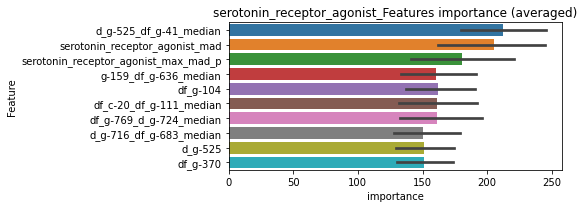

len(train_index) : 2459
len(valid_index) : 820
================================= fold 1/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828562	valid_1's binary_logloss: 0.138786
[200]	training's binary_logloss: 0.0297252	valid_1's binary_logloss: 0.0989649
[300]	training's binary_logloss: 0.0121278	valid_1's binary_logloss: 0.084952
[400]	training's binary_logloss: 0.00572507	valid_1's binary_logloss: 0.0810918
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00561406	valid_1's binary_logloss: 0.0808554


len(train_index) : 2459
len(valid_index) : 820
================================= fold 2/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0848053	valid_1's binary_logloss: 0.130823
[200]	training's binary_logloss: 0.0312104	valid_1's binary_logloss: 0.0922353
[300]	training's binary_logloss: 0.0129998	valid_1's binary_logloss: 0.0766938
[400]	training's binary_logloss: 0.00632665	valid_1's binary_logloss: 0.0697459
[500]	training's binary_logloss: 0.00346083	valid_1's binary_logloss: 0.0671097
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00272974	valid_1's binary_logloss: 0.066485


len(train_index) : 2459
len(valid_index) : 820
================================= fold 3/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0870318	valid_1's binary_logloss: 0.152437
[200]	training's binary_logloss: 0.0323867	valid_1's binary_logloss: 0.112585
[300]	training's binary_logloss: 0.0138102	valid_1's binary_logloss: 0.0983757
[400]	training's binary_logloss: 0.00705298	valid_1's binary_logloss: 0.0953804
[500]	training's binary_logloss: 0.00364832	valid_1's binary_logloss: 0.0946967
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00426417	valid_1's binary_logloss: 0.0942764


len(train_index) : 2460
len(valid_index) : 819
================================= fold 4/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.086629	valid_1's binary_logloss: 0.12826
[200]	training's binary_logloss: 0.0313662	valid_1's binary_logloss: 0.0787403
[300]	training's binary_logloss: 0.0131872	valid_1's binary_logloss: 0.0598817
[400]	training's binary_logloss: 0.00627167	valid_1's binary_logloss: 0.0496974
[500]	training's binary_logloss: 0.00348637	valid_1's binary_logloss: 0.0450655
[600]	training's binary_logloss: 0.0022004	valid_1's binary_logloss: 0.0425835
[700]	training's binary_logloss: 0.00155576	valid_1's binary_logloss: 0.0406208
[800]	training's binary_logloss: 0.00120821	valid_1's binary_logloss: 0.0396527
[900]	training's binary_logloss: 0.00100166	valid_1's binary_logloss: 0.038667
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.000996338	valid_1's binary_logloss: 0.0386556


serotonin_receptor_agonist logloss: 0.07007767327759443
serotonin_receptor_antagonist, len(trt): 404, len(othr): 3239, target_rate: 0.0169648 → Adj_target_rate: 0.0137918


neg labels: 3289 → selected neg labels: 3239


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.273785	valid_1's binary_logloss: 0.406371
[200]	training's binary_logloss: 0.179194	valid_1's binary_logloss: 0.388848
[300]	training's binary_logloss: 0.125247	valid_1's binary_logloss: 0.383418
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.106359	valid_1's binary_logloss: 0.382379
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.278066	valid_1's binary_logloss: 0.407519
[200]	training's binary_logloss: 0.185969	valid_1's binary_logloss: 0.387435
[300]	training's binary_logloss: 0.131927	valid_1's binary_logloss: 0.379671
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.112751	valid_1's binary_logloss: 0.377962
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.279619	valid_1's binary_logloss: 0.402217
[200]	training's binary_logloss: 0.189348	valid_1's bi

1 / 3 AUC score:0.758
y_Threshold: 0.1618635, Threshold: 0.5487266, pos_neg_ratio: 0.8000000
Remove_noisy_data: 725 → Positive_corect_labels: 350/3161
p_label_rate: 0.0100452 Vs.target_rate: 0.01696, Num_p_label: 40.0, conf_0:0.38411, conf_1:0.71334
threshold: 0.5487266, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 350.0/3161, y_label_rate: 0.1107245
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130578	valid_1's binary_logloss: 0.217455
[200]	training's binary_logloss: 0.0619718	valid_1's binary_logloss: 0.17873
[300]	training's binary_logloss: 0.032891	valid_1's binary_logloss: 0.165321
[400]	training's binary_logloss: 0.0176025	valid_1's binary_logloss: 0.159976
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.0117522	valid_1's binary_logloss: 0.156677
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134749	valid_1's binary_logloss: 0.234469
[200]	training's binary_logloss: 0.0629361	valid_1's binary_logloss: 0.205756
[300]	training's binary_logloss: 0.0327079	valid_1's binary_logloss: 0.19548
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0312899	valid_1's binary_logloss: 0.194402
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129537	valid_1'

2 / 3 AUC score:0.932
y_Threshold: 0.1055909, Threshold: 0.5487266, pos_neg_ratio: 0.8000000
Remove_noisy_data: 194 → Positive_corect_labels: 253.0/2967
p_label_rate: 0.0328980 Vs.target_rate: 0.01696, Num_p_label: 131.0, conf_0:0.43898, conf_1:0.65847
threshold: 0.5487266, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 253.0/2967, y_label_rate: 0.0852713
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0817185	valid_1's binary_logloss: 0.150314
[200]	training's binary_logloss: 0.0318274	valid_1's binary_logloss: 0.114053
[300]	training's binary_logloss: 0.0141279	valid_1's binary_logloss: 0.100471
[400]	training's binary_logloss: 0.00695156	valid_1's binary_logloss: 0.0963735
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00667791	valid_1's binary_logloss: 0.0959607
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0825563	valid_1's binary_logloss: 0.152235
[200]	training's binary_logloss: 0.0312128	valid_1's binary_logloss: 0.127017
[300]	training's binary_logloss: 0.0141058	valid_1's binary_logloss: 0.121561
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0133727	valid_1's binary_logloss: 0.1209
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0831069	

3 / 3 AUC score:0.975
y_Threshold: 0.0828362, Threshold: 0.5487266, pos_neg_ratio: 0.8000000
Remove_noisy_data: 76 → Positive_corect_labels: 215.0/2891
p_label_rate: 0.0459568 Vs.target_rate: 0.01696, Num_p_label: 183.0, conf_0:0.49385, conf_1:0.60360
threshold: 0.5487266, positive_p_label: 183.0/3982, p_label_rate: 0.0459568
positive_y_label: 215.0/2891, y_label_rate: 0.0743687


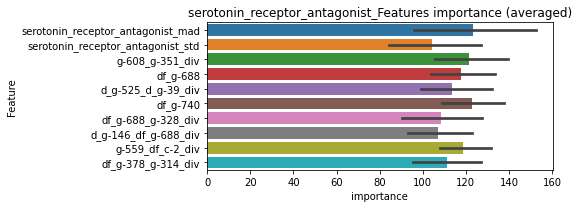

len(train_index) : 2168
len(valid_index) : 723
================================= fold 1/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0605956	valid_1's binary_logloss: 0.115128
[200]	training's binary_logloss: 0.0212282	valid_1's binary_logloss: 0.079333
[300]	training's binary_logloss: 0.00900291	valid_1's binary_logloss: 0.0620217
[400]	training's binary_logloss: 0.00438803	valid_1's binary_logloss: 0.054195
[500]	training's binary_logloss: 0.00253119	valid_1's binary_logloss: 0.0495784
[600]	training's binary_logloss: 0.00168084	valid_1's binary_logloss: 0.048139
[700]	training's binary_logloss: 0.00122248	valid_1's binary_logloss: 0.0462106
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.00119517	valid_1's binary_logloss: 0.0461733


len(train_index) : 2168
len(valid_index) : 723
================================= fold 2/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0603959	valid_1's binary_logloss: 0.153455
[200]	training's binary_logloss: 0.0200339	valid_1's binary_logloss: 0.132284


len(train_index) : 2168
len(valid_index) : 723
================================= fold 3/4 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0133703	valid_1's binary_logloss: 0.128154
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0625175	valid_1's binary_logloss: 0.128059
[200]	training's binary_logloss: 0.02199	valid_1's binary_logloss: 0.0997239
[300]	training's binary_logloss: 0.00910554	valid_1's binary_logloss: 0.0896147


len(train_index) : 2169
len(valid_index) : 722


[400]	training's binary_logloss: 0.00428915	valid_1's binary_logloss: 0.0865435
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00524554	valid_1's binary_logloss: 0.0859177


================================= fold 4/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0634544	valid_1's binary_logloss: 0.0956132
[200]	training's binary_logloss: 0.0225856	valid_1's binary_logloss: 0.0646369
[300]	training's binary_logloss: 0.00955089	valid_1's binary_logloss: 0.0510709
[400]	training's binary_logloss: 0.00462781	valid_1's binary_logloss: 0.0445199
[500]	training's binary_logloss: 0.00264474	valid_1's binary_logloss: 0.0402046
[600]	training's binary_logloss: 0.00171216	valid_1's binary_logloss: 0.0377969
[700]	training's binary_logloss: 0.00125003	valid_1's binary_logloss: 0.0366812
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00135917	valid_1's binary_logloss: 0.0365181


serotonin_receptor_antagonist logloss: 0.07420387762337391
serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3285, target_rate: 0.0018477 → Adj_target_rate: 0.0020948


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109854	valid_1's binary_logloss: 0.156455
[200]	training's binary_logloss: 0.0423721	valid_1's binary_logloss: 0.0858556
[300]	training's binary_logloss: 0.0172829	valid_1's binary_logloss: 0.0546984
[400]	training's binary_logloss: 0.00770729	valid_1's binary_logloss: 0.0398443
[500]	training's binary_logloss: 0.003907	valid_1's binary_logloss: 0.033348
[600]	training's binary_logloss: 0.0023367	valid_1's binary_logloss: 0.029789
[700]	training's binary_logloss: 0.00159311	valid_1's binary_logloss: 0.0280995
[800]	training's binary_logloss: 0.00119634	valid_1's binary_logloss: 0.0271889
Early stopping, best iteration is:
[843]	training's binary_logloss: 0.00108549	valid_1's binary_logloss: 0.0267259
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110466	valid_1's binary_logloss: 0.149483
[200]	training's binary_logloss: 0.0422388	valid_1's bin

1 / 3 AUC score:0.999
y_Threshold: 0.0181477, Threshold: 0.1765332, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00185, Num_p_label: 40.0, conf_0:0.12357, conf_1:0.22949
Num_p_label: 40.0, Expected: 7.4, Adj_threshold_1: 0.1765332
Num_p_label: 34.0, Expected: 7.4, Adj_threshold_2: 0.2065332
Num_p_label: 30.0, Expected: 7.4, Adj_threshold_3: 0.2365332
Num_p_label: 24.0, Expected: 7.4, Adj_threshold_4: 0.2665332
Num_p_label: 20.0, Expected: 7.4, Adj_threshold_5: 0.2965332
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_6: 0.3265332
Num_p_label: 16.0, Expected: 7.4, Adj_threshold_7: 0.3565332
threshold: 0.3565332, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105368	valid_1's binary_logloss: 0.154632
[200]	training's binary_logloss: 0.0367355	valid_1's binary_logloss: 0.0817138
[300]	training's binary_logloss: 0.014567	valid_1's binary_logloss: 0.05312
[400]	training's binary_logloss: 0.00628612	valid_1's binary_logloss: 0.0410402
[500]	training's binary_logloss: 0.0032146	valid_1's binary_logloss: 0.03493
[600]	training's binary_logloss: 0.00194441	valid_1's binary_logloss: 0.0317717
[700]	training's binary_logloss: 0.00134172	valid_1's binary_logloss: 0.0303198
[800]	training's binary_logloss: 0.0010325	valid_1's binary_logloss: 0.0295557
Early stopping, best iteration is:
[842]	training's binary_logloss: 0.00093939	valid_1's binary_logloss: 0.029324
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108567	valid_1's binary_logloss: 0.142995
[200]	training's binary_logloss: 0.0382497	valid_1's binary

2 / 3 AUC score:1.000
y_Threshold: 0.0883278, Threshold: 0.3565332, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 639.0/3774
p_label_rate: 0.0241085 Vs.target_rate: 0.00185, Num_p_label: 96.0, conf_0:0.28523, conf_1:0.42784
Num_p_label: 96.0, Expected: 7.4, Adj_threshold_1: 0.3565332
Num_p_label: 93.0, Expected: 7.4, Adj_threshold_2: 0.3865332
Num_p_label: 88.0, Expected: 7.4, Adj_threshold_3: 0.4165332
Num_p_label: 81.0, Expected: 7.4, Adj_threshold_4: 0.4465332
Num_p_label: 77.0, Expected: 7.4, Adj_threshold_5: 0.4765332
Num_p_label: 71.0, Expected: 7.4, Adj_threshold_6: 0.5065332
Num_p_label: 64.0, Expected: 7.4, Adj_threshold_7: 0.5365332
Num_p_label: 58.0, Expected: 7.4, Adj_threshold_8: 0.5665332
Num_p_label: 52.0, Expected: 7.4, Adj_threshold_9: 0.5965332
Num_p_label: 45.0, Expected: 7.4, Adj_threshold_10: 0.6265332
threshold: 0.6565332, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 639.0/3774, y_label_rate: 0.1693164
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0986387	valid_1's binary_logloss: 0.152998
[200]	training's binary_logloss: 0.0341542	valid_1's binary_logloss: 0.0801122
[300]	training's binary_logloss: 0.0129426	valid_1's binary_logloss: 0.0509363
[400]	training's binary_logloss: 0.00560646	valid_1's binary_logloss: 0.0366261
[500]	training's binary_logloss: 0.00288505	valid_1's binary_logloss: 0.0293328
[600]	training's binary_logloss: 0.00175588	valid_1's binary_logloss: 0.0264369
[700]	training's binary_logloss: 0.00122909	valid_1's binary_logloss: 0.0243334
[800]	training's binary_logloss: 0.000949049	valid_1's binary_logloss: 0.0230775
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.0009002	valid_1's binary_logloss: 0.022705
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102962	valid_1's binary_logloss: 0.141873
[200]	training's binary_logloss: 0.0353433	valid_1'

3 / 3 AUC score:1.000
y_Threshold: 0.1371495, Threshold: 0.6565332, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 632.0/3760
p_label_rate: 0.0150678 Vs.target_rate: 0.00185, Num_p_label: 60.0, conf_0:0.50000, conf_1:0.72219
Num_p_label: 60.0, Expected: 7.4, Adj_threshold_1: 0.6565332
Num_p_label: 59.0, Expected: 7.4, Adj_threshold_2: 0.6865332
threshold: 0.6865332, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 632.0/3760, y_label_rate: 0.1680851


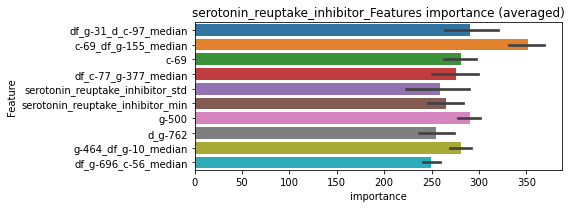

len(train_index) : 2820
len(valid_index) : 940
================================= fold 1/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0980315	valid_1's binary_logloss: 0.14679
[200]	training's binary_logloss: 0.0336838	valid_1's binary_logloss: 0.0785585
[300]	training's binary_logloss: 0.0130613	valid_1's binary_logloss: 0.0517669
[400]	training's binary_logloss: 0.00570828	valid_1's binary_logloss: 0.0392039
[500]	training's binary_logloss: 0.00286581	valid_1's binary_logloss: 0.0324294
[600]	training's binary_logloss: 0.00174243	valid_1's binary_logloss: 0.0293121
[700]	training's binary_logloss: 0.0012093	valid_1's binary_logloss: 0.0283092
[800]	training's binary_logloss: 0.000934462	valid_1's binary_logloss: 0.0277703
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.000832615	valid_1's binary_logloss: 0.0271812


len(train_index) : 2820
len(valid_index) : 940
================================= fold 2/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0993199	valid_1's binary_logloss: 0.133379
[200]	training's binary_logloss: 0.0342887	valid_1's binary_logloss: 0.062305
[300]	training's binary_logloss: 0.0136675	valid_1's binary_logloss: 0.0340437
[400]	training's binary_logloss: 0.00592653	valid_1's binary_logloss: 0.0206956
[500]	training's binary_logloss: 0.00295687	valid_1's binary_logloss: 0.0146595
[600]	training's binary_logloss: 0.00179434	valid_1's binary_logloss: 0.0114213
[700]	training's binary_logloss: 0.00125481	valid_1's binary_logloss: 0.00972205
[800]	training's binary_logloss: 0.000964324	valid_1's binary_logloss: 0.00875204
[900]	training's binary_logloss: 0.000791186	valid_1's binary_logloss: 0.00813596
[1000]	training's binary_logloss: 0.000699783	valid_1's binary_logloss: 0.00773918
[1100]	training's binary_logloss: 0.000653559	valid_1's binary_logloss: 0.00760652
Early stopping, best iteration is:
[1125]	training's 

len(train_index) : 2820
len(valid_index) : 940
================================= fold 3/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0988229	valid_1's binary_logloss: 0.137794
[200]	training's binary_logloss: 0.0340975	valid_1's binary_logloss: 0.067513
[300]	training's binary_logloss: 0.0131758	valid_1's binary_logloss: 0.0384707
[400]	training's binary_logloss: 0.00566616	valid_1's binary_logloss: 0.0256071
[500]	training's binary_logloss: 0.00288694	valid_1's binary_logloss: 0.0193188
[600]	training's binary_logloss: 0.00175632	valid_1's binary_logloss: 0.0160058
[700]	training's binary_logloss: 0.00121767	valid_1's binary_logloss: 0.014044
[800]	training's binary_logloss: 0.000934535	valid_1's binary_logloss: 0.0132032
[900]	training's binary_logloss: 0.000775254	valid_1's binary_logloss: 0.0125661
[1000]	training's binary_logloss: 0.000684014	valid_1's binary_logloss: 0.0122689
Early stopping, best iteration is:
[997]	training's binary_logloss: 0.000685896	valid_1's binary_logloss: 0.0122467


len(train_index) : 2820
len(valid_index) : 940
================================= fold 4/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0997954	valid_1's binary_logloss: 0.142239
[200]	training's binary_logloss: 0.0342486	valid_1's binary_logloss: 0.0744168
[300]	training's binary_logloss: 0.013361	valid_1's binary_logloss: 0.0482724
[400]	training's binary_logloss: 0.00584094	valid_1's binary_logloss: 0.0380125
[500]	training's binary_logloss: 0.00289877	valid_1's binary_logloss: 0.0328457
[600]	training's binary_logloss: 0.00176718	valid_1's binary_logloss: 0.0309648
[700]	training's binary_logloss: 0.00122835	valid_1's binary_logloss: 0.0293981
Early stopping, best iteration is:
[706]	training's binary_logloss: 0.0012069	valid_1's binary_logloss: 0.0293026


serotonin_reuptake_inhibitor logloss: 0.019082366724957913
sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101871	valid_1's binary_logloss: 0.13336
[200]	training's binary_logloss: 0.0351654	valid_1's binary_logloss: 0.0603806
[300]	training's binary_logloss: 0.013219	valid_1's binary_logloss: 0.0315581
[400]	training's binary_logloss: 0.00568847	valid_1's binary_logloss: 0.0194815
[500]	training's binary_logloss: 0.00280694	valid_1's binary_logloss: 0.0140553
[600]	training's binary_logloss: 0.00170411	valid_1's binary_logloss: 0.0116804
[700]	training's binary_logloss: 0.00116923	valid_1's binary_logloss: 0.0103249
[800]	training's binary_logloss: 0.000896909	valid_1's binary_logloss: 0.00961469
[900]	training's binary_logloss: 0.000739457	valid_1's binary_logloss: 0.00931022
Early stopping, best iteration is:
[877]	training's binary_logloss: 0.000764834	valid_1's binary_logloss: 0.00930111
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101199	va

1 / 3 AUC score:1.000
y_Threshold: 0.0125867, Threshold: 0.1088869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.07622, conf_1:0.14155
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1088869
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_2: 0.1388869
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.1688869
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_4: 0.1988869
threshold: 0.1988869, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096011	valid_1's binary_logloss: 0.126897
[200]	training's binary_logloss: 0.0306595	valid_1's binary_logloss: 0.0525472
[300]	training's binary_logloss: 0.0114352	valid_1's binary_logloss: 0.0259672
[400]	training's binary_logloss: 0.0048263	valid_1's binary_logloss: 0.0146567
[500]	training's binary_logloss: 0.00244117	valid_1's binary_logloss: 0.0100001
[600]	training's binary_logloss: 0.00148237	valid_1's binary_logloss: 0.00772676
[700]	training's binary_logloss: 0.00103924	valid_1's binary_logloss: 0.00672228
[800]	training's binary_logloss: 0.000803632	valid_1's binary_logloss: 0.00608179
[900]	training's binary_logloss: 0.0006733	valid_1's binary_logloss: 0.00580666
[1000]	training's binary_logloss: 0.000615811	valid_1's binary_logloss: 0.00571243
Early stopping, best iteration is:
[993]	training's binary_logloss: 0.000619303	valid_1's binary_logloss: 0.00571028
Training until valida

2 / 3 AUC score:1.000
y_Threshold: 0.0616727, Threshold: 0.1988869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0120542 Vs.target_rate: 0.00151, Num_p_label: 48.0, conf_0:0.15911, conf_1:0.23866
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_1: 0.1988869
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_2: 0.2288869
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_3: 0.2588869
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_4: 0.2888869
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_5: 0.3188869
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_6: 0.3488869
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_7: 0.3788869
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.4088869
threshold: 0.4088869, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959149	valid_1's binary_logloss: 0.124849
[200]	training's binary_logloss: 0.0308772	valid_1's binary_logloss: 0.0528851
[300]	training's binary_logloss: 0.0112092	valid_1's binary_logloss: 0.0272508
[400]	training's binary_logloss: 0.0046081	valid_1's binary_logloss: 0.0166243
[500]	training's binary_logloss: 0.00232808	valid_1's binary_logloss: 0.0119126
[600]	training's binary_logloss: 0.00142603	valid_1's binary_logloss: 0.00992307
[700]	training's binary_logloss: 0.000998883	valid_1's binary_logloss: 0.00878824
[800]	training's binary_logloss: 0.000770378	valid_1's binary_logloss: 0.00820575
[900]	training's binary_logloss: 0.000645485	valid_1's binary_logloss: 0.00789968
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.000658164	valid_1's binary_logloss: 0.00785789
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970

3 / 3 AUC score:1.000
y_Threshold: 0.0837913, Threshold: 0.4088869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 651.0/3797
p_label_rate: 0.0030136 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.36800, conf_1:0.44978
threshold: 0.4088869, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 651.0/3797, y_label_rate: 0.1714511


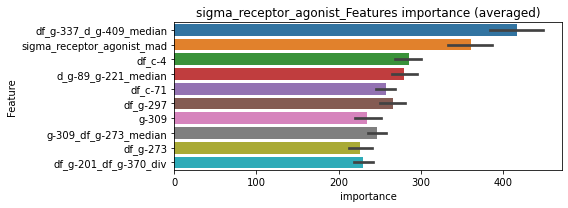

len(train_index) : 2847
len(valid_index) : 950
================================= fold 1/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0940026	valid_1's binary_logloss: 0.136653
[200]	training's binary_logloss: 0.029047	valid_1's binary_logloss: 0.0622032
[300]	training's binary_logloss: 0.0103035	valid_1's binary_logloss: 0.0342279
[400]	training's binary_logloss: 0.00426325	valid_1's binary_logloss: 0.0235597
[500]	training's binary_logloss: 0.00217246	valid_1's binary_logloss: 0.0181604
[600]	training's binary_logloss: 0.00134398	valid_1's binary_logloss: 0.0159871
[700]	training's binary_logloss: 0.000956685	valid_1's binary_logloss: 0.0154268
[800]	training's binary_logloss: 0.000749992	valid_1's binary_logloss: 0.0148146
[900]	training's binary_logloss: 0.000635774	valid_1's binary_logloss: 0.0144649
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.000655541	valid_1's binary_logloss: 0.0143791


len(train_index) : 2848
len(valid_index) : 949
================================= fold 2/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970462	valid_1's binary_logloss: 0.12243
[200]	training's binary_logloss: 0.0298543	valid_1's binary_logloss: 0.0509869
[300]	training's binary_logloss: 0.0106506	valid_1's binary_logloss: 0.0255991
[400]	training's binary_logloss: 0.00445281	valid_1's binary_logloss: 0.0153661
[500]	training's binary_logloss: 0.00229542	valid_1's binary_logloss: 0.0106538
[600]	training's binary_logloss: 0.00141347	valid_1's binary_logloss: 0.00866693
[700]	training's binary_logloss: 0.00098968	valid_1's binary_logloss: 0.00742907
[800]	training's binary_logloss: 0.000767707	valid_1's binary_logloss: 0.00664463
[900]	training's binary_logloss: 0.000642766	valid_1's binary_logloss: 0.00625505
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.000611379	valid_1's binary_logloss: 0.00613785


len(train_index) : 2848
len(valid_index) : 949
================================= fold 3/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0978106	valid_1's binary_logloss: 0.120347
[200]	training's binary_logloss: 0.0311779	valid_1's binary_logloss: 0.04809
[300]	training's binary_logloss: 0.0114078	valid_1's binary_logloss: 0.0236866
[400]	training's binary_logloss: 0.00469742	valid_1's binary_logloss: 0.0133062
[500]	training's binary_logloss: 0.00236938	valid_1's binary_logloss: 0.00885549
[600]	training's binary_logloss: 0.00143141	valid_1's binary_logloss: 0.00700914
[700]	training's binary_logloss: 0.00100468	valid_1's binary_logloss: 0.00604051
[800]	training's binary_logloss: 0.000784743	valid_1's binary_logloss: 0.00546395
[900]	training's binary_logloss: 0.000659935	valid_1's binary_logloss: 0.0051774
[1000]	training's binary_logloss: 0.000608864	valid_1's binary_logloss: 0.00512928
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.0006194	valid_1's binary_logloss: 0.00509418


len(train_index) : 2848
len(valid_index) : 949
================================= fold 4/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970991	valid_1's binary_logloss: 0.128059
[200]	training's binary_logloss: 0.0307191	valid_1's binary_logloss: 0.0556873
[300]	training's binary_logloss: 0.0109639	valid_1's binary_logloss: 0.0291092
[400]	training's binary_logloss: 0.00449116	valid_1's binary_logloss: 0.0180825
[500]	training's binary_logloss: 0.00226282	valid_1's binary_logloss: 0.0128603
[600]	training's binary_logloss: 0.00138554	valid_1's binary_logloss: 0.0102572
[700]	training's binary_logloss: 0.00098008	valid_1's binary_logloss: 0.00866895
[800]	training's binary_logloss: 0.000762124	valid_1's binary_logloss: 0.00797059
[900]	training's binary_logloss: 0.00064289	valid_1's binary_logloss: 0.00739752
[1000]	training's binary_logloss: 0.000592082	valid_1's binary_logloss: 0.00719952
Early stopping, best iteration is:
[992]	training's binary_logloss: 0.000592082	valid_1's binary_logloss: 0.00719952


sigma_receptor_agonist logloss: 0.008205063652851426
sigma_receptor_antagonist, len(trt): 36, len(othr): 3285, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10176	valid_1's binary_logloss: 0.15356
[200]	training's binary_logloss: 0.0368636	valid_1's binary_logloss: 0.0832219
[300]	training's binary_logloss: 0.0151899	valid_1's binary_logloss: 0.0512959
[400]	training's binary_logloss: 0.00652769	valid_1's binary_logloss: 0.034755
[500]	training's binary_logloss: 0.00326791	valid_1's binary_logloss: 0.0265396
[600]	training's binary_logloss: 0.00195715	valid_1's binary_logloss: 0.0223938
[700]	training's binary_logloss: 0.00134919	valid_1's binary_logloss: 0.02013
[800]	training's binary_logloss: 0.0010196	valid_1's binary_logloss: 0.0183704
[900]	training's binary_logloss: 0.000827215	valid_1's binary_logloss: 0.0176779
[1000]	training's binary_logloss: 0.000727126	valid_1's binary_logloss: 0.0172593
[1100]	training's binary_logloss: 0.000683834	valid_1's binary_logloss: 0.0170695
Early stopping, best iteration is:
[1076]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0147492, Threshold: 0.1137136, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.07960, conf_1:0.14783
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1137136
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_2: 0.1437136
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_3: 0.1737136
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.2037136
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.2337136
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.2637136
threshold: 0.2637136, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968626	valid_1's binary_logloss: 0.146037
[200]	training's binary_logloss: 0.0315456	valid_1's binary_logloss: 0.0758254
[300]	training's binary_logloss: 0.0120321	valid_1's binary_logloss: 0.0468335
[400]	training's binary_logloss: 0.0051715	valid_1's binary_logloss: 0.03283
[500]	training's binary_logloss: 0.00262931	valid_1's binary_logloss: 0.0257371
[600]	training's binary_logloss: 0.00161405	valid_1's binary_logloss: 0.022678
[700]	training's binary_logloss: 0.00111978	valid_1's binary_logloss: 0.0203717
[800]	training's binary_logloss: 0.000865233	valid_1's binary_logloss: 0.0193176
[900]	training's binary_logloss: 0.000713971	valid_1's binary_logloss: 0.0184032
Early stopping, best iteration is:
[949]	training's binary_logloss: 0.000667424	valid_1's binary_logloss: 0.0181566
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970483	valid

2 / 3 AUC score:1.000
y_Threshold: 0.0992684, Threshold: 0.2637136, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0173280 Vs.target_rate: 0.00151, Num_p_label: 69.0, conf_0:0.21097, conf_1:0.31646
Num_p_label: 69.0, Expected: 6.0, Adj_threshold_1: 0.2637136
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_2: 0.2937136
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_3: 0.3237136
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_4: 0.3537136
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_5: 0.3837136
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.4137136
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_7: 0.4437136
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_8: 0.4737136
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_9: 0.5037136
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_10: 0.5337136
threshold: 0.5637136, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0969024	valid_1's binary_logloss: 0.146688
[200]	training's binary_logloss: 0.0309037	valid_1's binary_logloss: 0.0724801
[300]	training's binary_logloss: 0.0116021	valid_1's binary_logloss: 0.0426145
[400]	training's binary_logloss: 0.00497388	valid_1's binary_logloss: 0.0286526
[500]	training's binary_logloss: 0.0025546	valid_1's binary_logloss: 0.0221999
[600]	training's binary_logloss: 0.00156991	valid_1's binary_logloss: 0.0189697
[700]	training's binary_logloss: 0.00110017	valid_1's binary_logloss: 0.0171661
[800]	training's binary_logloss: 0.000847535	valid_1's binary_logloss: 0.0162835
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000771331	valid_1's binary_logloss: 0.0156028
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0941934	valid_1's binary_logloss: 0.132534
[200]	training's binary_logloss: 0.0296937	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1376905, Threshold: 0.5637136, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0075339 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.50000, conf_1:0.62008
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.5637136
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.5937136
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_3: 0.6237136
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.6537136
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_5: 0.6837136
threshold: 0.6837136, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 652.0/3800, y_label_rate: 0.1715789


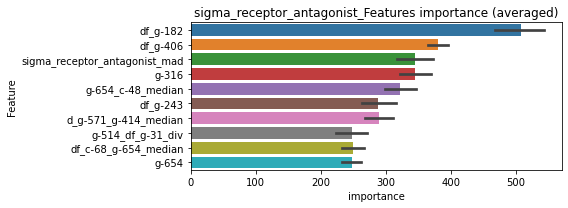

len(train_index) : 2850
len(valid_index) : 950
================================= fold 1/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0949219	valid_1's binary_logloss: 0.1472
[200]	training's binary_logloss: 0.0297079	valid_1's binary_logloss: 0.069382
[300]	training's binary_logloss: 0.0111683	valid_1's binary_logloss: 0.0383187
[400]	training's binary_logloss: 0.00483511	valid_1's binary_logloss: 0.025547
[500]	training's binary_logloss: 0.0024639	valid_1's binary_logloss: 0.0186301
[600]	training's binary_logloss: 0.00152121	valid_1's binary_logloss: 0.0153963
[700]	training's binary_logloss: 0.0010732	valid_1's binary_logloss: 0.0138112
[800]	training's binary_logloss: 0.000835114	valid_1's binary_logloss: 0.0128828
[900]	training's binary_logloss: 0.000692003	valid_1's binary_logloss: 0.0119913
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.000673701	valid_1's binary_logloss: 0.0119047


len(train_index) : 2850
len(valid_index) : 950
================================= fold 2/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0960743	valid_1's binary_logloss: 0.136802
[200]	training's binary_logloss: 0.0304569	valid_1's binary_logloss: 0.0654967
[300]	training's binary_logloss: 0.0114752	valid_1's binary_logloss: 0.0398388
[400]	training's binary_logloss: 0.00480967	valid_1's binary_logloss: 0.0280316
[500]	training's binary_logloss: 0.00243757	valid_1's binary_logloss: 0.0223577
[600]	training's binary_logloss: 0.001511	valid_1's binary_logloss: 0.0196327
[700]	training's binary_logloss: 0.00107049	valid_1's binary_logloss: 0.0187996
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00114046	valid_1's binary_logloss: 0.0185318


len(train_index) : 2850
len(valid_index) : 950
================================= fold 3/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959793	valid_1's binary_logloss: 0.135431
[200]	training's binary_logloss: 0.0299551	valid_1's binary_logloss: 0.0653218
[300]	training's binary_logloss: 0.0115899	valid_1's binary_logloss: 0.0394795
[400]	training's binary_logloss: 0.00490213	valid_1's binary_logloss: 0.0284678
[500]	training's binary_logloss: 0.00248527	valid_1's binary_logloss: 0.0235424
[600]	training's binary_logloss: 0.00151716	valid_1's binary_logloss: 0.0214922
[700]	training's binary_logloss: 0.00107458	valid_1's binary_logloss: 0.020568
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.000921386	valid_1's binary_logloss: 0.0200771


len(train_index) : 2850
len(valid_index) : 950
================================= fold 4/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0981541	valid_1's binary_logloss: 0.119586
[200]	training's binary_logloss: 0.0318469	valid_1's binary_logloss: 0.0506236
[300]	training's binary_logloss: 0.0123188	valid_1's binary_logloss: 0.0266075
[400]	training's binary_logloss: 0.00509566	valid_1's binary_logloss: 0.0157171
[500]	training's binary_logloss: 0.00260864	valid_1's binary_logloss: 0.0108065
[600]	training's binary_logloss: 0.00160487	valid_1's binary_logloss: 0.00856122
[700]	training's binary_logloss: 0.00113031	valid_1's binary_logloss: 0.00704964
[800]	training's binary_logloss: 0.000871195	valid_1's binary_logloss: 0.00646033
[900]	training's binary_logloss: 0.000713007	valid_1's binary_logloss: 0.0058849
[1000]	training's binary_logloss: 0.000636921	valid_1's binary_logloss: 0.00567196
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000651388	valid_1's binary_logloss: 0.00565963


sigma_receptor_antagonist logloss: 0.014043300743195626


neg labels: 3289 → selected neg labels: 3285


smoothened_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0909506	valid_1's binary_logloss: 0.118527
[200]	training's binary_logloss: 0.030874	valid_1's binary_logloss: 0.0505023
[300]	training's binary_logloss: 0.0114259	valid_1's binary_logloss: 0.0255305
[400]	training's binary_logloss: 0.00450751	valid_1's binary_logloss: 0.0147078
[500]	training's binary_logloss: 0.00219558	valid_1's binary_logloss: 0.010289
[600]	training's binary_logloss: 0.00131713	valid_1's binary_logloss: 0.00838864
[700]	training's binary_logloss: 0.000918914	valid_1's binary_logloss: 0.00732468
[800]	training's binary_logloss: 0.000711521	valid_1's binary_logloss: 0.00671275
[900]	training's binary_logloss: 0.00059932	valid_1's binary_logloss: 0.00640791
[1000]	training's binary_logloss: 0.000555633	valid_1's binary_logloss: 0.00633105
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.000556094	valid_1's binary_logloss: 0.00632699
Training until vali

1 / 3 AUC score:1.000
y_Threshold: 0.0090099, Threshold: 0.0353167, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.02472, conf_1:0.04591
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0353167
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.0653167
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_3: 0.0953167
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_4: 0.1253167
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_5: 0.1553167
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_6: 0.1853167
threshold: 0.1853167, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0848396	valid_1's binary_logloss: 0.115031
[200]	training's binary_logloss: 0.02636	valid_1's binary_logloss: 0.0480661
[300]	training's binary_logloss: 0.00879769	valid_1's binary_logloss: 0.0241491
[400]	training's binary_logloss: 0.00349073	valid_1's binary_logloss: 0.0146392
[500]	training's binary_logloss: 0.00176598	valid_1's binary_logloss: 0.010753
[600]	training's binary_logloss: 0.00109238	valid_1's binary_logloss: 0.00880611
[700]	training's binary_logloss: 0.000781018	valid_1's binary_logloss: 0.00794322
[800]	training's binary_logloss: 0.000616435	valid_1's binary_logloss: 0.00738583
[900]	training's binary_logloss: 0.000525036	valid_1's binary_logloss: 0.00708244
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.000497173	valid_1's binary_logloss: 0.00698614
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08627

2 / 3 AUC score:1.000
y_Threshold: 0.1054609, Threshold: 0.1853167, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0062783 Vs.target_rate: 0.00105, Num_p_label: 25.0, conf_0:0.14825, conf_1:0.22238
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_1: 0.1853167
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.2153167
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_3: 0.2453167
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_4: 0.2753167
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_5: 0.3053167
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_6: 0.3353167
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_7: 0.3653167
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_8: 0.3953167
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_9: 0.4253167
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_10: 0.4553167
threshold: 0.4853167, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843056	valid_1's binary_logloss: 0.119766
[200]	training's binary_logloss: 0.0258898	valid_1's binary_logloss: 0.0483603
[300]	training's binary_logloss: 0.0087624	valid_1's binary_logloss: 0.0225091
[400]	training's binary_logloss: 0.00346242	valid_1's binary_logloss: 0.0118365
[500]	training's binary_logloss: 0.00174364	valid_1's binary_logloss: 0.00762365
[600]	training's binary_logloss: 0.00108259	valid_1's binary_logloss: 0.00570667
[700]	training's binary_logloss: 0.000774679	valid_1's binary_logloss: 0.00466526
[800]	training's binary_logloss: 0.000608336	valid_1's binary_logloss: 0.00392492
[900]	training's binary_logloss: 0.000519581	valid_1's binary_logloss: 0.00356676
[1000]	training's binary_logloss: 0.00048984	valid_1's binary_logloss: 0.00347384
Early stopping, best iteration is:
[1010]	training's binary_logloss: 0.000489302	valid_1's binary_logloss: 0.00346931
Training until 

3 / 3 AUC score:1.000
y_Threshold: 0.1031068, Threshold: 0.4853167, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0027624 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.43679, conf_1:0.53385
threshold: 0.4853167, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3806, y_label_rate: 0.1720967


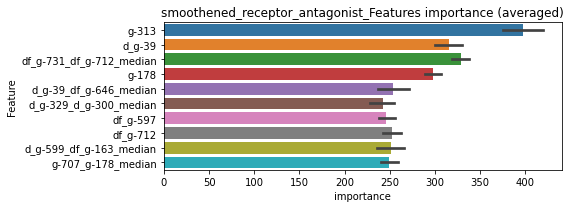

len(train_index) : 2854
len(valid_index) : 952
================================= fold 1/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0860638	valid_1's binary_logloss: 0.118395
[200]	training's binary_logloss: 0.0252884	valid_1's binary_logloss: 0.0453439
[300]	training's binary_logloss: 0.00860797	valid_1's binary_logloss: 0.0204242
[400]	training's binary_logloss: 0.00344118	valid_1's binary_logloss: 0.0107836
[500]	training's binary_logloss: 0.00174462	valid_1's binary_logloss: 0.00679913
[600]	training's binary_logloss: 0.00109011	valid_1's binary_logloss: 0.00505163
[700]	training's binary_logloss: 0.000773307	valid_1's binary_logloss: 0.00403332
[800]	training's binary_logloss: 0.000610995	valid_1's binary_logloss: 0.00353944
[900]	training's binary_logloss: 0.000525336	valid_1's binary_logloss: 0.00321226
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000509661	valid_1's binary_logloss: 0.00314616


len(train_index) : 2854
len(valid_index) : 952
================================= fold 2/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838865	valid_1's binary_logloss: 0.102258
[200]	training's binary_logloss: 0.0246986	valid_1's binary_logloss: 0.0381232
[300]	training's binary_logloss: 0.00873924	valid_1's binary_logloss: 0.0172539
[400]	training's binary_logloss: 0.00345911	valid_1's binary_logloss: 0.00944734
[500]	training's binary_logloss: 0.00173546	valid_1's binary_logloss: 0.00616257
[600]	training's binary_logloss: 0.00108317	valid_1's binary_logloss: 0.0050441
[700]	training's binary_logloss: 0.00077547	valid_1's binary_logloss: 0.00427784
[800]	training's binary_logloss: 0.000608728	valid_1's binary_logloss: 0.00402082
[900]	training's binary_logloss: 0.000524566	valid_1's binary_logloss: 0.00381592
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.000518441	valid_1's binary_logloss: 0.00380595


len(train_index) : 2855
len(valid_index) : 951
================================= fold 3/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0863974	valid_1's binary_logloss: 0.105519
[200]	training's binary_logloss: 0.0261423	valid_1's binary_logloss: 0.0392089
[300]	training's binary_logloss: 0.00885532	valid_1's binary_logloss: 0.0172986
[400]	training's binary_logloss: 0.00353311	valid_1's binary_logloss: 0.00902501
[500]	training's binary_logloss: 0.0017848	valid_1's binary_logloss: 0.00594585
[600]	training's binary_logloss: 0.00110971	valid_1's binary_logloss: 0.00470449
[700]	training's binary_logloss: 0.000790939	valid_1's binary_logloss: 0.00385565
[800]	training's binary_logloss: 0.000621254	valid_1's binary_logloss: 0.0034141
[900]	training's binary_logloss: 0.000536509	valid_1's binary_logloss: 0.00320177
[1000]	training's binary_logloss: 0.000500051	valid_1's binary_logloss: 0.00312186
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000500051	valid_1's binary_logloss: 0.00312186


len(train_index) : 2855
len(valid_index) : 951
================================= fold 4/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0856396	valid_1's binary_logloss: 0.107723
[200]	training's binary_logloss: 0.025464	valid_1's binary_logloss: 0.0417411
[300]	training's binary_logloss: 0.00874904	valid_1's binary_logloss: 0.0197147
[400]	training's binary_logloss: 0.00345313	valid_1's binary_logloss: 0.0106465
[500]	training's binary_logloss: 0.00174392	valid_1's binary_logloss: 0.00672453
[600]	training's binary_logloss: 0.00108772	valid_1's binary_logloss: 0.0049581
[700]	training's binary_logloss: 0.00077757	valid_1's binary_logloss: 0.00401721
[800]	training's binary_logloss: 0.000610192	valid_1's binary_logloss: 0.00346009
[900]	training's binary_logloss: 0.000523168	valid_1's binary_logloss: 0.00315387
[1000]	training's binary_logloss: 0.000493256	valid_1's binary_logloss: 0.00305115
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.00049387	valid_1's binary_logloss: 0.00305018


smoothened_receptor_antagonist logloss: 0.003281157829470792
sodium_channel_inhibitor, len(trt): 267, len(othr): 3261, target_rate: 0.0112119 → Adj_target_rate: 0.0096991


neg labels: 3289 → selected neg labels: 3261


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.224697	valid_1's binary_logloss: 0.350081
[200]	training's binary_logloss: 0.135847	valid_1's binary_logloss: 0.31628
[300]	training's binary_logloss: 0.0888922	valid_1's binary_logloss: 0.301761
[400]	training's binary_logloss: 0.057459	valid_1's binary_logloss: 0.293638
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.0445871	valid_1's binary_logloss: 0.289917
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.221603	valid_1's binary_logloss: 0.34073
[200]	training's binary_logloss: 0.133564	valid_1's binary_logloss: 0.311733
[300]	training's binary_logloss: 0.0859734	valid_1's binary_logloss: 0.297177
[400]	training's binary_logloss: 0.0572169	valid_1's binary_logloss: 0.294229
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.0445134	valid_1's binary_logloss: 0.293346
Training until validation scores do

1 / 3 AUC score:0.882
y_Threshold: 0.1026482, Threshold: 0.3561795, pos_neg_ratio: 0.8000000
Remove_noisy_data: 505 → Positive_corect_labels: 465/3408
p_label_rate: 0.0100452 Vs.target_rate: 0.01121, Num_p_label: 40.0, conf_0:0.24933, conf_1:0.46303
threshold: 0.3561795, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 465.0/3408, y_label_rate: 0.1364437
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130023	valid_1's binary_logloss: 0.2408
[200]	training's binary_logloss: 0.0602432	valid_1's binary_logloss: 0.198415
[300]	training's binary_logloss: 0.0308049	valid_1's binary_logloss: 0.178074
[400]	training's binary_logloss: 0.016862	valid_1's binary_logloss: 0.170427
[500]	training's binary_logloss: 0.00951458	valid_1's binary_logloss: 0.166303
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0100872	valid_1's binary_logloss: 0.166131
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141049	valid_1's binary_logloss: 0.213061
[200]	training's binary_logloss: 0.0689061	valid_1's binary_logloss: 0.170434
[300]	training's binary_logloss: 0.0355625	valid_1's binary_logloss: 0.14848
[400]	training's binary_logloss: 0.0194286	valid_1's binary_logloss: 0.137995
[500]	training's binary_logloss: 0.0110375	valid_1's binary_logloss:

2 / 3 AUC score:0.980
y_Threshold: 0.0952598, Threshold: 0.3561795, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 399.0/3276
p_label_rate: 0.0303867 Vs.target_rate: 0.01121, Num_p_label: 121.0, conf_0:0.28494, conf_1:0.42742
threshold: 0.3561795, positive_p_label: 121.0/3982, p_label_rate: 0.0303867
positive_y_label: 399.0/3276, y_label_rate: 0.1217949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104313	valid_1's binary_logloss: 0.150787
[200]	training's binary_logloss: 0.0456754	valid_1's binary_logloss: 0.103627
[300]	training's binary_logloss: 0.0217537	valid_1's binary_logloss: 0.0807356
[400]	training's binary_logloss: 0.010828	valid_1's binary_logloss: 0.0687348
[500]	training's binary_logloss: 0.00588703	valid_1's binary_logloss: 0.0615018
[600]	training's binary_logloss: 0.00357658	valid_1's binary_logloss: 0.0569277
[700]	training's binary_logloss: 0.00242776	valid_1's binary_logloss: 0.0552159
[800]	training's binary_logloss: 0.00179321	valid_1's binary_logloss: 0.0536485
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00155173	valid_1's binary_logloss: 0.0528901
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0987104	valid_1's binary_logloss: 0.167973
[200]	training's binary_logloss: 0.0420786	valid_1's 

3 / 3 AUC score:0.992
y_Threshold: 0.1165830, Threshold: 0.3561795, pos_neg_ratio: 0.8000000
Remove_noisy_data: 60 → Positive_corect_labels: 369.0/3216
p_label_rate: 0.0444500 Vs.target_rate: 0.01121, Num_p_label: 177.0, conf_0:0.32056, conf_1:0.39180
Num_p_label: 177.0, Expected: 44.6, Adj_threshold_1: 0.3561795
Num_p_label: 164.0, Expected: 44.6, Adj_threshold_2: 0.3861795
Num_p_label: 158.0, Expected: 44.6, Adj_threshold_3: 0.4161795
Num_p_label: 149.0, Expected: 44.6, Adj_threshold_4: 0.4461795
Num_p_label: 141.0, Expected: 44.6, Adj_threshold_5: 0.4761795
Num_p_label: 135.0, Expected: 44.6, Adj_threshold_6: 0.5061795
Num_p_label: 127.0, Expected: 44.6, Adj_threshold_7: 0.5361795
Num_p_label: 115.0, Expected: 44.6, Adj_threshold_8: 0.5661795
Num_p_label: 110.0, Expected: 44.6, Adj_threshold_9: 0.5961795
Num_p_label: 96.0, Expected: 44.6, Adj_threshold_10: 0.6261795
threshold: 0.6561795, positive_p_label: 88.0/3982, p_label_rate: 0.0220994
positive_y_label: 369.0/3216, y_label_rate:

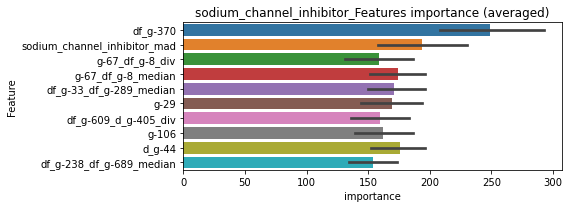

len(train_index) : 2412
len(valid_index) : 804
================================= fold 1/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0869152	valid_1's binary_logloss: 0.146852
[200]	training's binary_logloss: 0.0338713	valid_1's binary_logloss: 0.100591
[300]	training's binary_logloss: 0.0154618	valid_1's binary_logloss: 0.0815747
[400]	training's binary_logloss: 0.00776801	valid_1's binary_logloss: 0.0736301
[500]	training's binary_logloss: 0.00405828	valid_1's binary_logloss: 0.0696377
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00403524	valid_1's binary_logloss: 0.0695956


len(train_index) : 2412
len(valid_index) : 804
================================= fold 2/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0875019	valid_1's binary_logloss: 0.12924
[200]	training's binary_logloss: 0.0335186	valid_1's binary_logloss: 0.0872373
[300]	training's binary_logloss: 0.0145428	valid_1's binary_logloss: 0.0690872
[400]	training's binary_logloss: 0.00689655	valid_1's binary_logloss: 0.0604766
[500]	training's binary_logloss: 0.00377343	valid_1's binary_logloss: 0.0553262
[600]	training's binary_logloss: 0.00236228	valid_1's binary_logloss: 0.0532569
[700]	training's binary_logloss: 0.00167419	valid_1's binary_logloss: 0.0517353
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00158109	valid_1's binary_logloss: 0.0514847


len(train_index) : 2412
len(valid_index) : 804
================================= fold 3/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0887491	valid_1's binary_logloss: 0.142519
[200]	training's binary_logloss: 0.0342551	valid_1's binary_logloss: 0.0994218
[300]	training's binary_logloss: 0.0149382	valid_1's binary_logloss: 0.0841545
[400]	training's binary_logloss: 0.00726387	valid_1's binary_logloss: 0.0787631
[500]	training's binary_logloss: 0.00392889	valid_1's binary_logloss: 0.0773769
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00356618	valid_1's binary_logloss: 0.0769404


len(train_index) : 2412
len(valid_index) : 804
================================= fold 4/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0882671	valid_1's binary_logloss: 0.145938
[200]	training's binary_logloss: 0.0345582	valid_1's binary_logloss: 0.0985723
[300]	training's binary_logloss: 0.0154804	valid_1's binary_logloss: 0.0778758
[400]	training's binary_logloss: 0.0073543	valid_1's binary_logloss: 0.0680058
[500]	training's binary_logloss: 0.00401368	valid_1's binary_logloss: 0.0651721
[600]	training's binary_logloss: 0.00251623	valid_1's binary_logloss: 0.0630916
[700]	training's binary_logloss: 0.00175044	valid_1's binary_logloss: 0.0622876
Early stopping, best iteration is:
[728]	training's binary_logloss: 0.00161213	valid_1's binary_logloss: 0.0616321


sodium_channel_inhibitor logloss: 0.06491321316864347
sphingosine_receptor_agonist, len(trt): 32, len(othr): 3282, target_rate: 0.0013437 → Adj_target_rate: 0.0015980


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0835191	valid_1's binary_logloss: 0.131911
[200]	training's binary_logloss: 0.0241091	valid_1's binary_logloss: 0.0669322
[300]	training's binary_logloss: 0.0084597	valid_1's binary_logloss: 0.0434561
[400]	training's binary_logloss: 0.00356097	valid_1's binary_logloss: 0.0333398
[500]	training's binary_logloss: 0.00189564	valid_1's binary_logloss: 0.0294488
[600]	training's binary_logloss: 0.00121132	valid_1's binary_logloss: 0.0274421
[700]	training's binary_logloss: 0.000879242	valid_1's binary_logloss: 0.0264554
[800]	training's binary_logloss: 0.000705564	valid_1's binary_logloss: 0.0257765
[900]	training's binary_logloss: 0.000597503	valid_1's binary_logloss: 0.0251794
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000578871	valid_1's binary_logloss: 0.0251544
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0857788	

1 / 3 AUC score:1.000
y_Threshold: 0.0097550, Threshold: 0.0606262, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3802
p_label_rate: 0.0100452 Vs.target_rate: 0.00134, Num_p_label: 40.0, conf_0:0.04244, conf_1:0.07881
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_1: 0.0606262
Num_p_label: 24.0, Expected: 5.4, Adj_threshold_2: 0.0906262
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_3: 0.1206262
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_4: 0.1506262
threshold: 0.1506262, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0824107	valid_1's binary_logloss: 0.116928
[200]	training's binary_logloss: 0.0227239	valid_1's binary_logloss: 0.0500061
[300]	training's binary_logloss: 0.00770645	valid_1's binary_logloss: 0.0263326
[400]	training's binary_logloss: 0.00325974	valid_1's binary_logloss: 0.0170936
[500]	training's binary_logloss: 0.00173005	valid_1's binary_logloss: 0.012698
[600]	training's binary_logloss: 0.00110897	valid_1's binary_logloss: 0.0104165
[700]	training's binary_logloss: 0.000809753	valid_1's binary_logloss: 0.00923596
[800]	training's binary_logloss: 0.000644271	valid_1's binary_logloss: 0.00859152
[900]	training's binary_logloss: 0.000550177	valid_1's binary_logloss: 0.00807647
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.000534134	valid_1's binary_logloss: 0.00799216
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0807

2 / 3 AUC score:1.000
y_Threshold: 0.0831417, Threshold: 0.1506262, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0100452 Vs.target_rate: 0.00134, Num_p_label: 40.0, conf_0:0.12050, conf_1:0.18075
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_1: 0.1506262
Num_p_label: 35.0, Expected: 5.4, Adj_threshold_2: 0.1806262
Num_p_label: 25.0, Expected: 5.4, Adj_threshold_3: 0.2106262
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_4: 0.2406262
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_5: 0.2706262
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_6: 0.3006262
threshold: 0.3006262, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.081166	valid_1's binary_logloss: 0.117272
[200]	training's binary_logloss: 0.0227668	valid_1's binary_logloss: 0.0531305
[300]	training's binary_logloss: 0.0077425	valid_1's binary_logloss: 0.0310969
[400]	training's binary_logloss: 0.00327789	valid_1's binary_logloss: 0.0219327
[500]	training's binary_logloss: 0.00172447	valid_1's binary_logloss: 0.0179742
[600]	training's binary_logloss: 0.00110118	valid_1's binary_logloss: 0.0160922
[700]	training's binary_logloss: 0.000795894	valid_1's binary_logloss: 0.0147284
[800]	training's binary_logloss: 0.000632088	valid_1's binary_logloss: 0.0140146
[900]	training's binary_logloss: 0.000539107	valid_1's binary_logloss: 0.0137002
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.000523778	valid_1's binary_logloss: 0.0136593
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0813686	v

3 / 3 AUC score:1.000
y_Threshold: 0.0789817, Threshold: 0.3006262, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 648.0/3790
p_label_rate: 0.0040181 Vs.target_rate: 0.00134, Num_p_label: 16.0, conf_0:0.27056, conf_1:0.33069
threshold: 0.3006262, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 648.0/3790, y_label_rate: 0.1709763


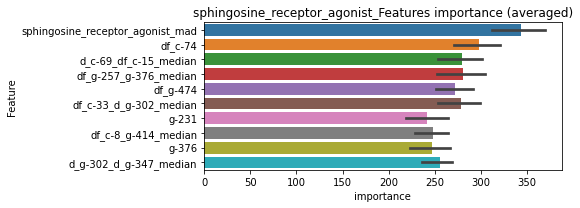

len(train_index) : 2842
len(valid_index) : 948
================================= fold 1/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.081905	valid_1's binary_logloss: 0.119614
[200]	training's binary_logloss: 0.0226422	valid_1's binary_logloss: 0.0507871
[300]	training's binary_logloss: 0.0076275	valid_1's binary_logloss: 0.0276776
[400]	training's binary_logloss: 0.00320344	valid_1's binary_logloss: 0.0181724
[500]	training's binary_logloss: 0.00169623	valid_1's binary_logloss: 0.0144176
[600]	training's binary_logloss: 0.00109196	valid_1's binary_logloss: 0.012382
[700]	training's binary_logloss: 0.000790702	valid_1's binary_logloss: 0.0116512
[800]	training's binary_logloss: 0.000629288	valid_1's binary_logloss: 0.0107016
[900]	training's binary_logloss: 0.000535074	valid_1's binary_logloss: 0.0101932
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000513918	valid_1's binary_logloss: 0.0100946


len(train_index) : 2842
len(valid_index) : 948
================================= fold 2/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0807524	valid_1's binary_logloss: 0.107219
[200]	training's binary_logloss: 0.0222736	valid_1's binary_logloss: 0.0437532
[300]	training's binary_logloss: 0.00753608	valid_1's binary_logloss: 0.024887
[400]	training's binary_logloss: 0.00316997	valid_1's binary_logloss: 0.0164538
[500]	training's binary_logloss: 0.00167562	valid_1's binary_logloss: 0.0127155
[600]	training's binary_logloss: 0.00107045	valid_1's binary_logloss: 0.0113729
[700]	training's binary_logloss: 0.000777314	valid_1's binary_logloss: 0.0103971
[800]	training's binary_logloss: 0.000616826	valid_1's binary_logloss: 0.00985401
[900]	training's binary_logloss: 0.000527748	valid_1's binary_logloss: 0.0096202
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000527174	valid_1's binary_logloss: 0.00961854


len(train_index) : 2843
len(valid_index) : 947
================================= fold 3/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0791243	valid_1's binary_logloss: 0.116288
[200]	training's binary_logloss: 0.0215377	valid_1's binary_logloss: 0.0573548
[300]	training's binary_logloss: 0.00728262	valid_1's binary_logloss: 0.0409046
[400]	training's binary_logloss: 0.00307455	valid_1's binary_logloss: 0.0337418
[500]	training's binary_logloss: 0.00163011	valid_1's binary_logloss: 0.0302935
[600]	training's binary_logloss: 0.00104256	valid_1's binary_logloss: 0.0292593
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00108362	valid_1's binary_logloss: 0.0291943


len(train_index) : 2843
len(valid_index) : 947
================================= fold 4/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0801596	valid_1's binary_logloss: 0.108212
[200]	training's binary_logloss: 0.0220319	valid_1's binary_logloss: 0.0450371
[300]	training's binary_logloss: 0.00731193	valid_1's binary_logloss: 0.0237156
[400]	training's binary_logloss: 0.00305755	valid_1's binary_logloss: 0.0160436
[500]	training's binary_logloss: 0.00163115	valid_1's binary_logloss: 0.0128879
[600]	training's binary_logloss: 0.00104065	valid_1's binary_logloss: 0.0112812
[700]	training's binary_logloss: 0.000757838	valid_1's binary_logloss: 0.0104776
[800]	training's binary_logloss: 0.000601361	valid_1's binary_logloss: 0.0100586
[900]	training's binary_logloss: 0.000514149	valid_1's binary_logloss: 0.00980457
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000498868	valid_1's binary_logloss: 0.00977689


sphingosine_receptor_agonist logloss: 0.014668540403492216


neg labels: 3289 → selected neg labels: 3278


src_inhibitor, len(trt): 71, len(othr): 3278, target_rate: 0.0029814 → Adj_target_rate: 0.0031461
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138984	valid_1's binary_logloss: 0.203774
[200]	training's binary_logloss: 0.0619954	valid_1's binary_logloss: 0.134046
[300]	training's binary_logloss: 0.0298731	valid_1's binary_logloss: 0.103091
[400]	training's binary_logloss: 0.0152999	valid_1's binary_logloss: 0.0865589
[500]	training's binary_logloss: 0.0081505	valid_1's binary_logloss: 0.0786014
[600]	training's binary_logloss: 0.0047568	valid_1's binary_logloss: 0.0742596
[700]	training's binary_logloss: 0.00309078	valid_1's binary_logloss: 0.0717042
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.0025129	valid_1's binary_logloss: 0.0710701
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136219	valid_1's binary_logloss: 0.209646
[200]	training's binary_logloss: 0.0643318	valid_1's binary_logloss: 0.140787
[300]	training's binary_logloss: 0.0322772	valid_1's binary

1 / 3 AUC score:0.993
y_Threshold: 0.0347512, Threshold: 0.1768052, pos_neg_ratio: 0.8000000
Remove_noisy_data: 174 → Positive_corect_labels: 634/3759
p_label_rate: 0.0100452 Vs.target_rate: 0.00298, Num_p_label: 40.0, conf_0:0.12376, conf_1:0.22985
Num_p_label: 40.0, Expected: 11.9, Adj_threshold_1: 0.1768052
Num_p_label: 31.0, Expected: 11.9, Adj_threshold_2: 0.2068052
Num_p_label: 23.0, Expected: 11.9, Adj_threshold_3: 0.2368052
Num_p_label: 22.0, Expected: 11.9, Adj_threshold_4: 0.2668052
Num_p_label: 19.0, Expected: 11.9, Adj_threshold_5: 0.2968052
Num_p_label: 15.0, Expected: 11.9, Adj_threshold_6: 0.3268052
threshold: 0.3268052, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 634.0/3759, y_label_rate: 0.1686619
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126463	valid_1's binary_logloss: 0.183746
[200]	training's binary_logloss: 0.0536563	valid_1's binary_logloss: 0.115163
[300]	training's binary_logloss: 0.0239725	valid_1's binary_logloss: 0.0817573
[400]	training's binary_logloss: 0.01189	valid_1's binary_logloss: 0.0662236
[500]	training's binary_logloss: 0.00612651	valid_1's binary_logloss: 0.0578501
[600]	training's binary_logloss: 0.00354008	valid_1's binary_logloss: 0.0529582
[700]	training's binary_logloss: 0.00232488	valid_1's binary_logloss: 0.0506937
[800]	training's binary_logloss: 0.00169576	valid_1's binary_logloss: 0.0495183
[900]	training's binary_logloss: 0.00133334	valid_1's binary_logloss: 0.0490542
[1000]	training's binary_logloss: 0.00111797	valid_1's binary_logloss: 0.0485929
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.0011087	valid_1's binary_logloss: 0.0485512
Training until validation scores

2 / 3 AUC score:0.997
y_Threshold: 0.1172148, Threshold: 0.3268052, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 615.0/3721
p_label_rate: 0.0123054 Vs.target_rate: 0.00298, Num_p_label: 49.0, conf_0:0.26144, conf_1:0.39217
Num_p_label: 49.0, Expected: 11.9, Adj_threshold_1: 0.3268052
Num_p_label: 46.0, Expected: 11.9, Adj_threshold_2: 0.3568052
Num_p_label: 42.0, Expected: 11.9, Adj_threshold_3: 0.3868052
Num_p_label: 39.0, Expected: 11.9, Adj_threshold_4: 0.4168052
Num_p_label: 39.0, Expected: 11.9, Adj_threshold_5: 0.4468052
Num_p_label: 38.0, Expected: 11.9, Adj_threshold_6: 0.4768052
Num_p_label: 36.0, Expected: 11.9, Adj_threshold_7: 0.5068052
Num_p_label: 31.0, Expected: 11.9, Adj_threshold_8: 0.5368052
Num_p_label: 31.0, Expected: 11.9, Adj_threshold_9: 0.5668052
Num_p_label: 29.0, Expected: 11.9, Adj_threshold_10: 0.5968052
threshold: 0.6268052, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 615.0/3721, y_label_rate: 0.1652782

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115071	valid_1's binary_logloss: 0.173036
[200]	training's binary_logloss: 0.045314	valid_1's binary_logloss: 0.109769
[300]	training's binary_logloss: 0.0194804	valid_1's binary_logloss: 0.0809582
[400]	training's binary_logloss: 0.0092427	valid_1's binary_logloss: 0.0665401
[500]	training's binary_logloss: 0.00486664	valid_1's binary_logloss: 0.0610311
[600]	training's binary_logloss: 0.00287842	valid_1's binary_logloss: 0.0575439
[700]	training's binary_logloss: 0.00194284	valid_1's binary_logloss: 0.0561257
[800]	training's binary_logloss: 0.00145239	valid_1's binary_logloss: 0.0549404
[900]	training's binary_logloss: 0.00116347	valid_1's binary_logloss: 0.0541945
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00115645	valid_1's binary_logloss: 0.0541233
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115696	valid_1's

3 / 3 AUC score:0.998
y_Threshold: 0.1124330, Threshold: 0.6268052, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 599.0/3689
p_label_rate: 0.0080362 Vs.target_rate: 0.00298, Num_p_label: 32.0, conf_0:0.50000, conf_1:0.68949
threshold: 0.6268052, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 599.0/3689, y_label_rate: 0.1623746


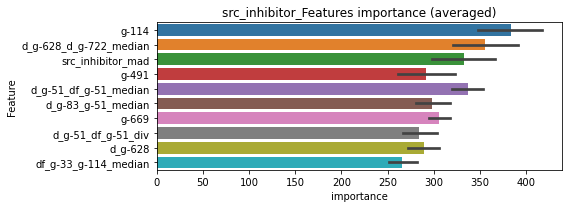

len(train_index) : 2766
len(valid_index) : 923
================================= fold 1/4 src_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113562	valid_1's binary_logloss: 0.159207
[200]	training's binary_logloss: 0.0445193	valid_1's binary_logloss: 0.0896389
[300]	training's binary_logloss: 0.0194856	valid_1's binary_logloss: 0.058603
[400]	training's binary_logloss: 0.00900983	valid_1's binary_logloss: 0.042245
[500]	training's binary_logloss: 0.00466556	valid_1's binary_logloss: 0.0325181
[600]	training's binary_logloss: 0.00275742	valid_1's binary_logloss: 0.027322
[700]	training's binary_logloss: 0.00185889	valid_1's binary_logloss: 0.0245134
[800]	training's binary_logloss: 0.00138191	valid_1's binary_logloss: 0.0223193
[900]	training's binary_logloss: 0.00111724	valid_1's binary_logloss: 0.0211746
[1000]	training's binary_logloss: 0.000960609	valid_1's binary_logloss: 0.0204506
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.000955048	valid_1's binary_logloss: 0.020425


len(train_index) : 2767
len(valid_index) : 922
================================= fold 2/4 src_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113587	valid_1's binary_logloss: 0.153832
[200]	training's binary_logloss: 0.0439574	valid_1's binary_logloss: 0.0878327
[300]	training's binary_logloss: 0.0191703	valid_1's binary_logloss: 0.0587135
[400]	training's binary_logloss: 0.00886083	valid_1's binary_logloss: 0.0443805
[500]	training's binary_logloss: 0.00457234	valid_1's binary_logloss: 0.0371719
[600]	training's binary_logloss: 0.00272599	valid_1's binary_logloss: 0.0338868
[700]	training's binary_logloss: 0.00184997	valid_1's binary_logloss: 0.0321692
[800]	training's binary_logloss: 0.00138851	valid_1's binary_logloss: 0.0312517
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00127722	valid_1's binary_logloss: 0.0307866


len(train_index) : 2767
len(valid_index) : 922
================================= fold 3/4 src_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110618	valid_1's binary_logloss: 0.178386
[200]	training's binary_logloss: 0.0426158	valid_1's binary_logloss: 0.107496
[300]	training's binary_logloss: 0.0186908	valid_1's binary_logloss: 0.0762201
[400]	training's binary_logloss: 0.00896233	valid_1's binary_logloss: 0.06167
[500]	training's binary_logloss: 0.00461057	valid_1's binary_logloss: 0.0547343
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00337256	valid_1's binary_logloss: 0.052701


len(train_index) : 2767
len(valid_index) : 922
================================= fold 4/4 src_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108994	valid_1's binary_logloss: 0.171717
[200]	training's binary_logloss: 0.0425514	valid_1's binary_logloss: 0.107772
[300]	training's binary_logloss: 0.0182611	valid_1's binary_logloss: 0.0770473
[400]	training's binary_logloss: 0.00851556	valid_1's binary_logloss: 0.0603759
[500]	training's binary_logloss: 0.00445894	valid_1's binary_logloss: 0.0519679
[600]	training's binary_logloss: 0.00267721	valid_1's binary_logloss: 0.0462912
[700]	training's binary_logloss: 0.00181573	valid_1's binary_logloss: 0.0425945
[800]	training's binary_logloss: 0.00135012	valid_1's binary_logloss: 0.0403345
[900]	training's binary_logloss: 0.0010962	valid_1's binary_logloss: 0.0393668
[1000]	training's binary_logloss: 0.00093853	valid_1's binary_logloss: 0.0383685
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000944972	valid_1's binary_logloss: 0.0383001


src_inhibitor logloss: 0.03554907273965203
steroid, len(trt): 79, len(othr): 3275, target_rate: 0.0033174 → Adj_target_rate: 0.0034449


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132416	valid_1's binary_logloss: 0.211097
[200]	training's binary_logloss: 0.0584275	valid_1's binary_logloss: 0.147393
[300]	training's binary_logloss: 0.0290465	valid_1's binary_logloss: 0.120506
[400]	training's binary_logloss: 0.0143635	valid_1's binary_logloss: 0.104298
[500]	training's binary_logloss: 0.0075521	valid_1's binary_logloss: 0.0973852
[600]	training's binary_logloss: 0.00438706	valid_1's binary_logloss: 0.0933312
[700]	training's binary_logloss: 0.00285282	valid_1's binary_logloss: 0.0924914
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.00305973	valid_1's binary_logloss: 0.0922434
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126117	valid_1's binary_logloss: 0.191668
[200]	training's binary_logloss: 0.0532395	valid_1's binary_logloss: 0.126625
[300]	training's binary_logloss: 0.0251821	valid_1's binar

1 / 3 AUC score:0.989
y_Threshold: 0.0290046, Threshold: 0.2983079, pos_neg_ratio: 0.8000000
Remove_noisy_data: 175 → Positive_corect_labels: 633/3755
p_label_rate: 0.0100452 Vs.target_rate: 0.00332, Num_p_label: 40.0, conf_0:0.20882, conf_1:0.38780
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_1: 0.2983079
Num_p_label: 32.0, Expected: 13.2, Adj_threshold_2: 0.3283079
Num_p_label: 31.0, Expected: 13.2, Adj_threshold_3: 0.3583079
Num_p_label: 31.0, Expected: 13.2, Adj_threshold_4: 0.3883079
Num_p_label: 25.0, Expected: 13.2, Adj_threshold_5: 0.4183079
Num_p_label: 23.0, Expected: 13.2, Adj_threshold_6: 0.4483079
Num_p_label: 21.0, Expected: 13.2, Adj_threshold_7: 0.4783079
Num_p_label: 19.0, Expected: 13.2, Adj_threshold_8: 0.5083079
threshold: 0.5083079, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 633.0/3755, y_label_rate: 0.1685752
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119537	valid_1's binary_logloss: 0.170228
[200]	training's binary_logloss: 0.0489602	valid_1's binary_logloss: 0.105086
[300]	training's binary_logloss: 0.0220992	valid_1's binary_logloss: 0.0770851
[400]	training's binary_logloss: 0.0105356	valid_1's binary_logloss: 0.0625783
[500]	training's binary_logloss: 0.00542339	valid_1's binary_logloss: 0.0545087
[600]	training's binary_logloss: 0.00314353	valid_1's binary_logloss: 0.0498138
[700]	training's binary_logloss: 0.00210595	valid_1's binary_logloss: 0.0482589
[800]	training's binary_logloss: 0.00154325	valid_1's binary_logloss: 0.046545
[900]	training's binary_logloss: 0.00122785	valid_1's binary_logloss: 0.0455284
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00116232	valid_1's binary_logloss: 0.0454217
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117112	valid_1's

2 / 3 AUC score:0.995
y_Threshold: 0.0751036, Threshold: 0.5083079, pos_neg_ratio: 0.8000000
Remove_noisy_data: 46 → Positive_corect_labels: 610.0/3709
p_label_rate: 0.0143144 Vs.target_rate: 0.00332, Num_p_label: 57.0, conf_0:0.40665, conf_1:0.60997
Num_p_label: 57.0, Expected: 13.2, Adj_threshold_1: 0.5083079
Num_p_label: 53.0, Expected: 13.2, Adj_threshold_2: 0.5383079
Num_p_label: 48.0, Expected: 13.2, Adj_threshold_3: 0.5683079
Num_p_label: 45.0, Expected: 13.2, Adj_threshold_4: 0.5983079
Num_p_label: 45.0, Expected: 13.2, Adj_threshold_5: 0.6283079
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_6: 0.6583079
Num_p_label: 38.0, Expected: 13.2, Adj_threshold_7: 0.6883079
threshold: 0.6883079, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 610.0/3709, y_label_rate: 0.1644648
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109449	valid_1's binary_logloss: 0.155012
[200]	training's binary_logloss: 0.0404467	valid_1's binary_logloss: 0.0850442
[300]	training's binary_logloss: 0.0172036	valid_1's binary_logloss: 0.0574089
[400]	training's binary_logloss: 0.00801111	valid_1's binary_logloss: 0.0458106
[500]	training's binary_logloss: 0.00408645	valid_1's binary_logloss: 0.0400024
[600]	training's binary_logloss: 0.00245303	valid_1's binary_logloss: 0.0375293
[700]	training's binary_logloss: 0.00167897	valid_1's binary_logloss: 0.0360777
Early stopping, best iteration is:
[767]	training's binary_logloss: 0.00137902	valid_1's binary_logloss: 0.0356173
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108218	valid_1's binary_logloss: 0.180528
[200]	training's binary_logloss: 0.0409333	valid_1's binary_logloss: 0.109383
[300]	training's binary_logloss: 0.0176518	valid_1's 

3 / 3 AUC score:0.997
y_Threshold: 0.0673286, Threshold: 0.6883079, pos_neg_ratio: 0.8000000
Remove_noisy_data: 34 → Positive_corect_labels: 593.0/3675
p_label_rate: 0.0133099 Vs.target_rate: 0.00332, Num_p_label: 53.0, conf_0:0.50000, conf_1:0.75714
Num_p_label: 53.0, Expected: 13.2, Adj_threshold_1: 0.6883079
threshold: 0.6883079, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 593.0/3675, y_label_rate: 0.1613605


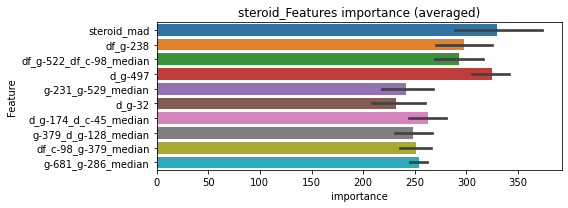

len(train_index) : 2756
len(valid_index) : 919
================================= fold 1/4 steroid=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104227	valid_1's binary_logloss: 0.154892
[200]	training's binary_logloss: 0.0372742	valid_1's binary_logloss: 0.0860323
[300]	training's binary_logloss: 0.0151612	valid_1's binary_logloss: 0.0569113
[400]	training's binary_logloss: 0.00683869	valid_1's binary_logloss: 0.0451005
[500]	training's binary_logloss: 0.00346173	valid_1's binary_logloss: 0.0385285
[600]	training's binary_logloss: 0.00208876	valid_1's binary_logloss: 0.0358864
[700]	training's binary_logloss: 0.00145025	valid_1's binary_logloss: 0.0351124
[800]	training's binary_logloss: 0.00111337	valid_1's binary_logloss: 0.0346285
[900]	training's binary_logloss: 0.000916555	valid_1's binary_logloss: 0.03418
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000961202	valid_1's binary_logloss: 0.0340383


len(train_index) : 2756
len(valid_index) : 919
================================= fold 2/4 steroid=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106196	valid_1's binary_logloss: 0.160394
[200]	training's binary_logloss: 0.0378578	valid_1's binary_logloss: 0.0894905
[300]	training's binary_logloss: 0.0154753	valid_1's binary_logloss: 0.0618716
[400]	training's binary_logloss: 0.00691003	valid_1's binary_logloss: 0.0489138
[500]	training's binary_logloss: 0.00359426	valid_1's binary_logloss: 0.0435322
[600]	training's binary_logloss: 0.00219961	valid_1's binary_logloss: 0.0407448
[700]	training's binary_logloss: 0.00152375	valid_1's binary_logloss: 0.0393644
[800]	training's binary_logloss: 0.00115742	valid_1's binary_logloss: 0.0387684
Early stopping, best iteration is:
[786]	training's binary_logloss: 0.00119395	valid_1's binary_logloss: 0.0386194


len(train_index) : 2756
len(valid_index) : 919
================================= fold 3/4 steroid=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105878	valid_1's binary_logloss: 0.1608
[200]	training's binary_logloss: 0.0377052	valid_1's binary_logloss: 0.0889136
[300]	training's binary_logloss: 0.0158851	valid_1's binary_logloss: 0.0621814
[400]	training's binary_logloss: 0.00713409	valid_1's binary_logloss: 0.0483229
[500]	training's binary_logloss: 0.00372634	valid_1's binary_logloss: 0.0429756
[600]	training's binary_logloss: 0.00227071	valid_1's binary_logloss: 0.0396291
[700]	training's binary_logloss: 0.00157906	valid_1's binary_logloss: 0.0384096
[800]	training's binary_logloss: 0.00118595	valid_1's binary_logloss: 0.0374761
[900]	training's binary_logloss: 0.000967078	valid_1's binary_logloss: 0.0367053
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000935723	valid_1's binary_logloss: 0.0366394


len(train_index) : 2757
len(valid_index) : 918
================================= fold 4/4 steroid=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10579	valid_1's binary_logloss: 0.148476
[200]	training's binary_logloss: 0.0376075	valid_1's binary_logloss: 0.0766879
[300]	training's binary_logloss: 0.0152749	valid_1's binary_logloss: 0.0470734
[400]	training's binary_logloss: 0.00721999	valid_1's binary_logloss: 0.0348524
[500]	training's binary_logloss: 0.0036699	valid_1's binary_logloss: 0.0286308
[600]	training's binary_logloss: 0.00219041	valid_1's binary_logloss: 0.0257314
[700]	training's binary_logloss: 0.00150632	valid_1's binary_logloss: 0.0242628
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00127095	valid_1's binary_logloss: 0.0233711


steroid logloss: 0.0331697031092295


neg labels: 3289 → selected neg labels: 3287


syk_inhibitor, len(trt): 19, len(othr): 3287, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0731284	valid_1's binary_logloss: 0.0979027
[200]	training's binary_logloss: 0.0192405	valid_1's binary_logloss: 0.0371106
[300]	training's binary_logloss: 0.00611945	valid_1's binary_logloss: 0.0185784
[400]	training's binary_logloss: 0.00250204	valid_1's binary_logloss: 0.0112089
[500]	training's binary_logloss: 0.00130247	valid_1's binary_logloss: 0.00804975
[600]	training's binary_logloss: 0.000840828	valid_1's binary_logloss: 0.00636873
[700]	training's binary_logloss: 0.000625595	valid_1's binary_logloss: 0.0055187
[800]	training's binary_logloss: 0.000510688	valid_1's binary_logloss: 0.00496562
[900]	training's binary_logloss: 0.000460249	valid_1's binary_logloss: 0.00475097
Early stopping, best iteration is:
[943]	training's binary_logloss: 0.000445334	valid_1's binary_logloss: 0.00468441
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0054284, Threshold: 0.0286096, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.02003, conf_1:0.03719
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0286096
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_2: 0.0586096
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_3: 0.0886096
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_4: 0.1186096
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_5: 0.1486096
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_6: 0.1786096
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_7: 0.2086096
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.2386096
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_9: 0.2686096
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_10: 0.2986096
threshold: 0.2986096, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0697571	valid_1's binary_logloss: 0.0887033
[200]	training's binary_logloss: 0.0167223	valid_1's binary_logloss: 0.0274313
[300]	training's binary_logloss: 0.00510053	valid_1's binary_logloss: 0.0112527
[400]	training's binary_logloss: 0.00207682	valid_1's binary_logloss: 0.00608043
[500]	training's binary_logloss: 0.00111144	valid_1's binary_logloss: 0.00416725
[600]	training's binary_logloss: 0.000727395	valid_1's binary_logloss: 0.00325846
[700]	training's binary_logloss: 0.000542699	valid_1's binary_logloss: 0.00276966
[800]	training's binary_logloss: 0.000444569	valid_1's binary_logloss: 0.00246262
[900]	training's binary_logloss: 0.000404667	valid_1's binary_logloss: 0.00243081
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.000407003	valid_1's binary_logloss: 0.00241651
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1208106, Threshold: 0.2986096, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0050226 Vs.target_rate: 0.00080, Num_p_label: 20.0, conf_0:0.23889, conf_1:0.35833
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_1: 0.2986096
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_2: 0.3286096
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_3: 0.3586096
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_4: 0.3886096
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_5: 0.4186096
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_6: 0.4486096
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_7: 0.4786096
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_8: 0.5086096
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_9: 0.5386096
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_10: 0.5686096
threshold: 0.5986096, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0676804	valid_1's binary_logloss: 0.087568
[200]	training's binary_logloss: 0.0158735	valid_1's binary_logloss: 0.0282897
[300]	training's binary_logloss: 0.00484408	valid_1's binary_logloss: 0.0124579
[400]	training's binary_logloss: 0.00199562	valid_1's binary_logloss: 0.0073236
[500]	training's binary_logloss: 0.00107285	valid_1's binary_logloss: 0.00500137
[600]	training's binary_logloss: 0.000699348	valid_1's binary_logloss: 0.0040223
[700]	training's binary_logloss: 0.000526705	valid_1's binary_logloss: 0.00354786
[800]	training's binary_logloss: 0.000435263	valid_1's binary_logloss: 0.00319379
[900]	training's binary_logloss: 0.000399011	valid_1's binary_logloss: 0.00310593
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.000400801	valid_1's binary_logloss: 0.00310114
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1122182, Threshold: 0.5986096, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.50000, conf_1:0.65847
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.5986096
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.6286096
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_3: 0.6586096
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.6886096
threshold: 0.6886096, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3810, y_label_rate: 0.1721785


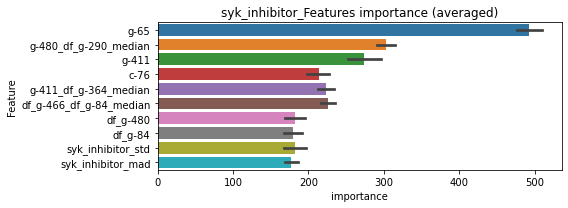

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 syk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0684751	valid_1's binary_logloss: 0.0895213
[200]	training's binary_logloss: 0.0166326	valid_1's binary_logloss: 0.0301869
[300]	training's binary_logloss: 0.0050616	valid_1's binary_logloss: 0.0128395
[400]	training's binary_logloss: 0.00205156	valid_1's binary_logloss: 0.00714421
[500]	training's binary_logloss: 0.0010909	valid_1's binary_logloss: 0.00474781
[600]	training's binary_logloss: 0.000713559	valid_1's binary_logloss: 0.00385081
[700]	training's binary_logloss: 0.000531848	valid_1's binary_logloss: 0.00336376
[800]	training's binary_logloss: 0.000435859	valid_1's binary_logloss: 0.00308103
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000419831	valid_1's binary_logloss: 0.00303327


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 syk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0687253	valid_1's binary_logloss: 0.0927893
[200]	training's binary_logloss: 0.0166284	valid_1's binary_logloss: 0.0340398
[300]	training's binary_logloss: 0.00501153	valid_1's binary_logloss: 0.0187897
[400]	training's binary_logloss: 0.0020626	valid_1's binary_logloss: 0.0143975
[500]	training's binary_logloss: 0.001095	valid_1's binary_logloss: 0.0118312
[600]	training's binary_logloss: 0.00070859	valid_1's binary_logloss: 0.0105111
[700]	training's binary_logloss: 0.000526845	valid_1's binary_logloss: 0.00960144
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000526845	valid_1's binary_logloss: 0.00960144


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 syk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0680245	valid_1's binary_logloss: 0.0760859
[200]	training's binary_logloss: 0.0161335	valid_1's binary_logloss: 0.0207868
[300]	training's binary_logloss: 0.00491468	valid_1's binary_logloss: 0.00763375
[400]	training's binary_logloss: 0.00202243	valid_1's binary_logloss: 0.00368161
[500]	training's binary_logloss: 0.00108513	valid_1's binary_logloss: 0.00221635
[600]	training's binary_logloss: 0.00071665	valid_1's binary_logloss: 0.00162798
[700]	training's binary_logloss: 0.00053446	valid_1's binary_logloss: 0.0012876
[800]	training's binary_logloss: 0.000442041	valid_1's binary_logloss: 0.00112566
[900]	training's binary_logloss: 0.000406734	valid_1's binary_logloss: 0.00106564
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.000406734	valid_1's binary_logloss: 0.00106564


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 syk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0678868	valid_1's binary_logloss: 0.081587
[200]	training's binary_logloss: 0.0161336	valid_1's binary_logloss: 0.0288725
[300]	training's binary_logloss: 0.00488133	valid_1's binary_logloss: 0.0150528
[400]	training's binary_logloss: 0.00196395	valid_1's binary_logloss: 0.0102805
[500]	training's binary_logloss: 0.001055	valid_1's binary_logloss: 0.00805943
[600]	training's binary_logloss: 0.000692107	valid_1's binary_logloss: 0.00717195
[700]	training's binary_logloss: 0.000519045	valid_1's binary_logloss: 0.00658423
[800]	training's binary_logloss: 0.00043197	valid_1's binary_logloss: 0.0064171
Early stopping, best iteration is:
[814]	training's binary_logloss: 0.00042483	valid_1's binary_logloss: 0.00638609


syk_inhibitor logloss: 0.005022289956954167


neg labels: 3289 → selected neg labels: 3278


tachykinin_antagonist, len(trt): 60, len(othr): 3278, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133904	valid_1's binary_logloss: 0.201542
[200]	training's binary_logloss: 0.057047	valid_1's binary_logloss: 0.12616
[300]	training's binary_logloss: 0.0265226	valid_1's binary_logloss: 0.0882065
[400]	training's binary_logloss: 0.0125643	valid_1's binary_logloss: 0.0669348
[500]	training's binary_logloss: 0.00657014	valid_1's binary_logloss: 0.0551939
[600]	training's binary_logloss: 0.00383638	valid_1's binary_logloss: 0.0490349
[700]	training's binary_logloss: 0.00247404	valid_1's binary_logloss: 0.0444736
[800]	training's binary_logloss: 0.00178007	valid_1's binary_logloss: 0.0424257
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.00163317	valid_1's binary_logloss: 0.0419539
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137323	valid_1's binary_logloss: 0.191425
[200]	training's binary_logloss: 0.0629546	valid_1's bi

1 / 3 AUC score:0.998
y_Threshold: 0.0254828, Threshold: 0.1030775, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.07215, conf_1:0.13400
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.1030775
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_2: 0.1330775
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_3: 0.1630775
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_4: 0.1930775
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_5: 0.2230775
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_6: 0.2530775
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_7: 0.2830775
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_8: 0.3130775
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_9: 0.3430775
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_10: 0.3730775
threshold: 0.3730775, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3797, y_label_rate: 0.1719779


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132046	valid_1's binary_logloss: 0.178417
[200]	training's binary_logloss: 0.0537995	valid_1's binary_logloss: 0.102936
[300]	training's binary_logloss: 0.0239541	valid_1's binary_logloss: 0.0679803
[400]	training's binary_logloss: 0.0111779	valid_1's binary_logloss: 0.0502083
[500]	training's binary_logloss: 0.0058803	valid_1's binary_logloss: 0.0418087
[600]	training's binary_logloss: 0.00341838	valid_1's binary_logloss: 0.0372612
[700]	training's binary_logloss: 0.00224391	valid_1's binary_logloss: 0.0357116
[800]	training's binary_logloss: 0.00162784	valid_1's binary_logloss: 0.0342796
[900]	training's binary_logloss: 0.00127355	valid_1's binary_logloss: 0.0336744
[1000]	training's binary_logloss: 0.00106222	valid_1's binary_logloss: 0.0328437
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.00105139	valid_1's binary_logloss: 0.0327635
Training until validation scor

2 / 3 AUC score:0.999
y_Threshold: 0.1023395, Threshold: 0.3730775, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 638.0/3767
p_label_rate: 0.0105475 Vs.target_rate: 0.00252, Num_p_label: 42.0, conf_0:0.29846, conf_1:0.44769
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_1: 0.3730775
Num_p_label: 39.0, Expected: 10.0, Adj_threshold_2: 0.4030775
Num_p_label: 38.0, Expected: 10.0, Adj_threshold_3: 0.4330775
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_4: 0.4630775
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_5: 0.4930775
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_6: 0.5230775
Num_p_label: 27.0, Expected: 10.0, Adj_threshold_7: 0.5530775
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_8: 0.5830775
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_9: 0.6130775
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_10: 0.6430775
threshold: 0.6730775, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 638.0/3767, y_label_rate: 0.1693655

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128084	valid_1's binary_logloss: 0.171902
[200]	training's binary_logloss: 0.0523463	valid_1's binary_logloss: 0.0963262
[300]	training's binary_logloss: 0.0229002	valid_1's binary_logloss: 0.0609911
[400]	training's binary_logloss: 0.0106788	valid_1's binary_logloss: 0.0439611
[500]	training's binary_logloss: 0.00539799	valid_1's binary_logloss: 0.033722
[600]	training's binary_logloss: 0.00315038	valid_1's binary_logloss: 0.0288196
[700]	training's binary_logloss: 0.00207373	valid_1's binary_logloss: 0.0267393
[800]	training's binary_logloss: 0.00152037	valid_1's binary_logloss: 0.0248972
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.00128678	valid_1's binary_logloss: 0.0242509
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125398	valid_1's binary_logloss: 0.176713
[200]	training's binary_logloss: 0.0492262	valid_1's 

3 / 3 AUC score:0.997
y_Threshold: 0.1059581, Threshold: 0.6730775, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 627.0/3745
p_label_rate: 0.0067805 Vs.target_rate: 0.00252, Num_p_label: 27.0, conf_0:0.50000, conf_1:0.74039
threshold: 0.6730775, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 627.0/3745, y_label_rate: 0.1674232


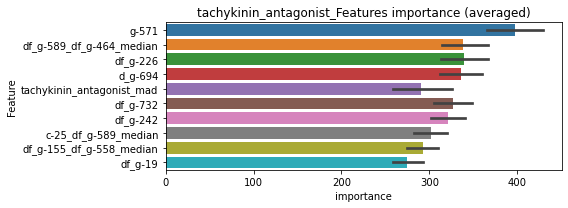

len(train_index) : 2808
len(valid_index) : 937
================================= fold 1/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118027	valid_1's binary_logloss: 0.178245
[200]	training's binary_logloss: 0.0451393	valid_1's binary_logloss: 0.103934
[300]	training's binary_logloss: 0.0198574	valid_1's binary_logloss: 0.0709729
[400]	training's binary_logloss: 0.009176	valid_1's binary_logloss: 0.0546008
[500]	training's binary_logloss: 0.00472688	valid_1's binary_logloss: 0.0463411
[600]	training's binary_logloss: 0.00277992	valid_1's binary_logloss: 0.0425251
[700]	training's binary_logloss: 0.0018607	valid_1's binary_logloss: 0.0405372
[800]	training's binary_logloss: 0.00138214	valid_1's binary_logloss: 0.0394194
[900]	training's binary_logloss: 0.00110398	valid_1's binary_logloss: 0.0381542
Early stopping, best iteration is:
[877]	training's binary_logloss: 0.00115743	valid_1's binary_logloss: 0.0379781


len(train_index) : 2809
len(valid_index) : 936
================================= fold 2/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12385	valid_1's binary_logloss: 0.175157
[200]	training's binary_logloss: 0.0470908	valid_1's binary_logloss: 0.095564
[300]	training's binary_logloss: 0.0201344	valid_1's binary_logloss: 0.0591726
[400]	training's binary_logloss: 0.00927708	valid_1's binary_logloss: 0.0425496
[500]	training's binary_logloss: 0.00476132	valid_1's binary_logloss: 0.0331627
[600]	training's binary_logloss: 0.00278614	valid_1's binary_logloss: 0.0279969
[700]	training's binary_logloss: 0.00186479	valid_1's binary_logloss: 0.0249546
[800]	training's binary_logloss: 0.00138034	valid_1's binary_logloss: 0.02332
[900]	training's binary_logloss: 0.00110377	valid_1's binary_logloss: 0.0220274
[1000]	training's binary_logloss: 0.000950463	valid_1's binary_logloss: 0.0215029
[1100]	training's binary_logloss: 0.000857147	valid_1's binary_logloss: 0.0211339
Early stopping, best iteration is:
[1075]	training's binary_logl

len(train_index) : 2809
len(valid_index) : 936
================================= fold 3/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119519	valid_1's binary_logloss: 0.168311
[200]	training's binary_logloss: 0.0470391	valid_1's binary_logloss: 0.0918549
[300]	training's binary_logloss: 0.0208145	valid_1's binary_logloss: 0.0590598
[400]	training's binary_logloss: 0.00930574	valid_1's binary_logloss: 0.041538
[500]	training's binary_logloss: 0.00474027	valid_1's binary_logloss: 0.032358
[600]	training's binary_logloss: 0.00281407	valid_1's binary_logloss: 0.0282472
[700]	training's binary_logloss: 0.00187576	valid_1's binary_logloss: 0.0259052
[800]	training's binary_logloss: 0.00138834	valid_1's binary_logloss: 0.0245514
[900]	training's binary_logloss: 0.00110744	valid_1's binary_logloss: 0.023833
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00109342	valid_1's binary_logloss: 0.0237481


len(train_index) : 2809
len(valid_index) : 936
================================= fold 4/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117977	valid_1's binary_logloss: 0.164652
[200]	training's binary_logloss: 0.0448178	valid_1's binary_logloss: 0.0918324
[300]	training's binary_logloss: 0.0187611	valid_1's binary_logloss: 0.0586249
[400]	training's binary_logloss: 0.00873545	valid_1's binary_logloss: 0.0425038
[500]	training's binary_logloss: 0.00451392	valid_1's binary_logloss: 0.0346208
[600]	training's binary_logloss: 0.00269758	valid_1's binary_logloss: 0.0307054
[700]	training's binary_logloss: 0.00182068	valid_1's binary_logloss: 0.0284881
[800]	training's binary_logloss: 0.00136565	valid_1's binary_logloss: 0.0273491
[900]	training's binary_logloss: 0.00109062	valid_1's binary_logloss: 0.0266985
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.00102183	valid_1's binary_logloss: 0.0263456


tachykinin_antagonist logloss: 0.027295947798530597
tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3285, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103434	valid_1's binary_logloss: 0.135828
[200]	training's binary_logloss: 0.0373956	valid_1's binary_logloss: 0.0666786
[300]	training's binary_logloss: 0.0145137	valid_1's binary_logloss: 0.0382024
[400]	training's binary_logloss: 0.00612333	valid_1's binary_logloss: 0.0250899
[500]	training's binary_logloss: 0.00303731	valid_1's binary_logloss: 0.019109
[600]	training's binary_logloss: 0.00182124	valid_1's binary_logloss: 0.0158061
[700]	training's binary_logloss: 0.00126828	valid_1's binary_logloss: 0.014276
[800]	training's binary_logloss: 0.000972391	valid_1's binary_logloss: 0.0133193
[900]	training's binary_logloss: 0.000799511	valid_1's binary_logloss: 0.0127397
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.000750871	valid_1's binary_logloss: 0.0126388
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102003	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0154186, Threshold: 0.0863824, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.06047, conf_1:0.11230
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0863824
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_2: 0.1163824
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_3: 0.1463824
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_4: 0.1763824
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_5: 0.2063824
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_6: 0.2363824
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_7: 0.2663824
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.2963824
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_9: 0.3263824
threshold: 0.3263824, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102347	valid_1's binary_logloss: 0.136475
[200]	training's binary_logloss: 0.0339593	valid_1's binary_logloss: 0.0613304
[300]	training's binary_logloss: 0.0129298	valid_1's binary_logloss: 0.0323427
[400]	training's binary_logloss: 0.00524826	valid_1's binary_logloss: 0.019285
[500]	training's binary_logloss: 0.00262168	valid_1's binary_logloss: 0.0138309
[600]	training's binary_logloss: 0.00160044	valid_1's binary_logloss: 0.011336
[700]	training's binary_logloss: 0.00111906	valid_1's binary_logloss: 0.0100015
[800]	training's binary_logloss: 0.000867048	valid_1's binary_logloss: 0.00930341
[900]	training's binary_logloss: 0.000724026	valid_1's binary_logloss: 0.0088871
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000692149	valid_1's binary_logloss: 0.00878785
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0993337	va

2 / 3 AUC score:1.000
y_Threshold: 0.1825350, Threshold: 0.3263824, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0080362 Vs.target_rate: 0.00126, Num_p_label: 32.0, conf_0:0.26111, conf_1:0.39166
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_1: 0.3263824
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_2: 0.3563824
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_3: 0.3863824
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_4: 0.4163824
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_5: 0.4463824
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_6: 0.4763824
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_7: 0.5063824
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_8: 0.5363824
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_9: 0.5663824
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_10: 0.5963824
threshold: 0.6263824, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 652.0/3800, y_label_rate: 0.1715789
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101506	valid_1's binary_logloss: 0.131591
[200]	training's binary_logloss: 0.0343044	valid_1's binary_logloss: 0.0570016
[300]	training's binary_logloss: 0.0129389	valid_1's binary_logloss: 0.0296564
[400]	training's binary_logloss: 0.00530846	valid_1's binary_logloss: 0.0175099
[500]	training's binary_logloss: 0.00268335	valid_1's binary_logloss: 0.0127026
[600]	training's binary_logloss: 0.00161282	valid_1's binary_logloss: 0.0103789
[700]	training's binary_logloss: 0.00112285	valid_1's binary_logloss: 0.00909927
[800]	training's binary_logloss: 0.000860491	valid_1's binary_logloss: 0.00848593
[900]	training's binary_logloss: 0.000711421	valid_1's binary_logloss: 0.0081515
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000721773	valid_1's binary_logloss: 0.00813792
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0988074

3 / 3 AUC score:1.000
y_Threshold: 0.1627096, Threshold: 0.6263824, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 647.0/3790
p_label_rate: 0.0047715 Vs.target_rate: 0.00126, Num_p_label: 19.0, conf_0:0.50000, conf_1:0.68902
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.6263824
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_2: 0.6563824
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_3: 0.6863824
threshold: 0.6863824, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 647.0/3790, y_label_rate: 0.1707124


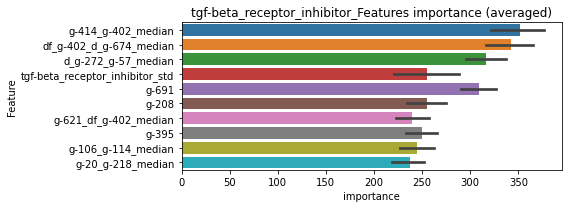

len(train_index) : 2842
len(valid_index) : 948
================================= fold 1/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0995764	valid_1's binary_logloss: 0.124906
[200]	training's binary_logloss: 0.0343434	valid_1's binary_logloss: 0.0519362
[300]	training's binary_logloss: 0.0124869	valid_1's binary_logloss: 0.0237412
[400]	training's binary_logloss: 0.00512506	valid_1's binary_logloss: 0.0119538
[500]	training's binary_logloss: 0.00258327	valid_1's binary_logloss: 0.00738735
[600]	training's binary_logloss: 0.00157473	valid_1's binary_logloss: 0.00520565
[700]	training's binary_logloss: 0.00109839	valid_1's binary_logloss: 0.00412958
[800]	training's binary_logloss: 0.000849977	valid_1's binary_logloss: 0.0034443
[900]	training's binary_logloss: 0.000708068	valid_1's binary_logloss: 0.00305298
[1000]	training's binary_logloss: 0.000635742	valid_1's binary_logloss: 0.00283606
Early stopping, best iteration is:
[1015]	training's binary_logloss: 0.00062979	valid_1's binary_logloss: 0.00281702


len(train_index) : 2842
len(valid_index) : 948
================================= fold 2/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0956686	valid_1's binary_logloss: 0.138514
[200]	training's binary_logloss: 0.0317883	valid_1's binary_logloss: 0.0661388
[300]	training's binary_logloss: 0.011355	valid_1's binary_logloss: 0.0355381
[400]	training's binary_logloss: 0.00473097	valid_1's binary_logloss: 0.0222254
[500]	training's binary_logloss: 0.00238959	valid_1's binary_logloss: 0.0158146
[600]	training's binary_logloss: 0.00145974	valid_1's binary_logloss: 0.0128126
[700]	training's binary_logloss: 0.00103216	valid_1's binary_logloss: 0.0110432
[800]	training's binary_logloss: 0.000802711	valid_1's binary_logloss: 0.0100748
[900]	training's binary_logloss: 0.000676042	valid_1's binary_logloss: 0.00965228
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.000654165	valid_1's binary_logloss: 0.00950713


len(train_index) : 2843
len(valid_index) : 947
================================= fold 3/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0965117	valid_1's binary_logloss: 0.13973
[200]	training's binary_logloss: 0.0325411	valid_1's binary_logloss: 0.0690526
[300]	training's binary_logloss: 0.0115217	valid_1's binary_logloss: 0.0369351
[400]	training's binary_logloss: 0.00477085	valid_1's binary_logloss: 0.0238721
[500]	training's binary_logloss: 0.00241249	valid_1's binary_logloss: 0.0177864
[600]	training's binary_logloss: 0.00148552	valid_1's binary_logloss: 0.0151304
[700]	training's binary_logloss: 0.00105379	valid_1's binary_logloss: 0.0134325
[800]	training's binary_logloss: 0.000817655	valid_1's binary_logloss: 0.0121037
[900]	training's binary_logloss: 0.000686393	valid_1's binary_logloss: 0.011547
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.00067855	valid_1's binary_logloss: 0.0114968


len(train_index) : 2843
len(valid_index) : 947
================================= fold 4/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0967653	valid_1's binary_logloss: 0.130149
[200]	training's binary_logloss: 0.0327561	valid_1's binary_logloss: 0.0619677
[300]	training's binary_logloss: 0.011713	valid_1's binary_logloss: 0.0334977
[400]	training's binary_logloss: 0.0048135	valid_1's binary_logloss: 0.0220243
[500]	training's binary_logloss: 0.00243329	valid_1's binary_logloss: 0.01753
[600]	training's binary_logloss: 0.0014889	valid_1's binary_logloss: 0.0152384
[700]	training's binary_logloss: 0.00105728	valid_1's binary_logloss: 0.0140897
[800]	training's binary_logloss: 0.000821687	valid_1's binary_logloss: 0.0136855
Early stopping, best iteration is:
[771]	training's binary_logloss: 0.000876068	valid_1's binary_logloss: 0.0136537


tgf-beta_receptor_inhibitor logloss: 0.00936696617487975
thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0854543	valid_1's binary_logloss: 0.105702
[200]	training's binary_logloss: 0.0260095	valid_1's binary_logloss: 0.0419674
[300]	training's binary_logloss: 0.00890217	valid_1's binary_logloss: 0.019921
[400]	training's binary_logloss: 0.0035127	valid_1's binary_logloss: 0.0109307
[500]	training's binary_logloss: 0.00178675	valid_1's binary_logloss: 0.00728372
[600]	training's binary_logloss: 0.00110634	valid_1's binary_logloss: 0.00571316
[700]	training's binary_logloss: 0.000793801	valid_1's binary_logloss: 0.00481178
[800]	training's binary_logloss: 0.000623204	valid_1's binary_logloss: 0.00431869
[900]	training's binary_logloss: 0.000545431	valid_1's binary_logloss: 0.0040645
Early stopping, best iteration is:
[963]	training's binary_logloss: 0.000514668	valid_1's binary_logloss: 0.00396432
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0857

1 / 3 AUC score:1.000
y_Threshold: 0.0071693, Threshold: 0.0252958, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.01771, conf_1:0.03288
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0252958
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_2: 0.0552958
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_3: 0.0852958
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.1152958
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.1452958
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_6: 0.1752958
threshold: 0.1752958, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0812528	valid_1's binary_logloss: 0.101625
[200]	training's binary_logloss: 0.0226683	valid_1's binary_logloss: 0.0359761
[300]	training's binary_logloss: 0.00729151	valid_1's binary_logloss: 0.0154561
[400]	training's binary_logloss: 0.00289076	valid_1's binary_logloss: 0.00808936
[500]	training's binary_logloss: 0.00150929	valid_1's binary_logloss: 0.00512262
[600]	training's binary_logloss: 0.000963385	valid_1's binary_logloss: 0.00378465
[700]	training's binary_logloss: 0.000696558	valid_1's binary_logloss: 0.00312647
[800]	training's binary_logloss: 0.000556214	valid_1's binary_logloss: 0.00268133
[900]	training's binary_logloss: 0.000485379	valid_1's binary_logloss: 0.00245185
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.000470848	valid_1's binary_logloss: 0.00240921
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0842921, Threshold: 0.1752958, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00080, Num_p_label: 15.0, conf_0:0.14024, conf_1:0.21035
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_1: 0.1752958
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.2052958
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.2352958
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.2652958
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_5: 0.2952958
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.3252958
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.3552958
threshold: 0.3552958, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0812528	valid_1's binary_logloss: 0.101625
[200]	training's binary_logloss: 0.0226683	valid_1's binary_logloss: 0.0359761
[300]	training's binary_logloss: 0.00729151	valid_1's binary_logloss: 0.0154561
[400]	training's binary_logloss: 0.00289076	valid_1's binary_logloss: 0.00808936
[500]	training's binary_logloss: 0.00150929	valid_1's binary_logloss: 0.00512262
[600]	training's binary_logloss: 0.000963385	valid_1's binary_logloss: 0.00378465
[700]	training's binary_logloss: 0.000696558	valid_1's binary_logloss: 0.00312647
[800]	training's binary_logloss: 0.000556214	valid_1's binary_logloss: 0.00268133
[900]	training's binary_logloss: 0.000485379	valid_1's binary_logloss: 0.00245185
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.000470848	valid_1's binary_logloss: 0.00240921
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0842921, Threshold: 0.3552958, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.31977, conf_1:0.39083
threshold: 0.3552958, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


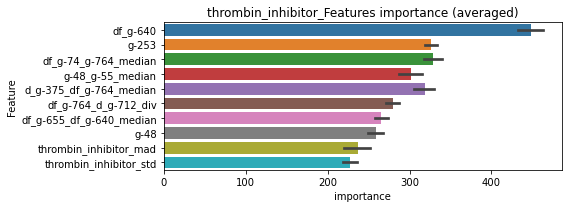

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0819805	valid_1's binary_logloss: 0.100482
[200]	training's binary_logloss: 0.0226672	valid_1's binary_logloss: 0.0354067
[300]	training's binary_logloss: 0.00725585	valid_1's binary_logloss: 0.0150258
[400]	training's binary_logloss: 0.00291824	valid_1's binary_logloss: 0.00797942
[500]	training's binary_logloss: 0.00152083	valid_1's binary_logloss: 0.00511365
[600]	training's binary_logloss: 0.00096117	valid_1's binary_logloss: 0.00383802
[700]	training's binary_logloss: 0.000694813	valid_1's binary_logloss: 0.00315449
[800]	training's binary_logloss: 0.00054931	valid_1's binary_logloss: 0.00266746
[900]	training's binary_logloss: 0.000477696	valid_1's binary_logloss: 0.0024598
[1000]	training's binary_logloss: 0.000460288	valid_1's binary_logloss: 0.00240841
Early stopping, best iteration is:
[983]	training's binary_logloss: 0.000460288	valid_1's binary_logloss: 0.00240841


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0813982	valid_1's binary_logloss: 0.115039
[200]	training's binary_logloss: 0.0228957	valid_1's binary_logloss: 0.0461887
[300]	training's binary_logloss: 0.00722557	valid_1's binary_logloss: 0.0220041
[400]	training's binary_logloss: 0.00284283	valid_1's binary_logloss: 0.0131826
[500]	training's binary_logloss: 0.00147017	valid_1's binary_logloss: 0.00999083
[600]	training's binary_logloss: 0.000921252	valid_1's binary_logloss: 0.00882231
[700]	training's binary_logloss: 0.000669953	valid_1's binary_logloss: 0.00792937
[800]	training's binary_logloss: 0.000536692	valid_1's binary_logloss: 0.00748308
[900]	training's binary_logloss: 0.0004733	valid_1's binary_logloss: 0.00738502
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.000463611	valid_1's binary_logloss: 0.00735482


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828004	valid_1's binary_logloss: 0.0986749
[200]	training's binary_logloss: 0.0232292	valid_1's binary_logloss: 0.0330841
[300]	training's binary_logloss: 0.0074429	valid_1's binary_logloss: 0.0132837
[400]	training's binary_logloss: 0.00295796	valid_1's binary_logloss: 0.00642828
[500]	training's binary_logloss: 0.00153168	valid_1's binary_logloss: 0.00390997
[600]	training's binary_logloss: 0.000966836	valid_1's binary_logloss: 0.00273618
[700]	training's binary_logloss: 0.000702253	valid_1's binary_logloss: 0.0021396
[800]	training's binary_logloss: 0.000557254	valid_1's binary_logloss: 0.00179896
[900]	training's binary_logloss: 0.000485424	valid_1's binary_logloss: 0.00161788
[1000]	training's binary_logloss: 0.00046473	valid_1's binary_logloss: 0.00156443
Early stopping, best iteration is:
[1038]	training's binary_logloss: 0.000461837	valid_1's binary_logloss: 0.00155747


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0809115	valid_1's binary_logloss: 0.0996911
[200]	training's binary_logloss: 0.0226038	valid_1's binary_logloss: 0.0360742
[300]	training's binary_logloss: 0.00720216	valid_1's binary_logloss: 0.0162296
[400]	training's binary_logloss: 0.00290552	valid_1's binary_logloss: 0.00876346
[500]	training's binary_logloss: 0.00150542	valid_1's binary_logloss: 0.00569642
[600]	training's binary_logloss: 0.000957235	valid_1's binary_logloss: 0.00433867
[700]	training's binary_logloss: 0.000695574	valid_1's binary_logloss: 0.00362673
[800]	training's binary_logloss: 0.000555096	valid_1's binary_logloss: 0.00318212
[900]	training's binary_logloss: 0.000481238	valid_1's binary_logloss: 0.00289462
[1000]	training's binary_logloss: 0.000456273	valid_1's binary_logloss: 0.00284753
Early stopping, best iteration is:
[986]	training's binary_logloss: 0.000457097	valid_1's binary_logloss: 0.00284576


thrombin_inhibitor logloss: 0.0035422406181308368
thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110392	valid_1's binary_logloss: 0.158828
[200]	training's binary_logloss: 0.042646	valid_1's binary_logloss: 0.0869755
[300]	training's binary_logloss: 0.017775	valid_1's binary_logloss: 0.0539096
[400]	training's binary_logloss: 0.00765514	valid_1's binary_logloss: 0.0367092
[500]	training's binary_logloss: 0.00374071	valid_1's binary_logloss: 0.0281523
[600]	training's binary_logloss: 0.00217484	valid_1's binary_logloss: 0.0240513
[700]	training's binary_logloss: 0.00147889	valid_1's binary_logloss: 0.0217565
[800]	training's binary_logloss: 0.00111738	valid_1's binary_logloss: 0.0202906
[900]	training's binary_logloss: 0.000904251	valid_1's binary_logloss: 0.0195857
[1000]	training's binary_logloss: 0.000780292	valid_1's binary_logloss: 0.0191224
Early stopping, best iteration is:
[1031]	training's binary_logloss: 0.000757071	valid_1's binary_logloss: 0.0189983
Training until validation 

1 / 3 AUC score:1.000
y_Threshold: 0.0119401, Threshold: 0.0814147, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.05699, conf_1:0.10584
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0814147
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_2: 0.1114147
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_3: 0.1414147
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_4: 0.1714147
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_5: 0.2014147
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_6: 0.2314147
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_7: 0.2614147
threshold: 0.2614147, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111444	valid_1's binary_logloss: 0.144732
[200]	training's binary_logloss: 0.0409792	valid_1's binary_logloss: 0.067019
[300]	training's binary_logloss: 0.0161484	valid_1's binary_logloss: 0.0344072
[400]	training's binary_logloss: 0.00687497	valid_1's binary_logloss: 0.0194938
[500]	training's binary_logloss: 0.00343692	valid_1's binary_logloss: 0.0126686
[600]	training's binary_logloss: 0.00202275	valid_1's binary_logloss: 0.0093869
[700]	training's binary_logloss: 0.0013652	valid_1's binary_logloss: 0.00756674
[800]	training's binary_logloss: 0.00103442	valid_1's binary_logloss: 0.00653716
[900]	training's binary_logloss: 0.000845052	valid_1's binary_logloss: 0.00598875
[1000]	training's binary_logloss: 0.000753632	valid_1's binary_logloss: 0.00563791
[1100]	training's binary_logloss: 0.000717845	valid_1's binary_logloss: 0.00555105
[1200]	training's binary_logloss: 0.000691518	valid_1's 

2 / 3 AUC score:1.000
y_Threshold: 0.1042417, Threshold: 0.2614147, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0130588 Vs.target_rate: 0.00155, Num_p_label: 52.0, conf_0:0.20913, conf_1:0.31370
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_1: 0.2614147
Num_p_label: 49.0, Expected: 6.2, Adj_threshold_2: 0.2914147
Num_p_label: 47.0, Expected: 6.2, Adj_threshold_3: 0.3214147
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_4: 0.3514147
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_5: 0.3814147
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_6: 0.4114147
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_7: 0.4414147
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_8: 0.4714147
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_9: 0.5014147
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_10: 0.5314147
threshold: 0.5614147, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104259	valid_1's binary_logloss: 0.164444
[200]	training's binary_logloss: 0.0354708	valid_1's binary_logloss: 0.0939902
[300]	training's binary_logloss: 0.0139923	valid_1's binary_logloss: 0.0683984
[400]	training's binary_logloss: 0.00603928	valid_1's binary_logloss: 0.0573406
[500]	training's binary_logloss: 0.00305074	valid_1's binary_logloss: 0.0536385
[600]	training's binary_logloss: 0.00181053	valid_1's binary_logloss: 0.0529022
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00203508	valid_1's binary_logloss: 0.0525559
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109	valid_1's binary_logloss: 0.146041
[200]	training's binary_logloss: 0.0398207	valid_1's binary_logloss: 0.07169
[300]	training's binary_logloss: 0.0154982	valid_1's binary_logloss: 0.0391286
[400]	training's binary_logloss: 0.00656835	valid_1's bina

3 / 3 AUC score:0.997
y_Threshold: 0.1261578, Threshold: 0.5614147, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 645.0/3784
p_label_rate: 0.0052737 Vs.target_rate: 0.00155, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.61756
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.5614147
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_2: 0.5914147
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_3: 0.6214147
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_4: 0.6514147
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_5: 0.6814147
threshold: 0.6814147, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 645.0/3784, y_label_rate: 0.1704545


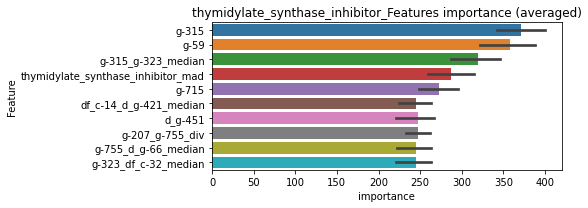

len(train_index) : 2838
len(valid_index) : 946
================================= fold 1/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105641	valid_1's binary_logloss: 0.150645
[200]	training's binary_logloss: 0.0365463	valid_1's binary_logloss: 0.0735565
[300]	training's binary_logloss: 0.0138236	valid_1's binary_logloss: 0.0430415
[400]	training's binary_logloss: 0.00590422	valid_1's binary_logloss: 0.029506
[500]	training's binary_logloss: 0.00294489	valid_1's binary_logloss: 0.0230889
[600]	training's binary_logloss: 0.00177131	valid_1's binary_logloss: 0.0201952
[700]	training's binary_logloss: 0.00122902	valid_1's binary_logloss: 0.0187503
[800]	training's binary_logloss: 0.000934623	valid_1's binary_logloss: 0.0181004
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000925222	valid_1's binary_logloss: 0.0180466


len(train_index) : 2838
len(valid_index) : 946
================================= fold 2/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105382	valid_1's binary_logloss: 0.151831
[200]	training's binary_logloss: 0.0380037	valid_1's binary_logloss: 0.0777142
[300]	training's binary_logloss: 0.01528	valid_1's binary_logloss: 0.0461693
[400]	training's binary_logloss: 0.00633292	valid_1's binary_logloss: 0.0297425
[500]	training's binary_logloss: 0.00311565	valid_1's binary_logloss: 0.022491
[600]	training's binary_logloss: 0.00184599	valid_1's binary_logloss: 0.0179235
[700]	training's binary_logloss: 0.0012649	valid_1's binary_logloss: 0.0156322
[800]	training's binary_logloss: 0.000971258	valid_1's binary_logloss: 0.0143657
[900]	training's binary_logloss: 0.000797374	valid_1's binary_logloss: 0.0133214
[1000]	training's binary_logloss: 0.000710127	valid_1's binary_logloss: 0.01284
[1100]	training's binary_logloss: 0.000674617	valid_1's binary_logloss: 0.0126836
Early stopping, best iteration is:
[1080]	training's binary_logl

len(train_index) : 2838
len(valid_index) : 946
================================= fold 3/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109284	valid_1's binary_logloss: 0.145382
[200]	training's binary_logloss: 0.0399285	valid_1's binary_logloss: 0.0728937
[300]	training's binary_logloss: 0.0156909	valid_1's binary_logloss: 0.0430814
[400]	training's binary_logloss: 0.00663925	valid_1's binary_logloss: 0.0283681
[500]	training's binary_logloss: 0.00322628	valid_1's binary_logloss: 0.0208081
[600]	training's binary_logloss: 0.00190611	valid_1's binary_logloss: 0.0171077
[700]	training's binary_logloss: 0.00129241	valid_1's binary_logloss: 0.015134
[800]	training's binary_logloss: 0.000975534	valid_1's binary_logloss: 0.013856
[900]	training's binary_logloss: 0.000801355	valid_1's binary_logloss: 0.0133299
[1000]	training's binary_logloss: 0.000708409	valid_1's binary_logloss: 0.012906
[1100]	training's binary_logloss: 0.00066278	valid_1's binary_logloss: 0.012771
Early stopping, best iteration is:
[1086]	training's binary_log

len(train_index) : 2838
len(valid_index) : 946
================================= fold 4/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109456	valid_1's binary_logloss: 0.141129
[200]	training's binary_logloss: 0.0388246	valid_1's binary_logloss: 0.0657456
[300]	training's binary_logloss: 0.0153421	valid_1's binary_logloss: 0.0367268
[400]	training's binary_logloss: 0.00639245	valid_1's binary_logloss: 0.0226737
[500]	training's binary_logloss: 0.00310173	valid_1's binary_logloss: 0.0160494
[600]	training's binary_logloss: 0.00183857	valid_1's binary_logloss: 0.0136174
[700]	training's binary_logloss: 0.00126734	valid_1's binary_logloss: 0.0121209
[800]	training's binary_logloss: 0.000963441	valid_1's binary_logloss: 0.0112262
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000848175	valid_1's binary_logloss: 0.010904


thymidylate_synthase_inhibitor logloss: 0.013601459414419571


neg labels: 3289 → selected neg labels: 3282


tlr_agonist, len(trt): 30, len(othr): 3282, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.094745	valid_1's binary_logloss: 0.119004
[200]	training's binary_logloss: 0.0324	valid_1's binary_logloss: 0.0528475
[300]	training's binary_logloss: 0.0124127	valid_1's binary_logloss: 0.0290133
[400]	training's binary_logloss: 0.00519264	valid_1's binary_logloss: 0.0185699
[500]	training's binary_logloss: 0.00255475	valid_1's binary_logloss: 0.0133254
[600]	training's binary_logloss: 0.0015268	valid_1's binary_logloss: 0.0107368
[700]	training's binary_logloss: 0.00105334	valid_1's binary_logloss: 0.00935504
[800]	training's binary_logloss: 0.000806474	valid_1's binary_logloss: 0.00861233
[900]	training's binary_logloss: 0.000673953	valid_1's binary_logloss: 0.00818848
Early stopping, best iteration is:
[953]	training's binary_logloss: 0.000627591	valid_1's binary_logloss: 0.00809639
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0928329	va

1 / 3 AUC score:1.000
y_Threshold: 0.0111905, Threshold: 0.0571165, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.03998, conf_1:0.07425
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0571165
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_2: 0.0871165
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_3: 0.1171165
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_4: 0.1471165
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.1771165
threshold: 0.1771165, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0930223	valid_1's binary_logloss: 0.122517
[200]	training's binary_logloss: 0.0284791	valid_1's binary_logloss: 0.0524768
[300]	training's binary_logloss: 0.0102684	valid_1's binary_logloss: 0.0283718
[400]	training's binary_logloss: 0.00416882	valid_1's binary_logloss: 0.0178421
[500]	training's binary_logloss: 0.00209389	valid_1's binary_logloss: 0.0127604
[600]	training's binary_logloss: 0.00127577	valid_1's binary_logloss: 0.00999014
[700]	training's binary_logloss: 0.000892302	valid_1's binary_logloss: 0.00868534
[800]	training's binary_logloss: 0.000696642	valid_1's binary_logloss: 0.00795822
[900]	training's binary_logloss: 0.000589914	valid_1's binary_logloss: 0.00758918
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.000570097	valid_1's binary_logloss: 0.0074855
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0913

2 / 3 AUC score:1.000
y_Threshold: 0.0986236, Threshold: 0.1771165, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0097941 Vs.target_rate: 0.00126, Num_p_label: 39.0, conf_0:0.14169, conf_1:0.21254
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_1: 0.1771165
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_2: 0.2071165
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_3: 0.2371165
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_4: 0.2671165
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_5: 0.2971165
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_6: 0.3271165
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_7: 0.3571165
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_8: 0.3871165
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_9: 0.4171165
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_10: 0.4471165
threshold: 0.4771165, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0928621	valid_1's binary_logloss: 0.114683
[200]	training's binary_logloss: 0.0294313	valid_1's binary_logloss: 0.0465046
[300]	training's binary_logloss: 0.0103404	valid_1's binary_logloss: 0.022294
[400]	training's binary_logloss: 0.0041896	valid_1's binary_logloss: 0.0121754
[500]	training's binary_logloss: 0.00208154	valid_1's binary_logloss: 0.00767042
[600]	training's binary_logloss: 0.00127154	valid_1's binary_logloss: 0.00565699
[700]	training's binary_logloss: 0.000893058	valid_1's binary_logloss: 0.00477111
[800]	training's binary_logloss: 0.000690858	valid_1's binary_logloss: 0.004137
[900]	training's binary_logloss: 0.00057753	valid_1's binary_logloss: 0.00374134
[1000]	training's binary_logloss: 0.00054061	valid_1's binary_logloss: 0.0036378
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.00054061	valid_1's binary_logloss: 0.0036378
Training until validatio

3 / 3 AUC score:1.000
y_Threshold: 0.0500733, Threshold: 0.4771165, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 652.0/3798
p_label_rate: 0.0035158 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.42940, conf_1:0.52483
threshold: 0.4771165, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 652.0/3798, y_label_rate: 0.1716693


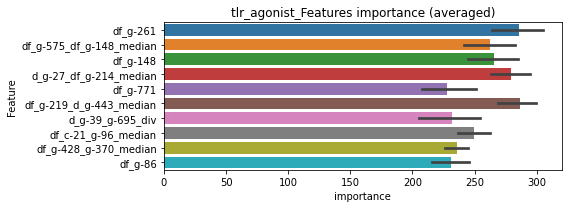

len(train_index) : 2848
len(valid_index) : 950
================================= fold 1/4 tlr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.090699	valid_1's binary_logloss: 0.12152
[200]	training's binary_logloss: 0.0285082	valid_1's binary_logloss: 0.0505873
[300]	training's binary_logloss: 0.0100404	valid_1's binary_logloss: 0.0252938
[400]	training's binary_logloss: 0.00409567	valid_1's binary_logloss: 0.0147891
[500]	training's binary_logloss: 0.00202626	valid_1's binary_logloss: 0.00972509
[600]	training's binary_logloss: 0.0012438	valid_1's binary_logloss: 0.00731471
[700]	training's binary_logloss: 0.000878262	valid_1's binary_logloss: 0.00599414
[800]	training's binary_logloss: 0.000685834	valid_1's binary_logloss: 0.00537968
[900]	training's binary_logloss: 0.000576656	valid_1's binary_logloss: 0.00505761
[1000]	training's binary_logloss: 0.000543927	valid_1's binary_logloss: 0.00497711
Early stopping, best iteration is:
[1022]	training's binary_logloss: 0.000539804	valid_1's binary_logloss: 0.00493673


len(train_index) : 2848
len(valid_index) : 950
================================= fold 2/4 tlr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0917559	valid_1's binary_logloss: 0.108595
[200]	training's binary_logloss: 0.0274335	valid_1's binary_logloss: 0.0432168
[300]	training's binary_logloss: 0.00972247	valid_1's binary_logloss: 0.0218692
[400]	training's binary_logloss: 0.00397432	valid_1's binary_logloss: 0.0131957
[500]	training's binary_logloss: 0.00200765	valid_1's binary_logloss: 0.00960273
[600]	training's binary_logloss: 0.00122583	valid_1's binary_logloss: 0.00765228
[700]	training's binary_logloss: 0.000865332	valid_1's binary_logloss: 0.00679944
[800]	training's binary_logloss: 0.000675256	valid_1's binary_logloss: 0.00628322
[900]	training's binary_logloss: 0.000576757	valid_1's binary_logloss: 0.0060649
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.000561032	valid_1's binary_logloss: 0.00603693


len(train_index) : 2849
len(valid_index) : 949
================================= fold 3/4 tlr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0902646	valid_1's binary_logloss: 0.116788
[200]	training's binary_logloss: 0.0271498	valid_1's binary_logloss: 0.0491831
[300]	training's binary_logloss: 0.00966289	valid_1's binary_logloss: 0.0250774
[400]	training's binary_logloss: 0.00390787	valid_1's binary_logloss: 0.0154673
[500]	training's binary_logloss: 0.00198768	valid_1's binary_logloss: 0.0112066
[600]	training's binary_logloss: 0.00122341	valid_1's binary_logloss: 0.00918276
[700]	training's binary_logloss: 0.000865216	valid_1's binary_logloss: 0.00815115
[800]	training's binary_logloss: 0.000673731	valid_1's binary_logloss: 0.00745264
[900]	training's binary_logloss: 0.000574682	valid_1's binary_logloss: 0.00710762
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.000564275	valid_1's binary_logloss: 0.00704081


len(train_index) : 2849
len(valid_index) : 949
================================= fold 4/4 tlr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0897511	valid_1's binary_logloss: 0.121096
[200]	training's binary_logloss: 0.0274193	valid_1's binary_logloss: 0.0503434
[300]	training's binary_logloss: 0.00969493	valid_1's binary_logloss: 0.0263727
[400]	training's binary_logloss: 0.00393209	valid_1's binary_logloss: 0.0159253
[500]	training's binary_logloss: 0.00198365	valid_1's binary_logloss: 0.0120548
[600]	training's binary_logloss: 0.00120958	valid_1's binary_logloss: 0.0101484
[700]	training's binary_logloss: 0.000852375	valid_1's binary_logloss: 0.00932472
[800]	training's binary_logloss: 0.000669894	valid_1's binary_logloss: 0.00883267
[900]	training's binary_logloss: 0.000573237	valid_1's binary_logloss: 0.00858555
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.000569944	valid_1's binary_logloss: 0.00857059


tlr_agonist logloss: 0.00665085508101318
tlr_antagonist, len(trt): 7, len(othr): 3289, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0500774	valid_1's binary_logloss: 0.0556799
[200]	training's binary_logloss: 0.00932866	valid_1's binary_logloss: 0.0120283
[300]	training's binary_logloss: 0.00229833	valid_1's binary_logloss: 0.00356212
[400]	training's binary_logloss: 0.000859952	valid_1's binary_logloss: 0.00152763
[500]	training's binary_logloss: 0.0004716	valid_1's binary_logloss: 0.000942634
[600]	training's binary_logloss: 0.000326692	valid_1's binary_logloss: 0.00069113
[700]	training's binary_logloss: 0.000264534	valid_1's binary_logloss: 0.000580583
[800]	training's binary_logloss: 0.000248796	valid_1's binary_logloss: 0.000558947
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.000248081	valid_1's binary_logloss: 0.000557269
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0500305	valid_1's binary_logloss: 0.0576991
[200]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0010990, Threshold: 0.0065690, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.00460, conf_1:0.00854
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.0065690
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.0365690
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.0665690
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_4: 0.0965690
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_5: 0.1265690
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.1565690
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.1865690
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.2165690
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.2465690
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_10: 0.2765690
threshold: 0.2765690, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Ps

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.049081	valid_1's binary_logloss: 0.0543163
[200]	training's binary_logloss: 0.0084431	valid_1's binary_logloss: 0.0115483
[300]	training's binary_logloss: 0.00197173	valid_1's binary_logloss: 0.00372742
[400]	training's binary_logloss: 0.000717968	valid_1's binary_logloss: 0.00186361
[500]	training's binary_logloss: 0.000394051	valid_1's binary_logloss: 0.00134377
[600]	training's binary_logloss: 0.000274619	valid_1's binary_logloss: 0.00110098
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00024958	valid_1's binary_logloss: 0.00104323
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0489355	valid_1's binary_logloss: 0.0554458
[200]	training's binary_logloss: 0.00838112	valid_1's binary_logloss: 0.011847
[300]	training's binary_logloss: 0.00194351	valid_1's binary_logloss: 0.0037919
[400]	training's binary_logloss: 0.00070

2 / 3 AUC score:1.000
y_Threshold: 0.1002438, Threshold: 0.2765690, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00029, Num_p_label: 6.0, conf_0:0.22126, conf_1:0.33188
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_1: 0.2765690
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.3065690
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.3365690
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_4: 0.3665690
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_5: 0.3965690
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_6: 0.4265690
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_7: 0.4565690
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_8: 0.4865690
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_9: 0.5165690
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_10: 0.5465690
threshold: 0.5765690, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseu

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.049081	valid_1's binary_logloss: 0.0543163
[200]	training's binary_logloss: 0.0084431	valid_1's binary_logloss: 0.0115483
[300]	training's binary_logloss: 0.00197173	valid_1's binary_logloss: 0.00372742
[400]	training's binary_logloss: 0.000717968	valid_1's binary_logloss: 0.00186361
[500]	training's binary_logloss: 0.000394051	valid_1's binary_logloss: 0.00134377
[600]	training's binary_logloss: 0.000274619	valid_1's binary_logloss: 0.00110098
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00024958	valid_1's binary_logloss: 0.00104323
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0489355	valid_1's binary_logloss: 0.0554458
[200]	training's binary_logloss: 0.00838112	valid_1's binary_logloss: 0.011847
[300]	training's binary_logloss: 0.00194351	valid_1's binary_logloss: 0.0037919
[400]	training's binary_logloss: 0.00070

3 / 3 AUC score:1.000
y_Threshold: 0.1002438, Threshold: 0.5765690, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00029, Num_p_label: 5.0, conf_0:0.50000, conf_1:0.63423
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_1: 0.5765690
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_2: 0.6065690
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.6365690
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.6665690
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_5: 0.6965690
threshold: 0.6965690, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


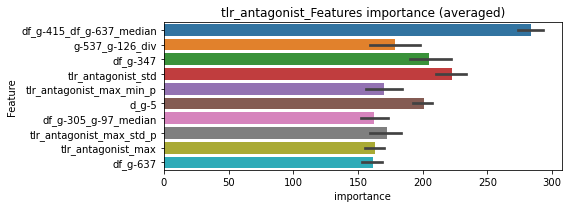

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 tlr_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0492158	valid_1's binary_logloss: 0.0544429
[200]	training's binary_logloss: 0.00855975	valid_1's binary_logloss: 0.0114863
[300]	training's binary_logloss: 0.00199063	valid_1's binary_logloss: 0.00352416
[400]	training's binary_logloss: 0.000726439	valid_1's binary_logloss: 0.00171547
[500]	training's binary_logloss: 0.000397693	valid_1's binary_logloss: 0.00121494
[600]	training's binary_logloss: 0.000276165	valid_1's binary_logloss: 0.000946562
[700]	training's binary_logloss: 0.000229695	valid_1's binary_logloss: 0.000825044
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.000222904	valid_1's binary_logloss: 0.000817033


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 tlr_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0490793	valid_1's binary_logloss: 0.0553316
[200]	training's binary_logloss: 0.00847086	valid_1's binary_logloss: 0.011734
[300]	training's binary_logloss: 0.00195247	valid_1's binary_logloss: 0.00388545
[400]	training's binary_logloss: 0.000716458	valid_1's binary_logloss: 0.00204541
[500]	training's binary_logloss: 0.000394562	valid_1's binary_logloss: 0.00160104
[600]	training's binary_logloss: 0.000274823	valid_1's binary_logloss: 0.00136832
[700]	training's binary_logloss: 0.00022837	valid_1's binary_logloss: 0.00130429
Early stopping, best iteration is:
[746]	training's binary_logloss: 0.00022156	valid_1's binary_logloss: 0.00129947


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 tlr_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0496488	valid_1's binary_logloss: 0.052132
[200]	training's binary_logloss: 0.00862706	valid_1's binary_logloss: 0.00923959
[300]	training's binary_logloss: 0.00200033	valid_1's binary_logloss: 0.00224553
[400]	training's binary_logloss: 0.00073078	valid_1's binary_logloss: 0.000861863
[500]	training's binary_logloss: 0.000398086	valid_1's binary_logloss: 0.000485584
[600]	training's binary_logloss: 0.000281936	valid_1's binary_logloss: 0.000350455
[700]	training's binary_logloss: 0.000232726	valid_1's binary_logloss: 0.000292946
[800]	training's binary_logloss: 0.000222398	valid_1's binary_logloss: 0.000280633
Early stopping, best iteration is:
[781]	training's binary_logloss: 0.000222398	valid_1's binary_logloss: 0.000280633


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 tlr_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0495232	valid_1's binary_logloss: 0.0546384
[200]	training's binary_logloss: 0.00852494	valid_1's binary_logloss: 0.01027
[300]	training's binary_logloss: 0.00197382	valid_1's binary_logloss: 0.00260318
[400]	training's binary_logloss: 0.000723449	valid_1's binary_logloss: 0.00104903
[500]	training's binary_logloss: 0.000397004	valid_1's binary_logloss: 0.000617003
[600]	training's binary_logloss: 0.000277328	valid_1's binary_logloss: 0.000455915
[700]	training's binary_logloss: 0.000228938	valid_1's binary_logloss: 0.000390462
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.000222971	valid_1's binary_logloss: 0.000384267


tlr_antagonist logloss: 0.0006956071969087817
tnf_inhibitor, len(trt): 36, len(othr): 3289, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0998115	valid_1's binary_logloss: 0.145026
[200]	training's binary_logloss: 0.0350884	valid_1's binary_logloss: 0.0770394
[300]	training's binary_logloss: 0.0135947	valid_1's binary_logloss: 0.0474662
[400]	training's binary_logloss: 0.00598514	valid_1's binary_logloss: 0.0341526
[500]	training's binary_logloss: 0.00311243	valid_1's binary_logloss: 0.0276498
[600]	training's binary_logloss: 0.00190133	valid_1's binary_logloss: 0.0237906
[700]	training's binary_logloss: 0.00132808	valid_1's binary_logloss: 0.0215831
[800]	training's binary_logloss: 0.00101561	valid_1's binary_logloss: 0.020346
[900]	training's binary_logloss: 0.000837059	valid_1's binary_logloss: 0.0192761
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000824944	valid_1's binary_logloss: 0.0191804
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101764	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0157086, Threshold: 0.0941888, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.06593, conf_1:0.12245
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0941888
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.1241888
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.1541888
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.1841888
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_5: 0.2141888
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.2441888
threshold: 0.2441888, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0987947	valid_1's binary_logloss: 0.140404
[200]	training's binary_logloss: 0.032937	valid_1's binary_logloss: 0.0685522
[300]	training's binary_logloss: 0.0124627	valid_1's binary_logloss: 0.0398287
[400]	training's binary_logloss: 0.00544086	valid_1's binary_logloss: 0.0272979
[500]	training's binary_logloss: 0.00277052	valid_1's binary_logloss: 0.0209197
[600]	training's binary_logloss: 0.00170058	valid_1's binary_logloss: 0.0173781
[700]	training's binary_logloss: 0.00119046	valid_1's binary_logloss: 0.0155501
[800]	training's binary_logloss: 0.000918328	valid_1's binary_logloss: 0.0143225
[900]	training's binary_logloss: 0.000755686	valid_1's binary_logloss: 0.013632
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000748214	valid_1's binary_logloss: 0.0135922
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.098957	vali

2 / 3 AUC score:1.000
y_Threshold: 0.1372908, Threshold: 0.2441888, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 653.0/3805
p_label_rate: 0.0133099 Vs.target_rate: 0.00151, Num_p_label: 53.0, conf_0:0.19535, conf_1:0.29303
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_1: 0.2441888
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_2: 0.2741888
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_3: 0.3041888
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_4: 0.3341888
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_5: 0.3641888
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_6: 0.3941888
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_7: 0.4241888
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_8: 0.4541888
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_9: 0.4841888
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_10: 0.5141888
threshold: 0.5441888, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 653.0/3805, y_label_rate: 0.1716163
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0973199	valid_1's binary_logloss: 0.127788
[200]	training's binary_logloss: 0.0319021	valid_1's binary_logloss: 0.059593
[300]	training's binary_logloss: 0.0117077	valid_1's binary_logloss: 0.0334288
[400]	training's binary_logloss: 0.00504386	valid_1's binary_logloss: 0.0231216
[500]	training's binary_logloss: 0.0026051	valid_1's binary_logloss: 0.0183434
[600]	training's binary_logloss: 0.00162427	valid_1's binary_logloss: 0.016552
[700]	training's binary_logloss: 0.00115694	valid_1's binary_logloss: 0.0157443
[800]	training's binary_logloss: 0.000897733	valid_1's binary_logloss: 0.0147492
[900]	training's binary_logloss: 0.000742829	valid_1's binary_logloss: 0.0144933
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00078023	valid_1's binary_logloss: 0.0143547
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0992482	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1164895, Threshold: 0.5441888, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 650.0/3799
p_label_rate: 0.0042692 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.48977, conf_1:0.59861
threshold: 0.5441888, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 650.0/3799, y_label_rate: 0.1710977


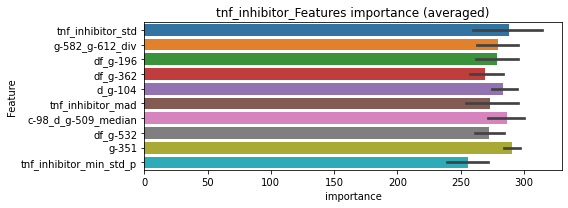

len(train_index) : 2849
len(valid_index) : 950
================================= fold 1/4 tnf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0964905	valid_1's binary_logloss: 0.1364
[200]	training's binary_logloss: 0.0297721	valid_1's binary_logloss: 0.0641395
[300]	training's binary_logloss: 0.0108941	valid_1's binary_logloss: 0.0411991
[400]	training's binary_logloss: 0.00470352	valid_1's binary_logloss: 0.0293664
[500]	training's binary_logloss: 0.00243739	valid_1's binary_logloss: 0.0240882
[600]	training's binary_logloss: 0.00153939	valid_1's binary_logloss: 0.0218474
[700]	training's binary_logloss: 0.00110322	valid_1's binary_logloss: 0.0209342
[800]	training's binary_logloss: 0.000864103	valid_1's binary_logloss: 0.0200842
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000769689	valid_1's binary_logloss: 0.0192872


len(train_index) : 2849
len(valid_index) : 950
================================= fold 2/4 tnf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0944903	valid_1's binary_logloss: 0.134502
[200]	training's binary_logloss: 0.0305106	valid_1's binary_logloss: 0.0663217
[300]	training's binary_logloss: 0.0112582	valid_1's binary_logloss: 0.0408646
[400]	training's binary_logloss: 0.00479505	valid_1's binary_logloss: 0.0297839
[500]	training's binary_logloss: 0.00247972	valid_1's binary_logloss: 0.0248303
[600]	training's binary_logloss: 0.00154841	valid_1's binary_logloss: 0.022518
[700]	training's binary_logloss: 0.00109703	valid_1's binary_logloss: 0.0208723
[800]	training's binary_logloss: 0.00085626	valid_1's binary_logloss: 0.0203945
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.000903149	valid_1's binary_logloss: 0.020252


len(train_index) : 2849
len(valid_index) : 950
================================= fold 3/4 tnf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.097062	valid_1's binary_logloss: 0.135352
[200]	training's binary_logloss: 0.0309713	valid_1's binary_logloss: 0.0614117
[300]	training's binary_logloss: 0.01176	valid_1's binary_logloss: 0.0331797
[400]	training's binary_logloss: 0.00494829	valid_1's binary_logloss: 0.0200359
[500]	training's binary_logloss: 0.00255659	valid_1's binary_logloss: 0.0142022
[600]	training's binary_logloss: 0.00157389	valid_1's binary_logloss: 0.0111818
[700]	training's binary_logloss: 0.001115	valid_1's binary_logloss: 0.00977194
[800]	training's binary_logloss: 0.000868853	valid_1's binary_logloss: 0.00874743
[900]	training's binary_logloss: 0.000724201	valid_1's binary_logloss: 0.00830133
[1000]	training's binary_logloss: 0.000654783	valid_1's binary_logloss: 0.00808594
[1100]	training's binary_logloss: 0.00061339	valid_1's binary_logloss: 0.00794357
Early stopping, best iteration is:
[1073]	training's binar

len(train_index) : 2850
len(valid_index) : 949
================================= fold 4/4 tnf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0973731	valid_1's binary_logloss: 0.13224
[200]	training's binary_logloss: 0.0309295	valid_1's binary_logloss: 0.0583863
[300]	training's binary_logloss: 0.0115627	valid_1's binary_logloss: 0.0303521
[400]	training's binary_logloss: 0.00500255	valid_1's binary_logloss: 0.0187178
[500]	training's binary_logloss: 0.00258552	valid_1's binary_logloss: 0.012738
[600]	training's binary_logloss: 0.00161818	valid_1's binary_logloss: 0.0100095
[700]	training's binary_logloss: 0.0011445	valid_1's binary_logloss: 0.00849628
[800]	training's binary_logloss: 0.000887456	valid_1's binary_logloss: 0.00767364
[900]	training's binary_logloss: 0.000745692	valid_1's binary_logloss: 0.0071188
[1000]	training's binary_logloss: 0.000674237	valid_1's binary_logloss: 0.00687462
[1100]	training's binary_logloss: 0.000638965	valid_1's binary_logloss: 0.00668326
Early stopping, best iteration is:
[1104]	training's bin

tnf_inhibitor logloss: 0.013540569439997773


neg labels: 3289 → selected neg labels: 3276


topoisomerase_inhibitor, len(trt): 127, len(othr): 3276, target_rate: 0.0053330 → Adj_target_rate: 0.0051574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.165962	valid_1's binary_logloss: 0.268005
[200]	training's binary_logloss: 0.0840172	valid_1's binary_logloss: 0.208987
[300]	training's binary_logloss: 0.0467089	valid_1's binary_logloss: 0.178191
[400]	training's binary_logloss: 0.0267479	valid_1's binary_logloss: 0.161359
[500]	training's binary_logloss: 0.0152687	valid_1's binary_logloss: 0.149227
[600]	training's binary_logloss: 0.00926562	valid_1's binary_logloss: 0.142488
[700]	training's binary_logloss: 0.00589115	valid_1's binary_logloss: 0.138697
[800]	training's binary_logloss: 0.00402352	valid_1's binary_logloss: 0.135857
[900]	training's binary_logloss: 0.0029555	valid_1's binary_logloss: 0.135107
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.00275551	valid_1's binary_logloss: 0.134834
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.17316	valid_1's binary_lo

1 / 3 AUC score:0.979
y_Threshold: 0.0490462, Threshold: 0.3880464, pos_neg_ratio: 0.8000000
Remove_noisy_data: 216 → Positive_corect_labels: 613/3715
p_label_rate: 0.0100452 Vs.target_rate: 0.00533, Num_p_label: 40.0, conf_0:0.27163, conf_1:0.50446
threshold: 0.3880464, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 613.0/3715, y_label_rate: 0.1650067
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.14452	valid_1's binary_logloss: 0.232478
[200]	training's binary_logloss: 0.0648836	valid_1's binary_logloss: 0.171558
[300]	training's binary_logloss: 0.0322847	valid_1's binary_logloss: 0.141216
[400]	training's binary_logloss: 0.0165945	valid_1's binary_logloss: 0.124539
[500]	training's binary_logloss: 0.00926492	valid_1's binary_logloss: 0.116399
[600]	training's binary_logloss: 0.00550786	valid_1's binary_logloss: 0.111629
[700]	training's binary_logloss: 0.00359417	valid_1's binary_logloss: 0.109199
[800]	training's binary_logloss: 0.00255317	valid_1's binary_logloss: 0.107842
Early stopping, best iteration is:
[781]	training's binary_logloss: 0.00270509	valid_1's binary_logloss: 0.107717
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.150162	valid_1's binary_logloss: 0.229072
[200]	training's binary_logloss: 0.0675291	valid_1's binary_l

2 / 3 AUC score:0.989
y_Threshold: 0.1081889, Threshold: 0.3880464, pos_neg_ratio: 0.8000000
Remove_noisy_data: 100 → Positive_corect_labels: 563.0/3615
p_label_rate: 0.0246107 Vs.target_rate: 0.00533, Num_p_label: 98.0, conf_0:0.31044, conf_1:0.46566
Num_p_label: 98.0, Expected: 21.2, Adj_threshold_1: 0.3880464
Num_p_label: 90.0, Expected: 21.2, Adj_threshold_2: 0.4180464
Num_p_label: 81.0, Expected: 21.2, Adj_threshold_3: 0.4480464
Num_p_label: 76.0, Expected: 21.2, Adj_threshold_4: 0.4780464
Num_p_label: 72.0, Expected: 21.2, Adj_threshold_5: 0.5080464
Num_p_label: 70.0, Expected: 21.2, Adj_threshold_6: 0.5380464
Num_p_label: 66.0, Expected: 21.2, Adj_threshold_7: 0.5680464
Num_p_label: 59.0, Expected: 21.2, Adj_threshold_8: 0.5980464
Num_p_label: 54.0, Expected: 21.2, Adj_threshold_9: 0.6280464
Num_p_label: 50.0, Expected: 21.2, Adj_threshold_10: 0.6580464
threshold: 0.6880464, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 563.0/3615, y_label_rate: 0.155740

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126165	valid_1's binary_logloss: 0.200249
[200]	training's binary_logloss: 0.0529042	valid_1's binary_logloss: 0.135669
[300]	training's binary_logloss: 0.0245872	valid_1's binary_logloss: 0.104548
[400]	training's binary_logloss: 0.0122205	valid_1's binary_logloss: 0.0893494
[500]	training's binary_logloss: 0.00667952	valid_1's binary_logloss: 0.0814896
[600]	training's binary_logloss: 0.00403936	valid_1's binary_logloss: 0.0785336
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00326249	valid_1's binary_logloss: 0.0775365
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132709	valid_1's binary_logloss: 0.193267
[200]	training's binary_logloss: 0.0564802	valid_1's binary_logloss: 0.125827
[300]	training's binary_logloss: 0.0258892	valid_1's binary_logloss: 0.0917864
[400]	training's binary_logloss: 0.0129483	valid_1's bina

3 / 3 AUC score:0.990
y_Threshold: 0.1210223, Threshold: 0.6880464, pos_neg_ratio: 0.8000000
Remove_noisy_data: 76 → Positive_corect_labels: 525.0/3539
p_label_rate: 0.0170768 Vs.target_rate: 0.00533, Num_p_label: 68.0, conf_0:0.50000, conf_1:0.75685
Num_p_label: 68.0, Expected: 21.2, Adj_threshold_1: 0.6880464
threshold: 0.6880464, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 525.0/3539, y_label_rate: 0.1483470


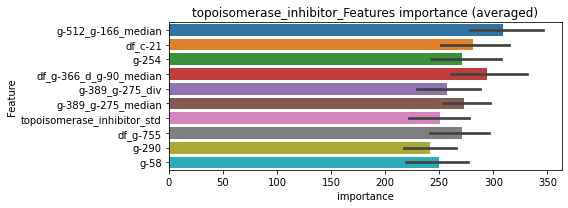

len(train_index) : 2654
len(valid_index) : 885
================================= fold 1/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112659	valid_1's binary_logloss: 0.1861
[200]	training's binary_logloss: 0.0453472	valid_1's binary_logloss: 0.121459
[300]	training's binary_logloss: 0.020038	valid_1's binary_logloss: 0.0912706
[400]	training's binary_logloss: 0.00965007	valid_1's binary_logloss: 0.0743976
[500]	training's binary_logloss: 0.00514921	valid_1's binary_logloss: 0.0650391
[600]	training's binary_logloss: 0.00310751	valid_1's binary_logloss: 0.0585146
[700]	training's binary_logloss: 0.00212457	valid_1's binary_logloss: 0.0547013
[800]	training's binary_logloss: 0.00158888	valid_1's binary_logloss: 0.0531505
[900]	training's binary_logloss: 0.00127391	valid_1's binary_logloss: 0.0515616
[1000]	training's binary_logloss: 0.00108825	valid_1's binary_logloss: 0.0505625
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.00108158	valid_1's binary_logloss: 0.0505339


len(train_index) : 2654
len(valid_index) : 885
================================= fold 2/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112351	valid_1's binary_logloss: 0.171111
[200]	training's binary_logloss: 0.0449003	valid_1's binary_logloss: 0.107629
[300]	training's binary_logloss: 0.0197907	valid_1's binary_logloss: 0.0809017
[400]	training's binary_logloss: 0.00952633	valid_1's binary_logloss: 0.0678444
[500]	training's binary_logloss: 0.0051607	valid_1's binary_logloss: 0.0610918
[600]	training's binary_logloss: 0.003123	valid_1's binary_logloss: 0.0572801
[700]	training's binary_logloss: 0.00212817	valid_1's binary_logloss: 0.0550613
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.00179635	valid_1's binary_logloss: 0.054224


len(train_index) : 2654
len(valid_index) : 885
================================= fold 3/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112567	valid_1's binary_logloss: 0.160868
[200]	training's binary_logloss: 0.0444092	valid_1's binary_logloss: 0.0961813
[300]	training's binary_logloss: 0.0199805	valid_1's binary_logloss: 0.068482
[400]	training's binary_logloss: 0.00962658	valid_1's binary_logloss: 0.0534285
[500]	training's binary_logloss: 0.00511905	valid_1's binary_logloss: 0.0446854
[600]	training's binary_logloss: 0.00312541	valid_1's binary_logloss: 0.0400131
[700]	training's binary_logloss: 0.00212125	valid_1's binary_logloss: 0.0382256
[800]	training's binary_logloss: 0.00159435	valid_1's binary_logloss: 0.0368315
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.00140292	valid_1's binary_logloss: 0.0360459


len(train_index) : 2655
len(valid_index) : 884
================================= fold 4/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110841	valid_1's binary_logloss: 0.173093
[200]	training's binary_logloss: 0.0428591	valid_1's binary_logloss: 0.111325
[300]	training's binary_logloss: 0.0186609	valid_1's binary_logloss: 0.0838787
[400]	training's binary_logloss: 0.00911358	valid_1's binary_logloss: 0.0697257
[500]	training's binary_logloss: 0.00493073	valid_1's binary_logloss: 0.0633349
[600]	training's binary_logloss: 0.00302819	valid_1's binary_logloss: 0.058529
[700]	training's binary_logloss: 0.00207821	valid_1's binary_logloss: 0.0559956
Early stopping, best iteration is:
[768]	training's binary_logloss: 0.0016986	valid_1's binary_logloss: 0.0544891


topoisomerase_inhibitor logloss: 0.0488216273163023


neg labels: 3289 → selected neg labels: 3287


transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0684198	valid_1's binary_logloss: 0.0786333
[200]	training's binary_logloss: 0.0176238	valid_1's binary_logloss: 0.0239183
[300]	training's binary_logloss: 0.00564243	valid_1's binary_logloss: 0.00941166
[400]	training's binary_logloss: 0.00226726	valid_1's binary_logloss: 0.00472555
[500]	training's binary_logloss: 0.00121969	valid_1's binary_logloss: 0.00312316
[600]	training's binary_logloss: 0.000800413	valid_1's binary_logloss: 0.00232208
[700]	training's binary_logloss: 0.000605441	valid_1's binary_logloss: 0.00194266
[800]	training's binary_logloss: 0.000506676	valid_1's binary_logloss: 0.00178756
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.000478813	valid_1's binary_logloss: 0.00171075
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0661339	valid_1's binary_logloss: 0.0928018
[200]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0039170, Threshold: 0.0177125, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01240, conf_1:0.02303
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0177125
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0477125
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0777125
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.1077125
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.1377125
threshold: 0.1377125, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0680308	valid_1's binary_logloss: 0.0757257
[200]	training's binary_logloss: 0.0164165	valid_1's binary_logloss: 0.0209438
[300]	training's binary_logloss: 0.00491341	valid_1's binary_logloss: 0.00708705
[400]	training's binary_logloss: 0.00201486	valid_1's binary_logloss: 0.00335519
[500]	training's binary_logloss: 0.00110521	valid_1's binary_logloss: 0.00205702
[600]	training's binary_logloss: 0.000729084	valid_1's binary_logloss: 0.00145408
[700]	training's binary_logloss: 0.00055256	valid_1's binary_logloss: 0.00116357
[800]	training's binary_logloss: 0.000474565	valid_1's binary_logloss: 0.00103524
[900]	training's binary_logloss: 0.000442376	valid_1's binary_logloss: 0.000975149
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000442224	valid_1's binary_logloss: 0.000974814
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0579193, Threshold: 0.1377125, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0040181 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.11017, conf_1:0.16525
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.1377125
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.1677125
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.1977125
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.2277125
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.2577125
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.2877125
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.3177125
threshold: 0.3177125, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0680308	valid_1's binary_logloss: 0.0757257
[200]	training's binary_logloss: 0.0164165	valid_1's binary_logloss: 0.0209438
[300]	training's binary_logloss: 0.00491341	valid_1's binary_logloss: 0.00708705
[400]	training's binary_logloss: 0.00201486	valid_1's binary_logloss: 0.00335519
[500]	training's binary_logloss: 0.00110521	valid_1's binary_logloss: 0.00205702
[600]	training's binary_logloss: 0.000729084	valid_1's binary_logloss: 0.00145408
[700]	training's binary_logloss: 0.00055256	valid_1's binary_logloss: 0.00116357
[800]	training's binary_logloss: 0.000474565	valid_1's binary_logloss: 0.00103524
[900]	training's binary_logloss: 0.000442376	valid_1's binary_logloss: 0.000975149
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000442224	valid_1's binary_logloss: 0.000974814
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0579193, Threshold: 0.3177125, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.28594, conf_1:0.34948
threshold: 0.3177125, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


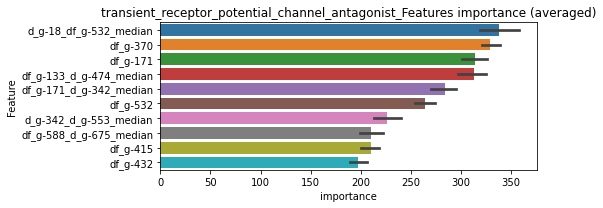

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0668239	valid_1's binary_logloss: 0.0736717
[200]	training's binary_logloss: 0.016179	valid_1's binary_logloss: 0.0207403
[300]	training's binary_logloss: 0.00506431	valid_1's binary_logloss: 0.00784655
[400]	training's binary_logloss: 0.00207772	valid_1's binary_logloss: 0.00374882
[500]	training's binary_logloss: 0.00110556	valid_1's binary_logloss: 0.0022861
[600]	training's binary_logloss: 0.000729526	valid_1's binary_logloss: 0.00166749
[700]	training's binary_logloss: 0.000553287	valid_1's binary_logloss: 0.00134543
[800]	training's binary_logloss: 0.000472842	valid_1's binary_logloss: 0.00118379
[900]	training's binary_logloss: 0.000443658	valid_1's binary_logloss: 0.00113236
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.000443658	valid_1's binary_logloss: 0.00113236


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0660303	valid_1's binary_logloss: 0.0896844
[200]	training's binary_logloss: 0.0154393	valid_1's binary_logloss: 0.0320564
[300]	training's binary_logloss: 0.00474335	valid_1's binary_logloss: 0.0162162
[400]	training's binary_logloss: 0.00193208	valid_1's binary_logloss: 0.0110858
[500]	training's binary_logloss: 0.0010347	valid_1's binary_logloss: 0.0087875
[600]	training's binary_logloss: 0.000690199	valid_1's binary_logloss: 0.00765691
[700]	training's binary_logloss: 0.000525934	valid_1's binary_logloss: 0.0068081
[800]	training's binary_logloss: 0.000443926	valid_1's binary_logloss: 0.00657101
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.00043273	valid_1's binary_logloss: 0.00653061


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.067569	valid_1's binary_logloss: 0.0816564
[200]	training's binary_logloss: 0.0165128	valid_1's binary_logloss: 0.0263067
[300]	training's binary_logloss: 0.00512563	valid_1's binary_logloss: 0.0118235
[400]	training's binary_logloss: 0.00206926	valid_1's binary_logloss: 0.00743925
[500]	training's binary_logloss: 0.00110809	valid_1's binary_logloss: 0.00568287
[600]	training's binary_logloss: 0.000724895	valid_1's binary_logloss: 0.00513896
[700]	training's binary_logloss: 0.000545777	valid_1's binary_logloss: 0.00479274
Early stopping, best iteration is:
[745]	training's binary_logloss: 0.000497073	valid_1's binary_logloss: 0.00468983


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0673132	valid_1's binary_logloss: 0.0823737
[200]	training's binary_logloss: 0.0157591	valid_1's binary_logloss: 0.0232899
[300]	training's binary_logloss: 0.00478815	valid_1's binary_logloss: 0.00850778
[400]	training's binary_logloss: 0.00193318	valid_1's binary_logloss: 0.00406349
[500]	training's binary_logloss: 0.0010583	valid_1's binary_logloss: 0.0025264
[600]	training's binary_logloss: 0.000705936	valid_1's binary_logloss: 0.00188831
[700]	training's binary_logloss: 0.000539488	valid_1's binary_logloss: 0.00154247
[800]	training's binary_logloss: 0.000459602	valid_1's binary_logloss: 0.00136798
Early stopping, best iteration is:
[841]	training's binary_logloss: 0.000446854	valid_1's binary_logloss: 0.00134448


transient_receptor_potential_channel_antagonist logloss: 0.003426422980099972


neg labels: 3289 → selected neg labels: 3289


tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0464362	valid_1's binary_logloss: 0.0501573
[200]	training's binary_logloss: 0.00788323	valid_1's binary_logloss: 0.00999869
[300]	training's binary_logloss: 0.00182317	valid_1's binary_logloss: 0.00322476
[400]	training's binary_logloss: 0.000664906	valid_1's binary_logloss: 0.00148692
[500]	training's binary_logloss: 0.000372161	valid_1's binary_logloss: 0.000952975
[600]	training's binary_logloss: 0.000263638	valid_1's binary_logloss: 0.000716206
[700]	training's binary_logloss: 0.000221319	valid_1's binary_logloss: 0.000620956
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.000216062	valid_1's binary_logloss: 0.000611425
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0459925	valid_1's binary_logloss: 0.049337
[200]	training's binary_logloss: 0.00792678	valid_1's binary_logloss: 0.00952803
[300]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0007511, Threshold: 0.0032557, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00228, conf_1:0.00423
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0032557
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0332557
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0632557
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0932557
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.1232557
threshold: 0.1232557, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.045448	valid_1's binary_logloss: 0.049314
[200]	training's binary_logloss: 0.00714003	valid_1's binary_logloss: 0.00881248
[300]	training's binary_logloss: 0.00154145	valid_1's binary_logloss: 0.00242107
[400]	training's binary_logloss: 0.000561927	valid_1's binary_logloss: 0.00103668
[500]	training's binary_logloss: 0.000314797	valid_1's binary_logloss: 0.000662669
[600]	training's binary_logloss: 0.000228143	valid_1's binary_logloss: 0.000522164
[700]	training's binary_logloss: 0.000199112	valid_1's binary_logloss: 0.000472885
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.000197972	valid_1's binary_logloss: 0.00047226
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455025	valid_1's binary_logloss: 0.0479158
[200]	training's binary_logloss: 0.00718582	valid_1's binary_logloss: 0.00917879
[300]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0734557, Threshold: 0.1232557, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00025, Num_p_label: 10.0, conf_0:0.09860, conf_1:0.14791
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.1232557
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.1532557
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.1832557
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.2132557
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.2432557
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.2732557
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.3032557
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.3332557
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.3632557
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.3932557
threshold: 0.4232557, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Ps

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.045448	valid_1's binary_logloss: 0.049314
[200]	training's binary_logloss: 0.00714003	valid_1's binary_logloss: 0.00881248
[300]	training's binary_logloss: 0.00154145	valid_1's binary_logloss: 0.00242107
[400]	training's binary_logloss: 0.000561927	valid_1's binary_logloss: 0.00103668
[500]	training's binary_logloss: 0.000314797	valid_1's binary_logloss: 0.000662669
[600]	training's binary_logloss: 0.000228143	valid_1's binary_logloss: 0.000522164
[700]	training's binary_logloss: 0.000199112	valid_1's binary_logloss: 0.000472885
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.000197972	valid_1's binary_logloss: 0.00047226
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455025	valid_1's binary_logloss: 0.0479158
[200]	training's binary_logloss: 0.00718582	valid_1's binary_logloss: 0.00917879
[300]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0734557, Threshold: 0.4232557, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.38093, conf_1:0.46558
threshold: 0.4232557, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


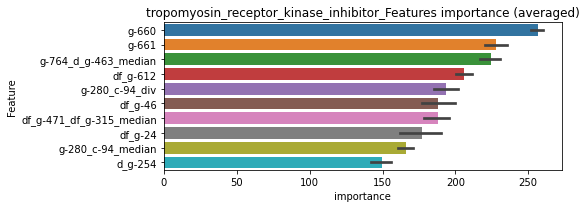

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448699	valid_1's binary_logloss: 0.0482084
[200]	training's binary_logloss: 0.00707183	valid_1's binary_logloss: 0.00858423
[300]	training's binary_logloss: 0.00152979	valid_1's binary_logloss: 0.00233243
[400]	training's binary_logloss: 0.000556577	valid_1's binary_logloss: 0.000996457
[500]	training's binary_logloss: 0.000313747	valid_1's binary_logloss: 0.000603178
[600]	training's binary_logloss: 0.000227665	valid_1's binary_logloss: 0.000467614
[700]	training's binary_logloss: 0.0001997	valid_1's binary_logloss: 0.000424576
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.000198115	valid_1's binary_logloss: 0.000423162


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.045156	valid_1's binary_logloss: 0.0482671
[200]	training's binary_logloss: 0.00712952	valid_1's binary_logloss: 0.00985638
[300]	training's binary_logloss: 0.0015447	valid_1's binary_logloss: 0.00400952
[400]	training's binary_logloss: 0.000566918	valid_1's binary_logloss: 0.00268079
[500]	training's binary_logloss: 0.000317345	valid_1's binary_logloss: 0.00213833
[600]	training's binary_logloss: 0.000229453	valid_1's binary_logloss: 0.00194264
[700]	training's binary_logloss: 0.00020062	valid_1's binary_logloss: 0.00188862
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.000202995	valid_1's binary_logloss: 0.0018883


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452178	valid_1's binary_logloss: 0.0460638
[200]	training's binary_logloss: 0.00718464	valid_1's binary_logloss: 0.00743455
[300]	training's binary_logloss: 0.00156058	valid_1's binary_logloss: 0.001721
[400]	training's binary_logloss: 0.000570151	valid_1's binary_logloss: 0.000673372
[500]	training's binary_logloss: 0.000319677	valid_1's binary_logloss: 0.000387158
[600]	training's binary_logloss: 0.000231671	valid_1's binary_logloss: 0.000279915
[700]	training's binary_logloss: 0.000202816	valid_1's binary_logloss: 0.000246144
Early stopping, best iteration is:
[733]	training's binary_logloss: 0.000200608	valid_1's binary_logloss: 0.000243086


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455718	valid_1's binary_logloss: 0.0496943
[200]	training's binary_logloss: 0.00721557	valid_1's binary_logloss: 0.00966015
[300]	training's binary_logloss: 0.00156219	valid_1's binary_logloss: 0.00365182
[400]	training's binary_logloss: 0.000566772	valid_1's binary_logloss: 0.00218168
[500]	training's binary_logloss: 0.000318716	valid_1's binary_logloss: 0.00166623
[600]	training's binary_logloss: 0.00022964	valid_1's binary_logloss: 0.00150639
[700]	training's binary_logloss: 0.000197537	valid_1's binary_logloss: 0.00139774
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.000194417	valid_1's binary_logloss: 0.00139361


tropomyosin_receptor_kinase_inhibitor logloss: 0.0009868930074667854
trpv_agonist, len(trt): 25, len(othr): 3281, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933215	valid_1's binary_logloss: 0.127716
[200]	training's binary_logloss: 0.0312022	valid_1's binary_logloss: 0.0592128
[300]	training's binary_logloss: 0.011444	valid_1's binary_logloss: 0.0321457
[400]	training's binary_logloss: 0.00462012	valid_1's binary_logloss: 0.0202939
[500]	training's binary_logloss: 0.00232276	valid_1's binary_logloss: 0.0150164
[600]	training's binary_logloss: 0.0014207	valid_1's binary_logloss: 0.0128748
[700]	training's binary_logloss: 0.00100704	valid_1's binary_logloss: 0.0113287
[800]	training's binary_logloss: 0.000792668	valid_1's binary_logloss: 0.0106385
[900]	training's binary_logloss: 0.000669345	valid_1's binary_logloss: 0.0102598
[1000]	training's binary_logloss: 0.000607555	valid_1's binary_logloss: 0.0101456
Early stopping, best iteration is:
[1052]	training's binary_logloss: 0.000589728	valid_1's binary_logloss: 0.0101098
Training until validatio

1 / 3 AUC score:1.000
y_Threshold: 0.0094557, Threshold: 0.0385310, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.02697, conf_1:0.05009
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0385310
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_2: 0.0685310
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_3: 0.0985310
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_4: 0.1285310
threshold: 0.1285310, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0918487	valid_1's binary_logloss: 0.123363
[200]	training's binary_logloss: 0.0289149	valid_1's binary_logloss: 0.0529882
[300]	training's binary_logloss: 0.0101239	valid_1's binary_logloss: 0.0261096
[400]	training's binary_logloss: 0.00408226	valid_1's binary_logloss: 0.0150421
[500]	training's binary_logloss: 0.00205598	valid_1's binary_logloss: 0.0104294
[600]	training's binary_logloss: 0.0012783	valid_1's binary_logloss: 0.00822615
[700]	training's binary_logloss: 0.000916328	valid_1's binary_logloss: 0.00698406
[800]	training's binary_logloss: 0.00071763	valid_1's binary_logloss: 0.00626736
[900]	training's binary_logloss: 0.00060266	valid_1's binary_logloss: 0.00588208
[1000]	training's binary_logloss: 0.0005662	valid_1's binary_logloss: 0.00576031
Early stopping, best iteration is:
[991]	training's binary_logloss: 0.000566724	valid_1's binary_logloss: 0.00575565
Training until valida

2 / 3 AUC score:1.000
y_Threshold: 0.1466455, Threshold: 0.1285310, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0102963 Vs.target_rate: 0.00105, Num_p_label: 41.0, conf_0:0.10282, conf_1:0.15424
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_1: 0.1285310
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_2: 0.1585310
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_3: 0.1885310
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_4: 0.2185310
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_5: 0.2485310
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_6: 0.2785310
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_7: 0.3085310
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_8: 0.3385310
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_9: 0.3685310
threshold: 0.3685310, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0918487	valid_1's binary_logloss: 0.123363
[200]	training's binary_logloss: 0.0289149	valid_1's binary_logloss: 0.0529882
[300]	training's binary_logloss: 0.0101239	valid_1's binary_logloss: 0.0261096
[400]	training's binary_logloss: 0.00408226	valid_1's binary_logloss: 0.0150421
[500]	training's binary_logloss: 0.00205598	valid_1's binary_logloss: 0.0104294
[600]	training's binary_logloss: 0.0012783	valid_1's binary_logloss: 0.00822615
[700]	training's binary_logloss: 0.000916328	valid_1's binary_logloss: 0.00698406
[800]	training's binary_logloss: 0.00071763	valid_1's binary_logloss: 0.00626736
[900]	training's binary_logloss: 0.00060266	valid_1's binary_logloss: 0.00588208
[1000]	training's binary_logloss: 0.0005662	valid_1's binary_logloss: 0.00576031
Early stopping, best iteration is:
[991]	training's binary_logloss: 0.000566724	valid_1's binary_logloss: 0.00575565
Training until valida

3 / 3 AUC score:1.000
y_Threshold: 0.1466455, Threshold: 0.3685310, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0020090 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.33168, conf_1:0.40538
threshold: 0.3685310, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3805, y_label_rate: 0.1724047


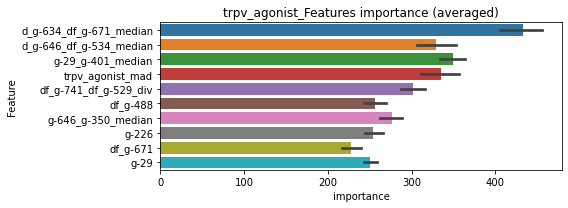

len(train_index) : 2853
len(valid_index) : 952
================================= fold 1/4 trpv_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0909799	valid_1's binary_logloss: 0.119409
[200]	training's binary_logloss: 0.0280775	valid_1's binary_logloss: 0.0495582
[300]	training's binary_logloss: 0.0101834	valid_1's binary_logloss: 0.024747
[400]	training's binary_logloss: 0.00415008	valid_1's binary_logloss: 0.0143791
[500]	training's binary_logloss: 0.00210872	valid_1's binary_logloss: 0.00958044
[600]	training's binary_logloss: 0.00129811	valid_1's binary_logloss: 0.00737289
[700]	training's binary_logloss: 0.00091842	valid_1's binary_logloss: 0.00634803
[800]	training's binary_logloss: 0.0007172	valid_1's binary_logloss: 0.00563888
[900]	training's binary_logloss: 0.000611267	valid_1's binary_logloss: 0.00525822
Early stopping, best iteration is:
[968]	training's binary_logloss: 0.000571678	valid_1's binary_logloss: 0.00510396


len(train_index) : 2854
len(valid_index) : 951
================================= fold 2/4 trpv_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0909611	valid_1's binary_logloss: 0.115747
[200]	training's binary_logloss: 0.0277494	valid_1's binary_logloss: 0.0435504
[300]	training's binary_logloss: 0.00995115	valid_1's binary_logloss: 0.0195037
[400]	training's binary_logloss: 0.00398962	valid_1's binary_logloss: 0.0102434
[500]	training's binary_logloss: 0.00201825	valid_1's binary_logloss: 0.00664026
[600]	training's binary_logloss: 0.00125693	valid_1's binary_logloss: 0.00496395
[700]	training's binary_logloss: 0.000897542	valid_1's binary_logloss: 0.00408493
[800]	training's binary_logloss: 0.00070475	valid_1's binary_logloss: 0.00350692
[900]	training's binary_logloss: 0.000599682	valid_1's binary_logloss: 0.00320205
[1000]	training's binary_logloss: 0.00056346	valid_1's binary_logloss: 0.0031561
Early stopping, best iteration is:
[987]	training's binary_logloss: 0.000563995	valid_1's binary_logloss: 0.00315537


len(train_index) : 2854
len(valid_index) : 951
================================= fold 3/4 trpv_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0905555	valid_1's binary_logloss: 0.118451
[200]	training's binary_logloss: 0.0280143	valid_1's binary_logloss: 0.04858
[300]	training's binary_logloss: 0.00968011	valid_1's binary_logloss: 0.0238832
[400]	training's binary_logloss: 0.00392736	valid_1's binary_logloss: 0.0142812
[500]	training's binary_logloss: 0.00199883	valid_1's binary_logloss: 0.0101593
[600]	training's binary_logloss: 0.0012456	valid_1's binary_logloss: 0.00827843
[700]	training's binary_logloss: 0.000887633	valid_1's binary_logloss: 0.00712598
[800]	training's binary_logloss: 0.000693519	valid_1's binary_logloss: 0.00651751
[900]	training's binary_logloss: 0.000586112	valid_1's binary_logloss: 0.00601683
[1000]	training's binary_logloss: 0.000541709	valid_1's binary_logloss: 0.00590109
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000541781	valid_1's binary_logloss: 0.00589949


len(train_index) : 2854
len(valid_index) : 951
================================= fold 4/4 trpv_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0906627	valid_1's binary_logloss: 0.119436
[200]	training's binary_logloss: 0.0284186	valid_1's binary_logloss: 0.0521243
[300]	training's binary_logloss: 0.00995199	valid_1's binary_logloss: 0.0269707
[400]	training's binary_logloss: 0.0040995	valid_1's binary_logloss: 0.0162936
[500]	training's binary_logloss: 0.00205914	valid_1's binary_logloss: 0.0106008
[600]	training's binary_logloss: 0.0012851	valid_1's binary_logloss: 0.00819943
[700]	training's binary_logloss: 0.00090478	valid_1's binary_logloss: 0.00668778
[800]	training's binary_logloss: 0.000706207	valid_1's binary_logloss: 0.0058715
[900]	training's binary_logloss: 0.000595081	valid_1's binary_logloss: 0.00545296
[1000]	training's binary_logloss: 0.000556184	valid_1's binary_logloss: 0.00533753
Early stopping, best iteration is:
[1012]	training's binary_logloss: 0.000555317	valid_1's binary_logloss: 0.00532939


trpv_agonist logloss: 0.004872397437800585
trpv_antagonist, len(trt): 48, len(othr): 3280, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106457	valid_1's binary_logloss: 0.168608
[200]	training's binary_logloss: 0.0377358	valid_1's binary_logloss: 0.0929572
[300]	training's binary_logloss: 0.0156049	valid_1's binary_logloss: 0.0603453
[400]	training's binary_logloss: 0.00705598	valid_1's binary_logloss: 0.0432115
[500]	training's binary_logloss: 0.00366711	valid_1's binary_logloss: 0.0347484
[600]	training's binary_logloss: 0.0022056	valid_1's binary_logloss: 0.0300774
[700]	training's binary_logloss: 0.00152654	valid_1's binary_logloss: 0.0280226
[800]	training's binary_logloss: 0.00115745	valid_1's binary_logloss: 0.0265713
[900]	training's binary_logloss: 0.000946362	valid_1's binary_logloss: 0.0256553
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000917798	valid_1's binary_logloss: 0.0255753
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107598	valid

1 / 3 AUC score:0.999
y_Threshold: 0.0144034, Threshold: 0.0787066, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3800
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.05509, conf_1:0.10232
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0787066
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_2: 0.1087066
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_3: 0.1387066
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_4: 0.1687066
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.1987066
threshold: 0.1987066, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104385	valid_1's binary_logloss: 0.160205
[200]	training's binary_logloss: 0.0346937	valid_1's binary_logloss: 0.0882565
[300]	training's binary_logloss: 0.0137862	valid_1's binary_logloss: 0.059798
[400]	training's binary_logloss: 0.00611669	valid_1's binary_logloss: 0.0447845
[500]	training's binary_logloss: 0.00315401	valid_1's binary_logloss: 0.0384118
[600]	training's binary_logloss: 0.00192841	valid_1's binary_logloss: 0.0348187
[700]	training's binary_logloss: 0.00133826	valid_1's binary_logloss: 0.032729
[800]	training's binary_logloss: 0.001024	valid_1's binary_logloss: 0.0314568
[900]	training's binary_logloss: 0.000847585	valid_1's binary_logloss: 0.0308947
[1000]	training's binary_logloss: 0.000750616	valid_1's binary_logloss: 0.0305259
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000760833	valid_1's binary_logloss: 0.0304807
Training until validation sco

2 / 3 AUC score:0.998
y_Threshold: 0.0935189, Threshold: 0.1987066, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0107986 Vs.target_rate: 0.00202, Num_p_label: 43.0, conf_0:0.15897, conf_1:0.23845
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_1: 0.1987066
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_2: 0.2287066
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_3: 0.2587066
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_4: 0.2887066
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_5: 0.3187066
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_6: 0.3487066
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_7: 0.3787066
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_8: 0.4087066
threshold: 0.4087066, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104641	valid_1's binary_logloss: 0.143509
[200]	training's binary_logloss: 0.035829	valid_1's binary_logloss: 0.069703
[300]	training's binary_logloss: 0.0140342	valid_1's binary_logloss: 0.0416932
[400]	training's binary_logloss: 0.00624468	valid_1's binary_logloss: 0.0284219
[500]	training's binary_logloss: 0.00323527	valid_1's binary_logloss: 0.0225056
[600]	training's binary_logloss: 0.00196275	valid_1's binary_logloss: 0.0192128
[700]	training's binary_logloss: 0.00135313	valid_1's binary_logloss: 0.0173265
[800]	training's binary_logloss: 0.00102816	valid_1's binary_logloss: 0.0159763
[900]	training's binary_logloss: 0.000840498	valid_1's binary_logloss: 0.0153035
[1000]	training's binary_logloss: 0.000740894	valid_1's binary_logloss: 0.0149749
[1100]	training's binary_logloss: 0.000686975	valid_1's binary_logloss: 0.0148103
Early stopping, best iteration is:
[1146]	training's binary_l

3 / 3 AUC score:1.000
y_Threshold: 0.0745080, Threshold: 0.4087066, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0055249 Vs.target_rate: 0.00202, Num_p_label: 22.0, conf_0:0.36784, conf_1:0.44958
threshold: 0.4087066, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 645.0/3782, y_label_rate: 0.1705447


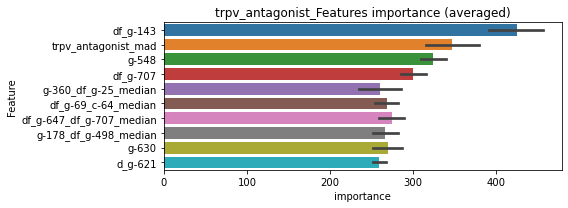

len(train_index) : 2836
len(valid_index) : 946
================================= fold 1/4 trpv_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101071	valid_1's binary_logloss: 0.150833
[200]	training's binary_logloss: 0.0351975	valid_1's binary_logloss: 0.0770566
[300]	training's binary_logloss: 0.013703	valid_1's binary_logloss: 0.0450678
[400]	training's binary_logloss: 0.00611138	valid_1's binary_logloss: 0.0303883
[500]	training's binary_logloss: 0.00314622	valid_1's binary_logloss: 0.0226661
[600]	training's binary_logloss: 0.00190343	valid_1's binary_logloss: 0.0188572
[700]	training's binary_logloss: 0.00132376	valid_1's binary_logloss: 0.0166405
[800]	training's binary_logloss: 0.00100901	valid_1's binary_logloss: 0.0153637
[900]	training's binary_logloss: 0.000832733	valid_1's binary_logloss: 0.0144654
[1000]	training's binary_logloss: 0.000734215	valid_1's binary_logloss: 0.0141183
Early stopping, best iteration is:
[1039]	training's binary_logloss: 0.000721214	valid_1's binary_logloss: 0.0140897


len(train_index) : 2836
len(valid_index) : 946
================================= fold 2/4 trpv_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103965	valid_1's binary_logloss: 0.135196
[200]	training's binary_logloss: 0.0360289	valid_1's binary_logloss: 0.0657473
[300]	training's binary_logloss: 0.0145127	valid_1's binary_logloss: 0.0404103
[400]	training's binary_logloss: 0.00631531	valid_1's binary_logloss: 0.0294164
[500]	training's binary_logloss: 0.00323094	valid_1's binary_logloss: 0.0244509
[600]	training's binary_logloss: 0.0019589	valid_1's binary_logloss: 0.0223674
[700]	training's binary_logloss: 0.00135713	valid_1's binary_logloss: 0.0217454
[800]	training's binary_logloss: 0.00103156	valid_1's binary_logloss: 0.0214651
[900]	training's binary_logloss: 0.000845981	valid_1's binary_logloss: 0.0208463
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.000798544	valid_1's binary_logloss: 0.0207961


len(train_index) : 2837
len(valid_index) : 945
================================= fold 3/4 trpv_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104377	valid_1's binary_logloss: 0.142982
[200]	training's binary_logloss: 0.0367861	valid_1's binary_logloss: 0.0715102
[300]	training's binary_logloss: 0.0146374	valid_1's binary_logloss: 0.0413429
[400]	training's binary_logloss: 0.00638907	valid_1's binary_logloss: 0.0269938
[500]	training's binary_logloss: 0.00325538	valid_1's binary_logloss: 0.0197889
[600]	training's binary_logloss: 0.00194762	valid_1's binary_logloss: 0.0165874
[700]	training's binary_logloss: 0.00135347	valid_1's binary_logloss: 0.0150141
[800]	training's binary_logloss: 0.00103555	valid_1's binary_logloss: 0.014427
[900]	training's binary_logloss: 0.000847617	valid_1's binary_logloss: 0.0136865
[1000]	training's binary_logloss: 0.000750118	valid_1's binary_logloss: 0.0134475
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.000753602	valid_1's binary_logloss: 0.0134275


len(train_index) : 2837
len(valid_index) : 945
================================= fold 4/4 trpv_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105098	valid_1's binary_logloss: 0.129959
[200]	training's binary_logloss: 0.0371054	valid_1's binary_logloss: 0.0622032
[300]	training's binary_logloss: 0.0149188	valid_1's binary_logloss: 0.0379235
[400]	training's binary_logloss: 0.00656001	valid_1's binary_logloss: 0.0262424
[500]	training's binary_logloss: 0.00330813	valid_1's binary_logloss: 0.0201758
[600]	training's binary_logloss: 0.0020109	valid_1's binary_logloss: 0.0173815
[700]	training's binary_logloss: 0.00138369	valid_1's binary_logloss: 0.0156342
[800]	training's binary_logloss: 0.0010564	valid_1's binary_logloss: 0.0147341
[900]	training's binary_logloss: 0.000869801	valid_1's binary_logloss: 0.0140551
[1000]	training's binary_logloss: 0.000767723	valid_1's binary_logloss: 0.0138312
Early stopping, best iteration is:
[1021]	training's binary_logloss: 0.000751239	valid_1's binary_logloss: 0.0137491


trpv_antagonist logloss: 0.015520808116434233
tubulin_inhibitor, len(trt): 316, len(othr): 3253, target_rate: 0.0132695 → Adj_target_rate: 0.0111926


neg labels: 3289 → selected neg labels: 3253


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.239101	valid_1's binary_logloss: 0.383232
[200]	training's binary_logloss: 0.153096	valid_1's binary_logloss: 0.359478
[300]	training's binary_logloss: 0.102869	valid_1's binary_logloss: 0.35186
[400]	training's binary_logloss: 0.0725937	valid_1's binary_logloss: 0.348963
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0607198	valid_1's binary_logloss: 0.346446
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.237528	valid_1's binary_logloss: 0.373612
[200]	training's binary_logloss: 0.147691	valid_1's binary_logloss: 0.353412
[300]	training's binary_logloss: 0.0985863	valid_1's binary_logloss: 0.344225
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0926317	valid_1's binary_logloss: 0.342991
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.245696	valid_1's

1 / 3 AUC score:0.813
y_Threshold: 0.1373315, Threshold: 0.3350060, pos_neg_ratio: 0.8000000
Remove_noisy_data: 633 → Positive_corect_labels: 399/3270
p_label_rate: 0.0100452 Vs.target_rate: 0.01327, Num_p_label: 40.0, conf_0:0.23450, conf_1:0.43551
threshold: 0.3350060, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 399.0/3270, y_label_rate: 0.1220183
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124066	valid_1's binary_logloss: 0.215042
[200]	training's binary_logloss: 0.0573681	valid_1's binary_logloss: 0.162911
[300]	training's binary_logloss: 0.0293982	valid_1's binary_logloss: 0.137492
[400]	training's binary_logloss: 0.0158327	valid_1's binary_logloss: 0.122997
[500]	training's binary_logloss: 0.00896252	valid_1's binary_logloss: 0.115854
[600]	training's binary_logloss: 0.00555273	valid_1's binary_logloss: 0.111768
[700]	training's binary_logloss: 0.00371647	valid_1's binary_logloss: 0.10705
[800]	training's binary_logloss: 0.00269457	valid_1's binary_logloss: 0.1054
[900]	training's binary_logloss: 0.00209081	valid_1's binary_logloss: 0.103868
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.0020126	valid_1's binary_logloss: 0.103711
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123214	valid_1's binary_log

2 / 3 AUC score:0.962
y_Threshold: 0.1089035, Threshold: 0.3350060, pos_neg_ratio: 0.8000000
Remove_noisy_data: 124 → Positive_corect_labels: 337.0/3146
p_label_rate: 0.0243596 Vs.target_rate: 0.01327, Num_p_label: 97.0, conf_0:0.26800, conf_1:0.40201
threshold: 0.3350060, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 337.0/3146, y_label_rate: 0.1071202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0974163	valid_1's binary_logloss: 0.17726
[200]	training's binary_logloss: 0.0396362	valid_1's binary_logloss: 0.139319
[300]	training's binary_logloss: 0.0182961	valid_1's binary_logloss: 0.123506
[400]	training's binary_logloss: 0.00924554	valid_1's binary_logloss: 0.116933
[500]	training's binary_logloss: 0.00513157	valid_1's binary_logloss: 0.116686
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00548067	valid_1's binary_logloss: 0.115984
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0945938	valid_1's binary_logloss: 0.190346
[200]	training's binary_logloss: 0.038375	valid_1's binary_logloss: 0.15233
[300]	training's binary_logloss: 0.0175301	valid_1's binary_logloss: 0.133946
[400]	training's binary_logloss: 0.00869369	valid_1's binary_logloss: 0.130424
Early stopping, best iteration is:
[420]	training's binary_log

3 / 3 AUC score:0.970
y_Threshold: 0.0784446, Threshold: 0.3350060, pos_neg_ratio: 0.8000000
Remove_noisy_data: 78 → Positive_corect_labels: 298.0/3068
p_label_rate: 0.0339026 Vs.target_rate: 0.01327, Num_p_label: 135.0, conf_0:0.30151, conf_1:0.36851
threshold: 0.3350060, positive_p_label: 135.0/3982, p_label_rate: 0.0339026
positive_y_label: 298.0/3068, y_label_rate: 0.0971317


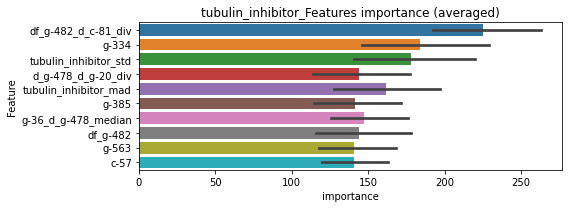

len(train_index) : 2301
len(valid_index) : 767
================================= fold 1/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0799923	valid_1's binary_logloss: 0.146775
[200]	training's binary_logloss: 0.0311047	valid_1's binary_logloss: 0.104526
[300]	training's binary_logloss: 0.0135675	valid_1's binary_logloss: 0.0896298
[400]	training's binary_logloss: 0.00664304	valid_1's binary_logloss: 0.0819243
[500]	training's binary_logloss: 0.00369777	valid_1's binary_logloss: 0.0789768
[600]	training's binary_logloss: 0.00235481	valid_1's binary_logloss: 0.0778107
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00247973	valid_1's binary_logloss: 0.0776099


len(train_index) : 2301
len(valid_index) : 767
================================= fold 2/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0801974	valid_1's binary_logloss: 0.154333
[200]	training's binary_logloss: 0.0295754	valid_1's binary_logloss: 0.112033
[300]	training's binary_logloss: 0.012791	valid_1's binary_logloss: 0.0959963
[400]	training's binary_logloss: 0.00632853	valid_1's binary_logloss: 0.0893112
[500]	training's binary_logloss: 0.00352989	valid_1's binary_logloss: 0.08689
[600]	training's binary_logloss: 0.00224686	valid_1's binary_logloss: 0.0856155
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.00222887	valid_1's binary_logloss: 0.0855227


len(train_index) : 2301
len(valid_index) : 767
================================= fold 3/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0754417	valid_1's binary_logloss: 0.170386
[200]	training's binary_logloss: 0.0276019	valid_1's binary_logloss: 0.137936


len(train_index) : 2301
len(valid_index) : 767
================================= fold 4/4 tubulin_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0158637	valid_1's binary_logloss: 0.131259
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0818871	valid_1's binary_logloss: 0.140116
[200]	training's binary_logloss: 0.0303357	valid_1's binary_logloss: 0.097597
[300]	training's binary_logloss: 0.0129855	valid_1's binary_logloss: 0.0806
[400]	training's binary_logloss: 0.00641068	valid_1's binary_logloss: 0.0728417
[500]	training's binary_logloss: 0.00361816	valid_1's binary_logloss: 0.0703782
[600]	training's binary_logloss: 0.00231326	valid_1's binary_logloss: 0.0699445
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00243192	valid_1's binary_logloss: 0.0696485


tubulin_inhibitor logloss: 0.09100990994310389
tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13114	valid_1's binary_logloss: 0.193976
[200]	training's binary_logloss: 0.0584475	valid_1's binary_logloss: 0.12456
[300]	training's binary_logloss: 0.0286263	valid_1's binary_logloss: 0.0902828
[400]	training's binary_logloss: 0.0148095	valid_1's binary_logloss: 0.0713919
[500]	training's binary_logloss: 0.00807653	valid_1's binary_logloss: 0.0611686
[600]	training's binary_logloss: 0.0046967	valid_1's binary_logloss: 0.0541076
[700]	training's binary_logloss: 0.00305661	valid_1's binary_logloss: 0.0507619
[800]	training's binary_logloss: 0.00214572	valid_1's binary_logloss: 0.0483968
[900]	training's binary_logloss: 0.00163664	valid_1's binary_logloss: 0.0475824
[1000]	training's binary_logloss: 0.00132992	valid_1's binary_logloss: 0.0469619
Early stopping, best iteration is:
[1058]	training's binary_logloss: 0.00120476	valid_1's binary_logloss: 0.0465538
Training until validation scores

1 / 3 AUC score:0.993
y_Threshold: 0.0291684, Threshold: 0.2032999, pos_neg_ratio: 0.8000000
Remove_noisy_data: 172 → Positive_corect_labels: 636/3765
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.14231, conf_1:0.26429
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.2032999
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.2332999
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_3: 0.2632999
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_4: 0.2932999
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_5: 0.3232999
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_6: 0.3532999
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_7: 0.3832999
threshold: 0.3832999, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 636.0/3765, y_label_rate: 0.1689243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119924	valid_1's binary_logloss: 0.187708
[200]	training's binary_logloss: 0.0481881	valid_1's binary_logloss: 0.124924
[300]	training's binary_logloss: 0.0209723	valid_1's binary_logloss: 0.0963556
[400]	training's binary_logloss: 0.0101537	valid_1's binary_logloss: 0.0857911
[500]	training's binary_logloss: 0.0053518	valid_1's binary_logloss: 0.0806268
[600]	training's binary_logloss: 0.00314451	valid_1's binary_logloss: 0.0790928
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00293804	valid_1's binary_logloss: 0.0785704
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122628	valid_1's binary_logloss: 0.17767
[200]	training's binary_logloss: 0.0489009	valid_1's binary_logloss: 0.108619
[300]	training's binary_logloss: 0.0225492	valid_1's binary_logloss: 0.0783878
[400]	training's binary_logloss: 0.011025	valid_1's binary

2 / 3 AUC score:0.996
y_Threshold: 0.1484099, Threshold: 0.3832999, pos_neg_ratio: 0.8000000
Remove_noisy_data: 40 → Positive_corect_labels: 616.0/3725
p_label_rate: 0.0210949 Vs.target_rate: 0.00307, Num_p_label: 84.0, conf_0:0.30664, conf_1:0.45996
Num_p_label: 84.0, Expected: 12.2, Adj_threshold_1: 0.3832999
Num_p_label: 75.0, Expected: 12.2, Adj_threshold_2: 0.4132999
Num_p_label: 69.0, Expected: 12.2, Adj_threshold_3: 0.4432999
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_4: 0.4732999
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_5: 0.5032999
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_6: 0.5332999
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_7: 0.5632999
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_8: 0.5932999
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_9: 0.6232999
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_10: 0.6532999
threshold: 0.6832999, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 616.0/3725, y_label_rate: 0.1653691

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113479	valid_1's binary_logloss: 0.16865
[200]	training's binary_logloss: 0.045113	valid_1's binary_logloss: 0.0983309
[300]	training's binary_logloss: 0.0201074	valid_1's binary_logloss: 0.0660333
[400]	training's binary_logloss: 0.00953651	valid_1's binary_logloss: 0.0468202
[500]	training's binary_logloss: 0.00495601	valid_1's binary_logloss: 0.0362855
[600]	training's binary_logloss: 0.00292424	valid_1's binary_logloss: 0.0298731
[700]	training's binary_logloss: 0.00194677	valid_1's binary_logloss: 0.0264144
[800]	training's binary_logloss: 0.00143523	valid_1's binary_logloss: 0.0241196
[900]	training's binary_logloss: 0.00113751	valid_1's binary_logloss: 0.0227059
[1000]	training's binary_logloss: 0.000962885	valid_1's binary_logloss: 0.0218138
[1100]	training's binary_logloss: 0.000872287	valid_1's binary_logloss: 0.0211113
[1200]	training's binary_logloss: 0.000811309	valid_1's binary

3 / 3 AUC score:1.000
y_Threshold: 0.1012098, Threshold: 0.6832999, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 604.0/3701
p_label_rate: 0.0143144 Vs.target_rate: 0.00307, Num_p_label: 57.0, conf_0:0.50000, conf_1:0.75163
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_1: 0.6832999
threshold: 0.6832999, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 604.0/3701, y_label_rate: 0.1631991


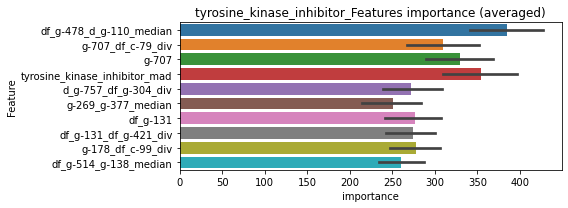

len(train_index) : 2775
len(valid_index) : 926
================================= fold 1/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107366	valid_1's binary_logloss: 0.171732
[200]	training's binary_logloss: 0.0401673	valid_1's binary_logloss: 0.105859
[300]	training's binary_logloss: 0.016991	valid_1's binary_logloss: 0.0783427
[400]	training's binary_logloss: 0.00781094	valid_1's binary_logloss: 0.0639005
[500]	training's binary_logloss: 0.00412203	valid_1's binary_logloss: 0.0573404
[600]	training's binary_logloss: 0.00246775	valid_1's binary_logloss: 0.0537693
[700]	training's binary_logloss: 0.00167603	valid_1's binary_logloss: 0.0513534
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00139271	valid_1's binary_logloss: 0.0502332


len(train_index) : 2776
len(valid_index) : 925
================================= fold 2/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110502	valid_1's binary_logloss: 0.159014
[200]	training's binary_logloss: 0.0409022	valid_1's binary_logloss: 0.094054
[300]	training's binary_logloss: 0.0175459	valid_1's binary_logloss: 0.0683075
[400]	training's binary_logloss: 0.00805475	valid_1's binary_logloss: 0.0573839
[500]	training's binary_logloss: 0.00413249	valid_1's binary_logloss: 0.0519263
[600]	training's binary_logloss: 0.00247547	valid_1's binary_logloss: 0.0497742
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00255434	valid_1's binary_logloss: 0.0496238


len(train_index) : 2776
len(valid_index) : 925
================================= fold 3/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112141	valid_1's binary_logloss: 0.158028
[200]	training's binary_logloss: 0.0424573	valid_1's binary_logloss: 0.0861806
[300]	training's binary_logloss: 0.0186459	valid_1's binary_logloss: 0.0581361
[400]	training's binary_logloss: 0.00868121	valid_1's binary_logloss: 0.0437655
[500]	training's binary_logloss: 0.00443708	valid_1's binary_logloss: 0.0359479
[600]	training's binary_logloss: 0.00263059	valid_1's binary_logloss: 0.0321453
[700]	training's binary_logloss: 0.00177009	valid_1's binary_logloss: 0.0303677
[800]	training's binary_logloss: 0.00130832	valid_1's binary_logloss: 0.0293613
[900]	training's binary_logloss: 0.00104987	valid_1's binary_logloss: 0.028748
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00103827	valid_1's binary_logloss: 0.0287156


len(train_index) : 2776
len(valid_index) : 925
================================= fold 4/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111379	valid_1's binary_logloss: 0.155118
[200]	training's binary_logloss: 0.0424015	valid_1's binary_logloss: 0.0881058
[300]	training's binary_logloss: 0.0181616	valid_1's binary_logloss: 0.0593884
[400]	training's binary_logloss: 0.00845212	valid_1's binary_logloss: 0.0449799
[500]	training's binary_logloss: 0.00439585	valid_1's binary_logloss: 0.0385952
[600]	training's binary_logloss: 0.00262215	valid_1's binary_logloss: 0.0350885
[700]	training's binary_logloss: 0.00176557	valid_1's binary_logloss: 0.0340326
Early stopping, best iteration is:
[699]	training's binary_logloss: 0.00177216	valid_1's binary_logloss: 0.0339958


tyrosine_kinase_inhibitor logloss: 0.040644695024814735
ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0627071	valid_1's binary_logloss: 0.0717473
[200]	training's binary_logloss: 0.0153682	valid_1's binary_logloss: 0.0206253
[300]	training's binary_logloss: 0.00442884	valid_1's binary_logloss: 0.00798344
[400]	training's binary_logloss: 0.0017114	valid_1's binary_logloss: 0.00412414
[500]	training's binary_logloss: 0.000901898	valid_1's binary_logloss: 0.00269078
[600]	training's binary_logloss: 0.00059446	valid_1's binary_logloss: 0.00207918
[700]	training's binary_logloss: 0.000445997	valid_1's binary_logloss: 0.00174523
[800]	training's binary_logloss: 0.000376962	valid_1's binary_logloss: 0.00158443
Early stopping, best iteration is:
[863]	training's binary_logloss: 0.000359622	valid_1's binary_logloss: 0.00154533
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0631257	valid_1's binary_logloss: 0.0747981
[200]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0025279, Threshold: 0.0142728, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00999, conf_1:0.01855
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0142728
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_2: 0.0442728
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_3: 0.0742728
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.1042728
threshold: 0.1042728, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0621734	valid_1's binary_logloss: 0.0702202
[200]	training's binary_logloss: 0.0136959	valid_1's binary_logloss: 0.0177718
[300]	training's binary_logloss: 0.0038226	valid_1's binary_logloss: 0.00583116
[400]	training's binary_logloss: 0.00147144	valid_1's binary_logloss: 0.00262903
[500]	training's binary_logloss: 0.000774646	valid_1's binary_logloss: 0.00152323
[600]	training's binary_logloss: 0.000507712	valid_1's binary_logloss: 0.00106118
[700]	training's binary_logloss: 0.000380192	valid_1's binary_logloss: 0.000840263
[800]	training's binary_logloss: 0.000329989	valid_1's binary_logloss: 0.000751026
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.000320807	valid_1's binary_logloss: 0.000735606
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.061123	valid_1's binary_logloss: 0.0722999
[200]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1665571, Threshold: 0.1042728, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0077850 Vs.target_rate: 0.00050, Num_p_label: 31.0, conf_0:0.08342, conf_1:0.12513
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_1: 0.1042728
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_2: 0.1342728
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.1642728
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_4: 0.1942728
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_5: 0.2242728
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.2542728
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.2842728
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_8: 0.3142728
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.3442728
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.3742728
threshold: 0.4042728, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0621734	valid_1's binary_logloss: 0.0702202
[200]	training's binary_logloss: 0.0136959	valid_1's binary_logloss: 0.0177718
[300]	training's binary_logloss: 0.0038226	valid_1's binary_logloss: 0.00583116
[400]	training's binary_logloss: 0.00147144	valid_1's binary_logloss: 0.00262903
[500]	training's binary_logloss: 0.000774646	valid_1's binary_logloss: 0.00152323
[600]	training's binary_logloss: 0.000507712	valid_1's binary_logloss: 0.00106118
[700]	training's binary_logloss: 0.000380192	valid_1's binary_logloss: 0.000840263
[800]	training's binary_logloss: 0.000329989	valid_1's binary_logloss: 0.000751026
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.000320807	valid_1's binary_logloss: 0.000735606
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.061123	valid_1's binary_logloss: 0.0722999
[200]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1665571, Threshold: 0.4042728, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.36385, conf_1:0.44470
threshold: 0.4042728, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


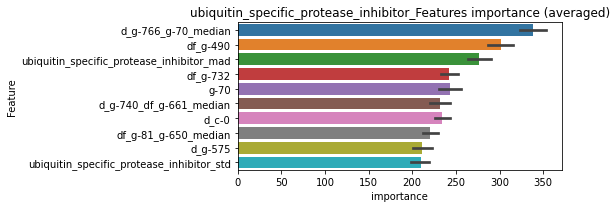

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0619009	valid_1's binary_logloss: 0.0693232
[200]	training's binary_logloss: 0.0137342	valid_1's binary_logloss: 0.0177413
[300]	training's binary_logloss: 0.00381422	valid_1's binary_logloss: 0.00581425
[400]	training's binary_logloss: 0.00147137	valid_1's binary_logloss: 0.00261988
[500]	training's binary_logloss: 0.000779062	valid_1's binary_logloss: 0.00154729
[600]	training's binary_logloss: 0.000506574	valid_1's binary_logloss: 0.00107324
[700]	training's binary_logloss: 0.000381065	valid_1's binary_logloss: 0.000847293
[800]	training's binary_logloss: 0.000329531	valid_1's binary_logloss: 0.000748674
[900]	training's binary_logloss: 0.000314689	valid_1's binary_logloss: 0.000721949
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.000314689	valid_1's binary_logloss: 0.000721949


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0608893	valid_1's binary_logloss: 0.0724105
[200]	training's binary_logloss: 0.0137237	valid_1's binary_logloss: 0.0193312
[300]	training's binary_logloss: 0.00377433	valid_1's binary_logloss: 0.00642035
[400]	training's binary_logloss: 0.00144476	valid_1's binary_logloss: 0.00294517
[500]	training's binary_logloss: 0.000759553	valid_1's binary_logloss: 0.00174115
[600]	training's binary_logloss: 0.000493195	valid_1's binary_logloss: 0.00123554
[700]	training's binary_logloss: 0.00037236	valid_1's binary_logloss: 0.00100701
[800]	training's binary_logloss: 0.000320514	valid_1's binary_logloss: 0.000903601
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.000313008	valid_1's binary_logloss: 0.000887894


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0617831	valid_1's binary_logloss: 0.0706281
[200]	training's binary_logloss: 0.0138276	valid_1's binary_logloss: 0.0179216
[300]	training's binary_logloss: 0.0038338	valid_1's binary_logloss: 0.00576928
[400]	training's binary_logloss: 0.00147016	valid_1's binary_logloss: 0.00258393
[500]	training's binary_logloss: 0.000770914	valid_1's binary_logloss: 0.00150703
[600]	training's binary_logloss: 0.000505911	valid_1's binary_logloss: 0.00104662
[700]	training's binary_logloss: 0.000382609	valid_1's binary_logloss: 0.000820403
[800]	training's binary_logloss: 0.000331722	valid_1's binary_logloss: 0.000729069
[900]	training's binary_logloss: 0.000318088	valid_1's binary_logloss: 0.000702177
[1000]	training's binary_logloss: 0.000313079	valid_1's binary_logloss: 0.000693412
Early stopping, best iteration is:
[983]	training's binary_logloss: 0.000313079	valid_1's binary_logloss: 0.000693412


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0620217	valid_1's binary_logloss: 0.0732579
[200]	training's binary_logloss: 0.0138447	valid_1's binary_logloss: 0.0197482
[300]	training's binary_logloss: 0.00385475	valid_1's binary_logloss: 0.00693236
[400]	training's binary_logloss: 0.00149086	valid_1's binary_logloss: 0.00322266
[500]	training's binary_logloss: 0.000774727	valid_1's binary_logloss: 0.00185712
[600]	training's binary_logloss: 0.000508222	valid_1's binary_logloss: 0.00133735
[700]	training's binary_logloss: 0.000379257	valid_1's binary_logloss: 0.00106178
[800]	training's binary_logloss: 0.00032866	valid_1's binary_logloss: 0.000958609
[900]	training's binary_logloss: 0.000316366	valid_1's binary_logloss: 0.000930411
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000313753	valid_1's binary_logloss: 0.000928905


ubiquitin_specific_protease_inhibitor logloss: 0.0008080438178698852


neg labels: 3289 → selected neg labels: 3264


vegfr_inhibitor, len(trt): 170, len(othr): 3264, target_rate: 0.0071387 → Adj_target_rate: 0.0066081
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.202224	valid_1's binary_logloss: 0.312488
[200]	training's binary_logloss: 0.112175	valid_1's binary_logloss: 0.263254
[300]	training's binary_logloss: 0.0680376	valid_1's binary_logloss: 0.238843
[400]	training's binary_logloss: 0.0428383	valid_1's binary_logloss: 0.226706
[500]	training's binary_logloss: 0.0273743	valid_1's binary_logloss: 0.220312
[600]	training's binary_logloss: 0.0171597	valid_1's binary_logloss: 0.214543
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.0139226	valid_1's binary_logloss: 0.213028
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.207831	valid_1's binary_logloss: 0.300045
[200]	training's binary_logloss: 0.121339	valid_1's binary_logloss: 0.248602
[300]	training's binary_logloss: 0.0751639	valid_1's binary_logloss: 0.219124
[400]	training's binary_logloss: 0.0477593	valid_1's binary_logloss

1 / 3 AUC score:0.934
y_Threshold: 0.0898484, Threshold: 0.3868560, pos_neg_ratio: 0.8000000
Remove_noisy_data: 326 → Positive_corect_labels: 555/3590
p_label_rate: 0.0100452 Vs.target_rate: 0.00714, Num_p_label: 40.0, conf_0:0.27080, conf_1:0.50291
threshold: 0.3868560, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 555.0/3590, y_label_rate: 0.1545961
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143015	valid_1's binary_logloss: 0.249293
[200]	training's binary_logloss: 0.0656165	valid_1's binary_logloss: 0.189594
[300]	training's binary_logloss: 0.0326208	valid_1's binary_logloss: 0.159988
[400]	training's binary_logloss: 0.0170957	valid_1's binary_logloss: 0.145054
[500]	training's binary_logloss: 0.00967122	valid_1's binary_logloss: 0.137669
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00867543	valid_1's binary_logloss: 0.137041
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.14972	valid_1's binary_logloss: 0.213192
[200]	training's binary_logloss: 0.0686825	valid_1's binary_logloss: 0.154528
[300]	training's binary_logloss: 0.0349501	valid_1's binary_logloss: 0.128304
[400]	training's binary_logloss: 0.01884	valid_1's binary_logloss: 0.115512
[500]	training's binary_logloss: 0.0106182	valid_1's binary_loglos

2 / 3 AUC score:0.981
y_Threshold: 0.1155882, Threshold: 0.3868560, pos_neg_ratio: 0.8000000
Remove_noisy_data: 106 → Positive_corect_labels: 502.0/3484
p_label_rate: 0.0278754 Vs.target_rate: 0.00714, Num_p_label: 111.0, conf_0:0.30948, conf_1:0.46423
Num_p_label: 111.0, Expected: 28.4, Adj_threshold_1: 0.3868560
Num_p_label: 104.0, Expected: 28.4, Adj_threshold_2: 0.4168560
Num_p_label: 94.0, Expected: 28.4, Adj_threshold_3: 0.4468560
Num_p_label: 84.0, Expected: 28.4, Adj_threshold_4: 0.4768560
Num_p_label: 75.0, Expected: 28.4, Adj_threshold_5: 0.5068560
Num_p_label: 72.0, Expected: 28.4, Adj_threshold_6: 0.5368560
Num_p_label: 64.0, Expected: 28.4, Adj_threshold_7: 0.5668560
Num_p_label: 60.0, Expected: 28.4, Adj_threshold_8: 0.5968560
Num_p_label: 55.0, Expected: 28.4, Adj_threshold_9: 0.6268560
Num_p_label: 51.0, Expected: 28.4, Adj_threshold_10: 0.6568560
threshold: 0.6868560, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 502.0/3484, y_label_rate: 0.144

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123543	valid_1's binary_logloss: 0.20421
[200]	training's binary_logloss: 0.0510601	valid_1's binary_logloss: 0.147846
[300]	training's binary_logloss: 0.0235685	valid_1's binary_logloss: 0.121244
[400]	training's binary_logloss: 0.0118124	valid_1's binary_logloss: 0.109456
[500]	training's binary_logloss: 0.00637877	valid_1's binary_logloss: 0.104775
[600]	training's binary_logloss: 0.00381406	valid_1's binary_logloss: 0.102523
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00392997	valid_1's binary_logloss: 0.1023
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126741	valid_1's binary_logloss: 0.193421
[200]	training's binary_logloss: 0.0526472	valid_1's binary_logloss: 0.134037
[300]	training's binary_logloss: 0.0247204	valid_1's binary_logloss: 0.111979
[400]	training's binary_logloss: 0.0122159	valid_1's binary_loglo

3 / 3 AUC score:0.986
y_Threshold: 0.1128429, Threshold: 0.6868560, pos_neg_ratio: 0.8000000
Remove_noisy_data: 64 → Positive_corect_labels: 470.0/3420
p_label_rate: 0.0223506 Vs.target_rate: 0.00714, Num_p_label: 89.0, conf_0:0.50000, conf_1:0.75554
Num_p_label: 89.0, Expected: 28.4, Adj_threshold_1: 0.6868560
threshold: 0.6868560, positive_p_label: 89.0/3982, p_label_rate: 0.0223506
positive_y_label: 470.0/3420, y_label_rate: 0.1374269


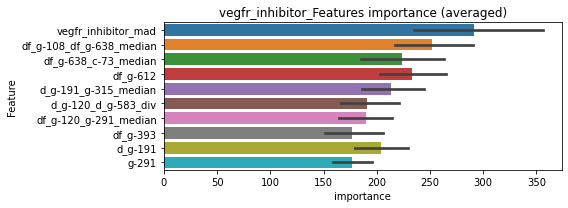

len(train_index) : 2565
len(valid_index) : 855
================================= fold 1/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10891	valid_1's binary_logloss: 0.182544
[200]	training's binary_logloss: 0.0415663	valid_1's binary_logloss: 0.117967
[300]	training's binary_logloss: 0.0183082	valid_1's binary_logloss: 0.0924346
[400]	training's binary_logloss: 0.00877257	valid_1's binary_logloss: 0.0798606
[500]	training's binary_logloss: 0.00461443	valid_1's binary_logloss: 0.0730959
[600]	training's binary_logloss: 0.00279142	valid_1's binary_logloss: 0.0700966
[700]	training's binary_logloss: 0.00191191	valid_1's binary_logloss: 0.0688146
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.00208888	valid_1's binary_logloss: 0.0686871


len(train_index) : 2565
len(valid_index) : 855
================================= fold 2/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111047	valid_1's binary_logloss: 0.171186
[200]	training's binary_logloss: 0.0418472	valid_1's binary_logloss: 0.110229
[300]	training's binary_logloss: 0.0181153	valid_1's binary_logloss: 0.0842234
[400]	training's binary_logloss: 0.00869672	valid_1's binary_logloss: 0.0726475
[500]	training's binary_logloss: 0.0045993	valid_1's binary_logloss: 0.0665238
[600]	training's binary_logloss: 0.00280363	valid_1's binary_logloss: 0.0638661
[700]	training's binary_logloss: 0.00192655	valid_1's binary_logloss: 0.0628408
Early stopping, best iteration is:
[679]	training's binary_logloss: 0.00207128	valid_1's binary_logloss: 0.0626745


len(train_index) : 2565
len(valid_index) : 855
================================= fold 3/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11167	valid_1's binary_logloss: 0.162931
[200]	training's binary_logloss: 0.0423553	valid_1's binary_logloss: 0.0995938
[300]	training's binary_logloss: 0.0179527	valid_1's binary_logloss: 0.0728541
[400]	training's binary_logloss: 0.00861958	valid_1's binary_logloss: 0.060374
[500]	training's binary_logloss: 0.00464695	valid_1's binary_logloss: 0.0532588
[600]	training's binary_logloss: 0.002829	valid_1's binary_logloss: 0.0503467
[700]	training's binary_logloss: 0.00193549	valid_1's binary_logloss: 0.0478812
[800]	training's binary_logloss: 0.00145336	valid_1's binary_logloss: 0.0470292
[900]	training's binary_logloss: 0.00118081	valid_1's binary_logloss: 0.0457507
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.00114467	valid_1's binary_logloss: 0.0455275


len(train_index) : 2565
len(valid_index) : 855
================================= fold 4/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109593	valid_1's binary_logloss: 0.165257
[200]	training's binary_logloss: 0.0424831	valid_1's binary_logloss: 0.102884
[300]	training's binary_logloss: 0.0182998	valid_1's binary_logloss: 0.0728425
[400]	training's binary_logloss: 0.00860688	valid_1's binary_logloss: 0.0577164
[500]	training's binary_logloss: 0.00464622	valid_1's binary_logloss: 0.049383
[600]	training's binary_logloss: 0.00284862	valid_1's binary_logloss: 0.0451509
[700]	training's binary_logloss: 0.00195001	valid_1's binary_logloss: 0.0430795
[800]	training's binary_logloss: 0.00146849	valid_1's binary_logloss: 0.0409898
[900]	training's binary_logloss: 0.00119048	valid_1's binary_logloss: 0.039879
[1000]	training's binary_logloss: 0.00102917	valid_1's binary_logloss: 0.0386807
Early stopping, best iteration is:
[1066]	training's binary_logloss: 0.000965306	valid_1's binary_logloss: 0.0381807


vegfr_inhibitor logloss: 0.05376747698368706
vitamin_b, len(trt): 26, len(othr): 3286, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0878752	valid_1's binary_logloss: 0.116962
[200]	training's binary_logloss: 0.0269193	valid_1's binary_logloss: 0.0479329
[300]	training's binary_logloss: 0.00960373	valid_1's binary_logloss: 0.024812
[400]	training's binary_logloss: 0.0038506	valid_1's binary_logloss: 0.0158839
[500]	training's binary_logloss: 0.00194182	valid_1's binary_logloss: 0.0121442
[600]	training's binary_logloss: 0.00120402	valid_1's binary_logloss: 0.0108116
[700]	training's binary_logloss: 0.000861342	valid_1's binary_logloss: 0.00999005
[800]	training's binary_logloss: 0.000675138	valid_1's binary_logloss: 0.00950288
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.000598182	valid_1's binary_logloss: 0.00933392
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0860995	valid_1's binary_logloss: 0.111215
[200]	training's binary_logloss: 0.0260461	v

1 / 3 AUC score:1.000
y_Threshold: 0.0085874, Threshold: 0.0426232, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3809
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.02984, conf_1:0.05541
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0426232
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_2: 0.0726232
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_3: 0.1026232
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_4: 0.1326232
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_5: 0.1626232
threshold: 0.1626232, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0860852	valid_1's binary_logloss: 0.10698
[200]	training's binary_logloss: 0.0248931	valid_1's binary_logloss: 0.0418554
[300]	training's binary_logloss: 0.00840003	valid_1's binary_logloss: 0.0203318
[400]	training's binary_logloss: 0.00337298	valid_1's binary_logloss: 0.0120421
[500]	training's binary_logloss: 0.00171188	valid_1's binary_logloss: 0.00888659
[600]	training's binary_logloss: 0.00106552	valid_1's binary_logloss: 0.00753387
[700]	training's binary_logloss: 0.000763032	valid_1's binary_logloss: 0.00676671
[800]	training's binary_logloss: 0.00059953	valid_1's binary_logloss: 0.0062816
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.000579929	valid_1's binary_logloss: 0.00626563
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843677	valid_1's binary_logloss: 0.109835
[200]	training's binary_logloss: 0.0237282	

2 / 3 AUC score:1.000
y_Threshold: 0.0675336, Threshold: 0.1626232, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0097941 Vs.target_rate: 0.00109, Num_p_label: 39.0, conf_0:0.13010, conf_1:0.19515
Num_p_label: 39.0, Expected: 4.3, Adj_threshold_1: 0.1626232
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_2: 0.1926232
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_3: 0.2226232
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_4: 0.2526232
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_5: 0.2826232
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_6: 0.3126232
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_7: 0.3426232
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_8: 0.3726232
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_9: 0.4026232
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_10: 0.4326232
threshold: 0.4326232, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 653.0/3803, y_label_rate: 0.1717065
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828124	valid_1's binary_logloss: 0.107139
[200]	training's binary_logloss: 0.0233269	valid_1's binary_logloss: 0.0426851
[300]	training's binary_logloss: 0.00765053	valid_1's binary_logloss: 0.0235602
[400]	training's binary_logloss: 0.00306197	valid_1's binary_logloss: 0.0171353
[500]	training's binary_logloss: 0.00157144	valid_1's binary_logloss: 0.0147599
[600]	training's binary_logloss: 0.00098776	valid_1's binary_logloss: 0.013901
Early stopping, best iteration is:
[667]	training's binary_logloss: 0.000790866	valid_1's binary_logloss: 0.013727
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0834875	valid_1's binary_logloss: 0.105829
[200]	training's binary_logloss: 0.0236258	valid_1's binary_logloss: 0.0384749
[300]	training's binary_logloss: 0.0077802	valid_1's binary_logloss: 0.0171393
[400]	training's binary_logloss: 0.00313842	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.0667790, Threshold: 0.4326232, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 651.0/3799
p_label_rate: 0.0022602 Vs.target_rate: 0.00109, Num_p_label: 9.0, conf_0:0.38936, conf_1:0.47589
threshold: 0.4326232, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 651.0/3799, y_label_rate: 0.1713609


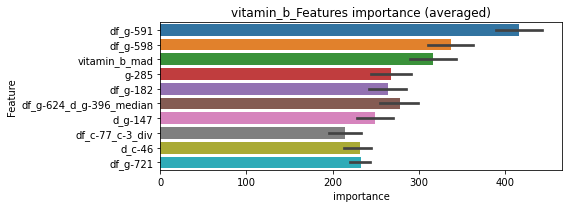

len(train_index) : 2849
len(valid_index) : 950
================================= fold 1/4 vitamin_b=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828506	valid_1's binary_logloss: 0.114068
[200]	training's binary_logloss: 0.0237257	valid_1's binary_logloss: 0.0452089
[300]	training's binary_logloss: 0.00784395	valid_1's binary_logloss: 0.0226622
[400]	training's binary_logloss: 0.003138	valid_1's binary_logloss: 0.0151015
[500]	training's binary_logloss: 0.00160233	valid_1's binary_logloss: 0.0118195
[600]	training's binary_logloss: 0.00100463	valid_1's binary_logloss: 0.0102513
[700]	training's binary_logloss: 0.000725457	valid_1's binary_logloss: 0.00947142
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.000731444	valid_1's binary_logloss: 0.00944198


len(train_index) : 2849
len(valid_index) : 950
================================= fold 2/4 vitamin_b=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0840732	valid_1's binary_logloss: 0.106269
[200]	training's binary_logloss: 0.0236707	valid_1's binary_logloss: 0.0399489
[300]	training's binary_logloss: 0.00746751	valid_1's binary_logloss: 0.0176241
[400]	training's binary_logloss: 0.00298595	valid_1's binary_logloss: 0.0101738
[500]	training's binary_logloss: 0.00154023	valid_1's binary_logloss: 0.00734974
[600]	training's binary_logloss: 0.00097484	valid_1's binary_logloss: 0.00586504
[700]	training's binary_logloss: 0.000718067	valid_1's binary_logloss: 0.00551592
[800]	training's binary_logloss: 0.000564432	valid_1's binary_logloss: 0.00479493
[900]	training's binary_logloss: 0.00048201	valid_1's binary_logloss: 0.00458404
Early stopping, best iteration is:
[961]	training's binary_logloss: 0.000458348	valid_1's binary_logloss: 0.00450696


len(train_index) : 2849
len(valid_index) : 950
================================= fold 3/4 vitamin_b=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0836061	valid_1's binary_logloss: 0.105013
[200]	training's binary_logloss: 0.0241895	valid_1's binary_logloss: 0.0377167
[300]	training's binary_logloss: 0.00787752	valid_1's binary_logloss: 0.016164
[400]	training's binary_logloss: 0.00315584	valid_1's binary_logloss: 0.0083547
[500]	training's binary_logloss: 0.00162029	valid_1's binary_logloss: 0.00506837
[600]	training's binary_logloss: 0.00101724	valid_1's binary_logloss: 0.00366447
[700]	training's binary_logloss: 0.000737253	valid_1's binary_logloss: 0.00300287
[800]	training's binary_logloss: 0.000578938	valid_1's binary_logloss: 0.0025554
[900]	training's binary_logloss: 0.000495163	valid_1's binary_logloss: 0.00232076
[1000]	training's binary_logloss: 0.000463094	valid_1's binary_logloss: 0.00224712
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000464227	valid_1's binary_logloss: 0.00224535


len(train_index) : 2850
len(valid_index) : 949
================================= fold 4/4 vitamin_b=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0842259	valid_1's binary_logloss: 0.0990023
[200]	training's binary_logloss: 0.0237985	valid_1's binary_logloss: 0.0353451
[300]	training's binary_logloss: 0.00785844	valid_1's binary_logloss: 0.0153647
[400]	training's binary_logloss: 0.00315313	valid_1's binary_logloss: 0.0083889
[500]	training's binary_logloss: 0.0016084	valid_1's binary_logloss: 0.00558988
[600]	training's binary_logloss: 0.00100769	valid_1's binary_logloss: 0.00437019
[700]	training's binary_logloss: 0.000726371	valid_1's binary_logloss: 0.00375825
[800]	training's binary_logloss: 0.000572718	valid_1's binary_logloss: 0.00348323
[900]	training's binary_logloss: 0.000488289	valid_1's binary_logloss: 0.00333128
[1000]	training's binary_logloss: 0.000458215	valid_1's binary_logloss: 0.00328192
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.000459844	valid_1's binary_logloss: 0.00327462


vitamin_b logloss: 0.00487051234517763
vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3284, target_rate: 0.0016377 → Adj_target_rate: 0.0018906


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106746	valid_1's binary_logloss: 0.15431
[200]	training's binary_logloss: 0.039399	valid_1's binary_logloss: 0.0842424
[300]	training's binary_logloss: 0.0164189	valid_1's binary_logloss: 0.0541621
[400]	training's binary_logloss: 0.00719191	valid_1's binary_logloss: 0.0388431
[500]	training's binary_logloss: 0.00359579	valid_1's binary_logloss: 0.0312132
[600]	training's binary_logloss: 0.00214704	valid_1's binary_logloss: 0.0277468
[700]	training's binary_logloss: 0.00146298	valid_1's binary_logloss: 0.0255703
[800]	training's binary_logloss: 0.00111026	valid_1's binary_logloss: 0.0242012
[900]	training's binary_logloss: 0.000905106	valid_1's binary_logloss: 0.0235878
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.00092182	valid_1's binary_logloss: 0.0235478
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107358	valid_1

1 / 3 AUC score:1.000
y_Threshold: 0.0137650, Threshold: 0.0749228, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00164, Num_p_label: 40.0, conf_0:0.05245, conf_1:0.09740
Num_p_label: 40.0, Expected: 6.5, Adj_threshold_1: 0.0749228
Num_p_label: 28.0, Expected: 6.5, Adj_threshold_2: 0.1049228
Num_p_label: 21.0, Expected: 6.5, Adj_threshold_3: 0.1349228
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_4: 0.1649228
threshold: 0.1649228, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104041	valid_1's binary_logloss: 0.14608
[200]	training's binary_logloss: 0.0359125	valid_1's binary_logloss: 0.0745626
[300]	training's binary_logloss: 0.0142265	valid_1's binary_logloss: 0.0455366
[400]	training's binary_logloss: 0.00616051	valid_1's binary_logloss: 0.0329338
[500]	training's binary_logloss: 0.00314247	valid_1's binary_logloss: 0.0269066
[600]	training's binary_logloss: 0.00191102	valid_1's binary_logloss: 0.023813
[700]	training's binary_logloss: 0.00131229	valid_1's binary_logloss: 0.0219861
[800]	training's binary_logloss: 0.00100227	valid_1's binary_logloss: 0.0205599
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.000985178	valid_1's binary_logloss: 0.0204074
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104025	valid_1's binary_logloss: 0.141917
[200]	training's binary_logloss: 0.0361702	valid_1's

2 / 3 AUC score:1.000
y_Threshold: 0.0633924, Threshold: 0.1649228, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0115520 Vs.target_rate: 0.00164, Num_p_label: 46.0, conf_0:0.13194, conf_1:0.19791
Num_p_label: 46.0, Expected: 6.5, Adj_threshold_1: 0.1649228
Num_p_label: 34.0, Expected: 6.5, Adj_threshold_2: 0.1949228
Num_p_label: 31.0, Expected: 6.5, Adj_threshold_3: 0.2249228
Num_p_label: 27.0, Expected: 6.5, Adj_threshold_4: 0.2549228
Num_p_label: 24.0, Expected: 6.5, Adj_threshold_5: 0.2849228
Num_p_label: 22.0, Expected: 6.5, Adj_threshold_6: 0.3149228
Num_p_label: 19.0, Expected: 6.5, Adj_threshold_7: 0.3449228
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_8: 0.3749228
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_9: 0.4049228
threshold: 0.4049228, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101837	valid_1's binary_logloss: 0.138991
[200]	training's binary_logloss: 0.0350983	valid_1's binary_logloss: 0.0639047
[300]	training's binary_logloss: 0.0137374	valid_1's binary_logloss: 0.0343953
[400]	training's binary_logloss: 0.00598824	valid_1's binary_logloss: 0.0220693
[500]	training's binary_logloss: 0.00306902	valid_1's binary_logloss: 0.0159656
[600]	training's binary_logloss: 0.00186276	valid_1's binary_logloss: 0.013028
[700]	training's binary_logloss: 0.00129461	valid_1's binary_logloss: 0.011451
[800]	training's binary_logloss: 0.000988018	valid_1's binary_logloss: 0.0103607
[900]	training's binary_logloss: 0.000809491	valid_1's binary_logloss: 0.00972041
[1000]	training's binary_logloss: 0.000713541	valid_1's binary_logloss: 0.00936872
[1100]	training's binary_logloss: 0.000675006	valid_1's binary_logloss: 0.00919701
Early stopping, best iteration is:
[1082]	training's bina

3 / 3 AUC score:1.000
y_Threshold: 0.1039276, Threshold: 0.4049228, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0037670 Vs.target_rate: 0.00164, Num_p_label: 15.0, conf_0:0.36443, conf_1:0.44542
threshold: 0.4049228, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3802, y_label_rate: 0.1717517


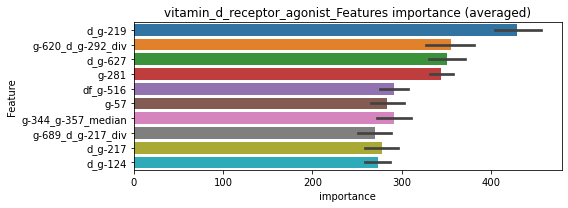

len(train_index) : 2851
len(valid_index) : 951
================================= fold 1/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102804	valid_1's binary_logloss: 0.149867
[200]	training's binary_logloss: 0.0348682	valid_1's binary_logloss: 0.0777487
[300]	training's binary_logloss: 0.0132047	valid_1's binary_logloss: 0.050543
[400]	training's binary_logloss: 0.00565606	valid_1's binary_logloss: 0.0386013
[500]	training's binary_logloss: 0.00290097	valid_1's binary_logloss: 0.0339973
[600]	training's binary_logloss: 0.00178814	valid_1's binary_logloss: 0.0323885
[700]	training's binary_logloss: 0.00125156	valid_1's binary_logloss: 0.0317005
Early stopping, best iteration is:
[757]	training's binary_logloss: 0.00106577	valid_1's binary_logloss: 0.031487


len(train_index) : 2851
len(valid_index) : 951
================================= fold 2/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10414	valid_1's binary_logloss: 0.142997
[200]	training's binary_logloss: 0.036014	valid_1's binary_logloss: 0.0667483
[300]	training's binary_logloss: 0.0136715	valid_1's binary_logloss: 0.0357266
[400]	training's binary_logloss: 0.00589687	valid_1's binary_logloss: 0.0230925
[500]	training's binary_logloss: 0.00302938	valid_1's binary_logloss: 0.0170458
[600]	training's binary_logloss: 0.00186657	valid_1's binary_logloss: 0.0140847
[700]	training's binary_logloss: 0.00129948	valid_1's binary_logloss: 0.0124542
[800]	training's binary_logloss: 0.00099268	valid_1's binary_logloss: 0.0112776
[900]	training's binary_logloss: 0.00081925	valid_1's binary_logloss: 0.0107785
[1000]	training's binary_logloss: 0.000711053	valid_1's binary_logloss: 0.0103773
[1100]	training's binary_logloss: 0.000657889	valid_1's binary_logloss: 0.0102343
Early stopping, best iteration is:
[1079]	training's binary_lo

len(train_index) : 2852
len(valid_index) : 950
================================= fold 3/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100478	valid_1's binary_logloss: 0.146725
[200]	training's binary_logloss: 0.0342486	valid_1's binary_logloss: 0.0731744
[300]	training's binary_logloss: 0.0131628	valid_1's binary_logloss: 0.0441049
[400]	training's binary_logloss: 0.00568963	valid_1's binary_logloss: 0.0310634
[500]	training's binary_logloss: 0.0029043	valid_1's binary_logloss: 0.0244644
[600]	training's binary_logloss: 0.00178735	valid_1's binary_logloss: 0.0212851
[700]	training's binary_logloss: 0.00125136	valid_1's binary_logloss: 0.0196889
[800]	training's binary_logloss: 0.000964512	valid_1's binary_logloss: 0.0184632
[900]	training's binary_logloss: 0.000793922	valid_1's binary_logloss: 0.0177031
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.000760379	valid_1's binary_logloss: 0.0175282


len(train_index) : 2852
len(valid_index) : 950
================================= fold 4/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104535	valid_1's binary_logloss: 0.138531
[200]	training's binary_logloss: 0.0353926	valid_1's binary_logloss: 0.0642693
[300]	training's binary_logloss: 0.0138609	valid_1's binary_logloss: 0.0348408
[400]	training's binary_logloss: 0.00595984	valid_1's binary_logloss: 0.0222496
[500]	training's binary_logloss: 0.00303266	valid_1's binary_logloss: 0.015917
[600]	training's binary_logloss: 0.00185114	valid_1's binary_logloss: 0.0130643
[700]	training's binary_logloss: 0.00129667	valid_1's binary_logloss: 0.0115248
[800]	training's binary_logloss: 0.00099347	valid_1's binary_logloss: 0.0107482
[900]	training's binary_logloss: 0.00081328	valid_1's binary_logloss: 0.0100235
[1000]	training's binary_logloss: 0.000716204	valid_1's binary_logloss: 0.00973105
[1100]	training's binary_logloss: 0.000676091	valid_1's binary_logloss: 0.00957122
Early stopping, best iteration is:
[1145]	training's binary

vitamin_d_receptor_agonist logloss: 0.017190256371424212
wnt_inhibitor, len(trt): 30, len(othr): 3287, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0940168	valid_1's binary_logloss: 0.128007
[200]	training's binary_logloss: 0.0300341	valid_1's binary_logloss: 0.0595353
[300]	training's binary_logloss: 0.0109336	valid_1's binary_logloss: 0.0345542
[400]	training's binary_logloss: 0.00458847	valid_1's binary_logloss: 0.0242955
[500]	training's binary_logloss: 0.00238697	valid_1's binary_logloss: 0.0200115
[600]	training's binary_logloss: 0.00150251	valid_1's binary_logloss: 0.0177467
[700]	training's binary_logloss: 0.00108668	valid_1's binary_logloss: 0.0168765
[800]	training's binary_logloss: 0.000849853	valid_1's binary_logloss: 0.0160073
[900]	training's binary_logloss: 0.000708845	valid_1's binary_logloss: 0.0157969
[1000]	training's binary_logloss: 0.000640312	valid_1's binary_logloss: 0.0155565
Early stopping, best iteration is:
[1016]	training's binary_logloss: 0.000632048	valid_1's binary_logloss: 0.0155288
Training until validat

1 / 3 AUC score:1.000
y_Threshold: 0.0097784, Threshold: 0.0784787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.05494, conf_1:0.10202
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0784787
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_2: 0.1084787
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_3: 0.1384787
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_4: 0.1684787
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_5: 0.1984787
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_6: 0.2284787
threshold: 0.2284787, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0917747	valid_1's binary_logloss: 0.123775
[200]	training's binary_logloss: 0.0278211	valid_1's binary_logloss: 0.0535975
[300]	training's binary_logloss: 0.0097342	valid_1's binary_logloss: 0.0281293
[400]	training's binary_logloss: 0.00411285	valid_1's binary_logloss: 0.0188172
[500]	training's binary_logloss: 0.00215741	valid_1's binary_logloss: 0.0143825
[600]	training's binary_logloss: 0.00137443	valid_1's binary_logloss: 0.0123325
[700]	training's binary_logloss: 0.000996452	valid_1's binary_logloss: 0.0112709
[800]	training's binary_logloss: 0.000782383	valid_1's binary_logloss: 0.0104441
[900]	training's binary_logloss: 0.000656137	valid_1's binary_logloss: 0.00997217
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.000630895	valid_1's binary_logloss: 0.00994662
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.090739

2 / 3 AUC score:1.000
y_Threshold: 0.0867513, Threshold: 0.2284787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0077850 Vs.target_rate: 0.00126, Num_p_label: 31.0, conf_0:0.18278, conf_1:0.27417
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_1: 0.2284787
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.2584787
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.2884787
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_4: 0.3184787
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_5: 0.3484787
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_6: 0.3784787
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_7: 0.4084787
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_8: 0.4384787
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_9: 0.4684787
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_10: 0.4984787
threshold: 0.4984787, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3808, y_label_rate: 0.1720063
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0909711	valid_1's binary_logloss: 0.128065
[200]	training's binary_logloss: 0.0273041	valid_1's binary_logloss: 0.0552684
[300]	training's binary_logloss: 0.00944703	valid_1's binary_logloss: 0.0295214
[400]	training's binary_logloss: 0.00396985	valid_1's binary_logloss: 0.0188174
[500]	training's binary_logloss: 0.00209843	valid_1's binary_logloss: 0.0146843
[600]	training's binary_logloss: 0.00134276	valid_1's binary_logloss: 0.0124911
[700]	training's binary_logloss: 0.000968749	valid_1's binary_logloss: 0.0113915
[800]	training's binary_logloss: 0.000766527	valid_1's binary_logloss: 0.0107261
[900]	training's binary_logloss: 0.000645837	valid_1's binary_logloss: 0.0103704
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000607684	valid_1's binary_logloss: 0.0103258
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933856

3 / 3 AUC score:1.000
y_Threshold: 0.0563667, Threshold: 0.4984787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 652.0/3802
p_label_rate: 0.0025113 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.44863, conf_1:0.54833
threshold: 0.4984787, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/3802, y_label_rate: 0.1714887


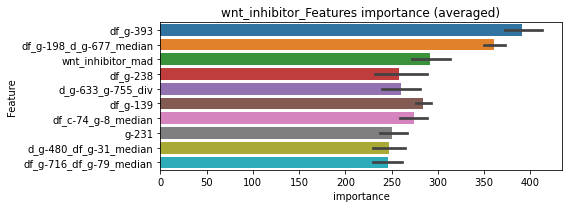

len(train_index) : 2851
len(valid_index) : 951
================================= fold 1/4 wnt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0920925	valid_1's binary_logloss: 0.123983
[200]	training's binary_logloss: 0.0281651	valid_1's binary_logloss: 0.0527834
[300]	training's binary_logloss: 0.0100646	valid_1's binary_logloss: 0.0274697
[400]	training's binary_logloss: 0.00420422	valid_1's binary_logloss: 0.016514
[500]	training's binary_logloss: 0.00219096	valid_1's binary_logloss: 0.0118206
[600]	training's binary_logloss: 0.00137978	valid_1's binary_logloss: 0.00978084
[700]	training's binary_logloss: 0.000987481	valid_1's binary_logloss: 0.00854855
[800]	training's binary_logloss: 0.000772601	valid_1's binary_logloss: 0.00779764
[900]	training's binary_logloss: 0.000651128	valid_1's binary_logloss: 0.00728749
[1000]	training's binary_logloss: 0.000587302	valid_1's binary_logloss: 0.00706236
Early stopping, best iteration is:
[1032]	training's binary_logloss: 0.000574636	valid_1's binary_logloss: 0.00700609


len(train_index) : 2851
len(valid_index) : 951
================================= fold 2/4 wnt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.09327	valid_1's binary_logloss: 0.123883
[200]	training's binary_logloss: 0.0281135	valid_1's binary_logloss: 0.0502926
[300]	training's binary_logloss: 0.00986453	valid_1's binary_logloss: 0.0242786
[400]	training's binary_logloss: 0.0041578	valid_1's binary_logloss: 0.0147709
[500]	training's binary_logloss: 0.00217005	valid_1's binary_logloss: 0.0101698
[600]	training's binary_logloss: 0.00136509	valid_1's binary_logloss: 0.00857832
[700]	training's binary_logloss: 0.000981803	valid_1's binary_logloss: 0.0075856
[800]	training's binary_logloss: 0.000771363	valid_1's binary_logloss: 0.00711848
[900]	training's binary_logloss: 0.000651447	valid_1's binary_logloss: 0.00666371
[1000]	training's binary_logloss: 0.000590616	valid_1's binary_logloss: 0.00660657
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000592816	valid_1's binary_logloss: 0.00659271


len(train_index) : 2852
len(valid_index) : 950
================================= fold 3/4 wnt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0922911	valid_1's binary_logloss: 0.122536
[200]	training's binary_logloss: 0.0287247	valid_1's binary_logloss: 0.0510813
[300]	training's binary_logloss: 0.0100584	valid_1's binary_logloss: 0.0255939
[400]	training's binary_logloss: 0.0042191	valid_1's binary_logloss: 0.015363
[500]	training's binary_logloss: 0.00222315	valid_1's binary_logloss: 0.0108462
[600]	training's binary_logloss: 0.00139271	valid_1's binary_logloss: 0.00864614
[700]	training's binary_logloss: 0.000996432	valid_1's binary_logloss: 0.00749825
[800]	training's binary_logloss: 0.000785317	valid_1's binary_logloss: 0.00674123
[900]	training's binary_logloss: 0.000654647	valid_1's binary_logloss: 0.00619359
[1000]	training's binary_logloss: 0.000593877	valid_1's binary_logloss: 0.00603513
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000594415	valid_1's binary_logloss: 0.00602577


len(train_index) : 2852
len(valid_index) : 950
================================= fold 4/4 wnt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0928559	valid_1's binary_logloss: 0.121801
[200]	training's binary_logloss: 0.0283659	valid_1's binary_logloss: 0.050676
[300]	training's binary_logloss: 0.00998311	valid_1's binary_logloss: 0.0258571
[400]	training's binary_logloss: 0.00418095	valid_1's binary_logloss: 0.0158912
[500]	training's binary_logloss: 0.00217523	valid_1's binary_logloss: 0.0118441
[600]	training's binary_logloss: 0.00137621	valid_1's binary_logloss: 0.00979785
[700]	training's binary_logloss: 0.000991815	valid_1's binary_logloss: 0.00869553
[800]	training's binary_logloss: 0.000776776	valid_1's binary_logloss: 0.00799537
[900]	training's binary_logloss: 0.000656217	valid_1's binary_logloss: 0.00771176
[1000]	training's binary_logloss: 0.000599131	valid_1's binary_logloss: 0.00750789
Early stopping, best iteration is:
[1019]	training's binary_logloss: 0.000592054	valid_1's binary_logloss: 0.00750283


wnt_inhibitor logloss: 0.006783830315092656


In [44]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
#importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)

sub.to_csv('submission.csv', index=False)

In [45]:
print(f"CV:{np.mean(scores)}")

CV:0.024258381972695295
